In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    # X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<1:28:23,  7.54it/s]

Adam:   0%|          | 24/40000 [00:00<05:26, 122.50it/s]

Adam:   0%|          | 49/40000 [00:00<03:49, 173.88it/s]

Adam:   0%|          | 74/40000 [00:00<03:18, 201.11it/s]

Adam:   0%|          | 100/40000 [00:00<03:01, 219.36it/s]

Adam:   0%|          | 124/40000 [00:00<02:56, 225.44it/s]

Adam:   0%|          | 150/40000 [00:00<02:49, 234.60it/s]

Adam:   0%|          | 175/40000 [00:00<02:46, 238.76it/s]

Adam:   1%|          | 201/40000 [00:00<02:44, 242.44it/s]

Adam:   1%|          | 227/40000 [00:01<02:42, 245.39it/s]

Adam:   1%|          | 252/40000 [00:01<02:41, 245.58it/s]

Adam:   1%|          | 277/40000 [00:01<02:40, 246.77it/s]

Adam:   1%|          | 302/40000 [00:01<02:44, 241.77it/s]

Adam:   1%|          | 327/40000 [00:01<02:42, 243.95it/s]

Adam:   1%|          | 353/40000 [00:01<02:41, 245.83it/s]

Adam:   1%|          | 378/40000 [00:01<02:42, 244.56it/s]

Adam:   1%|          | 404/40000 [00:01<02:40, 247.09it/s]

Adam:   1%|          | 430/40000 [00:01<02:39, 248.49it/s]

Adam:   1%|          | 455/40000 [00:01<02:39, 248.58it/s]

Adam:   1%|          | 480/40000 [00:02<02:44, 240.41it/s]

Adam:   1%|▏         | 505/40000 [00:02<02:44, 240.34it/s]

Adam:   1%|▏         | 530/40000 [00:02<02:44, 239.81it/s]

Adam:   1%|▏         | 555/40000 [00:02<02:42, 242.62it/s]

Adam:   1%|▏         | 581/40000 [00:02<02:40, 246.02it/s]

Adam:   2%|▏         | 606/40000 [00:02<02:39, 247.08it/s]

Adam:   2%|▏         | 632/40000 [00:02<02:38, 248.09it/s]

Adam:   2%|▏         | 657/40000 [00:02<02:39, 247.36it/s]

Adam:   2%|▏         | 682/40000 [00:02<02:39, 246.59it/s]

Adam:   2%|▏         | 707/40000 [00:03<02:43, 240.86it/s]

Adam:   2%|▏         | 732/40000 [00:03<02:41, 243.13it/s]

Adam:   2%|▏         | 757/40000 [00:03<02:41, 242.98it/s]

Adam:   2%|▏         | 782/40000 [00:03<02:42, 240.76it/s]

Adam:   2%|▏         | 807/40000 [00:03<02:41, 243.00it/s]

Adam:   2%|▏         | 833/40000 [00:03<02:39, 245.56it/s]

Adam:   2%|▏         | 859/40000 [00:03<02:38, 246.99it/s]

Adam:   2%|▏         | 884/40000 [00:03<02:37, 247.78it/s]

Adam:   2%|▏         | 909/40000 [00:03<02:41, 242.02it/s]

Adam:   2%|▏         | 935/40000 [00:03<02:39, 244.70it/s]

Adam:   2%|▏         | 960/40000 [00:04<02:40, 243.10it/s]

Adam:   2%|▏         | 985/40000 [00:04<02:40, 243.82it/s]

Adam:   3%|▎         | 1010/40000 [00:04<02:38, 245.62it/s]

Adam:   3%|▎         | 1036/40000 [00:04<02:37, 247.45it/s]

Adam:   3%|▎         | 1061/40000 [00:04<02:37, 247.93it/s]

Adam:   3%|▎         | 1086/40000 [00:04<02:37, 247.73it/s]

Adam:   3%|▎         | 1111/40000 [00:04<02:36, 248.33it/s]

Adam:   3%|▎         | 1137/40000 [00:04<02:35, 249.96it/s]

Adam:   3%|▎         | 1162/40000 [00:04<02:35, 249.06it/s]

Adam:   3%|▎         | 1187/40000 [00:04<02:35, 249.23it/s]

Adam:   3%|▎         | 1213/40000 [00:05<02:35, 249.91it/s]

Adam:   3%|▎         | 1238/40000 [00:05<02:35, 249.92it/s]

Adam:   3%|▎         | 1264/40000 [00:05<02:34, 250.15it/s]

Adam:   3%|▎         | 1290/40000 [00:05<02:36, 247.25it/s]

Adam:   3%|▎         | 1316/40000 [00:05<02:35, 248.30it/s]

Adam:   3%|▎         | 1341/40000 [00:05<02:35, 248.56it/s]

Adam:   3%|▎         | 1366/40000 [00:05<02:36, 246.49it/s]

Adam:   3%|▎         | 1391/40000 [00:05<02:37, 245.62it/s]

Adam:   4%|▎         | 1416/40000 [00:05<02:38, 243.29it/s]

Adam:   4%|▎         | 1442/40000 [00:05<02:37, 245.52it/s]

Adam:   4%|▎         | 1468/40000 [00:06<02:35, 247.39it/s]

Adam:   4%|▎         | 1493/40000 [00:06<02:37, 244.33it/s]

Adam:   4%|▍         | 1519/40000 [00:06<02:36, 246.19it/s]

Adam:   4%|▍         | 1545/40000 [00:06<02:34, 248.13it/s]

Adam:   4%|▍         | 1570/40000 [00:06<02:37, 243.98it/s]

Adam:   4%|▍         | 1595/40000 [00:06<02:42, 236.90it/s]

Adam:   4%|▍         | 1620/40000 [00:06<02:40, 239.25it/s]

Adam:   4%|▍         | 1645/40000 [00:06<02:39, 240.99it/s]

Adam:   4%|▍         | 1670/40000 [00:06<02:39, 239.80it/s]

Adam:   4%|▍         | 1695/40000 [00:07<02:38, 242.23it/s]

Adam:   4%|▍         | 1721/40000 [00:07<02:36, 244.62it/s]

Adam:   4%|▍         | 1747/40000 [00:07<02:35, 246.37it/s]

Adam:   4%|▍         | 1772/40000 [00:07<02:35, 246.45it/s]

Adam:   4%|▍         | 1797/40000 [00:07<02:34, 247.13it/s]

Adam:   5%|▍         | 1822/40000 [00:07<02:34, 247.61it/s]

Adam:   5%|▍         | 1847/40000 [00:07<02:37, 242.76it/s]

Adam:   5%|▍         | 1872/40000 [00:07<02:38, 240.54it/s]

Adam:   5%|▍         | 1897/40000 [00:07<02:36, 243.23it/s]

Adam:   5%|▍         | 1923/40000 [00:07<02:35, 245.44it/s]

Adam:   5%|▍         | 1948/40000 [00:08<02:35, 243.97it/s]

Adam:   5%|▍         | 1973/40000 [00:08<02:37, 242.14it/s]

Adam:   5%|▍         | 1998/40000 [00:08<02:37, 241.69it/s]

Adam:   5%|▌         | 2023/40000 [00:08<02:37, 240.81it/s]

Adam:   5%|▌         | 2048/40000 [00:08<02:38, 239.42it/s]

Adam:   5%|▌         | 2072/40000 [00:08<02:38, 239.10it/s]

Adam:   5%|▌         | 2097/40000 [00:08<02:37, 241.41it/s]

Adam:   5%|▌         | 2123/40000 [00:08<02:34, 245.79it/s]

Adam:   5%|▌         | 2148/40000 [00:08<02:33, 246.84it/s]

Adam:   5%|▌         | 2173/40000 [00:08<02:33, 245.87it/s]

Adam:   5%|▌         | 2198/40000 [00:09<02:33, 245.50it/s]

Adam:   6%|▌         | 2223/40000 [00:09<02:37, 240.35it/s]

Adam:   6%|▌         | 2248/40000 [00:09<02:37, 239.68it/s]

Adam:   6%|▌         | 2272/40000 [00:09<02:37, 239.38it/s]

Adam:   6%|▌         | 2296/40000 [00:09<02:37, 238.95it/s]

Adam:   6%|▌         | 2320/40000 [00:09<03:07, 200.62it/s]

Adam:   6%|▌         | 2344/40000 [00:09<02:59, 209.42it/s]

Adam:   6%|▌         | 2368/40000 [00:09<02:54, 216.14it/s]

Adam:   6%|▌         | 2392/40000 [00:09<02:49, 222.21it/s]

Adam:   6%|▌         | 2416/40000 [00:10<02:45, 226.58it/s]

Adam:   6%|▌         | 2440/40000 [00:10<02:43, 229.64it/s]

Adam:   6%|▌         | 2464/40000 [00:10<02:41, 231.81it/s]

Adam:   6%|▌         | 2489/40000 [00:10<02:39, 234.60it/s]

Adam:   6%|▋         | 2513/40000 [00:10<02:39, 235.16it/s]

Adam:   6%|▋         | 2538/40000 [00:10<02:38, 237.08it/s]

Adam:   6%|▋         | 2562/40000 [00:10<02:38, 236.17it/s]

Adam:   6%|▋         | 2586/40000 [00:10<02:40, 233.04it/s]

Adam:   7%|▋         | 2610/40000 [00:10<02:48, 222.01it/s]

Adam:   7%|▋         | 2633/40000 [00:11<02:55, 213.30it/s]

Adam:   7%|▋         | 2656/40000 [00:11<02:52, 216.60it/s]

Adam:   7%|▋         | 2679/40000 [00:11<02:50, 218.30it/s]

Adam:   7%|▋         | 2701/40000 [00:11<02:51, 218.01it/s]

Adam:   7%|▋         | 2724/40000 [00:11<02:49, 219.52it/s]

Adam:   7%|▋         | 2746/40000 [00:11<02:51, 217.02it/s]

Adam:   7%|▋         | 2768/40000 [00:11<02:59, 206.97it/s]

Adam:   7%|▋         | 2790/40000 [00:11<02:56, 210.44it/s]

Adam:   7%|▋         | 2812/40000 [00:11<02:55, 211.99it/s]

Adam:   7%|▋         | 2835/40000 [00:11<02:52, 215.98it/s]

Adam:   7%|▋         | 2857/40000 [00:12<02:55, 211.45it/s]

Adam:   7%|▋         | 2880/40000 [00:12<02:52, 215.16it/s]

Adam:   7%|▋         | 2902/40000 [00:12<02:53, 213.27it/s]

Adam:   7%|▋         | 2924/40000 [00:12<02:54, 212.37it/s]

Adam:   7%|▋         | 2946/40000 [00:12<02:56, 209.85it/s]

Adam:   7%|▋         | 2968/40000 [00:12<03:02, 202.82it/s]

Adam:   7%|▋         | 2991/40000 [00:12<02:57, 208.13it/s]

Adam:   8%|▊         | 3014/40000 [00:12<02:53, 212.96it/s]

Adam:   8%|▊         | 3038/40000 [00:12<02:49, 217.58it/s]

Adam:   8%|▊         | 3060/40000 [00:13<02:49, 217.55it/s]

Adam:   8%|▊         | 3082/40000 [00:13<02:49, 217.66it/s]

Adam:   8%|▊         | 3104/40000 [00:13<02:56, 209.13it/s]

Adam:   8%|▊         | 3125/40000 [00:13<03:03, 200.97it/s]

Adam:   8%|▊         | 3148/40000 [00:13<02:56, 208.42it/s]

Adam:   8%|▊         | 3171/40000 [00:13<02:53, 212.78it/s]

Adam:   8%|▊         | 3193/40000 [00:13<02:54, 211.15it/s]

Adam:   8%|▊         | 3215/40000 [00:13<03:00, 204.30it/s]

Adam:   8%|▊         | 3238/40000 [00:13<02:55, 209.63it/s]

Adam:   8%|▊         | 3261/40000 [00:14<02:51, 213.63it/s]

Adam:   8%|▊         | 3283/40000 [00:14<02:51, 214.04it/s]

Adam:   8%|▊         | 3305/40000 [00:14<02:53, 211.78it/s]

Adam:   8%|▊         | 3328/40000 [00:14<02:49, 215.86it/s]

Adam:   8%|▊         | 3352/40000 [00:14<02:46, 220.36it/s]

Adam:   8%|▊         | 3375/40000 [00:14<02:47, 218.21it/s]

Adam:   8%|▊         | 3397/40000 [00:14<02:48, 217.77it/s]

Adam:   9%|▊         | 3419/40000 [00:14<02:54, 209.57it/s]

Adam:   9%|▊         | 3441/40000 [00:14<02:56, 206.69it/s]

Adam:   9%|▊         | 3465/40000 [00:14<02:50, 213.74it/s]

Adam:   9%|▊         | 3487/40000 [00:15<02:50, 214.61it/s]

Adam:   9%|▉         | 3509/40000 [00:15<02:53, 210.46it/s]

Adam:   9%|▉         | 3531/40000 [00:15<02:55, 207.31it/s]

Adam:   9%|▉         | 3554/40000 [00:15<02:51, 212.37it/s]

Adam:   9%|▉         | 3576/40000 [00:15<02:50, 213.49it/s]

Adam:   9%|▉         | 3598/40000 [00:15<02:49, 215.08it/s]

Adam:   9%|▉         | 3621/40000 [00:15<02:46, 218.71it/s]

Adam:   9%|▉         | 3644/40000 [00:15<02:44, 220.38it/s]

Adam:   9%|▉         | 3667/40000 [00:15<02:48, 215.81it/s]

Adam:   9%|▉         | 3689/40000 [00:16<02:58, 203.14it/s]

Adam:   9%|▉         | 3710/40000 [00:16<03:01, 200.23it/s]

Adam:   9%|▉         | 3731/40000 [00:16<03:03, 197.58it/s]

Adam:   9%|▉         | 3751/40000 [00:16<03:03, 197.25it/s]

Adam:   9%|▉         | 3772/40000 [00:16<03:02, 198.06it/s]

Adam:   9%|▉         | 3792/40000 [00:16<03:02, 197.88it/s]

Adam:  10%|▉         | 3813/40000 [00:16<03:02, 198.28it/s]

Adam:  10%|▉         | 3833/40000 [00:16<03:05, 195.23it/s]

Adam:  10%|▉         | 3853/40000 [00:16<03:10, 190.19it/s]

Adam:  10%|▉         | 3873/40000 [00:16<03:17, 182.60it/s]

Adam:  10%|▉         | 3892/40000 [00:17<03:26, 174.55it/s]

Adam:  10%|▉         | 3911/40000 [00:17<03:22, 178.21it/s]

Adam:  10%|▉         | 3931/40000 [00:17<03:16, 183.81it/s]

Adam:  10%|▉         | 3950/40000 [00:17<03:21, 178.63it/s]

Adam:  10%|▉         | 3971/40000 [00:17<03:12, 187.27it/s]

Adam:  10%|▉         | 3992/40000 [00:17<03:10, 189.47it/s]

Adam:  10%|█         | 4012/40000 [00:17<03:12, 186.66it/s]

Adam:  10%|█         | 4032/40000 [00:17<03:11, 187.69it/s]

Adam:  10%|█         | 4052/40000 [00:17<03:08, 191.04it/s]

Adam:  10%|█         | 4072/40000 [00:18<03:14, 184.26it/s]

Adam:  10%|█         | 4091/40000 [00:18<03:14, 185.07it/s]

Adam:  10%|█         | 4112/40000 [00:18<03:07, 191.90it/s]

Adam:  10%|█         | 4132/40000 [00:18<03:12, 186.52it/s]

Adam:  10%|█         | 4153/40000 [00:18<03:06, 191.91it/s]

Adam:  10%|█         | 4173/40000 [00:18<03:12, 186.56it/s]

Adam:  10%|█         | 4194/40000 [00:18<03:06, 192.13it/s]

Adam:  11%|█         | 4214/40000 [00:18<03:15, 183.45it/s]

Adam:  11%|█         | 4233/40000 [00:18<03:13, 185.06it/s]

Adam:  11%|█         | 4252/40000 [00:19<03:13, 184.31it/s]

Adam:  11%|█         | 4272/40000 [00:19<03:11, 186.76it/s]

Adam:  11%|█         | 4293/40000 [00:19<03:05, 192.12it/s]

Adam:  11%|█         | 4315/40000 [00:19<03:00, 197.81it/s]

Adam:  11%|█         | 4335/40000 [00:19<03:04, 193.51it/s]

Adam:  11%|█         | 4355/40000 [00:19<03:03, 193.84it/s]

Adam:  11%|█         | 4375/40000 [00:19<03:13, 184.38it/s]

Adam:  11%|█         | 4395/40000 [00:19<03:09, 187.92it/s]

Adam:  11%|█         | 4416/40000 [00:19<03:03, 194.15it/s]

Adam:  11%|█         | 4436/40000 [00:19<03:02, 195.03it/s]

Adam:  11%|█         | 4458/40000 [00:20<02:58, 199.27it/s]

Adam:  11%|█         | 4479/40000 [00:20<02:56, 201.80it/s]

Adam:  11%|█▏        | 4500/40000 [00:20<02:59, 198.28it/s]

Adam:  11%|█▏        | 4520/40000 [00:20<03:02, 194.63it/s]

Adam:  11%|█▏        | 4540/40000 [00:20<03:03, 192.94it/s]

Adam:  11%|█▏        | 4560/40000 [00:20<03:07, 189.36it/s]

Adam:  11%|█▏        | 4581/40000 [00:20<03:04, 192.05it/s]

Adam:  12%|█▏        | 4601/40000 [00:20<03:12, 183.85it/s]

Adam:  12%|█▏        | 4622/40000 [00:20<03:06, 189.62it/s]

Adam:  12%|█▏        | 4642/40000 [00:21<03:06, 189.81it/s]

Adam:  12%|█▏        | 4662/40000 [00:21<03:08, 187.85it/s]

Adam:  12%|█▏        | 4682/40000 [00:21<03:05, 190.41it/s]

Adam:  12%|█▏        | 4702/40000 [00:21<03:03, 192.11it/s]

Adam:  12%|█▏        | 4724/40000 [00:21<02:57, 198.50it/s]

Adam:  12%|█▏        | 4746/40000 [00:21<02:52, 204.02it/s]

Adam:  12%|█▏        | 4767/40000 [00:21<02:52, 204.83it/s]

Adam:  12%|█▏        | 4788/40000 [00:21<02:56, 199.16it/s]

Adam:  12%|█▏        | 4808/40000 [00:21<03:05, 190.13it/s]

Adam:  12%|█▏        | 4829/40000 [00:22<03:00, 194.93it/s]

Adam:  12%|█▏        | 4850/40000 [00:22<02:57, 197.52it/s]

Adam:  12%|█▏        | 4870/40000 [00:22<03:01, 193.84it/s]

Adam:  12%|█▏        | 4892/40000 [00:22<02:55, 199.66it/s]

Adam:  12%|█▏        | 4913/40000 [00:22<02:57, 197.17it/s]

Adam:  12%|█▏        | 4933/40000 [00:22<03:00, 193.83it/s]

Adam:  12%|█▏        | 4954/40000 [00:22<02:58, 196.57it/s]

Adam:  12%|█▏        | 4974/40000 [00:22<03:01, 193.47it/s]

Adam:  12%|█▏        | 4994/40000 [00:22<03:07, 186.82it/s]

Adam:  13%|█▎        | 5013/40000 [00:22<03:08, 185.94it/s]

Adam:  13%|█▎        | 5032/40000 [00:23<03:09, 184.47it/s]

Adam:  13%|█▎        | 5052/40000 [00:23<03:05, 188.51it/s]

Adam:  13%|█▎        | 5071/40000 [00:23<03:05, 188.59it/s]

Adam:  13%|█▎        | 5090/40000 [00:23<03:19, 175.13it/s]

Adam:  13%|█▎        | 5110/40000 [00:23<03:11, 182.07it/s]

Adam:  13%|█▎        | 5131/40000 [00:23<03:03, 189.73it/s]

Adam:  13%|█▎        | 5151/40000 [00:23<03:01, 191.56it/s]

Adam:  13%|█▎        | 5171/40000 [00:23<03:03, 189.48it/s]

Adam:  13%|█▎        | 5191/40000 [00:23<03:01, 191.97it/s]

Adam:  13%|█▎        | 5211/40000 [00:24<03:01, 191.35it/s]

Adam:  13%|█▎        | 5231/40000 [00:24<03:07, 185.84it/s]

Adam:  13%|█▎        | 5253/40000 [00:24<02:59, 193.98it/s]

Adam:  13%|█▎        | 5273/40000 [00:24<03:04, 188.47it/s]

Adam:  13%|█▎        | 5293/40000 [00:24<03:02, 189.93it/s]

Adam:  13%|█▎        | 5314/40000 [00:24<03:02, 190.56it/s]

Adam:  13%|█▎        | 5334/40000 [00:24<03:03, 188.45it/s]

Adam:  13%|█▎        | 5353/40000 [00:24<03:03, 188.36it/s]

Adam:  13%|█▎        | 5372/40000 [00:24<03:04, 187.61it/s]

Adam:  13%|█▎        | 5393/40000 [00:24<02:58, 193.65it/s]

Adam:  14%|█▎        | 5413/40000 [00:25<02:57, 195.03it/s]

Adam:  14%|█▎        | 5433/40000 [00:25<02:59, 192.43it/s]

Adam:  14%|█▎        | 5453/40000 [00:25<03:03, 188.09it/s]

Adam:  14%|█▎        | 5472/40000 [00:25<03:03, 188.07it/s]

Adam:  14%|█▎        | 5493/40000 [00:25<03:00, 190.78it/s]

Adam:  14%|█▍        | 5513/40000 [00:25<03:02, 189.11it/s]

Adam:  14%|█▍        | 5535/40000 [00:25<02:57, 194.29it/s]

Adam:  14%|█▍        | 5555/40000 [00:25<02:59, 192.11it/s]

Adam:  14%|█▍        | 5575/40000 [00:25<03:07, 183.70it/s]

Adam:  14%|█▍        | 5594/40000 [00:26<03:06, 184.81it/s]

Adam:  14%|█▍        | 5616/40000 [00:26<02:58, 192.57it/s]

Adam:  14%|█▍        | 5636/40000 [00:26<03:00, 190.19it/s]

Adam:  14%|█▍        | 5656/40000 [00:26<03:03, 187.66it/s]

Adam:  14%|█▍        | 5677/40000 [00:26<02:58, 192.55it/s]

Adam:  14%|█▍        | 5697/40000 [00:26<03:04, 185.52it/s]

Adam:  14%|█▍        | 5718/40000 [00:26<03:00, 190.16it/s]

Adam:  14%|█▍        | 5738/40000 [00:26<03:02, 187.56it/s]

Adam:  14%|█▍        | 5757/40000 [00:26<03:07, 182.50it/s]

Adam:  14%|█▍        | 5776/40000 [00:27<03:06, 183.25it/s]

Adam:  14%|█▍        | 5795/40000 [00:27<03:08, 181.72it/s]

Adam:  15%|█▍        | 5815/40000 [00:27<03:04, 184.94it/s]

Adam:  15%|█▍        | 5834/40000 [00:27<03:09, 180.61it/s]

Adam:  15%|█▍        | 5853/40000 [00:27<03:09, 179.92it/s]

Adam:  15%|█▍        | 5872/40000 [00:27<03:08, 180.85it/s]

Adam:  15%|█▍        | 5893/40000 [00:27<03:02, 186.86it/s]

Adam:  15%|█▍        | 5914/40000 [00:27<02:58, 191.37it/s]

Adam:  15%|█▍        | 5936/40000 [00:27<02:52, 197.08it/s]

Adam:  15%|█▍        | 5957/40000 [00:27<02:51, 198.57it/s]

Adam:  15%|█▍        | 5978/40000 [00:28<02:51, 198.23it/s]

Adam:  15%|█▍        | 5998/40000 [00:28<02:52, 197.32it/s]

Adam:  15%|█▌        | 6018/40000 [00:28<02:55, 193.19it/s]

Adam:  15%|█▌        | 6038/40000 [00:28<02:56, 192.15it/s]

Adam:  15%|█▌        | 6058/40000 [00:28<03:01, 187.52it/s]

Adam:  15%|█▌        | 6078/40000 [00:28<02:59, 189.31it/s]

Adam:  15%|█▌        | 6097/40000 [00:28<02:59, 188.72it/s]

Adam:  15%|█▌        | 6117/40000 [00:28<02:56, 191.80it/s]

Adam:  15%|█▌        | 6138/40000 [00:28<02:53, 195.64it/s]

Adam:  15%|█▌        | 6158/40000 [00:29<02:53, 195.59it/s]

Adam:  15%|█▌        | 6179/40000 [00:29<02:52, 196.02it/s]

Adam:  15%|█▌        | 6199/40000 [00:29<02:57, 190.79it/s]

Adam:  16%|█▌        | 6220/40000 [00:29<02:52, 195.52it/s]

Adam:  16%|█▌        | 6240/40000 [00:29<02:55, 192.06it/s]

Adam:  16%|█▌        | 6260/40000 [00:29<02:56, 191.01it/s]

Adam:  16%|█▌        | 6280/40000 [00:29<03:07, 179.39it/s]

Adam:  16%|█▌        | 6299/40000 [00:29<03:05, 181.40it/s]

Adam:  16%|█▌        | 6318/40000 [00:29<03:07, 179.43it/s]

Adam:  16%|█▌        | 6338/40000 [00:29<03:03, 183.53it/s]

Adam:  16%|█▌        | 6358/40000 [00:30<03:00, 186.07it/s]

Adam:  16%|█▌        | 6377/40000 [00:30<03:07, 179.27it/s]

Adam:  16%|█▌        | 6396/40000 [00:30<03:12, 174.84it/s]

Adam:  16%|█▌        | 6417/40000 [00:30<03:02, 184.10it/s]

Adam:  16%|█▌        | 6436/40000 [00:30<03:05, 180.91it/s]

Adam:  16%|█▌        | 6455/40000 [00:30<03:03, 183.22it/s]

Adam:  16%|█▌        | 6474/40000 [00:30<03:03, 182.97it/s]

Adam:  16%|█▌        | 6494/40000 [00:30<03:02, 183.28it/s]

Adam:  16%|█▋        | 6514/40000 [00:30<02:59, 186.71it/s]

Adam:  16%|█▋        | 6535/40000 [00:31<02:55, 190.84it/s]

Adam:  16%|█▋        | 6556/40000 [00:31<02:52, 194.11it/s]

Adam:  16%|█▋        | 6577/40000 [00:31<02:48, 198.20it/s]

Adam:  16%|█▋        | 6597/40000 [00:31<02:51, 195.14it/s]

Adam:  17%|█▋        | 6617/40000 [00:31<02:53, 192.87it/s]

Adam:  17%|█▋        | 6637/40000 [00:31<02:56, 189.04it/s]

Adam:  17%|█▋        | 6656/40000 [00:31<03:08, 176.64it/s]

Adam:  17%|█▋        | 6675/40000 [00:31<03:06, 178.75it/s]

Adam:  17%|█▋        | 6696/40000 [00:31<02:58, 186.56it/s]

Adam:  17%|█▋        | 6716/40000 [00:32<02:56, 188.65it/s]

Adam:  17%|█▋        | 6735/40000 [00:32<02:56, 187.99it/s]

Adam:  17%|█▋        | 6754/40000 [00:32<03:00, 184.46it/s]

Adam:  17%|█▋        | 6775/40000 [00:32<02:53, 191.15it/s]

Adam:  17%|█▋        | 6796/40000 [00:32<02:49, 196.12it/s]

Adam:  17%|█▋        | 6817/40000 [00:32<02:47, 197.98it/s]

Adam:  17%|█▋        | 6837/40000 [00:32<02:48, 196.54it/s]

Adam:  17%|█▋        | 6857/40000 [00:32<02:49, 195.99it/s]

Adam:  17%|█▋        | 6879/40000 [00:32<02:44, 201.26it/s]

Adam:  17%|█▋        | 6900/40000 [00:32<02:51, 193.46it/s]

Adam:  17%|█▋        | 6920/40000 [00:33<02:53, 190.65it/s]

Adam:  17%|█▋        | 6940/40000 [00:33<02:56, 187.11it/s]

Adam:  17%|█▋        | 6959/40000 [00:33<03:03, 179.83it/s]

Adam:  17%|█▋        | 6980/40000 [00:33<02:56, 187.43it/s]

Adam:  18%|█▊        | 7000/40000 [00:33<02:53, 190.47it/s]

Adam:  18%|█▊        | 7022/40000 [00:33<02:47, 196.89it/s]

Adam:  18%|█▊        | 7043/40000 [00:33<02:44, 200.38it/s]

Adam:  18%|█▊        | 7064/40000 [00:33<02:42, 202.56it/s]

Adam:  18%|█▊        | 7086/40000 [00:33<02:39, 205.81it/s]

Adam:  18%|█▊        | 7107/40000 [00:34<02:50, 193.02it/s]

Adam:  18%|█▊        | 7128/40000 [00:34<02:47, 196.74it/s]

Adam:  18%|█▊        | 7148/40000 [00:34<02:48, 195.45it/s]

Adam:  18%|█▊        | 7169/40000 [00:34<02:45, 198.11it/s]

Adam:  18%|█▊        | 7191/40000 [00:34<02:42, 202.45it/s]

Adam:  18%|█▊        | 7212/40000 [00:34<02:44, 199.65it/s]

Adam:  18%|█▊        | 7233/40000 [00:34<02:43, 200.97it/s]

Adam:  18%|█▊        | 7254/40000 [00:34<02:51, 191.01it/s]

Adam:  18%|█▊        | 7274/40000 [00:34<02:58, 183.58it/s]

Adam:  18%|█▊        | 7295/40000 [00:34<02:52, 189.94it/s]

Adam:  18%|█▊        | 7316/40000 [00:35<02:48, 194.20it/s]

Adam:  18%|█▊        | 7338/40000 [00:35<02:43, 199.94it/s]

Adam:  18%|█▊        | 7360/40000 [00:35<02:40, 203.64it/s]

Adam:  18%|█▊        | 7381/40000 [00:35<02:48, 193.78it/s]

Adam:  19%|█▊        | 7401/40000 [00:35<02:46, 195.37it/s]

Adam:  19%|█▊        | 7421/40000 [00:35<02:45, 196.59it/s]

Adam:  19%|█▊        | 7442/40000 [00:35<02:43, 198.90it/s]

Adam:  19%|█▊        | 7464/40000 [00:35<02:39, 203.49it/s]

Adam:  19%|█▊        | 7485/40000 [00:35<02:40, 202.49it/s]

Adam:  19%|█▉        | 7506/40000 [00:36<02:39, 203.86it/s]

Adam:  19%|█▉        | 7527/40000 [00:36<02:38, 204.70it/s]

Adam:  19%|█▉        | 7548/40000 [00:36<02:37, 205.39it/s]

Adam:  19%|█▉        | 7569/40000 [00:36<02:38, 204.90it/s]

Adam:  19%|█▉        | 7590/40000 [00:36<02:42, 199.38it/s]

Adam:  19%|█▉        | 7610/40000 [00:36<02:42, 199.42it/s]

Adam:  19%|█▉        | 7630/40000 [00:36<02:45, 195.80it/s]

Adam:  19%|█▉        | 7651/40000 [00:36<02:43, 197.51it/s]

Adam:  19%|█▉        | 7672/40000 [00:36<02:41, 200.51it/s]

Adam:  19%|█▉        | 7693/40000 [00:36<02:42, 198.41it/s]

Adam:  19%|█▉        | 7713/40000 [00:37<02:44, 195.73it/s]

Adam:  19%|█▉        | 7733/40000 [00:37<02:59, 180.18it/s]

Adam:  19%|█▉        | 7752/40000 [00:37<03:02, 176.50it/s]

Adam:  19%|█▉        | 7774/40000 [00:37<02:52, 186.69it/s]

Adam:  19%|█▉        | 7793/40000 [00:37<02:56, 182.94it/s]

Adam:  20%|█▉        | 7813/40000 [00:37<02:55, 183.05it/s]

Adam:  20%|█▉        | 7832/40000 [00:37<02:57, 181.29it/s]

Adam:  20%|█▉        | 7852/40000 [00:37<02:54, 184.43it/s]

Adam:  20%|█▉        | 7873/40000 [00:37<02:48, 190.20it/s]

Adam:  20%|█▉        | 7893/40000 [00:38<02:47, 191.82it/s]

Adam:  20%|█▉        | 7913/40000 [00:38<02:50, 188.32it/s]

Adam:  20%|█▉        | 7933/40000 [00:38<02:49, 189.54it/s]

Adam:  20%|█▉        | 7954/40000 [00:38<02:44, 194.50it/s]

Adam:  20%|█▉        | 7974/40000 [00:38<02:51, 186.34it/s]

Adam:  20%|█▉        | 7993/40000 [00:38<02:50, 187.24it/s]

Adam:  20%|██        | 8014/40000 [00:38<02:47, 191.39it/s]

Adam:  20%|██        | 8034/40000 [00:38<02:45, 193.02it/s]

Adam:  20%|██        | 8054/40000 [00:38<02:48, 190.09it/s]

Adam:  20%|██        | 8074/40000 [00:39<02:45, 192.57it/s]

Adam:  20%|██        | 8096/40000 [00:39<02:39, 199.81it/s]

Adam:  20%|██        | 8117/40000 [00:39<02:38, 201.30it/s]

Adam:  20%|██        | 8138/40000 [00:39<02:40, 198.00it/s]

Adam:  20%|██        | 8158/40000 [00:39<02:42, 195.65it/s]

Adam:  20%|██        | 8179/40000 [00:39<02:40, 198.31it/s]

Adam:  21%|██        | 8201/40000 [00:39<02:36, 202.83it/s]

Adam:  21%|██        | 8222/40000 [00:39<02:40, 197.93it/s]

Adam:  21%|██        | 8242/40000 [00:39<02:44, 193.35it/s]

Adam:  21%|██        | 8262/40000 [00:39<02:43, 194.14it/s]

Adam:  21%|██        | 8284/40000 [00:40<02:37, 201.30it/s]

Adam:  21%|██        | 8306/40000 [00:40<02:34, 204.73it/s]

Adam:  21%|██        | 8327/40000 [00:40<02:34, 204.41it/s]

Adam:  21%|██        | 8348/40000 [00:40<02:34, 204.25it/s]

Adam:  21%|██        | 8369/40000 [00:40<02:37, 200.36it/s]

Adam:  21%|██        | 8390/40000 [00:40<02:44, 191.93it/s]

Adam:  21%|██        | 8411/40000 [00:40<02:41, 195.58it/s]

Adam:  21%|██        | 8431/40000 [00:40<02:49, 186.66it/s]

Adam:  21%|██        | 8450/40000 [00:40<03:00, 174.77it/s]

Adam:  21%|██        | 8470/40000 [00:41<02:55, 179.76it/s]

Adam:  21%|██        | 8490/40000 [00:41<02:51, 183.72it/s]

Adam:  21%|██▏       | 8511/40000 [00:41<02:46, 189.62it/s]

Adam:  21%|██▏       | 8531/40000 [00:41<02:50, 185.05it/s]

Adam:  21%|██▏       | 8552/40000 [00:41<02:45, 190.51it/s]

Adam:  21%|██▏       | 8572/40000 [00:41<02:46, 188.57it/s]

Adam:  21%|██▏       | 8592/40000 [00:41<02:45, 190.16it/s]

Adam:  22%|██▏       | 8612/40000 [00:41<02:56, 178.24it/s]

Adam:  22%|██▏       | 8633/40000 [00:41<02:49, 185.24it/s]

Adam:  22%|██▏       | 8652/40000 [00:42<02:51, 182.85it/s]

Adam:  22%|██▏       | 8671/40000 [00:42<02:57, 176.01it/s]

Adam:  22%|██▏       | 8693/40000 [00:42<02:47, 186.51it/s]

Adam:  22%|██▏       | 8712/40000 [00:42<02:48, 185.66it/s]

Adam:  22%|██▏       | 8731/40000 [00:42<02:49, 184.45it/s]

Adam:  22%|██▏       | 8750/40000 [00:42<02:50, 183.38it/s]

Adam:  22%|██▏       | 8770/40000 [00:42<02:46, 187.85it/s]

Adam:  22%|██▏       | 8789/40000 [00:42<02:51, 181.75it/s]

Adam:  22%|██▏       | 8808/40000 [00:42<02:49, 183.92it/s]

Adam:  22%|██▏       | 8830/40000 [00:42<02:42, 191.53it/s]

Adam:  22%|██▏       | 8851/40000 [00:43<02:40, 194.49it/s]

Adam:  22%|██▏       | 8871/40000 [00:43<02:41, 193.28it/s]

Adam:  22%|██▏       | 8891/40000 [00:43<02:39, 194.69it/s]

Adam:  22%|██▏       | 8912/40000 [00:43<02:38, 196.26it/s]

Adam:  22%|██▏       | 8933/40000 [00:43<02:35, 200.24it/s]

Adam:  22%|██▏       | 8955/40000 [00:43<02:31, 204.62it/s]

Adam:  22%|██▏       | 8976/40000 [00:43<02:30, 206.01it/s]

Adam:  22%|██▏       | 8997/40000 [00:43<02:32, 203.11it/s]

Adam:  23%|██▎       | 9018/40000 [00:43<02:38, 195.01it/s]

Adam:  23%|██▎       | 9038/40000 [00:44<02:37, 196.10it/s]

Adam:  23%|██▎       | 9058/40000 [00:44<02:40, 193.23it/s]

Adam:  23%|██▎       | 9078/40000 [00:44<02:40, 193.06it/s]

Adam:  23%|██▎       | 9099/40000 [00:44<02:36, 197.39it/s]

Adam:  23%|██▎       | 9119/40000 [00:44<02:37, 196.24it/s]

Adam:  23%|██▎       | 9141/40000 [00:44<02:33, 201.06it/s]

Adam:  23%|██▎       | 9162/40000 [00:44<02:33, 200.29it/s]

Adam:  23%|██▎       | 9183/40000 [00:44<02:33, 201.17it/s]

Adam:  23%|██▎       | 9204/40000 [00:44<02:33, 200.78it/s]

Adam:  23%|██▎       | 9225/40000 [00:44<02:35, 198.11it/s]

Adam:  23%|██▎       | 9245/40000 [00:45<02:35, 197.38it/s]

Adam:  23%|██▎       | 9265/40000 [00:45<02:35, 197.55it/s]

Adam:  23%|██▎       | 9285/40000 [00:45<02:40, 191.36it/s]

Adam:  23%|██▎       | 9305/40000 [00:45<02:56, 174.14it/s]

Adam:  23%|██▎       | 9326/40000 [00:45<02:49, 180.84it/s]

Adam:  23%|██▎       | 9345/40000 [00:45<02:48, 181.77it/s]

Adam:  23%|██▎       | 9367/40000 [00:45<02:39, 192.08it/s]

Adam:  23%|██▎       | 9387/40000 [00:45<02:44, 185.72it/s]

Adam:  24%|██▎       | 9409/40000 [00:45<02:37, 194.59it/s]

Adam:  24%|██▎       | 9430/40000 [00:46<02:35, 196.63it/s]

Adam:  24%|██▎       | 9450/40000 [00:46<02:37, 194.42it/s]

Adam:  24%|██▎       | 9470/40000 [00:46<02:40, 190.13it/s]

Adam:  24%|██▎       | 9490/40000 [00:46<02:41, 188.51it/s]

Adam:  24%|██▍       | 9510/40000 [00:46<02:39, 190.74it/s]

Adam:  24%|██▍       | 9530/40000 [00:46<02:39, 190.76it/s]

Adam:  24%|██▍       | 9550/40000 [00:46<02:43, 186.19it/s]

Adam:  24%|██▍       | 9569/40000 [00:46<02:44, 185.04it/s]

Adam:  24%|██▍       | 9588/40000 [00:46<02:46, 182.53it/s]

Adam:  24%|██▍       | 9607/40000 [00:47<02:46, 182.54it/s]

Adam:  24%|██▍       | 9626/40000 [00:47<02:44, 184.66it/s]

Adam:  24%|██▍       | 9645/40000 [00:47<02:44, 184.31it/s]

Adam:  24%|██▍       | 9664/40000 [00:47<02:45, 182.75it/s]

Adam:  24%|██▍       | 9684/40000 [00:47<02:44, 184.07it/s]

Adam:  24%|██▍       | 9703/40000 [00:47<02:45, 183.18it/s]

Adam:  24%|██▍       | 9723/40000 [00:47<02:41, 187.83it/s]

Adam:  24%|██▍       | 9742/40000 [00:47<02:45, 183.10it/s]

Adam:  24%|██▍       | 9763/40000 [00:47<02:38, 190.82it/s]

Adam:  24%|██▍       | 9783/40000 [00:47<02:37, 191.46it/s]

Adam:  25%|██▍       | 9803/40000 [00:48<02:40, 187.93it/s]

Adam:  25%|██▍       | 9823/40000 [00:48<02:38, 190.89it/s]

Adam:  25%|██▍       | 9844/40000 [00:48<02:33, 196.15it/s]

Adam:  25%|██▍       | 9865/40000 [00:48<02:31, 199.05it/s]

Adam:  25%|██▍       | 9885/40000 [00:48<02:34, 195.04it/s]

Adam:  25%|██▍       | 9906/40000 [00:48<02:33, 196.63it/s]

Adam:  25%|██▍       | 9926/40000 [00:48<02:39, 188.43it/s]

Adam:  25%|██▍       | 9948/40000 [00:48<02:33, 195.29it/s]

Adam:  25%|██▍       | 9969/40000 [00:48<02:31, 198.23it/s]

Adam:  25%|██▍       | 9990/40000 [00:48<02:29, 200.65it/s]

Adam:  25%|██▌       | 10012/40000 [00:49<02:25, 205.52it/s]

Adam:  25%|██▌       | 10034/40000 [00:49<02:24, 207.43it/s]

Adam:  25%|██▌       | 10055/40000 [00:49<02:30, 198.79it/s]

Adam:  25%|██▌       | 10076/40000 [00:49<02:28, 201.39it/s]

Adam:  25%|██▌       | 10097/40000 [00:49<02:27, 202.72it/s]

Adam:  25%|██▌       | 10118/40000 [00:49<02:26, 204.39it/s]

Adam:  25%|██▌       | 10139/40000 [00:49<02:29, 199.56it/s]

Adam:  25%|██▌       | 10160/40000 [00:49<02:38, 188.35it/s]

Adam:  25%|██▌       | 10180/40000 [00:49<02:36, 191.04it/s]

Adam:  26%|██▌       | 10201/40000 [00:50<02:32, 195.73it/s]

Adam:  26%|██▌       | 10222/40000 [00:50<02:29, 198.99it/s]

Adam:  26%|██▌       | 10242/40000 [00:50<02:31, 195.97it/s]

Adam:  26%|██▌       | 10262/40000 [00:50<02:33, 194.26it/s]

Adam:  26%|██▌       | 10282/40000 [00:50<02:39, 186.79it/s]

Adam:  26%|██▌       | 10301/40000 [00:50<02:41, 184.14it/s]

Adam:  26%|██▌       | 10320/40000 [00:50<02:40, 185.44it/s]

Adam:  26%|██▌       | 10341/40000 [00:50<02:34, 191.47it/s]

Adam:  26%|██▌       | 10361/40000 [00:50<02:39, 186.08it/s]

Adam:  26%|██▌       | 10382/40000 [00:51<02:33, 192.83it/s]

Adam:  26%|██▌       | 10402/40000 [00:51<02:35, 190.51it/s]

Adam:  26%|██▌       | 10424/40000 [00:51<02:30, 196.78it/s]

Adam:  26%|██▌       | 10446/40000 [00:51<02:25, 202.83it/s]

Adam:  26%|██▌       | 10467/40000 [00:51<02:25, 202.77it/s]

Adam:  26%|██▌       | 10489/40000 [00:51<02:22, 207.47it/s]

Adam:  26%|██▋       | 10510/40000 [00:51<02:29, 197.69it/s]

Adam:  26%|██▋       | 10530/40000 [00:51<02:31, 194.50it/s]

Adam:  26%|██▋       | 10550/40000 [00:51<02:32, 193.59it/s]

Adam:  26%|██▋       | 10570/40000 [00:51<02:33, 191.33it/s]

Adam:  26%|██▋       | 10591/40000 [00:52<02:30, 195.60it/s]

Adam:  27%|██▋       | 10611/40000 [00:52<02:30, 194.82it/s]

Adam:  27%|██▋       | 10631/40000 [00:52<02:33, 191.31it/s]

Adam:  27%|██▋       | 10651/40000 [00:52<02:31, 193.65it/s]

Adam:  27%|██▋       | 10671/40000 [00:52<02:32, 192.08it/s]

Adam:  27%|██▋       | 10691/40000 [00:52<02:36, 187.81it/s]

Adam:  27%|██▋       | 10712/40000 [00:52<02:31, 193.72it/s]

Adam:  27%|██▋       | 10732/40000 [00:52<02:34, 189.43it/s]

Adam:  27%|██▋       | 10753/40000 [00:52<02:30, 193.76it/s]

Adam:  27%|██▋       | 10774/40000 [00:53<02:27, 198.40it/s]

Adam:  27%|██▋       | 10794/40000 [00:53<02:30, 193.45it/s]

Adam:  27%|██▋       | 10814/40000 [00:53<02:33, 190.30it/s]

Adam:  27%|██▋       | 10835/40000 [00:53<02:30, 193.18it/s]

Adam:  27%|██▋       | 10855/40000 [00:53<02:31, 192.19it/s]

Adam:  27%|██▋       | 10876/40000 [00:53<02:28, 195.58it/s]

Adam:  27%|██▋       | 10896/40000 [00:53<02:30, 193.96it/s]

Adam:  27%|██▋       | 10916/40000 [00:53<02:28, 195.45it/s]

Adam:  27%|██▋       | 10936/40000 [00:53<02:29, 194.75it/s]

Adam:  27%|██▋       | 10957/40000 [00:53<02:27, 196.92it/s]

Adam:  27%|██▋       | 10978/40000 [00:54<02:26, 198.16it/s]

Adam:  27%|██▋       | 10999/40000 [00:54<02:25, 199.42it/s]

Adam:  28%|██▊       | 11020/40000 [00:54<02:23, 202.27it/s]

Adam:  28%|██▊       | 11041/40000 [00:54<02:28, 194.36it/s]

Adam:  28%|██▊       | 11061/40000 [00:54<02:28, 195.50it/s]

Adam:  28%|██▊       | 11081/40000 [00:54<02:33, 188.11it/s]

Adam:  28%|██▊       | 11104/40000 [00:54<02:26, 197.10it/s]

Adam:  28%|██▊       | 11124/40000 [00:54<02:26, 196.62it/s]

Adam:  28%|██▊       | 11144/40000 [00:54<02:35, 185.82it/s]

Adam:  28%|██▊       | 11163/40000 [00:55<02:40, 179.78it/s]

Adam:  28%|██▊       | 11182/40000 [00:55<02:42, 176.88it/s]

Adam:  28%|██▊       | 11200/40000 [00:55<02:43, 175.82it/s]

Adam:  28%|██▊       | 11220/40000 [00:55<02:39, 180.45it/s]

Adam:  28%|██▊       | 11239/40000 [00:55<02:39, 180.66it/s]

Adam:  28%|██▊       | 11260/40000 [00:55<02:32, 188.18it/s]

Adam:  28%|██▊       | 11281/40000 [00:55<02:30, 190.54it/s]

Adam:  28%|██▊       | 11301/40000 [00:55<02:31, 188.81it/s]

Adam:  28%|██▊       | 11320/40000 [00:55<02:34, 185.45it/s]

Adam:  28%|██▊       | 11339/40000 [00:56<02:46, 172.39it/s]

Adam:  28%|██▊       | 11357/40000 [00:56<02:50, 167.92it/s]

Adam:  28%|██▊       | 11377/40000 [00:56<02:42, 176.68it/s]

Adam:  28%|██▊       | 11396/40000 [00:56<02:38, 179.92it/s]

Adam:  29%|██▊       | 11417/40000 [00:56<02:33, 186.13it/s]

Adam:  29%|██▊       | 11438/40000 [00:56<02:29, 191.43it/s]

Adam:  29%|██▊       | 11459/40000 [00:56<02:26, 194.30it/s]

Adam:  29%|██▊       | 11479/40000 [00:56<02:26, 195.32it/s]

Adam:  29%|██▊       | 11499/40000 [00:56<02:25, 195.86it/s]

Adam:  29%|██▉       | 11520/40000 [00:56<02:22, 199.84it/s]

Adam:  29%|██▉       | 11541/40000 [00:57<02:21, 200.91it/s]

Adam:  29%|██▉       | 11562/40000 [00:57<02:29, 189.75it/s]

Adam:  29%|██▉       | 11582/40000 [00:57<02:35, 182.25it/s]

Adam:  29%|██▉       | 11601/40000 [00:57<02:35, 182.09it/s]

Adam:  29%|██▉       | 11622/40000 [00:57<02:29, 189.26it/s]

Adam:  29%|██▉       | 11642/40000 [00:57<02:31, 187.05it/s]

Adam:  29%|██▉       | 11663/40000 [00:57<02:26, 193.33it/s]

Adam:  29%|██▉       | 11683/40000 [00:57<02:25, 194.49it/s]

Adam:  29%|██▉       | 11703/40000 [00:57<02:29, 189.66it/s]

Adam:  29%|██▉       | 11723/40000 [00:58<02:27, 191.71it/s]

Adam:  29%|██▉       | 11744/40000 [00:58<02:25, 194.78it/s]

Adam:  29%|██▉       | 11764/40000 [00:58<02:25, 194.40it/s]

Adam:  29%|██▉       | 11785/40000 [00:58<02:23, 196.88it/s]

Adam:  30%|██▉       | 11805/40000 [00:58<02:25, 194.11it/s]

Adam:  30%|██▉       | 11825/40000 [00:58<02:27, 190.43it/s]

Adam:  30%|██▉       | 11846/40000 [00:58<02:23, 195.53it/s]

Adam:  30%|██▉       | 11866/40000 [00:58<02:23, 196.51it/s]

Adam:  30%|██▉       | 11886/40000 [00:58<02:23, 195.36it/s]

Adam:  30%|██▉       | 11906/40000 [00:58<02:24, 195.07it/s]

Adam:  30%|██▉       | 11926/40000 [00:59<02:23, 195.96it/s]

Adam:  30%|██▉       | 11946/40000 [00:59<02:24, 194.72it/s]

Adam:  30%|██▉       | 11966/40000 [00:59<02:23, 195.29it/s]

Adam:  30%|██▉       | 11986/40000 [00:59<02:23, 195.75it/s]

Adam:  30%|███       | 12007/40000 [00:59<02:20, 199.60it/s]

Adam:  30%|███       | 12028/40000 [00:59<02:19, 199.88it/s]

Adam:  30%|███       | 12048/40000 [00:59<02:20, 198.44it/s]

Adam:  30%|███       | 12069/40000 [00:59<02:19, 200.53it/s]

Adam:  30%|███       | 12090/40000 [00:59<02:19, 200.70it/s]

Adam:  30%|███       | 12111/40000 [01:00<02:20, 198.02it/s]

Adam:  30%|███       | 12131/40000 [01:00<02:24, 193.30it/s]

Adam:  30%|███       | 12152/40000 [01:00<02:22, 195.54it/s]

Adam:  30%|███       | 12173/40000 [01:00<02:19, 199.68it/s]

Adam:  30%|███       | 12193/40000 [01:00<02:26, 190.41it/s]

Adam:  31%|███       | 12213/40000 [01:00<02:26, 190.13it/s]

Adam:  31%|███       | 12233/40000 [01:00<02:24, 191.56it/s]

Adam:  31%|███       | 12254/40000 [01:00<02:21, 196.30it/s]

Adam:  31%|███       | 12274/40000 [01:00<02:23, 193.88it/s]

Adam:  31%|███       | 12294/40000 [01:00<02:23, 193.74it/s]

Adam:  31%|███       | 12314/40000 [01:01<02:27, 188.01it/s]

Adam:  31%|███       | 12333/40000 [01:01<02:27, 187.44it/s]

Adam:  31%|███       | 12353/40000 [01:01<02:26, 189.29it/s]

Adam:  31%|███       | 12374/40000 [01:01<02:22, 194.38it/s]

Adam:  31%|███       | 12394/40000 [01:01<02:23, 192.37it/s]

Adam:  31%|███       | 12414/40000 [01:01<02:21, 194.41it/s]

Adam:  31%|███       | 12435/40000 [01:01<02:18, 198.90it/s]

Adam:  31%|███       | 12455/40000 [01:01<02:19, 197.77it/s]

Adam:  31%|███       | 12475/40000 [01:01<02:22, 192.89it/s]

Adam:  31%|███       | 12495/40000 [01:01<02:23, 191.92it/s]

Adam:  31%|███▏      | 12515/40000 [01:02<02:24, 190.54it/s]

Adam:  31%|███▏      | 12535/40000 [01:02<02:27, 186.22it/s]

Adam:  31%|███▏      | 12555/40000 [01:02<02:24, 189.40it/s]

Adam:  31%|███▏      | 12575/40000 [01:02<02:24, 190.12it/s]

Adam:  31%|███▏      | 12595/40000 [01:02<02:32, 179.79it/s]

Adam:  32%|███▏      | 12614/40000 [01:02<02:33, 177.98it/s]

Adam:  32%|███▏      | 12632/40000 [01:02<02:35, 175.62it/s]

Adam:  32%|███▏      | 12653/40000 [01:02<02:27, 184.95it/s]

Adam:  32%|███▏      | 12673/40000 [01:02<02:25, 187.93it/s]

Adam:  32%|███▏      | 12692/40000 [01:03<02:24, 188.39it/s]

Adam:  32%|███▏      | 12712/40000 [01:03<02:23, 190.24it/s]

Adam:  32%|███▏      | 12732/40000 [01:03<02:21, 192.56it/s]

Adam:  32%|███▏      | 12752/40000 [01:03<02:21, 192.30it/s]

Adam:  32%|███▏      | 12772/40000 [01:03<02:21, 192.94it/s]

Adam:  32%|███▏      | 12793/40000 [01:03<02:18, 196.88it/s]

Adam:  32%|███▏      | 12814/40000 [01:03<02:17, 197.24it/s]

Adam:  32%|███▏      | 12834/40000 [01:03<02:23, 189.29it/s]

Adam:  32%|███▏      | 12853/40000 [01:03<02:33, 177.04it/s]

Adam:  32%|███▏      | 12873/40000 [01:04<02:29, 181.80it/s]

Adam:  32%|███▏      | 12892/40000 [01:04<02:30, 180.42it/s]

Adam:  32%|███▏      | 12913/40000 [01:04<02:24, 186.93it/s]

Adam:  32%|███▏      | 12934/40000 [01:04<02:21, 191.73it/s]

Adam:  32%|███▏      | 12955/40000 [01:04<02:18, 195.12it/s]

Adam:  32%|███▏      | 12976/40000 [01:04<02:15, 198.75it/s]

Adam:  32%|███▏      | 12997/40000 [01:04<02:14, 200.32it/s]

Adam:  33%|███▎      | 13018/40000 [01:04<02:16, 197.52it/s]

Adam:  33%|███▎      | 13038/40000 [01:04<02:20, 191.82it/s]

Adam:  33%|███▎      | 13058/40000 [01:05<02:32, 176.68it/s]

Adam:  33%|███▎      | 13079/40000 [01:05<02:26, 183.69it/s]

Adam:  33%|███▎      | 13098/40000 [01:05<02:25, 184.36it/s]

Adam:  33%|███▎      | 13119/40000 [01:05<02:20, 191.28it/s]

Adam:  33%|███▎      | 13140/40000 [01:05<02:17, 195.32it/s]

Adam:  33%|███▎      | 13160/40000 [01:05<02:18, 193.28it/s]

Adam:  33%|███▎      | 13180/40000 [01:05<02:18, 193.11it/s]

Adam:  33%|███▎      | 13200/40000 [01:05<02:23, 186.99it/s]

Adam:  33%|███▎      | 13221/40000 [01:05<02:20, 191.26it/s]

Adam:  33%|███▎      | 13241/40000 [01:05<02:22, 188.09it/s]

Adam:  33%|███▎      | 13261/40000 [01:06<02:20, 189.79it/s]

Adam:  33%|███▎      | 13282/40000 [01:06<02:18, 192.81it/s]

Adam:  33%|███▎      | 13302/40000 [01:06<02:18, 192.72it/s]

Adam:  33%|███▎      | 13322/40000 [01:06<02:18, 192.02it/s]

Adam:  33%|███▎      | 13342/40000 [01:06<02:23, 186.32it/s]

Adam:  33%|███▎      | 13363/40000 [01:06<02:20, 190.13it/s]

Adam:  33%|███▎      | 13383/40000 [01:06<02:18, 192.50it/s]

Adam:  34%|███▎      | 13403/40000 [01:06<02:17, 193.75it/s]

Adam:  34%|███▎      | 13423/40000 [01:06<02:18, 191.55it/s]

Adam:  34%|███▎      | 13444/40000 [01:07<02:16, 194.59it/s]

Adam:  34%|███▎      | 13465/40000 [01:07<02:14, 197.32it/s]

Adam:  34%|███▎      | 13485/40000 [01:07<02:14, 197.15it/s]

Adam:  34%|███▍      | 13505/40000 [01:07<02:20, 188.94it/s]

Adam:  34%|███▍      | 13525/40000 [01:07<02:21, 187.41it/s]

Adam:  34%|███▍      | 13544/40000 [01:07<02:25, 181.88it/s]

Adam:  34%|███▍      | 13563/40000 [01:07<02:29, 176.80it/s]

Adam:  34%|███▍      | 13583/40000 [01:07<02:24, 182.53it/s]

Adam:  34%|███▍      | 13604/40000 [01:07<02:19, 189.71it/s]

Adam:  34%|███▍      | 13625/40000 [01:07<02:16, 193.52it/s]

Adam:  34%|███▍      | 13646/40000 [01:08<02:13, 197.22it/s]

Adam:  34%|███▍      | 13666/40000 [01:08<02:13, 197.37it/s]

Adam:  34%|███▍      | 13686/40000 [01:08<02:14, 195.93it/s]

Adam:  34%|███▍      | 13706/40000 [01:08<02:13, 196.81it/s]

Adam:  34%|███▍      | 13727/40000 [01:08<02:13, 197.51it/s]

Adam:  34%|███▍      | 13747/40000 [01:08<02:13, 196.98it/s]

Adam:  34%|███▍      | 13767/40000 [01:08<02:13, 196.31it/s]

Adam:  34%|███▍      | 13788/40000 [01:08<02:12, 198.23it/s]

Adam:  35%|███▍      | 13808/40000 [01:08<02:13, 196.61it/s]

Adam:  35%|███▍      | 13828/40000 [01:08<02:12, 196.88it/s]

Adam:  35%|███▍      | 13848/40000 [01:09<02:16, 191.54it/s]

Adam:  35%|███▍      | 13868/40000 [01:09<02:17, 189.55it/s]

Adam:  35%|███▍      | 13887/40000 [01:09<02:20, 185.69it/s]

Adam:  35%|███▍      | 13906/40000 [01:09<02:23, 181.40it/s]

Adam:  35%|███▍      | 13926/40000 [01:09<02:22, 182.53it/s]

Adam:  35%|███▍      | 13947/40000 [01:09<02:18, 188.12it/s]

Adam:  35%|███▍      | 13966/40000 [01:09<02:19, 187.08it/s]

Adam:  35%|███▍      | 13986/40000 [01:09<02:16, 190.19it/s]

Adam:  35%|███▌      | 14007/40000 [01:09<02:13, 194.16it/s]

Adam:  35%|███▌      | 14027/40000 [01:10<02:16, 190.76it/s]

Adam:  35%|███▌      | 14047/40000 [01:10<02:15, 191.42it/s]

Adam:  35%|███▌      | 14067/40000 [01:10<02:14, 192.80it/s]

Adam:  35%|███▌      | 14088/40000 [01:10<02:11, 196.81it/s]

Adam:  35%|███▌      | 14108/40000 [01:10<02:12, 195.10it/s]

Adam:  35%|███▌      | 14129/40000 [01:10<02:10, 198.96it/s]

Adam:  35%|███▌      | 14149/40000 [01:10<02:10, 198.72it/s]

Adam:  35%|███▌      | 14170/40000 [01:10<02:08, 200.71it/s]

Adam:  35%|███▌      | 14191/40000 [01:10<02:07, 202.27it/s]

Adam:  36%|███▌      | 14212/40000 [01:10<02:07, 201.67it/s]

Adam:  36%|███▌      | 14233/40000 [01:11<02:07, 202.19it/s]

Adam:  36%|███▌      | 14254/40000 [01:11<02:14, 191.53it/s]

Adam:  36%|███▌      | 14274/40000 [01:11<02:17, 186.44it/s]

Adam:  36%|███▌      | 14295/40000 [01:11<02:14, 190.81it/s]

Adam:  36%|███▌      | 14316/40000 [01:11<02:12, 194.22it/s]

Adam:  36%|███▌      | 14337/40000 [01:11<02:10, 196.62it/s]

Adam:  36%|███▌      | 14357/40000 [01:11<02:12, 194.17it/s]

Adam:  36%|███▌      | 14378/40000 [01:11<02:09, 197.75it/s]

Adam:  36%|███▌      | 14398/40000 [01:11<02:15, 189.13it/s]

Adam:  36%|███▌      | 14419/40000 [01:12<02:11, 194.86it/s]

Adam:  36%|███▌      | 14439/40000 [01:12<02:10, 196.02it/s]

Adam:  36%|███▌      | 14460/40000 [01:12<02:07, 200.01it/s]

Adam:  36%|███▌      | 14481/40000 [01:12<02:10, 195.86it/s]

Adam:  36%|███▋      | 14502/40000 [01:12<02:09, 197.48it/s]

Adam:  36%|███▋      | 14523/40000 [01:12<02:06, 200.99it/s]

Adam:  36%|███▋      | 14544/40000 [01:12<02:10, 194.86it/s]

Adam:  36%|███▋      | 14564/40000 [01:12<02:13, 191.17it/s]

Adam:  36%|███▋      | 14584/40000 [01:12<02:15, 187.66it/s]

Adam:  37%|███▋      | 14603/40000 [01:13<02:15, 187.37it/s]

Adam:  37%|███▋      | 14623/40000 [01:13<02:12, 190.93it/s]

Adam:  37%|███▋      | 14644/40000 [01:13<02:10, 194.96it/s]

Adam:  37%|███▋      | 14664/40000 [01:13<02:12, 190.62it/s]

Adam:  37%|███▋      | 14685/40000 [01:13<02:11, 192.65it/s]

Adam:  37%|███▋      | 14705/40000 [01:13<02:12, 190.85it/s]

Adam:  37%|███▋      | 14725/40000 [01:13<02:11, 192.22it/s]

Adam:  37%|███▋      | 14745/40000 [01:13<02:11, 192.48it/s]

Adam:  37%|███▋      | 14765/40000 [01:13<02:10, 193.11it/s]

Adam:  37%|███▋      | 14785/40000 [01:13<02:12, 190.87it/s]

Adam:  37%|███▋      | 14805/40000 [01:14<02:12, 190.23it/s]

Adam:  37%|███▋      | 14826/40000 [01:14<02:11, 191.90it/s]

Adam:  37%|███▋      | 14847/40000 [01:14<02:08, 195.37it/s]

Adam:  37%|███▋      | 14867/40000 [01:14<02:10, 192.97it/s]

Adam:  37%|███▋      | 14887/40000 [01:14<02:12, 188.95it/s]

Adam:  37%|███▋      | 14906/40000 [01:14<02:17, 182.05it/s]

Adam:  37%|███▋      | 14926/40000 [01:14<02:14, 186.53it/s]

Adam:  37%|███▋      | 14945/40000 [01:14<02:14, 186.10it/s]

Adam:  37%|███▋      | 14964/40000 [01:14<02:19, 179.85it/s]

Adam:  37%|███▋      | 14983/40000 [01:15<02:28, 168.83it/s]

Adam:  38%|███▊      | 15001/40000 [01:15<02:25, 171.70it/s]

Adam:  38%|███▊      | 15022/40000 [01:15<02:18, 180.65it/s]

Adam:  38%|███▊      | 15041/40000 [01:15<02:17, 181.23it/s]

Adam:  38%|███▊      | 15060/40000 [01:15<02:21, 175.74it/s]

Adam:  38%|███▊      | 15080/40000 [01:15<02:19, 178.34it/s]

Adam:  38%|███▊      | 15100/40000 [01:15<02:16, 181.95it/s]

Adam:  38%|███▊      | 15119/40000 [01:15<02:16, 181.94it/s]

Adam:  38%|███▊      | 15138/40000 [01:15<02:17, 180.53it/s]

Adam:  38%|███▊      | 15157/40000 [01:16<02:23, 173.21it/s]

Adam:  38%|███▊      | 15178/40000 [01:16<02:16, 181.62it/s]

Adam:  38%|███▊      | 15197/40000 [01:16<02:15, 183.17it/s]

Adam:  38%|███▊      | 15217/40000 [01:16<02:13, 186.00it/s]

Adam:  38%|███▊      | 15236/40000 [01:16<02:12, 186.48it/s]

Adam:  38%|███▊      | 15257/40000 [01:16<02:08, 192.66it/s]

Adam:  38%|███▊      | 15277/40000 [01:16<02:09, 191.26it/s]

Adam:  38%|███▊      | 15297/40000 [01:16<02:11, 188.09it/s]

Adam:  38%|███▊      | 15318/40000 [01:16<02:08, 192.56it/s]

Adam:  38%|███▊      | 15338/40000 [01:16<02:11, 187.96it/s]

Adam:  38%|███▊      | 15359/40000 [01:17<02:07, 193.53it/s]

Adam:  38%|███▊      | 15380/40000 [01:17<02:05, 195.49it/s]

Adam:  38%|███▊      | 15400/40000 [01:17<02:05, 195.29it/s]

Adam:  39%|███▊      | 15421/40000 [01:17<02:04, 197.63it/s]

Adam:  39%|███▊      | 15442/40000 [01:17<02:02, 200.91it/s]

Adam:  39%|███▊      | 15463/40000 [01:17<02:01, 201.37it/s]

Adam:  39%|███▊      | 15484/40000 [01:17<02:04, 197.61it/s]

Adam:  39%|███▉      | 15504/40000 [01:17<02:03, 198.15it/s]

Adam:  39%|███▉      | 15524/40000 [01:17<02:08, 191.07it/s]

Adam:  39%|███▉      | 15544/40000 [01:18<02:08, 190.28it/s]

Adam:  39%|███▉      | 15564/40000 [01:18<02:18, 177.04it/s]

Adam:  39%|███▉      | 15585/40000 [01:18<02:12, 183.82it/s]

Adam:  39%|███▉      | 15604/40000 [01:18<02:13, 182.49it/s]

Adam:  39%|███▉      | 15623/40000 [01:18<02:20, 173.77it/s]

Adam:  39%|███▉      | 15643/40000 [01:18<02:14, 180.80it/s]

Adam:  39%|███▉      | 15662/40000 [01:18<02:19, 174.29it/s]

Adam:  39%|███▉      | 15682/40000 [01:18<02:14, 180.69it/s]

Adam:  39%|███▉      | 15703/40000 [01:18<02:09, 187.31it/s]

Adam:  39%|███▉      | 15722/40000 [01:19<02:11, 184.41it/s]

Adam:  39%|███▉      | 15743/40000 [01:19<02:07, 190.60it/s]

Adam:  39%|███▉      | 15763/40000 [01:19<02:07, 189.86it/s]

Adam:  39%|███▉      | 15784/40000 [01:19<02:04, 195.28it/s]

Adam:  40%|███▉      | 15804/40000 [01:19<02:07, 189.79it/s]

Adam:  40%|███▉      | 15824/40000 [01:19<02:09, 186.61it/s]

Adam:  40%|███▉      | 15845/40000 [01:19<02:05, 192.68it/s]

Adam:  40%|███▉      | 15867/40000 [01:19<02:01, 198.38it/s]

Adam:  40%|███▉      | 15888/40000 [01:19<02:00, 200.46it/s]

Adam:  40%|███▉      | 15909/40000 [01:19<02:01, 198.09it/s]

Adam:  40%|███▉      | 15929/40000 [01:20<02:12, 182.32it/s]

Adam:  40%|███▉      | 15948/40000 [01:20<02:16, 176.24it/s]

Adam:  40%|███▉      | 15967/40000 [01:20<02:13, 179.67it/s]

Adam:  40%|███▉      | 15988/40000 [01:20<02:08, 186.25it/s]

Adam:  40%|████      | 16008/40000 [01:20<02:06, 189.10it/s]

Adam:  40%|████      | 16028/40000 [01:20<02:10, 183.27it/s]

Adam:  40%|████      | 16047/40000 [01:20<02:09, 184.64it/s]

Adam:  40%|████      | 16068/40000 [01:20<02:05, 191.01it/s]

Adam:  40%|████      | 16089/40000 [01:20<02:02, 194.54it/s]

Adam:  40%|████      | 16110/40000 [01:21<02:01, 196.71it/s]

Adam:  40%|████      | 16130/40000 [01:21<02:02, 195.25it/s]

Adam:  40%|████      | 16153/40000 [01:21<01:57, 203.48it/s]

Adam:  40%|████      | 16174/40000 [01:21<02:02, 193.97it/s]

Adam:  40%|████      | 16194/40000 [01:21<02:02, 194.84it/s]

Adam:  41%|████      | 16214/40000 [01:21<02:01, 195.74it/s]

Adam:  41%|████      | 16234/40000 [01:21<02:01, 195.89it/s]

Adam:  41%|████      | 16254/40000 [01:21<02:04, 191.37it/s]

Adam:  41%|████      | 16274/40000 [01:21<02:05, 189.36it/s]

Adam:  41%|████      | 16295/40000 [01:21<02:02, 193.04it/s]

Adam:  41%|████      | 16316/40000 [01:22<01:59, 197.53it/s]

Adam:  41%|████      | 16336/40000 [01:22<02:01, 194.42it/s]

Adam:  41%|████      | 16356/40000 [01:22<02:06, 187.15it/s]

Adam:  41%|████      | 16375/40000 [01:22<02:07, 185.78it/s]

Adam:  41%|████      | 16396/40000 [01:22<02:03, 190.65it/s]

Adam:  41%|████      | 16417/40000 [01:22<02:01, 194.43it/s]

Adam:  41%|████      | 16439/40000 [01:22<01:57, 199.98it/s]

Adam:  41%|████      | 16461/40000 [01:22<01:56, 201.99it/s]

Adam:  41%|████      | 16482/40000 [01:22<02:01, 193.72it/s]

Adam:  41%|████▏     | 16502/40000 [01:23<02:02, 191.68it/s]

Adam:  41%|████▏     | 16522/40000 [01:23<02:06, 185.99it/s]

Adam:  41%|████▏     | 16541/40000 [01:23<02:06, 185.94it/s]

Adam:  41%|████▏     | 16560/40000 [01:23<02:10, 179.66it/s]

Adam:  41%|████▏     | 16581/40000 [01:23<02:06, 185.78it/s]

Adam:  42%|████▏     | 16600/40000 [01:23<02:08, 181.73it/s]

Adam:  42%|████▏     | 16619/40000 [01:23<02:08, 181.66it/s]

Adam:  42%|████▏     | 16639/40000 [01:23<02:06, 185.31it/s]

Adam:  42%|████▏     | 16659/40000 [01:23<02:04, 187.50it/s]

Adam:  42%|████▏     | 16679/40000 [01:24<02:02, 189.86it/s]

Adam:  42%|████▏     | 16700/40000 [01:24<01:59, 194.19it/s]

Adam:  42%|████▏     | 16720/40000 [01:24<01:59, 194.83it/s]

Adam:  42%|████▏     | 16740/40000 [01:24<02:04, 186.41it/s]

Adam:  42%|████▏     | 16761/40000 [01:24<02:01, 190.95it/s]

Adam:  42%|████▏     | 16781/40000 [01:24<02:04, 186.07it/s]

Adam:  42%|████▏     | 16800/40000 [01:24<02:04, 186.67it/s]

Adam:  42%|████▏     | 16821/40000 [01:24<02:00, 192.82it/s]

Adam:  42%|████▏     | 16843/40000 [01:24<01:56, 199.04it/s]

Adam:  42%|████▏     | 16864/40000 [01:24<01:57, 196.56it/s]

Adam:  42%|████▏     | 16884/40000 [01:25<01:58, 195.27it/s]

Adam:  42%|████▏     | 16904/40000 [01:25<01:57, 195.85it/s]

Adam:  42%|████▏     | 16924/40000 [01:25<01:58, 194.54it/s]

Adam:  42%|████▏     | 16945/40000 [01:25<01:57, 195.52it/s]

Adam:  42%|████▏     | 16965/40000 [01:25<01:58, 194.41it/s]

Adam:  42%|████▏     | 16986/40000 [01:25<01:56, 197.45it/s]

Adam:  43%|████▎     | 17006/40000 [01:25<01:59, 192.45it/s]

Adam:  43%|████▎     | 17026/40000 [01:25<01:59, 192.32it/s]

Adam:  43%|████▎     | 17046/40000 [01:25<02:00, 190.57it/s]

Adam:  43%|████▎     | 17068/40000 [01:26<01:56, 197.12it/s]

Adam:  43%|████▎     | 17089/40000 [01:26<01:57, 195.30it/s]

Adam:  43%|████▎     | 17109/40000 [01:26<01:59, 191.40it/s]

Adam:  43%|████▎     | 17130/40000 [01:26<01:57, 195.00it/s]

Adam:  43%|████▎     | 17150/40000 [01:26<01:59, 190.76it/s]

Adam:  43%|████▎     | 17170/40000 [01:26<02:00, 189.82it/s]

Adam:  43%|████▎     | 17190/40000 [01:26<02:01, 187.34it/s]

Adam:  43%|████▎     | 17210/40000 [01:26<02:00, 188.85it/s]

Adam:  43%|████▎     | 17231/40000 [01:26<01:56, 194.88it/s]

Adam:  43%|████▎     | 17252/40000 [01:26<01:54, 198.24it/s]

Adam:  43%|████▎     | 17272/40000 [01:27<01:57, 192.79it/s]

Adam:  43%|████▎     | 17292/40000 [01:27<02:00, 188.00it/s]

Adam:  43%|████▎     | 17312/40000 [01:27<01:58, 190.79it/s]

Adam:  43%|████▎     | 17332/40000 [01:27<01:59, 189.49it/s]

Adam:  43%|████▎     | 17351/40000 [01:27<02:02, 184.66it/s]

Adam:  43%|████▎     | 17370/40000 [01:27<02:04, 182.13it/s]

Adam:  43%|████▎     | 17390/40000 [01:27<02:01, 185.80it/s]

Adam:  44%|████▎     | 17410/40000 [01:27<01:59, 189.77it/s]

Adam:  44%|████▎     | 17432/40000 [01:27<01:54, 197.63it/s]

Adam:  44%|████▎     | 17453/40000 [01:28<01:53, 198.27it/s]

Adam:  44%|████▎     | 17474/40000 [01:28<01:52, 199.85it/s]

Adam:  44%|████▎     | 17495/40000 [01:28<01:54, 196.97it/s]

Adam:  44%|████▍     | 17515/40000 [01:28<01:56, 192.38it/s]

Adam:  44%|████▍     | 17535/40000 [01:28<01:57, 191.50it/s]

Adam:  44%|████▍     | 17555/40000 [01:28<01:56, 191.98it/s]

Adam:  44%|████▍     | 17575/40000 [01:28<02:00, 185.73it/s]

Adam:  44%|████▍     | 17594/40000 [01:28<02:01, 184.78it/s]

Adam:  44%|████▍     | 17613/40000 [01:28<02:02, 182.45it/s]

Adam:  44%|████▍     | 17633/40000 [01:29<02:00, 186.38it/s]

Adam:  44%|████▍     | 17653/40000 [01:29<01:57, 189.80it/s]

Adam:  44%|████▍     | 17673/40000 [01:29<01:57, 190.77it/s]

Adam:  44%|████▍     | 17694/40000 [01:29<01:53, 195.72it/s]

Adam:  44%|████▍     | 17715/40000 [01:29<01:51, 199.19it/s]

Adam:  44%|████▍     | 17736/40000 [01:29<01:50, 202.29it/s]

Adam:  44%|████▍     | 17757/40000 [01:29<01:54, 193.69it/s]

Adam:  44%|████▍     | 17778/40000 [01:29<01:52, 197.42it/s]

Adam:  44%|████▍     | 17798/40000 [01:29<01:54, 193.45it/s]

Adam:  45%|████▍     | 17819/40000 [01:29<01:52, 197.43it/s]

Adam:  45%|████▍     | 17839/40000 [01:30<01:52, 196.73it/s]

Adam:  45%|████▍     | 17859/40000 [01:30<01:53, 194.24it/s]

Adam:  45%|████▍     | 17881/40000 [01:30<01:50, 199.53it/s]

Adam:  45%|████▍     | 17902/40000 [01:30<01:50, 200.39it/s]

Adam:  45%|████▍     | 17923/40000 [01:30<01:50, 200.09it/s]

Adam:  45%|████▍     | 17944/40000 [01:30<01:48, 202.38it/s]

Adam:  45%|████▍     | 17965/40000 [01:30<01:50, 199.28it/s]

Adam:  45%|████▍     | 17985/40000 [01:30<01:57, 187.13it/s]

Adam:  45%|████▌     | 18004/40000 [01:30<01:59, 184.36it/s]

Adam:  45%|████▌     | 18025/40000 [01:31<01:57, 187.06it/s]

Adam:  45%|████▌     | 18045/40000 [01:31<01:56, 187.69it/s]

Adam:  45%|████▌     | 18066/40000 [01:31<01:53, 193.55it/s]

Adam:  45%|████▌     | 18087/40000 [01:31<01:51, 196.34it/s]

Adam:  45%|████▌     | 18108/40000 [01:31<01:49, 199.90it/s]

Adam:  45%|████▌     | 18129/40000 [01:31<01:49, 200.39it/s]

Adam:  45%|████▌     | 18150/40000 [01:31<01:48, 201.57it/s]

Adam:  45%|████▌     | 18171/40000 [01:31<01:49, 199.81it/s]

Adam:  45%|████▌     | 18192/40000 [01:31<01:51, 195.00it/s]

Adam:  46%|████▌     | 18213/40000 [01:31<01:49, 199.00it/s]

Adam:  46%|████▌     | 18234/40000 [01:32<01:47, 201.78it/s]

Adam:  46%|████▌     | 18255/40000 [01:32<01:49, 198.77it/s]

Adam:  46%|████▌     | 18275/40000 [01:32<01:50, 197.35it/s]

Adam:  46%|████▌     | 18295/40000 [01:32<01:51, 195.24it/s]

Adam:  46%|████▌     | 18315/40000 [01:32<02:00, 180.25it/s]

Adam:  46%|████▌     | 18334/40000 [01:32<02:03, 175.42it/s]

Adam:  46%|████▌     | 18353/40000 [01:32<02:01, 178.35it/s]

Adam:  46%|████▌     | 18371/40000 [01:32<02:01, 178.29it/s]

Adam:  46%|████▌     | 18391/40000 [01:32<01:57, 183.47it/s]

Adam:  46%|████▌     | 18410/40000 [01:33<01:57, 183.40it/s]

Adam:  46%|████▌     | 18431/40000 [01:33<01:52, 190.96it/s]

Adam:  46%|████▌     | 18451/40000 [01:33<01:54, 188.38it/s]

Adam:  46%|████▌     | 18470/40000 [01:33<01:58, 182.07it/s]

Adam:  46%|████▌     | 18489/40000 [01:33<01:58, 181.01it/s]

Adam:  46%|████▋     | 18511/40000 [01:33<01:52, 190.82it/s]

Adam:  46%|████▋     | 18533/40000 [01:33<01:49, 196.24it/s]

Adam:  46%|████▋     | 18555/40000 [01:33<01:46, 201.83it/s]

Adam:  46%|████▋     | 18576/40000 [01:33<01:50, 194.04it/s]

Adam:  46%|████▋     | 18596/40000 [01:34<01:56, 184.41it/s]

Adam:  47%|████▋     | 18617/40000 [01:34<01:51, 191.03it/s]

Adam:  47%|████▋     | 18637/40000 [01:34<01:51, 192.23it/s]

Adam:  47%|████▋     | 18658/40000 [01:34<01:48, 196.50it/s]

Adam:  47%|████▋     | 18678/40000 [01:34<01:49, 194.72it/s]

Adam:  47%|████▋     | 18699/40000 [01:34<01:48, 196.58it/s]

Adam:  47%|████▋     | 18720/40000 [01:34<01:47, 197.53it/s]

Adam:  47%|████▋     | 18740/40000 [01:34<01:48, 195.87it/s]

Adam:  47%|████▋     | 18760/40000 [01:34<01:48, 194.98it/s]

Adam:  47%|████▋     | 18782/40000 [01:34<01:46, 199.67it/s]

Adam:  47%|████▋     | 18803/40000 [01:35<01:45, 201.70it/s]

Adam:  47%|████▋     | 18824/40000 [01:35<01:45, 200.85it/s]

Adam:  47%|████▋     | 18845/40000 [01:35<01:45, 200.09it/s]

Adam:  47%|████▋     | 18866/40000 [01:35<01:47, 197.14it/s]

Adam:  47%|████▋     | 18886/40000 [01:35<01:50, 191.62it/s]

Adam:  47%|████▋     | 18906/40000 [01:35<01:51, 188.93it/s]

Adam:  47%|████▋     | 18927/40000 [01:35<01:49, 192.05it/s]

Adam:  47%|████▋     | 18947/40000 [01:35<01:54, 184.33it/s]

Adam:  47%|████▋     | 18967/40000 [01:35<01:52, 187.49it/s]

Adam:  47%|████▋     | 18988/40000 [01:36<01:49, 191.49it/s]

Adam:  48%|████▊     | 19009/40000 [01:36<01:47, 195.73it/s]

Adam:  48%|████▊     | 19030/40000 [01:36<01:45, 199.49it/s]

Adam:  48%|████▊     | 19051/40000 [01:36<01:46, 197.27it/s]

Adam:  48%|████▊     | 19071/40000 [01:36<01:47, 194.64it/s]

Adam:  48%|████▊     | 19091/40000 [01:36<01:47, 194.40it/s]

Adam:  48%|████▊     | 19112/40000 [01:36<01:45, 198.77it/s]

Adam:  48%|████▊     | 19132/40000 [01:36<01:44, 199.05it/s]

Adam:  48%|████▊     | 19152/40000 [01:36<01:47, 193.71it/s]

Adam:  48%|████▊     | 19172/40000 [01:36<01:47, 192.90it/s]

Adam:  48%|████▊     | 19193/40000 [01:37<01:46, 194.77it/s]

Adam:  48%|████▊     | 19213/40000 [01:37<01:51, 187.07it/s]

Adam:  48%|████▊     | 19232/40000 [01:37<01:53, 182.41it/s]

Adam:  48%|████▊     | 19251/40000 [01:37<01:52, 184.06it/s]

Adam:  48%|████▊     | 19271/40000 [01:37<01:50, 187.75it/s]

Adam:  48%|████▊     | 19292/40000 [01:37<01:48, 191.58it/s]

Adam:  48%|████▊     | 19312/40000 [01:37<01:48, 191.12it/s]

Adam:  48%|████▊     | 19332/40000 [01:37<01:50, 186.56it/s]

Adam:  48%|████▊     | 19351/40000 [01:37<01:52, 183.47it/s]

Adam:  48%|████▊     | 19370/40000 [01:38<02:00, 171.24it/s]

Adam:  48%|████▊     | 19388/40000 [01:38<02:04, 165.31it/s]

Adam:  49%|████▊     | 19406/40000 [01:38<02:02, 167.52it/s]

Adam:  49%|████▊     | 19423/40000 [01:38<02:10, 158.15it/s]

Adam:  49%|████▊     | 19443/40000 [01:38<02:02, 168.07it/s]

Adam:  49%|████▊     | 19465/40000 [01:38<01:53, 180.69it/s]

Adam:  49%|████▊     | 19486/40000 [01:38<01:50, 186.42it/s]

Adam:  49%|████▉     | 19507/40000 [01:38<01:46, 191.67it/s]

Adam:  49%|████▉     | 19528/40000 [01:38<01:44, 195.73it/s]

Adam:  49%|████▉     | 19549/40000 [01:39<01:43, 198.37it/s]

Adam:  49%|████▉     | 19570/40000 [01:39<01:42, 200.00it/s]

Adam:  49%|████▉     | 19591/40000 [01:39<01:41, 201.37it/s]

Adam:  49%|████▉     | 19612/40000 [01:39<01:43, 196.76it/s]

Adam:  49%|████▉     | 19632/40000 [01:39<01:44, 195.25it/s]

Adam:  49%|████▉     | 19652/40000 [01:39<01:46, 191.57it/s]

Adam:  49%|████▉     | 19672/40000 [01:39<01:47, 188.53it/s]

Adam:  49%|████▉     | 19693/40000 [01:39<01:44, 193.98it/s]

Adam:  49%|████▉     | 19713/40000 [01:39<01:52, 180.51it/s]

Adam:  49%|████▉     | 19732/40000 [01:39<01:51, 182.34it/s]

Adam:  49%|████▉     | 19751/40000 [01:40<01:52, 180.08it/s]

Adam:  49%|████▉     | 19771/40000 [01:40<01:50, 183.70it/s]

Adam:  49%|████▉     | 19791/40000 [01:40<01:48, 186.87it/s]

Adam:  50%|████▉     | 19812/40000 [01:40<01:45, 190.61it/s]

Adam:  50%|████▉     | 19833/40000 [01:40<01:43, 195.65it/s]

Adam:  50%|████▉     | 19853/40000 [01:40<01:46, 189.30it/s]

Adam:  50%|████▉     | 19874/40000 [01:40<01:44, 193.36it/s]

Adam:  50%|████▉     | 19895/40000 [01:40<01:42, 196.12it/s]

Adam:  50%|████▉     | 19917/40000 [01:40<01:39, 201.16it/s]

Adam:  50%|████▉     | 19938/40000 [01:41<01:41, 196.71it/s]

Adam:  50%|████▉     | 19958/40000 [01:41<01:43, 194.05it/s]

Adam:  50%|████▉     | 19978/40000 [01:41<01:45, 190.67it/s]

Adam:  50%|████▉     | 19998/40000 [01:41<01:44, 190.94it/s]

Adam:  50%|█████     | 20019/40000 [01:41<01:42, 194.32it/s]

Adam:  50%|█████     | 20040/40000 [01:41<01:40, 198.03it/s]

Adam:  50%|█████     | 20060/40000 [01:41<01:42, 194.19it/s]

Adam:  50%|█████     | 20081/40000 [01:41<01:40, 198.56it/s]

Adam:  50%|█████     | 20102/40000 [01:41<01:38, 201.03it/s]

Adam:  50%|█████     | 20123/40000 [01:41<01:37, 203.59it/s]

Adam:  50%|█████     | 20145/40000 [01:42<01:36, 205.63it/s]

Adam:  50%|█████     | 20166/40000 [01:42<01:38, 202.00it/s]

Adam:  50%|█████     | 20187/40000 [01:42<01:40, 197.09it/s]

Adam:  51%|█████     | 20207/40000 [01:42<01:41, 195.87it/s]

Adam:  51%|█████     | 20227/40000 [01:42<01:45, 187.65it/s]

Adam:  51%|█████     | 20248/40000 [01:42<01:41, 193.65it/s]

Adam:  51%|█████     | 20268/40000 [01:42<01:46, 185.18it/s]

Adam:  51%|█████     | 20288/40000 [01:42<01:44, 188.50it/s]

Adam:  51%|█████     | 20308/40000 [01:42<01:43, 190.73it/s]

Adam:  51%|█████     | 20329/40000 [01:43<01:41, 193.60it/s]

Adam:  51%|█████     | 20349/40000 [01:43<01:48, 181.43it/s]

Adam:  51%|█████     | 20370/40000 [01:43<01:44, 188.31it/s]

Adam:  51%|█████     | 20390/40000 [01:43<01:44, 187.59it/s]

Adam:  51%|█████     | 20411/40000 [01:43<01:42, 191.83it/s]

Adam:  51%|█████     | 20431/40000 [01:43<01:42, 191.45it/s]

Adam:  51%|█████     | 20451/40000 [01:43<01:44, 186.79it/s]

Adam:  51%|█████     | 20472/40000 [01:43<01:41, 192.97it/s]

Adam:  51%|█████     | 20494/40000 [01:43<01:38, 198.45it/s]

Adam:  51%|█████▏    | 20515/40000 [01:44<01:37, 200.33it/s]

Adam:  51%|█████▏    | 20536/40000 [01:44<01:36, 202.50it/s]

Adam:  51%|█████▏    | 20557/40000 [01:44<01:38, 197.55it/s]

Adam:  51%|█████▏    | 20577/40000 [01:44<01:38, 196.19it/s]

Adam:  51%|█████▏    | 20598/40000 [01:44<01:38, 196.51it/s]

Adam:  52%|█████▏    | 20618/40000 [01:44<01:41, 190.64it/s]

Adam:  52%|█████▏    | 20638/40000 [01:44<01:41, 190.20it/s]

Adam:  52%|█████▏    | 20658/40000 [01:44<01:40, 192.51it/s]

Adam:  52%|█████▏    | 20680/40000 [01:44<01:37, 198.27it/s]

Adam:  52%|█████▏    | 20700/40000 [01:44<01:38, 195.94it/s]

Adam:  52%|█████▏    | 20720/40000 [01:45<01:42, 187.37it/s]

Adam:  52%|█████▏    | 20740/40000 [01:45<01:40, 190.77it/s]

Adam:  52%|█████▏    | 20760/40000 [01:45<01:40, 192.35it/s]

Adam:  52%|█████▏    | 20780/40000 [01:45<01:46, 181.26it/s]

Adam:  52%|█████▏    | 20799/40000 [01:45<01:46, 180.55it/s]

Adam:  52%|█████▏    | 20821/40000 [01:45<01:40, 190.21it/s]

Adam:  52%|█████▏    | 20841/40000 [01:45<01:42, 186.09it/s]

Adam:  52%|█████▏    | 20860/40000 [01:45<01:47, 177.83it/s]

Adam:  52%|█████▏    | 20878/40000 [01:45<01:50, 172.99it/s]

Adam:  52%|█████▏    | 20899/40000 [01:46<01:44, 182.92it/s]

Adam:  52%|█████▏    | 20920/40000 [01:46<01:40, 189.44it/s]

Adam:  52%|█████▏    | 20940/40000 [01:46<01:40, 190.20it/s]

Adam:  52%|█████▏    | 20960/40000 [01:46<01:38, 192.56it/s]

Adam:  52%|█████▏    | 20980/40000 [01:46<01:40, 189.47it/s]

Adam:  52%|█████▎    | 21000/40000 [01:46<01:49, 173.27it/s]

Adam:  53%|█████▎    | 21018/40000 [01:46<01:48, 174.30it/s]

Adam:  53%|█████▎    | 21036/40000 [01:46<01:52, 168.28it/s]

Adam:  53%|█████▎    | 21057/40000 [01:46<01:46, 178.51it/s]

Adam:  53%|█████▎    | 21078/40000 [01:47<01:41, 186.67it/s]

Adam:  53%|█████▎    | 21098/40000 [01:47<01:39, 189.85it/s]

Adam:  53%|█████▎    | 21118/40000 [01:47<01:39, 189.76it/s]

Adam:  53%|█████▎    | 21140/40000 [01:47<01:36, 196.26it/s]

Adam:  53%|█████▎    | 21160/40000 [01:47<01:35, 196.47it/s]

Adam:  53%|█████▎    | 21180/40000 [01:47<01:36, 195.69it/s]

Adam:  53%|█████▎    | 21200/40000 [01:47<01:36, 195.25it/s]

Adam:  53%|█████▎    | 21220/40000 [01:47<01:38, 190.01it/s]

Adam:  53%|█████▎    | 21240/40000 [01:47<01:38, 190.25it/s]

Adam:  53%|█████▎    | 21261/40000 [01:47<01:37, 193.08it/s]

Adam:  53%|█████▎    | 21282/40000 [01:48<01:35, 196.19it/s]

Adam:  53%|█████▎    | 21303/40000 [01:48<01:33, 199.98it/s]

Adam:  53%|█████▎    | 21324/40000 [01:48<01:37, 192.15it/s]

Adam:  53%|█████▎    | 21344/40000 [01:48<01:38, 188.72it/s]

Adam:  53%|█████▎    | 21364/40000 [01:48<01:37, 191.66it/s]

Adam:  53%|█████▎    | 21384/40000 [01:48<01:41, 184.07it/s]

Adam:  54%|█████▎    | 21404/40000 [01:48<01:38, 188.11it/s]

Adam:  54%|█████▎    | 21424/40000 [01:48<01:37, 189.63it/s]

Adam:  54%|█████▎    | 21444/40000 [01:48<01:37, 191.20it/s]

Adam:  54%|█████▎    | 21464/40000 [01:49<01:36, 191.67it/s]

Adam:  54%|█████▎    | 21485/40000 [01:49<01:35, 194.51it/s]

Adam:  54%|█████▍    | 21506/40000 [01:49<01:33, 196.79it/s]

Adam:  54%|█████▍    | 21526/40000 [01:49<01:35, 193.48it/s]

Adam:  54%|█████▍    | 21546/40000 [01:49<01:38, 186.97it/s]

Adam:  54%|█████▍    | 21565/40000 [01:49<01:41, 180.88it/s]

Adam:  54%|█████▍    | 21585/40000 [01:49<01:39, 185.79it/s]

Adam:  54%|█████▍    | 21606/40000 [01:49<01:36, 191.56it/s]

Adam:  54%|█████▍    | 21627/40000 [01:49<01:33, 195.48it/s]

Adam:  54%|█████▍    | 21647/40000 [01:50<01:34, 193.73it/s]

Adam:  54%|█████▍    | 21667/40000 [01:50<01:39, 184.89it/s]

Adam:  54%|█████▍    | 21686/40000 [01:50<01:40, 181.88it/s]

Adam:  54%|█████▍    | 21705/40000 [01:50<01:44, 174.92it/s]

Adam:  54%|█████▍    | 21723/40000 [01:50<01:44, 175.00it/s]

Adam:  54%|█████▍    | 21741/40000 [01:50<01:45, 173.54it/s]

Adam:  54%|█████▍    | 21761/40000 [01:50<01:41, 179.24it/s]

Adam:  54%|█████▍    | 21782/40000 [01:50<01:37, 187.49it/s]

Adam:  55%|█████▍    | 21801/40000 [01:50<01:36, 188.17it/s]

Adam:  55%|█████▍    | 21820/40000 [01:50<01:37, 186.45it/s]

Adam:  55%|█████▍    | 21841/40000 [01:51<01:34, 191.58it/s]

Adam:  55%|█████▍    | 21861/40000 [01:51<01:35, 190.56it/s]

Adam:  55%|█████▍    | 21881/40000 [01:51<01:34, 191.66it/s]

Adam:  55%|█████▍    | 21901/40000 [01:51<01:38, 184.13it/s]

Adam:  55%|█████▍    | 21920/40000 [01:51<01:40, 179.20it/s]

Adam:  55%|█████▍    | 21941/40000 [01:51<01:36, 187.78it/s]

Adam:  55%|█████▍    | 21961/40000 [01:51<01:34, 191.06it/s]

Adam:  55%|█████▍    | 21981/40000 [01:51<01:36, 186.55it/s]

Adam:  55%|█████▌    | 22000/40000 [01:51<01:36, 187.02it/s]

Adam:  55%|█████▌    | 22019/40000 [01:52<01:35, 187.73it/s]

Adam:  55%|█████▌    | 22039/40000 [01:52<01:34, 190.92it/s]

Adam:  55%|█████▌    | 22060/40000 [01:52<01:32, 194.21it/s]

Adam:  55%|█████▌    | 22080/40000 [01:52<01:34, 189.13it/s]

Adam:  55%|█████▌    | 22101/40000 [01:52<01:32, 193.21it/s]

Adam:  55%|█████▌    | 22121/40000 [01:52<01:36, 184.69it/s]

Adam:  55%|█████▌    | 22143/40000 [01:52<01:32, 193.72it/s]

Adam:  55%|█████▌    | 22164/40000 [01:52<01:30, 196.54it/s]

Adam:  55%|█████▌    | 22184/40000 [01:52<01:32, 192.93it/s]

Adam:  56%|█████▌    | 22204/40000 [01:52<01:32, 193.32it/s]

Adam:  56%|█████▌    | 22224/40000 [01:53<01:34, 188.02it/s]

Adam:  56%|█████▌    | 22244/40000 [01:53<01:32, 191.29it/s]

Adam:  56%|█████▌    | 22265/40000 [01:53<01:30, 195.20it/s]

Adam:  56%|█████▌    | 22286/40000 [01:53<01:28, 199.06it/s]

Adam:  56%|█████▌    | 22307/40000 [01:53<01:28, 200.74it/s]

Adam:  56%|█████▌    | 22328/40000 [01:53<01:27, 202.66it/s]

Adam:  56%|█████▌    | 22349/40000 [01:53<01:29, 197.95it/s]

Adam:  56%|█████▌    | 22369/40000 [01:53<01:30, 194.61it/s]

Adam:  56%|█████▌    | 22390/40000 [01:53<01:29, 196.16it/s]

Adam:  56%|█████▌    | 22411/40000 [01:54<01:28, 198.93it/s]

Adam:  56%|█████▌    | 22432/40000 [01:54<01:27, 200.31it/s]

Adam:  56%|█████▌    | 22453/40000 [01:54<01:37, 180.23it/s]

Adam:  56%|█████▌    | 22472/40000 [01:54<01:38, 177.33it/s]

Adam:  56%|█████▌    | 22492/40000 [01:54<01:35, 183.11it/s]

Adam:  56%|█████▋    | 22513/40000 [01:54<01:32, 190.02it/s]

Adam:  56%|█████▋    | 22533/40000 [01:54<01:37, 178.69it/s]

Adam:  56%|█████▋    | 22552/40000 [01:54<01:37, 178.21it/s]

Adam:  56%|█████▋    | 22573/40000 [01:54<01:33, 185.64it/s]

Adam:  56%|█████▋    | 22594/40000 [01:55<01:30, 192.22it/s]

Adam:  57%|█████▋    | 22615/40000 [01:55<01:28, 196.88it/s]

Adam:  57%|█████▋    | 22636/40000 [01:55<01:27, 199.10it/s]

Adam:  57%|█████▋    | 22658/40000 [01:55<01:25, 202.38it/s]

Adam:  57%|█████▋    | 22680/40000 [01:55<01:24, 204.70it/s]

Adam:  57%|█████▋    | 22701/40000 [01:55<01:25, 202.77it/s]

Adam:  57%|█████▋    | 22722/40000 [01:55<01:26, 199.84it/s]

Adam:  57%|█████▋    | 22743/40000 [01:55<01:26, 199.81it/s]

Adam:  57%|█████▋    | 22764/40000 [01:55<01:25, 202.36it/s]

Adam:  57%|█████▋    | 22785/40000 [01:55<01:25, 202.37it/s]

Adam:  57%|█████▋    | 22806/40000 [01:56<01:24, 204.04it/s]

Adam:  57%|█████▋    | 22827/40000 [01:56<01:25, 199.75it/s]

Adam:  57%|█████▋    | 22848/40000 [01:56<01:24, 201.86it/s]

Adam:  57%|█████▋    | 22869/40000 [01:56<01:24, 203.39it/s]

Adam:  57%|█████▋    | 22890/40000 [01:56<01:30, 189.48it/s]

Adam:  57%|█████▋    | 22910/40000 [01:56<01:32, 184.53it/s]

Adam:  57%|█████▋    | 22929/40000 [01:56<01:38, 173.57it/s]

Adam:  57%|█████▋    | 22949/40000 [01:56<01:34, 180.46it/s]

Adam:  57%|█████▋    | 22969/40000 [01:56<01:32, 184.31it/s]

Adam:  57%|█████▋    | 22989/40000 [01:57<01:30, 187.08it/s]

Adam:  58%|█████▊    | 23009/40000 [01:57<01:29, 188.88it/s]

Adam:  58%|█████▊    | 23030/40000 [01:57<01:27, 193.77it/s]

Adam:  58%|█████▊    | 23051/40000 [01:57<01:26, 195.86it/s]

Adam:  58%|█████▊    | 23071/40000 [01:57<01:26, 196.54it/s]

Adam:  58%|█████▊    | 23091/40000 [01:57<01:26, 194.39it/s]

Adam:  58%|█████▊    | 23111/40000 [01:57<01:27, 192.65it/s]

Adam:  58%|█████▊    | 23131/40000 [01:57<01:30, 186.53it/s]

Adam:  58%|█████▊    | 23150/40000 [01:57<01:30, 187.00it/s]

Adam:  58%|█████▊    | 23169/40000 [01:58<01:36, 173.84it/s]

Adam:  58%|█████▊    | 23189/40000 [01:58<01:33, 179.75it/s]

Adam:  58%|█████▊    | 23210/40000 [01:58<01:29, 187.40it/s]

Adam:  58%|█████▊    | 23229/40000 [01:58<01:29, 188.07it/s]

Adam:  58%|█████▊    | 23248/40000 [01:58<01:36, 174.38it/s]

Adam:  58%|█████▊    | 23268/40000 [01:58<01:33, 178.68it/s]

Adam:  58%|█████▊    | 23288/40000 [01:58<01:30, 183.99it/s]

Adam:  58%|█████▊    | 23308/40000 [01:58<01:28, 187.68it/s]

Adam:  58%|█████▊    | 23328/40000 [01:58<01:27, 189.55it/s]

Adam:  58%|█████▊    | 23349/40000 [01:58<01:25, 193.97it/s]

Adam:  58%|█████▊    | 23370/40000 [01:59<01:24, 197.34it/s]

Adam:  58%|█████▊    | 23390/40000 [01:59<01:27, 190.63it/s]

Adam:  59%|█████▊    | 23411/40000 [01:59<01:25, 193.89it/s]

Adam:  59%|█████▊    | 23431/40000 [01:59<01:27, 189.73it/s]

Adam:  59%|█████▊    | 23453/40000 [01:59<01:23, 197.02it/s]

Adam:  59%|█████▊    | 23473/40000 [01:59<01:23, 197.59it/s]

Adam:  59%|█████▊    | 23493/40000 [01:59<01:25, 194.08it/s]

Adam:  59%|█████▉    | 23513/40000 [01:59<01:24, 194.55it/s]

Adam:  59%|█████▉    | 23535/40000 [01:59<01:22, 200.73it/s]

Adam:  59%|█████▉    | 23556/40000 [02:00<01:26, 189.62it/s]

Adam:  59%|█████▉    | 23576/40000 [02:00<01:26, 189.65it/s]

Adam:  59%|█████▉    | 23596/40000 [02:00<01:28, 186.24it/s]

Adam:  59%|█████▉    | 23617/40000 [02:00<01:25, 190.91it/s]

Adam:  59%|█████▉    | 23637/40000 [02:00<01:26, 188.27it/s]

Adam:  59%|█████▉    | 23656/40000 [02:00<01:27, 187.27it/s]

Adam:  59%|█████▉    | 23677/40000 [02:00<01:26, 187.93it/s]

Adam:  59%|█████▉    | 23696/40000 [02:00<01:28, 184.60it/s]

Adam:  59%|█████▉    | 23717/40000 [02:00<01:25, 189.89it/s]

Adam:  59%|█████▉    | 23737/40000 [02:00<01:24, 191.77it/s]

Adam:  59%|█████▉    | 23757/40000 [02:01<01:23, 194.11it/s]

Adam:  59%|█████▉    | 23777/40000 [02:01<01:26, 187.73it/s]

Adam:  59%|█████▉    | 23796/40000 [02:01<01:28, 182.66it/s]

Adam:  60%|█████▉    | 23816/40000 [02:01<01:27, 185.27it/s]

Adam:  60%|█████▉    | 23836/40000 [02:01<01:26, 187.47it/s]

Adam:  60%|█████▉    | 23858/40000 [02:01<01:22, 194.57it/s]

Adam:  60%|█████▉    | 23879/40000 [02:01<01:21, 197.82it/s]

Adam:  60%|█████▉    | 23899/40000 [02:01<01:21, 197.99it/s]

Adam:  60%|█████▉    | 23920/40000 [02:01<01:20, 200.60it/s]

Adam:  60%|█████▉    | 23941/40000 [02:02<01:19, 201.05it/s]

Adam:  60%|█████▉    | 23962/40000 [02:02<01:19, 200.97it/s]

Adam:  60%|█████▉    | 23984/40000 [02:02<01:18, 203.82it/s]

Adam:  60%|██████    | 24005/40000 [02:02<01:20, 198.01it/s]

Adam:  60%|██████    | 24025/40000 [02:02<01:22, 194.03it/s]

Adam:  60%|██████    | 24046/40000 [02:02<01:21, 196.55it/s]

Adam:  60%|██████    | 24066/40000 [02:02<01:23, 191.68it/s]

Adam:  60%|██████    | 24086/40000 [02:02<01:23, 191.09it/s]

Adam:  60%|██████    | 24106/40000 [02:02<01:23, 191.36it/s]

Adam:  60%|██████    | 24126/40000 [02:03<01:24, 188.66it/s]

Adam:  60%|██████    | 24145/40000 [02:03<01:25, 186.31it/s]

Adam:  60%|██████    | 24164/40000 [02:03<01:25, 184.93it/s]

Adam:  60%|██████    | 24184/40000 [02:03<01:24, 187.55it/s]

Adam:  61%|██████    | 24205/40000 [02:03<01:21, 193.83it/s]

Adam:  61%|██████    | 24225/40000 [02:03<01:22, 191.41it/s]

Adam:  61%|██████    | 24246/40000 [02:03<01:21, 194.09it/s]

Adam:  61%|██████    | 24267/40000 [02:03<01:19, 197.90it/s]

Adam:  61%|██████    | 24287/40000 [02:03<01:20, 194.78it/s]

Adam:  61%|██████    | 24307/40000 [02:03<01:20, 195.84it/s]

Adam:  61%|██████    | 24329/40000 [02:04<01:17, 201.20it/s]

Adam:  61%|██████    | 24350/40000 [02:04<01:22, 190.74it/s]

Adam:  61%|██████    | 24370/40000 [02:04<01:25, 182.69it/s]

Adam:  61%|██████    | 24390/40000 [02:04<01:23, 186.05it/s]

Adam:  61%|██████    | 24409/40000 [02:04<01:24, 184.52it/s]

Adam:  61%|██████    | 24429/40000 [02:04<01:22, 188.23it/s]

Adam:  61%|██████    | 24449/40000 [02:04<01:21, 191.00it/s]

Adam:  61%|██████    | 24470/40000 [02:04<01:19, 195.20it/s]

Adam:  61%|██████    | 24491/40000 [02:04<01:18, 198.79it/s]

Adam:  61%|██████▏   | 24511/40000 [02:05<01:19, 194.80it/s]

Adam:  61%|██████▏   | 24533/40000 [02:05<01:17, 199.81it/s]

Adam:  61%|██████▏   | 24554/40000 [02:05<01:17, 199.96it/s]

Adam:  61%|██████▏   | 24575/40000 [02:05<01:17, 200.05it/s]

Adam:  61%|██████▏   | 24596/40000 [02:05<01:17, 197.94it/s]

Adam:  62%|██████▏   | 24616/40000 [02:05<01:20, 190.87it/s]

Adam:  62%|██████▏   | 24636/40000 [02:05<01:19, 192.25it/s]

Adam:  62%|██████▏   | 24656/40000 [02:05<01:20, 189.66it/s]

Adam:  62%|██████▏   | 24677/40000 [02:05<01:19, 193.46it/s]

Adam:  62%|██████▏   | 24697/40000 [02:05<01:18, 194.40it/s]

Adam:  62%|██████▏   | 24717/40000 [02:06<01:19, 191.84it/s]

Adam:  62%|██████▏   | 24737/40000 [02:06<01:22, 185.79it/s]

Adam:  62%|██████▏   | 24756/40000 [02:06<01:22, 184.15it/s]

Adam:  62%|██████▏   | 24775/40000 [02:06<01:23, 183.14it/s]

Adam:  62%|██████▏   | 24796/40000 [02:06<01:19, 190.71it/s]

Adam:  62%|██████▏   | 24817/40000 [02:06<01:18, 194.11it/s]

Adam:  62%|██████▏   | 24837/40000 [02:06<01:20, 188.83it/s]

Adam:  62%|██████▏   | 24856/40000 [02:06<01:20, 188.69it/s]

Adam:  62%|██████▏   | 24877/40000 [02:06<01:18, 192.32it/s]

Adam:  62%|██████▏   | 24899/40000 [02:07<01:15, 199.88it/s]

Adam:  62%|██████▏   | 24920/40000 [02:07<01:17, 194.57it/s]

Adam:  62%|██████▏   | 24941/40000 [02:07<01:16, 197.03it/s]

Adam:  62%|██████▏   | 24961/40000 [02:07<01:16, 196.85it/s]

Adam:  62%|██████▏   | 24981/40000 [02:07<01:16, 196.45it/s]

Adam:  63%|██████▎   | 25001/40000 [02:07<01:16, 195.58it/s]

Adam:  63%|██████▎   | 25022/40000 [02:07<01:15, 197.88it/s]

Adam:  63%|██████▎   | 25042/40000 [02:07<01:16, 195.21it/s]

Adam:  63%|██████▎   | 25064/40000 [02:07<01:14, 200.44it/s]

Adam:  63%|██████▎   | 25085/40000 [02:07<01:18, 190.14it/s]

Adam:  63%|██████▎   | 25105/40000 [02:08<01:19, 187.03it/s]

Adam:  63%|██████▎   | 25126/40000 [02:08<01:17, 191.37it/s]

Adam:  63%|██████▎   | 25146/40000 [02:08<01:18, 189.77it/s]

Adam:  63%|██████▎   | 25167/40000 [02:08<01:16, 193.23it/s]

Adam:  63%|██████▎   | 25187/40000 [02:08<01:16, 194.84it/s]

Adam:  63%|██████▎   | 25207/40000 [02:08<01:19, 186.87it/s]

Adam:  63%|██████▎   | 25228/40000 [02:08<01:16, 192.32it/s]

Adam:  63%|██████▎   | 25249/40000 [02:08<01:15, 194.91it/s]

Adam:  63%|██████▎   | 25270/40000 [02:08<01:14, 197.26it/s]

Adam:  63%|██████▎   | 25290/40000 [02:09<01:17, 190.19it/s]

Adam:  63%|██████▎   | 25310/40000 [02:09<01:17, 189.59it/s]

Adam:  63%|██████▎   | 25331/40000 [02:09<01:15, 194.68it/s]

Adam:  63%|██████▎   | 25351/40000 [02:09<01:14, 196.16it/s]

Adam:  63%|██████▎   | 25372/40000 [02:09<01:13, 198.50it/s]

Adam:  63%|██████▎   | 25392/40000 [02:09<01:14, 194.83it/s]

Adam:  64%|██████▎   | 25412/40000 [02:09<01:16, 190.09it/s]

Adam:  64%|██████▎   | 25433/40000 [02:09<01:14, 194.30it/s]

Adam:  64%|██████▎   | 25453/40000 [02:09<01:14, 194.17it/s]

Adam:  64%|██████▎   | 25473/40000 [02:09<01:15, 193.06it/s]

Adam:  64%|██████▎   | 25493/40000 [02:10<01:16, 189.79it/s]

Adam:  64%|██████▍   | 25513/40000 [02:10<01:16, 188.36it/s]

Adam:  64%|██████▍   | 25532/40000 [02:10<01:17, 186.83it/s]

Adam:  64%|██████▍   | 25551/40000 [02:10<01:19, 181.06it/s]

Adam:  64%|██████▍   | 25572/40000 [02:10<01:16, 187.39it/s]

Adam:  64%|██████▍   | 25591/40000 [02:10<01:17, 186.08it/s]

Adam:  64%|██████▍   | 25610/40000 [02:10<01:17, 185.24it/s]

Adam:  64%|██████▍   | 25630/40000 [02:10<01:16, 188.23it/s]

Adam:  64%|██████▍   | 25649/40000 [02:10<01:18, 183.18it/s]

Adam:  64%|██████▍   | 25669/40000 [02:11<01:16, 187.94it/s]

Adam:  64%|██████▍   | 25689/40000 [02:11<01:15, 189.18it/s]

Adam:  64%|██████▍   | 25711/40000 [02:11<01:12, 197.23it/s]

Adam:  64%|██████▍   | 25732/40000 [02:11<01:11, 198.41it/s]

Adam:  64%|██████▍   | 25752/40000 [02:11<01:14, 191.23it/s]

Adam:  64%|██████▍   | 25772/40000 [02:11<01:13, 192.89it/s]

Adam:  64%|██████▍   | 25792/40000 [02:11<01:13, 194.62it/s]

Adam:  65%|██████▍   | 25812/40000 [02:11<01:15, 189.16it/s]

Adam:  65%|██████▍   | 25831/40000 [02:11<01:15, 187.35it/s]

Adam:  65%|██████▍   | 25850/40000 [02:12<01:18, 179.54it/s]

Adam:  65%|██████▍   | 25870/40000 [02:12<01:17, 183.10it/s]

Adam:  65%|██████▍   | 25889/40000 [02:12<01:16, 184.42it/s]

Adam:  65%|██████▍   | 25908/40000 [02:12<01:17, 182.35it/s]

Adam:  65%|██████▍   | 25927/40000 [02:12<01:19, 177.76it/s]

Adam:  65%|██████▍   | 25946/40000 [02:12<01:18, 180.18it/s]

Adam:  65%|██████▍   | 25965/40000 [02:12<01:17, 180.21it/s]

Adam:  65%|██████▍   | 25984/40000 [02:12<01:17, 180.10it/s]

Adam:  65%|██████▌   | 26003/40000 [02:12<01:17, 179.79it/s]

Adam:  65%|██████▌   | 26024/40000 [02:12<01:15, 185.63it/s]

Adam:  65%|██████▌   | 26044/40000 [02:13<01:14, 187.82it/s]

Adam:  65%|██████▌   | 26063/40000 [02:13<01:14, 187.26it/s]

Adam:  65%|██████▌   | 26082/40000 [02:13<01:17, 179.15it/s]

Adam:  65%|██████▌   | 26101/40000 [02:13<01:17, 179.90it/s]

Adam:  65%|██████▌   | 26120/40000 [02:13<01:18, 177.54it/s]

Adam:  65%|██████▌   | 26138/40000 [02:13<01:18, 177.70it/s]

Adam:  65%|██████▌   | 26159/40000 [02:13<01:14, 186.41it/s]

Adam:  65%|██████▌   | 26178/40000 [02:13<01:13, 186.87it/s]

Adam:  65%|██████▌   | 26197/40000 [02:13<01:14, 184.64it/s]

Adam:  66%|██████▌   | 26217/40000 [02:14<01:13, 188.05it/s]

Adam:  66%|██████▌   | 26238/40000 [02:14<01:11, 192.85it/s]

Adam:  66%|██████▌   | 26258/40000 [02:14<01:13, 187.23it/s]

Adam:  66%|██████▌   | 26279/40000 [02:14<01:11, 191.94it/s]

Adam:  66%|██████▌   | 26299/40000 [02:14<01:12, 190.12it/s]

Adam:  66%|██████▌   | 26319/40000 [02:14<01:11, 190.74it/s]

Adam:  66%|██████▌   | 26339/40000 [02:14<01:13, 186.49it/s]

Adam:  66%|██████▌   | 26358/40000 [02:14<01:13, 186.72it/s]

Adam:  66%|██████▌   | 26377/40000 [02:14<01:15, 181.07it/s]

Adam:  66%|██████▌   | 26398/40000 [02:14<01:12, 188.78it/s]

Adam:  66%|██████▌   | 26419/40000 [02:15<01:10, 192.48it/s]

Adam:  66%|██████▌   | 26440/40000 [02:15<01:08, 197.38it/s]

Adam:  66%|██████▌   | 26460/40000 [02:15<01:10, 193.03it/s]

Adam:  66%|██████▌   | 26480/40000 [02:15<01:13, 183.66it/s]

Adam:  66%|██████▋   | 26501/40000 [02:15<01:10, 190.15it/s]

Adam:  66%|██████▋   | 26521/40000 [02:15<01:12, 185.27it/s]

Adam:  66%|██████▋   | 26540/40000 [02:15<01:14, 179.58it/s]

Adam:  66%|██████▋   | 26560/40000 [02:15<01:13, 183.61it/s]

Adam:  66%|██████▋   | 26579/40000 [02:15<01:13, 182.76it/s]

Adam:  66%|██████▋   | 26600/40000 [02:16<01:10, 190.30it/s]

Adam:  67%|██████▋   | 26620/40000 [02:16<01:12, 183.65it/s]

Adam:  67%|██████▋   | 26639/40000 [02:16<01:14, 178.86it/s]

Adam:  67%|██████▋   | 26659/40000 [02:16<01:12, 184.50it/s]

Adam:  67%|██████▋   | 26678/40000 [02:16<01:14, 177.91it/s]

Adam:  67%|██████▋   | 26696/40000 [02:16<01:15, 176.36it/s]

Adam:  67%|██████▋   | 26716/40000 [02:16<01:13, 181.84it/s]

Adam:  67%|██████▋   | 26735/40000 [02:16<01:13, 181.46it/s]

Adam:  67%|██████▋   | 26754/40000 [02:16<01:12, 182.13it/s]

Adam:  67%|██████▋   | 26774/40000 [02:17<01:10, 186.30it/s]

Adam:  67%|██████▋   | 26795/40000 [02:17<01:09, 190.44it/s]

Adam:  67%|██████▋   | 26815/40000 [02:17<01:10, 186.88it/s]

Adam:  67%|██████▋   | 26835/40000 [02:17<01:09, 188.36it/s]

Adam:  67%|██████▋   | 26855/40000 [02:17<01:08, 190.94it/s]

Adam:  67%|██████▋   | 26875/40000 [02:17<01:10, 186.12it/s]

Adam:  67%|██████▋   | 26894/40000 [02:17<01:11, 184.00it/s]

Adam:  67%|██████▋   | 26913/40000 [02:17<01:11, 182.61it/s]

Adam:  67%|██████▋   | 26932/40000 [02:17<01:14, 175.59it/s]

Adam:  67%|██████▋   | 26952/40000 [02:17<01:11, 181.89it/s]

Adam:  67%|██████▋   | 26974/40000 [02:18<01:08, 191.51it/s]

Adam:  67%|██████▋   | 26994/40000 [02:18<01:09, 185.92it/s]

Adam:  68%|██████▊   | 27013/40000 [02:18<01:09, 186.74it/s]

Adam:  68%|██████▊   | 27032/40000 [02:18<01:10, 184.46it/s]

Adam:  68%|██████▊   | 27051/40000 [02:18<01:10, 183.10it/s]

Adam:  68%|██████▊   | 27071/40000 [02:18<01:09, 185.98it/s]

Adam:  68%|██████▊   | 27090/40000 [02:18<01:08, 187.14it/s]

Adam:  68%|██████▊   | 27109/40000 [02:18<01:09, 184.21it/s]

Adam:  68%|██████▊   | 27128/40000 [02:18<01:10, 182.01it/s]

Adam:  68%|██████▊   | 27148/40000 [02:19<01:09, 185.82it/s]

Adam:  68%|██████▊   | 27168/40000 [02:19<01:07, 189.75it/s]

Adam:  68%|██████▊   | 27189/40000 [02:19<01:06, 193.75it/s]

Adam:  68%|██████▊   | 27209/40000 [02:19<01:06, 193.11it/s]

Adam:  68%|██████▊   | 27230/40000 [02:19<01:05, 195.95it/s]

Adam:  68%|██████▊   | 27251/40000 [02:19<01:04, 198.18it/s]

Adam:  68%|██████▊   | 27271/40000 [02:19<01:04, 198.01it/s]

Adam:  68%|██████▊   | 27291/40000 [02:19<01:08, 184.19it/s]

Adam:  68%|██████▊   | 27310/40000 [02:19<01:09, 182.75it/s]

Adam:  68%|██████▊   | 27331/40000 [02:19<01:07, 188.80it/s]

Adam:  68%|██████▊   | 27351/40000 [02:20<01:07, 188.31it/s]

Adam:  68%|██████▊   | 27371/40000 [02:20<01:06, 189.40it/s]

Adam:  68%|██████▊   | 27392/40000 [02:20<01:05, 193.74it/s]

Adam:  69%|██████▊   | 27412/40000 [02:20<01:04, 195.17it/s]

Adam:  69%|██████▊   | 27432/40000 [02:20<01:04, 195.75it/s]

Adam:  69%|██████▊   | 27452/40000 [02:20<01:03, 196.46it/s]

Adam:  69%|██████▊   | 27472/40000 [02:20<01:04, 194.55it/s]

Adam:  69%|██████▊   | 27492/40000 [02:20<01:05, 189.59it/s]

Adam:  69%|██████▉   | 27513/40000 [02:20<01:04, 193.38it/s]

Adam:  69%|██████▉   | 27533/40000 [02:21<01:08, 182.17it/s]

Adam:  69%|██████▉   | 27552/40000 [02:21<01:08, 182.64it/s]

Adam:  69%|██████▉   | 27571/40000 [02:21<01:08, 182.28it/s]

Adam:  69%|██████▉   | 27590/40000 [02:21<01:07, 184.16it/s]

Adam:  69%|██████▉   | 27609/40000 [02:21<01:07, 183.50it/s]

Adam:  69%|██████▉   | 27628/40000 [02:21<01:07, 184.36it/s]

Adam:  69%|██████▉   | 27647/40000 [02:21<01:09, 178.40it/s]

Adam:  69%|██████▉   | 27666/40000 [02:21<01:08, 181.19it/s]

Adam:  69%|██████▉   | 27685/40000 [02:21<01:11, 172.54it/s]

Adam:  69%|██████▉   | 27706/40000 [02:21<01:07, 181.69it/s]

Adam:  69%|██████▉   | 27727/40000 [02:22<01:05, 188.81it/s]

Adam:  69%|██████▉   | 27747/40000 [02:22<01:04, 190.19it/s]

Adam:  69%|██████▉   | 27767/40000 [02:22<01:04, 188.26it/s]

Adam:  69%|██████▉   | 27788/40000 [02:22<01:02, 194.37it/s]

Adam:  70%|██████▉   | 27809/40000 [02:22<01:02, 196.04it/s]

Adam:  70%|██████▉   | 27829/40000 [02:22<01:03, 192.60it/s]

Adam:  70%|██████▉   | 27849/40000 [02:22<01:03, 191.05it/s]

Adam:  70%|██████▉   | 27869/40000 [02:22<01:03, 192.38it/s]

Adam:  70%|██████▉   | 27890/40000 [02:22<01:01, 197.07it/s]

Adam:  70%|██████▉   | 27911/40000 [02:23<01:00, 198.98it/s]

Adam:  70%|██████▉   | 27931/40000 [02:23<01:03, 190.74it/s]

Adam:  70%|██████▉   | 27951/40000 [02:23<01:02, 192.05it/s]

Adam:  70%|██████▉   | 27971/40000 [02:23<01:03, 190.51it/s]

Adam:  70%|██████▉   | 27991/40000 [02:23<01:05, 183.38it/s]

Adam:  70%|███████   | 28010/40000 [02:23<01:05, 183.51it/s]

Adam:  70%|███████   | 28029/40000 [02:23<01:05, 183.44it/s]

Adam:  70%|███████   | 28050/40000 [02:23<01:03, 188.35it/s]

Adam:  70%|███████   | 28069/40000 [02:23<01:03, 187.84it/s]

Adam:  70%|███████   | 28091/40000 [02:23<01:00, 195.33it/s]

Adam:  70%|███████   | 28111/40000 [02:24<01:01, 194.76it/s]

Adam:  70%|███████   | 28131/40000 [02:24<01:06, 178.85it/s]

Adam:  70%|███████   | 28151/40000 [02:24<01:04, 182.86it/s]

Adam:  70%|███████   | 28172/40000 [02:24<01:02, 189.39it/s]

Adam:  70%|███████   | 28193/40000 [02:24<01:01, 192.58it/s]

Adam:  71%|███████   | 28213/40000 [02:24<01:01, 192.08it/s]

Adam:  71%|███████   | 28233/40000 [02:24<01:01, 191.11it/s]

Adam:  71%|███████   | 28253/40000 [02:24<01:05, 180.17it/s]

Adam:  71%|███████   | 28272/40000 [02:24<01:06, 175.86it/s]

Adam:  71%|███████   | 28290/40000 [02:25<01:08, 170.08it/s]

Adam:  71%|███████   | 28309/40000 [02:25<01:06, 174.94it/s]

Adam:  71%|███████   | 28329/40000 [02:25<01:04, 180.64it/s]

Adam:  71%|███████   | 28350/40000 [02:25<01:02, 187.13it/s]

Adam:  71%|███████   | 28369/40000 [02:25<01:03, 184.10it/s]

Adam:  71%|███████   | 28388/40000 [02:25<01:03, 183.67it/s]

Adam:  71%|███████   | 28407/40000 [02:25<01:07, 172.01it/s]

Adam:  71%|███████   | 28426/40000 [02:25<01:05, 176.12it/s]

Adam:  71%|███████   | 28444/40000 [02:25<01:05, 175.27it/s]

Adam:  71%|███████   | 28465/40000 [02:26<01:02, 184.98it/s]

Adam:  71%|███████   | 28484/40000 [02:26<01:02, 184.15it/s]

Adam:  71%|███████▏  | 28503/40000 [02:26<01:03, 181.52it/s]

Adam:  71%|███████▏  | 28523/40000 [02:26<01:01, 186.77it/s]

Adam:  71%|███████▏  | 28543/40000 [02:26<01:00, 188.59it/s]

Adam:  71%|███████▏  | 28564/40000 [02:26<01:00, 188.93it/s]

Adam:  71%|███████▏  | 28583/40000 [02:26<01:03, 179.19it/s]

Adam:  72%|███████▏  | 28602/40000 [02:26<01:02, 181.40it/s]

Adam:  72%|███████▏  | 28623/40000 [02:26<01:00, 189.11it/s]

Adam:  72%|███████▏  | 28643/40000 [02:27<01:02, 181.21it/s]

Adam:  72%|███████▏  | 28662/40000 [02:27<01:01, 183.04it/s]

Adam:  72%|███████▏  | 28681/40000 [02:27<01:02, 181.14it/s]

Adam:  72%|███████▏  | 28700/40000 [02:27<01:03, 179.02it/s]

Adam:  72%|███████▏  | 28718/40000 [02:27<01:03, 178.20it/s]

Adam:  72%|███████▏  | 28736/40000 [02:27<01:04, 175.26it/s]

Adam:  72%|███████▏  | 28754/40000 [02:27<01:09, 160.86it/s]

Adam:  72%|███████▏  | 28775/40000 [02:27<01:05, 171.69it/s]

Adam:  72%|███████▏  | 28795/40000 [02:27<01:02, 178.18it/s]

Adam:  72%|███████▏  | 28814/40000 [02:28<01:04, 174.26it/s]

Adam:  72%|███████▏  | 28834/40000 [02:28<01:01, 181.29it/s]

Adam:  72%|███████▏  | 28854/40000 [02:28<01:00, 184.83it/s]

Adam:  72%|███████▏  | 28876/40000 [02:28<00:57, 193.11it/s]

Adam:  72%|███████▏  | 28897/40000 [02:28<00:56, 197.43it/s]

Adam:  72%|███████▏  | 28919/40000 [02:28<00:55, 198.78it/s]

Adam:  72%|███████▏  | 28939/40000 [02:28<00:57, 190.80it/s]

Adam:  72%|███████▏  | 28959/40000 [02:28<01:03, 173.81it/s]

Adam:  72%|███████▏  | 28979/40000 [02:28<01:01, 179.60it/s]

Adam:  72%|███████▏  | 28998/40000 [02:28<01:00, 180.59it/s]

Adam:  73%|███████▎  | 29018/40000 [02:29<00:59, 185.00it/s]

Adam:  73%|███████▎  | 29037/40000 [02:29<00:59, 184.91it/s]

Adam:  73%|███████▎  | 29056/40000 [02:29<00:58, 186.19it/s]

Adam:  73%|███████▎  | 29075/40000 [02:29<00:58, 186.92it/s]

Adam:  73%|███████▎  | 29097/40000 [02:29<00:55, 194.76it/s]

Adam:  73%|███████▎  | 29118/40000 [02:29<00:55, 197.10it/s]

Adam:  73%|███████▎  | 29140/40000 [02:29<00:53, 201.37it/s]

Adam:  73%|███████▎  | 29161/40000 [02:29<00:53, 201.63it/s]

Adam:  73%|███████▎  | 29182/40000 [02:29<00:53, 201.60it/s]

Adam:  73%|███████▎  | 29203/40000 [02:30<00:53, 202.82it/s]

Adam:  73%|███████▎  | 29224/40000 [02:30<00:52, 203.49it/s]

Adam:  73%|███████▎  | 29245/40000 [02:30<00:53, 202.41it/s]

Adam:  73%|███████▎  | 29266/40000 [02:30<00:54, 195.88it/s]

Adam:  73%|███████▎  | 29286/40000 [02:30<00:55, 192.20it/s]

Adam:  73%|███████▎  | 29306/40000 [02:30<00:55, 191.13it/s]

Adam:  73%|███████▎  | 29326/40000 [02:30<00:57, 187.26it/s]

Adam:  73%|███████▎  | 29347/40000 [02:30<00:55, 191.11it/s]

Adam:  73%|███████▎  | 29367/40000 [02:30<00:56, 189.31it/s]

Adam:  73%|███████▎  | 29386/40000 [02:30<00:57, 184.03it/s]

Adam:  74%|███████▎  | 29406/40000 [02:31<00:56, 186.02it/s]

Adam:  74%|███████▎  | 29426/40000 [02:31<00:56, 188.32it/s]

Adam:  74%|███████▎  | 29445/40000 [02:31<00:56, 186.97it/s]

Adam:  74%|███████▎  | 29464/40000 [02:31<00:57, 183.60it/s]

Adam:  74%|███████▎  | 29483/40000 [02:31<00:59, 178.25it/s]

Adam:  74%|███████▍  | 29504/40000 [02:31<00:56, 185.37it/s]

Adam:  74%|███████▍  | 29524/40000 [02:31<00:55, 187.96it/s]

Adam:  74%|███████▍  | 29544/40000 [02:31<00:55, 189.53it/s]

Adam:  74%|███████▍  | 29565/40000 [02:31<00:54, 193.13it/s]

Adam:  74%|███████▍  | 29585/40000 [02:32<00:54, 192.40it/s]

Adam:  74%|███████▍  | 29605/40000 [02:32<00:59, 174.64it/s]

Adam:  74%|███████▍  | 29626/40000 [02:32<00:56, 182.25it/s]

Adam:  74%|███████▍  | 29645/40000 [02:32<00:57, 181.44it/s]

Adam:  74%|███████▍  | 29666/40000 [02:32<00:55, 187.70it/s]

Adam:  74%|███████▍  | 29687/40000 [02:32<00:53, 191.60it/s]

Adam:  74%|███████▍  | 29707/40000 [02:32<00:53, 192.52it/s]

Adam:  74%|███████▍  | 29727/40000 [02:32<00:53, 190.93it/s]

Adam:  74%|███████▍  | 29748/40000 [02:32<00:53, 192.57it/s]

Adam:  74%|███████▍  | 29768/40000 [02:33<00:54, 187.10it/s]

Adam:  74%|███████▍  | 29787/40000 [02:33<00:54, 187.24it/s]

Adam:  75%|███████▍  | 29807/40000 [02:33<00:53, 189.88it/s]

Adam:  75%|███████▍  | 29827/40000 [02:33<00:54, 185.40it/s]

Adam:  75%|███████▍  | 29846/40000 [02:33<00:58, 174.92it/s]

Adam:  75%|███████▍  | 29864/40000 [02:33<00:57, 175.41it/s]

Adam:  75%|███████▍  | 29882/40000 [02:33<00:58, 173.70it/s]

Adam:  75%|███████▍  | 29903/40000 [02:33<00:55, 182.73it/s]

Adam:  75%|███████▍  | 29925/40000 [02:33<00:52, 191.78it/s]

Adam:  75%|███████▍  | 29945/40000 [02:34<00:57, 175.06it/s]

Adam:  75%|███████▍  | 29965/40000 [02:34<00:55, 180.03it/s]

Adam:  75%|███████▍  | 29984/40000 [02:34<00:57, 173.84it/s]

Adam:  75%|███████▌  | 30002/40000 [02:34<00:58, 172.16it/s]

Adam:  75%|███████▌  | 30022/40000 [02:34<00:55, 178.85it/s]

Adam:  75%|███████▌  | 30041/40000 [02:34<00:56, 177.59it/s]

Adam:  75%|███████▌  | 30061/40000 [02:34<00:54, 182.23it/s]

Adam:  75%|███████▌  | 30080/40000 [02:34<00:54, 181.19it/s]

Adam:  75%|███████▌  | 30099/40000 [02:34<00:55, 178.18it/s]

Adam:  75%|███████▌  | 30118/40000 [02:34<00:54, 181.52it/s]

Adam:  75%|███████▌  | 30138/40000 [02:35<00:52, 186.76it/s]

Adam:  75%|███████▌  | 30159/40000 [02:35<00:51, 191.74it/s]

Adam:  75%|███████▌  | 30179/40000 [02:35<00:52, 188.33it/s]

Adam:  75%|███████▌  | 30198/40000 [02:35<00:52, 187.09it/s]

Adam:  76%|███████▌  | 30218/40000 [02:35<00:51, 188.45it/s]

Adam:  76%|███████▌  | 30238/40000 [02:35<00:51, 190.15it/s]

Adam:  76%|███████▌  | 30258/40000 [02:35<00:52, 183.84it/s]

Adam:  76%|███████▌  | 30278/40000 [02:35<00:51, 187.91it/s]

Adam:  76%|███████▌  | 30297/40000 [02:35<00:52, 183.31it/s]

Adam:  76%|███████▌  | 30316/40000 [02:36<00:52, 184.43it/s]

Adam:  76%|███████▌  | 30336/40000 [02:36<00:51, 188.42it/s]

Adam:  76%|███████▌  | 30357/40000 [02:36<00:50, 191.89it/s]

Adam:  76%|███████▌  | 30377/40000 [02:36<00:49, 192.99it/s]

Adam:  76%|███████▌  | 30397/40000 [02:36<00:50, 191.07it/s]

Adam:  76%|███████▌  | 30417/40000 [02:36<00:51, 186.77it/s]

Adam:  76%|███████▌  | 30436/40000 [02:36<00:51, 185.52it/s]

Adam:  76%|███████▌  | 30457/40000 [02:36<00:49, 192.21it/s]

Adam:  76%|███████▌  | 30479/40000 [02:36<00:47, 198.77it/s]

Adam:  76%|███████▌  | 30499/40000 [02:37<00:53, 177.03it/s]

Adam:  76%|███████▋  | 30519/40000 [02:37<00:52, 181.99it/s]

Adam:  76%|███████▋  | 30541/40000 [02:37<00:49, 190.46it/s]

Adam:  76%|███████▋  | 30561/40000 [02:37<00:53, 177.60it/s]

Adam:  76%|███████▋  | 30581/40000 [02:37<00:51, 183.39it/s]

Adam:  76%|███████▋  | 30600/40000 [02:37<00:52, 179.99it/s]

Adam:  77%|███████▋  | 30621/40000 [02:37<00:49, 187.94it/s]

Adam:  77%|███████▋  | 30641/40000 [02:37<00:49, 187.80it/s]

Adam:  77%|███████▋  | 30662/40000 [02:37<00:48, 191.77it/s]

Adam:  77%|███████▋  | 30684/40000 [02:37<00:47, 197.15it/s]

Adam:  77%|███████▋  | 30704/40000 [02:38<00:48, 190.86it/s]

Adam:  77%|███████▋  | 30724/40000 [02:38<00:48, 192.84it/s]

Adam:  77%|███████▋  | 30745/40000 [02:38<00:47, 194.80it/s]

Adam:  77%|███████▋  | 30765/40000 [02:38<00:50, 183.75it/s]

Adam:  77%|███████▋  | 30785/40000 [02:38<00:48, 188.19it/s]

Adam:  77%|███████▋  | 30805/40000 [02:38<00:48, 190.63it/s]

Adam:  77%|███████▋  | 30826/40000 [02:38<00:47, 194.00it/s]

Adam:  77%|███████▋  | 30846/40000 [02:38<00:49, 186.17it/s]

Adam:  77%|███████▋  | 30865/40000 [02:38<00:51, 177.79it/s]

Adam:  77%|███████▋  | 30884/40000 [02:39<00:50, 179.50it/s]

Adam:  77%|███████▋  | 30905/40000 [02:39<00:48, 187.87it/s]

Adam:  77%|███████▋  | 30926/40000 [02:39<00:47, 193.00it/s]

Adam:  77%|███████▋  | 30946/40000 [02:39<00:47, 191.54it/s]

Adam:  77%|███████▋  | 30967/40000 [02:39<00:46, 195.47it/s]

Adam:  77%|███████▋  | 30987/40000 [02:39<00:46, 194.70it/s]

Adam:  78%|███████▊  | 31008/40000 [02:39<00:45, 197.87it/s]

Adam:  78%|███████▊  | 31028/40000 [02:39<00:47, 190.14it/s]

Adam:  78%|███████▊  | 31049/40000 [02:39<00:45, 195.53it/s]

Adam:  78%|███████▊  | 31070/40000 [02:40<00:45, 198.28it/s]

Adam:  78%|███████▊  | 31091/40000 [02:40<00:44, 201.08it/s]

Adam:  78%|███████▊  | 31112/40000 [02:40<00:46, 192.75it/s]

Adam:  78%|███████▊  | 31134/40000 [02:40<00:44, 197.22it/s]

Adam:  78%|███████▊  | 31155/40000 [02:40<00:44, 200.67it/s]

Adam:  78%|███████▊  | 31177/40000 [02:40<00:43, 203.36it/s]

Adam:  78%|███████▊  | 31198/40000 [02:40<00:43, 202.78it/s]

Adam:  78%|███████▊  | 31219/40000 [02:40<00:43, 202.64it/s]

Adam:  78%|███████▊  | 31240/40000 [02:40<00:45, 191.97it/s]

Adam:  78%|███████▊  | 31260/40000 [02:40<00:46, 188.24it/s]

Adam:  78%|███████▊  | 31280/40000 [02:41<00:46, 188.50it/s]

Adam:  78%|███████▊  | 31299/40000 [02:41<00:47, 184.54it/s]

Adam:  78%|███████▊  | 31320/40000 [02:41<00:45, 189.79it/s]

Adam:  78%|███████▊  | 31340/40000 [02:41<00:45, 191.06it/s]

Adam:  78%|███████▊  | 31360/40000 [02:41<00:46, 183.88it/s]

Adam:  78%|███████▊  | 31379/40000 [02:41<00:46, 184.48it/s]

Adam:  78%|███████▊  | 31399/40000 [02:41<00:46, 186.56it/s]

Adam:  79%|███████▊  | 31419/40000 [02:41<00:45, 188.73it/s]

Adam:  79%|███████▊  | 31438/40000 [02:41<00:46, 183.84it/s]

Adam:  79%|███████▊  | 31457/40000 [02:42<00:46, 183.05it/s]

Adam:  79%|███████▊  | 31476/40000 [02:42<00:48, 177.34it/s]

Adam:  79%|███████▊  | 31497/40000 [02:42<00:46, 184.69it/s]

Adam:  79%|███████▉  | 31518/40000 [02:42<00:44, 191.44it/s]

Adam:  79%|███████▉  | 31539/40000 [02:42<00:43, 193.95it/s]

Adam:  79%|███████▉  | 31559/40000 [02:42<00:43, 192.88it/s]

Adam:  79%|███████▉  | 31579/40000 [02:42<00:44, 187.37it/s]

Adam:  79%|███████▉  | 31598/40000 [02:42<00:45, 184.81it/s]

Adam:  79%|███████▉  | 31618/40000 [02:42<00:44, 187.24it/s]

Adam:  79%|███████▉  | 31639/40000 [02:42<00:43, 193.49it/s]

Adam:  79%|███████▉  | 31659/40000 [02:43<00:43, 190.59it/s]

Adam:  79%|███████▉  | 31679/40000 [02:43<00:43, 190.71it/s]

Adam:  79%|███████▉  | 31699/40000 [02:43<00:43, 188.85it/s]

Adam:  79%|███████▉  | 31718/40000 [02:43<00:44, 188.14it/s]

Adam:  79%|███████▉  | 31739/40000 [02:43<00:42, 194.10it/s]

Adam:  79%|███████▉  | 31760/40000 [02:43<00:41, 196.49it/s]

Adam:  79%|███████▉  | 31781/40000 [02:43<00:41, 200.01it/s]

Adam:  80%|███████▉  | 31802/40000 [02:43<00:40, 201.88it/s]

Adam:  80%|███████▉  | 31823/40000 [02:43<00:40, 200.36it/s]

Adam:  80%|███████▉  | 31844/40000 [02:44<00:41, 198.34it/s]

Adam:  80%|███████▉  | 31865/40000 [02:44<00:40, 199.92it/s]

Adam:  80%|███████▉  | 31886/40000 [02:44<00:40, 198.34it/s]

Adam:  80%|███████▉  | 31907/40000 [02:44<00:40, 200.71it/s]

Adam:  80%|███████▉  | 31928/40000 [02:44<00:40, 197.05it/s]

Adam:  80%|███████▉  | 31949/40000 [02:44<00:40, 199.77it/s]

Adam:  80%|███████▉  | 31970/40000 [02:44<00:40, 199.33it/s]

Adam:  80%|███████▉  | 31991/40000 [02:44<00:39, 202.38it/s]

Adam:  80%|████████  | 32012/40000 [02:44<00:39, 202.59it/s]

Adam:  80%|████████  | 32033/40000 [02:44<00:38, 204.57it/s]

Adam:  80%|████████  | 32055/40000 [02:45<00:38, 206.87it/s]

Adam:  80%|████████  | 32076/40000 [02:45<00:38, 206.97it/s]

Adam:  80%|████████  | 32097/40000 [02:45<00:38, 206.56it/s]

Adam:  80%|████████  | 32118/40000 [02:45<00:38, 202.67it/s]

Adam:  80%|████████  | 32139/40000 [02:45<00:40, 196.52it/s]

Adam:  80%|████████  | 32159/40000 [02:45<00:40, 193.40it/s]

Adam:  80%|████████  | 32179/40000 [02:45<00:41, 190.40it/s]

Adam:  80%|████████  | 32199/40000 [02:45<00:43, 179.88it/s]

Adam:  81%|████████  | 32219/40000 [02:45<00:42, 182.74it/s]

Adam:  81%|████████  | 32239/40000 [02:46<00:41, 186.88it/s]

Adam:  81%|████████  | 32259/40000 [02:46<00:40, 189.33it/s]

Adam:  81%|████████  | 32280/40000 [02:46<00:39, 194.20it/s]

Adam:  81%|████████  | 32300/40000 [02:46<00:40, 192.20it/s]

Adam:  81%|████████  | 32320/40000 [02:46<00:39, 192.10it/s]

Adam:  81%|████████  | 32341/40000 [02:46<00:39, 195.47it/s]

Adam:  81%|████████  | 32362/40000 [02:46<00:38, 198.01it/s]

Adam:  81%|████████  | 32383/40000 [02:46<00:38, 198.56it/s]

Adam:  81%|████████  | 32403/40000 [02:46<00:38, 196.69it/s]

Adam:  81%|████████  | 32423/40000 [02:46<00:38, 197.30it/s]

Adam:  81%|████████  | 32443/40000 [02:47<00:40, 184.80it/s]

Adam:  81%|████████  | 32462/40000 [02:47<00:42, 177.63it/s]

Adam:  81%|████████  | 32481/40000 [02:47<00:41, 179.53it/s]

Adam:  81%|████████▏ | 32502/40000 [02:47<00:40, 186.43it/s]

Adam:  81%|████████▏ | 32523/40000 [02:47<00:39, 190.54it/s]

Adam:  81%|████████▏ | 32543/40000 [02:47<00:39, 188.25it/s]

Adam:  81%|████████▏ | 32563/40000 [02:47<00:39, 189.84it/s]

Adam:  81%|████████▏ | 32583/40000 [02:47<00:39, 189.73it/s]

Adam:  82%|████████▏ | 32603/40000 [02:47<00:39, 187.64it/s]

Adam:  82%|████████▏ | 32624/40000 [02:48<00:38, 191.71it/s]

Adam:  82%|████████▏ | 32644/40000 [02:48<00:38, 190.14it/s]

Adam:  82%|████████▏ | 32664/40000 [02:48<00:38, 191.30it/s]

Adam:  82%|████████▏ | 32684/40000 [02:48<00:38, 190.55it/s]

Adam:  82%|████████▏ | 32704/40000 [02:48<00:37, 192.09it/s]

Adam:  82%|████████▏ | 32724/40000 [02:48<00:37, 193.21it/s]

Adam:  82%|████████▏ | 32744/40000 [02:48<00:37, 193.87it/s]

Adam:  82%|████████▏ | 32764/40000 [02:48<00:37, 192.15it/s]

Adam:  82%|████████▏ | 32784/40000 [02:48<00:37, 192.87it/s]

Adam:  82%|████████▏ | 32804/40000 [02:49<00:42, 170.31it/s]

Adam:  82%|████████▏ | 32822/40000 [02:49<00:41, 172.26it/s]

Adam:  82%|████████▏ | 32842/40000 [02:49<00:40, 178.72it/s]

Adam:  82%|████████▏ | 32861/40000 [02:49<00:40, 176.26it/s]

Adam:  82%|████████▏ | 32879/40000 [02:49<00:40, 173.97it/s]

Adam:  82%|████████▏ | 32897/40000 [02:49<00:42, 166.38it/s]

Adam:  82%|████████▏ | 32915/40000 [02:49<00:41, 169.53it/s]

Adam:  82%|████████▏ | 32935/40000 [02:49<00:39, 176.65it/s]

Adam:  82%|████████▏ | 32956/40000 [02:49<00:38, 184.74it/s]

Adam:  82%|████████▏ | 32977/40000 [02:50<00:37, 188.92it/s]

Adam:  82%|████████▏ | 32996/40000 [02:50<00:38, 180.90it/s]

Adam:  83%|████████▎ | 33015/40000 [02:50<00:38, 182.70it/s]

Adam:  83%|████████▎ | 33034/40000 [02:50<00:38, 179.78it/s]

Adam:  83%|████████▎ | 33055/40000 [02:50<00:37, 186.95it/s]

Adam:  83%|████████▎ | 33076/40000 [02:50<00:36, 192.23it/s]

Adam:  83%|████████▎ | 33096/40000 [02:50<00:35, 192.31it/s]

Adam:  83%|████████▎ | 33118/40000 [02:50<00:34, 197.62it/s]

Adam:  83%|████████▎ | 33138/40000 [02:50<00:35, 192.67it/s]

Adam:  83%|████████▎ | 33158/40000 [02:50<00:35, 191.12it/s]

Adam:  83%|████████▎ | 33178/40000 [02:51<00:35, 191.15it/s]

Adam:  83%|████████▎ | 33198/40000 [02:51<00:36, 187.52it/s]

Adam:  83%|████████▎ | 33218/40000 [02:51<00:35, 188.78it/s]

Adam:  83%|████████▎ | 33237/40000 [02:51<00:36, 185.77it/s]

Adam:  83%|████████▎ | 33256/40000 [02:51<00:37, 181.01it/s]

Adam:  83%|████████▎ | 33275/40000 [02:51<00:37, 181.22it/s]

Adam:  83%|████████▎ | 33294/40000 [02:51<00:37, 179.87it/s]

Adam:  83%|████████▎ | 33314/40000 [02:51<00:36, 182.72it/s]

Adam:  83%|████████▎ | 33333/40000 [02:51<00:37, 176.60it/s]

Adam:  83%|████████▎ | 33353/40000 [02:52<00:36, 180.82it/s]

Adam:  83%|████████▎ | 33374/40000 [02:52<00:35, 187.44it/s]

Adam:  83%|████████▎ | 33394/40000 [02:52<00:34, 189.40it/s]

Adam:  84%|████████▎ | 33415/40000 [02:52<00:33, 194.22it/s]

Adam:  84%|████████▎ | 33436/40000 [02:52<00:33, 197.61it/s]

Adam:  84%|████████▎ | 33458/40000 [02:52<00:32, 202.05it/s]

Adam:  84%|████████▎ | 33479/40000 [02:52<00:32, 203.38it/s]

Adam:  84%|████████▍ | 33500/40000 [02:52<00:32, 198.45it/s]

Adam:  84%|████████▍ | 33521/40000 [02:52<00:32, 200.19it/s]

Adam:  84%|████████▍ | 33542/40000 [02:52<00:32, 200.51it/s]

Adam:  84%|████████▍ | 33563/40000 [02:53<00:32, 200.78it/s]

Adam:  84%|████████▍ | 33584/40000 [02:53<00:33, 193.78it/s]

Adam:  84%|████████▍ | 33605/40000 [02:53<00:32, 194.32it/s]

Adam:  84%|████████▍ | 33625/40000 [02:53<00:32, 194.25it/s]

Adam:  84%|████████▍ | 33646/40000 [02:53<00:32, 196.85it/s]

Adam:  84%|████████▍ | 33666/40000 [02:53<00:33, 188.85it/s]

Adam:  84%|████████▍ | 33687/40000 [02:53<00:33, 191.11it/s]

Adam:  84%|████████▍ | 33707/40000 [02:53<00:33, 189.06it/s]

Adam:  84%|████████▍ | 33727/40000 [02:53<00:32, 191.16it/s]

Adam:  84%|████████▍ | 33747/40000 [02:54<00:32, 192.09it/s]

Adam:  84%|████████▍ | 33768/40000 [02:54<00:31, 195.37it/s]

Adam:  84%|████████▍ | 33789/40000 [02:54<00:31, 196.46it/s]

Adam:  85%|████████▍ | 33809/40000 [02:54<00:33, 186.97it/s]

Adam:  85%|████████▍ | 33828/40000 [02:54<00:34, 178.76it/s]

Adam:  85%|████████▍ | 33849/40000 [02:54<00:33, 186.14it/s]

Adam:  85%|████████▍ | 33868/40000 [02:54<00:32, 186.13it/s]

Adam:  85%|████████▍ | 33888/40000 [02:54<00:32, 187.95it/s]

Adam:  85%|████████▍ | 33907/40000 [02:54<00:32, 186.36it/s]

Adam:  85%|████████▍ | 33926/40000 [02:55<00:34, 177.46it/s]

Adam:  85%|████████▍ | 33944/40000 [02:55<00:34, 175.80it/s]

Adam:  85%|████████▍ | 33965/40000 [02:55<00:32, 184.81it/s]

Adam:  85%|████████▍ | 33985/40000 [02:55<00:32, 187.28it/s]

Adam:  85%|████████▌ | 34005/40000 [02:55<00:31, 190.26it/s]

Adam:  85%|████████▌ | 34027/40000 [02:55<00:30, 195.59it/s]

Adam:  85%|████████▌ | 34047/40000 [02:55<00:30, 193.76it/s]

Adam:  85%|████████▌ | 34067/40000 [02:55<00:31, 188.27it/s]

Adam:  85%|████████▌ | 34088/40000 [02:55<00:30, 193.46it/s]

Adam:  85%|████████▌ | 34108/40000 [02:55<00:30, 190.96it/s]

Adam:  85%|████████▌ | 34128/40000 [02:56<00:30, 192.37it/s]

Adam:  85%|████████▌ | 34148/40000 [02:56<00:30, 189.83it/s]

Adam:  85%|████████▌ | 34168/40000 [02:56<00:31, 187.15it/s]

Adam:  85%|████████▌ | 34187/40000 [02:56<00:31, 187.17it/s]

Adam:  86%|████████▌ | 34208/40000 [02:56<00:30, 192.04it/s]

Adam:  86%|████████▌ | 34228/40000 [02:56<00:29, 194.13it/s]

Adam:  86%|████████▌ | 34249/40000 [02:56<00:29, 197.30it/s]

Adam:  86%|████████▌ | 34269/40000 [02:56<00:29, 193.22it/s]

Adam:  86%|████████▌ | 34289/40000 [02:56<00:30, 184.44it/s]

Adam:  86%|████████▌ | 34308/40000 [02:57<00:31, 182.95it/s]

Adam:  86%|████████▌ | 34329/40000 [02:57<00:30, 189.01it/s]

Adam:  86%|████████▌ | 34348/40000 [02:57<00:30, 183.17it/s]

Adam:  86%|████████▌ | 34367/40000 [02:57<00:31, 180.28it/s]

Adam:  86%|████████▌ | 34386/40000 [02:57<00:30, 182.11it/s]

Adam:  86%|████████▌ | 34407/40000 [02:57<00:29, 188.35it/s]

Adam:  86%|████████▌ | 34428/40000 [02:57<00:29, 192.04it/s]

Adam:  86%|████████▌ | 34449/40000 [02:57<00:28, 194.83it/s]

Adam:  86%|████████▌ | 34470/40000 [02:57<00:28, 197.10it/s]

Adam:  86%|████████▌ | 34490/40000 [02:57<00:28, 192.00it/s]

Adam:  86%|████████▋ | 34510/40000 [02:58<00:28, 193.30it/s]

Adam:  86%|████████▋ | 34530/40000 [02:58<00:28, 188.80it/s]

Adam:  86%|████████▋ | 34549/40000 [02:58<00:29, 184.12it/s]

Adam:  86%|████████▋ | 34569/40000 [02:58<00:28, 187.68it/s]

Adam:  86%|████████▋ | 34588/40000 [02:58<00:29, 181.55it/s]

Adam:  87%|████████▋ | 34607/40000 [02:58<00:29, 182.95it/s]

Adam:  87%|████████▋ | 34627/40000 [02:58<00:28, 187.30it/s]

Adam:  87%|████████▋ | 34647/40000 [02:58<00:28, 190.92it/s]

Adam:  87%|████████▋ | 34668/40000 [02:58<00:27, 195.04it/s]

Adam:  87%|████████▋ | 34688/40000 [02:59<00:28, 188.36it/s]

Adam:  87%|████████▋ | 34707/40000 [02:59<00:28, 183.09it/s]

Adam:  87%|████████▋ | 34726/40000 [02:59<00:28, 183.18it/s]

Adam:  87%|████████▋ | 34745/40000 [02:59<00:28, 184.90it/s]

Adam:  87%|████████▋ | 34766/40000 [02:59<00:27, 190.92it/s]

Adam:  87%|████████▋ | 34787/40000 [02:59<00:26, 195.78it/s]

Adam:  87%|████████▋ | 34808/40000 [02:59<00:26, 199.04it/s]

Adam:  87%|████████▋ | 34828/40000 [02:59<00:25, 198.93it/s]

Adam:  87%|████████▋ | 34848/40000 [02:59<00:28, 183.98it/s]

Adam:  87%|████████▋ | 34867/40000 [03:00<00:28, 178.88it/s]

Adam:  87%|████████▋ | 34886/40000 [03:00<00:28, 178.13it/s]

Adam:  87%|████████▋ | 34906/40000 [03:00<00:27, 184.17it/s]

Adam:  87%|████████▋ | 34926/40000 [03:00<00:27, 187.30it/s]

Adam:  87%|████████▋ | 34946/40000 [03:00<00:26, 190.58it/s]

Adam:  87%|████████▋ | 34966/40000 [03:00<00:26, 193.27it/s]

Adam:  87%|████████▋ | 34988/40000 [03:00<00:25, 198.72it/s]

Adam:  88%|████████▊ | 35009/40000 [03:00<00:24, 200.15it/s]

Adam:  88%|████████▊ | 35030/40000 [03:00<00:25, 198.49it/s]

Adam:  88%|████████▊ | 35051/40000 [03:00<00:24, 200.80it/s]

Adam:  88%|████████▊ | 35072/40000 [03:01<00:24, 199.82it/s]

Adam:  88%|████████▊ | 35093/40000 [03:01<00:24, 200.58it/s]

Adam:  88%|████████▊ | 35114/40000 [03:01<00:24, 202.97it/s]

Adam:  88%|████████▊ | 35135/40000 [03:01<00:24, 196.16it/s]

Adam:  88%|████████▊ | 35155/40000 [03:01<00:25, 192.52it/s]

Adam:  88%|████████▊ | 35175/40000 [03:01<00:25, 186.96it/s]

Adam:  88%|████████▊ | 35194/40000 [03:01<00:26, 183.80it/s]

Adam:  88%|████████▊ | 35214/40000 [03:01<00:25, 188.34it/s]

Adam:  88%|████████▊ | 35233/40000 [03:01<00:25, 188.20it/s]

Adam:  88%|████████▊ | 35252/40000 [03:01<00:25, 187.82it/s]

Adam:  88%|████████▊ | 35273/40000 [03:02<00:24, 191.73it/s]

Adam:  88%|████████▊ | 35294/40000 [03:02<00:24, 195.05it/s]

Adam:  88%|████████▊ | 35315/40000 [03:02<00:23, 198.45it/s]

Adam:  88%|████████▊ | 35335/40000 [03:02<00:23, 198.05it/s]

Adam:  88%|████████▊ | 35355/40000 [03:02<00:23, 196.66it/s]

Adam:  88%|████████▊ | 35375/40000 [03:02<00:24, 190.96it/s]

Adam:  88%|████████▊ | 35396/40000 [03:02<00:23, 194.76it/s]

Adam:  89%|████████▊ | 35416/40000 [03:02<00:23, 195.40it/s]

Adam:  89%|████████▊ | 35437/40000 [03:02<00:23, 197.37it/s]

Adam:  89%|████████▊ | 35458/40000 [03:03<00:22, 199.89it/s]

Adam:  89%|████████▊ | 35479/40000 [03:03<00:22, 201.60it/s]

Adam:  89%|████████▉ | 35500/40000 [03:03<00:22, 197.28it/s]

Adam:  89%|████████▉ | 35520/40000 [03:03<00:22, 197.07it/s]

Adam:  89%|████████▉ | 35541/40000 [03:03<00:22, 199.30it/s]

Adam:  89%|████████▉ | 35561/40000 [03:03<00:22, 195.69it/s]

Adam:  89%|████████▉ | 35581/40000 [03:03<00:23, 190.02it/s]

Adam:  89%|████████▉ | 35602/40000 [03:03<00:22, 194.28it/s]

Adam:  89%|████████▉ | 35622/40000 [03:03<00:22, 191.50it/s]

Adam:  89%|████████▉ | 35643/40000 [03:03<00:22, 194.54it/s]

Adam:  89%|████████▉ | 35663/40000 [03:04<00:22, 192.38it/s]

Adam:  89%|████████▉ | 35683/40000 [03:04<00:22, 191.07it/s]

Adam:  89%|████████▉ | 35703/40000 [03:04<00:23, 185.64it/s]

Adam:  89%|████████▉ | 35724/40000 [03:04<00:22, 189.94it/s]

Adam:  89%|████████▉ | 35744/40000 [03:04<00:23, 184.91it/s]

Adam:  89%|████████▉ | 35764/40000 [03:04<00:22, 187.06it/s]

Adam:  89%|████████▉ | 35783/40000 [03:04<00:22, 184.09it/s]

Adam:  90%|████████▉ | 35803/40000 [03:04<00:22, 186.49it/s]

Adam:  90%|████████▉ | 35822/40000 [03:04<00:23, 175.36it/s]

Adam:  90%|████████▉ | 35842/40000 [03:05<00:22, 182.15it/s]

Adam:  90%|████████▉ | 35863/40000 [03:05<00:21, 189.75it/s]

Adam:  90%|████████▉ | 35884/40000 [03:05<00:21, 194.41it/s]

Adam:  90%|████████▉ | 35904/40000 [03:05<00:20, 195.82it/s]

Adam:  90%|████████▉ | 35924/40000 [03:05<00:21, 189.57it/s]

Adam:  90%|████████▉ | 35945/40000 [03:05<00:20, 194.49it/s]

Adam:  90%|████████▉ | 35965/40000 [03:05<00:21, 190.39it/s]

Adam:  90%|████████▉ | 35986/40000 [03:05<00:20, 193.32it/s]

Adam:  90%|█████████ | 36006/40000 [03:05<00:20, 193.81it/s]

Adam:  90%|█████████ | 36026/40000 [03:06<00:20, 192.16it/s]

Adam:  90%|█████████ | 36046/40000 [03:06<00:20, 194.14it/s]

Adam:  90%|█████████ | 36066/40000 [03:06<00:20, 195.30it/s]

Adam:  90%|█████████ | 36087/40000 [03:06<00:19, 197.39it/s]

Adam:  90%|█████████ | 36107/40000 [03:06<00:20, 192.53it/s]

Adam:  90%|█████████ | 36127/40000 [03:06<00:19, 194.09it/s]

Adam:  90%|█████████ | 36147/40000 [03:06<00:21, 180.75it/s]

Adam:  90%|█████████ | 36166/40000 [03:06<00:21, 180.81it/s]

Adam:  90%|█████████ | 36186/40000 [03:06<00:20, 184.70it/s]

Adam:  91%|█████████ | 36205/40000 [03:06<00:20, 183.12it/s]

Adam:  91%|█████████ | 36224/40000 [03:07<00:20, 181.74it/s]

Adam:  91%|█████████ | 36244/40000 [03:07<00:20, 186.35it/s]

Adam:  91%|█████████ | 36264/40000 [03:07<00:19, 189.07it/s]

Adam:  91%|█████████ | 36284/40000 [03:07<00:19, 191.22it/s]

Adam:  91%|█████████ | 36304/40000 [03:07<00:19, 190.78it/s]

Adam:  91%|█████████ | 36324/40000 [03:07<00:19, 186.83it/s]

Adam:  91%|█████████ | 36343/40000 [03:07<00:19, 183.33it/s]

Adam:  91%|█████████ | 36364/40000 [03:07<00:19, 186.86it/s]

Adam:  91%|█████████ | 36384/40000 [03:07<00:19, 189.64it/s]

Adam:  91%|█████████ | 36406/40000 [03:08<00:18, 195.27it/s]

Adam:  91%|█████████ | 36426/40000 [03:08<00:18, 188.56it/s]

Adam:  91%|█████████ | 36447/40000 [03:08<00:18, 192.34it/s]

Adam:  91%|█████████ | 36467/40000 [03:08<00:18, 193.25it/s]

Adam:  91%|█████████ | 36487/40000 [03:08<00:18, 186.29it/s]

Adam:  91%|█████████▏| 36506/40000 [03:08<00:18, 184.65it/s]

Adam:  91%|█████████▏| 36526/40000 [03:08<00:18, 187.60it/s]

Adam:  91%|█████████▏| 36545/40000 [03:08<00:18, 182.32it/s]

Adam:  91%|█████████▏| 36566/40000 [03:08<00:18, 187.20it/s]

Adam:  91%|█████████▏| 36588/40000 [03:08<00:17, 193.91it/s]

Adam:  92%|█████████▏| 36609/40000 [03:09<00:17, 197.08it/s]

Adam:  92%|█████████▏| 36630/40000 [03:09<00:16, 198.34it/s]

Adam:  92%|█████████▏| 36650/40000 [03:09<00:17, 186.73it/s]

Adam:  92%|█████████▏| 36670/40000 [03:09<00:17, 189.69it/s]

Adam:  92%|█████████▏| 36690/40000 [03:09<00:18, 182.48it/s]

Adam:  92%|█████████▏| 36709/40000 [03:09<00:19, 172.02it/s]

Adam:  92%|█████████▏| 36729/40000 [03:09<00:18, 177.52it/s]

Adam:  92%|█████████▏| 36749/40000 [03:09<00:17, 182.40it/s]

Adam:  92%|█████████▏| 36768/40000 [03:09<00:17, 182.40it/s]

Adam:  92%|█████████▏| 36789/40000 [03:10<00:17, 188.66it/s]

Adam:  92%|█████████▏| 36808/40000 [03:10<00:17, 187.37it/s]

Adam:  92%|█████████▏| 36827/40000 [03:10<00:17, 182.20it/s]

Adam:  92%|█████████▏| 36847/40000 [03:10<00:16, 186.09it/s]

Adam:  92%|█████████▏| 36869/40000 [03:10<00:16, 194.39it/s]

Adam:  92%|█████████▏| 36889/40000 [03:10<00:16, 192.70it/s]

Adam:  92%|█████████▏| 36909/40000 [03:10<00:16, 193.13it/s]

Adam:  92%|█████████▏| 36929/40000 [03:10<00:15, 193.15it/s]

Adam:  92%|█████████▏| 36949/40000 [03:10<00:15, 192.67it/s]

Adam:  92%|█████████▏| 36969/40000 [03:11<00:16, 189.02it/s]

Adam:  92%|█████████▏| 36988/40000 [03:11<00:16, 181.04it/s]

Adam:  93%|█████████▎| 37009/40000 [03:11<00:15, 187.16it/s]

Adam:  93%|█████████▎| 37028/40000 [03:11<00:16, 182.26it/s]

Adam:  93%|█████████▎| 37049/40000 [03:11<00:15, 187.73it/s]

Adam:  93%|█████████▎| 37069/40000 [03:11<00:15, 190.56it/s]

Adam:  93%|█████████▎| 37089/40000 [03:11<00:15, 190.52it/s]

Adam:  93%|█████████▎| 37109/40000 [03:11<00:15, 189.83it/s]

Adam:  93%|█████████▎| 37129/40000 [03:11<00:15, 186.86it/s]

Adam:  93%|█████████▎| 37150/40000 [03:11<00:14, 191.15it/s]

Adam:  93%|█████████▎| 37170/40000 [03:12<00:15, 182.80it/s]

Adam:  93%|█████████▎| 37190/40000 [03:12<00:15, 187.21it/s]

Adam:  93%|█████████▎| 37209/40000 [03:12<00:15, 176.50it/s]

Adam:  93%|█████████▎| 37230/40000 [03:12<00:14, 184.89it/s]

Adam:  93%|█████████▎| 37251/40000 [03:12<00:14, 191.09it/s]

Adam:  93%|█████████▎| 37271/40000 [03:12<00:14, 184.44it/s]

Adam:  93%|█████████▎| 37291/40000 [03:12<00:14, 188.29it/s]

Adam:  93%|█████████▎| 37312/40000 [03:12<00:13, 193.52it/s]

Adam:  93%|█████████▎| 37332/40000 [03:12<00:13, 192.00it/s]

Adam:  93%|█████████▎| 37354/40000 [03:13<00:13, 199.77it/s]

Adam:  93%|█████████▎| 37375/40000 [03:13<00:13, 190.46it/s]

Adam:  93%|█████████▎| 37396/40000 [03:13<00:13, 195.09it/s]

Adam:  94%|█████████▎| 37417/40000 [03:13<00:13, 198.40it/s]

Adam:  94%|█████████▎| 37437/40000 [03:13<00:12, 198.41it/s]

Adam:  94%|█████████▎| 37457/40000 [03:13<00:13, 193.06it/s]

Adam:  94%|█████████▎| 37477/40000 [03:13<00:13, 188.71it/s]

Adam:  94%|█████████▎| 37498/40000 [03:13<00:13, 191.88it/s]

Adam:  94%|█████████▍| 37518/40000 [03:13<00:12, 192.09it/s]

Adam:  94%|█████████▍| 37538/40000 [03:14<00:13, 185.59it/s]

Adam:  94%|█████████▍| 37557/40000 [03:14<00:13, 179.47it/s]

Adam:  94%|█████████▍| 37578/40000 [03:14<00:13, 185.24it/s]

Adam:  94%|█████████▍| 37600/40000 [03:14<00:12, 192.51it/s]

Adam:  94%|█████████▍| 37622/40000 [03:14<00:11, 198.29it/s]

Adam:  94%|█████████▍| 37644/40000 [03:14<00:11, 201.59it/s]

Adam:  94%|█████████▍| 37666/40000 [03:14<00:11, 204.34it/s]

Adam:  94%|█████████▍| 37687/40000 [03:14<00:12, 191.78it/s]

Adam:  94%|█████████▍| 37707/40000 [03:14<00:12, 187.84it/s]

Adam:  94%|█████████▍| 37726/40000 [03:15<00:12, 186.61it/s]

Adam:  94%|█████████▍| 37745/40000 [03:15<00:12, 183.83it/s]

Adam:  94%|█████████▍| 37764/40000 [03:15<00:12, 183.98it/s]

Adam:  94%|█████████▍| 37783/40000 [03:15<00:12, 178.80it/s]

Adam:  95%|█████████▍| 37804/40000 [03:15<00:11, 184.82it/s]

Adam:  95%|█████████▍| 37823/40000 [03:15<00:11, 182.35it/s]

Adam:  95%|█████████▍| 37842/40000 [03:15<00:12, 178.86it/s]

Adam:  95%|█████████▍| 37860/40000 [03:15<00:12, 172.29it/s]

Adam:  95%|█████████▍| 37881/40000 [03:15<00:11, 180.79it/s]

Adam:  95%|█████████▍| 37901/40000 [03:15<00:11, 185.00it/s]

Adam:  95%|█████████▍| 37920/40000 [03:16<00:11, 185.19it/s]

Adam:  95%|█████████▍| 37941/40000 [03:16<00:10, 189.68it/s]

Adam:  95%|█████████▍| 37961/40000 [03:16<00:10, 191.85it/s]

Adam:  95%|█████████▍| 37981/40000 [03:16<00:10, 192.13it/s]

Adam:  95%|█████████▌| 38002/40000 [03:16<00:10, 196.86it/s]

Adam:  95%|█████████▌| 38022/40000 [03:16<00:10, 196.98it/s]

Adam:  95%|█████████▌| 38043/40000 [03:16<00:09, 199.13it/s]

Adam:  95%|█████████▌| 38063/40000 [03:16<00:10, 192.31it/s]

Adam:  95%|█████████▌| 38083/40000 [03:16<00:10, 187.61it/s]

Adam:  95%|█████████▌| 38104/40000 [03:17<00:09, 190.19it/s]

Adam:  95%|█████████▌| 38124/40000 [03:17<00:09, 191.28it/s]

Adam:  95%|█████████▌| 38144/40000 [03:17<00:09, 188.62it/s]

Adam:  95%|█████████▌| 38163/40000 [03:17<00:10, 183.44it/s]

Adam:  95%|█████████▌| 38183/40000 [03:17<00:09, 185.88it/s]

Adam:  96%|█████████▌| 38203/40000 [03:17<00:09, 186.94it/s]

Adam:  96%|█████████▌| 38222/40000 [03:17<00:09, 178.17it/s]

Adam:  96%|█████████▌| 38240/40000 [03:17<00:09, 176.99it/s]

Adam:  96%|█████████▌| 38261/40000 [03:17<00:09, 184.59it/s]

Adam:  96%|█████████▌| 38282/40000 [03:18<00:09, 190.36it/s]

Adam:  96%|█████████▌| 38303/40000 [03:18<00:08, 194.62it/s]

Adam:  96%|█████████▌| 38324/40000 [03:18<00:08, 198.89it/s]

Adam:  96%|█████████▌| 38344/40000 [03:18<00:08, 193.77it/s]

Adam:  96%|█████████▌| 38364/40000 [03:18<00:08, 192.83it/s]

Adam:  96%|█████████▌| 38385/40000 [03:18<00:08, 196.57it/s]

Adam:  96%|█████████▌| 38407/40000 [03:18<00:07, 201.29it/s]

Adam:  96%|█████████▌| 38428/40000 [03:18<00:07, 197.83it/s]

Adam:  96%|█████████▌| 38449/40000 [03:18<00:07, 198.84it/s]

Adam:  96%|█████████▌| 38469/40000 [03:18<00:07, 195.55it/s]

Adam:  96%|█████████▌| 38490/40000 [03:19<00:07, 197.62it/s]

Adam:  96%|█████████▋| 38511/40000 [03:19<00:07, 198.67it/s]

Adam:  96%|█████████▋| 38531/40000 [03:19<00:07, 193.12it/s]

Adam:  96%|█████████▋| 38551/40000 [03:19<00:07, 193.38it/s]

Adam:  96%|█████████▋| 38571/40000 [03:19<00:07, 194.28it/s]

Adam:  96%|█████████▋| 38591/40000 [03:19<00:07, 191.32it/s]

Adam:  97%|█████████▋| 38612/40000 [03:19<00:07, 195.39it/s]

Adam:  97%|█████████▋| 38633/40000 [03:19<00:06, 197.64it/s]

Adam:  97%|█████████▋| 38654/40000 [03:19<00:06, 199.99it/s]

Adam:  97%|█████████▋| 38675/40000 [03:19<00:06, 201.79it/s]

Adam:  97%|█████████▋| 38696/40000 [03:20<00:06, 203.17it/s]

Adam:  97%|█████████▋| 38717/40000 [03:20<00:06, 203.18it/s]

Adam:  97%|█████████▋| 38738/40000 [03:20<00:06, 203.95it/s]

Adam:  97%|█████████▋| 38759/40000 [03:20<00:06, 204.87it/s]

Adam:  97%|█████████▋| 38780/40000 [03:20<00:05, 205.35it/s]

Adam:  97%|█████████▋| 38801/40000 [03:20<00:05, 202.21it/s]

Adam:  97%|█████████▋| 38822/40000 [03:20<00:06, 191.94it/s]

Adam:  97%|█████████▋| 38843/40000 [03:20<00:05, 194.66it/s]

Adam:  97%|█████████▋| 38864/40000 [03:20<00:05, 197.81it/s]

Adam:  97%|█████████▋| 38884/40000 [03:21<00:05, 198.40it/s]

Adam:  97%|█████████▋| 38905/40000 [03:21<00:05, 199.35it/s]

Adam:  97%|█████████▋| 38925/40000 [03:21<00:05, 194.25it/s]

Adam:  97%|█████████▋| 38946/40000 [03:21<00:05, 198.24it/s]

Adam:  97%|█████████▋| 38966/40000 [03:21<00:05, 194.17it/s]

Adam:  97%|█████████▋| 38987/40000 [03:21<00:05, 197.08it/s]

Adam:  98%|█████████▊| 39008/40000 [03:21<00:04, 198.50it/s]

Adam:  98%|█████████▊| 39029/40000 [03:21<00:04, 199.22it/s]

Adam:  98%|█████████▊| 39050/40000 [03:21<00:04, 199.94it/s]

Adam:  98%|█████████▊| 39071/40000 [03:21<00:04, 192.89it/s]

Adam:  98%|█████████▊| 39092/40000 [03:22<00:04, 195.43it/s]

Adam:  98%|█████████▊| 39112/40000 [03:22<00:04, 180.38it/s]

Adam:  98%|█████████▊| 39133/40000 [03:22<00:04, 187.98it/s]

Adam:  98%|█████████▊| 39153/40000 [03:22<00:04, 188.03it/s]

Adam:  98%|█████████▊| 39174/40000 [03:22<00:04, 193.52it/s]

Adam:  98%|█████████▊| 39194/40000 [03:22<00:04, 190.66it/s]

Adam:  98%|█████████▊| 39215/40000 [03:22<00:04, 194.77it/s]

Adam:  98%|█████████▊| 39235/40000 [03:22<00:03, 194.77it/s]

Adam:  98%|█████████▊| 39255/40000 [03:22<00:03, 195.47it/s]

Adam:  98%|█████████▊| 39275/40000 [03:23<00:03, 189.36it/s]

Adam:  98%|█████████▊| 39295/40000 [03:23<00:03, 189.32it/s]

Adam:  98%|█████████▊| 39314/40000 [03:23<00:03, 182.26it/s]

Adam:  98%|█████████▊| 39333/40000 [03:23<00:03, 180.67it/s]

Adam:  98%|█████████▊| 39352/40000 [03:23<00:03, 181.77it/s]

Adam:  98%|█████████▊| 39372/40000 [03:23<00:03, 186.30it/s]

Adam:  98%|█████████▊| 39392/40000 [03:23<00:03, 187.96it/s]

Adam:  99%|█████████▊| 39413/40000 [03:23<00:03, 193.07it/s]

Adam:  99%|█████████▊| 39433/40000 [03:23<00:02, 194.25it/s]

Adam:  99%|█████████▊| 39453/40000 [03:24<00:02, 193.23it/s]

Adam:  99%|█████████▊| 39473/40000 [03:24<00:02, 194.45it/s]

Adam:  99%|█████████▊| 39493/40000 [03:24<00:02, 190.81it/s]

Adam:  99%|█████████▉| 39513/40000 [03:24<00:02, 190.59it/s]

Adam:  99%|█████████▉| 39533/40000 [03:24<00:02, 189.48it/s]

Adam:  99%|█████████▉| 39554/40000 [03:24<00:02, 193.33it/s]

Adam:  99%|█████████▉| 39574/40000 [03:24<00:02, 194.71it/s]

Adam:  99%|█████████▉| 39594/40000 [03:24<00:02, 186.75it/s]

Adam:  99%|█████████▉| 39614/40000 [03:24<00:02, 190.11it/s]

Adam:  99%|█████████▉| 39636/40000 [03:24<00:01, 197.43it/s]

Adam:  99%|█████████▉| 39656/40000 [03:25<00:01, 191.31it/s]

Adam:  99%|█████████▉| 39676/40000 [03:25<00:01, 192.41it/s]

Adam:  99%|█████████▉| 39696/40000 [03:25<00:01, 193.10it/s]

Adam:  99%|█████████▉| 39716/40000 [03:25<00:01, 194.64it/s]

Adam:  99%|█████████▉| 39736/40000 [03:25<00:01, 190.94it/s]

Adam:  99%|█████████▉| 39756/40000 [03:25<00:01, 183.88it/s]

Adam:  99%|█████████▉| 39775/40000 [03:25<00:01, 176.88it/s]

Adam:  99%|█████████▉| 39793/40000 [03:25<00:01, 176.76it/s]

Adam: 100%|█████████▉| 39813/40000 [03:25<00:01, 182.43it/s]

Adam: 100%|█████████▉| 39832/40000 [03:26<00:00, 181.54it/s]

Adam: 100%|█████████▉| 39852/40000 [03:26<00:00, 184.64it/s]

Adam: 100%|█████████▉| 39871/40000 [03:26<00:00, 181.37it/s]

Adam: 100%|█████████▉| 39892/40000 [03:26<00:00, 188.54it/s]

Adam: 100%|█████████▉| 39912/40000 [03:26<00:00, 191.04it/s]

Adam: 100%|█████████▉| 39932/40000 [03:26<00:00, 190.95it/s]

Adam: 100%|█████████▉| 39952/40000 [03:26<00:00, 183.43it/s]

Adam: 100%|█████████▉| 39973/40000 [03:26<00:00, 189.00it/s]

Adam: 100%|█████████▉| 39993/40000 [03:26<00:00, 191.77it/s]

Adam: 100%|██████████| 40000/40000 [03:26<00:00, 193.32it/s]

Training time: 206.9093
当前为第1次循环，种子为0
Error y : 5.638439e-03
MAE: 1.236765e-03
MSE: 3.883031e-06
Chaos: 6.637101e+01
Residual: 5.543013e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:40:02,  1.67it/s]

Adam:   0%|          | 17/40000 [00:00<20:46, 32.07it/s] 

Adam:   0%|          | 34/40000 [00:00<10:54, 61.04it/s]

Adam:   0%|          | 52/40000 [00:00<07:31, 88.51it/s]

Adam:   0%|          | 71/40000 [00:01<05:53, 113.08it/s]

Adam:   0%|          | 87/40000 [00:01<05:29, 121.08it/s]

Adam:   0%|          | 105/40000 [00:01<04:53, 135.96it/s]

Adam:   0%|          | 123/40000 [00:01<04:31, 146.92it/s]

Adam:   0%|          | 140/40000 [00:01<04:26, 149.54it/s]

Adam:   0%|          | 158/40000 [00:01<04:13, 157.06it/s]

Adam:   0%|          | 177/40000 [00:01<04:01, 164.94it/s]

Adam:   0%|          | 196/40000 [00:01<03:54, 169.72it/s]

Adam:   1%|          | 214/40000 [00:01<04:03, 163.24it/s]

Adam:   1%|          | 232/40000 [00:01<03:58, 166.41it/s]

Adam:   1%|          | 250/40000 [00:02<03:53, 169.94it/s]

Adam:   1%|          | 268/40000 [00:02<03:49, 172.78it/s]

Adam:   1%|          | 287/40000 [00:02<03:46, 175.33it/s]

Adam:   1%|          | 305/40000 [00:02<03:46, 175.01it/s]

Adam:   1%|          | 324/40000 [00:02<03:44, 176.75it/s]

Adam:   1%|          | 342/40000 [00:02<03:53, 169.77it/s]

Adam:   1%|          | 360/40000 [00:02<03:49, 172.38it/s]

Adam:   1%|          | 378/40000 [00:02<03:51, 170.90it/s]

Adam:   1%|          | 396/40000 [00:02<03:55, 168.21it/s]

Adam:   1%|          | 413/40000 [00:03<04:01, 163.65it/s]

Adam:   1%|          | 431/40000 [00:03<03:58, 166.16it/s]

Adam:   1%|          | 448/40000 [00:03<03:56, 167.11it/s]

Adam:   1%|          | 467/40000 [00:03<03:53, 169.44it/s]

Adam:   1%|          | 484/40000 [00:03<04:03, 162.21it/s]

Adam:   1%|▏         | 501/40000 [00:03<04:03, 162.48it/s]

Adam:   1%|▏         | 518/40000 [00:03<04:00, 164.10it/s]

Adam:   1%|▏         | 535/40000 [00:03<03:58, 165.33it/s]

Adam:   1%|▏         | 552/40000 [00:03<04:04, 161.66it/s]

Adam:   1%|▏         | 570/40000 [00:03<03:57, 166.02it/s]

Adam:   1%|▏         | 587/40000 [00:04<03:59, 164.77it/s]

Adam:   2%|▏         | 604/40000 [00:04<04:02, 162.51it/s]

Adam:   2%|▏         | 621/40000 [00:04<04:17, 152.99it/s]

Adam:   2%|▏         | 638/40000 [00:04<04:09, 157.66it/s]

Adam:   2%|▏         | 657/40000 [00:04<04:03, 161.70it/s]

Adam:   2%|▏         | 674/40000 [00:04<04:04, 160.81it/s]

Adam:   2%|▏         | 693/40000 [00:04<03:55, 167.26it/s]

Adam:   2%|▏         | 710/40000 [00:04<03:59, 163.72it/s]

Adam:   2%|▏         | 729/40000 [00:04<03:53, 168.36it/s]

Adam:   2%|▏         | 746/40000 [00:05<03:54, 167.55it/s]

Adam:   2%|▏         | 763/40000 [00:05<04:03, 161.40it/s]

Adam:   2%|▏         | 780/40000 [00:05<04:04, 160.41it/s]

Adam:   2%|▏         | 797/40000 [00:05<04:04, 160.12it/s]

Adam:   2%|▏         | 816/40000 [00:05<03:54, 166.76it/s]

Adam:   2%|▏         | 834/40000 [00:05<03:53, 167.91it/s]

Adam:   2%|▏         | 851/40000 [00:05<03:59, 163.71it/s]

Adam:   2%|▏         | 869/40000 [00:05<03:54, 167.11it/s]

Adam:   2%|▏         | 886/40000 [00:05<03:57, 164.58it/s]

Adam:   2%|▏         | 904/40000 [00:06<03:52, 168.51it/s]

Adam:   2%|▏         | 921/40000 [00:06<04:00, 162.29it/s]

Adam:   2%|▏         | 939/40000 [00:06<03:55, 165.77it/s]

Adam:   2%|▏         | 958/40000 [00:06<03:49, 170.02it/s]

Adam:   2%|▏         | 977/40000 [00:06<03:43, 174.30it/s]

Adam:   2%|▏         | 995/40000 [00:06<03:44, 173.47it/s]

Adam:   3%|▎         | 1014/40000 [00:06<03:41, 176.40it/s]

Adam:   3%|▎         | 1032/40000 [00:06<03:40, 177.00it/s]

Adam:   3%|▎         | 1051/40000 [00:06<03:38, 178.42it/s]

Adam:   3%|▎         | 1069/40000 [00:06<03:41, 175.75it/s]

Adam:   3%|▎         | 1087/40000 [00:07<03:48, 170.60it/s]

Adam:   3%|▎         | 1107/40000 [00:07<03:40, 176.70it/s]

Adam:   3%|▎         | 1125/40000 [00:07<03:39, 176.98it/s]

Adam:   3%|▎         | 1143/40000 [00:07<03:40, 176.54it/s]

Adam:   3%|▎         | 1161/40000 [00:07<03:41, 175.54it/s]

Adam:   3%|▎         | 1179/40000 [00:07<03:41, 174.90it/s]

Adam:   3%|▎         | 1197/40000 [00:07<03:41, 175.45it/s]

Adam:   3%|▎         | 1215/40000 [00:07<03:44, 172.71it/s]

Adam:   3%|▎         | 1233/40000 [00:07<03:47, 170.56it/s]

Adam:   3%|▎         | 1251/40000 [00:08<03:46, 171.25it/s]

Adam:   3%|▎         | 1269/40000 [00:08<03:47, 170.23it/s]

Adam:   3%|▎         | 1288/40000 [00:08<03:41, 174.38it/s]

Adam:   3%|▎         | 1306/40000 [00:08<03:42, 173.95it/s]

Adam:   3%|▎         | 1324/40000 [00:08<03:49, 168.76it/s]

Adam:   3%|▎         | 1342/40000 [00:08<03:47, 169.95it/s]

Adam:   3%|▎         | 1360/40000 [00:08<03:50, 167.45it/s]

Adam:   3%|▎         | 1378/40000 [00:08<03:49, 168.45it/s]

Adam:   3%|▎         | 1395/40000 [00:08<03:49, 168.14it/s]

Adam:   4%|▎         | 1414/40000 [00:08<03:43, 172.46it/s]

Adam:   4%|▎         | 1433/40000 [00:09<03:40, 174.69it/s]

Adam:   4%|▎         | 1452/40000 [00:09<03:38, 176.81it/s]

Adam:   4%|▎         | 1470/40000 [00:09<03:45, 170.65it/s]

Adam:   4%|▎         | 1488/40000 [00:09<03:51, 166.55it/s]

Adam:   4%|▍         | 1505/40000 [00:09<03:53, 164.69it/s]

Adam:   4%|▍         | 1523/40000 [00:09<03:51, 166.20it/s]

Adam:   4%|▍         | 1540/40000 [00:09<03:53, 164.55it/s]

Adam:   4%|▍         | 1558/40000 [00:09<03:51, 165.93it/s]

Adam:   4%|▍         | 1576/40000 [00:09<03:49, 167.35it/s]

Adam:   4%|▍         | 1593/40000 [00:10<03:52, 165.00it/s]

Adam:   4%|▍         | 1612/40000 [00:10<03:44, 170.72it/s]

Adam:   4%|▍         | 1630/40000 [00:10<03:46, 169.20it/s]

Adam:   4%|▍         | 1647/40000 [00:10<03:48, 167.76it/s]

Adam:   4%|▍         | 1665/40000 [00:10<03:44, 170.67it/s]

Adam:   4%|▍         | 1685/40000 [00:10<03:36, 176.64it/s]

Adam:   4%|▍         | 1703/40000 [00:10<03:39, 174.84it/s]

Adam:   4%|▍         | 1722/40000 [00:10<03:38, 175.54it/s]

Adam:   4%|▍         | 1740/40000 [00:10<03:39, 174.20it/s]

Adam:   4%|▍         | 1758/40000 [00:10<03:41, 172.30it/s]

Adam:   4%|▍         | 1776/40000 [00:11<03:51, 165.18it/s]

Adam:   4%|▍         | 1794/40000 [00:11<03:46, 168.76it/s]

Adam:   5%|▍         | 1811/40000 [00:11<03:50, 165.37it/s]

Adam:   5%|▍         | 1828/40000 [00:11<03:54, 162.54it/s]

Adam:   5%|▍         | 1845/40000 [00:11<04:01, 158.04it/s]

Adam:   5%|▍         | 1861/40000 [00:11<04:04, 156.29it/s]

Adam:   5%|▍         | 1878/40000 [00:11<03:59, 159.05it/s]

Adam:   5%|▍         | 1895/40000 [00:11<03:55, 162.04it/s]

Adam:   5%|▍         | 1913/40000 [00:11<03:48, 166.34it/s]

Adam:   5%|▍         | 1930/40000 [00:12<03:52, 163.79it/s]

Adam:   5%|▍         | 1950/40000 [00:12<03:41, 172.09it/s]

Adam:   5%|▍         | 1968/40000 [00:12<03:45, 168.35it/s]

Adam:   5%|▍         | 1985/40000 [00:12<03:51, 163.88it/s]

Adam:   5%|▌         | 2002/40000 [00:12<03:54, 161.85it/s]

Adam:   5%|▌         | 2020/40000 [00:12<03:48, 166.10it/s]

Adam:   5%|▌         | 2037/40000 [00:12<03:48, 166.48it/s]

Adam:   5%|▌         | 2056/40000 [00:12<03:40, 171.76it/s]

Adam:   5%|▌         | 2074/40000 [00:12<03:39, 172.94it/s]

Adam:   5%|▌         | 2092/40000 [00:13<03:45, 168.47it/s]

Adam:   5%|▌         | 2111/40000 [00:13<03:39, 172.86it/s]

Adam:   5%|▌         | 2129/40000 [00:13<03:40, 171.88it/s]

Adam:   5%|▌         | 2147/40000 [00:13<03:45, 168.22it/s]

Adam:   5%|▌         | 2164/40000 [00:13<03:44, 168.30it/s]

Adam:   5%|▌         | 2181/40000 [00:13<03:50, 164.22it/s]

Adam:   6%|▌         | 2200/40000 [00:13<03:40, 171.57it/s]

Adam:   6%|▌         | 2218/40000 [00:13<03:44, 168.09it/s]

Adam:   6%|▌         | 2235/40000 [00:13<03:45, 167.71it/s]

Adam:   6%|▌         | 2252/40000 [00:13<03:44, 168.01it/s]

Adam:   6%|▌         | 2269/40000 [00:14<03:48, 165.42it/s]

Adam:   6%|▌         | 2287/40000 [00:14<03:46, 166.29it/s]

Adam:   6%|▌         | 2305/40000 [00:14<03:42, 169.51it/s]

Adam:   6%|▌         | 2324/40000 [00:14<03:37, 173.21it/s]

Adam:   6%|▌         | 2344/40000 [00:14<03:31, 177.65it/s]

Adam:   6%|▌         | 2363/40000 [00:14<03:30, 179.22it/s]

Adam:   6%|▌         | 2381/40000 [00:14<03:31, 177.75it/s]

Adam:   6%|▌         | 2399/40000 [00:14<03:31, 177.89it/s]

Adam:   6%|▌         | 2417/40000 [00:14<03:34, 175.49it/s]

Adam:   6%|▌         | 2436/40000 [00:15<03:29, 178.98it/s]

Adam:   6%|▌         | 2454/40000 [00:15<03:30, 178.18it/s]

Adam:   6%|▌         | 2474/40000 [00:15<03:23, 184.45it/s]

Adam:   6%|▌         | 2493/40000 [00:15<03:36, 173.64it/s]

Adam:   6%|▋         | 2511/40000 [00:15<03:37, 172.35it/s]

Adam:   6%|▋         | 2530/40000 [00:15<03:33, 175.56it/s]

Adam:   6%|▋         | 2548/40000 [00:15<03:41, 169.46it/s]

Adam:   6%|▋         | 2566/40000 [00:15<03:40, 169.73it/s]

Adam:   6%|▋         | 2584/40000 [00:15<03:38, 171.38it/s]

Adam:   7%|▋         | 2603/40000 [00:15<03:35, 173.93it/s]

Adam:   7%|▋         | 2621/40000 [00:16<03:35, 173.65it/s]

Adam:   7%|▋         | 2639/40000 [00:16<03:34, 173.95it/s]

Adam:   7%|▋         | 2658/40000 [00:16<03:29, 177.94it/s]

Adam:   7%|▋         | 2676/40000 [00:16<03:31, 176.66it/s]

Adam:   7%|▋         | 2694/40000 [00:16<03:30, 176.87it/s]

Adam:   7%|▋         | 2712/40000 [00:16<03:35, 172.67it/s]

Adam:   7%|▋         | 2730/40000 [00:16<03:35, 172.60it/s]

Adam:   7%|▋         | 2748/40000 [00:16<03:34, 173.91it/s]

Adam:   7%|▋         | 2766/40000 [00:16<03:38, 170.34it/s]

Adam:   7%|▋         | 2784/40000 [00:17<03:43, 166.45it/s]

Adam:   7%|▋         | 2801/40000 [00:17<03:49, 162.42it/s]

Adam:   7%|▋         | 2819/40000 [00:17<03:45, 165.02it/s]

Adam:   7%|▋         | 2837/40000 [00:17<03:42, 167.01it/s]

Adam:   7%|▋         | 2854/40000 [00:17<03:43, 166.37it/s]

Adam:   7%|▋         | 2872/40000 [00:17<03:39, 169.51it/s]

Adam:   7%|▋         | 2890/40000 [00:17<03:36, 171.47it/s]

Adam:   7%|▋         | 2908/40000 [00:17<03:36, 171.48it/s]

Adam:   7%|▋         | 2926/40000 [00:17<03:41, 167.38it/s]

Adam:   7%|▋         | 2943/40000 [00:17<03:42, 166.77it/s]

Adam:   7%|▋         | 2960/40000 [00:18<03:52, 159.16it/s]

Adam:   7%|▋         | 2976/40000 [00:18<03:52, 159.39it/s]

Adam:   7%|▋         | 2993/40000 [00:18<03:49, 161.48it/s]

Adam:   8%|▊         | 3011/40000 [00:18<03:41, 166.73it/s]

Adam:   8%|▊         | 3028/40000 [00:18<03:43, 165.66it/s]

Adam:   8%|▊         | 3045/40000 [00:18<03:42, 165.74it/s]

Adam:   8%|▊         | 3062/40000 [00:18<03:49, 161.09it/s]

Adam:   8%|▊         | 3081/40000 [00:18<03:41, 167.00it/s]

Adam:   8%|▊         | 3098/40000 [00:18<03:46, 163.28it/s]

Adam:   8%|▊         | 3115/40000 [00:19<03:52, 158.82it/s]

Adam:   8%|▊         | 3133/40000 [00:19<03:45, 163.26it/s]

Adam:   8%|▊         | 3151/40000 [00:19<03:41, 166.67it/s]

Adam:   8%|▊         | 3168/40000 [00:19<03:43, 164.44it/s]

Adam:   8%|▊         | 3185/40000 [00:19<03:44, 163.97it/s]

Adam:   8%|▊         | 3202/40000 [00:19<03:46, 162.73it/s]

Adam:   8%|▊         | 3219/40000 [00:19<03:46, 162.10it/s]

Adam:   8%|▊         | 3236/40000 [00:19<04:02, 151.91it/s]

Adam:   8%|▊         | 3252/40000 [00:19<04:03, 150.82it/s]

Adam:   8%|▊         | 3271/40000 [00:20<03:50, 159.68it/s]

Adam:   8%|▊         | 3289/40000 [00:20<03:43, 164.09it/s]

Adam:   8%|▊         | 3308/40000 [00:20<03:35, 170.03it/s]

Adam:   8%|▊         | 3326/40000 [00:20<03:38, 168.16it/s]

Adam:   8%|▊         | 3343/40000 [00:20<03:41, 165.69it/s]

Adam:   8%|▊         | 3361/40000 [00:20<03:36, 169.59it/s]

Adam:   8%|▊         | 3379/40000 [00:20<03:55, 155.23it/s]

Adam:   8%|▊         | 3397/40000 [00:20<03:47, 160.66it/s]

Adam:   9%|▊         | 3414/40000 [00:20<03:58, 153.15it/s]

Adam:   9%|▊         | 3433/40000 [00:21<03:47, 160.77it/s]

Adam:   9%|▊         | 3451/40000 [00:21<03:40, 165.43it/s]

Adam:   9%|▊         | 3469/40000 [00:21<03:38, 167.33it/s]

Adam:   9%|▊         | 3486/40000 [00:21<03:40, 165.34it/s]

Adam:   9%|▉         | 3503/40000 [00:21<03:49, 159.20it/s]

Adam:   9%|▉         | 3520/40000 [00:21<03:46, 160.88it/s]

Adam:   9%|▉         | 3539/40000 [00:21<03:38, 166.80it/s]

Adam:   9%|▉         | 3559/40000 [00:21<03:30, 173.26it/s]

Adam:   9%|▉         | 3577/40000 [00:21<03:35, 169.32it/s]

Adam:   9%|▉         | 3594/40000 [00:21<03:40, 164.78it/s]

Adam:   9%|▉         | 3611/40000 [00:22<03:41, 164.53it/s]

Adam:   9%|▉         | 3628/40000 [00:22<03:52, 156.18it/s]

Adam:   9%|▉         | 3644/40000 [00:22<03:51, 157.05it/s]

Adam:   9%|▉         | 3661/40000 [00:22<03:52, 156.16it/s]

Adam:   9%|▉         | 3678/40000 [00:22<03:48, 158.94it/s]

Adam:   9%|▉         | 3697/40000 [00:22<03:38, 166.37it/s]

Adam:   9%|▉         | 3714/40000 [00:22<03:38, 166.24it/s]

Adam:   9%|▉         | 3733/40000 [00:22<03:30, 172.65it/s]

Adam:   9%|▉         | 3751/40000 [00:22<03:28, 174.04it/s]

Adam:   9%|▉         | 3769/40000 [00:23<03:29, 172.56it/s]

Adam:   9%|▉         | 3790/40000 [00:23<03:18, 182.11it/s]

Adam:  10%|▉         | 3809/40000 [00:23<03:19, 181.52it/s]

Adam:  10%|▉         | 3828/40000 [00:23<03:19, 181.18it/s]

Adam:  10%|▉         | 3847/40000 [00:23<03:20, 180.30it/s]

Adam:  10%|▉         | 3866/40000 [00:23<03:44, 160.79it/s]

Adam:  10%|▉         | 3884/40000 [00:23<03:40, 163.98it/s]

Adam:  10%|▉         | 3903/40000 [00:23<03:33, 169.20it/s]

Adam:  10%|▉         | 3921/40000 [00:23<03:31, 170.42it/s]

Adam:  10%|▉         | 3939/40000 [00:24<03:40, 163.31it/s]

Adam:  10%|▉         | 3956/40000 [00:24<03:44, 160.83it/s]

Adam:  10%|▉         | 3974/40000 [00:24<03:36, 166.10it/s]

Adam:  10%|▉         | 3993/40000 [00:24<03:31, 170.57it/s]

Adam:  10%|█         | 4011/40000 [00:24<03:27, 173.19it/s]

Adam:  10%|█         | 4030/40000 [00:24<03:26, 174.34it/s]

Adam:  10%|█         | 4049/40000 [00:24<03:24, 176.18it/s]

Adam:  10%|█         | 4067/40000 [00:24<03:26, 174.43it/s]

Adam:  10%|█         | 4085/40000 [00:24<03:29, 171.09it/s]

Adam:  10%|█         | 4105/40000 [00:24<03:21, 177.73it/s]

Adam:  10%|█         | 4123/40000 [00:25<03:22, 177.28it/s]

Adam:  10%|█         | 4141/40000 [00:25<03:27, 172.95it/s]

Adam:  10%|█         | 4159/40000 [00:25<03:25, 174.51it/s]

Adam:  10%|█         | 4177/40000 [00:25<03:27, 173.05it/s]

Adam:  10%|█         | 4195/40000 [00:25<03:25, 174.48it/s]

Adam:  11%|█         | 4215/40000 [00:25<03:18, 180.27it/s]

Adam:  11%|█         | 4234/40000 [00:25<03:21, 177.14it/s]

Adam:  11%|█         | 4252/40000 [00:25<03:29, 170.60it/s]

Adam:  11%|█         | 4270/40000 [00:25<03:32, 168.33it/s]

Adam:  11%|█         | 4287/40000 [00:26<03:37, 164.13it/s]

Adam:  11%|█         | 4304/40000 [00:26<03:43, 159.84it/s]

Adam:  11%|█         | 4322/40000 [00:26<03:36, 165.02it/s]

Adam:  11%|█         | 4339/40000 [00:26<03:42, 160.30it/s]

Adam:  11%|█         | 4357/40000 [00:26<03:37, 163.81it/s]

Adam:  11%|█         | 4374/40000 [00:26<03:37, 163.66it/s]

Adam:  11%|█         | 4391/40000 [00:26<03:42, 159.81it/s]

Adam:  11%|█         | 4408/40000 [00:26<03:43, 159.55it/s]

Adam:  11%|█         | 4426/40000 [00:26<03:35, 164.84it/s]

Adam:  11%|█         | 4443/40000 [00:27<03:41, 160.43it/s]

Adam:  11%|█         | 4462/40000 [00:27<03:32, 167.22it/s]

Adam:  11%|█         | 4479/40000 [00:27<03:35, 164.57it/s]

Adam:  11%|█         | 4496/40000 [00:27<03:35, 165.01it/s]

Adam:  11%|█▏        | 4514/40000 [00:27<03:31, 167.86it/s]

Adam:  11%|█▏        | 4532/40000 [00:27<03:29, 168.93it/s]

Adam:  11%|█▏        | 4550/40000 [00:27<03:29, 169.43it/s]

Adam:  11%|█▏        | 4569/40000 [00:27<03:24, 173.13it/s]

Adam:  11%|█▏        | 4587/40000 [00:27<03:29, 169.21it/s]

Adam:  12%|█▏        | 4604/40000 [00:27<03:34, 165.13it/s]

Adam:  12%|█▏        | 4621/40000 [00:28<03:36, 163.13it/s]

Adam:  12%|█▏        | 4638/40000 [00:28<03:38, 161.60it/s]

Adam:  12%|█▏        | 4655/40000 [00:28<03:37, 162.78it/s]

Adam:  12%|█▏        | 4672/40000 [00:28<03:35, 164.18it/s]

Adam:  12%|█▏        | 4691/40000 [00:28<03:28, 169.33it/s]

Adam:  12%|█▏        | 4708/40000 [00:28<03:30, 167.79it/s]

Adam:  12%|█▏        | 4725/40000 [00:28<03:40, 160.07it/s]

Adam:  12%|█▏        | 4744/40000 [00:28<03:30, 167.41it/s]

Adam:  12%|█▏        | 4761/40000 [00:28<03:38, 161.56it/s]

Adam:  12%|█▏        | 4779/40000 [00:29<03:31, 166.75it/s]

Adam:  12%|█▏        | 4797/40000 [00:29<03:27, 169.43it/s]

Adam:  12%|█▏        | 4815/40000 [00:29<03:27, 169.83it/s]

Adam:  12%|█▏        | 4833/40000 [00:29<03:26, 170.30it/s]

Adam:  12%|█▏        | 4852/40000 [00:29<03:21, 174.18it/s]

Adam:  12%|█▏        | 4870/40000 [00:29<03:22, 173.59it/s]

Adam:  12%|█▏        | 4888/40000 [00:29<03:20, 174.87it/s]

Adam:  12%|█▏        | 4906/40000 [00:29<03:20, 174.63it/s]

Adam:  12%|█▏        | 4924/40000 [00:29<03:25, 170.94it/s]

Adam:  12%|█▏        | 4942/40000 [00:29<03:30, 166.40it/s]

Adam:  12%|█▏        | 4959/40000 [00:30<03:36, 162.11it/s]

Adam:  12%|█▏        | 4978/40000 [00:30<03:28, 167.76it/s]

Adam:  12%|█▏        | 4995/40000 [00:30<03:33, 163.85it/s]

Adam:  13%|█▎        | 5013/40000 [00:30<03:28, 167.94it/s]

Adam:  13%|█▎        | 5031/40000 [00:30<03:26, 169.71it/s]

Adam:  13%|█▎        | 5049/40000 [00:30<03:36, 161.57it/s]

Adam:  13%|█▎        | 5066/40000 [00:30<03:41, 157.70it/s]

Adam:  13%|█▎        | 5082/40000 [00:30<03:40, 158.30it/s]

Adam:  13%|█▎        | 5099/40000 [00:30<03:37, 160.11it/s]

Adam:  13%|█▎        | 5116/40000 [00:31<03:34, 162.50it/s]

Adam:  13%|█▎        | 5135/40000 [00:31<03:25, 169.27it/s]

Adam:  13%|█▎        | 5153/40000 [00:31<03:22, 172.13it/s]

Adam:  13%|█▎        | 5171/40000 [00:31<03:20, 173.95it/s]

Adam:  13%|█▎        | 5189/40000 [00:31<03:18, 175.28it/s]

Adam:  13%|█▎        | 5207/40000 [00:31<03:20, 173.42it/s]

Adam:  13%|█▎        | 5225/40000 [00:31<03:20, 173.77it/s]

Adam:  13%|█▎        | 5243/40000 [00:31<03:19, 174.62it/s]

Adam:  13%|█▎        | 5261/40000 [00:31<03:34, 162.06it/s]

Adam:  13%|█▎        | 5279/40000 [00:32<03:30, 165.22it/s]

Adam:  13%|█▎        | 5296/40000 [00:32<03:34, 161.68it/s]

Adam:  13%|█▎        | 5314/40000 [00:32<03:28, 166.55it/s]

Adam:  13%|█▎        | 5332/40000 [00:32<03:24, 169.37it/s]

Adam:  13%|█▎        | 5350/40000 [00:32<03:23, 170.10it/s]

Adam:  13%|█▎        | 5368/40000 [00:32<03:22, 171.40it/s]

Adam:  13%|█▎        | 5387/40000 [00:32<03:18, 174.52it/s]

Adam:  14%|█▎        | 5406/40000 [00:32<03:14, 177.64it/s]

Adam:  14%|█▎        | 5424/40000 [00:32<03:13, 178.23it/s]

Adam:  14%|█▎        | 5442/40000 [00:32<03:21, 171.16it/s]

Adam:  14%|█▎        | 5460/40000 [00:33<03:29, 165.13it/s]

Adam:  14%|█▎        | 5477/40000 [00:33<03:35, 159.87it/s]

Adam:  14%|█▎        | 5494/40000 [00:33<03:39, 157.32it/s]

Adam:  14%|█▍        | 5512/40000 [00:33<03:33, 161.65it/s]

Adam:  14%|█▍        | 5530/40000 [00:33<03:29, 164.43it/s]

Adam:  14%|█▍        | 5547/40000 [00:33<03:27, 165.97it/s]

Adam:  14%|█▍        | 5564/40000 [00:33<03:30, 163.77it/s]

Adam:  14%|█▍        | 5582/40000 [00:33<03:25, 167.46it/s]

Adam:  14%|█▍        | 5599/40000 [00:33<03:27, 165.49it/s]

Adam:  14%|█▍        | 5616/40000 [00:34<03:37, 158.40it/s]

Adam:  14%|█▍        | 5632/40000 [00:34<03:37, 157.97it/s]

Adam:  14%|█▍        | 5648/40000 [00:34<03:38, 157.35it/s]

Adam:  14%|█▍        | 5666/40000 [00:34<03:30, 162.91it/s]

Adam:  14%|█▍        | 5685/40000 [00:34<03:23, 168.57it/s]

Adam:  14%|█▍        | 5702/40000 [00:34<03:27, 165.67it/s]

Adam:  14%|█▍        | 5720/40000 [00:34<03:23, 168.32it/s]

Adam:  14%|█▍        | 5737/40000 [00:34<03:28, 164.01it/s]

Adam:  14%|█▍        | 5754/40000 [00:34<03:28, 164.42it/s]

Adam:  14%|█▍        | 5772/40000 [00:34<03:23, 168.19it/s]

Adam:  14%|█▍        | 5789/40000 [00:35<03:27, 165.19it/s]

Adam:  15%|█▍        | 5806/40000 [00:35<03:27, 164.84it/s]

Adam:  15%|█▍        | 5824/40000 [00:35<03:24, 167.34it/s]

Adam:  15%|█▍        | 5842/40000 [00:35<03:20, 170.39it/s]

Adam:  15%|█▍        | 5860/40000 [00:35<03:17, 172.98it/s]

Adam:  15%|█▍        | 5878/40000 [00:35<03:16, 173.49it/s]

Adam:  15%|█▍        | 5896/40000 [00:35<03:15, 174.06it/s]

Adam:  15%|█▍        | 5915/40000 [00:35<03:12, 177.00it/s]

Adam:  15%|█▍        | 5933/40000 [00:35<03:17, 172.17it/s]

Adam:  15%|█▍        | 5951/40000 [00:36<03:16, 173.47it/s]

Adam:  15%|█▍        | 5969/40000 [00:36<03:22, 167.67it/s]

Adam:  15%|█▍        | 5986/40000 [00:36<03:23, 167.21it/s]

Adam:  15%|█▌        | 6004/40000 [00:36<03:21, 168.98it/s]

Adam:  15%|█▌        | 6024/40000 [00:36<03:11, 177.68it/s]

Adam:  15%|█▌        | 6042/40000 [00:36<03:15, 174.06it/s]

Adam:  15%|█▌        | 6062/40000 [00:36<03:07, 180.77it/s]

Adam:  15%|█▌        | 6081/40000 [00:36<03:21, 168.68it/s]

Adam:  15%|█▌        | 6099/40000 [00:36<03:29, 161.75it/s]

Adam:  15%|█▌        | 6117/40000 [00:37<03:25, 164.70it/s]

Adam:  15%|█▌        | 6135/40000 [00:37<03:23, 166.26it/s]

Adam:  15%|█▌        | 6152/40000 [00:37<03:34, 157.57it/s]

Adam:  15%|█▌        | 6171/40000 [00:37<03:25, 164.70it/s]

Adam:  15%|█▌        | 6189/40000 [00:37<03:20, 168.49it/s]

Adam:  16%|█▌        | 6208/40000 [00:37<03:15, 173.13it/s]

Adam:  16%|█▌        | 6226/40000 [00:37<03:19, 169.46it/s]

Adam:  16%|█▌        | 6244/40000 [00:37<03:15, 172.43it/s]

Adam:  16%|█▌        | 6262/40000 [00:37<03:21, 167.75it/s]

Adam:  16%|█▌        | 6279/40000 [00:37<03:25, 164.15it/s]

Adam:  16%|█▌        | 6298/40000 [00:38<03:18, 170.16it/s]

Adam:  16%|█▌        | 6316/40000 [00:38<03:19, 168.58it/s]

Adam:  16%|█▌        | 6333/40000 [00:38<03:19, 168.36it/s]

Adam:  16%|█▌        | 6350/40000 [00:38<03:22, 166.41it/s]

Adam:  16%|█▌        | 6367/40000 [00:38<03:21, 166.71it/s]

Adam:  16%|█▌        | 6384/40000 [00:38<03:22, 165.95it/s]

Adam:  16%|█▌        | 6401/40000 [00:38<03:40, 152.27it/s]

Adam:  16%|█▌        | 6418/40000 [00:38<03:34, 156.77it/s]

Adam:  16%|█▌        | 6435/40000 [00:38<03:30, 159.29it/s]

Adam:  16%|█▌        | 6452/40000 [00:39<03:26, 162.31it/s]

Adam:  16%|█▌        | 6470/40000 [00:39<03:23, 164.76it/s]

Adam:  16%|█▌        | 6488/40000 [00:39<03:19, 168.08it/s]

Adam:  16%|█▋        | 6506/40000 [00:39<03:15, 171.47it/s]

Adam:  16%|█▋        | 6524/40000 [00:39<03:17, 169.62it/s]

Adam:  16%|█▋        | 6542/40000 [00:39<03:20, 166.57it/s]

Adam:  16%|█▋        | 6560/40000 [00:39<03:18, 168.26it/s]

Adam:  16%|█▋        | 6577/40000 [00:39<03:27, 161.33it/s]

Adam:  16%|█▋        | 6594/40000 [00:39<03:24, 163.18it/s]

Adam:  17%|█▋        | 6611/40000 [00:39<03:22, 164.90it/s]

Adam:  17%|█▋        | 6628/40000 [00:40<03:21, 165.80it/s]

Adam:  17%|█▋        | 6647/40000 [00:40<03:13, 172.17it/s]

Adam:  17%|█▋        | 6665/40000 [00:40<03:11, 174.12it/s]

Adam:  17%|█▋        | 6683/40000 [00:40<03:16, 169.94it/s]

Adam:  17%|█▋        | 6701/40000 [00:40<03:19, 167.29it/s]

Adam:  17%|█▋        | 6718/40000 [00:40<03:19, 166.84it/s]

Adam:  17%|█▋        | 6735/40000 [00:40<03:26, 161.30it/s]

Adam:  17%|█▋        | 6752/40000 [00:40<03:35, 154.31it/s]

Adam:  17%|█▋        | 6770/40000 [00:40<03:28, 159.68it/s]

Adam:  17%|█▋        | 6788/40000 [00:41<03:23, 163.37it/s]

Adam:  17%|█▋        | 6805/40000 [00:41<03:35, 154.34it/s]

Adam:  17%|█▋        | 6821/40000 [00:41<03:45, 147.30it/s]

Adam:  17%|█▋        | 6838/40000 [00:41<03:37, 152.80it/s]

Adam:  17%|█▋        | 6854/40000 [00:41<03:37, 152.23it/s]

Adam:  17%|█▋        | 6872/40000 [00:41<03:29, 158.33it/s]

Adam:  17%|█▋        | 6888/40000 [00:41<03:36, 152.76it/s]

Adam:  17%|█▋        | 6905/40000 [00:41<03:31, 156.42it/s]

Adam:  17%|█▋        | 6921/40000 [00:41<03:35, 153.58it/s]

Adam:  17%|█▋        | 6938/40000 [00:42<03:31, 156.56it/s]

Adam:  17%|█▋        | 6955/40000 [00:42<03:27, 159.53it/s]

Adam:  17%|█▋        | 6975/40000 [00:42<03:16, 168.27it/s]

Adam:  17%|█▋        | 6994/40000 [00:42<03:10, 173.65it/s]

Adam:  18%|█▊        | 7012/40000 [00:42<03:13, 170.31it/s]

Adam:  18%|█▊        | 7030/40000 [00:42<03:19, 165.28it/s]

Adam:  18%|█▊        | 7048/40000 [00:42<03:17, 166.63it/s]

Adam:  18%|█▊        | 7065/40000 [00:42<03:24, 160.67it/s]

Adam:  18%|█▊        | 7084/40000 [00:42<03:17, 166.78it/s]

Adam:  18%|█▊        | 7102/40000 [00:43<03:14, 169.40it/s]

Adam:  18%|█▊        | 7119/40000 [00:43<03:15, 168.12it/s]

Adam:  18%|█▊        | 7137/40000 [00:43<03:12, 171.14it/s]

Adam:  18%|█▊        | 7155/40000 [00:43<03:16, 167.32it/s]

Adam:  18%|█▊        | 7173/40000 [00:43<03:15, 168.03it/s]

Adam:  18%|█▊        | 7190/40000 [00:43<03:26, 159.09it/s]

Adam:  18%|█▊        | 7208/40000 [00:43<03:20, 163.67it/s]

Adam:  18%|█▊        | 7225/40000 [00:43<03:20, 163.16it/s]

Adam:  18%|█▊        | 7242/40000 [00:43<03:28, 156.91it/s]

Adam:  18%|█▊        | 7259/40000 [00:43<03:24, 160.31it/s]

Adam:  18%|█▊        | 7276/40000 [00:44<03:23, 160.98it/s]

Adam:  18%|█▊        | 7293/40000 [00:44<03:22, 161.61it/s]

Adam:  18%|█▊        | 7312/40000 [00:44<03:13, 168.58it/s]

Adam:  18%|█▊        | 7329/40000 [00:44<03:21, 161.85it/s]

Adam:  18%|█▊        | 7347/40000 [00:44<03:17, 165.44it/s]

Adam:  18%|█▊        | 7365/40000 [00:44<03:15, 167.06it/s]

Adam:  18%|█▊        | 7382/40000 [00:44<03:20, 162.91it/s]

Adam:  18%|█▊        | 7399/40000 [00:44<03:28, 156.13it/s]

Adam:  19%|█▊        | 7416/40000 [00:44<03:23, 159.74it/s]

Adam:  19%|█▊        | 7434/40000 [00:45<03:17, 164.67it/s]

Adam:  19%|█▊        | 7451/40000 [00:45<03:16, 165.90it/s]

Adam:  19%|█▊        | 7468/40000 [00:45<03:20, 162.07it/s]

Adam:  19%|█▊        | 7486/40000 [00:45<03:16, 165.42it/s]

Adam:  19%|█▉        | 7504/40000 [00:45<03:12, 169.10it/s]

Adam:  19%|█▉        | 7522/40000 [00:45<03:11, 170.03it/s]

Adam:  19%|█▉        | 7541/40000 [00:45<03:07, 173.43it/s]

Adam:  19%|█▉        | 7559/40000 [00:45<03:05, 175.34it/s]

Adam:  19%|█▉        | 7577/40000 [00:45<03:07, 172.77it/s]

Adam:  19%|█▉        | 7599/40000 [00:45<02:54, 185.32it/s]

Adam:  19%|█▉        | 7621/40000 [00:46<02:45, 195.09it/s]

Adam:  19%|█▉        | 7644/40000 [00:46<02:39, 202.99it/s]

Adam:  19%|█▉        | 7667/40000 [00:46<02:34, 209.74it/s]

Adam:  19%|█▉        | 7688/40000 [00:46<02:37, 205.75it/s]

Adam:  19%|█▉        | 7709/40000 [00:46<02:37, 204.79it/s]

Adam:  19%|█▉        | 7730/40000 [00:46<02:40, 201.38it/s]

Adam:  19%|█▉        | 7751/40000 [00:46<02:48, 191.75it/s]

Adam:  19%|█▉        | 7773/40000 [00:46<02:42, 198.48it/s]

Adam:  19%|█▉        | 7795/40000 [00:46<02:38, 203.40it/s]

Adam:  20%|█▉        | 7818/40000 [00:47<02:34, 208.62it/s]

Adam:  20%|█▉        | 7840/40000 [00:47<02:33, 209.43it/s]

Adam:  20%|█▉        | 7861/40000 [00:47<02:36, 205.13it/s]

Adam:  20%|█▉        | 7882/40000 [00:47<02:35, 206.34it/s]

Adam:  20%|█▉        | 7904/40000 [00:47<02:33, 208.62it/s]

Adam:  20%|█▉        | 7926/40000 [00:47<02:31, 211.21it/s]

Adam:  20%|█▉        | 7949/40000 [00:47<02:29, 215.09it/s]

Adam:  20%|█▉        | 7973/40000 [00:47<02:24, 221.54it/s]

Adam:  20%|█▉        | 7997/40000 [00:47<02:22, 224.52it/s]

Adam:  20%|██        | 8020/40000 [00:47<02:24, 220.72it/s]

Adam:  20%|██        | 8043/40000 [00:48<02:23, 221.97it/s]

Adam:  20%|██        | 8066/40000 [00:48<02:31, 210.54it/s]

Adam:  20%|██        | 8088/40000 [00:48<02:34, 206.19it/s]

Adam:  20%|██        | 8109/40000 [00:48<02:36, 203.29it/s]

Adam:  20%|██        | 8130/40000 [00:48<02:38, 201.25it/s]

Adam:  20%|██        | 8152/40000 [00:48<02:35, 204.56it/s]

Adam:  20%|██        | 8175/40000 [00:48<02:31, 210.31it/s]

Adam:  20%|██        | 8197/40000 [00:48<02:46, 191.52it/s]

Adam:  21%|██        | 8220/40000 [00:48<02:38, 200.05it/s]

Adam:  21%|██        | 8241/40000 [00:49<02:49, 187.15it/s]

Adam:  21%|██        | 8261/40000 [00:49<02:49, 187.19it/s]

Adam:  21%|██        | 8284/40000 [00:49<02:40, 197.52it/s]

Adam:  21%|██        | 8307/40000 [00:49<02:34, 205.57it/s]

Adam:  21%|██        | 8328/40000 [00:49<02:35, 203.10it/s]

Adam:  21%|██        | 8350/40000 [00:49<02:33, 206.68it/s]

Adam:  21%|██        | 8373/40000 [00:49<02:29, 211.73it/s]

Adam:  21%|██        | 8395/40000 [00:49<02:36, 201.60it/s]

Adam:  21%|██        | 8416/40000 [00:49<02:45, 191.22it/s]

Adam:  21%|██        | 8436/40000 [00:50<02:53, 181.64it/s]

Adam:  21%|██        | 8455/40000 [00:50<02:59, 175.95it/s]

Adam:  21%|██        | 8474/40000 [00:50<02:56, 178.70it/s]

Adam:  21%|██        | 8492/40000 [00:50<02:58, 176.39it/s]

Adam:  21%|██▏       | 8510/40000 [00:50<03:01, 173.98it/s]

Adam:  21%|██▏       | 8530/40000 [00:50<02:55, 179.04it/s]

Adam:  21%|██▏       | 8550/40000 [00:50<02:50, 184.35it/s]

Adam:  21%|██▏       | 8570/40000 [00:50<02:46, 188.49it/s]

Adam:  21%|██▏       | 8589/40000 [00:50<02:51, 182.83it/s]

Adam:  22%|██▏       | 8608/40000 [00:51<02:51, 183.32it/s]

Adam:  22%|██▏       | 8628/40000 [00:51<02:48, 185.80it/s]

Adam:  22%|██▏       | 8648/40000 [00:51<02:46, 188.64it/s]

Adam:  22%|██▏       | 8667/40000 [00:51<02:46, 188.74it/s]

Adam:  22%|██▏       | 8686/40000 [00:51<02:48, 185.64it/s]

Adam:  22%|██▏       | 8705/40000 [00:51<02:55, 178.81it/s]

Adam:  22%|██▏       | 8723/40000 [00:51<02:56, 177.33it/s]

Adam:  22%|██▏       | 8743/40000 [00:51<02:51, 182.75it/s]

Adam:  22%|██▏       | 8763/40000 [00:51<02:48, 185.51it/s]

Adam:  22%|██▏       | 8783/40000 [00:51<02:47, 186.56it/s]

Adam:  22%|██▏       | 8802/40000 [00:52<02:47, 185.75it/s]

Adam:  22%|██▏       | 8822/40000 [00:52<02:45, 188.94it/s]

Adam:  22%|██▏       | 8841/40000 [00:52<02:52, 180.25it/s]

Adam:  22%|██▏       | 8860/40000 [00:52<02:56, 176.79it/s]

Adam:  22%|██▏       | 8878/40000 [00:52<02:55, 177.67it/s]

Adam:  22%|██▏       | 8897/40000 [00:52<02:52, 179.99it/s]

Adam:  22%|██▏       | 8916/40000 [00:52<02:57, 175.59it/s]

Adam:  22%|██▏       | 8936/40000 [00:52<02:51, 181.54it/s]

Adam:  22%|██▏       | 8955/40000 [00:52<02:52, 180.23it/s]

Adam:  22%|██▏       | 8974/40000 [00:53<02:49, 182.80it/s]

Adam:  22%|██▏       | 8993/40000 [00:53<02:55, 177.15it/s]

Adam:  23%|██▎       | 9011/40000 [00:53<03:03, 168.57it/s]

Adam:  23%|██▎       | 9028/40000 [00:53<03:06, 166.01it/s]

Adam:  23%|██▎       | 9045/40000 [00:53<03:14, 158.80it/s]

Adam:  23%|██▎       | 9061/40000 [00:53<03:14, 158.75it/s]

Adam:  23%|██▎       | 9080/40000 [00:53<03:05, 166.74it/s]

Adam:  23%|██▎       | 9100/40000 [00:53<02:57, 174.10it/s]

Adam:  23%|██▎       | 9118/40000 [00:53<03:01, 169.80it/s]

Adam:  23%|██▎       | 9138/40000 [00:54<02:55, 176.25it/s]

Adam:  23%|██▎       | 9158/40000 [00:54<02:49, 181.81it/s]

Adam:  23%|██▎       | 9177/40000 [00:54<02:50, 181.22it/s]

Adam:  23%|██▎       | 9196/40000 [00:54<02:56, 174.74it/s]

Adam:  23%|██▎       | 9214/40000 [00:54<02:58, 172.08it/s]

Adam:  23%|██▎       | 9233/40000 [00:54<02:53, 176.91it/s]

Adam:  23%|██▎       | 9252/40000 [00:54<02:51, 179.26it/s]

Adam:  23%|██▎       | 9270/40000 [00:54<02:52, 178.23it/s]

Adam:  23%|██▎       | 9290/40000 [00:54<02:48, 182.35it/s]

Adam:  23%|██▎       | 9309/40000 [00:54<02:50, 180.28it/s]

Adam:  23%|██▎       | 9328/40000 [00:55<03:01, 168.66it/s]

Adam:  23%|██▎       | 9347/40000 [00:55<02:57, 172.45it/s]

Adam:  23%|██▎       | 9365/40000 [00:55<02:59, 170.62it/s]

Adam:  23%|██▎       | 9384/40000 [00:55<02:55, 174.05it/s]

Adam:  24%|██▎       | 9402/40000 [00:55<03:06, 164.45it/s]

Adam:  24%|██▎       | 9421/40000 [00:55<02:58, 171.35it/s]

Adam:  24%|██▎       | 9440/40000 [00:55<02:53, 175.75it/s]

Adam:  24%|██▎       | 9459/40000 [00:55<02:50, 179.44it/s]

Adam:  24%|██▎       | 9479/40000 [00:55<02:47, 182.47it/s]

Adam:  24%|██▎       | 9498/40000 [00:56<02:46, 183.25it/s]

Adam:  24%|██▍       | 9517/40000 [00:56<02:46, 183.63it/s]

Adam:  24%|██▍       | 9536/40000 [00:56<02:46, 182.90it/s]

Adam:  24%|██▍       | 9556/40000 [00:56<02:44, 184.79it/s]

Adam:  24%|██▍       | 9575/40000 [00:56<02:46, 183.04it/s]

Adam:  24%|██▍       | 9594/40000 [00:56<02:47, 181.78it/s]

Adam:  24%|██▍       | 9613/40000 [00:56<02:51, 176.85it/s]

Adam:  24%|██▍       | 9631/40000 [00:56<02:52, 176.55it/s]

Adam:  24%|██▍       | 9649/40000 [00:56<02:51, 177.27it/s]

Adam:  24%|██▍       | 9669/40000 [00:57<02:47, 181.11it/s]

Adam:  24%|██▍       | 9688/40000 [00:57<02:52, 176.17it/s]

Adam:  24%|██▍       | 9708/40000 [00:57<02:47, 181.17it/s]

Adam:  24%|██▍       | 9727/40000 [00:57<02:53, 174.69it/s]

Adam:  24%|██▍       | 9746/40000 [00:57<02:50, 177.81it/s]

Adam:  24%|██▍       | 9765/40000 [00:57<02:49, 178.62it/s]

Adam:  24%|██▍       | 9784/40000 [00:57<02:48, 179.02it/s]

Adam:  25%|██▍       | 9802/40000 [00:57<02:52, 175.01it/s]

Adam:  25%|██▍       | 9820/40000 [00:57<02:58, 168.88it/s]

Adam:  25%|██▍       | 9837/40000 [00:57<03:02, 164.84it/s]

Adam:  25%|██▍       | 9856/40000 [00:58<02:56, 171.18it/s]

Adam:  25%|██▍       | 9874/40000 [00:58<02:53, 173.25it/s]

Adam:  25%|██▍       | 9893/40000 [00:58<02:50, 176.42it/s]

Adam:  25%|██▍       | 9912/40000 [00:58<02:47, 179.15it/s]

Adam:  25%|██▍       | 9930/40000 [00:58<02:51, 175.39it/s]

Adam:  25%|██▍       | 9950/40000 [00:58<02:46, 180.09it/s]

Adam:  25%|██▍       | 9969/40000 [00:58<02:49, 177.04it/s]

Adam:  25%|██▍       | 9987/40000 [00:58<02:50, 176.22it/s]

Adam:  25%|██▌       | 10005/40000 [00:58<02:55, 171.03it/s]

Adam:  25%|██▌       | 10024/40000 [00:59<02:51, 175.03it/s]

Adam:  25%|██▌       | 10044/40000 [00:59<02:45, 180.79it/s]

Adam:  25%|██▌       | 10063/40000 [00:59<02:43, 182.97it/s]

Adam:  25%|██▌       | 10083/40000 [00:59<02:41, 185.18it/s]

Adam:  25%|██▌       | 10102/40000 [00:59<02:49, 176.39it/s]

Adam:  25%|██▌       | 10120/40000 [00:59<02:55, 170.49it/s]

Adam:  25%|██▌       | 10138/40000 [00:59<02:56, 168.73it/s]

Adam:  25%|██▌       | 10155/40000 [00:59<03:00, 165.04it/s]

Adam:  25%|██▌       | 10174/40000 [00:59<02:54, 170.55it/s]

Adam:  25%|██▌       | 10192/40000 [01:00<02:57, 167.48it/s]

Adam:  26%|██▌       | 10211/40000 [01:00<02:54, 170.54it/s]

Adam:  26%|██▌       | 10230/40000 [01:00<02:49, 175.39it/s]

Adam:  26%|██▌       | 10248/40000 [01:00<02:54, 170.67it/s]

Adam:  26%|██▌       | 10266/40000 [01:00<02:56, 168.22it/s]

Adam:  26%|██▌       | 10285/40000 [01:00<02:51, 173.75it/s]

Adam:  26%|██▌       | 10303/40000 [01:00<02:50, 174.49it/s]

Adam:  26%|██▌       | 10321/40000 [01:00<02:50, 173.79it/s]

Adam:  26%|██▌       | 10340/40000 [01:00<02:48, 176.24it/s]

Adam:  26%|██▌       | 10358/40000 [01:00<02:47, 176.62it/s]

Adam:  26%|██▌       | 10376/40000 [01:01<02:47, 176.55it/s]

Adam:  26%|██▌       | 10395/40000 [01:01<02:44, 179.72it/s]

Adam:  26%|██▌       | 10413/40000 [01:01<02:45, 179.22it/s]

Adam:  26%|██▌       | 10431/40000 [01:01<02:50, 173.39it/s]

Adam:  26%|██▌       | 10450/40000 [01:01<02:46, 177.81it/s]

Adam:  26%|██▌       | 10469/40000 [01:01<02:44, 179.78it/s]

Adam:  26%|██▌       | 10489/40000 [01:01<02:41, 182.85it/s]

Adam:  26%|██▋       | 10508/40000 [01:01<02:47, 176.20it/s]

Adam:  26%|██▋       | 10526/40000 [01:01<02:49, 174.24it/s]

Adam:  26%|██▋       | 10544/40000 [01:02<02:47, 175.56it/s]

Adam:  26%|██▋       | 10563/40000 [01:02<02:45, 177.50it/s]

Adam:  26%|██▋       | 10581/40000 [01:02<02:51, 172.04it/s]

Adam:  26%|██▋       | 10599/40000 [01:02<02:53, 169.23it/s]

Adam:  27%|██▋       | 10616/40000 [01:02<02:57, 165.82it/s]

Adam:  27%|██▋       | 10635/40000 [01:02<02:53, 168.79it/s]

Adam:  27%|██▋       | 10652/40000 [01:02<02:54, 168.53it/s]

Adam:  27%|██▋       | 10670/40000 [01:02<02:51, 171.28it/s]

Adam:  27%|██▋       | 10689/40000 [01:02<02:49, 173.38it/s]

Adam:  27%|██▋       | 10707/40000 [01:02<02:47, 174.39it/s]

Adam:  27%|██▋       | 10726/40000 [01:03<02:45, 177.32it/s]

Adam:  27%|██▋       | 10744/40000 [01:03<02:49, 172.76it/s]

Adam:  27%|██▋       | 10762/40000 [01:03<02:47, 174.15it/s]

Adam:  27%|██▋       | 10780/40000 [01:03<02:48, 173.47it/s]

Adam:  27%|██▋       | 10798/40000 [01:03<02:53, 168.60it/s]

Adam:  27%|██▋       | 10817/40000 [01:03<02:48, 173.41it/s]

Adam:  27%|██▋       | 10835/40000 [01:03<02:46, 174.67it/s]

Adam:  27%|██▋       | 10853/40000 [01:03<02:54, 167.07it/s]

Adam:  27%|██▋       | 10872/40000 [01:03<02:49, 171.62it/s]

Adam:  27%|██▋       | 10890/40000 [01:04<02:52, 168.99it/s]

Adam:  27%|██▋       | 10908/40000 [01:04<02:50, 170.61it/s]

Adam:  27%|██▋       | 10929/40000 [01:04<02:40, 180.79it/s]

Adam:  27%|██▋       | 10948/40000 [01:04<02:43, 177.94it/s]

Adam:  27%|██▋       | 10967/40000 [01:04<02:41, 179.48it/s]

Adam:  27%|██▋       | 10985/40000 [01:04<02:43, 177.82it/s]

Adam:  28%|██▊       | 11004/40000 [01:04<02:42, 178.90it/s]

Adam:  28%|██▊       | 11022/40000 [01:04<02:44, 176.13it/s]

Adam:  28%|██▊       | 11040/40000 [01:04<02:44, 176.43it/s]

Adam:  28%|██▊       | 11058/40000 [01:04<02:52, 168.02it/s]

Adam:  28%|██▊       | 11075/40000 [01:05<02:51, 168.25it/s]

Adam:  28%|██▊       | 11093/40000 [01:05<02:50, 169.17it/s]

Adam:  28%|██▊       | 11110/40000 [01:05<02:51, 168.83it/s]

Adam:  28%|██▊       | 11127/40000 [01:05<02:57, 162.64it/s]

Adam:  28%|██▊       | 11144/40000 [01:05<03:03, 157.02it/s]

Adam:  28%|██▊       | 11162/40000 [01:05<02:58, 161.64it/s]

Adam:  28%|██▊       | 11180/40000 [01:05<02:53, 166.17it/s]

Adam:  28%|██▊       | 11197/40000 [01:05<02:56, 163.31it/s]

Adam:  28%|██▊       | 11217/40000 [01:05<02:46, 172.47it/s]

Adam:  28%|██▊       | 11235/40000 [01:06<02:46, 172.30it/s]

Adam:  28%|██▊       | 11253/40000 [01:06<02:46, 172.27it/s]

Adam:  28%|██▊       | 11271/40000 [01:06<02:55, 164.09it/s]

Adam:  28%|██▊       | 11288/40000 [01:06<02:58, 160.92it/s]

Adam:  28%|██▊       | 11308/40000 [01:06<02:47, 171.42it/s]

Adam:  28%|██▊       | 11326/40000 [01:06<02:45, 172.82it/s]

Adam:  28%|██▊       | 11344/40000 [01:06<02:45, 173.61it/s]

Adam:  28%|██▊       | 11363/40000 [01:06<02:43, 175.67it/s]

Adam:  28%|██▊       | 11381/40000 [01:06<02:51, 167.03it/s]

Adam:  28%|██▊       | 11399/40000 [01:07<02:48, 170.18it/s]

Adam:  29%|██▊       | 11417/40000 [01:07<02:45, 172.59it/s]

Adam:  29%|██▊       | 11435/40000 [01:07<02:55, 163.22it/s]

Adam:  29%|██▊       | 11452/40000 [01:07<02:56, 161.84it/s]

Adam:  29%|██▊       | 11471/40000 [01:07<02:50, 167.62it/s]

Adam:  29%|██▊       | 11490/40000 [01:07<02:44, 172.89it/s]

Adam:  29%|██▉       | 11508/40000 [01:07<02:43, 174.15it/s]

Adam:  29%|██▉       | 11526/40000 [01:07<02:50, 167.13it/s]

Adam:  29%|██▉       | 11543/40000 [01:07<02:50, 167.34it/s]

Adam:  29%|██▉       | 11562/40000 [01:07<02:44, 172.77it/s]

Adam:  29%|██▉       | 11580/40000 [01:08<02:42, 174.69it/s]

Adam:  29%|██▉       | 11598/40000 [01:08<02:42, 174.89it/s]

Adam:  29%|██▉       | 11616/40000 [01:08<02:42, 174.91it/s]

Adam:  29%|██▉       | 11635/40000 [01:08<02:39, 177.76it/s]

Adam:  29%|██▉       | 11654/40000 [01:08<02:37, 180.11it/s]

Adam:  29%|██▉       | 11674/40000 [01:08<02:32, 185.37it/s]

Adam:  29%|██▉       | 11694/40000 [01:08<02:31, 187.42it/s]

Adam:  29%|██▉       | 11713/40000 [01:08<02:31, 186.85it/s]

Adam:  29%|██▉       | 11732/40000 [01:08<02:32, 185.59it/s]

Adam:  29%|██▉       | 11751/40000 [01:09<02:34, 182.91it/s]

Adam:  29%|██▉       | 11770/40000 [01:09<02:37, 179.55it/s]

Adam:  29%|██▉       | 11788/40000 [01:09<02:42, 173.47it/s]

Adam:  30%|██▉       | 11806/40000 [01:09<02:41, 174.55it/s]

Adam:  30%|██▉       | 11824/40000 [01:09<02:40, 175.93it/s]

Adam:  30%|██▉       | 11843/40000 [01:09<02:38, 178.07it/s]

Adam:  30%|██▉       | 11861/40000 [01:09<02:39, 176.02it/s]

Adam:  30%|██▉       | 11879/40000 [01:09<02:44, 170.80it/s]

Adam:  30%|██▉       | 11897/40000 [01:09<02:42, 173.24it/s]

Adam:  30%|██▉       | 11915/40000 [01:09<02:42, 172.98it/s]

Adam:  30%|██▉       | 11933/40000 [01:10<02:44, 170.21it/s]

Adam:  30%|██▉       | 11951/40000 [01:10<02:46, 168.44it/s]

Adam:  30%|██▉       | 11971/40000 [01:10<02:38, 176.44it/s]

Adam:  30%|██▉       | 11991/40000 [01:10<02:34, 181.05it/s]

Adam:  30%|███       | 12010/40000 [01:10<02:39, 175.25it/s]

Adam:  30%|███       | 12029/40000 [01:10<02:37, 178.09it/s]

Adam:  30%|███       | 12048/40000 [01:10<02:34, 181.01it/s]

Adam:  30%|███       | 12067/40000 [01:10<02:41, 172.83it/s]

Adam:  30%|███       | 12086/40000 [01:10<02:38, 175.84it/s]

Adam:  30%|███       | 12104/40000 [01:11<02:41, 172.71it/s]

Adam:  30%|███       | 12122/40000 [01:11<02:45, 168.91it/s]

Adam:  30%|███       | 12139/40000 [01:11<02:47, 166.07it/s]

Adam:  30%|███       | 12158/40000 [01:11<02:41, 172.08it/s]

Adam:  30%|███       | 12176/40000 [01:11<02:40, 173.80it/s]

Adam:  30%|███       | 12194/40000 [01:11<02:38, 175.02it/s]

Adam:  31%|███       | 12212/40000 [01:11<02:38, 175.81it/s]

Adam:  31%|███       | 12230/40000 [01:11<02:42, 170.86it/s]

Adam:  31%|███       | 12249/40000 [01:11<02:37, 175.81it/s]

Adam:  31%|███       | 12267/40000 [01:11<02:41, 172.02it/s]

Adam:  31%|███       | 12285/40000 [01:12<02:49, 163.65it/s]

Adam:  31%|███       | 12302/40000 [01:12<02:51, 161.95it/s]

Adam:  31%|███       | 12321/40000 [01:12<02:45, 167.45it/s]

Adam:  31%|███       | 12338/40000 [01:12<02:45, 167.13it/s]

Adam:  31%|███       | 12356/40000 [01:12<02:43, 169.36it/s]

Adam:  31%|███       | 12373/40000 [01:12<02:44, 167.44it/s]

Adam:  31%|███       | 12390/40000 [01:12<02:44, 167.79it/s]

Adam:  31%|███       | 12407/40000 [01:12<02:48, 163.96it/s]

Adam:  31%|███       | 12424/40000 [01:12<02:46, 165.38it/s]

Adam:  31%|███       | 12441/40000 [01:13<02:46, 165.80it/s]

Adam:  31%|███       | 12458/40000 [01:13<02:48, 163.03it/s]

Adam:  31%|███       | 12475/40000 [01:13<02:46, 164.94it/s]

Adam:  31%|███       | 12495/40000 [01:13<02:40, 171.11it/s]

Adam:  31%|███▏      | 12513/40000 [01:13<02:39, 172.52it/s]

Adam:  31%|███▏      | 12532/40000 [01:13<02:36, 175.75it/s]

Adam:  31%|███▏      | 12550/40000 [01:13<02:41, 169.96it/s]

Adam:  31%|███▏      | 12569/40000 [01:13<02:37, 173.88it/s]

Adam:  31%|███▏      | 12588/40000 [01:13<02:35, 176.24it/s]

Adam:  32%|███▏      | 12607/40000 [01:14<02:34, 177.56it/s]

Adam:  32%|███▏      | 12625/40000 [01:14<02:45, 165.36it/s]

Adam:  32%|███▏      | 12644/40000 [01:14<02:39, 172.03it/s]

Adam:  32%|███▏      | 12662/40000 [01:14<02:41, 169.44it/s]

Adam:  32%|███▏      | 12682/40000 [01:14<02:35, 175.54it/s]

Adam:  32%|███▏      | 12700/40000 [01:14<02:35, 175.72it/s]

Adam:  32%|███▏      | 12718/40000 [01:14<02:35, 174.92it/s]

Adam:  32%|███▏      | 12736/40000 [01:14<02:35, 174.95it/s]

Adam:  32%|███▏      | 12755/40000 [01:14<02:33, 176.92it/s]

Adam:  32%|███▏      | 12773/40000 [01:14<02:36, 174.42it/s]

Adam:  32%|███▏      | 12791/40000 [01:15<02:36, 173.76it/s]

Adam:  32%|███▏      | 12811/40000 [01:15<02:31, 179.73it/s]

Adam:  32%|███▏      | 12830/40000 [01:15<02:29, 181.85it/s]

Adam:  32%|███▏      | 12849/40000 [01:15<02:27, 184.22it/s]

Adam:  32%|███▏      | 12868/40000 [01:15<02:33, 176.31it/s]

Adam:  32%|███▏      | 12886/40000 [01:15<02:33, 176.79it/s]

Adam:  32%|███▏      | 12905/40000 [01:15<02:30, 180.41it/s]

Adam:  32%|███▏      | 12925/40000 [01:15<02:26, 185.19it/s]

Adam:  32%|███▏      | 12944/40000 [01:15<02:28, 182.73it/s]

Adam:  32%|███▏      | 12963/40000 [01:16<02:29, 180.76it/s]

Adam:  32%|███▏      | 12983/40000 [01:16<02:27, 183.65it/s]

Adam:  33%|███▎      | 13002/40000 [01:16<02:35, 174.09it/s]

Adam:  33%|███▎      | 13021/40000 [01:16<02:32, 177.20it/s]

Adam:  33%|███▎      | 13039/40000 [01:16<02:38, 170.15it/s]

Adam:  33%|███▎      | 13058/40000 [01:16<02:34, 174.21it/s]

Adam:  33%|███▎      | 13077/40000 [01:16<02:31, 178.29it/s]

Adam:  33%|███▎      | 13095/40000 [01:16<02:33, 175.17it/s]

Adam:  33%|███▎      | 13113/40000 [01:16<02:32, 175.97it/s]

Adam:  33%|███▎      | 13131/40000 [01:16<02:34, 173.52it/s]

Adam:  33%|███▎      | 13149/40000 [01:17<02:33, 175.14it/s]

Adam:  33%|███▎      | 13167/40000 [01:17<02:34, 173.15it/s]

Adam:  33%|███▎      | 13185/40000 [01:17<02:39, 167.70it/s]

Adam:  33%|███▎      | 13202/40000 [01:17<02:41, 166.29it/s]

Adam:  33%|███▎      | 13220/40000 [01:17<02:38, 169.01it/s]

Adam:  33%|███▎      | 13239/40000 [01:17<02:33, 173.81it/s]

Adam:  33%|███▎      | 13257/40000 [01:17<02:33, 174.26it/s]

Adam:  33%|███▎      | 13276/40000 [01:17<02:30, 177.00it/s]

Adam:  33%|███▎      | 13295/40000 [01:17<02:28, 180.38it/s]

Adam:  33%|███▎      | 13314/40000 [01:18<02:29, 178.75it/s]

Adam:  33%|███▎      | 13332/40000 [01:18<02:29, 178.78it/s]

Adam:  33%|███▎      | 13350/40000 [01:18<02:32, 175.20it/s]

Adam:  33%|███▎      | 13368/40000 [01:18<02:35, 171.30it/s]

Adam:  33%|███▎      | 13386/40000 [01:18<02:33, 172.82it/s]

Adam:  34%|███▎      | 13404/40000 [01:18<02:33, 173.24it/s]

Adam:  34%|███▎      | 13422/40000 [01:18<02:33, 173.04it/s]

Adam:  34%|███▎      | 13442/40000 [01:18<02:27, 179.54it/s]

Adam:  34%|███▎      | 13460/40000 [01:18<02:28, 179.30it/s]

Adam:  34%|███▎      | 13479/40000 [01:18<02:27, 180.27it/s]

Adam:  34%|███▎      | 13499/40000 [01:19<02:24, 183.47it/s]

Adam:  34%|███▍      | 13518/40000 [01:19<02:23, 185.18it/s]

Adam:  34%|███▍      | 13537/40000 [01:19<02:23, 185.01it/s]

Adam:  34%|███▍      | 13556/40000 [01:19<02:23, 184.46it/s]

Adam:  34%|███▍      | 13575/40000 [01:19<02:23, 183.93it/s]

Adam:  34%|███▍      | 13594/40000 [01:19<02:26, 179.88it/s]

Adam:  34%|███▍      | 13613/40000 [01:19<02:27, 179.15it/s]

Adam:  34%|███▍      | 13631/40000 [01:19<02:27, 178.59it/s]

Adam:  34%|███▍      | 13650/40000 [01:19<02:25, 181.17it/s]

Adam:  34%|███▍      | 13669/40000 [01:20<02:35, 169.35it/s]

Adam:  34%|███▍      | 13689/40000 [01:20<02:29, 175.45it/s]

Adam:  34%|███▍      | 13707/40000 [01:20<02:30, 175.20it/s]

Adam:  34%|███▍      | 13726/40000 [01:20<02:27, 178.29it/s]

Adam:  34%|███▍      | 13744/40000 [01:20<02:31, 173.73it/s]

Adam:  34%|███▍      | 13762/40000 [01:20<02:29, 175.04it/s]

Adam:  34%|███▍      | 13780/40000 [01:20<02:31, 173.27it/s]

Adam:  34%|███▍      | 13798/40000 [01:20<02:31, 172.58it/s]

Adam:  35%|███▍      | 13817/40000 [01:20<02:29, 175.61it/s]

Adam:  35%|███▍      | 13835/40000 [01:20<02:31, 172.15it/s]

Adam:  35%|███▍      | 13853/40000 [01:21<02:38, 165.26it/s]

Adam:  35%|███▍      | 13871/40000 [01:21<02:36, 167.34it/s]

Adam:  35%|███▍      | 13891/40000 [01:21<02:29, 174.88it/s]

Adam:  35%|███▍      | 13909/40000 [01:21<02:29, 174.05it/s]

Adam:  35%|███▍      | 13927/40000 [01:21<02:35, 167.57it/s]

Adam:  35%|███▍      | 13944/40000 [01:21<02:36, 166.66it/s]

Adam:  35%|███▍      | 13962/40000 [01:21<02:33, 169.77it/s]

Adam:  35%|███▍      | 13981/40000 [01:21<02:30, 173.17it/s]

Adam:  35%|███▍      | 13999/40000 [01:21<02:30, 172.54it/s]

Adam:  35%|███▌      | 14018/40000 [01:22<02:28, 175.54it/s]

Adam:  35%|███▌      | 14036/40000 [01:22<02:29, 173.41it/s]

Adam:  35%|███▌      | 14055/40000 [01:22<02:26, 176.60it/s]

Adam:  35%|███▌      | 14074/40000 [01:22<02:25, 178.61it/s]

Adam:  35%|███▌      | 14092/40000 [01:22<02:26, 176.29it/s]

Adam:  35%|███▌      | 14111/40000 [01:22<02:24, 179.03it/s]

Adam:  35%|███▌      | 14129/40000 [01:22<02:27, 175.14it/s]

Adam:  35%|███▌      | 14147/40000 [01:22<02:28, 174.34it/s]

Adam:  35%|███▌      | 14166/40000 [01:22<02:25, 177.77it/s]

Adam:  35%|███▌      | 14186/40000 [01:22<02:21, 182.47it/s]

Adam:  36%|███▌      | 14205/40000 [01:23<02:24, 178.09it/s]

Adam:  36%|███▌      | 14223/40000 [01:23<02:26, 175.72it/s]

Adam:  36%|███▌      | 14241/40000 [01:23<02:26, 175.43it/s]

Adam:  36%|███▌      | 14259/40000 [01:23<02:37, 163.94it/s]

Adam:  36%|███▌      | 14278/40000 [01:23<02:31, 169.27it/s]

Adam:  36%|███▌      | 14296/40000 [01:23<02:31, 170.01it/s]

Adam:  36%|███▌      | 14315/40000 [01:23<02:26, 175.42it/s]

Adam:  36%|███▌      | 14333/40000 [01:23<02:33, 166.92it/s]

Adam:  36%|███▌      | 14352/40000 [01:23<02:29, 171.43it/s]

Adam:  36%|███▌      | 14370/40000 [01:24<02:27, 173.55it/s]

Adam:  36%|███▌      | 14388/40000 [01:24<02:27, 173.63it/s]

Adam:  36%|███▌      | 14406/40000 [01:24<02:29, 171.71it/s]

Adam:  36%|███▌      | 14425/40000 [01:24<02:25, 175.21it/s]

Adam:  36%|███▌      | 14444/40000 [01:24<02:23, 178.07it/s]

Adam:  36%|███▌      | 14465/40000 [01:24<02:18, 183.87it/s]

Adam:  36%|███▌      | 14486/40000 [01:24<02:15, 188.52it/s]

Adam:  36%|███▋      | 14505/40000 [01:24<02:23, 177.78it/s]

Adam:  36%|███▋      | 14523/40000 [01:24<02:26, 174.06it/s]

Adam:  36%|███▋      | 14541/40000 [01:25<02:25, 175.09it/s]

Adam:  36%|███▋      | 14560/40000 [01:25<02:23, 176.79it/s]

Adam:  36%|███▋      | 14578/40000 [01:25<02:24, 176.17it/s]

Adam:  36%|███▋      | 14597/40000 [01:25<02:22, 178.52it/s]

Adam:  37%|███▋      | 14615/40000 [01:25<02:22, 177.93it/s]

Adam:  37%|███▋      | 14634/40000 [01:25<02:20, 180.38it/s]

Adam:  37%|███▋      | 14653/40000 [01:25<02:22, 177.35it/s]

Adam:  37%|███▋      | 14671/40000 [01:25<02:23, 176.47it/s]

Adam:  37%|███▋      | 14689/40000 [01:25<02:30, 168.60it/s]

Adam:  37%|███▋      | 14707/40000 [01:25<02:28, 170.66it/s]

Adam:  37%|███▋      | 14725/40000 [01:26<02:28, 170.61it/s]

Adam:  37%|███▋      | 14743/40000 [01:26<02:27, 171.20it/s]

Adam:  37%|███▋      | 14762/40000 [01:26<02:23, 175.83it/s]

Adam:  37%|███▋      | 14781/40000 [01:26<02:21, 178.62it/s]

Adam:  37%|███▋      | 14800/40000 [01:26<02:19, 180.33it/s]

Adam:  37%|███▋      | 14819/40000 [01:26<02:18, 181.64it/s]

Adam:  37%|███▋      | 14838/40000 [01:26<02:19, 179.93it/s]

Adam:  37%|███▋      | 14857/40000 [01:26<02:22, 176.93it/s]

Adam:  37%|███▋      | 14876/40000 [01:26<02:19, 179.51it/s]

Adam:  37%|███▋      | 14895/40000 [01:27<02:17, 182.11it/s]

Adam:  37%|███▋      | 14914/40000 [01:27<02:18, 180.82it/s]

Adam:  37%|███▋      | 14933/40000 [01:27<02:18, 180.72it/s]

Adam:  37%|███▋      | 14952/40000 [01:27<02:17, 181.75it/s]

Adam:  37%|███▋      | 14971/40000 [01:27<02:19, 179.66it/s]

Adam:  37%|███▋      | 14990/40000 [01:27<02:17, 181.74it/s]

Adam:  38%|███▊      | 15010/40000 [01:27<02:14, 185.23it/s]

Adam:  38%|███▊      | 15029/40000 [01:27<02:18, 180.60it/s]

Adam:  38%|███▊      | 15048/40000 [01:27<02:17, 181.87it/s]

Adam:  38%|███▊      | 15067/40000 [01:27<02:23, 173.50it/s]

Adam:  38%|███▊      | 15085/40000 [01:28<02:31, 164.64it/s]

Adam:  38%|███▊      | 15103/40000 [01:28<02:29, 166.84it/s]

Adam:  38%|███▊      | 15121/40000 [01:28<02:30, 165.65it/s]

Adam:  38%|███▊      | 15139/40000 [01:28<02:28, 167.49it/s]

Adam:  38%|███▊      | 15156/40000 [01:28<02:30, 164.64it/s]

Adam:  38%|███▊      | 15173/40000 [01:28<02:30, 165.18it/s]

Adam:  38%|███▊      | 15193/40000 [01:28<02:23, 172.94it/s]

Adam:  38%|███▊      | 15211/40000 [01:28<02:21, 174.87it/s]

Adam:  38%|███▊      | 15229/40000 [01:28<02:21, 175.25it/s]

Adam:  38%|███▊      | 15249/40000 [01:29<02:16, 180.97it/s]

Adam:  38%|███▊      | 15268/40000 [01:29<02:20, 175.65it/s]

Adam:  38%|███▊      | 15286/40000 [01:29<02:22, 173.35it/s]

Adam:  38%|███▊      | 15304/40000 [01:29<02:23, 171.75it/s]

Adam:  38%|███▊      | 15322/40000 [01:29<02:23, 172.03it/s]

Adam:  38%|███▊      | 15340/40000 [01:29<02:22, 173.52it/s]

Adam:  38%|███▊      | 15360/40000 [01:29<02:17, 179.43it/s]

Adam:  38%|███▊      | 15380/40000 [01:29<02:14, 183.62it/s]

Adam:  38%|███▊      | 15399/40000 [01:29<02:17, 178.97it/s]

Adam:  39%|███▊      | 15417/40000 [01:30<02:23, 171.28it/s]

Adam:  39%|███▊      | 15435/40000 [01:30<02:35, 158.39it/s]

Adam:  39%|███▊      | 15452/40000 [01:30<02:32, 161.02it/s]

Adam:  39%|███▊      | 15472/40000 [01:30<02:24, 169.93it/s]

Adam:  39%|███▊      | 15490/40000 [01:30<02:28, 165.34it/s]

Adam:  39%|███▉      | 15508/40000 [01:30<02:25, 168.13it/s]

Adam:  39%|███▉      | 15526/40000 [01:30<02:24, 169.58it/s]

Adam:  39%|███▉      | 15544/40000 [01:30<02:27, 166.22it/s]

Adam:  39%|███▉      | 15563/40000 [01:30<02:21, 172.23it/s]

Adam:  39%|███▉      | 15581/40000 [01:30<02:21, 172.87it/s]

Adam:  39%|███▉      | 15601/40000 [01:31<02:16, 178.93it/s]

Adam:  39%|███▉      | 15619/40000 [01:31<02:16, 178.67it/s]

Adam:  39%|███▉      | 15637/40000 [01:31<02:16, 178.55it/s]

Adam:  39%|███▉      | 15656/40000 [01:31<02:13, 181.73it/s]

Adam:  39%|███▉      | 15675/40000 [01:31<02:13, 182.42it/s]

Adam:  39%|███▉      | 15694/40000 [01:31<02:13, 182.31it/s]

Adam:  39%|███▉      | 15713/40000 [01:31<02:15, 179.48it/s]

Adam:  39%|███▉      | 15733/40000 [01:31<02:11, 184.39it/s]

Adam:  39%|███▉      | 15752/40000 [01:31<02:11, 184.78it/s]

Adam:  39%|███▉      | 15771/40000 [01:32<02:10, 185.39it/s]

Adam:  39%|███▉      | 15790/40000 [01:32<02:11, 184.78it/s]

Adam:  40%|███▉      | 15810/40000 [01:32<02:08, 188.33it/s]

Adam:  40%|███▉      | 15829/40000 [01:32<02:15, 178.86it/s]

Adam:  40%|███▉      | 15847/40000 [01:32<02:15, 178.36it/s]

Adam:  40%|███▉      | 15866/40000 [01:32<02:14, 180.04it/s]

Adam:  40%|███▉      | 15886/40000 [01:32<02:10, 184.14it/s]

Adam:  40%|███▉      | 15905/40000 [01:32<02:12, 182.29it/s]

Adam:  40%|███▉      | 15925/40000 [01:32<02:10, 184.97it/s]

Adam:  40%|███▉      | 15945/40000 [01:32<02:08, 187.26it/s]

Adam:  40%|███▉      | 15964/40000 [01:33<02:09, 185.89it/s]

Adam:  40%|███▉      | 15983/40000 [01:33<02:13, 180.43it/s]

Adam:  40%|████      | 16002/40000 [01:33<02:16, 176.13it/s]

Adam:  40%|████      | 16020/40000 [01:33<02:17, 173.89it/s]

Adam:  40%|████      | 16038/40000 [01:33<02:20, 171.03it/s]

Adam:  40%|████      | 16057/40000 [01:33<02:17, 174.57it/s]

Adam:  40%|████      | 16075/40000 [01:33<02:22, 167.84it/s]

Adam:  40%|████      | 16092/40000 [01:33<02:27, 162.43it/s]

Adam:  40%|████      | 16109/40000 [01:33<02:27, 161.50it/s]

Adam:  40%|████      | 16126/40000 [01:34<02:26, 162.66it/s]

Adam:  40%|████      | 16144/40000 [01:34<02:23, 166.53it/s]

Adam:  40%|████      | 16161/40000 [01:34<02:27, 161.56it/s]

Adam:  40%|████      | 16181/40000 [01:34<02:20, 169.81it/s]

Adam:  40%|████      | 16199/40000 [01:34<02:24, 164.25it/s]

Adam:  41%|████      | 16217/40000 [01:34<02:22, 166.86it/s]

Adam:  41%|████      | 16234/40000 [01:34<02:25, 162.88it/s]

Adam:  41%|████      | 16254/40000 [01:34<02:17, 173.00it/s]

Adam:  41%|████      | 16272/40000 [01:34<02:16, 174.30it/s]

Adam:  41%|████      | 16290/40000 [01:35<02:16, 174.29it/s]

Adam:  41%|████      | 16308/40000 [01:35<02:17, 172.39it/s]

Adam:  41%|████      | 16326/40000 [01:35<02:18, 170.82it/s]

Adam:  41%|████      | 16344/40000 [01:35<02:19, 169.39it/s]

Adam:  41%|████      | 16361/40000 [01:35<02:23, 164.83it/s]

Adam:  41%|████      | 16380/40000 [01:35<02:19, 169.75it/s]

Adam:  41%|████      | 16398/40000 [01:35<02:16, 172.41it/s]

Adam:  41%|████      | 16418/40000 [01:35<02:11, 178.88it/s]

Adam:  41%|████      | 16437/40000 [01:35<02:09, 181.53it/s]

Adam:  41%|████      | 16456/40000 [01:35<02:15, 173.28it/s]

Adam:  41%|████      | 16474/40000 [01:36<02:14, 174.58it/s]

Adam:  41%|████      | 16493/40000 [01:36<02:13, 176.32it/s]

Adam:  41%|████▏     | 16511/40000 [01:36<02:13, 176.43it/s]

Adam:  41%|████▏     | 16530/40000 [01:36<02:11, 177.98it/s]

Adam:  41%|████▏     | 16548/40000 [01:36<02:12, 177.48it/s]

Adam:  41%|████▏     | 16566/40000 [01:36<02:11, 178.04it/s]

Adam:  41%|████▏     | 16584/40000 [01:36<02:12, 177.24it/s]

Adam:  42%|████▏     | 16602/40000 [01:36<02:15, 172.75it/s]

Adam:  42%|████▏     | 16620/40000 [01:36<02:14, 174.38it/s]

Adam:  42%|████▏     | 16638/40000 [01:37<02:17, 170.34it/s]

Adam:  42%|████▏     | 16656/40000 [01:37<02:14, 173.03it/s]

Adam:  42%|████▏     | 16674/40000 [01:37<02:16, 170.47it/s]

Adam:  42%|████▏     | 16693/40000 [01:37<02:14, 173.69it/s]

Adam:  42%|████▏     | 16712/40000 [01:37<02:12, 176.33it/s]

Adam:  42%|████▏     | 16732/40000 [01:37<02:07, 182.09it/s]

Adam:  42%|████▏     | 16751/40000 [01:37<02:07, 182.91it/s]

Adam:  42%|████▏     | 16770/40000 [01:37<02:06, 183.78it/s]

Adam:  42%|████▏     | 16789/40000 [01:37<02:07, 181.44it/s]

Adam:  42%|████▏     | 16808/40000 [01:37<02:12, 175.60it/s]

Adam:  42%|████▏     | 16828/40000 [01:38<02:08, 180.91it/s]

Adam:  42%|████▏     | 16847/40000 [01:38<02:18, 167.09it/s]

Adam:  42%|████▏     | 16867/40000 [01:38<02:12, 175.12it/s]

Adam:  42%|████▏     | 16885/40000 [01:38<02:16, 168.90it/s]

Adam:  42%|████▏     | 16903/40000 [01:38<02:14, 171.59it/s]

Adam:  42%|████▏     | 16922/40000 [01:38<02:10, 176.49it/s]

Adam:  42%|████▏     | 16941/40000 [01:38<02:08, 179.84it/s]

Adam:  42%|████▏     | 16960/40000 [01:38<02:14, 171.28it/s]

Adam:  42%|████▏     | 16978/40000 [01:38<02:17, 167.85it/s]

Adam:  42%|████▏     | 16995/40000 [01:39<02:17, 167.50it/s]

Adam:  43%|████▎     | 17013/40000 [01:39<02:16, 168.68it/s]

Adam:  43%|████▎     | 17030/40000 [01:39<02:16, 168.15it/s]

Adam:  43%|████▎     | 17047/40000 [01:39<02:17, 167.32it/s]

Adam:  43%|████▎     | 17064/40000 [01:39<02:24, 158.67it/s]

Adam:  43%|████▎     | 17082/40000 [01:39<02:19, 164.63it/s]

Adam:  43%|████▎     | 17101/40000 [01:39<02:13, 171.13it/s]

Adam:  43%|████▎     | 17119/40000 [01:39<02:16, 167.86it/s]

Adam:  43%|████▎     | 17137/40000 [01:39<02:15, 169.17it/s]

Adam:  43%|████▎     | 17156/40000 [01:40<02:12, 172.64it/s]

Adam:  43%|████▎     | 17175/40000 [01:40<02:08, 176.95it/s]

Adam:  43%|████▎     | 17194/40000 [01:40<02:06, 180.41it/s]

Adam:  43%|████▎     | 17213/40000 [01:40<02:09, 176.46it/s]

Adam:  43%|████▎     | 17232/40000 [01:40<02:06, 179.82it/s]

Adam:  43%|████▎     | 17251/40000 [01:40<02:05, 181.07it/s]

Adam:  43%|████▎     | 17271/40000 [01:40<02:03, 184.05it/s]

Adam:  43%|████▎     | 17291/40000 [01:40<02:01, 186.36it/s]

Adam:  43%|████▎     | 17310/40000 [01:40<02:02, 185.65it/s]

Adam:  43%|████▎     | 17329/40000 [01:40<02:09, 174.74it/s]

Adam:  43%|████▎     | 17347/40000 [01:41<02:08, 176.10it/s]

Adam:  43%|████▎     | 17365/40000 [01:41<02:12, 171.43it/s]

Adam:  43%|████▎     | 17384/40000 [01:41<02:08, 176.52it/s]

Adam:  44%|████▎     | 17402/40000 [01:41<02:13, 169.04it/s]

Adam:  44%|████▎     | 17420/40000 [01:41<02:17, 163.90it/s]

Adam:  44%|████▎     | 17440/40000 [01:41<02:11, 171.88it/s]

Adam:  44%|████▎     | 17458/40000 [01:41<02:13, 168.62it/s]

Adam:  44%|████▎     | 17475/40000 [01:41<02:15, 166.27it/s]

Adam:  44%|████▎     | 17492/40000 [01:41<02:17, 164.06it/s]

Adam:  44%|████▍     | 17511/40000 [01:42<02:11, 170.57it/s]

Adam:  44%|████▍     | 17530/40000 [01:42<02:08, 175.02it/s]

Adam:  44%|████▍     | 17548/40000 [01:42<02:07, 175.92it/s]

Adam:  44%|████▍     | 17567/40000 [01:42<02:06, 177.83it/s]

Adam:  44%|████▍     | 17585/40000 [01:42<02:05, 178.11it/s]

Adam:  44%|████▍     | 17603/40000 [01:42<02:05, 177.88it/s]

Adam:  44%|████▍     | 17623/40000 [01:42<02:03, 181.34it/s]

Adam:  44%|████▍     | 17642/40000 [01:42<02:06, 177.06it/s]

Adam:  44%|████▍     | 17660/40000 [01:42<02:06, 176.13it/s]

Adam:  44%|████▍     | 17680/40000 [01:42<02:03, 180.92it/s]

Adam:  44%|████▍     | 17699/40000 [01:43<02:02, 182.72it/s]

Adam:  44%|████▍     | 17718/40000 [01:43<02:01, 183.73it/s]

Adam:  44%|████▍     | 17737/40000 [01:43<02:00, 184.07it/s]

Adam:  44%|████▍     | 17756/40000 [01:43<02:06, 176.14it/s]

Adam:  44%|████▍     | 17775/40000 [01:43<02:04, 179.21it/s]

Adam:  44%|████▍     | 17794/40000 [01:43<02:02, 181.23it/s]

Adam:  45%|████▍     | 17813/40000 [01:43<02:01, 182.57it/s]

Adam:  45%|████▍     | 17833/40000 [01:43<01:58, 186.65it/s]

Adam:  45%|████▍     | 17852/40000 [01:43<01:58, 187.18it/s]

Adam:  45%|████▍     | 17872/40000 [01:44<01:56, 190.36it/s]

Adam:  45%|████▍     | 17892/40000 [01:44<01:56, 189.84it/s]

Adam:  45%|████▍     | 17912/40000 [01:44<01:56, 188.93it/s]

Adam:  45%|████▍     | 17931/40000 [01:44<01:59, 185.12it/s]

Adam:  45%|████▍     | 17950/40000 [01:44<02:04, 177.68it/s]

Adam:  45%|████▍     | 17968/40000 [01:44<02:05, 175.75it/s]

Adam:  45%|████▍     | 17987/40000 [01:44<02:03, 177.95it/s]

Adam:  45%|████▌     | 18005/40000 [01:44<02:04, 176.68it/s]

Adam:  45%|████▌     | 18023/40000 [01:44<02:04, 176.42it/s]

Adam:  45%|████▌     | 18043/40000 [01:44<02:00, 182.70it/s]

Adam:  45%|████▌     | 18064/40000 [01:45<01:56, 187.79it/s]

Adam:  45%|████▌     | 18083/40000 [01:45<02:00, 181.69it/s]

Adam:  45%|████▌     | 18102/40000 [01:45<02:01, 180.17it/s]

Adam:  45%|████▌     | 18121/40000 [01:45<02:02, 179.27it/s]

Adam:  45%|████▌     | 18139/40000 [01:45<02:09, 168.22it/s]

Adam:  45%|████▌     | 18157/40000 [01:45<02:08, 170.39it/s]

Adam:  45%|████▌     | 18175/40000 [01:45<02:13, 163.03it/s]

Adam:  45%|████▌     | 18194/40000 [01:45<02:08, 169.17it/s]

Adam:  46%|████▌     | 18212/40000 [01:45<02:08, 170.21it/s]

Adam:  46%|████▌     | 18230/40000 [01:46<02:07, 170.61it/s]

Adam:  46%|████▌     | 18248/40000 [01:46<02:07, 170.30it/s]

Adam:  46%|████▌     | 18266/40000 [01:46<02:10, 166.32it/s]

Adam:  46%|████▌     | 18284/40000 [01:46<02:08, 169.58it/s]

Adam:  46%|████▌     | 18303/40000 [01:46<02:04, 173.66it/s]

Adam:  46%|████▌     | 18321/40000 [01:46<02:14, 160.90it/s]

Adam:  46%|████▌     | 18338/40000 [01:46<02:14, 160.86it/s]

Adam:  46%|████▌     | 18355/40000 [01:46<02:14, 161.44it/s]

Adam:  46%|████▌     | 18372/40000 [01:46<02:13, 161.97it/s]

Adam:  46%|████▌     | 18391/40000 [01:47<02:08, 167.97it/s]

Adam:  46%|████▌     | 18408/40000 [01:47<02:11, 164.28it/s]

Adam:  46%|████▌     | 18427/40000 [01:47<02:07, 169.12it/s]

Adam:  46%|████▌     | 18445/40000 [01:47<02:05, 172.03it/s]

Adam:  46%|████▌     | 18463/40000 [01:47<02:07, 168.80it/s]

Adam:  46%|████▌     | 18480/40000 [01:47<02:12, 162.94it/s]

Adam:  46%|████▌     | 18498/40000 [01:47<02:09, 165.51it/s]

Adam:  46%|████▋     | 18517/40000 [01:47<02:05, 170.98it/s]

Adam:  46%|████▋     | 18535/40000 [01:47<02:04, 172.33it/s]

Adam:  46%|████▋     | 18555/40000 [01:48<02:00, 178.54it/s]

Adam:  46%|████▋     | 18573/40000 [01:48<01:59, 178.84it/s]

Adam:  46%|████▋     | 18591/40000 [01:48<02:00, 177.41it/s]

Adam:  47%|████▋     | 18609/40000 [01:48<02:01, 175.57it/s]

Adam:  47%|████▋     | 18628/40000 [01:48<01:59, 179.27it/s]

Adam:  47%|████▋     | 18647/40000 [01:48<01:57, 181.63it/s]

Adam:  47%|████▋     | 18666/40000 [01:48<01:57, 181.64it/s]

Adam:  47%|████▋     | 18685/40000 [01:48<01:56, 183.32it/s]

Adam:  47%|████▋     | 18704/40000 [01:48<01:58, 180.07it/s]

Adam:  47%|████▋     | 18723/40000 [01:48<02:03, 172.03it/s]

Adam:  47%|████▋     | 18741/40000 [01:49<02:02, 173.82it/s]

Adam:  47%|████▋     | 18760/40000 [01:49<02:00, 176.38it/s]

Adam:  47%|████▋     | 18778/40000 [01:49<02:01, 174.43it/s]

Adam:  47%|████▋     | 18796/40000 [01:49<02:11, 160.88it/s]

Adam:  47%|████▋     | 18813/40000 [01:49<02:13, 159.00it/s]

Adam:  47%|████▋     | 18833/40000 [01:49<02:05, 168.04it/s]

Adam:  47%|████▋     | 18850/40000 [01:49<02:05, 168.42it/s]

Adam:  47%|████▋     | 18867/40000 [01:49<02:06, 166.53it/s]

Adam:  47%|████▋     | 18886/40000 [01:49<02:02, 172.99it/s]

Adam:  47%|████▋     | 18904/40000 [01:50<02:03, 170.50it/s]

Adam:  47%|████▋     | 18923/40000 [01:50<02:01, 173.90it/s]

Adam:  47%|████▋     | 18941/40000 [01:50<02:03, 170.28it/s]

Adam:  47%|████▋     | 18959/40000 [01:50<02:02, 172.42it/s]

Adam:  47%|████▋     | 18977/40000 [01:50<02:01, 173.69it/s]

Adam:  47%|████▋     | 18995/40000 [01:50<02:02, 171.78it/s]

Adam:  48%|████▊     | 19013/40000 [01:50<02:03, 170.61it/s]

Adam:  48%|████▊     | 19031/40000 [01:50<02:03, 170.38it/s]

Adam:  48%|████▊     | 19050/40000 [01:50<02:00, 174.58it/s]

Adam:  48%|████▊     | 19068/40000 [01:50<02:01, 172.72it/s]

Adam:  48%|████▊     | 19086/40000 [01:51<02:03, 169.02it/s]

Adam:  48%|████▊     | 19103/40000 [01:51<02:08, 163.24it/s]

Adam:  48%|████▊     | 19120/40000 [01:51<02:07, 163.16it/s]

Adam:  48%|████▊     | 19137/40000 [01:51<02:09, 160.90it/s]

Adam:  48%|████▊     | 19154/40000 [01:51<02:08, 162.08it/s]

Adam:  48%|████▊     | 19173/40000 [01:51<02:04, 167.92it/s]

Adam:  48%|████▊     | 19191/40000 [01:51<02:02, 170.46it/s]

Adam:  48%|████▊     | 19209/40000 [01:51<02:05, 165.98it/s]

Adam:  48%|████▊     | 19226/40000 [01:51<02:07, 163.19it/s]

Adam:  48%|████▊     | 19246/40000 [01:52<02:00, 171.91it/s]

Adam:  48%|████▊     | 19264/40000 [01:52<01:59, 173.12it/s]

Adam:  48%|████▊     | 19282/40000 [01:52<02:01, 170.85it/s]

Adam:  48%|████▊     | 19300/40000 [01:52<02:00, 171.99it/s]

Adam:  48%|████▊     | 19318/40000 [01:52<02:01, 170.13it/s]

Adam:  48%|████▊     | 19336/40000 [01:52<02:03, 167.53it/s]

Adam:  48%|████▊     | 19353/40000 [01:52<02:06, 163.13it/s]

Adam:  48%|████▊     | 19372/40000 [01:52<02:02, 168.04it/s]

Adam:  48%|████▊     | 19392/40000 [01:52<01:57, 175.23it/s]

Adam:  49%|████▊     | 19411/40000 [01:53<01:54, 179.32it/s]

Adam:  49%|████▊     | 19429/40000 [01:53<01:56, 175.91it/s]

Adam:  49%|████▊     | 19447/40000 [01:53<01:56, 176.18it/s]

Adam:  49%|████▊     | 19465/40000 [01:53<02:00, 170.21it/s]

Adam:  49%|████▊     | 19485/40000 [01:53<01:56, 176.46it/s]

Adam:  49%|████▉     | 19504/40000 [01:53<01:55, 178.14it/s]

Adam:  49%|████▉     | 19522/40000 [01:53<01:57, 174.73it/s]

Adam:  49%|████▉     | 19540/40000 [01:53<01:59, 171.33it/s]

Adam:  49%|████▉     | 19558/40000 [01:53<02:02, 166.81it/s]

Adam:  49%|████▉     | 19576/40000 [01:53<02:00, 169.25it/s]

Adam:  49%|████▉     | 19595/40000 [01:54<01:57, 172.98it/s]

Adam:  49%|████▉     | 19613/40000 [01:54<01:57, 174.22it/s]

Adam:  49%|████▉     | 19631/40000 [01:54<01:59, 170.13it/s]

Adam:  49%|████▉     | 19650/40000 [01:54<01:56, 175.11it/s]

Adam:  49%|████▉     | 19669/40000 [01:54<01:54, 177.37it/s]

Adam:  49%|████▉     | 19688/40000 [01:54<01:53, 179.73it/s]

Adam:  49%|████▉     | 19707/40000 [01:54<01:55, 175.15it/s]

Adam:  49%|████▉     | 19725/40000 [01:54<01:56, 173.75it/s]

Adam:  49%|████▉     | 19743/40000 [01:54<02:00, 168.62it/s]

Adam:  49%|████▉     | 19760/40000 [01:55<02:01, 167.24it/s]

Adam:  49%|████▉     | 19778/40000 [01:55<02:00, 168.05it/s]

Adam:  49%|████▉     | 19797/40000 [01:55<01:57, 172.56it/s]

Adam:  50%|████▉     | 19815/40000 [01:55<01:58, 170.23it/s]

Adam:  50%|████▉     | 19834/40000 [01:55<01:58, 170.60it/s]

Adam:  50%|████▉     | 19853/40000 [01:55<01:55, 174.19it/s]

Adam:  50%|████▉     | 19871/40000 [01:55<01:55, 173.93it/s]

Adam:  50%|████▉     | 19889/40000 [01:55<01:56, 172.78it/s]

Adam:  50%|████▉     | 19907/40000 [01:55<01:54, 174.73it/s]

Adam:  50%|████▉     | 19925/40000 [01:55<01:55, 174.04it/s]

Adam:  50%|████▉     | 19943/40000 [01:56<01:59, 168.28it/s]

Adam:  50%|████▉     | 19962/40000 [01:56<01:57, 170.36it/s]

Adam:  50%|████▉     | 19980/40000 [01:56<01:56, 171.57it/s]

Adam:  50%|████▉     | 19999/40000 [01:56<01:54, 174.35it/s]

Adam:  50%|█████     | 20017/40000 [01:56<01:55, 173.43it/s]

Adam:  50%|█████     | 20035/40000 [01:56<01:53, 175.21it/s]

Adam:  50%|█████     | 20054/40000 [01:56<01:51, 178.55it/s]

Adam:  50%|█████     | 20073/40000 [01:56<01:50, 180.12it/s]

Adam:  50%|█████     | 20092/40000 [01:56<01:56, 171.37it/s]

Adam:  50%|█████     | 20110/40000 [01:57<01:56, 171.31it/s]

Adam:  50%|█████     | 20128/40000 [01:57<02:01, 163.27it/s]

Adam:  50%|█████     | 20145/40000 [01:57<02:03, 160.79it/s]

Adam:  50%|█████     | 20162/40000 [01:57<02:02, 162.42it/s]

Adam:  50%|█████     | 20181/40000 [01:57<01:57, 169.35it/s]

Adam:  50%|█████     | 20199/40000 [01:57<01:59, 165.75it/s]

Adam:  51%|█████     | 20218/40000 [01:57<01:56, 169.90it/s]

Adam:  51%|█████     | 20236/40000 [01:57<01:55, 171.29it/s]

Adam:  51%|█████     | 20254/40000 [01:57<01:55, 171.47it/s]

Adam:  51%|█████     | 20272/40000 [01:58<01:55, 170.33it/s]

Adam:  51%|█████     | 20290/40000 [01:58<01:54, 172.28it/s]

Adam:  51%|█████     | 20308/40000 [01:58<01:58, 165.65it/s]

Adam:  51%|█████     | 20326/40000 [01:58<01:57, 167.72it/s]

Adam:  51%|█████     | 20343/40000 [01:58<01:57, 167.19it/s]

Adam:  51%|█████     | 20361/40000 [01:58<01:55, 170.36it/s]

Adam:  51%|█████     | 20379/40000 [01:58<01:56, 167.98it/s]

Adam:  51%|█████     | 20396/40000 [01:58<01:57, 166.25it/s]

Adam:  51%|█████     | 20413/40000 [01:58<01:57, 166.31it/s]

Adam:  51%|█████     | 20431/40000 [01:58<01:56, 168.41it/s]

Adam:  51%|█████     | 20448/40000 [01:59<01:57, 166.55it/s]

Adam:  51%|█████     | 20468/40000 [01:59<01:51, 174.70it/s]

Adam:  51%|█████     | 20486/40000 [01:59<01:52, 173.84it/s]

Adam:  51%|█████▏    | 20504/40000 [01:59<01:52, 173.90it/s]

Adam:  51%|█████▏    | 20522/40000 [01:59<01:52, 172.69it/s]

Adam:  51%|█████▏    | 20540/40000 [01:59<01:52, 173.22it/s]

Adam:  51%|█████▏    | 20561/40000 [01:59<01:47, 181.38it/s]

Adam:  51%|█████▏    | 20580/40000 [01:59<01:47, 180.49it/s]

Adam:  51%|█████▏    | 20599/40000 [01:59<01:51, 174.51it/s]

Adam:  52%|█████▏    | 20618/40000 [02:00<01:49, 177.61it/s]

Adam:  52%|█████▏    | 20637/40000 [02:00<01:48, 178.56it/s]

Adam:  52%|█████▏    | 20656/40000 [02:00<01:47, 179.89it/s]

Adam:  52%|█████▏    | 20675/40000 [02:00<01:47, 180.29it/s]

Adam:  52%|█████▏    | 20694/40000 [02:00<01:51, 172.65it/s]

Adam:  52%|█████▏    | 20712/40000 [02:00<01:52, 171.62it/s]

Adam:  52%|█████▏    | 20731/40000 [02:00<01:51, 172.84it/s]

Adam:  52%|█████▏    | 20749/40000 [02:00<01:52, 171.74it/s]

Adam:  52%|█████▏    | 20767/40000 [02:00<01:57, 163.75it/s]

Adam:  52%|█████▏    | 20784/40000 [02:01<01:58, 162.16it/s]

Adam:  52%|█████▏    | 20802/40000 [02:01<01:56, 164.24it/s]

Adam:  52%|█████▏    | 20820/40000 [02:01<01:53, 168.60it/s]

Adam:  52%|█████▏    | 20839/40000 [02:01<01:51, 172.23it/s]

Adam:  52%|█████▏    | 20858/40000 [02:01<01:48, 175.75it/s]

Adam:  52%|█████▏    | 20877/40000 [02:01<01:46, 178.99it/s]

Adam:  52%|█████▏    | 20897/40000 [02:01<01:44, 182.85it/s]

Adam:  52%|█████▏    | 20916/40000 [02:01<01:46, 179.01it/s]

Adam:  52%|█████▏    | 20934/40000 [02:01<01:48, 174.92it/s]

Adam:  52%|█████▏    | 20952/40000 [02:01<01:50, 171.81it/s]

Adam:  52%|█████▏    | 20970/40000 [02:02<01:53, 168.33it/s]

Adam:  52%|█████▏    | 20988/40000 [02:02<01:52, 169.20it/s]

Adam:  53%|█████▎    | 21006/40000 [02:02<01:51, 170.97it/s]

Adam:  53%|█████▎    | 21025/40000 [02:02<01:48, 174.88it/s]

Adam:  53%|█████▎    | 21043/40000 [02:02<01:48, 174.32it/s]

Adam:  53%|█████▎    | 21061/40000 [02:02<01:49, 173.32it/s]

Adam:  53%|█████▎    | 21079/40000 [02:02<01:50, 171.34it/s]

Adam:  53%|█████▎    | 21097/40000 [02:02<01:52, 167.83it/s]

Adam:  53%|█████▎    | 21115/40000 [02:02<01:50, 170.30it/s]

Adam:  53%|█████▎    | 21133/40000 [02:03<01:52, 168.16it/s]

Adam:  53%|█████▎    | 21151/40000 [02:03<01:50, 170.49it/s]

Adam:  53%|█████▎    | 21170/40000 [02:03<01:47, 175.15it/s]

Adam:  53%|█████▎    | 21188/40000 [02:03<01:49, 172.47it/s]

Adam:  53%|█████▎    | 21206/40000 [02:03<01:47, 174.06it/s]

Adam:  53%|█████▎    | 21226/40000 [02:03<01:44, 179.25it/s]

Adam:  53%|█████▎    | 21245/40000 [02:03<01:44, 180.07it/s]

Adam:  53%|█████▎    | 21264/40000 [02:03<01:42, 182.93it/s]

Adam:  53%|█████▎    | 21283/40000 [02:03<01:42, 182.08it/s]

Adam:  53%|█████▎    | 21302/40000 [02:03<01:42, 182.52it/s]

Adam:  53%|█████▎    | 21321/40000 [02:04<01:42, 181.67it/s]

Adam:  53%|█████▎    | 21340/40000 [02:04<01:43, 180.05it/s]

Adam:  53%|█████▎    | 21359/40000 [02:04<01:47, 174.21it/s]

Adam:  53%|█████▎    | 21378/40000 [02:04<01:45, 176.23it/s]

Adam:  53%|█████▎    | 21396/40000 [02:04<01:47, 172.34it/s]

Adam:  54%|█████▎    | 21414/40000 [02:04<01:50, 168.71it/s]

Adam:  54%|█████▎    | 21431/40000 [02:04<01:50, 167.51it/s]

Adam:  54%|█████▎    | 21448/40000 [02:04<01:51, 166.70it/s]

Adam:  54%|█████▎    | 21465/40000 [02:04<01:52, 164.84it/s]

Adam:  54%|█████▎    | 21483/40000 [02:05<01:49, 168.82it/s]

Adam:  54%|█████▍    | 21500/40000 [02:05<01:49, 168.48it/s]

Adam:  54%|█████▍    | 21518/40000 [02:05<01:49, 168.67it/s]

Adam:  54%|█████▍    | 21535/40000 [02:05<01:51, 166.29it/s]

Adam:  54%|█████▍    | 21553/40000 [02:05<01:50, 167.53it/s]

Adam:  54%|█████▍    | 21573/40000 [02:05<01:45, 175.13it/s]

Adam:  54%|█████▍    | 21592/40000 [02:05<01:43, 177.60it/s]

Adam:  54%|█████▍    | 21611/40000 [02:05<01:42, 179.45it/s]

Adam:  54%|█████▍    | 21630/40000 [02:05<01:42, 179.89it/s]

Adam:  54%|█████▍    | 21648/40000 [02:05<01:42, 178.41it/s]

Adam:  54%|█████▍    | 21667/40000 [02:06<01:41, 179.87it/s]

Adam:  54%|█████▍    | 21685/40000 [02:06<01:42, 178.83it/s]

Adam:  54%|█████▍    | 21704/40000 [02:06<01:42, 178.61it/s]

Adam:  54%|█████▍    | 21722/40000 [02:06<01:42, 178.22it/s]

Adam:  54%|█████▍    | 21740/40000 [02:06<01:42, 178.35it/s]

Adam:  54%|█████▍    | 21759/40000 [02:06<01:41, 180.05it/s]

Adam:  54%|█████▍    | 21778/40000 [02:06<01:42, 177.34it/s]

Adam:  54%|█████▍    | 21796/40000 [02:06<01:43, 176.72it/s]

Adam:  55%|█████▍    | 21814/40000 [02:06<01:43, 176.00it/s]

Adam:  55%|█████▍    | 21832/40000 [02:07<01:46, 170.64it/s]

Adam:  55%|█████▍    | 21850/40000 [02:07<01:47, 168.67it/s]

Adam:  55%|█████▍    | 21867/40000 [02:07<01:47, 168.18it/s]

Adam:  55%|█████▍    | 21887/40000 [02:07<01:44, 174.15it/s]

Adam:  55%|█████▍    | 21905/40000 [02:07<01:45, 171.95it/s]

Adam:  55%|█████▍    | 21923/40000 [02:07<01:46, 169.50it/s]

Adam:  55%|█████▍    | 21940/40000 [02:07<01:50, 163.53it/s]

Adam:  55%|█████▍    | 21959/40000 [02:07<01:47, 168.42it/s]

Adam:  55%|█████▍    | 21976/40000 [02:07<01:48, 165.58it/s]

Adam:  55%|█████▍    | 21995/40000 [02:07<01:45, 170.24it/s]

Adam:  55%|█████▌    | 22013/40000 [02:08<01:45, 171.12it/s]

Adam:  55%|█████▌    | 22032/40000 [02:08<01:42, 175.08it/s]

Adam:  55%|█████▌    | 22051/40000 [02:08<01:41, 176.23it/s]

Adam:  55%|█████▌    | 22069/40000 [02:08<01:41, 177.14it/s]

Adam:  55%|█████▌    | 22087/40000 [02:08<01:46, 167.97it/s]

Adam:  55%|█████▌    | 22106/40000 [02:08<01:44, 171.83it/s]

Adam:  55%|█████▌    | 22124/40000 [02:08<01:42, 173.98it/s]

Adam:  55%|█████▌    | 22143/40000 [02:08<01:41, 175.48it/s]

Adam:  55%|█████▌    | 22161/40000 [02:08<01:43, 172.62it/s]

Adam:  55%|█████▌    | 22179/40000 [02:09<01:47, 166.03it/s]

Adam:  55%|█████▌    | 22196/40000 [02:09<01:49, 162.00it/s]

Adam:  56%|█████▌    | 22213/40000 [02:09<01:48, 164.12it/s]

Adam:  56%|█████▌    | 22230/40000 [02:09<01:49, 162.64it/s]

Adam:  56%|█████▌    | 22249/40000 [02:09<01:45, 168.60it/s]

Adam:  56%|█████▌    | 22266/40000 [02:09<01:47, 165.57it/s]

Adam:  56%|█████▌    | 22284/40000 [02:09<01:44, 168.78it/s]

Adam:  56%|█████▌    | 22302/40000 [02:09<01:43, 170.67it/s]

Adam:  56%|█████▌    | 22322/40000 [02:09<01:40, 176.46it/s]

Adam:  56%|█████▌    | 22340/40000 [02:10<01:43, 170.99it/s]

Adam:  56%|█████▌    | 22359/40000 [02:10<01:40, 175.56it/s]

Adam:  56%|█████▌    | 22377/40000 [02:10<01:41, 172.89it/s]

Adam:  56%|█████▌    | 22395/40000 [02:10<01:42, 172.13it/s]

Adam:  56%|█████▌    | 22413/40000 [02:10<01:41, 173.45it/s]

Adam:  56%|█████▌    | 22432/40000 [02:10<01:39, 176.20it/s]

Adam:  56%|█████▌    | 22450/40000 [02:10<01:47, 162.98it/s]

Adam:  56%|█████▌    | 22470/40000 [02:10<01:41, 172.44it/s]

Adam:  56%|█████▌    | 22488/40000 [02:10<01:40, 174.24it/s]

Adam:  56%|█████▋    | 22507/40000 [02:10<01:40, 174.16it/s]

Adam:  56%|█████▋    | 22525/40000 [02:11<01:39, 174.84it/s]

Adam:  56%|█████▋    | 22543/40000 [02:11<01:40, 173.93it/s]

Adam:  56%|█████▋    | 22561/40000 [02:11<01:45, 165.54it/s]

Adam:  56%|█████▋    | 22580/40000 [02:11<01:41, 172.37it/s]

Adam:  56%|█████▋    | 22598/40000 [02:11<01:40, 172.76it/s]

Adam:  57%|█████▋    | 22618/40000 [02:11<01:37, 179.08it/s]

Adam:  57%|█████▋    | 22636/40000 [02:11<01:37, 178.56it/s]

Adam:  57%|█████▋    | 22654/40000 [02:11<01:41, 171.61it/s]

Adam:  57%|█████▋    | 22672/40000 [02:11<01:42, 169.80it/s]

Adam:  57%|█████▋    | 22691/40000 [02:12<01:39, 174.46it/s]

Adam:  57%|█████▋    | 22709/40000 [02:12<01:39, 174.05it/s]

Adam:  57%|█████▋    | 22728/40000 [02:12<01:38, 175.61it/s]

Adam:  57%|█████▋    | 22746/40000 [02:12<01:39, 172.84it/s]

Adam:  57%|█████▋    | 22765/40000 [02:12<01:38, 175.05it/s]

Adam:  57%|█████▋    | 22784/40000 [02:12<01:36, 177.66it/s]

Adam:  57%|█████▋    | 22802/40000 [02:12<01:38, 175.34it/s]

Adam:  57%|█████▋    | 22821/40000 [02:12<01:36, 178.27it/s]

Adam:  57%|█████▋    | 22840/40000 [02:12<01:35, 179.69it/s]

Adam:  57%|█████▋    | 22859/40000 [02:12<01:34, 181.91it/s]

Adam:  57%|█████▋    | 22878/40000 [02:13<01:36, 177.58it/s]

Adam:  57%|█████▋    | 22898/40000 [02:13<01:33, 182.13it/s]

Adam:  57%|█████▋    | 22917/40000 [02:13<01:36, 177.35it/s]

Adam:  57%|█████▋    | 22935/40000 [02:13<01:37, 174.85it/s]

Adam:  57%|█████▋    | 22955/40000 [02:13<01:34, 180.68it/s]

Adam:  57%|█████▋    | 22974/40000 [02:13<01:33, 182.93it/s]

Adam:  57%|█████▋    | 22993/40000 [02:13<01:33, 182.22it/s]

Adam:  58%|█████▊    | 23012/40000 [02:13<01:39, 169.91it/s]

Adam:  58%|█████▊    | 23030/40000 [02:13<01:44, 162.40it/s]

Adam:  58%|█████▊    | 23049/40000 [02:14<01:41, 167.65it/s]

Adam:  58%|█████▊    | 23066/40000 [02:14<01:40, 167.83it/s]

Adam:  58%|█████▊    | 23084/40000 [02:14<01:39, 169.73it/s]

Adam:  58%|█████▊    | 23102/40000 [02:14<01:39, 170.57it/s]

Adam:  58%|█████▊    | 23120/40000 [02:14<01:39, 169.98it/s]

Adam:  58%|█████▊    | 23138/40000 [02:14<01:43, 163.17it/s]

Adam:  58%|█████▊    | 23156/40000 [02:14<01:40, 167.20it/s]

Adam:  58%|█████▊    | 23174/40000 [02:14<01:38, 170.62it/s]

Adam:  58%|█████▊    | 23193/40000 [02:14<01:36, 173.48it/s]

Adam:  58%|█████▊    | 23213/40000 [02:15<01:33, 179.54it/s]

Adam:  58%|█████▊    | 23232/40000 [02:15<01:32, 180.72it/s]

Adam:  58%|█████▊    | 23251/40000 [02:15<01:33, 180.07it/s]

Adam:  58%|█████▊    | 23270/40000 [02:15<01:32, 180.64it/s]

Adam:  58%|█████▊    | 23289/40000 [02:15<01:37, 171.34it/s]

Adam:  58%|█████▊    | 23307/40000 [02:15<01:46, 156.95it/s]

Adam:  58%|█████▊    | 23325/40000 [02:15<01:44, 159.99it/s]

Adam:  58%|█████▊    | 23342/40000 [02:15<01:44, 159.16it/s]

Adam:  58%|█████▊    | 23361/40000 [02:15<01:39, 167.11it/s]

Adam:  58%|█████▊    | 23381/40000 [02:16<01:35, 173.80it/s]

Adam:  58%|█████▊    | 23400/40000 [02:16<01:33, 177.96it/s]

Adam:  59%|█████▊    | 23419/40000 [02:16<01:32, 178.97it/s]

Adam:  59%|█████▊    | 23437/40000 [02:16<01:34, 175.03it/s]

Adam:  59%|█████▊    | 23455/40000 [02:16<01:39, 165.96it/s]

Adam:  59%|█████▊    | 23474/40000 [02:16<01:37, 170.24it/s]

Adam:  59%|█████▊    | 23492/40000 [02:16<01:35, 172.79it/s]

Adam:  59%|█████▉    | 23510/40000 [02:16<01:39, 164.98it/s]

Adam:  59%|█████▉    | 23527/40000 [02:16<01:40, 164.20it/s]

Adam:  59%|█████▉    | 23544/40000 [02:16<01:40, 164.47it/s]

Adam:  59%|█████▉    | 23561/40000 [02:17<01:45, 156.40it/s]

Adam:  59%|█████▉    | 23577/40000 [02:17<01:46, 153.65it/s]

Adam:  59%|█████▉    | 23595/40000 [02:17<01:44, 156.83it/s]

Adam:  59%|█████▉    | 23613/40000 [02:17<01:40, 163.05it/s]

Adam:  59%|█████▉    | 23631/40000 [02:17<01:38, 166.56it/s]

Adam:  59%|█████▉    | 23650/40000 [02:17<01:35, 171.44it/s]

Adam:  59%|█████▉    | 23668/40000 [02:17<01:38, 165.73it/s]

Adam:  59%|█████▉    | 23685/40000 [02:17<01:38, 166.18it/s]

Adam:  59%|█████▉    | 23703/40000 [02:17<01:36, 169.13it/s]

Adam:  59%|█████▉    | 23720/40000 [02:18<01:38, 165.36it/s]

Adam:  59%|█████▉    | 23738/40000 [02:18<01:36, 168.95it/s]

Adam:  59%|█████▉    | 23756/40000 [02:18<01:35, 170.91it/s]

Adam:  59%|█████▉    | 23774/40000 [02:18<01:34, 171.02it/s]

Adam:  59%|█████▉    | 23792/40000 [02:18<01:37, 166.15it/s]

Adam:  60%|█████▉    | 23811/40000 [02:18<01:33, 172.63it/s]

Adam:  60%|█████▉    | 23830/40000 [02:18<01:31, 176.38it/s]

Adam:  60%|█████▉    | 23849/40000 [02:18<01:30, 178.72it/s]

Adam:  60%|█████▉    | 23869/40000 [02:18<01:28, 182.38it/s]

Adam:  60%|█████▉    | 23888/40000 [02:19<01:27, 183.50it/s]

Adam:  60%|█████▉    | 23907/40000 [02:19<01:29, 180.78it/s]

Adam:  60%|█████▉    | 23926/40000 [02:19<01:31, 175.86it/s]

Adam:  60%|█████▉    | 23944/40000 [02:19<01:36, 166.82it/s]

Adam:  60%|█████▉    | 23962/40000 [02:19<01:34, 169.07it/s]

Adam:  60%|█████▉    | 23980/40000 [02:19<01:34, 170.09it/s]

Adam:  60%|█████▉    | 23998/40000 [02:19<01:35, 167.89it/s]

Adam:  60%|██████    | 24016/40000 [02:19<01:34, 169.95it/s]

Adam:  60%|██████    | 24034/40000 [02:19<01:36, 166.20it/s]

Adam:  60%|██████    | 24052/40000 [02:19<01:35, 166.83it/s]

Adam:  60%|██████    | 24069/40000 [02:20<01:36, 165.00it/s]

Adam:  60%|██████    | 24086/40000 [02:20<01:36, 164.88it/s]

Adam:  60%|██████    | 24104/40000 [02:20<01:34, 169.02it/s]

Adam:  60%|██████    | 24122/40000 [02:20<01:32, 171.42it/s]

Adam:  60%|██████    | 24142/40000 [02:20<01:29, 178.07it/s]

Adam:  60%|██████    | 24160/40000 [02:20<01:30, 175.98it/s]

Adam:  60%|██████    | 24178/40000 [02:20<01:30, 174.26it/s]

Adam:  60%|██████    | 24196/40000 [02:20<01:31, 171.81it/s]

Adam:  61%|██████    | 24215/40000 [02:20<01:30, 175.31it/s]

Adam:  61%|██████    | 24233/40000 [02:21<01:29, 175.32it/s]

Adam:  61%|██████    | 24251/40000 [02:21<01:33, 168.24it/s]

Adam:  61%|██████    | 24270/40000 [02:21<01:30, 173.66it/s]

Adam:  61%|██████    | 24288/40000 [02:21<01:36, 162.65it/s]

Adam:  61%|██████    | 24305/40000 [02:21<01:36, 163.23it/s]

Adam:  61%|██████    | 24324/40000 [02:21<01:32, 169.98it/s]

Adam:  61%|██████    | 24343/40000 [02:21<01:29, 175.47it/s]

Adam:  61%|██████    | 24362/40000 [02:21<01:27, 179.16it/s]

Adam:  61%|██████    | 24381/40000 [02:21<01:26, 180.64it/s]

Adam:  61%|██████    | 24400/40000 [02:21<01:25, 182.98it/s]

Adam:  61%|██████    | 24419/40000 [02:22<01:31, 171.10it/s]

Adam:  61%|██████    | 24437/40000 [02:22<01:31, 170.90it/s]

Adam:  61%|██████    | 24455/40000 [02:22<01:37, 158.63it/s]

Adam:  61%|██████    | 24473/40000 [02:22<01:34, 164.00it/s]

Adam:  61%|██████    | 24490/40000 [02:22<01:37, 158.58it/s]

Adam:  61%|██████▏   | 24509/40000 [02:22<01:32, 166.92it/s]

Adam:  61%|██████▏   | 24527/40000 [02:22<01:31, 169.29it/s]

Adam:  61%|██████▏   | 24545/40000 [02:22<01:32, 167.64it/s]

Adam:  61%|██████▏   | 24563/40000 [02:22<01:31, 168.72it/s]

Adam:  61%|██████▏   | 24582/40000 [02:23<01:28, 173.35it/s]

Adam:  62%|██████▏   | 24601/40000 [02:23<01:27, 175.95it/s]

Adam:  62%|██████▏   | 24620/40000 [02:23<01:26, 177.50it/s]

Adam:  62%|██████▏   | 24639/40000 [02:23<01:24, 180.96it/s]

Adam:  62%|██████▏   | 24658/40000 [02:23<01:25, 180.21it/s]

Adam:  62%|██████▏   | 24677/40000 [02:23<01:24, 181.88it/s]

Adam:  62%|██████▏   | 24696/40000 [02:23<01:23, 182.84it/s]

Adam:  62%|██████▏   | 24715/40000 [02:23<01:24, 181.04it/s]

Adam:  62%|██████▏   | 24734/40000 [02:23<01:24, 181.16it/s]

Adam:  62%|██████▏   | 24753/40000 [02:24<01:24, 180.67it/s]

Adam:  62%|██████▏   | 24772/40000 [02:24<01:25, 177.89it/s]

Adam:  62%|██████▏   | 24790/40000 [02:24<01:25, 177.78it/s]

Adam:  62%|██████▏   | 24809/40000 [02:24<01:24, 180.42it/s]

Adam:  62%|██████▏   | 24828/40000 [02:24<01:26, 175.14it/s]

Adam:  62%|██████▏   | 24846/40000 [02:24<01:30, 168.25it/s]

Adam:  62%|██████▏   | 24863/40000 [02:24<01:30, 167.79it/s]

Adam:  62%|██████▏   | 24880/40000 [02:24<01:29, 168.21it/s]

Adam:  62%|██████▏   | 24900/40000 [02:24<01:25, 176.87it/s]

Adam:  62%|██████▏   | 24918/40000 [02:24<01:28, 170.49it/s]

Adam:  62%|██████▏   | 24936/40000 [02:25<01:29, 168.86it/s]

Adam:  62%|██████▏   | 24955/40000 [02:25<01:26, 174.26it/s]

Adam:  62%|██████▏   | 24973/40000 [02:25<01:27, 171.55it/s]

Adam:  62%|██████▏   | 24992/40000 [02:25<01:25, 175.04it/s]

Adam:  63%|██████▎   | 25010/40000 [02:25<01:28, 168.51it/s]

Adam:  63%|██████▎   | 25027/40000 [02:25<01:28, 168.69it/s]

Adam:  63%|██████▎   | 25045/40000 [02:25<01:28, 168.87it/s]

Adam:  63%|██████▎   | 25062/40000 [02:25<01:30, 165.22it/s]

Adam:  63%|██████▎   | 25079/40000 [02:25<01:29, 165.81it/s]

Adam:  63%|██████▎   | 25097/40000 [02:26<01:28, 169.04it/s]

Adam:  63%|██████▎   | 25114/40000 [02:26<01:28, 167.30it/s]

Adam:  63%|██████▎   | 25131/40000 [02:26<01:29, 166.57it/s]

Adam:  63%|██████▎   | 25148/40000 [02:26<01:31, 162.11it/s]

Adam:  63%|██████▎   | 25165/40000 [02:26<01:30, 163.82it/s]

Adam:  63%|██████▎   | 25182/40000 [02:26<01:31, 161.74it/s]

Adam:  63%|██████▎   | 25199/40000 [02:26<01:32, 160.11it/s]

Adam:  63%|██████▎   | 25217/40000 [02:26<01:30, 163.68it/s]

Adam:  63%|██████▎   | 25234/40000 [02:26<01:35, 154.70it/s]

Adam:  63%|██████▎   | 25254/40000 [02:27<01:29, 165.50it/s]

Adam:  63%|██████▎   | 25271/40000 [02:27<01:28, 165.61it/s]

Adam:  63%|██████▎   | 25289/40000 [02:27<01:27, 168.96it/s]

Adam:  63%|██████▎   | 25306/40000 [02:27<01:29, 164.28it/s]

Adam:  63%|██████▎   | 25323/40000 [02:27<01:28, 165.23it/s]

Adam:  63%|██████▎   | 25340/40000 [02:27<01:30, 162.56it/s]

Adam:  63%|██████▎   | 25357/40000 [02:27<01:33, 155.95it/s]

Adam:  63%|██████▎   | 25374/40000 [02:27<01:31, 159.76it/s]

Adam:  63%|██████▎   | 25392/40000 [02:27<01:28, 164.88it/s]

Adam:  64%|██████▎   | 25411/40000 [02:27<01:25, 170.10it/s]

Adam:  64%|██████▎   | 25429/40000 [02:28<01:24, 171.73it/s]

Adam:  64%|██████▎   | 25447/40000 [02:28<01:25, 169.63it/s]

Adam:  64%|██████▎   | 25465/40000 [02:28<01:28, 165.08it/s]

Adam:  64%|██████▎   | 25483/40000 [02:28<01:27, 166.42it/s]

Adam:  64%|██████▍   | 25500/40000 [02:28<01:27, 165.40it/s]

Adam:  64%|██████▍   | 25519/40000 [02:28<01:24, 170.57it/s]

Adam:  64%|██████▍   | 25537/40000 [02:28<01:25, 168.88it/s]

Adam:  64%|██████▍   | 25555/40000 [02:28<01:24, 171.40it/s]

Adam:  64%|██████▍   | 25573/40000 [02:28<01:25, 169.25it/s]

Adam:  64%|██████▍   | 25590/40000 [02:29<01:25, 168.63it/s]

Adam:  64%|██████▍   | 25607/40000 [02:29<01:27, 165.43it/s]

Adam:  64%|██████▍   | 25624/40000 [02:29<01:30, 159.36it/s]

Adam:  64%|██████▍   | 25642/40000 [02:29<01:27, 164.31it/s]

Adam:  64%|██████▍   | 25662/40000 [02:29<01:23, 171.80it/s]

Adam:  64%|██████▍   | 25680/40000 [02:29<01:26, 165.26it/s]

Adam:  64%|██████▍   | 25697/40000 [02:29<01:26, 165.14it/s]

Adam:  64%|██████▍   | 25716/40000 [02:29<01:24, 169.90it/s]

Adam:  64%|██████▍   | 25735/40000 [02:29<01:22, 173.56it/s]

Adam:  64%|██████▍   | 25754/40000 [02:30<01:21, 174.60it/s]

Adam:  64%|██████▍   | 25772/40000 [02:30<01:22, 172.29it/s]

Adam:  64%|██████▍   | 25790/40000 [02:30<01:22, 172.51it/s]

Adam:  65%|██████▍   | 25808/40000 [02:30<01:25, 165.14it/s]

Adam:  65%|██████▍   | 25825/40000 [02:30<01:27, 162.70it/s]

Adam:  65%|██████▍   | 25844/40000 [02:30<01:23, 169.18it/s]

Adam:  65%|██████▍   | 25863/40000 [02:30<01:21, 172.92it/s]

Adam:  65%|██████▍   | 25883/40000 [02:30<01:18, 179.09it/s]

Adam:  65%|██████▍   | 25905/40000 [02:30<01:13, 190.49it/s]

Adam:  65%|██████▍   | 25925/40000 [02:30<01:14, 188.23it/s]

Adam:  65%|██████▍   | 25948/40000 [02:31<01:10, 198.26it/s]

Adam:  65%|██████▍   | 25970/40000 [02:31<01:09, 202.53it/s]

Adam:  65%|██████▍   | 25991/40000 [02:31<01:11, 196.94it/s]

Adam:  65%|██████▌   | 26011/40000 [02:31<01:11, 196.21it/s]

Adam:  65%|██████▌   | 26032/40000 [02:31<01:10, 197.82it/s]

Adam:  65%|██████▌   | 26053/40000 [02:31<01:09, 199.56it/s]

Adam:  65%|██████▌   | 26073/40000 [02:31<01:11, 195.39it/s]

Adam:  65%|██████▌   | 26093/40000 [02:31<01:12, 192.69it/s]

Adam:  65%|██████▌   | 26113/40000 [02:31<01:12, 191.42it/s]

Adam:  65%|██████▌   | 26135/40000 [02:32<01:10, 197.15it/s]

Adam:  65%|██████▌   | 26157/40000 [02:32<01:08, 201.10it/s]

Adam:  65%|██████▌   | 26178/40000 [02:32<01:08, 202.98it/s]

Adam:  65%|██████▌   | 26199/40000 [02:32<01:09, 199.47it/s]

Adam:  66%|██████▌   | 26219/40000 [02:32<01:09, 197.17it/s]

Adam:  66%|██████▌   | 26239/40000 [02:32<01:10, 194.87it/s]

Adam:  66%|██████▌   | 26259/40000 [02:32<01:13, 187.99it/s]

Adam:  66%|██████▌   | 26278/40000 [02:32<01:18, 173.86it/s]

Adam:  66%|██████▌   | 26296/40000 [02:32<01:18, 174.03it/s]

Adam:  66%|██████▌   | 26314/40000 [02:33<01:18, 173.29it/s]

Adam:  66%|██████▌   | 26333/40000 [02:33<01:17, 176.82it/s]

Adam:  66%|██████▌   | 26351/40000 [02:33<01:18, 174.75it/s]

Adam:  66%|██████▌   | 26370/40000 [02:33<01:16, 178.83it/s]

Adam:  66%|██████▌   | 26388/40000 [02:33<01:17, 176.59it/s]

Adam:  66%|██████▌   | 26406/40000 [02:33<01:18, 173.47it/s]

Adam:  66%|██████▌   | 26424/40000 [02:33<01:23, 163.56it/s]

Adam:  66%|██████▌   | 26441/40000 [02:33<01:22, 164.53it/s]

Adam:  66%|██████▌   | 26459/40000 [02:33<01:21, 166.95it/s]

Adam:  66%|██████▌   | 26476/40000 [02:33<01:25, 158.57it/s]

Adam:  66%|██████▌   | 26493/40000 [02:34<01:23, 161.67it/s]

Adam:  66%|██████▋   | 26511/40000 [02:34<01:22, 164.37it/s]

Adam:  66%|██████▋   | 26530/40000 [02:34<01:19, 170.02it/s]

Adam:  66%|██████▋   | 26548/40000 [02:34<01:20, 166.82it/s]

Adam:  66%|██████▋   | 26565/40000 [02:34<01:22, 162.24it/s]

Adam:  66%|██████▋   | 26583/40000 [02:34<01:20, 165.93it/s]

Adam:  67%|██████▋   | 26603/40000 [02:34<01:16, 174.01it/s]

Adam:  67%|██████▋   | 26621/40000 [02:34<01:18, 171.06it/s]

Adam:  67%|██████▋   | 26639/40000 [02:34<01:17, 172.43it/s]

Adam:  67%|██████▋   | 26657/40000 [02:35<01:16, 174.05it/s]

Adam:  67%|██████▋   | 26675/40000 [02:35<01:17, 171.31it/s]

Adam:  67%|██████▋   | 26693/40000 [02:35<01:19, 166.66it/s]

Adam:  67%|██████▋   | 26710/40000 [02:35<01:22, 160.99it/s]

Adam:  67%|██████▋   | 26728/40000 [02:35<01:20, 164.99it/s]

Adam:  67%|██████▋   | 26745/40000 [02:35<01:20, 164.05it/s]

Adam:  67%|██████▋   | 26764/40000 [02:35<01:18, 169.54it/s]

Adam:  67%|██████▋   | 26784/40000 [02:35<01:15, 176.19it/s]

Adam:  67%|██████▋   | 26802/40000 [02:35<01:15, 175.54it/s]

Adam:  67%|██████▋   | 26820/40000 [02:36<01:18, 167.88it/s]

Adam:  67%|██████▋   | 26839/40000 [02:36<01:16, 171.44it/s]

Adam:  67%|██████▋   | 26857/40000 [02:36<01:16, 171.00it/s]

Adam:  67%|██████▋   | 26875/40000 [02:36<01:20, 164.03it/s]

Adam:  67%|██████▋   | 26893/40000 [02:36<01:18, 166.84it/s]

Adam:  67%|██████▋   | 26912/40000 [02:36<01:15, 172.28it/s]

Adam:  67%|██████▋   | 26930/40000 [02:36<01:17, 167.66it/s]

Adam:  67%|██████▋   | 26948/40000 [02:36<01:16, 169.78it/s]

Adam:  67%|██████▋   | 26966/40000 [02:36<01:16, 170.89it/s]

Adam:  67%|██████▋   | 26984/40000 [02:36<01:16, 169.50it/s]

Adam:  68%|██████▊   | 27001/40000 [02:37<01:17, 168.05it/s]

Adam:  68%|██████▊   | 27018/40000 [02:37<01:20, 160.90it/s]

Adam:  68%|██████▊   | 27035/40000 [02:37<01:22, 157.59it/s]

Adam:  68%|██████▊   | 27053/40000 [02:37<01:19, 162.44it/s]

Adam:  68%|██████▊   | 27070/40000 [02:37<01:18, 164.30it/s]

Adam:  68%|██████▊   | 27089/40000 [02:37<01:16, 169.50it/s]

Adam:  68%|██████▊   | 27106/40000 [02:37<01:16, 168.93it/s]

Adam:  68%|██████▊   | 27124/40000 [02:37<01:15, 170.08it/s]

Adam:  68%|██████▊   | 27143/40000 [02:37<01:13, 174.58it/s]

Adam:  68%|██████▊   | 27162/40000 [02:38<01:12, 177.62it/s]

Adam:  68%|██████▊   | 27180/40000 [02:38<01:12, 175.70it/s]

Adam:  68%|██████▊   | 27198/40000 [02:38<01:14, 172.48it/s]

Adam:  68%|██████▊   | 27216/40000 [02:38<01:15, 169.47it/s]

Adam:  68%|██████▊   | 27233/40000 [02:38<01:16, 167.48it/s]

Adam:  68%|██████▊   | 27250/40000 [02:38<01:18, 162.55it/s]

Adam:  68%|██████▊   | 27267/40000 [02:38<01:17, 163.34it/s]

Adam:  68%|██████▊   | 27286/40000 [02:38<01:15, 168.41it/s]

Adam:  68%|██████▊   | 27304/40000 [02:38<01:14, 170.88it/s]

Adam:  68%|██████▊   | 27322/40000 [02:38<01:13, 171.73it/s]

Adam:  68%|██████▊   | 27340/40000 [02:39<01:14, 169.74it/s]

Adam:  68%|██████▊   | 27357/40000 [02:39<01:15, 167.71it/s]

Adam:  68%|██████▊   | 27377/40000 [02:39<01:11, 175.52it/s]

Adam:  68%|██████▊   | 27395/40000 [02:39<01:14, 168.53it/s]

Adam:  69%|██████▊   | 27413/40000 [02:39<01:14, 169.01it/s]

Adam:  69%|██████▊   | 27430/40000 [02:39<01:14, 168.91it/s]

Adam:  69%|██████▊   | 27447/40000 [02:39<01:15, 167.00it/s]

Adam:  69%|██████▊   | 27465/40000 [02:39<01:14, 169.25it/s]

Adam:  69%|██████▊   | 27483/40000 [02:39<01:13, 170.38it/s]

Adam:  69%|██████▉   | 27501/40000 [02:40<01:19, 157.57it/s]

Adam:  69%|██████▉   | 27519/40000 [02:40<01:16, 162.98it/s]

Adam:  69%|██████▉   | 27538/40000 [02:40<01:14, 168.38it/s]

Adam:  69%|██████▉   | 27555/40000 [02:40<01:15, 163.92it/s]

Adam:  69%|██████▉   | 27574/40000 [02:40<01:13, 169.42it/s]

Adam:  69%|██████▉   | 27592/40000 [02:40<01:12, 170.32it/s]

Adam:  69%|██████▉   | 27610/40000 [02:40<01:12, 170.57it/s]

Adam:  69%|██████▉   | 27628/40000 [02:40<01:12, 171.32it/s]

Adam:  69%|██████▉   | 27647/40000 [02:40<01:10, 175.15it/s]

Adam:  69%|██████▉   | 27666/40000 [02:41<01:09, 177.12it/s]

Adam:  69%|██████▉   | 27684/40000 [02:41<01:09, 176.15it/s]

Adam:  69%|██████▉   | 27702/40000 [02:41<01:11, 171.71it/s]

Adam:  69%|██████▉   | 27720/40000 [02:41<01:13, 166.81it/s]

Adam:  69%|██████▉   | 27737/40000 [02:41<01:14, 164.97it/s]

Adam:  69%|██████▉   | 27755/40000 [02:41<01:12, 169.01it/s]

Adam:  69%|██████▉   | 27772/40000 [02:41<01:13, 165.80it/s]

Adam:  69%|██████▉   | 27789/40000 [02:41<01:13, 165.73it/s]

Adam:  70%|██████▉   | 27807/40000 [02:41<01:12, 167.62it/s]

Adam:  70%|██████▉   | 27824/40000 [02:41<01:14, 163.98it/s]

Adam:  70%|██████▉   | 27841/40000 [02:42<01:13, 164.90it/s]

Adam:  70%|██████▉   | 27859/40000 [02:42<01:12, 168.18it/s]

Adam:  70%|██████▉   | 27877/40000 [02:42<01:10, 171.12it/s]

Adam:  70%|██████▉   | 27895/40000 [02:42<01:10, 171.88it/s]

Adam:  70%|██████▉   | 27913/40000 [02:42<01:10, 172.55it/s]

Adam:  70%|██████▉   | 27932/40000 [02:42<01:08, 176.93it/s]

Adam:  70%|██████▉   | 27950/40000 [02:42<01:08, 175.48it/s]

Adam:  70%|██████▉   | 27968/40000 [02:42<01:10, 169.97it/s]

Adam:  70%|██████▉   | 27986/40000 [02:42<01:12, 165.34it/s]

Adam:  70%|███████   | 28003/40000 [02:43<01:14, 161.24it/s]

Adam:  70%|███████   | 28020/40000 [02:43<01:16, 156.59it/s]

Adam:  70%|███████   | 28036/40000 [02:43<01:17, 155.31it/s]

Adam:  70%|███████   | 28053/40000 [02:43<01:15, 157.62it/s]

Adam:  70%|███████   | 28070/40000 [02:43<01:14, 159.77it/s]

Adam:  70%|███████   | 28089/40000 [02:43<01:10, 167.77it/s]

Adam:  70%|███████   | 28107/40000 [02:43<01:10, 169.66it/s]

Adam:  70%|███████   | 28125/40000 [02:43<01:09, 171.85it/s]

Adam:  70%|███████   | 28144/40000 [02:43<01:07, 176.83it/s]

Adam:  70%|███████   | 28162/40000 [02:43<01:09, 170.49it/s]

Adam:  70%|███████   | 28182/40000 [02:44<01:07, 175.79it/s]

Adam:  70%|███████   | 28200/40000 [02:44<01:10, 167.62it/s]

Adam:  71%|███████   | 28217/40000 [02:44<01:10, 166.94it/s]

Adam:  71%|███████   | 28234/40000 [02:44<01:11, 165.12it/s]

Adam:  71%|███████   | 28253/40000 [02:44<01:08, 170.97it/s]

Adam:  71%|███████   | 28271/40000 [02:44<01:09, 169.52it/s]

Adam:  71%|███████   | 28289/40000 [02:44<01:07, 172.23it/s]

Adam:  71%|███████   | 28307/40000 [02:44<01:09, 169.31it/s]

Adam:  71%|███████   | 28325/40000 [02:44<01:08, 171.66it/s]

Adam:  71%|███████   | 28344/40000 [02:45<01:06, 175.59it/s]

Adam:  71%|███████   | 28362/40000 [02:45<01:06, 176.29it/s]

Adam:  71%|███████   | 28382/40000 [02:45<01:03, 181.92it/s]

Adam:  71%|███████   | 28401/40000 [02:45<01:03, 183.45it/s]

Adam:  71%|███████   | 28420/40000 [02:45<01:03, 182.20it/s]

Adam:  71%|███████   | 28439/40000 [02:45<01:04, 179.59it/s]

Adam:  71%|███████   | 28457/40000 [02:45<01:05, 176.23it/s]

Adam:  71%|███████   | 28476/40000 [02:45<01:04, 179.36it/s]

Adam:  71%|███████   | 28495/40000 [02:45<01:04, 179.59it/s]

Adam:  71%|███████▏  | 28513/40000 [02:45<01:04, 177.12it/s]

Adam:  71%|███████▏  | 28531/40000 [02:46<01:07, 169.55it/s]

Adam:  71%|███████▏  | 28549/40000 [02:46<01:11, 160.03it/s]

Adam:  71%|███████▏  | 28567/40000 [02:46<01:09, 165.11it/s]

Adam:  71%|███████▏  | 28585/40000 [02:46<01:08, 167.82it/s]

Adam:  72%|███████▏  | 28603/40000 [02:46<01:07, 169.18it/s]

Adam:  72%|███████▏  | 28622/40000 [02:46<01:05, 173.80it/s]

Adam:  72%|███████▏  | 28641/40000 [02:46<01:04, 176.86it/s]

Adam:  72%|███████▏  | 28659/40000 [02:46<01:05, 172.36it/s]

Adam:  72%|███████▏  | 28677/40000 [02:46<01:05, 172.64it/s]

Adam:  72%|███████▏  | 28695/40000 [02:47<01:04, 173.99it/s]

Adam:  72%|███████▏  | 28713/40000 [02:47<01:04, 173.81it/s]

Adam:  72%|███████▏  | 28731/40000 [02:47<01:06, 169.11it/s]

Adam:  72%|███████▏  | 28748/40000 [02:47<01:07, 167.36it/s]

Adam:  72%|███████▏  | 28766/40000 [02:47<01:06, 169.18it/s]

Adam:  72%|███████▏  | 28783/40000 [02:47<01:06, 168.91it/s]

Adam:  72%|███████▏  | 28802/40000 [02:47<01:04, 172.71it/s]

Adam:  72%|███████▏  | 28821/40000 [02:47<01:03, 177.25it/s]

Adam:  72%|███████▏  | 28841/40000 [02:47<01:01, 180.34it/s]

Adam:  72%|███████▏  | 28860/40000 [02:48<01:08, 161.95it/s]

Adam:  72%|███████▏  | 28878/40000 [02:48<01:06, 166.58it/s]

Adam:  72%|███████▏  | 28897/40000 [02:48<01:04, 171.92it/s]

Adam:  72%|███████▏  | 28916/40000 [02:48<01:03, 174.50it/s]

Adam:  72%|███████▏  | 28934/40000 [02:48<01:03, 174.31it/s]

Adam:  72%|███████▏  | 28952/40000 [02:48<01:02, 175.64it/s]

Adam:  72%|███████▏  | 28970/40000 [02:48<01:03, 174.69it/s]

Adam:  72%|███████▏  | 28988/40000 [02:48<01:03, 174.42it/s]

Adam:  73%|███████▎  | 29006/40000 [02:48<01:02, 175.37it/s]

Adam:  73%|███████▎  | 29024/40000 [02:48<01:04, 170.76it/s]

Adam:  73%|███████▎  | 29043/40000 [02:49<01:02, 174.53it/s]

Adam:  73%|███████▎  | 29061/40000 [02:49<01:03, 171.91it/s]

Adam:  73%|███████▎  | 29079/40000 [02:49<01:02, 173.36it/s]

Adam:  73%|███████▎  | 29098/40000 [02:49<01:01, 177.51it/s]

Adam:  73%|███████▎  | 29117/40000 [02:49<01:00, 180.58it/s]

Adam:  73%|███████▎  | 29136/40000 [02:49<01:00, 180.27it/s]

Adam:  73%|███████▎  | 29155/40000 [02:49<00:59, 182.67it/s]

Adam:  73%|███████▎  | 29174/40000 [02:49<00:59, 183.11it/s]

Adam:  73%|███████▎  | 29193/40000 [02:49<00:58, 183.73it/s]

Adam:  73%|███████▎  | 29213/40000 [02:49<00:57, 187.43it/s]

Adam:  73%|███████▎  | 29232/40000 [02:50<00:57, 187.74it/s]

Adam:  73%|███████▎  | 29252/40000 [02:50<00:57, 187.46it/s]

Adam:  73%|███████▎  | 29271/40000 [02:50<00:57, 185.72it/s]

Adam:  73%|███████▎  | 29290/40000 [02:50<00:58, 181.97it/s]

Adam:  73%|███████▎  | 29309/40000 [02:50<00:59, 178.75it/s]

Adam:  73%|███████▎  | 29327/40000 [02:50<01:02, 171.05it/s]

Adam:  73%|███████▎  | 29346/40000 [02:50<01:00, 175.32it/s]

Adam:  73%|███████▎  | 29364/40000 [02:50<01:02, 169.36it/s]

Adam:  73%|███████▎  | 29382/40000 [02:50<01:02, 169.98it/s]

Adam:  74%|███████▎  | 29400/40000 [02:51<01:02, 170.56it/s]

Adam:  74%|███████▎  | 29418/40000 [02:51<01:01, 171.54it/s]

Adam:  74%|███████▎  | 29436/40000 [02:51<01:01, 170.74it/s]

Adam:  74%|███████▎  | 29455/40000 [02:51<01:00, 173.46it/s]

Adam:  74%|███████▎  | 29475/40000 [02:51<00:58, 178.90it/s]

Adam:  74%|███████▎  | 29493/40000 [02:51<01:00, 174.76it/s]

Adam:  74%|███████▍  | 29511/40000 [02:51<01:02, 167.58it/s]

Adam:  74%|███████▍  | 29529/40000 [02:51<01:01, 170.58it/s]

Adam:  74%|███████▍  | 29547/40000 [02:51<01:00, 173.25it/s]

Adam:  74%|███████▍  | 29566/40000 [02:52<00:58, 177.24it/s]

Adam:  74%|███████▍  | 29585/40000 [02:52<00:58, 176.87it/s]

Adam:  74%|███████▍  | 29603/40000 [02:52<00:59, 175.81it/s]

Adam:  74%|███████▍  | 29621/40000 [02:52<00:59, 175.91it/s]

Adam:  74%|███████▍  | 29639/40000 [02:52<00:58, 176.35it/s]

Adam:  74%|███████▍  | 29657/40000 [02:52<00:58, 176.55it/s]

Adam:  74%|███████▍  | 29675/40000 [02:52<00:59, 173.47it/s]

Adam:  74%|███████▍  | 29693/40000 [02:52<01:02, 164.95it/s]

Adam:  74%|███████▍  | 29710/40000 [02:52<01:03, 162.50it/s]

Adam:  74%|███████▍  | 29728/40000 [02:52<01:01, 166.28it/s]

Adam:  74%|███████▍  | 29745/40000 [02:53<01:02, 164.22it/s]

Adam:  74%|███████▍  | 29762/40000 [02:53<01:01, 165.86it/s]

Adam:  74%|███████▍  | 29781/40000 [02:53<01:00, 169.76it/s]

Adam:  74%|███████▍  | 29798/40000 [02:53<01:02, 163.43it/s]

Adam:  75%|███████▍  | 29817/40000 [02:53<00:59, 170.82it/s]

Adam:  75%|███████▍  | 29835/40000 [02:53<00:58, 172.47it/s]

Adam:  75%|███████▍  | 29853/40000 [02:53<01:02, 163.29it/s]

Adam:  75%|███████▍  | 29872/40000 [02:53<00:59, 168.86it/s]

Adam:  75%|███████▍  | 29890/40000 [02:53<01:00, 166.40it/s]

Adam:  75%|███████▍  | 29907/40000 [02:54<01:02, 162.65it/s]

Adam:  75%|███████▍  | 29925/40000 [02:54<01:00, 166.05it/s]

Adam:  75%|███████▍  | 29944/40000 [02:54<00:58, 171.99it/s]

Adam:  75%|███████▍  | 29962/40000 [02:54<00:58, 172.23it/s]

Adam:  75%|███████▍  | 29980/40000 [02:54<01:00, 165.10it/s]

Adam:  75%|███████▍  | 29999/40000 [02:54<00:58, 170.08it/s]

Adam:  75%|███████▌  | 30017/40000 [02:54<00:58, 172.04it/s]

Adam:  75%|███████▌  | 30036/40000 [02:54<00:57, 174.55it/s]

Adam:  75%|███████▌  | 30055/40000 [02:54<00:56, 176.79it/s]

Adam:  75%|███████▌  | 30073/40000 [02:55<00:57, 172.80it/s]

Adam:  75%|███████▌  | 30091/40000 [02:55<01:01, 161.35it/s]

Adam:  75%|███████▌  | 30109/40000 [02:55<00:59, 165.27it/s]

Adam:  75%|███████▌  | 30128/40000 [02:55<00:57, 170.58it/s]

Adam:  75%|███████▌  | 30146/40000 [02:55<00:58, 169.52it/s]

Adam:  75%|███████▌  | 30165/40000 [02:55<00:56, 172.98it/s]

Adam:  75%|███████▌  | 30183/40000 [02:55<00:58, 166.45it/s]

Adam:  76%|███████▌  | 30200/40000 [02:55<01:02, 157.66it/s]

Adam:  76%|███████▌  | 30216/40000 [02:55<01:02, 157.72it/s]

Adam:  76%|███████▌  | 30235/40000 [02:56<00:59, 165.06it/s]

Adam:  76%|███████▌  | 30253/40000 [02:56<00:58, 167.91it/s]

Adam:  76%|███████▌  | 30273/40000 [02:56<00:55, 175.97it/s]

Adam:  76%|███████▌  | 30291/40000 [02:56<00:57, 170.06it/s]

Adam:  76%|███████▌  | 30309/40000 [02:56<00:57, 167.83it/s]

Adam:  76%|███████▌  | 30328/40000 [02:56<00:55, 173.70it/s]

Adam:  76%|███████▌  | 30347/40000 [02:56<00:55, 174.80it/s]

Adam:  76%|███████▌  | 30365/40000 [02:56<00:55, 172.99it/s]

Adam:  76%|███████▌  | 30385/40000 [02:56<00:53, 178.31it/s]

Adam:  76%|███████▌  | 30403/40000 [02:56<00:54, 177.40it/s]

Adam:  76%|███████▌  | 30421/40000 [02:57<00:54, 175.36it/s]

Adam:  76%|███████▌  | 30439/40000 [02:57<00:57, 167.52it/s]

Adam:  76%|███████▌  | 30456/40000 [02:57<00:56, 168.00it/s]

Adam:  76%|███████▌  | 30474/40000 [02:57<00:56, 169.23it/s]

Adam:  76%|███████▌  | 30491/40000 [02:57<00:56, 167.77it/s]

Adam:  76%|███████▋  | 30509/40000 [02:57<00:55, 170.39it/s]

Adam:  76%|███████▋  | 30528/40000 [02:57<00:53, 175.48it/s]

Adam:  76%|███████▋  | 30546/40000 [02:57<00:53, 176.80it/s]

Adam:  76%|███████▋  | 30564/40000 [02:57<00:55, 169.40it/s]

Adam:  76%|███████▋  | 30582/40000 [02:58<00:56, 166.93it/s]

Adam:  76%|███████▋  | 30599/40000 [02:58<00:57, 164.05it/s]

Adam:  77%|███████▋  | 30616/40000 [02:58<00:56, 165.46it/s]

Adam:  77%|███████▋  | 30634/40000 [02:58<00:55, 167.57it/s]

Adam:  77%|███████▋  | 30651/40000 [02:58<00:56, 165.34it/s]

Adam:  77%|███████▋  | 30668/40000 [02:58<00:56, 166.36it/s]

Adam:  77%|███████▋  | 30685/40000 [02:58<00:57, 162.82it/s]

Adam:  77%|███████▋  | 30703/40000 [02:58<00:55, 167.17it/s]

Adam:  77%|███████▋  | 30720/40000 [02:58<00:55, 166.25it/s]

Adam:  77%|███████▋  | 30737/40000 [02:58<00:55, 165.92it/s]

Adam:  77%|███████▋  | 30755/40000 [02:59<00:55, 166.70it/s]

Adam:  77%|███████▋  | 30772/40000 [02:59<00:56, 163.22it/s]

Adam:  77%|███████▋  | 30789/40000 [02:59<00:56, 164.16it/s]

Adam:  77%|███████▋  | 30808/40000 [02:59<00:55, 165.98it/s]

Adam:  77%|███████▋  | 30825/40000 [02:59<00:58, 157.02it/s]

Adam:  77%|███████▋  | 30841/40000 [02:59<00:58, 156.34it/s]

Adam:  77%|███████▋  | 30859/40000 [02:59<00:56, 161.29it/s]

Adam:  77%|███████▋  | 30876/40000 [02:59<00:56, 161.64it/s]

Adam:  77%|███████▋  | 30893/40000 [02:59<00:57, 158.51it/s]

Adam:  77%|███████▋  | 30909/40000 [03:00<00:57, 158.16it/s]

Adam:  77%|███████▋  | 30927/40000 [03:00<00:55, 162.33it/s]

Adam:  77%|███████▋  | 30944/40000 [03:00<00:56, 161.52it/s]

Adam:  77%|███████▋  | 30961/40000 [03:00<00:55, 162.89it/s]

Adam:  77%|███████▋  | 30978/40000 [03:00<00:55, 163.12it/s]

Adam:  77%|███████▋  | 30997/40000 [03:00<00:52, 170.34it/s]

Adam:  78%|███████▊  | 31015/40000 [03:00<00:52, 172.21it/s]

Adam:  78%|███████▊  | 31034/40000 [03:00<00:50, 175.90it/s]

Adam:  78%|███████▊  | 31052/40000 [03:00<00:50, 176.89it/s]

Adam:  78%|███████▊  | 31070/40000 [03:00<00:51, 174.99it/s]

Adam:  78%|███████▊  | 31089/40000 [03:01<00:50, 177.57it/s]

Adam:  78%|███████▊  | 31107/40000 [03:01<00:50, 177.55it/s]

Adam:  78%|███████▊  | 31127/40000 [03:01<00:48, 182.20it/s]

Adam:  78%|███████▊  | 31146/40000 [03:01<00:49, 179.59it/s]

Adam:  78%|███████▊  | 31164/40000 [03:01<00:53, 166.64it/s]

Adam:  78%|███████▊  | 31183/40000 [03:01<00:51, 169.98it/s]

Adam:  78%|███████▊  | 31201/40000 [03:01<00:51, 171.48it/s]

Adam:  78%|███████▊  | 31220/40000 [03:01<00:50, 175.06it/s]

Adam:  78%|███████▊  | 31238/40000 [03:01<00:51, 169.78it/s]

Adam:  78%|███████▊  | 31256/40000 [03:02<00:51, 170.12it/s]

Adam:  78%|███████▊  | 31274/40000 [03:02<00:50, 171.27it/s]

Adam:  78%|███████▊  | 31292/40000 [03:02<00:52, 166.52it/s]

Adam:  78%|███████▊  | 31310/40000 [03:02<00:51, 168.97it/s]

Adam:  78%|███████▊  | 31327/40000 [03:02<00:51, 168.45it/s]

Adam:  78%|███████▊  | 31345/40000 [03:02<00:50, 170.93it/s]

Adam:  78%|███████▊  | 31363/40000 [03:02<00:49, 172.91it/s]

Adam:  78%|███████▊  | 31381/40000 [03:02<00:50, 170.69it/s]

Adam:  78%|███████▊  | 31400/40000 [03:02<00:49, 175.43it/s]

Adam:  79%|███████▊  | 31418/40000 [03:02<00:49, 172.43it/s]

Adam:  79%|███████▊  | 31436/40000 [03:03<00:53, 159.96it/s]

Adam:  79%|███████▊  | 31456/40000 [03:03<00:50, 169.17it/s]

Adam:  79%|███████▊  | 31474/40000 [03:03<00:49, 171.80it/s]

Adam:  79%|███████▊  | 31492/40000 [03:03<00:49, 172.07it/s]

Adam:  79%|███████▉  | 31511/40000 [03:03<00:48, 175.63it/s]

Adam:  79%|███████▉  | 31529/40000 [03:03<00:48, 174.23it/s]

Adam:  79%|███████▉  | 31547/40000 [03:03<00:48, 173.10it/s]

Adam:  79%|███████▉  | 31565/40000 [03:03<00:51, 163.83it/s]

Adam:  79%|███████▉  | 31584/40000 [03:03<00:49, 168.91it/s]

Adam:  79%|███████▉  | 31601/40000 [03:04<00:50, 167.31it/s]

Adam:  79%|███████▉  | 31619/40000 [03:04<00:49, 170.22it/s]

Adam:  79%|███████▉  | 31637/40000 [03:04<00:49, 168.20it/s]

Adam:  79%|███████▉  | 31654/40000 [03:04<00:50, 166.55it/s]

Adam:  79%|███████▉  | 31672/40000 [03:04<00:50, 166.05it/s]

Adam:  79%|███████▉  | 31689/40000 [03:04<00:52, 158.34it/s]

Adam:  79%|███████▉  | 31707/40000 [03:04<00:50, 163.35it/s]

Adam:  79%|███████▉  | 31726/40000 [03:04<00:48, 170.57it/s]

Adam:  79%|███████▉  | 31744/40000 [03:04<00:47, 172.45it/s]

Adam:  79%|███████▉  | 31764/40000 [03:05<00:46, 178.32it/s]

Adam:  79%|███████▉  | 31783/40000 [03:05<00:45, 180.96it/s]

Adam:  80%|███████▉  | 31802/40000 [03:05<00:46, 178.21it/s]

Adam:  80%|███████▉  | 31820/40000 [03:05<00:47, 172.90it/s]

Adam:  80%|███████▉  | 31838/40000 [03:05<00:46, 174.33it/s]

Adam:  80%|███████▉  | 31856/40000 [03:05<00:47, 170.76it/s]

Adam:  80%|███████▉  | 31874/40000 [03:05<00:47, 169.91it/s]

Adam:  80%|███████▉  | 31892/40000 [03:05<00:49, 165.39it/s]

Adam:  80%|███████▉  | 31909/40000 [03:05<00:48, 166.06it/s]

Adam:  80%|███████▉  | 31926/40000 [03:05<00:48, 164.98it/s]

Adam:  80%|███████▉  | 31944/40000 [03:06<00:47, 168.59it/s]

Adam:  80%|███████▉  | 31961/40000 [03:06<00:49, 160.88it/s]

Adam:  80%|███████▉  | 31979/40000 [03:06<00:48, 164.84it/s]

Adam:  80%|███████▉  | 31997/40000 [03:06<00:47, 167.60it/s]

Adam:  80%|████████  | 32015/40000 [03:06<00:47, 169.70it/s]

Adam:  80%|████████  | 32034/40000 [03:06<00:45, 173.50it/s]

Adam:  80%|████████  | 32052/40000 [03:06<00:45, 174.53it/s]

Adam:  80%|████████  | 32070/40000 [03:06<00:45, 174.26it/s]

Adam:  80%|████████  | 32088/40000 [03:06<00:45, 173.37it/s]

Adam:  80%|████████  | 32107/40000 [03:07<00:44, 175.41it/s]

Adam:  80%|████████  | 32125/40000 [03:07<00:45, 174.59it/s]

Adam:  80%|████████  | 32143/40000 [03:07<00:45, 172.19it/s]

Adam:  80%|████████  | 32161/40000 [03:07<00:46, 169.79it/s]

Adam:  80%|████████  | 32178/40000 [03:07<00:46, 167.48it/s]

Adam:  80%|████████  | 32195/40000 [03:07<00:47, 164.19it/s]

Adam:  81%|████████  | 32212/40000 [03:07<00:48, 161.01it/s]

Adam:  81%|████████  | 32229/40000 [03:07<00:48, 159.44it/s]

Adam:  81%|████████  | 32247/40000 [03:07<00:47, 163.12it/s]

Adam:  81%|████████  | 32265/40000 [03:08<00:46, 165.18it/s]

Adam:  81%|████████  | 32283/40000 [03:08<00:45, 169.35it/s]

Adam:  81%|████████  | 32302/40000 [03:08<00:44, 174.40it/s]

Adam:  81%|████████  | 32320/40000 [03:08<00:43, 175.51it/s]

Adam:  81%|████████  | 32338/40000 [03:08<00:44, 172.89it/s]

Adam:  81%|████████  | 32356/40000 [03:08<00:44, 171.40it/s]

Adam:  81%|████████  | 32374/40000 [03:08<00:43, 173.60it/s]

Adam:  81%|████████  | 32392/40000 [03:08<00:45, 168.87it/s]

Adam:  81%|████████  | 32410/40000 [03:08<00:44, 171.71it/s]

Adam:  81%|████████  | 32429/40000 [03:08<00:43, 174.62it/s]

Adam:  81%|████████  | 32449/40000 [03:09<00:42, 179.34it/s]

Adam:  81%|████████  | 32467/40000 [03:09<00:46, 161.20it/s]

Adam:  81%|████████  | 32484/40000 [03:09<00:46, 161.46it/s]

Adam:  81%|████████▏ | 32501/40000 [03:09<00:47, 158.73it/s]

Adam:  81%|████████▏ | 32520/40000 [03:09<00:44, 166.84it/s]

Adam:  81%|████████▏ | 32538/40000 [03:09<00:44, 168.80it/s]

Adam:  81%|████████▏ | 32556/40000 [03:09<00:43, 170.44it/s]

Adam:  81%|████████▏ | 32575/40000 [03:09<00:42, 174.22it/s]

Adam:  81%|████████▏ | 32593/40000 [03:09<00:42, 173.56it/s]

Adam:  82%|████████▏ | 32613/40000 [03:10<00:41, 178.66it/s]

Adam:  82%|████████▏ | 32632/40000 [03:10<00:40, 179.78it/s]

Adam:  82%|████████▏ | 32651/40000 [03:10<00:40, 179.28it/s]

Adam:  82%|████████▏ | 32669/40000 [03:10<00:41, 175.21it/s]

Adam:  82%|████████▏ | 32687/40000 [03:10<00:42, 172.35it/s]

Adam:  82%|████████▏ | 32705/40000 [03:10<00:42, 170.10it/s]

Adam:  82%|████████▏ | 32723/40000 [03:10<00:44, 163.66it/s]

Adam:  82%|████████▏ | 32740/40000 [03:10<00:47, 153.56it/s]

Adam:  82%|████████▏ | 32758/40000 [03:10<00:45, 158.47it/s]

Adam:  82%|████████▏ | 32777/40000 [03:11<00:43, 165.44it/s]

Adam:  82%|████████▏ | 32797/40000 [03:11<00:41, 174.32it/s]

Adam:  82%|████████▏ | 32815/40000 [03:11<00:40, 175.82it/s]

Adam:  82%|████████▏ | 32835/40000 [03:11<00:39, 182.48it/s]

Adam:  82%|████████▏ | 32854/40000 [03:11<00:39, 179.58it/s]

Adam:  82%|████████▏ | 32873/40000 [03:11<00:39, 180.60it/s]

Adam:  82%|████████▏ | 32892/40000 [03:11<00:40, 175.80it/s]

Adam:  82%|████████▏ | 32911/40000 [03:11<00:39, 178.43it/s]

Adam:  82%|████████▏ | 32930/40000 [03:11<00:39, 179.57it/s]

Adam:  82%|████████▏ | 32950/40000 [03:11<00:38, 185.17it/s]

Adam:  82%|████████▏ | 32969/40000 [03:12<00:39, 176.37it/s]

Adam:  82%|████████▏ | 32988/40000 [03:12<00:39, 177.55it/s]

Adam:  83%|████████▎ | 33006/40000 [03:12<00:39, 176.72it/s]

Adam:  83%|████████▎ | 33024/40000 [03:12<00:40, 173.42it/s]

Adam:  83%|████████▎ | 33042/40000 [03:12<00:41, 169.39it/s]

Adam:  83%|████████▎ | 33061/40000 [03:12<00:39, 174.59it/s]

Adam:  83%|████████▎ | 33079/40000 [03:12<00:39, 173.27it/s]

Adam:  83%|████████▎ | 33099/40000 [03:12<00:38, 178.85it/s]

Adam:  83%|████████▎ | 33117/40000 [03:12<00:38, 176.72it/s]

Adam:  83%|████████▎ | 33135/40000 [03:13<00:39, 175.48it/s]

Adam:  83%|████████▎ | 33153/40000 [03:13<00:40, 169.79it/s]

Adam:  83%|████████▎ | 33173/40000 [03:13<00:38, 176.76it/s]

Adam:  83%|████████▎ | 33192/40000 [03:13<00:38, 178.41it/s]

Adam:  83%|████████▎ | 33210/40000 [03:13<00:38, 175.04it/s]

Adam:  83%|████████▎ | 33228/40000 [03:13<00:38, 173.86it/s]

Adam:  83%|████████▎ | 33246/40000 [03:13<00:38, 173.56it/s]

Adam:  83%|████████▎ | 33264/40000 [03:13<00:38, 173.28it/s]

Adam:  83%|████████▎ | 33283/40000 [03:13<00:38, 175.35it/s]

Adam:  83%|████████▎ | 33301/40000 [03:13<00:39, 169.93it/s]

Adam:  83%|████████▎ | 33319/40000 [03:14<00:38, 171.86it/s]

Adam:  83%|████████▎ | 33337/40000 [03:14<00:38, 173.51it/s]

Adam:  83%|████████▎ | 33356/40000 [03:14<00:37, 176.66it/s]

Adam:  83%|████████▎ | 33375/40000 [03:14<00:36, 179.29it/s]

Adam:  83%|████████▎ | 33394/40000 [03:14<00:36, 181.49it/s]

Adam:  84%|████████▎ | 33414/40000 [03:14<00:35, 184.84it/s]

Adam:  84%|████████▎ | 33433/40000 [03:14<00:36, 178.55it/s]

Adam:  84%|████████▎ | 33451/40000 [03:14<00:38, 170.39it/s]

Adam:  84%|████████▎ | 33470/40000 [03:14<00:37, 174.30it/s]

Adam:  84%|████████▎ | 33489/40000 [03:15<00:36, 177.12it/s]

Adam:  84%|████████▍ | 33508/40000 [03:15<00:36, 178.22it/s]

Adam:  84%|████████▍ | 33527/40000 [03:15<00:35, 180.18it/s]

Adam:  84%|████████▍ | 33546/40000 [03:15<00:36, 179.19it/s]

Adam:  84%|████████▍ | 33564/40000 [03:15<00:36, 175.96it/s]

Adam:  84%|████████▍ | 33582/40000 [03:15<00:37, 173.24it/s]

Adam:  84%|████████▍ | 33600/40000 [03:15<00:36, 174.49it/s]

Adam:  84%|████████▍ | 33618/40000 [03:15<00:36, 172.93it/s]

Adam:  84%|████████▍ | 33636/40000 [03:15<00:36, 173.61it/s]

Adam:  84%|████████▍ | 33655/40000 [03:15<00:36, 175.34it/s]

Adam:  84%|████████▍ | 33673/40000 [03:16<00:36, 175.27it/s]

Adam:  84%|████████▍ | 33692/40000 [03:16<00:35, 179.29it/s]

Adam:  84%|████████▍ | 33710/40000 [03:16<00:35, 177.51it/s]

Adam:  84%|████████▍ | 33729/40000 [03:16<00:34, 180.82it/s]

Adam:  84%|████████▍ | 33748/40000 [03:16<00:34, 180.52it/s]

Adam:  84%|████████▍ | 33767/40000 [03:16<00:34, 180.51it/s]

Adam:  84%|████████▍ | 33786/40000 [03:16<00:34, 181.98it/s]

Adam:  85%|████████▍ | 33805/40000 [03:16<00:34, 178.75it/s]

Adam:  85%|████████▍ | 33823/40000 [03:16<00:34, 176.79it/s]

Adam:  85%|████████▍ | 33841/40000 [03:17<00:34, 177.14it/s]

Adam:  85%|████████▍ | 33859/40000 [03:17<00:35, 173.21it/s]

Adam:  85%|████████▍ | 33878/40000 [03:17<00:34, 176.82it/s]

Adam:  85%|████████▍ | 33897/40000 [03:17<00:33, 179.61it/s]

Adam:  85%|████████▍ | 33916/40000 [03:17<00:33, 180.44it/s]

Adam:  85%|████████▍ | 33935/40000 [03:17<00:35, 169.42it/s]

Adam:  85%|████████▍ | 33954/40000 [03:17<00:34, 174.31it/s]

Adam:  85%|████████▍ | 33973/40000 [03:17<00:33, 177.74it/s]

Adam:  85%|████████▍ | 33991/40000 [03:17<00:34, 174.27it/s]

Adam:  85%|████████▌ | 34010/40000 [03:17<00:33, 176.81it/s]

Adam:  85%|████████▌ | 34028/40000 [03:18<00:33, 177.68it/s]

Adam:  85%|████████▌ | 34047/40000 [03:18<00:33, 177.27it/s]

Adam:  85%|████████▌ | 34065/40000 [03:18<00:34, 171.82it/s]

Adam:  85%|████████▌ | 34085/40000 [03:18<00:33, 177.74it/s]

Adam:  85%|████████▌ | 34104/40000 [03:18<00:33, 178.14it/s]

Adam:  85%|████████▌ | 34122/40000 [03:18<00:33, 177.09it/s]

Adam:  85%|████████▌ | 34142/40000 [03:18<00:32, 182.94it/s]

Adam:  85%|████████▌ | 34161/40000 [03:18<00:32, 177.93it/s]

Adam:  85%|████████▌ | 34179/40000 [03:18<00:33, 173.16it/s]

Adam:  85%|████████▌ | 34199/40000 [03:19<00:32, 178.34it/s]

Adam:  86%|████████▌ | 34217/40000 [03:19<00:32, 176.68it/s]

Adam:  86%|████████▌ | 34237/40000 [03:19<00:31, 181.92it/s]

Adam:  86%|████████▌ | 34256/40000 [03:19<00:31, 180.71it/s]

Adam:  86%|████████▌ | 34275/40000 [03:19<00:33, 172.21it/s]

Adam:  86%|████████▌ | 34293/40000 [03:19<00:34, 166.27it/s]

Adam:  86%|████████▌ | 34310/40000 [03:19<00:34, 166.45it/s]

Adam:  86%|████████▌ | 34327/40000 [03:19<00:34, 163.45it/s]

Adam:  86%|████████▌ | 34346/40000 [03:19<00:33, 168.82it/s]

Adam:  86%|████████▌ | 34363/40000 [03:20<00:34, 162.22it/s]

Adam:  86%|████████▌ | 34381/40000 [03:20<00:33, 166.33it/s]

Adam:  86%|████████▌ | 34398/40000 [03:20<00:40, 138.64it/s]

Adam:  86%|████████▌ | 34413/40000 [03:20<00:39, 141.05it/s]

Adam:  86%|████████▌ | 34430/40000 [03:20<00:37, 147.36it/s]

Adam:  86%|████████▌ | 34450/40000 [03:20<00:34, 160.03it/s]

Adam:  86%|████████▌ | 34470/40000 [03:20<00:32, 169.07it/s]

Adam:  86%|████████▌ | 34490/40000 [03:20<00:31, 176.81it/s]

Adam:  86%|████████▋ | 34509/40000 [03:20<00:30, 179.74it/s]

Adam:  86%|████████▋ | 34528/40000 [03:21<00:30, 180.34it/s]

Adam:  86%|████████▋ | 34547/40000 [03:21<00:30, 178.57it/s]

Adam:  86%|████████▋ | 34565/40000 [03:21<00:30, 176.25it/s]

Adam:  86%|████████▋ | 34583/40000 [03:21<00:30, 176.11it/s]

Adam:  87%|████████▋ | 34601/40000 [03:21<00:31, 171.15it/s]

Adam:  87%|████████▋ | 34619/40000 [03:21<00:32, 165.53it/s]

Adam:  87%|████████▋ | 34638/40000 [03:21<00:31, 171.40it/s]

Adam:  87%|████████▋ | 34657/40000 [03:21<00:30, 175.72it/s]

Adam:  87%|████████▋ | 34676/40000 [03:21<00:29, 177.96it/s]

Adam:  87%|████████▋ | 34695/40000 [03:21<00:29, 176.83it/s]

Adam:  87%|████████▋ | 34713/40000 [03:22<00:31, 170.05it/s]

Adam:  87%|████████▋ | 34732/40000 [03:22<00:30, 173.12it/s]

Adam:  87%|████████▋ | 34750/40000 [03:22<00:32, 162.73it/s]

Adam:  87%|████████▋ | 34769/40000 [03:22<00:30, 169.31it/s]

Adam:  87%|████████▋ | 34787/40000 [03:22<00:30, 170.08it/s]

Adam:  87%|████████▋ | 34805/40000 [03:22<00:30, 172.10it/s]

Adam:  87%|████████▋ | 34824/40000 [03:22<00:29, 174.90it/s]

Adam:  87%|████████▋ | 34843/40000 [03:22<00:29, 177.25it/s]

Adam:  87%|████████▋ | 34861/40000 [03:22<00:29, 175.45it/s]

Adam:  87%|████████▋ | 34879/40000 [03:23<00:29, 174.44it/s]

Adam:  87%|████████▋ | 34897/40000 [03:23<00:29, 170.61it/s]

Adam:  87%|████████▋ | 34915/40000 [03:23<00:31, 161.84it/s]

Adam:  87%|████████▋ | 34934/40000 [03:23<00:30, 167.81it/s]

Adam:  87%|████████▋ | 34953/40000 [03:23<00:29, 172.76it/s]

Adam:  87%|████████▋ | 34971/40000 [03:23<00:28, 174.69it/s]

Adam:  87%|████████▋ | 34990/40000 [03:23<00:28, 176.44it/s]

Adam:  88%|████████▊ | 35008/40000 [03:23<00:28, 175.86it/s]

Adam:  88%|████████▊ | 35027/40000 [03:23<00:28, 177.46it/s]

Adam:  88%|████████▊ | 35045/40000 [03:24<00:28, 174.65it/s]

Adam:  88%|████████▊ | 35064/40000 [03:24<00:27, 178.74it/s]

Adam:  88%|████████▊ | 35082/40000 [03:24<00:27, 176.25it/s]

Adam:  88%|████████▊ | 35100/40000 [03:24<00:28, 171.52it/s]

Adam:  88%|████████▊ | 35118/40000 [03:24<00:28, 172.59it/s]

Adam:  88%|████████▊ | 35136/40000 [03:24<00:29, 165.78it/s]

Adam:  88%|████████▊ | 35155/40000 [03:24<00:28, 170.67it/s]

Adam:  88%|████████▊ | 35173/40000 [03:24<00:28, 169.25it/s]

Adam:  88%|████████▊ | 35190/40000 [03:24<00:28, 167.94it/s]

Adam:  88%|████████▊ | 35209/40000 [03:24<00:27, 172.72it/s]

Adam:  88%|████████▊ | 35228/40000 [03:25<00:27, 173.92it/s]

Adam:  88%|████████▊ | 35246/40000 [03:25<00:27, 173.80it/s]

Adam:  88%|████████▊ | 35264/40000 [03:25<00:28, 167.32it/s]

Adam:  88%|████████▊ | 35281/40000 [03:25<00:28, 167.02it/s]

Adam:  88%|████████▊ | 35298/40000 [03:25<00:29, 161.58it/s]

Adam:  88%|████████▊ | 35315/40000 [03:25<00:29, 159.38it/s]

Adam:  88%|████████▊ | 35334/40000 [03:25<00:27, 167.88it/s]

Adam:  88%|████████▊ | 35352/40000 [03:25<00:27, 170.86it/s]

Adam:  88%|████████▊ | 35370/40000 [03:25<00:27, 171.22it/s]

Adam:  88%|████████▊ | 35388/40000 [03:26<00:27, 169.86it/s]

Adam:  89%|████████▊ | 35406/40000 [03:26<00:26, 171.27it/s]

Adam:  89%|████████▊ | 35426/40000 [03:26<00:25, 177.47it/s]

Adam:  89%|████████▊ | 35445/40000 [03:26<00:25, 180.35it/s]

Adam:  89%|████████▊ | 35464/40000 [03:26<00:25, 181.27it/s]

Adam:  89%|████████▊ | 35483/40000 [03:26<00:25, 179.59it/s]

Adam:  89%|████████▉ | 35502/40000 [03:26<00:25, 179.86it/s]

Adam:  89%|████████▉ | 35520/40000 [03:26<00:26, 168.02it/s]

Adam:  89%|████████▉ | 35537/40000 [03:26<00:27, 164.12it/s]

Adam:  89%|████████▉ | 35554/40000 [03:27<00:26, 165.11it/s]

Adam:  89%|████████▉ | 35572/40000 [03:27<00:26, 168.66it/s]

Adam:  89%|████████▉ | 35591/40000 [03:27<00:25, 173.52it/s]

Adam:  89%|████████▉ | 35609/40000 [03:27<00:25, 175.26it/s]

Adam:  89%|████████▉ | 35627/40000 [03:27<00:24, 176.61it/s]

Adam:  89%|████████▉ | 35647/40000 [03:27<00:23, 182.74it/s]

Adam:  89%|████████▉ | 35666/40000 [03:27<00:23, 184.62it/s]

Adam:  89%|████████▉ | 35685/40000 [03:27<00:23, 182.96it/s]

Adam:  89%|████████▉ | 35704/40000 [03:27<00:24, 178.02it/s]

Adam:  89%|████████▉ | 35724/40000 [03:27<00:23, 183.41it/s]

Adam:  89%|████████▉ | 35743/40000 [03:28<00:23, 180.09it/s]

Adam:  89%|████████▉ | 35762/40000 [03:28<00:24, 173.98it/s]

Adam:  89%|████████▉ | 35781/40000 [03:28<00:23, 176.64it/s]

Adam:  90%|████████▉ | 35801/40000 [03:28<00:23, 180.96it/s]

Adam:  90%|████████▉ | 35820/40000 [03:28<00:23, 180.28it/s]

Adam:  90%|████████▉ | 35839/40000 [03:28<00:22, 181.59it/s]

Adam:  90%|████████▉ | 35858/40000 [03:28<00:23, 180.07it/s]

Adam:  90%|████████▉ | 35878/40000 [03:28<00:22, 183.96it/s]

Adam:  90%|████████▉ | 35897/40000 [03:28<00:22, 180.46it/s]

Adam:  90%|████████▉ | 35916/40000 [03:29<00:22, 180.52it/s]

Adam:  90%|████████▉ | 35935/40000 [03:29<00:22, 177.20it/s]

Adam:  90%|████████▉ | 35953/40000 [03:29<00:22, 177.42it/s]

Adam:  90%|████████▉ | 35972/40000 [03:29<00:22, 180.25it/s]

Adam:  90%|████████▉ | 35991/40000 [03:29<00:22, 177.11it/s]

Adam:  90%|█████████ | 36009/40000 [03:29<00:22, 174.63it/s]

Adam:  90%|█████████ | 36027/40000 [03:29<00:22, 172.90it/s]

Adam:  90%|█████████ | 36045/40000 [03:29<00:23, 169.92it/s]

Adam:  90%|█████████ | 36063/40000 [03:29<00:23, 169.10it/s]

Adam:  90%|█████████ | 36081/40000 [03:29<00:22, 171.16it/s]

Adam:  90%|█████████ | 36100/40000 [03:30<00:22, 173.03it/s]

Adam:  90%|█████████ | 36118/40000 [03:30<00:22, 172.50it/s]

Adam:  90%|█████████ | 36136/40000 [03:30<00:23, 163.01it/s]

Adam:  90%|█████████ | 36153/40000 [03:30<00:23, 164.16it/s]

Adam:  90%|█████████ | 36171/40000 [03:30<00:23, 166.21it/s]

Adam:  90%|█████████ | 36189/40000 [03:30<00:22, 169.80it/s]

Adam:  91%|█████████ | 36207/40000 [03:30<00:22, 166.59it/s]

Adam:  91%|█████████ | 36224/40000 [03:30<00:22, 165.75it/s]

Adam:  91%|█████████ | 36242/40000 [03:30<00:22, 169.18it/s]

Adam:  91%|█████████ | 36260/40000 [03:31<00:21, 170.01it/s]

Adam:  91%|█████████ | 36279/40000 [03:31<00:21, 173.91it/s]

Adam:  91%|█████████ | 36298/40000 [03:31<00:20, 176.91it/s]

Adam:  91%|█████████ | 36316/40000 [03:31<00:20, 176.12it/s]

Adam:  91%|█████████ | 36334/40000 [03:31<00:21, 174.32it/s]

Adam:  91%|█████████ | 36352/40000 [03:31<00:21, 173.58it/s]

Adam:  91%|█████████ | 36370/40000 [03:31<00:21, 172.11it/s]

Adam:  91%|█████████ | 36390/40000 [03:31<00:20, 178.70it/s]

Adam:  91%|█████████ | 36408/40000 [03:31<00:20, 177.92it/s]

Adam:  91%|█████████ | 36427/40000 [03:31<00:19, 180.37it/s]

Adam:  91%|█████████ | 36446/40000 [03:32<00:19, 181.18it/s]

Adam:  91%|█████████ | 36465/40000 [03:32<00:20, 175.15it/s]

Adam:  91%|█████████ | 36484/40000 [03:32<00:19, 178.71it/s]

Adam:  91%|█████████▏| 36502/40000 [03:32<00:20, 169.66it/s]

Adam:  91%|█████████▏| 36521/40000 [03:32<00:19, 174.80it/s]

Adam:  91%|█████████▏| 36539/40000 [03:32<00:20, 171.16it/s]

Adam:  91%|█████████▏| 36559/40000 [03:32<00:19, 175.90it/s]

Adam:  91%|█████████▏| 36578/40000 [03:32<00:19, 178.27it/s]

Adam:  91%|█████████▏| 36596/40000 [03:32<00:19, 173.08it/s]

Adam:  92%|█████████▏| 36614/40000 [03:33<00:19, 174.99it/s]

Adam:  92%|█████████▏| 36633/40000 [03:33<00:18, 178.64it/s]

Adam:  92%|█████████▏| 36652/40000 [03:33<00:18, 179.60it/s]

Adam:  92%|█████████▏| 36670/40000 [03:33<00:18, 178.35it/s]

Adam:  92%|█████████▏| 36690/40000 [03:33<00:18, 182.16it/s]

Adam:  92%|█████████▏| 36709/40000 [03:33<00:18, 180.59it/s]

Adam:  92%|█████████▏| 36728/40000 [03:33<00:18, 180.51it/s]

Adam:  92%|█████████▏| 36747/40000 [03:33<00:18, 180.31it/s]

Adam:  92%|█████████▏| 36766/40000 [03:33<00:18, 178.87it/s]

Adam:  92%|█████████▏| 36785/40000 [03:33<00:17, 180.44it/s]

Adam:  92%|█████████▏| 36804/40000 [03:34<00:18, 174.35it/s]

Adam:  92%|█████████▏| 36823/40000 [03:34<00:17, 177.05it/s]

Adam:  92%|█████████▏| 36841/40000 [03:34<00:18, 174.63it/s]

Adam:  92%|█████████▏| 36859/40000 [03:34<00:18, 173.15it/s]

Adam:  92%|█████████▏| 36877/40000 [03:34<00:19, 162.20it/s]

Adam:  92%|█████████▏| 36894/40000 [03:34<00:19, 160.85it/s]

Adam:  92%|█████████▏| 36911/40000 [03:34<00:19, 162.32it/s]

Adam:  92%|█████████▏| 36928/40000 [03:34<00:18, 163.19it/s]

Adam:  92%|█████████▏| 36946/40000 [03:34<00:18, 166.16it/s]

Adam:  92%|█████████▏| 36963/40000 [03:35<00:18, 164.43it/s]

Adam:  92%|█████████▏| 36983/40000 [03:35<00:17, 172.74it/s]

Adam:  93%|█████████▎| 37001/40000 [03:35<00:17, 173.53it/s]

Adam:  93%|█████████▎| 37019/40000 [03:35<00:17, 173.69it/s]

Adam:  93%|█████████▎| 37037/40000 [03:35<00:17, 171.34it/s]

Adam:  93%|█████████▎| 37055/40000 [03:35<00:17, 167.88it/s]

Adam:  93%|█████████▎| 37072/40000 [03:35<00:18, 155.44it/s]

Adam:  93%|█████████▎| 37090/40000 [03:35<00:18, 161.09it/s]

Adam:  93%|█████████▎| 37109/40000 [03:35<00:17, 168.30it/s]

Adam:  93%|█████████▎| 37127/40000 [03:36<00:16, 169.40it/s]

Adam:  93%|█████████▎| 37146/40000 [03:36<00:16, 173.45it/s]

Adam:  93%|█████████▎| 37165/40000 [03:36<00:16, 177.09it/s]

Adam:  93%|█████████▎| 37183/40000 [03:36<00:16, 175.38it/s]

Adam:  93%|█████████▎| 37202/40000 [03:36<00:15, 177.93it/s]

Adam:  93%|█████████▎| 37221/40000 [03:36<00:15, 180.38it/s]

Adam:  93%|█████████▎| 37240/40000 [03:36<00:15, 181.17it/s]

Adam:  93%|█████████▎| 37259/40000 [03:36<00:14, 183.24it/s]

Adam:  93%|█████████▎| 37278/40000 [03:36<00:15, 171.24it/s]

Adam:  93%|█████████▎| 37296/40000 [03:37<00:15, 173.12it/s]

Adam:  93%|█████████▎| 37314/40000 [03:37<00:15, 172.11it/s]

Adam:  93%|█████████▎| 37332/40000 [03:37<00:15, 171.21it/s]

Adam:  93%|█████████▎| 37350/40000 [03:37<00:15, 172.10it/s]

Adam:  93%|█████████▎| 37368/40000 [03:37<00:15, 171.23it/s]

Adam:  93%|█████████▎| 37387/40000 [03:37<00:14, 175.17it/s]

Adam:  94%|█████████▎| 37405/40000 [03:37<00:15, 164.74it/s]

Adam:  94%|█████████▎| 37423/40000 [03:37<00:15, 166.55it/s]

Adam:  94%|█████████▎| 37443/40000 [03:37<00:14, 175.66it/s]

Adam:  94%|█████████▎| 37462/40000 [03:37<00:14, 178.10it/s]

Adam:  94%|█████████▎| 37482/40000 [03:38<00:13, 182.73it/s]

Adam:  94%|█████████▍| 37501/40000 [03:38<00:13, 184.01it/s]

Adam:  94%|█████████▍| 37520/40000 [03:38<00:13, 184.43it/s]

Adam:  94%|█████████▍| 37539/40000 [03:38<00:13, 185.11it/s]

Adam:  94%|█████████▍| 37558/40000 [03:38<00:13, 176.64it/s]

Adam:  94%|█████████▍| 37578/40000 [03:38<00:13, 181.68it/s]

Adam:  94%|█████████▍| 37598/40000 [03:38<00:12, 185.20it/s]

Adam:  94%|█████████▍| 37619/40000 [03:38<00:12, 190.95it/s]

Adam:  94%|█████████▍| 37639/40000 [03:38<00:12, 182.73it/s]

Adam:  94%|█████████▍| 37658/40000 [03:39<00:13, 170.08it/s]

Adam:  94%|█████████▍| 37676/40000 [03:39<00:13, 172.22it/s]

Adam:  94%|█████████▍| 37696/40000 [03:39<00:12, 179.78it/s]

Adam:  94%|█████████▍| 37716/40000 [03:39<00:12, 184.32it/s]

Adam:  94%|█████████▍| 37735/40000 [03:39<00:12, 183.61it/s]

Adam:  94%|█████████▍| 37754/40000 [03:39<00:12, 180.77it/s]

Adam:  94%|█████████▍| 37773/40000 [03:39<00:12, 177.52it/s]

Adam:  94%|█████████▍| 37792/40000 [03:39<00:12, 180.91it/s]

Adam:  95%|█████████▍| 37812/40000 [03:39<00:11, 185.15it/s]

Adam:  95%|█████████▍| 37832/40000 [03:39<00:11, 187.36it/s]

Adam:  95%|█████████▍| 37852/40000 [03:40<00:11, 188.47it/s]

Adam:  95%|█████████▍| 37873/40000 [03:40<00:11, 192.31it/s]

Adam:  95%|█████████▍| 37893/40000 [03:40<00:11, 185.77it/s]

Adam:  95%|█████████▍| 37913/40000 [03:40<00:11, 187.95it/s]

Adam:  95%|█████████▍| 37932/40000 [03:40<00:11, 176.06it/s]

Adam:  95%|█████████▍| 37950/40000 [03:40<00:11, 174.72it/s]

Adam:  95%|█████████▍| 37970/40000 [03:40<00:11, 180.70it/s]

Adam:  95%|█████████▍| 37989/40000 [03:40<00:11, 179.12it/s]

Adam:  95%|█████████▌| 38009/40000 [03:40<00:10, 182.64it/s]

Adam:  95%|█████████▌| 38030/40000 [03:41<00:10, 190.28it/s]

Adam:  95%|█████████▌| 38050/40000 [03:41<00:10, 185.10it/s]

Adam:  95%|█████████▌| 38071/40000 [03:41<00:10, 189.67it/s]

Adam:  95%|█████████▌| 38091/40000 [03:41<00:10, 185.95it/s]

Adam:  95%|█████████▌| 38111/40000 [03:41<00:10, 188.64it/s]

Adam:  95%|█████████▌| 38132/40000 [03:41<00:09, 193.15it/s]

Adam:  95%|█████████▌| 38152/40000 [03:41<00:09, 193.41it/s]

Adam:  95%|█████████▌| 38172/40000 [03:41<00:09, 194.96it/s]

Adam:  95%|█████████▌| 38192/40000 [03:41<00:09, 194.52it/s]

Adam:  96%|█████████▌| 38212/40000 [03:42<00:09, 191.74it/s]

Adam:  96%|█████████▌| 38232/40000 [03:42<00:09, 179.80it/s]

Adam:  96%|█████████▌| 38251/40000 [03:42<00:09, 180.52it/s]

Adam:  96%|█████████▌| 38270/40000 [03:42<00:09, 183.03it/s]

Adam:  96%|█████████▌| 38290/40000 [03:42<00:09, 185.58it/s]

Adam:  96%|█████████▌| 38310/40000 [03:42<00:08, 188.26it/s]

Adam:  96%|█████████▌| 38329/40000 [03:42<00:09, 184.51it/s]

Adam:  96%|█████████▌| 38350/40000 [03:42<00:08, 189.91it/s]

Adam:  96%|█████████▌| 38370/40000 [03:42<00:08, 188.43it/s]

Adam:  96%|█████████▌| 38389/40000 [03:42<00:08, 187.59it/s]

Adam:  96%|█████████▌| 38408/40000 [03:43<00:08, 184.51it/s]

Adam:  96%|█████████▌| 38427/40000 [03:43<00:08, 177.48it/s]

Adam:  96%|█████████▌| 38446/40000 [03:43<00:08, 180.49it/s]

Adam:  96%|█████████▌| 38465/40000 [03:43<00:08, 179.62it/s]

Adam:  96%|█████████▌| 38484/40000 [03:43<00:08, 174.39it/s]

Adam:  96%|█████████▋| 38505/40000 [03:43<00:08, 181.36it/s]

Adam:  96%|█████████▋| 38524/40000 [03:43<00:08, 176.37it/s]

Adam:  96%|█████████▋| 38542/40000 [03:43<00:08, 175.88it/s]

Adam:  96%|█████████▋| 38560/40000 [03:43<00:08, 171.13it/s]

Adam:  96%|█████████▋| 38578/40000 [03:44<00:08, 167.53it/s]

Adam:  96%|█████████▋| 38597/40000 [03:44<00:08, 173.33it/s]

Adam:  97%|█████████▋| 38615/40000 [03:44<00:07, 174.26it/s]

Adam:  97%|█████████▋| 38635/40000 [03:44<00:07, 179.98it/s]

Adam:  97%|█████████▋| 38654/40000 [03:44<00:07, 173.23it/s]

Adam:  97%|█████████▋| 38674/40000 [03:44<00:07, 178.71it/s]

Adam:  97%|█████████▋| 38692/40000 [03:44<00:07, 174.07it/s]

Adam:  97%|█████████▋| 38710/40000 [03:44<00:07, 173.90it/s]

Adam:  97%|█████████▋| 38728/40000 [03:44<00:07, 170.37it/s]

Adam:  97%|█████████▋| 38746/40000 [03:45<00:07, 172.46it/s]

Adam:  97%|█████████▋| 38764/40000 [03:45<00:07, 173.55it/s]

Adam:  97%|█████████▋| 38783/40000 [03:45<00:06, 176.85it/s]

Adam:  97%|█████████▋| 38803/40000 [03:45<00:06, 183.35it/s]

Adam:  97%|█████████▋| 38822/40000 [03:45<00:06, 179.93it/s]

Adam:  97%|█████████▋| 38841/40000 [03:45<00:06, 181.66it/s]

Adam:  97%|█████████▋| 38860/40000 [03:45<00:06, 183.14it/s]

Adam:  97%|█████████▋| 38879/40000 [03:45<00:06, 183.21it/s]

Adam:  97%|█████████▋| 38899/40000 [03:45<00:05, 187.70it/s]

Adam:  97%|█████████▋| 38918/40000 [03:45<00:06, 180.18it/s]

Adam:  97%|█████████▋| 38937/40000 [03:46<00:06, 176.22it/s]

Adam:  97%|█████████▋| 38958/40000 [03:46<00:05, 184.83it/s]

Adam:  97%|█████████▋| 38977/40000 [03:46<00:05, 185.22it/s]

Adam:  97%|█████████▋| 38996/40000 [03:46<00:05, 184.57it/s]

Adam:  98%|█████████▊| 39015/40000 [03:46<00:05, 183.99it/s]

Adam:  98%|█████████▊| 39034/40000 [03:46<00:05, 179.96it/s]

Adam:  98%|█████████▊| 39055/40000 [03:46<00:05, 186.35it/s]

Adam:  98%|█████████▊| 39074/40000 [03:46<00:05, 179.10it/s]

Adam:  98%|█████████▊| 39095/40000 [03:46<00:04, 186.29it/s]

Adam:  98%|█████████▊| 39115/40000 [03:47<00:04, 187.79it/s]

Adam:  98%|█████████▊| 39136/40000 [03:47<00:04, 191.64it/s]

Adam:  98%|█████████▊| 39156/40000 [03:47<00:04, 191.30it/s]

Adam:  98%|█████████▊| 39176/40000 [03:47<00:04, 184.63it/s]

Adam:  98%|█████████▊| 39195/40000 [03:47<00:04, 184.63it/s]

Adam:  98%|█████████▊| 39214/40000 [03:47<00:04, 184.58it/s]

Adam:  98%|█████████▊| 39234/40000 [03:47<00:04, 186.41it/s]

Adam:  98%|█████████▊| 39253/40000 [03:47<00:04, 184.65it/s]

Adam:  98%|█████████▊| 39274/40000 [03:47<00:03, 190.17it/s]

Adam:  98%|█████████▊| 39294/40000 [03:47<00:03, 190.17it/s]

Adam:  98%|█████████▊| 39315/40000 [03:48<00:03, 193.80it/s]

Adam:  98%|█████████▊| 39335/40000 [03:48<00:03, 189.55it/s]

Adam:  98%|█████████▊| 39354/40000 [03:48<00:03, 182.25it/s]

Adam:  98%|█████████▊| 39374/40000 [03:48<00:03, 186.00it/s]

Adam:  98%|█████████▊| 39393/40000 [03:48<00:03, 180.57it/s]

Adam:  99%|█████████▊| 39412/40000 [03:48<00:03, 182.45it/s]

Adam:  99%|█████████▊| 39431/40000 [03:48<00:03, 181.54it/s]

Adam:  99%|█████████▊| 39450/40000 [03:48<00:03, 183.05it/s]

Adam:  99%|█████████▊| 39469/40000 [03:48<00:02, 182.58it/s]

Adam:  99%|█████████▊| 39488/40000 [03:49<00:02, 180.93it/s]

Adam:  99%|█████████▉| 39507/40000 [03:49<00:02, 179.35it/s]

Adam:  99%|█████████▉| 39527/40000 [03:49<00:02, 182.44it/s]

Adam:  99%|█████████▉| 39546/40000 [03:49<00:02, 179.62it/s]

Adam:  99%|█████████▉| 39564/40000 [03:49<00:02, 170.40it/s]

Adam:  99%|█████████▉| 39583/40000 [03:49<00:02, 173.52it/s]

Adam:  99%|█████████▉| 39601/40000 [03:49<00:02, 172.37it/s]

Adam:  99%|█████████▉| 39619/40000 [03:49<00:02, 171.42it/s]

Adam:  99%|█████████▉| 39640/40000 [03:49<00:01, 180.50it/s]

Adam:  99%|█████████▉| 39660/40000 [03:50<00:01, 185.50it/s]

Adam:  99%|█████████▉| 39679/40000 [03:50<00:01, 179.89it/s]

Adam:  99%|█████████▉| 39699/40000 [03:50<00:01, 185.00it/s]

Adam:  99%|█████████▉| 39718/40000 [03:50<00:01, 180.97it/s]

Adam:  99%|█████████▉| 39739/40000 [03:50<00:01, 188.39it/s]

Adam:  99%|█████████▉| 39758/40000 [03:50<00:01, 186.09it/s]

Adam:  99%|█████████▉| 39778/40000 [03:50<00:01, 187.31it/s]

Adam:  99%|█████████▉| 39797/40000 [03:50<00:01, 182.08it/s]

Adam: 100%|█████████▉| 39816/40000 [03:50<00:01, 176.90it/s]

Adam: 100%|█████████▉| 39834/40000 [03:50<00:00, 170.63it/s]

Adam: 100%|█████████▉| 39852/40000 [03:51<00:00, 168.35it/s]

Adam: 100%|█████████▉| 39870/40000 [03:51<00:00, 169.58it/s]

Adam: 100%|█████████▉| 39887/40000 [03:51<00:00, 169.39it/s]

Adam: 100%|█████████▉| 39904/40000 [03:51<00:00, 167.30it/s]

Adam: 100%|█████████▉| 39923/40000 [03:51<00:00, 171.07it/s]

Adam: 100%|█████████▉| 39941/40000 [03:51<00:00, 167.48it/s]

Adam: 100%|█████████▉| 39958/40000 [03:51<00:00, 164.62it/s]

Adam: 100%|█████████▉| 39976/40000 [03:51<00:00, 168.25it/s]

Adam: 100%|█████████▉| 39995/40000 [03:51<00:00, 174.13it/s]

Adam: 100%|██████████| 40000/40000 [03:51<00:00, 172.44it/s]

Training time: 231.9709
当前为第2次循环，种子为1
Error y : 3.337219e-03
MAE: 4.205784e-04
MSE: 1.361221e-06
Chaos: 2.109394e+00
Residual: 4.643073e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<5:49:38,  1.91it/s]

Adam:   0%|          | 19/40000 [00:00<16:44, 39.81it/s] 

Adam:   0%|          | 38/40000 [00:00<08:59, 74.10it/s]

Adam:   0%|          | 57/40000 [00:00<06:31, 101.95it/s]

Adam:   0%|          | 75/40000 [00:00<05:30, 120.88it/s]

Adam:   0%|          | 94/40000 [00:01<04:50, 137.34it/s]

Adam:   0%|          | 112/40000 [00:01<04:29, 148.23it/s]

Adam:   0%|          | 131/40000 [00:01<04:09, 159.78it/s]

Adam:   0%|          | 149/40000 [00:01<04:02, 164.12it/s]

Adam:   0%|          | 167/40000 [00:01<04:01, 165.08it/s]

Adam:   0%|          | 186/40000 [00:01<03:53, 170.21it/s]

Adam:   1%|          | 204/40000 [00:01<03:54, 169.61it/s]

Adam:   1%|          | 222/40000 [00:01<03:53, 170.20it/s]

Adam:   1%|          | 240/40000 [00:01<03:57, 167.60it/s]

Adam:   1%|          | 259/40000 [00:01<03:50, 172.52it/s]

Adam:   1%|          | 278/40000 [00:02<03:46, 175.43it/s]

Adam:   1%|          | 296/40000 [00:02<03:54, 169.19it/s]

Adam:   1%|          | 314/40000 [00:02<03:50, 171.99it/s]

Adam:   1%|          | 333/40000 [00:02<03:45, 176.22it/s]

Adam:   1%|          | 351/40000 [00:02<03:46, 175.20it/s]

Adam:   1%|          | 369/40000 [00:02<03:56, 167.46it/s]

Adam:   1%|          | 388/40000 [00:02<03:49, 172.37it/s]

Adam:   1%|          | 407/40000 [00:02<03:46, 175.04it/s]

Adam:   1%|          | 426/40000 [00:02<03:41, 178.45it/s]

Adam:   1%|          | 445/40000 [00:03<03:37, 181.68it/s]

Adam:   1%|          | 465/40000 [00:03<03:34, 184.49it/s]

Adam:   1%|          | 484/40000 [00:03<03:47, 173.90it/s]

Adam:   1%|▏         | 503/40000 [00:03<03:43, 176.53it/s]

Adam:   1%|▏         | 521/40000 [00:03<03:43, 176.98it/s]

Adam:   1%|▏         | 539/40000 [00:03<03:45, 175.23it/s]

Adam:   1%|▏         | 557/40000 [00:03<03:47, 173.03it/s]

Adam:   1%|▏         | 575/40000 [00:03<03:47, 173.43it/s]

Adam:   1%|▏         | 597/40000 [00:03<03:31, 186.28it/s]

Adam:   2%|▏         | 616/40000 [00:04<03:46, 173.61it/s]

Adam:   2%|▏         | 635/40000 [00:04<03:43, 175.90it/s]

Adam:   2%|▏         | 653/40000 [00:04<03:48, 172.53it/s]

Adam:   2%|▏         | 671/40000 [00:04<03:53, 168.63it/s]

Adam:   2%|▏         | 690/40000 [00:04<03:48, 171.82it/s]

Adam:   2%|▏         | 708/40000 [00:04<03:50, 170.42it/s]

Adam:   2%|▏         | 726/40000 [00:04<03:47, 172.86it/s]

Adam:   2%|▏         | 746/40000 [00:04<03:39, 178.55it/s]

Adam:   2%|▏         | 765/40000 [00:04<03:38, 179.91it/s]

Adam:   2%|▏         | 785/40000 [00:04<03:34, 182.95it/s]

Adam:   2%|▏         | 804/40000 [00:05<03:37, 180.18it/s]

Adam:   2%|▏         | 823/40000 [00:05<03:41, 176.60it/s]

Adam:   2%|▏         | 841/40000 [00:05<03:44, 174.24it/s]

Adam:   2%|▏         | 859/40000 [00:05<03:43, 174.97it/s]

Adam:   2%|▏         | 878/40000 [00:05<03:41, 176.86it/s]

Adam:   2%|▏         | 896/40000 [00:05<03:40, 177.48it/s]

Adam:   2%|▏         | 915/40000 [00:05<03:38, 178.58it/s]

Adam:   2%|▏         | 934/40000 [00:05<03:36, 180.35it/s]

Adam:   2%|▏         | 953/40000 [00:05<03:38, 178.33it/s]

Adam:   2%|▏         | 971/40000 [00:06<03:38, 178.59it/s]

Adam:   2%|▏         | 990/40000 [00:06<03:35, 181.25it/s]

Adam:   3%|▎         | 1009/40000 [00:06<03:35, 180.89it/s]

Adam:   3%|▎         | 1028/40000 [00:06<03:38, 178.72it/s]

Adam:   3%|▎         | 1047/40000 [00:06<03:37, 179.46it/s]

Adam:   3%|▎         | 1065/40000 [00:06<03:40, 176.59it/s]

Adam:   3%|▎         | 1084/40000 [00:06<03:38, 177.93it/s]

Adam:   3%|▎         | 1102/40000 [00:06<03:38, 178.26it/s]

Adam:   3%|▎         | 1120/40000 [00:06<03:43, 173.60it/s]

Adam:   3%|▎         | 1139/40000 [00:06<03:38, 177.73it/s]

Adam:   3%|▎         | 1157/40000 [00:07<03:42, 174.62it/s]

Adam:   3%|▎         | 1176/40000 [00:07<03:37, 178.30it/s]

Adam:   3%|▎         | 1196/40000 [00:07<03:30, 184.42it/s]

Adam:   3%|▎         | 1215/40000 [00:07<03:28, 185.81it/s]

Adam:   3%|▎         | 1234/40000 [00:07<03:29, 185.06it/s]

Adam:   3%|▎         | 1254/40000 [00:07<03:27, 187.04it/s]

Adam:   3%|▎         | 1273/40000 [00:07<03:28, 185.32it/s]

Adam:   3%|▎         | 1292/40000 [00:07<03:28, 185.97it/s]

Adam:   3%|▎         | 1312/40000 [00:07<03:25, 188.35it/s]

Adam:   3%|▎         | 1331/40000 [00:08<03:29, 184.19it/s]

Adam:   3%|▎         | 1350/40000 [00:08<03:36, 178.54it/s]

Adam:   3%|▎         | 1368/40000 [00:08<03:37, 177.69it/s]

Adam:   3%|▎         | 1386/40000 [00:08<03:37, 177.47it/s]

Adam:   4%|▎         | 1405/40000 [00:08<03:35, 179.05it/s]

Adam:   4%|▎         | 1423/40000 [00:08<03:44, 171.63it/s]

Adam:   4%|▎         | 1442/40000 [00:08<03:40, 174.80it/s]

Adam:   4%|▎         | 1461/40000 [00:08<03:37, 177.22it/s]

Adam:   4%|▎         | 1479/40000 [00:08<03:38, 175.97it/s]

Adam:   4%|▎         | 1497/40000 [00:08<03:40, 174.51it/s]

Adam:   4%|▍         | 1515/40000 [00:09<03:39, 175.46it/s]

Adam:   4%|▍         | 1533/40000 [00:09<03:52, 165.40it/s]

Adam:   4%|▍         | 1552/40000 [00:09<03:44, 171.02it/s]

Adam:   4%|▍         | 1570/40000 [00:09<03:49, 167.22it/s]

Adam:   4%|▍         | 1589/40000 [00:09<03:44, 171.05it/s]

Adam:   4%|▍         | 1607/40000 [00:09<03:43, 171.68it/s]

Adam:   4%|▍         | 1626/40000 [00:09<03:38, 175.30it/s]

Adam:   4%|▍         | 1644/40000 [00:09<03:46, 169.54it/s]

Adam:   4%|▍         | 1662/40000 [00:09<03:57, 161.76it/s]

Adam:   4%|▍         | 1681/40000 [00:10<03:47, 168.27it/s]

Adam:   4%|▍         | 1699/40000 [00:10<03:45, 170.18it/s]

Adam:   4%|▍         | 1718/40000 [00:10<03:40, 173.97it/s]

Adam:   4%|▍         | 1736/40000 [00:10<03:47, 168.41it/s]

Adam:   4%|▍         | 1756/40000 [00:10<03:37, 175.99it/s]

Adam:   4%|▍         | 1774/40000 [00:10<03:37, 175.45it/s]

Adam:   4%|▍         | 1794/40000 [00:10<03:32, 179.70it/s]

Adam:   5%|▍         | 1813/40000 [00:10<03:37, 175.71it/s]

Adam:   5%|▍         | 1831/40000 [00:10<03:43, 170.94it/s]

Adam:   5%|▍         | 1849/40000 [00:11<03:52, 164.16it/s]

Adam:   5%|▍         | 1867/40000 [00:11<03:46, 168.33it/s]

Adam:   5%|▍         | 1884/40000 [00:11<03:46, 168.27it/s]

Adam:   5%|▍         | 1901/40000 [00:11<03:47, 167.44it/s]

Adam:   5%|▍         | 1919/40000 [00:11<03:45, 168.73it/s]

Adam:   5%|▍         | 1936/40000 [00:11<03:50, 164.80it/s]

Adam:   5%|▍         | 1956/40000 [00:11<03:41, 172.02it/s]

Adam:   5%|▍         | 1974/40000 [00:11<03:38, 173.72it/s]

Adam:   5%|▍         | 1992/40000 [00:11<03:41, 171.29it/s]

Adam:   5%|▌         | 2010/40000 [00:11<03:44, 169.30it/s]

Adam:   5%|▌         | 2029/40000 [00:12<03:37, 174.81it/s]

Adam:   5%|▌         | 2048/40000 [00:12<03:33, 177.78it/s]

Adam:   5%|▌         | 2066/40000 [00:12<03:35, 176.07it/s]

Adam:   5%|▌         | 2084/40000 [00:12<03:41, 171.05it/s]

Adam:   5%|▌         | 2102/40000 [00:12<03:44, 169.16it/s]

Adam:   5%|▌         | 2119/40000 [00:12<03:53, 162.51it/s]

Adam:   5%|▌         | 2136/40000 [00:12<03:54, 161.58it/s]

Adam:   5%|▌         | 2153/40000 [00:12<03:54, 161.53it/s]

Adam:   5%|▌         | 2170/40000 [00:12<03:58, 158.92it/s]

Adam:   5%|▌         | 2188/40000 [00:13<03:49, 164.53it/s]

Adam:   6%|▌         | 2205/40000 [00:13<03:48, 165.62it/s]

Adam:   6%|▌         | 2224/40000 [00:13<03:40, 171.69it/s]

Adam:   6%|▌         | 2242/40000 [00:13<03:47, 165.64it/s]

Adam:   6%|▌         | 2259/40000 [00:13<03:47, 165.74it/s]

Adam:   6%|▌         | 2276/40000 [00:13<03:46, 166.27it/s]

Adam:   6%|▌         | 2294/40000 [00:13<03:43, 168.74it/s]

Adam:   6%|▌         | 2313/40000 [00:13<03:38, 172.56it/s]

Adam:   6%|▌         | 2331/40000 [00:13<03:46, 166.18it/s]

Adam:   6%|▌         | 2348/40000 [00:13<03:46, 166.41it/s]

Adam:   6%|▌         | 2365/40000 [00:14<03:50, 162.98it/s]

Adam:   6%|▌         | 2382/40000 [00:14<03:48, 164.73it/s]

Adam:   6%|▌         | 2401/40000 [00:14<03:43, 168.18it/s]

Adam:   6%|▌         | 2418/40000 [00:14<03:46, 165.75it/s]

Adam:   6%|▌         | 2436/40000 [00:14<03:43, 167.86it/s]

Adam:   6%|▌         | 2453/40000 [00:14<03:47, 164.75it/s]

Adam:   6%|▌         | 2472/40000 [00:14<03:43, 168.15it/s]

Adam:   6%|▌         | 2490/40000 [00:14<03:41, 169.06it/s]

Adam:   6%|▋         | 2507/40000 [00:14<03:42, 168.62it/s]

Adam:   6%|▋         | 2524/40000 [00:15<03:47, 164.99it/s]

Adam:   6%|▋         | 2541/40000 [00:15<04:11, 149.09it/s]

Adam:   6%|▋         | 2557/40000 [00:15<04:09, 150.26it/s]

Adam:   6%|▋         | 2575/40000 [00:15<04:00, 155.39it/s]

Adam:   6%|▋         | 2593/40000 [00:15<03:52, 160.86it/s]

Adam:   7%|▋         | 2612/40000 [00:15<03:42, 168.20it/s]

Adam:   7%|▋         | 2629/40000 [00:15<03:43, 167.56it/s]

Adam:   7%|▋         | 2647/40000 [00:15<03:38, 170.81it/s]

Adam:   7%|▋         | 2665/40000 [00:15<03:38, 170.61it/s]

Adam:   7%|▋         | 2683/40000 [00:16<03:46, 164.85it/s]

Adam:   7%|▋         | 2701/40000 [00:16<03:43, 166.91it/s]

Adam:   7%|▋         | 2718/40000 [00:16<03:42, 167.71it/s]

Adam:   7%|▋         | 2736/40000 [00:16<03:39, 169.39it/s]

Adam:   7%|▋         | 2754/40000 [00:16<03:37, 170.92it/s]

Adam:   7%|▋         | 2772/40000 [00:16<03:39, 169.89it/s]

Adam:   7%|▋         | 2790/40000 [00:16<03:43, 166.38it/s]

Adam:   7%|▋         | 2808/40000 [00:16<03:40, 168.40it/s]

Adam:   7%|▋         | 2828/40000 [00:16<03:31, 175.84it/s]

Adam:   7%|▋         | 2847/40000 [00:16<03:27, 179.00it/s]

Adam:   7%|▋         | 2866/40000 [00:17<03:26, 179.61it/s]

Adam:   7%|▋         | 2884/40000 [00:17<03:30, 176.24it/s]

Adam:   7%|▋         | 2902/40000 [00:17<03:31, 175.36it/s]

Adam:   7%|▋         | 2921/40000 [00:17<03:30, 175.89it/s]

Adam:   7%|▋         | 2939/40000 [00:17<03:31, 175.37it/s]

Adam:   7%|▋         | 2957/40000 [00:17<03:29, 176.41it/s]

Adam:   7%|▋         | 2976/40000 [00:17<03:25, 179.97it/s]

Adam:   7%|▋         | 2995/40000 [00:17<03:22, 182.63it/s]

Adam:   8%|▊         | 3014/40000 [00:17<03:23, 181.56it/s]

Adam:   8%|▊         | 3034/40000 [00:18<03:20, 184.03it/s]

Adam:   8%|▊         | 3053/40000 [00:18<03:24, 180.96it/s]

Adam:   8%|▊         | 3072/40000 [00:18<03:30, 175.35it/s]

Adam:   8%|▊         | 3090/40000 [00:18<03:35, 171.38it/s]

Adam:   8%|▊         | 3109/40000 [00:18<03:31, 174.66it/s]

Adam:   8%|▊         | 3127/40000 [00:18<03:40, 167.19it/s]

Adam:   8%|▊         | 3144/40000 [00:18<03:44, 163.92it/s]

Adam:   8%|▊         | 3161/40000 [00:18<03:44, 164.22it/s]

Adam:   8%|▊         | 3178/40000 [00:18<03:47, 162.13it/s]

Adam:   8%|▊         | 3196/40000 [00:19<03:42, 165.29it/s]

Adam:   8%|▊         | 3213/40000 [00:19<03:48, 161.19it/s]

Adam:   8%|▊         | 3230/40000 [00:19<03:48, 160.67it/s]

Adam:   8%|▊         | 3247/40000 [00:19<03:46, 161.93it/s]

Adam:   8%|▊         | 3265/40000 [00:19<03:43, 164.71it/s]

Adam:   8%|▊         | 3283/40000 [00:19<03:37, 168.50it/s]

Adam:   8%|▊         | 3301/40000 [00:19<03:33, 171.77it/s]

Adam:   8%|▊         | 3319/40000 [00:19<03:34, 171.05it/s]

Adam:   8%|▊         | 3338/40000 [00:19<03:27, 176.33it/s]

Adam:   8%|▊         | 3359/40000 [00:19<03:17, 185.09it/s]

Adam:   8%|▊         | 3378/40000 [00:20<03:26, 177.60it/s]

Adam:   8%|▊         | 3396/40000 [00:20<03:27, 176.26it/s]

Adam:   9%|▊         | 3414/40000 [00:20<03:28, 175.46it/s]

Adam:   9%|▊         | 3432/40000 [00:20<03:43, 163.56it/s]

Adam:   9%|▊         | 3450/40000 [00:20<03:39, 166.25it/s]

Adam:   9%|▊         | 3469/40000 [00:20<03:33, 170.88it/s]

Adam:   9%|▊         | 3487/40000 [00:20<03:32, 171.45it/s]

Adam:   9%|▉         | 3505/40000 [00:20<03:30, 173.06it/s]

Adam:   9%|▉         | 3523/40000 [00:20<03:28, 174.87it/s]

Adam:   9%|▉         | 3542/40000 [00:21<03:24, 178.02it/s]

Adam:   9%|▉         | 3561/40000 [00:21<03:22, 179.54it/s]

Adam:   9%|▉         | 3579/40000 [00:21<03:30, 173.06it/s]

Adam:   9%|▉         | 3597/40000 [00:21<03:28, 174.64it/s]

Adam:   9%|▉         | 3616/40000 [00:21<03:26, 176.30it/s]

Adam:   9%|▉         | 3634/40000 [00:21<03:32, 171.27it/s]

Adam:   9%|▉         | 3652/40000 [00:21<03:31, 171.57it/s]

Adam:   9%|▉         | 3670/40000 [00:21<03:32, 170.71it/s]

Adam:   9%|▉         | 3690/40000 [00:21<03:25, 176.99it/s]

Adam:   9%|▉         | 3709/40000 [00:21<03:23, 178.29it/s]

Adam:   9%|▉         | 3727/40000 [00:22<03:28, 174.17it/s]

Adam:   9%|▉         | 3745/40000 [00:22<03:32, 170.93it/s]

Adam:   9%|▉         | 3763/40000 [00:22<03:32, 170.36it/s]

Adam:   9%|▉         | 3782/40000 [00:22<03:26, 175.65it/s]

Adam:  10%|▉         | 3801/40000 [00:22<03:23, 177.78it/s]

Adam:  10%|▉         | 3820/40000 [00:22<03:21, 179.19it/s]

Adam:  10%|▉         | 3838/40000 [00:22<03:23, 177.93it/s]

Adam:  10%|▉         | 3856/40000 [00:22<03:23, 177.91it/s]

Adam:  10%|▉         | 3874/40000 [00:22<03:28, 173.51it/s]

Adam:  10%|▉         | 3892/40000 [00:23<03:29, 172.00it/s]

Adam:  10%|▉         | 3910/40000 [00:23<03:30, 171.75it/s]

Adam:  10%|▉         | 3929/40000 [00:23<03:27, 174.14it/s]

Adam:  10%|▉         | 3947/40000 [00:23<03:30, 171.46it/s]

Adam:  10%|▉         | 3965/40000 [00:23<03:33, 169.09it/s]

Adam:  10%|▉         | 3982/40000 [00:23<03:41, 162.51it/s]

Adam:  10%|█         | 4000/40000 [00:23<03:35, 167.31it/s]

Adam:  10%|█         | 4019/40000 [00:23<03:28, 172.32it/s]

Adam:  10%|█         | 4037/40000 [00:23<03:31, 170.14it/s]

Adam:  10%|█         | 4056/40000 [00:23<03:26, 173.79it/s]

Adam:  10%|█         | 4074/40000 [00:24<03:38, 164.79it/s]

Adam:  10%|█         | 4093/40000 [00:24<03:31, 169.83it/s]

Adam:  10%|█         | 4111/40000 [00:24<03:33, 168.14it/s]

Adam:  10%|█         | 4129/40000 [00:24<03:29, 171.46it/s]

Adam:  10%|█         | 4148/40000 [00:24<03:25, 174.61it/s]

Adam:  10%|█         | 4167/40000 [00:24<03:21, 178.08it/s]

Adam:  10%|█         | 4186/40000 [00:24<03:17, 181.28it/s]

Adam:  11%|█         | 4205/40000 [00:24<03:17, 181.07it/s]

Adam:  11%|█         | 4224/40000 [00:24<03:26, 173.48it/s]

Adam:  11%|█         | 4242/40000 [00:25<03:28, 171.63it/s]

Adam:  11%|█         | 4260/40000 [00:25<03:39, 162.80it/s]

Adam:  11%|█         | 4277/40000 [00:25<03:36, 164.77it/s]

Adam:  11%|█         | 4296/40000 [00:25<03:28, 171.06it/s]

Adam:  11%|█         | 4314/40000 [00:25<03:28, 170.83it/s]

Adam:  11%|█         | 4332/40000 [00:25<03:35, 165.77it/s]

Adam:  11%|█         | 4351/40000 [00:25<03:28, 170.69it/s]

Adam:  11%|█         | 4369/40000 [00:25<03:33, 167.24it/s]

Adam:  11%|█         | 4386/40000 [00:25<03:36, 164.18it/s]

Adam:  11%|█         | 4405/40000 [00:26<03:29, 170.08it/s]

Adam:  11%|█         | 4423/40000 [00:26<03:28, 170.85it/s]

Adam:  11%|█         | 4442/40000 [00:26<03:23, 174.68it/s]

Adam:  11%|█         | 4460/40000 [00:26<03:23, 175.06it/s]

Adam:  11%|█         | 4478/40000 [00:26<03:23, 174.87it/s]

Adam:  11%|█         | 4497/40000 [00:26<03:20, 177.31it/s]

Adam:  11%|█▏        | 4515/40000 [00:26<03:20, 177.09it/s]

Adam:  11%|█▏        | 4533/40000 [00:26<03:20, 176.45it/s]

Adam:  11%|█▏        | 4551/40000 [00:26<03:24, 173.76it/s]

Adam:  11%|█▏        | 4569/40000 [00:26<03:23, 173.69it/s]

Adam:  11%|█▏        | 4587/40000 [00:27<03:22, 174.57it/s]

Adam:  12%|█▏        | 4605/40000 [00:27<03:24, 173.15it/s]

Adam:  12%|█▏        | 4624/40000 [00:27<03:19, 177.75it/s]

Adam:  12%|█▏        | 4642/40000 [00:27<03:23, 173.83it/s]

Adam:  12%|█▏        | 4661/40000 [00:27<03:20, 176.46it/s]

Adam:  12%|█▏        | 4679/40000 [00:27<03:20, 176.49it/s]

Adam:  12%|█▏        | 4697/40000 [00:27<03:21, 175.49it/s]

Adam:  12%|█▏        | 4716/40000 [00:27<03:16, 179.39it/s]

Adam:  12%|█▏        | 4735/40000 [00:27<03:14, 181.33it/s]

Adam:  12%|█▏        | 4754/40000 [00:28<03:14, 181.22it/s]

Adam:  12%|█▏        | 4773/40000 [00:28<03:13, 181.96it/s]

Adam:  12%|█▏        | 4792/40000 [00:28<03:13, 181.98it/s]

Adam:  12%|█▏        | 4811/40000 [00:28<03:14, 180.86it/s]

Adam:  12%|█▏        | 4830/40000 [00:28<03:20, 175.21it/s]

Adam:  12%|█▏        | 4849/40000 [00:28<03:18, 176.65it/s]

Adam:  12%|█▏        | 4867/40000 [00:28<03:19, 175.90it/s]

Adam:  12%|█▏        | 4886/40000 [00:28<03:17, 177.90it/s]

Adam:  12%|█▏        | 4904/40000 [00:28<03:18, 176.98it/s]

Adam:  12%|█▏        | 4922/40000 [00:28<03:28, 168.12it/s]

Adam:  12%|█▏        | 4939/40000 [00:29<03:28, 168.06it/s]

Adam:  12%|█▏        | 4956/40000 [00:29<03:28, 167.86it/s]

Adam:  12%|█▏        | 4974/40000 [00:29<03:27, 168.95it/s]

Adam:  12%|█▏        | 4991/40000 [00:29<03:39, 159.78it/s]

Adam:  13%|█▎        | 5008/40000 [00:29<03:43, 156.72it/s]

Adam:  13%|█▎        | 5025/40000 [00:29<03:39, 159.20it/s]

Adam:  13%|█▎        | 5042/40000 [00:29<03:38, 159.85it/s]

Adam:  13%|█▎        | 5059/40000 [00:29<03:40, 158.23it/s]

Adam:  13%|█▎        | 5076/40000 [00:29<03:36, 161.22it/s]

Adam:  13%|█▎        | 5094/40000 [00:30<03:32, 164.45it/s]

Adam:  13%|█▎        | 5111/40000 [00:30<03:34, 162.48it/s]

Adam:  13%|█▎        | 5129/40000 [00:30<03:31, 164.91it/s]

Adam:  13%|█▎        | 5146/40000 [00:30<03:36, 161.02it/s]

Adam:  13%|█▎        | 5165/40000 [00:30<03:28, 167.45it/s]

Adam:  13%|█▎        | 5184/40000 [00:30<03:22, 171.72it/s]

Adam:  13%|█▎        | 5202/40000 [00:30<03:21, 172.31it/s]

Adam:  13%|█▎        | 5220/40000 [00:30<03:20, 173.89it/s]

Adam:  13%|█▎        | 5238/40000 [00:30<03:22, 171.96it/s]

Adam:  13%|█▎        | 5256/40000 [00:30<03:27, 167.30it/s]

Adam:  13%|█▎        | 5273/40000 [00:31<03:26, 168.05it/s]

Adam:  13%|█▎        | 5290/40000 [00:31<03:29, 165.72it/s]

Adam:  13%|█▎        | 5309/40000 [00:31<03:21, 171.86it/s]

Adam:  13%|█▎        | 5327/40000 [00:31<03:21, 171.94it/s]

Adam:  13%|█▎        | 5346/40000 [00:31<03:18, 174.35it/s]

Adam:  13%|█▎        | 5366/40000 [00:31<03:12, 179.86it/s]

Adam:  13%|█▎        | 5385/40000 [00:31<03:16, 176.02it/s]

Adam:  14%|█▎        | 5403/40000 [00:31<03:18, 174.69it/s]

Adam:  14%|█▎        | 5421/40000 [00:31<03:19, 173.40it/s]

Adam:  14%|█▎        | 5439/40000 [00:32<03:21, 171.73it/s]

Adam:  14%|█▎        | 5457/40000 [00:32<03:22, 170.86it/s]

Adam:  14%|█▎        | 5475/40000 [00:32<03:20, 172.44it/s]

Adam:  14%|█▎        | 5493/40000 [00:32<03:19, 173.21it/s]

Adam:  14%|█▍        | 5511/40000 [00:32<03:24, 168.32it/s]

Adam:  14%|█▍        | 5529/40000 [00:32<03:22, 170.11it/s]

Adam:  14%|█▍        | 5547/40000 [00:32<03:21, 171.22it/s]

Adam:  14%|█▍        | 5565/40000 [00:32<03:19, 172.27it/s]

Adam:  14%|█▍        | 5584/40000 [00:32<03:16, 174.81it/s]

Adam:  14%|█▍        | 5605/40000 [00:32<03:07, 183.46it/s]

Adam:  14%|█▍        | 5624/40000 [00:33<03:09, 181.71it/s]

Adam:  14%|█▍        | 5643/40000 [00:33<03:09, 181.53it/s]

Adam:  14%|█▍        | 5662/40000 [00:33<03:10, 179.96it/s]

Adam:  14%|█▍        | 5681/40000 [00:33<03:11, 179.28it/s]

Adam:  14%|█▍        | 5699/40000 [00:33<03:15, 175.62it/s]

Adam:  14%|█▍        | 5717/40000 [00:33<03:16, 174.59it/s]

Adam:  14%|█▍        | 5735/40000 [00:33<03:15, 175.20it/s]

Adam:  14%|█▍        | 5754/40000 [00:33<03:12, 177.79it/s]

Adam:  14%|█▍        | 5772/40000 [00:33<03:15, 175.47it/s]

Adam:  14%|█▍        | 5790/40000 [00:34<03:15, 174.83it/s]

Adam:  15%|█▍        | 5808/40000 [00:34<03:23, 168.26it/s]

Adam:  15%|█▍        | 5826/40000 [00:34<03:21, 169.53it/s]

Adam:  15%|█▍        | 5846/40000 [00:34<03:14, 175.90it/s]

Adam:  15%|█▍        | 5866/40000 [00:34<03:07, 181.66it/s]

Adam:  15%|█▍        | 5886/40000 [00:34<03:04, 184.83it/s]

Adam:  15%|█▍        | 5905/40000 [00:34<03:04, 185.27it/s]

Adam:  15%|█▍        | 5924/40000 [00:34<03:03, 186.14it/s]

Adam:  15%|█▍        | 5943/40000 [00:34<03:10, 178.51it/s]

Adam:  15%|█▍        | 5961/40000 [00:35<03:14, 174.63it/s]

Adam:  15%|█▍        | 5979/40000 [00:35<03:15, 174.14it/s]

Adam:  15%|█▍        | 5999/40000 [00:35<03:09, 179.36it/s]

Adam:  15%|█▌        | 6018/40000 [00:35<03:07, 181.05it/s]

Adam:  15%|█▌        | 6037/40000 [00:35<03:16, 172.74it/s]

Adam:  15%|█▌        | 6055/40000 [00:35<03:23, 167.10it/s]

Adam:  15%|█▌        | 6072/40000 [00:35<03:25, 165.11it/s]

Adam:  15%|█▌        | 6089/40000 [00:35<03:24, 166.09it/s]

Adam:  15%|█▌        | 6106/40000 [00:35<03:27, 163.14it/s]

Adam:  15%|█▌        | 6124/40000 [00:35<03:24, 165.68it/s]

Adam:  15%|█▌        | 6141/40000 [00:36<03:23, 166.13it/s]

Adam:  15%|█▌        | 6160/40000 [00:36<03:17, 171.69it/s]

Adam:  15%|█▌        | 6179/40000 [00:36<03:13, 174.35it/s]

Adam:  15%|█▌        | 6197/40000 [00:36<03:17, 170.97it/s]

Adam:  16%|█▌        | 6215/40000 [00:36<03:17, 170.89it/s]

Adam:  16%|█▌        | 6234/40000 [00:36<03:12, 175.03it/s]

Adam:  16%|█▌        | 6252/40000 [00:36<03:16, 172.08it/s]

Adam:  16%|█▌        | 6273/40000 [00:36<03:07, 180.29it/s]

Adam:  16%|█▌        | 6292/40000 [00:36<03:10, 176.89it/s]

Adam:  16%|█▌        | 6310/40000 [00:37<03:09, 177.69it/s]

Adam:  16%|█▌        | 6329/40000 [00:37<03:07, 179.23it/s]

Adam:  16%|█▌        | 6347/40000 [00:37<03:12, 174.89it/s]

Adam:  16%|█▌        | 6365/40000 [00:37<03:14, 172.94it/s]

Adam:  16%|█▌        | 6384/40000 [00:37<03:11, 175.98it/s]

Adam:  16%|█▌        | 6403/40000 [00:37<03:08, 177.80it/s]

Adam:  16%|█▌        | 6422/40000 [00:37<03:06, 180.20it/s]

Adam:  16%|█▌        | 6441/40000 [00:37<03:04, 181.78it/s]

Adam:  16%|█▌        | 6460/40000 [00:37<03:08, 178.19it/s]

Adam:  16%|█▌        | 6479/40000 [00:37<03:05, 181.18it/s]

Adam:  16%|█▌        | 6498/40000 [00:38<03:07, 179.09it/s]

Adam:  16%|█▋        | 6516/40000 [00:38<03:13, 173.49it/s]

Adam:  16%|█▋        | 6534/40000 [00:38<03:12, 173.77it/s]

Adam:  16%|█▋        | 6553/40000 [00:38<03:08, 177.21it/s]

Adam:  16%|█▋        | 6571/40000 [00:38<03:17, 169.25it/s]

Adam:  16%|█▋        | 6589/40000 [00:38<03:17, 168.90it/s]

Adam:  17%|█▋        | 6607/40000 [00:38<03:17, 168.89it/s]

Adam:  17%|█▋        | 6624/40000 [00:38<03:18, 168.15it/s]

Adam:  17%|█▋        | 6641/40000 [00:38<03:30, 158.77it/s]

Adam:  17%|█▋        | 6659/40000 [00:39<03:24, 162.67it/s]

Adam:  17%|█▋        | 6677/40000 [00:39<03:20, 166.04it/s]

Adam:  17%|█▋        | 6695/40000 [00:39<03:18, 167.73it/s]

Adam:  17%|█▋        | 6714/40000 [00:39<03:13, 172.32it/s]

Adam:  17%|█▋        | 6732/40000 [00:39<03:15, 169.74it/s]

Adam:  17%|█▋        | 6751/40000 [00:39<03:10, 174.16it/s]

Adam:  17%|█▋        | 6771/40000 [00:39<03:05, 179.36it/s]

Adam:  17%|█▋        | 6789/40000 [00:39<03:07, 176.69it/s]

Adam:  17%|█▋        | 6807/40000 [00:39<03:07, 177.01it/s]

Adam:  17%|█▋        | 6826/40000 [00:39<03:04, 180.08it/s]

Adam:  17%|█▋        | 6845/40000 [00:40<03:07, 176.97it/s]

Adam:  17%|█▋        | 6863/40000 [00:40<03:11, 172.87it/s]

Adam:  17%|█▋        | 6881/40000 [00:40<03:12, 172.39it/s]

Adam:  17%|█▋        | 6899/40000 [00:40<03:14, 170.48it/s]

Adam:  17%|█▋        | 6917/40000 [00:40<03:11, 172.47it/s]

Adam:  17%|█▋        | 6935/40000 [00:40<03:11, 173.08it/s]

Adam:  17%|█▋        | 6954/40000 [00:40<03:07, 176.17it/s]

Adam:  17%|█▋        | 6973/40000 [00:40<03:05, 178.10it/s]

Adam:  17%|█▋        | 6992/40000 [00:40<03:02, 180.81it/s]

Adam:  18%|█▊        | 7011/40000 [00:41<03:07, 175.85it/s]

Adam:  18%|█▊        | 7030/40000 [00:41<03:05, 177.99it/s]

Adam:  18%|█▊        | 7048/40000 [00:41<03:13, 169.94it/s]

Adam:  18%|█▊        | 7066/40000 [00:41<03:17, 166.89it/s]

Adam:  18%|█▊        | 7086/40000 [00:41<03:08, 174.98it/s]

Adam:  18%|█▊        | 7104/40000 [00:41<03:18, 165.82it/s]

Adam:  18%|█▊        | 7123/40000 [00:41<03:11, 171.37it/s]

Adam:  18%|█▊        | 7141/40000 [00:41<03:24, 161.03it/s]

Adam:  18%|█▊        | 7158/40000 [00:41<03:23, 161.19it/s]

Adam:  18%|█▊        | 7177/40000 [00:42<03:16, 166.99it/s]

Adam:  18%|█▊        | 7194/40000 [00:42<03:16, 166.88it/s]

Adam:  18%|█▊        | 7215/40000 [00:42<03:05, 177.05it/s]

Adam:  18%|█▊        | 7234/40000 [00:42<03:02, 179.07it/s]

Adam:  18%|█▊        | 7253/40000 [00:42<03:02, 179.84it/s]

Adam:  18%|█▊        | 7272/40000 [00:42<03:02, 178.91it/s]

Adam:  18%|█▊        | 7290/40000 [00:42<03:15, 167.07it/s]

Adam:  18%|█▊        | 7308/40000 [00:42<03:13, 169.04it/s]

Adam:  18%|█▊        | 7327/40000 [00:42<03:07, 174.67it/s]

Adam:  18%|█▊        | 7346/40000 [00:43<03:03, 177.72it/s]

Adam:  18%|█▊        | 7364/40000 [00:43<03:10, 170.99it/s]

Adam:  18%|█▊        | 7384/40000 [00:43<03:04, 176.73it/s]

Adam:  19%|█▊        | 7402/40000 [00:43<03:03, 177.60it/s]

Adam:  19%|█▊        | 7421/40000 [00:43<03:00, 180.59it/s]

Adam:  19%|█▊        | 7440/40000 [00:43<03:16, 166.10it/s]

Adam:  19%|█▊        | 7457/40000 [00:43<03:20, 162.09it/s]

Adam:  19%|█▊        | 7474/40000 [00:43<03:32, 153.36it/s]

Adam:  19%|█▊        | 7493/40000 [00:43<03:22, 160.19it/s]

Adam:  19%|█▉        | 7510/40000 [00:44<03:26, 157.63it/s]

Adam:  19%|█▉        | 7527/40000 [00:44<03:22, 159.99it/s]

Adam:  19%|█▉        | 7544/40000 [00:44<03:24, 158.86it/s]

Adam:  19%|█▉        | 7562/40000 [00:44<03:17, 163.99it/s]

Adam:  19%|█▉        | 7579/40000 [00:44<03:16, 164.85it/s]

Adam:  19%|█▉        | 7596/40000 [00:44<03:14, 166.20it/s]

Adam:  19%|█▉        | 7614/40000 [00:44<03:12, 168.51it/s]

Adam:  19%|█▉        | 7633/40000 [00:44<03:06, 173.58it/s]

Adam:  19%|█▉        | 7651/40000 [00:44<03:06, 173.77it/s]

Adam:  19%|█▉        | 7670/40000 [00:44<03:02, 177.11it/s]

Adam:  19%|█▉        | 7688/40000 [00:45<03:01, 177.84it/s]

Adam:  19%|█▉        | 7706/40000 [00:45<03:05, 174.41it/s]

Adam:  19%|█▉        | 7724/40000 [00:45<03:04, 175.29it/s]

Adam:  19%|█▉        | 7742/40000 [00:45<03:06, 173.23it/s]

Adam:  19%|█▉        | 7761/40000 [00:45<03:03, 175.74it/s]

Adam:  19%|█▉        | 7779/40000 [00:45<03:03, 175.82it/s]

Adam:  19%|█▉        | 7798/40000 [00:45<03:01, 177.00it/s]

Adam:  20%|█▉        | 7816/40000 [00:45<03:03, 174.94it/s]

Adam:  20%|█▉        | 7834/40000 [00:45<03:04, 173.92it/s]

Adam:  20%|█▉        | 7853/40000 [00:45<03:02, 175.92it/s]

Adam:  20%|█▉        | 7872/40000 [00:46<02:59, 178.94it/s]

Adam:  20%|█▉        | 7890/40000 [00:46<03:01, 176.79it/s]

Adam:  20%|█▉        | 7910/40000 [00:46<02:57, 181.25it/s]

Adam:  20%|█▉        | 7929/40000 [00:46<03:00, 177.48it/s]

Adam:  20%|█▉        | 7947/40000 [00:46<03:01, 176.65it/s]

Adam:  20%|█▉        | 7965/40000 [00:46<03:02, 175.56it/s]

Adam:  20%|█▉        | 7984/40000 [00:46<03:00, 177.45it/s]

Adam:  20%|██        | 8002/40000 [00:46<03:03, 174.15it/s]

Adam:  20%|██        | 8021/40000 [00:46<03:01, 176.31it/s]

Adam:  20%|██        | 8039/40000 [00:47<03:06, 171.30it/s]

Adam:  20%|██        | 8057/40000 [00:47<03:09, 168.61it/s]

Adam:  20%|██        | 8075/40000 [00:47<03:05, 171.75it/s]

Adam:  20%|██        | 8093/40000 [00:47<03:07, 170.01it/s]

Adam:  20%|██        | 8111/40000 [00:47<03:07, 170.35it/s]

Adam:  20%|██        | 8129/40000 [00:47<03:04, 172.50it/s]

Adam:  20%|██        | 8148/40000 [00:47<03:01, 175.27it/s]

Adam:  20%|██        | 8166/40000 [00:47<03:00, 176.42it/s]

Adam:  20%|██        | 8184/40000 [00:47<03:05, 171.59it/s]

Adam:  21%|██        | 8203/40000 [00:48<03:01, 175.22it/s]

Adam:  21%|██        | 8221/40000 [00:48<03:02, 174.51it/s]

Adam:  21%|██        | 8239/40000 [00:48<03:01, 174.99it/s]

Adam:  21%|██        | 8257/40000 [00:48<03:01, 175.09it/s]

Adam:  21%|██        | 8276/40000 [00:48<02:58, 177.89it/s]

Adam:  21%|██        | 8294/40000 [00:48<03:01, 175.00it/s]

Adam:  21%|██        | 8314/40000 [00:48<02:56, 179.54it/s]

Adam:  21%|██        | 8332/40000 [00:48<02:57, 178.22it/s]

Adam:  21%|██        | 8350/40000 [00:48<02:59, 176.65it/s]

Adam:  21%|██        | 8368/40000 [00:48<02:59, 175.81it/s]

Adam:  21%|██        | 8386/40000 [00:49<03:05, 170.79it/s]

Adam:  21%|██        | 8404/40000 [00:49<03:09, 166.83it/s]

Adam:  21%|██        | 8421/40000 [00:49<03:08, 167.62it/s]

Adam:  21%|██        | 8439/40000 [00:49<03:05, 169.86it/s]

Adam:  21%|██        | 8458/40000 [00:49<03:01, 173.61it/s]

Adam:  21%|██        | 8476/40000 [00:49<03:07, 167.90it/s]

Adam:  21%|██        | 8493/40000 [00:49<03:10, 165.82it/s]

Adam:  21%|██▏       | 8510/40000 [00:49<03:11, 164.28it/s]

Adam:  21%|██▏       | 8528/40000 [00:49<03:07, 168.26it/s]

Adam:  21%|██▏       | 8547/40000 [00:49<03:00, 174.34it/s]

Adam:  21%|██▏       | 8566/40000 [00:50<02:57, 177.45it/s]

Adam:  21%|██▏       | 8584/40000 [00:50<03:02, 172.40it/s]

Adam:  22%|██▏       | 8602/40000 [00:50<03:10, 165.25it/s]

Adam:  22%|██▏       | 8619/40000 [00:50<03:12, 163.32it/s]

Adam:  22%|██▏       | 8636/40000 [00:50<03:17, 159.09it/s]

Adam:  22%|██▏       | 8655/40000 [00:50<03:09, 164.98it/s]

Adam:  22%|██▏       | 8675/40000 [00:50<03:00, 173.84it/s]

Adam:  22%|██▏       | 8693/40000 [00:50<03:05, 169.23it/s]

Adam:  22%|██▏       | 8710/40000 [00:50<03:08, 166.39it/s]

Adam:  22%|██▏       | 8732/40000 [00:51<02:54, 179.62it/s]

Adam:  22%|██▏       | 8754/40000 [00:51<02:44, 190.30it/s]

Adam:  22%|██▏       | 8777/40000 [00:51<02:36, 199.65it/s]

Adam:  22%|██▏       | 8798/40000 [00:51<02:35, 200.28it/s]

Adam:  22%|██▏       | 8822/40000 [00:51<02:27, 211.81it/s]

Adam:  22%|██▏       | 8846/40000 [00:51<02:21, 219.78it/s]

Adam:  22%|██▏       | 8870/40000 [00:51<02:17, 225.63it/s]

Adam:  22%|██▏       | 8894/40000 [00:51<02:15, 229.61it/s]

Adam:  22%|██▏       | 8918/40000 [00:51<02:13, 232.20it/s]

Adam:  22%|██▏       | 8942/40000 [00:51<02:12, 233.98it/s]

Adam:  22%|██▏       | 8966/40000 [00:52<02:11, 235.41it/s]

Adam:  22%|██▏       | 8990/40000 [00:52<02:11, 236.34it/s]

Adam:  23%|██▎       | 9014/40000 [00:52<02:10, 237.03it/s]

Adam:  23%|██▎       | 9038/40000 [00:52<02:10, 237.26it/s]

Adam:  23%|██▎       | 9062/40000 [00:52<02:10, 237.63it/s]

Adam:  23%|██▎       | 9086/40000 [00:52<02:09, 237.82it/s]

Adam:  23%|██▎       | 9110/40000 [00:52<02:09, 237.64it/s]

Adam:  23%|██▎       | 9134/40000 [00:52<02:09, 238.09it/s]

Adam:  23%|██▎       | 9158/40000 [00:52<02:09, 237.77it/s]

Adam:  23%|██▎       | 9182/40000 [00:53<02:09, 237.61it/s]

Adam:  23%|██▎       | 9206/40000 [00:53<02:09, 237.39it/s]

Adam:  23%|██▎       | 9230/40000 [00:53<02:10, 235.40it/s]

Adam:  23%|██▎       | 9254/40000 [00:53<02:10, 235.25it/s]

Adam:  23%|██▎       | 9278/40000 [00:53<02:10, 235.15it/s]

Adam:  23%|██▎       | 9302/40000 [00:53<02:10, 236.12it/s]

Adam:  23%|██▎       | 9326/40000 [00:53<02:10, 235.61it/s]

Adam:  23%|██▎       | 9350/40000 [00:53<02:09, 236.24it/s]

Adam:  23%|██▎       | 9374/40000 [00:53<02:09, 236.88it/s]

Adam:  23%|██▎       | 9398/40000 [00:53<02:08, 237.27it/s]

Adam:  24%|██▎       | 9422/40000 [00:54<02:08, 237.34it/s]

Adam:  24%|██▎       | 9446/40000 [00:54<02:08, 237.37it/s]

Adam:  24%|██▎       | 9470/40000 [00:54<02:08, 238.12it/s]

Adam:  24%|██▎       | 9494/40000 [00:54<02:08, 238.01it/s]

Adam:  24%|██▍       | 9519/40000 [00:54<02:07, 238.68it/s]

Adam:  24%|██▍       | 9543/40000 [00:54<02:07, 238.83it/s]

Adam:  24%|██▍       | 9567/40000 [00:54<02:07, 238.80it/s]

Adam:  24%|██▍       | 9591/40000 [00:54<02:07, 238.08it/s]

Adam:  24%|██▍       | 9615/40000 [00:54<02:07, 238.10it/s]

Adam:  24%|██▍       | 9639/40000 [00:54<02:07, 237.38it/s]

Adam:  24%|██▍       | 9663/40000 [00:55<02:08, 236.33it/s]

Adam:  24%|██▍       | 9687/40000 [00:55<02:08, 235.58it/s]

Adam:  24%|██▍       | 9711/40000 [00:55<02:08, 235.48it/s]

Adam:  24%|██▍       | 9735/40000 [00:55<02:08, 235.05it/s]

Adam:  24%|██▍       | 9759/40000 [00:55<02:12, 228.24it/s]

Adam:  24%|██▍       | 9782/40000 [00:55<02:13, 226.57it/s]

Adam:  25%|██▍       | 9805/40000 [00:55<02:19, 216.00it/s]

Adam:  25%|██▍       | 9827/40000 [00:55<02:25, 207.93it/s]

Adam:  25%|██▍       | 9848/40000 [00:55<02:34, 195.33it/s]

Adam:  25%|██▍       | 9868/40000 [00:56<02:38, 190.71it/s]

Adam:  25%|██▍       | 9888/40000 [00:56<02:37, 190.74it/s]

Adam:  25%|██▍       | 9908/40000 [00:56<02:36, 191.76it/s]

Adam:  25%|██▍       | 9928/40000 [00:56<02:43, 184.43it/s]

Adam:  25%|██▍       | 9947/40000 [00:56<02:42, 185.11it/s]

Adam:  25%|██▍       | 9966/40000 [00:56<02:46, 180.56it/s]

Adam:  25%|██▍       | 9985/40000 [00:56<02:44, 182.85it/s]

Adam:  25%|██▌       | 10005/40000 [00:56<02:40, 186.61it/s]

Adam:  25%|██▌       | 10024/40000 [00:56<02:41, 185.99it/s]

Adam:  25%|██▌       | 10044/40000 [00:56<02:38, 188.88it/s]

Adam:  25%|██▌       | 10063/40000 [00:57<02:38, 188.59it/s]

Adam:  25%|██▌       | 10082/40000 [00:57<02:49, 176.23it/s]

Adam:  25%|██▌       | 10102/40000 [00:57<02:45, 181.03it/s]

Adam:  25%|██▌       | 10121/40000 [00:57<02:48, 176.98it/s]

Adam:  25%|██▌       | 10139/40000 [00:57<02:50, 175.51it/s]

Adam:  25%|██▌       | 10159/40000 [00:57<02:45, 180.18it/s]

Adam:  25%|██▌       | 10178/40000 [00:57<02:43, 182.80it/s]

Adam:  25%|██▌       | 10198/40000 [00:57<02:41, 185.01it/s]

Adam:  26%|██▌       | 10218/40000 [00:57<02:38, 187.88it/s]

Adam:  26%|██▌       | 10237/40000 [00:58<02:41, 184.59it/s]

Adam:  26%|██▌       | 10256/40000 [00:58<02:43, 182.22it/s]

Adam:  26%|██▌       | 10275/40000 [00:58<02:42, 182.45it/s]

Adam:  26%|██▌       | 10294/40000 [00:58<02:44, 180.77it/s]

Adam:  26%|██▌       | 10313/40000 [00:58<02:44, 180.51it/s]

Adam:  26%|██▌       | 10332/40000 [00:58<02:44, 180.45it/s]

Adam:  26%|██▌       | 10351/40000 [00:58<02:47, 177.18it/s]

Adam:  26%|██▌       | 10370/40000 [00:58<02:45, 179.27it/s]

Adam:  26%|██▌       | 10389/40000 [00:58<02:42, 182.11it/s]

Adam:  26%|██▌       | 10408/40000 [00:59<02:48, 175.73it/s]

Adam:  26%|██▌       | 10428/40000 [00:59<02:43, 181.12it/s]

Adam:  26%|██▌       | 10447/40000 [00:59<02:46, 177.22it/s]

Adam:  26%|██▌       | 10465/40000 [00:59<02:47, 175.98it/s]

Adam:  26%|██▌       | 10484/40000 [00:59<02:44, 179.96it/s]

Adam:  26%|██▋       | 10503/40000 [00:59<02:43, 180.11it/s]

Adam:  26%|██▋       | 10522/40000 [00:59<02:42, 181.88it/s]

Adam:  26%|██▋       | 10543/40000 [00:59<02:36, 188.28it/s]

Adam:  26%|██▋       | 10562/40000 [00:59<02:37, 187.34it/s]

Adam:  26%|██▋       | 10581/40000 [00:59<02:36, 188.01it/s]

Adam:  26%|██▋       | 10600/40000 [01:00<02:35, 188.54it/s]

Adam:  27%|██▋       | 10619/40000 [01:00<02:36, 188.05it/s]

Adam:  27%|██▋       | 10638/40000 [01:00<02:36, 188.10it/s]

Adam:  27%|██▋       | 10657/40000 [01:00<02:37, 185.76it/s]

Adam:  27%|██▋       | 10676/40000 [01:00<02:38, 185.28it/s]

Adam:  27%|██▋       | 10695/40000 [01:00<02:37, 185.50it/s]

Adam:  27%|██▋       | 10714/40000 [01:00<02:36, 186.54it/s]

Adam:  27%|██▋       | 10733/40000 [01:00<02:36, 186.68it/s]

Adam:  27%|██▋       | 10752/40000 [01:00<02:38, 184.73it/s]

Adam:  27%|██▋       | 10771/40000 [01:00<02:50, 171.49it/s]

Adam:  27%|██▋       | 10790/40000 [01:01<02:48, 173.74it/s]

Adam:  27%|██▋       | 10808/40000 [01:01<02:47, 174.54it/s]

Adam:  27%|██▋       | 10827/40000 [01:01<02:43, 178.00it/s]

Adam:  27%|██▋       | 10847/40000 [01:01<02:39, 183.27it/s]

Adam:  27%|██▋       | 10866/40000 [01:01<02:39, 182.33it/s]

Adam:  27%|██▋       | 10886/40000 [01:01<02:37, 184.87it/s]

Adam:  27%|██▋       | 10905/40000 [01:01<02:36, 186.12it/s]

Adam:  27%|██▋       | 10924/40000 [01:01<02:36, 185.60it/s]

Adam:  27%|██▋       | 10943/40000 [01:01<02:38, 183.73it/s]

Adam:  27%|██▋       | 10962/40000 [01:02<02:36, 185.41it/s]

Adam:  27%|██▋       | 10981/40000 [01:02<02:40, 180.28it/s]

Adam:  28%|██▊       | 11000/40000 [01:02<02:41, 180.10it/s]

Adam:  28%|██▊       | 11019/40000 [01:02<02:42, 178.67it/s]

Adam:  28%|██▊       | 11037/40000 [01:02<02:51, 168.68it/s]

Adam:  28%|██▊       | 11054/40000 [01:02<02:59, 161.20it/s]

Adam:  28%|██▊       | 11073/40000 [01:02<02:52, 168.10it/s]

Adam:  28%|██▊       | 11090/40000 [01:02<02:51, 168.40it/s]

Adam:  28%|██▊       | 11110/40000 [01:02<02:44, 175.55it/s]

Adam:  28%|██▊       | 11129/40000 [01:02<02:41, 179.27it/s]

Adam:  28%|██▊       | 11148/40000 [01:03<02:39, 181.31it/s]

Adam:  28%|██▊       | 11168/40000 [01:03<02:35, 185.06it/s]

Adam:  28%|██▊       | 11187/40000 [01:03<02:34, 186.10it/s]

Adam:  28%|██▊       | 11207/40000 [01:03<02:32, 188.64it/s]

Adam:  28%|██▊       | 11227/40000 [01:03<02:31, 189.31it/s]

Adam:  28%|██▊       | 11246/40000 [01:03<02:38, 180.97it/s]

Adam:  28%|██▊       | 11265/40000 [01:03<02:46, 173.01it/s]

Adam:  28%|██▊       | 11283/40000 [01:03<02:47, 171.59it/s]

Adam:  28%|██▊       | 11303/40000 [01:03<02:40, 178.91it/s]

Adam:  28%|██▊       | 11322/40000 [01:04<02:39, 179.31it/s]

Adam:  28%|██▊       | 11342/40000 [01:04<02:35, 184.14it/s]

Adam:  28%|██▊       | 11361/40000 [01:04<02:42, 175.94it/s]

Adam:  28%|██▊       | 11379/40000 [01:04<02:47, 171.17it/s]

Adam:  28%|██▊       | 11397/40000 [01:04<02:48, 170.24it/s]

Adam:  29%|██▊       | 11416/40000 [01:04<02:43, 174.72it/s]

Adam:  29%|██▊       | 11436/40000 [01:04<02:38, 180.27it/s]

Adam:  29%|██▊       | 11456/40000 [01:04<02:35, 183.39it/s]

Adam:  29%|██▊       | 11475/40000 [01:04<02:35, 183.18it/s]

Adam:  29%|██▊       | 11495/40000 [01:05<02:33, 185.26it/s]

Adam:  29%|██▉       | 11514/40000 [01:05<02:39, 179.13it/s]

Adam:  29%|██▉       | 11535/40000 [01:05<02:32, 186.08it/s]

Adam:  29%|██▉       | 11554/40000 [01:05<02:34, 183.99it/s]

Adam:  29%|██▉       | 11573/40000 [01:05<02:35, 182.98it/s]

Adam:  29%|██▉       | 11592/40000 [01:05<02:35, 182.46it/s]

Adam:  29%|██▉       | 11611/40000 [01:05<02:44, 172.83it/s]

Adam:  29%|██▉       | 11629/40000 [01:05<02:42, 174.47it/s]

Adam:  29%|██▉       | 11649/40000 [01:05<02:37, 179.93it/s]

Adam:  29%|██▉       | 11669/40000 [01:05<02:35, 181.95it/s]

Adam:  29%|██▉       | 11689/40000 [01:06<02:31, 186.97it/s]

Adam:  29%|██▉       | 11709/40000 [01:06<02:30, 187.57it/s]

Adam:  29%|██▉       | 11729/40000 [01:06<02:29, 189.68it/s]

Adam:  29%|██▉       | 11749/40000 [01:06<02:30, 187.83it/s]

Adam:  29%|██▉       | 11768/40000 [01:06<02:32, 185.01it/s]

Adam:  29%|██▉       | 11787/40000 [01:06<02:38, 178.34it/s]

Adam:  30%|██▉       | 11805/40000 [01:06<02:46, 169.37it/s]

Adam:  30%|██▉       | 11823/40000 [01:06<02:45, 169.78it/s]

Adam:  30%|██▉       | 11841/40000 [01:06<02:46, 169.17it/s]

Adam:  30%|██▉       | 11860/40000 [01:07<02:42, 173.30it/s]

Adam:  30%|██▉       | 11878/40000 [01:07<02:41, 174.23it/s]

Adam:  30%|██▉       | 11896/40000 [01:07<02:46, 169.13it/s]

Adam:  30%|██▉       | 11915/40000 [01:07<02:40, 174.59it/s]

Adam:  30%|██▉       | 11934/40000 [01:07<02:37, 177.73it/s]

Adam:  30%|██▉       | 11954/40000 [01:07<02:33, 182.94it/s]

Adam:  30%|██▉       | 11973/40000 [01:07<02:38, 177.13it/s]

Adam:  30%|██▉       | 11991/40000 [01:07<02:43, 171.81it/s]

Adam:  30%|███       | 12009/40000 [01:07<02:41, 173.63it/s]

Adam:  30%|███       | 12028/40000 [01:08<02:38, 176.46it/s]

Adam:  30%|███       | 12047/40000 [01:08<02:36, 179.04it/s]

Adam:  30%|███       | 12067/40000 [01:08<02:32, 182.76it/s]

Adam:  30%|███       | 12086/40000 [01:08<02:36, 178.75it/s]

Adam:  30%|███       | 12104/40000 [01:08<02:42, 172.01it/s]

Adam:  30%|███       | 12122/40000 [01:08<02:42, 171.05it/s]

Adam:  30%|███       | 12140/40000 [01:08<02:41, 172.42it/s]

Adam:  30%|███       | 12158/40000 [01:08<02:44, 169.07it/s]

Adam:  30%|███       | 12177/40000 [01:08<02:40, 173.38it/s]

Adam:  30%|███       | 12195/40000 [01:08<02:49, 164.41it/s]

Adam:  31%|███       | 12212/40000 [01:09<02:50, 163.39it/s]

Adam:  31%|███       | 12229/40000 [01:09<02:50, 162.42it/s]

Adam:  31%|███       | 12246/40000 [01:09<02:51, 161.78it/s]

Adam:  31%|███       | 12263/40000 [01:09<02:56, 156.90it/s]

Adam:  31%|███       | 12281/40000 [01:09<02:51, 161.96it/s]

Adam:  31%|███       | 12299/40000 [01:09<02:48, 164.50it/s]

Adam:  31%|███       | 12316/40000 [01:09<02:48, 164.06it/s]

Adam:  31%|███       | 12336/40000 [01:09<02:40, 172.63it/s]

Adam:  31%|███       | 12357/40000 [01:09<02:32, 180.73it/s]

Adam:  31%|███       | 12376/40000 [01:10<02:33, 179.41it/s]

Adam:  31%|███       | 12394/40000 [01:10<02:35, 177.34it/s]

Adam:  31%|███       | 12414/40000 [01:10<02:31, 182.14it/s]

Adam:  31%|███       | 12433/40000 [01:10<02:30, 183.22it/s]

Adam:  31%|███       | 12452/40000 [01:10<02:35, 177.40it/s]

Adam:  31%|███       | 12471/40000 [01:10<02:32, 180.35it/s]

Adam:  31%|███       | 12490/40000 [01:10<02:35, 177.26it/s]

Adam:  31%|███▏      | 12509/40000 [01:10<02:33, 179.59it/s]

Adam:  31%|███▏      | 12527/40000 [01:10<02:37, 174.56it/s]

Adam:  31%|███▏      | 12545/40000 [01:11<02:39, 172.40it/s]

Adam:  31%|███▏      | 12563/40000 [01:11<02:40, 170.51it/s]

Adam:  31%|███▏      | 12581/40000 [01:11<02:44, 166.80it/s]

Adam:  31%|███▏      | 12599/40000 [01:11<02:41, 169.82it/s]

Adam:  32%|███▏      | 12617/40000 [01:11<02:38, 172.43it/s]

Adam:  32%|███▏      | 12635/40000 [01:11<02:38, 172.82it/s]

Adam:  32%|███▏      | 12653/40000 [01:11<02:36, 174.19it/s]

Adam:  32%|███▏      | 12672/40000 [01:11<02:34, 176.83it/s]

Adam:  32%|███▏      | 12690/40000 [01:11<02:37, 173.40it/s]

Adam:  32%|███▏      | 12708/40000 [01:11<02:37, 172.97it/s]

Adam:  32%|███▏      | 12727/40000 [01:12<02:34, 176.20it/s]

Adam:  32%|███▏      | 12747/40000 [01:12<02:30, 180.92it/s]

Adam:  32%|███▏      | 12766/40000 [01:12<02:29, 181.81it/s]

Adam:  32%|███▏      | 12785/40000 [01:12<02:32, 178.57it/s]

Adam:  32%|███▏      | 12804/40000 [01:12<02:29, 181.83it/s]

Adam:  32%|███▏      | 12823/40000 [01:12<02:31, 179.82it/s]

Adam:  32%|███▏      | 12842/40000 [01:12<02:33, 176.45it/s]

Adam:  32%|███▏      | 12860/40000 [01:12<02:33, 177.16it/s]

Adam:  32%|███▏      | 12878/40000 [01:12<02:32, 177.48it/s]

Adam:  32%|███▏      | 12896/40000 [01:13<02:32, 177.94it/s]

Adam:  32%|███▏      | 12916/40000 [01:13<02:31, 178.73it/s]

Adam:  32%|███▏      | 12934/40000 [01:13<02:39, 169.99it/s]

Adam:  32%|███▏      | 12952/40000 [01:13<02:40, 168.56it/s]

Adam:  32%|███▏      | 12969/40000 [01:13<02:46, 162.37it/s]

Adam:  32%|███▏      | 12986/40000 [01:13<02:46, 162.57it/s]

Adam:  33%|███▎      | 13005/40000 [01:13<02:39, 169.31it/s]

Adam:  33%|███▎      | 13024/40000 [01:13<02:35, 173.89it/s]

Adam:  33%|███▎      | 13043/40000 [01:13<02:31, 177.67it/s]

Adam:  33%|███▎      | 13061/40000 [01:13<02:33, 175.89it/s]

Adam:  33%|███▎      | 13079/40000 [01:14<02:38, 169.52it/s]

Adam:  33%|███▎      | 13097/40000 [01:14<02:45, 162.15it/s]

Adam:  33%|███▎      | 13114/40000 [01:14<02:54, 154.07it/s]

Adam:  33%|███▎      | 13130/40000 [01:14<02:54, 153.57it/s]

Adam:  33%|███▎      | 13146/40000 [01:14<02:55, 152.62it/s]

Adam:  33%|███▎      | 13163/40000 [01:14<02:50, 157.37it/s]

Adam:  33%|███▎      | 13181/40000 [01:14<02:45, 162.42it/s]

Adam:  33%|███▎      | 13199/40000 [01:14<02:42, 165.17it/s]

Adam:  33%|███▎      | 13219/40000 [01:14<02:32, 175.05it/s]

Adam:  33%|███▎      | 13237/40000 [01:15<02:34, 173.44it/s]

Adam:  33%|███▎      | 13255/40000 [01:15<02:35, 172.15it/s]

Adam:  33%|███▎      | 13273/40000 [01:15<02:33, 174.30it/s]

Adam:  33%|███▎      | 13291/40000 [01:15<02:33, 174.55it/s]

Adam:  33%|███▎      | 13310/40000 [01:15<02:29, 178.58it/s]

Adam:  33%|███▎      | 13329/40000 [01:15<02:28, 179.64it/s]

Adam:  33%|███▎      | 13347/40000 [01:15<02:36, 170.57it/s]

Adam:  33%|███▎      | 13365/40000 [01:15<02:34, 172.77it/s]

Adam:  33%|███▎      | 13383/40000 [01:15<02:43, 162.46it/s]

Adam:  34%|███▎      | 13401/40000 [01:16<02:41, 164.55it/s]

Adam:  34%|███▎      | 13418/40000 [01:16<02:45, 160.40it/s]

Adam:  34%|███▎      | 13435/40000 [01:16<02:43, 162.05it/s]

Adam:  34%|███▎      | 13454/40000 [01:16<02:36, 169.46it/s]

Adam:  34%|███▎      | 13472/40000 [01:16<02:35, 170.67it/s]

Adam:  34%|███▎      | 13490/40000 [01:16<02:37, 168.66it/s]

Adam:  34%|███▍      | 13507/40000 [01:16<02:42, 163.52it/s]

Adam:  34%|███▍      | 13525/40000 [01:16<02:39, 165.94it/s]

Adam:  34%|███▍      | 13545/40000 [01:16<02:31, 174.61it/s]

Adam:  34%|███▍      | 13565/40000 [01:16<02:27, 179.69it/s]

Adam:  34%|███▍      | 13584/40000 [01:17<02:30, 175.93it/s]

Adam:  34%|███▍      | 13603/40000 [01:17<02:29, 176.60it/s]

Adam:  34%|███▍      | 13621/40000 [01:17<02:32, 173.44it/s]

Adam:  34%|███▍      | 13639/40000 [01:17<02:39, 165.50it/s]

Adam:  34%|███▍      | 13658/40000 [01:17<02:34, 170.06it/s]

Adam:  34%|███▍      | 13676/40000 [01:17<02:34, 170.18it/s]

Adam:  34%|███▍      | 13695/40000 [01:17<02:31, 173.31it/s]

Adam:  34%|███▍      | 13714/40000 [01:17<02:28, 177.41it/s]

Adam:  34%|███▍      | 13734/40000 [01:17<02:23, 183.43it/s]

Adam:  34%|███▍      | 13753/40000 [01:18<02:23, 183.34it/s]

Adam:  34%|███▍      | 13773/40000 [01:18<02:20, 186.45it/s]

Adam:  34%|███▍      | 13793/40000 [01:18<02:18, 188.66it/s]

Adam:  35%|███▍      | 13813/40000 [01:18<02:16, 191.38it/s]

Adam:  35%|███▍      | 13833/40000 [01:18<02:22, 183.78it/s]

Adam:  35%|███▍      | 13852/40000 [01:18<02:29, 175.38it/s]

Adam:  35%|███▍      | 13870/40000 [01:18<02:32, 171.33it/s]

Adam:  35%|███▍      | 13890/40000 [01:18<02:28, 175.32it/s]

Adam:  35%|███▍      | 13908/40000 [01:18<02:28, 175.42it/s]

Adam:  35%|███▍      | 13926/40000 [01:19<02:27, 176.70it/s]

Adam:  35%|███▍      | 13944/40000 [01:19<02:31, 171.46it/s]

Adam:  35%|███▍      | 13962/40000 [01:19<02:39, 163.67it/s]

Adam:  35%|███▍      | 13980/40000 [01:19<02:35, 167.69it/s]

Adam:  35%|███▍      | 13998/40000 [01:19<02:33, 169.74it/s]

Adam:  35%|███▌      | 14016/40000 [01:19<02:39, 163.08it/s]

Adam:  35%|███▌      | 14033/40000 [01:19<02:39, 162.33it/s]

Adam:  35%|███▌      | 14051/40000 [01:19<02:35, 166.75it/s]

Adam:  35%|███▌      | 14071/40000 [01:19<02:27, 176.04it/s]

Adam:  35%|███▌      | 14091/40000 [01:19<02:23, 180.17it/s]

Adam:  35%|███▌      | 14110/40000 [01:20<02:26, 176.15it/s]

Adam:  35%|███▌      | 14128/40000 [01:20<02:30, 171.91it/s]

Adam:  35%|███▌      | 14146/40000 [01:20<02:37, 164.00it/s]

Adam:  35%|███▌      | 14165/40000 [01:20<02:32, 169.44it/s]

Adam:  35%|███▌      | 14185/40000 [01:20<02:26, 176.62it/s]

Adam:  36%|███▌      | 14205/40000 [01:20<02:21, 181.85it/s]

Adam:  36%|███▌      | 14224/40000 [01:20<02:28, 173.56it/s]

Adam:  36%|███▌      | 14243/40000 [01:20<02:26, 176.04it/s]

Adam:  36%|███▌      | 14262/40000 [01:20<02:24, 177.80it/s]

Adam:  36%|███▌      | 14280/40000 [01:21<02:27, 174.46it/s]

Adam:  36%|███▌      | 14299/40000 [01:21<02:25, 177.14it/s]

Adam:  36%|███▌      | 14318/40000 [01:21<02:24, 178.22it/s]

Adam:  36%|███▌      | 14337/40000 [01:21<02:21, 181.33it/s]

Adam:  36%|███▌      | 14357/40000 [01:21<02:19, 184.06it/s]

Adam:  36%|███▌      | 14376/40000 [01:21<02:23, 178.40it/s]

Adam:  36%|███▌      | 14396/40000 [01:21<02:20, 181.83it/s]

Adam:  36%|███▌      | 14415/40000 [01:21<02:21, 181.36it/s]

Adam:  36%|███▌      | 14435/40000 [01:21<02:18, 184.19it/s]

Adam:  36%|███▌      | 14454/40000 [01:22<02:26, 173.88it/s]

Adam:  36%|███▌      | 14474/40000 [01:22<02:22, 178.98it/s]

Adam:  36%|███▌      | 14493/40000 [01:22<02:22, 179.29it/s]

Adam:  36%|███▋      | 14512/40000 [01:22<02:21, 180.02it/s]

Adam:  36%|███▋      | 14532/40000 [01:22<02:18, 184.27it/s]

Adam:  36%|███▋      | 14551/40000 [01:22<02:17, 184.68it/s]

Adam:  36%|███▋      | 14571/40000 [01:22<02:17, 185.42it/s]

Adam:  36%|███▋      | 14590/40000 [01:22<02:20, 181.06it/s]

Adam:  37%|███▋      | 14610/40000 [01:22<02:17, 185.27it/s]

Adam:  37%|███▋      | 14629/40000 [01:22<02:16, 186.16it/s]

Adam:  37%|███▋      | 14648/40000 [01:23<02:18, 183.30it/s]

Adam:  37%|███▋      | 14667/40000 [01:23<02:17, 184.00it/s]

Adam:  37%|███▋      | 14686/40000 [01:23<02:21, 179.52it/s]

Adam:  37%|███▋      | 14705/40000 [01:23<02:19, 181.05it/s]

Adam:  37%|███▋      | 14724/40000 [01:23<02:23, 176.09it/s]

Adam:  37%|███▋      | 14742/40000 [01:23<02:24, 175.13it/s]

Adam:  37%|███▋      | 14760/40000 [01:23<02:24, 174.85it/s]

Adam:  37%|███▋      | 14779/40000 [01:23<02:22, 176.76it/s]

Adam:  37%|███▋      | 14797/40000 [01:23<02:24, 174.07it/s]

Adam:  37%|███▋      | 14816/40000 [01:24<02:22, 176.77it/s]

Adam:  37%|███▋      | 14834/40000 [01:24<02:24, 173.97it/s]

Adam:  37%|███▋      | 14855/40000 [01:24<02:18, 182.11it/s]

Adam:  37%|███▋      | 14874/40000 [01:24<02:16, 184.03it/s]

Adam:  37%|███▋      | 14893/40000 [01:24<02:20, 178.83it/s]

Adam:  37%|███▋      | 14911/40000 [01:24<02:24, 173.86it/s]

Adam:  37%|███▋      | 14929/40000 [01:24<02:29, 167.71it/s]

Adam:  37%|███▋      | 14948/40000 [01:24<02:26, 171.47it/s]

Adam:  37%|███▋      | 14966/40000 [01:24<02:29, 167.79it/s]

Adam:  37%|███▋      | 14985/40000 [01:25<02:28, 168.88it/s]

Adam:  38%|███▊      | 15002/40000 [01:25<02:29, 167.09it/s]

Adam:  38%|███▊      | 15022/40000 [01:25<02:23, 173.71it/s]

Adam:  38%|███▊      | 15040/40000 [01:25<02:25, 171.72it/s]

Adam:  38%|███▊      | 15058/40000 [01:25<02:24, 172.37it/s]

Adam:  38%|███▊      | 15076/40000 [01:25<02:23, 173.78it/s]

Adam:  38%|███▊      | 15096/40000 [01:25<02:18, 180.46it/s]

Adam:  38%|███▊      | 15115/40000 [01:25<02:16, 182.01it/s]

Adam:  38%|███▊      | 15135/40000 [01:25<02:14, 184.70it/s]

Adam:  38%|███▊      | 15154/40000 [01:25<02:15, 183.25it/s]

Adam:  38%|███▊      | 15174/40000 [01:26<02:12, 187.04it/s]

Adam:  38%|███▊      | 15193/40000 [01:26<02:15, 183.10it/s]

Adam:  38%|███▊      | 15212/40000 [01:26<02:15, 182.42it/s]

Adam:  38%|███▊      | 15231/40000 [01:26<02:16, 180.89it/s]

Adam:  38%|███▊      | 15250/40000 [01:26<02:20, 176.22it/s]

Adam:  38%|███▊      | 15268/40000 [01:26<02:26, 168.90it/s]

Adam:  38%|███▊      | 15287/40000 [01:26<02:23, 172.63it/s]

Adam:  38%|███▊      | 15305/40000 [01:26<02:28, 166.78it/s]

Adam:  38%|███▊      | 15323/40000 [01:26<02:25, 169.89it/s]

Adam:  38%|███▊      | 15341/40000 [01:27<02:29, 165.05it/s]

Adam:  38%|███▊      | 15358/40000 [01:27<02:28, 166.21it/s]

Adam:  38%|███▊      | 15378/40000 [01:27<02:20, 175.69it/s]

Adam:  38%|███▊      | 15397/40000 [01:27<02:17, 179.08it/s]

Adam:  39%|███▊      | 15415/40000 [01:27<02:21, 173.42it/s]

Adam:  39%|███▊      | 15435/40000 [01:27<02:16, 180.17it/s]

Adam:  39%|███▊      | 15454/40000 [01:27<02:15, 180.70it/s]

Adam:  39%|███▊      | 15473/40000 [01:27<02:18, 177.34it/s]

Adam:  39%|███▊      | 15493/40000 [01:27<02:14, 181.83it/s]

Adam:  39%|███▉      | 15512/40000 [01:28<02:16, 178.76it/s]

Adam:  39%|███▉      | 15530/40000 [01:28<02:20, 174.07it/s]

Adam:  39%|███▉      | 15548/40000 [01:28<02:21, 173.30it/s]

Adam:  39%|███▉      | 15566/40000 [01:28<02:19, 174.76it/s]

Adam:  39%|███▉      | 15584/40000 [01:28<02:19, 174.65it/s]

Adam:  39%|███▉      | 15602/40000 [01:28<02:21, 172.25it/s]

Adam:  39%|███▉      | 15620/40000 [01:28<02:23, 170.15it/s]

Adam:  39%|███▉      | 15638/40000 [01:28<02:28, 164.48it/s]

Adam:  39%|███▉      | 15656/40000 [01:28<02:24, 168.13it/s]

Adam:  39%|███▉      | 15674/40000 [01:28<02:22, 171.25it/s]

Adam:  39%|███▉      | 15692/40000 [01:29<02:22, 170.78it/s]

Adam:  39%|███▉      | 15710/40000 [01:29<02:29, 162.26it/s]

Adam:  39%|███▉      | 15728/40000 [01:29<02:26, 165.99it/s]

Adam:  39%|███▉      | 15745/40000 [01:29<02:28, 163.64it/s]

Adam:  39%|███▉      | 15763/40000 [01:29<02:25, 166.32it/s]

Adam:  39%|███▉      | 15783/40000 [01:29<02:18, 174.23it/s]

Adam:  40%|███▉      | 15801/40000 [01:29<02:26, 165.70it/s]

Adam:  40%|███▉      | 15818/40000 [01:29<02:30, 160.39it/s]

Adam:  40%|███▉      | 15836/40000 [01:29<02:26, 165.31it/s]

Adam:  40%|███▉      | 15854/40000 [01:30<02:23, 168.17it/s]

Adam:  40%|███▉      | 15871/40000 [01:30<02:28, 162.67it/s]

Adam:  40%|███▉      | 15888/40000 [01:30<02:27, 163.07it/s]

Adam:  40%|███▉      | 15905/40000 [01:30<02:28, 162.32it/s]

Adam:  40%|███▉      | 15923/40000 [01:30<02:24, 166.88it/s]

Adam:  40%|███▉      | 15940/40000 [01:30<02:28, 162.02it/s]

Adam:  40%|███▉      | 15959/40000 [01:30<02:21, 169.50it/s]

Adam:  40%|███▉      | 15977/40000 [01:30<02:21, 169.78it/s]

Adam:  40%|███▉      | 15996/40000 [01:30<02:18, 173.74it/s]

Adam:  40%|████      | 16015/40000 [01:31<02:16, 176.07it/s]

Adam:  40%|████      | 16033/40000 [01:31<02:17, 174.09it/s]

Adam:  40%|████      | 16051/40000 [01:31<02:20, 170.10it/s]

Adam:  40%|████      | 16070/40000 [01:31<02:16, 175.56it/s]

Adam:  40%|████      | 16088/40000 [01:31<02:18, 172.44it/s]

Adam:  40%|████      | 16106/40000 [01:31<02:19, 171.40it/s]

Adam:  40%|████      | 16124/40000 [01:31<02:18, 172.22it/s]

Adam:  40%|████      | 16142/40000 [01:31<02:19, 170.70it/s]

Adam:  40%|████      | 16161/40000 [01:31<02:15, 176.14it/s]

Adam:  40%|████      | 16179/40000 [01:31<02:16, 175.01it/s]

Adam:  40%|████      | 16199/40000 [01:32<02:11, 180.45it/s]

Adam:  41%|████      | 16218/40000 [01:32<02:13, 178.02it/s]

Adam:  41%|████      | 16236/40000 [01:32<02:15, 175.47it/s]

Adam:  41%|████      | 16254/40000 [01:32<02:15, 175.43it/s]

Adam:  41%|████      | 16272/40000 [01:32<02:14, 176.66it/s]

Adam:  41%|████      | 16290/40000 [01:32<02:20, 169.23it/s]

Adam:  41%|████      | 16307/40000 [01:32<02:21, 167.13it/s]

Adam:  41%|████      | 16327/40000 [01:32<02:15, 174.93it/s]

Adam:  41%|████      | 16347/40000 [01:32<02:11, 180.08it/s]

Adam:  41%|████      | 16366/40000 [01:33<02:13, 176.48it/s]

Adam:  41%|████      | 16385/40000 [01:33<02:11, 179.12it/s]

Adam:  41%|████      | 16404/40000 [01:33<02:10, 180.74it/s]

Adam:  41%|████      | 16424/40000 [01:33<02:08, 183.43it/s]

Adam:  41%|████      | 16444/40000 [01:33<02:07, 185.39it/s]

Adam:  41%|████      | 16463/40000 [01:33<02:06, 186.35it/s]

Adam:  41%|████      | 16482/40000 [01:33<02:05, 186.90it/s]

Adam:  41%|████▏     | 16502/40000 [01:33<02:04, 188.87it/s]

Adam:  41%|████▏     | 16521/40000 [01:33<02:12, 177.28it/s]

Adam:  41%|████▏     | 16539/40000 [01:33<02:16, 171.94it/s]

Adam:  41%|████▏     | 16559/40000 [01:34<02:10, 179.24it/s]

Adam:  41%|████▏     | 16578/40000 [01:34<02:10, 179.66it/s]

Adam:  41%|████▏     | 16597/40000 [01:34<02:09, 180.92it/s]

Adam:  42%|████▏     | 16616/40000 [01:34<02:17, 169.54it/s]

Adam:  42%|████▏     | 16634/40000 [01:34<02:15, 172.14it/s]

Adam:  42%|████▏     | 16653/40000 [01:34<02:12, 175.74it/s]

Adam:  42%|████▏     | 16673/40000 [01:34<02:09, 180.07it/s]

Adam:  42%|████▏     | 16692/40000 [01:34<02:13, 175.24it/s]

Adam:  42%|████▏     | 16710/40000 [01:34<02:21, 165.07it/s]

Adam:  42%|████▏     | 16728/40000 [01:35<02:18, 167.62it/s]

Adam:  42%|████▏     | 16745/40000 [01:35<02:22, 163.18it/s]

Adam:  42%|████▏     | 16764/40000 [01:35<02:17, 169.51it/s]

Adam:  42%|████▏     | 16782/40000 [01:35<02:15, 171.92it/s]

Adam:  42%|████▏     | 16801/40000 [01:35<02:11, 175.94it/s]

Adam:  42%|████▏     | 16819/40000 [01:35<02:11, 176.92it/s]

Adam:  42%|████▏     | 16839/40000 [01:35<02:06, 183.25it/s]

Adam:  42%|████▏     | 16858/40000 [01:35<02:07, 181.39it/s]

Adam:  42%|████▏     | 16879/40000 [01:35<02:03, 187.04it/s]

Adam:  42%|████▏     | 16898/40000 [01:36<02:04, 186.27it/s]

Adam:  42%|████▏     | 16917/40000 [01:36<02:04, 184.88it/s]

Adam:  42%|████▏     | 16937/40000 [01:36<02:03, 187.19it/s]

Adam:  42%|████▏     | 16957/40000 [01:36<02:00, 190.54it/s]

Adam:  42%|████▏     | 16977/40000 [01:36<02:00, 190.48it/s]

Adam:  42%|████▏     | 16997/40000 [01:36<02:00, 191.52it/s]

Adam:  43%|████▎     | 17017/40000 [01:36<02:07, 179.89it/s]

Adam:  43%|████▎     | 17036/40000 [01:36<02:12, 172.70it/s]

Adam:  43%|████▎     | 17055/40000 [01:36<02:09, 176.71it/s]

Adam:  43%|████▎     | 17073/40000 [01:36<02:14, 170.66it/s]

Adam:  43%|████▎     | 17091/40000 [01:37<02:18, 165.74it/s]

Adam:  43%|████▎     | 17110/40000 [01:37<02:14, 170.81it/s]

Adam:  43%|████▎     | 17128/40000 [01:37<02:12, 172.39it/s]

Adam:  43%|████▎     | 17146/40000 [01:37<02:13, 171.77it/s]

Adam:  43%|████▎     | 17164/40000 [01:37<02:11, 173.06it/s]

Adam:  43%|████▎     | 17182/40000 [01:37<02:18, 164.74it/s]

Adam:  43%|████▎     | 17199/40000 [01:37<02:18, 164.27it/s]

Adam:  43%|████▎     | 17217/40000 [01:37<02:19, 163.34it/s]

Adam:  43%|████▎     | 17234/40000 [01:37<02:18, 164.73it/s]

Adam:  43%|████▎     | 17253/40000 [01:38<02:12, 171.80it/s]

Adam:  43%|████▎     | 17271/40000 [01:38<02:11, 173.33it/s]

Adam:  43%|████▎     | 17289/40000 [01:38<02:14, 168.67it/s]

Adam:  43%|████▎     | 17307/40000 [01:38<02:14, 168.82it/s]

Adam:  43%|████▎     | 17326/40000 [01:38<02:10, 173.77it/s]

Adam:  43%|████▎     | 17346/40000 [01:38<02:06, 179.03it/s]

Adam:  43%|████▎     | 17365/40000 [01:38<02:05, 180.13it/s]

Adam:  43%|████▎     | 17384/40000 [01:38<02:06, 178.95it/s]

Adam:  44%|████▎     | 17404/40000 [01:38<02:03, 182.86it/s]

Adam:  44%|████▎     | 17423/40000 [01:39<02:03, 183.31it/s]

Adam:  44%|████▎     | 17442/40000 [01:39<02:05, 180.07it/s]

Adam:  44%|████▎     | 17461/40000 [01:39<02:04, 181.76it/s]

Adam:  44%|████▎     | 17481/40000 [01:39<02:01, 184.83it/s]

Adam:  44%|████▍     | 17501/40000 [01:39<01:59, 187.65it/s]

Adam:  44%|████▍     | 17522/40000 [01:39<01:56, 193.62it/s]

Adam:  44%|████▍     | 17542/40000 [01:39<01:57, 190.42it/s]

Adam:  44%|████▍     | 17562/40000 [01:39<02:05, 178.91it/s]

Adam:  44%|████▍     | 17581/40000 [01:39<02:08, 174.19it/s]

Adam:  44%|████▍     | 17600/40000 [01:39<02:06, 177.71it/s]

Adam:  44%|████▍     | 17618/40000 [01:40<02:06, 177.40it/s]

Adam:  44%|████▍     | 17637/40000 [01:40<02:03, 180.64it/s]

Adam:  44%|████▍     | 17656/40000 [01:40<02:04, 179.29it/s]

Adam:  44%|████▍     | 17674/40000 [01:40<02:11, 169.42it/s]

Adam:  44%|████▍     | 17692/40000 [01:40<02:12, 167.97it/s]

Adam:  44%|████▍     | 17712/40000 [01:40<02:07, 174.73it/s]

Adam:  44%|████▍     | 17730/40000 [01:40<02:06, 176.19it/s]

Adam:  44%|████▍     | 17748/40000 [01:40<02:05, 177.03it/s]

Adam:  44%|████▍     | 17766/40000 [01:40<02:09, 171.14it/s]

Adam:  44%|████▍     | 17784/40000 [01:41<02:11, 169.13it/s]

Adam:  45%|████▍     | 17803/40000 [01:41<02:08, 173.22it/s]

Adam:  45%|████▍     | 17821/40000 [01:41<02:11, 169.28it/s]

Adam:  45%|████▍     | 17838/40000 [01:41<02:12, 167.37it/s]

Adam:  45%|████▍     | 17856/40000 [01:41<02:11, 168.31it/s]

Adam:  45%|████▍     | 17874/40000 [01:41<02:10, 169.21it/s]

Adam:  45%|████▍     | 17892/40000 [01:41<02:09, 171.32it/s]

Adam:  45%|████▍     | 17911/40000 [01:41<02:06, 174.88it/s]

Adam:  45%|████▍     | 17931/40000 [01:41<02:02, 180.11it/s]

Adam:  45%|████▍     | 17950/40000 [01:41<02:02, 180.66it/s]

Adam:  45%|████▍     | 17969/40000 [01:42<02:00, 182.23it/s]

Adam:  45%|████▍     | 17988/40000 [01:42<02:03, 178.05it/s]

Adam:  45%|████▌     | 18006/40000 [01:42<02:06, 174.45it/s]

Adam:  45%|████▌     | 18025/40000 [01:42<02:03, 178.43it/s]

Adam:  45%|████▌     | 18045/40000 [01:42<02:01, 180.56it/s]

Adam:  45%|████▌     | 18064/40000 [01:42<02:07, 172.66it/s]

Adam:  45%|████▌     | 18082/40000 [01:42<02:07, 172.20it/s]

Adam:  45%|████▌     | 18101/40000 [01:42<02:04, 176.28it/s]

Adam:  45%|████▌     | 18120/40000 [01:42<02:03, 177.60it/s]

Adam:  45%|████▌     | 18139/40000 [01:43<02:02, 178.75it/s]

Adam:  45%|████▌     | 18159/40000 [01:43<01:58, 184.64it/s]

Adam:  45%|████▌     | 18179/40000 [01:43<01:55, 188.26it/s]

Adam:  45%|████▌     | 18198/40000 [01:43<01:56, 187.85it/s]

Adam:  46%|████▌     | 18217/40000 [01:43<01:56, 187.76it/s]

Adam:  46%|████▌     | 18236/40000 [01:43<01:57, 185.90it/s]

Adam:  46%|████▌     | 18255/40000 [01:43<02:05, 172.71it/s]

Adam:  46%|████▌     | 18274/40000 [01:43<02:04, 175.06it/s]

Adam:  46%|████▌     | 18293/40000 [01:43<02:03, 175.63it/s]

Adam:  46%|████▌     | 18311/40000 [01:44<02:05, 173.14it/s]

Adam:  46%|████▌     | 18329/40000 [01:44<02:04, 173.56it/s]

Adam:  46%|████▌     | 18347/40000 [01:44<02:10, 166.28it/s]

Adam:  46%|████▌     | 18364/40000 [01:44<02:09, 167.23it/s]

Adam:  46%|████▌     | 18381/40000 [01:44<02:13, 162.23it/s]

Adam:  46%|████▌     | 18399/40000 [01:44<02:10, 165.70it/s]

Adam:  46%|████▌     | 18417/40000 [01:44<02:07, 169.57it/s]

Adam:  46%|████▌     | 18435/40000 [01:44<02:07, 169.20it/s]

Adam:  46%|████▌     | 18454/40000 [01:44<02:05, 172.23it/s]

Adam:  46%|████▌     | 18472/40000 [01:44<02:04, 172.69it/s]

Adam:  46%|████▌     | 18490/40000 [01:45<02:06, 170.42it/s]

Adam:  46%|████▋     | 18510/40000 [01:45<02:01, 177.30it/s]

Adam:  46%|████▋     | 18531/40000 [01:45<01:56, 183.99it/s]

Adam:  46%|████▋     | 18550/40000 [01:45<01:56, 183.95it/s]

Adam:  46%|████▋     | 18569/40000 [01:45<01:56, 183.91it/s]

Adam:  46%|████▋     | 18588/40000 [01:45<02:01, 175.88it/s]

Adam:  47%|████▋     | 18606/40000 [01:45<02:03, 172.81it/s]

Adam:  47%|████▋     | 18624/40000 [01:45<02:03, 172.59it/s]

Adam:  47%|████▋     | 18642/40000 [01:45<02:04, 171.93it/s]

Adam:  47%|████▋     | 18661/40000 [01:46<02:00, 177.03it/s]

Adam:  47%|████▋     | 18679/40000 [01:46<02:00, 177.15it/s]

Adam:  47%|████▋     | 18698/40000 [01:46<01:57, 180.85it/s]

Adam:  47%|████▋     | 18717/40000 [01:46<02:02, 173.58it/s]

Adam:  47%|████▋     | 18736/40000 [01:46<01:59, 177.32it/s]

Adam:  47%|████▋     | 18754/40000 [01:46<02:00, 176.41it/s]

Adam:  47%|████▋     | 18772/40000 [01:46<02:04, 170.54it/s]

Adam:  47%|████▋     | 18790/40000 [01:46<02:05, 168.53it/s]

Adam:  47%|████▋     | 18807/40000 [01:46<02:05, 168.24it/s]

Adam:  47%|████▋     | 18827/40000 [01:46<02:00, 175.36it/s]

Adam:  47%|████▋     | 18847/40000 [01:47<01:55, 182.39it/s]

Adam:  47%|████▋     | 18867/40000 [01:47<01:53, 185.92it/s]

Adam:  47%|████▋     | 18886/40000 [01:47<01:55, 183.27it/s]

Adam:  47%|████▋     | 18905/40000 [01:47<01:53, 185.10it/s]

Adam:  47%|████▋     | 18924/40000 [01:47<01:59, 176.04it/s]

Adam:  47%|████▋     | 18942/40000 [01:47<02:00, 174.55it/s]

Adam:  47%|████▋     | 18960/40000 [01:47<02:03, 170.01it/s]

Adam:  47%|████▋     | 18979/40000 [01:47<02:01, 172.93it/s]

Adam:  47%|████▋     | 18998/40000 [01:47<02:00, 174.92it/s]

Adam:  48%|████▊     | 19016/40000 [01:48<01:59, 174.91it/s]

Adam:  48%|████▊     | 19034/40000 [01:48<02:00, 173.58it/s]

Adam:  48%|████▊     | 19052/40000 [01:48<02:01, 172.95it/s]

Adam:  48%|████▊     | 19072/40000 [01:48<01:56, 179.92it/s]

Adam:  48%|████▊     | 19092/40000 [01:48<01:54, 183.14it/s]

Adam:  48%|████▊     | 19112/40000 [01:48<01:52, 185.80it/s]

Adam:  48%|████▊     | 19131/40000 [01:48<01:52, 185.19it/s]

Adam:  48%|████▊     | 19150/40000 [01:48<01:56, 179.34it/s]

Adam:  48%|████▊     | 19168/40000 [01:48<01:56, 178.97it/s]

Adam:  48%|████▊     | 19188/40000 [01:48<01:53, 182.98it/s]

Adam:  48%|████▊     | 19207/40000 [01:49<01:57, 177.64it/s]

Adam:  48%|████▊     | 19225/40000 [01:49<01:58, 175.38it/s]

Adam:  48%|████▊     | 19245/40000 [01:49<01:54, 180.61it/s]

Adam:  48%|████▊     | 19265/40000 [01:49<01:51, 185.38it/s]

Adam:  48%|████▊     | 19284/40000 [01:49<01:51, 185.20it/s]

Adam:  48%|████▊     | 19304/40000 [01:49<01:50, 187.28it/s]

Adam:  48%|████▊     | 19323/40000 [01:49<01:50, 187.13it/s]

Adam:  48%|████▊     | 19342/40000 [01:49<01:53, 181.48it/s]

Adam:  48%|████▊     | 19361/40000 [01:49<01:53, 181.89it/s]

Adam:  48%|████▊     | 19380/40000 [01:50<01:56, 176.83it/s]

Adam:  48%|████▊     | 19398/40000 [01:50<01:56, 176.33it/s]

Adam:  49%|████▊     | 19416/40000 [01:50<01:57, 175.76it/s]

Adam:  49%|████▊     | 19434/40000 [01:50<01:57, 174.90it/s]

Adam:  49%|████▊     | 19453/40000 [01:50<01:55, 178.56it/s]

Adam:  49%|████▊     | 19472/40000 [01:50<01:54, 179.26it/s]

Adam:  49%|████▊     | 19490/40000 [01:50<01:54, 179.30it/s]

Adam:  49%|████▉     | 19508/40000 [01:50<01:57, 174.87it/s]

Adam:  49%|████▉     | 19526/40000 [01:50<01:56, 175.98it/s]

Adam:  49%|████▉     | 19545/40000 [01:50<01:54, 178.84it/s]

Adam:  49%|████▉     | 19563/40000 [01:51<01:55, 177.57it/s]

Adam:  49%|████▉     | 19581/40000 [01:51<01:54, 177.95it/s]

Adam:  49%|████▉     | 19599/40000 [01:51<01:54, 178.42it/s]

Adam:  49%|████▉     | 19619/40000 [01:51<01:51, 183.38it/s]

Adam:  49%|████▉     | 19638/40000 [01:51<01:59, 170.83it/s]

Adam:  49%|████▉     | 19656/40000 [01:51<02:00, 169.26it/s]

Adam:  49%|████▉     | 19674/40000 [01:51<02:00, 168.93it/s]

Adam:  49%|████▉     | 19692/40000 [01:51<01:59, 170.02it/s]

Adam:  49%|████▉     | 19711/40000 [01:51<01:57, 172.45it/s]

Adam:  49%|████▉     | 19729/40000 [01:52<02:00, 167.90it/s]

Adam:  49%|████▉     | 19748/40000 [01:52<01:56, 173.16it/s]

Adam:  49%|████▉     | 19767/40000 [01:52<01:54, 177.19it/s]

Adam:  49%|████▉     | 19786/40000 [01:52<01:52, 178.97it/s]

Adam:  50%|████▉     | 19804/40000 [01:52<01:53, 177.64it/s]

Adam:  50%|████▉     | 19824/40000 [01:52<01:50, 182.11it/s]

Adam:  50%|████▉     | 19844/40000 [01:52<01:49, 184.47it/s]

Adam:  50%|████▉     | 19863/40000 [01:52<01:50, 181.74it/s]

Adam:  50%|████▉     | 19882/40000 [01:52<01:50, 181.33it/s]

Adam:  50%|████▉     | 19901/40000 [01:53<01:52, 178.37it/s]

Adam:  50%|████▉     | 19919/40000 [01:53<01:56, 172.42it/s]

Adam:  50%|████▉     | 19937/40000 [01:53<01:56, 171.96it/s]

Adam:  50%|████▉     | 19955/40000 [01:53<01:58, 168.47it/s]

Adam:  50%|████▉     | 19973/40000 [01:53<01:57, 169.84it/s]

Adam:  50%|████▉     | 19991/40000 [01:53<02:01, 164.44it/s]

Adam:  50%|█████     | 20008/40000 [01:53<02:04, 160.84it/s]

Adam:  50%|█████     | 20026/40000 [01:53<02:01, 164.01it/s]

Adam:  50%|█████     | 20045/40000 [01:53<01:58, 168.93it/s]

Adam:  50%|█████     | 20064/40000 [01:53<01:55, 173.12it/s]

Adam:  50%|█████     | 20084/40000 [01:54<01:51, 178.82it/s]

Adam:  50%|█████     | 20104/40000 [01:54<01:49, 181.40it/s]

Adam:  50%|█████     | 20123/40000 [01:54<01:50, 180.67it/s]

Adam:  50%|█████     | 20142/40000 [01:54<01:52, 175.95it/s]

Adam:  50%|█████     | 20160/40000 [01:54<01:53, 174.59it/s]

Adam:  50%|█████     | 20178/40000 [01:54<01:53, 175.03it/s]

Adam:  50%|█████     | 20197/40000 [01:54<01:51, 177.65it/s]

Adam:  51%|█████     | 20215/40000 [01:54<01:51, 177.13it/s]

Adam:  51%|█████     | 20234/40000 [01:54<01:50, 178.42it/s]

Adam:  51%|█████     | 20254/40000 [01:55<01:47, 183.35it/s]

Adam:  51%|█████     | 20273/40000 [01:55<01:47, 183.38it/s]

Adam:  51%|█████     | 20292/40000 [01:55<01:48, 182.02it/s]

Adam:  51%|█████     | 20311/40000 [01:55<01:48, 181.95it/s]

Adam:  51%|█████     | 20330/40000 [01:55<01:47, 182.96it/s]

Adam:  51%|█████     | 20349/40000 [01:55<01:52, 174.12it/s]

Adam:  51%|█████     | 20367/40000 [01:55<01:53, 173.02it/s]

Adam:  51%|█████     | 20385/40000 [01:55<01:55, 170.46it/s]

Adam:  51%|█████     | 20403/40000 [01:55<01:59, 164.40it/s]

Adam:  51%|█████     | 20420/40000 [01:56<01:58, 165.54it/s]

Adam:  51%|█████     | 20437/40000 [01:56<01:59, 163.19it/s]

Adam:  51%|█████     | 20454/40000 [01:56<01:58, 164.36it/s]

Adam:  51%|█████     | 20473/40000 [01:56<01:55, 168.80it/s]

Adam:  51%|█████     | 20492/40000 [01:56<01:52, 174.00it/s]

Adam:  51%|█████▏    | 20510/40000 [01:56<01:51, 174.28it/s]

Adam:  51%|█████▏    | 20528/40000 [01:56<01:51, 175.08it/s]

Adam:  51%|█████▏    | 20546/40000 [01:56<01:50, 175.51it/s]

Adam:  51%|█████▏    | 20564/40000 [01:56<01:49, 176.71it/s]

Adam:  51%|█████▏    | 20582/40000 [01:56<01:51, 174.00it/s]

Adam:  52%|█████▏    | 20601/40000 [01:57<01:49, 177.79it/s]

Adam:  52%|█████▏    | 20620/40000 [01:57<01:47, 179.69it/s]

Adam:  52%|█████▏    | 20639/40000 [01:57<01:47, 180.20it/s]

Adam:  52%|█████▏    | 20658/40000 [01:57<01:46, 181.47it/s]

Adam:  52%|█████▏    | 20678/40000 [01:57<01:45, 183.12it/s]

Adam:  52%|█████▏    | 20697/40000 [01:57<01:46, 181.06it/s]

Adam:  52%|█████▏    | 20716/40000 [01:57<01:47, 178.78it/s]

Adam:  52%|█████▏    | 20735/40000 [01:57<01:47, 179.32it/s]

Adam:  52%|█████▏    | 20753/40000 [01:57<01:48, 177.77it/s]

Adam:  52%|█████▏    | 20773/40000 [01:57<01:46, 181.27it/s]

Adam:  52%|█████▏    | 20792/40000 [01:58<01:44, 183.28it/s]

Adam:  52%|█████▏    | 20812/40000 [01:58<01:43, 185.51it/s]

Adam:  52%|█████▏    | 20831/40000 [01:58<01:44, 183.96it/s]

Adam:  52%|█████▏    | 20850/40000 [01:58<01:45, 182.26it/s]

Adam:  52%|█████▏    | 20869/40000 [01:58<01:44, 183.15it/s]

Adam:  52%|█████▏    | 20888/40000 [01:58<01:44, 182.67it/s]

Adam:  52%|█████▏    | 20907/40000 [01:58<01:44, 183.28it/s]

Adam:  52%|█████▏    | 20927/40000 [01:58<01:42, 186.35it/s]

Adam:  52%|█████▏    | 20946/40000 [01:58<01:42, 186.07it/s]

Adam:  52%|█████▏    | 20965/40000 [01:59<01:44, 181.70it/s]

Adam:  52%|█████▏    | 20984/40000 [01:59<01:46, 179.14it/s]

Adam:  53%|█████▎    | 21002/40000 [01:59<01:45, 179.23it/s]

Adam:  53%|█████▎    | 21020/40000 [01:59<01:50, 172.51it/s]

Adam:  53%|█████▎    | 21038/40000 [01:59<01:53, 166.65it/s]

Adam:  53%|█████▎    | 21055/40000 [01:59<01:56, 162.85it/s]

Adam:  53%|█████▎    | 21073/40000 [01:59<01:53, 166.49it/s]

Adam:  53%|█████▎    | 21090/40000 [01:59<01:56, 162.12it/s]

Adam:  53%|█████▎    | 21108/40000 [01:59<01:53, 166.88it/s]

Adam:  53%|█████▎    | 21127/40000 [02:00<01:48, 173.41it/s]

Adam:  53%|█████▎    | 21145/40000 [02:00<01:51, 169.36it/s]

Adam:  53%|█████▎    | 21164/40000 [02:00<01:48, 174.02it/s]

Adam:  53%|█████▎    | 21182/40000 [02:00<01:49, 171.49it/s]

Adam:  53%|█████▎    | 21200/40000 [02:00<01:48, 173.76it/s]

Adam:  53%|█████▎    | 21220/40000 [02:00<01:45, 178.70it/s]

Adam:  53%|█████▎    | 21238/40000 [02:00<01:47, 174.61it/s]

Adam:  53%|█████▎    | 21256/40000 [02:00<01:46, 175.55it/s]

Adam:  53%|█████▎    | 21274/40000 [02:00<01:49, 170.51it/s]

Adam:  53%|█████▎    | 21293/40000 [02:00<01:48, 173.02it/s]

Adam:  53%|█████▎    | 21312/40000 [02:01<01:45, 176.51it/s]

Adam:  53%|█████▎    | 21330/40000 [02:01<01:49, 170.15it/s]

Adam:  53%|█████▎    | 21348/40000 [02:01<01:48, 171.33it/s]

Adam:  53%|█████▎    | 21366/40000 [02:01<01:51, 166.67it/s]

Adam:  53%|█████▎    | 21384/40000 [02:01<01:50, 168.26it/s]

Adam:  54%|█████▎    | 21403/40000 [02:01<01:48, 172.16it/s]

Adam:  54%|█████▎    | 21421/40000 [02:01<01:48, 171.17it/s]

Adam:  54%|█████▎    | 21439/40000 [02:01<01:48, 171.72it/s]

Adam:  54%|█████▎    | 21458/40000 [02:01<01:46, 174.65it/s]

Adam:  54%|█████▎    | 21476/40000 [02:02<01:45, 175.46it/s]

Adam:  54%|█████▎    | 21494/40000 [02:02<01:47, 171.76it/s]

Adam:  54%|█████▍    | 21514/40000 [02:02<01:43, 178.21it/s]

Adam:  54%|█████▍    | 21533/40000 [02:02<01:41, 181.38it/s]

Adam:  54%|█████▍    | 21552/40000 [02:02<01:41, 181.36it/s]

Adam:  54%|█████▍    | 21571/40000 [02:02<01:42, 180.45it/s]

Adam:  54%|█████▍    | 21590/40000 [02:02<01:45, 173.75it/s]

Adam:  54%|█████▍    | 21608/40000 [02:02<01:48, 169.87it/s]

Adam:  54%|█████▍    | 21627/40000 [02:02<01:45, 174.19it/s]

Adam:  54%|█████▍    | 21647/40000 [02:02<01:41, 181.04it/s]

Adam:  54%|█████▍    | 21666/40000 [02:03<01:45, 173.20it/s]

Adam:  54%|█████▍    | 21684/40000 [02:03<01:44, 174.84it/s]

Adam:  54%|█████▍    | 21703/40000 [02:03<01:43, 176.76it/s]

Adam:  54%|█████▍    | 21723/40000 [02:03<01:40, 181.80it/s]

Adam:  54%|█████▍    | 21742/40000 [02:03<01:41, 180.30it/s]

Adam:  54%|█████▍    | 21761/40000 [02:03<01:40, 181.50it/s]

Adam:  54%|█████▍    | 21781/40000 [02:03<01:38, 185.20it/s]

Adam:  55%|█████▍    | 21800/40000 [02:03<01:39, 183.49it/s]

Adam:  55%|█████▍    | 21820/40000 [02:03<01:37, 185.96it/s]

Adam:  55%|█████▍    | 21839/40000 [02:04<01:37, 185.61it/s]

Adam:  55%|█████▍    | 21858/40000 [02:04<01:38, 184.08it/s]

Adam:  55%|█████▍    | 21877/40000 [02:04<01:40, 180.46it/s]

Adam:  55%|█████▍    | 21896/40000 [02:04<01:39, 182.62it/s]

Adam:  55%|█████▍    | 21916/40000 [02:04<01:37, 185.62it/s]

Adam:  55%|█████▍    | 21935/40000 [02:04<01:37, 185.94it/s]

Adam:  55%|█████▍    | 21954/40000 [02:04<01:38, 183.41it/s]

Adam:  55%|█████▍    | 21973/40000 [02:04<01:39, 182.01it/s]

Adam:  55%|█████▍    | 21992/40000 [02:04<01:43, 174.04it/s]

Adam:  55%|█████▌    | 22010/40000 [02:05<01:47, 166.97it/s]

Adam:  55%|█████▌    | 22027/40000 [02:05<01:48, 166.37it/s]

Adam:  55%|█████▌    | 22046/40000 [02:05<01:44, 171.24it/s]

Adam:  55%|█████▌    | 22064/40000 [02:05<01:46, 168.94it/s]

Adam:  55%|█████▌    | 22082/40000 [02:05<01:44, 171.31it/s]

Adam:  55%|█████▌    | 22100/40000 [02:05<01:43, 172.49it/s]

Adam:  55%|█████▌    | 22118/40000 [02:05<01:44, 171.62it/s]

Adam:  55%|█████▌    | 22136/40000 [02:05<01:43, 172.46it/s]

Adam:  55%|█████▌    | 22154/40000 [02:05<01:44, 170.73it/s]

Adam:  55%|█████▌    | 22172/40000 [02:05<01:46, 167.73it/s]

Adam:  55%|█████▌    | 22191/40000 [02:06<01:43, 172.84it/s]

Adam:  56%|█████▌    | 22211/40000 [02:06<01:40, 176.86it/s]

Adam:  56%|█████▌    | 22229/40000 [02:06<01:42, 173.50it/s]

Adam:  56%|█████▌    | 22247/40000 [02:06<01:47, 165.45it/s]

Adam:  56%|█████▌    | 22265/40000 [02:06<01:45, 167.98it/s]

Adam:  56%|█████▌    | 22285/40000 [02:06<01:41, 175.01it/s]

Adam:  56%|█████▌    | 22303/40000 [02:06<01:43, 171.33it/s]

Adam:  56%|█████▌    | 22321/40000 [02:06<01:42, 171.83it/s]

Adam:  56%|█████▌    | 22341/40000 [02:06<01:39, 177.22it/s]

Adam:  56%|█████▌    | 22359/40000 [02:07<01:39, 177.85it/s]

Adam:  56%|█████▌    | 22378/40000 [02:07<01:38, 179.02it/s]

Adam:  56%|█████▌    | 22396/40000 [02:07<01:39, 177.40it/s]

Adam:  56%|█████▌    | 22414/40000 [02:07<01:39, 176.01it/s]

Adam:  56%|█████▌    | 22432/40000 [02:07<01:39, 176.02it/s]

Adam:  56%|█████▌    | 22451/40000 [02:07<01:38, 178.36it/s]

Adam:  56%|█████▌    | 22470/40000 [02:07<01:37, 180.04it/s]

Adam:  56%|█████▌    | 22489/40000 [02:07<01:36, 181.07it/s]

Adam:  56%|█████▋    | 22508/40000 [02:07<01:36, 180.84it/s]

Adam:  56%|█████▋    | 22527/40000 [02:07<01:36, 180.39it/s]

Adam:  56%|█████▋    | 22546/40000 [02:08<01:36, 181.26it/s]

Adam:  56%|█████▋    | 22565/40000 [02:08<01:38, 177.29it/s]

Adam:  56%|█████▋    | 22583/40000 [02:08<01:38, 177.47it/s]

Adam:  57%|█████▋    | 22602/40000 [02:08<01:37, 179.18it/s]

Adam:  57%|█████▋    | 22621/40000 [02:08<01:36, 179.79it/s]

Adam:  57%|█████▋    | 22640/40000 [02:08<01:36, 180.53it/s]

Adam:  57%|█████▋    | 22659/40000 [02:08<01:37, 177.23it/s]

Adam:  57%|█████▋    | 22677/40000 [02:08<01:37, 177.83it/s]

Adam:  57%|█████▋    | 22697/40000 [02:08<01:35, 182.12it/s]

Adam:  57%|█████▋    | 22716/40000 [02:09<01:39, 173.55it/s]

Adam:  57%|█████▋    | 22735/40000 [02:09<01:38, 176.14it/s]

Adam:  57%|█████▋    | 22753/40000 [02:09<01:40, 171.52it/s]

Adam:  57%|█████▋    | 22771/40000 [02:09<01:42, 167.80it/s]

Adam:  57%|█████▋    | 22788/40000 [02:09<01:42, 167.76it/s]

Adam:  57%|█████▋    | 22806/40000 [02:09<01:42, 168.52it/s]

Adam:  57%|█████▋    | 22823/40000 [02:09<01:44, 164.52it/s]

Adam:  57%|█████▋    | 22840/40000 [02:09<01:46, 161.42it/s]

Adam:  57%|█████▋    | 22858/40000 [02:09<01:44, 164.54it/s]

Adam:  57%|█████▋    | 22876/40000 [02:09<01:41, 168.17it/s]

Adam:  57%|█████▋    | 22893/40000 [02:10<01:43, 165.36it/s]

Adam:  57%|█████▋    | 22911/40000 [02:10<01:41, 169.10it/s]

Adam:  57%|█████▋    | 22928/40000 [02:10<01:45, 162.00it/s]

Adam:  57%|█████▋    | 22946/40000 [02:10<01:42, 166.48it/s]

Adam:  57%|█████▋    | 22965/40000 [02:10<01:39, 171.90it/s]

Adam:  57%|█████▋    | 22983/40000 [02:10<01:38, 173.02it/s]

Adam:  58%|█████▊    | 23001/40000 [02:10<01:43, 164.09it/s]

Adam:  58%|█████▊    | 23018/40000 [02:10<01:42, 165.33it/s]

Adam:  58%|█████▊    | 23036/40000 [02:10<01:41, 167.83it/s]

Adam:  58%|█████▊    | 23053/40000 [02:11<01:41, 167.69it/s]

Adam:  58%|█████▊    | 23072/40000 [02:11<01:37, 173.73it/s]

Adam:  58%|█████▊    | 23090/40000 [02:11<01:39, 169.22it/s]

Adam:  58%|█████▊    | 23109/40000 [02:11<01:37, 172.71it/s]

Adam:  58%|█████▊    | 23127/40000 [02:11<01:41, 166.04it/s]

Adam:  58%|█████▊    | 23146/40000 [02:11<01:37, 172.68it/s]

Adam:  58%|█████▊    | 23164/40000 [02:11<01:36, 174.73it/s]

Adam:  58%|█████▊    | 23182/40000 [02:11<01:35, 175.25it/s]

Adam:  58%|█████▊    | 23200/40000 [02:11<01:36, 173.41it/s]

Adam:  58%|█████▊    | 23218/40000 [02:12<01:41, 165.90it/s]

Adam:  58%|█████▊    | 23235/40000 [02:12<01:43, 161.84it/s]

Adam:  58%|█████▊    | 23252/40000 [02:12<01:43, 162.35it/s]

Adam:  58%|█████▊    | 23271/40000 [02:12<01:39, 167.90it/s]

Adam:  58%|█████▊    | 23290/40000 [02:12<01:36, 172.92it/s]

Adam:  58%|█████▊    | 23310/40000 [02:12<01:33, 179.05it/s]

Adam:  58%|█████▊    | 23328/40000 [02:12<01:33, 178.17it/s]

Adam:  58%|█████▊    | 23346/40000 [02:12<01:39, 167.01it/s]

Adam:  58%|█████▊    | 23364/40000 [02:12<01:37, 170.40it/s]

Adam:  58%|█████▊    | 23382/40000 [02:12<01:36, 172.92it/s]

Adam:  58%|█████▊    | 23400/40000 [02:13<01:36, 171.37it/s]

Adam:  59%|█████▊    | 23418/40000 [02:13<01:35, 173.63it/s]

Adam:  59%|█████▊    | 23437/40000 [02:13<01:33, 176.64it/s]

Adam:  59%|█████▊    | 23456/40000 [02:13<01:33, 177.48it/s]

Adam:  59%|█████▊    | 23474/40000 [02:13<01:34, 174.99it/s]

Adam:  59%|█████▊    | 23492/40000 [02:13<01:35, 173.62it/s]

Adam:  59%|█████▉    | 23510/40000 [02:13<01:35, 172.22it/s]

Adam:  59%|█████▉    | 23529/40000 [02:13<01:33, 176.25it/s]

Adam:  59%|█████▉    | 23547/40000 [02:13<01:37, 168.98it/s]

Adam:  59%|█████▉    | 23564/40000 [02:14<01:39, 164.54it/s]

Adam:  59%|█████▉    | 23581/40000 [02:14<01:39, 164.86it/s]

Adam:  59%|█████▉    | 23599/40000 [02:14<01:37, 167.88it/s]

Adam:  59%|█████▉    | 23617/40000 [02:14<01:36, 170.50it/s]

Adam:  59%|█████▉    | 23636/40000 [02:14<01:33, 175.07it/s]

Adam:  59%|█████▉    | 23655/40000 [02:14<01:32, 177.05it/s]

Adam:  59%|█████▉    | 23673/40000 [02:14<01:32, 176.47it/s]

Adam:  59%|█████▉    | 23692/40000 [02:14<01:30, 179.65it/s]

Adam:  59%|█████▉    | 23710/40000 [02:14<01:31, 178.66it/s]

Adam:  59%|█████▉    | 23729/40000 [02:14<01:30, 179.27it/s]

Adam:  59%|█████▉    | 23749/40000 [02:15<01:28, 184.03it/s]

Adam:  59%|█████▉    | 23768/40000 [02:15<01:28, 182.88it/s]

Adam:  59%|█████▉    | 23787/40000 [02:15<01:31, 176.66it/s]

Adam:  60%|█████▉    | 23805/40000 [02:15<01:33, 173.03it/s]

Adam:  60%|█████▉    | 23823/40000 [02:15<01:33, 173.76it/s]

Adam:  60%|█████▉    | 23841/40000 [02:15<01:36, 167.45it/s]

Adam:  60%|█████▉    | 23860/40000 [02:15<01:33, 172.72it/s]

Adam:  60%|█████▉    | 23878/40000 [02:15<01:39, 162.79it/s]

Adam:  60%|█████▉    | 23895/40000 [02:15<01:39, 162.11it/s]

Adam:  60%|█████▉    | 23913/40000 [02:16<01:37, 165.56it/s]

Adam:  60%|█████▉    | 23930/40000 [02:16<01:36, 165.78it/s]

Adam:  60%|█████▉    | 23949/40000 [02:16<01:33, 172.58it/s]

Adam:  60%|█████▉    | 23967/40000 [02:16<01:32, 172.80it/s]

Adam:  60%|█████▉    | 23986/40000 [02:16<01:30, 177.72it/s]

Adam:  60%|██████    | 24006/40000 [02:16<01:27, 182.47it/s]

Adam:  60%|██████    | 24025/40000 [02:16<01:26, 184.62it/s]

Adam:  60%|██████    | 24045/40000 [02:16<01:25, 186.60it/s]

Adam:  60%|██████    | 24064/40000 [02:16<01:25, 187.09it/s]

Adam:  60%|██████    | 24083/40000 [02:16<01:27, 182.12it/s]

Adam:  60%|██████    | 24102/40000 [02:17<01:26, 183.04it/s]

Adam:  60%|██████    | 24121/40000 [02:17<01:25, 184.69it/s]

Adam:  60%|██████    | 24140/40000 [02:17<01:25, 184.43it/s]

Adam:  60%|██████    | 24159/40000 [02:17<01:28, 178.00it/s]

Adam:  60%|██████    | 24179/40000 [02:17<01:26, 183.21it/s]

Adam:  60%|██████    | 24198/40000 [02:17<01:27, 181.20it/s]

Adam:  61%|██████    | 24217/40000 [02:17<01:28, 177.97it/s]

Adam:  61%|██████    | 24236/40000 [02:17<01:27, 179.38it/s]

Adam:  61%|██████    | 24254/40000 [02:17<01:29, 176.67it/s]

Adam:  61%|██████    | 24273/40000 [02:18<01:28, 177.95it/s]

Adam:  61%|██████    | 24291/40000 [02:18<01:29, 176.39it/s]

Adam:  61%|██████    | 24309/40000 [02:18<01:28, 177.43it/s]

Adam:  61%|██████    | 24327/40000 [02:18<01:32, 169.43it/s]

Adam:  61%|██████    | 24345/40000 [02:18<01:33, 167.74it/s]

Adam:  61%|██████    | 24364/40000 [02:18<01:30, 172.48it/s]

Adam:  61%|██████    | 24382/40000 [02:18<01:30, 172.75it/s]

Adam:  61%|██████    | 24400/40000 [02:18<01:30, 172.41it/s]

Adam:  61%|██████    | 24418/40000 [02:18<01:31, 170.21it/s]

Adam:  61%|██████    | 24436/40000 [02:19<01:34, 164.13it/s]

Adam:  61%|██████    | 24454/40000 [02:19<01:33, 166.46it/s]

Adam:  61%|██████    | 24471/40000 [02:19<01:33, 165.83it/s]

Adam:  61%|██████    | 24488/40000 [02:19<01:36, 160.84it/s]

Adam:  61%|██████▏   | 24505/40000 [02:19<01:39, 155.54it/s]

Adam:  61%|██████▏   | 24523/40000 [02:19<01:36, 160.49it/s]

Adam:  61%|██████▏   | 24540/40000 [02:19<01:38, 157.06it/s]

Adam:  61%|██████▏   | 24559/40000 [02:19<01:34, 163.85it/s]

Adam:  61%|██████▏   | 24579/40000 [02:19<01:28, 173.57it/s]

Adam:  61%|██████▏   | 24597/40000 [02:19<01:28, 173.13it/s]

Adam:  62%|██████▏   | 24615/40000 [02:20<01:28, 173.02it/s]

Adam:  62%|██████▏   | 24633/40000 [02:20<01:28, 173.32it/s]

Adam:  62%|██████▏   | 24651/40000 [02:20<01:30, 169.47it/s]

Adam:  62%|██████▏   | 24670/40000 [02:20<01:27, 174.30it/s]

Adam:  62%|██████▏   | 24688/40000 [02:20<01:34, 162.78it/s]

Adam:  62%|██████▏   | 24708/40000 [02:20<01:29, 171.26it/s]

Adam:  62%|██████▏   | 24728/40000 [02:20<01:25, 177.79it/s]

Adam:  62%|██████▏   | 24746/40000 [02:20<01:29, 170.42it/s]

Adam:  62%|██████▏   | 24764/40000 [02:20<01:35, 159.37it/s]

Adam:  62%|██████▏   | 24784/40000 [02:21<01:30, 168.48it/s]

Adam:  62%|██████▏   | 24803/40000 [02:21<01:27, 173.77it/s]

Adam:  62%|██████▏   | 24822/40000 [02:21<01:25, 177.19it/s]

Adam:  62%|██████▏   | 24841/40000 [02:21<01:23, 180.55it/s]

Adam:  62%|██████▏   | 24860/40000 [02:21<01:24, 179.34it/s]

Adam:  62%|██████▏   | 24879/40000 [02:21<01:24, 178.40it/s]

Adam:  62%|██████▏   | 24900/40000 [02:21<01:21, 185.06it/s]

Adam:  62%|██████▏   | 24919/40000 [02:21<01:21, 184.26it/s]

Adam:  62%|██████▏   | 24938/40000 [02:21<01:25, 175.97it/s]

Adam:  62%|██████▏   | 24956/40000 [02:22<01:29, 167.96it/s]

Adam:  62%|██████▏   | 24975/40000 [02:22<01:27, 171.10it/s]

Adam:  62%|██████▏   | 24993/40000 [02:22<01:27, 170.67it/s]

Adam:  63%|██████▎   | 25011/40000 [02:22<01:28, 169.94it/s]

Adam:  63%|██████▎   | 25029/40000 [02:22<01:28, 169.32it/s]

Adam:  63%|██████▎   | 25048/40000 [02:22<01:26, 172.70it/s]

Adam:  63%|██████▎   | 25066/40000 [02:22<01:26, 173.12it/s]

Adam:  63%|██████▎   | 25085/40000 [02:22<01:23, 177.75it/s]

Adam:  63%|██████▎   | 25103/40000 [02:22<01:25, 175.24it/s]

Adam:  63%|██████▎   | 25121/40000 [02:22<01:25, 174.73it/s]

Adam:  63%|██████▎   | 25140/40000 [02:23<01:23, 177.34it/s]

Adam:  63%|██████▎   | 25158/40000 [02:23<01:25, 172.97it/s]

Adam:  63%|██████▎   | 25176/40000 [02:23<01:24, 174.47it/s]

Adam:  63%|██████▎   | 25194/40000 [02:23<01:31, 161.34it/s]

Adam:  63%|██████▎   | 25211/40000 [02:23<01:30, 162.80it/s]

Adam:  63%|██████▎   | 25228/40000 [02:23<01:30, 163.55it/s]

Adam:  63%|██████▎   | 25245/40000 [02:23<01:29, 164.47it/s]

Adam:  63%|██████▎   | 25262/40000 [02:23<01:28, 165.84it/s]

Adam:  63%|██████▎   | 25280/40000 [02:23<01:26, 169.43it/s]

Adam:  63%|██████▎   | 25299/40000 [02:24<01:25, 172.37it/s]

Adam:  63%|██████▎   | 25317/40000 [02:24<01:25, 171.43it/s]

Adam:  63%|██████▎   | 25335/40000 [02:24<01:27, 167.38it/s]

Adam:  63%|██████▎   | 25354/40000 [02:24<01:25, 171.07it/s]

Adam:  63%|██████▎   | 25373/40000 [02:24<01:23, 176.19it/s]

Adam:  63%|██████▎   | 25391/40000 [02:24<01:24, 172.90it/s]

Adam:  64%|██████▎   | 25410/40000 [02:24<01:23, 175.30it/s]

Adam:  64%|██████▎   | 25428/40000 [02:24<01:24, 172.02it/s]

Adam:  64%|██████▎   | 25446/40000 [02:24<01:26, 168.36it/s]

Adam:  64%|██████▎   | 25465/40000 [02:25<01:24, 172.88it/s]

Adam:  64%|██████▎   | 25483/40000 [02:25<01:23, 174.49it/s]

Adam:  64%|██████▍   | 25501/40000 [02:25<01:26, 167.52it/s]

Adam:  64%|██████▍   | 25520/40000 [02:25<01:23, 173.00it/s]

Adam:  64%|██████▍   | 25539/40000 [02:25<01:21, 177.64it/s]

Adam:  64%|██████▍   | 25559/40000 [02:25<01:19, 181.68it/s]

Adam:  64%|██████▍   | 25578/40000 [02:25<01:19, 181.70it/s]

Adam:  64%|██████▍   | 25597/40000 [02:25<01:21, 177.80it/s]

Adam:  64%|██████▍   | 25615/40000 [02:25<01:21, 176.10it/s]

Adam:  64%|██████▍   | 25634/40000 [02:25<01:20, 177.91it/s]

Adam:  64%|██████▍   | 25652/40000 [02:26<01:21, 174.98it/s]

Adam:  64%|██████▍   | 25670/40000 [02:26<01:23, 171.84it/s]

Adam:  64%|██████▍   | 25688/40000 [02:26<01:25, 167.50it/s]

Adam:  64%|██████▍   | 25707/40000 [02:26<01:23, 172.01it/s]

Adam:  64%|██████▍   | 25725/40000 [02:26<01:24, 169.71it/s]

Adam:  64%|██████▍   | 25743/40000 [02:26<01:22, 172.45it/s]

Adam:  64%|██████▍   | 25761/40000 [02:26<01:22, 171.90it/s]

Adam:  64%|██████▍   | 25779/40000 [02:26<01:24, 168.79it/s]

Adam:  64%|██████▍   | 25799/40000 [02:26<01:21, 175.06it/s]

Adam:  65%|██████▍   | 25817/40000 [02:27<01:21, 173.61it/s]

Adam:  65%|██████▍   | 25837/40000 [02:27<01:18, 179.44it/s]

Adam:  65%|██████▍   | 25855/40000 [02:27<01:18, 179.06it/s]

Adam:  65%|██████▍   | 25873/40000 [02:27<01:19, 178.78it/s]

Adam:  65%|██████▍   | 25892/40000 [02:27<01:17, 181.71it/s]

Adam:  65%|██████▍   | 25911/40000 [02:27<01:16, 184.07it/s]

Adam:  65%|██████▍   | 25931/40000 [02:27<01:15, 186.52it/s]

Adam:  65%|██████▍   | 25950/40000 [02:27<01:15, 185.75it/s]

Adam:  65%|██████▍   | 25969/40000 [02:27<01:15, 185.47it/s]

Adam:  65%|██████▍   | 25988/40000 [02:27<01:17, 180.01it/s]

Adam:  65%|██████▌   | 26007/40000 [02:28<01:21, 171.43it/s]

Adam:  65%|██████▌   | 26026/40000 [02:28<01:20, 174.51it/s]

Adam:  65%|██████▌   | 26045/40000 [02:28<01:18, 177.75it/s]

Adam:  65%|██████▌   | 26065/40000 [02:28<01:16, 181.25it/s]

Adam:  65%|██████▌   | 26084/40000 [02:28<01:17, 178.94it/s]

Adam:  65%|██████▌   | 26102/40000 [02:28<01:17, 178.50it/s]

Adam:  65%|██████▌   | 26120/40000 [02:28<01:21, 171.06it/s]

Adam:  65%|██████▌   | 26138/40000 [02:28<01:20, 172.58it/s]

Adam:  65%|██████▌   | 26158/40000 [02:28<01:16, 180.13it/s]

Adam:  65%|██████▌   | 26177/40000 [02:29<01:17, 178.45it/s]

Adam:  65%|██████▌   | 26196/40000 [02:29<01:17, 179.06it/s]

Adam:  66%|██████▌   | 26215/40000 [02:29<01:16, 179.52it/s]

Adam:  66%|██████▌   | 26235/40000 [02:29<01:15, 183.51it/s]

Adam:  66%|██████▌   | 26254/40000 [02:29<01:16, 179.37it/s]

Adam:  66%|██████▌   | 26272/40000 [02:29<01:18, 174.43it/s]

Adam:  66%|██████▌   | 26290/40000 [02:29<01:21, 168.97it/s]

Adam:  66%|██████▌   | 26307/40000 [02:29<01:25, 160.77it/s]

Adam:  66%|██████▌   | 26324/40000 [02:29<01:30, 150.67it/s]

Adam:  66%|██████▌   | 26342/40000 [02:30<01:27, 156.36it/s]

Adam:  66%|██████▌   | 26358/40000 [02:30<01:26, 157.24it/s]

Adam:  66%|██████▌   | 26374/40000 [02:30<01:28, 153.27it/s]

Adam:  66%|██████▌   | 26392/40000 [02:30<01:24, 160.30it/s]

Adam:  66%|██████▌   | 26410/40000 [02:30<01:22, 165.19it/s]

Adam:  66%|██████▌   | 26430/40000 [02:30<01:17, 173.98it/s]

Adam:  66%|██████▌   | 26449/40000 [02:30<01:16, 177.57it/s]

Adam:  66%|██████▌   | 26469/40000 [02:30<01:13, 183.92it/s]

Adam:  66%|██████▌   | 26488/40000 [02:30<01:15, 179.15it/s]

Adam:  66%|██████▋   | 26506/40000 [02:30<01:16, 176.71it/s]

Adam:  66%|██████▋   | 26524/40000 [02:31<01:17, 173.98it/s]

Adam:  66%|██████▋   | 26542/40000 [02:31<01:17, 174.69it/s]

Adam:  66%|██████▋   | 26560/40000 [02:31<01:19, 169.72it/s]

Adam:  66%|██████▋   | 26579/40000 [02:31<01:16, 175.16it/s]

Adam:  66%|██████▋   | 26597/40000 [02:31<01:18, 170.37it/s]

Adam:  67%|██████▋   | 26615/40000 [02:31<01:21, 165.04it/s]

Adam:  67%|██████▋   | 26633/40000 [02:31<01:19, 168.56it/s]

Adam:  67%|██████▋   | 26650/40000 [02:31<01:19, 168.06it/s]

Adam:  67%|██████▋   | 26667/40000 [02:31<01:22, 161.97it/s]

Adam:  67%|██████▋   | 26684/40000 [02:32<01:21, 163.09it/s]

Adam:  67%|██████▋   | 26701/40000 [02:32<01:21, 163.02it/s]

Adam:  67%|██████▋   | 26718/40000 [02:32<01:22, 160.95it/s]

Adam:  67%|██████▋   | 26735/40000 [02:32<01:21, 163.32it/s]

Adam:  67%|██████▋   | 26754/40000 [02:32<01:17, 170.08it/s]

Adam:  67%|██████▋   | 26772/40000 [02:32<01:18, 167.59it/s]

Adam:  67%|██████▋   | 26791/40000 [02:32<01:16, 172.91it/s]

Adam:  67%|██████▋   | 26810/40000 [02:32<01:14, 176.39it/s]

Adam:  67%|██████▋   | 26828/40000 [02:32<01:18, 168.36it/s]

Adam:  67%|██████▋   | 26845/40000 [02:33<01:19, 166.14it/s]

Adam:  67%|██████▋   | 26864/40000 [02:33<01:16, 171.47it/s]

Adam:  67%|██████▋   | 26883/40000 [02:33<01:15, 174.01it/s]

Adam:  67%|██████▋   | 26901/40000 [02:33<01:14, 175.11it/s]

Adam:  67%|██████▋   | 26919/40000 [02:33<01:17, 169.48it/s]

Adam:  67%|██████▋   | 26937/40000 [02:33<01:17, 167.68it/s]

Adam:  67%|██████▋   | 26955/40000 [02:33<01:16, 170.20it/s]

Adam:  67%|██████▋   | 26973/40000 [02:33<01:16, 169.22it/s]

Adam:  67%|██████▋   | 26990/40000 [02:33<01:18, 166.35it/s]

Adam:  68%|██████▊   | 27008/40000 [02:33<01:17, 168.56it/s]

Adam:  68%|██████▊   | 27027/40000 [02:34<01:14, 173.08it/s]

Adam:  68%|██████▊   | 27046/40000 [02:34<01:12, 177.87it/s]

Adam:  68%|██████▊   | 27065/40000 [02:34<01:11, 180.98it/s]

Adam:  68%|██████▊   | 27085/40000 [02:34<01:09, 185.81it/s]

Adam:  68%|██████▊   | 27104/40000 [02:34<01:11, 179.21it/s]

Adam:  68%|██████▊   | 27122/40000 [02:34<01:14, 173.59it/s]

Adam:  68%|██████▊   | 27141/40000 [02:34<01:12, 176.96it/s]

Adam:  68%|██████▊   | 27159/40000 [02:34<01:12, 177.35it/s]

Adam:  68%|██████▊   | 27178/40000 [02:34<01:10, 180.93it/s]

Adam:  68%|██████▊   | 27197/40000 [02:35<01:14, 171.50it/s]

Adam:  68%|██████▊   | 27216/40000 [02:35<01:12, 176.35it/s]

Adam:  68%|██████▊   | 27234/40000 [02:35<01:12, 175.30it/s]

Adam:  68%|██████▊   | 27252/40000 [02:35<01:13, 173.85it/s]

Adam:  68%|██████▊   | 27270/40000 [02:35<01:12, 175.00it/s]

Adam:  68%|██████▊   | 27288/40000 [02:35<01:13, 172.96it/s]

Adam:  68%|██████▊   | 27306/40000 [02:35<01:13, 171.96it/s]

Adam:  68%|██████▊   | 27325/40000 [02:35<01:12, 174.98it/s]

Adam:  68%|██████▊   | 27343/40000 [02:35<01:12, 174.07it/s]

Adam:  68%|██████▊   | 27362/40000 [02:35<01:11, 176.90it/s]

Adam:  68%|██████▊   | 27381/40000 [02:36<01:10, 179.13it/s]

Adam:  69%|██████▊   | 27401/40000 [02:36<01:09, 181.64it/s]

Adam:  69%|██████▊   | 27420/40000 [02:36<01:09, 182.27it/s]

Adam:  69%|██████▊   | 27439/40000 [02:36<01:08, 182.71it/s]

Adam:  69%|██████▊   | 27458/40000 [02:36<01:11, 174.46it/s]

Adam:  69%|██████▊   | 27476/40000 [02:36<01:13, 171.14it/s]

Adam:  69%|██████▊   | 27494/40000 [02:36<01:13, 171.25it/s]

Adam:  69%|██████▉   | 27512/40000 [02:36<01:13, 169.71it/s]

Adam:  69%|██████▉   | 27531/40000 [02:36<01:11, 174.13it/s]

Adam:  69%|██████▉   | 27550/40000 [02:37<01:09, 178.32it/s]

Adam:  69%|██████▉   | 27570/40000 [02:37<01:08, 182.22it/s]

Adam:  69%|██████▉   | 27589/40000 [02:37<01:10, 175.58it/s]

Adam:  69%|██████▉   | 27607/40000 [02:37<01:10, 175.88it/s]

Adam:  69%|██████▉   | 27626/40000 [02:37<01:09, 177.81it/s]

Adam:  69%|██████▉   | 27644/40000 [02:37<01:11, 173.45it/s]

Adam:  69%|██████▉   | 27662/40000 [02:37<01:16, 161.91it/s]

Adam:  69%|██████▉   | 27679/40000 [02:37<01:18, 157.55it/s]

Adam:  69%|██████▉   | 27698/40000 [02:37<01:14, 164.32it/s]

Adam:  69%|██████▉   | 27717/40000 [02:38<01:12, 169.15it/s]

Adam:  69%|██████▉   | 27736/40000 [02:38<01:10, 172.94it/s]

Adam:  69%|██████▉   | 27755/40000 [02:38<01:09, 177.04it/s]

Adam:  69%|██████▉   | 27774/40000 [02:38<01:08, 178.00it/s]

Adam:  69%|██████▉   | 27792/40000 [02:38<01:10, 172.63it/s]

Adam:  70%|██████▉   | 27810/40000 [02:38<01:10, 173.33it/s]

Adam:  70%|██████▉   | 27828/40000 [02:38<01:09, 173.89it/s]

Adam:  70%|██████▉   | 27846/40000 [02:38<01:12, 168.63it/s]

Adam:  70%|██████▉   | 27863/40000 [02:38<01:12, 167.52it/s]

Adam:  70%|██████▉   | 27880/40000 [02:38<01:13, 165.29it/s]

Adam:  70%|██████▉   | 27900/40000 [02:39<01:09, 172.90it/s]

Adam:  70%|██████▉   | 27918/40000 [02:39<01:11, 168.39it/s]

Adam:  70%|██████▉   | 27937/40000 [02:39<01:09, 173.60it/s]

Adam:  70%|██████▉   | 27956/40000 [02:39<01:07, 177.59it/s]

Adam:  70%|██████▉   | 27974/40000 [02:39<01:08, 175.05it/s]

Adam:  70%|██████▉   | 27994/40000 [02:39<01:06, 180.13it/s]

Adam:  70%|███████   | 28013/40000 [02:39<01:08, 174.96it/s]

Adam:  70%|███████   | 28031/40000 [02:39<01:09, 171.27it/s]

Adam:  70%|███████   | 28049/40000 [02:39<01:11, 167.50it/s]

Adam:  70%|███████   | 28068/40000 [02:40<01:09, 172.55it/s]

Adam:  70%|███████   | 28086/40000 [02:40<01:08, 173.27it/s]

Adam:  70%|███████   | 28105/40000 [02:40<01:07, 175.07it/s]

Adam:  70%|███████   | 28123/40000 [02:40<01:07, 175.65it/s]

Adam:  70%|███████   | 28142/40000 [02:40<01:07, 176.47it/s]

Adam:  70%|███████   | 28160/40000 [02:40<01:06, 177.35it/s]

Adam:  70%|███████   | 28178/40000 [02:40<01:07, 175.64it/s]

Adam:  70%|███████   | 28197/40000 [02:40<01:06, 176.58it/s]

Adam:  71%|███████   | 28215/40000 [02:40<01:09, 169.21it/s]

Adam:  71%|███████   | 28232/40000 [02:41<01:10, 165.97it/s]

Adam:  71%|███████   | 28249/40000 [02:41<01:10, 166.19it/s]

Adam:  71%|███████   | 28266/40000 [02:41<01:11, 163.53it/s]

Adam:  71%|███████   | 28283/40000 [02:41<01:11, 163.13it/s]

Adam:  71%|███████   | 28303/40000 [02:41<01:08, 171.34it/s]

Adam:  71%|███████   | 28321/40000 [02:41<01:07, 172.37it/s]

Adam:  71%|███████   | 28339/40000 [02:41<01:10, 166.43it/s]

Adam:  71%|███████   | 28357/40000 [02:41<01:08, 169.74it/s]

Adam:  71%|███████   | 28375/40000 [02:41<01:08, 169.50it/s]

Adam:  71%|███████   | 28393/40000 [02:41<01:09, 168.09it/s]

Adam:  71%|███████   | 28412/40000 [02:42<01:07, 171.91it/s]

Adam:  71%|███████   | 28430/40000 [02:42<01:06, 173.49it/s]

Adam:  71%|███████   | 28448/40000 [02:42<01:06, 173.41it/s]

Adam:  71%|███████   | 28467/40000 [02:42<01:05, 176.56it/s]

Adam:  71%|███████   | 28485/40000 [02:42<01:06, 173.47it/s]

Adam:  71%|███████▏  | 28503/40000 [02:42<01:06, 171.98it/s]

Adam:  71%|███████▏  | 28521/40000 [02:42<01:05, 174.13it/s]

Adam:  71%|███████▏  | 28539/40000 [02:42<01:05, 175.05it/s]

Adam:  71%|███████▏  | 28557/40000 [02:42<01:07, 169.58it/s]

Adam:  71%|███████▏  | 28576/40000 [02:43<01:05, 173.67it/s]

Adam:  71%|███████▏  | 28594/40000 [02:43<01:06, 170.50it/s]

Adam:  72%|███████▏  | 28614/40000 [02:43<01:04, 177.32it/s]

Adam:  72%|███████▏  | 28634/40000 [02:43<01:02, 181.28it/s]

Adam:  72%|███████▏  | 28653/40000 [02:43<01:03, 178.59it/s]

Adam:  72%|███████▏  | 28672/40000 [02:43<01:02, 180.30it/s]

Adam:  72%|███████▏  | 28691/40000 [02:43<01:06, 171.20it/s]

Adam:  72%|███████▏  | 28710/40000 [02:43<01:04, 175.52it/s]

Adam:  72%|███████▏  | 28729/40000 [02:43<01:03, 177.38it/s]

Adam:  72%|███████▏  | 28748/40000 [02:43<01:02, 178.77it/s]

Adam:  72%|███████▏  | 28767/40000 [02:44<01:02, 179.65it/s]

Adam:  72%|███████▏  | 28786/40000 [02:44<01:01, 182.37it/s]

Adam:  72%|███████▏  | 28805/40000 [02:44<01:02, 179.42it/s]

Adam:  72%|███████▏  | 28823/40000 [02:44<01:03, 175.87it/s]

Adam:  72%|███████▏  | 28842/40000 [02:44<01:02, 179.11it/s]

Adam:  72%|███████▏  | 28860/40000 [02:44<01:03, 175.87it/s]

Adam:  72%|███████▏  | 28878/40000 [02:44<01:04, 173.16it/s]

Adam:  72%|███████▏  | 28896/40000 [02:44<01:06, 166.26it/s]

Adam:  72%|███████▏  | 28913/40000 [02:44<01:06, 167.00it/s]

Adam:  72%|███████▏  | 28930/40000 [02:45<01:09, 159.99it/s]

Adam:  72%|███████▏  | 28948/40000 [02:45<01:07, 164.73it/s]

Adam:  72%|███████▏  | 28966/40000 [02:45<01:05, 167.92it/s]

Adam:  72%|███████▏  | 28983/40000 [02:45<01:05, 167.83it/s]

Adam:  73%|███████▎  | 29002/40000 [02:45<01:03, 173.20it/s]

Adam:  73%|███████▎  | 29020/40000 [02:45<01:03, 173.79it/s]

Adam:  73%|███████▎  | 29038/40000 [02:45<01:04, 170.11it/s]

Adam:  73%|███████▎  | 29056/40000 [02:45<01:04, 170.19it/s]

Adam:  73%|███████▎  | 29076/40000 [02:45<01:01, 177.49it/s]

Adam:  73%|███████▎  | 29094/40000 [02:45<01:02, 175.29it/s]

Adam:  73%|███████▎  | 29112/40000 [02:46<01:03, 170.28it/s]

Adam:  73%|███████▎  | 29131/40000 [02:46<01:02, 174.86it/s]

Adam:  73%|███████▎  | 29151/40000 [02:46<01:00, 179.09it/s]

Adam:  73%|███████▎  | 29169/40000 [02:46<01:03, 170.15it/s]

Adam:  73%|███████▎  | 29190/40000 [02:46<01:00, 178.33it/s]

Adam:  73%|███████▎  | 29209/40000 [02:46<01:00, 178.85it/s]

Adam:  73%|███████▎  | 29227/40000 [02:46<01:02, 173.46it/s]

Adam:  73%|███████▎  | 29247/40000 [02:46<01:00, 179.18it/s]

Adam:  73%|███████▎  | 29267/40000 [02:46<00:58, 182.96it/s]

Adam:  73%|███████▎  | 29286/40000 [02:47<00:58, 182.02it/s]

Adam:  73%|███████▎  | 29305/40000 [02:47<01:02, 169.86it/s]

Adam:  73%|███████▎  | 29324/40000 [02:47<01:01, 174.50it/s]

Adam:  73%|███████▎  | 29344/40000 [02:47<00:59, 179.44it/s]

Adam:  73%|███████▎  | 29363/40000 [02:47<01:00, 176.83it/s]

Adam:  73%|███████▎  | 29381/40000 [02:47<01:01, 171.48it/s]

Adam:  73%|███████▎  | 29399/40000 [02:47<01:01, 171.05it/s]

Adam:  74%|███████▎  | 29419/40000 [02:47<01:00, 176.29it/s]

Adam:  74%|███████▎  | 29437/40000 [02:47<01:01, 172.47it/s]

Adam:  74%|███████▎  | 29455/40000 [02:48<01:00, 174.35it/s]

Adam:  74%|███████▎  | 29473/40000 [02:48<01:00, 174.77it/s]

Adam:  74%|███████▎  | 29492/40000 [02:48<00:59, 176.43it/s]

Adam:  74%|███████▍  | 29510/40000 [02:48<00:59, 176.71it/s]

Adam:  74%|███████▍  | 29528/40000 [02:48<01:01, 170.75it/s]

Adam:  74%|███████▍  | 29546/40000 [02:48<01:05, 160.68it/s]

Adam:  74%|███████▍  | 29563/40000 [02:48<01:04, 160.96it/s]

Adam:  74%|███████▍  | 29580/40000 [02:48<01:08, 153.12it/s]

Adam:  74%|███████▍  | 29597/40000 [02:48<01:06, 157.41it/s]

Adam:  74%|███████▍  | 29615/40000 [02:49<01:04, 162.15it/s]

Adam:  74%|███████▍  | 29634/40000 [02:49<01:01, 168.01it/s]

Adam:  74%|███████▍  | 29652/40000 [02:49<01:00, 170.68it/s]

Adam:  74%|███████▍  | 29670/40000 [02:49<01:01, 168.64it/s]

Adam:  74%|███████▍  | 29689/40000 [02:49<00:59, 174.25it/s]

Adam:  74%|███████▍  | 29709/40000 [02:49<00:57, 180.34it/s]

Adam:  74%|███████▍  | 29728/40000 [02:49<00:57, 179.79it/s]

Adam:  74%|███████▍  | 29747/40000 [02:49<00:56, 181.93it/s]

Adam:  74%|███████▍  | 29766/40000 [02:49<00:55, 183.25it/s]

Adam:  74%|███████▍  | 29785/40000 [02:49<00:57, 177.63it/s]

Adam:  75%|███████▍  | 29803/40000 [02:50<00:57, 177.16it/s]

Adam:  75%|███████▍  | 29822/40000 [02:50<00:56, 179.90it/s]

Adam:  75%|███████▍  | 29841/40000 [02:50<00:59, 171.52it/s]

Adam:  75%|███████▍  | 29860/40000 [02:50<00:58, 174.71it/s]

Adam:  75%|███████▍  | 29878/40000 [02:50<00:57, 175.51it/s]

Adam:  75%|███████▍  | 29896/40000 [02:50<00:58, 173.68it/s]

Adam:  75%|███████▍  | 29914/40000 [02:50<00:58, 173.00it/s]

Adam:  75%|███████▍  | 29933/40000 [02:50<00:56, 177.72it/s]

Adam:  75%|███████▍  | 29951/40000 [02:50<00:59, 167.99it/s]

Adam:  75%|███████▍  | 29969/40000 [02:51<00:59, 169.58it/s]

Adam:  75%|███████▍  | 29987/40000 [02:51<00:58, 171.45it/s]

Adam:  75%|███████▌  | 30006/40000 [02:51<00:57, 173.84it/s]

Adam:  75%|███████▌  | 30024/40000 [02:51<00:58, 169.77it/s]

Adam:  75%|███████▌  | 30042/40000 [02:51<00:57, 172.56it/s]

Adam:  75%|███████▌  | 30060/40000 [02:51<00:57, 173.30it/s]

Adam:  75%|███████▌  | 30078/40000 [02:51<00:57, 173.32it/s]

Adam:  75%|███████▌  | 30096/40000 [02:51<00:58, 169.55it/s]

Adam:  75%|███████▌  | 30114/40000 [02:51<00:57, 172.18it/s]

Adam:  75%|███████▌  | 30132/40000 [02:51<00:59, 166.93it/s]

Adam:  75%|███████▌  | 30152/40000 [02:52<00:56, 174.70it/s]

Adam:  75%|███████▌  | 30170/40000 [02:52<00:56, 175.30it/s]

Adam:  75%|███████▌  | 30188/40000 [02:52<00:55, 176.05it/s]

Adam:  76%|███████▌  | 30207/40000 [02:52<00:54, 178.79it/s]

Adam:  76%|███████▌  | 30225/40000 [02:52<00:56, 174.34it/s]

Adam:  76%|███████▌  | 30244/40000 [02:52<00:55, 175.99it/s]

Adam:  76%|███████▌  | 30264/40000 [02:52<00:54, 179.99it/s]

Adam:  76%|███████▌  | 30283/40000 [02:52<00:54, 178.56it/s]

Adam:  76%|███████▌  | 30301/40000 [02:52<00:54, 176.44it/s]

Adam:  76%|███████▌  | 30319/40000 [02:53<00:54, 177.12it/s]

Adam:  76%|███████▌  | 30338/40000 [02:53<00:53, 180.69it/s]

Adam:  76%|███████▌  | 30357/40000 [02:53<00:54, 176.38it/s]

Adam:  76%|███████▌  | 30375/40000 [02:53<00:54, 175.37it/s]

Adam:  76%|███████▌  | 30393/40000 [02:53<00:54, 175.76it/s]

Adam:  76%|███████▌  | 30412/40000 [02:53<00:53, 178.08it/s]

Adam:  76%|███████▌  | 30431/40000 [02:53<00:53, 178.43it/s]

Adam:  76%|███████▌  | 30449/40000 [02:53<00:55, 173.48it/s]

Adam:  76%|███████▌  | 30467/40000 [02:53<00:58, 164.31it/s]

Adam:  76%|███████▌  | 30484/40000 [02:54<00:58, 161.79it/s]

Adam:  76%|███████▋  | 30502/40000 [02:54<00:57, 166.35it/s]

Adam:  76%|███████▋  | 30519/40000 [02:54<00:57, 165.88it/s]

Adam:  76%|███████▋  | 30537/40000 [02:54<00:55, 169.05it/s]

Adam:  76%|███████▋  | 30556/40000 [02:54<00:54, 173.14it/s]

Adam:  76%|███████▋  | 30575/40000 [02:54<00:53, 176.00it/s]

Adam:  76%|███████▋  | 30594/40000 [02:54<00:52, 178.22it/s]

Adam:  77%|███████▋  | 30612/40000 [02:54<00:53, 175.22it/s]

Adam:  77%|███████▋  | 30632/40000 [02:54<00:52, 179.60it/s]

Adam:  77%|███████▋  | 30650/40000 [02:54<00:53, 175.47it/s]

Adam:  77%|███████▋  | 30668/40000 [02:55<00:54, 170.41it/s]

Adam:  77%|███████▋  | 30686/40000 [02:55<00:54, 172.30it/s]

Adam:  77%|███████▋  | 30704/40000 [02:55<00:55, 167.85it/s]

Adam:  77%|███████▋  | 30723/40000 [02:55<00:53, 172.44it/s]

Adam:  77%|███████▋  | 30742/40000 [02:55<00:52, 176.20it/s]

Adam:  77%|███████▋  | 30761/40000 [02:55<00:51, 177.70it/s]

Adam:  77%|███████▋  | 30780/40000 [02:55<00:51, 178.72it/s]

Adam:  77%|███████▋  | 30800/40000 [02:55<00:50, 182.50it/s]

Adam:  77%|███████▋  | 30819/40000 [02:55<00:51, 178.73it/s]

Adam:  77%|███████▋  | 30837/40000 [02:56<00:52, 173.89it/s]

Adam:  77%|███████▋  | 30855/40000 [02:56<00:55, 163.90it/s]

Adam:  77%|███████▋  | 30872/40000 [02:56<00:56, 160.48it/s]

Adam:  77%|███████▋  | 30889/40000 [02:56<00:56, 161.94it/s]

Adam:  77%|███████▋  | 30907/40000 [02:56<00:55, 165.00it/s]

Adam:  77%|███████▋  | 30925/40000 [02:56<00:53, 168.37it/s]

Adam:  77%|███████▋  | 30942/40000 [02:56<00:53, 168.47it/s]

Adam:  77%|███████▋  | 30959/40000 [02:56<00:54, 167.26it/s]

Adam:  77%|███████▋  | 30977/40000 [02:56<00:53, 169.41it/s]

Adam:  77%|███████▋  | 30997/40000 [02:56<00:50, 176.86it/s]

Adam:  78%|███████▊  | 31016/40000 [02:57<00:50, 178.61it/s]

Adam:  78%|███████▊  | 31036/40000 [02:57<00:48, 183.10it/s]

Adam:  78%|███████▊  | 31055/40000 [02:57<00:49, 181.77it/s]

Adam:  78%|███████▊  | 31074/40000 [02:57<00:49, 181.28it/s]

Adam:  78%|███████▊  | 31093/40000 [02:57<00:50, 176.68it/s]

Adam:  78%|███████▊  | 31112/40000 [02:57<00:49, 177.81it/s]

Adam:  78%|███████▊  | 31130/40000 [02:57<00:50, 176.93it/s]

Adam:  78%|███████▊  | 31148/40000 [02:57<00:53, 165.58it/s]

Adam:  78%|███████▊  | 31166/40000 [02:57<00:52, 168.18it/s]

Adam:  78%|███████▊  | 31183/40000 [02:58<00:52, 168.55it/s]

Adam:  78%|███████▊  | 31202/40000 [02:58<00:50, 173.06it/s]

Adam:  78%|███████▊  | 31221/40000 [02:58<00:49, 177.17it/s]

Adam:  78%|███████▊  | 31239/40000 [02:58<00:49, 176.34it/s]

Adam:  78%|███████▊  | 31257/40000 [02:58<00:50, 172.89it/s]

Adam:  78%|███████▊  | 31275/40000 [02:58<00:50, 172.86it/s]

Adam:  78%|███████▊  | 31294/40000 [02:58<00:49, 176.36it/s]

Adam:  78%|███████▊  | 31314/40000 [02:58<00:47, 182.21it/s]

Adam:  78%|███████▊  | 31334/40000 [02:58<00:46, 184.70it/s]

Adam:  78%|███████▊  | 31353/40000 [02:58<00:46, 184.60it/s]

Adam:  78%|███████▊  | 31372/40000 [02:59<00:47, 182.10it/s]

Adam:  78%|███████▊  | 31391/40000 [02:59<00:47, 180.36it/s]

Adam:  79%|███████▊  | 31410/40000 [02:59<00:48, 176.80it/s]

Adam:  79%|███████▊  | 31428/40000 [02:59<00:49, 174.78it/s]

Adam:  79%|███████▊  | 31447/40000 [02:59<00:48, 177.73it/s]

Adam:  79%|███████▊  | 31465/40000 [02:59<00:48, 175.78it/s]

Adam:  79%|███████▊  | 31483/40000 [02:59<00:48, 174.74it/s]

Adam:  79%|███████▉  | 31501/40000 [02:59<00:49, 170.26it/s]

Adam:  79%|███████▉  | 31519/40000 [02:59<00:52, 162.45it/s]

Adam:  79%|███████▉  | 31537/40000 [03:00<00:50, 166.63it/s]

Adam:  79%|███████▉  | 31555/40000 [03:00<00:49, 170.07it/s]

Adam:  79%|███████▉  | 31573/40000 [03:00<00:49, 170.83it/s]

Adam:  79%|███████▉  | 31591/40000 [03:00<00:50, 167.97it/s]

Adam:  79%|███████▉  | 31608/40000 [03:00<00:50, 165.73it/s]

Adam:  79%|███████▉  | 31627/40000 [03:00<00:48, 172.03it/s]

Adam:  79%|███████▉  | 31646/40000 [03:00<00:47, 174.93it/s]

Adam:  79%|███████▉  | 31665/40000 [03:00<00:47, 177.25it/s]

Adam:  79%|███████▉  | 31684/40000 [03:00<00:46, 178.95it/s]

Adam:  79%|███████▉  | 31702/40000 [03:01<00:47, 172.89it/s]

Adam:  79%|███████▉  | 31720/40000 [03:01<00:47, 173.80it/s]

Adam:  79%|███████▉  | 31738/40000 [03:01<00:47, 174.20it/s]

Adam:  79%|███████▉  | 31756/40000 [03:01<00:46, 175.47it/s]

Adam:  79%|███████▉  | 31774/40000 [03:01<00:46, 176.66it/s]

Adam:  79%|███████▉  | 31793/40000 [03:01<00:45, 178.95it/s]

Adam:  80%|███████▉  | 31811/40000 [03:01<00:47, 173.15it/s]

Adam:  80%|███████▉  | 31829/40000 [03:01<00:47, 172.36it/s]

Adam:  80%|███████▉  | 31847/40000 [03:01<00:47, 171.72it/s]

Adam:  80%|███████▉  | 31865/40000 [03:01<00:47, 171.45it/s]

Adam:  80%|███████▉  | 31883/40000 [03:02<00:46, 173.50it/s]

Adam:  80%|███████▉  | 31902/40000 [03:02<00:45, 176.89it/s]

Adam:  80%|███████▉  | 31920/40000 [03:02<00:45, 176.67it/s]

Adam:  80%|███████▉  | 31940/40000 [03:02<00:44, 181.17it/s]

Adam:  80%|███████▉  | 31959/40000 [03:02<00:44, 180.17it/s]

Adam:  80%|███████▉  | 31978/40000 [03:02<00:44, 179.01it/s]

Adam:  80%|███████▉  | 31996/40000 [03:02<00:45, 176.17it/s]

Adam:  80%|████████  | 32014/40000 [03:02<00:45, 174.34it/s]

Adam:  80%|████████  | 32033/40000 [03:02<00:44, 177.37it/s]

Adam:  80%|████████  | 32051/40000 [03:03<00:46, 169.89it/s]

Adam:  80%|████████  | 32069/40000 [03:03<00:48, 163.14it/s]

Adam:  80%|████████  | 32087/40000 [03:03<00:47, 166.22it/s]

Adam:  80%|████████  | 32104/40000 [03:03<00:47, 166.60it/s]

Adam:  80%|████████  | 32121/40000 [03:03<00:47, 165.52it/s]

Adam:  80%|████████  | 32141/40000 [03:03<00:45, 174.02it/s]

Adam:  80%|████████  | 32159/40000 [03:03<00:45, 173.28it/s]

Adam:  80%|████████  | 32177/40000 [03:03<00:44, 173.87it/s]

Adam:  80%|████████  | 32195/40000 [03:03<00:49, 157.74it/s]

Adam:  81%|████████  | 32214/40000 [03:03<00:47, 165.48it/s]

Adam:  81%|████████  | 32231/40000 [03:04<00:47, 163.16it/s]

Adam:  81%|████████  | 32248/40000 [03:04<00:50, 155.04it/s]

Adam:  81%|████████  | 32264/40000 [03:04<00:49, 156.12it/s]

Adam:  81%|████████  | 32283/40000 [03:04<00:47, 163.28it/s]

Adam:  81%|████████  | 32300/40000 [03:04<00:46, 164.14it/s]

Adam:  81%|████████  | 32319/40000 [03:04<00:45, 170.25it/s]

Adam:  81%|████████  | 32338/40000 [03:04<00:43, 174.82it/s]

Adam:  81%|████████  | 32357/40000 [03:04<00:43, 177.00it/s]

Adam:  81%|████████  | 32377/40000 [03:04<00:42, 180.40it/s]

Adam:  81%|████████  | 32396/40000 [03:05<00:43, 175.34it/s]

Adam:  81%|████████  | 32414/40000 [03:05<00:44, 171.33it/s]

Adam:  81%|████████  | 32432/40000 [03:05<00:44, 170.12it/s]

Adam:  81%|████████  | 32450/40000 [03:05<00:44, 171.54it/s]

Adam:  81%|████████  | 32468/40000 [03:05<00:44, 170.93it/s]

Adam:  81%|████████  | 32487/40000 [03:05<00:43, 173.48it/s]

Adam:  81%|████████▏ | 32505/40000 [03:05<00:43, 172.83it/s]

Adam:  81%|████████▏ | 32523/40000 [03:05<00:44, 167.05it/s]

Adam:  81%|████████▏ | 32541/40000 [03:05<00:43, 169.67it/s]

Adam:  81%|████████▏ | 32562/40000 [03:06<00:41, 179.38it/s]

Adam:  81%|████████▏ | 32583/40000 [03:06<00:39, 185.77it/s]

Adam:  82%|████████▏ | 32604/40000 [03:06<00:38, 191.43it/s]

Adam:  82%|████████▏ | 32624/40000 [03:06<00:38, 191.24it/s]

Adam:  82%|████████▏ | 32644/40000 [03:06<00:38, 192.02it/s]

Adam:  82%|████████▏ | 32664/40000 [03:06<00:38, 188.14it/s]

Adam:  82%|████████▏ | 32683/40000 [03:06<00:39, 184.93it/s]

Adam:  82%|████████▏ | 32702/40000 [03:06<00:39, 183.61it/s]

Adam:  82%|████████▏ | 32721/40000 [03:06<00:40, 181.10it/s]

Adam:  82%|████████▏ | 32740/40000 [03:06<00:40, 180.03it/s]

Adam:  82%|████████▏ | 32759/40000 [03:07<00:40, 176.76it/s]

Adam:  82%|████████▏ | 32778/40000 [03:07<00:40, 177.99it/s]

Adam:  82%|████████▏ | 32796/40000 [03:07<00:42, 167.71it/s]

Adam:  82%|████████▏ | 32813/40000 [03:07<00:42, 168.17it/s]

Adam:  82%|████████▏ | 32830/40000 [03:07<00:43, 166.00it/s]

Adam:  82%|████████▏ | 32847/40000 [03:07<00:42, 166.44it/s]

Adam:  82%|████████▏ | 32864/40000 [03:07<00:44, 161.23it/s]

Adam:  82%|████████▏ | 32882/40000 [03:07<00:42, 166.00it/s]

Adam:  82%|████████▏ | 32901/40000 [03:07<00:41, 171.08it/s]

Adam:  82%|████████▏ | 32919/40000 [03:08<00:42, 165.44it/s]

Adam:  82%|████████▏ | 32937/40000 [03:08<00:42, 167.47it/s]

Adam:  82%|████████▏ | 32956/40000 [03:08<00:41, 171.69it/s]

Adam:  82%|████████▏ | 32974/40000 [03:08<00:41, 169.70it/s]

Adam:  82%|████████▏ | 32993/40000 [03:08<00:40, 174.06it/s]

Adam:  83%|████████▎ | 33011/40000 [03:08<00:39, 175.48it/s]

Adam:  83%|████████▎ | 33030/40000 [03:08<00:39, 177.87it/s]

Adam:  83%|████████▎ | 33048/40000 [03:08<00:39, 176.79it/s]

Adam:  83%|████████▎ | 33067/40000 [03:08<00:38, 178.72it/s]

Adam:  83%|████████▎ | 33085/40000 [03:09<00:40, 168.85it/s]

Adam:  83%|████████▎ | 33103/40000 [03:09<00:40, 170.65it/s]

Adam:  83%|████████▎ | 33121/40000 [03:09<00:39, 172.46it/s]

Adam:  83%|████████▎ | 33140/40000 [03:09<00:38, 176.03it/s]

Adam:  83%|████████▎ | 33160/40000 [03:09<00:37, 180.62it/s]

Adam:  83%|████████▎ | 33179/40000 [03:09<00:39, 173.59it/s]

Adam:  83%|████████▎ | 33198/40000 [03:09<00:38, 177.34it/s]

Adam:  83%|████████▎ | 33216/40000 [03:09<00:39, 173.44it/s]

Adam:  83%|████████▎ | 33235/40000 [03:09<00:38, 176.37it/s]

Adam:  83%|████████▎ | 33253/40000 [03:09<00:40, 165.47it/s]

Adam:  83%|████████▎ | 33271/40000 [03:10<00:39, 168.39it/s]

Adam:  83%|████████▎ | 33289/40000 [03:10<00:39, 171.13it/s]

Adam:  83%|████████▎ | 33308/40000 [03:10<00:38, 173.73it/s]

Adam:  83%|████████▎ | 33326/40000 [03:10<00:38, 175.24it/s]

Adam:  83%|████████▎ | 33344/40000 [03:10<00:38, 174.83it/s]

Adam:  83%|████████▎ | 33363/40000 [03:10<00:37, 178.08it/s]

Adam:  83%|████████▎ | 33381/40000 [03:10<00:37, 177.94it/s]

Adam:  83%|████████▎ | 33399/40000 [03:10<00:37, 177.46it/s]

Adam:  84%|████████▎ | 33419/40000 [03:10<00:36, 181.99it/s]

Adam:  84%|████████▎ | 33438/40000 [03:11<00:35, 182.72it/s]

Adam:  84%|████████▎ | 33458/40000 [03:11<00:35, 184.73it/s]

Adam:  84%|████████▎ | 33477/40000 [03:11<00:35, 185.26it/s]

Adam:  84%|████████▎ | 33496/40000 [03:11<00:36, 176.68it/s]

Adam:  84%|████████▍ | 33514/40000 [03:11<00:37, 174.35it/s]

Adam:  84%|████████▍ | 33533/40000 [03:11<00:36, 178.36it/s]

Adam:  84%|████████▍ | 33551/40000 [03:11<00:36, 178.04it/s]

Adam:  84%|████████▍ | 33569/40000 [03:11<00:36, 174.66it/s]

Adam:  84%|████████▍ | 33587/40000 [03:11<00:36, 174.61it/s]

Adam:  84%|████████▍ | 33605/40000 [03:11<00:37, 172.40it/s]

Adam:  84%|████████▍ | 33623/40000 [03:12<00:38, 164.86it/s]

Adam:  84%|████████▍ | 33642/40000 [03:12<00:37, 169.61it/s]

Adam:  84%|████████▍ | 33661/40000 [03:12<00:36, 174.38it/s]

Adam:  84%|████████▍ | 33679/40000 [03:12<00:36, 174.98it/s]

Adam:  84%|████████▍ | 33697/40000 [03:12<00:36, 171.82it/s]

Adam:  84%|████████▍ | 33716/40000 [03:12<00:35, 175.02it/s]

Adam:  84%|████████▍ | 33734/40000 [03:12<00:37, 166.20it/s]

Adam:  84%|████████▍ | 33751/40000 [03:12<00:37, 166.15it/s]

Adam:  84%|████████▍ | 33768/40000 [03:12<00:37, 166.85it/s]

Adam:  84%|████████▍ | 33786/40000 [03:13<00:36, 169.69it/s]

Adam:  85%|████████▍ | 33804/40000 [03:13<00:36, 171.55it/s]

Adam:  85%|████████▍ | 33822/40000 [03:13<00:37, 163.06it/s]

Adam:  85%|████████▍ | 33839/40000 [03:13<00:37, 162.53it/s]

Adam:  85%|████████▍ | 33856/40000 [03:13<00:40, 153.47it/s]

Adam:  85%|████████▍ | 33874/40000 [03:13<00:38, 159.46it/s]

Adam:  85%|████████▍ | 33891/40000 [03:13<00:37, 161.66it/s]

Adam:  85%|████████▍ | 33910/40000 [03:13<00:36, 166.95it/s]

Adam:  85%|████████▍ | 33927/40000 [03:13<00:37, 162.07it/s]

Adam:  85%|████████▍ | 33945/40000 [03:14<00:36, 166.80it/s]

Adam:  85%|████████▍ | 33965/40000 [03:14<00:34, 174.48it/s]

Adam:  85%|████████▍ | 33983/40000 [03:14<00:36, 162.98it/s]

Adam:  85%|████████▌ | 34002/40000 [03:14<00:35, 169.02it/s]

Adam:  85%|████████▌ | 34020/40000 [03:14<00:36, 162.18it/s]

Adam:  85%|████████▌ | 34038/40000 [03:14<00:36, 164.95it/s]

Adam:  85%|████████▌ | 34056/40000 [03:14<00:35, 167.13it/s]

Adam:  85%|████████▌ | 34074/40000 [03:14<00:34, 170.23it/s]

Adam:  85%|████████▌ | 34092/40000 [03:14<00:34, 172.52it/s]

Adam:  85%|████████▌ | 34111/40000 [03:14<00:33, 175.74it/s]

Adam:  85%|████████▌ | 34129/40000 [03:15<00:34, 171.03it/s]

Adam:  85%|████████▌ | 34148/40000 [03:15<00:33, 176.24it/s]

Adam:  85%|████████▌ | 34166/40000 [03:15<00:33, 174.70it/s]

Adam:  85%|████████▌ | 34184/40000 [03:15<00:34, 171.04it/s]

Adam:  86%|████████▌ | 34202/40000 [03:15<00:33, 173.20it/s]

Adam:  86%|████████▌ | 34221/40000 [03:15<00:32, 176.76it/s]

Adam:  86%|████████▌ | 34240/40000 [03:15<00:32, 178.27it/s]

Adam:  86%|████████▌ | 34259/40000 [03:15<00:32, 179.37it/s]

Adam:  86%|████████▌ | 34277/40000 [03:15<00:32, 174.41it/s]

Adam:  86%|████████▌ | 34295/40000 [03:16<00:33, 169.28it/s]

Adam:  86%|████████▌ | 34313/40000 [03:16<00:33, 171.95it/s]

Adam:  86%|████████▌ | 34331/40000 [03:16<00:32, 172.95it/s]

Adam:  86%|████████▌ | 34349/40000 [03:16<00:33, 167.14it/s]

Adam:  86%|████████▌ | 34368/40000 [03:16<00:32, 171.38it/s]

Adam:  86%|████████▌ | 34386/40000 [03:16<00:32, 171.86it/s]

Adam:  86%|████████▌ | 34404/40000 [03:16<00:33, 165.55it/s]

Adam:  86%|████████▌ | 34421/40000 [03:16<00:35, 158.50it/s]

Adam:  86%|████████▌ | 34438/40000 [03:16<00:34, 161.01it/s]

Adam:  86%|████████▌ | 34455/40000 [03:17<00:34, 160.39it/s]

Adam:  86%|████████▌ | 34472/40000 [03:17<00:35, 156.22it/s]

Adam:  86%|████████▌ | 34489/40000 [03:17<00:34, 159.66it/s]

Adam:  86%|████████▋ | 34506/40000 [03:17<00:34, 157.39it/s]

Adam:  86%|████████▋ | 34525/40000 [03:17<00:33, 163.23it/s]

Adam:  86%|████████▋ | 34542/40000 [03:17<00:33, 163.27it/s]

Adam:  86%|████████▋ | 34559/40000 [03:17<00:33, 163.42it/s]

Adam:  86%|████████▋ | 34577/40000 [03:17<00:32, 166.67it/s]

Adam:  86%|████████▋ | 34595/40000 [03:17<00:31, 169.83it/s]

Adam:  87%|████████▋ | 34613/40000 [03:17<00:31, 172.28it/s]

Adam:  87%|████████▋ | 34631/40000 [03:18<00:31, 171.70it/s]

Adam:  87%|████████▋ | 34649/40000 [03:18<00:32, 162.99it/s]

Adam:  87%|████████▋ | 34666/40000 [03:18<00:33, 159.00it/s]

Adam:  87%|████████▋ | 34685/40000 [03:18<00:32, 164.44it/s]

Adam:  87%|████████▋ | 34702/40000 [03:18<00:32, 162.17it/s]

Adam:  87%|████████▋ | 34721/40000 [03:18<00:31, 168.58it/s]

Adam:  87%|████████▋ | 34741/40000 [03:18<00:30, 175.10it/s]

Adam:  87%|████████▋ | 34759/40000 [03:18<00:30, 169.52it/s]

Adam:  87%|████████▋ | 34777/40000 [03:18<00:31, 165.13it/s]

Adam:  87%|████████▋ | 34794/40000 [03:19<00:31, 165.13it/s]

Adam:  87%|████████▋ | 34813/40000 [03:19<00:30, 171.05it/s]

Adam:  87%|████████▋ | 34831/40000 [03:19<00:30, 172.25it/s]

Adam:  87%|████████▋ | 34849/40000 [03:19<00:29, 172.52it/s]

Adam:  87%|████████▋ | 34867/40000 [03:19<00:29, 171.70it/s]

Adam:  87%|████████▋ | 34885/40000 [03:19<00:30, 167.03it/s]

Adam:  87%|████████▋ | 34904/40000 [03:19<00:29, 172.14it/s]

Adam:  87%|████████▋ | 34922/40000 [03:19<00:29, 169.61it/s]

Adam:  87%|████████▋ | 34940/40000 [03:19<00:29, 172.51it/s]

Adam:  87%|████████▋ | 34960/40000 [03:20<00:28, 178.31it/s]

Adam:  87%|████████▋ | 34979/40000 [03:20<00:27, 180.53it/s]

Adam:  87%|████████▋ | 34998/40000 [03:20<00:29, 171.43it/s]

Adam:  88%|████████▊ | 35017/40000 [03:20<00:28, 174.41it/s]

Adam:  88%|████████▊ | 35037/40000 [03:20<00:27, 179.65it/s]

Adam:  88%|████████▊ | 35056/40000 [03:20<00:28, 175.79it/s]

Adam:  88%|████████▊ | 35074/40000 [03:20<00:28, 170.56it/s]

Adam:  88%|████████▊ | 35093/40000 [03:20<00:27, 175.33it/s]

Adam:  88%|████████▊ | 35111/40000 [03:20<00:27, 176.07it/s]

Adam:  88%|████████▊ | 35130/40000 [03:20<00:27, 177.74it/s]

Adam:  88%|████████▊ | 35148/40000 [03:21<00:28, 171.83it/s]

Adam:  88%|████████▊ | 35166/40000 [03:21<00:28, 168.49it/s]

Adam:  88%|████████▊ | 35184/40000 [03:21<00:28, 170.03it/s]

Adam:  88%|████████▊ | 35202/40000 [03:21<00:29, 163.60it/s]

Adam:  88%|████████▊ | 35220/40000 [03:21<00:28, 165.78it/s]

Adam:  88%|████████▊ | 35238/40000 [03:21<00:28, 168.01it/s]

Adam:  88%|████████▊ | 35258/40000 [03:21<00:27, 175.32it/s]

Adam:  88%|████████▊ | 35276/40000 [03:21<00:27, 172.53it/s]

Adam:  88%|████████▊ | 35294/40000 [03:21<00:27, 171.29it/s]

Adam:  88%|████████▊ | 35312/40000 [03:22<00:27, 168.74it/s]

Adam:  88%|████████▊ | 35331/40000 [03:22<00:26, 173.43it/s]

Adam:  88%|████████▊ | 35350/40000 [03:22<00:26, 175.85it/s]

Adam:  88%|████████▊ | 35369/40000 [03:22<00:25, 179.38it/s]

Adam:  88%|████████▊ | 35388/40000 [03:22<00:25, 181.60it/s]

Adam:  89%|████████▊ | 35407/40000 [03:22<00:25, 177.32it/s]

Adam:  89%|████████▊ | 35425/40000 [03:22<00:26, 173.45it/s]

Adam:  89%|████████▊ | 35444/40000 [03:22<00:25, 178.13it/s]

Adam:  89%|████████▊ | 35462/40000 [03:22<00:26, 170.10it/s]

Adam:  89%|████████▊ | 35481/40000 [03:23<00:26, 173.35it/s]

Adam:  89%|████████▉ | 35500/40000 [03:23<00:25, 176.21it/s]

Adam:  89%|████████▉ | 35518/40000 [03:23<00:28, 159.33it/s]

Adam:  89%|████████▉ | 35535/40000 [03:23<00:28, 156.32it/s]

Adam:  89%|████████▉ | 35553/40000 [03:23<00:27, 159.58it/s]

Adam:  89%|████████▉ | 35571/40000 [03:23<00:27, 163.28it/s]

Adam:  89%|████████▉ | 35588/40000 [03:23<00:27, 162.90it/s]

Adam:  89%|████████▉ | 35605/40000 [03:23<00:26, 163.20it/s]

Adam:  89%|████████▉ | 35622/40000 [03:23<00:26, 163.97it/s]

Adam:  89%|████████▉ | 35641/40000 [03:24<00:25, 170.99it/s]

Adam:  89%|████████▉ | 35660/40000 [03:24<00:24, 174.14it/s]

Adam:  89%|████████▉ | 35678/40000 [03:24<00:25, 170.08it/s]

Adam:  89%|████████▉ | 35696/40000 [03:24<00:25, 171.10it/s]

Adam:  89%|████████▉ | 35714/40000 [03:24<00:24, 173.23it/s]

Adam:  89%|████████▉ | 35732/40000 [03:24<00:24, 172.56it/s]

Adam:  89%|████████▉ | 35750/40000 [03:24<00:24, 171.71it/s]

Adam:  89%|████████▉ | 35768/40000 [03:24<00:25, 167.57it/s]

Adam:  89%|████████▉ | 35787/40000 [03:24<00:24, 171.46it/s]

Adam:  90%|████████▉ | 35805/40000 [03:24<00:24, 168.39it/s]

Adam:  90%|████████▉ | 35823/40000 [03:25<00:24, 171.01it/s]

Adam:  90%|████████▉ | 35842/40000 [03:25<00:23, 176.15it/s]

Adam:  90%|████████▉ | 35860/40000 [03:25<00:23, 176.70it/s]

Adam:  90%|████████▉ | 35878/40000 [03:25<00:23, 173.96it/s]

Adam:  90%|████████▉ | 35897/40000 [03:25<00:23, 177.82it/s]

Adam:  90%|████████▉ | 35915/40000 [03:25<00:23, 173.07it/s]

Adam:  90%|████████▉ | 35933/40000 [03:25<00:23, 172.14it/s]

Adam:  90%|████████▉ | 35952/40000 [03:25<00:23, 175.41it/s]

Adam:  90%|████████▉ | 35970/40000 [03:25<00:23, 173.26it/s]

Adam:  90%|████████▉ | 35989/40000 [03:26<00:22, 175.46it/s]

Adam:  90%|█████████ | 36008/40000 [03:26<00:22, 178.34it/s]

Adam:  90%|█████████ | 36028/40000 [03:26<00:21, 181.90it/s]

Adam:  90%|█████████ | 36047/40000 [03:26<00:21, 181.93it/s]

Adam:  90%|█████████ | 36066/40000 [03:26<00:21, 179.35it/s]

Adam:  90%|█████████ | 36084/40000 [03:26<00:22, 177.65it/s]

Adam:  90%|█████████ | 36102/40000 [03:26<00:22, 175.71it/s]

Adam:  90%|█████████ | 36120/40000 [03:26<00:23, 168.19it/s]

Adam:  90%|█████████ | 36137/40000 [03:26<00:23, 165.92it/s]

Adam:  90%|█████████ | 36155/40000 [03:26<00:22, 167.72it/s]

Adam:  90%|█████████ | 36174/40000 [03:27<00:22, 172.50it/s]

Adam:  90%|█████████ | 36192/40000 [03:27<00:22, 170.79it/s]

Adam:  91%|█████████ | 36210/40000 [03:27<00:22, 168.89it/s]

Adam:  91%|█████████ | 36227/40000 [03:27<00:22, 167.52it/s]

Adam:  91%|█████████ | 36245/40000 [03:27<00:22, 170.00it/s]

Adam:  91%|█████████ | 36263/40000 [03:27<00:23, 160.62it/s]

Adam:  91%|█████████ | 36281/40000 [03:27<00:22, 162.90it/s]

Adam:  91%|█████████ | 36301/40000 [03:27<00:21, 172.18it/s]

Adam:  91%|█████████ | 36320/40000 [03:27<00:20, 175.51it/s]

Adam:  91%|█████████ | 36339/40000 [03:28<00:20, 178.28it/s]

Adam:  91%|█████████ | 36358/40000 [03:28<00:20, 181.39it/s]

Adam:  91%|█████████ | 36377/40000 [03:28<00:20, 180.85it/s]

Adam:  91%|█████████ | 36396/40000 [03:28<00:19, 183.28it/s]

Adam:  91%|█████████ | 36415/40000 [03:28<00:19, 182.03it/s]

Adam:  91%|█████████ | 36434/40000 [03:28<00:19, 180.31it/s]

Adam:  91%|█████████ | 36453/40000 [03:28<00:19, 180.75it/s]

Adam:  91%|█████████ | 36472/40000 [03:28<00:19, 176.50it/s]

Adam:  91%|█████████ | 36490/40000 [03:28<00:20, 173.19it/s]

Adam:  91%|█████████▏| 36508/40000 [03:28<00:20, 173.98it/s]

Adam:  91%|█████████▏| 36526/40000 [03:29<00:20, 168.63it/s]

Adam:  91%|█████████▏| 36544/40000 [03:29<00:20, 169.87it/s]

Adam:  91%|█████████▏| 36562/40000 [03:29<00:20, 170.46it/s]

Adam:  91%|█████████▏| 36581/40000 [03:29<00:19, 174.52it/s]

Adam:  91%|█████████▏| 36599/40000 [03:29<00:19, 171.89it/s]

Adam:  92%|█████████▏| 36617/40000 [03:29<00:20, 167.19it/s]

Adam:  92%|█████████▏| 36634/40000 [03:29<00:20, 166.70it/s]

Adam:  92%|█████████▏| 36651/40000 [03:29<00:20, 164.05it/s]

Adam:  92%|█████████▏| 36668/40000 [03:29<00:20, 163.59it/s]

Adam:  92%|█████████▏| 36686/40000 [03:30<00:19, 167.51it/s]

Adam:  92%|█████████▏| 36704/40000 [03:30<00:19, 169.33it/s]

Adam:  92%|█████████▏| 36723/40000 [03:30<00:18, 174.57it/s]

Adam:  92%|█████████▏| 36741/40000 [03:30<00:19, 170.84it/s]

Adam:  92%|█████████▏| 36761/40000 [03:30<00:18, 176.83it/s]

Adam:  92%|█████████▏| 36779/40000 [03:30<00:19, 166.74it/s]

Adam:  92%|█████████▏| 36796/40000 [03:30<00:20, 159.91it/s]

Adam:  92%|█████████▏| 36814/40000 [03:30<00:19, 163.14it/s]

Adam:  92%|█████████▏| 36834/40000 [03:30<00:18, 171.30it/s]

Adam:  92%|█████████▏| 36853/40000 [03:31<00:18, 174.81it/s]

Adam:  92%|█████████▏| 36871/40000 [03:31<00:17, 175.62it/s]

Adam:  92%|█████████▏| 36889/40000 [03:31<00:18, 164.65it/s]

Adam:  92%|█████████▏| 36906/40000 [03:31<00:19, 159.31it/s]

Adam:  92%|█████████▏| 36925/40000 [03:31<00:18, 165.47it/s]

Adam:  92%|█████████▏| 36942/40000 [03:31<00:18, 162.99it/s]

Adam:  92%|█████████▏| 36959/40000 [03:31<00:18, 161.02it/s]

Adam:  92%|█████████▏| 36976/40000 [03:31<00:18, 161.40it/s]

Adam:  92%|█████████▏| 36993/40000 [03:31<00:18, 162.84it/s]

Adam:  93%|█████████▎| 37010/40000 [03:32<00:18, 161.91it/s]

Adam:  93%|█████████▎| 37027/40000 [03:32<00:19, 155.44it/s]

Adam:  93%|█████████▎| 37045/40000 [03:32<00:18, 161.46it/s]

Adam:  93%|█████████▎| 37062/40000 [03:32<00:19, 153.25it/s]

Adam:  93%|█████████▎| 37081/40000 [03:32<00:18, 161.05it/s]

Adam:  93%|█████████▎| 37098/40000 [03:32<00:18, 158.96it/s]

Adam:  93%|█████████▎| 37118/40000 [03:32<00:17, 168.77it/s]

Adam:  93%|█████████▎| 37138/40000 [03:32<00:16, 175.07it/s]

Adam:  93%|█████████▎| 37156/40000 [03:32<00:16, 176.35it/s]

Adam:  93%|█████████▎| 37174/40000 [03:32<00:16, 167.15it/s]

Adam:  93%|█████████▎| 37193/40000 [03:33<00:16, 172.10it/s]

Adam:  93%|█████████▎| 37211/40000 [03:33<00:16, 172.45it/s]

Adam:  93%|█████████▎| 37229/40000 [03:33<00:16, 164.14it/s]

Adam:  93%|█████████▎| 37247/40000 [03:33<00:16, 168.49it/s]

Adam:  93%|█████████▎| 37267/40000 [03:33<00:15, 176.19it/s]

Adam:  93%|█████████▎| 37285/40000 [03:33<00:15, 174.84it/s]

Adam:  93%|█████████▎| 37303/40000 [03:33<00:15, 175.23it/s]

Adam:  93%|█████████▎| 37321/40000 [03:33<00:15, 170.25it/s]

Adam:  93%|█████████▎| 37339/40000 [03:33<00:16, 164.41it/s]

Adam:  93%|█████████▎| 37359/40000 [03:34<00:15, 172.49it/s]

Adam:  93%|█████████▎| 37377/40000 [03:34<00:15, 173.96it/s]

Adam:  93%|█████████▎| 37395/40000 [03:34<00:15, 168.17it/s]

Adam:  94%|█████████▎| 37413/40000 [03:34<00:15, 170.28it/s]

Adam:  94%|█████████▎| 37432/40000 [03:34<00:14, 174.31it/s]

Adam:  94%|█████████▎| 37450/40000 [03:34<00:14, 171.05it/s]

Adam:  94%|█████████▎| 37468/40000 [03:34<00:14, 172.19it/s]

Adam:  94%|█████████▎| 37486/40000 [03:34<00:14, 169.76it/s]

Adam:  94%|█████████▍| 37504/40000 [03:34<00:15, 164.00it/s]

Adam:  94%|█████████▍| 37521/40000 [03:35<00:15, 164.57it/s]

Adam:  94%|█████████▍| 37538/40000 [03:35<00:15, 162.63it/s]

Adam:  94%|█████████▍| 37556/40000 [03:35<00:14, 167.01it/s]

Adam:  94%|█████████▍| 37574/40000 [03:35<00:14, 169.93it/s]

Adam:  94%|█████████▍| 37593/40000 [03:35<00:13, 175.01it/s]

Adam:  94%|█████████▍| 37612/40000 [03:35<00:13, 178.52it/s]

Adam:  94%|█████████▍| 37631/40000 [03:35<00:13, 181.13it/s]

Adam:  94%|█████████▍| 37650/40000 [03:35<00:13, 178.83it/s]

Adam:  94%|█████████▍| 37668/40000 [03:35<00:13, 177.49it/s]

Adam:  94%|█████████▍| 37686/40000 [03:35<00:13, 175.62it/s]

Adam:  94%|█████████▍| 37704/40000 [03:36<00:13, 175.07it/s]

Adam:  94%|█████████▍| 37722/40000 [03:36<00:13, 167.59it/s]

Adam:  94%|█████████▍| 37740/40000 [03:36<00:13, 168.58it/s]

Adam:  94%|█████████▍| 37757/40000 [03:36<00:13, 168.10it/s]

Adam:  94%|█████████▍| 37774/40000 [03:36<00:13, 165.53it/s]

Adam:  94%|█████████▍| 37792/40000 [03:36<00:13, 168.46it/s]

Adam:  95%|█████████▍| 37810/40000 [03:36<00:12, 168.58it/s]

Adam:  95%|█████████▍| 37827/40000 [03:36<00:13, 166.08it/s]

Adam:  95%|█████████▍| 37846/40000 [03:36<00:12, 170.76it/s]

Adam:  95%|█████████▍| 37864/40000 [03:37<00:12, 169.20it/s]

Adam:  95%|█████████▍| 37881/40000 [03:37<00:12, 167.53it/s]

Adam:  95%|█████████▍| 37899/40000 [03:37<00:12, 168.73it/s]

Adam:  95%|█████████▍| 37916/40000 [03:37<00:12, 167.96it/s]

Adam:  95%|█████████▍| 37935/40000 [03:37<00:11, 172.66it/s]

Adam:  95%|█████████▍| 37954/40000 [03:37<00:11, 176.43it/s]

Adam:  95%|█████████▍| 37972/40000 [03:37<00:11, 176.06it/s]

Adam:  95%|█████████▍| 37990/40000 [03:37<00:11, 176.73it/s]

Adam:  95%|█████████▌| 38008/40000 [03:37<00:11, 176.16it/s]

Adam:  95%|█████████▌| 38026/40000 [03:37<00:11, 177.16it/s]

Adam:  95%|█████████▌| 38044/40000 [03:38<00:11, 174.44it/s]

Adam:  95%|█████████▌| 38062/40000 [03:38<00:11, 173.47it/s]

Adam:  95%|█████████▌| 38080/40000 [03:38<00:11, 172.08it/s]

Adam:  95%|█████████▌| 38098/40000 [03:38<00:11, 166.68it/s]

Adam:  95%|█████████▌| 38117/40000 [03:38<00:10, 172.73it/s]

Adam:  95%|█████████▌| 38135/40000 [03:38<00:10, 170.49it/s]

Adam:  95%|█████████▌| 38153/40000 [03:38<00:10, 170.44it/s]

Adam:  95%|█████████▌| 38171/40000 [03:38<00:10, 171.09it/s]

Adam:  95%|█████████▌| 38189/40000 [03:38<00:10, 171.92it/s]

Adam:  96%|█████████▌| 38207/40000 [03:39<00:10, 163.56it/s]

Adam:  96%|█████████▌| 38224/40000 [03:39<00:10, 164.01it/s]

Adam:  96%|█████████▌| 38242/40000 [03:39<00:10, 168.18it/s]

Adam:  96%|█████████▌| 38261/40000 [03:39<00:09, 173.91it/s]

Adam:  96%|█████████▌| 38279/40000 [03:39<00:10, 168.90it/s]

Adam:  96%|█████████▌| 38296/40000 [03:39<00:10, 160.69it/s]

Adam:  96%|█████████▌| 38313/40000 [03:39<00:10, 160.72it/s]

Adam:  96%|█████████▌| 38330/40000 [03:39<00:10, 162.10it/s]

Adam:  96%|█████████▌| 38348/40000 [03:39<00:09, 165.81it/s]

Adam:  96%|█████████▌| 38366/40000 [03:39<00:09, 167.63it/s]

Adam:  96%|█████████▌| 38384/40000 [03:40<00:09, 170.87it/s]

Adam:  96%|█████████▌| 38402/40000 [03:40<00:09, 168.37it/s]

Adam:  96%|█████████▌| 38421/40000 [03:40<00:09, 172.30it/s]

Adam:  96%|█████████▌| 38439/40000 [03:40<00:09, 172.28it/s]

Adam:  96%|█████████▌| 38457/40000 [03:40<00:09, 165.96it/s]

Adam:  96%|█████████▌| 38475/40000 [03:40<00:09, 169.15it/s]

Adam:  96%|█████████▌| 38495/40000 [03:40<00:08, 177.02it/s]

Adam:  96%|█████████▋| 38513/40000 [03:40<00:08, 175.19it/s]

Adam:  96%|█████████▋| 38531/40000 [03:40<00:08, 170.05it/s]

Adam:  96%|█████████▋| 38549/40000 [03:41<00:08, 172.32it/s]

Adam:  96%|█████████▋| 38567/40000 [03:41<00:08, 165.80it/s]

Adam:  96%|█████████▋| 38586/40000 [03:41<00:08, 171.35it/s]

Adam:  97%|█████████▋| 38604/40000 [03:41<00:08, 171.55it/s]

Adam:  97%|█████████▋| 38622/40000 [03:41<00:08, 171.23it/s]

Adam:  97%|█████████▋| 38640/40000 [03:41<00:07, 172.71it/s]

Adam:  97%|█████████▋| 38658/40000 [03:41<00:07, 171.23it/s]

Adam:  97%|█████████▋| 38676/40000 [03:41<00:07, 168.88it/s]

Adam:  97%|█████████▋| 38693/40000 [03:41<00:07, 165.46it/s]

Adam:  97%|█████████▋| 38710/40000 [03:42<00:07, 165.95it/s]

Adam:  97%|█████████▋| 38727/40000 [03:42<00:07, 163.98it/s]

Adam:  97%|█████████▋| 38745/40000 [03:42<00:07, 165.94it/s]

Adam:  97%|█████████▋| 38763/40000 [03:42<00:07, 168.65it/s]

Adam:  97%|█████████▋| 38781/40000 [03:42<00:07, 170.95it/s]

Adam:  97%|█████████▋| 38800/40000 [03:42<00:06, 176.05it/s]

Adam:  97%|█████████▋| 38818/40000 [03:42<00:06, 171.47it/s]

Adam:  97%|█████████▋| 38836/40000 [03:42<00:06, 170.41it/s]

Adam:  97%|█████████▋| 38854/40000 [03:42<00:06, 172.24it/s]

Adam:  97%|█████████▋| 38873/40000 [03:42<00:06, 176.00it/s]

Adam:  97%|█████████▋| 38891/40000 [03:43<00:06, 171.98it/s]

Adam:  97%|█████████▋| 38909/40000 [03:43<00:06, 163.14it/s]

Adam:  97%|█████████▋| 38926/40000 [03:43<00:06, 162.97it/s]

Adam:  97%|█████████▋| 38943/40000 [03:43<00:06, 159.46it/s]

Adam:  97%|█████████▋| 38960/40000 [03:43<00:06, 158.93it/s]

Adam:  97%|█████████▋| 38979/40000 [03:43<00:06, 167.52it/s]

Adam:  97%|█████████▋| 38997/40000 [03:43<00:05, 170.30it/s]

Adam:  98%|█████████▊| 39015/40000 [03:43<00:05, 171.51it/s]

Adam:  98%|█████████▊| 39034/40000 [03:43<00:05, 171.52it/s]

Adam:  98%|█████████▊| 39053/40000 [03:44<00:05, 174.18it/s]

Adam:  98%|█████████▊| 39071/40000 [03:44<00:05, 166.02it/s]

Adam:  98%|█████████▊| 39091/40000 [03:44<00:05, 174.10it/s]

Adam:  98%|█████████▊| 39110/40000 [03:44<00:05, 175.91it/s]

Adam:  98%|█████████▊| 39128/40000 [03:44<00:04, 175.19it/s]

Adam:  98%|█████████▊| 39146/40000 [03:44<00:04, 174.04it/s]

Adam:  98%|█████████▊| 39164/40000 [03:44<00:05, 164.76it/s]

Adam:  98%|█████████▊| 39183/40000 [03:44<00:04, 170.11it/s]

Adam:  98%|█████████▊| 39201/40000 [03:44<00:04, 166.82it/s]

Adam:  98%|█████████▊| 39218/40000 [03:45<00:04, 165.48it/s]

Adam:  98%|█████████▊| 39235/40000 [03:45<00:04, 166.22it/s]

Adam:  98%|█████████▊| 39252/40000 [03:45<00:04, 167.28it/s]

Adam:  98%|█████████▊| 39269/40000 [03:45<00:04, 165.61it/s]

Adam:  98%|█████████▊| 39286/40000 [03:45<00:04, 159.64it/s]

Adam:  98%|█████████▊| 39303/40000 [03:45<00:04, 160.99it/s]

Adam:  98%|█████████▊| 39320/40000 [03:45<00:04, 163.16it/s]

Adam:  98%|█████████▊| 39338/40000 [03:45<00:03, 166.88it/s]

Adam:  98%|█████████▊| 39357/40000 [03:45<00:03, 171.50it/s]

Adam:  98%|█████████▊| 39375/40000 [03:45<00:03, 171.00it/s]

Adam:  98%|█████████▊| 39393/40000 [03:46<00:03, 172.81it/s]

Adam:  99%|█████████▊| 39411/40000 [03:46<00:03, 170.05it/s]

Adam:  99%|█████████▊| 39429/40000 [03:46<00:03, 167.67it/s]

Adam:  99%|█████████▊| 39446/40000 [03:46<00:03, 162.99it/s]

Adam:  99%|█████████▊| 39464/40000 [03:46<00:03, 165.51it/s]

Adam:  99%|█████████▊| 39482/40000 [03:46<00:03, 168.37it/s]

Adam:  99%|█████████▉| 39501/40000 [03:46<00:02, 173.03it/s]

Adam:  99%|█████████▉| 39519/40000 [03:46<00:02, 173.20it/s]

Adam:  99%|█████████▉| 39537/40000 [03:46<00:02, 167.66it/s]

Adam:  99%|█████████▉| 39555/40000 [03:47<00:02, 170.51it/s]

Adam:  99%|█████████▉| 39573/40000 [03:47<00:02, 167.22it/s]

Adam:  99%|█████████▉| 39591/40000 [03:47<00:02, 168.47it/s]

Adam:  99%|█████████▉| 39609/40000 [03:47<00:02, 169.64it/s]

Adam:  99%|█████████▉| 39628/40000 [03:47<00:02, 174.01it/s]

Adam:  99%|█████████▉| 39646/40000 [03:47<00:02, 174.17it/s]

Adam:  99%|█████████▉| 39664/40000 [03:47<00:01, 172.60it/s]

Adam:  99%|█████████▉| 39682/40000 [03:47<00:01, 172.82it/s]

Adam:  99%|█████████▉| 39700/40000 [03:47<00:01, 164.16it/s]

Adam:  99%|█████████▉| 39719/40000 [03:47<00:01, 170.26it/s]

Adam:  99%|█████████▉| 39738/40000 [03:48<00:01, 172.86it/s]

Adam:  99%|█████████▉| 39756/40000 [03:48<00:01, 172.80it/s]

Adam:  99%|█████████▉| 39774/40000 [03:48<00:01, 169.38it/s]

Adam:  99%|█████████▉| 39791/40000 [03:48<00:01, 161.09it/s]

Adam: 100%|█████████▉| 39809/40000 [03:48<00:01, 164.76it/s]

Adam: 100%|█████████▉| 39828/40000 [03:48<00:01, 168.90it/s]

Adam: 100%|█████████▉| 39845/40000 [03:48<00:00, 162.66it/s]

Adam: 100%|█████████▉| 39863/40000 [03:48<00:00, 165.03it/s]

Adam: 100%|█████████▉| 39880/40000 [03:48<00:00, 166.01it/s]

Adam: 100%|█████████▉| 39897/40000 [03:49<00:00, 167.11it/s]

Adam: 100%|█████████▉| 39914/40000 [03:49<00:00, 167.50it/s]

Adam: 100%|█████████▉| 39931/40000 [03:49<00:00, 167.29it/s]

Adam: 100%|█████████▉| 39948/40000 [03:49<00:00, 165.75it/s]

Adam: 100%|█████████▉| 39965/40000 [03:49<00:00, 158.05it/s]

Adam: 100%|█████████▉| 39981/40000 [03:49<00:00, 155.19it/s]

Adam: 100%|█████████▉| 39999/40000 [03:49<00:00, 160.31it/s]

Adam: 100%|██████████| 40000/40000 [03:49<00:00, 174.14it/s]

Training time: 229.7006
当前为第3次循环，种子为12
Error y : 3.440066e-03
MAE: 2.936701e-04
MSE: 1.446543e-06
Chaos: 2.830810e+02
Residual: 4.791206e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<5:44:10,  1.94it/s]

Adam:   0%|          | 20/40000 [00:00<15:44, 42.31it/s] 

Adam:   0%|          | 39/40000 [00:00<08:39, 76.87it/s]

Adam:   0%|          | 55/40000 [00:00<06:52, 96.95it/s]

Adam:   0%|          | 73/40000 [00:00<05:37, 118.24it/s]

Adam:   0%|          | 90/40000 [00:01<05:02, 132.05it/s]

Adam:   0%|          | 107/40000 [00:01<04:45, 139.94it/s]

Adam:   0%|          | 124/40000 [00:01<04:37, 143.69it/s]

Adam:   0%|          | 140/40000 [00:01<04:29, 148.05it/s]

Adam:   0%|          | 156/40000 [00:01<04:27, 148.73it/s]

Adam:   0%|          | 175/40000 [00:01<04:09, 159.31it/s]

Adam:   0%|          | 195/40000 [00:01<03:56, 168.38it/s]

Adam:   1%|          | 214/40000 [00:01<03:52, 170.91it/s]

Adam:   1%|          | 232/40000 [00:01<04:03, 163.10it/s]

Adam:   1%|          | 249/40000 [00:01<04:04, 162.37it/s]

Adam:   1%|          | 267/40000 [00:02<03:59, 165.88it/s]

Adam:   1%|          | 285/40000 [00:02<03:57, 167.29it/s]

Adam:   1%|          | 303/40000 [00:02<03:55, 168.58it/s]

Adam:   1%|          | 320/40000 [00:02<03:56, 167.53it/s]

Adam:   1%|          | 337/40000 [00:02<04:00, 165.18it/s]

Adam:   1%|          | 355/40000 [00:02<03:56, 167.91it/s]

Adam:   1%|          | 372/40000 [00:02<04:02, 163.24it/s]

Adam:   1%|          | 390/40000 [00:02<03:56, 167.69it/s]

Adam:   1%|          | 407/40000 [00:02<03:57, 167.00it/s]

Adam:   1%|          | 424/40000 [00:03<03:57, 166.41it/s]

Adam:   1%|          | 441/40000 [00:03<03:57, 166.87it/s]

Adam:   1%|          | 458/40000 [00:03<03:58, 166.02it/s]

Adam:   1%|          | 475/40000 [00:03<04:11, 157.46it/s]

Adam:   1%|          | 494/40000 [00:03<03:57, 166.11it/s]

Adam:   1%|▏         | 512/40000 [00:03<03:52, 169.52it/s]

Adam:   1%|▏         | 531/40000 [00:03<03:47, 173.14it/s]

Adam:   1%|▏         | 550/40000 [00:03<03:44, 175.37it/s]

Adam:   1%|▏         | 568/40000 [00:03<03:54, 167.94it/s]

Adam:   1%|▏         | 586/40000 [00:03<03:52, 169.87it/s]

Adam:   2%|▏         | 605/40000 [00:04<03:47, 173.52it/s]

Adam:   2%|▏         | 623/40000 [00:04<03:46, 174.18it/s]

Adam:   2%|▏         | 642/40000 [00:04<03:41, 177.47it/s]

Adam:   2%|▏         | 660/40000 [00:04<03:47, 173.01it/s]

Adam:   2%|▏         | 678/40000 [00:04<03:56, 166.62it/s]

Adam:   2%|▏         | 695/40000 [00:04<03:55, 166.74it/s]

Adam:   2%|▏         | 713/40000 [00:04<03:54, 167.88it/s]

Adam:   2%|▏         | 732/40000 [00:04<03:49, 170.86it/s]

Adam:   2%|▏         | 750/40000 [00:04<03:48, 172.07it/s]

Adam:   2%|▏         | 768/40000 [00:05<03:46, 173.04it/s]

Adam:   2%|▏         | 786/40000 [00:05<03:55, 166.83it/s]

Adam:   2%|▏         | 803/40000 [00:05<04:00, 162.80it/s]

Adam:   2%|▏         | 820/40000 [00:05<03:57, 164.63it/s]

Adam:   2%|▏         | 840/40000 [00:05<03:46, 172.56it/s]

Adam:   2%|▏         | 859/40000 [00:05<03:42, 176.25it/s]

Adam:   2%|▏         | 878/40000 [00:05<03:38, 178.96it/s]

Adam:   2%|▏         | 896/40000 [00:05<03:40, 177.24it/s]

Adam:   2%|▏         | 914/40000 [00:05<03:43, 174.97it/s]

Adam:   2%|▏         | 932/40000 [00:06<03:54, 166.71it/s]

Adam:   2%|▏         | 949/40000 [00:06<04:04, 159.70it/s]

Adam:   2%|▏         | 966/40000 [00:06<04:01, 161.93it/s]

Adam:   2%|▏         | 983/40000 [00:06<03:58, 163.85it/s]

Adam:   2%|▎         | 1000/40000 [00:06<03:57, 164.39it/s]

Adam:   3%|▎         | 1019/40000 [00:06<03:47, 171.24it/s]

Adam:   3%|▎         | 1038/40000 [00:06<03:43, 174.45it/s]

Adam:   3%|▎         | 1058/40000 [00:06<03:35, 180.83it/s]

Adam:   3%|▎         | 1077/40000 [00:06<03:35, 180.46it/s]

Adam:   3%|▎         | 1096/40000 [00:06<03:36, 179.43it/s]

Adam:   3%|▎         | 1114/40000 [00:07<03:46, 171.81it/s]

Adam:   3%|▎         | 1132/40000 [00:07<03:56, 164.65it/s]

Adam:   3%|▎         | 1149/40000 [00:07<04:01, 161.07it/s]

Adam:   3%|▎         | 1168/40000 [00:07<03:49, 168.98it/s]

Adam:   3%|▎         | 1187/40000 [00:07<03:43, 173.78it/s]

Adam:   3%|▎         | 1205/40000 [00:07<03:54, 165.52it/s]

Adam:   3%|▎         | 1223/40000 [00:07<03:51, 167.39it/s]

Adam:   3%|▎         | 1240/40000 [00:07<03:55, 164.70it/s]

Adam:   3%|▎         | 1259/40000 [00:07<03:45, 171.70it/s]

Adam:   3%|▎         | 1277/40000 [00:08<03:48, 169.12it/s]

Adam:   3%|▎         | 1295/40000 [00:08<03:48, 169.54it/s]

Adam:   3%|▎         | 1314/40000 [00:08<03:41, 174.45it/s]

Adam:   3%|▎         | 1332/40000 [00:08<03:39, 175.77it/s]

Adam:   3%|▎         | 1350/40000 [00:08<03:41, 174.21it/s]

Adam:   3%|▎         | 1368/40000 [00:08<03:42, 173.87it/s]

Adam:   3%|▎         | 1386/40000 [00:08<03:41, 174.53it/s]

Adam:   4%|▎         | 1404/40000 [00:08<03:43, 172.97it/s]

Adam:   4%|▎         | 1422/40000 [00:08<03:41, 174.24it/s]

Adam:   4%|▎         | 1441/40000 [00:08<03:35, 178.52it/s]

Adam:   4%|▎         | 1460/40000 [00:09<03:32, 181.69it/s]

Adam:   4%|▎         | 1479/40000 [00:09<03:32, 180.99it/s]

Adam:   4%|▎         | 1498/40000 [00:09<03:36, 177.77it/s]

Adam:   4%|▍         | 1517/40000 [00:09<03:35, 178.45it/s]

Adam:   4%|▍         | 1536/40000 [00:09<03:32, 181.21it/s]

Adam:   4%|▍         | 1555/40000 [00:09<03:33, 180.03it/s]

Adam:   4%|▍         | 1574/40000 [00:09<03:31, 181.29it/s]

Adam:   4%|▍         | 1593/40000 [00:09<03:34, 179.23it/s]

Adam:   4%|▍         | 1611/40000 [00:09<03:35, 178.47it/s]

Adam:   4%|▍         | 1629/40000 [00:10<03:48, 167.87it/s]

Adam:   4%|▍         | 1646/40000 [00:10<03:52, 165.19it/s]

Adam:   4%|▍         | 1665/40000 [00:10<03:42, 171.97it/s]

Adam:   4%|▍         | 1683/40000 [00:10<03:49, 167.23it/s]

Adam:   4%|▍         | 1701/40000 [00:10<03:48, 167.87it/s]

Adam:   4%|▍         | 1718/40000 [00:10<03:51, 165.49it/s]

Adam:   4%|▍         | 1738/40000 [00:10<03:40, 173.40it/s]

Adam:   4%|▍         | 1756/40000 [00:10<03:52, 164.27it/s]

Adam:   4%|▍         | 1774/40000 [00:10<03:49, 166.46it/s]

Adam:   4%|▍         | 1791/40000 [00:11<03:59, 159.41it/s]

Adam:   5%|▍         | 1808/40000 [00:11<04:01, 158.14it/s]

Adam:   5%|▍         | 1825/40000 [00:11<03:56, 161.26it/s]

Adam:   5%|▍         | 1842/40000 [00:11<03:58, 159.72it/s]

Adam:   5%|▍         | 1861/40000 [00:11<03:49, 165.85it/s]

Adam:   5%|▍         | 1881/40000 [00:11<03:38, 174.85it/s]

Adam:   5%|▍         | 1899/40000 [00:11<03:37, 175.34it/s]

Adam:   5%|▍         | 1917/40000 [00:11<03:37, 175.39it/s]

Adam:   5%|▍         | 1935/40000 [00:11<03:42, 170.99it/s]

Adam:   5%|▍         | 1953/40000 [00:11<03:50, 165.19it/s]

Adam:   5%|▍         | 1971/40000 [00:12<03:45, 168.46it/s]

Adam:   5%|▍         | 1988/40000 [00:12<03:49, 165.93it/s]

Adam:   5%|▌         | 2006/40000 [00:12<03:44, 169.04it/s]

Adam:   5%|▌         | 2025/40000 [00:12<03:38, 174.09it/s]

Adam:   5%|▌         | 2043/40000 [00:12<03:36, 175.17it/s]

Adam:   5%|▌         | 2061/40000 [00:12<03:43, 169.87it/s]

Adam:   5%|▌         | 2080/40000 [00:12<03:36, 175.53it/s]

Adam:   5%|▌         | 2099/40000 [00:12<03:31, 179.12it/s]

Adam:   5%|▌         | 2117/40000 [00:12<03:34, 176.27it/s]

Adam:   5%|▌         | 2135/40000 [00:13<03:35, 175.42it/s]

Adam:   5%|▌         | 2153/40000 [00:13<03:36, 174.77it/s]

Adam:   5%|▌         | 2171/40000 [00:13<03:36, 174.58it/s]

Adam:   5%|▌         | 2190/40000 [00:13<03:33, 176.72it/s]

Adam:   6%|▌         | 2208/40000 [00:13<03:35, 175.52it/s]

Adam:   6%|▌         | 2227/40000 [00:13<03:32, 178.10it/s]

Adam:   6%|▌         | 2246/40000 [00:13<03:28, 180.92it/s]

Adam:   6%|▌         | 2265/40000 [00:13<03:26, 182.53it/s]

Adam:   6%|▌         | 2284/40000 [00:13<03:26, 182.98it/s]

Adam:   6%|▌         | 2304/40000 [00:13<03:23, 184.97it/s]

Adam:   6%|▌         | 2324/40000 [00:14<03:21, 186.93it/s]

Adam:   6%|▌         | 2343/40000 [00:14<03:21, 186.97it/s]

Adam:   6%|▌         | 2362/40000 [00:14<03:24, 183.79it/s]

Adam:   6%|▌         | 2381/40000 [00:14<03:25, 183.23it/s]

Adam:   6%|▌         | 2400/40000 [00:14<03:37, 172.60it/s]

Adam:   6%|▌         | 2418/40000 [00:14<03:42, 168.99it/s]

Adam:   6%|▌         | 2436/40000 [00:14<03:41, 169.34it/s]

Adam:   6%|▌         | 2454/40000 [00:14<03:39, 170.78it/s]

Adam:   6%|▌         | 2472/40000 [00:14<03:38, 171.96it/s]

Adam:   6%|▌         | 2491/40000 [00:15<03:33, 175.69it/s]

Adam:   6%|▋         | 2509/40000 [00:15<03:36, 173.55it/s]

Adam:   6%|▋         | 2527/40000 [00:15<03:40, 169.69it/s]

Adam:   6%|▋         | 2545/40000 [00:15<03:43, 167.52it/s]

Adam:   6%|▋         | 2562/40000 [00:15<03:45, 166.17it/s]

Adam:   6%|▋         | 2582/40000 [00:15<03:33, 175.43it/s]

Adam:   6%|▋         | 2600/40000 [00:15<03:34, 174.48it/s]

Adam:   7%|▋         | 2618/40000 [00:15<03:34, 174.23it/s]

Adam:   7%|▋         | 2636/40000 [00:15<03:39, 170.33it/s]

Adam:   7%|▋         | 2654/40000 [00:15<03:38, 170.85it/s]

Adam:   7%|▋         | 2672/40000 [00:16<03:37, 171.62it/s]

Adam:   7%|▋         | 2691/40000 [00:16<03:33, 174.46it/s]

Adam:   7%|▋         | 2709/40000 [00:16<03:33, 175.07it/s]

Adam:   7%|▋         | 2727/40000 [00:16<03:32, 175.20it/s]

Adam:   7%|▋         | 2746/40000 [00:16<03:30, 177.20it/s]

Adam:   7%|▋         | 2765/40000 [00:16<03:28, 178.67it/s]

Adam:   7%|▋         | 2783/40000 [00:16<03:31, 176.37it/s]

Adam:   7%|▋         | 2801/40000 [00:16<03:32, 175.46it/s]

Adam:   7%|▋         | 2819/40000 [00:16<03:30, 176.75it/s]

Adam:   7%|▋         | 2837/40000 [00:17<03:34, 173.39it/s]

Adam:   7%|▋         | 2855/40000 [00:17<03:37, 171.15it/s]

Adam:   7%|▋         | 2873/40000 [00:17<03:42, 166.73it/s]

Adam:   7%|▋         | 2890/40000 [00:17<03:52, 159.30it/s]

Adam:   7%|▋         | 2909/40000 [00:17<03:42, 166.48it/s]

Adam:   7%|▋         | 2928/40000 [00:17<03:34, 172.97it/s]

Adam:   7%|▋         | 2947/40000 [00:17<03:30, 176.00it/s]

Adam:   7%|▋         | 2965/40000 [00:17<03:29, 176.73it/s]

Adam:   7%|▋         | 2983/40000 [00:17<03:30, 175.78it/s]

Adam:   8%|▊         | 3002/40000 [00:17<03:25, 179.74it/s]

Adam:   8%|▊         | 3021/40000 [00:18<03:33, 172.85it/s]

Adam:   8%|▊         | 3039/40000 [00:18<03:35, 171.16it/s]

Adam:   8%|▊         | 3057/40000 [00:18<03:43, 165.11it/s]

Adam:   8%|▊         | 3076/40000 [00:18<03:35, 171.25it/s]

Adam:   8%|▊         | 3094/40000 [00:18<03:35, 171.25it/s]

Adam:   8%|▊         | 3112/40000 [00:18<03:39, 168.01it/s]

Adam:   8%|▊         | 3129/40000 [00:18<03:39, 168.32it/s]

Adam:   8%|▊         | 3146/40000 [00:18<03:43, 165.00it/s]

Adam:   8%|▊         | 3164/40000 [00:18<03:38, 168.86it/s]

Adam:   8%|▊         | 3181/40000 [00:19<03:44, 163.77it/s]

Adam:   8%|▊         | 3199/40000 [00:19<03:40, 166.92it/s]

Adam:   8%|▊         | 3217/40000 [00:19<03:35, 170.61it/s]

Adam:   8%|▊         | 3235/40000 [00:19<03:39, 167.18it/s]

Adam:   8%|▊         | 3252/40000 [00:19<03:43, 164.79it/s]

Adam:   8%|▊         | 3269/40000 [00:19<03:46, 162.52it/s]

Adam:   8%|▊         | 3287/40000 [00:19<03:42, 165.19it/s]

Adam:   8%|▊         | 3304/40000 [00:19<03:40, 166.06it/s]

Adam:   8%|▊         | 3322/40000 [00:19<03:37, 168.70it/s]

Adam:   8%|▊         | 3341/40000 [00:20<03:31, 173.68it/s]

Adam:   8%|▊         | 3359/40000 [00:20<03:40, 165.81it/s]

Adam:   8%|▊         | 3378/40000 [00:20<03:32, 172.61it/s]

Adam:   8%|▊         | 3396/40000 [00:20<03:31, 172.69it/s]

Adam:   9%|▊         | 3414/40000 [00:20<03:29, 174.62it/s]

Adam:   9%|▊         | 3433/40000 [00:20<03:24, 178.40it/s]

Adam:   9%|▊         | 3451/40000 [00:20<03:25, 178.27it/s]

Adam:   9%|▊         | 3469/40000 [00:20<03:32, 171.67it/s]

Adam:   9%|▊         | 3487/40000 [00:20<03:34, 170.54it/s]

Adam:   9%|▉         | 3505/40000 [00:20<03:31, 172.57it/s]

Adam:   9%|▉         | 3523/40000 [00:21<03:42, 164.24it/s]

Adam:   9%|▉         | 3543/40000 [00:21<03:31, 172.14it/s]

Adam:   9%|▉         | 3562/40000 [00:21<03:26, 176.05it/s]

Adam:   9%|▉         | 3580/40000 [00:21<03:34, 170.05it/s]

Adam:   9%|▉         | 3598/40000 [00:21<03:40, 165.16it/s]

Adam:   9%|▉         | 3615/40000 [00:21<03:42, 163.52it/s]

Adam:   9%|▉         | 3632/40000 [00:21<03:43, 162.83it/s]

Adam:   9%|▉         | 3649/40000 [00:21<03:43, 162.73it/s]

Adam:   9%|▉         | 3667/40000 [00:21<03:39, 165.34it/s]

Adam:   9%|▉         | 3685/40000 [00:22<03:34, 168.97it/s]

Adam:   9%|▉         | 3703/40000 [00:22<03:31, 171.68it/s]

Adam:   9%|▉         | 3721/40000 [00:22<03:28, 173.62it/s]

Adam:   9%|▉         | 3740/40000 [00:22<03:27, 174.73it/s]

Adam:   9%|▉         | 3758/40000 [00:22<03:48, 158.67it/s]

Adam:   9%|▉         | 3776/40000 [00:22<03:42, 162.75it/s]

Adam:   9%|▉         | 3794/40000 [00:22<03:38, 165.49it/s]

Adam:  10%|▉         | 3811/40000 [00:22<03:42, 162.93it/s]

Adam:  10%|▉         | 3828/40000 [00:22<03:51, 156.25it/s]

Adam:  10%|▉         | 3846/40000 [00:23<03:42, 162.19it/s]

Adam:  10%|▉         | 3863/40000 [00:23<03:41, 163.47it/s]

Adam:  10%|▉         | 3880/40000 [00:23<03:40, 163.58it/s]

Adam:  10%|▉         | 3897/40000 [00:23<03:43, 161.52it/s]

Adam:  10%|▉         | 3915/40000 [00:23<03:38, 165.21it/s]

Adam:  10%|▉         | 3932/40000 [00:23<03:39, 164.23it/s]

Adam:  10%|▉         | 3949/40000 [00:23<03:42, 161.67it/s]

Adam:  10%|▉         | 3966/40000 [00:23<03:43, 161.46it/s]

Adam:  10%|▉         | 3983/40000 [00:23<03:43, 160.93it/s]

Adam:  10%|█         | 4000/40000 [00:23<03:42, 161.86it/s]

Adam:  10%|█         | 4020/40000 [00:24<03:28, 172.38it/s]

Adam:  10%|█         | 4039/40000 [00:24<03:23, 176.81it/s]

Adam:  10%|█         | 4058/40000 [00:24<03:20, 179.33it/s]

Adam:  10%|█         | 4077/40000 [00:24<03:18, 180.78it/s]

Adam:  10%|█         | 4096/40000 [00:24<03:24, 175.29it/s]

Adam:  10%|█         | 4114/40000 [00:24<03:24, 175.68it/s]

Adam:  10%|█         | 4132/40000 [00:24<03:33, 168.08it/s]

Adam:  10%|█         | 4149/40000 [00:24<03:36, 165.45it/s]

Adam:  10%|█         | 4166/40000 [00:24<03:44, 159.83it/s]

Adam:  10%|█         | 4185/40000 [00:25<03:33, 167.56it/s]

Adam:  11%|█         | 4203/40000 [00:25<03:30, 170.41it/s]

Adam:  11%|█         | 4221/40000 [00:25<03:29, 170.64it/s]

Adam:  11%|█         | 4240/40000 [00:25<03:23, 176.09it/s]

Adam:  11%|█         | 4258/40000 [00:25<03:28, 171.55it/s]

Adam:  11%|█         | 4276/40000 [00:25<03:27, 171.76it/s]

Adam:  11%|█         | 4294/40000 [00:25<03:25, 174.08it/s]

Adam:  11%|█         | 4313/40000 [00:25<03:20, 177.81it/s]

Adam:  11%|█         | 4331/40000 [00:25<03:21, 176.97it/s]

Adam:  11%|█         | 4349/40000 [00:25<03:21, 177.09it/s]

Adam:  11%|█         | 4367/40000 [00:26<03:20, 177.81it/s]

Adam:  11%|█         | 4386/40000 [00:26<03:16, 181.13it/s]

Adam:  11%|█         | 4405/40000 [00:26<03:23, 175.02it/s]

Adam:  11%|█         | 4423/40000 [00:26<03:26, 171.98it/s]

Adam:  11%|█         | 4442/40000 [00:26<03:23, 175.05it/s]

Adam:  11%|█         | 4461/40000 [00:26<03:20, 177.65it/s]

Adam:  11%|█         | 4479/40000 [00:26<03:32, 166.88it/s]

Adam:  11%|█         | 4498/40000 [00:26<03:26, 172.14it/s]

Adam:  11%|█▏        | 4516/40000 [00:26<03:25, 173.09it/s]

Adam:  11%|█▏        | 4535/40000 [00:27<03:20, 177.32it/s]

Adam:  11%|█▏        | 4555/40000 [00:27<03:15, 181.57it/s]

Adam:  11%|█▏        | 4574/40000 [00:27<03:16, 180.53it/s]

Adam:  11%|█▏        | 4593/40000 [00:27<03:17, 179.34it/s]

Adam:  12%|█▏        | 4611/40000 [00:27<03:17, 179.10it/s]

Adam:  12%|█▏        | 4629/40000 [00:27<03:17, 178.78it/s]

Adam:  12%|█▏        | 4647/40000 [00:27<03:31, 167.49it/s]

Adam:  12%|█▏        | 4664/40000 [00:27<03:34, 164.71it/s]

Adam:  12%|█▏        | 4681/40000 [00:27<03:35, 163.80it/s]

Adam:  12%|█▏        | 4698/40000 [00:28<03:41, 159.32it/s]

Adam:  12%|█▏        | 4716/40000 [00:28<03:35, 164.10it/s]

Adam:  12%|█▏        | 4733/40000 [00:28<03:33, 165.33it/s]

Adam:  12%|█▏        | 4751/40000 [00:28<03:29, 168.40it/s]

Adam:  12%|█▏        | 4769/40000 [00:28<03:25, 171.47it/s]

Adam:  12%|█▏        | 4787/40000 [00:28<03:31, 166.56it/s]

Adam:  12%|█▏        | 4805/40000 [00:28<03:28, 168.44it/s]

Adam:  12%|█▏        | 4822/40000 [00:28<03:38, 160.77it/s]

Adam:  12%|█▏        | 4840/40000 [00:28<03:32, 165.35it/s]

Adam:  12%|█▏        | 4858/40000 [00:28<03:29, 167.68it/s]

Adam:  12%|█▏        | 4878/40000 [00:29<03:20, 175.11it/s]

Adam:  12%|█▏        | 4896/40000 [00:29<03:22, 173.37it/s]

Adam:  12%|█▏        | 4914/40000 [00:29<03:25, 170.94it/s]

Adam:  12%|█▏        | 4932/40000 [00:29<03:24, 171.57it/s]

Adam:  12%|█▏        | 4950/40000 [00:29<03:24, 171.57it/s]

Adam:  12%|█▏        | 4968/40000 [00:29<03:33, 164.29it/s]

Adam:  12%|█▏        | 4985/40000 [00:29<03:32, 164.42it/s]

Adam:  13%|█▎        | 5003/40000 [00:29<03:29, 166.92it/s]

Adam:  13%|█▎        | 5022/40000 [00:29<03:24, 171.34it/s]

Adam:  13%|█▎        | 5040/40000 [00:30<03:22, 172.77it/s]

Adam:  13%|█▎        | 5058/40000 [00:30<03:28, 167.55it/s]

Adam:  13%|█▎        | 5078/40000 [00:30<03:19, 175.13it/s]

Adam:  13%|█▎        | 5096/40000 [00:30<03:21, 172.81it/s]

Adam:  13%|█▎        | 5114/40000 [00:30<03:20, 174.33it/s]

Adam:  13%|█▎        | 5133/40000 [00:30<03:18, 175.98it/s]

Adam:  13%|█▎        | 5152/40000 [00:30<03:13, 179.66it/s]

Adam:  13%|█▎        | 5170/40000 [00:30<03:22, 172.03it/s]

Adam:  13%|█▎        | 5188/40000 [00:30<03:26, 168.29it/s]

Adam:  13%|█▎        | 5205/40000 [00:30<03:30, 165.24it/s]

Adam:  13%|█▎        | 5223/40000 [00:31<03:26, 168.65it/s]

Adam:  13%|█▎        | 5240/40000 [00:31<03:31, 164.15it/s]

Adam:  13%|█▎        | 5257/40000 [00:31<03:33, 162.85it/s]

Adam:  13%|█▎        | 5274/40000 [00:31<03:36, 160.25it/s]

Adam:  13%|█▎        | 5291/40000 [00:31<03:35, 161.11it/s]

Adam:  13%|█▎        | 5308/40000 [00:31<03:36, 160.23it/s]

Adam:  13%|█▎        | 5325/40000 [00:31<03:34, 161.49it/s]

Adam:  13%|█▎        | 5342/40000 [00:31<03:37, 159.36it/s]

Adam:  13%|█▎        | 5359/40000 [00:31<03:35, 160.62it/s]

Adam:  13%|█▎        | 5376/40000 [00:32<03:38, 158.18it/s]

Adam:  13%|█▎        | 5392/40000 [00:32<03:41, 156.01it/s]

Adam:  14%|█▎        | 5410/40000 [00:32<03:34, 160.99it/s]

Adam:  14%|█▎        | 5427/40000 [00:32<03:31, 163.36it/s]

Adam:  14%|█▎        | 5444/40000 [00:32<03:34, 161.13it/s]

Adam:  14%|█▎        | 5462/40000 [00:32<03:29, 165.24it/s]

Adam:  14%|█▎        | 5480/40000 [00:32<03:23, 169.30it/s]

Adam:  14%|█▎        | 5497/40000 [00:32<03:27, 166.62it/s]

Adam:  14%|█▍        | 5516/40000 [00:32<03:19, 172.50it/s]

Adam:  14%|█▍        | 5535/40000 [00:32<03:15, 176.49it/s]

Adam:  14%|█▍        | 5554/40000 [00:33<03:13, 177.76it/s]

Adam:  14%|█▍        | 5572/40000 [00:33<03:21, 170.69it/s]

Adam:  14%|█▍        | 5590/40000 [00:33<03:21, 170.65it/s]

Adam:  14%|█▍        | 5608/40000 [00:33<03:19, 172.66it/s]

Adam:  14%|█▍        | 5626/40000 [00:33<03:21, 170.72it/s]

Adam:  14%|█▍        | 5645/40000 [00:33<03:16, 174.53it/s]

Adam:  14%|█▍        | 5663/40000 [00:33<03:15, 175.91it/s]

Adam:  14%|█▍        | 5681/40000 [00:33<03:15, 175.99it/s]

Adam:  14%|█▍        | 5699/40000 [00:33<03:17, 173.63it/s]

Adam:  14%|█▍        | 5717/40000 [00:34<03:26, 165.87it/s]

Adam:  14%|█▍        | 5734/40000 [00:34<03:27, 165.28it/s]

Adam:  14%|█▍        | 5751/40000 [00:34<03:32, 161.38it/s]

Adam:  14%|█▍        | 5770/40000 [00:34<03:22, 169.40it/s]

Adam:  14%|█▍        | 5789/40000 [00:34<03:16, 174.30it/s]

Adam:  15%|█▍        | 5808/40000 [00:34<03:12, 177.45it/s]

Adam:  15%|█▍        | 5826/40000 [00:34<03:18, 172.00it/s]

Adam:  15%|█▍        | 5844/40000 [00:34<03:18, 171.75it/s]

Adam:  15%|█▍        | 5862/40000 [00:34<03:17, 173.12it/s]

Adam:  15%|█▍        | 5880/40000 [00:35<03:16, 173.58it/s]

Adam:  15%|█▍        | 5898/40000 [00:35<03:25, 165.97it/s]

Adam:  15%|█▍        | 5915/40000 [00:35<03:31, 161.00it/s]

Adam:  15%|█▍        | 5934/40000 [00:35<03:24, 166.86it/s]

Adam:  15%|█▍        | 5953/40000 [00:35<03:17, 172.72it/s]

Adam:  15%|█▍        | 5972/40000 [00:35<03:12, 176.93it/s]

Adam:  15%|█▍        | 5990/40000 [00:35<03:18, 171.36it/s]

Adam:  15%|█▌        | 6008/40000 [00:35<03:21, 169.05it/s]

Adam:  15%|█▌        | 6026/40000 [00:35<03:18, 171.11it/s]

Adam:  15%|█▌        | 6045/40000 [00:35<03:13, 175.11it/s]

Adam:  15%|█▌        | 6063/40000 [00:36<03:13, 175.80it/s]

Adam:  15%|█▌        | 6081/40000 [00:36<03:13, 175.64it/s]

Adam:  15%|█▌        | 6099/40000 [00:36<03:16, 172.14it/s]

Adam:  15%|█▌        | 6117/40000 [00:36<03:22, 167.43it/s]

Adam:  15%|█▌        | 6134/40000 [00:36<03:24, 165.57it/s]

Adam:  15%|█▌        | 6151/40000 [00:36<03:25, 164.40it/s]

Adam:  15%|█▌        | 6168/40000 [00:36<03:27, 163.03it/s]

Adam:  15%|█▌        | 6186/40000 [00:36<03:23, 166.29it/s]

Adam:  16%|█▌        | 6203/40000 [00:36<03:22, 166.91it/s]

Adam:  16%|█▌        | 6220/40000 [00:37<03:21, 167.55it/s]

Adam:  16%|█▌        | 6238/40000 [00:37<03:21, 167.74it/s]

Adam:  16%|█▌        | 6255/40000 [00:37<03:32, 159.07it/s]

Adam:  16%|█▌        | 6272/40000 [00:37<03:29, 161.23it/s]

Adam:  16%|█▌        | 6290/40000 [00:37<03:24, 165.23it/s]

Adam:  16%|█▌        | 6308/40000 [00:37<03:25, 164.11it/s]

Adam:  16%|█▌        | 6326/40000 [00:37<03:20, 168.03it/s]

Adam:  16%|█▌        | 6344/40000 [00:37<03:16, 170.94it/s]

Adam:  16%|█▌        | 6363/40000 [00:37<03:12, 175.10it/s]

Adam:  16%|█▌        | 6381/40000 [00:37<03:21, 167.12it/s]

Adam:  16%|█▌        | 6399/40000 [00:38<03:19, 168.35it/s]

Adam:  16%|█▌        | 6417/40000 [00:38<03:18, 169.43it/s]

Adam:  16%|█▌        | 6435/40000 [00:38<03:16, 170.40it/s]

Adam:  16%|█▌        | 6453/40000 [00:38<03:16, 170.97it/s]

Adam:  16%|█▌        | 6471/40000 [00:38<03:15, 171.47it/s]

Adam:  16%|█▌        | 6489/40000 [00:38<03:13, 173.13it/s]

Adam:  16%|█▋        | 6508/40000 [00:38<03:08, 177.83it/s]

Adam:  16%|█▋        | 6526/40000 [00:38<03:11, 174.82it/s]

Adam:  16%|█▋        | 6544/40000 [00:38<03:10, 175.87it/s]

Adam:  16%|█▋        | 6562/40000 [00:39<03:18, 168.34it/s]

Adam:  16%|█▋        | 6580/40000 [00:39<03:15, 171.24it/s]

Adam:  16%|█▋        | 6598/40000 [00:39<03:23, 164.00it/s]

Adam:  17%|█▋        | 6616/40000 [00:39<03:18, 168.18it/s]

Adam:  17%|█▋        | 6634/40000 [00:39<03:15, 170.63it/s]

Adam:  17%|█▋        | 6652/40000 [00:39<03:17, 168.49it/s]

Adam:  17%|█▋        | 6669/40000 [00:39<03:18, 168.27it/s]

Adam:  17%|█▋        | 6688/40000 [00:39<03:11, 173.69it/s]

Adam:  17%|█▋        | 6706/40000 [00:39<03:11, 173.81it/s]

Adam:  17%|█▋        | 6724/40000 [00:39<03:10, 174.92it/s]

Adam:  17%|█▋        | 6742/40000 [00:40<03:09, 175.48it/s]

Adam:  17%|█▋        | 6760/40000 [00:40<03:08, 176.17it/s]

Adam:  17%|█▋        | 6778/40000 [00:40<03:15, 169.64it/s]

Adam:  17%|█▋        | 6796/40000 [00:40<03:20, 165.41it/s]

Adam:  17%|█▋        | 6813/40000 [00:40<03:19, 166.10it/s]

Adam:  17%|█▋        | 6832/40000 [00:40<03:12, 171.92it/s]

Adam:  17%|█▋        | 6850/40000 [00:40<03:17, 167.94it/s]

Adam:  17%|█▋        | 6867/40000 [00:40<03:21, 164.67it/s]

Adam:  17%|█▋        | 6884/40000 [00:40<03:19, 166.15it/s]

Adam:  17%|█▋        | 6903/40000 [00:41<03:12, 171.95it/s]

Adam:  17%|█▋        | 6922/40000 [00:41<03:07, 176.32it/s]

Adam:  17%|█▋        | 6941/40000 [00:41<03:04, 179.66it/s]

Adam:  17%|█▋        | 6960/40000 [00:41<03:03, 180.36it/s]

Adam:  17%|█▋        | 6979/40000 [00:41<03:02, 181.18it/s]

Adam:  17%|█▋        | 6998/40000 [00:41<03:04, 178.80it/s]

Adam:  18%|█▊        | 7016/40000 [00:41<03:05, 177.93it/s]

Adam:  18%|█▊        | 7034/40000 [00:41<03:16, 167.76it/s]

Adam:  18%|█▊        | 7051/40000 [00:41<03:21, 163.76it/s]

Adam:  18%|█▊        | 7069/40000 [00:42<03:16, 167.44it/s]

Adam:  18%|█▊        | 7088/40000 [00:42<03:10, 172.37it/s]

Adam:  18%|█▊        | 7106/40000 [00:42<03:12, 170.51it/s]

Adam:  18%|█▊        | 7124/40000 [00:42<03:12, 170.49it/s]

Adam:  18%|█▊        | 7142/40000 [00:42<03:13, 170.12it/s]

Adam:  18%|█▊        | 7161/40000 [00:42<03:07, 174.89it/s]

Adam:  18%|█▊        | 7179/40000 [00:42<03:13, 169.29it/s]

Adam:  18%|█▊        | 7196/40000 [00:42<03:13, 169.46it/s]

Adam:  18%|█▊        | 7213/40000 [00:42<03:14, 168.67it/s]

Adam:  18%|█▊        | 7231/40000 [00:42<03:12, 170.63it/s]

Adam:  18%|█▊        | 7250/40000 [00:43<03:08, 173.80it/s]

Adam:  18%|█▊        | 7268/40000 [00:43<03:13, 169.07it/s]

Adam:  18%|█▊        | 7285/40000 [00:43<03:18, 165.02it/s]

Adam:  18%|█▊        | 7302/40000 [00:43<03:20, 162.68it/s]

Adam:  18%|█▊        | 7320/40000 [00:43<03:15, 166.78it/s]

Adam:  18%|█▊        | 7338/40000 [00:43<03:13, 168.78it/s]

Adam:  18%|█▊        | 7356/40000 [00:43<03:10, 171.57it/s]

Adam:  18%|█▊        | 7376/40000 [00:43<03:04, 177.07it/s]

Adam:  18%|█▊        | 7394/40000 [00:43<03:05, 175.40it/s]

Adam:  19%|█▊        | 7413/40000 [00:44<03:04, 176.95it/s]

Adam:  19%|█▊        | 7432/40000 [00:44<03:01, 179.04it/s]

Adam:  19%|█▊        | 7450/40000 [00:44<03:02, 178.50it/s]

Adam:  19%|█▊        | 7468/40000 [00:44<03:02, 178.48it/s]

Adam:  19%|█▊        | 7486/40000 [00:44<03:05, 175.13it/s]

Adam:  19%|█▉        | 7504/40000 [00:44<03:05, 175.34it/s]

Adam:  19%|█▉        | 7522/40000 [00:44<03:17, 164.75it/s]

Adam:  19%|█▉        | 7539/40000 [00:44<03:16, 165.57it/s]

Adam:  19%|█▉        | 7556/40000 [00:44<03:17, 164.39it/s]

Adam:  19%|█▉        | 7573/40000 [00:44<03:16, 164.84it/s]

Adam:  19%|█▉        | 7592/40000 [00:45<03:11, 168.92it/s]

Adam:  19%|█▉        | 7609/40000 [00:45<03:16, 164.69it/s]

Adam:  19%|█▉        | 7627/40000 [00:45<03:13, 167.00it/s]

Adam:  19%|█▉        | 7646/40000 [00:45<03:08, 171.47it/s]

Adam:  19%|█▉        | 7664/40000 [00:45<03:08, 171.27it/s]

Adam:  19%|█▉        | 7682/40000 [00:45<03:06, 173.57it/s]

Adam:  19%|█▉        | 7701/40000 [00:45<03:03, 176.11it/s]

Adam:  19%|█▉        | 7720/40000 [00:45<03:00, 178.83it/s]

Adam:  19%|█▉        | 7739/40000 [00:45<02:57, 181.36it/s]

Adam:  19%|█▉        | 7758/40000 [00:46<03:00, 178.41it/s]

Adam:  19%|█▉        | 7776/40000 [00:46<03:06, 172.50it/s]

Adam:  19%|█▉        | 7794/40000 [00:46<03:07, 171.41it/s]

Adam:  20%|█▉        | 7812/40000 [00:46<03:08, 170.58it/s]

Adam:  20%|█▉        | 7830/40000 [00:46<03:15, 164.93it/s]

Adam:  20%|█▉        | 7848/40000 [00:46<03:10, 168.78it/s]

Adam:  20%|█▉        | 7867/40000 [00:46<03:04, 173.84it/s]

Adam:  20%|█▉        | 7885/40000 [00:46<03:05, 172.67it/s]

Adam:  20%|█▉        | 7904/40000 [00:46<03:04, 174.06it/s]

Adam:  20%|█▉        | 7922/40000 [00:46<03:06, 172.42it/s]

Adam:  20%|█▉        | 7942/40000 [00:47<02:59, 178.19it/s]

Adam:  20%|█▉        | 7960/40000 [00:47<03:02, 175.22it/s]

Adam:  20%|█▉        | 7978/40000 [00:47<03:07, 170.38it/s]

Adam:  20%|█▉        | 7996/40000 [00:47<03:05, 172.73it/s]

Adam:  20%|██        | 8014/40000 [00:47<03:04, 173.25it/s]

Adam:  20%|██        | 8032/40000 [00:47<03:07, 170.45it/s]

Adam:  20%|██        | 8050/40000 [00:47<03:07, 170.65it/s]

Adam:  20%|██        | 8068/40000 [00:47<03:08, 169.29it/s]

Adam:  20%|██        | 8087/40000 [00:47<03:04, 172.89it/s]

Adam:  20%|██        | 8105/40000 [00:48<03:04, 172.65it/s]

Adam:  20%|██        | 8124/40000 [00:48<03:01, 175.73it/s]

Adam:  20%|██        | 8142/40000 [00:48<03:04, 172.29it/s]

Adam:  20%|██        | 8160/40000 [00:48<03:07, 169.41it/s]

Adam:  20%|██        | 8177/40000 [00:48<03:13, 164.49it/s]

Adam:  20%|██        | 8194/40000 [00:48<03:11, 165.89it/s]

Adam:  21%|██        | 8211/40000 [00:48<03:10, 166.74it/s]

Adam:  21%|██        | 8229/40000 [00:48<03:08, 168.60it/s]

Adam:  21%|██        | 8248/40000 [00:48<03:03, 173.48it/s]

Adam:  21%|██        | 8266/40000 [00:48<03:01, 175.10it/s]

Adam:  21%|██        | 8284/40000 [00:49<03:01, 174.32it/s]

Adam:  21%|██        | 8302/40000 [00:49<03:04, 172.10it/s]

Adam:  21%|██        | 8322/40000 [00:49<02:58, 177.76it/s]

Adam:  21%|██        | 8341/40000 [00:49<02:57, 178.84it/s]

Adam:  21%|██        | 8359/40000 [00:49<02:59, 175.96it/s]

Adam:  21%|██        | 8377/40000 [00:49<03:03, 172.07it/s]

Adam:  21%|██        | 8395/40000 [00:49<03:02, 173.47it/s]

Adam:  21%|██        | 8414/40000 [00:49<03:00, 175.37it/s]

Adam:  21%|██        | 8433/40000 [00:49<02:57, 177.57it/s]

Adam:  21%|██        | 8451/40000 [00:50<03:01, 173.44it/s]

Adam:  21%|██        | 8469/40000 [00:50<03:01, 173.86it/s]

Adam:  21%|██        | 8487/40000 [00:50<03:06, 169.30it/s]

Adam:  21%|██▏       | 8504/40000 [00:50<03:11, 164.05it/s]

Adam:  21%|██▏       | 8522/40000 [00:50<03:07, 168.02it/s]

Adam:  21%|██▏       | 8541/40000 [00:50<03:02, 172.07it/s]

Adam:  21%|██▏       | 8561/40000 [00:50<02:56, 177.81it/s]

Adam:  21%|██▏       | 8579/40000 [00:50<03:02, 171.90it/s]

Adam:  21%|██▏       | 8597/40000 [00:50<03:08, 166.66it/s]

Adam:  22%|██▏       | 8616/40000 [00:51<03:03, 171.38it/s]

Adam:  22%|██▏       | 8634/40000 [00:51<03:02, 171.47it/s]

Adam:  22%|██▏       | 8653/40000 [00:51<02:59, 175.07it/s]

Adam:  22%|██▏       | 8671/40000 [00:51<02:59, 174.94it/s]

Adam:  22%|██▏       | 8689/40000 [00:51<02:59, 174.80it/s]

Adam:  22%|██▏       | 8707/40000 [00:51<03:00, 173.78it/s]

Adam:  22%|██▏       | 8725/40000 [00:51<03:02, 171.23it/s]

Adam:  22%|██▏       | 8743/40000 [00:51<03:01, 172.11it/s]

Adam:  22%|██▏       | 8762/40000 [00:51<02:58, 175.42it/s]

Adam:  22%|██▏       | 8780/40000 [00:51<02:59, 173.88it/s]

Adam:  22%|██▏       | 8799/40000 [00:52<02:55, 177.68it/s]

Adam:  22%|██▏       | 8817/40000 [00:52<02:56, 176.64it/s]

Adam:  22%|██▏       | 8835/40000 [00:52<03:00, 173.04it/s]

Adam:  22%|██▏       | 8853/40000 [00:52<02:58, 174.54it/s]

Adam:  22%|██▏       | 8872/40000 [00:52<02:56, 176.63it/s]

Adam:  22%|██▏       | 8890/40000 [00:52<02:56, 176.64it/s]

Adam:  22%|██▏       | 8908/40000 [00:52<02:58, 174.61it/s]

Adam:  22%|██▏       | 8926/40000 [00:52<03:08, 164.72it/s]

Adam:  22%|██▏       | 8945/40000 [00:52<03:02, 170.38it/s]

Adam:  22%|██▏       | 8963/40000 [00:52<02:59, 172.47it/s]

Adam:  22%|██▏       | 8982/40000 [00:53<02:57, 174.49it/s]

Adam:  22%|██▎       | 9000/40000 [00:53<02:57, 174.26it/s]

Adam:  23%|██▎       | 9018/40000 [00:53<02:57, 174.77it/s]

Adam:  23%|██▎       | 9036/40000 [00:53<02:57, 174.03it/s]

Adam:  23%|██▎       | 9054/40000 [00:53<02:58, 173.06it/s]

Adam:  23%|██▎       | 9072/40000 [00:53<03:08, 164.19it/s]

Adam:  23%|██▎       | 9089/40000 [00:53<03:13, 159.62it/s]

Adam:  23%|██▎       | 9107/40000 [00:53<03:09, 163.39it/s]

Adam:  23%|██▎       | 9126/40000 [00:53<03:02, 169.35it/s]

Adam:  23%|██▎       | 9144/40000 [00:54<02:59, 172.17it/s]

Adam:  23%|██▎       | 9162/40000 [00:54<03:03, 167.79it/s]

Adam:  23%|██▎       | 9180/40000 [00:54<03:01, 169.87it/s]

Adam:  23%|██▎       | 9198/40000 [00:54<03:03, 167.54it/s]

Adam:  23%|██▎       | 9216/40000 [00:54<03:01, 169.18it/s]

Adam:  23%|██▎       | 9239/40000 [00:54<02:46, 185.29it/s]

Adam:  23%|██▎       | 9259/40000 [00:54<02:42, 189.07it/s]

Adam:  23%|██▎       | 9279/40000 [00:54<02:39, 192.13it/s]

Adam:  23%|██▎       | 9301/40000 [00:54<02:34, 198.54it/s]

Adam:  23%|██▎       | 9321/40000 [00:55<02:35, 196.90it/s]

Adam:  23%|██▎       | 9344/40000 [00:55<02:29, 204.65it/s]

Adam:  23%|██▎       | 9366/40000 [00:55<02:26, 208.41it/s]

Adam:  23%|██▎       | 9387/40000 [00:55<02:28, 206.10it/s]

Adam:  24%|██▎       | 9409/40000 [00:55<02:26, 208.89it/s]

Adam:  24%|██▎       | 9432/40000 [00:55<02:23, 212.85it/s]

Adam:  24%|██▎       | 9454/40000 [00:55<02:29, 204.28it/s]

Adam:  24%|██▎       | 9475/40000 [00:55<02:31, 201.90it/s]

Adam:  24%|██▎       | 9497/40000 [00:55<02:28, 204.91it/s]

Adam:  24%|██▍       | 9520/40000 [00:55<02:24, 211.00it/s]

Adam:  24%|██▍       | 9542/40000 [00:56<02:33, 198.49it/s]

Adam:  24%|██▍       | 9565/40000 [00:56<02:28, 205.41it/s]

Adam:  24%|██▍       | 9589/40000 [00:56<02:22, 213.74it/s]

Adam:  24%|██▍       | 9613/40000 [00:56<02:17, 220.27it/s]

Adam:  24%|██▍       | 9637/40000 [00:56<02:15, 224.76it/s]

Adam:  24%|██▍       | 9661/40000 [00:56<02:12, 228.77it/s]

Adam:  24%|██▍       | 9685/40000 [00:56<02:10, 231.83it/s]

Adam:  24%|██▍       | 9709/40000 [00:56<02:09, 234.12it/s]

Adam:  24%|██▍       | 9733/40000 [00:56<02:08, 235.52it/s]

Adam:  24%|██▍       | 9757/40000 [00:56<02:07, 236.69it/s]

Adam:  24%|██▍       | 9781/40000 [00:57<02:13, 227.14it/s]

Adam:  25%|██▍       | 9804/40000 [00:57<02:13, 226.34it/s]

Adam:  25%|██▍       | 9828/40000 [00:57<02:12, 228.04it/s]

Adam:  25%|██▍       | 9853/40000 [00:57<02:09, 231.91it/s]

Adam:  25%|██▍       | 9877/40000 [00:57<02:09, 232.45it/s]

Adam:  25%|██▍       | 9901/40000 [00:57<02:08, 234.00it/s]

Adam:  25%|██▍       | 9925/40000 [00:57<02:07, 235.24it/s]

Adam:  25%|██▍       | 9949/40000 [00:57<02:07, 236.42it/s]

Adam:  25%|██▍       | 9973/40000 [00:57<02:06, 237.23it/s]

Adam:  25%|██▍       | 9997/40000 [00:58<02:10, 229.36it/s]

Adam:  25%|██▌       | 10020/40000 [00:58<02:14, 222.65it/s]

Adam:  25%|██▌       | 10043/40000 [00:58<02:16, 219.63it/s]

Adam:  25%|██▌       | 10066/40000 [00:58<02:20, 212.52it/s]

Adam:  25%|██▌       | 10088/40000 [00:58<02:29, 200.71it/s]

Adam:  25%|██▌       | 10109/40000 [00:58<02:36, 190.40it/s]

Adam:  25%|██▌       | 10129/40000 [00:58<02:43, 182.74it/s]

Adam:  25%|██▌       | 10148/40000 [00:58<02:57, 168.12it/s]

Adam:  25%|██▌       | 10166/40000 [00:58<03:02, 163.72it/s]

Adam:  25%|██▌       | 10189/40000 [00:59<02:46, 178.55it/s]

Adam:  26%|██▌       | 10208/40000 [00:59<02:48, 176.72it/s]

Adam:  26%|██▌       | 10227/40000 [00:59<02:45, 179.49it/s]

Adam:  26%|██▌       | 10246/40000 [00:59<02:43, 181.56it/s]

Adam:  26%|██▌       | 10266/40000 [00:59<02:40, 184.88it/s]

Adam:  26%|██▌       | 10286/40000 [00:59<02:37, 188.32it/s]

Adam:  26%|██▌       | 10307/40000 [00:59<02:33, 192.85it/s]

Adam:  26%|██▌       | 10328/40000 [00:59<02:31, 196.39it/s]

Adam:  26%|██▌       | 10348/40000 [00:59<02:31, 195.53it/s]

Adam:  26%|██▌       | 10368/40000 [01:00<02:31, 196.02it/s]

Adam:  26%|██▌       | 10388/40000 [01:00<02:42, 181.90it/s]

Adam:  26%|██▌       | 10407/40000 [01:00<02:41, 183.62it/s]

Adam:  26%|██▌       | 10426/40000 [01:00<02:41, 183.14it/s]

Adam:  26%|██▌       | 10446/40000 [01:00<02:37, 187.63it/s]

Adam:  26%|██▌       | 10465/40000 [01:00<02:37, 187.06it/s]

Adam:  26%|██▌       | 10484/40000 [01:00<02:37, 187.46it/s]

Adam:  26%|██▋       | 10504/40000 [01:00<02:34, 190.47it/s]

Adam:  26%|██▋       | 10524/40000 [01:00<02:40, 183.87it/s]

Adam:  26%|██▋       | 10543/40000 [01:00<02:40, 183.84it/s]

Adam:  26%|██▋       | 10562/40000 [01:01<02:49, 173.81it/s]

Adam:  26%|██▋       | 10581/40000 [01:01<02:45, 178.26it/s]

Adam:  26%|██▋       | 10600/40000 [01:01<02:42, 180.55it/s]

Adam:  27%|██▋       | 10620/40000 [01:01<02:40, 183.04it/s]

Adam:  27%|██▋       | 10639/40000 [01:01<02:39, 184.09it/s]

Adam:  27%|██▋       | 10659/40000 [01:01<02:36, 187.21it/s]

Adam:  27%|██▋       | 10678/40000 [01:01<02:38, 185.31it/s]

Adam:  27%|██▋       | 10697/40000 [01:01<02:47, 175.44it/s]

Adam:  27%|██▋       | 10715/40000 [01:01<02:47, 174.68it/s]

Adam:  27%|██▋       | 10734/40000 [01:02<02:45, 177.00it/s]

Adam:  27%|██▋       | 10754/40000 [01:02<02:41, 181.38it/s]

Adam:  27%|██▋       | 10773/40000 [01:02<02:39, 183.57it/s]

Adam:  27%|██▋       | 10792/40000 [01:02<02:43, 178.73it/s]

Adam:  27%|██▋       | 10811/40000 [01:02<02:41, 180.89it/s]

Adam:  27%|██▋       | 10830/40000 [01:02<02:45, 176.73it/s]

Adam:  27%|██▋       | 10848/40000 [01:02<02:47, 173.53it/s]

Adam:  27%|██▋       | 10867/40000 [01:02<02:45, 176.33it/s]

Adam:  27%|██▋       | 10887/40000 [01:02<02:39, 182.64it/s]

Adam:  27%|██▋       | 10906/40000 [01:03<02:39, 182.83it/s]

Adam:  27%|██▋       | 10925/40000 [01:03<02:39, 182.23it/s]

Adam:  27%|██▋       | 10944/40000 [01:03<02:43, 177.90it/s]

Adam:  27%|██▋       | 10963/40000 [01:03<02:41, 179.97it/s]

Adam:  27%|██▋       | 10982/40000 [01:03<02:38, 182.51it/s]

Adam:  28%|██▊       | 11001/40000 [01:03<02:41, 179.07it/s]

Adam:  28%|██▊       | 11020/40000 [01:03<02:42, 178.88it/s]

Adam:  28%|██▊       | 11039/40000 [01:03<02:39, 181.05it/s]

Adam:  28%|██▊       | 11059/40000 [01:03<02:35, 185.56it/s]

Adam:  28%|██▊       | 11078/40000 [01:03<02:36, 185.03it/s]

Adam:  28%|██▊       | 11097/40000 [01:04<02:36, 184.84it/s]

Adam:  28%|██▊       | 11116/40000 [01:04<02:45, 174.36it/s]

Adam:  28%|██▊       | 11134/40000 [01:04<02:48, 171.04it/s]

Adam:  28%|██▊       | 11154/40000 [01:04<02:42, 177.81it/s]

Adam:  28%|██▊       | 11173/40000 [01:04<02:40, 179.91it/s]

Adam:  28%|██▊       | 11192/40000 [01:04<02:40, 179.75it/s]

Adam:  28%|██▊       | 11211/40000 [01:04<02:40, 179.40it/s]

Adam:  28%|██▊       | 11229/40000 [01:04<02:41, 178.18it/s]

Adam:  28%|██▊       | 11248/40000 [01:04<02:40, 178.75it/s]

Adam:  28%|██▊       | 11268/40000 [01:05<02:36, 183.76it/s]

Adam:  28%|██▊       | 11288/40000 [01:05<02:33, 187.34it/s]

Adam:  28%|██▊       | 11307/40000 [01:05<02:47, 171.23it/s]

Adam:  28%|██▊       | 11327/40000 [01:05<02:41, 177.93it/s]

Adam:  28%|██▊       | 11347/40000 [01:05<02:37, 182.04it/s]

Adam:  28%|██▊       | 11366/40000 [01:05<02:41, 177.13it/s]

Adam:  28%|██▊       | 11384/40000 [01:05<02:41, 177.15it/s]

Adam:  29%|██▊       | 11402/40000 [01:05<02:42, 175.79it/s]

Adam:  29%|██▊       | 11420/40000 [01:05<02:45, 172.59it/s]

Adam:  29%|██▊       | 11438/40000 [01:06<02:49, 168.59it/s]

Adam:  29%|██▊       | 11457/40000 [01:06<02:46, 171.92it/s]

Adam:  29%|██▊       | 11475/40000 [01:06<02:45, 171.89it/s]

Adam:  29%|██▊       | 11493/40000 [01:06<02:44, 173.46it/s]

Adam:  29%|██▉       | 11511/40000 [01:06<02:50, 167.38it/s]

Adam:  29%|██▉       | 11530/40000 [01:06<02:44, 173.02it/s]

Adam:  29%|██▉       | 11550/40000 [01:06<02:38, 180.02it/s]

Adam:  29%|██▉       | 11569/40000 [01:06<02:40, 177.46it/s]

Adam:  29%|██▉       | 11589/40000 [01:06<02:36, 181.67it/s]

Adam:  29%|██▉       | 11608/40000 [01:06<02:38, 178.70it/s]

Adam:  29%|██▉       | 11626/40000 [01:07<02:40, 177.24it/s]

Adam:  29%|██▉       | 11644/40000 [01:07<02:42, 174.32it/s]

Adam:  29%|██▉       | 11664/40000 [01:07<02:37, 179.70it/s]

Adam:  29%|██▉       | 11682/40000 [01:07<02:42, 173.88it/s]

Adam:  29%|██▉       | 11700/40000 [01:07<02:43, 172.98it/s]

Adam:  29%|██▉       | 11718/40000 [01:07<02:41, 174.68it/s]

Adam:  29%|██▉       | 11736/40000 [01:07<02:45, 170.54it/s]

Adam:  29%|██▉       | 11754/40000 [01:07<02:50, 165.32it/s]

Adam:  29%|██▉       | 11771/40000 [01:07<02:52, 163.81it/s]

Adam:  29%|██▉       | 11788/40000 [01:08<02:51, 164.84it/s]

Adam:  30%|██▉       | 11805/40000 [01:08<02:51, 164.59it/s]

Adam:  30%|██▉       | 11823/40000 [01:08<02:48, 167.38it/s]

Adam:  30%|██▉       | 11842/40000 [01:08<02:43, 172.62it/s]

Adam:  30%|██▉       | 11861/40000 [01:08<02:38, 177.18it/s]

Adam:  30%|██▉       | 11879/40000 [01:08<02:42, 173.26it/s]

Adam:  30%|██▉       | 11899/40000 [01:08<02:37, 178.70it/s]

Adam:  30%|██▉       | 11917/40000 [01:08<02:38, 176.65it/s]

Adam:  30%|██▉       | 11935/40000 [01:08<02:39, 175.65it/s]

Adam:  30%|██▉       | 11954/40000 [01:08<02:38, 177.21it/s]

Adam:  30%|██▉       | 11973/40000 [01:09<02:36, 178.63it/s]

Adam:  30%|██▉       | 11992/40000 [01:09<02:34, 180.99it/s]

Adam:  30%|███       | 12011/40000 [01:09<02:39, 175.95it/s]

Adam:  30%|███       | 12029/40000 [01:09<02:39, 174.87it/s]

Adam:  30%|███       | 12047/40000 [01:09<02:43, 171.08it/s]

Adam:  30%|███       | 12065/40000 [01:09<02:44, 169.32it/s]

Adam:  30%|███       | 12083/40000 [01:09<02:43, 170.51it/s]

Adam:  30%|███       | 12101/40000 [01:09<02:43, 170.66it/s]

Adam:  30%|███       | 12119/40000 [01:09<02:49, 164.77it/s]

Adam:  30%|███       | 12136/40000 [01:10<02:48, 165.23it/s]

Adam:  30%|███       | 12154/40000 [01:10<02:46, 167.48it/s]

Adam:  30%|███       | 12173/40000 [01:10<02:41, 172.45it/s]

Adam:  30%|███       | 12192/40000 [01:10<02:38, 175.79it/s]

Adam:  31%|███       | 12210/40000 [01:10<02:40, 172.78it/s]

Adam:  31%|███       | 12230/40000 [01:10<02:34, 179.54it/s]

Adam:  31%|███       | 12248/40000 [01:10<02:41, 171.34it/s]

Adam:  31%|███       | 12266/40000 [01:10<02:40, 172.39it/s]

Adam:  31%|███       | 12285/40000 [01:10<02:36, 176.60it/s]

Adam:  31%|███       | 12303/40000 [01:10<02:36, 177.08it/s]

Adam:  31%|███       | 12321/40000 [01:11<02:37, 175.48it/s]

Adam:  31%|███       | 12339/40000 [01:11<02:37, 175.11it/s]

Adam:  31%|███       | 12357/40000 [01:11<02:40, 172.49it/s]

Adam:  31%|███       | 12375/40000 [01:11<02:42, 169.74it/s]

Adam:  31%|███       | 12394/40000 [01:11<02:39, 173.21it/s]

Adam:  31%|███       | 12413/40000 [01:11<02:36, 176.68it/s]

Adam:  31%|███       | 12431/40000 [01:11<02:38, 173.47it/s]

Adam:  31%|███       | 12449/40000 [01:11<02:41, 170.14it/s]

Adam:  31%|███       | 12469/40000 [01:11<02:34, 177.81it/s]

Adam:  31%|███       | 12489/40000 [01:12<02:30, 182.25it/s]

Adam:  31%|███▏      | 12508/40000 [01:12<02:31, 181.85it/s]

Adam:  31%|███▏      | 12527/40000 [01:12<02:33, 178.88it/s]

Adam:  31%|███▏      | 12545/40000 [01:12<02:36, 175.44it/s]

Adam:  31%|███▏      | 12563/40000 [01:12<02:43, 167.80it/s]

Adam:  31%|███▏      | 12583/40000 [01:12<02:36, 174.75it/s]

Adam:  32%|███▏      | 12602/40000 [01:12<02:33, 178.87it/s]

Adam:  32%|███▏      | 12621/40000 [01:12<02:31, 180.38it/s]

Adam:  32%|███▏      | 12640/40000 [01:12<02:33, 178.75it/s]

Adam:  32%|███▏      | 12659/40000 [01:13<02:32, 179.60it/s]

Adam:  32%|███▏      | 12677/40000 [01:13<02:36, 174.59it/s]

Adam:  32%|███▏      | 12696/40000 [01:13<02:32, 178.83it/s]

Adam:  32%|███▏      | 12715/40000 [01:13<02:31, 180.63it/s]

Adam:  32%|███▏      | 12734/40000 [01:13<02:32, 178.58it/s]

Adam:  32%|███▏      | 12752/40000 [01:13<02:45, 165.00it/s]

Adam:  32%|███▏      | 12770/40000 [01:13<02:42, 167.97it/s]

Adam:  32%|███▏      | 12789/40000 [01:13<02:36, 173.89it/s]

Adam:  32%|███▏      | 12808/40000 [01:13<02:33, 177.27it/s]

Adam:  32%|███▏      | 12826/40000 [01:13<02:32, 177.66it/s]

Adam:  32%|███▏      | 12846/40000 [01:14<02:29, 182.10it/s]

Adam:  32%|███▏      | 12865/40000 [01:14<02:31, 179.46it/s]

Adam:  32%|███▏      | 12883/40000 [01:14<02:33, 177.15it/s]

Adam:  32%|███▏      | 12902/40000 [01:14<02:32, 178.08it/s]

Adam:  32%|███▏      | 12922/40000 [01:14<02:28, 182.42it/s]

Adam:  32%|███▏      | 12941/40000 [01:14<02:28, 181.74it/s]

Adam:  32%|███▏      | 12961/40000 [01:14<02:26, 184.13it/s]

Adam:  32%|███▏      | 12981/40000 [01:14<02:23, 188.41it/s]

Adam:  32%|███▎      | 13000/40000 [01:14<02:25, 185.89it/s]

Adam:  33%|███▎      | 13019/40000 [01:15<02:24, 186.42it/s]

Adam:  33%|███▎      | 13038/40000 [01:15<02:37, 171.02it/s]

Adam:  33%|███▎      | 13056/40000 [01:15<02:37, 171.30it/s]

Adam:  33%|███▎      | 13075/40000 [01:15<02:33, 174.95it/s]

Adam:  33%|███▎      | 13095/40000 [01:15<02:30, 178.67it/s]

Adam:  33%|███▎      | 13113/40000 [01:15<02:36, 172.11it/s]

Adam:  33%|███▎      | 13131/40000 [01:15<02:36, 171.16it/s]

Adam:  33%|███▎      | 13150/40000 [01:15<02:32, 175.98it/s]

Adam:  33%|███▎      | 13168/40000 [01:15<02:35, 172.40it/s]

Adam:  33%|███▎      | 13186/40000 [01:15<02:34, 173.02it/s]

Adam:  33%|███▎      | 13206/40000 [01:16<02:29, 179.47it/s]

Adam:  33%|███▎      | 13226/40000 [01:16<02:26, 182.86it/s]

Adam:  33%|███▎      | 13246/40000 [01:16<02:24, 185.21it/s]

Adam:  33%|███▎      | 13266/40000 [01:16<02:23, 186.79it/s]

Adam:  33%|███▎      | 13286/40000 [01:16<02:20, 189.59it/s]

Adam:  33%|███▎      | 13306/40000 [01:16<02:19, 191.29it/s]

Adam:  33%|███▎      | 13326/40000 [01:16<02:20, 190.25it/s]

Adam:  33%|███▎      | 13346/40000 [01:16<02:28, 180.00it/s]

Adam:  33%|███▎      | 13365/40000 [01:16<02:39, 166.65it/s]

Adam:  33%|███▎      | 13383/40000 [01:17<02:37, 169.12it/s]

Adam:  34%|███▎      | 13401/40000 [01:17<02:35, 171.10it/s]

Adam:  34%|███▎      | 13419/40000 [01:17<02:33, 172.95it/s]

Adam:  34%|███▎      | 13439/40000 [01:17<02:27, 179.53it/s]

Adam:  34%|███▎      | 13458/40000 [01:17<02:35, 170.47it/s]

Adam:  34%|███▎      | 13476/40000 [01:17<02:36, 169.35it/s]

Adam:  34%|███▎      | 13495/40000 [01:17<02:33, 173.14it/s]

Adam:  34%|███▍      | 13514/40000 [01:17<02:32, 173.76it/s]

Adam:  34%|███▍      | 13532/40000 [01:17<02:31, 174.26it/s]

Adam:  34%|███▍      | 13550/40000 [01:18<02:33, 172.71it/s]

Adam:  34%|███▍      | 13570/40000 [01:18<02:28, 178.39it/s]

Adam:  34%|███▍      | 13589/40000 [01:18<02:26, 179.73it/s]

Adam:  34%|███▍      | 13608/40000 [01:18<02:26, 180.30it/s]

Adam:  34%|███▍      | 13627/40000 [01:18<02:26, 179.46it/s]

Adam:  34%|███▍      | 13645/40000 [01:18<02:28, 177.54it/s]

Adam:  34%|███▍      | 13663/40000 [01:18<02:28, 176.88it/s]

Adam:  34%|███▍      | 13682/40000 [01:18<02:25, 180.61it/s]

Adam:  34%|███▍      | 13701/40000 [01:18<02:24, 181.90it/s]

Adam:  34%|███▍      | 13720/40000 [01:18<02:23, 182.54it/s]

Adam:  34%|███▍      | 13740/40000 [01:19<02:20, 187.05it/s]

Adam:  34%|███▍      | 13759/40000 [01:19<02:23, 183.22it/s]

Adam:  34%|███▍      | 13778/40000 [01:19<02:27, 177.56it/s]

Adam:  34%|███▍      | 13798/40000 [01:19<02:24, 181.64it/s]

Adam:  35%|███▍      | 13817/40000 [01:19<02:25, 180.22it/s]

Adam:  35%|███▍      | 13836/40000 [01:19<02:23, 181.77it/s]

Adam:  35%|███▍      | 13856/40000 [01:19<02:21, 184.92it/s]

Adam:  35%|███▍      | 13875/40000 [01:19<02:22, 182.95it/s]

Adam:  35%|███▍      | 13894/40000 [01:19<02:30, 173.74it/s]

Adam:  35%|███▍      | 13913/40000 [01:20<02:27, 176.71it/s]

Adam:  35%|███▍      | 13934/40000 [01:20<02:22, 183.54it/s]

Adam:  35%|███▍      | 13953/40000 [01:20<02:20, 185.09it/s]

Adam:  35%|███▍      | 13972/40000 [01:20<02:19, 186.33it/s]

Adam:  35%|███▍      | 13992/40000 [01:20<02:17, 189.03it/s]

Adam:  35%|███▌      | 14012/40000 [01:20<02:15, 191.11it/s]

Adam:  35%|███▌      | 14032/40000 [01:20<02:16, 190.04it/s]

Adam:  35%|███▌      | 14052/40000 [01:20<02:16, 190.54it/s]

Adam:  35%|███▌      | 14072/40000 [01:20<02:24, 179.36it/s]

Adam:  35%|███▌      | 14091/40000 [01:21<02:25, 178.16it/s]

Adam:  35%|███▌      | 14109/40000 [01:21<02:25, 177.75it/s]

Adam:  35%|███▌      | 14127/40000 [01:21<02:26, 176.38it/s]

Adam:  35%|███▌      | 14145/40000 [01:21<02:33, 168.80it/s]

Adam:  35%|███▌      | 14162/40000 [01:21<02:43, 157.87it/s]

Adam:  35%|███▌      | 14178/40000 [01:21<02:54, 148.14it/s]

Adam:  35%|███▌      | 14195/40000 [01:21<02:48, 153.12it/s]

Adam:  36%|███▌      | 14211/40000 [01:21<02:46, 154.95it/s]

Adam:  36%|███▌      | 14230/40000 [01:21<02:36, 164.14it/s]

Adam:  36%|███▌      | 14250/40000 [01:21<02:29, 172.30it/s]

Adam:  36%|███▌      | 14268/40000 [01:22<02:33, 168.04it/s]

Adam:  36%|███▌      | 14288/40000 [01:22<02:27, 174.88it/s]

Adam:  36%|███▌      | 14306/40000 [01:22<02:38, 162.59it/s]

Adam:  36%|███▌      | 14324/40000 [01:22<02:34, 166.26it/s]

Adam:  36%|███▌      | 14342/40000 [01:22<02:32, 167.97it/s]

Adam:  36%|███▌      | 14360/40000 [01:22<02:32, 168.41it/s]

Adam:  36%|███▌      | 14378/40000 [01:22<02:29, 171.00it/s]

Adam:  36%|███▌      | 14398/40000 [01:22<02:23, 178.53it/s]

Adam:  36%|███▌      | 14417/40000 [01:22<02:22, 179.54it/s]

Adam:  36%|███▌      | 14437/40000 [01:23<02:19, 183.48it/s]

Adam:  36%|███▌      | 14456/40000 [01:23<02:17, 185.20it/s]

Adam:  36%|███▌      | 14475/40000 [01:23<02:17, 185.82it/s]

Adam:  36%|███▌      | 14495/40000 [01:23<02:14, 189.56it/s]

Adam:  36%|███▋      | 14515/40000 [01:23<02:14, 189.74it/s]

Adam:  36%|███▋      | 14535/40000 [01:23<02:13, 190.06it/s]

Adam:  36%|███▋      | 14555/40000 [01:23<02:16, 186.28it/s]

Adam:  36%|███▋      | 14574/40000 [01:23<02:22, 178.16it/s]

Adam:  36%|███▋      | 14592/40000 [01:23<02:24, 175.52it/s]

Adam:  37%|███▋      | 14611/40000 [01:24<02:22, 178.28it/s]

Adam:  37%|███▋      | 14629/40000 [01:24<02:24, 176.18it/s]

Adam:  37%|███▋      | 14647/40000 [01:24<02:26, 173.53it/s]

Adam:  37%|███▋      | 14665/40000 [01:24<02:27, 171.96it/s]

Adam:  37%|███▋      | 14683/40000 [01:24<02:37, 160.69it/s]

Adam:  37%|███▋      | 14702/40000 [01:24<02:31, 166.55it/s]

Adam:  37%|███▋      | 14722/40000 [01:24<02:25, 174.12it/s]

Adam:  37%|███▋      | 14740/40000 [01:24<02:31, 166.69it/s]

Adam:  37%|███▋      | 14758/40000 [01:24<02:29, 168.95it/s]

Adam:  37%|███▋      | 14776/40000 [01:24<02:26, 171.92it/s]

Adam:  37%|███▋      | 14795/40000 [01:25<02:23, 175.42it/s]

Adam:  37%|███▋      | 14813/40000 [01:25<02:25, 173.58it/s]

Adam:  37%|███▋      | 14831/40000 [01:25<02:25, 173.42it/s]

Adam:  37%|███▋      | 14849/40000 [01:25<02:25, 172.94it/s]

Adam:  37%|███▋      | 14868/40000 [01:25<02:23, 175.71it/s]

Adam:  37%|███▋      | 14886/40000 [01:25<02:23, 174.86it/s]

Adam:  37%|███▋      | 14905/40000 [01:25<02:21, 177.84it/s]

Adam:  37%|███▋      | 14925/40000 [01:25<02:16, 183.10it/s]

Adam:  37%|███▋      | 14945/40000 [01:25<02:13, 187.48it/s]

Adam:  37%|███▋      | 14964/40000 [01:26<02:14, 186.17it/s]

Adam:  37%|███▋      | 14984/40000 [01:26<02:12, 189.42it/s]

Adam:  38%|███▊      | 15004/40000 [01:26<02:10, 191.33it/s]

Adam:  38%|███▊      | 15024/40000 [01:26<02:17, 181.24it/s]

Adam:  38%|███▊      | 15043/40000 [01:26<02:18, 180.36it/s]

Adam:  38%|███▊      | 15062/40000 [01:26<02:16, 182.50it/s]

Adam:  38%|███▊      | 15081/40000 [01:26<02:17, 180.85it/s]

Adam:  38%|███▊      | 15100/40000 [01:26<02:18, 180.33it/s]

Adam:  38%|███▊      | 15119/40000 [01:26<02:17, 181.34it/s]

Adam:  38%|███▊      | 15138/40000 [01:26<02:16, 182.06it/s]

Adam:  38%|███▊      | 15157/40000 [01:27<02:20, 176.90it/s]

Adam:  38%|███▊      | 15177/40000 [01:27<02:17, 180.82it/s]

Adam:  38%|███▊      | 15198/40000 [01:27<02:12, 187.03it/s]

Adam:  38%|███▊      | 15219/40000 [01:27<02:08, 192.65it/s]

Adam:  38%|███▊      | 15239/40000 [01:27<02:09, 191.39it/s]

Adam:  38%|███▊      | 15259/40000 [01:27<02:09, 191.69it/s]

Adam:  38%|███▊      | 15279/40000 [01:27<02:14, 184.43it/s]

Adam:  38%|███▊      | 15299/40000 [01:27<02:12, 186.48it/s]

Adam:  38%|███▊      | 15318/40000 [01:27<02:14, 183.89it/s]

Adam:  38%|███▊      | 15337/40000 [01:28<02:25, 169.28it/s]

Adam:  38%|███▊      | 15356/40000 [01:28<02:22, 173.00it/s]

Adam:  38%|███▊      | 15375/40000 [01:28<02:19, 176.61it/s]

Adam:  38%|███▊      | 15393/40000 [01:28<02:21, 174.05it/s]

Adam:  39%|███▊      | 15411/40000 [01:28<02:23, 171.01it/s]

Adam:  39%|███▊      | 15431/40000 [01:28<02:19, 176.57it/s]

Adam:  39%|███▊      | 15450/40000 [01:28<02:17, 178.38it/s]

Adam:  39%|███▊      | 15468/40000 [01:28<02:22, 172.70it/s]

Adam:  39%|███▊      | 15487/40000 [01:28<02:19, 175.37it/s]

Adam:  39%|███▉      | 15505/40000 [01:29<02:20, 173.94it/s]

Adam:  39%|███▉      | 15524/40000 [01:29<02:17, 177.84it/s]

Adam:  39%|███▉      | 15544/40000 [01:29<02:13, 183.16it/s]

Adam:  39%|███▉      | 15563/40000 [01:29<02:15, 180.83it/s]

Adam:  39%|███▉      | 15583/40000 [01:29<02:12, 184.60it/s]

Adam:  39%|███▉      | 15602/40000 [01:29<02:12, 184.22it/s]

Adam:  39%|███▉      | 15621/40000 [01:29<02:18, 175.81it/s]

Adam:  39%|███▉      | 15641/40000 [01:29<02:15, 180.13it/s]

Adam:  39%|███▉      | 15660/40000 [01:29<02:14, 181.04it/s]

Adam:  39%|███▉      | 15679/40000 [01:29<02:17, 176.86it/s]

Adam:  39%|███▉      | 15697/40000 [01:30<02:17, 177.09it/s]

Adam:  39%|███▉      | 15716/40000 [01:30<02:15, 179.76it/s]

Adam:  39%|███▉      | 15735/40000 [01:30<02:13, 181.13it/s]

Adam:  39%|███▉      | 15754/40000 [01:30<02:18, 174.59it/s]

Adam:  39%|███▉      | 15774/40000 [01:30<02:13, 180.82it/s]

Adam:  39%|███▉      | 15793/40000 [01:30<02:21, 171.08it/s]

Adam:  40%|███▉      | 15813/40000 [01:30<02:16, 176.95it/s]

Adam:  40%|███▉      | 15831/40000 [01:30<02:17, 175.61it/s]

Adam:  40%|███▉      | 15849/40000 [01:30<02:20, 171.80it/s]

Adam:  40%|███▉      | 15867/40000 [01:31<02:20, 171.53it/s]

Adam:  40%|███▉      | 15886/40000 [01:31<02:16, 176.67it/s]

Adam:  40%|███▉      | 15904/40000 [01:31<02:23, 168.12it/s]

Adam:  40%|███▉      | 15921/40000 [01:31<02:29, 160.98it/s]

Adam:  40%|███▉      | 15940/40000 [01:31<02:23, 168.18it/s]

Adam:  40%|███▉      | 15958/40000 [01:31<02:20, 171.30it/s]

Adam:  40%|███▉      | 15976/40000 [01:31<02:25, 164.66it/s]

Adam:  40%|███▉      | 15994/40000 [01:31<02:24, 166.02it/s]

Adam:  40%|████      | 16013/40000 [01:31<02:19, 171.87it/s]

Adam:  40%|████      | 16032/40000 [01:32<02:17, 174.80it/s]

Adam:  40%|████      | 16050/40000 [01:32<02:20, 169.99it/s]

Adam:  40%|████      | 16068/40000 [01:32<02:23, 166.91it/s]

Adam:  40%|████      | 16086/40000 [01:32<02:22, 168.31it/s]

Adam:  40%|████      | 16106/40000 [01:32<02:16, 174.92it/s]

Adam:  40%|████      | 16125/40000 [01:32<02:13, 178.77it/s]

Adam:  40%|████      | 16143/40000 [01:32<02:15, 175.52it/s]

Adam:  40%|████      | 16161/40000 [01:32<02:15, 175.52it/s]

Adam:  40%|████      | 16180/40000 [01:32<02:13, 178.80it/s]

Adam:  40%|████      | 16198/40000 [01:32<02:13, 178.79it/s]

Adam:  41%|████      | 16217/40000 [01:33<02:12, 179.58it/s]

Adam:  41%|████      | 16235/40000 [01:33<02:13, 177.54it/s]

Adam:  41%|████      | 16253/40000 [01:33<02:13, 177.69it/s]

Adam:  41%|████      | 16271/40000 [01:33<02:14, 176.92it/s]

Adam:  41%|████      | 16289/40000 [01:33<02:14, 176.15it/s]

Adam:  41%|████      | 16307/40000 [01:33<02:21, 167.90it/s]

Adam:  41%|████      | 16324/40000 [01:33<02:24, 163.68it/s]

Adam:  41%|████      | 16342/40000 [01:33<02:20, 167.91it/s]

Adam:  41%|████      | 16360/40000 [01:33<02:18, 170.08it/s]

Adam:  41%|████      | 16378/40000 [01:34<02:18, 170.75it/s]

Adam:  41%|████      | 16396/40000 [01:34<02:17, 171.52it/s]

Adam:  41%|████      | 16415/40000 [01:34<02:13, 176.29it/s]

Adam:  41%|████      | 16435/40000 [01:34<02:10, 180.94it/s]

Adam:  41%|████      | 16454/40000 [01:34<02:12, 178.21it/s]

Adam:  41%|████      | 16473/40000 [01:34<02:09, 181.00it/s]

Adam:  41%|████      | 16492/40000 [01:34<02:12, 176.96it/s]

Adam:  41%|████▏     | 16510/40000 [01:34<02:13, 176.19it/s]

Adam:  41%|████▏     | 16529/40000 [01:34<02:11, 178.08it/s]

Adam:  41%|████▏     | 16549/40000 [01:34<02:08, 182.38it/s]

Adam:  41%|████▏     | 16568/40000 [01:35<02:09, 181.52it/s]

Adam:  41%|████▏     | 16587/40000 [01:35<02:14, 174.68it/s]

Adam:  42%|████▏     | 16605/40000 [01:35<02:15, 172.06it/s]

Adam:  42%|████▏     | 16623/40000 [01:35<02:15, 172.65it/s]

Adam:  42%|████▏     | 16641/40000 [01:35<02:14, 173.96it/s]

Adam:  42%|████▏     | 16660/40000 [01:35<02:12, 176.40it/s]

Adam:  42%|████▏     | 16679/40000 [01:35<02:10, 178.40it/s]

Adam:  42%|████▏     | 16698/40000 [01:35<02:08, 181.03it/s]

Adam:  42%|████▏     | 16718/40000 [01:35<02:05, 185.98it/s]

Adam:  42%|████▏     | 16737/40000 [01:36<02:05, 185.38it/s]

Adam:  42%|████▏     | 16756/40000 [01:36<02:09, 179.11it/s]

Adam:  42%|████▏     | 16775/40000 [01:36<02:09, 179.48it/s]

Adam:  42%|████▏     | 16795/40000 [01:36<02:06, 183.57it/s]

Adam:  42%|████▏     | 16815/40000 [01:36<02:03, 187.50it/s]

Adam:  42%|████▏     | 16834/40000 [01:36<02:03, 188.18it/s]

Adam:  42%|████▏     | 16853/40000 [01:36<02:07, 181.71it/s]

Adam:  42%|████▏     | 16872/40000 [01:36<02:06, 182.77it/s]

Adam:  42%|████▏     | 16891/40000 [01:36<02:15, 170.37it/s]

Adam:  42%|████▏     | 16911/40000 [01:37<02:10, 177.43it/s]

Adam:  42%|████▏     | 16929/40000 [01:37<02:10, 176.62it/s]

Adam:  42%|████▏     | 16947/40000 [01:37<02:12, 173.80it/s]

Adam:  42%|████▏     | 16966/40000 [01:37<02:10, 176.64it/s]

Adam:  42%|████▏     | 16984/40000 [01:37<02:19, 165.53it/s]

Adam:  43%|████▎     | 17003/40000 [01:37<02:15, 170.07it/s]

Adam:  43%|████▎     | 17022/40000 [01:37<02:10, 175.42it/s]

Adam:  43%|████▎     | 17040/40000 [01:37<02:10, 176.28it/s]

Adam:  43%|████▎     | 17058/40000 [01:37<02:14, 170.67it/s]

Adam:  43%|████▎     | 17077/40000 [01:37<02:13, 171.52it/s]

Adam:  43%|████▎     | 17095/40000 [01:38<02:14, 170.85it/s]

Adam:  43%|████▎     | 17113/40000 [01:38<02:12, 172.35it/s]

Adam:  43%|████▎     | 17131/40000 [01:38<02:12, 172.10it/s]

Adam:  43%|████▎     | 17149/40000 [01:38<02:11, 173.88it/s]

Adam:  43%|████▎     | 17167/40000 [01:38<02:23, 159.06it/s]

Adam:  43%|████▎     | 17184/40000 [01:38<02:37, 145.27it/s]

Adam:  43%|████▎     | 17202/40000 [01:38<02:29, 152.48it/s]

Adam:  43%|████▎     | 17218/40000 [01:38<02:32, 149.57it/s]

Adam:  43%|████▎     | 17234/40000 [01:38<02:31, 150.41it/s]

Adam:  43%|████▎     | 17254/40000 [01:39<02:20, 161.58it/s]

Adam:  43%|████▎     | 17271/40000 [01:39<02:26, 155.13it/s]

Adam:  43%|████▎     | 17288/40000 [01:39<02:23, 158.37it/s]

Adam:  43%|████▎     | 17307/40000 [01:39<02:16, 165.91it/s]

Adam:  43%|████▎     | 17326/40000 [01:39<02:11, 172.63it/s]

Adam:  43%|████▎     | 17345/40000 [01:39<02:07, 177.29it/s]

Adam:  43%|████▎     | 17364/40000 [01:39<02:05, 179.75it/s]

Adam:  43%|████▎     | 17384/40000 [01:39<02:03, 182.89it/s]

Adam:  44%|████▎     | 17403/40000 [01:39<02:08, 176.36it/s]

Adam:  44%|████▎     | 17421/40000 [01:40<02:10, 173.56it/s]

Adam:  44%|████▎     | 17439/40000 [01:40<02:09, 174.34it/s]

Adam:  44%|████▎     | 17457/40000 [01:40<02:13, 169.10it/s]

Adam:  44%|████▎     | 17476/40000 [01:40<02:09, 174.51it/s]

Adam:  44%|████▎     | 17495/40000 [01:40<02:06, 177.89it/s]

Adam:  44%|████▍     | 17513/40000 [01:40<02:09, 173.43it/s]

Adam:  44%|████▍     | 17533/40000 [01:40<02:05, 179.46it/s]

Adam:  44%|████▍     | 17552/40000 [01:40<02:04, 179.64it/s]

Adam:  44%|████▍     | 17571/40000 [01:40<02:08, 174.74it/s]

Adam:  44%|████▍     | 17590/40000 [01:41<02:06, 177.08it/s]

Adam:  44%|████▍     | 17610/40000 [01:41<02:02, 183.35it/s]

Adam:  44%|████▍     | 17629/40000 [01:41<02:01, 183.72it/s]

Adam:  44%|████▍     | 17649/40000 [01:41<01:59, 186.56it/s]

Adam:  44%|████▍     | 17668/40000 [01:41<02:03, 181.43it/s]

Adam:  44%|████▍     | 17687/40000 [01:41<02:07, 175.55it/s]

Adam:  44%|████▍     | 17705/40000 [01:41<02:08, 173.33it/s]

Adam:  44%|████▍     | 17723/40000 [01:41<02:10, 170.52it/s]

Adam:  44%|████▍     | 17741/40000 [01:41<02:10, 171.22it/s]

Adam:  44%|████▍     | 17759/40000 [01:41<02:09, 171.34it/s]

Adam:  44%|████▍     | 17777/40000 [01:42<02:09, 170.98it/s]

Adam:  44%|████▍     | 17795/40000 [01:42<02:12, 166.98it/s]

Adam:  45%|████▍     | 17813/40000 [01:42<02:11, 169.04it/s]

Adam:  45%|████▍     | 17830/40000 [01:42<02:10, 169.24it/s]

Adam:  45%|████▍     | 17847/40000 [01:42<02:12, 167.56it/s]

Adam:  45%|████▍     | 17866/40000 [01:42<02:08, 172.07it/s]

Adam:  45%|████▍     | 17884/40000 [01:42<02:07, 173.86it/s]

Adam:  45%|████▍     | 17904/40000 [01:42<02:02, 180.76it/s]

Adam:  45%|████▍     | 17924/40000 [01:42<01:59, 184.31it/s]

Adam:  45%|████▍     | 17943/40000 [01:43<02:09, 169.84it/s]

Adam:  45%|████▍     | 17962/40000 [01:43<02:07, 173.32it/s]

Adam:  45%|████▍     | 17980/40000 [01:43<02:09, 169.75it/s]

Adam:  45%|████▍     | 17998/40000 [01:43<02:07, 172.45it/s]

Adam:  45%|████▌     | 18016/40000 [01:43<02:08, 171.32it/s]

Adam:  45%|████▌     | 18036/40000 [01:43<02:04, 176.64it/s]

Adam:  45%|████▌     | 18056/40000 [01:43<02:01, 181.21it/s]

Adam:  45%|████▌     | 18075/40000 [01:43<02:10, 167.63it/s]

Adam:  45%|████▌     | 18093/40000 [01:43<02:09, 169.44it/s]

Adam:  45%|████▌     | 18111/40000 [01:44<02:15, 161.24it/s]

Adam:  45%|████▌     | 18130/40000 [01:44<02:11, 166.82it/s]

Adam:  45%|████▌     | 18147/40000 [01:44<02:11, 166.69it/s]

Adam:  45%|████▌     | 18166/40000 [01:44<02:07, 171.09it/s]

Adam:  45%|████▌     | 18186/40000 [01:44<02:02, 177.59it/s]

Adam:  46%|████▌     | 18204/40000 [01:44<02:05, 174.01it/s]

Adam:  46%|████▌     | 18222/40000 [01:44<02:04, 175.61it/s]

Adam:  46%|████▌     | 18242/40000 [01:44<02:00, 180.18it/s]

Adam:  46%|████▌     | 18261/40000 [01:44<02:00, 181.13it/s]

Adam:  46%|████▌     | 18280/40000 [01:44<01:58, 183.21it/s]

Adam:  46%|████▌     | 18299/40000 [01:45<01:58, 182.54it/s]

Adam:  46%|████▌     | 18318/40000 [01:45<01:59, 181.36it/s]

Adam:  46%|████▌     | 18337/40000 [01:45<01:59, 180.96it/s]

Adam:  46%|████▌     | 18356/40000 [01:45<01:58, 183.26it/s]

Adam:  46%|████▌     | 18375/40000 [01:45<02:05, 172.04it/s]

Adam:  46%|████▌     | 18393/40000 [01:45<02:04, 173.76it/s]

Adam:  46%|████▌     | 18411/40000 [01:45<02:11, 164.50it/s]

Adam:  46%|████▌     | 18429/40000 [01:45<02:09, 166.96it/s]

Adam:  46%|████▌     | 18449/40000 [01:45<02:03, 175.19it/s]

Adam:  46%|████▌     | 18467/40000 [01:46<02:02, 176.18it/s]

Adam:  46%|████▌     | 18485/40000 [01:46<02:11, 163.37it/s]

Adam:  46%|████▋     | 18505/40000 [01:46<02:05, 171.83it/s]

Adam:  46%|████▋     | 18525/40000 [01:46<02:00, 178.15it/s]

Adam:  46%|████▋     | 18543/40000 [01:46<02:05, 171.64it/s]

Adam:  46%|████▋     | 18562/40000 [01:46<02:03, 174.28it/s]

Adam:  46%|████▋     | 18580/40000 [01:46<02:05, 170.11it/s]

Adam:  46%|████▋     | 18598/40000 [01:46<02:06, 169.67it/s]

Adam:  47%|████▋     | 18616/40000 [01:46<02:05, 169.74it/s]

Adam:  47%|████▋     | 18635/40000 [01:47<02:01, 175.37it/s]

Adam:  47%|████▋     | 18653/40000 [01:47<02:02, 173.73it/s]

Adam:  47%|████▋     | 18671/40000 [01:47<02:05, 170.13it/s]

Adam:  47%|████▋     | 18689/40000 [01:47<02:06, 168.95it/s]

Adam:  47%|████▋     | 18707/40000 [01:47<02:04, 170.71it/s]

Adam:  47%|████▋     | 18725/40000 [01:47<02:05, 168.99it/s]

Adam:  47%|████▋     | 18744/40000 [01:47<02:02, 173.83it/s]

Adam:  47%|████▋     | 18763/40000 [01:47<02:00, 175.77it/s]

Adam:  47%|████▋     | 18782/40000 [01:47<01:58, 179.55it/s]

Adam:  47%|████▋     | 18801/40000 [01:47<01:56, 181.49it/s]

Adam:  47%|████▋     | 18821/40000 [01:48<01:54, 185.62it/s]

Adam:  47%|████▋     | 18840/40000 [01:48<01:55, 183.66it/s]

Adam:  47%|████▋     | 18859/40000 [01:48<01:59, 177.49it/s]

Adam:  47%|████▋     | 18878/40000 [01:48<01:56, 180.90it/s]

Adam:  47%|████▋     | 18897/40000 [01:48<01:56, 180.55it/s]

Adam:  47%|████▋     | 18916/40000 [01:48<01:59, 176.19it/s]

Adam:  47%|████▋     | 18935/40000 [01:48<01:59, 176.12it/s]

Adam:  47%|████▋     | 18953/40000 [01:48<02:05, 167.91it/s]

Adam:  47%|████▋     | 18970/40000 [01:48<02:09, 162.97it/s]

Adam:  47%|████▋     | 18989/40000 [01:49<02:04, 168.23it/s]

Adam:  48%|████▊     | 19006/40000 [01:49<02:04, 168.63it/s]

Adam:  48%|████▊     | 19024/40000 [01:49<02:02, 170.77it/s]

Adam:  48%|████▊     | 19042/40000 [01:49<02:01, 171.88it/s]

Adam:  48%|████▊     | 19061/40000 [01:49<01:58, 176.99it/s]

Adam:  48%|████▊     | 19080/40000 [01:49<01:56, 179.63it/s]

Adam:  48%|████▊     | 19098/40000 [01:49<01:59, 175.38it/s]

Adam:  48%|████▊     | 19116/40000 [01:49<02:00, 173.91it/s]

Adam:  48%|████▊     | 19136/40000 [01:49<01:56, 179.30it/s]

Adam:  48%|████▊     | 19154/40000 [01:50<02:00, 172.45it/s]

Adam:  48%|████▊     | 19172/40000 [01:50<02:01, 171.92it/s]

Adam:  48%|████▊     | 19192/40000 [01:50<01:57, 177.70it/s]

Adam:  48%|████▊     | 19211/40000 [01:50<01:56, 178.56it/s]

Adam:  48%|████▊     | 19229/40000 [01:50<01:56, 177.82it/s]

Adam:  48%|████▊     | 19247/40000 [01:50<01:56, 177.91it/s]

Adam:  48%|████▊     | 19265/40000 [01:50<01:56, 178.08it/s]

Adam:  48%|████▊     | 19283/40000 [01:50<02:03, 168.01it/s]

Adam:  48%|████▊     | 19302/40000 [01:50<02:00, 172.29it/s]

Adam:  48%|████▊     | 19321/40000 [01:50<01:57, 175.36it/s]

Adam:  48%|████▊     | 19339/40000 [01:51<02:03, 166.99it/s]

Adam:  48%|████▊     | 19356/40000 [01:51<02:05, 164.22it/s]

Adam:  48%|████▊     | 19373/40000 [01:51<02:08, 160.53it/s]

Adam:  48%|████▊     | 19390/40000 [01:51<02:12, 155.98it/s]

Adam:  49%|████▊     | 19409/40000 [01:51<02:04, 164.97it/s]

Adam:  49%|████▊     | 19429/40000 [01:51<01:58, 173.74it/s]

Adam:  49%|████▊     | 19447/40000 [01:51<02:00, 171.04it/s]

Adam:  49%|████▊     | 19467/40000 [01:51<01:55, 177.29it/s]

Adam:  49%|████▊     | 19485/40000 [01:51<01:55, 177.18it/s]

Adam:  49%|████▉     | 19503/40000 [01:52<01:55, 177.81it/s]

Adam:  49%|████▉     | 19521/40000 [01:52<01:57, 174.08it/s]

Adam:  49%|████▉     | 19539/40000 [01:52<02:03, 166.19it/s]

Adam:  49%|████▉     | 19556/40000 [01:52<02:04, 163.81it/s]

Adam:  49%|████▉     | 19575/40000 [01:52<02:00, 169.47it/s]

Adam:  49%|████▉     | 19594/40000 [01:52<01:56, 174.72it/s]

Adam:  49%|████▉     | 19614/40000 [01:52<01:53, 179.42it/s]

Adam:  49%|████▉     | 19632/40000 [01:52<01:53, 179.54it/s]

Adam:  49%|████▉     | 19651/40000 [01:52<01:52, 180.21it/s]

Adam:  49%|████▉     | 19670/40000 [01:52<01:52, 180.98it/s]

Adam:  49%|████▉     | 19689/40000 [01:53<01:52, 180.45it/s]

Adam:  49%|████▉     | 19708/40000 [01:53<01:58, 170.75it/s]

Adam:  49%|████▉     | 19726/40000 [01:53<01:57, 172.40it/s]

Adam:  49%|████▉     | 19744/40000 [01:53<01:57, 173.00it/s]

Adam:  49%|████▉     | 19762/40000 [01:53<02:00, 167.95it/s]

Adam:  49%|████▉     | 19779/40000 [01:53<02:04, 162.49it/s]

Adam:  49%|████▉     | 19798/40000 [01:53<02:00, 167.50it/s]

Adam:  50%|████▉     | 19815/40000 [01:53<02:02, 165.33it/s]

Adam:  50%|████▉     | 19835/40000 [01:53<01:57, 171.88it/s]

Adam:  50%|████▉     | 19853/40000 [01:54<01:55, 173.92it/s]

Adam:  50%|████▉     | 19871/40000 [01:54<01:55, 174.02it/s]

Adam:  50%|████▉     | 19889/40000 [01:54<01:55, 173.40it/s]

Adam:  50%|████▉     | 19907/40000 [01:54<01:55, 173.66it/s]

Adam:  50%|████▉     | 19926/40000 [01:54<01:54, 175.26it/s]

Adam:  50%|████▉     | 19944/40000 [01:54<01:57, 170.50it/s]

Adam:  50%|████▉     | 19962/40000 [01:54<02:04, 160.56it/s]

Adam:  50%|████▉     | 19979/40000 [01:54<02:04, 161.12it/s]

Adam:  50%|████▉     | 19998/40000 [01:54<01:59, 167.28it/s]

Adam:  50%|█████     | 20018/40000 [01:55<01:53, 176.24it/s]

Adam:  50%|█████     | 20037/40000 [01:55<01:51, 178.63it/s]

Adam:  50%|█████     | 20055/40000 [01:55<01:53, 175.85it/s]

Adam:  50%|█████     | 20073/40000 [01:55<01:52, 176.46it/s]

Adam:  50%|█████     | 20091/40000 [01:55<01:54, 173.92it/s]

Adam:  50%|█████     | 20109/40000 [01:55<01:54, 174.19it/s]

Adam:  50%|█████     | 20128/40000 [01:55<01:52, 176.44it/s]

Adam:  50%|█████     | 20147/40000 [01:55<01:50, 178.98it/s]

Adam:  50%|█████     | 20166/40000 [01:55<01:49, 180.63it/s]

Adam:  50%|█████     | 20185/40000 [01:55<01:48, 181.82it/s]

Adam:  51%|█████     | 20204/40000 [01:56<01:53, 175.18it/s]

Adam:  51%|█████     | 20223/40000 [01:56<01:50, 178.43it/s]

Adam:  51%|█████     | 20241/40000 [01:56<01:50, 178.08it/s]

Adam:  51%|█████     | 20259/40000 [01:56<01:54, 172.96it/s]

Adam:  51%|█████     | 20277/40000 [01:56<01:55, 171.38it/s]

Adam:  51%|█████     | 20295/40000 [01:56<01:55, 170.99it/s]

Adam:  51%|█████     | 20313/40000 [01:56<01:56, 169.47it/s]

Adam:  51%|█████     | 20330/40000 [01:56<01:56, 168.57it/s]

Adam:  51%|█████     | 20347/40000 [01:56<02:03, 159.29it/s]

Adam:  51%|█████     | 20365/40000 [01:57<02:00, 163.34it/s]

Adam:  51%|█████     | 20384/40000 [01:57<01:55, 169.41it/s]

Adam:  51%|█████     | 20403/40000 [01:57<01:52, 173.72it/s]

Adam:  51%|█████     | 20422/40000 [01:57<01:50, 177.57it/s]

Adam:  51%|█████     | 20441/40000 [01:57<01:49, 178.77it/s]

Adam:  51%|█████     | 20460/40000 [01:57<01:49, 179.23it/s]

Adam:  51%|█████     | 20479/40000 [01:57<01:47, 181.73it/s]

Adam:  51%|█████     | 20498/40000 [01:57<01:48, 179.79it/s]

Adam:  51%|█████▏    | 20517/40000 [01:57<01:55, 169.28it/s]

Adam:  51%|█████▏    | 20537/40000 [01:58<01:50, 175.44it/s]

Adam:  51%|█████▏    | 20555/40000 [01:58<01:52, 172.79it/s]

Adam:  51%|█████▏    | 20573/40000 [01:58<01:51, 174.27it/s]

Adam:  51%|█████▏    | 20591/40000 [01:58<01:52, 172.29it/s]

Adam:  52%|█████▏    | 20609/40000 [01:58<01:57, 164.87it/s]

Adam:  52%|█████▏    | 20629/40000 [01:58<01:51, 173.11it/s]

Adam:  52%|█████▏    | 20647/40000 [01:58<01:51, 174.22it/s]

Adam:  52%|█████▏    | 20665/40000 [01:58<01:50, 174.91it/s]

Adam:  52%|█████▏    | 20685/40000 [01:58<01:47, 179.52it/s]

Adam:  52%|█████▏    | 20703/40000 [01:58<01:48, 178.05it/s]

Adam:  52%|█████▏    | 20721/40000 [01:59<01:50, 174.02it/s]

Adam:  52%|█████▏    | 20739/40000 [01:59<01:51, 173.22it/s]

Adam:  52%|█████▏    | 20758/40000 [01:59<01:49, 176.03it/s]

Adam:  52%|█████▏    | 20777/40000 [01:59<01:47, 179.54it/s]

Adam:  52%|█████▏    | 20796/40000 [01:59<01:45, 181.87it/s]

Adam:  52%|█████▏    | 20815/40000 [01:59<01:47, 178.23it/s]

Adam:  52%|█████▏    | 20833/40000 [01:59<01:48, 176.73it/s]

Adam:  52%|█████▏    | 20852/40000 [01:59<01:47, 178.18it/s]

Adam:  52%|█████▏    | 20870/40000 [01:59<01:51, 171.43it/s]

Adam:  52%|█████▏    | 20888/40000 [02:00<01:53, 168.88it/s]

Adam:  52%|█████▏    | 20905/40000 [02:00<01:55, 165.94it/s]

Adam:  52%|█████▏    | 20922/40000 [02:00<01:57, 162.85it/s]

Adam:  52%|█████▏    | 20939/40000 [02:00<01:57, 162.34it/s]

Adam:  52%|█████▏    | 20957/40000 [02:00<01:54, 166.79it/s]

Adam:  52%|█████▏    | 20974/40000 [02:00<01:55, 164.99it/s]

Adam:  52%|█████▏    | 20992/40000 [02:00<01:53, 167.99it/s]

Adam:  53%|█████▎    | 21010/40000 [02:00<01:50, 171.33it/s]

Adam:  53%|█████▎    | 21030/40000 [02:00<01:46, 177.65it/s]

Adam:  53%|█████▎    | 21049/40000 [02:00<01:45, 179.53it/s]

Adam:  53%|█████▎    | 21067/40000 [02:01<01:48, 174.40it/s]

Adam:  53%|█████▎    | 21085/40000 [02:01<01:49, 173.44it/s]

Adam:  53%|█████▎    | 21104/40000 [02:01<01:46, 178.06it/s]

Adam:  53%|█████▎    | 21122/40000 [02:01<01:47, 176.38it/s]

Adam:  53%|█████▎    | 21142/40000 [02:01<01:44, 180.71it/s]

Adam:  53%|█████▎    | 21161/40000 [02:01<01:48, 174.11it/s]

Adam:  53%|█████▎    | 21179/40000 [02:01<01:47, 175.47it/s]

Adam:  53%|█████▎    | 21198/40000 [02:01<01:45, 178.27it/s]

Adam:  53%|█████▎    | 21217/40000 [02:01<01:43, 180.93it/s]

Adam:  53%|█████▎    | 21236/40000 [02:02<01:47, 174.55it/s]

Adam:  53%|█████▎    | 21254/40000 [02:02<01:47, 175.11it/s]

Adam:  53%|█████▎    | 21273/40000 [02:02<01:44, 178.53it/s]

Adam:  53%|█████▎    | 21293/40000 [02:02<01:42, 182.29it/s]

Adam:  53%|█████▎    | 21312/40000 [02:02<01:41, 183.99it/s]

Adam:  53%|█████▎    | 21331/40000 [02:02<01:45, 176.14it/s]

Adam:  53%|█████▎    | 21349/40000 [02:02<01:45, 176.06it/s]

Adam:  53%|█████▎    | 21367/40000 [02:02<01:47, 173.77it/s]

Adam:  53%|█████▎    | 21385/40000 [02:02<01:46, 174.73it/s]

Adam:  54%|█████▎    | 21403/40000 [02:02<01:48, 172.03it/s]

Adam:  54%|█████▎    | 21423/40000 [02:03<01:44, 177.81it/s]

Adam:  54%|█████▎    | 21442/40000 [02:03<01:42, 180.97it/s]

Adam:  54%|█████▎    | 21461/40000 [02:03<01:42, 181.70it/s]

Adam:  54%|█████▎    | 21480/40000 [02:03<01:47, 172.73it/s]

Adam:  54%|█████▎    | 21498/40000 [02:03<01:47, 172.30it/s]

Adam:  54%|█████▍    | 21516/40000 [02:03<01:49, 168.74it/s]

Adam:  54%|█████▍    | 21534/40000 [02:03<01:48, 169.82it/s]

Adam:  54%|█████▍    | 21553/40000 [02:03<01:45, 174.74it/s]

Adam:  54%|█████▍    | 21571/40000 [02:03<01:45, 174.42it/s]

Adam:  54%|█████▍    | 21589/40000 [02:04<01:45, 175.25it/s]

Adam:  54%|█████▍    | 21608/40000 [02:04<01:44, 176.74it/s]

Adam:  54%|█████▍    | 21626/40000 [02:04<01:48, 169.84it/s]

Adam:  54%|█████▍    | 21645/40000 [02:04<01:45, 173.84it/s]

Adam:  54%|█████▍    | 21663/40000 [02:04<01:48, 169.75it/s]

Adam:  54%|█████▍    | 21681/40000 [02:04<01:50, 166.27it/s]

Adam:  54%|█████▍    | 21700/40000 [02:04<01:46, 171.32it/s]

Adam:  54%|█████▍    | 21720/40000 [02:04<01:43, 177.21it/s]

Adam:  54%|█████▍    | 21739/40000 [02:04<01:41, 179.13it/s]

Adam:  54%|█████▍    | 21757/40000 [02:05<01:43, 177.11it/s]

Adam:  54%|█████▍    | 21775/40000 [02:05<01:44, 174.04it/s]

Adam:  54%|█████▍    | 21794/40000 [02:05<01:43, 176.62it/s]

Adam:  55%|█████▍    | 21814/40000 [02:05<01:40, 181.26it/s]

Adam:  55%|█████▍    | 21833/40000 [02:05<01:44, 173.05it/s]

Adam:  55%|█████▍    | 21852/40000 [02:05<01:42, 177.78it/s]

Adam:  55%|█████▍    | 21870/40000 [02:05<01:42, 176.61it/s]

Adam:  55%|█████▍    | 21888/40000 [02:05<01:42, 177.47it/s]

Adam:  55%|█████▍    | 21906/40000 [02:05<01:41, 177.82it/s]

Adam:  55%|█████▍    | 21925/40000 [02:05<01:40, 179.20it/s]

Adam:  55%|█████▍    | 21944/40000 [02:06<01:39, 180.86it/s]

Adam:  55%|█████▍    | 21963/40000 [02:06<01:40, 180.29it/s]

Adam:  55%|█████▍    | 21983/40000 [02:06<01:37, 183.96it/s]

Adam:  55%|█████▌    | 22003/40000 [02:06<01:36, 186.16it/s]

Adam:  55%|█████▌    | 22022/40000 [02:06<01:40, 178.51it/s]

Adam:  55%|█████▌    | 22040/40000 [02:06<01:44, 172.47it/s]

Adam:  55%|█████▌    | 22058/40000 [02:06<01:44, 171.42it/s]

Adam:  55%|█████▌    | 22078/40000 [02:06<01:41, 176.31it/s]

Adam:  55%|█████▌    | 22096/40000 [02:06<01:41, 177.00it/s]

Adam:  55%|█████▌    | 22115/40000 [02:07<01:39, 179.99it/s]

Adam:  55%|█████▌    | 22134/40000 [02:07<01:38, 180.68it/s]

Adam:  55%|█████▌    | 22153/40000 [02:07<01:39, 180.07it/s]

Adam:  55%|█████▌    | 22172/40000 [02:07<01:38, 180.86it/s]

Adam:  55%|█████▌    | 22191/40000 [02:07<01:39, 178.69it/s]

Adam:  56%|█████▌    | 22209/40000 [02:07<01:41, 175.84it/s]

Adam:  56%|█████▌    | 22227/40000 [02:07<01:41, 175.03it/s]

Adam:  56%|█████▌    | 22245/40000 [02:07<01:41, 175.01it/s]

Adam:  56%|█████▌    | 22264/40000 [02:07<01:40, 177.11it/s]

Adam:  56%|█████▌    | 22283/40000 [02:07<01:38, 179.01it/s]

Adam:  56%|█████▌    | 22302/40000 [02:08<01:38, 180.06it/s]

Adam:  56%|█████▌    | 22321/40000 [02:08<01:40, 175.79it/s]

Adam:  56%|█████▌    | 22340/40000 [02:08<01:38, 179.18it/s]

Adam:  56%|█████▌    | 22360/40000 [02:08<01:36, 183.15it/s]

Adam:  56%|█████▌    | 22379/40000 [02:08<01:40, 174.68it/s]

Adam:  56%|█████▌    | 22398/40000 [02:08<01:39, 177.25it/s]

Adam:  56%|█████▌    | 22416/40000 [02:08<01:42, 170.89it/s]

Adam:  56%|█████▌    | 22434/40000 [02:08<01:41, 173.00it/s]

Adam:  56%|█████▌    | 22452/40000 [02:08<01:43, 169.45it/s]

Adam:  56%|█████▌    | 22471/40000 [02:09<01:40, 174.40it/s]

Adam:  56%|█████▌    | 22491/40000 [02:09<01:37, 179.54it/s]

Adam:  56%|█████▋    | 22510/40000 [02:09<01:38, 177.95it/s]

Adam:  56%|█████▋    | 22528/40000 [02:09<01:39, 175.30it/s]

Adam:  56%|█████▋    | 22547/40000 [02:09<01:37, 178.93it/s]

Adam:  56%|█████▋    | 22565/40000 [02:09<01:39, 175.45it/s]

Adam:  56%|█████▋    | 22583/40000 [02:09<01:39, 175.51it/s]

Adam:  57%|█████▋    | 22601/40000 [02:09<01:40, 173.62it/s]

Adam:  57%|█████▋    | 22619/40000 [02:09<01:42, 170.31it/s]

Adam:  57%|█████▋    | 22638/40000 [02:09<01:39, 175.09it/s]

Adam:  57%|█████▋    | 22657/40000 [02:10<01:37, 177.67it/s]

Adam:  57%|█████▋    | 22675/40000 [02:10<01:39, 174.13it/s]

Adam:  57%|█████▋    | 22693/40000 [02:10<01:40, 171.46it/s]

Adam:  57%|█████▋    | 22712/40000 [02:10<01:38, 175.60it/s]

Adam:  57%|█████▋    | 22730/40000 [02:10<01:40, 172.18it/s]

Adam:  57%|█████▋    | 22748/40000 [02:10<01:40, 171.76it/s]

Adam:  57%|█████▋    | 22767/40000 [02:10<01:38, 174.91it/s]

Adam:  57%|█████▋    | 22785/40000 [02:10<01:39, 173.28it/s]

Adam:  57%|█████▋    | 22803/40000 [02:10<01:45, 163.22it/s]

Adam:  57%|█████▋    | 22820/40000 [02:11<01:47, 160.33it/s]

Adam:  57%|█████▋    | 22838/40000 [02:11<01:43, 165.16it/s]

Adam:  57%|█████▋    | 22858/40000 [02:11<01:40, 170.42it/s]

Adam:  57%|█████▋    | 22876/40000 [02:11<01:41, 169.11it/s]

Adam:  57%|█████▋    | 22894/40000 [02:11<01:40, 170.63it/s]

Adam:  57%|█████▋    | 22912/40000 [02:11<01:39, 172.26it/s]

Adam:  57%|█████▋    | 22930/40000 [02:11<01:39, 172.42it/s]

Adam:  57%|█████▋    | 22948/40000 [02:11<01:37, 174.37it/s]

Adam:  57%|█████▋    | 22966/40000 [02:11<01:36, 176.01it/s]

Adam:  57%|█████▋    | 22985/40000 [02:12<01:35, 178.76it/s]

Adam:  58%|█████▊    | 23003/40000 [02:12<01:36, 176.88it/s]

Adam:  58%|█████▊    | 23021/40000 [02:12<01:36, 176.71it/s]

Adam:  58%|█████▊    | 23039/40000 [02:12<01:36, 176.06it/s]

Adam:  58%|█████▊    | 23057/40000 [02:12<01:36, 175.31it/s]

Adam:  58%|█████▊    | 23075/40000 [02:12<01:36, 176.17it/s]

Adam:  58%|█████▊    | 23094/40000 [02:12<01:34, 178.68it/s]

Adam:  58%|█████▊    | 23112/40000 [02:12<01:37, 173.05it/s]

Adam:  58%|█████▊    | 23130/40000 [02:12<01:41, 166.89it/s]

Adam:  58%|█████▊    | 23148/40000 [02:12<01:39, 169.61it/s]

Adam:  58%|█████▊    | 23168/40000 [02:13<01:35, 176.72it/s]

Adam:  58%|█████▊    | 23186/40000 [02:13<01:40, 167.63it/s]

Adam:  58%|█████▊    | 23203/40000 [02:13<01:41, 165.12it/s]

Adam:  58%|█████▊    | 23220/40000 [02:13<01:42, 163.67it/s]

Adam:  58%|█████▊    | 23237/40000 [02:13<01:42, 163.20it/s]

Adam:  58%|█████▊    | 23256/40000 [02:13<01:39, 169.08it/s]

Adam:  58%|█████▊    | 23275/40000 [02:13<01:36, 173.35it/s]

Adam:  58%|█████▊    | 23294/40000 [02:13<01:33, 178.15it/s]

Adam:  58%|█████▊    | 23313/40000 [02:13<01:33, 179.22it/s]

Adam:  58%|█████▊    | 23332/40000 [02:14<01:32, 180.73it/s]

Adam:  58%|█████▊    | 23351/40000 [02:14<01:35, 174.90it/s]

Adam:  58%|█████▊    | 23369/40000 [02:14<01:34, 176.05it/s]

Adam:  58%|█████▊    | 23388/40000 [02:14<01:32, 178.92it/s]

Adam:  59%|█████▊    | 23406/40000 [02:14<01:34, 174.83it/s]

Adam:  59%|█████▊    | 23424/40000 [02:14<01:34, 175.59it/s]

Adam:  59%|█████▊    | 23444/40000 [02:14<01:31, 180.17it/s]

Adam:  59%|█████▊    | 23463/40000 [02:14<01:30, 182.57it/s]

Adam:  59%|█████▊    | 23482/40000 [02:14<01:35, 172.58it/s]

Adam:  59%|█████▉    | 23500/40000 [02:14<01:36, 170.96it/s]

Adam:  59%|█████▉    | 23518/40000 [02:15<01:38, 166.96it/s]

Adam:  59%|█████▉    | 23537/40000 [02:15<01:36, 171.13it/s]

Adam:  59%|█████▉    | 23555/40000 [02:15<01:37, 168.89it/s]

Adam:  59%|█████▉    | 23572/40000 [02:15<01:37, 168.69it/s]

Adam:  59%|█████▉    | 23589/40000 [02:15<01:37, 167.92it/s]

Adam:  59%|█████▉    | 23607/40000 [02:15<01:35, 171.15it/s]

Adam:  59%|█████▉    | 23626/40000 [02:15<01:32, 176.17it/s]

Adam:  59%|█████▉    | 23646/40000 [02:15<01:30, 181.17it/s]

Adam:  59%|█████▉    | 23665/40000 [02:15<01:34, 172.69it/s]

Adam:  59%|█████▉    | 23684/40000 [02:16<01:32, 175.49it/s]

Adam:  59%|█████▉    | 23703/40000 [02:16<01:31, 177.71it/s]

Adam:  59%|█████▉    | 23722/40000 [02:16<01:30, 180.38it/s]

Adam:  59%|█████▉    | 23741/40000 [02:16<01:28, 183.11it/s]

Adam:  59%|█████▉    | 23760/40000 [02:16<01:29, 182.04it/s]

Adam:  59%|█████▉    | 23779/40000 [02:16<01:29, 181.66it/s]

Adam:  59%|█████▉    | 23798/40000 [02:16<01:30, 179.72it/s]

Adam:  60%|█████▉    | 23817/40000 [02:16<01:29, 180.60it/s]

Adam:  60%|█████▉    | 23836/40000 [02:16<01:29, 180.39it/s]

Adam:  60%|█████▉    | 23855/40000 [02:16<01:29, 179.68it/s]

Adam:  60%|█████▉    | 23873/40000 [02:17<01:30, 178.53it/s]

Adam:  60%|█████▉    | 23891/40000 [02:17<01:30, 178.93it/s]

Adam:  60%|█████▉    | 23909/40000 [02:17<01:35, 168.83it/s]

Adam:  60%|█████▉    | 23927/40000 [02:17<01:34, 170.36it/s]

Adam:  60%|█████▉    | 23946/40000 [02:17<01:32, 173.65it/s]

Adam:  60%|█████▉    | 23964/40000 [02:17<01:33, 172.34it/s]

Adam:  60%|█████▉    | 23982/40000 [02:17<01:34, 169.56it/s]

Adam:  60%|██████    | 24001/40000 [02:17<01:31, 173.92it/s]

Adam:  60%|██████    | 24020/40000 [02:17<01:30, 176.80it/s]

Adam:  60%|██████    | 24040/40000 [02:18<01:27, 182.23it/s]

Adam:  60%|██████    | 24059/40000 [02:18<01:27, 183.19it/s]

Adam:  60%|██████    | 24078/40000 [02:18<01:27, 182.24it/s]

Adam:  60%|██████    | 24097/40000 [02:18<01:30, 176.43it/s]

Adam:  60%|██████    | 24115/40000 [02:18<01:32, 171.09it/s]

Adam:  60%|██████    | 24134/40000 [02:18<01:30, 175.43it/s]

Adam:  60%|██████    | 24152/40000 [02:18<01:32, 171.74it/s]

Adam:  60%|██████    | 24170/40000 [02:18<01:31, 172.32it/s]

Adam:  60%|██████    | 24188/40000 [02:18<01:30, 173.80it/s]

Adam:  61%|██████    | 24206/40000 [02:18<01:30, 174.80it/s]

Adam:  61%|██████    | 24225/40000 [02:19<01:29, 176.55it/s]

Adam:  61%|██████    | 24244/40000 [02:19<01:27, 179.18it/s]

Adam:  61%|██████    | 24262/40000 [02:19<01:30, 173.41it/s]

Adam:  61%|██████    | 24281/40000 [02:19<01:28, 177.69it/s]

Adam:  61%|██████    | 24300/40000 [02:19<01:27, 178.65it/s]

Adam:  61%|██████    | 24318/40000 [02:19<01:27, 178.80it/s]

Adam:  61%|██████    | 24337/40000 [02:19<01:26, 180.94it/s]

Adam:  61%|██████    | 24356/40000 [02:19<01:26, 181.30it/s]

Adam:  61%|██████    | 24375/40000 [02:19<01:28, 177.31it/s]

Adam:  61%|██████    | 24394/40000 [02:20<01:26, 180.29it/s]

Adam:  61%|██████    | 24413/40000 [02:20<01:26, 179.24it/s]

Adam:  61%|██████    | 24433/40000 [02:20<01:25, 182.50it/s]

Adam:  61%|██████    | 24452/40000 [02:20<01:24, 184.56it/s]

Adam:  61%|██████    | 24472/40000 [02:20<01:23, 186.90it/s]

Adam:  61%|██████    | 24492/40000 [02:20<01:22, 187.75it/s]

Adam:  61%|██████▏   | 24511/40000 [02:20<01:28, 175.28it/s]

Adam:  61%|██████▏   | 24529/40000 [02:20<01:32, 166.37it/s]

Adam:  61%|██████▏   | 24546/40000 [02:20<01:33, 165.57it/s]

Adam:  61%|██████▏   | 24563/40000 [02:21<01:33, 165.69it/s]

Adam:  61%|██████▏   | 24582/40000 [02:21<01:30, 170.02it/s]

Adam:  62%|██████▏   | 24601/40000 [02:21<01:28, 173.27it/s]

Adam:  62%|██████▏   | 24619/40000 [02:21<01:30, 169.26it/s]

Adam:  62%|██████▏   | 24637/40000 [02:21<01:30, 170.39it/s]

Adam:  62%|██████▏   | 24655/40000 [02:21<01:29, 172.37it/s]

Adam:  62%|██████▏   | 24673/40000 [02:21<01:28, 173.63it/s]

Adam:  62%|██████▏   | 24691/40000 [02:21<01:27, 175.35it/s]

Adam:  62%|██████▏   | 24710/40000 [02:21<01:26, 177.29it/s]

Adam:  62%|██████▏   | 24729/40000 [02:21<01:24, 179.84it/s]

Adam:  62%|██████▏   | 24749/40000 [02:22<01:23, 182.96it/s]

Adam:  62%|██████▏   | 24768/40000 [02:22<01:24, 181.26it/s]

Adam:  62%|██████▏   | 24787/40000 [02:22<01:27, 173.02it/s]

Adam:  62%|██████▏   | 24805/40000 [02:22<01:30, 168.22it/s]

Adam:  62%|██████▏   | 24822/40000 [02:22<01:31, 165.73it/s]

Adam:  62%|██████▏   | 24840/40000 [02:22<01:30, 167.55it/s]

Adam:  62%|██████▏   | 24857/40000 [02:22<01:30, 167.95it/s]

Adam:  62%|██████▏   | 24875/40000 [02:22<01:29, 168.82it/s]

Adam:  62%|██████▏   | 24892/40000 [02:22<01:35, 158.50it/s]

Adam:  62%|██████▏   | 24911/40000 [02:23<01:30, 167.03it/s]

Adam:  62%|██████▏   | 24930/40000 [02:23<01:27, 173.00it/s]

Adam:  62%|██████▏   | 24949/40000 [02:23<01:25, 176.71it/s]

Adam:  62%|██████▏   | 24967/40000 [02:23<01:26, 174.70it/s]

Adam:  62%|██████▏   | 24985/40000 [02:23<01:25, 175.83it/s]

Adam:  63%|██████▎   | 25003/40000 [02:23<01:28, 169.53it/s]

Adam:  63%|██████▎   | 25021/40000 [02:23<01:28, 170.13it/s]

Adam:  63%|██████▎   | 25039/40000 [02:23<01:30, 165.96it/s]

Adam:  63%|██████▎   | 25056/40000 [02:23<01:33, 160.33it/s]

Adam:  63%|██████▎   | 25075/40000 [02:24<01:29, 166.41it/s]

Adam:  63%|██████▎   | 25092/40000 [02:24<01:30, 164.72it/s]

Adam:  63%|██████▎   | 25110/40000 [02:24<01:28, 168.47it/s]

Adam:  63%|██████▎   | 25127/40000 [02:24<01:28, 168.75it/s]

Adam:  63%|██████▎   | 25146/40000 [02:24<01:25, 173.30it/s]

Adam:  63%|██████▎   | 25164/40000 [02:24<01:31, 162.21it/s]

Adam:  63%|██████▎   | 25181/40000 [02:24<01:30, 163.15it/s]

Adam:  63%|██████▎   | 25200/40000 [02:24<01:27, 169.52it/s]

Adam:  63%|██████▎   | 25218/40000 [02:24<01:26, 171.32it/s]

Adam:  63%|██████▎   | 25239/40000 [02:24<01:21, 181.67it/s]

Adam:  63%|██████▎   | 25259/40000 [02:25<01:19, 184.29it/s]

Adam:  63%|██████▎   | 25278/40000 [02:25<01:22, 178.58it/s]

Adam:  63%|██████▎   | 25297/40000 [02:25<01:21, 180.24it/s]

Adam:  63%|██████▎   | 25316/40000 [02:25<01:22, 177.94it/s]

Adam:  63%|██████▎   | 25334/40000 [02:25<01:31, 159.67it/s]

Adam:  63%|██████▎   | 25351/40000 [02:25<01:33, 157.45it/s]

Adam:  63%|██████▎   | 25369/40000 [02:25<01:30, 160.86it/s]

Adam:  63%|██████▎   | 25387/40000 [02:25<01:28, 164.50it/s]

Adam:  64%|██████▎   | 25405/40000 [02:25<01:27, 167.69it/s]

Adam:  64%|██████▎   | 25424/40000 [02:26<01:24, 172.63it/s]

Adam:  64%|██████▎   | 25443/40000 [02:26<01:22, 177.21it/s]

Adam:  64%|██████▎   | 25461/40000 [02:26<01:22, 176.00it/s]

Adam:  64%|██████▎   | 25480/40000 [02:26<01:21, 177.33it/s]

Adam:  64%|██████▎   | 25498/40000 [02:26<01:24, 171.49it/s]

Adam:  64%|██████▍   | 25516/40000 [02:26<01:25, 168.96it/s]

Adam:  64%|██████▍   | 25534/40000 [02:26<01:24, 170.26it/s]

Adam:  64%|██████▍   | 25553/40000 [02:26<01:23, 173.50it/s]

Adam:  64%|██████▍   | 25573/40000 [02:26<01:20, 178.80it/s]

Adam:  64%|██████▍   | 25593/40000 [02:27<01:19, 181.33it/s]

Adam:  64%|██████▍   | 25612/40000 [02:27<01:18, 183.03it/s]

Adam:  64%|██████▍   | 25631/40000 [02:27<01:17, 184.71it/s]

Adam:  64%|██████▍   | 25650/40000 [02:27<01:21, 175.91it/s]

Adam:  64%|██████▍   | 25668/40000 [02:27<01:21, 175.57it/s]

Adam:  64%|██████▍   | 25686/40000 [02:27<01:21, 175.38it/s]

Adam:  64%|██████▍   | 25704/40000 [02:27<01:21, 174.41it/s]

Adam:  64%|██████▍   | 25722/40000 [02:27<01:25, 167.90it/s]

Adam:  64%|██████▍   | 25740/40000 [02:27<01:25, 167.72it/s]

Adam:  64%|██████▍   | 25758/40000 [02:27<01:24, 167.86it/s]

Adam:  64%|██████▍   | 25775/40000 [02:28<01:24, 168.22it/s]

Adam:  64%|██████▍   | 25792/40000 [02:28<01:24, 168.60it/s]

Adam:  65%|██████▍   | 25811/40000 [02:28<01:22, 172.24it/s]

Adam:  65%|██████▍   | 25829/40000 [02:28<01:23, 169.35it/s]

Adam:  65%|██████▍   | 25846/40000 [02:28<01:24, 166.78it/s]

Adam:  65%|██████▍   | 25866/40000 [02:28<01:20, 174.76it/s]

Adam:  65%|██████▍   | 25885/40000 [02:28<01:19, 178.29it/s]

Adam:  65%|██████▍   | 25903/40000 [02:28<01:19, 178.41it/s]

Adam:  65%|██████▍   | 25921/40000 [02:28<01:19, 177.97it/s]

Adam:  65%|██████▍   | 25939/40000 [02:29<01:19, 176.23it/s]

Adam:  65%|██████▍   | 25957/40000 [02:29<01:23, 167.89it/s]

Adam:  65%|██████▍   | 25974/40000 [02:29<01:24, 165.05it/s]

Adam:  65%|██████▍   | 25991/40000 [02:29<01:25, 164.51it/s]

Adam:  65%|██████▌   | 26010/40000 [02:29<01:21, 171.49it/s]

Adam:  65%|██████▌   | 26028/40000 [02:29<01:20, 173.45it/s]

Adam:  65%|██████▌   | 26048/40000 [02:29<01:17, 180.23it/s]

Adam:  65%|██████▌   | 26067/40000 [02:29<01:17, 179.56it/s]

Adam:  65%|██████▌   | 26085/40000 [02:29<01:17, 179.29it/s]

Adam:  65%|██████▌   | 26103/40000 [02:29<01:18, 177.67it/s]

Adam:  65%|██████▌   | 26121/40000 [02:30<01:17, 178.26it/s]

Adam:  65%|██████▌   | 26140/40000 [02:30<01:17, 177.77it/s]

Adam:  65%|██████▌   | 26158/40000 [02:30<01:21, 170.11it/s]

Adam:  65%|██████▌   | 26178/40000 [02:30<01:18, 175.85it/s]

Adam:  65%|██████▌   | 26196/40000 [02:30<01:22, 168.03it/s]

Adam:  66%|██████▌   | 26214/40000 [02:30<01:21, 169.03it/s]

Adam:  66%|██████▌   | 26232/40000 [02:30<01:20, 170.73it/s]

Adam:  66%|██████▌   | 26250/40000 [02:30<01:22, 167.37it/s]

Adam:  66%|██████▌   | 26267/40000 [02:30<01:22, 166.99it/s]

Adam:  66%|██████▌   | 26285/40000 [02:31<01:20, 170.37it/s]

Adam:  66%|██████▌   | 26305/40000 [02:31<01:17, 177.20it/s]

Adam:  66%|██████▌   | 26323/40000 [02:31<01:16, 177.87it/s]

Adam:  66%|██████▌   | 26341/40000 [02:31<01:20, 170.57it/s]

Adam:  66%|██████▌   | 26359/40000 [02:31<01:21, 167.45it/s]

Adam:  66%|██████▌   | 26377/40000 [02:31<01:21, 167.91it/s]

Adam:  66%|██████▌   | 26394/40000 [02:31<01:21, 166.91it/s]

Adam:  66%|██████▌   | 26411/40000 [02:31<01:22, 164.36it/s]

Adam:  66%|██████▌   | 26428/40000 [02:31<01:25, 159.25it/s]

Adam:  66%|██████▌   | 26445/40000 [02:31<01:23, 162.23it/s]

Adam:  66%|██████▌   | 26462/40000 [02:32<01:22, 164.20it/s]

Adam:  66%|██████▌   | 26479/40000 [02:32<01:23, 162.17it/s]

Adam:  66%|██████▌   | 26498/40000 [02:32<01:20, 168.09it/s]

Adam:  66%|██████▋   | 26516/40000 [02:32<01:18, 171.13it/s]

Adam:  66%|██████▋   | 26535/40000 [02:32<01:17, 174.77it/s]

Adam:  66%|██████▋   | 26554/40000 [02:32<01:15, 178.39it/s]

Adam:  66%|██████▋   | 26572/40000 [02:32<01:15, 176.98it/s]

Adam:  66%|██████▋   | 26590/40000 [02:32<01:17, 174.02it/s]

Adam:  67%|██████▋   | 26609/40000 [02:32<01:15, 178.17it/s]

Adam:  67%|██████▋   | 26627/40000 [02:33<01:18, 170.43it/s]

Adam:  67%|██████▋   | 26645/40000 [02:33<01:17, 172.89it/s]

Adam:  67%|██████▋   | 26663/40000 [02:33<01:17, 171.42it/s]

Adam:  67%|██████▋   | 26681/40000 [02:33<01:16, 173.20it/s]

Adam:  67%|██████▋   | 26699/40000 [02:33<01:18, 169.81it/s]

Adam:  67%|██████▋   | 26717/40000 [02:33<01:20, 165.67it/s]

Adam:  67%|██████▋   | 26734/40000 [02:33<01:20, 165.12it/s]

Adam:  67%|██████▋   | 26752/40000 [02:33<01:18, 168.14it/s]

Adam:  67%|██████▋   | 26770/40000 [02:33<01:18, 169.34it/s]

Adam:  67%|██████▋   | 26789/40000 [02:33<01:15, 174.42it/s]

Adam:  67%|██████▋   | 26808/40000 [02:34<01:14, 175.98it/s]

Adam:  67%|██████▋   | 26826/40000 [02:34<01:16, 172.99it/s]

Adam:  67%|██████▋   | 26844/40000 [02:34<01:15, 174.88it/s]

Adam:  67%|██████▋   | 26864/40000 [02:34<01:13, 179.70it/s]

Adam:  67%|██████▋   | 26884/40000 [02:34<01:11, 184.18it/s]

Adam:  67%|██████▋   | 26903/40000 [02:34<01:11, 182.01it/s]

Adam:  67%|██████▋   | 26922/40000 [02:34<01:20, 163.37it/s]

Adam:  67%|██████▋   | 26940/40000 [02:34<01:18, 166.84it/s]

Adam:  67%|██████▋   | 26958/40000 [02:34<01:16, 169.61it/s]

Adam:  67%|██████▋   | 26976/40000 [02:35<01:17, 167.50it/s]

Adam:  67%|██████▋   | 26995/40000 [02:35<01:15, 171.18it/s]

Adam:  68%|██████▊   | 27013/40000 [02:35<01:16, 170.85it/s]

Adam:  68%|██████▊   | 27032/40000 [02:35<01:14, 175.08it/s]

Adam:  68%|██████▊   | 27050/40000 [02:35<01:13, 175.06it/s]

Adam:  68%|██████▊   | 27068/40000 [02:35<01:18, 165.40it/s]

Adam:  68%|██████▊   | 27088/40000 [02:35<01:15, 170.13it/s]

Adam:  68%|██████▊   | 27106/40000 [02:35<01:15, 171.65it/s]

Adam:  68%|██████▊   | 27124/40000 [02:35<01:14, 172.88it/s]

Adam:  68%|██████▊   | 27143/40000 [02:36<01:12, 176.21it/s]

Adam:  68%|██████▊   | 27162/40000 [02:36<01:12, 178.28it/s]

Adam:  68%|██████▊   | 27181/40000 [02:36<01:11, 179.12it/s]

Adam:  68%|██████▊   | 27201/40000 [02:36<01:10, 182.24it/s]

Adam:  68%|██████▊   | 27220/40000 [02:36<01:09, 182.69it/s]

Adam:  68%|██████▊   | 27239/40000 [02:36<01:10, 181.64it/s]

Adam:  68%|██████▊   | 27258/40000 [02:36<01:10, 181.33it/s]

Adam:  68%|██████▊   | 27277/40000 [02:36<01:13, 174.28it/s]

Adam:  68%|██████▊   | 27296/40000 [02:36<01:11, 177.05it/s]

Adam:  68%|██████▊   | 27314/40000 [02:36<01:11, 177.83it/s]

Adam:  68%|██████▊   | 27332/40000 [02:37<01:12, 173.94it/s]

Adam:  68%|██████▊   | 27351/40000 [02:37<01:11, 176.66it/s]

Adam:  68%|██████▊   | 27370/40000 [02:37<01:10, 178.13it/s]

Adam:  68%|██████▊   | 27389/40000 [02:37<01:10, 179.53it/s]

Adam:  69%|██████▊   | 27408/40000 [02:37<01:09, 180.62it/s]

Adam:  69%|██████▊   | 27427/40000 [02:37<01:09, 180.41it/s]

Adam:  69%|██████▊   | 27446/40000 [02:37<01:09, 181.62it/s]

Adam:  69%|██████▊   | 27465/40000 [02:37<01:13, 170.70it/s]

Adam:  69%|██████▊   | 27484/40000 [02:37<01:11, 175.65it/s]

Adam:  69%|██████▉   | 27502/40000 [02:38<01:10, 176.40it/s]

Adam:  69%|██████▉   | 27520/40000 [02:38<01:13, 169.79it/s]

Adam:  69%|██████▉   | 27538/40000 [02:38<01:14, 168.19it/s]

Adam:  69%|██████▉   | 27555/40000 [02:38<01:16, 163.69it/s]

Adam:  69%|██████▉   | 27572/40000 [02:38<01:18, 159.32it/s]

Adam:  69%|██████▉   | 27590/40000 [02:38<01:15, 163.36it/s]

Adam:  69%|██████▉   | 27609/40000 [02:38<01:13, 169.41it/s]

Adam:  69%|██████▉   | 27627/40000 [02:38<01:13, 167.79it/s]

Adam:  69%|██████▉   | 27644/40000 [02:38<01:15, 163.79it/s]

Adam:  69%|██████▉   | 27661/40000 [02:39<01:16, 162.33it/s]

Adam:  69%|██████▉   | 27678/40000 [02:39<01:15, 164.10it/s]

Adam:  69%|██████▉   | 27696/40000 [02:39<01:13, 166.90it/s]

Adam:  69%|██████▉   | 27713/40000 [02:39<01:13, 167.60it/s]

Adam:  69%|██████▉   | 27733/40000 [02:39<01:10, 174.90it/s]

Adam:  69%|██████▉   | 27752/40000 [02:39<01:08, 178.74it/s]

Adam:  69%|██████▉   | 27770/40000 [02:39<01:10, 174.61it/s]

Adam:  69%|██████▉   | 27789/40000 [02:39<01:08, 178.80it/s]

Adam:  70%|██████▉   | 27807/40000 [02:39<01:12, 169.11it/s]

Adam:  70%|██████▉   | 27825/40000 [02:39<01:11, 169.57it/s]

Adam:  70%|██████▉   | 27843/40000 [02:40<01:15, 159.97it/s]

Adam:  70%|██████▉   | 27862/40000 [02:40<01:14, 163.49it/s]

Adam:  70%|██████▉   | 27879/40000 [02:40<01:13, 164.23it/s]

Adam:  70%|██████▉   | 27896/40000 [02:40<01:13, 164.02it/s]

Adam:  70%|██████▉   | 27915/40000 [02:40<01:11, 170.11it/s]

Adam:  70%|██████▉   | 27933/40000 [02:40<01:09, 172.71it/s]

Adam:  70%|██████▉   | 27951/40000 [02:40<01:11, 167.93it/s]

Adam:  70%|██████▉   | 27970/40000 [02:40<01:09, 173.46it/s]

Adam:  70%|██████▉   | 27989/40000 [02:40<01:07, 176.64it/s]

Adam:  70%|███████   | 28007/40000 [02:41<01:08, 173.99it/s]

Adam:  70%|███████   | 28025/40000 [02:41<01:09, 172.01it/s]

Adam:  70%|███████   | 28045/40000 [02:41<01:06, 178.53it/s]

Adam:  70%|███████   | 28063/40000 [02:41<01:06, 178.77it/s]

Adam:  70%|███████   | 28083/40000 [02:41<01:05, 181.57it/s]

Adam:  70%|███████   | 28102/40000 [02:41<01:10, 168.90it/s]

Adam:  70%|███████   | 28120/40000 [02:41<01:11, 165.85it/s]

Adam:  70%|███████   | 28139/40000 [02:41<01:09, 171.61it/s]

Adam:  70%|███████   | 28157/40000 [02:41<01:11, 164.95it/s]

Adam:  70%|███████   | 28175/40000 [02:42<01:10, 168.79it/s]

Adam:  70%|███████   | 28193/40000 [02:42<01:09, 170.01it/s]

Adam:  71%|███████   | 28211/40000 [02:42<01:09, 168.54it/s]

Adam:  71%|███████   | 28231/40000 [02:42<01:07, 175.32it/s]

Adam:  71%|███████   | 28250/40000 [02:42<01:06, 176.88it/s]

Adam:  71%|███████   | 28268/40000 [02:42<01:09, 169.32it/s]

Adam:  71%|███████   | 28286/40000 [02:42<01:08, 170.31it/s]

Adam:  71%|███████   | 28304/40000 [02:42<01:10, 166.05it/s]

Adam:  71%|███████   | 28321/40000 [02:42<01:11, 164.38it/s]

Adam:  71%|███████   | 28339/40000 [02:42<01:09, 168.09it/s]

Adam:  71%|███████   | 28357/40000 [02:43<01:08, 170.81it/s]

Adam:  71%|███████   | 28375/40000 [02:43<01:07, 172.92it/s]

Adam:  71%|███████   | 28393/40000 [02:43<01:08, 170.32it/s]

Adam:  71%|███████   | 28413/40000 [02:43<01:05, 176.03it/s]

Adam:  71%|███████   | 28431/40000 [02:43<01:06, 174.55it/s]

Adam:  71%|███████   | 28449/40000 [02:43<01:06, 173.91it/s]

Adam:  71%|███████   | 28467/40000 [02:43<01:07, 170.73it/s]

Adam:  71%|███████   | 28485/40000 [02:43<01:06, 172.74it/s]

Adam:  71%|███████▏  | 28504/40000 [02:43<01:05, 176.06it/s]

Adam:  71%|███████▏  | 28523/40000 [02:44<01:04, 178.52it/s]

Adam:  71%|███████▏  | 28543/40000 [02:44<01:02, 183.33it/s]

Adam:  71%|███████▏  | 28562/40000 [02:44<01:03, 181.29it/s]

Adam:  71%|███████▏  | 28581/40000 [02:44<01:02, 181.77it/s]

Adam:  72%|███████▏  | 28600/40000 [02:44<01:05, 173.61it/s]

Adam:  72%|███████▏  | 28619/40000 [02:44<01:04, 176.04it/s]

Adam:  72%|███████▏  | 28640/40000 [02:44<01:01, 183.49it/s]

Adam:  72%|███████▏  | 28660/40000 [02:44<01:00, 186.31it/s]

Adam:  72%|███████▏  | 28679/40000 [02:44<01:02, 182.03it/s]

Adam:  72%|███████▏  | 28698/40000 [02:45<01:05, 171.45it/s]

Adam:  72%|███████▏  | 28716/40000 [02:45<01:06, 170.36it/s]

Adam:  72%|███████▏  | 28734/40000 [02:45<01:05, 170.98it/s]

Adam:  72%|███████▏  | 28753/40000 [02:45<01:04, 174.98it/s]

Adam:  72%|███████▏  | 28773/40000 [02:45<01:02, 180.30it/s]

Adam:  72%|███████▏  | 28792/40000 [02:45<01:05, 169.98it/s]

Adam:  72%|███████▏  | 28810/40000 [02:45<01:05, 171.41it/s]

Adam:  72%|███████▏  | 28828/40000 [02:45<01:08, 163.31it/s]

Adam:  72%|███████▏  | 28845/40000 [02:45<01:08, 162.50it/s]

Adam:  72%|███████▏  | 28864/40000 [02:45<01:05, 168.81it/s]

Adam:  72%|███████▏  | 28881/40000 [02:46<01:06, 168.36it/s]

Adam:  72%|███████▏  | 28898/40000 [02:46<01:06, 167.73it/s]

Adam:  72%|███████▏  | 28916/40000 [02:46<01:05, 170.49it/s]

Adam:  72%|███████▏  | 28936/40000 [02:46<01:02, 177.03it/s]

Adam:  72%|███████▏  | 28954/40000 [02:46<01:03, 174.90it/s]

Adam:  72%|███████▏  | 28972/40000 [02:46<01:02, 175.22it/s]

Adam:  72%|███████▏  | 28991/40000 [02:46<01:01, 178.53it/s]

Adam:  73%|███████▎  | 29011/40000 [02:46<01:00, 182.85it/s]

Adam:  73%|███████▎  | 29030/40000 [02:46<01:02, 176.88it/s]

Adam:  73%|███████▎  | 29050/40000 [02:47<01:00, 181.02it/s]

Adam:  73%|███████▎  | 29069/40000 [02:47<01:02, 173.69it/s]

Adam:  73%|███████▎  | 29087/40000 [02:47<01:03, 172.18it/s]

Adam:  73%|███████▎  | 29105/40000 [02:47<01:03, 172.58it/s]

Adam:  73%|███████▎  | 29123/40000 [02:47<01:02, 173.39it/s]

Adam:  73%|███████▎  | 29141/40000 [02:47<01:05, 166.99it/s]

Adam:  73%|███████▎  | 29160/40000 [02:47<01:03, 170.61it/s]

Adam:  73%|███████▎  | 29179/40000 [02:47<01:02, 173.93it/s]

Adam:  73%|███████▎  | 29197/40000 [02:47<01:03, 170.81it/s]

Adam:  73%|███████▎  | 29215/40000 [02:48<01:03, 169.86it/s]

Adam:  73%|███████▎  | 29234/40000 [02:48<01:02, 173.39it/s]

Adam:  73%|███████▎  | 29252/40000 [02:48<01:02, 172.85it/s]

Adam:  73%|███████▎  | 29270/40000 [02:48<01:02, 170.90it/s]

Adam:  73%|███████▎  | 29288/40000 [02:48<01:02, 170.80it/s]

Adam:  73%|███████▎  | 29306/40000 [02:48<01:05, 162.83it/s]

Adam:  73%|███████▎  | 29324/40000 [02:48<01:03, 167.58it/s]

Adam:  73%|███████▎  | 29345/40000 [02:48<00:59, 177.83it/s]

Adam:  73%|███████▎  | 29363/40000 [02:48<01:01, 172.64it/s]

Adam:  73%|███████▎  | 29381/40000 [02:48<01:01, 171.64it/s]

Adam:  73%|███████▎  | 29399/40000 [02:49<01:01, 172.81it/s]

Adam:  74%|███████▎  | 29419/40000 [02:49<00:58, 179.35it/s]

Adam:  74%|███████▎  | 29437/40000 [02:49<00:59, 176.67it/s]

Adam:  74%|███████▎  | 29456/40000 [02:49<00:59, 178.14it/s]

Adam:  74%|███████▎  | 29476/40000 [02:49<00:57, 181.76it/s]

Adam:  74%|███████▎  | 29496/40000 [02:49<00:56, 185.04it/s]

Adam:  74%|███████▍  | 29515/40000 [02:49<00:57, 183.52it/s]

Adam:  74%|███████▍  | 29534/40000 [02:49<00:57, 182.39it/s]

Adam:  74%|███████▍  | 29554/40000 [02:49<00:56, 185.41it/s]

Adam:  74%|███████▍  | 29573/40000 [02:50<00:56, 184.45it/s]

Adam:  74%|███████▍  | 29592/40000 [02:50<00:58, 178.16it/s]

Adam:  74%|███████▍  | 29610/40000 [02:50<01:00, 171.99it/s]

Adam:  74%|███████▍  | 29628/40000 [02:50<01:01, 169.59it/s]

Adam:  74%|███████▍  | 29645/40000 [02:50<01:03, 162.06it/s]

Adam:  74%|███████▍  | 29664/40000 [02:50<01:01, 168.07it/s]

Adam:  74%|███████▍  | 29681/40000 [02:50<01:03, 163.15it/s]

Adam:  74%|███████▍  | 29698/40000 [02:50<01:02, 163.73it/s]

Adam:  74%|███████▍  | 29717/40000 [02:50<01:00, 169.74it/s]

Adam:  74%|███████▍  | 29736/40000 [02:51<00:59, 173.54it/s]

Adam:  74%|███████▍  | 29754/40000 [02:51<00:59, 171.87it/s]

Adam:  74%|███████▍  | 29772/40000 [02:51<00:58, 173.85it/s]

Adam:  74%|███████▍  | 29791/40000 [02:51<00:57, 177.40it/s]

Adam:  75%|███████▍  | 29811/40000 [02:51<00:55, 182.16it/s]

Adam:  75%|███████▍  | 29830/40000 [02:51<00:57, 177.63it/s]

Adam:  75%|███████▍  | 29848/40000 [02:51<00:57, 176.74it/s]

Adam:  75%|███████▍  | 29866/40000 [02:51<00:57, 176.47it/s]

Adam:  75%|███████▍  | 29884/40000 [02:51<00:59, 171.21it/s]

Adam:  75%|███████▍  | 29902/40000 [02:51<00:59, 168.73it/s]

Adam:  75%|███████▍  | 29921/40000 [02:52<00:58, 172.85it/s]

Adam:  75%|███████▍  | 29939/40000 [02:52<00:57, 174.73it/s]

Adam:  75%|███████▍  | 29957/40000 [02:52<00:58, 172.33it/s]

Adam:  75%|███████▍  | 29976/40000 [02:52<00:56, 177.25it/s]

Adam:  75%|███████▍  | 29994/40000 [02:52<00:58, 171.22it/s]

Adam:  75%|███████▌  | 30013/40000 [02:52<00:57, 174.90it/s]

Adam:  75%|███████▌  | 30032/40000 [02:52<00:55, 179.07it/s]

Adam:  75%|███████▌  | 30050/40000 [02:52<00:55, 178.65it/s]

Adam:  75%|███████▌  | 30068/40000 [02:52<00:57, 173.89it/s]

Adam:  75%|███████▌  | 30086/40000 [02:53<00:58, 169.54it/s]

Adam:  75%|███████▌  | 30104/40000 [02:53<01:01, 160.99it/s]

Adam:  75%|███████▌  | 30123/40000 [02:53<00:58, 167.48it/s]

Adam:  75%|███████▌  | 30140/40000 [02:53<01:02, 158.58it/s]

Adam:  75%|███████▌  | 30159/40000 [02:53<00:59, 165.78it/s]

Adam:  75%|███████▌  | 30177/40000 [02:53<00:58, 168.84it/s]

Adam:  75%|███████▌  | 30196/40000 [02:53<00:56, 172.85it/s]

Adam:  76%|███████▌  | 30214/40000 [02:53<00:56, 172.87it/s]

Adam:  76%|███████▌  | 30233/40000 [02:53<00:55, 174.94it/s]

Adam:  76%|███████▌  | 30252/40000 [02:53<00:54, 178.30it/s]

Adam:  76%|███████▌  | 30271/40000 [02:54<00:54, 179.69it/s]

Adam:  76%|███████▌  | 30290/40000 [02:54<00:54, 178.89it/s]

Adam:  76%|███████▌  | 30308/40000 [02:54<00:54, 178.84it/s]

Adam:  76%|███████▌  | 30326/40000 [02:54<00:55, 174.33it/s]

Adam:  76%|███████▌  | 30345/40000 [02:54<00:54, 178.23it/s]

Adam:  76%|███████▌  | 30363/40000 [02:54<00:55, 174.85it/s]

Adam:  76%|███████▌  | 30382/40000 [02:54<00:54, 177.15it/s]

Adam:  76%|███████▌  | 30400/40000 [02:54<00:54, 176.86it/s]

Adam:  76%|███████▌  | 30418/40000 [02:54<00:54, 176.88it/s]

Adam:  76%|███████▌  | 30436/40000 [02:55<00:57, 167.77it/s]

Adam:  76%|███████▌  | 30453/40000 [02:55<00:57, 164.92it/s]

Adam:  76%|███████▌  | 30470/40000 [02:55<00:58, 163.45it/s]

Adam:  76%|███████▌  | 30487/40000 [02:55<00:58, 163.15it/s]

Adam:  76%|███████▋  | 30504/40000 [02:55<01:00, 155.98it/s]

Adam:  76%|███████▋  | 30523/40000 [02:55<00:58, 163.13it/s]

Adam:  76%|███████▋  | 30541/40000 [02:55<00:56, 167.74it/s]

Adam:  76%|███████▋  | 30558/40000 [02:55<00:57, 163.50it/s]

Adam:  76%|███████▋  | 30577/40000 [02:55<00:55, 169.90it/s]

Adam:  76%|███████▋  | 30595/40000 [02:56<00:56, 165.95it/s]

Adam:  77%|███████▋  | 30613/40000 [02:56<00:55, 169.40it/s]

Adam:  77%|███████▋  | 30631/40000 [02:56<00:56, 164.48it/s]

Adam:  77%|███████▋  | 30648/40000 [02:56<00:58, 161.08it/s]

Adam:  77%|███████▋  | 30667/40000 [02:56<00:55, 167.00it/s]

Adam:  77%|███████▋  | 30684/40000 [02:56<00:56, 166.16it/s]

Adam:  77%|███████▋  | 30701/40000 [02:56<00:55, 166.51it/s]

Adam:  77%|███████▋  | 30718/40000 [02:56<00:56, 163.55it/s]

Adam:  77%|███████▋  | 30735/40000 [02:56<00:56, 162.63it/s]

Adam:  77%|███████▋  | 30752/40000 [02:56<00:57, 161.48it/s]

Adam:  77%|███████▋  | 30769/40000 [02:57<00:56, 162.58it/s]

Adam:  77%|███████▋  | 30787/40000 [02:57<00:55, 165.42it/s]

Adam:  77%|███████▋  | 30806/40000 [02:57<00:53, 171.78it/s]

Adam:  77%|███████▋  | 30824/40000 [02:57<00:54, 167.34it/s]

Adam:  77%|███████▋  | 30841/40000 [02:57<00:56, 160.71it/s]

Adam:  77%|███████▋  | 30859/40000 [02:57<00:55, 165.23it/s]

Adam:  77%|███████▋  | 30878/40000 [02:57<00:53, 171.12it/s]

Adam:  77%|███████▋  | 30898/40000 [02:57<00:51, 177.45it/s]

Adam:  77%|███████▋  | 30917/40000 [02:57<00:50, 180.13it/s]

Adam:  77%|███████▋  | 30937/40000 [02:58<00:49, 183.99it/s]

Adam:  77%|███████▋  | 30956/40000 [02:58<00:50, 180.44it/s]

Adam:  77%|███████▋  | 30975/40000 [02:58<00:52, 170.72it/s]

Adam:  77%|███████▋  | 30993/40000 [02:58<00:53, 168.99it/s]

Adam:  78%|███████▊  | 31010/40000 [02:58<00:53, 169.13it/s]

Adam:  78%|███████▊  | 31027/40000 [02:58<00:53, 167.45it/s]

Adam:  78%|███████▊  | 31044/40000 [02:58<00:54, 162.97it/s]

Adam:  78%|███████▊  | 31062/40000 [02:58<00:53, 167.63it/s]

Adam:  78%|███████▊  | 31080/40000 [02:58<00:52, 169.03it/s]

Adam:  78%|███████▊  | 31099/40000 [02:59<00:51, 172.52it/s]

Adam:  78%|███████▊  | 31117/40000 [02:59<00:52, 170.61it/s]

Adam:  78%|███████▊  | 31135/40000 [02:59<00:51, 172.40it/s]

Adam:  78%|███████▊  | 31153/40000 [02:59<00:52, 169.30it/s]

Adam:  78%|███████▊  | 31171/40000 [02:59<00:51, 171.60it/s]

Adam:  78%|███████▊  | 31189/40000 [02:59<00:51, 170.34it/s]

Adam:  78%|███████▊  | 31207/40000 [02:59<00:51, 170.26it/s]

Adam:  78%|███████▊  | 31225/40000 [02:59<00:52, 167.49it/s]

Adam:  78%|███████▊  | 31244/40000 [02:59<00:50, 172.47it/s]

Adam:  78%|███████▊  | 31262/40000 [02:59<00:51, 171.02it/s]

Adam:  78%|███████▊  | 31280/40000 [03:00<00:51, 169.40it/s]

Adam:  78%|███████▊  | 31298/40000 [03:00<00:50, 171.73it/s]

Adam:  78%|███████▊  | 31317/40000 [03:00<00:49, 174.32it/s]

Adam:  78%|███████▊  | 31336/40000 [03:00<00:48, 176.89it/s]

Adam:  78%|███████▊  | 31354/40000 [03:00<00:50, 171.60it/s]

Adam:  78%|███████▊  | 31373/40000 [03:00<00:49, 174.73it/s]

Adam:  78%|███████▊  | 31391/40000 [03:00<00:49, 172.58it/s]

Adam:  79%|███████▊  | 31411/40000 [03:00<00:48, 177.60it/s]

Adam:  79%|███████▊  | 31429/40000 [03:00<00:51, 166.43it/s]

Adam:  79%|███████▊  | 31446/40000 [03:01<00:51, 165.99it/s]

Adam:  79%|███████▊  | 31463/40000 [03:01<00:52, 162.52it/s]

Adam:  79%|███████▊  | 31480/40000 [03:01<00:53, 160.70it/s]

Adam:  79%|███████▊  | 31497/40000 [03:01<00:52, 161.24it/s]

Adam:  79%|███████▉  | 31515/40000 [03:01<00:51, 164.52it/s]

Adam:  79%|███████▉  | 31535/40000 [03:01<00:48, 173.17it/s]

Adam:  79%|███████▉  | 31554/40000 [03:01<00:47, 176.73it/s]

Adam:  79%|███████▉  | 31573/40000 [03:01<00:46, 179.81it/s]

Adam:  79%|███████▉  | 31592/40000 [03:01<00:46, 182.25it/s]

Adam:  79%|███████▉  | 31611/40000 [03:01<00:46, 181.18it/s]

Adam:  79%|███████▉  | 31630/40000 [03:02<00:45, 182.14it/s]

Adam:  79%|███████▉  | 31649/40000 [03:02<00:47, 174.84it/s]

Adam:  79%|███████▉  | 31668/40000 [03:02<00:47, 176.92it/s]

Adam:  79%|███████▉  | 31686/40000 [03:02<00:47, 175.34it/s]

Adam:  79%|███████▉  | 31704/40000 [03:02<00:48, 171.70it/s]

Adam:  79%|███████▉  | 31722/40000 [03:02<00:47, 172.98it/s]

Adam:  79%|███████▉  | 31740/40000 [03:02<00:50, 164.73it/s]

Adam:  79%|███████▉  | 31757/40000 [03:02<00:53, 153.71it/s]

Adam:  79%|███████▉  | 31775/40000 [03:02<00:51, 158.83it/s]

Adam:  79%|███████▉  | 31793/40000 [03:03<00:50, 161.74it/s]

Adam:  80%|███████▉  | 31810/40000 [03:03<00:50, 163.75it/s]

Adam:  80%|███████▉  | 31827/40000 [03:03<00:50, 163.42it/s]

Adam:  80%|███████▉  | 31845/40000 [03:03<00:49, 163.44it/s]

Adam:  80%|███████▉  | 31863/40000 [03:03<00:48, 167.37it/s]

Adam:  80%|███████▉  | 31882/40000 [03:03<00:47, 172.62it/s]

Adam:  80%|███████▉  | 31900/40000 [03:03<00:47, 170.80it/s]

Adam:  80%|███████▉  | 31919/40000 [03:03<00:46, 173.86it/s]

Adam:  80%|███████▉  | 31938/40000 [03:03<00:45, 178.45it/s]

Adam:  80%|███████▉  | 31958/40000 [03:04<00:43, 183.91it/s]

Adam:  80%|███████▉  | 31977/40000 [03:04<00:43, 183.57it/s]

Adam:  80%|███████▉  | 31996/40000 [03:04<00:46, 173.58it/s]

Adam:  80%|████████  | 32014/40000 [03:04<00:45, 174.32it/s]

Adam:  80%|████████  | 32032/40000 [03:04<00:45, 175.70it/s]

Adam:  80%|████████  | 32051/40000 [03:04<00:44, 179.72it/s]

Adam:  80%|████████  | 32070/40000 [03:04<00:46, 171.27it/s]

Adam:  80%|████████  | 32088/40000 [03:04<00:46, 170.42it/s]

Adam:  80%|████████  | 32108/40000 [03:04<00:44, 176.99it/s]

Adam:  80%|████████  | 32127/40000 [03:04<00:43, 179.77it/s]

Adam:  80%|████████  | 32146/40000 [03:05<00:43, 181.37it/s]

Adam:  80%|████████  | 32165/40000 [03:05<00:42, 183.52it/s]

Adam:  80%|████████  | 32184/40000 [03:05<00:42, 183.63it/s]

Adam:  81%|████████  | 32203/40000 [03:05<00:43, 180.14it/s]

Adam:  81%|████████  | 32222/40000 [03:05<00:43, 178.70it/s]

Adam:  81%|████████  | 32240/40000 [03:05<00:43, 176.51it/s]

Adam:  81%|████████  | 32259/40000 [03:05<00:43, 178.32it/s]

Adam:  81%|████████  | 32277/40000 [03:05<00:44, 172.85it/s]

Adam:  81%|████████  | 32295/40000 [03:05<00:44, 171.60it/s]

Adam:  81%|████████  | 32313/40000 [03:06<00:46, 165.89it/s]

Adam:  81%|████████  | 32330/40000 [03:06<00:46, 165.92it/s]

Adam:  81%|████████  | 32347/40000 [03:06<00:46, 164.28it/s]

Adam:  81%|████████  | 32365/40000 [03:06<00:45, 166.67it/s]

Adam:  81%|████████  | 32383/40000 [03:06<00:45, 169.18it/s]

Adam:  81%|████████  | 32401/40000 [03:06<00:44, 169.41it/s]

Adam:  81%|████████  | 32418/40000 [03:06<00:45, 166.79it/s]

Adam:  81%|████████  | 32436/40000 [03:06<00:45, 167.78it/s]

Adam:  81%|████████  | 32453/40000 [03:06<00:44, 168.17it/s]

Adam:  81%|████████  | 32472/40000 [03:06<00:43, 173.07it/s]

Adam:  81%|████████  | 32490/40000 [03:07<00:43, 171.80it/s]

Adam:  81%|████████▏ | 32508/40000 [03:07<00:43, 174.18it/s]

Adam:  81%|████████▏ | 32527/40000 [03:07<00:42, 177.67it/s]

Adam:  81%|████████▏ | 32545/40000 [03:07<00:41, 178.29it/s]

Adam:  81%|████████▏ | 32563/40000 [03:07<00:45, 163.75it/s]

Adam:  81%|████████▏ | 32581/40000 [03:07<00:44, 167.48it/s]

Adam:  81%|████████▏ | 32599/40000 [03:07<00:43, 168.67it/s]

Adam:  82%|████████▏ | 32616/40000 [03:07<00:43, 168.83it/s]

Adam:  82%|████████▏ | 32634/40000 [03:07<00:43, 170.42it/s]

Adam:  82%|████████▏ | 32652/40000 [03:08<00:42, 172.25it/s]

Adam:  82%|████████▏ | 32670/40000 [03:08<00:43, 169.58it/s]

Adam:  82%|████████▏ | 32688/40000 [03:08<00:43, 168.23it/s]

Adam:  82%|████████▏ | 32705/40000 [03:08<00:43, 166.29it/s]

Adam:  82%|████████▏ | 32724/40000 [03:08<00:42, 171.50it/s]

Adam:  82%|████████▏ | 32743/40000 [03:08<00:41, 175.26it/s]

Adam:  82%|████████▏ | 32762/40000 [03:08<00:40, 178.45it/s]

Adam:  82%|████████▏ | 32781/40000 [03:08<00:39, 181.67it/s]

Adam:  82%|████████▏ | 32800/40000 [03:08<00:39, 181.38it/s]

Adam:  82%|████████▏ | 32819/40000 [03:08<00:39, 181.26it/s]

Adam:  82%|████████▏ | 32838/40000 [03:09<00:39, 183.01it/s]

Adam:  82%|████████▏ | 32857/40000 [03:09<00:39, 181.28it/s]

Adam:  82%|████████▏ | 32876/40000 [03:09<00:40, 178.03it/s]

Adam:  82%|████████▏ | 32895/40000 [03:09<00:39, 179.93it/s]

Adam:  82%|████████▏ | 32914/40000 [03:09<00:40, 173.38it/s]

Adam:  82%|████████▏ | 32932/40000 [03:09<00:41, 170.23it/s]

Adam:  82%|████████▏ | 32950/40000 [03:09<00:41, 169.15it/s]

Adam:  82%|████████▏ | 32967/40000 [03:09<00:42, 164.89it/s]

Adam:  82%|████████▏ | 32986/40000 [03:09<00:41, 170.32it/s]

Adam:  83%|████████▎ | 33004/40000 [03:10<00:41, 168.84it/s]

Adam:  83%|████████▎ | 33021/40000 [03:10<00:41, 168.78it/s]

Adam:  83%|████████▎ | 33040/40000 [03:10<00:40, 172.86it/s]

Adam:  83%|████████▎ | 33058/40000 [03:10<00:40, 171.35it/s]

Adam:  83%|████████▎ | 33076/40000 [03:10<00:40, 171.70it/s]

Adam:  83%|████████▎ | 33095/40000 [03:10<00:39, 175.64it/s]

Adam:  83%|████████▎ | 33114/40000 [03:10<00:38, 178.11it/s]

Adam:  83%|████████▎ | 33132/40000 [03:10<00:39, 175.92it/s]

Adam:  83%|████████▎ | 33150/40000 [03:10<00:39, 172.73it/s]

Adam:  83%|████████▎ | 33169/40000 [03:11<00:38, 175.17it/s]

Adam:  83%|████████▎ | 33187/40000 [03:11<00:39, 174.59it/s]

Adam:  83%|████████▎ | 33205/40000 [03:11<00:40, 169.56it/s]

Adam:  83%|████████▎ | 33222/40000 [03:11<00:40, 167.69it/s]

Adam:  83%|████████▎ | 33240/40000 [03:11<00:39, 171.03it/s]

Adam:  83%|████████▎ | 33258/40000 [03:11<00:39, 169.47it/s]

Adam:  83%|████████▎ | 33276/40000 [03:11<00:39, 169.02it/s]

Adam:  83%|████████▎ | 33293/40000 [03:11<00:40, 164.74it/s]

Adam:  83%|████████▎ | 33311/40000 [03:11<00:40, 166.51it/s]

Adam:  83%|████████▎ | 33328/40000 [03:11<00:40, 164.14it/s]

Adam:  83%|████████▎ | 33346/40000 [03:12<00:39, 166.98it/s]

Adam:  83%|████████▎ | 33364/40000 [03:12<00:39, 169.14it/s]

Adam:  83%|████████▎ | 33381/40000 [03:12<00:39, 168.62it/s]

Adam:  83%|████████▎ | 33398/40000 [03:12<00:39, 167.78it/s]

Adam:  84%|████████▎ | 33417/40000 [03:12<00:37, 174.24it/s]

Adam:  84%|████████▎ | 33435/40000 [03:12<00:37, 174.93it/s]

Adam:  84%|████████▎ | 33453/40000 [03:12<00:37, 173.28it/s]

Adam:  84%|████████▎ | 33471/40000 [03:12<00:38, 170.20it/s]

Adam:  84%|████████▎ | 33491/40000 [03:12<00:36, 177.12it/s]

Adam:  84%|████████▍ | 33509/40000 [03:13<00:36, 177.07it/s]

Adam:  84%|████████▍ | 33527/40000 [03:13<00:37, 173.51it/s]

Adam:  84%|████████▍ | 33546/40000 [03:13<00:36, 176.27it/s]

Adam:  84%|████████▍ | 33564/40000 [03:13<00:36, 174.85it/s]

Adam:  84%|████████▍ | 33582/40000 [03:13<00:37, 172.20it/s]

Adam:  84%|████████▍ | 33600/40000 [03:13<00:37, 169.25it/s]

Adam:  84%|████████▍ | 33617/40000 [03:13<00:37, 169.36it/s]

Adam:  84%|████████▍ | 33634/40000 [03:13<00:37, 167.76it/s]

Adam:  84%|████████▍ | 33651/40000 [03:13<00:38, 164.20it/s]

Adam:  84%|████████▍ | 33671/40000 [03:13<00:36, 173.31it/s]

Adam:  84%|████████▍ | 33690/40000 [03:14<00:35, 175.76it/s]

Adam:  84%|████████▍ | 33708/40000 [03:14<00:35, 175.73it/s]

Adam:  84%|████████▍ | 33726/40000 [03:14<00:35, 176.11it/s]

Adam:  84%|████████▍ | 33745/40000 [03:14<00:35, 177.78it/s]

Adam:  84%|████████▍ | 33763/40000 [03:14<00:35, 177.61it/s]

Adam:  84%|████████▍ | 33781/40000 [03:14<00:35, 176.71it/s]

Adam:  84%|████████▍ | 33800/40000 [03:14<00:34, 179.44it/s]

Adam:  85%|████████▍ | 33818/40000 [03:14<00:35, 175.50it/s]

Adam:  85%|████████▍ | 33837/40000 [03:14<00:34, 178.83it/s]

Adam:  85%|████████▍ | 33855/40000 [03:14<00:35, 173.59it/s]

Adam:  85%|████████▍ | 33875/40000 [03:15<00:33, 180.57it/s]

Adam:  85%|████████▍ | 33894/40000 [03:15<00:33, 182.45it/s]

Adam:  85%|████████▍ | 33913/40000 [03:15<00:33, 182.23it/s]

Adam:  85%|████████▍ | 33932/40000 [03:15<00:33, 182.19it/s]

Adam:  85%|████████▍ | 33951/40000 [03:15<00:33, 180.11it/s]

Adam:  85%|████████▍ | 33970/40000 [03:15<00:33, 182.34it/s]

Adam:  85%|████████▍ | 33989/40000 [03:15<00:33, 179.13it/s]

Adam:  85%|████████▌ | 34007/40000 [03:15<00:35, 169.83it/s]

Adam:  85%|████████▌ | 34025/40000 [03:15<00:34, 171.88it/s]

Adam:  85%|████████▌ | 34043/40000 [03:16<00:34, 174.10it/s]

Adam:  85%|████████▌ | 34061/40000 [03:16<00:33, 174.96it/s]

Adam:  85%|████████▌ | 34080/40000 [03:16<00:33, 178.06it/s]

Adam:  85%|████████▌ | 34098/40000 [03:16<00:33, 177.54it/s]

Adam:  85%|████████▌ | 34116/40000 [03:16<00:33, 174.04it/s]

Adam:  85%|████████▌ | 34134/40000 [03:16<00:34, 169.64it/s]

Adam:  85%|████████▌ | 34152/40000 [03:16<00:35, 166.69it/s]

Adam:  85%|████████▌ | 34169/40000 [03:16<00:35, 165.21it/s]

Adam:  85%|████████▌ | 34186/40000 [03:16<00:35, 161.62it/s]

Adam:  86%|████████▌ | 34205/40000 [03:17<00:34, 169.24it/s]

Adam:  86%|████████▌ | 34224/40000 [03:17<00:33, 173.30it/s]

Adam:  86%|████████▌ | 34242/40000 [03:17<00:33, 170.72it/s]

Adam:  86%|████████▌ | 34261/40000 [03:17<00:32, 174.58it/s]

Adam:  86%|████████▌ | 34280/40000 [03:17<00:31, 178.98it/s]

Adam:  86%|████████▌ | 34299/40000 [03:17<00:31, 179.61it/s]

Adam:  86%|████████▌ | 34318/40000 [03:17<00:31, 182.49it/s]

Adam:  86%|████████▌ | 34337/40000 [03:17<00:30, 184.44it/s]

Adam:  86%|████████▌ | 34356/40000 [03:17<00:31, 180.04it/s]

Adam:  86%|████████▌ | 34375/40000 [03:17<00:31, 181.07it/s]

Adam:  86%|████████▌ | 34394/40000 [03:18<00:32, 174.11it/s]

Adam:  86%|████████▌ | 34413/40000 [03:18<00:31, 175.89it/s]

Adam:  86%|████████▌ | 34432/40000 [03:18<00:31, 177.93it/s]

Adam:  86%|████████▌ | 34450/40000 [03:18<00:31, 175.56it/s]

Adam:  86%|████████▌ | 34469/40000 [03:18<00:31, 178.36it/s]

Adam:  86%|████████▌ | 34488/40000 [03:18<00:30, 179.63it/s]

Adam:  86%|████████▋ | 34506/40000 [03:18<00:30, 179.56it/s]

Adam:  86%|████████▋ | 34524/40000 [03:18<00:31, 174.14it/s]

Adam:  86%|████████▋ | 34542/40000 [03:18<00:31, 173.40it/s]

Adam:  86%|████████▋ | 34560/40000 [03:19<00:31, 171.11it/s]

Adam:  86%|████████▋ | 34578/40000 [03:19<00:31, 173.47it/s]

Adam:  86%|████████▋ | 34596/40000 [03:19<00:31, 172.76it/s]

Adam:  87%|████████▋ | 34614/40000 [03:19<00:31, 170.50it/s]

Adam:  87%|████████▋ | 34632/40000 [03:19<00:31, 169.92it/s]

Adam:  87%|████████▋ | 34652/40000 [03:19<00:30, 176.18it/s]

Adam:  87%|████████▋ | 34671/40000 [03:19<00:29, 178.62it/s]

Adam:  87%|████████▋ | 34689/40000 [03:19<00:29, 178.61it/s]

Adam:  87%|████████▋ | 34707/40000 [03:19<00:31, 167.30it/s]

Adam:  87%|████████▋ | 34724/40000 [03:19<00:32, 163.45it/s]

Adam:  87%|████████▋ | 34742/40000 [03:20<00:31, 164.50it/s]

Adam:  87%|████████▋ | 34760/40000 [03:20<00:31, 168.37it/s]

Adam:  87%|████████▋ | 34777/40000 [03:20<00:32, 159.16it/s]

Adam:  87%|████████▋ | 34796/40000 [03:20<00:31, 167.29it/s]

Adam:  87%|████████▋ | 34814/40000 [03:20<00:30, 168.58it/s]

Adam:  87%|████████▋ | 34831/40000 [03:20<00:31, 166.18it/s]

Adam:  87%|████████▋ | 34851/40000 [03:20<00:29, 173.27it/s]

Adam:  87%|████████▋ | 34871/40000 [03:20<00:28, 180.75it/s]

Adam:  87%|████████▋ | 34890/40000 [03:20<00:27, 182.85it/s]

Adam:  87%|████████▋ | 34909/40000 [03:21<00:27, 184.00it/s]

Adam:  87%|████████▋ | 34928/40000 [03:21<00:28, 179.06it/s]

Adam:  87%|████████▋ | 34948/40000 [03:21<00:27, 182.57it/s]

Adam:  87%|████████▋ | 34967/40000 [03:21<00:29, 172.29it/s]

Adam:  87%|████████▋ | 34985/40000 [03:21<00:29, 169.15it/s]

Adam:  88%|████████▊ | 35003/40000 [03:21<00:30, 161.29it/s]

Adam:  88%|████████▊ | 35021/40000 [03:21<00:30, 164.26it/s]

Adam:  88%|████████▊ | 35038/40000 [03:21<00:30, 163.72it/s]

Adam:  88%|████████▊ | 35057/40000 [03:21<00:29, 169.18it/s]

Adam:  88%|████████▊ | 35075/40000 [03:22<00:28, 170.75it/s]

Adam:  88%|████████▊ | 35095/40000 [03:22<00:27, 176.49it/s]

Adam:  88%|████████▊ | 35113/40000 [03:22<00:27, 175.39it/s]

Adam:  88%|████████▊ | 35131/40000 [03:22<00:27, 176.27it/s]

Adam:  88%|████████▊ | 35149/40000 [03:22<00:27, 177.27it/s]

Adam:  88%|████████▊ | 35167/40000 [03:22<00:27, 176.24it/s]

Adam:  88%|████████▊ | 35186/40000 [03:22<00:26, 178.37it/s]

Adam:  88%|████████▊ | 35206/40000 [03:22<00:26, 182.27it/s]

Adam:  88%|████████▊ | 35225/40000 [03:22<00:27, 176.32it/s]

Adam:  88%|████████▊ | 35243/40000 [03:22<00:27, 174.55it/s]

Adam:  88%|████████▊ | 35262/40000 [03:23<00:26, 178.42it/s]

Adam:  88%|████████▊ | 35281/40000 [03:23<00:26, 180.47it/s]

Adam:  88%|████████▊ | 35300/40000 [03:23<00:25, 182.42it/s]

Adam:  88%|████████▊ | 35319/40000 [03:23<00:26, 177.60it/s]

Adam:  88%|████████▊ | 35337/40000 [03:23<00:26, 173.32it/s]

Adam:  88%|████████▊ | 35355/40000 [03:23<00:26, 174.17it/s]

Adam:  88%|████████▊ | 35374/40000 [03:23<00:26, 177.74it/s]

Adam:  88%|████████▊ | 35393/40000 [03:23<00:25, 179.34it/s]

Adam:  89%|████████▊ | 35411/40000 [03:23<00:25, 178.12it/s]

Adam:  89%|████████▊ | 35429/40000 [03:24<00:26, 173.36it/s]

Adam:  89%|████████▊ | 35447/40000 [03:24<00:25, 175.18it/s]

Adam:  89%|████████▊ | 35466/40000 [03:24<00:25, 178.18it/s]

Adam:  89%|████████▊ | 35484/40000 [03:24<00:25, 175.40it/s]

Adam:  89%|████████▉ | 35502/40000 [03:24<00:27, 165.86it/s]

Adam:  89%|████████▉ | 35521/40000 [03:24<00:26, 171.38it/s]

Adam:  89%|████████▉ | 35539/40000 [03:24<00:26, 167.53it/s]

Adam:  89%|████████▉ | 35556/40000 [03:24<00:26, 167.68it/s]

Adam:  89%|████████▉ | 35573/40000 [03:24<00:26, 168.26it/s]

Adam:  89%|████████▉ | 35590/40000 [03:24<00:26, 167.77it/s]

Adam:  89%|████████▉ | 35608/40000 [03:25<00:25, 170.27it/s]

Adam:  89%|████████▉ | 35626/40000 [03:25<00:25, 172.63it/s]

Adam:  89%|████████▉ | 35645/40000 [03:25<00:24, 176.13it/s]

Adam:  89%|████████▉ | 35665/40000 [03:25<00:23, 182.62it/s]

Adam:  89%|████████▉ | 35684/40000 [03:25<00:23, 181.96it/s]

Adam:  89%|████████▉ | 35703/40000 [03:25<00:23, 181.23it/s]

Adam:  89%|████████▉ | 35722/40000 [03:25<00:23, 179.67it/s]

Adam:  89%|████████▉ | 35742/40000 [03:25<00:23, 182.75it/s]

Adam:  89%|████████▉ | 35761/40000 [03:25<00:23, 179.53it/s]

Adam:  89%|████████▉ | 35779/40000 [03:26<00:23, 177.36it/s]

Adam:  89%|████████▉ | 35797/40000 [03:26<00:25, 163.73it/s]

Adam:  90%|████████▉ | 35814/40000 [03:26<00:25, 163.41it/s]

Adam:  90%|████████▉ | 35832/40000 [03:26<00:25, 166.38it/s]

Adam:  90%|████████▉ | 35850/40000 [03:26<00:24, 168.67it/s]

Adam:  90%|████████▉ | 35867/40000 [03:26<00:24, 167.40it/s]

Adam:  90%|████████▉ | 35885/40000 [03:26<00:24, 170.39it/s]

Adam:  90%|████████▉ | 35903/40000 [03:26<00:23, 172.65it/s]

Adam:  90%|████████▉ | 35921/40000 [03:26<00:24, 167.86it/s]

Adam:  90%|████████▉ | 35939/40000 [03:26<00:23, 170.62it/s]

Adam:  90%|████████▉ | 35958/40000 [03:27<00:23, 174.46it/s]

Adam:  90%|████████▉ | 35976/40000 [03:27<00:23, 169.11it/s]

Adam:  90%|████████▉ | 35993/40000 [03:27<00:24, 166.73it/s]

Adam:  90%|█████████ | 36012/40000 [03:27<00:23, 171.96it/s]

Adam:  90%|█████████ | 36030/40000 [03:27<00:23, 170.79it/s]

Adam:  90%|█████████ | 36048/40000 [03:27<00:22, 173.02it/s]

Adam:  90%|█████████ | 36067/40000 [03:27<00:22, 176.03it/s]

Adam:  90%|█████████ | 36085/40000 [03:27<00:22, 176.76it/s]

Adam:  90%|█████████ | 36103/40000 [03:27<00:22, 176.28it/s]

Adam:  90%|█████████ | 36121/40000 [03:28<00:22, 173.27it/s]

Adam:  90%|█████████ | 36139/40000 [03:28<00:22, 174.68it/s]

Adam:  90%|█████████ | 36157/40000 [03:28<00:22, 170.35it/s]

Adam:  90%|█████████ | 36175/40000 [03:28<00:22, 169.20it/s]

Adam:  90%|█████████ | 36192/40000 [03:28<00:22, 169.12it/s]

Adam:  91%|█████████ | 36209/40000 [03:28<00:23, 159.19it/s]

Adam:  91%|█████████ | 36228/40000 [03:28<00:22, 165.88it/s]

Adam:  91%|█████████ | 36245/40000 [03:28<00:22, 165.54it/s]

Adam:  91%|█████████ | 36263/40000 [03:28<00:22, 167.75it/s]

Adam:  91%|█████████ | 36280/40000 [03:28<00:22, 167.57it/s]

Adam:  91%|█████████ | 36297/40000 [03:29<00:23, 157.78it/s]

Adam:  91%|█████████ | 36315/40000 [03:29<00:22, 162.49it/s]

Adam:  91%|█████████ | 36332/40000 [03:29<00:23, 158.19it/s]

Adam:  91%|█████████ | 36348/40000 [03:29<00:23, 157.04it/s]

Adam:  91%|█████████ | 36367/40000 [03:29<00:22, 164.61it/s]

Adam:  91%|█████████ | 36384/40000 [03:29<00:22, 163.88it/s]

Adam:  91%|█████████ | 36402/40000 [03:29<00:21, 166.66it/s]

Adam:  91%|█████████ | 36420/40000 [03:29<00:21, 168.08it/s]

Adam:  91%|█████████ | 36439/40000 [03:29<00:20, 172.36it/s]

Adam:  91%|█████████ | 36458/40000 [03:30<00:20, 175.87it/s]

Adam:  91%|█████████ | 36476/40000 [03:30<00:20, 173.36it/s]

Adam:  91%|█████████ | 36494/40000 [03:30<00:20, 167.29it/s]

Adam:  91%|█████████▏| 36511/40000 [03:30<00:21, 164.67it/s]

Adam:  91%|█████████▏| 36528/40000 [03:30<00:21, 163.26it/s]

Adam:  91%|█████████▏| 36547/40000 [03:30<00:20, 170.00it/s]

Adam:  91%|█████████▏| 36565/40000 [03:30<00:20, 171.39it/s]

Adam:  91%|█████████▏| 36584/40000 [03:30<00:19, 176.34it/s]

Adam:  92%|█████████▏| 36603/40000 [03:30<00:19, 176.37it/s]

Adam:  92%|█████████▏| 36621/40000 [03:31<00:19, 168.97it/s]

Adam:  92%|█████████▏| 36639/40000 [03:31<00:19, 171.20it/s]

Adam:  92%|█████████▏| 36659/40000 [03:31<00:18, 177.30it/s]

Adam:  92%|█████████▏| 36677/40000 [03:31<00:18, 177.12it/s]

Adam:  92%|█████████▏| 36696/40000 [03:31<00:18, 178.63it/s]

Adam:  92%|█████████▏| 36715/40000 [03:31<00:18, 178.87it/s]

Adam:  92%|█████████▏| 36733/40000 [03:31<00:18, 174.68it/s]

Adam:  92%|█████████▏| 36752/40000 [03:31<00:18, 176.59it/s]

Adam:  92%|█████████▏| 36770/40000 [03:31<00:18, 173.72it/s]

Adam:  92%|█████████▏| 36788/40000 [03:31<00:19, 166.12it/s]

Adam:  92%|█████████▏| 36808/40000 [03:32<00:18, 173.73it/s]

Adam:  92%|█████████▏| 36826/40000 [03:32<00:18, 168.54it/s]

Adam:  92%|█████████▏| 36843/40000 [03:32<00:19, 162.81it/s]

Adam:  92%|█████████▏| 36860/40000 [03:32<00:19, 160.87it/s]

Adam:  92%|█████████▏| 36877/40000 [03:32<00:19, 162.15it/s]

Adam:  92%|█████████▏| 36895/40000 [03:32<00:18, 166.87it/s]

Adam:  92%|█████████▏| 36914/40000 [03:32<00:18, 171.00it/s]

Adam:  92%|█████████▏| 36932/40000 [03:32<00:17, 172.85it/s]

Adam:  92%|█████████▏| 36950/40000 [03:32<00:17, 169.58it/s]

Adam:  92%|█████████▏| 36969/40000 [03:33<00:17, 172.99it/s]

Adam:  92%|█████████▏| 36987/40000 [03:33<00:17, 174.49it/s]

Adam:  93%|█████████▎| 37005/40000 [03:33<00:17, 175.34it/s]

Adam:  93%|█████████▎| 37023/40000 [03:33<00:16, 176.42it/s]

Adam:  93%|█████████▎| 37041/40000 [03:33<00:17, 167.55it/s]

Adam:  93%|█████████▎| 37058/40000 [03:33<00:17, 168.14it/s]

Adam:  93%|█████████▎| 37076/40000 [03:33<00:17, 170.61it/s]

Adam:  93%|█████████▎| 37094/40000 [03:33<00:17, 168.31it/s]

Adam:  93%|█████████▎| 37111/40000 [03:33<00:17, 162.70it/s]

Adam:  93%|█████████▎| 37130/40000 [03:33<00:16, 169.35it/s]

Adam:  93%|█████████▎| 37149/40000 [03:34<00:16, 174.58it/s]

Adam:  93%|█████████▎| 37167/40000 [03:34<00:16, 175.48it/s]

Adam:  93%|█████████▎| 37187/40000 [03:34<00:15, 180.13it/s]

Adam:  93%|█████████▎| 37206/40000 [03:34<00:15, 176.80it/s]

Adam:  93%|█████████▎| 37225/40000 [03:34<00:15, 179.57it/s]

Adam:  93%|█████████▎| 37245/40000 [03:34<00:14, 184.91it/s]

Adam:  93%|█████████▎| 37264/40000 [03:34<00:15, 182.13it/s]

Adam:  93%|█████████▎| 37283/40000 [03:34<00:14, 184.08it/s]

Adam:  93%|█████████▎| 37302/40000 [03:34<00:14, 181.26it/s]

Adam:  93%|█████████▎| 37321/40000 [03:35<00:15, 177.81it/s]

Adam:  93%|█████████▎| 37339/40000 [03:35<00:15, 173.90it/s]

Adam:  93%|█████████▎| 37358/40000 [03:35<00:14, 178.33it/s]

Adam:  93%|█████████▎| 37376/40000 [03:35<00:14, 177.00it/s]

Adam:  93%|█████████▎| 37394/40000 [03:35<00:14, 176.45it/s]

Adam:  94%|█████████▎| 37412/40000 [03:35<00:14, 172.59it/s]

Adam:  94%|█████████▎| 37431/40000 [03:35<00:14, 175.73it/s]

Adam:  94%|█████████▎| 37449/40000 [03:35<00:14, 170.43it/s]

Adam:  94%|█████████▎| 37467/40000 [03:35<00:14, 170.95it/s]

Adam:  94%|█████████▎| 37485/40000 [03:35<00:14, 172.59it/s]

Adam:  94%|█████████▍| 37504/40000 [03:36<00:14, 175.70it/s]

Adam:  94%|█████████▍| 37522/40000 [03:36<00:14, 176.71it/s]

Adam:  94%|█████████▍| 37540/40000 [03:36<00:14, 175.70it/s]

Adam:  94%|█████████▍| 37558/40000 [03:36<00:14, 168.90it/s]

Adam:  94%|█████████▍| 37576/40000 [03:36<00:14, 170.34it/s]

Adam:  94%|█████████▍| 37594/40000 [03:36<00:14, 170.56it/s]

Adam:  94%|█████████▍| 37612/40000 [03:36<00:13, 172.64it/s]

Adam:  94%|█████████▍| 37630/40000 [03:36<00:13, 170.29it/s]

Adam:  94%|█████████▍| 37648/40000 [03:36<00:14, 167.42it/s]

Adam:  94%|█████████▍| 37666/40000 [03:37<00:13, 167.74it/s]

Adam:  94%|█████████▍| 37683/40000 [03:37<00:13, 166.87it/s]

Adam:  94%|█████████▍| 37702/40000 [03:37<00:13, 172.82it/s]

Adam:  94%|█████████▍| 37720/40000 [03:37<00:13, 168.38it/s]

Adam:  94%|█████████▍| 37737/40000 [03:37<00:13, 166.34it/s]

Adam:  94%|█████████▍| 37754/40000 [03:37<00:13, 162.58it/s]

Adam:  94%|█████████▍| 37771/40000 [03:37<00:13, 162.62it/s]

Adam:  94%|█████████▍| 37790/40000 [03:37<00:12, 170.23it/s]

Adam:  95%|█████████▍| 37808/40000 [03:37<00:12, 170.67it/s]

Adam:  95%|█████████▍| 37827/40000 [03:37<00:12, 175.21it/s]

Adam:  95%|█████████▍| 37846/40000 [03:38<00:12, 178.53it/s]

Adam:  95%|█████████▍| 37865/40000 [03:38<00:11, 180.27it/s]

Adam:  95%|█████████▍| 37884/40000 [03:38<00:11, 182.06it/s]

Adam:  95%|█████████▍| 37903/40000 [03:38<00:11, 181.05it/s]

Adam:  95%|█████████▍| 37922/40000 [03:38<00:11, 180.71it/s]

Adam:  95%|█████████▍| 37941/40000 [03:38<00:11, 177.78it/s]

Adam:  95%|█████████▍| 37960/40000 [03:38<00:11, 180.68it/s]

Adam:  95%|█████████▍| 37979/40000 [03:38<00:11, 182.63it/s]

Adam:  95%|█████████▍| 37998/40000 [03:38<00:11, 175.52it/s]

Adam:  95%|█████████▌| 38017/40000 [03:39<00:11, 177.34it/s]

Adam:  95%|█████████▌| 38036/40000 [03:39<00:10, 179.54it/s]

Adam:  95%|█████████▌| 38055/40000 [03:39<00:11, 169.82it/s]

Adam:  95%|█████████▌| 38073/40000 [03:39<00:11, 165.73it/s]

Adam:  95%|█████████▌| 38090/40000 [03:39<00:11, 164.76it/s]

Adam:  95%|█████████▌| 38110/40000 [03:39<00:10, 172.25it/s]

Adam:  95%|█████████▌| 38128/40000 [03:39<00:11, 168.20it/s]

Adam:  95%|█████████▌| 38145/40000 [03:39<00:11, 166.60it/s]

Adam:  95%|█████████▌| 38163/40000 [03:39<00:10, 170.08it/s]

Adam:  95%|█████████▌| 38182/40000 [03:40<00:10, 175.11it/s]

Adam:  96%|█████████▌| 38200/40000 [03:40<00:10, 169.37it/s]

Adam:  96%|█████████▌| 38218/40000 [03:40<00:10, 168.69it/s]

Adam:  96%|█████████▌| 38236/40000 [03:40<00:10, 170.94it/s]

Adam:  96%|█████████▌| 38254/40000 [03:40<00:10, 172.41it/s]

Adam:  96%|█████████▌| 38272/40000 [03:40<00:10, 171.98it/s]

Adam:  96%|█████████▌| 38290/40000 [03:40<00:09, 171.84it/s]

Adam:  96%|█████████▌| 38309/40000 [03:40<00:09, 175.07it/s]

Adam:  96%|█████████▌| 38327/40000 [03:40<00:09, 173.76it/s]

Adam:  96%|█████████▌| 38345/40000 [03:40<00:09, 173.62it/s]

Adam:  96%|█████████▌| 38364/40000 [03:41<00:09, 177.42it/s]

Adam:  96%|█████████▌| 38382/40000 [03:41<00:09, 177.31it/s]

Adam:  96%|█████████▌| 38400/40000 [03:41<00:09, 174.60it/s]

Adam:  96%|█████████▌| 38419/40000 [03:41<00:09, 175.54it/s]

Adam:  96%|█████████▌| 38437/40000 [03:41<00:09, 172.41it/s]

Adam:  96%|█████████▌| 38455/40000 [03:41<00:09, 170.93it/s]

Adam:  96%|█████████▌| 38473/40000 [03:41<00:08, 172.01it/s]

Adam:  96%|█████████▌| 38492/40000 [03:41<00:08, 176.77it/s]

Adam:  96%|█████████▋| 38511/40000 [03:41<00:08, 179.42it/s]

Adam:  96%|█████████▋| 38529/40000 [03:42<00:08, 169.31it/s]

Adam:  96%|█████████▋| 38547/40000 [03:42<00:08, 166.72it/s]

Adam:  96%|█████████▋| 38565/40000 [03:42<00:08, 169.96it/s]

Adam:  96%|█████████▋| 38583/40000 [03:42<00:08, 166.50it/s]

Adam:  96%|█████████▋| 38600/40000 [03:42<00:08, 163.63it/s]

Adam:  97%|█████████▋| 38617/40000 [03:42<00:08, 161.07it/s]

Adam:  97%|█████████▋| 38634/40000 [03:42<00:08, 161.22it/s]

Adam:  97%|█████████▋| 38652/40000 [03:42<00:08, 165.26it/s]

Adam:  97%|█████████▋| 38669/40000 [03:42<00:08, 162.41it/s]

Adam:  97%|█████████▋| 38688/40000 [03:43<00:07, 169.71it/s]

Adam:  97%|█████████▋| 38706/40000 [03:43<00:07, 165.93it/s]

Adam:  97%|█████████▋| 38723/40000 [03:43<00:08, 157.15it/s]

Adam:  97%|█████████▋| 38740/40000 [03:43<00:07, 160.65it/s]

Adam:  97%|█████████▋| 38757/40000 [03:43<00:07, 162.96it/s]

Adam:  97%|█████████▋| 38775/40000 [03:43<00:07, 166.49it/s]

Adam:  97%|█████████▋| 38794/40000 [03:43<00:07, 171.82it/s]

Adam:  97%|█████████▋| 38813/40000 [03:43<00:06, 176.82it/s]

Adam:  97%|█████████▋| 38832/40000 [03:43<00:06, 179.79it/s]

Adam:  97%|█████████▋| 38851/40000 [03:43<00:06, 177.56it/s]

Adam:  97%|█████████▋| 38870/40000 [03:44<00:06, 180.06it/s]

Adam:  97%|█████████▋| 38889/40000 [03:44<00:06, 181.95it/s]

Adam:  97%|█████████▋| 38908/40000 [03:44<00:06, 181.10it/s]

Adam:  97%|█████████▋| 38927/40000 [03:44<00:05, 180.97it/s]

Adam:  97%|█████████▋| 38946/40000 [03:44<00:05, 177.84it/s]

Adam:  97%|█████████▋| 38965/40000 [03:44<00:05, 178.59it/s]

Adam:  97%|█████████▋| 38983/40000 [03:44<00:05, 176.81it/s]

Adam:  98%|█████████▊| 39001/40000 [03:44<00:05, 172.94it/s]

Adam:  98%|█████████▊| 39019/40000 [03:44<00:05, 168.59it/s]

Adam:  98%|█████████▊| 39037/40000 [03:45<00:05, 170.90it/s]

Adam:  98%|█████████▊| 39055/40000 [03:45<00:05, 173.44it/s]

Adam:  98%|█████████▊| 39074/40000 [03:45<00:05, 178.12it/s]

Adam:  98%|█████████▊| 39094/40000 [03:45<00:04, 182.80it/s]

Adam:  98%|█████████▊| 39113/40000 [03:45<00:04, 182.10it/s]

Adam:  98%|█████████▊| 39132/40000 [03:45<00:04, 181.23it/s]

Adam:  98%|█████████▊| 39151/40000 [03:45<00:04, 177.30it/s]

Adam:  98%|█████████▊| 39169/40000 [03:45<00:04, 171.09it/s]

Adam:  98%|█████████▊| 39187/40000 [03:45<00:04, 172.92it/s]

Adam:  98%|█████████▊| 39206/40000 [03:45<00:04, 175.58it/s]

Adam:  98%|█████████▊| 39224/40000 [03:46<00:04, 168.61it/s]

Adam:  98%|█████████▊| 39242/40000 [03:46<00:04, 169.54it/s]

Adam:  98%|█████████▊| 39260/40000 [03:46<00:04, 162.21it/s]

Adam:  98%|█████████▊| 39277/40000 [03:46<00:04, 161.17it/s]

Adam:  98%|█████████▊| 39294/40000 [03:46<00:04, 156.78it/s]

Adam:  98%|█████████▊| 39312/40000 [03:46<00:04, 161.62it/s]

Adam:  98%|█████████▊| 39331/40000 [03:46<00:03, 168.98it/s]

Adam:  98%|█████████▊| 39349/40000 [03:46<00:03, 169.83it/s]

Adam:  98%|█████████▊| 39367/40000 [03:46<00:03, 170.57it/s]

Adam:  98%|█████████▊| 39386/40000 [03:47<00:03, 174.23it/s]

Adam:  99%|█████████▊| 39404/40000 [03:47<00:03, 174.00it/s]

Adam:  99%|█████████▊| 39422/40000 [03:47<00:03, 174.24it/s]

Adam:  99%|█████████▊| 39440/40000 [03:47<00:03, 172.76it/s]

Adam:  99%|█████████▊| 39458/40000 [03:47<00:03, 166.57it/s]

Adam:  99%|█████████▊| 39476/40000 [03:47<00:03, 167.70it/s]

Adam:  99%|█████████▊| 39495/40000 [03:47<00:02, 173.84it/s]

Adam:  99%|█████████▉| 39515/40000 [03:47<00:02, 180.67it/s]

Adam:  99%|█████████▉| 39534/40000 [03:47<00:02, 172.23it/s]

Adam:  99%|█████████▉| 39552/40000 [03:48<00:02, 157.84it/s]

Adam:  99%|█████████▉| 39570/40000 [03:48<00:02, 162.05it/s]

Adam:  99%|█████████▉| 39587/40000 [03:48<00:02, 157.61it/s]

Adam:  99%|█████████▉| 39607/40000 [03:48<00:02, 166.66it/s]

Adam:  99%|█████████▉| 39624/40000 [03:48<00:02, 164.58it/s]

Adam:  99%|█████████▉| 39643/40000 [03:48<00:02, 170.54it/s]

Adam:  99%|█████████▉| 39662/40000 [03:48<00:01, 173.81it/s]

Adam:  99%|█████████▉| 39680/40000 [03:48<00:01, 165.64it/s]

Adam:  99%|█████████▉| 39697/40000 [03:48<00:01, 163.27it/s]

Adam:  99%|█████████▉| 39714/40000 [03:49<00:01, 162.75it/s]

Adam:  99%|█████████▉| 39732/40000 [03:49<00:01, 163.98it/s]

Adam:  99%|█████████▉| 39749/40000 [03:49<00:01, 160.06it/s]

Adam:  99%|█████████▉| 39766/40000 [03:49<00:01, 159.95it/s]

Adam:  99%|█████████▉| 39785/40000 [03:49<00:01, 167.59it/s]

Adam: 100%|█████████▉| 39804/40000 [03:49<00:01, 173.51it/s]

Adam: 100%|█████████▉| 39823/40000 [03:49<00:01, 176.36it/s]

Adam: 100%|█████████▉| 39841/40000 [03:49<00:00, 164.15it/s]

Adam: 100%|█████████▉| 39860/40000 [03:49<00:00, 169.51it/s]

Adam: 100%|█████████▉| 39878/40000 [03:50<00:00, 164.80it/s]

Adam: 100%|█████████▉| 39897/40000 [03:50<00:00, 170.02it/s]

Adam: 100%|█████████▉| 39916/40000 [03:50<00:00, 173.51it/s]

Adam: 100%|█████████▉| 39934/40000 [03:50<00:00, 174.78it/s]

Adam: 100%|█████████▉| 39953/40000 [03:50<00:00, 176.09it/s]

Adam: 100%|█████████▉| 39972/40000 [03:50<00:00, 177.73it/s]

Adam: 100%|█████████▉| 39990/40000 [03:50<00:00, 177.35it/s]

Adam: 100%|██████████| 40000/40000 [03:50<00:00, 173.40it/s]

Training time: 230.6845
当前为第4次循环，种子为33
Error y : 2.852454e-03
MAE: 2.441308e-04
MSE: 9.948684e-07
Chaos: 4.130148e+00
Residual: 5.371021e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<5:49:33,  1.91it/s]

Adam:   0%|          | 19/40000 [00:00<16:46, 39.71it/s] 

Adam:   0%|          | 37/40000 [00:00<09:19, 71.46it/s]

Adam:   0%|          | 55/40000 [00:00<06:49, 97.48it/s]

Adam:   0%|          | 74/40000 [00:00<05:33, 119.75it/s]

Adam:   0%|          | 92/40000 [00:01<04:54, 135.33it/s]

Adam:   0%|          | 109/40000 [00:01<04:37, 143.75it/s]

Adam:   0%|          | 128/40000 [00:01<04:14, 156.46it/s]

Adam:   0%|          | 147/40000 [00:01<04:03, 163.86it/s]

Adam:   0%|          | 167/40000 [00:01<03:52, 171.14it/s]

Adam:   0%|          | 187/40000 [00:01<03:45, 176.56it/s]

Adam:   1%|          | 206/40000 [00:01<03:44, 177.19it/s]

Adam:   1%|          | 225/40000 [00:01<03:42, 178.94it/s]

Adam:   1%|          | 244/40000 [00:01<03:42, 178.86it/s]

Adam:   1%|          | 263/40000 [00:01<03:50, 172.76it/s]

Adam:   1%|          | 282/40000 [00:02<03:44, 176.58it/s]

Adam:   1%|          | 301/40000 [00:02<03:41, 179.16it/s]

Adam:   1%|          | 320/40000 [00:02<03:44, 176.95it/s]

Adam:   1%|          | 338/40000 [00:02<03:54, 169.35it/s]

Adam:   1%|          | 357/40000 [00:02<03:48, 173.55it/s]

Adam:   1%|          | 375/40000 [00:02<03:50, 171.91it/s]

Adam:   1%|          | 393/40000 [00:02<03:50, 171.61it/s]

Adam:   1%|          | 411/40000 [00:02<03:56, 167.39it/s]

Adam:   1%|          | 428/40000 [00:02<03:56, 167.55it/s]

Adam:   1%|          | 446/40000 [00:03<03:51, 170.86it/s]

Adam:   1%|          | 464/40000 [00:03<03:55, 168.12it/s]

Adam:   1%|          | 481/40000 [00:03<03:58, 165.89it/s]

Adam:   1%|▏         | 501/40000 [00:03<03:47, 173.85it/s]

Adam:   1%|▏         | 520/40000 [00:03<03:41, 178.29it/s]

Adam:   1%|▏         | 538/40000 [00:03<03:43, 176.46it/s]

Adam:   1%|▏         | 556/40000 [00:03<04:00, 164.20it/s]

Adam:   1%|▏         | 574/40000 [00:03<03:56, 166.83it/s]

Adam:   1%|▏         | 592/40000 [00:03<03:52, 169.24it/s]

Adam:   2%|▏         | 610/40000 [00:04<03:49, 171.95it/s]

Adam:   2%|▏         | 628/40000 [00:04<03:50, 170.93it/s]

Adam:   2%|▏         | 646/40000 [00:04<03:55, 166.80it/s]

Adam:   2%|▏         | 663/40000 [00:04<04:01, 163.16it/s]

Adam:   2%|▏         | 681/40000 [00:04<03:54, 167.54it/s]

Adam:   2%|▏         | 698/40000 [00:04<03:58, 164.58it/s]

Adam:   2%|▏         | 716/40000 [00:04<03:53, 168.39it/s]

Adam:   2%|▏         | 733/40000 [00:04<03:53, 167.85it/s]

Adam:   2%|▏         | 750/40000 [00:04<03:55, 166.43it/s]

Adam:   2%|▏         | 769/40000 [00:04<03:48, 171.88it/s]

Adam:   2%|▏         | 787/40000 [00:05<03:50, 170.33it/s]

Adam:   2%|▏         | 805/40000 [00:05<03:55, 166.31it/s]

Adam:   2%|▏         | 824/40000 [00:05<03:46, 172.78it/s]

Adam:   2%|▏         | 842/40000 [00:05<04:09, 157.09it/s]

Adam:   2%|▏         | 861/40000 [00:05<03:56, 165.37it/s]

Adam:   2%|▏         | 878/40000 [00:05<04:01, 162.08it/s]

Adam:   2%|▏         | 895/40000 [00:05<04:04, 159.92it/s]

Adam:   2%|▏         | 912/40000 [00:05<04:06, 158.66it/s]

Adam:   2%|▏         | 929/40000 [00:05<04:02, 161.21it/s]

Adam:   2%|▏         | 948/40000 [00:06<03:52, 168.31it/s]

Adam:   2%|▏         | 967/40000 [00:06<03:47, 171.77it/s]

Adam:   2%|▏         | 985/40000 [00:06<03:49, 170.04it/s]

Adam:   3%|▎         | 1003/40000 [00:06<03:59, 162.89it/s]

Adam:   3%|▎         | 1020/40000 [00:06<03:59, 162.95it/s]

Adam:   3%|▎         | 1039/40000 [00:06<03:50, 169.25it/s]

Adam:   3%|▎         | 1056/40000 [00:06<04:00, 161.63it/s]

Adam:   3%|▎         | 1074/40000 [00:06<03:54, 165.73it/s]

Adam:   3%|▎         | 1091/40000 [00:06<04:02, 160.43it/s]

Adam:   3%|▎         | 1109/40000 [00:07<03:54, 165.90it/s]

Adam:   3%|▎         | 1127/40000 [00:07<03:50, 168.99it/s]

Adam:   3%|▎         | 1145/40000 [00:07<03:49, 169.21it/s]

Adam:   3%|▎         | 1162/40000 [00:07<03:53, 166.36it/s]

Adam:   3%|▎         | 1179/40000 [00:07<03:53, 166.54it/s]

Adam:   3%|▎         | 1198/40000 [00:07<03:45, 172.00it/s]

Adam:   3%|▎         | 1216/40000 [00:07<03:48, 169.91it/s]

Adam:   3%|▎         | 1234/40000 [00:07<03:48, 169.75it/s]

Adam:   3%|▎         | 1253/40000 [00:07<03:41, 175.01it/s]

Adam:   3%|▎         | 1272/40000 [00:07<03:38, 177.14it/s]

Adam:   3%|▎         | 1290/40000 [00:08<03:41, 175.10it/s]

Adam:   3%|▎         | 1308/40000 [00:08<03:41, 174.96it/s]

Adam:   3%|▎         | 1326/40000 [00:08<03:43, 173.25it/s]

Adam:   3%|▎         | 1346/40000 [00:08<03:35, 179.47it/s]

Adam:   3%|▎         | 1364/40000 [00:08<03:37, 177.26it/s]

Adam:   3%|▎         | 1382/40000 [00:08<03:40, 175.26it/s]

Adam:   4%|▎         | 1400/40000 [00:08<03:47, 169.79it/s]

Adam:   4%|▎         | 1418/40000 [00:08<03:51, 166.47it/s]

Adam:   4%|▎         | 1435/40000 [00:08<03:52, 166.08it/s]

Adam:   4%|▎         | 1454/40000 [00:09<03:45, 170.74it/s]

Adam:   4%|▎         | 1473/40000 [00:09<03:40, 174.41it/s]

Adam:   4%|▎         | 1491/40000 [00:09<03:39, 175.12it/s]

Adam:   4%|▍         | 1510/40000 [00:09<03:36, 178.03it/s]

Adam:   4%|▍         | 1528/40000 [00:09<03:40, 174.67it/s]

Adam:   4%|▍         | 1547/40000 [00:09<03:35, 178.47it/s]

Adam:   4%|▍         | 1565/40000 [00:09<03:35, 178.07it/s]

Adam:   4%|▍         | 1584/40000 [00:09<03:33, 180.17it/s]

Adam:   4%|▍         | 1603/40000 [00:09<03:35, 177.80it/s]

Adam:   4%|▍         | 1621/40000 [00:09<03:37, 176.49it/s]

Adam:   4%|▍         | 1639/40000 [00:10<03:41, 173.13it/s]

Adam:   4%|▍         | 1657/40000 [00:10<03:56, 162.25it/s]

Adam:   4%|▍         | 1675/40000 [00:10<03:51, 165.20it/s]

Adam:   4%|▍         | 1692/40000 [00:10<03:50, 166.39it/s]

Adam:   4%|▍         | 1709/40000 [00:10<03:55, 162.69it/s]

Adam:   4%|▍         | 1726/40000 [00:10<03:53, 164.07it/s]

Adam:   4%|▍         | 1743/40000 [00:10<03:54, 162.94it/s]

Adam:   4%|▍         | 1763/40000 [00:10<03:43, 171.29it/s]

Adam:   4%|▍         | 1782/40000 [00:10<03:37, 175.78it/s]

Adam:   4%|▍         | 1800/40000 [00:11<03:38, 174.58it/s]

Adam:   5%|▍         | 1818/40000 [00:11<03:47, 167.59it/s]

Adam:   5%|▍         | 1835/40000 [00:11<04:05, 155.29it/s]

Adam:   5%|▍         | 1854/40000 [00:11<03:52, 163.94it/s]

Adam:   5%|▍         | 1871/40000 [00:11<03:51, 164.63it/s]

Adam:   5%|▍         | 1888/40000 [00:11<03:54, 162.86it/s]

Adam:   5%|▍         | 1905/40000 [00:11<03:58, 159.94it/s]

Adam:   5%|▍         | 1922/40000 [00:11<03:55, 161.79it/s]

Adam:   5%|▍         | 1940/40000 [00:11<03:49, 165.53it/s]

Adam:   5%|▍         | 1957/40000 [00:12<04:02, 156.56it/s]

Adam:   5%|▍         | 1974/40000 [00:12<03:57, 160.07it/s]

Adam:   5%|▍         | 1992/40000 [00:12<03:50, 165.19it/s]

Adam:   5%|▌         | 2011/40000 [00:12<03:43, 169.83it/s]

Adam:   5%|▌         | 2030/40000 [00:12<03:38, 173.94it/s]

Adam:   5%|▌         | 2049/40000 [00:12<03:35, 175.98it/s]

Adam:   5%|▌         | 2067/40000 [00:12<03:35, 175.97it/s]

Adam:   5%|▌         | 2085/40000 [00:12<03:41, 171.55it/s]

Adam:   5%|▌         | 2103/40000 [00:12<03:38, 173.51it/s]

Adam:   5%|▌         | 2121/40000 [00:12<03:43, 169.38it/s]

Adam:   5%|▌         | 2138/40000 [00:13<03:45, 167.69it/s]

Adam:   5%|▌         | 2156/40000 [00:13<03:43, 169.57it/s]

Adam:   5%|▌         | 2173/40000 [00:13<03:52, 162.60it/s]

Adam:   5%|▌         | 2191/40000 [00:13<03:47, 166.21it/s]

Adam:   6%|▌         | 2208/40000 [00:13<03:49, 164.64it/s]

Adam:   6%|▌         | 2225/40000 [00:13<04:04, 154.23it/s]

Adam:   6%|▌         | 2241/40000 [00:13<04:10, 151.03it/s]

Adam:   6%|▌         | 2259/40000 [00:13<03:59, 157.33it/s]

Adam:   6%|▌         | 2277/40000 [00:13<03:51, 162.91it/s]

Adam:   6%|▌         | 2296/40000 [00:14<03:42, 169.39it/s]

Adam:   6%|▌         | 2315/40000 [00:14<03:37, 173.66it/s]

Adam:   6%|▌         | 2333/40000 [00:14<03:35, 174.43it/s]

Adam:   6%|▌         | 2351/40000 [00:14<03:47, 165.80it/s]

Adam:   6%|▌         | 2368/40000 [00:14<03:47, 165.28it/s]

Adam:   6%|▌         | 2387/40000 [00:14<03:40, 170.53it/s]

Adam:   6%|▌         | 2405/40000 [00:14<03:42, 169.32it/s]

Adam:   6%|▌         | 2423/40000 [00:14<03:41, 169.62it/s]

Adam:   6%|▌         | 2440/40000 [00:14<03:42, 168.88it/s]

Adam:   6%|▌         | 2457/40000 [00:15<03:46, 165.93it/s]

Adam:   6%|▌         | 2476/40000 [00:15<03:39, 171.18it/s]

Adam:   6%|▌         | 2494/40000 [00:15<03:37, 172.72it/s]

Adam:   6%|▋         | 2515/40000 [00:15<03:25, 181.99it/s]

Adam:   6%|▋         | 2534/40000 [00:15<03:27, 180.13it/s]

Adam:   6%|▋         | 2553/40000 [00:15<03:26, 181.50it/s]

Adam:   6%|▋         | 2572/40000 [00:15<03:27, 180.47it/s]

Adam:   6%|▋         | 2591/40000 [00:15<03:29, 178.68it/s]

Adam:   7%|▋         | 2609/40000 [00:15<03:30, 177.43it/s]

Adam:   7%|▋         | 2628/40000 [00:15<03:29, 178.28it/s]

Adam:   7%|▋         | 2646/40000 [00:16<03:29, 178.63it/s]

Adam:   7%|▋         | 2665/40000 [00:16<03:27, 180.19it/s]

Adam:   7%|▋         | 2684/40000 [00:16<03:36, 172.58it/s]

Adam:   7%|▋         | 2703/40000 [00:16<03:32, 175.70it/s]

Adam:   7%|▋         | 2722/40000 [00:16<03:29, 177.72it/s]

Adam:   7%|▋         | 2741/40000 [00:16<03:27, 179.74it/s]

Adam:   7%|▋         | 2760/40000 [00:16<03:30, 176.94it/s]

Adam:   7%|▋         | 2778/40000 [00:16<03:41, 167.82it/s]

Adam:   7%|▋         | 2795/40000 [00:16<03:41, 167.75it/s]

Adam:   7%|▋         | 2812/40000 [00:17<03:45, 164.70it/s]

Adam:   7%|▋         | 2829/40000 [00:17<03:45, 164.76it/s]

Adam:   7%|▋         | 2846/40000 [00:17<03:47, 163.47it/s]

Adam:   7%|▋         | 2864/40000 [00:17<03:43, 166.45it/s]

Adam:   7%|▋         | 2881/40000 [00:17<03:51, 160.30it/s]

Adam:   7%|▋         | 2899/40000 [00:17<03:45, 164.62it/s]

Adam:   7%|▋         | 2916/40000 [00:17<03:46, 163.98it/s]

Adam:   7%|▋         | 2935/40000 [00:17<03:39, 168.81it/s]

Adam:   7%|▋         | 2955/40000 [00:17<03:30, 176.23it/s]

Adam:   7%|▋         | 2973/40000 [00:18<03:35, 171.57it/s]

Adam:   7%|▋         | 2991/40000 [00:18<03:36, 171.19it/s]

Adam:   8%|▊         | 3009/40000 [00:18<03:39, 168.23it/s]

Adam:   8%|▊         | 3028/40000 [00:18<03:35, 171.83it/s]

Adam:   8%|▊         | 3046/40000 [00:18<03:32, 173.64it/s]

Adam:   8%|▊         | 3065/40000 [00:18<03:29, 176.07it/s]

Adam:   8%|▊         | 3083/40000 [00:18<03:36, 170.26it/s]

Adam:   8%|▊         | 3102/40000 [00:18<03:31, 174.56it/s]

Adam:   8%|▊         | 3121/40000 [00:18<03:29, 175.87it/s]

Adam:   8%|▊         | 3139/40000 [00:18<03:32, 173.07it/s]

Adam:   8%|▊         | 3158/40000 [00:19<03:30, 175.35it/s]

Adam:   8%|▊         | 3176/40000 [00:19<03:28, 176.57it/s]

Adam:   8%|▊         | 3194/40000 [00:19<03:32, 173.12it/s]

Adam:   8%|▊         | 3212/40000 [00:19<03:40, 167.05it/s]

Adam:   8%|▊         | 3231/40000 [00:19<03:34, 171.43it/s]

Adam:   8%|▊         | 3249/40000 [00:19<03:31, 173.61it/s]

Adam:   8%|▊         | 3268/40000 [00:19<03:26, 177.51it/s]

Adam:   8%|▊         | 3286/40000 [00:19<03:26, 177.91it/s]

Adam:   8%|▊         | 3304/40000 [00:19<03:34, 170.82it/s]

Adam:   8%|▊         | 3323/40000 [00:20<03:30, 174.50it/s]

Adam:   8%|▊         | 3341/40000 [00:20<03:42, 165.13it/s]

Adam:   8%|▊         | 3359/40000 [00:20<03:37, 168.23it/s]

Adam:   8%|▊         | 3376/40000 [00:20<03:38, 167.52it/s]

Adam:   8%|▊         | 3393/40000 [00:20<03:50, 158.79it/s]

Adam:   9%|▊         | 3410/40000 [00:20<03:53, 156.45it/s]

Adam:   9%|▊         | 3427/40000 [00:20<03:50, 158.69it/s]

Adam:   9%|▊         | 3443/40000 [00:20<03:52, 157.48it/s]

Adam:   9%|▊         | 3462/40000 [00:20<03:42, 163.92it/s]

Adam:   9%|▊         | 3479/40000 [00:21<03:46, 161.31it/s]

Adam:   9%|▊         | 3497/40000 [00:21<03:39, 166.25it/s]

Adam:   9%|▉         | 3514/40000 [00:21<03:39, 165.97it/s]

Adam:   9%|▉         | 3531/40000 [00:21<03:38, 166.99it/s]

Adam:   9%|▉         | 3550/40000 [00:21<03:32, 171.89it/s]

Adam:   9%|▉         | 3568/40000 [00:21<03:29, 173.57it/s]

Adam:   9%|▉         | 3586/40000 [00:21<03:30, 172.78it/s]

Adam:   9%|▉         | 3604/40000 [00:21<03:29, 174.06it/s]

Adam:   9%|▉         | 3622/40000 [00:21<03:33, 170.10it/s]

Adam:   9%|▉         | 3640/40000 [00:21<03:32, 171.19it/s]

Adam:   9%|▉         | 3658/40000 [00:22<03:36, 168.05it/s]

Adam:   9%|▉         | 3677/40000 [00:22<03:31, 171.91it/s]

Adam:   9%|▉         | 3696/40000 [00:22<03:28, 174.19it/s]

Adam:   9%|▉         | 3714/40000 [00:22<03:40, 164.73it/s]

Adam:   9%|▉         | 3731/40000 [00:22<03:39, 165.43it/s]

Adam:   9%|▉         | 3748/40000 [00:22<03:41, 164.00it/s]

Adam:   9%|▉         | 3767/40000 [00:22<03:32, 170.38it/s]

Adam:   9%|▉         | 3785/40000 [00:22<03:29, 173.08it/s]

Adam:  10%|▉         | 3804/40000 [00:22<03:26, 175.45it/s]

Adam:  10%|▉         | 3824/40000 [00:22<03:19, 181.67it/s]

Adam:  10%|▉         | 3843/40000 [00:23<03:23, 177.39it/s]

Adam:  10%|▉         | 3862/40000 [00:23<03:22, 178.07it/s]

Adam:  10%|▉         | 3881/40000 [00:23<03:21, 179.57it/s]

Adam:  10%|▉         | 3899/40000 [00:23<03:23, 177.75it/s]

Adam:  10%|▉         | 3919/40000 [00:23<03:17, 182.26it/s]

Adam:  10%|▉         | 3938/40000 [00:23<03:25, 175.52it/s]

Adam:  10%|▉         | 3956/40000 [00:23<03:28, 172.91it/s]

Adam:  10%|▉         | 3974/40000 [00:23<03:37, 165.85it/s]

Adam:  10%|▉         | 3995/40000 [00:23<03:24, 175.99it/s]

Adam:  10%|█         | 4013/40000 [00:24<03:28, 172.83it/s]

Adam:  10%|█         | 4031/40000 [00:24<03:27, 173.33it/s]

Adam:  10%|█         | 4050/40000 [00:24<03:23, 176.64it/s]

Adam:  10%|█         | 4068/40000 [00:24<03:29, 171.26it/s]

Adam:  10%|█         | 4086/40000 [00:24<03:31, 170.02it/s]

Adam:  10%|█         | 4104/40000 [00:24<03:29, 171.16it/s]

Adam:  10%|█         | 4122/40000 [00:24<03:30, 170.74it/s]

Adam:  10%|█         | 4140/40000 [00:24<03:40, 163.00it/s]

Adam:  10%|█         | 4159/40000 [00:24<03:31, 169.12it/s]

Adam:  10%|█         | 4178/40000 [00:25<03:26, 173.63it/s]

Adam:  10%|█         | 4196/40000 [00:25<03:28, 171.92it/s]

Adam:  11%|█         | 4214/40000 [00:25<03:28, 171.36it/s]

Adam:  11%|█         | 4232/40000 [00:25<03:42, 161.08it/s]

Adam:  11%|█         | 4251/40000 [00:25<03:33, 167.58it/s]

Adam:  11%|█         | 4268/40000 [00:25<03:38, 163.43it/s]

Adam:  11%|█         | 4286/40000 [00:25<03:33, 167.20it/s]

Adam:  11%|█         | 4305/40000 [00:25<03:27, 172.41it/s]

Adam:  11%|█         | 4323/40000 [00:25<03:24, 174.17it/s]

Adam:  11%|█         | 4341/40000 [00:26<03:26, 172.75it/s]

Adam:  11%|█         | 4359/40000 [00:26<03:35, 165.03it/s]

Adam:  11%|█         | 4379/40000 [00:26<03:27, 171.68it/s]

Adam:  11%|█         | 4397/40000 [00:26<03:29, 169.67it/s]

Adam:  11%|█         | 4415/40000 [00:26<03:26, 171.97it/s]

Adam:  11%|█         | 4433/40000 [00:26<03:28, 170.80it/s]

Adam:  11%|█         | 4452/40000 [00:26<03:22, 175.49it/s]

Adam:  11%|█         | 4470/40000 [00:26<03:24, 173.73it/s]

Adam:  11%|█         | 4488/40000 [00:26<03:27, 170.93it/s]

Adam:  11%|█▏        | 4506/40000 [00:26<03:28, 170.43it/s]

Adam:  11%|█▏        | 4524/40000 [00:27<03:32, 167.27it/s]

Adam:  11%|█▏        | 4542/40000 [00:27<03:31, 167.76it/s]

Adam:  11%|█▏        | 4561/40000 [00:27<03:25, 172.35it/s]

Adam:  11%|█▏        | 4579/40000 [00:27<03:24, 172.92it/s]

Adam:  11%|█▏        | 4598/40000 [00:27<03:21, 175.72it/s]

Adam:  12%|█▏        | 4617/40000 [00:27<03:19, 177.76it/s]

Adam:  12%|█▏        | 4635/40000 [00:27<03:20, 176.70it/s]

Adam:  12%|█▏        | 4653/40000 [00:27<03:22, 174.14it/s]

Adam:  12%|█▏        | 4672/40000 [00:27<03:19, 177.14it/s]

Adam:  12%|█▏        | 4690/40000 [00:28<03:24, 172.63it/s]

Adam:  12%|█▏        | 4708/40000 [00:28<03:22, 174.27it/s]

Adam:  12%|█▏        | 4727/40000 [00:28<03:18, 177.38it/s]

Adam:  12%|█▏        | 4745/40000 [00:28<03:21, 174.95it/s]

Adam:  12%|█▏        | 4763/40000 [00:28<03:25, 171.81it/s]

Adam:  12%|█▏        | 4783/40000 [00:28<03:18, 177.65it/s]

Adam:  12%|█▏        | 4801/40000 [00:28<03:18, 177.46it/s]

Adam:  12%|█▏        | 4819/40000 [00:28<03:19, 176.02it/s]

Adam:  12%|█▏        | 4838/40000 [00:28<03:18, 177.38it/s]

Adam:  12%|█▏        | 4856/40000 [00:28<03:18, 177.07it/s]

Adam:  12%|█▏        | 4874/40000 [00:29<03:21, 174.18it/s]

Adam:  12%|█▏        | 4893/40000 [00:29<03:18, 176.61it/s]

Adam:  12%|█▏        | 4912/40000 [00:29<03:15, 179.42it/s]

Adam:  12%|█▏        | 4930/40000 [00:29<03:26, 170.05it/s]

Adam:  12%|█▏        | 4948/40000 [00:29<03:36, 162.28it/s]

Adam:  12%|█▏        | 4965/40000 [00:29<03:34, 163.25it/s]

Adam:  12%|█▏        | 4982/40000 [00:29<03:44, 156.15it/s]

Adam:  12%|█▏        | 4999/40000 [00:29<03:41, 157.75it/s]

Adam:  13%|█▎        | 5017/40000 [00:29<03:35, 162.36it/s]

Adam:  13%|█▎        | 5035/40000 [00:30<03:32, 164.90it/s]

Adam:  13%|█▎        | 5054/40000 [00:30<03:23, 171.40it/s]

Adam:  13%|█▎        | 5073/40000 [00:30<03:19, 175.00it/s]

Adam:  13%|█▎        | 5091/40000 [00:30<03:18, 176.03it/s]

Adam:  13%|█▎        | 5109/40000 [00:30<03:27, 168.29it/s]

Adam:  13%|█▎        | 5127/40000 [00:30<03:24, 170.71it/s]

Adam:  13%|█▎        | 5145/40000 [00:30<03:23, 171.20it/s]

Adam:  13%|█▎        | 5163/40000 [00:30<03:22, 172.29it/s]

Adam:  13%|█▎        | 5181/40000 [00:30<03:23, 171.25it/s]

Adam:  13%|█▎        | 5199/40000 [00:31<03:20, 173.56it/s]

Adam:  13%|█▎        | 5217/40000 [00:31<03:19, 174.69it/s]

Adam:  13%|█▎        | 5235/40000 [00:31<03:19, 174.48it/s]

Adam:  13%|█▎        | 5253/40000 [00:31<03:18, 174.83it/s]

Adam:  13%|█▎        | 5272/40000 [00:31<03:15, 177.59it/s]

Adam:  13%|█▎        | 5291/40000 [00:31<03:13, 179.51it/s]

Adam:  13%|█▎        | 5309/40000 [00:31<03:18, 174.37it/s]

Adam:  13%|█▎        | 5327/40000 [00:31<03:28, 166.23it/s]

Adam:  13%|█▎        | 5345/40000 [00:31<03:24, 169.27it/s]

Adam:  13%|█▎        | 5363/40000 [00:31<03:24, 169.75it/s]

Adam:  13%|█▎        | 5381/40000 [00:32<03:20, 172.48it/s]

Adam:  13%|█▎        | 5399/40000 [00:32<03:22, 171.04it/s]

Adam:  14%|█▎        | 5417/40000 [00:32<03:20, 172.44it/s]

Adam:  14%|█▎        | 5435/40000 [00:32<03:26, 167.18it/s]

Adam:  14%|█▎        | 5454/40000 [00:32<03:20, 172.04it/s]

Adam:  14%|█▎        | 5472/40000 [00:32<03:20, 172.64it/s]

Adam:  14%|█▎        | 5491/40000 [00:32<03:16, 175.72it/s]

Adam:  14%|█▍        | 5511/40000 [00:32<03:11, 180.11it/s]

Adam:  14%|█▍        | 5530/40000 [00:32<03:09, 182.04it/s]

Adam:  14%|█▍        | 5549/40000 [00:33<03:09, 181.78it/s]

Adam:  14%|█▍        | 5568/40000 [00:33<03:11, 179.67it/s]

Adam:  14%|█▍        | 5587/40000 [00:33<03:10, 180.33it/s]

Adam:  14%|█▍        | 5606/40000 [00:33<03:10, 180.36it/s]

Adam:  14%|█▍        | 5625/40000 [00:33<03:11, 179.36it/s]

Adam:  14%|█▍        | 5643/40000 [00:33<03:12, 178.55it/s]

Adam:  14%|█▍        | 5661/40000 [00:33<03:18, 172.96it/s]

Adam:  14%|█▍        | 5679/40000 [00:33<03:20, 171.31it/s]

Adam:  14%|█▍        | 5697/40000 [00:33<03:21, 170.26it/s]

Adam:  14%|█▍        | 5715/40000 [00:33<03:21, 170.51it/s]

Adam:  14%|█▍        | 5734/40000 [00:34<03:16, 174.55it/s]

Adam:  14%|█▍        | 5753/40000 [00:34<03:14, 176.02it/s]

Adam:  14%|█▍        | 5771/40000 [00:34<03:15, 175.09it/s]

Adam:  14%|█▍        | 5789/40000 [00:34<03:16, 174.10it/s]

Adam:  15%|█▍        | 5807/40000 [00:34<03:22, 168.90it/s]

Adam:  15%|█▍        | 5825/40000 [00:34<03:21, 169.35it/s]

Adam:  15%|█▍        | 5842/40000 [00:34<03:25, 166.01it/s]

Adam:  15%|█▍        | 5860/40000 [00:34<03:21, 169.79it/s]

Adam:  15%|█▍        | 5878/40000 [00:34<03:19, 170.76it/s]

Adam:  15%|█▍        | 5896/40000 [00:35<03:22, 168.14it/s]

Adam:  15%|█▍        | 5913/40000 [00:35<03:27, 164.37it/s]

Adam:  15%|█▍        | 5931/40000 [00:35<03:24, 166.33it/s]

Adam:  15%|█▍        | 5950/40000 [00:35<03:17, 172.35it/s]

Adam:  15%|█▍        | 5968/40000 [00:35<03:17, 172.66it/s]

Adam:  15%|█▍        | 5987/40000 [00:35<03:13, 175.85it/s]

Adam:  15%|█▌        | 6005/40000 [00:35<03:15, 173.63it/s]

Adam:  15%|█▌        | 6023/40000 [00:35<03:23, 167.32it/s]

Adam:  15%|█▌        | 6040/40000 [00:35<03:27, 163.58it/s]

Adam:  15%|█▌        | 6057/40000 [00:35<03:33, 159.22it/s]

Adam:  15%|█▌        | 6074/40000 [00:36<03:29, 161.81it/s]

Adam:  15%|█▌        | 6091/40000 [00:36<03:36, 156.26it/s]

Adam:  15%|█▌        | 6107/40000 [00:36<03:37, 155.76it/s]

Adam:  15%|█▌        | 6124/40000 [00:36<03:32, 159.07it/s]

Adam:  15%|█▌        | 6143/40000 [00:36<03:22, 167.55it/s]

Adam:  15%|█▌        | 6161/40000 [00:36<03:17, 170.95it/s]

Adam:  15%|█▌        | 6179/40000 [00:36<03:15, 172.59it/s]

Adam:  15%|█▌        | 6197/40000 [00:36<03:18, 169.89it/s]

Adam:  16%|█▌        | 6217/40000 [00:36<03:12, 175.70it/s]

Adam:  16%|█▌        | 6236/40000 [00:37<03:08, 179.58it/s]

Adam:  16%|█▌        | 6254/40000 [00:37<03:09, 178.16it/s]

Adam:  16%|█▌        | 6272/40000 [00:37<03:12, 175.01it/s]

Adam:  16%|█▌        | 6290/40000 [00:37<03:15, 172.06it/s]

Adam:  16%|█▌        | 6309/40000 [00:37<03:12, 175.08it/s]

Adam:  16%|█▌        | 6327/40000 [00:37<03:10, 176.34it/s]

Adam:  16%|█▌        | 6345/40000 [00:37<03:10, 176.65it/s]

Adam:  16%|█▌        | 6363/40000 [00:37<03:13, 173.52it/s]

Adam:  16%|█▌        | 6381/40000 [00:37<03:16, 171.14it/s]

Adam:  16%|█▌        | 6400/40000 [00:37<03:15, 171.82it/s]

Adam:  16%|█▌        | 6418/40000 [00:38<03:19, 168.22it/s]

Adam:  16%|█▌        | 6436/40000 [00:38<03:15, 171.55it/s]

Adam:  16%|█▌        | 6455/40000 [00:38<03:11, 174.84it/s]

Adam:  16%|█▌        | 6474/40000 [00:38<03:09, 176.75it/s]

Adam:  16%|█▌        | 6492/40000 [00:38<03:09, 176.43it/s]

Adam:  16%|█▋        | 6510/40000 [00:38<03:17, 169.59it/s]

Adam:  16%|█▋        | 6528/40000 [00:38<03:14, 172.48it/s]

Adam:  16%|█▋        | 6547/40000 [00:38<03:09, 176.13it/s]

Adam:  16%|█▋        | 6565/40000 [00:38<03:13, 172.45it/s]

Adam:  16%|█▋        | 6583/40000 [00:39<03:13, 172.41it/s]

Adam:  17%|█▋        | 6601/40000 [00:39<03:25, 162.38it/s]

Adam:  17%|█▋        | 6618/40000 [00:39<03:33, 156.21it/s]

Adam:  17%|█▋        | 6637/40000 [00:39<03:21, 165.35it/s]

Adam:  17%|█▋        | 6656/40000 [00:39<03:15, 170.92it/s]

Adam:  17%|█▋        | 6674/40000 [00:39<03:16, 169.88it/s]

Adam:  17%|█▋        | 6692/40000 [00:39<03:17, 169.04it/s]

Adam:  17%|█▋        | 6711/40000 [00:39<03:12, 173.31it/s]

Adam:  17%|█▋        | 6729/40000 [00:39<03:12, 173.24it/s]

Adam:  17%|█▋        | 6747/40000 [00:40<03:10, 174.46it/s]

Adam:  17%|█▋        | 6765/40000 [00:40<03:12, 172.81it/s]

Adam:  17%|█▋        | 6784/40000 [00:40<03:09, 175.73it/s]

Adam:  17%|█▋        | 6802/40000 [00:40<03:12, 172.56it/s]

Adam:  17%|█▋        | 6820/40000 [00:40<03:12, 172.10it/s]

Adam:  17%|█▋        | 6838/40000 [00:40<03:11, 173.57it/s]

Adam:  17%|█▋        | 6856/40000 [00:40<03:11, 173.36it/s]

Adam:  17%|█▋        | 6874/40000 [00:40<03:18, 166.63it/s]

Adam:  17%|█▋        | 6893/40000 [00:40<03:11, 172.61it/s]

Adam:  17%|█▋        | 6911/40000 [00:40<03:11, 173.23it/s]

Adam:  17%|█▋        | 6929/40000 [00:41<03:09, 174.58it/s]

Adam:  17%|█▋        | 6947/40000 [00:41<03:08, 175.66it/s]

Adam:  17%|█▋        | 6965/40000 [00:41<03:09, 174.45it/s]

Adam:  17%|█▋        | 6983/40000 [00:41<03:15, 169.17it/s]

Adam:  18%|█▊        | 7001/40000 [00:41<03:12, 171.09it/s]

Adam:  18%|█▊        | 7020/40000 [00:41<03:07, 175.43it/s]

Adam:  18%|█▊        | 7038/40000 [00:41<03:12, 171.49it/s]

Adam:  18%|█▊        | 7056/40000 [00:41<03:10, 173.17it/s]

Adam:  18%|█▊        | 7074/40000 [00:41<03:10, 172.57it/s]

Adam:  18%|█▊        | 7092/40000 [00:42<03:17, 166.40it/s]

Adam:  18%|█▊        | 7110/40000 [00:42<03:15, 168.60it/s]

Adam:  18%|█▊        | 7127/40000 [00:42<03:18, 165.49it/s]

Adam:  18%|█▊        | 7146/40000 [00:42<03:12, 170.62it/s]

Adam:  18%|█▊        | 7165/40000 [00:42<03:06, 175.93it/s]

Adam:  18%|█▊        | 7183/40000 [00:42<03:17, 166.18it/s]

Adam:  18%|█▊        | 7200/40000 [00:42<03:18, 165.30it/s]

Adam:  18%|█▊        | 7217/40000 [00:42<03:23, 160.87it/s]

Adam:  18%|█▊        | 7234/40000 [00:42<03:27, 158.03it/s]

Adam:  18%|█▊        | 7252/40000 [00:43<03:20, 163.54it/s]

Adam:  18%|█▊        | 7270/40000 [00:43<03:16, 166.91it/s]

Adam:  18%|█▊        | 7288/40000 [00:43<03:13, 169.25it/s]

Adam:  18%|█▊        | 7306/40000 [00:43<03:11, 171.10it/s]

Adam:  18%|█▊        | 7324/40000 [00:43<03:11, 170.54it/s]

Adam:  18%|█▊        | 7342/40000 [00:43<03:09, 172.71it/s]

Adam:  18%|█▊        | 7360/40000 [00:43<03:07, 174.53it/s]

Adam:  18%|█▊        | 7379/40000 [00:43<03:04, 177.15it/s]

Adam:  18%|█▊        | 7398/40000 [00:43<03:02, 178.37it/s]

Adam:  19%|█▊        | 7416/40000 [00:43<03:04, 177.05it/s]

Adam:  19%|█▊        | 7435/40000 [00:44<03:00, 180.22it/s]

Adam:  19%|█▊        | 7454/40000 [00:44<02:59, 180.95it/s]

Adam:  19%|█▊        | 7473/40000 [00:44<03:00, 179.88it/s]

Adam:  19%|█▊        | 7491/40000 [00:44<03:05, 175.64it/s]

Adam:  19%|█▉        | 7509/40000 [00:44<03:08, 172.10it/s]

Adam:  19%|█▉        | 7527/40000 [00:44<03:08, 171.97it/s]

Adam:  19%|█▉        | 7545/40000 [00:44<03:13, 167.56it/s]

Adam:  19%|█▉        | 7563/40000 [00:44<03:10, 170.28it/s]

Adam:  19%|█▉        | 7581/40000 [00:44<03:10, 169.76it/s]

Adam:  19%|█▉        | 7600/40000 [00:44<03:07, 173.22it/s]

Adam:  19%|█▉        | 7618/40000 [00:45<03:06, 173.54it/s]

Adam:  19%|█▉        | 7636/40000 [00:45<03:07, 172.38it/s]

Adam:  19%|█▉        | 7654/40000 [00:45<03:12, 168.07it/s]

Adam:  19%|█▉        | 7671/40000 [00:45<03:12, 167.80it/s]

Adam:  19%|█▉        | 7689/40000 [00:45<03:10, 169.57it/s]

Adam:  19%|█▉        | 7708/40000 [00:45<03:06, 173.15it/s]

Adam:  19%|█▉        | 7727/40000 [00:45<03:03, 175.92it/s]

Adam:  19%|█▉        | 7745/40000 [00:45<03:02, 176.78it/s]

Adam:  19%|█▉        | 7764/40000 [00:45<02:59, 179.65it/s]

Adam:  19%|█▉        | 7783/40000 [00:46<02:57, 181.63it/s]

Adam:  20%|█▉        | 7802/40000 [00:46<03:13, 166.10it/s]

Adam:  20%|█▉        | 7820/40000 [00:46<03:12, 166.98it/s]

Adam:  20%|█▉        | 7838/40000 [00:46<03:10, 168.91it/s]

Adam:  20%|█▉        | 7856/40000 [00:46<03:07, 171.50it/s]

Adam:  20%|█▉        | 7874/40000 [00:46<03:15, 164.38it/s]

Adam:  20%|█▉        | 7891/40000 [00:46<03:14, 164.78it/s]

Adam:  20%|█▉        | 7908/40000 [00:46<03:19, 160.52it/s]

Adam:  20%|█▉        | 7927/40000 [00:46<03:10, 168.28it/s]

Adam:  20%|█▉        | 7945/40000 [00:47<03:08, 169.97it/s]

Adam:  20%|█▉        | 7963/40000 [00:47<03:06, 172.07it/s]

Adam:  20%|█▉        | 7982/40000 [00:47<03:02, 175.40it/s]

Adam:  20%|██        | 8000/40000 [00:47<03:03, 174.54it/s]

Adam:  20%|██        | 8018/40000 [00:47<03:05, 172.84it/s]

Adam:  20%|██        | 8037/40000 [00:47<03:02, 175.04it/s]

Adam:  20%|██        | 8056/40000 [00:47<03:00, 176.67it/s]

Adam:  20%|██        | 8074/40000 [00:47<03:02, 175.41it/s]

Adam:  20%|██        | 8093/40000 [00:47<02:58, 178.93it/s]

Adam:  20%|██        | 8112/40000 [00:47<02:55, 181.74it/s]

Adam:  20%|██        | 8131/40000 [00:48<02:55, 181.83it/s]

Adam:  20%|██        | 8150/40000 [00:48<03:00, 176.94it/s]

Adam:  20%|██        | 8168/40000 [00:48<03:06, 170.44it/s]

Adam:  20%|██        | 8186/40000 [00:48<03:07, 169.78it/s]

Adam:  21%|██        | 8204/40000 [00:48<03:09, 167.74it/s]

Adam:  21%|██        | 8221/40000 [00:48<03:09, 168.10it/s]

Adam:  21%|██        | 8240/40000 [00:48<03:03, 172.63it/s]

Adam:  21%|██        | 8259/40000 [00:48<03:01, 174.55it/s]

Adam:  21%|██        | 8277/40000 [00:48<03:02, 173.44it/s]

Adam:  21%|██        | 8295/40000 [00:49<03:04, 172.06it/s]

Adam:  21%|██        | 8313/40000 [00:49<03:03, 172.97it/s]

Adam:  21%|██        | 8332/40000 [00:49<02:59, 176.61it/s]

Adam:  21%|██        | 8351/40000 [00:49<02:58, 177.71it/s]

Adam:  21%|██        | 8369/40000 [00:49<02:58, 177.04it/s]

Adam:  21%|██        | 8387/40000 [00:49<02:59, 176.09it/s]

Adam:  21%|██        | 8405/40000 [00:49<03:10, 166.08it/s]

Adam:  21%|██        | 8424/40000 [00:49<03:03, 171.76it/s]

Adam:  21%|██        | 8442/40000 [00:49<03:04, 170.94it/s]

Adam:  21%|██        | 8460/40000 [00:49<03:13, 163.32it/s]

Adam:  21%|██        | 8477/40000 [00:50<03:17, 159.46it/s]

Adam:  21%|██        | 8495/40000 [00:50<03:11, 164.10it/s]

Adam:  21%|██▏       | 8512/40000 [00:50<03:12, 163.94it/s]

Adam:  21%|██▏       | 8530/40000 [00:50<03:08, 166.64it/s]

Adam:  21%|██▏       | 8547/40000 [00:50<03:15, 160.66it/s]

Adam:  21%|██▏       | 8564/40000 [00:50<03:15, 160.69it/s]

Adam:  21%|██▏       | 8582/40000 [00:50<03:09, 165.68it/s]

Adam:  21%|██▏       | 8599/40000 [00:50<03:11, 163.68it/s]

Adam:  22%|██▏       | 8617/40000 [00:50<03:09, 165.84it/s]

Adam:  22%|██▏       | 8635/40000 [00:51<03:05, 169.45it/s]

Adam:  22%|██▏       | 8654/40000 [00:51<03:00, 173.92it/s]

Adam:  22%|██▏       | 8672/40000 [00:51<03:07, 167.34it/s]

Adam:  22%|██▏       | 8691/40000 [00:51<03:01, 172.44it/s]

Adam:  22%|██▏       | 8709/40000 [00:51<03:03, 170.68it/s]

Adam:  22%|██▏       | 8727/40000 [00:51<03:04, 169.52it/s]

Adam:  22%|██▏       | 8745/40000 [00:51<03:02, 171.09it/s]

Adam:  22%|██▏       | 8763/40000 [00:51<03:04, 169.69it/s]

Adam:  22%|██▏       | 8781/40000 [00:51<03:01, 172.43it/s]

Adam:  22%|██▏       | 8800/40000 [00:52<02:56, 176.78it/s]

Adam:  22%|██▏       | 8818/40000 [00:52<03:00, 172.98it/s]

Adam:  22%|██▏       | 8836/40000 [00:52<02:58, 174.16it/s]

Adam:  22%|██▏       | 8856/40000 [00:52<02:53, 179.16it/s]

Adam:  22%|██▏       | 8874/40000 [00:52<02:55, 177.57it/s]

Adam:  22%|██▏       | 8892/40000 [00:52<03:00, 172.76it/s]

Adam:  22%|██▏       | 8910/40000 [00:52<03:01, 171.20it/s]

Adam:  22%|██▏       | 8930/40000 [00:52<02:56, 175.54it/s]

Adam:  22%|██▏       | 8948/40000 [00:52<02:58, 173.88it/s]

Adam:  22%|██▏       | 8966/40000 [00:52<03:07, 165.60it/s]

Adam:  22%|██▏       | 8986/40000 [00:53<02:59, 172.49it/s]

Adam:  23%|██▎       | 9005/40000 [00:53<02:57, 174.64it/s]

Adam:  23%|██▎       | 9024/40000 [00:53<02:54, 177.19it/s]

Adam:  23%|██▎       | 9043/40000 [00:53<02:52, 179.37it/s]

Adam:  23%|██▎       | 9062/40000 [00:53<02:50, 181.21it/s]

Adam:  23%|██▎       | 9081/40000 [00:53<02:54, 176.70it/s]

Adam:  23%|██▎       | 9099/40000 [00:53<03:02, 169.06it/s]

Adam:  23%|██▎       | 9117/40000 [00:53<03:02, 169.48it/s]

Adam:  23%|██▎       | 9135/40000 [00:53<03:02, 168.71it/s]

Adam:  23%|██▎       | 9152/40000 [00:54<03:12, 160.13it/s]

Adam:  23%|██▎       | 9169/40000 [00:54<03:11, 160.69it/s]

Adam:  23%|██▎       | 9187/40000 [00:54<03:07, 164.44it/s]

Adam:  23%|██▎       | 9205/40000 [00:54<03:02, 168.49it/s]

Adam:  23%|██▎       | 9223/40000 [00:54<03:00, 170.63it/s]

Adam:  23%|██▎       | 9242/40000 [00:54<02:55, 175.65it/s]

Adam:  23%|██▎       | 9260/40000 [00:54<02:56, 174.51it/s]

Adam:  23%|██▎       | 9279/40000 [00:54<02:54, 175.64it/s]

Adam:  23%|██▎       | 9297/40000 [00:54<03:02, 168.49it/s]

Adam:  23%|██▎       | 9314/40000 [00:55<03:02, 167.75it/s]

Adam:  23%|██▎       | 9331/40000 [00:55<03:03, 167.16it/s]

Adam:  23%|██▎       | 9348/40000 [00:55<03:04, 166.55it/s]

Adam:  23%|██▎       | 9366/40000 [00:55<03:01, 168.51it/s]

Adam:  23%|██▎       | 9384/40000 [00:55<02:58, 171.19it/s]

Adam:  24%|██▎       | 9402/40000 [00:55<03:01, 168.49it/s]

Adam:  24%|██▎       | 9420/40000 [00:55<02:59, 170.18it/s]

Adam:  24%|██▎       | 9439/40000 [00:55<02:54, 175.07it/s]

Adam:  24%|██▎       | 9457/40000 [00:55<02:54, 175.50it/s]

Adam:  24%|██▎       | 9476/40000 [00:55<02:51, 178.28it/s]

Adam:  24%|██▎       | 9499/40000 [00:56<02:38, 192.61it/s]

Adam:  24%|██▍       | 9521/40000 [00:56<02:31, 200.60it/s]

Adam:  24%|██▍       | 9542/40000 [00:56<02:42, 187.34it/s]

Adam:  24%|██▍       | 9563/40000 [00:56<02:39, 191.20it/s]

Adam:  24%|██▍       | 9584/40000 [00:56<02:35, 195.04it/s]

Adam:  24%|██▍       | 9604/40000 [00:56<02:35, 195.99it/s]

Adam:  24%|██▍       | 9627/40000 [00:56<02:28, 204.87it/s]

Adam:  24%|██▍       | 9650/40000 [00:56<02:23, 210.97it/s]

Adam:  24%|██▍       | 9673/40000 [00:56<02:20, 216.20it/s]

Adam:  24%|██▍       | 9695/40000 [00:57<02:27, 205.08it/s]

Adam:  24%|██▍       | 9717/40000 [00:57<02:25, 207.86it/s]

Adam:  24%|██▍       | 9740/40000 [00:57<02:24, 209.85it/s]

Adam:  24%|██▍       | 9762/40000 [00:57<02:23, 210.60it/s]

Adam:  24%|██▍       | 9784/40000 [00:57<02:27, 204.91it/s]

Adam:  25%|██▍       | 9805/40000 [00:57<02:28, 203.79it/s]

Adam:  25%|██▍       | 9826/40000 [00:57<02:30, 200.25it/s]

Adam:  25%|██▍       | 9847/40000 [00:57<02:31, 199.20it/s]

Adam:  25%|██▍       | 9868/40000 [00:57<02:30, 200.64it/s]

Adam:  25%|██▍       | 9889/40000 [00:57<02:31, 198.84it/s]

Adam:  25%|██▍       | 9911/40000 [00:58<02:28, 203.28it/s]

Adam:  25%|██▍       | 9932/40000 [00:58<02:27, 203.81it/s]

Adam:  25%|██▍       | 9953/40000 [00:58<02:32, 196.42it/s]

Adam:  25%|██▍       | 9973/40000 [00:58<02:33, 194.98it/s]

Adam:  25%|██▍       | 9995/40000 [00:58<02:28, 202.09it/s]

Adam:  25%|██▌       | 10016/40000 [00:58<02:30, 198.90it/s]

Adam:  25%|██▌       | 10036/40000 [00:58<02:31, 197.74it/s]

Adam:  25%|██▌       | 10059/40000 [00:58<02:25, 205.76it/s]

Adam:  25%|██▌       | 10081/40000 [00:58<02:24, 206.36it/s]

Adam:  25%|██▌       | 10103/40000 [00:59<02:23, 208.54it/s]

Adam:  25%|██▌       | 10125/40000 [00:59<02:21, 210.84it/s]

Adam:  25%|██▌       | 10147/40000 [00:59<02:23, 208.52it/s]

Adam:  25%|██▌       | 10170/40000 [00:59<02:19, 214.32it/s]

Adam:  25%|██▌       | 10193/40000 [00:59<02:17, 217.56it/s]

Adam:  26%|██▌       | 10216/40000 [00:59<02:15, 220.09it/s]

Adam:  26%|██▌       | 10239/40000 [00:59<02:14, 222.01it/s]

Adam:  26%|██▌       | 10262/40000 [00:59<02:16, 217.46it/s]

Adam:  26%|██▌       | 10284/40000 [00:59<02:18, 214.02it/s]

Adam:  26%|██▌       | 10307/40000 [00:59<02:17, 216.08it/s]

Adam:  26%|██▌       | 10330/40000 [01:00<02:16, 217.32it/s]

Adam:  26%|██▌       | 10352/40000 [01:00<02:16, 217.77it/s]

Adam:  26%|██▌       | 10374/40000 [01:00<02:18, 214.47it/s]

Adam:  26%|██▌       | 10396/40000 [01:00<02:26, 201.88it/s]

Adam:  26%|██▌       | 10417/40000 [01:00<02:28, 199.70it/s]

Adam:  26%|██▌       | 10440/40000 [01:00<02:23, 206.51it/s]

Adam:  26%|██▌       | 10463/40000 [01:00<02:19, 211.20it/s]

Adam:  26%|██▌       | 10485/40000 [01:00<02:18, 213.50it/s]

Adam:  26%|██▋       | 10507/40000 [01:00<02:19, 210.92it/s]

Adam:  26%|██▋       | 10530/40000 [01:01<02:17, 214.48it/s]

Adam:  26%|██▋       | 10552/40000 [01:01<02:16, 216.08it/s]

Adam:  26%|██▋       | 10574/40000 [01:01<02:19, 211.44it/s]

Adam:  26%|██▋       | 10597/40000 [01:01<02:16, 215.23it/s]

Adam:  27%|██▋       | 10619/40000 [01:01<02:18, 212.23it/s]

Adam:  27%|██▋       | 10642/40000 [01:01<02:16, 215.49it/s]

Adam:  27%|██▋       | 10664/40000 [01:01<02:18, 211.16it/s]

Adam:  27%|██▋       | 10686/40000 [01:01<02:18, 211.12it/s]

Adam:  27%|██▋       | 10709/40000 [01:01<02:15, 215.62it/s]

Adam:  27%|██▋       | 10731/40000 [01:01<02:30, 194.85it/s]

Adam:  27%|██▋       | 10752/40000 [01:02<02:28, 197.58it/s]

Adam:  27%|██▋       | 10775/40000 [01:02<02:22, 205.25it/s]

Adam:  27%|██▋       | 10796/40000 [01:02<02:26, 199.44it/s]

Adam:  27%|██▋       | 10817/40000 [01:02<02:29, 195.55it/s]

Adam:  27%|██▋       | 10837/40000 [01:02<02:30, 194.31it/s]

Adam:  27%|██▋       | 10857/40000 [01:02<02:32, 191.27it/s]

Adam:  27%|██▋       | 10877/40000 [01:02<02:36, 186.61it/s]

Adam:  27%|██▋       | 10897/40000 [01:02<02:33, 189.59it/s]

Adam:  27%|██▋       | 10917/40000 [01:02<02:32, 190.61it/s]

Adam:  27%|██▋       | 10937/40000 [01:03<02:31, 191.29it/s]

Adam:  27%|██▋       | 10957/40000 [01:03<02:36, 185.04it/s]

Adam:  27%|██▋       | 10976/40000 [01:03<02:39, 182.02it/s]

Adam:  27%|██▋       | 10995/40000 [01:03<02:37, 183.69it/s]

Adam:  28%|██▊       | 11014/40000 [01:03<02:36, 184.93it/s]

Adam:  28%|██▊       | 11033/40000 [01:03<02:40, 180.70it/s]

Adam:  28%|██▊       | 11052/40000 [01:03<02:45, 174.69it/s]

Adam:  28%|██▊       | 11070/40000 [01:03<02:46, 173.78it/s]

Adam:  28%|██▊       | 11088/40000 [01:03<02:49, 171.04it/s]

Adam:  28%|██▊       | 11108/40000 [01:04<02:43, 176.65it/s]

Adam:  28%|██▊       | 11127/40000 [01:04<02:40, 179.87it/s]

Adam:  28%|██▊       | 11146/40000 [01:04<02:39, 181.01it/s]

Adam:  28%|██▊       | 11165/40000 [01:04<02:46, 173.57it/s]

Adam:  28%|██▊       | 11186/40000 [01:04<02:39, 180.71it/s]

Adam:  28%|██▊       | 11206/40000 [01:04<02:35, 184.71it/s]

Adam:  28%|██▊       | 11225/40000 [01:04<02:35, 185.50it/s]

Adam:  28%|██▊       | 11244/40000 [01:04<02:37, 182.97it/s]

Adam:  28%|██▊       | 11263/40000 [01:04<02:37, 181.99it/s]

Adam:  28%|██▊       | 11282/40000 [01:04<02:36, 183.22it/s]

Adam:  28%|██▊       | 11301/40000 [01:05<02:51, 167.43it/s]

Adam:  28%|██▊       | 11319/40000 [01:05<02:49, 169.65it/s]

Adam:  28%|██▊       | 11337/40000 [01:05<02:48, 170.55it/s]

Adam:  28%|██▊       | 11357/40000 [01:05<02:41, 177.34it/s]

Adam:  28%|██▊       | 11376/40000 [01:05<02:39, 179.54it/s]

Adam:  28%|██▊       | 11395/40000 [01:05<02:46, 171.96it/s]

Adam:  29%|██▊       | 11414/40000 [01:05<02:43, 174.83it/s]

Adam:  29%|██▊       | 11432/40000 [01:05<02:44, 173.95it/s]

Adam:  29%|██▊       | 11452/40000 [01:05<02:39, 179.03it/s]

Adam:  29%|██▊       | 11471/40000 [01:06<02:38, 180.10it/s]

Adam:  29%|██▊       | 11491/40000 [01:06<02:34, 184.79it/s]

Adam:  29%|██▉       | 11510/40000 [01:06<02:35, 183.22it/s]

Adam:  29%|██▉       | 11529/40000 [01:06<02:37, 180.87it/s]

Adam:  29%|██▉       | 11548/40000 [01:06<02:40, 177.00it/s]

Adam:  29%|██▉       | 11566/40000 [01:06<02:46, 170.49it/s]

Adam:  29%|██▉       | 11587/40000 [01:06<02:38, 178.76it/s]

Adam:  29%|██▉       | 11605/40000 [01:06<02:45, 171.96it/s]

Adam:  29%|██▉       | 11623/40000 [01:06<02:46, 170.67it/s]

Adam:  29%|██▉       | 11643/40000 [01:07<02:40, 177.06it/s]

Adam:  29%|██▉       | 11662/40000 [01:07<02:37, 179.73it/s]

Adam:  29%|██▉       | 11681/40000 [01:07<02:44, 172.40it/s]

Adam:  29%|██▉       | 11700/40000 [01:07<02:41, 175.57it/s]

Adam:  29%|██▉       | 11719/40000 [01:07<02:39, 177.48it/s]

Adam:  29%|██▉       | 11739/40000 [01:07<02:33, 183.87it/s]

Adam:  29%|██▉       | 11758/40000 [01:07<02:37, 179.56it/s]

Adam:  29%|██▉       | 11777/40000 [01:07<02:38, 178.45it/s]

Adam:  29%|██▉       | 11796/40000 [01:07<02:35, 181.22it/s]

Adam:  30%|██▉       | 11816/40000 [01:07<02:32, 184.86it/s]

Adam:  30%|██▉       | 11835/40000 [01:08<02:37, 179.12it/s]

Adam:  30%|██▉       | 11854/40000 [01:08<02:34, 181.89it/s]

Adam:  30%|██▉       | 11873/40000 [01:08<02:35, 181.34it/s]

Adam:  30%|██▉       | 11892/40000 [01:08<02:36, 179.47it/s]

Adam:  30%|██▉       | 11912/40000 [01:08<02:32, 183.98it/s]

Adam:  30%|██▉       | 11931/40000 [01:08<02:33, 182.98it/s]

Adam:  30%|██▉       | 11950/40000 [01:08<02:32, 184.49it/s]

Adam:  30%|██▉       | 11969/40000 [01:08<02:35, 180.77it/s]

Adam:  30%|██▉       | 11988/40000 [01:08<02:36, 178.71it/s]

Adam:  30%|███       | 12007/40000 [01:09<02:33, 181.87it/s]

Adam:  30%|███       | 12026/40000 [01:09<02:41, 173.02it/s]

Adam:  30%|███       | 12045/40000 [01:09<02:39, 175.47it/s]

Adam:  30%|███       | 12065/40000 [01:09<02:35, 179.98it/s]

Adam:  30%|███       | 12084/40000 [01:09<02:38, 176.07it/s]

Adam:  30%|███       | 12103/40000 [01:09<02:35, 179.44it/s]

Adam:  30%|███       | 12123/40000 [01:09<02:32, 182.87it/s]

Adam:  30%|███       | 12142/40000 [01:09<02:33, 181.39it/s]

Adam:  30%|███       | 12161/40000 [01:09<02:39, 174.90it/s]

Adam:  30%|███       | 12179/40000 [01:10<02:37, 176.14it/s]

Adam:  30%|███       | 12198/40000 [01:10<02:34, 179.75it/s]

Adam:  31%|███       | 12217/40000 [01:10<02:34, 179.28it/s]

Adam:  31%|███       | 12235/40000 [01:10<02:36, 177.14it/s]

Adam:  31%|███       | 12253/40000 [01:10<02:38, 174.98it/s]

Adam:  31%|███       | 12271/40000 [01:10<02:41, 171.45it/s]

Adam:  31%|███       | 12290/40000 [01:10<02:37, 175.49it/s]

Adam:  31%|███       | 12309/40000 [01:10<02:34, 178.69it/s]

Adam:  31%|███       | 12328/40000 [01:10<02:34, 179.41it/s]

Adam:  31%|███       | 12347/40000 [01:10<02:33, 179.84it/s]

Adam:  31%|███       | 12366/40000 [01:11<02:32, 180.99it/s]

Adam:  31%|███       | 12385/40000 [01:11<02:37, 175.83it/s]

Adam:  31%|███       | 12403/40000 [01:11<02:38, 174.44it/s]

Adam:  31%|███       | 12421/40000 [01:11<02:40, 171.40it/s]

Adam:  31%|███       | 12440/40000 [01:11<02:36, 176.11it/s]

Adam:  31%|███       | 12458/40000 [01:11<02:37, 175.15it/s]

Adam:  31%|███       | 12477/40000 [01:11<02:34, 178.26it/s]

Adam:  31%|███       | 12496/40000 [01:11<02:32, 180.65it/s]

Adam:  31%|███▏      | 12515/40000 [01:11<02:45, 166.55it/s]

Adam:  31%|███▏      | 12533/40000 [01:12<02:42, 169.21it/s]

Adam:  31%|███▏      | 12551/40000 [01:12<02:42, 168.71it/s]

Adam:  31%|███▏      | 12570/40000 [01:12<02:38, 172.57it/s]

Adam:  31%|███▏      | 12588/40000 [01:12<02:40, 170.85it/s]

Adam:  32%|███▏      | 12606/40000 [01:12<02:39, 171.92it/s]

Adam:  32%|███▏      | 12625/40000 [01:12<02:38, 172.64it/s]

Adam:  32%|███▏      | 12643/40000 [01:12<02:39, 171.30it/s]

Adam:  32%|███▏      | 12663/40000 [01:12<02:34, 177.22it/s]

Adam:  32%|███▏      | 12681/40000 [01:12<02:34, 177.01it/s]

Adam:  32%|███▏      | 12701/40000 [01:12<02:29, 182.64it/s]

Adam:  32%|███▏      | 12720/40000 [01:13<02:32, 178.37it/s]

Adam:  32%|███▏      | 12738/40000 [01:13<02:35, 174.82it/s]

Adam:  32%|███▏      | 12757/40000 [01:13<02:34, 176.85it/s]

Adam:  32%|███▏      | 12776/40000 [01:13<02:32, 178.13it/s]

Adam:  32%|███▏      | 12796/40000 [01:13<02:28, 183.13it/s]

Adam:  32%|███▏      | 12816/40000 [01:13<02:26, 185.71it/s]

Adam:  32%|███▏      | 12836/40000 [01:13<02:23, 189.75it/s]

Adam:  32%|███▏      | 12856/40000 [01:13<02:21, 192.08it/s]

Adam:  32%|███▏      | 12876/40000 [01:13<02:23, 189.20it/s]

Adam:  32%|███▏      | 12895/40000 [01:14<02:23, 188.91it/s]

Adam:  32%|███▏      | 12914/40000 [01:14<02:26, 185.05it/s]

Adam:  32%|███▏      | 12933/40000 [01:14<02:25, 185.88it/s]

Adam:  32%|███▏      | 12952/40000 [01:14<02:25, 185.84it/s]

Adam:  32%|███▏      | 12971/40000 [01:14<02:26, 184.60it/s]

Adam:  32%|███▏      | 12990/40000 [01:14<02:31, 178.05it/s]

Adam:  33%|███▎      | 13009/40000 [01:14<02:30, 179.53it/s]

Adam:  33%|███▎      | 13027/40000 [01:14<02:33, 175.91it/s]

Adam:  33%|███▎      | 13045/40000 [01:14<02:33, 175.68it/s]

Adam:  33%|███▎      | 13063/40000 [01:14<02:36, 172.46it/s]

Adam:  33%|███▎      | 13081/40000 [01:15<02:39, 168.91it/s]

Adam:  33%|███▎      | 13098/40000 [01:15<02:43, 164.13it/s]

Adam:  33%|███▎      | 13118/40000 [01:15<02:35, 172.88it/s]

Adam:  33%|███▎      | 13136/40000 [01:15<02:36, 171.46it/s]

Adam:  33%|███▎      | 13154/40000 [01:15<02:36, 171.87it/s]

Adam:  33%|███▎      | 13173/40000 [01:15<02:32, 175.96it/s]

Adam:  33%|███▎      | 13193/40000 [01:15<02:27, 181.22it/s]

Adam:  33%|███▎      | 13212/40000 [01:15<02:26, 183.46it/s]

Adam:  33%|███▎      | 13232/40000 [01:15<02:24, 185.24it/s]

Adam:  33%|███▎      | 13251/40000 [01:16<02:24, 185.20it/s]

Adam:  33%|███▎      | 13270/40000 [01:16<02:27, 181.78it/s]

Adam:  33%|███▎      | 13289/40000 [01:16<02:26, 182.76it/s]

Adam:  33%|███▎      | 13309/40000 [01:16<02:24, 185.35it/s]

Adam:  33%|███▎      | 13328/40000 [01:16<02:24, 184.12it/s]

Adam:  33%|███▎      | 13347/40000 [01:16<02:25, 182.80it/s]

Adam:  33%|███▎      | 13367/40000 [01:16<02:23, 185.25it/s]

Adam:  33%|███▎      | 13387/40000 [01:16<02:21, 187.73it/s]

Adam:  34%|███▎      | 13406/40000 [01:16<02:24, 184.25it/s]

Adam:  34%|███▎      | 13425/40000 [01:17<02:27, 180.33it/s]

Adam:  34%|███▎      | 13444/40000 [01:17<02:35, 171.06it/s]

Adam:  34%|███▎      | 13462/40000 [01:17<02:39, 166.58it/s]

Adam:  34%|███▎      | 13481/40000 [01:17<02:34, 171.53it/s]

Adam:  34%|███▎      | 13499/40000 [01:17<02:33, 172.29it/s]

Adam:  34%|███▍      | 13517/40000 [01:17<02:32, 173.44it/s]

Adam:  34%|███▍      | 13536/40000 [01:17<02:30, 176.43it/s]

Adam:  34%|███▍      | 13555/40000 [01:17<02:27, 178.96it/s]

Adam:  34%|███▍      | 13573/40000 [01:17<02:29, 176.69it/s]

Adam:  34%|███▍      | 13592/40000 [01:17<02:26, 179.68it/s]

Adam:  34%|███▍      | 13611/40000 [01:18<02:25, 181.34it/s]

Adam:  34%|███▍      | 13631/40000 [01:18<02:22, 185.21it/s]

Adam:  34%|███▍      | 13651/40000 [01:18<02:19, 188.85it/s]

Adam:  34%|███▍      | 13670/40000 [01:18<02:19, 188.36it/s]

Adam:  34%|███▍      | 13689/40000 [01:18<02:23, 183.46it/s]

Adam:  34%|███▍      | 13709/40000 [01:18<02:21, 185.77it/s]

Adam:  34%|███▍      | 13728/40000 [01:18<02:21, 185.49it/s]

Adam:  34%|███▍      | 13747/40000 [01:18<02:24, 181.34it/s]

Adam:  34%|███▍      | 13766/40000 [01:18<02:30, 174.03it/s]

Adam:  34%|███▍      | 13785/40000 [01:19<02:28, 176.26it/s]

Adam:  35%|███▍      | 13804/40000 [01:19<02:28, 176.82it/s]

Adam:  35%|███▍      | 13822/40000 [01:19<02:37, 165.98it/s]

Adam:  35%|███▍      | 13841/40000 [01:19<02:32, 170.99it/s]

Adam:  35%|███▍      | 13861/40000 [01:19<02:27, 177.57it/s]

Adam:  35%|███▍      | 13880/40000 [01:19<02:27, 176.81it/s]

Adam:  35%|███▍      | 13898/40000 [01:19<02:30, 173.93it/s]

Adam:  35%|███▍      | 13917/40000 [01:19<02:27, 176.66it/s]

Adam:  35%|███▍      | 13936/40000 [01:19<02:25, 179.52it/s]

Adam:  35%|███▍      | 13956/40000 [01:19<02:21, 183.71it/s]

Adam:  35%|███▍      | 13976/40000 [01:20<02:18, 188.31it/s]

Adam:  35%|███▍      | 13996/40000 [01:20<02:17, 189.58it/s]

Adam:  35%|███▌      | 14015/40000 [01:20<02:18, 187.08it/s]

Adam:  35%|███▌      | 14034/40000 [01:20<02:22, 182.55it/s]

Adam:  35%|███▌      | 14053/40000 [01:20<02:23, 181.00it/s]

Adam:  35%|███▌      | 14072/40000 [01:20<02:29, 173.55it/s]

Adam:  35%|███▌      | 14090/40000 [01:20<02:29, 173.27it/s]

Adam:  35%|███▌      | 14110/40000 [01:20<02:24, 179.30it/s]

Adam:  35%|███▌      | 14130/40000 [01:20<02:20, 184.12it/s]

Adam:  35%|███▌      | 14149/40000 [01:21<02:24, 178.30it/s]

Adam:  35%|███▌      | 14167/40000 [01:21<02:25, 177.62it/s]

Adam:  35%|███▌      | 14185/40000 [01:21<02:29, 172.20it/s]

Adam:  36%|███▌      | 14204/40000 [01:21<02:26, 176.10it/s]

Adam:  36%|███▌      | 14222/40000 [01:21<02:25, 176.70it/s]

Adam:  36%|███▌      | 14240/40000 [01:21<02:34, 166.77it/s]

Adam:  36%|███▌      | 14259/40000 [01:21<02:30, 171.08it/s]

Adam:  36%|███▌      | 14277/40000 [01:21<02:30, 170.87it/s]

Adam:  36%|███▌      | 14295/40000 [01:21<02:33, 167.29it/s]

Adam:  36%|███▌      | 14313/40000 [01:22<02:32, 168.92it/s]

Adam:  36%|███▌      | 14330/40000 [01:22<02:37, 163.37it/s]

Adam:  36%|███▌      | 14350/40000 [01:22<02:28, 173.02it/s]

Adam:  36%|███▌      | 14369/40000 [01:22<02:25, 176.09it/s]

Adam:  36%|███▌      | 14389/40000 [01:22<02:21, 181.27it/s]

Adam:  36%|███▌      | 14408/40000 [01:22<02:22, 179.78it/s]

Adam:  36%|███▌      | 14427/40000 [01:22<02:21, 181.15it/s]

Adam:  36%|███▌      | 14446/40000 [01:22<02:19, 183.56it/s]

Adam:  36%|███▌      | 14465/40000 [01:22<02:22, 179.29it/s]

Adam:  36%|███▌      | 14484/40000 [01:22<02:24, 176.56it/s]

Adam:  36%|███▋      | 14502/40000 [01:23<02:27, 172.83it/s]

Adam:  36%|███▋      | 14520/40000 [01:23<02:26, 174.21it/s]

Adam:  36%|███▋      | 14538/40000 [01:23<02:33, 166.30it/s]

Adam:  36%|███▋      | 14556/40000 [01:23<02:29, 169.71it/s]

Adam:  36%|███▋      | 14575/40000 [01:23<02:26, 173.61it/s]

Adam:  36%|███▋      | 14593/40000 [01:23<02:31, 167.83it/s]

Adam:  37%|███▋      | 14610/40000 [01:23<02:34, 164.72it/s]

Adam:  37%|███▋      | 14628/40000 [01:23<02:31, 167.97it/s]

Adam:  37%|███▋      | 14646/40000 [01:23<02:29, 169.18it/s]

Adam:  37%|███▋      | 14665/40000 [01:24<02:24, 174.79it/s]

Adam:  37%|███▋      | 14684/40000 [01:24<02:23, 176.80it/s]

Adam:  37%|███▋      | 14703/40000 [01:24<02:20, 180.02it/s]

Adam:  37%|███▋      | 14722/40000 [01:24<02:23, 175.61it/s]

Adam:  37%|███▋      | 14740/40000 [01:24<02:23, 175.93it/s]

Adam:  37%|███▋      | 14760/40000 [01:24<02:19, 180.75it/s]

Adam:  37%|███▋      | 14779/40000 [01:24<02:21, 177.70it/s]

Adam:  37%|███▋      | 14797/40000 [01:24<02:26, 171.73it/s]

Adam:  37%|███▋      | 14815/40000 [01:24<02:30, 167.28it/s]

Adam:  37%|███▋      | 14832/40000 [01:25<02:32, 164.67it/s]

Adam:  37%|███▋      | 14850/40000 [01:25<02:30, 167.24it/s]

Adam:  37%|███▋      | 14867/40000 [01:25<02:32, 164.89it/s]

Adam:  37%|███▋      | 14885/40000 [01:25<02:29, 167.66it/s]

Adam:  37%|███▋      | 14902/40000 [01:25<02:37, 159.46it/s]

Adam:  37%|███▋      | 14919/40000 [01:25<02:41, 155.59it/s]

Adam:  37%|███▋      | 14936/40000 [01:25<02:39, 156.69it/s]

Adam:  37%|███▋      | 14954/40000 [01:25<02:34, 162.00it/s]

Adam:  37%|███▋      | 14971/40000 [01:25<02:35, 160.87it/s]

Adam:  37%|███▋      | 14989/40000 [01:25<02:31, 164.99it/s]

Adam:  38%|███▊      | 15009/40000 [01:26<02:23, 173.60it/s]

Adam:  38%|███▊      | 15027/40000 [01:26<02:24, 172.50it/s]

Adam:  38%|███▊      | 15045/40000 [01:26<02:23, 174.45it/s]

Adam:  38%|███▊      | 15063/40000 [01:26<02:25, 171.65it/s]

Adam:  38%|███▊      | 15082/40000 [01:26<02:21, 176.34it/s]

Adam:  38%|███▊      | 15100/40000 [01:26<02:29, 166.02it/s]

Adam:  38%|███▊      | 15118/40000 [01:26<02:27, 168.67it/s]

Adam:  38%|███▊      | 15137/40000 [01:26<02:22, 173.90it/s]

Adam:  38%|███▊      | 15156/40000 [01:26<02:20, 177.16it/s]

Adam:  38%|███▊      | 15175/40000 [01:27<02:17, 180.34it/s]

Adam:  38%|███▊      | 15194/40000 [01:27<02:15, 182.99it/s]

Adam:  38%|███▊      | 15213/40000 [01:27<02:15, 182.61it/s]

Adam:  38%|███▊      | 15233/40000 [01:27<02:14, 184.29it/s]

Adam:  38%|███▊      | 15252/40000 [01:27<02:16, 180.78it/s]

Adam:  38%|███▊      | 15271/40000 [01:27<02:27, 167.67it/s]

Adam:  38%|███▊      | 15289/40000 [01:27<02:24, 170.59it/s]

Adam:  38%|███▊      | 15307/40000 [01:27<02:23, 172.15it/s]

Adam:  38%|███▊      | 15326/40000 [01:27<02:20, 176.15it/s]

Adam:  38%|███▊      | 15344/40000 [01:28<02:24, 170.47it/s]

Adam:  38%|███▊      | 15362/40000 [01:28<02:23, 171.99it/s]

Adam:  38%|███▊      | 15380/40000 [01:28<02:23, 171.48it/s]

Adam:  38%|███▊      | 15398/40000 [01:28<02:22, 173.03it/s]

Adam:  39%|███▊      | 15416/40000 [01:28<02:21, 174.23it/s]

Adam:  39%|███▊      | 15436/40000 [01:28<02:16, 179.71it/s]

Adam:  39%|███▊      | 15456/40000 [01:28<02:14, 182.83it/s]

Adam:  39%|███▊      | 15475/40000 [01:28<02:13, 183.11it/s]

Adam:  39%|███▊      | 15494/40000 [01:28<02:13, 183.71it/s]

Adam:  39%|███▉      | 15513/40000 [01:28<02:23, 170.98it/s]

Adam:  39%|███▉      | 15532/40000 [01:29<02:20, 174.61it/s]

Adam:  39%|███▉      | 15550/40000 [01:29<02:18, 176.06it/s]

Adam:  39%|███▉      | 15568/40000 [01:29<02:23, 169.97it/s]

Adam:  39%|███▉      | 15586/40000 [01:29<02:32, 160.08it/s]

Adam:  39%|███▉      | 15603/40000 [01:29<02:34, 157.81it/s]

Adam:  39%|███▉      | 15621/40000 [01:29<02:30, 162.28it/s]

Adam:  39%|███▉      | 15639/40000 [01:29<02:28, 164.53it/s]

Adam:  39%|███▉      | 15656/40000 [01:29<02:29, 162.75it/s]

Adam:  39%|███▉      | 15673/40000 [01:29<02:30, 161.94it/s]

Adam:  39%|███▉      | 15692/40000 [01:30<02:24, 168.24it/s]

Adam:  39%|███▉      | 15711/40000 [01:30<02:19, 174.04it/s]

Adam:  39%|███▉      | 15731/40000 [01:30<02:15, 179.40it/s]

Adam:  39%|███▉      | 15750/40000 [01:30<02:12, 182.34it/s]

Adam:  39%|███▉      | 15769/40000 [01:30<02:14, 180.82it/s]

Adam:  39%|███▉      | 15788/40000 [01:30<02:16, 177.56it/s]

Adam:  40%|███▉      | 15806/40000 [01:30<02:18, 175.29it/s]

Adam:  40%|███▉      | 15824/40000 [01:30<02:18, 174.23it/s]

Adam:  40%|███▉      | 15842/40000 [01:30<02:21, 171.09it/s]

Adam:  40%|███▉      | 15860/40000 [01:31<02:25, 166.43it/s]

Adam:  40%|███▉      | 15877/40000 [01:31<02:25, 166.09it/s]

Adam:  40%|███▉      | 15895/40000 [01:31<02:22, 169.38it/s]

Adam:  40%|███▉      | 15914/40000 [01:31<02:17, 175.24it/s]

Adam:  40%|███▉      | 15932/40000 [01:31<02:16, 176.27it/s]

Adam:  40%|███▉      | 15951/40000 [01:31<02:14, 178.32it/s]

Adam:  40%|███▉      | 15969/40000 [01:31<02:14, 178.67it/s]

Adam:  40%|███▉      | 15988/40000 [01:31<02:12, 181.16it/s]

Adam:  40%|████      | 16007/40000 [01:31<02:12, 181.00it/s]

Adam:  40%|████      | 16026/40000 [01:31<02:13, 179.06it/s]

Adam:  40%|████      | 16045/40000 [01:32<02:12, 180.56it/s]

Adam:  40%|████      | 16064/40000 [01:32<02:11, 181.58it/s]

Adam:  40%|████      | 16085/40000 [01:32<02:08, 186.05it/s]

Adam:  40%|████      | 16104/40000 [01:32<02:09, 185.15it/s]

Adam:  40%|████      | 16123/40000 [01:32<02:17, 173.06it/s]

Adam:  40%|████      | 16142/40000 [01:32<02:14, 177.58it/s]

Adam:  40%|████      | 16161/40000 [01:32<02:12, 179.56it/s]

Adam:  40%|████      | 16180/40000 [01:32<02:11, 181.80it/s]

Adam:  40%|████      | 16199/40000 [01:32<02:11, 181.16it/s]

Adam:  41%|████      | 16218/40000 [01:32<02:10, 182.44it/s]

Adam:  41%|████      | 16239/40000 [01:33<02:06, 188.09it/s]

Adam:  41%|████      | 16258/40000 [01:33<02:07, 185.63it/s]

Adam:  41%|████      | 16278/40000 [01:33<02:05, 188.69it/s]

Adam:  41%|████      | 16297/40000 [01:33<02:09, 183.03it/s]

Adam:  41%|████      | 16316/40000 [01:33<02:11, 180.43it/s]

Adam:  41%|████      | 16335/40000 [01:33<02:12, 178.17it/s]

Adam:  41%|████      | 16353/40000 [01:33<02:13, 177.69it/s]

Adam:  41%|████      | 16371/40000 [01:33<02:18, 170.15it/s]

Adam:  41%|████      | 16389/40000 [01:33<02:17, 171.69it/s]

Adam:  41%|████      | 16407/40000 [01:34<02:20, 167.35it/s]

Adam:  41%|████      | 16425/40000 [01:34<02:18, 170.20it/s]

Adam:  41%|████      | 16443/40000 [01:34<02:17, 171.56it/s]

Adam:  41%|████      | 16461/40000 [01:34<02:16, 172.47it/s]

Adam:  41%|████      | 16481/40000 [01:34<02:10, 179.71it/s]

Adam:  41%|████▏     | 16500/40000 [01:34<02:09, 181.96it/s]

Adam:  41%|████▏     | 16519/40000 [01:34<02:09, 181.05it/s]

Adam:  41%|████▏     | 16538/40000 [01:34<02:09, 181.14it/s]

Adam:  41%|████▏     | 16558/40000 [01:34<02:06, 184.69it/s]

Adam:  41%|████▏     | 16577/40000 [01:35<02:09, 181.46it/s]

Adam:  41%|████▏     | 16597/40000 [01:35<02:07, 183.93it/s]

Adam:  42%|████▏     | 16617/40000 [01:35<02:04, 187.98it/s]

Adam:  42%|████▏     | 16636/40000 [01:35<02:07, 183.96it/s]

Adam:  42%|████▏     | 16656/40000 [01:35<02:04, 187.46it/s]

Adam:  42%|████▏     | 16675/40000 [01:35<02:06, 184.61it/s]

Adam:  42%|████▏     | 16694/40000 [01:35<02:07, 182.53it/s]

Adam:  42%|████▏     | 16713/40000 [01:35<02:14, 173.07it/s]

Adam:  42%|████▏     | 16731/40000 [01:35<02:21, 164.19it/s]

Adam:  42%|████▏     | 16748/40000 [01:35<02:21, 164.67it/s]

Adam:  42%|████▏     | 16765/40000 [01:36<02:21, 164.37it/s]

Adam:  42%|████▏     | 16783/40000 [01:36<02:19, 166.23it/s]

Adam:  42%|████▏     | 16800/40000 [01:36<02:23, 162.02it/s]

Adam:  42%|████▏     | 16817/40000 [01:36<02:24, 160.86it/s]

Adam:  42%|████▏     | 16836/40000 [01:36<02:18, 167.14it/s]

Adam:  42%|████▏     | 16856/40000 [01:36<02:12, 174.03it/s]

Adam:  42%|████▏     | 16874/40000 [01:36<02:18, 166.82it/s]

Adam:  42%|████▏     | 16893/40000 [01:36<02:14, 171.59it/s]

Adam:  42%|████▏     | 16913/40000 [01:36<02:10, 177.34it/s]

Adam:  42%|████▏     | 16933/40000 [01:37<02:06, 182.78it/s]

Adam:  42%|████▏     | 16953/40000 [01:37<02:04, 185.47it/s]

Adam:  42%|████▏     | 16972/40000 [01:37<02:04, 185.10it/s]

Adam:  42%|████▏     | 16992/40000 [01:37<02:03, 187.04it/s]

Adam:  43%|████▎     | 17011/40000 [01:37<02:03, 186.75it/s]

Adam:  43%|████▎     | 17030/40000 [01:37<02:03, 185.62it/s]

Adam:  43%|████▎     | 17049/40000 [01:37<02:03, 185.56it/s]

Adam:  43%|████▎     | 17068/40000 [01:37<02:03, 186.07it/s]

Adam:  43%|████▎     | 17087/40000 [01:37<02:03, 186.12it/s]

Adam:  43%|████▎     | 17107/40000 [01:37<02:01, 187.90it/s]

Adam:  43%|████▎     | 17126/40000 [01:38<02:03, 184.62it/s]

Adam:  43%|████▎     | 17145/40000 [01:38<02:09, 176.50it/s]

Adam:  43%|████▎     | 17163/40000 [01:38<02:10, 174.46it/s]

Adam:  43%|████▎     | 17181/40000 [01:38<02:10, 174.22it/s]

Adam:  43%|████▎     | 17199/40000 [01:38<02:10, 174.31it/s]

Adam:  43%|████▎     | 17218/40000 [01:38<02:09, 176.46it/s]

Adam:  43%|████▎     | 17236/40000 [01:38<02:12, 172.21it/s]

Adam:  43%|████▎     | 17256/40000 [01:38<02:09, 175.98it/s]

Adam:  43%|████▎     | 17274/40000 [01:38<02:10, 174.57it/s]

Adam:  43%|████▎     | 17293/40000 [01:39<02:07, 177.83it/s]

Adam:  43%|████▎     | 17312/40000 [01:39<02:06, 178.91it/s]

Adam:  43%|████▎     | 17330/40000 [01:39<02:12, 171.44it/s]

Adam:  43%|████▎     | 17348/40000 [01:39<02:10, 173.03it/s]

Adam:  43%|████▎     | 17366/40000 [01:39<02:10, 173.91it/s]

Adam:  43%|████▎     | 17385/40000 [01:39<02:08, 175.84it/s]

Adam:  44%|████▎     | 17405/40000 [01:39<02:05, 179.67it/s]

Adam:  44%|████▎     | 17423/40000 [01:39<02:17, 163.82it/s]

Adam:  44%|████▎     | 17440/40000 [01:39<02:17, 164.55it/s]

Adam:  44%|████▎     | 17458/40000 [01:40<02:14, 168.20it/s]

Adam:  44%|████▎     | 17476/40000 [01:40<02:12, 170.59it/s]

Adam:  44%|████▎     | 17495/40000 [01:40<02:08, 174.48it/s]

Adam:  44%|████▍     | 17513/40000 [01:40<02:16, 164.72it/s]

Adam:  44%|████▍     | 17532/40000 [01:40<02:12, 169.73it/s]

Adam:  44%|████▍     | 17550/40000 [01:40<02:12, 169.50it/s]

Adam:  44%|████▍     | 17568/40000 [01:40<02:14, 166.35it/s]

Adam:  44%|████▍     | 17585/40000 [01:40<02:18, 161.58it/s]

Adam:  44%|████▍     | 17602/40000 [01:40<02:18, 162.30it/s]

Adam:  44%|████▍     | 17619/40000 [01:41<02:19, 160.34it/s]

Adam:  44%|████▍     | 17636/40000 [01:41<02:24, 155.27it/s]

Adam:  44%|████▍     | 17655/40000 [01:41<02:17, 162.43it/s]

Adam:  44%|████▍     | 17674/40000 [01:41<02:12, 168.59it/s]

Adam:  44%|████▍     | 17691/40000 [01:41<02:12, 168.24it/s]

Adam:  44%|████▍     | 17712/40000 [01:41<02:05, 178.27it/s]

Adam:  44%|████▍     | 17731/40000 [01:41<02:03, 179.79it/s]

Adam:  44%|████▍     | 17750/40000 [01:41<02:08, 173.08it/s]

Adam:  44%|████▍     | 17768/40000 [01:41<02:15, 164.09it/s]

Adam:  44%|████▍     | 17785/40000 [01:41<02:16, 162.69it/s]

Adam:  45%|████▍     | 17804/40000 [01:42<02:11, 168.63it/s]

Adam:  45%|████▍     | 17822/40000 [01:42<02:11, 168.70it/s]

Adam:  45%|████▍     | 17839/40000 [01:42<02:12, 167.44it/s]

Adam:  45%|████▍     | 17858/40000 [01:42<02:08, 172.02it/s]

Adam:  45%|████▍     | 17877/40000 [01:42<02:05, 176.85it/s]

Adam:  45%|████▍     | 17895/40000 [01:42<02:08, 172.40it/s]

Adam:  45%|████▍     | 17915/40000 [01:42<02:03, 179.06it/s]

Adam:  45%|████▍     | 17933/40000 [01:42<02:05, 175.72it/s]

Adam:  45%|████▍     | 17952/40000 [01:42<02:02, 179.69it/s]

Adam:  45%|████▍     | 17971/40000 [01:43<02:03, 178.96it/s]

Adam:  45%|████▍     | 17990/40000 [01:43<02:00, 182.12it/s]

Adam:  45%|████▌     | 18009/40000 [01:43<02:06, 174.04it/s]

Adam:  45%|████▌     | 18029/40000 [01:43<02:02, 179.53it/s]

Adam:  45%|████▌     | 18050/40000 [01:43<01:57, 186.45it/s]

Adam:  45%|████▌     | 18069/40000 [01:43<01:57, 187.20it/s]

Adam:  45%|████▌     | 18088/40000 [01:43<02:22, 153.51it/s]

Adam:  45%|████▌     | 18106/40000 [01:43<02:17, 159.60it/s]

Adam:  45%|████▌     | 18125/40000 [01:43<02:12, 165.49it/s]

Adam:  45%|████▌     | 18143/40000 [01:44<02:09, 169.07it/s]

Adam:  45%|████▌     | 18162/40000 [01:44<02:05, 174.08it/s]

Adam:  45%|████▌     | 18180/40000 [01:44<02:05, 174.14it/s]

Adam:  46%|████▌     | 18200/40000 [01:44<02:01, 179.06it/s]

Adam:  46%|████▌     | 18219/40000 [01:44<02:05, 173.38it/s]

Adam:  46%|████▌     | 18237/40000 [01:44<02:12, 164.19it/s]

Adam:  46%|████▌     | 18254/40000 [01:44<02:15, 161.07it/s]

Adam:  46%|████▌     | 18271/40000 [01:44<02:13, 163.19it/s]

Adam:  46%|████▌     | 18290/40000 [01:44<02:07, 169.74it/s]

Adam:  46%|████▌     | 18309/40000 [01:45<02:04, 173.81it/s]

Adam:  46%|████▌     | 18327/40000 [01:45<02:10, 166.71it/s]

Adam:  46%|████▌     | 18345/40000 [01:45<02:08, 168.38it/s]

Adam:  46%|████▌     | 18365/40000 [01:45<02:02, 176.52it/s]

Adam:  46%|████▌     | 18384/40000 [01:45<02:01, 177.19it/s]

Adam:  46%|████▌     | 18402/40000 [01:45<02:01, 177.92it/s]

Adam:  46%|████▌     | 18420/40000 [01:45<02:03, 175.37it/s]

Adam:  46%|████▌     | 18439/40000 [01:45<02:01, 178.02it/s]

Adam:  46%|████▌     | 18458/40000 [01:45<01:59, 179.77it/s]

Adam:  46%|████▌     | 18476/40000 [01:45<02:00, 179.13it/s]

Adam:  46%|████▌     | 18496/40000 [01:46<01:57, 182.81it/s]

Adam:  46%|████▋     | 18516/40000 [01:46<01:55, 186.33it/s]

Adam:  46%|████▋     | 18536/40000 [01:46<01:54, 187.62it/s]

Adam:  46%|████▋     | 18555/40000 [01:46<01:54, 188.01it/s]

Adam:  46%|████▋     | 18574/40000 [01:46<01:55, 186.12it/s]

Adam:  46%|████▋     | 18593/40000 [01:46<01:57, 182.28it/s]

Adam:  47%|████▋     | 18613/40000 [01:46<01:55, 185.85it/s]

Adam:  47%|████▋     | 18632/40000 [01:46<01:57, 182.22it/s]

Adam:  47%|████▋     | 18652/40000 [01:46<01:54, 186.67it/s]

Adam:  47%|████▋     | 18671/40000 [01:46<01:54, 186.60it/s]

Adam:  47%|████▋     | 18690/40000 [01:47<01:57, 181.72it/s]

Adam:  47%|████▋     | 18709/40000 [01:47<02:01, 175.85it/s]

Adam:  47%|████▋     | 18728/40000 [01:47<02:00, 176.97it/s]

Adam:  47%|████▋     | 18746/40000 [01:47<02:06, 167.96it/s]

Adam:  47%|████▋     | 18765/40000 [01:47<02:03, 172.16it/s]

Adam:  47%|████▋     | 18784/40000 [01:47<02:01, 175.16it/s]

Adam:  47%|████▋     | 18802/40000 [01:47<02:02, 173.57it/s]

Adam:  47%|████▋     | 18821/40000 [01:47<01:59, 177.18it/s]

Adam:  47%|████▋     | 18839/40000 [01:47<02:01, 174.34it/s]

Adam:  47%|████▋     | 18857/40000 [01:48<02:02, 173.14it/s]

Adam:  47%|████▋     | 18876/40000 [01:48<01:59, 176.92it/s]

Adam:  47%|████▋     | 18896/40000 [01:48<01:55, 181.99it/s]

Adam:  47%|████▋     | 18915/40000 [01:48<01:55, 183.14it/s]

Adam:  47%|████▋     | 18935/40000 [01:48<01:53, 185.89it/s]

Adam:  47%|████▋     | 18954/40000 [01:48<01:57, 179.03it/s]

Adam:  47%|████▋     | 18972/40000 [01:48<01:58, 177.90it/s]

Adam:  47%|████▋     | 18990/40000 [01:48<02:01, 172.83it/s]

Adam:  48%|████▊     | 19008/40000 [01:48<02:02, 170.89it/s]

Adam:  48%|████▊     | 19026/40000 [01:49<02:06, 165.56it/s]

Adam:  48%|████▊     | 19045/40000 [01:49<02:01, 171.78it/s]

Adam:  48%|████▊     | 19063/40000 [01:49<02:00, 174.01it/s]

Adam:  48%|████▊     | 19081/40000 [01:49<02:01, 171.84it/s]

Adam:  48%|████▊     | 19099/40000 [01:49<02:04, 168.54it/s]

Adam:  48%|████▊     | 19116/40000 [01:49<02:10, 160.56it/s]

Adam:  48%|████▊     | 19134/40000 [01:49<02:07, 163.84it/s]

Adam:  48%|████▊     | 19152/40000 [01:49<02:04, 167.54it/s]

Adam:  48%|████▊     | 19172/40000 [01:49<01:59, 173.59it/s]

Adam:  48%|████▊     | 19191/40000 [01:50<01:57, 177.43it/s]

Adam:  48%|████▊     | 19210/40000 [01:50<01:55, 180.72it/s]

Adam:  48%|████▊     | 19229/40000 [01:50<01:54, 182.01it/s]

Adam:  48%|████▊     | 19249/40000 [01:50<01:52, 184.52it/s]

Adam:  48%|████▊     | 19269/40000 [01:50<01:51, 186.31it/s]

Adam:  48%|████▊     | 19288/40000 [01:50<01:55, 179.83it/s]

Adam:  48%|████▊     | 19307/40000 [01:50<01:55, 179.64it/s]

Adam:  48%|████▊     | 19326/40000 [01:50<01:54, 179.90it/s]

Adam:  48%|████▊     | 19345/40000 [01:50<01:57, 175.50it/s]

Adam:  48%|████▊     | 19364/40000 [01:50<01:56, 177.86it/s]

Adam:  48%|████▊     | 19383/40000 [01:51<01:55, 177.95it/s]

Adam:  49%|████▊     | 19401/40000 [01:51<01:56, 176.44it/s]

Adam:  49%|████▊     | 19420/40000 [01:51<01:55, 178.17it/s]

Adam:  49%|████▊     | 19438/40000 [01:51<01:55, 178.30it/s]

Adam:  49%|████▊     | 19457/40000 [01:51<01:54, 180.16it/s]

Adam:  49%|████▊     | 19476/40000 [01:51<01:56, 176.19it/s]

Adam:  49%|████▊     | 19494/40000 [01:51<02:01, 169.11it/s]

Adam:  49%|████▉     | 19513/40000 [01:51<01:58, 173.55it/s]

Adam:  49%|████▉     | 19533/40000 [01:51<01:54, 178.25it/s]

Adam:  49%|████▉     | 19552/40000 [01:52<01:54, 179.07it/s]

Adam:  49%|████▉     | 19570/40000 [01:52<01:54, 179.19it/s]

Adam:  49%|████▉     | 19588/40000 [01:52<01:55, 177.11it/s]

Adam:  49%|████▉     | 19608/40000 [01:52<01:52, 181.06it/s]

Adam:  49%|████▉     | 19627/40000 [01:52<01:59, 170.43it/s]

Adam:  49%|████▉     | 19645/40000 [01:52<02:03, 165.01it/s]

Adam:  49%|████▉     | 19665/40000 [01:52<01:57, 172.61it/s]

Adam:  49%|████▉     | 19684/40000 [01:52<01:55, 175.36it/s]

Adam:  49%|████▉     | 19702/40000 [01:52<01:56, 173.82it/s]

Adam:  49%|████▉     | 19720/40000 [01:53<01:59, 170.25it/s]

Adam:  49%|████▉     | 19738/40000 [01:53<02:01, 166.88it/s]

Adam:  49%|████▉     | 19756/40000 [01:53<01:59, 168.91it/s]

Adam:  49%|████▉     | 19775/40000 [01:53<01:56, 174.05it/s]

Adam:  49%|████▉     | 19793/40000 [01:53<01:55, 175.47it/s]

Adam:  50%|████▉     | 19812/40000 [01:53<01:52, 178.71it/s]

Adam:  50%|████▉     | 19831/40000 [01:53<01:52, 180.08it/s]

Adam:  50%|████▉     | 19850/40000 [01:53<01:55, 173.89it/s]

Adam:  50%|████▉     | 19869/40000 [01:53<01:52, 178.40it/s]

Adam:  50%|████▉     | 19887/40000 [01:53<01:52, 178.57it/s]

Adam:  50%|████▉     | 19906/40000 [01:54<01:52, 179.07it/s]

Adam:  50%|████▉     | 19924/40000 [01:54<01:55, 173.43it/s]

Adam:  50%|████▉     | 19944/40000 [01:54<01:50, 180.70it/s]

Adam:  50%|████▉     | 19963/40000 [01:54<01:49, 182.21it/s]

Adam:  50%|████▉     | 19982/40000 [01:54<01:52, 177.30it/s]

Adam:  50%|█████     | 20001/40000 [01:54<01:51, 178.87it/s]

Adam:  50%|█████     | 20019/40000 [01:54<01:57, 169.68it/s]

Adam:  50%|█████     | 20038/40000 [01:54<01:54, 174.66it/s]

Adam:  50%|█████     | 20056/40000 [01:54<01:57, 169.67it/s]

Adam:  50%|█████     | 20075/40000 [01:55<01:53, 175.19it/s]

Adam:  50%|█████     | 20093/40000 [01:55<01:53, 175.85it/s]

Adam:  50%|█████     | 20113/40000 [01:55<01:49, 181.78it/s]

Adam:  50%|█████     | 20132/40000 [01:55<01:48, 183.96it/s]

Adam:  50%|█████     | 20151/40000 [01:55<01:47, 185.40it/s]

Adam:  50%|█████     | 20170/40000 [01:55<01:47, 185.19it/s]

Adam:  50%|█████     | 20189/40000 [01:55<01:48, 182.92it/s]

Adam:  51%|█████     | 20208/40000 [01:55<01:47, 183.58it/s]

Adam:  51%|█████     | 20227/40000 [01:55<01:47, 184.61it/s]

Adam:  51%|█████     | 20247/40000 [01:55<01:45, 187.92it/s]

Adam:  51%|█████     | 20266/40000 [01:56<01:46, 184.51it/s]

Adam:  51%|█████     | 20285/40000 [01:56<01:49, 180.40it/s]

Adam:  51%|█████     | 20304/40000 [01:56<01:52, 174.40it/s]

Adam:  51%|█████     | 20322/40000 [01:56<01:56, 168.97it/s]

Adam:  51%|█████     | 20341/40000 [01:56<01:53, 173.84it/s]

Adam:  51%|█████     | 20360/40000 [01:56<01:51, 176.88it/s]

Adam:  51%|█████     | 20379/40000 [01:56<01:50, 176.77it/s]

Adam:  51%|█████     | 20397/40000 [01:56<01:51, 175.67it/s]

Adam:  51%|█████     | 20415/40000 [01:56<01:55, 169.39it/s]

Adam:  51%|█████     | 20433/40000 [01:57<01:54, 170.97it/s]

Adam:  51%|█████     | 20451/40000 [01:57<01:53, 171.88it/s]

Adam:  51%|█████     | 20470/40000 [01:57<01:51, 175.42it/s]

Adam:  51%|█████     | 20488/40000 [01:57<01:55, 169.39it/s]

Adam:  51%|█████▏    | 20507/40000 [01:57<01:51, 174.14it/s]

Adam:  51%|█████▏    | 20525/40000 [01:57<01:52, 173.02it/s]

Adam:  51%|█████▏    | 20545/40000 [01:57<01:48, 179.02it/s]

Adam:  51%|█████▏    | 20564/40000 [01:57<01:47, 180.33it/s]

Adam:  51%|█████▏    | 20584/40000 [01:57<01:45, 184.30it/s]

Adam:  52%|█████▏    | 20603/40000 [01:57<01:49, 177.25it/s]

Adam:  52%|█████▏    | 20621/40000 [01:58<01:52, 171.86it/s]

Adam:  52%|█████▏    | 20639/40000 [01:58<01:52, 171.39it/s]

Adam:  52%|█████▏    | 20657/40000 [01:58<01:52, 171.62it/s]

Adam:  52%|█████▏    | 20675/40000 [01:58<01:51, 173.52it/s]

Adam:  52%|█████▏    | 20694/40000 [01:58<01:49, 176.35it/s]

Adam:  52%|█████▏    | 20712/40000 [01:58<01:51, 173.48it/s]

Adam:  52%|█████▏    | 20730/40000 [01:58<01:56, 164.85it/s]

Adam:  52%|█████▏    | 20749/40000 [01:58<01:53, 169.63it/s]

Adam:  52%|█████▏    | 20769/40000 [01:58<01:49, 175.64it/s]

Adam:  52%|█████▏    | 20787/40000 [01:59<01:49, 175.88it/s]

Adam:  52%|█████▏    | 20805/40000 [01:59<01:49, 174.89it/s]

Adam:  52%|█████▏    | 20823/40000 [01:59<01:50, 173.78it/s]

Adam:  52%|█████▏    | 20841/40000 [01:59<01:51, 171.51it/s]

Adam:  52%|█████▏    | 20860/40000 [01:59<01:49, 174.75it/s]

Adam:  52%|█████▏    | 20879/40000 [01:59<01:47, 178.05it/s]

Adam:  52%|█████▏    | 20897/40000 [01:59<01:48, 175.60it/s]

Adam:  52%|█████▏    | 20915/40000 [01:59<01:54, 166.31it/s]

Adam:  52%|█████▏    | 20933/40000 [01:59<01:52, 168.83it/s]

Adam:  52%|█████▏    | 20951/40000 [02:00<01:52, 170.01it/s]

Adam:  52%|█████▏    | 20969/40000 [02:00<01:52, 168.86it/s]

Adam:  52%|█████▏    | 20988/40000 [02:00<01:50, 172.18it/s]

Adam:  53%|█████▎    | 21006/40000 [02:00<01:51, 170.92it/s]

Adam:  53%|█████▎    | 21025/40000 [02:00<01:47, 176.28it/s]

Adam:  53%|█████▎    | 21045/40000 [02:00<01:45, 180.13it/s]

Adam:  53%|█████▎    | 21064/40000 [02:00<01:44, 181.51it/s]

Adam:  53%|█████▎    | 21083/40000 [02:00<01:44, 181.01it/s]

Adam:  53%|█████▎    | 21102/40000 [02:00<01:45, 179.74it/s]

Adam:  53%|█████▎    | 21120/40000 [02:00<01:47, 176.25it/s]

Adam:  53%|█████▎    | 21139/40000 [02:01<01:46, 177.82it/s]

Adam:  53%|█████▎    | 21158/40000 [02:01<01:44, 180.12it/s]

Adam:  53%|█████▎    | 21177/40000 [02:01<01:44, 180.93it/s]

Adam:  53%|█████▎    | 21196/40000 [02:01<01:50, 170.68it/s]

Adam:  53%|█████▎    | 21214/40000 [02:01<01:50, 169.61it/s]

Adam:  53%|█████▎    | 21232/40000 [02:01<01:53, 165.62it/s]

Adam:  53%|█████▎    | 21249/40000 [02:01<01:56, 161.41it/s]

Adam:  53%|█████▎    | 21268/40000 [02:01<01:52, 166.61it/s]

Adam:  53%|█████▎    | 21285/40000 [02:01<01:58, 158.02it/s]

Adam:  53%|█████▎    | 21304/40000 [02:02<01:53, 164.70it/s]

Adam:  53%|█████▎    | 21321/40000 [02:02<01:56, 160.27it/s]

Adam:  53%|█████▎    | 21339/40000 [02:02<01:53, 164.90it/s]

Adam:  53%|█████▎    | 21356/40000 [02:02<01:53, 164.62it/s]

Adam:  53%|█████▎    | 21374/40000 [02:02<01:50, 168.14it/s]

Adam:  53%|█████▎    | 21391/40000 [02:02<01:51, 166.33it/s]

Adam:  54%|█████▎    | 21409/40000 [02:02<01:49, 169.26it/s]

Adam:  54%|█████▎    | 21426/40000 [02:02<01:49, 169.16it/s]

Adam:  54%|█████▎    | 21443/40000 [02:02<01:52, 165.57it/s]

Adam:  54%|█████▎    | 21460/40000 [02:03<01:54, 162.01it/s]

Adam:  54%|█████▎    | 21479/40000 [02:03<01:49, 169.42it/s]

Adam:  54%|█████▎    | 21499/40000 [02:03<01:44, 177.17it/s]

Adam:  54%|█████▍    | 21519/40000 [02:03<01:40, 183.50it/s]

Adam:  54%|█████▍    | 21539/40000 [02:03<01:39, 185.62it/s]

Adam:  54%|█████▍    | 21558/40000 [02:03<01:38, 186.63it/s]

Adam:  54%|█████▍    | 21577/40000 [02:03<01:38, 187.43it/s]

Adam:  54%|█████▍    | 21596/40000 [02:03<01:39, 184.92it/s]

Adam:  54%|█████▍    | 21616/40000 [02:03<01:38, 186.66it/s]

Adam:  54%|█████▍    | 21635/40000 [02:03<01:39, 183.97it/s]

Adam:  54%|█████▍    | 21654/40000 [02:04<01:41, 181.01it/s]

Adam:  54%|█████▍    | 21673/40000 [02:04<01:41, 180.00it/s]

Adam:  54%|█████▍    | 21692/40000 [02:04<01:45, 173.47it/s]

Adam:  54%|█████▍    | 21712/40000 [02:04<01:42, 178.53it/s]

Adam:  54%|█████▍    | 21731/40000 [02:04<01:42, 178.51it/s]

Adam:  54%|█████▍    | 21750/40000 [02:04<01:41, 179.82it/s]

Adam:  54%|█████▍    | 21769/40000 [02:04<01:43, 176.55it/s]

Adam:  54%|█████▍    | 21787/40000 [02:04<01:44, 173.77it/s]

Adam:  55%|█████▍    | 21806/40000 [02:04<01:42, 177.84it/s]

Adam:  55%|█████▍    | 21825/40000 [02:05<01:41, 178.30it/s]

Adam:  55%|█████▍    | 21843/40000 [02:05<01:44, 173.48it/s]

Adam:  55%|█████▍    | 21861/40000 [02:05<01:44, 172.91it/s]

Adam:  55%|█████▍    | 21879/40000 [02:05<01:45, 171.38it/s]

Adam:  55%|█████▍    | 21897/40000 [02:05<01:44, 172.60it/s]

Adam:  55%|█████▍    | 21915/40000 [02:05<01:44, 173.33it/s]

Adam:  55%|█████▍    | 21935/40000 [02:05<01:40, 179.05it/s]

Adam:  55%|█████▍    | 21954/40000 [02:05<01:41, 178.32it/s]

Adam:  55%|█████▍    | 21972/40000 [02:05<01:41, 178.39it/s]

Adam:  55%|█████▍    | 21990/40000 [02:05<01:43, 173.96it/s]

Adam:  55%|█████▌    | 22009/40000 [02:06<01:41, 177.82it/s]

Adam:  55%|█████▌    | 22029/40000 [02:06<01:38, 182.78it/s]

Adam:  55%|█████▌    | 22048/40000 [02:06<01:37, 183.65it/s]

Adam:  55%|█████▌    | 22067/40000 [02:06<01:39, 180.06it/s]

Adam:  55%|█████▌    | 22086/40000 [02:06<01:42, 174.29it/s]

Adam:  55%|█████▌    | 22104/40000 [02:06<01:45, 170.28it/s]

Adam:  55%|█████▌    | 22122/40000 [02:06<01:43, 172.25it/s]

Adam:  55%|█████▌    | 22140/40000 [02:06<01:43, 172.60it/s]

Adam:  55%|█████▌    | 22158/40000 [02:06<01:44, 170.31it/s]

Adam:  55%|█████▌    | 22176/40000 [02:07<01:45, 169.24it/s]

Adam:  55%|█████▌    | 22193/40000 [02:07<01:46, 167.55it/s]

Adam:  56%|█████▌    | 22211/40000 [02:07<01:45, 168.56it/s]

Adam:  56%|█████▌    | 22230/40000 [02:07<01:42, 173.66it/s]

Adam:  56%|█████▌    | 22248/40000 [02:07<01:43, 171.68it/s]

Adam:  56%|█████▌    | 22267/40000 [02:07<01:41, 174.39it/s]

Adam:  56%|█████▌    | 22286/40000 [02:07<01:40, 176.34it/s]

Adam:  56%|█████▌    | 22306/40000 [02:07<01:37, 182.25it/s]

Adam:  56%|█████▌    | 22326/40000 [02:07<01:34, 186.22it/s]

Adam:  56%|█████▌    | 22346/40000 [02:07<01:34, 187.72it/s]

Adam:  56%|█████▌    | 22365/40000 [02:08<01:40, 175.14it/s]

Adam:  56%|█████▌    | 22385/40000 [02:08<01:37, 180.64it/s]

Adam:  56%|█████▌    | 22404/40000 [02:08<01:37, 180.58it/s]

Adam:  56%|█████▌    | 22423/40000 [02:08<01:36, 181.54it/s]

Adam:  56%|█████▌    | 22442/40000 [02:08<01:36, 182.40it/s]

Adam:  56%|█████▌    | 22461/40000 [02:08<01:35, 184.22it/s]

Adam:  56%|█████▌    | 22480/40000 [02:08<01:38, 177.74it/s]

Adam:  56%|█████▌    | 22498/40000 [02:08<01:40, 174.14it/s]

Adam:  56%|█████▋    | 22516/40000 [02:08<01:40, 174.37it/s]

Adam:  56%|█████▋    | 22535/40000 [02:09<01:39, 176.13it/s]

Adam:  56%|█████▋    | 22553/40000 [02:09<01:40, 173.80it/s]

Adam:  56%|█████▋    | 22571/40000 [02:09<01:41, 171.42it/s]

Adam:  56%|█████▋    | 22589/40000 [02:09<01:41, 172.20it/s]

Adam:  57%|█████▋    | 22607/40000 [02:09<01:41, 170.88it/s]

Adam:  57%|█████▋    | 22625/40000 [02:09<01:42, 168.86it/s]

Adam:  57%|█████▋    | 22643/40000 [02:09<01:40, 171.95it/s]

Adam:  57%|█████▋    | 22662/40000 [02:09<01:39, 174.53it/s]

Adam:  57%|█████▋    | 22681/40000 [02:09<01:37, 177.17it/s]

Adam:  57%|█████▋    | 22699/40000 [02:09<01:39, 173.29it/s]

Adam:  57%|█████▋    | 22717/40000 [02:10<01:39, 174.37it/s]

Adam:  57%|█████▋    | 22735/40000 [02:10<01:39, 173.62it/s]

Adam:  57%|█████▋    | 22753/40000 [02:10<01:50, 155.57it/s]

Adam:  57%|█████▋    | 22773/40000 [02:10<01:44, 165.27it/s]

Adam:  57%|█████▋    | 22793/40000 [02:10<01:39, 172.57it/s]

Adam:  57%|█████▋    | 22811/40000 [02:10<01:38, 174.26it/s]

Adam:  57%|█████▋    | 22829/40000 [02:10<01:40, 170.85it/s]

Adam:  57%|█████▋    | 22847/40000 [02:10<01:42, 167.16it/s]

Adam:  57%|█████▋    | 22865/40000 [02:10<01:41, 168.10it/s]

Adam:  57%|█████▋    | 22882/40000 [02:11<01:44, 164.50it/s]

Adam:  57%|█████▋    | 22899/40000 [02:11<01:43, 164.77it/s]

Adam:  57%|█████▋    | 22916/40000 [02:11<01:43, 164.56it/s]

Adam:  57%|█████▋    | 22933/40000 [02:11<01:43, 164.68it/s]

Adam:  57%|█████▋    | 22950/40000 [02:11<01:44, 163.30it/s]

Adam:  57%|█████▋    | 22967/40000 [02:11<01:45, 161.29it/s]

Adam:  57%|█████▋    | 22985/40000 [02:11<01:43, 164.49it/s]

Adam:  58%|█████▊    | 23004/40000 [02:11<01:39, 171.57it/s]

Adam:  58%|█████▊    | 23022/40000 [02:11<01:37, 173.46it/s]

Adam:  58%|█████▊    | 23040/40000 [02:12<01:39, 170.95it/s]

Adam:  58%|█████▊    | 23059/40000 [02:12<01:36, 174.94it/s]

Adam:  58%|█████▊    | 23077/40000 [02:12<01:37, 173.74it/s]

Adam:  58%|█████▊    | 23096/40000 [02:12<01:36, 176.06it/s]

Adam:  58%|█████▊    | 23115/40000 [02:12<01:35, 177.59it/s]

Adam:  58%|█████▊    | 23134/40000 [02:12<01:33, 180.83it/s]

Adam:  58%|█████▊    | 23153/40000 [02:12<01:37, 172.38it/s]

Adam:  58%|█████▊    | 23171/40000 [02:12<01:38, 171.66it/s]

Adam:  58%|█████▊    | 23189/40000 [02:12<01:37, 172.15it/s]

Adam:  58%|█████▊    | 23208/40000 [02:12<01:35, 176.27it/s]

Adam:  58%|█████▊    | 23226/40000 [02:13<01:34, 177.02it/s]

Adam:  58%|█████▊    | 23246/40000 [02:13<01:32, 181.85it/s]

Adam:  58%|█████▊    | 23265/40000 [02:13<01:33, 179.77it/s]

Adam:  58%|█████▊    | 23284/40000 [02:13<01:36, 173.63it/s]

Adam:  58%|█████▊    | 23303/40000 [02:13<01:34, 177.14it/s]

Adam:  58%|█████▊    | 23321/40000 [02:13<01:33, 177.91it/s]

Adam:  58%|█████▊    | 23339/40000 [02:13<01:41, 163.98it/s]

Adam:  58%|█████▊    | 23358/40000 [02:13<01:38, 169.53it/s]

Adam:  58%|█████▊    | 23378/40000 [02:13<01:34, 176.04it/s]

Adam:  58%|█████▊    | 23396/40000 [02:14<01:36, 171.48it/s]

Adam:  59%|█████▊    | 23414/40000 [02:14<01:40, 165.82it/s]

Adam:  59%|█████▊    | 23432/40000 [02:14<01:38, 168.03it/s]

Adam:  59%|█████▊    | 23449/40000 [02:14<01:40, 165.28it/s]

Adam:  59%|█████▊    | 23466/40000 [02:14<01:39, 166.27it/s]

Adam:  59%|█████▊    | 23483/40000 [02:14<01:41, 162.09it/s]

Adam:  59%|█████▉    | 23500/40000 [02:14<01:43, 159.55it/s]

Adam:  59%|█████▉    | 23518/40000 [02:14<01:39, 164.83it/s]

Adam:  59%|█████▉    | 23535/40000 [02:14<01:40, 164.21it/s]

Adam:  59%|█████▉    | 23553/40000 [02:15<01:38, 166.27it/s]

Adam:  59%|█████▉    | 23570/40000 [02:15<01:38, 165.98it/s]

Adam:  59%|█████▉    | 23588/40000 [02:15<01:36, 170.04it/s]

Adam:  59%|█████▉    | 23606/40000 [02:15<01:34, 172.86it/s]

Adam:  59%|█████▉    | 23624/40000 [02:15<01:33, 174.61it/s]

Adam:  59%|█████▉    | 23642/40000 [02:15<01:35, 171.13it/s]

Adam:  59%|█████▉    | 23660/40000 [02:15<01:36, 169.84it/s]

Adam:  59%|█████▉    | 23678/40000 [02:15<01:36, 168.73it/s]

Adam:  59%|█████▉    | 23697/40000 [02:15<01:33, 173.50it/s]

Adam:  59%|█████▉    | 23715/40000 [02:15<01:34, 172.72it/s]

Adam:  59%|█████▉    | 23735/40000 [02:16<01:30, 180.35it/s]

Adam:  59%|█████▉    | 23754/40000 [02:16<01:38, 164.47it/s]

Adam:  59%|█████▉    | 23774/40000 [02:16<01:34, 171.61it/s]

Adam:  59%|█████▉    | 23792/40000 [02:16<01:35, 170.28it/s]

Adam:  60%|█████▉    | 23810/40000 [02:16<01:35, 169.43it/s]

Adam:  60%|█████▉    | 23829/40000 [02:16<01:33, 173.05it/s]

Adam:  60%|█████▉    | 23847/40000 [02:16<01:33, 173.39it/s]

Adam:  60%|█████▉    | 23865/40000 [02:16<01:32, 174.52it/s]

Adam:  60%|█████▉    | 23883/40000 [02:16<01:36, 167.15it/s]

Adam:  60%|█████▉    | 23900/40000 [02:17<01:37, 164.48it/s]

Adam:  60%|█████▉    | 23920/40000 [02:17<01:32, 173.50it/s]

Adam:  60%|█████▉    | 23939/40000 [02:17<01:31, 176.37it/s]

Adam:  60%|█████▉    | 23957/40000 [02:17<01:30, 176.52it/s]

Adam:  60%|█████▉    | 23975/40000 [02:17<01:30, 176.24it/s]

Adam:  60%|█████▉    | 23993/40000 [02:17<01:32, 173.49it/s]

Adam:  60%|██████    | 24014/40000 [02:17<01:27, 181.96it/s]

Adam:  60%|██████    | 24033/40000 [02:17<01:31, 174.36it/s]

Adam:  60%|██████    | 24051/40000 [02:17<01:32, 172.69it/s]

Adam:  60%|██████    | 24069/40000 [02:18<01:32, 172.48it/s]

Adam:  60%|██████    | 24087/40000 [02:18<01:36, 164.25it/s]

Adam:  60%|██████    | 24104/40000 [02:18<01:40, 157.83it/s]

Adam:  60%|██████    | 24123/40000 [02:18<01:36, 165.33it/s]

Adam:  60%|██████    | 24140/40000 [02:18<01:36, 164.92it/s]

Adam:  60%|██████    | 24160/40000 [02:18<01:31, 172.91it/s]

Adam:  60%|██████    | 24178/40000 [02:18<01:31, 172.94it/s]

Adam:  60%|██████    | 24196/40000 [02:18<01:35, 164.97it/s]

Adam:  61%|██████    | 24214/40000 [02:18<01:34, 166.38it/s]

Adam:  61%|██████    | 24231/40000 [02:19<01:36, 164.00it/s]

Adam:  61%|██████    | 24249/40000 [02:19<01:34, 166.86it/s]

Adam:  61%|██████    | 24266/40000 [02:19<01:34, 167.10it/s]

Adam:  61%|██████    | 24285/40000 [02:19<01:30, 173.27it/s]

Adam:  61%|██████    | 24303/40000 [02:19<01:30, 172.69it/s]

Adam:  61%|██████    | 24321/40000 [02:19<01:29, 174.41it/s]

Adam:  61%|██████    | 24339/40000 [02:19<01:31, 171.47it/s]

Adam:  61%|██████    | 24357/40000 [02:19<01:35, 164.66it/s]

Adam:  61%|██████    | 24374/40000 [02:19<01:38, 158.20it/s]

Adam:  61%|██████    | 24391/40000 [02:19<01:37, 160.88it/s]

Adam:  61%|██████    | 24408/40000 [02:20<01:36, 162.18it/s]

Adam:  61%|██████    | 24426/40000 [02:20<01:33, 166.77it/s]

Adam:  61%|██████    | 24443/40000 [02:20<01:33, 165.83it/s]

Adam:  61%|██████    | 24461/40000 [02:20<01:31, 169.53it/s]

Adam:  61%|██████    | 24480/40000 [02:20<01:29, 173.27it/s]

Adam:  61%|██████    | 24498/40000 [02:20<01:29, 173.04it/s]

Adam:  61%|██████▏   | 24518/40000 [02:20<01:26, 178.32it/s]

Adam:  61%|██████▏   | 24536/40000 [02:20<01:27, 177.44it/s]

Adam:  61%|██████▏   | 24554/40000 [02:20<01:30, 169.95it/s]

Adam:  61%|██████▏   | 24574/40000 [02:21<01:27, 175.89it/s]

Adam:  61%|██████▏   | 24592/40000 [02:21<01:29, 172.24it/s]

Adam:  62%|██████▏   | 24611/40000 [02:21<01:27, 176.52it/s]

Adam:  62%|██████▏   | 24630/40000 [02:21<01:26, 178.68it/s]

Adam:  62%|██████▏   | 24648/40000 [02:21<01:27, 176.02it/s]

Adam:  62%|██████▏   | 24666/40000 [02:21<01:30, 170.13it/s]

Adam:  62%|██████▏   | 24684/40000 [02:21<01:30, 169.30it/s]

Adam:  62%|██████▏   | 24703/40000 [02:21<01:27, 174.60it/s]

Adam:  62%|██████▏   | 24721/40000 [02:21<01:27, 174.47it/s]

Adam:  62%|██████▏   | 24739/40000 [02:21<01:27, 173.50it/s]

Adam:  62%|██████▏   | 24758/40000 [02:22<01:27, 174.96it/s]

Adam:  62%|██████▏   | 24777/40000 [02:22<01:25, 177.49it/s]

Adam:  62%|██████▏   | 24795/40000 [02:22<01:25, 176.90it/s]

Adam:  62%|██████▏   | 24814/40000 [02:22<01:24, 179.06it/s]

Adam:  62%|██████▏   | 24832/40000 [02:22<01:25, 177.91it/s]

Adam:  62%|██████▏   | 24850/40000 [02:22<01:25, 177.74it/s]

Adam:  62%|██████▏   | 24869/40000 [02:22<01:24, 178.76it/s]

Adam:  62%|██████▏   | 24888/40000 [02:22<01:24, 179.55it/s]

Adam:  62%|██████▏   | 24907/40000 [02:22<01:23, 180.60it/s]

Adam:  62%|██████▏   | 24927/40000 [02:23<01:21, 184.57it/s]

Adam:  62%|██████▏   | 24947/40000 [02:23<01:19, 188.87it/s]

Adam:  62%|██████▏   | 24966/40000 [02:23<01:19, 188.36it/s]

Adam:  62%|██████▏   | 24985/40000 [02:23<01:20, 187.67it/s]

Adam:  63%|██████▎   | 25005/40000 [02:23<01:19, 188.69it/s]

Adam:  63%|██████▎   | 25024/40000 [02:23<01:20, 186.84it/s]

Adam:  63%|██████▎   | 25043/40000 [02:23<01:21, 183.43it/s]

Adam:  63%|██████▎   | 25062/40000 [02:23<01:21, 183.63it/s]

Adam:  63%|██████▎   | 25081/40000 [02:23<01:21, 183.29it/s]

Adam:  63%|██████▎   | 25100/40000 [02:23<01:24, 175.47it/s]

Adam:  63%|██████▎   | 25118/40000 [02:24<01:24, 176.63it/s]

Adam:  63%|██████▎   | 25136/40000 [02:24<01:23, 176.99it/s]

Adam:  63%|██████▎   | 25154/40000 [02:24<01:27, 170.36it/s]

Adam:  63%|██████▎   | 25172/40000 [02:24<01:31, 162.32it/s]

Adam:  63%|██████▎   | 25191/40000 [02:24<01:27, 168.59it/s]

Adam:  63%|██████▎   | 25209/40000 [02:24<01:26, 171.43it/s]

Adam:  63%|██████▎   | 25227/40000 [02:24<01:28, 166.27it/s]

Adam:  63%|██████▎   | 25244/40000 [02:24<01:28, 166.86it/s]

Adam:  63%|██████▎   | 25262/40000 [02:24<01:27, 169.22it/s]

Adam:  63%|██████▎   | 25279/40000 [02:25<01:28, 166.03it/s]

Adam:  63%|██████▎   | 25297/40000 [02:25<01:26, 169.22it/s]

Adam:  63%|██████▎   | 25314/40000 [02:25<01:32, 159.16it/s]

Adam:  63%|██████▎   | 25331/40000 [02:25<01:32, 159.08it/s]

Adam:  63%|██████▎   | 25349/40000 [02:25<01:29, 163.14it/s]

Adam:  63%|██████▎   | 25368/40000 [02:25<01:26, 168.63it/s]

Adam:  63%|██████▎   | 25386/40000 [02:25<01:25, 171.72it/s]

Adam:  64%|██████▎   | 25404/40000 [02:25<01:34, 154.80it/s]

Adam:  64%|██████▎   | 25420/40000 [02:25<01:34, 154.38it/s]

Adam:  64%|██████▎   | 25439/40000 [02:26<01:29, 163.38it/s]

Adam:  64%|██████▎   | 25456/40000 [02:26<01:32, 157.99it/s]

Adam:  64%|██████▎   | 25474/40000 [02:26<01:28, 163.36it/s]

Adam:  64%|██████▎   | 25493/40000 [02:26<01:25, 170.55it/s]

Adam:  64%|██████▍   | 25511/40000 [02:26<01:24, 171.48it/s]

Adam:  64%|██████▍   | 25529/40000 [02:26<01:23, 173.64it/s]

Adam:  64%|██████▍   | 25549/40000 [02:26<01:20, 178.79it/s]

Adam:  64%|██████▍   | 25569/40000 [02:26<01:19, 182.26it/s]

Adam:  64%|██████▍   | 25588/40000 [02:26<01:19, 182.15it/s]

Adam:  64%|██████▍   | 25607/40000 [02:26<01:18, 183.57it/s]

Adam:  64%|██████▍   | 25626/40000 [02:27<01:18, 182.37it/s]

Adam:  64%|██████▍   | 25645/40000 [02:27<01:22, 173.81it/s]

Adam:  64%|██████▍   | 25663/40000 [02:27<01:23, 171.13it/s]

Adam:  64%|██████▍   | 25681/40000 [02:27<01:22, 173.11it/s]

Adam:  64%|██████▍   | 25699/40000 [02:27<01:24, 170.06it/s]

Adam:  64%|██████▍   | 25717/40000 [02:27<01:24, 169.99it/s]

Adam:  64%|██████▍   | 25737/40000 [02:27<01:20, 177.17it/s]

Adam:  64%|██████▍   | 25755/40000 [02:27<01:21, 174.40it/s]

Adam:  64%|██████▍   | 25773/40000 [02:27<01:23, 169.37it/s]

Adam:  64%|██████▍   | 25793/40000 [02:28<01:20, 177.46it/s]

Adam:  65%|██████▍   | 25811/40000 [02:28<01:22, 171.79it/s]

Adam:  65%|██████▍   | 25829/40000 [02:28<01:24, 166.92it/s]

Adam:  65%|██████▍   | 25846/40000 [02:28<01:26, 163.27it/s]

Adam:  65%|██████▍   | 25864/40000 [02:28<01:24, 166.88it/s]

Adam:  65%|██████▍   | 25881/40000 [02:28<01:31, 154.92it/s]

Adam:  65%|██████▍   | 25898/40000 [02:28<01:28, 159.03it/s]

Adam:  65%|██████▍   | 25915/40000 [02:28<01:28, 159.42it/s]

Adam:  65%|██████▍   | 25934/40000 [02:28<01:24, 165.53it/s]

Adam:  65%|██████▍   | 25952/40000 [02:29<01:23, 168.81it/s]

Adam:  65%|██████▍   | 25969/40000 [02:29<01:24, 166.15it/s]

Adam:  65%|██████▍   | 25986/40000 [02:29<01:26, 162.33it/s]

Adam:  65%|██████▌   | 26003/40000 [02:29<01:25, 162.84it/s]

Adam:  65%|██████▌   | 26020/40000 [02:29<01:29, 156.11it/s]

Adam:  65%|██████▌   | 26038/40000 [02:29<01:26, 161.45it/s]

Adam:  65%|██████▌   | 26055/40000 [02:29<01:28, 157.49it/s]

Adam:  65%|██████▌   | 26072/40000 [02:29<01:26, 160.35it/s]

Adam:  65%|██████▌   | 26089/40000 [02:29<01:26, 160.20it/s]

Adam:  65%|██████▌   | 26107/40000 [02:29<01:23, 165.53it/s]

Adam:  65%|██████▌   | 26126/40000 [02:30<01:21, 170.50it/s]

Adam:  65%|██████▌   | 26145/40000 [02:30<01:18, 175.57it/s]

Adam:  65%|██████▌   | 26163/40000 [02:30<01:22, 168.71it/s]

Adam:  65%|██████▌   | 26183/40000 [02:30<01:18, 175.87it/s]

Adam:  66%|██████▌   | 26202/40000 [02:30<01:17, 177.86it/s]

Adam:  66%|██████▌   | 26220/40000 [02:30<01:17, 177.23it/s]

Adam:  66%|██████▌   | 26238/40000 [02:30<01:19, 173.78it/s]

Adam:  66%|██████▌   | 26256/40000 [02:30<01:19, 172.23it/s]

Adam:  66%|██████▌   | 26275/40000 [02:30<01:18, 175.29it/s]

Adam:  66%|██████▌   | 26294/40000 [02:31<01:17, 177.56it/s]

Adam:  66%|██████▌   | 26312/40000 [02:31<01:16, 178.21it/s]

Adam:  66%|██████▌   | 26330/40000 [02:31<01:16, 177.91it/s]

Adam:  66%|██████▌   | 26348/40000 [02:31<01:19, 172.66it/s]

Adam:  66%|██████▌   | 26366/40000 [02:31<01:20, 169.28it/s]

Adam:  66%|██████▌   | 26385/40000 [02:31<01:18, 173.57it/s]

Adam:  66%|██████▌   | 26403/40000 [02:31<01:18, 172.39it/s]

Adam:  66%|██████▌   | 26421/40000 [02:31<01:19, 170.53it/s]

Adam:  66%|██████▌   | 26439/40000 [02:31<01:18, 172.34it/s]

Adam:  66%|██████▌   | 26457/40000 [02:31<01:18, 173.53it/s]

Adam:  66%|██████▌   | 26475/40000 [02:32<01:19, 171.20it/s]

Adam:  66%|██████▌   | 26495/40000 [02:32<01:15, 178.81it/s]

Adam:  66%|██████▋   | 26514/40000 [02:32<01:15, 179.70it/s]

Adam:  66%|██████▋   | 26532/40000 [02:32<01:17, 174.82it/s]

Adam:  66%|██████▋   | 26551/40000 [02:32<01:15, 177.18it/s]

Adam:  66%|██████▋   | 26569/40000 [02:32<01:19, 168.35it/s]

Adam:  66%|██████▋   | 26588/40000 [02:32<01:18, 171.87it/s]

Adam:  67%|██████▋   | 26606/40000 [02:32<01:17, 172.81it/s]

Adam:  67%|██████▋   | 26624/40000 [02:32<01:19, 169.24it/s]

Adam:  67%|██████▋   | 26641/40000 [02:33<01:19, 168.83it/s]

Adam:  67%|██████▋   | 26658/40000 [02:33<01:19, 167.45it/s]

Adam:  67%|██████▋   | 26676/40000 [02:33<01:19, 168.00it/s]

Adam:  67%|██████▋   | 26693/40000 [02:33<01:23, 160.02it/s]

Adam:  67%|██████▋   | 26711/40000 [02:33<01:21, 163.44it/s]

Adam:  67%|██████▋   | 26729/40000 [02:33<01:19, 167.68it/s]

Adam:  67%|██████▋   | 26747/40000 [02:33<01:18, 168.82it/s]

Adam:  67%|██████▋   | 26764/40000 [02:33<01:18, 168.09it/s]

Adam:  67%|██████▋   | 26781/40000 [02:33<01:20, 164.43it/s]

Adam:  67%|██████▋   | 26798/40000 [02:33<01:19, 165.72it/s]

Adam:  67%|██████▋   | 26815/40000 [02:34<01:19, 166.80it/s]

Adam:  67%|██████▋   | 26832/40000 [02:34<01:18, 167.37it/s]

Adam:  67%|██████▋   | 26849/40000 [02:34<01:20, 164.26it/s]

Adam:  67%|██████▋   | 26866/40000 [02:34<01:19, 164.21it/s]

Adam:  67%|██████▋   | 26885/40000 [02:34<01:16, 170.91it/s]

Adam:  67%|██████▋   | 26903/40000 [02:34<01:15, 173.45it/s]

Adam:  67%|██████▋   | 26921/40000 [02:34<01:16, 170.77it/s]

Adam:  67%|██████▋   | 26939/40000 [02:34<01:18, 165.39it/s]

Adam:  67%|██████▋   | 26956/40000 [02:34<01:20, 161.78it/s]

Adam:  67%|██████▋   | 26975/40000 [02:35<01:17, 167.63it/s]

Adam:  67%|██████▋   | 26992/40000 [02:35<01:17, 167.83it/s]

Adam:  68%|██████▊   | 27011/40000 [02:35<01:15, 173.15it/s]

Adam:  68%|██████▊   | 27030/40000 [02:35<01:13, 176.55it/s]

Adam:  68%|██████▊   | 27049/40000 [02:35<01:12, 178.94it/s]

Adam:  68%|██████▊   | 27067/40000 [02:35<01:13, 175.89it/s]

Adam:  68%|██████▊   | 27085/40000 [02:35<01:15, 171.58it/s]

Adam:  68%|██████▊   | 27103/40000 [02:35<01:15, 170.50it/s]

Adam:  68%|██████▊   | 27121/40000 [02:35<01:17, 166.87it/s]

Adam:  68%|██████▊   | 27138/40000 [02:36<01:18, 164.53it/s]

Adam:  68%|██████▊   | 27157/40000 [02:36<01:15, 170.64it/s]

Adam:  68%|██████▊   | 27175/40000 [02:36<01:14, 173.12it/s]

Adam:  68%|██████▊   | 27194/40000 [02:36<01:12, 176.71it/s]

Adam:  68%|██████▊   | 27212/40000 [02:36<01:12, 176.65it/s]

Adam:  68%|██████▊   | 27232/40000 [02:36<01:10, 181.47it/s]

Adam:  68%|██████▊   | 27251/40000 [02:36<01:10, 181.54it/s]

Adam:  68%|██████▊   | 27270/40000 [02:36<01:10, 180.09it/s]

Adam:  68%|██████▊   | 27289/40000 [02:36<01:09, 181.93it/s]

Adam:  68%|██████▊   | 27308/40000 [02:36<01:08, 184.28it/s]

Adam:  68%|██████▊   | 27327/40000 [02:37<01:08, 183.75it/s]

Adam:  68%|██████▊   | 27346/40000 [02:37<01:08, 184.90it/s]

Adam:  68%|██████▊   | 27365/40000 [02:37<01:07, 186.31it/s]

Adam:  68%|██████▊   | 27384/40000 [02:37<01:07, 187.14it/s]

Adam:  69%|██████▊   | 27403/40000 [02:37<01:08, 184.98it/s]

Adam:  69%|██████▊   | 27422/40000 [02:37<01:09, 181.71it/s]

Adam:  69%|██████▊   | 27442/40000 [02:37<01:07, 185.31it/s]

Adam:  69%|██████▊   | 27461/40000 [02:37<01:07, 184.62it/s]

Adam:  69%|██████▊   | 27480/40000 [02:37<01:08, 181.56it/s]

Adam:  69%|██████▊   | 27499/40000 [02:37<01:08, 183.55it/s]

Adam:  69%|██████▉   | 27518/40000 [02:38<01:12, 173.33it/s]

Adam:  69%|██████▉   | 27536/40000 [02:38<01:11, 173.37it/s]

Adam:  69%|██████▉   | 27556/40000 [02:38<01:09, 178.28it/s]

Adam:  69%|██████▉   | 27574/40000 [02:38<01:11, 173.05it/s]

Adam:  69%|██████▉   | 27593/40000 [02:38<01:09, 177.30it/s]

Adam:  69%|██████▉   | 27611/40000 [02:38<01:10, 174.89it/s]

Adam:  69%|██████▉   | 27629/40000 [02:38<01:11, 173.11it/s]

Adam:  69%|██████▉   | 27647/40000 [02:38<01:11, 172.16it/s]

Adam:  69%|██████▉   | 27665/40000 [02:38<01:14, 165.05it/s]

Adam:  69%|██████▉   | 27683/40000 [02:39<01:14, 164.57it/s]

Adam:  69%|██████▉   | 27700/40000 [02:39<01:15, 162.06it/s]

Adam:  69%|██████▉   | 27717/40000 [02:39<01:16, 160.38it/s]

Adam:  69%|██████▉   | 27735/40000 [02:39<01:14, 164.76it/s]

Adam:  69%|██████▉   | 27752/40000 [02:39<01:15, 162.30it/s]

Adam:  69%|██████▉   | 27770/40000 [02:39<01:13, 166.63it/s]

Adam:  69%|██████▉   | 27788/40000 [02:39<01:11, 169.79it/s]

Adam:  70%|██████▉   | 27807/40000 [02:39<01:09, 175.25it/s]

Adam:  70%|██████▉   | 27826/40000 [02:39<01:08, 178.66it/s]

Adam:  70%|██████▉   | 27844/40000 [02:40<01:10, 172.74it/s]

Adam:  70%|██████▉   | 27862/40000 [02:40<01:09, 174.66it/s]

Adam:  70%|██████▉   | 27880/40000 [02:40<01:10, 171.04it/s]

Adam:  70%|██████▉   | 27898/40000 [02:40<01:11, 168.66it/s]

Adam:  70%|██████▉   | 27919/40000 [02:40<01:07, 179.19it/s]

Adam:  70%|██████▉   | 27942/40000 [02:40<01:02, 191.69it/s]

Adam:  70%|██████▉   | 27962/40000 [02:40<01:02, 191.37it/s]

Adam:  70%|██████▉   | 27983/40000 [02:40<01:01, 195.36it/s]

Adam:  70%|███████   | 28003/40000 [02:40<01:02, 191.37it/s]

Adam:  70%|███████   | 28023/40000 [02:40<01:05, 181.48it/s]

Adam:  70%|███████   | 28042/40000 [02:41<01:05, 183.60it/s]

Adam:  70%|███████   | 28062/40000 [02:41<01:03, 187.97it/s]

Adam:  70%|███████   | 28082/40000 [02:41<01:02, 189.36it/s]

Adam:  70%|███████   | 28102/40000 [02:41<01:03, 187.89it/s]

Adam:  70%|███████   | 28121/40000 [02:41<01:03, 187.57it/s]

Adam:  70%|███████   | 28140/40000 [02:41<01:03, 186.94it/s]

Adam:  70%|███████   | 28159/40000 [02:41<01:05, 181.69it/s]

Adam:  70%|███████   | 28179/40000 [02:41<01:03, 186.16it/s]

Adam:  70%|███████   | 28198/40000 [02:41<01:03, 186.56it/s]

Adam:  71%|███████   | 28218/40000 [02:42<01:02, 189.64it/s]

Adam:  71%|███████   | 28237/40000 [02:42<01:02, 187.65it/s]

Adam:  71%|███████   | 28256/40000 [02:42<01:03, 185.44it/s]

Adam:  71%|███████   | 28276/40000 [02:42<01:02, 187.28it/s]

Adam:  71%|███████   | 28295/40000 [02:42<01:03, 184.72it/s]

Adam:  71%|███████   | 28314/40000 [02:42<01:06, 176.24it/s]

Adam:  71%|███████   | 28334/40000 [02:42<01:05, 178.58it/s]

Adam:  71%|███████   | 28352/40000 [02:42<01:05, 177.85it/s]

Adam:  71%|███████   | 28370/40000 [02:42<01:07, 171.26it/s]

Adam:  71%|███████   | 28388/40000 [02:42<01:07, 173.29it/s]

Adam:  71%|███████   | 28406/40000 [02:43<01:06, 173.33it/s]

Adam:  71%|███████   | 28424/40000 [02:43<01:06, 174.98it/s]

Adam:  71%|███████   | 28443/40000 [02:43<01:05, 177.61it/s]

Adam:  71%|███████   | 28462/40000 [02:43<01:03, 180.52it/s]

Adam:  71%|███████   | 28481/40000 [02:43<01:03, 180.25it/s]

Adam:  71%|███████▏  | 28500/40000 [02:43<01:07, 171.23it/s]

Adam:  71%|███████▏  | 28519/40000 [02:43<01:05, 174.97it/s]

Adam:  71%|███████▏  | 28537/40000 [02:43<01:06, 171.78it/s]

Adam:  71%|███████▏  | 28556/40000 [02:43<01:05, 174.21it/s]

Adam:  71%|███████▏  | 28574/40000 [02:44<01:07, 170.03it/s]

Adam:  71%|███████▏  | 28593/40000 [02:44<01:05, 173.78it/s]

Adam:  72%|███████▏  | 28615/40000 [02:44<01:01, 186.24it/s]

Adam:  72%|███████▏  | 28637/40000 [02:44<00:58, 194.60it/s]

Adam:  72%|███████▏  | 28658/40000 [02:44<00:57, 197.20it/s]

Adam:  72%|███████▏  | 28678/40000 [02:44<00:57, 196.40it/s]

Adam:  72%|███████▏  | 28699/40000 [02:44<00:56, 200.06it/s]

Adam:  72%|███████▏  | 28720/40000 [02:44<00:56, 198.42it/s]

Adam:  72%|███████▏  | 28740/40000 [02:44<00:58, 193.27it/s]

Adam:  72%|███████▏  | 28760/40000 [02:44<00:59, 189.90it/s]

Adam:  72%|███████▏  | 28780/40000 [02:45<01:00, 185.43it/s]

Adam:  72%|███████▏  | 28800/40000 [02:45<00:59, 188.73it/s]

Adam:  72%|███████▏  | 28820/40000 [02:45<00:58, 191.53it/s]

Adam:  72%|███████▏  | 28840/40000 [02:45<00:58, 189.78it/s]

Adam:  72%|███████▏  | 28860/40000 [02:45<00:58, 190.01it/s]

Adam:  72%|███████▏  | 28880/40000 [02:45<01:00, 184.76it/s]

Adam:  72%|███████▏  | 28899/40000 [02:45<01:01, 180.61it/s]

Adam:  72%|███████▏  | 28918/40000 [02:45<01:01, 179.15it/s]

Adam:  72%|███████▏  | 28936/40000 [02:45<01:02, 175.62it/s]

Adam:  72%|███████▏  | 28954/40000 [02:46<01:03, 175.09it/s]

Adam:  72%|███████▏  | 28972/40000 [02:46<01:05, 168.85it/s]

Adam:  72%|███████▏  | 28989/40000 [02:46<01:06, 164.49it/s]

Adam:  73%|███████▎  | 29006/40000 [02:46<01:08, 161.46it/s]

Adam:  73%|███████▎  | 29023/40000 [02:46<01:09, 158.75it/s]

Adam:  73%|███████▎  | 29041/40000 [02:46<01:06, 163.97it/s]

Adam:  73%|███████▎  | 29061/40000 [02:46<01:03, 173.38it/s]

Adam:  73%|███████▎  | 29080/40000 [02:46<01:01, 176.19it/s]

Adam:  73%|███████▎  | 29098/40000 [02:46<01:02, 175.03it/s]

Adam:  73%|███████▎  | 29116/40000 [02:47<01:03, 170.72it/s]

Adam:  73%|███████▎  | 29134/40000 [02:47<01:03, 171.73it/s]

Adam:  73%|███████▎  | 29152/40000 [02:47<01:02, 172.47it/s]

Adam:  73%|███████▎  | 29170/40000 [02:47<01:02, 173.67it/s]

Adam:  73%|███████▎  | 29188/40000 [02:47<01:02, 173.19it/s]

Adam:  73%|███████▎  | 29206/40000 [02:47<01:02, 172.53it/s]

Adam:  73%|███████▎  | 29224/40000 [02:47<01:02, 172.87it/s]

Adam:  73%|███████▎  | 29242/40000 [02:47<01:02, 173.51it/s]

Adam:  73%|███████▎  | 29262/40000 [02:47<00:59, 181.07it/s]

Adam:  73%|███████▎  | 29281/40000 [02:47<00:58, 182.62it/s]

Adam:  73%|███████▎  | 29301/40000 [02:48<00:57, 186.36it/s]

Adam:  73%|███████▎  | 29320/40000 [02:48<01:00, 177.65it/s]

Adam:  73%|███████▎  | 29338/40000 [02:48<01:02, 171.71it/s]

Adam:  73%|███████▎  | 29356/40000 [02:48<01:01, 173.47it/s]

Adam:  73%|███████▎  | 29374/40000 [02:48<01:04, 164.82it/s]

Adam:  73%|███████▎  | 29391/40000 [02:48<01:04, 164.71it/s]

Adam:  74%|███████▎  | 29409/40000 [02:48<01:02, 168.90it/s]

Adam:  74%|███████▎  | 29426/40000 [02:48<01:05, 160.76it/s]

Adam:  74%|███████▎  | 29443/40000 [02:48<01:07, 156.40it/s]

Adam:  74%|███████▎  | 29461/40000 [02:49<01:04, 162.31it/s]

Adam:  74%|███████▎  | 29478/40000 [02:49<01:04, 162.38it/s]

Adam:  74%|███████▎  | 29497/40000 [02:49<01:02, 168.19it/s]

Adam:  74%|███████▍  | 29515/40000 [02:49<01:01, 171.55it/s]

Adam:  74%|███████▍  | 29533/40000 [02:49<01:00, 172.43it/s]

Adam:  74%|███████▍  | 29551/40000 [02:49<01:01, 170.56it/s]

Adam:  74%|███████▍  | 29569/40000 [02:49<01:01, 168.95it/s]

Adam:  74%|███████▍  | 29587/40000 [02:49<01:01, 169.16it/s]

Adam:  74%|███████▍  | 29604/40000 [02:49<01:01, 168.95it/s]

Adam:  74%|███████▍  | 29623/40000 [02:49<01:00, 172.59it/s]

Adam:  74%|███████▍  | 29641/40000 [02:50<00:59, 174.08it/s]

Adam:  74%|███████▍  | 29659/40000 [02:50<01:01, 169.30it/s]

Adam:  74%|███████▍  | 29677/40000 [02:50<00:59, 172.14it/s]

Adam:  74%|███████▍  | 29695/40000 [02:50<00:59, 174.21it/s]

Adam:  74%|███████▍  | 29714/40000 [02:50<00:58, 176.85it/s]

Adam:  74%|███████▍  | 29732/40000 [02:50<00:58, 176.50it/s]

Adam:  74%|███████▍  | 29750/40000 [02:50<00:58, 176.58it/s]

Adam:  74%|███████▍  | 29768/40000 [02:50<00:59, 171.97it/s]

Adam:  74%|███████▍  | 29787/40000 [02:50<00:58, 175.49it/s]

Adam:  75%|███████▍  | 29807/40000 [02:51<00:56, 181.52it/s]

Adam:  75%|███████▍  | 29826/40000 [02:51<00:58, 173.40it/s]

Adam:  75%|███████▍  | 29844/40000 [02:51<00:58, 174.89it/s]

Adam:  75%|███████▍  | 29862/40000 [02:51<00:57, 175.47it/s]

Adam:  75%|███████▍  | 29880/40000 [02:51<01:00, 166.74it/s]

Adam:  75%|███████▍  | 29898/40000 [02:51<00:59, 168.96it/s]

Adam:  75%|███████▍  | 29916/40000 [02:51<00:59, 170.79it/s]

Adam:  75%|███████▍  | 29934/40000 [02:51<00:58, 172.99it/s]

Adam:  75%|███████▍  | 29952/40000 [02:51<00:58, 172.46it/s]

Adam:  75%|███████▍  | 29970/40000 [02:51<00:58, 170.96it/s]

Adam:  75%|███████▍  | 29989/40000 [02:52<00:57, 174.39it/s]

Adam:  75%|███████▌  | 30009/40000 [02:52<00:55, 179.47it/s]

Adam:  75%|███████▌  | 30027/40000 [02:52<00:55, 178.49it/s]

Adam:  75%|███████▌  | 30045/40000 [02:52<00:56, 177.58it/s]

Adam:  75%|███████▌  | 30063/40000 [02:52<00:56, 176.54it/s]

Adam:  75%|███████▌  | 30083/40000 [02:52<00:54, 180.85it/s]

Adam:  75%|███████▌  | 30102/40000 [02:52<00:54, 183.29it/s]

Adam:  75%|███████▌  | 30121/40000 [02:52<00:55, 179.43it/s]

Adam:  75%|███████▌  | 30140/40000 [02:52<00:54, 180.75it/s]

Adam:  75%|███████▌  | 30159/40000 [02:53<00:54, 180.24it/s]

Adam:  75%|███████▌  | 30178/40000 [02:53<00:54, 181.25it/s]

Adam:  75%|███████▌  | 30197/40000 [02:53<00:54, 178.74it/s]

Adam:  76%|███████▌  | 30216/40000 [02:53<00:54, 180.95it/s]

Adam:  76%|███████▌  | 30235/40000 [02:53<00:54, 178.07it/s]

Adam:  76%|███████▌  | 30254/40000 [02:53<00:54, 180.19it/s]

Adam:  76%|███████▌  | 30273/40000 [02:53<00:54, 179.27it/s]

Adam:  76%|███████▌  | 30292/40000 [02:53<00:53, 181.21it/s]

Adam:  76%|███████▌  | 30311/40000 [02:53<00:52, 183.29it/s]

Adam:  76%|███████▌  | 30330/40000 [02:53<00:54, 178.04it/s]

Adam:  76%|███████▌  | 30348/40000 [02:54<00:54, 178.47it/s]

Adam:  76%|███████▌  | 30368/40000 [02:54<00:52, 182.30it/s]

Adam:  76%|███████▌  | 30387/40000 [02:54<00:52, 183.69it/s]

Adam:  76%|███████▌  | 30406/40000 [02:54<00:51, 185.01it/s]

Adam:  76%|███████▌  | 30425/40000 [02:54<00:52, 181.25it/s]

Adam:  76%|███████▌  | 30444/40000 [02:54<00:53, 179.99it/s]

Adam:  76%|███████▌  | 30463/40000 [02:54<00:53, 176.62it/s]

Adam:  76%|███████▌  | 30481/40000 [02:54<00:54, 176.06it/s]

Adam:  76%|███████▌  | 30499/40000 [02:54<00:53, 177.10it/s]

Adam:  76%|███████▋  | 30517/40000 [02:55<00:53, 177.57it/s]

Adam:  76%|███████▋  | 30535/40000 [02:55<00:53, 176.95it/s]

Adam:  76%|███████▋  | 30553/40000 [02:55<00:53, 177.55it/s]

Adam:  76%|███████▋  | 30572/40000 [02:55<00:52, 180.42it/s]

Adam:  76%|███████▋  | 30591/40000 [02:55<00:51, 181.01it/s]

Adam:  77%|███████▋  | 30610/40000 [02:55<00:51, 181.19it/s]

Adam:  77%|███████▋  | 30629/40000 [02:55<00:52, 178.08it/s]

Adam:  77%|███████▋  | 30648/40000 [02:55<00:52, 178.90it/s]

Adam:  77%|███████▋  | 30666/40000 [02:55<00:53, 173.27it/s]

Adam:  77%|███████▋  | 30685/40000 [02:55<00:52, 177.83it/s]

Adam:  77%|███████▋  | 30704/40000 [02:56<00:51, 181.31it/s]

Adam:  77%|███████▋  | 30724/40000 [02:56<00:50, 183.35it/s]

Adam:  77%|███████▋  | 30743/40000 [02:56<00:51, 178.68it/s]

Adam:  77%|███████▋  | 30762/40000 [02:56<00:51, 180.45it/s]

Adam:  77%|███████▋  | 30781/40000 [02:56<00:51, 180.30it/s]

Adam:  77%|███████▋  | 30800/40000 [02:56<00:52, 176.26it/s]

Adam:  77%|███████▋  | 30818/40000 [02:56<00:53, 172.88it/s]

Adam:  77%|███████▋  | 30836/40000 [02:56<00:53, 172.35it/s]

Adam:  77%|███████▋  | 30854/40000 [02:56<00:53, 172.16it/s]

Adam:  77%|███████▋  | 30873/40000 [02:57<00:52, 175.43it/s]

Adam:  77%|███████▋  | 30891/40000 [02:57<00:52, 174.42it/s]

Adam:  77%|███████▋  | 30910/40000 [02:57<00:51, 175.28it/s]

Adam:  77%|███████▋  | 30928/40000 [02:57<00:51, 174.85it/s]

Adam:  77%|███████▋  | 30947/40000 [02:57<00:51, 176.64it/s]

Adam:  77%|███████▋  | 30966/40000 [02:57<00:50, 178.37it/s]

Adam:  77%|███████▋  | 30985/40000 [02:57<00:50, 178.27it/s]

Adam:  78%|███████▊  | 31004/40000 [02:57<00:50, 178.85it/s]

Adam:  78%|███████▊  | 31022/40000 [02:57<00:51, 172.73it/s]

Adam:  78%|███████▊  | 31040/40000 [02:58<00:54, 163.53it/s]

Adam:  78%|███████▊  | 31057/40000 [02:58<00:54, 164.82it/s]

Adam:  78%|███████▊  | 31074/40000 [02:58<00:54, 164.17it/s]

Adam:  78%|███████▊  | 31093/40000 [02:58<00:52, 171.25it/s]

Adam:  78%|███████▊  | 31111/40000 [02:58<00:51, 173.27it/s]

Adam:  78%|███████▊  | 31129/40000 [02:58<00:51, 173.90it/s]

Adam:  78%|███████▊  | 31147/40000 [02:58<00:52, 167.63it/s]

Adam:  78%|███████▊  | 31166/40000 [02:58<00:51, 171.55it/s]

Adam:  78%|███████▊  | 31184/40000 [02:58<00:52, 167.94it/s]

Adam:  78%|███████▊  | 31201/40000 [02:58<00:54, 162.00it/s]

Adam:  78%|███████▊  | 31220/40000 [02:59<00:51, 169.06it/s]

Adam:  78%|███████▊  | 31237/40000 [02:59<00:51, 169.12it/s]

Adam:  78%|███████▊  | 31254/40000 [02:59<00:52, 167.04it/s]

Adam:  78%|███████▊  | 31273/40000 [02:59<00:51, 170.78it/s]

Adam:  78%|███████▊  | 31292/40000 [02:59<00:49, 174.94it/s]

Adam:  78%|███████▊  | 31312/40000 [02:59<00:48, 179.25it/s]

Adam:  78%|███████▊  | 31330/40000 [02:59<00:50, 173.25it/s]

Adam:  78%|███████▊  | 31348/40000 [02:59<00:51, 166.81it/s]

Adam:  78%|███████▊  | 31366/40000 [02:59<00:50, 169.62it/s]

Adam:  78%|███████▊  | 31384/40000 [03:00<00:51, 166.04it/s]

Adam:  79%|███████▊  | 31401/40000 [03:00<00:51, 166.38it/s]

Adam:  79%|███████▊  | 31418/40000 [03:00<00:51, 166.92it/s]

Adam:  79%|███████▊  | 31435/40000 [03:00<00:51, 167.61it/s]

Adam:  79%|███████▊  | 31455/40000 [03:00<00:49, 172.04it/s]

Adam:  79%|███████▊  | 31475/40000 [03:00<00:48, 177.45it/s]

Adam:  79%|███████▊  | 31493/40000 [03:00<00:48, 175.46it/s]

Adam:  79%|███████▉  | 31511/40000 [03:00<00:49, 173.20it/s]

Adam:  79%|███████▉  | 31529/40000 [03:00<00:48, 174.48it/s]

Adam:  79%|███████▉  | 31549/40000 [03:00<00:46, 179.84it/s]

Adam:  79%|███████▉  | 31568/40000 [03:01<00:46, 180.70it/s]

Adam:  79%|███████▉  | 31587/40000 [03:01<00:49, 168.62it/s]

Adam:  79%|███████▉  | 31606/40000 [03:01<00:48, 172.83it/s]

Adam:  79%|███████▉  | 31624/40000 [03:01<00:51, 161.79it/s]

Adam:  79%|███████▉  | 31641/40000 [03:01<00:51, 162.44it/s]

Adam:  79%|███████▉  | 31659/40000 [03:01<00:50, 166.21it/s]

Adam:  79%|███████▉  | 31677/40000 [03:01<00:49, 168.88it/s]

Adam:  79%|███████▉  | 31696/40000 [03:01<00:47, 173.98it/s]

Adam:  79%|███████▉  | 31714/40000 [03:01<00:47, 175.12it/s]

Adam:  79%|███████▉  | 31732/40000 [03:02<00:49, 167.54it/s]

Adam:  79%|███████▉  | 31749/40000 [03:02<00:50, 161.97it/s]

Adam:  79%|███████▉  | 31767/40000 [03:02<00:50, 162.66it/s]

Adam:  79%|███████▉  | 31784/40000 [03:02<00:50, 161.59it/s]

Adam:  80%|███████▉  | 31802/40000 [03:02<00:49, 164.83it/s]

Adam:  80%|███████▉  | 31819/40000 [03:02<00:49, 165.62it/s]

Adam:  80%|███████▉  | 31838/40000 [03:02<00:48, 167.58it/s]

Adam:  80%|███████▉  | 31856/40000 [03:02<00:48, 169.21it/s]

Adam:  80%|███████▉  | 31874/40000 [03:02<00:47, 172.11it/s]

Adam:  80%|███████▉  | 31892/40000 [03:03<00:48, 165.69it/s]

Adam:  80%|███████▉  | 31910/40000 [03:03<00:47, 168.81it/s]

Adam:  80%|███████▉  | 31929/40000 [03:03<00:46, 174.82it/s]

Adam:  80%|███████▉  | 31947/40000 [03:03<00:46, 173.08it/s]

Adam:  80%|███████▉  | 31966/40000 [03:03<00:45, 176.14it/s]

Adam:  80%|███████▉  | 31986/40000 [03:03<00:44, 180.30it/s]

Adam:  80%|████████  | 32005/40000 [03:03<00:44, 178.02it/s]

Adam:  80%|████████  | 32024/40000 [03:03<00:44, 180.67it/s]

Adam:  80%|████████  | 32043/40000 [03:03<00:44, 180.55it/s]

Adam:  80%|████████  | 32062/40000 [03:03<00:45, 175.08it/s]

Adam:  80%|████████  | 32081/40000 [03:04<00:44, 178.35it/s]

Adam:  80%|████████  | 32099/40000 [03:04<00:49, 158.71it/s]

Adam:  80%|████████  | 32117/40000 [03:04<00:48, 162.78it/s]

Adam:  80%|████████  | 32135/40000 [03:04<00:46, 167.45it/s]

Adam:  80%|████████  | 32153/40000 [03:04<00:47, 166.91it/s]

Adam:  80%|████████  | 32171/40000 [03:04<00:46, 169.83it/s]

Adam:  80%|████████  | 32189/40000 [03:04<00:46, 169.14it/s]

Adam:  81%|████████  | 32209/40000 [03:04<00:44, 174.76it/s]

Adam:  81%|████████  | 32229/40000 [03:04<00:43, 179.88it/s]

Adam:  81%|████████  | 32248/40000 [03:05<00:42, 181.49it/s]

Adam:  81%|████████  | 32267/40000 [03:05<00:42, 182.29it/s]

Adam:  81%|████████  | 32286/40000 [03:05<00:43, 176.96it/s]

Adam:  81%|████████  | 32305/40000 [03:05<00:42, 179.60it/s]

Adam:  81%|████████  | 32324/40000 [03:05<00:45, 169.49it/s]

Adam:  81%|████████  | 32343/40000 [03:05<00:44, 170.47it/s]

Adam:  81%|████████  | 32362/40000 [03:05<00:44, 173.47it/s]

Adam:  81%|████████  | 32380/40000 [03:05<00:43, 174.65it/s]

Adam:  81%|████████  | 32400/40000 [03:05<00:42, 179.18it/s]

Adam:  81%|████████  | 32418/40000 [03:06<00:42, 178.23it/s]

Adam:  81%|████████  | 32436/40000 [03:06<00:42, 176.42it/s]

Adam:  81%|████████  | 32455/40000 [03:06<00:42, 177.53it/s]

Adam:  81%|████████  | 32473/40000 [03:06<00:42, 175.09it/s]

Adam:  81%|████████  | 32492/40000 [03:06<00:42, 176.77it/s]

Adam:  81%|████████▏ | 32510/40000 [03:06<00:44, 169.41it/s]

Adam:  81%|████████▏ | 32529/40000 [03:06<00:42, 174.15it/s]

Adam:  81%|████████▏ | 32547/40000 [03:06<00:44, 168.30it/s]

Adam:  81%|████████▏ | 32564/40000 [03:06<00:44, 165.60it/s]

Adam:  81%|████████▏ | 32581/40000 [03:07<00:47, 155.39it/s]

Adam:  81%|████████▏ | 32599/40000 [03:07<00:45, 161.81it/s]

Adam:  82%|████████▏ | 32617/40000 [03:07<00:44, 164.74it/s]

Adam:  82%|████████▏ | 32635/40000 [03:07<00:43, 167.82it/s]

Adam:  82%|████████▏ | 32652/40000 [03:07<00:45, 160.78it/s]

Adam:  82%|████████▏ | 32669/40000 [03:07<00:45, 161.05it/s]

Adam:  82%|████████▏ | 32687/40000 [03:07<00:44, 165.60it/s]

Adam:  82%|████████▏ | 32706/40000 [03:07<00:42, 170.34it/s]

Adam:  82%|████████▏ | 32726/40000 [03:07<00:40, 178.32it/s]

Adam:  82%|████████▏ | 32744/40000 [03:07<00:41, 176.34it/s]

Adam:  82%|████████▏ | 32763/40000 [03:08<00:40, 177.94it/s]

Adam:  82%|████████▏ | 32783/40000 [03:08<00:39, 184.27it/s]

Adam:  82%|████████▏ | 32802/40000 [03:08<00:38, 185.30it/s]

Adam:  82%|████████▏ | 32821/40000 [03:08<00:39, 182.20it/s]

Adam:  82%|████████▏ | 32840/40000 [03:08<00:40, 175.30it/s]

Adam:  82%|████████▏ | 32858/40000 [03:08<00:40, 175.96it/s]

Adam:  82%|████████▏ | 32876/40000 [03:08<00:40, 174.71it/s]

Adam:  82%|████████▏ | 32895/40000 [03:08<00:40, 176.88it/s]

Adam:  82%|████████▏ | 32914/40000 [03:08<00:39, 179.75it/s]

Adam:  82%|████████▏ | 32933/40000 [03:09<00:39, 177.67it/s]

Adam:  82%|████████▏ | 32951/40000 [03:09<00:41, 170.09it/s]

Adam:  82%|████████▏ | 32969/40000 [03:09<00:43, 162.26it/s]

Adam:  82%|████████▏ | 32988/40000 [03:09<00:41, 167.69it/s]

Adam:  83%|████████▎ | 33006/40000 [03:09<00:40, 171.04it/s]

Adam:  83%|████████▎ | 33024/40000 [03:09<00:41, 166.60it/s]

Adam:  83%|████████▎ | 33041/40000 [03:09<00:42, 162.13it/s]

Adam:  83%|████████▎ | 33059/40000 [03:09<00:41, 166.16it/s]

Adam:  83%|████████▎ | 33076/40000 [03:09<00:42, 163.33it/s]

Adam:  83%|████████▎ | 33096/40000 [03:10<00:40, 172.35it/s]

Adam:  83%|████████▎ | 33115/40000 [03:10<00:39, 175.75it/s]

Adam:  83%|████████▎ | 33133/40000 [03:10<00:40, 170.91it/s]

Adam:  83%|████████▎ | 33152/40000 [03:10<00:38, 175.62it/s]

Adam:  83%|████████▎ | 33170/40000 [03:10<00:38, 176.04it/s]

Adam:  83%|████████▎ | 33188/40000 [03:10<00:41, 162.25it/s]

Adam:  83%|████████▎ | 33205/40000 [03:10<00:41, 164.05it/s]

Adam:  83%|████████▎ | 33223/40000 [03:10<00:40, 166.40it/s]

Adam:  83%|████████▎ | 33244/40000 [03:10<00:38, 175.26it/s]

Adam:  83%|████████▎ | 33262/40000 [03:10<00:38, 174.76it/s]

Adam:  83%|████████▎ | 33280/40000 [03:11<00:38, 172.97it/s]

Adam:  83%|████████▎ | 33299/40000 [03:11<00:37, 177.57it/s]

Adam:  83%|████████▎ | 33317/40000 [03:11<00:38, 175.22it/s]

Adam:  83%|████████▎ | 33336/40000 [03:11<00:37, 177.86it/s]

Adam:  83%|████████▎ | 33354/40000 [03:11<00:38, 174.29it/s]

Adam:  83%|████████▎ | 33372/40000 [03:11<00:37, 175.37it/s]

Adam:  83%|████████▎ | 33390/40000 [03:11<00:38, 170.85it/s]

Adam:  84%|████████▎ | 33410/40000 [03:11<00:37, 177.93it/s]

Adam:  84%|████████▎ | 33428/40000 [03:11<00:37, 176.21it/s]

Adam:  84%|████████▎ | 33446/40000 [03:12<00:37, 175.60it/s]

Adam:  84%|████████▎ | 33465/40000 [03:12<00:36, 179.64it/s]

Adam:  84%|████████▎ | 33483/40000 [03:12<00:37, 175.54it/s]

Adam:  84%|████████▍ | 33501/40000 [03:12<00:38, 168.08it/s]

Adam:  84%|████████▍ | 33518/40000 [03:12<00:40, 161.17it/s]

Adam:  84%|████████▍ | 33535/40000 [03:12<00:39, 162.11it/s]

Adam:  84%|████████▍ | 33552/40000 [03:12<00:40, 158.43it/s]

Adam:  84%|████████▍ | 33570/40000 [03:12<00:39, 163.95it/s]

Adam:  84%|████████▍ | 33588/40000 [03:12<00:38, 166.41it/s]

Adam:  84%|████████▍ | 33606/40000 [03:12<00:37, 169.78it/s]

Adam:  84%|████████▍ | 33624/40000 [03:13<00:37, 171.05it/s]

Adam:  84%|████████▍ | 33642/40000 [03:13<00:37, 169.83it/s]

Adam:  84%|████████▍ | 33660/40000 [03:13<00:36, 171.84it/s]

Adam:  84%|████████▍ | 33678/40000 [03:13<00:36, 173.62it/s]

Adam:  84%|████████▍ | 33696/40000 [03:13<00:36, 175.08it/s]

Adam:  84%|████████▍ | 33715/40000 [03:13<00:35, 178.45it/s]

Adam:  84%|████████▍ | 33735/40000 [03:13<00:34, 182.54it/s]

Adam:  84%|████████▍ | 33754/40000 [03:13<00:35, 177.03it/s]

Adam:  84%|████████▍ | 33773/40000 [03:13<00:34, 178.99it/s]

Adam:  84%|████████▍ | 33791/40000 [03:14<00:35, 176.85it/s]

Adam:  85%|████████▍ | 33809/40000 [03:14<00:37, 166.98it/s]

Adam:  85%|████████▍ | 33826/40000 [03:14<00:37, 165.88it/s]

Adam:  85%|████████▍ | 33844/40000 [03:14<00:36, 168.36it/s]

Adam:  85%|████████▍ | 33862/40000 [03:14<00:36, 170.33it/s]

Adam:  85%|████████▍ | 33881/40000 [03:14<00:35, 173.19it/s]

Adam:  85%|████████▍ | 33899/40000 [03:14<00:35, 174.03it/s]

Adam:  85%|████████▍ | 33918/40000 [03:14<00:34, 178.22it/s]

Adam:  85%|████████▍ | 33936/40000 [03:14<00:34, 175.20it/s]

Adam:  85%|████████▍ | 33955/40000 [03:14<00:33, 178.22it/s]

Adam:  85%|████████▍ | 33973/40000 [03:15<00:33, 178.04it/s]

Adam:  85%|████████▍ | 33992/40000 [03:15<00:33, 179.69it/s]

Adam:  85%|████████▌ | 34010/40000 [03:15<00:33, 178.52it/s]

Adam:  85%|████████▌ | 34029/40000 [03:15<00:33, 179.44it/s]

Adam:  85%|████████▌ | 34047/40000 [03:15<00:34, 171.24it/s]

Adam:  85%|████████▌ | 34065/40000 [03:15<00:34, 170.34it/s]

Adam:  85%|████████▌ | 34083/40000 [03:15<00:35, 164.42it/s]

Adam:  85%|████████▌ | 34103/40000 [03:15<00:34, 172.00it/s]

Adam:  85%|████████▌ | 34122/40000 [03:15<00:33, 174.71it/s]

Adam:  85%|████████▌ | 34142/40000 [03:16<00:32, 179.26it/s]

Adam:  85%|████████▌ | 34162/40000 [03:16<00:31, 183.44it/s]

Adam:  85%|████████▌ | 34181/40000 [03:16<00:32, 177.61it/s]

Adam:  85%|████████▌ | 34199/40000 [03:16<00:33, 175.72it/s]

Adam:  86%|████████▌ | 34217/40000 [03:16<00:33, 172.44it/s]

Adam:  86%|████████▌ | 34236/40000 [03:16<00:32, 176.34it/s]

Adam:  86%|████████▌ | 34255/40000 [03:16<00:32, 178.37it/s]

Adam:  86%|████████▌ | 34273/40000 [03:16<00:33, 169.68it/s]

Adam:  86%|████████▌ | 34291/40000 [03:16<00:34, 167.22it/s]

Adam:  86%|████████▌ | 34308/40000 [03:17<00:35, 159.65it/s]

Adam:  86%|████████▌ | 34326/40000 [03:17<00:34, 163.51it/s]

Adam:  86%|████████▌ | 34345/40000 [03:17<00:33, 169.48it/s]

Adam:  86%|████████▌ | 34364/40000 [03:17<00:32, 173.99it/s]

Adam:  86%|████████▌ | 34382/40000 [03:17<00:32, 173.50it/s]

Adam:  86%|████████▌ | 34401/40000 [03:17<00:31, 177.89it/s]

Adam:  86%|████████▌ | 34421/40000 [03:17<00:30, 181.84it/s]

Adam:  86%|████████▌ | 34440/40000 [03:17<00:30, 180.88it/s]

Adam:  86%|████████▌ | 34459/40000 [03:17<00:30, 181.08it/s]

Adam:  86%|████████▌ | 34478/40000 [03:17<00:31, 175.63it/s]

Adam:  86%|████████▌ | 34496/40000 [03:18<00:31, 176.77it/s]

Adam:  86%|████████▋ | 34515/40000 [03:18<00:30, 178.99it/s]

Adam:  86%|████████▋ | 34533/40000 [03:18<00:30, 178.16it/s]

Adam:  86%|████████▋ | 34551/40000 [03:18<00:30, 177.25it/s]

Adam:  86%|████████▋ | 34569/40000 [03:18<00:30, 176.29it/s]

Adam:  86%|████████▋ | 34590/40000 [03:18<00:29, 183.08it/s]

Adam:  87%|████████▋ | 34609/40000 [03:18<00:29, 182.44it/s]

Adam:  87%|████████▋ | 34628/40000 [03:18<00:29, 183.87it/s]

Adam:  87%|████████▋ | 34648/40000 [03:18<00:28, 185.88it/s]

Adam:  87%|████████▋ | 34667/40000 [03:19<00:28, 186.22it/s]

Adam:  87%|████████▋ | 34686/40000 [03:19<00:29, 183.23it/s]

Adam:  87%|████████▋ | 34705/40000 [03:19<00:30, 171.02it/s]

Adam:  87%|████████▋ | 34723/40000 [03:19<00:30, 171.46it/s]

Adam:  87%|████████▋ | 34742/40000 [03:19<00:29, 175.57it/s]

Adam:  87%|████████▋ | 34761/40000 [03:19<00:29, 178.89it/s]

Adam:  87%|████████▋ | 34780/40000 [03:19<00:28, 180.33it/s]

Adam:  87%|████████▋ | 34799/40000 [03:19<00:28, 181.45it/s]

Adam:  87%|████████▋ | 34818/40000 [03:19<00:28, 179.70it/s]

Adam:  87%|████████▋ | 34837/40000 [03:19<00:28, 179.21it/s]

Adam:  87%|████████▋ | 34856/40000 [03:20<00:28, 179.75it/s]

Adam:  87%|████████▋ | 34876/40000 [03:20<00:28, 182.97it/s]

Adam:  87%|████████▋ | 34896/40000 [03:20<00:27, 185.69it/s]

Adam:  87%|████████▋ | 34915/40000 [03:20<00:28, 177.00it/s]

Adam:  87%|████████▋ | 34934/40000 [03:20<00:28, 179.73it/s]

Adam:  87%|████████▋ | 34954/40000 [03:20<00:27, 184.87it/s]

Adam:  87%|████████▋ | 34974/40000 [03:20<00:26, 188.85it/s]

Adam:  87%|████████▋ | 34993/40000 [03:20<00:26, 187.12it/s]

Adam:  88%|████████▊ | 35012/40000 [03:20<00:28, 176.59it/s]

Adam:  88%|████████▊ | 35030/40000 [03:21<00:29, 165.71it/s]

Adam:  88%|████████▊ | 35047/40000 [03:21<00:30, 162.50it/s]

Adam:  88%|████████▊ | 35065/40000 [03:21<00:30, 163.85it/s]

Adam:  88%|████████▊ | 35083/40000 [03:21<00:29, 165.93it/s]

Adam:  88%|████████▊ | 35102/40000 [03:21<00:28, 170.45it/s]

Adam:  88%|████████▊ | 35121/40000 [03:21<00:27, 174.60it/s]

Adam:  88%|████████▊ | 35141/40000 [03:21<00:27, 179.69it/s]

Adam:  88%|████████▊ | 35160/40000 [03:21<00:26, 180.09it/s]

Adam:  88%|████████▊ | 35180/40000 [03:21<00:26, 183.69it/s]

Adam:  88%|████████▊ | 35199/40000 [03:22<00:26, 184.60it/s]

Adam:  88%|████████▊ | 35219/40000 [03:22<00:25, 185.97it/s]

Adam:  88%|████████▊ | 35238/40000 [03:22<00:25, 185.69it/s]

Adam:  88%|████████▊ | 35257/40000 [03:22<00:26, 179.57it/s]

Adam:  88%|████████▊ | 35276/40000 [03:22<00:26, 175.75it/s]

Adam:  88%|████████▊ | 35295/40000 [03:22<00:26, 178.36it/s]

Adam:  88%|████████▊ | 35313/40000 [03:22<00:26, 178.29it/s]

Adam:  88%|████████▊ | 35332/40000 [03:22<00:25, 180.92it/s]

Adam:  88%|████████▊ | 35352/40000 [03:22<00:25, 184.07it/s]

Adam:  88%|████████▊ | 35371/40000 [03:22<00:25, 183.86it/s]

Adam:  88%|████████▊ | 35390/40000 [03:23<00:25, 180.53it/s]

Adam:  89%|████████▊ | 35409/40000 [03:23<00:26, 173.13it/s]

Adam:  89%|████████▊ | 35427/40000 [03:23<00:27, 167.76it/s]

Adam:  89%|████████▊ | 35445/40000 [03:23<00:26, 168.76it/s]

Adam:  89%|████████▊ | 35462/40000 [03:23<00:27, 166.63it/s]

Adam:  89%|████████▊ | 35480/40000 [03:23<00:26, 167.95it/s]

Adam:  89%|████████▊ | 35497/40000 [03:23<00:28, 156.70it/s]

Adam:  89%|████████▉ | 35516/40000 [03:23<00:27, 164.29it/s]

Adam:  89%|████████▉ | 35535/40000 [03:23<00:26, 169.70it/s]

Adam:  89%|████████▉ | 35554/40000 [03:24<00:25, 173.20it/s]

Adam:  89%|████████▉ | 35572/40000 [03:24<00:26, 164.18it/s]

Adam:  89%|████████▉ | 35590/40000 [03:24<00:26, 166.84it/s]

Adam:  89%|████████▉ | 35609/40000 [03:24<00:25, 172.37it/s]

Adam:  89%|████████▉ | 35627/40000 [03:24<00:25, 173.59it/s]

Adam:  89%|████████▉ | 35647/40000 [03:24<00:24, 178.72it/s]

Adam:  89%|████████▉ | 35666/40000 [03:24<00:23, 180.86it/s]

Adam:  89%|████████▉ | 35685/40000 [03:24<00:23, 182.49it/s]

Adam:  89%|████████▉ | 35705/40000 [03:24<00:22, 186.79it/s]

Adam:  89%|████████▉ | 35725/40000 [03:25<00:22, 190.20it/s]

Adam:  89%|████████▉ | 35745/40000 [03:25<00:23, 183.23it/s]

Adam:  89%|████████▉ | 35764/40000 [03:25<00:23, 180.28it/s]

Adam:  89%|████████▉ | 35783/40000 [03:25<00:23, 178.15it/s]

Adam:  90%|████████▉ | 35801/40000 [03:25<00:23, 175.13it/s]

Adam:  90%|████████▉ | 35819/40000 [03:25<00:25, 165.35it/s]

Adam:  90%|████████▉ | 35836/40000 [03:25<00:25, 161.31it/s]

Adam:  90%|████████▉ | 35853/40000 [03:25<00:25, 163.02it/s]

Adam:  90%|████████▉ | 35870/40000 [03:25<00:25, 161.06it/s]

Adam:  90%|████████▉ | 35887/40000 [03:26<00:25, 159.24it/s]

Adam:  90%|████████▉ | 35906/40000 [03:26<00:24, 167.07it/s]

Adam:  90%|████████▉ | 35923/40000 [03:26<00:24, 167.81it/s]

Adam:  90%|████████▉ | 35944/40000 [03:26<00:22, 178.74it/s]

Adam:  90%|████████▉ | 35962/40000 [03:26<00:22, 175.89it/s]

Adam:  90%|████████▉ | 35980/40000 [03:26<00:22, 175.11it/s]

Adam:  90%|████████▉ | 35998/40000 [03:26<00:22, 176.09it/s]

Adam:  90%|█████████ | 36016/40000 [03:26<00:23, 172.00it/s]

Adam:  90%|█████████ | 36035/40000 [03:26<00:22, 176.64it/s]

Adam:  90%|█████████ | 36055/40000 [03:26<00:21, 180.89it/s]

Adam:  90%|█████████ | 36074/40000 [03:27<00:22, 175.79it/s]

Adam:  90%|█████████ | 36092/40000 [03:27<00:23, 168.45it/s]

Adam:  90%|█████████ | 36110/40000 [03:27<00:22, 171.57it/s]

Adam:  90%|█████████ | 36129/40000 [03:27<00:22, 174.14it/s]

Adam:  90%|█████████ | 36147/40000 [03:27<00:22, 171.42it/s]

Adam:  90%|█████████ | 36166/40000 [03:27<00:21, 174.97it/s]

Adam:  90%|█████████ | 36185/40000 [03:27<00:21, 178.24it/s]

Adam:  91%|█████████ | 36204/40000 [03:27<00:21, 179.45it/s]

Adam:  91%|█████████ | 36223/40000 [03:27<00:20, 180.65it/s]

Adam:  91%|█████████ | 36242/40000 [03:28<00:20, 182.98it/s]

Adam:  91%|█████████ | 36261/40000 [03:28<00:20, 181.11it/s]

Adam:  91%|█████████ | 36280/40000 [03:28<00:20, 177.66it/s]

Adam:  91%|█████████ | 36298/40000 [03:28<00:21, 175.77it/s]

Adam:  91%|█████████ | 36316/40000 [03:28<00:21, 172.44it/s]

Adam:  91%|█████████ | 36334/40000 [03:28<00:22, 166.48it/s]

Adam:  91%|█████████ | 36354/40000 [03:28<00:21, 173.29it/s]

Adam:  91%|█████████ | 36373/40000 [03:28<00:20, 177.35it/s]

Adam:  91%|█████████ | 36391/40000 [03:28<00:20, 174.48it/s]

Adam:  91%|█████████ | 36410/40000 [03:28<00:20, 176.87it/s]

Adam:  91%|█████████ | 36429/40000 [03:29<00:20, 177.91it/s]

Adam:  91%|█████████ | 36447/40000 [03:29<00:20, 173.23it/s]

Adam:  91%|█████████ | 36466/40000 [03:29<00:20, 175.45it/s]

Adam:  91%|█████████ | 36485/40000 [03:29<00:19, 177.49it/s]

Adam:  91%|█████████▏| 36503/40000 [03:29<00:19, 177.46it/s]

Adam:  91%|█████████▏| 36521/40000 [03:29<00:20, 171.14it/s]

Adam:  91%|█████████▏| 36539/40000 [03:29<00:20, 171.97it/s]

Adam:  91%|█████████▏| 36557/40000 [03:29<00:20, 168.86it/s]

Adam:  91%|█████████▏| 36575/40000 [03:29<00:20, 169.67it/s]

Adam:  91%|█████████▏| 36593/40000 [03:30<00:19, 172.22it/s]

Adam:  92%|█████████▏| 36611/40000 [03:30<00:20, 169.35it/s]

Adam:  92%|█████████▏| 36628/40000 [03:30<00:20, 166.65it/s]

Adam:  92%|█████████▏| 36648/40000 [03:30<00:19, 174.74it/s]

Adam:  92%|█████████▏| 36666/40000 [03:30<00:20, 165.88it/s]

Adam:  92%|█████████▏| 36684/40000 [03:30<00:19, 169.14it/s]

Adam:  92%|█████████▏| 36702/40000 [03:30<00:19, 165.72it/s]

Adam:  92%|█████████▏| 36719/40000 [03:30<00:19, 164.43it/s]

Adam:  92%|█████████▏| 36738/40000 [03:30<00:19, 170.95it/s]

Adam:  92%|█████████▏| 36758/40000 [03:31<00:18, 176.78it/s]

Adam:  92%|█████████▏| 36776/40000 [03:31<00:18, 175.06it/s]

Adam:  92%|█████████▏| 36794/40000 [03:31<00:18, 171.27it/s]

Adam:  92%|█████████▏| 36812/40000 [03:31<00:18, 171.55it/s]

Adam:  92%|█████████▏| 36830/40000 [03:31<00:19, 161.20it/s]

Adam:  92%|█████████▏| 36848/40000 [03:31<00:19, 165.15it/s]

Adam:  92%|█████████▏| 36866/40000 [03:31<00:18, 168.36it/s]

Adam:  92%|█████████▏| 36884/40000 [03:31<00:18, 170.26it/s]

Adam:  92%|█████████▏| 36903/40000 [03:31<00:17, 174.25it/s]

Adam:  92%|█████████▏| 36921/40000 [03:31<00:18, 166.70it/s]

Adam:  92%|█████████▏| 36938/40000 [03:32<00:18, 165.02it/s]

Adam:  92%|█████████▏| 36956/40000 [03:32<00:18, 167.44it/s]

Adam:  92%|█████████▏| 36974/40000 [03:32<00:17, 169.30it/s]

Adam:  92%|█████████▏| 36991/40000 [03:32<00:17, 167.52it/s]

Adam:  93%|█████████▎| 37008/40000 [03:32<00:18, 165.80it/s]

Adam:  93%|█████████▎| 37026/40000 [03:32<00:17, 169.77it/s]

Adam:  93%|█████████▎| 37044/40000 [03:32<00:17, 172.02it/s]

Adam:  93%|█████████▎| 37062/40000 [03:32<00:17, 172.43it/s]

Adam:  93%|█████████▎| 37081/40000 [03:32<00:16, 175.68it/s]

Adam:  93%|█████████▎| 37100/40000 [03:33<00:16, 177.43it/s]

Adam:  93%|█████████▎| 37118/40000 [03:33<00:16, 176.42it/s]

Adam:  93%|█████████▎| 37137/40000 [03:33<00:16, 178.91it/s]

Adam:  93%|█████████▎| 37156/40000 [03:33<00:15, 179.33it/s]

Adam:  93%|█████████▎| 37176/40000 [03:33<00:15, 184.93it/s]

Adam:  93%|█████████▎| 37195/40000 [03:33<00:15, 184.50it/s]

Adam:  93%|█████████▎| 37214/40000 [03:33<00:15, 180.74it/s]

Adam:  93%|█████████▎| 37233/40000 [03:33<00:15, 176.47it/s]

Adam:  93%|█████████▎| 37251/40000 [03:33<00:15, 174.35it/s]

Adam:  93%|█████████▎| 37270/40000 [03:33<00:15, 175.14it/s]

Adam:  93%|█████████▎| 37289/40000 [03:34<00:15, 177.51it/s]

Adam:  93%|█████████▎| 37307/40000 [03:34<00:15, 171.51it/s]

Adam:  93%|█████████▎| 37325/40000 [03:34<00:15, 170.87it/s]

Adam:  93%|█████████▎| 37343/40000 [03:34<00:15, 172.75it/s]

Adam:  93%|█████████▎| 37361/40000 [03:34<00:15, 171.44it/s]

Adam:  93%|█████████▎| 37379/40000 [03:34<00:15, 172.18it/s]

Adam:  93%|█████████▎| 37398/40000 [03:34<00:14, 176.06it/s]

Adam:  94%|█████████▎| 37416/40000 [03:34<00:15, 171.81it/s]

Adam:  94%|█████████▎| 37434/40000 [03:34<00:15, 165.62it/s]

Adam:  94%|█████████▎| 37453/40000 [03:35<00:14, 170.95it/s]

Adam:  94%|█████████▎| 37471/40000 [03:35<00:14, 173.04it/s]

Adam:  94%|█████████▎| 37489/40000 [03:35<00:14, 172.64it/s]

Adam:  94%|█████████▍| 37508/40000 [03:35<00:14, 177.38it/s]

Adam:  94%|█████████▍| 37527/40000 [03:35<00:13, 180.96it/s]

Adam:  94%|█████████▍| 37546/40000 [03:35<00:13, 183.61it/s]

Adam:  94%|█████████▍| 37565/40000 [03:35<00:13, 180.97it/s]

Adam:  94%|█████████▍| 37584/40000 [03:35<00:13, 183.10it/s]

Adam:  94%|█████████▍| 37603/40000 [03:35<00:13, 182.25it/s]

Adam:  94%|█████████▍| 37622/40000 [03:35<00:13, 174.40it/s]

Adam:  94%|█████████▍| 37641/40000 [03:36<00:13, 177.16it/s]

Adam:  94%|█████████▍| 37659/40000 [03:36<00:13, 171.77it/s]

Adam:  94%|█████████▍| 37678/40000 [03:36<00:13, 175.32it/s]

Adam:  94%|█████████▍| 37696/40000 [03:36<00:13, 176.10it/s]

Adam:  94%|█████████▍| 37714/40000 [03:36<00:13, 174.42it/s]

Adam:  94%|█████████▍| 37733/40000 [03:36<00:12, 178.42it/s]

Adam:  94%|█████████▍| 37752/40000 [03:36<00:12, 180.83it/s]

Adam:  94%|█████████▍| 37771/40000 [03:36<00:12, 179.93it/s]

Adam:  94%|█████████▍| 37790/40000 [03:36<00:12, 181.12it/s]

Adam:  95%|█████████▍| 37810/40000 [03:37<00:11, 184.26it/s]

Adam:  95%|█████████▍| 37829/40000 [03:37<00:12, 174.25it/s]

Adam:  95%|█████████▍| 37847/40000 [03:37<00:12, 174.36it/s]

Adam:  95%|█████████▍| 37865/40000 [03:37<00:12, 169.53it/s]

Adam:  95%|█████████▍| 37883/40000 [03:37<00:12, 170.29it/s]

Adam:  95%|█████████▍| 37902/40000 [03:37<00:12, 174.62it/s]

Adam:  95%|█████████▍| 37922/40000 [03:37<00:11, 179.49it/s]

Adam:  95%|█████████▍| 37942/40000 [03:37<00:11, 183.40it/s]

Adam:  95%|█████████▍| 37961/40000 [03:37<00:11, 184.57it/s]

Adam:  95%|█████████▍| 37981/40000 [03:37<00:10, 186.56it/s]

Adam:  95%|█████████▌| 38000/40000 [03:38<00:10, 185.46it/s]

Adam:  95%|█████████▌| 38019/40000 [03:38<00:10, 186.75it/s]

Adam:  95%|█████████▌| 38038/40000 [03:38<00:10, 185.82it/s]

Adam:  95%|█████████▌| 38057/40000 [03:38<00:10, 186.22it/s]

Adam:  95%|█████████▌| 38076/40000 [03:38<00:10, 182.42it/s]

Adam:  95%|█████████▌| 38095/40000 [03:38<00:10, 184.60it/s]

Adam:  95%|█████████▌| 38114/40000 [03:38<00:11, 170.08it/s]

Adam:  95%|█████████▌| 38132/40000 [03:38<00:10, 170.98it/s]

Adam:  95%|█████████▌| 38150/40000 [03:38<00:10, 173.00it/s]

Adam:  95%|█████████▌| 38168/40000 [03:39<00:10, 166.86it/s]

Adam:  95%|█████████▌| 38186/40000 [03:39<00:10, 170.02it/s]

Adam:  96%|█████████▌| 38204/40000 [03:39<00:10, 171.40it/s]

Adam:  96%|█████████▌| 38223/40000 [03:39<00:10, 174.91it/s]

Adam:  96%|█████████▌| 38241/40000 [03:39<00:10, 170.19it/s]

Adam:  96%|█████████▌| 38259/40000 [03:39<00:10, 169.65it/s]

Adam:  96%|█████████▌| 38277/40000 [03:39<00:10, 169.97it/s]

Adam:  96%|█████████▌| 38296/40000 [03:39<00:09, 174.57it/s]

Adam:  96%|█████████▌| 38315/40000 [03:39<00:09, 177.80it/s]

Adam:  96%|█████████▌| 38334/40000 [03:39<00:09, 179.94it/s]

Adam:  96%|█████████▌| 38353/40000 [03:40<00:09, 169.38it/s]

Adam:  96%|█████████▌| 38372/40000 [03:40<00:09, 172.99it/s]

Adam:  96%|█████████▌| 38391/40000 [03:40<00:09, 176.27it/s]

Adam:  96%|█████████▌| 38410/40000 [03:40<00:08, 178.98it/s]

Adam:  96%|█████████▌| 38428/40000 [03:40<00:08, 177.81it/s]

Adam:  96%|█████████▌| 38448/40000 [03:40<00:08, 182.33it/s]

Adam:  96%|█████████▌| 38467/40000 [03:40<00:08, 179.44it/s]

Adam:  96%|█████████▌| 38485/40000 [03:40<00:08, 173.03it/s]

Adam:  96%|█████████▋| 38503/40000 [03:40<00:08, 166.62it/s]

Adam:  96%|█████████▋| 38522/40000 [03:41<00:08, 172.85it/s]

Adam:  96%|█████████▋| 38540/40000 [03:41<00:08, 169.18it/s]

Adam:  96%|█████████▋| 38558/40000 [03:41<00:08, 171.49it/s]

Adam:  96%|█████████▋| 38576/40000 [03:41<00:08, 173.11it/s]

Adam:  96%|█████████▋| 38596/40000 [03:41<00:07, 177.20it/s]

Adam:  97%|█████████▋| 38614/40000 [03:41<00:08, 165.99it/s]

Adam:  97%|█████████▋| 38633/40000 [03:41<00:07, 171.90it/s]

Adam:  97%|█████████▋| 38651/40000 [03:41<00:07, 173.57it/s]

Adam:  97%|█████████▋| 38670/40000 [03:41<00:07, 176.30it/s]

Adam:  97%|█████████▋| 38688/40000 [03:42<00:07, 177.20it/s]

Adam:  97%|█████████▋| 38706/40000 [03:42<00:07, 174.68it/s]

Adam:  97%|█████████▋| 38724/40000 [03:42<00:07, 173.70it/s]

Adam:  97%|█████████▋| 38744/40000 [03:42<00:07, 177.83it/s]

Adam:  97%|█████████▋| 38762/40000 [03:42<00:07, 172.30it/s]

Adam:  97%|█████████▋| 38780/40000 [03:42<00:07, 170.81it/s]

Adam:  97%|█████████▋| 38799/40000 [03:42<00:06, 176.27it/s]

Adam:  97%|█████████▋| 38817/40000 [03:42<00:06, 176.66it/s]

Adam:  97%|█████████▋| 38836/40000 [03:42<00:06, 180.26it/s]

Adam:  97%|█████████▋| 38855/40000 [03:42<00:06, 180.36it/s]

Adam:  97%|█████████▋| 38874/40000 [03:43<00:06, 172.13it/s]

Adam:  97%|█████████▋| 38892/40000 [03:43<00:06, 165.79it/s]

Adam:  97%|█████████▋| 38911/40000 [03:43<00:06, 170.40it/s]

Adam:  97%|█████████▋| 38930/40000 [03:43<00:06, 174.09it/s]

Adam:  97%|█████████▋| 38948/40000 [03:43<00:06, 164.99it/s]

Adam:  97%|█████████▋| 38966/40000 [03:43<00:06, 167.65it/s]

Adam:  97%|█████████▋| 38984/40000 [03:43<00:05, 170.29it/s]

Adam:  98%|█████████▊| 39002/40000 [03:43<00:05, 168.55it/s]

Adam:  98%|█████████▊| 39020/40000 [03:43<00:05, 170.85it/s]

Adam:  98%|█████████▊| 39039/40000 [03:44<00:05, 174.84it/s]

Adam:  98%|█████████▊| 39057/40000 [03:44<00:05, 172.73it/s]

Adam:  98%|█████████▊| 39075/40000 [03:44<00:05, 172.34it/s]

Adam:  98%|█████████▊| 39093/40000 [03:44<00:05, 174.14it/s]

Adam:  98%|█████████▊| 39111/40000 [03:44<00:05, 173.16it/s]

Adam:  98%|█████████▊| 39129/40000 [03:44<00:05, 173.55it/s]

Adam:  98%|█████████▊| 39148/40000 [03:44<00:04, 176.15it/s]

Adam:  98%|█████████▊| 39166/40000 [03:44<00:04, 176.09it/s]

Adam:  98%|█████████▊| 39184/40000 [03:44<00:04, 168.95it/s]

Adam:  98%|█████████▊| 39201/40000 [03:45<00:04, 165.25it/s]

Adam:  98%|█████████▊| 39218/40000 [03:45<00:04, 163.90it/s]

Adam:  98%|█████████▊| 39236/40000 [03:45<00:04, 167.61it/s]

Adam:  98%|█████████▊| 39253/40000 [03:45<00:04, 159.67it/s]

Adam:  98%|█████████▊| 39270/40000 [03:45<00:04, 156.10it/s]

Adam:  98%|█████████▊| 39288/40000 [03:45<00:04, 161.43it/s]

Adam:  98%|█████████▊| 39306/40000 [03:45<00:04, 166.47it/s]

Adam:  98%|█████████▊| 39324/40000 [03:45<00:03, 169.79it/s]

Adam:  98%|█████████▊| 39342/40000 [03:45<00:03, 169.23it/s]

Adam:  98%|█████████▊| 39361/40000 [03:45<00:03, 172.40it/s]

Adam:  98%|█████████▊| 39379/40000 [03:46<00:03, 172.45it/s]

Adam:  98%|█████████▊| 39397/40000 [03:46<00:03, 174.19it/s]

Adam:  99%|█████████▊| 39415/40000 [03:46<00:03, 172.16it/s]

Adam:  99%|█████████▊| 39433/40000 [03:46<00:03, 169.94it/s]

Adam:  99%|█████████▊| 39451/40000 [03:46<00:03, 170.26it/s]

Adam:  99%|█████████▊| 39470/40000 [03:46<00:03, 174.70it/s]

Adam:  99%|█████████▊| 39488/40000 [03:46<00:03, 168.13it/s]

Adam:  99%|█████████▉| 39506/40000 [03:46<00:02, 171.11it/s]

Adam:  99%|█████████▉| 39525/40000 [03:46<00:02, 175.04it/s]

Adam:  99%|█████████▉| 39543/40000 [03:47<00:02, 175.31it/s]

Adam:  99%|█████████▉| 39561/40000 [03:47<00:02, 175.48it/s]

Adam:  99%|█████████▉| 39581/40000 [03:47<00:02, 180.63it/s]

Adam:  99%|█████████▉| 39600/40000 [03:47<00:02, 182.32it/s]

Adam:  99%|█████████▉| 39619/40000 [03:47<00:02, 181.70it/s]

Adam:  99%|█████████▉| 39638/40000 [03:47<00:02, 180.10it/s]

Adam:  99%|█████████▉| 39658/40000 [03:47<00:01, 183.07it/s]

Adam:  99%|█████████▉| 39678/40000 [03:47<00:01, 186.92it/s]

Adam:  99%|█████████▉| 39697/40000 [03:47<00:01, 183.95it/s]

Adam:  99%|█████████▉| 39716/40000 [03:47<00:01, 185.25it/s]

Adam:  99%|█████████▉| 39735/40000 [03:48<00:01, 182.56it/s]

Adam:  99%|█████████▉| 39754/40000 [03:48<00:01, 182.98it/s]

Adam:  99%|█████████▉| 39773/40000 [03:48<00:01, 183.21it/s]

Adam:  99%|█████████▉| 39792/40000 [03:48<00:01, 184.76it/s]

Adam: 100%|█████████▉| 39811/40000 [03:48<00:01, 181.59it/s]

Adam: 100%|█████████▉| 39830/40000 [03:48<00:00, 182.16it/s]

Adam: 100%|█████████▉| 39849/40000 [03:48<00:00, 177.32it/s]

Adam: 100%|█████████▉| 39867/40000 [03:48<00:00, 174.16it/s]

Adam: 100%|█████████▉| 39886/40000 [03:48<00:00, 176.39it/s]

Adam: 100%|█████████▉| 39904/40000 [03:49<00:00, 169.41it/s]

Adam: 100%|█████████▉| 39923/40000 [03:49<00:00, 173.36it/s]

Adam: 100%|█████████▉| 39941/40000 [03:49<00:00, 165.81it/s]

Adam: 100%|█████████▉| 39958/40000 [03:49<00:00, 162.87it/s]

Adam: 100%|█████████▉| 39976/40000 [03:49<00:00, 166.32it/s]

Adam: 100%|█████████▉| 39995/40000 [03:49<00:00, 172.68it/s]

Adam: 100%|██████████| 40000/40000 [03:49<00:00, 174.21it/s]

Training time: 229.6117
当前为第5次循环，种子为123
Error y : 3.249555e-03
MAE: 2.777290e-04
MSE: 1.290894e-06
Chaos: 2.055588e+00
Residual: 4.314114e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:18:05,  1.76it/s]

Adam:   0%|          | 19/40000 [00:00<17:48, 37.44it/s] 

Adam:   0%|          | 38/40000 [00:00<09:21, 71.20it/s]

Adam:   0%|          | 56/40000 [00:00<06:53, 96.72it/s]

Adam:   0%|          | 73/40000 [00:00<05:47, 115.06it/s]

Adam:   0%|          | 91/40000 [00:01<05:03, 131.33it/s]

Adam:   0%|          | 108/40000 [00:01<04:49, 137.59it/s]

Adam:   0%|          | 125/40000 [00:01<04:35, 144.55it/s]

Adam:   0%|          | 143/40000 [00:01<04:21, 152.30it/s]

Adam:   0%|          | 162/40000 [00:01<04:05, 162.58it/s]

Adam:   0%|          | 182/40000 [00:01<03:52, 171.12it/s]

Adam:   1%|          | 201/40000 [00:01<03:52, 171.16it/s]

Adam:   1%|          | 219/40000 [00:01<04:04, 162.66it/s]

Adam:   1%|          | 238/40000 [00:01<03:54, 169.32it/s]

Adam:   1%|          | 256/40000 [00:02<03:53, 170.27it/s]

Adam:   1%|          | 274/40000 [00:02<03:51, 171.75it/s]

Adam:   1%|          | 293/40000 [00:02<03:45, 176.33it/s]

Adam:   1%|          | 311/40000 [00:02<03:45, 175.69it/s]

Adam:   1%|          | 331/40000 [00:02<03:39, 180.96it/s]

Adam:   1%|          | 350/40000 [00:02<03:36, 182.88it/s]

Adam:   1%|          | 369/40000 [00:02<03:40, 180.11it/s]

Adam:   1%|          | 388/40000 [00:02<03:47, 174.01it/s]

Adam:   1%|          | 408/40000 [00:02<03:42, 177.83it/s]

Adam:   1%|          | 427/40000 [00:02<03:41, 178.47it/s]

Adam:   1%|          | 445/40000 [00:03<03:47, 173.72it/s]

Adam:   1%|          | 464/40000 [00:03<03:44, 176.35it/s]

Adam:   1%|          | 484/40000 [00:03<03:38, 180.62it/s]

Adam:   1%|▏         | 503/40000 [00:03<03:39, 180.16it/s]

Adam:   1%|▏         | 522/40000 [00:03<03:40, 179.35it/s]

Adam:   1%|▏         | 540/40000 [00:03<03:40, 179.17it/s]

Adam:   1%|▏         | 559/40000 [00:03<03:39, 179.72it/s]

Adam:   1%|▏         | 577/40000 [00:03<03:54, 167.77it/s]

Adam:   1%|▏         | 596/40000 [00:03<03:49, 171.79it/s]

Adam:   2%|▏         | 614/40000 [00:04<03:50, 170.94it/s]

Adam:   2%|▏         | 632/40000 [00:04<03:47, 172.87it/s]

Adam:   2%|▏         | 652/40000 [00:04<03:40, 178.34it/s]

Adam:   2%|▏         | 672/40000 [00:04<03:35, 182.90it/s]

Adam:   2%|▏         | 691/40000 [00:04<03:32, 184.88it/s]

Adam:   2%|▏         | 710/40000 [00:04<03:40, 178.26it/s]

Adam:   2%|▏         | 729/40000 [00:04<03:38, 179.51it/s]

Adam:   2%|▏         | 749/40000 [00:04<03:34, 183.17it/s]

Adam:   2%|▏         | 768/40000 [00:04<03:40, 178.29it/s]

Adam:   2%|▏         | 786/40000 [00:05<03:57, 164.98it/s]

Adam:   2%|▏         | 804/40000 [00:05<03:53, 167.69it/s]

Adam:   2%|▏         | 821/40000 [00:05<04:00, 162.72it/s]

Adam:   2%|▏         | 840/40000 [00:05<03:52, 168.70it/s]

Adam:   2%|▏         | 858/40000 [00:05<03:48, 171.00it/s]

Adam:   2%|▏         | 877/40000 [00:05<03:45, 173.88it/s]

Adam:   2%|▏         | 895/40000 [00:05<03:50, 169.85it/s]

Adam:   2%|▏         | 913/40000 [00:05<03:50, 169.90it/s]

Adam:   2%|▏         | 931/40000 [00:05<03:47, 171.71it/s]

Adam:   2%|▏         | 950/40000 [00:05<03:42, 175.74it/s]

Adam:   2%|▏         | 969/40000 [00:06<03:40, 176.96it/s]

Adam:   2%|▏         | 987/40000 [00:06<03:39, 177.66it/s]

Adam:   3%|▎         | 1005/40000 [00:06<03:46, 172.03it/s]

Adam:   3%|▎         | 1023/40000 [00:06<03:49, 169.67it/s]

Adam:   3%|▎         | 1041/40000 [00:06<03:45, 172.58it/s]

Adam:   3%|▎         | 1060/40000 [00:06<03:40, 176.60it/s]

Adam:   3%|▎         | 1079/40000 [00:06<03:37, 179.09it/s]

Adam:   3%|▎         | 1097/40000 [00:06<03:38, 177.65it/s]

Adam:   3%|▎         | 1116/40000 [00:06<03:36, 179.72it/s]

Adam:   3%|▎         | 1135/40000 [00:07<03:37, 178.97it/s]

Adam:   3%|▎         | 1153/40000 [00:07<03:47, 170.78it/s]

Adam:   3%|▎         | 1171/40000 [00:07<03:52, 167.04it/s]

Adam:   3%|▎         | 1189/40000 [00:07<03:49, 169.04it/s]

Adam:   3%|▎         | 1208/40000 [00:07<03:45, 172.35it/s]

Adam:   3%|▎         | 1226/40000 [00:07<03:48, 169.36it/s]

Adam:   3%|▎         | 1243/40000 [00:07<03:58, 162.22it/s]

Adam:   3%|▎         | 1260/40000 [00:07<04:14, 152.01it/s]

Adam:   3%|▎         | 1279/40000 [00:07<04:00, 161.02it/s]

Adam:   3%|▎         | 1297/40000 [00:08<03:54, 165.13it/s]

Adam:   3%|▎         | 1314/40000 [00:08<03:59, 161.55it/s]

Adam:   3%|▎         | 1334/40000 [00:08<03:48, 169.53it/s]

Adam:   3%|▎         | 1352/40000 [00:08<03:47, 169.61it/s]

Adam:   3%|▎         | 1370/40000 [00:08<03:47, 169.46it/s]

Adam:   3%|▎         | 1387/40000 [00:08<03:48, 168.92it/s]

Adam:   4%|▎         | 1404/40000 [00:08<03:57, 162.67it/s]

Adam:   4%|▎         | 1422/40000 [00:08<03:51, 166.95it/s]

Adam:   4%|▎         | 1440/40000 [00:08<03:48, 168.79it/s]

Adam:   4%|▎         | 1458/40000 [00:08<03:46, 169.86it/s]

Adam:   4%|▎         | 1476/40000 [00:09<03:43, 172.49it/s]

Adam:   4%|▎         | 1494/40000 [00:09<03:46, 169.76it/s]

Adam:   4%|▍         | 1512/40000 [00:09<03:48, 168.56it/s]

Adam:   4%|▍         | 1530/40000 [00:09<03:44, 171.13it/s]

Adam:   4%|▍         | 1548/40000 [00:09<03:44, 171.08it/s]

Adam:   4%|▍         | 1566/40000 [00:09<03:41, 173.62it/s]

Adam:   4%|▍         | 1585/40000 [00:09<03:37, 176.27it/s]

Adam:   4%|▍         | 1603/40000 [00:09<03:43, 171.48it/s]

Adam:   4%|▍         | 1621/40000 [00:09<03:47, 168.98it/s]

Adam:   4%|▍         | 1639/40000 [00:10<03:44, 170.90it/s]

Adam:   4%|▍         | 1657/40000 [00:10<03:41, 173.40it/s]

Adam:   4%|▍         | 1675/40000 [00:10<03:41, 173.20it/s]

Adam:   4%|▍         | 1693/40000 [00:10<03:41, 173.33it/s]

Adam:   4%|▍         | 1711/40000 [00:10<03:57, 160.96it/s]

Adam:   4%|▍         | 1728/40000 [00:10<04:01, 158.24it/s]

Adam:   4%|▍         | 1747/40000 [00:10<03:49, 166.39it/s]

Adam:   4%|▍         | 1765/40000 [00:10<03:45, 169.71it/s]

Adam:   4%|▍         | 1783/40000 [00:10<03:51, 165.19it/s]

Adam:   5%|▍         | 1802/40000 [00:11<03:44, 169.86it/s]

Adam:   5%|▍         | 1820/40000 [00:11<03:50, 165.41it/s]

Adam:   5%|▍         | 1839/40000 [00:11<03:42, 171.49it/s]

Adam:   5%|▍         | 1858/40000 [00:11<03:38, 174.53it/s]

Adam:   5%|▍         | 1876/40000 [00:11<03:40, 172.64it/s]

Adam:   5%|▍         | 1895/40000 [00:11<03:37, 175.17it/s]

Adam:   5%|▍         | 1913/40000 [00:11<03:46, 167.89it/s]

Adam:   5%|▍         | 1930/40000 [00:11<03:47, 167.18it/s]

Adam:   5%|▍         | 1949/40000 [00:11<03:41, 171.64it/s]

Adam:   5%|▍         | 1969/40000 [00:11<03:33, 178.05it/s]

Adam:   5%|▍         | 1987/40000 [00:12<03:33, 177.85it/s]

Adam:   5%|▌         | 2005/40000 [00:12<03:33, 177.61it/s]

Adam:   5%|▌         | 2024/40000 [00:12<03:30, 180.06it/s]

Adam:   5%|▌         | 2044/40000 [00:12<03:26, 183.65it/s]

Adam:   5%|▌         | 2063/40000 [00:12<03:35, 175.85it/s]

Adam:   5%|▌         | 2081/40000 [00:12<03:36, 175.03it/s]

Adam:   5%|▌         | 2099/40000 [00:12<03:36, 175.17it/s]

Adam:   5%|▌         | 2117/40000 [00:12<03:57, 159.58it/s]

Adam:   5%|▌         | 2136/40000 [00:12<03:46, 167.03it/s]

Adam:   5%|▌         | 2153/40000 [00:13<03:50, 164.32it/s]

Adam:   5%|▌         | 2171/40000 [00:13<03:44, 168.39it/s]

Adam:   5%|▌         | 2190/40000 [00:13<03:38, 172.91it/s]

Adam:   6%|▌         | 2208/40000 [00:13<03:40, 171.75it/s]

Adam:   6%|▌         | 2226/40000 [00:13<03:44, 168.40it/s]

Adam:   6%|▌         | 2244/40000 [00:13<03:41, 170.55it/s]

Adam:   6%|▌         | 2262/40000 [00:13<03:57, 158.83it/s]

Adam:   6%|▌         | 2280/40000 [00:13<03:52, 161.91it/s]

Adam:   6%|▌         | 2297/40000 [00:13<04:30, 139.59it/s]

Adam:   6%|▌         | 2312/40000 [00:14<04:33, 137.73it/s]

Adam:   6%|▌         | 2327/40000 [00:14<04:54, 127.76it/s]

Adam:   6%|▌         | 2343/40000 [00:14<04:40, 134.36it/s]

Adam:   6%|▌         | 2357/40000 [00:14<04:42, 133.22it/s]

Adam:   6%|▌         | 2371/40000 [00:14<05:20, 117.30it/s]

Adam:   6%|▌         | 2388/40000 [00:14<04:51, 129.21it/s]

Adam:   6%|▌         | 2402/40000 [00:14<04:46, 131.18it/s]

Adam:   6%|▌         | 2418/40000 [00:14<04:32, 138.12it/s]

Adam:   6%|▌         | 2433/40000 [00:15<04:43, 132.46it/s]

Adam:   6%|▌         | 2449/40000 [00:15<04:30, 138.80it/s]

Adam:   6%|▌         | 2465/40000 [00:15<04:20, 144.24it/s]

Adam:   6%|▌         | 2484/40000 [00:15<03:59, 156.49it/s]

Adam:   6%|▋         | 2501/40000 [00:15<03:56, 158.75it/s]

Adam:   6%|▋         | 2520/40000 [00:15<03:45, 166.04it/s]

Adam:   6%|▋         | 2537/40000 [00:15<03:44, 166.92it/s]

Adam:   6%|▋         | 2554/40000 [00:15<03:43, 167.24it/s]

Adam:   6%|▋         | 2572/40000 [00:15<03:40, 170.02it/s]

Adam:   6%|▋         | 2590/40000 [00:15<03:39, 170.40it/s]

Adam:   7%|▋         | 2609/40000 [00:16<03:34, 174.04it/s]

Adam:   7%|▋         | 2627/40000 [00:16<03:36, 172.33it/s]

Adam:   7%|▋         | 2645/40000 [00:16<03:36, 172.79it/s]

Adam:   7%|▋         | 2663/40000 [00:16<03:40, 169.62it/s]

Adam:   7%|▋         | 2680/40000 [00:16<03:47, 163.88it/s]

Adam:   7%|▋         | 2697/40000 [00:16<03:49, 162.71it/s]

Adam:   7%|▋         | 2714/40000 [00:16<03:57, 157.31it/s]

Adam:   7%|▋         | 2730/40000 [00:16<03:56, 157.37it/s]

Adam:   7%|▋         | 2746/40000 [00:16<04:01, 154.50it/s]

Adam:   7%|▋         | 2765/40000 [00:17<03:49, 162.21it/s]

Adam:   7%|▋         | 2784/40000 [00:17<03:39, 169.59it/s]

Adam:   7%|▋         | 2803/40000 [00:17<03:33, 174.11it/s]

Adam:   7%|▋         | 2821/40000 [00:17<03:36, 171.77it/s]

Adam:   7%|▋         | 2839/40000 [00:17<04:01, 153.87it/s]

Adam:   7%|▋         | 2857/40000 [00:17<03:53, 159.00it/s]

Adam:   7%|▋         | 2874/40000 [00:17<03:57, 156.56it/s]

Adam:   7%|▋         | 2892/40000 [00:17<03:47, 162.89it/s]

Adam:   7%|▋         | 2911/40000 [00:17<03:39, 169.27it/s]

Adam:   7%|▋         | 2929/40000 [00:18<04:05, 151.16it/s]

Adam:   7%|▋         | 2945/40000 [00:18<04:09, 148.29it/s]

Adam:   7%|▋         | 2961/40000 [00:18<04:11, 147.05it/s]

Adam:   7%|▋         | 2978/40000 [00:18<04:03, 151.90it/s]

Adam:   7%|▋         | 2997/40000 [00:18<03:49, 161.38it/s]

Adam:   8%|▊         | 3014/40000 [00:18<03:52, 159.25it/s]

Adam:   8%|▊         | 3031/40000 [00:18<03:54, 157.39it/s]

Adam:   8%|▊         | 3049/40000 [00:18<03:48, 161.74it/s]

Adam:   8%|▊         | 3066/40000 [00:18<03:46, 163.01it/s]

Adam:   8%|▊         | 3083/40000 [00:19<03:44, 164.14it/s]

Adam:   8%|▊         | 3100/40000 [00:19<03:43, 165.46it/s]

Adam:   8%|▊         | 3118/40000 [00:19<03:39, 167.98it/s]

Adam:   8%|▊         | 3137/40000 [00:19<03:31, 174.08it/s]

Adam:   8%|▊         | 3155/40000 [00:19<03:30, 175.14it/s]

Adam:   8%|▊         | 3173/40000 [00:19<03:34, 171.80it/s]

Adam:   8%|▊         | 3192/40000 [00:19<03:29, 175.31it/s]

Adam:   8%|▊         | 3211/40000 [00:19<03:27, 176.97it/s]

Adam:   8%|▊         | 3229/40000 [00:19<03:33, 172.02it/s]

Adam:   8%|▊         | 3247/40000 [00:19<03:38, 168.12it/s]

Adam:   8%|▊         | 3265/40000 [00:20<03:35, 170.69it/s]

Adam:   8%|▊         | 3283/40000 [00:20<03:32, 173.15it/s]

Adam:   8%|▊         | 3301/40000 [00:20<03:34, 171.42it/s]

Adam:   8%|▊         | 3321/40000 [00:20<03:25, 178.78it/s]

Adam:   8%|▊         | 3339/40000 [00:20<03:25, 178.49it/s]

Adam:   8%|▊         | 3357/40000 [00:20<03:27, 176.51it/s]

Adam:   8%|▊         | 3375/40000 [00:20<03:32, 172.61it/s]

Adam:   8%|▊         | 3393/40000 [00:20<03:33, 171.30it/s]

Adam:   9%|▊         | 3411/40000 [00:20<03:42, 164.65it/s]

Adam:   9%|▊         | 3429/40000 [00:21<03:39, 166.95it/s]

Adam:   9%|▊         | 3447/40000 [00:21<03:34, 170.20it/s]

Adam:   9%|▊         | 3465/40000 [00:21<03:41, 165.22it/s]

Adam:   9%|▊         | 3483/40000 [00:21<03:37, 167.99it/s]

Adam:   9%|▉         | 3500/40000 [00:21<03:41, 164.65it/s]

Adam:   9%|▉         | 3518/40000 [00:21<03:36, 168.29it/s]

Adam:   9%|▉         | 3536/40000 [00:21<03:33, 170.76it/s]

Adam:   9%|▉         | 3554/40000 [00:21<03:41, 164.75it/s]

Adam:   9%|▉         | 3571/40000 [00:21<03:39, 166.20it/s]

Adam:   9%|▉         | 3590/40000 [00:21<03:32, 171.18it/s]

Adam:   9%|▉         | 3608/40000 [00:22<03:35, 168.63it/s]

Adam:   9%|▉         | 3625/40000 [00:22<03:39, 165.34it/s]

Adam:   9%|▉         | 3642/40000 [00:22<03:44, 161.68it/s]

Adam:   9%|▉         | 3660/40000 [00:22<03:41, 163.89it/s]

Adam:   9%|▉         | 3677/40000 [00:22<03:39, 165.40it/s]

Adam:   9%|▉         | 3694/40000 [00:22<03:39, 165.65it/s]

Adam:   9%|▉         | 3714/40000 [00:22<03:28, 174.01it/s]

Adam:   9%|▉         | 3732/40000 [00:22<03:32, 170.29it/s]

Adam:   9%|▉         | 3750/40000 [00:22<03:31, 171.23it/s]

Adam:   9%|▉         | 3768/40000 [00:23<03:29, 173.32it/s]

Adam:   9%|▉         | 3786/40000 [00:23<03:30, 171.95it/s]

Adam:  10%|▉         | 3804/40000 [00:23<03:28, 173.87it/s]

Adam:  10%|▉         | 3822/40000 [00:23<03:36, 166.89it/s]

Adam:  10%|▉         | 3839/40000 [00:23<03:36, 167.11it/s]

Adam:  10%|▉         | 3858/40000 [00:23<03:30, 171.68it/s]

Adam:  10%|▉         | 3877/40000 [00:23<03:24, 176.83it/s]

Adam:  10%|▉         | 3895/40000 [00:23<03:28, 173.10it/s]

Adam:  10%|▉         | 3913/40000 [00:23<03:27, 173.65it/s]

Adam:  10%|▉         | 3931/40000 [00:23<03:27, 173.84it/s]

Adam:  10%|▉         | 3949/40000 [00:24<03:34, 167.90it/s]

Adam:  10%|▉         | 3966/40000 [00:24<03:44, 160.26it/s]

Adam:  10%|▉         | 3983/40000 [00:24<03:41, 162.36it/s]

Adam:  10%|█         | 4000/40000 [00:24<03:43, 161.07it/s]

Adam:  10%|█         | 4017/40000 [00:24<03:44, 160.05it/s]

Adam:  10%|█         | 4035/40000 [00:24<03:41, 162.28it/s]

Adam:  10%|█         | 4053/40000 [00:24<03:35, 167.09it/s]

Adam:  10%|█         | 4073/40000 [00:24<03:25, 174.47it/s]

Adam:  10%|█         | 4091/40000 [00:24<03:29, 171.44it/s]

Adam:  10%|█         | 4109/40000 [00:25<03:38, 164.11it/s]

Adam:  10%|█         | 4127/40000 [00:25<03:33, 168.38it/s]

Adam:  10%|█         | 4146/40000 [00:25<03:28, 172.04it/s]

Adam:  10%|█         | 4164/40000 [00:25<03:28, 171.79it/s]

Adam:  10%|█         | 4182/40000 [00:25<03:25, 174.10it/s]

Adam:  10%|█         | 4200/40000 [00:25<03:24, 174.94it/s]

Adam:  11%|█         | 4219/40000 [00:25<03:21, 177.32it/s]

Adam:  11%|█         | 4238/40000 [00:25<03:18, 180.25it/s]

Adam:  11%|█         | 4257/40000 [00:25<03:19, 179.54it/s]

Adam:  11%|█         | 4275/40000 [00:26<03:30, 170.05it/s]

Adam:  11%|█         | 4294/40000 [00:26<03:25, 173.42it/s]

Adam:  11%|█         | 4313/40000 [00:26<03:21, 176.84it/s]

Adam:  11%|█         | 4331/40000 [00:26<03:28, 171.40it/s]

Adam:  11%|█         | 4350/40000 [00:26<03:24, 174.62it/s]

Adam:  11%|█         | 4368/40000 [00:26<03:29, 170.10it/s]

Adam:  11%|█         | 4386/40000 [00:26<03:27, 172.05it/s]

Adam:  11%|█         | 4405/40000 [00:26<03:22, 175.85it/s]

Adam:  11%|█         | 4423/40000 [00:26<03:27, 171.73it/s]

Adam:  11%|█         | 4441/40000 [00:26<03:29, 170.11it/s]

Adam:  11%|█         | 4459/40000 [00:27<03:29, 169.38it/s]

Adam:  11%|█         | 4476/40000 [00:27<03:35, 164.84it/s]

Adam:  11%|█         | 4494/40000 [00:27<03:32, 167.40it/s]

Adam:  11%|█▏        | 4513/40000 [00:27<03:26, 172.15it/s]

Adam:  11%|█▏        | 4532/40000 [00:27<03:21, 176.21it/s]

Adam:  11%|█▏        | 4550/40000 [00:27<03:22, 175.29it/s]

Adam:  11%|█▏        | 4570/40000 [00:27<03:16, 179.97it/s]

Adam:  11%|█▏        | 4590/40000 [00:27<03:12, 184.09it/s]

Adam:  12%|█▏        | 4609/40000 [00:27<03:17, 179.53it/s]

Adam:  12%|█▏        | 4627/40000 [00:28<03:19, 177.45it/s]

Adam:  12%|█▏        | 4646/40000 [00:28<03:15, 180.55it/s]

Adam:  12%|█▏        | 4665/40000 [00:28<03:25, 172.19it/s]

Adam:  12%|█▏        | 4683/40000 [00:28<03:33, 165.71it/s]

Adam:  12%|█▏        | 4700/40000 [00:28<03:32, 166.06it/s]

Adam:  12%|█▏        | 4717/40000 [00:28<03:31, 166.92it/s]

Adam:  12%|█▏        | 4734/40000 [00:28<03:31, 166.62it/s]

Adam:  12%|█▏        | 4752/40000 [00:28<03:28, 168.86it/s]

Adam:  12%|█▏        | 4770/40000 [00:28<03:25, 171.69it/s]

Adam:  12%|█▏        | 4788/40000 [00:29<03:24, 171.84it/s]

Adam:  12%|█▏        | 4806/40000 [00:29<03:23, 172.88it/s]

Adam:  12%|█▏        | 4824/40000 [00:29<03:31, 166.69it/s]

Adam:  12%|█▏        | 4842/40000 [00:29<03:28, 168.48it/s]

Adam:  12%|█▏        | 4860/40000 [00:29<03:26, 170.29it/s]

Adam:  12%|█▏        | 4878/40000 [00:29<03:23, 172.59it/s]

Adam:  12%|█▏        | 4896/40000 [00:29<03:25, 170.60it/s]

Adam:  12%|█▏        | 4914/40000 [00:29<03:23, 172.63it/s]

Adam:  12%|█▏        | 4932/40000 [00:29<03:24, 171.16it/s]

Adam:  12%|█▏        | 4950/40000 [00:29<03:24, 171.47it/s]

Adam:  12%|█▏        | 4968/40000 [00:30<03:21, 173.49it/s]

Adam:  12%|█▏        | 4986/40000 [00:30<03:22, 173.00it/s]

Adam:  13%|█▎        | 5004/40000 [00:30<03:36, 161.51it/s]

Adam:  13%|█▎        | 5021/40000 [00:30<03:41, 158.10it/s]

Adam:  13%|█▎        | 5038/40000 [00:30<03:37, 160.93it/s]

Adam:  13%|█▎        | 5056/40000 [00:30<03:32, 164.63it/s]

Adam:  13%|█▎        | 5075/40000 [00:30<03:23, 171.60it/s]

Adam:  13%|█▎        | 5093/40000 [00:30<03:30, 165.78it/s]

Adam:  13%|█▎        | 5112/40000 [00:30<03:23, 171.83it/s]

Adam:  13%|█▎        | 5130/40000 [00:31<03:27, 168.02it/s]

Adam:  13%|█▎        | 5147/40000 [00:31<03:30, 165.96it/s]

Adam:  13%|█▎        | 5164/40000 [00:31<03:33, 163.07it/s]

Adam:  13%|█▎        | 5183/40000 [00:31<03:24, 169.86it/s]

Adam:  13%|█▎        | 5201/40000 [00:31<03:21, 172.60it/s]

Adam:  13%|█▎        | 5219/40000 [00:31<03:22, 171.46it/s]

Adam:  13%|█▎        | 5237/40000 [00:31<03:28, 166.45it/s]

Adam:  13%|█▎        | 5255/40000 [00:31<03:24, 170.12it/s]

Adam:  13%|█▎        | 5273/40000 [00:31<03:23, 170.69it/s]

Adam:  13%|█▎        | 5291/40000 [00:31<03:22, 171.43it/s]

Adam:  13%|█▎        | 5309/40000 [00:32<03:32, 163.17it/s]

Adam:  13%|█▎        | 5327/40000 [00:32<03:30, 165.08it/s]

Adam:  13%|█▎        | 5344/40000 [00:32<03:30, 164.65it/s]

Adam:  13%|█▎        | 5363/40000 [00:32<03:22, 171.09it/s]

Adam:  13%|█▎        | 5381/40000 [00:32<03:32, 162.67it/s]

Adam:  13%|█▎        | 5398/40000 [00:32<03:34, 161.13it/s]

Adam:  14%|█▎        | 5416/40000 [00:32<03:28, 166.26it/s]

Adam:  14%|█▎        | 5433/40000 [00:32<03:30, 164.23it/s]

Adam:  14%|█▎        | 5450/40000 [00:32<03:31, 163.24it/s]

Adam:  14%|█▎        | 5471/40000 [00:33<03:17, 174.46it/s]

Adam:  14%|█▎        | 5489/40000 [00:33<03:16, 175.78it/s]

Adam:  14%|█▍        | 5507/40000 [00:33<03:21, 171.30it/s]

Adam:  14%|█▍        | 5525/40000 [00:33<03:23, 169.52it/s]

Adam:  14%|█▍        | 5543/40000 [00:33<03:19, 172.45it/s]

Adam:  14%|█▍        | 5561/40000 [00:33<03:20, 171.37it/s]

Adam:  14%|█▍        | 5580/40000 [00:33<03:17, 174.65it/s]

Adam:  14%|█▍        | 5598/40000 [00:33<03:16, 174.99it/s]

Adam:  14%|█▍        | 5616/40000 [00:33<03:15, 176.24it/s]

Adam:  14%|█▍        | 5635/40000 [00:34<03:11, 179.38it/s]

Adam:  14%|█▍        | 5654/40000 [00:34<03:11, 179.18it/s]

Adam:  14%|█▍        | 5672/40000 [00:34<03:15, 175.77it/s]

Adam:  14%|█▍        | 5691/40000 [00:34<03:12, 177.97it/s]

Adam:  14%|█▍        | 5709/40000 [00:34<03:13, 176.98it/s]

Adam:  14%|█▍        | 5727/40000 [00:34<03:20, 170.98it/s]

Adam:  14%|█▍        | 5745/40000 [00:34<03:18, 172.43it/s]

Adam:  14%|█▍        | 5764/40000 [00:34<03:13, 176.48it/s]

Adam:  14%|█▍        | 5782/40000 [00:34<03:21, 170.20it/s]

Adam:  14%|█▍        | 5800/40000 [00:34<03:20, 170.36it/s]

Adam:  15%|█▍        | 5819/40000 [00:35<03:15, 174.74it/s]

Adam:  15%|█▍        | 5838/40000 [00:35<03:12, 177.16it/s]

Adam:  15%|█▍        | 5857/40000 [00:35<03:10, 178.78it/s]

Adam:  15%|█▍        | 5876/40000 [00:35<03:09, 180.31it/s]

Adam:  15%|█▍        | 5895/40000 [00:35<03:16, 173.78it/s]

Adam:  15%|█▍        | 5913/40000 [00:35<03:16, 173.65it/s]

Adam:  15%|█▍        | 5932/40000 [00:35<03:13, 176.23it/s]

Adam:  15%|█▍        | 5950/40000 [00:35<03:13, 175.99it/s]

Adam:  15%|█▍        | 5968/40000 [00:35<03:15, 173.67it/s]

Adam:  15%|█▍        | 5986/40000 [00:36<03:16, 173.13it/s]

Adam:  15%|█▌        | 6004/40000 [00:36<03:17, 171.83it/s]

Adam:  15%|█▌        | 6022/40000 [00:36<03:23, 167.30it/s]

Adam:  15%|█▌        | 6039/40000 [00:36<03:22, 167.66it/s]

Adam:  15%|█▌        | 6056/40000 [00:36<03:25, 164.99it/s]

Adam:  15%|█▌        | 6075/40000 [00:36<03:18, 170.52it/s]

Adam:  15%|█▌        | 6093/40000 [00:36<03:16, 172.58it/s]

Adam:  15%|█▌        | 6111/40000 [00:36<03:14, 173.98it/s]

Adam:  15%|█▌        | 6129/40000 [00:36<03:18, 170.87it/s]

Adam:  15%|█▌        | 6147/40000 [00:36<03:19, 170.10it/s]

Adam:  15%|█▌        | 6166/40000 [00:37<03:19, 169.92it/s]

Adam:  15%|█▌        | 6184/40000 [00:37<03:23, 166.25it/s]

Adam:  16%|█▌        | 6201/40000 [00:37<03:23, 166.02it/s]

Adam:  16%|█▌        | 6218/40000 [00:37<03:22, 166.93it/s]

Adam:  16%|█▌        | 6237/40000 [00:37<03:17, 170.84it/s]

Adam:  16%|█▌        | 6255/40000 [00:37<03:15, 172.73it/s]

Adam:  16%|█▌        | 6273/40000 [00:37<03:18, 170.17it/s]

Adam:  16%|█▌        | 6291/40000 [00:37<03:20, 167.74it/s]

Adam:  16%|█▌        | 6310/40000 [00:37<03:14, 173.08it/s]

Adam:  16%|█▌        | 6328/40000 [00:38<03:17, 170.63it/s]

Adam:  16%|█▌        | 6346/40000 [00:38<03:16, 170.91it/s]

Adam:  16%|█▌        | 6364/40000 [00:38<03:15, 171.76it/s]

Adam:  16%|█▌        | 6382/40000 [00:38<03:21, 166.90it/s]

Adam:  16%|█▌        | 6401/40000 [00:38<03:14, 172.48it/s]

Adam:  16%|█▌        | 6421/40000 [00:38<03:08, 178.37it/s]

Adam:  16%|█▌        | 6439/40000 [00:38<03:09, 177.44it/s]

Adam:  16%|█▌        | 6458/40000 [00:38<03:07, 178.98it/s]

Adam:  16%|█▌        | 6476/40000 [00:38<03:15, 171.89it/s]

Adam:  16%|█▌        | 6495/40000 [00:38<03:11, 174.57it/s]

Adam:  16%|█▋        | 6513/40000 [00:39<03:13, 173.39it/s]

Adam:  16%|█▋        | 6532/40000 [00:39<03:10, 176.13it/s]

Adam:  16%|█▋        | 6550/40000 [00:39<03:14, 172.09it/s]

Adam:  16%|█▋        | 6568/40000 [00:39<03:16, 169.89it/s]

Adam:  16%|█▋        | 6588/40000 [00:39<03:09, 176.72it/s]

Adam:  17%|█▋        | 6606/40000 [00:39<03:08, 176.98it/s]

Adam:  17%|█▋        | 6625/40000 [00:39<03:05, 179.60it/s]

Adam:  17%|█▋        | 6644/40000 [00:39<03:04, 180.90it/s]

Adam:  17%|█▋        | 6663/40000 [00:39<03:08, 176.96it/s]

Adam:  17%|█▋        | 6681/40000 [00:40<03:11, 174.01it/s]

Adam:  17%|█▋        | 6700/40000 [00:40<03:09, 176.02it/s]

Adam:  17%|█▋        | 6719/40000 [00:40<03:08, 176.91it/s]

Adam:  17%|█▋        | 6737/40000 [00:40<03:08, 176.13it/s]

Adam:  17%|█▋        | 6755/40000 [00:40<03:07, 177.07it/s]

Adam:  17%|█▋        | 6774/40000 [00:40<03:04, 180.36it/s]

Adam:  17%|█▋        | 6793/40000 [00:40<03:05, 178.57it/s]

Adam:  17%|█▋        | 6811/40000 [00:40<03:14, 170.57it/s]

Adam:  17%|█▋        | 6829/40000 [00:40<03:15, 170.06it/s]

Adam:  17%|█▋        | 6847/40000 [00:41<03:16, 169.10it/s]

Adam:  17%|█▋        | 6866/40000 [00:41<03:11, 173.03it/s]

Adam:  17%|█▋        | 6884/40000 [00:41<03:15, 169.24it/s]

Adam:  17%|█▋        | 6901/40000 [00:41<03:17, 167.22it/s]

Adam:  17%|█▋        | 6919/40000 [00:41<03:14, 170.01it/s]

Adam:  17%|█▋        | 6938/40000 [00:41<03:10, 173.75it/s]

Adam:  17%|█▋        | 6956/40000 [00:41<03:08, 174.85it/s]

Adam:  17%|█▋        | 6974/40000 [00:41<03:13, 170.93it/s]

Adam:  17%|█▋        | 6992/40000 [00:41<03:14, 170.00it/s]

Adam:  18%|█▊        | 7010/40000 [00:41<03:11, 171.87it/s]

Adam:  18%|█▊        | 7029/40000 [00:42<03:06, 176.43it/s]

Adam:  18%|█▊        | 7047/40000 [00:42<03:07, 175.84it/s]

Adam:  18%|█▊        | 7065/40000 [00:42<03:17, 166.93it/s]

Adam:  18%|█▊        | 7083/40000 [00:42<03:14, 169.14it/s]

Adam:  18%|█▊        | 7102/40000 [00:42<03:08, 174.60it/s]

Adam:  18%|█▊        | 7122/40000 [00:42<03:02, 179.83it/s]

Adam:  18%|█▊        | 7141/40000 [00:42<03:02, 180.37it/s]

Adam:  18%|█▊        | 7161/40000 [00:42<02:56, 185.75it/s]

Adam:  18%|█▊        | 7180/40000 [00:42<02:56, 186.00it/s]

Adam:  18%|█▊        | 7199/40000 [00:43<02:59, 182.89it/s]

Adam:  18%|█▊        | 7218/40000 [00:43<03:01, 181.08it/s]

Adam:  18%|█▊        | 7237/40000 [00:43<03:02, 179.72it/s]

Adam:  18%|█▊        | 7255/40000 [00:43<03:05, 176.68it/s]

Adam:  18%|█▊        | 7273/40000 [00:43<03:07, 174.26it/s]

Adam:  18%|█▊        | 7291/40000 [00:43<03:06, 175.43it/s]

Adam:  18%|█▊        | 7310/40000 [00:43<03:02, 179.46it/s]

Adam:  18%|█▊        | 7328/40000 [00:43<03:07, 174.00it/s]

Adam:  18%|█▊        | 7347/40000 [00:43<03:03, 177.52it/s]

Adam:  18%|█▊        | 7366/40000 [00:43<03:02, 178.98it/s]

Adam:  18%|█▊        | 7384/40000 [00:44<03:05, 175.42it/s]

Adam:  19%|█▊        | 7403/40000 [00:44<03:03, 177.26it/s]

Adam:  19%|█▊        | 7421/40000 [00:44<03:10, 171.06it/s]

Adam:  19%|█▊        | 7439/40000 [00:44<03:18, 164.15it/s]

Adam:  19%|█▊        | 7456/40000 [00:44<03:21, 161.14it/s]

Adam:  19%|█▊        | 7474/40000 [00:44<03:17, 164.63it/s]

Adam:  19%|█▊        | 7491/40000 [00:44<03:15, 166.04it/s]

Adam:  19%|█▉        | 7509/40000 [00:44<03:12, 168.53it/s]

Adam:  19%|█▉        | 7527/40000 [00:44<03:11, 169.20it/s]

Adam:  19%|█▉        | 7545/40000 [00:45<03:08, 172.19it/s]

Adam:  19%|█▉        | 7564/40000 [00:45<03:05, 175.27it/s]

Adam:  19%|█▉        | 7582/40000 [00:45<03:08, 171.66it/s]

Adam:  19%|█▉        | 7600/40000 [00:45<03:13, 167.13it/s]

Adam:  19%|█▉        | 7619/40000 [00:45<03:08, 171.62it/s]

Adam:  19%|█▉        | 7638/40000 [00:45<03:03, 176.12it/s]

Adam:  19%|█▉        | 7657/40000 [00:45<03:01, 177.82it/s]

Adam:  19%|█▉        | 7675/40000 [00:45<03:03, 175.84it/s]

Adam:  19%|█▉        | 7693/40000 [00:45<03:06, 173.68it/s]

Adam:  19%|█▉        | 7711/40000 [00:45<03:05, 174.16it/s]

Adam:  19%|█▉        | 7729/40000 [00:46<03:05, 173.94it/s]

Adam:  19%|█▉        | 7749/40000 [00:46<03:00, 178.56it/s]

Adam:  19%|█▉        | 7767/40000 [00:46<03:02, 176.81it/s]

Adam:  19%|█▉        | 7786/40000 [00:46<03:01, 177.63it/s]

Adam:  20%|█▉        | 7804/40000 [00:46<03:06, 172.84it/s]

Adam:  20%|█▉        | 7824/40000 [00:46<03:00, 178.69it/s]

Adam:  20%|█▉        | 7842/40000 [00:46<03:08, 170.46it/s]

Adam:  20%|█▉        | 7860/40000 [00:46<03:08, 170.54it/s]

Adam:  20%|█▉        | 7879/40000 [00:46<03:05, 173.43it/s]

Adam:  20%|█▉        | 7897/40000 [00:47<03:09, 169.07it/s]

Adam:  20%|█▉        | 7916/40000 [00:47<03:06, 172.35it/s]

Adam:  20%|█▉        | 7934/40000 [00:47<03:09, 168.83it/s]

Adam:  20%|█▉        | 7951/40000 [00:47<03:14, 164.77it/s]

Adam:  20%|█▉        | 7969/40000 [00:47<03:12, 166.51it/s]

Adam:  20%|█▉        | 7987/40000 [00:47<03:09, 168.51it/s]

Adam:  20%|██        | 8006/40000 [00:47<03:04, 172.96it/s]

Adam:  20%|██        | 8024/40000 [00:47<03:03, 174.27it/s]

Adam:  20%|██        | 8042/40000 [00:47<03:02, 175.52it/s]

Adam:  20%|██        | 8060/40000 [00:47<03:05, 172.52it/s]

Adam:  20%|██        | 8079/40000 [00:48<03:01, 175.68it/s]

Adam:  20%|██        | 8097/40000 [00:48<03:04, 172.95it/s]

Adam:  20%|██        | 8115/40000 [00:48<03:03, 174.19it/s]

Adam:  20%|██        | 8133/40000 [00:48<03:01, 175.73it/s]

Adam:  20%|██        | 8151/40000 [00:48<03:09, 168.33it/s]

Adam:  20%|██        | 8168/40000 [00:48<03:18, 160.57it/s]

Adam:  20%|██        | 8186/40000 [00:48<03:13, 164.44it/s]

Adam:  21%|██        | 8204/40000 [00:48<03:09, 167.68it/s]

Adam:  21%|██        | 8221/40000 [00:48<03:15, 162.57it/s]

Adam:  21%|██        | 8238/40000 [00:49<03:16, 161.81it/s]

Adam:  21%|██        | 8256/40000 [00:49<03:13, 164.43it/s]

Adam:  21%|██        | 8273/40000 [00:49<03:24, 155.39it/s]

Adam:  21%|██        | 8291/40000 [00:49<03:16, 161.11it/s]

Adam:  21%|██        | 8308/40000 [00:49<03:19, 159.13it/s]

Adam:  21%|██        | 8326/40000 [00:49<03:14, 162.94it/s]

Adam:  21%|██        | 8343/40000 [00:49<03:14, 162.84it/s]

Adam:  21%|██        | 8361/40000 [00:49<03:09, 166.70it/s]

Adam:  21%|██        | 8379/40000 [00:49<03:05, 170.48it/s]

Adam:  21%|██        | 8397/40000 [00:50<03:10, 165.69it/s]

Adam:  21%|██        | 8416/40000 [00:50<03:04, 171.52it/s]

Adam:  21%|██        | 8434/40000 [00:50<03:02, 173.24it/s]

Adam:  21%|██        | 8452/40000 [00:50<03:04, 170.93it/s]

Adam:  21%|██        | 8470/40000 [00:50<03:06, 169.20it/s]

Adam:  21%|██        | 8488/40000 [00:50<03:03, 171.90it/s]

Adam:  21%|██▏       | 8506/40000 [00:50<03:01, 173.41it/s]

Adam:  21%|██▏       | 8525/40000 [00:50<02:59, 175.71it/s]

Adam:  21%|██▏       | 8544/40000 [00:50<02:56, 178.25it/s]

Adam:  21%|██▏       | 8562/40000 [00:50<03:05, 169.07it/s]

Adam:  21%|██▏       | 8580/40000 [00:51<03:05, 169.24it/s]

Adam:  21%|██▏       | 8597/40000 [00:51<03:07, 167.12it/s]

Adam:  22%|██▏       | 8614/40000 [00:51<03:10, 164.52it/s]

Adam:  22%|██▏       | 8633/40000 [00:51<03:05, 169.43it/s]

Adam:  22%|██▏       | 8651/40000 [00:51<03:03, 170.55it/s]

Adam:  22%|██▏       | 8670/40000 [00:51<02:59, 174.12it/s]

Adam:  22%|██▏       | 8688/40000 [00:51<03:07, 167.44it/s]

Adam:  22%|██▏       | 8707/40000 [00:51<03:01, 172.42it/s]

Adam:  22%|██▏       | 8725/40000 [00:51<03:03, 170.09it/s]

Adam:  22%|██▏       | 8743/40000 [00:52<03:09, 165.12it/s]

Adam:  22%|██▏       | 8762/40000 [00:52<03:04, 168.91it/s]

Adam:  22%|██▏       | 8779/40000 [00:52<03:12, 162.12it/s]

Adam:  22%|██▏       | 8797/40000 [00:52<03:08, 165.12it/s]

Adam:  22%|██▏       | 8816/40000 [00:52<03:01, 171.58it/s]

Adam:  22%|██▏       | 8834/40000 [00:52<03:00, 173.02it/s]

Adam:  22%|██▏       | 8853/40000 [00:52<02:55, 177.67it/s]

Adam:  22%|██▏       | 8872/40000 [00:52<02:51, 181.10it/s]

Adam:  22%|██▏       | 8892/40000 [00:52<02:48, 184.64it/s]

Adam:  22%|██▏       | 8911/40000 [00:53<02:52, 179.84it/s]

Adam:  22%|██▏       | 8930/40000 [00:53<02:51, 181.42it/s]

Adam:  22%|██▏       | 8949/40000 [00:53<02:52, 180.00it/s]

Adam:  22%|██▏       | 8968/40000 [00:53<02:53, 179.13it/s]

Adam:  22%|██▏       | 8986/40000 [00:53<02:59, 173.20it/s]

Adam:  23%|██▎       | 9004/40000 [00:53<03:00, 171.90it/s]

Adam:  23%|██▎       | 9022/40000 [00:53<03:08, 164.24it/s]

Adam:  23%|██▎       | 9039/40000 [00:53<03:09, 163.37it/s]

Adam:  23%|██▎       | 9058/40000 [00:53<03:02, 169.71it/s]

Adam:  23%|██▎       | 9076/40000 [00:53<03:02, 169.27it/s]

Adam:  23%|██▎       | 9093/40000 [00:54<03:03, 168.71it/s]

Adam:  23%|██▎       | 9112/40000 [00:54<02:57, 173.55it/s]

Adam:  23%|██▎       | 9130/40000 [00:54<02:59, 172.00it/s]

Adam:  23%|██▎       | 9149/40000 [00:54<02:55, 175.84it/s]

Adam:  23%|██▎       | 9167/40000 [00:54<02:55, 175.34it/s]

Adam:  23%|██▎       | 9185/40000 [00:54<02:57, 173.83it/s]

Adam:  23%|██▎       | 9203/40000 [00:54<03:10, 161.73it/s]

Adam:  23%|██▎       | 9220/40000 [00:54<03:08, 163.47it/s]

Adam:  23%|██▎       | 9237/40000 [00:54<03:12, 159.45it/s]

Adam:  23%|██▎       | 9255/40000 [00:55<03:08, 162.83it/s]

Adam:  23%|██▎       | 9273/40000 [00:55<03:04, 166.53it/s]

Adam:  23%|██▎       | 9292/40000 [00:55<02:59, 171.36it/s]

Adam:  23%|██▎       | 9310/40000 [00:55<03:00, 170.00it/s]

Adam:  23%|██▎       | 9328/40000 [00:55<03:04, 166.56it/s]

Adam:  23%|██▎       | 9345/40000 [00:55<03:09, 161.92it/s]

Adam:  23%|██▎       | 9362/40000 [00:55<03:11, 159.85it/s]

Adam:  23%|██▎       | 9379/40000 [00:55<03:09, 161.24it/s]

Adam:  23%|██▎       | 9399/40000 [00:55<02:59, 170.44it/s]

Adam:  24%|██▎       | 9417/40000 [00:56<03:07, 162.72it/s]

Adam:  24%|██▎       | 9436/40000 [00:56<03:01, 168.64it/s]

Adam:  24%|██▎       | 9454/40000 [00:56<03:00, 168.84it/s]

Adam:  24%|██▎       | 9471/40000 [00:56<03:05, 164.74it/s]

Adam:  24%|██▎       | 9489/40000 [00:56<03:01, 167.98it/s]

Adam:  24%|██▍       | 9507/40000 [00:56<02:58, 170.47it/s]

Adam:  24%|██▍       | 9525/40000 [00:56<02:58, 171.17it/s]

Adam:  24%|██▍       | 9543/40000 [00:56<02:55, 173.53it/s]

Adam:  24%|██▍       | 9561/40000 [00:56<02:56, 172.78it/s]

Adam:  24%|██▍       | 9579/40000 [00:56<02:55, 173.30it/s]

Adam:  24%|██▍       | 9597/40000 [00:57<02:56, 172.55it/s]

Adam:  24%|██▍       | 9615/40000 [00:57<02:54, 174.22it/s]

Adam:  24%|██▍       | 9633/40000 [00:57<02:52, 175.78it/s]

Adam:  24%|██▍       | 9651/40000 [00:57<03:00, 168.04it/s]

Adam:  24%|██▍       | 9668/40000 [00:57<03:04, 164.79it/s]

Adam:  24%|██▍       | 9685/40000 [00:57<03:04, 164.56it/s]

Adam:  24%|██▍       | 9702/40000 [00:57<03:04, 164.11it/s]

Adam:  24%|██▍       | 9719/40000 [00:57<03:09, 160.17it/s]

Adam:  24%|██▍       | 9738/40000 [00:57<02:59, 168.54it/s]

Adam:  24%|██▍       | 9758/40000 [00:58<02:51, 176.59it/s]

Adam:  24%|██▍       | 9777/40000 [00:58<02:50, 177.75it/s]

Adam:  24%|██▍       | 9796/40000 [00:58<02:47, 179.83it/s]

Adam:  25%|██▍       | 9815/40000 [00:58<02:45, 182.46it/s]

Adam:  25%|██▍       | 9834/40000 [00:58<02:46, 181.15it/s]

Adam:  25%|██▍       | 9853/40000 [00:58<02:51, 175.85it/s]

Adam:  25%|██▍       | 9871/40000 [00:58<02:52, 174.32it/s]

Adam:  25%|██▍       | 9889/40000 [00:58<02:56, 170.25it/s]

Adam:  25%|██▍       | 9907/40000 [00:58<03:00, 166.90it/s]

Adam:  25%|██▍       | 9924/40000 [00:58<03:03, 163.52it/s]

Adam:  25%|██▍       | 9941/40000 [00:59<03:04, 162.82it/s]

Adam:  25%|██▍       | 9960/40000 [00:59<02:57, 169.16it/s]

Adam:  25%|██▍       | 9978/40000 [00:59<02:55, 171.27it/s]

Adam:  25%|██▍       | 9996/40000 [00:59<02:54, 172.07it/s]

Adam:  25%|██▌       | 10015/40000 [00:59<02:51, 174.91it/s]

Adam:  25%|██▌       | 10035/40000 [00:59<02:46, 180.17it/s]

Adam:  25%|██▌       | 10054/40000 [00:59<02:46, 180.32it/s]

Adam:  25%|██▌       | 10073/40000 [00:59<02:45, 181.28it/s]

Adam:  25%|██▌       | 10092/40000 [00:59<02:44, 181.45it/s]

Adam:  25%|██▌       | 10111/40000 [01:00<02:45, 180.98it/s]

Adam:  25%|██▌       | 10131/40000 [01:00<02:42, 183.46it/s]

Adam:  25%|██▌       | 10150/40000 [01:00<02:54, 171.23it/s]

Adam:  25%|██▌       | 10169/40000 [01:00<02:50, 175.40it/s]

Adam:  25%|██▌       | 10187/40000 [01:00<02:57, 167.69it/s]

Adam:  26%|██▌       | 10204/40000 [01:00<02:58, 167.11it/s]

Adam:  26%|██▌       | 10223/40000 [01:00<02:54, 170.76it/s]

Adam:  26%|██▌       | 10242/40000 [01:00<02:50, 174.38it/s]

Adam:  26%|██▌       | 10260/40000 [01:00<02:52, 172.22it/s]

Adam:  26%|██▌       | 10278/40000 [01:01<02:56, 168.65it/s]

Adam:  26%|██▌       | 10296/40000 [01:01<02:55, 169.11it/s]

Adam:  26%|██▌       | 10314/40000 [01:01<02:53, 171.03it/s]

Adam:  26%|██▌       | 10332/40000 [01:01<02:54, 169.77it/s]

Adam:  26%|██▌       | 10349/40000 [01:01<02:58, 165.92it/s]

Adam:  26%|██▌       | 10367/40000 [01:01<02:55, 169.08it/s]

Adam:  26%|██▌       | 10384/40000 [01:01<02:56, 167.86it/s]

Adam:  26%|██▌       | 10402/40000 [01:01<02:53, 170.49it/s]

Adam:  26%|██▌       | 10421/40000 [01:01<02:49, 174.73it/s]

Adam:  26%|██▌       | 10439/40000 [01:01<02:54, 169.26it/s]

Adam:  26%|██▌       | 10456/40000 [01:02<02:55, 168.17it/s]

Adam:  26%|██▌       | 10473/40000 [01:02<03:00, 163.56it/s]

Adam:  26%|██▌       | 10492/40000 [01:02<02:54, 168.78it/s]

Adam:  26%|██▋       | 10511/40000 [01:02<02:49, 173.62it/s]

Adam:  26%|██▋       | 10533/40000 [01:02<02:37, 186.74it/s]

Adam:  26%|██▋       | 10555/40000 [01:02<02:30, 195.61it/s]

Adam:  26%|██▋       | 10577/40000 [01:02<02:26, 200.91it/s]

Adam:  26%|██▋       | 10600/40000 [01:02<02:21, 208.13it/s]

Adam:  27%|██▋       | 10622/40000 [01:02<02:19, 210.51it/s]

Adam:  27%|██▋       | 10645/40000 [01:03<02:17, 214.02it/s]

Adam:  27%|██▋       | 10667/40000 [01:03<02:16, 215.00it/s]

Adam:  27%|██▋       | 10689/40000 [01:03<02:23, 203.58it/s]

Adam:  27%|██▋       | 10710/40000 [01:03<02:26, 199.33it/s]

Adam:  27%|██▋       | 10731/40000 [01:03<02:27, 199.05it/s]

Adam:  27%|██▋       | 10751/40000 [01:03<02:30, 194.72it/s]

Adam:  27%|██▋       | 10771/40000 [01:03<02:38, 184.67it/s]

Adam:  27%|██▋       | 10790/40000 [01:03<02:42, 180.06it/s]

Adam:  27%|██▋       | 10812/40000 [01:03<02:33, 190.03it/s]

Adam:  27%|██▋       | 10832/40000 [01:03<02:32, 191.18it/s]

Adam:  27%|██▋       | 10852/40000 [01:04<02:34, 188.30it/s]

Adam:  27%|██▋       | 10873/40000 [01:04<02:30, 194.04it/s]

Adam:  27%|██▋       | 10893/40000 [01:04<02:29, 195.33it/s]

Adam:  27%|██▋       | 10915/40000 [01:04<02:24, 200.89it/s]

Adam:  27%|██▋       | 10936/40000 [01:04<02:24, 201.78it/s]

Adam:  27%|██▋       | 10959/40000 [01:04<02:20, 207.42it/s]

Adam:  27%|██▋       | 10981/40000 [01:04<02:18, 210.26it/s]

Adam:  28%|██▊       | 11003/40000 [01:04<02:16, 212.19it/s]

Adam:  28%|██▊       | 11025/40000 [01:04<02:15, 214.07it/s]

Adam:  28%|██▊       | 11047/40000 [01:05<02:14, 214.92it/s]

Adam:  28%|██▊       | 11069/40000 [01:05<02:14, 215.36it/s]

Adam:  28%|██▊       | 11091/40000 [01:05<02:13, 216.53it/s]

Adam:  28%|██▊       | 11113/40000 [01:05<02:13, 216.68it/s]

Adam:  28%|██▊       | 11135/40000 [01:05<02:22, 203.03it/s]

Adam:  28%|██▊       | 11157/40000 [01:05<02:20, 205.26it/s]

Adam:  28%|██▊       | 11178/40000 [01:05<02:20, 204.74it/s]

Adam:  28%|██▊       | 11201/40000 [01:05<02:17, 209.86it/s]

Adam:  28%|██▊       | 11224/40000 [01:05<02:14, 214.17it/s]

Adam:  28%|██▊       | 11247/40000 [01:05<02:12, 216.55it/s]

Adam:  28%|██▊       | 11269/40000 [01:06<02:18, 207.48it/s]

Adam:  28%|██▊       | 11293/40000 [01:06<02:12, 216.25it/s]

Adam:  28%|██▊       | 11317/40000 [01:06<02:10, 220.49it/s]

Adam:  28%|██▊       | 11341/40000 [01:06<02:07, 224.86it/s]

Adam:  28%|██▊       | 11365/40000 [01:06<02:05, 227.84it/s]

Adam:  28%|██▊       | 11389/40000 [01:06<02:04, 229.52it/s]

Adam:  29%|██▊       | 11413/40000 [01:06<02:03, 231.00it/s]

Adam:  29%|██▊       | 11437/40000 [01:06<02:03, 230.48it/s]

Adam:  29%|██▊       | 11461/40000 [01:06<02:07, 223.44it/s]

Adam:  29%|██▊       | 11484/40000 [01:07<02:07, 224.22it/s]

Adam:  29%|██▉       | 11507/40000 [01:07<02:20, 202.92it/s]

Adam:  29%|██▉       | 11528/40000 [01:07<02:19, 204.05it/s]

Adam:  29%|██▉       | 11549/40000 [01:07<02:19, 204.24it/s]

Adam:  29%|██▉       | 11570/40000 [01:07<02:21, 200.46it/s]

Adam:  29%|██▉       | 11593/40000 [01:07<02:17, 206.32it/s]

Adam:  29%|██▉       | 11615/40000 [01:07<02:16, 207.64it/s]

Adam:  29%|██▉       | 11637/40000 [01:07<02:15, 209.36it/s]

Adam:  29%|██▉       | 11659/40000 [01:07<02:15, 209.60it/s]

Adam:  29%|██▉       | 11681/40000 [01:07<02:13, 212.43it/s]

Adam:  29%|██▉       | 11704/40000 [01:08<02:10, 216.94it/s]

Adam:  29%|██▉       | 11727/40000 [01:08<02:08, 220.37it/s]

Adam:  29%|██▉       | 11750/40000 [01:08<02:11, 215.59it/s]

Adam:  29%|██▉       | 11772/40000 [01:08<02:13, 211.49it/s]

Adam:  29%|██▉       | 11795/40000 [01:08<02:10, 215.41it/s]

Adam:  30%|██▉       | 11817/40000 [01:08<02:10, 216.26it/s]

Adam:  30%|██▉       | 11839/40000 [01:08<02:15, 207.74it/s]

Adam:  30%|██▉       | 11860/40000 [01:08<02:16, 206.61it/s]

Adam:  30%|██▉       | 11881/40000 [01:08<02:18, 203.21it/s]

Adam:  30%|██▉       | 11904/40000 [01:09<02:15, 207.35it/s]

Adam:  30%|██▉       | 11925/40000 [01:09<02:17, 203.77it/s]

Adam:  30%|██▉       | 11946/40000 [01:09<02:20, 199.85it/s]

Adam:  30%|██▉       | 11967/40000 [01:09<02:20, 199.94it/s]

Adam:  30%|██▉       | 11989/40000 [01:09<02:17, 204.12it/s]

Adam:  30%|███       | 12011/40000 [01:09<02:15, 206.58it/s]

Adam:  30%|███       | 12033/40000 [01:09<02:13, 208.77it/s]

Adam:  30%|███       | 12054/40000 [01:09<02:27, 189.88it/s]

Adam:  30%|███       | 12074/40000 [01:09<02:26, 190.97it/s]

Adam:  30%|███       | 12094/40000 [01:10<02:24, 192.53it/s]

Adam:  30%|███       | 12117/40000 [01:10<02:17, 202.75it/s]

Adam:  30%|███       | 12138/40000 [01:10<02:16, 204.36it/s]

Adam:  30%|███       | 12159/40000 [01:10<02:20, 198.17it/s]

Adam:  30%|███       | 12181/40000 [01:10<02:18, 201.19it/s]

Adam:  31%|███       | 12202/40000 [01:10<02:23, 194.12it/s]

Adam:  31%|███       | 12222/40000 [01:10<02:26, 190.04it/s]

Adam:  31%|███       | 12242/40000 [01:10<02:26, 189.40it/s]

Adam:  31%|███       | 12261/40000 [01:10<02:26, 189.48it/s]

Adam:  31%|███       | 12280/40000 [01:10<02:26, 188.84it/s]

Adam:  31%|███       | 12300/40000 [01:11<02:25, 190.80it/s]

Adam:  31%|███       | 12320/40000 [01:11<02:25, 190.57it/s]

Adam:  31%|███       | 12341/40000 [01:11<02:22, 193.48it/s]

Adam:  31%|███       | 12361/40000 [01:11<02:23, 192.21it/s]

Adam:  31%|███       | 12381/40000 [01:11<02:23, 191.83it/s]

Adam:  31%|███       | 12401/40000 [01:11<02:33, 179.79it/s]

Adam:  31%|███       | 12420/40000 [01:11<02:33, 179.47it/s]

Adam:  31%|███       | 12440/40000 [01:11<02:29, 184.67it/s]

Adam:  31%|███       | 12460/40000 [01:11<02:26, 187.49it/s]

Adam:  31%|███       | 12479/40000 [01:12<02:28, 185.72it/s]

Adam:  31%|███▏      | 12500/40000 [01:12<02:23, 191.28it/s]

Adam:  31%|███▏      | 12520/40000 [01:12<02:23, 191.69it/s]

Adam:  31%|███▏      | 12540/40000 [01:12<02:24, 189.90it/s]

Adam:  31%|███▏      | 12560/40000 [01:12<02:28, 184.23it/s]

Adam:  31%|███▏      | 12579/40000 [01:12<02:40, 171.18it/s]

Adam:  31%|███▏      | 12598/40000 [01:12<02:37, 173.48it/s]

Adam:  32%|███▏      | 12618/40000 [01:12<02:32, 179.26it/s]

Adam:  32%|███▏      | 12637/40000 [01:12<02:37, 173.94it/s]

Adam:  32%|███▏      | 12657/40000 [01:13<02:31, 180.77it/s]

Adam:  32%|███▏      | 12677/40000 [01:13<02:27, 185.35it/s]

Adam:  32%|███▏      | 12697/40000 [01:13<02:24, 189.38it/s]

Adam:  32%|███▏      | 12717/40000 [01:13<02:22, 191.33it/s]

Adam:  32%|███▏      | 12737/40000 [01:13<02:29, 182.17it/s]

Adam:  32%|███▏      | 12756/40000 [01:13<02:31, 179.76it/s]

Adam:  32%|███▏      | 12775/40000 [01:13<02:30, 180.41it/s]

Adam:  32%|███▏      | 12795/40000 [01:13<02:28, 183.34it/s]

Adam:  32%|███▏      | 12814/40000 [01:13<02:35, 175.15it/s]

Adam:  32%|███▏      | 12833/40000 [01:13<02:32, 178.07it/s]

Adam:  32%|███▏      | 12851/40000 [01:14<02:32, 178.40it/s]

Adam:  32%|███▏      | 12870/40000 [01:14<02:29, 181.18it/s]

Adam:  32%|███▏      | 12889/40000 [01:14<02:31, 178.48it/s]

Adam:  32%|███▏      | 12907/40000 [01:14<02:37, 172.01it/s]

Adam:  32%|███▏      | 12925/40000 [01:14<02:35, 174.27it/s]

Adam:  32%|███▏      | 12944/40000 [01:14<02:32, 177.86it/s]

Adam:  32%|███▏      | 12963/40000 [01:14<02:30, 179.86it/s]

Adam:  32%|███▏      | 12982/40000 [01:14<02:36, 172.99it/s]

Adam:  33%|███▎      | 13001/40000 [01:14<02:32, 177.13it/s]

Adam:  33%|███▎      | 13021/40000 [01:15<02:28, 181.56it/s]

Adam:  33%|███▎      | 13040/40000 [01:15<02:27, 182.71it/s]

Adam:  33%|███▎      | 13059/40000 [01:15<02:29, 179.65it/s]

Adam:  33%|███▎      | 13078/40000 [01:15<02:36, 171.86it/s]

Adam:  33%|███▎      | 13097/40000 [01:15<02:32, 176.23it/s]

Adam:  33%|███▎      | 13116/40000 [01:15<02:29, 179.33it/s]

Adam:  33%|███▎      | 13135/40000 [01:15<02:27, 181.82it/s]

Adam:  33%|███▎      | 13154/40000 [01:15<02:27, 182.46it/s]

Adam:  33%|███▎      | 13173/40000 [01:15<02:34, 174.00it/s]

Adam:  33%|███▎      | 13193/40000 [01:16<02:28, 180.20it/s]

Adam:  33%|███▎      | 13212/40000 [01:16<02:35, 172.68it/s]

Adam:  33%|███▎      | 13231/40000 [01:16<02:30, 177.48it/s]

Adam:  33%|███▎      | 13249/40000 [01:16<02:43, 163.38it/s]

Adam:  33%|███▎      | 13266/40000 [01:16<02:42, 164.51it/s]

Adam:  33%|███▎      | 13283/40000 [01:16<02:41, 165.06it/s]

Adam:  33%|███▎      | 13300/40000 [01:16<02:44, 162.04it/s]

Adam:  33%|███▎      | 13318/40000 [01:16<02:41, 164.91it/s]

Adam:  33%|███▎      | 13336/40000 [01:16<02:38, 167.91it/s]

Adam:  33%|███▎      | 13354/40000 [01:16<02:36, 169.97it/s]

Adam:  33%|███▎      | 13372/40000 [01:17<02:41, 165.10it/s]

Adam:  33%|███▎      | 13391/40000 [01:17<02:35, 170.88it/s]

Adam:  34%|███▎      | 13412/40000 [01:17<02:28, 179.63it/s]

Adam:  34%|███▎      | 13431/40000 [01:17<02:36, 169.86it/s]

Adam:  34%|███▎      | 13451/40000 [01:17<02:29, 177.63it/s]

Adam:  34%|███▎      | 13470/40000 [01:17<02:28, 179.21it/s]

Adam:  34%|███▎      | 13489/40000 [01:17<02:27, 180.00it/s]

Adam:  34%|███▍      | 13508/40000 [01:17<02:39, 166.03it/s]

Adam:  34%|███▍      | 13528/40000 [01:17<02:31, 174.99it/s]

Adam:  34%|███▍      | 13548/40000 [01:18<02:25, 181.52it/s]

Adam:  34%|███▍      | 13568/40000 [01:18<02:23, 184.36it/s]

Adam:  34%|███▍      | 13588/40000 [01:18<02:21, 186.49it/s]

Adam:  34%|███▍      | 13608/40000 [01:18<02:18, 190.31it/s]

Adam:  34%|███▍      | 13628/40000 [01:18<02:20, 187.59it/s]

Adam:  34%|███▍      | 13647/40000 [01:18<02:21, 185.79it/s]

Adam:  34%|███▍      | 13666/40000 [01:18<02:21, 185.89it/s]

Adam:  34%|███▍      | 13685/40000 [01:18<02:34, 170.39it/s]

Adam:  34%|███▍      | 13703/40000 [01:18<02:32, 172.96it/s]

Adam:  34%|███▍      | 13722/40000 [01:19<02:28, 177.09it/s]

Adam:  34%|███▍      | 13740/40000 [01:19<02:30, 174.31it/s]

Adam:  34%|███▍      | 13758/40000 [01:19<02:33, 171.04it/s]

Adam:  34%|███▍      | 13776/40000 [01:19<02:36, 167.61it/s]

Adam:  34%|███▍      | 13794/40000 [01:19<02:33, 170.89it/s]

Adam:  35%|███▍      | 13814/40000 [01:19<02:27, 177.40it/s]

Adam:  35%|███▍      | 13832/40000 [01:19<02:28, 176.13it/s]

Adam:  35%|███▍      | 13851/40000 [01:19<02:25, 180.09it/s]

Adam:  35%|███▍      | 13870/40000 [01:19<02:23, 182.35it/s]

Adam:  35%|███▍      | 13890/40000 [01:19<02:21, 184.86it/s]

Adam:  35%|███▍      | 13909/40000 [01:20<02:21, 183.75it/s]

Adam:  35%|███▍      | 13928/40000 [01:20<02:25, 179.49it/s]

Adam:  35%|███▍      | 13946/40000 [01:20<02:29, 174.73it/s]

Adam:  35%|███▍      | 13964/40000 [01:20<02:28, 175.47it/s]

Adam:  35%|███▍      | 13983/40000 [01:20<02:24, 179.62it/s]

Adam:  35%|███▌      | 14001/40000 [01:20<02:27, 175.98it/s]

Adam:  35%|███▌      | 14020/40000 [01:20<02:26, 176.94it/s]

Adam:  35%|███▌      | 14038/40000 [01:20<02:35, 167.08it/s]

Adam:  35%|███▌      | 14057/40000 [01:20<02:29, 173.08it/s]

Adam:  35%|███▌      | 14075/40000 [01:21<02:29, 173.85it/s]

Adam:  35%|███▌      | 14094/40000 [01:21<02:25, 178.38it/s]

Adam:  35%|███▌      | 14112/40000 [01:21<02:26, 176.38it/s]

Adam:  35%|███▌      | 14130/40000 [01:21<02:32, 169.73it/s]

Adam:  35%|███▌      | 14149/40000 [01:21<02:30, 171.47it/s]

Adam:  35%|███▌      | 14167/40000 [01:21<02:33, 168.68it/s]

Adam:  35%|███▌      | 14187/40000 [01:21<02:26, 176.09it/s]

Adam:  36%|███▌      | 14205/40000 [01:21<02:25, 176.82it/s]

Adam:  36%|███▌      | 14224/40000 [01:21<02:23, 179.25it/s]

Adam:  36%|███▌      | 14242/40000 [01:22<02:25, 176.81it/s]

Adam:  36%|███▌      | 14260/40000 [01:22<02:26, 175.14it/s]

Adam:  36%|███▌      | 14278/40000 [01:22<02:29, 172.22it/s]

Adam:  36%|███▌      | 14296/40000 [01:22<02:29, 172.29it/s]

Adam:  36%|███▌      | 14314/40000 [01:22<02:28, 172.92it/s]

Adam:  36%|███▌      | 14333/40000 [01:22<02:26, 175.09it/s]

Adam:  36%|███▌      | 14353/40000 [01:22<02:21, 181.32it/s]

Adam:  36%|███▌      | 14372/40000 [01:22<02:21, 181.29it/s]

Adam:  36%|███▌      | 14391/40000 [01:22<02:21, 180.38it/s]

Adam:  36%|███▌      | 14410/40000 [01:22<02:30, 170.43it/s]

Adam:  36%|███▌      | 14429/40000 [01:23<02:27, 173.58it/s]

Adam:  36%|███▌      | 14447/40000 [01:23<02:27, 172.76it/s]

Adam:  36%|███▌      | 14465/40000 [01:23<02:30, 170.13it/s]

Adam:  36%|███▌      | 14483/40000 [01:23<02:34, 165.08it/s]

Adam:  36%|███▋      | 14501/40000 [01:23<02:31, 168.51it/s]

Adam:  36%|███▋      | 14519/40000 [01:23<02:30, 169.10it/s]

Adam:  36%|███▋      | 14537/40000 [01:23<02:29, 170.35it/s]

Adam:  36%|███▋      | 14555/40000 [01:23<02:31, 168.44it/s]

Adam:  36%|███▋      | 14575/40000 [01:23<02:25, 175.29it/s]

Adam:  36%|███▋      | 14594/40000 [01:24<02:23, 176.49it/s]

Adam:  37%|███▋      | 14612/40000 [01:24<02:23, 176.49it/s]

Adam:  37%|███▋      | 14630/40000 [01:24<02:24, 175.97it/s]

Adam:  37%|███▋      | 14648/40000 [01:24<02:37, 161.12it/s]

Adam:  37%|███▋      | 14665/40000 [01:24<02:36, 162.35it/s]

Adam:  37%|███▋      | 14683/40000 [01:24<02:31, 166.74it/s]

Adam:  37%|███▋      | 14703/40000 [01:24<02:25, 174.07it/s]

Adam:  37%|███▋      | 14721/40000 [01:24<02:34, 163.75it/s]

Adam:  37%|███▋      | 14738/40000 [01:24<02:38, 159.12it/s]

Adam:  37%|███▋      | 14756/40000 [01:25<02:35, 161.88it/s]

Adam:  37%|███▋      | 14773/40000 [01:25<02:34, 163.75it/s]

Adam:  37%|███▋      | 14794/40000 [01:25<02:24, 174.68it/s]

Adam:  37%|███▋      | 14812/40000 [01:25<02:23, 175.51it/s]

Adam:  37%|███▋      | 14831/40000 [01:25<02:20, 178.65it/s]

Adam:  37%|███▋      | 14850/40000 [01:25<02:19, 180.06it/s]

Adam:  37%|███▋      | 14869/40000 [01:25<02:18, 181.71it/s]

Adam:  37%|███▋      | 14888/40000 [01:25<02:17, 182.48it/s]

Adam:  37%|███▋      | 14907/40000 [01:25<02:17, 182.62it/s]

Adam:  37%|███▋      | 14926/40000 [01:25<02:18, 181.56it/s]

Adam:  37%|███▋      | 14945/40000 [01:26<02:17, 182.20it/s]

Adam:  37%|███▋      | 14964/40000 [01:26<02:18, 180.31it/s]

Adam:  37%|███▋      | 14983/40000 [01:26<02:17, 182.05it/s]

Adam:  38%|███▊      | 15002/40000 [01:26<02:19, 179.58it/s]

Adam:  38%|███▊      | 15020/40000 [01:26<02:19, 178.53it/s]

Adam:  38%|███▊      | 15038/40000 [01:26<02:36, 159.56it/s]

Adam:  38%|███▊      | 15057/40000 [01:26<02:29, 166.69it/s]

Adam:  38%|███▊      | 15074/40000 [01:26<02:28, 167.54it/s]

Adam:  38%|███▊      | 15092/40000 [01:26<02:26, 170.45it/s]

Adam:  38%|███▊      | 15112/40000 [01:27<02:20, 176.74it/s]

Adam:  38%|███▊      | 15130/40000 [01:27<02:24, 171.93it/s]

Adam:  38%|███▊      | 15148/40000 [01:27<02:30, 164.85it/s]

Adam:  38%|███▊      | 15165/40000 [01:27<02:31, 163.90it/s]

Adam:  38%|███▊      | 15184/40000 [01:27<02:25, 170.05it/s]

Adam:  38%|███▊      | 15202/40000 [01:27<02:25, 169.94it/s]

Adam:  38%|███▊      | 15222/40000 [01:27<02:20, 176.50it/s]

Adam:  38%|███▊      | 15240/40000 [01:27<02:23, 172.56it/s]

Adam:  38%|███▊      | 15258/40000 [01:27<02:25, 170.50it/s]

Adam:  38%|███▊      | 15276/40000 [01:28<02:25, 169.37it/s]

Adam:  38%|███▊      | 15295/40000 [01:28<02:22, 173.78it/s]

Adam:  38%|███▊      | 15315/40000 [01:28<02:19, 176.48it/s]

Adam:  38%|███▊      | 15333/40000 [01:28<02:24, 170.12it/s]

Adam:  38%|███▊      | 15351/40000 [01:28<02:22, 172.81it/s]

Adam:  38%|███▊      | 15369/40000 [01:28<02:22, 172.72it/s]

Adam:  38%|███▊      | 15387/40000 [01:28<02:26, 167.56it/s]

Adam:  39%|███▊      | 15406/40000 [01:28<02:22, 173.07it/s]

Adam:  39%|███▊      | 15424/40000 [01:28<02:21, 173.76it/s]

Adam:  39%|███▊      | 15444/40000 [01:28<02:16, 180.01it/s]

Adam:  39%|███▊      | 15463/40000 [01:29<02:14, 182.09it/s]

Adam:  39%|███▊      | 15482/40000 [01:29<02:13, 184.30it/s]

Adam:  39%|███▉      | 15502/40000 [01:29<02:11, 186.11it/s]

Adam:  39%|███▉      | 15522/40000 [01:29<02:10, 187.23it/s]

Adam:  39%|███▉      | 15541/40000 [01:29<02:10, 187.50it/s]

Adam:  39%|███▉      | 15560/40000 [01:29<02:14, 181.68it/s]

Adam:  39%|███▉      | 15579/40000 [01:29<02:19, 175.14it/s]

Adam:  39%|███▉      | 15597/40000 [01:29<02:20, 173.86it/s]

Adam:  39%|███▉      | 15616/40000 [01:29<02:17, 177.18it/s]

Adam:  39%|███▉      | 15634/40000 [01:30<02:29, 163.00it/s]

Adam:  39%|███▉      | 15653/40000 [01:30<02:23, 169.63it/s]

Adam:  39%|███▉      | 15673/40000 [01:30<02:17, 176.33it/s]

Adam:  39%|███▉      | 15691/40000 [01:30<02:23, 169.24it/s]

Adam:  39%|███▉      | 15709/40000 [01:30<02:27, 164.52it/s]

Adam:  39%|███▉      | 15728/40000 [01:30<02:21, 171.40it/s]

Adam:  39%|███▉      | 15748/40000 [01:30<02:18, 174.99it/s]

Adam:  39%|███▉      | 15766/40000 [01:30<02:19, 173.56it/s]

Adam:  39%|███▉      | 15785/40000 [01:30<02:17, 175.60it/s]

Adam:  40%|███▉      | 15804/40000 [01:31<02:15, 178.76it/s]

Adam:  40%|███▉      | 15822/40000 [01:31<02:16, 177.58it/s]

Adam:  40%|███▉      | 15840/40000 [01:31<02:15, 178.23it/s]

Adam:  40%|███▉      | 15860/40000 [01:31<02:11, 184.05it/s]

Adam:  40%|███▉      | 15879/40000 [01:31<02:15, 177.87it/s]

Adam:  40%|███▉      | 15897/40000 [01:31<02:19, 173.13it/s]

Adam:  40%|███▉      | 15915/40000 [01:31<02:19, 172.93it/s]

Adam:  40%|███▉      | 15933/40000 [01:31<02:27, 162.92it/s]

Adam:  40%|███▉      | 15950/40000 [01:31<02:26, 164.60it/s]

Adam:  40%|███▉      | 15969/40000 [01:31<02:21, 169.82it/s]

Adam:  40%|███▉      | 15988/40000 [01:32<02:16, 175.49it/s]

Adam:  40%|████      | 16008/40000 [01:32<02:12, 180.54it/s]

Adam:  40%|████      | 16027/40000 [01:32<02:11, 181.81it/s]

Adam:  40%|████      | 16046/40000 [01:32<02:13, 180.04it/s]

Adam:  40%|████      | 16065/40000 [01:32<02:13, 179.07it/s]

Adam:  40%|████      | 16083/40000 [01:32<02:15, 175.92it/s]

Adam:  40%|████      | 16101/40000 [01:32<02:20, 170.05it/s]

Adam:  40%|████      | 16119/40000 [01:32<02:22, 167.42it/s]

Adam:  40%|████      | 16139/40000 [01:32<02:16, 175.20it/s]

Adam:  40%|████      | 16157/40000 [01:33<02:17, 173.69it/s]

Adam:  40%|████      | 16175/40000 [01:33<02:17, 172.80it/s]

Adam:  40%|████      | 16194/40000 [01:33<02:15, 175.54it/s]

Adam:  41%|████      | 16213/40000 [01:33<02:12, 178.96it/s]

Adam:  41%|████      | 16231/40000 [01:33<02:15, 175.32it/s]

Adam:  41%|████      | 16249/40000 [01:33<02:15, 174.86it/s]

Adam:  41%|████      | 16267/40000 [01:33<02:16, 173.68it/s]

Adam:  41%|████      | 16287/40000 [01:33<02:11, 180.28it/s]

Adam:  41%|████      | 16306/40000 [01:33<02:18, 170.76it/s]

Adam:  41%|████      | 16325/40000 [01:34<02:16, 174.05it/s]

Adam:  41%|████      | 16343/40000 [01:34<02:16, 173.34it/s]

Adam:  41%|████      | 16361/40000 [01:34<02:16, 173.59it/s]

Adam:  41%|████      | 16380/40000 [01:34<02:13, 177.26it/s]

Adam:  41%|████      | 16398/40000 [01:34<02:17, 171.10it/s]

Adam:  41%|████      | 16416/40000 [01:34<02:17, 171.80it/s]

Adam:  41%|████      | 16435/40000 [01:34<02:14, 175.76it/s]

Adam:  41%|████      | 16455/40000 [01:34<02:10, 180.92it/s]

Adam:  41%|████      | 16474/40000 [01:34<02:10, 179.74it/s]

Adam:  41%|████      | 16493/40000 [01:34<02:12, 177.01it/s]

Adam:  41%|████▏     | 16511/40000 [01:35<02:15, 173.14it/s]

Adam:  41%|████▏     | 16530/40000 [01:35<02:13, 176.02it/s]

Adam:  41%|████▏     | 16548/40000 [01:35<02:13, 175.42it/s]

Adam:  41%|████▏     | 16566/40000 [01:35<02:12, 176.20it/s]

Adam:  41%|████▏     | 16585/40000 [01:35<02:11, 177.57it/s]

Adam:  42%|████▏     | 16603/40000 [01:35<02:13, 175.40it/s]

Adam:  42%|████▏     | 16621/40000 [01:35<02:13, 174.80it/s]

Adam:  42%|████▏     | 16641/40000 [01:35<02:09, 180.60it/s]

Adam:  42%|████▏     | 16660/40000 [01:35<02:08, 182.18it/s]

Adam:  42%|████▏     | 16679/40000 [01:36<02:09, 180.75it/s]

Adam:  42%|████▏     | 16699/40000 [01:36<02:06, 184.72it/s]

Adam:  42%|████▏     | 16718/40000 [01:36<02:06, 183.47it/s]

Adam:  42%|████▏     | 16737/40000 [01:36<02:11, 176.45it/s]

Adam:  42%|████▏     | 16755/40000 [01:36<02:13, 174.54it/s]

Adam:  42%|████▏     | 16773/40000 [01:36<02:12, 174.90it/s]

Adam:  42%|████▏     | 16793/40000 [01:36<02:08, 180.35it/s]

Adam:  42%|████▏     | 16812/40000 [01:36<02:13, 173.45it/s]

Adam:  42%|████▏     | 16830/40000 [01:36<02:14, 172.29it/s]

Adam:  42%|████▏     | 16848/40000 [01:36<02:14, 172.47it/s]

Adam:  42%|████▏     | 16866/40000 [01:37<02:17, 168.35it/s]

Adam:  42%|████▏     | 16885/40000 [01:37<02:13, 172.56it/s]

Adam:  42%|████▏     | 16903/40000 [01:37<02:12, 173.67it/s]

Adam:  42%|████▏     | 16922/40000 [01:37<02:10, 177.19it/s]

Adam:  42%|████▏     | 16940/40000 [01:37<02:12, 174.11it/s]

Adam:  42%|████▏     | 16958/40000 [01:37<02:13, 173.17it/s]

Adam:  42%|████▏     | 16976/40000 [01:37<02:13, 172.55it/s]

Adam:  42%|████▏     | 16994/40000 [01:37<02:12, 173.15it/s]

Adam:  43%|████▎     | 17013/40000 [01:37<02:09, 177.75it/s]

Adam:  43%|████▎     | 17031/40000 [01:38<02:16, 168.15it/s]

Adam:  43%|████▎     | 17050/40000 [01:38<02:12, 173.68it/s]

Adam:  43%|████▎     | 17069/40000 [01:38<02:08, 178.21it/s]

Adam:  43%|████▎     | 17087/40000 [01:38<02:08, 178.54it/s]

Adam:  43%|████▎     | 17105/40000 [01:38<02:10, 176.08it/s]

Adam:  43%|████▎     | 17124/40000 [01:38<02:08, 177.41it/s]

Adam:  43%|████▎     | 17142/40000 [01:38<02:10, 175.35it/s]

Adam:  43%|████▎     | 17160/40000 [01:38<02:10, 175.50it/s]

Adam:  43%|████▎     | 17178/40000 [01:38<02:09, 176.76it/s]

Adam:  43%|████▎     | 17197/40000 [01:38<02:06, 179.99it/s]

Adam:  43%|████▎     | 17216/40000 [01:39<02:09, 175.49it/s]

Adam:  43%|████▎     | 17234/40000 [01:39<02:15, 167.94it/s]

Adam:  43%|████▎     | 17252/40000 [01:39<02:13, 170.28it/s]

Adam:  43%|████▎     | 17270/40000 [01:39<02:14, 169.60it/s]

Adam:  43%|████▎     | 17289/40000 [01:39<02:12, 171.77it/s]

Adam:  43%|████▎     | 17307/40000 [01:39<02:11, 171.97it/s]

Adam:  43%|████▎     | 17326/40000 [01:39<02:08, 176.48it/s]

Adam:  43%|████▎     | 17345/40000 [01:39<02:05, 179.96it/s]

Adam:  43%|████▎     | 17364/40000 [01:39<02:08, 176.04it/s]

Adam:  43%|████▎     | 17383/40000 [01:40<02:06, 179.12it/s]

Adam:  44%|████▎     | 17401/40000 [01:40<02:06, 179.19it/s]

Adam:  44%|████▎     | 17420/40000 [01:40<02:04, 181.81it/s]

Adam:  44%|████▎     | 17439/40000 [01:40<02:02, 183.55it/s]

Adam:  44%|████▎     | 17458/40000 [01:40<02:02, 184.69it/s]

Adam:  44%|████▎     | 17478/40000 [01:40<01:59, 188.23it/s]

Adam:  44%|████▎     | 17498/40000 [01:40<01:58, 190.39it/s]

Adam:  44%|████▍     | 17518/40000 [01:40<02:08, 175.53it/s]

Adam:  44%|████▍     | 17536/40000 [01:40<02:13, 168.80it/s]

Adam:  44%|████▍     | 17554/40000 [01:41<02:18, 162.13it/s]

Adam:  44%|████▍     | 17572/40000 [01:41<02:15, 166.08it/s]

Adam:  44%|████▍     | 17591/40000 [01:41<02:11, 170.92it/s]

Adam:  44%|████▍     | 17609/40000 [01:41<02:09, 172.38it/s]

Adam:  44%|████▍     | 17628/40000 [01:41<02:07, 175.30it/s]

Adam:  44%|████▍     | 17646/40000 [01:41<02:10, 171.66it/s]

Adam:  44%|████▍     | 17664/40000 [01:41<02:16, 164.03it/s]

Adam:  44%|████▍     | 17681/40000 [01:41<02:15, 164.76it/s]

Adam:  44%|████▍     | 17700/40000 [01:41<02:10, 171.49it/s]

Adam:  44%|████▍     | 17718/40000 [01:41<02:11, 169.64it/s]

Adam:  44%|████▍     | 17737/40000 [01:42<02:08, 173.64it/s]

Adam:  44%|████▍     | 17755/40000 [01:42<02:07, 175.14it/s]

Adam:  44%|████▍     | 17774/40000 [01:42<02:05, 177.59it/s]

Adam:  44%|████▍     | 17794/40000 [01:42<02:02, 181.07it/s]

Adam:  45%|████▍     | 17814/40000 [01:42<02:00, 184.71it/s]

Adam:  45%|████▍     | 17833/40000 [01:42<02:01, 182.85it/s]

Adam:  45%|████▍     | 17852/40000 [01:42<02:01, 182.94it/s]

Adam:  45%|████▍     | 17871/40000 [01:42<02:04, 177.78it/s]

Adam:  45%|████▍     | 17889/40000 [01:42<02:04, 177.49it/s]

Adam:  45%|████▍     | 17907/40000 [01:43<02:13, 166.02it/s]

Adam:  45%|████▍     | 17924/40000 [01:43<02:15, 162.56it/s]

Adam:  45%|████▍     | 17942/40000 [01:43<02:12, 166.85it/s]

Adam:  45%|████▍     | 17960/40000 [01:43<02:13, 165.22it/s]

Adam:  45%|████▍     | 17977/40000 [01:43<02:12, 165.64it/s]

Adam:  45%|████▍     | 17994/40000 [01:43<02:14, 164.09it/s]

Adam:  45%|████▌     | 18013/40000 [01:43<02:09, 170.40it/s]

Adam:  45%|████▌     | 18031/40000 [01:43<02:12, 165.98it/s]

Adam:  45%|████▌     | 18049/40000 [01:43<02:09, 169.59it/s]

Adam:  45%|████▌     | 18067/40000 [01:43<02:08, 171.22it/s]

Adam:  45%|████▌     | 18085/40000 [01:44<02:09, 169.83it/s]

Adam:  45%|████▌     | 18104/40000 [01:44<02:06, 173.21it/s]

Adam:  45%|████▌     | 18122/40000 [01:44<02:10, 167.64it/s]

Adam:  45%|████▌     | 18139/40000 [01:44<02:12, 165.56it/s]

Adam:  45%|████▌     | 18157/40000 [01:44<02:09, 168.20it/s]

Adam:  45%|████▌     | 18174/40000 [01:44<02:10, 166.66it/s]

Adam:  45%|████▌     | 18191/40000 [01:44<02:13, 163.87it/s]

Adam:  46%|████▌     | 18209/40000 [01:44<02:09, 168.43it/s]

Adam:  46%|████▌     | 18226/40000 [01:44<02:11, 165.95it/s]

Adam:  46%|████▌     | 18246/40000 [01:45<02:04, 174.74it/s]

Adam:  46%|████▌     | 18264/40000 [01:45<02:04, 174.45it/s]

Adam:  46%|████▌     | 18282/40000 [01:45<02:10, 166.33it/s]

Adam:  46%|████▌     | 18300/40000 [01:45<02:09, 167.89it/s]

Adam:  46%|████▌     | 18320/40000 [01:45<02:04, 174.60it/s]

Adam:  46%|████▌     | 18339/40000 [01:45<02:02, 177.00it/s]

Adam:  46%|████▌     | 18358/40000 [01:45<02:00, 180.31it/s]

Adam:  46%|████▌     | 18379/40000 [01:45<01:56, 186.31it/s]

Adam:  46%|████▌     | 18398/40000 [01:45<01:56, 185.97it/s]

Adam:  46%|████▌     | 18417/40000 [01:45<01:57, 183.34it/s]

Adam:  46%|████▌     | 18436/40000 [01:46<01:57, 183.91it/s]

Adam:  46%|████▌     | 18455/40000 [01:46<01:56, 184.68it/s]

Adam:  46%|████▌     | 18474/40000 [01:46<02:00, 178.77it/s]

Adam:  46%|████▌     | 18492/40000 [01:46<02:01, 177.32it/s]

Adam:  46%|████▋     | 18510/40000 [01:46<02:01, 176.39it/s]

Adam:  46%|████▋     | 18530/40000 [01:46<01:58, 181.32it/s]

Adam:  46%|████▋     | 18549/40000 [01:46<01:56, 183.69it/s]

Adam:  46%|████▋     | 18568/40000 [01:46<01:57, 182.26it/s]

Adam:  46%|████▋     | 18587/40000 [01:46<01:56, 183.65it/s]

Adam:  47%|████▋     | 18606/40000 [01:47<02:00, 178.12it/s]

Adam:  47%|████▋     | 18625/40000 [01:47<01:58, 181.11it/s]

Adam:  47%|████▋     | 18644/40000 [01:47<01:59, 178.83it/s]

Adam:  47%|████▋     | 18663/40000 [01:47<01:57, 181.08it/s]

Adam:  47%|████▋     | 18682/40000 [01:47<01:56, 182.34it/s]

Adam:  47%|████▋     | 18701/40000 [01:47<01:58, 179.62it/s]

Adam:  47%|████▋     | 18721/40000 [01:47<01:55, 184.49it/s]

Adam:  47%|████▋     | 18740/40000 [01:47<02:00, 176.48it/s]

Adam:  47%|████▋     | 18758/40000 [01:47<02:06, 167.34it/s]

Adam:  47%|████▋     | 18776/40000 [01:48<02:04, 170.22it/s]

Adam:  47%|████▋     | 18794/40000 [01:48<02:07, 166.63it/s]

Adam:  47%|████▋     | 18812/40000 [01:48<02:04, 170.30it/s]

Adam:  47%|████▋     | 18830/40000 [01:48<02:03, 171.92it/s]

Adam:  47%|████▋     | 18848/40000 [01:48<02:06, 166.66it/s]

Adam:  47%|████▋     | 18867/40000 [01:48<02:03, 170.75it/s]

Adam:  47%|████▋     | 18885/40000 [01:48<02:02, 172.40it/s]

Adam:  47%|████▋     | 18903/40000 [01:48<02:01, 173.54it/s]

Adam:  47%|████▋     | 18921/40000 [01:48<02:03, 170.71it/s]

Adam:  47%|████▋     | 18939/40000 [01:48<02:02, 171.34it/s]

Adam:  47%|████▋     | 18957/40000 [01:49<02:01, 173.82it/s]

Adam:  47%|████▋     | 18975/40000 [01:49<01:59, 175.24it/s]

Adam:  47%|████▋     | 18994/40000 [01:49<01:58, 177.92it/s]

Adam:  48%|████▊     | 19014/40000 [01:49<01:54, 183.67it/s]

Adam:  48%|████▊     | 19033/40000 [01:49<01:53, 184.78it/s]

Adam:  48%|████▊     | 19052/40000 [01:49<01:55, 182.09it/s]

Adam:  48%|████▊     | 19071/40000 [01:49<01:53, 183.87it/s]

Adam:  48%|████▊     | 19090/40000 [01:49<01:52, 185.61it/s]

Adam:  48%|████▊     | 19109/40000 [01:49<01:52, 185.01it/s]

Adam:  48%|████▊     | 19128/40000 [01:49<01:55, 181.11it/s]

Adam:  48%|████▊     | 19147/40000 [01:50<01:58, 176.02it/s]

Adam:  48%|████▊     | 19165/40000 [01:50<02:00, 173.33it/s]

Adam:  48%|████▊     | 19183/40000 [01:50<02:00, 172.11it/s]

Adam:  48%|████▊     | 19201/40000 [01:50<02:05, 165.47it/s]

Adam:  48%|████▊     | 19220/40000 [01:50<02:00, 172.20it/s]

Adam:  48%|████▊     | 19239/40000 [01:50<01:58, 174.84it/s]

Adam:  48%|████▊     | 19258/40000 [01:50<01:56, 177.80it/s]

Adam:  48%|████▊     | 19277/40000 [01:50<01:54, 181.05it/s]

Adam:  48%|████▊     | 19296/40000 [01:50<01:59, 173.72it/s]

Adam:  48%|████▊     | 19314/40000 [01:51<01:58, 174.64it/s]

Adam:  48%|████▊     | 19332/40000 [01:51<02:01, 170.08it/s]

Adam:  48%|████▊     | 19350/40000 [01:51<02:02, 168.73it/s]

Adam:  48%|████▊     | 19369/40000 [01:51<01:59, 173.18it/s]

Adam:  48%|████▊     | 19388/40000 [01:51<01:56, 176.91it/s]

Adam:  49%|████▊     | 19406/40000 [01:51<01:58, 173.95it/s]

Adam:  49%|████▊     | 19424/40000 [01:51<02:03, 166.29it/s]

Adam:  49%|████▊     | 19442/40000 [01:51<02:02, 168.36it/s]

Adam:  49%|████▊     | 19459/40000 [01:51<02:09, 158.72it/s]

Adam:  49%|████▊     | 19476/40000 [01:52<02:08, 159.94it/s]

Adam:  49%|████▊     | 19495/40000 [01:52<02:01, 168.17it/s]

Adam:  49%|████▉     | 19513/40000 [01:52<02:00, 169.92it/s]

Adam:  49%|████▉     | 19532/40000 [01:52<01:56, 175.30it/s]

Adam:  49%|████▉     | 19551/40000 [01:52<01:54, 178.52it/s]

Adam:  49%|████▉     | 19570/40000 [01:52<01:53, 180.25it/s]

Adam:  49%|████▉     | 19589/40000 [01:52<01:52, 181.60it/s]

Adam:  49%|████▉     | 19608/40000 [01:52<01:51, 183.50it/s]

Adam:  49%|████▉     | 19627/40000 [01:52<01:50, 184.81it/s]

Adam:  49%|████▉     | 19646/40000 [01:52<01:50, 184.71it/s]

Adam:  49%|████▉     | 19665/40000 [01:53<01:51, 181.92it/s]

Adam:  49%|████▉     | 19684/40000 [01:53<01:50, 183.27it/s]

Adam:  49%|████▉     | 19703/40000 [01:53<01:53, 178.80it/s]

Adam:  49%|████▉     | 19721/40000 [01:53<01:56, 174.15it/s]

Adam:  49%|████▉     | 19739/40000 [01:53<01:58, 171.02it/s]

Adam:  49%|████▉     | 19757/40000 [01:53<02:00, 168.55it/s]

Adam:  49%|████▉     | 19775/40000 [01:53<01:57, 171.43it/s]

Adam:  49%|████▉     | 19794/40000 [01:53<01:55, 175.15it/s]

Adam:  50%|████▉     | 19814/40000 [01:53<01:52, 179.43it/s]

Adam:  50%|████▉     | 19833/40000 [01:54<01:51, 180.48it/s]

Adam:  50%|████▉     | 19852/40000 [01:54<01:50, 182.21it/s]

Adam:  50%|████▉     | 19871/40000 [01:54<01:52, 179.41it/s]

Adam:  50%|████▉     | 19889/40000 [01:54<01:54, 176.07it/s]

Adam:  50%|████▉     | 19907/40000 [01:54<01:53, 176.74it/s]

Adam:  50%|████▉     | 19926/40000 [01:54<01:51, 180.25it/s]

Adam:  50%|████▉     | 19945/40000 [01:54<01:51, 180.49it/s]

Adam:  50%|████▉     | 19964/40000 [01:54<01:51, 178.95it/s]

Adam:  50%|████▉     | 19983/40000 [01:54<01:50, 180.35it/s]

Adam:  50%|█████     | 20002/40000 [01:54<01:52, 177.74it/s]

Adam:  50%|█████     | 20021/40000 [01:55<01:50, 180.73it/s]

Adam:  50%|█████     | 20040/40000 [01:55<01:54, 174.44it/s]

Adam:  50%|█████     | 20058/40000 [01:55<01:57, 169.76it/s]

Adam:  50%|█████     | 20077/40000 [01:55<01:54, 174.38it/s]

Adam:  50%|█████     | 20096/40000 [01:55<01:52, 177.19it/s]

Adam:  50%|█████     | 20114/40000 [01:55<01:54, 174.40it/s]

Adam:  50%|█████     | 20132/40000 [01:55<01:58, 167.54it/s]

Adam:  50%|█████     | 20152/40000 [01:55<01:53, 174.81it/s]

Adam:  50%|█████     | 20170/40000 [01:55<01:54, 172.84it/s]

Adam:  50%|█████     | 20188/40000 [01:56<01:55, 172.25it/s]

Adam:  51%|█████     | 20208/40000 [01:56<01:51, 177.63it/s]

Adam:  51%|█████     | 20227/40000 [01:56<01:51, 176.66it/s]

Adam:  51%|█████     | 20245/40000 [01:56<01:54, 171.80it/s]

Adam:  51%|█████     | 20263/40000 [01:56<01:55, 171.22it/s]

Adam:  51%|█████     | 20282/40000 [01:56<01:52, 175.00it/s]

Adam:  51%|█████     | 20301/40000 [01:56<01:51, 177.14it/s]

Adam:  51%|█████     | 20321/40000 [01:56<01:48, 181.90it/s]

Adam:  51%|█████     | 20340/40000 [01:56<01:47, 182.62it/s]

Adam:  51%|█████     | 20359/40000 [01:57<01:47, 181.98it/s]

Adam:  51%|█████     | 20378/40000 [01:57<01:57, 167.66it/s]

Adam:  51%|█████     | 20395/40000 [01:57<01:58, 165.61it/s]

Adam:  51%|█████     | 20413/40000 [01:57<01:56, 167.92it/s]

Adam:  51%|█████     | 20432/40000 [01:57<01:53, 173.08it/s]

Adam:  51%|█████     | 20450/40000 [01:57<01:57, 166.72it/s]

Adam:  51%|█████     | 20467/40000 [01:57<01:57, 166.09it/s]

Adam:  51%|█████     | 20486/40000 [01:57<01:54, 170.71it/s]

Adam:  51%|█████▏    | 20504/40000 [01:57<01:53, 171.76it/s]

Adam:  51%|█████▏    | 20522/40000 [01:57<01:52, 173.15it/s]

Adam:  51%|█████▏    | 20541/40000 [01:58<01:50, 176.36it/s]

Adam:  51%|█████▏    | 20559/40000 [01:58<01:53, 171.32it/s]

Adam:  51%|█████▏    | 20577/40000 [01:58<01:59, 161.95it/s]

Adam:  51%|█████▏    | 20594/40000 [01:58<01:58, 164.14it/s]

Adam:  52%|█████▏    | 20613/40000 [01:58<01:53, 171.14it/s]

Adam:  52%|█████▏    | 20632/40000 [01:58<01:50, 175.41it/s]

Adam:  52%|█████▏    | 20651/40000 [01:58<01:48, 177.79it/s]

Adam:  52%|█████▏    | 20669/40000 [01:58<01:51, 172.83it/s]

Adam:  52%|█████▏    | 20687/40000 [01:58<01:53, 170.11it/s]

Adam:  52%|█████▏    | 20705/40000 [01:59<01:52, 170.93it/s]

Adam:  52%|█████▏    | 20723/40000 [01:59<01:54, 168.74it/s]

Adam:  52%|█████▏    | 20741/40000 [01:59<01:52, 171.57it/s]

Adam:  52%|█████▏    | 20760/40000 [01:59<01:49, 175.60it/s]

Adam:  52%|█████▏    | 20779/40000 [01:59<01:47, 179.59it/s]

Adam:  52%|█████▏    | 20798/40000 [01:59<01:46, 180.83it/s]

Adam:  52%|█████▏    | 20817/40000 [01:59<01:45, 181.41it/s]

Adam:  52%|█████▏    | 20836/40000 [01:59<01:48, 177.01it/s]

Adam:  52%|█████▏    | 20854/40000 [01:59<01:51, 172.18it/s]

Adam:  52%|█████▏    | 20873/40000 [02:00<01:48, 176.06it/s]

Adam:  52%|█████▏    | 20893/40000 [02:00<01:45, 181.27it/s]

Adam:  52%|█████▏    | 20912/40000 [02:00<01:45, 181.75it/s]

Adam:  52%|█████▏    | 20931/40000 [02:00<01:44, 182.02it/s]

Adam:  52%|█████▏    | 20950/40000 [02:00<01:45, 181.00it/s]

Adam:  52%|█████▏    | 20969/40000 [02:00<01:50, 172.51it/s]

Adam:  52%|█████▏    | 20988/40000 [02:00<01:47, 176.68it/s]

Adam:  53%|█████▎    | 21006/40000 [02:00<01:47, 177.03it/s]

Adam:  53%|█████▎    | 21025/40000 [02:00<01:46, 178.25it/s]

Adam:  53%|█████▎    | 21043/40000 [02:00<01:54, 166.29it/s]

Adam:  53%|█████▎    | 21061/40000 [02:01<01:52, 168.58it/s]

Adam:  53%|█████▎    | 21079/40000 [02:01<01:50, 171.14it/s]

Adam:  53%|█████▎    | 21097/40000 [02:01<01:49, 172.23it/s]

Adam:  53%|█████▎    | 21115/40000 [02:01<01:50, 171.57it/s]

Adam:  53%|█████▎    | 21135/40000 [02:01<01:46, 177.38it/s]

Adam:  53%|█████▎    | 21153/40000 [02:01<01:48, 173.74it/s]

Adam:  53%|█████▎    | 21172/40000 [02:01<01:46, 176.54it/s]

Adam:  53%|█████▎    | 21192/40000 [02:01<01:43, 181.09it/s]

Adam:  53%|█████▎    | 21211/40000 [02:01<01:47, 175.44it/s]

Adam:  53%|█████▎    | 21229/40000 [02:02<01:47, 174.60it/s]

Adam:  53%|█████▎    | 21247/40000 [02:02<01:52, 166.41it/s]

Adam:  53%|█████▎    | 21264/40000 [02:02<01:55, 162.15it/s]

Adam:  53%|█████▎    | 21283/40000 [02:02<01:51, 167.85it/s]

Adam:  53%|█████▎    | 21302/40000 [02:02<01:48, 172.34it/s]

Adam:  53%|█████▎    | 21320/40000 [02:02<01:47, 173.91it/s]

Adam:  53%|█████▎    | 21338/40000 [02:02<01:46, 174.52it/s]

Adam:  53%|█████▎    | 21356/40000 [02:02<01:46, 175.24it/s]

Adam:  53%|█████▎    | 21375/40000 [02:02<01:44, 177.49it/s]

Adam:  53%|█████▎    | 21393/40000 [02:02<01:44, 177.42it/s]

Adam:  54%|█████▎    | 21412/40000 [02:03<01:43, 179.31it/s]

Adam:  54%|█████▎    | 21431/40000 [02:03<01:42, 181.39it/s]

Adam:  54%|█████▎    | 21450/40000 [02:03<01:43, 179.72it/s]

Adam:  54%|█████▎    | 21468/40000 [02:03<01:46, 173.65it/s]

Adam:  54%|█████▎    | 21486/40000 [02:03<01:50, 167.21it/s]

Adam:  54%|█████▍    | 21504/40000 [02:03<01:48, 170.20it/s]

Adam:  54%|█████▍    | 21523/40000 [02:03<01:45, 174.39it/s]

Adam:  54%|█████▍    | 21541/40000 [02:03<01:45, 174.67it/s]

Adam:  54%|█████▍    | 21560/40000 [02:03<01:43, 177.75it/s]

Adam:  54%|█████▍    | 21578/40000 [02:04<01:46, 172.71it/s]

Adam:  54%|█████▍    | 21596/40000 [02:04<01:50, 166.66it/s]

Adam:  54%|█████▍    | 21615/40000 [02:04<01:46, 172.41it/s]

Adam:  54%|█████▍    | 21633/40000 [02:04<01:52, 163.82it/s]

Adam:  54%|█████▍    | 21652/40000 [02:04<01:48, 168.92it/s]

Adam:  54%|█████▍    | 21671/40000 [02:04<01:45, 173.33it/s]

Adam:  54%|█████▍    | 21690/40000 [02:04<01:43, 177.11it/s]

Adam:  54%|█████▍    | 21709/40000 [02:04<01:41, 179.37it/s]

Adam:  54%|█████▍    | 21728/40000 [02:04<01:40, 181.94it/s]

Adam:  54%|█████▍    | 21747/40000 [02:05<01:39, 183.57it/s]

Adam:  54%|█████▍    | 21766/40000 [02:05<01:40, 181.98it/s]

Adam:  54%|█████▍    | 21785/40000 [02:05<01:40, 180.96it/s]

Adam:  55%|█████▍    | 21804/40000 [02:05<01:42, 177.74it/s]

Adam:  55%|█████▍    | 21822/40000 [02:05<01:43, 175.73it/s]

Adam:  55%|█████▍    | 21842/40000 [02:05<01:40, 180.18it/s]

Adam:  55%|█████▍    | 21862/40000 [02:05<01:39, 182.98it/s]

Adam:  55%|█████▍    | 21881/40000 [02:05<01:40, 179.99it/s]

Adam:  55%|█████▍    | 21900/40000 [02:05<01:43, 174.14it/s]

Adam:  55%|█████▍    | 21918/40000 [02:05<01:46, 170.09it/s]

Adam:  55%|█████▍    | 21936/40000 [02:06<01:48, 167.00it/s]

Adam:  55%|█████▍    | 21953/40000 [02:06<01:53, 159.56it/s]

Adam:  55%|█████▍    | 21971/40000 [02:06<01:49, 164.06it/s]

Adam:  55%|█████▍    | 21991/40000 [02:06<01:44, 172.17it/s]

Adam:  55%|█████▌    | 22009/40000 [02:06<01:44, 172.92it/s]

Adam:  55%|█████▌    | 22029/40000 [02:06<01:39, 179.75it/s]

Adam:  55%|█████▌    | 22049/40000 [02:06<01:37, 183.75it/s]

Adam:  55%|█████▌    | 22068/40000 [02:06<01:37, 184.65it/s]

Adam:  55%|█████▌    | 22087/40000 [02:06<01:36, 184.82it/s]

Adam:  55%|█████▌    | 22107/40000 [02:07<01:35, 186.49it/s]

Adam:  55%|█████▌    | 22126/40000 [02:07<01:35, 187.40it/s]

Adam:  55%|█████▌    | 22145/40000 [02:07<01:36, 184.97it/s]

Adam:  55%|█████▌    | 22164/40000 [02:07<01:35, 186.06it/s]

Adam:  55%|█████▌    | 22183/40000 [02:07<01:36, 185.45it/s]

Adam:  56%|█████▌    | 22202/40000 [02:07<01:40, 176.79it/s]

Adam:  56%|█████▌    | 22220/40000 [02:07<01:42, 173.66it/s]

Adam:  56%|█████▌    | 22239/40000 [02:07<01:40, 177.25it/s]

Adam:  56%|█████▌    | 22258/40000 [02:07<01:39, 179.06it/s]

Adam:  56%|█████▌    | 22276/40000 [02:08<01:44, 169.14it/s]

Adam:  56%|█████▌    | 22295/40000 [02:08<01:42, 172.95it/s]

Adam:  56%|█████▌    | 22314/40000 [02:08<01:41, 174.19it/s]

Adam:  56%|█████▌    | 22332/40000 [02:08<01:45, 167.64it/s]

Adam:  56%|█████▌    | 22349/40000 [02:08<01:47, 164.66it/s]

Adam:  56%|█████▌    | 22366/40000 [02:08<01:48, 162.89it/s]

Adam:  56%|█████▌    | 22383/40000 [02:08<01:50, 159.27it/s]

Adam:  56%|█████▌    | 22401/40000 [02:08<01:46, 164.66it/s]

Adam:  56%|█████▌    | 22420/40000 [02:08<01:43, 170.53it/s]

Adam:  56%|█████▌    | 22438/40000 [02:08<01:42, 171.13it/s]

Adam:  56%|█████▌    | 22457/40000 [02:09<01:39, 176.55it/s]

Adam:  56%|█████▌    | 22477/40000 [02:09<01:36, 181.80it/s]

Adam:  56%|█████▌    | 22496/40000 [02:09<01:35, 183.14it/s]

Adam:  56%|█████▋    | 22516/40000 [02:09<01:33, 187.15it/s]

Adam:  56%|█████▋    | 22536/40000 [02:09<01:32, 189.06it/s]

Adam:  56%|█████▋    | 22556/40000 [02:09<01:31, 189.73it/s]

Adam:  56%|█████▋    | 22575/40000 [02:09<01:37, 177.94it/s]

Adam:  56%|█████▋    | 22595/40000 [02:09<01:35, 182.10it/s]

Adam:  57%|█████▋    | 22614/40000 [02:09<01:38, 176.83it/s]

Adam:  57%|█████▋    | 22634/40000 [02:10<01:35, 181.49it/s]

Adam:  57%|█████▋    | 22653/40000 [02:10<01:41, 171.71it/s]

Adam:  57%|█████▋    | 22671/40000 [02:10<01:43, 168.06it/s]

Adam:  57%|█████▋    | 22688/40000 [02:10<01:43, 167.68it/s]

Adam:  57%|█████▋    | 22705/40000 [02:10<01:45, 163.33it/s]

Adam:  57%|█████▋    | 22723/40000 [02:10<01:43, 167.61it/s]

Adam:  57%|█████▋    | 22742/40000 [02:10<01:40, 171.53it/s]

Adam:  57%|█████▋    | 22760/40000 [02:10<01:40, 172.02it/s]

Adam:  57%|█████▋    | 22778/40000 [02:10<01:42, 168.55it/s]

Adam:  57%|█████▋    | 22795/40000 [02:11<01:44, 164.58it/s]

Adam:  57%|█████▋    | 22812/40000 [02:11<01:44, 164.08it/s]

Adam:  57%|█████▋    | 22831/40000 [02:11<01:41, 169.08it/s]

Adam:  57%|█████▋    | 22848/40000 [02:11<01:45, 162.38it/s]

Adam:  57%|█████▋    | 22865/40000 [02:11<01:48, 157.29it/s]

Adam:  57%|█████▋    | 22881/40000 [02:11<01:49, 156.87it/s]

Adam:  57%|█████▋    | 22897/40000 [02:11<01:52, 152.33it/s]

Adam:  57%|█████▋    | 22916/40000 [02:11<01:45, 161.66it/s]

Adam:  57%|█████▋    | 22933/40000 [02:11<01:44, 164.02it/s]

Adam:  57%|█████▋    | 22951/40000 [02:11<01:42, 167.04it/s]

Adam:  57%|█████▋    | 22968/40000 [02:12<01:42, 166.38it/s]

Adam:  57%|█████▋    | 22985/40000 [02:12<01:44, 162.37it/s]

Adam:  58%|█████▊    | 23002/40000 [02:12<01:46, 159.10it/s]

Adam:  58%|█████▊    | 23019/40000 [02:12<01:45, 161.60it/s]

Adam:  58%|█████▊    | 23037/40000 [02:12<01:42, 166.09it/s]

Adam:  58%|█████▊    | 23054/40000 [02:12<01:41, 166.65it/s]

Adam:  58%|█████▊    | 23072/40000 [02:12<01:40, 168.35it/s]

Adam:  58%|█████▊    | 23089/40000 [02:12<01:41, 166.74it/s]

Adam:  58%|█████▊    | 23108/40000 [02:12<01:37, 172.47it/s]

Adam:  58%|█████▊    | 23126/40000 [02:13<01:38, 171.47it/s]

Adam:  58%|█████▊    | 23146/40000 [02:13<01:34, 177.79it/s]

Adam:  58%|█████▊    | 23164/40000 [02:13<01:35, 175.67it/s]

Adam:  58%|█████▊    | 23182/40000 [02:13<01:36, 173.61it/s]

Adam:  58%|█████▊    | 23201/40000 [02:13<01:35, 176.52it/s]

Adam:  58%|█████▊    | 23219/40000 [02:13<01:34, 177.19it/s]

Adam:  58%|█████▊    | 23239/40000 [02:13<01:31, 182.39it/s]

Adam:  58%|█████▊    | 23258/40000 [02:13<01:32, 181.81it/s]

Adam:  58%|█████▊    | 23277/40000 [02:13<01:32, 179.95it/s]

Adam:  58%|█████▊    | 23296/40000 [02:13<01:32, 181.09it/s]

Adam:  58%|█████▊    | 23316/40000 [02:14<01:30, 183.90it/s]

Adam:  58%|█████▊    | 23335/40000 [02:14<01:33, 179.08it/s]

Adam:  58%|█████▊    | 23354/40000 [02:14<01:32, 180.85it/s]

Adam:  58%|█████▊    | 23373/40000 [02:14<01:31, 182.22it/s]

Adam:  58%|█████▊    | 23392/40000 [02:14<01:32, 179.00it/s]

Adam:  59%|█████▊    | 23410/40000 [02:14<01:33, 177.20it/s]

Adam:  59%|█████▊    | 23428/40000 [02:14<01:33, 176.87it/s]

Adam:  59%|█████▊    | 23446/40000 [02:14<01:34, 175.20it/s]

Adam:  59%|█████▊    | 23464/40000 [02:14<01:38, 168.36it/s]

Adam:  59%|█████▊    | 23482/40000 [02:15<01:36, 170.88it/s]

Adam:  59%|█████▉    | 23500/40000 [02:15<01:38, 167.77it/s]

Adam:  59%|█████▉    | 23519/40000 [02:15<01:35, 171.98it/s]

Adam:  59%|█████▉    | 23537/40000 [02:15<01:37, 168.97it/s]

Adam:  59%|█████▉    | 23554/40000 [02:15<01:37, 168.00it/s]

Adam:  59%|█████▉    | 23572/40000 [02:15<01:36, 169.49it/s]

Adam:  59%|█████▉    | 23589/40000 [02:15<01:41, 161.39it/s]

Adam:  59%|█████▉    | 23607/40000 [02:15<01:38, 166.29it/s]

Adam:  59%|█████▉    | 23627/40000 [02:15<01:33, 175.20it/s]

Adam:  59%|█████▉    | 23645/40000 [02:15<01:33, 174.26it/s]

Adam:  59%|█████▉    | 23663/40000 [02:16<01:33, 174.77it/s]

Adam:  59%|█████▉    | 23681/40000 [02:16<01:33, 174.58it/s]

Adam:  59%|█████▉    | 23699/40000 [02:16<01:32, 175.83it/s]

Adam:  59%|█████▉    | 23717/40000 [02:16<01:36, 169.01it/s]

Adam:  59%|█████▉    | 23734/40000 [02:16<01:39, 163.90it/s]

Adam:  59%|█████▉    | 23752/40000 [02:16<01:36, 167.91it/s]

Adam:  59%|█████▉    | 23770/40000 [02:16<01:35, 170.83it/s]

Adam:  59%|█████▉    | 23789/40000 [02:16<01:32, 175.82it/s]

Adam:  60%|█████▉    | 23808/40000 [02:16<01:30, 178.48it/s]

Adam:  60%|█████▉    | 23826/40000 [02:17<01:35, 169.52it/s]

Adam:  60%|█████▉    | 23844/40000 [02:17<01:37, 165.49it/s]

Adam:  60%|█████▉    | 23861/40000 [02:17<01:38, 164.14it/s]

Adam:  60%|█████▉    | 23878/40000 [02:17<01:39, 161.68it/s]

Adam:  60%|█████▉    | 23897/40000 [02:17<01:35, 168.02it/s]

Adam:  60%|█████▉    | 23915/40000 [02:17<01:33, 171.39it/s]

Adam:  60%|█████▉    | 23934/40000 [02:17<01:31, 176.49it/s]

Adam:  60%|█████▉    | 23952/40000 [02:17<01:31, 175.52it/s]

Adam:  60%|█████▉    | 23970/40000 [02:17<01:31, 175.97it/s]

Adam:  60%|█████▉    | 23989/40000 [02:17<01:30, 177.17it/s]

Adam:  60%|██████    | 24007/40000 [02:18<01:30, 176.91it/s]

Adam:  60%|██████    | 24026/40000 [02:18<01:30, 176.82it/s]

Adam:  60%|██████    | 24044/40000 [02:18<01:32, 172.03it/s]

Adam:  60%|██████    | 24062/40000 [02:18<01:31, 173.32it/s]

Adam:  60%|██████    | 24080/40000 [02:18<01:33, 170.93it/s]

Adam:  60%|██████    | 24098/40000 [02:18<01:35, 166.91it/s]

Adam:  60%|██████    | 24116/40000 [02:18<01:33, 170.13it/s]

Adam:  60%|██████    | 24136/40000 [02:18<01:30, 176.03it/s]

Adam:  60%|██████    | 24154/40000 [02:18<01:29, 176.83it/s]

Adam:  60%|██████    | 24172/40000 [02:19<01:31, 172.79it/s]

Adam:  60%|██████    | 24190/40000 [02:19<01:36, 164.10it/s]

Adam:  61%|██████    | 24209/40000 [02:19<01:32, 170.52it/s]

Adam:  61%|██████    | 24228/40000 [02:19<01:30, 174.90it/s]

Adam:  61%|██████    | 24248/40000 [02:19<01:27, 179.71it/s]

Adam:  61%|██████    | 24267/40000 [02:19<01:31, 171.68it/s]

Adam:  61%|██████    | 24285/40000 [02:19<01:34, 165.58it/s]

Adam:  61%|██████    | 24302/40000 [02:19<01:37, 161.79it/s]

Adam:  61%|██████    | 24319/40000 [02:19<01:35, 163.84it/s]

Adam:  61%|██████    | 24336/40000 [02:20<01:36, 163.00it/s]

Adam:  61%|██████    | 24353/40000 [02:20<01:36, 162.66it/s]

Adam:  61%|██████    | 24370/40000 [02:20<01:37, 160.40it/s]

Adam:  61%|██████    | 24387/40000 [02:20<01:35, 162.78it/s]

Adam:  61%|██████    | 24405/40000 [02:20<01:33, 166.90it/s]

Adam:  61%|██████    | 24422/40000 [02:20<01:37, 159.78it/s]

Adam:  61%|██████    | 24440/40000 [02:20<01:34, 164.59it/s]

Adam:  61%|██████    | 24457/40000 [02:20<01:33, 166.12it/s]

Adam:  61%|██████    | 24476/40000 [02:20<01:30, 171.62it/s]

Adam:  61%|██████    | 24494/40000 [02:21<01:35, 161.75it/s]

Adam:  61%|██████▏   | 24513/40000 [02:21<01:31, 169.12it/s]

Adam:  61%|██████▏   | 24532/40000 [02:21<01:29, 172.72it/s]

Adam:  61%|██████▏   | 24550/40000 [02:21<01:33, 164.90it/s]

Adam:  61%|██████▏   | 24570/40000 [02:21<01:29, 172.74it/s]

Adam:  61%|██████▏   | 24590/40000 [02:21<01:25, 179.31it/s]

Adam:  62%|██████▏   | 24611/40000 [02:21<01:22, 185.56it/s]

Adam:  62%|██████▏   | 24630/40000 [02:21<01:27, 174.81it/s]

Adam:  62%|██████▏   | 24648/40000 [02:21<01:29, 171.54it/s]

Adam:  62%|██████▏   | 24666/40000 [02:21<01:28, 173.18it/s]

Adam:  62%|██████▏   | 24685/40000 [02:22<01:27, 175.89it/s]

Adam:  62%|██████▏   | 24703/40000 [02:22<01:27, 174.72it/s]

Adam:  62%|██████▏   | 24721/40000 [02:22<01:32, 165.64it/s]

Adam:  62%|██████▏   | 24738/40000 [02:22<01:32, 164.26it/s]

Adam:  62%|██████▏   | 24757/40000 [02:22<01:29, 170.66it/s]

Adam:  62%|██████▏   | 24775/40000 [02:22<01:30, 167.96it/s]

Adam:  62%|██████▏   | 24793/40000 [02:22<01:30, 168.70it/s]

Adam:  62%|██████▏   | 24812/40000 [02:22<01:28, 172.45it/s]

Adam:  62%|██████▏   | 24830/40000 [02:22<01:30, 168.03it/s]

Adam:  62%|██████▏   | 24847/40000 [02:23<01:31, 166.08it/s]

Adam:  62%|██████▏   | 24864/40000 [02:23<01:31, 164.99it/s]

Adam:  62%|██████▏   | 24882/40000 [02:23<01:29, 168.10it/s]

Adam:  62%|██████▏   | 24899/40000 [02:23<01:30, 166.95it/s]

Adam:  62%|██████▏   | 24917/40000 [02:23<01:29, 169.27it/s]

Adam:  62%|██████▏   | 24935/40000 [02:23<01:28, 171.01it/s]

Adam:  62%|██████▏   | 24953/40000 [02:23<01:28, 169.87it/s]

Adam:  62%|██████▏   | 24970/40000 [02:23<01:28, 169.62it/s]

Adam:  62%|██████▏   | 24988/40000 [02:23<01:26, 172.61it/s]

Adam:  63%|██████▎   | 25006/40000 [02:23<01:26, 173.80it/s]

Adam:  63%|██████▎   | 25024/40000 [02:24<01:26, 172.93it/s]

Adam:  63%|██████▎   | 25042/40000 [02:24<01:31, 164.12it/s]

Adam:  63%|██████▎   | 25061/40000 [02:24<01:27, 171.38it/s]

Adam:  63%|██████▎   | 25079/40000 [02:24<01:28, 167.87it/s]

Adam:  63%|██████▎   | 25096/40000 [02:24<01:28, 167.69it/s]

Adam:  63%|██████▎   | 25113/40000 [02:24<01:37, 153.36it/s]

Adam:  63%|██████▎   | 25130/40000 [02:24<01:35, 155.91it/s]

Adam:  63%|██████▎   | 25146/40000 [02:24<01:34, 156.94it/s]

Adam:  63%|██████▎   | 25164/40000 [02:24<01:31, 162.29it/s]

Adam:  63%|██████▎   | 25183/40000 [02:25<01:27, 168.65it/s]

Adam:  63%|██████▎   | 25202/40000 [02:25<01:25, 172.40it/s]

Adam:  63%|██████▎   | 25221/40000 [02:25<01:24, 175.48it/s]

Adam:  63%|██████▎   | 25240/40000 [02:25<01:22, 179.18it/s]

Adam:  63%|██████▎   | 25258/40000 [02:25<01:22, 178.69it/s]

Adam:  63%|██████▎   | 25276/40000 [02:25<01:27, 168.36it/s]

Adam:  63%|██████▎   | 25294/40000 [02:25<01:26, 170.65it/s]

Adam:  63%|██████▎   | 25312/40000 [02:25<01:25, 170.94it/s]

Adam:  63%|██████▎   | 25331/40000 [02:25<01:24, 173.78it/s]

Adam:  63%|██████▎   | 25350/40000 [02:26<01:22, 176.51it/s]

Adam:  63%|██████▎   | 25369/40000 [02:26<01:21, 179.31it/s]

Adam:  63%|██████▎   | 25389/40000 [02:26<01:19, 184.73it/s]

Adam:  64%|██████▎   | 25408/40000 [02:26<01:18, 185.12it/s]

Adam:  64%|██████▎   | 25427/40000 [02:26<01:19, 184.40it/s]

Adam:  64%|██████▎   | 25446/40000 [02:26<01:19, 184.17it/s]

Adam:  64%|██████▎   | 25465/40000 [02:26<01:19, 182.71it/s]

Adam:  64%|██████▎   | 25484/40000 [02:26<01:21, 178.16it/s]

Adam:  64%|██████▍   | 25502/40000 [02:26<01:21, 178.45it/s]

Adam:  64%|██████▍   | 25521/40000 [02:26<01:20, 179.39it/s]

Adam:  64%|██████▍   | 25540/40000 [02:27<01:20, 179.81it/s]

Adam:  64%|██████▍   | 25558/40000 [02:27<01:21, 176.88it/s]

Adam:  64%|██████▍   | 25576/40000 [02:27<01:23, 172.20it/s]

Adam:  64%|██████▍   | 25595/40000 [02:27<01:21, 176.45it/s]

Adam:  64%|██████▍   | 25613/40000 [02:27<01:26, 166.84it/s]

Adam:  64%|██████▍   | 25630/40000 [02:27<01:30, 159.48it/s]

Adam:  64%|██████▍   | 25648/40000 [02:27<01:27, 163.75it/s]

Adam:  64%|██████▍   | 25667/40000 [02:27<01:24, 170.51it/s]

Adam:  64%|██████▍   | 25685/40000 [02:27<01:23, 171.75it/s]

Adam:  64%|██████▍   | 25704/40000 [02:28<01:21, 176.20it/s]

Adam:  64%|██████▍   | 25723/40000 [02:28<01:19, 178.57it/s]

Adam:  64%|██████▍   | 25741/40000 [02:28<01:20, 177.52it/s]

Adam:  64%|██████▍   | 25759/40000 [02:28<01:23, 171.06it/s]

Adam:  64%|██████▍   | 25778/40000 [02:28<01:21, 175.44it/s]

Adam:  64%|██████▍   | 25796/40000 [02:28<01:20, 175.67it/s]

Adam:  65%|██████▍   | 25814/40000 [02:28<01:21, 174.17it/s]

Adam:  65%|██████▍   | 25833/40000 [02:28<01:20, 176.51it/s]

Adam:  65%|██████▍   | 25851/40000 [02:28<01:21, 172.70it/s]

Adam:  65%|██████▍   | 25870/40000 [02:28<01:20, 176.39it/s]

Adam:  65%|██████▍   | 25888/40000 [02:29<01:20, 174.89it/s]

Adam:  65%|██████▍   | 25906/40000 [02:29<01:21, 172.73it/s]

Adam:  65%|██████▍   | 25924/40000 [02:29<01:22, 171.00it/s]

Adam:  65%|██████▍   | 25942/40000 [02:29<01:24, 167.34it/s]

Adam:  65%|██████▍   | 25961/40000 [02:29<01:21, 171.50it/s]

Adam:  65%|██████▍   | 25979/40000 [02:29<01:23, 168.07it/s]

Adam:  65%|██████▍   | 25997/40000 [02:29<01:22, 170.31it/s]

Adam:  65%|██████▌   | 26015/40000 [02:29<01:22, 169.43it/s]

Adam:  65%|██████▌   | 26032/40000 [02:29<01:24, 166.03it/s]

Adam:  65%|██████▌   | 26049/40000 [02:30<01:24, 165.04it/s]

Adam:  65%|██████▌   | 26067/40000 [02:30<01:22, 169.15it/s]

Adam:  65%|██████▌   | 26085/40000 [02:30<01:20, 171.92it/s]

Adam:  65%|██████▌   | 26103/40000 [02:30<01:19, 174.17it/s]

Adam:  65%|██████▌   | 26121/40000 [02:30<01:18, 175.73it/s]

Adam:  65%|██████▌   | 26139/40000 [02:30<01:19, 174.76it/s]

Adam:  65%|██████▌   | 26159/40000 [02:30<01:16, 180.08it/s]

Adam:  65%|██████▌   | 26178/40000 [02:30<01:15, 182.91it/s]

Adam:  65%|██████▌   | 26199/40000 [02:30<01:13, 188.09it/s]

Adam:  66%|██████▌   | 26219/40000 [02:30<01:12, 189.46it/s]

Adam:  66%|██████▌   | 26238/40000 [02:31<01:13, 186.42it/s]

Adam:  66%|██████▌   | 26258/40000 [02:31<01:12, 189.01it/s]

Adam:  66%|██████▌   | 26277/40000 [02:31<01:12, 188.56it/s]

Adam:  66%|██████▌   | 26296/40000 [02:31<01:12, 187.82it/s]

Adam:  66%|██████▌   | 26315/40000 [02:31<01:14, 183.36it/s]

Adam:  66%|██████▌   | 26334/40000 [02:31<01:15, 179.82it/s]

Adam:  66%|██████▌   | 26353/40000 [02:31<01:19, 171.44it/s]

Adam:  66%|██████▌   | 26371/40000 [02:31<01:23, 163.65it/s]

Adam:  66%|██████▌   | 26388/40000 [02:31<01:23, 163.17it/s]

Adam:  66%|██████▌   | 26406/40000 [02:32<01:21, 165.78it/s]

Adam:  66%|██████▌   | 26425/40000 [02:32<01:19, 170.29it/s]

Adam:  66%|██████▌   | 26443/40000 [02:32<01:19, 170.48it/s]

Adam:  66%|██████▌   | 26461/40000 [02:32<01:21, 166.30it/s]

Adam:  66%|██████▌   | 26479/40000 [02:32<01:20, 168.26it/s]

Adam:  66%|██████▌   | 26496/40000 [02:32<01:21, 166.07it/s]

Adam:  66%|██████▋   | 26513/40000 [02:32<01:24, 158.76it/s]

Adam:  66%|██████▋   | 26531/40000 [02:32<01:22, 163.74it/s]

Adam:  66%|██████▋   | 26550/40000 [02:32<01:19, 169.86it/s]

Adam:  66%|██████▋   | 26569/40000 [02:33<01:17, 173.63it/s]

Adam:  66%|██████▋   | 26587/40000 [02:33<01:17, 173.81it/s]

Adam:  67%|██████▋   | 26606/40000 [02:33<01:16, 175.56it/s]

Adam:  67%|██████▋   | 26624/40000 [02:33<01:15, 176.54it/s]

Adam:  67%|██████▋   | 26642/40000 [02:33<01:15, 176.36it/s]

Adam:  67%|██████▋   | 26661/40000 [02:33<01:14, 179.15it/s]

Adam:  67%|██████▋   | 26679/40000 [02:33<01:15, 175.81it/s]

Adam:  67%|██████▋   | 26697/40000 [02:33<01:18, 169.20it/s]

Adam:  67%|██████▋   | 26714/40000 [02:33<01:18, 168.46it/s]

Adam:  67%|██████▋   | 26734/40000 [02:33<01:15, 175.12it/s]

Adam:  67%|██████▋   | 26752/40000 [02:34<01:24, 157.55it/s]

Adam:  67%|██████▋   | 26770/40000 [02:34<01:21, 162.25it/s]

Adam:  67%|██████▋   | 26788/40000 [02:34<01:19, 165.32it/s]

Adam:  67%|██████▋   | 26805/40000 [02:34<01:22, 159.85it/s]

Adam:  67%|██████▋   | 26822/40000 [02:34<01:25, 153.66it/s]

Adam:  67%|██████▋   | 26840/40000 [02:34<01:22, 158.64it/s]

Adam:  67%|██████▋   | 26859/40000 [02:34<01:18, 166.50it/s]

Adam:  67%|██████▋   | 26877/40000 [02:34<01:18, 168.16it/s]

Adam:  67%|██████▋   | 26896/40000 [02:34<01:16, 171.68it/s]

Adam:  67%|██████▋   | 26914/40000 [02:35<01:16, 170.26it/s]

Adam:  67%|██████▋   | 26932/40000 [02:35<01:19, 165.12it/s]

Adam:  67%|██████▋   | 26949/40000 [02:35<01:21, 159.42it/s]

Adam:  67%|██████▋   | 26966/40000 [02:35<01:20, 161.60it/s]

Adam:  67%|██████▋   | 26985/40000 [02:35<01:17, 167.45it/s]

Adam:  68%|██████▊   | 27005/40000 [02:35<01:14, 175.19it/s]

Adam:  68%|██████▊   | 27024/40000 [02:35<01:13, 176.84it/s]

Adam:  68%|██████▊   | 27042/40000 [02:35<01:14, 173.04it/s]

Adam:  68%|██████▊   | 27060/40000 [02:35<01:16, 168.89it/s]

Adam:  68%|██████▊   | 27078/40000 [02:36<01:15, 170.07it/s]

Adam:  68%|██████▊   | 27096/40000 [02:36<01:16, 169.06it/s]

Adam:  68%|██████▊   | 27115/40000 [02:36<01:14, 174.02it/s]

Adam:  68%|██████▊   | 27134/40000 [02:36<01:12, 176.91it/s]

Adam:  68%|██████▊   | 27152/40000 [02:36<01:13, 175.18it/s]

Adam:  68%|██████▊   | 27171/40000 [02:36<01:12, 177.59it/s]

Adam:  68%|██████▊   | 27190/40000 [02:36<01:11, 179.64it/s]

Adam:  68%|██████▊   | 27208/40000 [02:36<01:13, 174.74it/s]

Adam:  68%|██████▊   | 27226/40000 [02:36<01:16, 167.41it/s]

Adam:  68%|██████▊   | 27243/40000 [02:37<01:16, 166.18it/s]

Adam:  68%|██████▊   | 27263/40000 [02:37<01:13, 173.66it/s]

Adam:  68%|██████▊   | 27282/40000 [02:37<01:12, 175.82it/s]

Adam:  68%|██████▊   | 27300/40000 [02:37<01:15, 167.41it/s]

Adam:  68%|██████▊   | 27317/40000 [02:37<01:16, 166.23it/s]

Adam:  68%|██████▊   | 27336/40000 [02:37<01:14, 170.61it/s]

Adam:  68%|██████▊   | 27354/40000 [02:37<01:15, 168.42it/s]

Adam:  68%|██████▊   | 27371/40000 [02:37<01:14, 168.80it/s]

Adam:  68%|██████▊   | 27390/40000 [02:37<01:12, 172.99it/s]

Adam:  69%|██████▊   | 27408/40000 [02:37<01:13, 170.80it/s]

Adam:  69%|██████▊   | 27427/40000 [02:38<01:11, 176.10it/s]

Adam:  69%|██████▊   | 27446/40000 [02:38<01:09, 180.06it/s]

Adam:  69%|██████▊   | 27465/40000 [02:38<01:09, 181.51it/s]

Adam:  69%|██████▊   | 27484/40000 [02:38<01:09, 178.87it/s]

Adam:  69%|██████▉   | 27502/40000 [02:38<01:12, 171.52it/s]

Adam:  69%|██████▉   | 27520/40000 [02:38<01:14, 168.63it/s]

Adam:  69%|██████▉   | 27538/40000 [02:38<01:13, 170.40it/s]

Adam:  69%|██████▉   | 27556/40000 [02:38<01:11, 173.06it/s]

Adam:  69%|██████▉   | 27574/40000 [02:38<01:13, 170.17it/s]

Adam:  69%|██████▉   | 27592/40000 [02:39<01:14, 166.96it/s]

Adam:  69%|██████▉   | 27610/40000 [02:39<01:12, 169.77it/s]

Adam:  69%|██████▉   | 27629/40000 [02:39<01:11, 173.22it/s]

Adam:  69%|██████▉   | 27647/40000 [02:39<01:13, 167.76it/s]

Adam:  69%|██████▉   | 27664/40000 [02:39<01:17, 159.78it/s]

Adam:  69%|██████▉   | 27682/40000 [02:39<01:14, 165.01it/s]

Adam:  69%|██████▉   | 27700/40000 [02:39<01:13, 168.00it/s]

Adam:  69%|██████▉   | 27718/40000 [02:39<01:11, 170.67it/s]

Adam:  69%|██████▉   | 27736/40000 [02:39<01:12, 168.67it/s]

Adam:  69%|██████▉   | 27753/40000 [02:39<01:14, 165.42it/s]

Adam:  69%|██████▉   | 27771/40000 [02:40<01:13, 167.48it/s]

Adam:  69%|██████▉   | 27788/40000 [02:40<01:15, 161.60it/s]

Adam:  70%|██████▉   | 27805/40000 [02:40<01:15, 162.29it/s]

Adam:  70%|██████▉   | 27822/40000 [02:40<01:14, 164.08it/s]

Adam:  70%|██████▉   | 27842/40000 [02:40<01:10, 172.64it/s]

Adam:  70%|██████▉   | 27861/40000 [02:40<01:08, 176.22it/s]

Adam:  70%|██████▉   | 27880/40000 [02:40<01:07, 178.26it/s]

Adam:  70%|██████▉   | 27898/40000 [02:40<01:10, 170.65it/s]

Adam:  70%|██████▉   | 27917/40000 [02:40<01:09, 174.72it/s]

Adam:  70%|██████▉   | 27935/40000 [02:41<01:09, 173.20it/s]

Adam:  70%|██████▉   | 27954/40000 [02:41<01:08, 176.59it/s]

Adam:  70%|██████▉   | 27974/40000 [02:41<01:06, 180.87it/s]

Adam:  70%|██████▉   | 27993/40000 [02:41<01:07, 178.75it/s]

Adam:  70%|███████   | 28011/40000 [02:41<01:07, 178.62it/s]

Adam:  70%|███████   | 28030/40000 [02:41<01:07, 178.08it/s]

Adam:  70%|███████   | 28048/40000 [02:41<01:10, 169.50it/s]

Adam:  70%|███████   | 28066/40000 [02:41<01:12, 165.08it/s]

Adam:  70%|███████   | 28083/40000 [02:41<01:12, 165.02it/s]

Adam:  70%|███████   | 28102/40000 [02:42<01:09, 170.77it/s]

Adam:  70%|███████   | 28120/40000 [02:42<01:10, 169.27it/s]

Adam:  70%|███████   | 28137/40000 [02:42<01:10, 167.27it/s]

Adam:  70%|███████   | 28156/40000 [02:42<01:08, 171.93it/s]

Adam:  70%|███████   | 28175/40000 [02:42<01:07, 176.02it/s]

Adam:  70%|███████   | 28194/40000 [02:42<01:06, 178.81it/s]

Adam:  71%|███████   | 28212/40000 [02:42<01:05, 178.88it/s]

Adam:  71%|███████   | 28230/40000 [02:42<01:11, 165.75it/s]

Adam:  71%|███████   | 28247/40000 [02:42<01:11, 165.38it/s]

Adam:  71%|███████   | 28265/40000 [02:42<01:09, 168.89it/s]

Adam:  71%|███████   | 28282/40000 [02:43<01:09, 167.79it/s]

Adam:  71%|███████   | 28302/40000 [02:43<01:06, 174.87it/s]

Adam:  71%|███████   | 28322/40000 [02:43<01:04, 180.08it/s]

Adam:  71%|███████   | 28341/40000 [02:43<01:09, 167.71it/s]

Adam:  71%|███████   | 28358/40000 [02:43<01:09, 168.28it/s]

Adam:  71%|███████   | 28377/40000 [02:43<01:07, 172.79it/s]

Adam:  71%|███████   | 28395/40000 [02:43<01:07, 172.92it/s]

Adam:  71%|███████   | 28415/40000 [02:43<01:05, 178.06it/s]

Adam:  71%|███████   | 28433/40000 [02:43<01:05, 175.91it/s]

Adam:  71%|███████   | 28451/40000 [02:44<01:08, 167.98it/s]

Adam:  71%|███████   | 28468/40000 [02:44<01:08, 167.36it/s]

Adam:  71%|███████   | 28487/40000 [02:44<01:07, 171.65it/s]

Adam:  71%|███████▏  | 28505/40000 [02:44<01:07, 169.34it/s]

Adam:  71%|███████▏  | 28523/40000 [02:44<01:07, 170.87it/s]

Adam:  71%|███████▏  | 28541/40000 [02:44<01:07, 170.63it/s]

Adam:  71%|███████▏  | 28559/40000 [02:44<01:08, 167.51it/s]

Adam:  71%|███████▏  | 28579/40000 [02:44<01:04, 176.11it/s]

Adam:  71%|███████▏  | 28597/40000 [02:44<01:07, 168.79it/s]

Adam:  72%|███████▏  | 28614/40000 [02:45<01:09, 164.96it/s]

Adam:  72%|███████▏  | 28632/40000 [02:45<01:07, 167.29it/s]

Adam:  72%|███████▏  | 28649/40000 [02:45<01:07, 166.96it/s]

Adam:  72%|███████▏  | 28666/40000 [02:45<01:08, 166.30it/s]

Adam:  72%|███████▏  | 28684/40000 [02:45<01:07, 168.45it/s]

Adam:  72%|███████▏  | 28702/40000 [02:45<01:06, 170.81it/s]

Adam:  72%|███████▏  | 28721/40000 [02:45<01:04, 175.11it/s]

Adam:  72%|███████▏  | 28739/40000 [02:45<01:07, 166.07it/s]

Adam:  72%|███████▏  | 28756/40000 [02:45<01:07, 166.96it/s]

Adam:  72%|███████▏  | 28773/40000 [02:45<01:07, 167.26it/s]

Adam:  72%|███████▏  | 28790/40000 [02:46<01:09, 162.05it/s]

Adam:  72%|███████▏  | 28807/40000 [02:46<01:08, 163.81it/s]

Adam:  72%|███████▏  | 28824/40000 [02:46<01:08, 162.25it/s]

Adam:  72%|███████▏  | 28842/40000 [02:46<01:07, 166.03it/s]

Adam:  72%|███████▏  | 28861/40000 [02:46<01:04, 172.55it/s]

Adam:  72%|███████▏  | 28879/40000 [02:46<01:04, 171.39it/s]

Adam:  72%|███████▏  | 28897/40000 [02:46<01:05, 170.44it/s]

Adam:  72%|███████▏  | 28915/40000 [02:46<01:04, 170.71it/s]

Adam:  72%|███████▏  | 28933/40000 [02:46<01:05, 169.18it/s]

Adam:  72%|███████▏  | 28950/40000 [02:47<01:08, 162.15it/s]

Adam:  72%|███████▏  | 28969/40000 [02:47<01:05, 167.90it/s]

Adam:  72%|███████▏  | 28988/40000 [02:47<01:03, 173.31it/s]

Adam:  73%|███████▎  | 29007/40000 [02:47<01:02, 176.24it/s]

Adam:  73%|███████▎  | 29026/40000 [02:47<01:01, 179.22it/s]

Adam:  73%|███████▎  | 29044/40000 [02:47<01:01, 179.12it/s]

Adam:  73%|███████▎  | 29062/40000 [02:47<01:01, 178.42it/s]

Adam:  73%|███████▎  | 29082/40000 [02:47<00:59, 182.71it/s]

Adam:  73%|███████▎  | 29101/40000 [02:47<01:00, 178.83it/s]

Adam:  73%|███████▎  | 29120/40000 [02:47<01:00, 180.69it/s]

Adam:  73%|███████▎  | 29139/40000 [02:48<01:01, 177.84it/s]

Adam:  73%|███████▎  | 29157/40000 [02:48<01:03, 171.57it/s]

Adam:  73%|███████▎  | 29175/40000 [02:48<01:02, 173.54it/s]

Adam:  73%|███████▎  | 29196/40000 [02:48<00:59, 182.00it/s]

Adam:  73%|███████▎  | 29215/40000 [02:48<00:59, 180.03it/s]

Adam:  73%|███████▎  | 29234/40000 [02:48<00:59, 182.45it/s]

Adam:  73%|███████▎  | 29253/40000 [02:48<01:00, 178.27it/s]

Adam:  73%|███████▎  | 29271/40000 [02:48<01:02, 173.02it/s]

Adam:  73%|███████▎  | 29289/40000 [02:48<01:03, 169.69it/s]

Adam:  73%|███████▎  | 29307/40000 [02:49<01:02, 169.74it/s]

Adam:  73%|███████▎  | 29325/40000 [02:49<01:02, 170.86it/s]

Adam:  73%|███████▎  | 29344/40000 [02:49<01:00, 175.05it/s]

Adam:  73%|███████▎  | 29364/40000 [02:49<00:59, 179.55it/s]

Adam:  73%|███████▎  | 29382/40000 [02:49<00:59, 177.05it/s]

Adam:  74%|███████▎  | 29401/40000 [02:49<00:59, 177.97it/s]

Adam:  74%|███████▎  | 29419/40000 [02:49<00:59, 177.20it/s]

Adam:  74%|███████▎  | 29437/40000 [02:49<01:00, 173.77it/s]

Adam:  74%|███████▎  | 29456/40000 [02:49<00:59, 176.50it/s]

Adam:  74%|███████▎  | 29476/40000 [02:49<00:57, 182.09it/s]

Adam:  74%|███████▎  | 29496/40000 [02:50<00:57, 183.86it/s]

Adam:  74%|███████▍  | 29515/40000 [02:50<00:57, 182.49it/s]

Adam:  74%|███████▍  | 29534/40000 [02:50<01:00, 174.25it/s]

Adam:  74%|███████▍  | 29552/40000 [02:50<00:59, 175.81it/s]

Adam:  74%|███████▍  | 29571/40000 [02:50<00:59, 176.52it/s]

Adam:  74%|███████▍  | 29589/40000 [02:50<00:59, 176.14it/s]

Adam:  74%|███████▍  | 29607/40000 [02:50<00:59, 173.47it/s]

Adam:  74%|███████▍  | 29625/40000 [02:50<01:00, 171.35it/s]

Adam:  74%|███████▍  | 29643/40000 [02:50<01:01, 168.09it/s]

Adam:  74%|███████▍  | 29661/40000 [02:51<01:00, 170.50it/s]

Adam:  74%|███████▍  | 29680/40000 [02:51<00:58, 175.19it/s]

Adam:  74%|███████▍  | 29699/40000 [02:51<00:57, 178.24it/s]

Adam:  74%|███████▍  | 29717/40000 [02:51<00:57, 178.58it/s]

Adam:  74%|███████▍  | 29736/40000 [02:51<00:56, 181.08it/s]

Adam:  74%|███████▍  | 29755/40000 [02:51<00:55, 183.53it/s]

Adam:  74%|███████▍  | 29774/40000 [02:51<00:55, 184.53it/s]

Adam:  74%|███████▍  | 29794/40000 [02:51<00:54, 186.98it/s]

Adam:  75%|███████▍  | 29813/40000 [02:51<00:54, 186.78it/s]

Adam:  75%|███████▍  | 29832/40000 [02:51<00:56, 180.96it/s]

Adam:  75%|███████▍  | 29851/40000 [02:52<00:59, 170.42it/s]

Adam:  75%|███████▍  | 29870/40000 [02:52<00:58, 174.64it/s]

Adam:  75%|███████▍  | 29888/40000 [02:52<00:58, 172.77it/s]

Adam:  75%|███████▍  | 29906/40000 [02:52<00:58, 171.58it/s]

Adam:  75%|███████▍  | 29924/40000 [02:52<01:03, 158.65it/s]

Adam:  75%|███████▍  | 29941/40000 [02:52<01:04, 155.62it/s]

Adam:  75%|███████▍  | 29959/40000 [02:52<01:02, 160.85it/s]

Adam:  75%|███████▍  | 29977/40000 [02:52<01:00, 165.47it/s]

Adam:  75%|███████▍  | 29996/40000 [02:52<00:59, 169.46it/s]

Adam:  75%|███████▌  | 30014/40000 [02:53<01:00, 165.30it/s]

Adam:  75%|███████▌  | 30031/40000 [02:53<00:59, 166.18it/s]

Adam:  75%|███████▌  | 30048/40000 [02:53<01:00, 163.46it/s]

Adam:  75%|███████▌  | 30067/40000 [02:53<00:58, 169.28it/s]

Adam:  75%|███████▌  | 30085/40000 [02:53<00:58, 169.97it/s]

Adam:  75%|███████▌  | 30105/40000 [02:53<00:55, 176.90it/s]

Adam:  75%|███████▌  | 30123/40000 [02:53<00:56, 176.16it/s]

Adam:  75%|███████▌  | 30142/40000 [02:53<00:55, 178.69it/s]

Adam:  75%|███████▌  | 30160/40000 [02:53<00:57, 170.59it/s]

Adam:  75%|███████▌  | 30178/40000 [02:54<00:58, 168.35it/s]

Adam:  75%|███████▌  | 30196/40000 [02:54<00:57, 169.66it/s]

Adam:  76%|███████▌  | 30216/40000 [02:54<00:55, 177.30it/s]

Adam:  76%|███████▌  | 30235/40000 [02:54<00:54, 180.58it/s]

Adam:  76%|███████▌  | 30254/40000 [02:54<00:55, 176.23it/s]

Adam:  76%|███████▌  | 30273/40000 [02:54<00:54, 177.72it/s]

Adam:  76%|███████▌  | 30291/40000 [02:54<00:54, 176.83it/s]

Adam:  76%|███████▌  | 30309/40000 [02:54<00:55, 174.61it/s]

Adam:  76%|███████▌  | 30327/40000 [02:54<00:55, 174.99it/s]

Adam:  76%|███████▌  | 30345/40000 [02:54<00:55, 174.29it/s]

Adam:  76%|███████▌  | 30363/40000 [02:55<00:56, 170.20it/s]

Adam:  76%|███████▌  | 30381/40000 [02:55<00:56, 171.33it/s]

Adam:  76%|███████▌  | 30399/40000 [02:55<00:55, 172.77it/s]

Adam:  76%|███████▌  | 30419/40000 [02:55<00:53, 177.92it/s]

Adam:  76%|███████▌  | 30438/40000 [02:55<00:53, 179.48it/s]

Adam:  76%|███████▌  | 30457/40000 [02:55<00:52, 181.30it/s]

Adam:  76%|███████▌  | 30476/40000 [02:55<00:55, 172.52it/s]

Adam:  76%|███████▌  | 30494/40000 [02:55<00:57, 166.70it/s]

Adam:  76%|███████▋  | 30513/40000 [02:55<00:55, 171.13it/s]

Adam:  76%|███████▋  | 30531/40000 [02:56<00:55, 169.92it/s]

Adam:  76%|███████▋  | 30549/40000 [02:56<00:55, 169.32it/s]

Adam:  76%|███████▋  | 30567/40000 [02:56<00:54, 171.73it/s]

Adam:  76%|███████▋  | 30585/40000 [02:56<00:58, 161.55it/s]

Adam:  77%|███████▋  | 30602/40000 [02:56<00:59, 157.86it/s]

Adam:  77%|███████▋  | 30618/40000 [02:56<00:59, 157.12it/s]

Adam:  77%|███████▋  | 30634/40000 [02:56<00:59, 157.00it/s]

Adam:  77%|███████▋  | 30652/40000 [02:56<00:57, 161.73it/s]

Adam:  77%|███████▋  | 30670/40000 [02:56<00:56, 164.42it/s]

Adam:  77%|███████▋  | 30688/40000 [02:57<00:55, 167.55it/s]

Adam:  77%|███████▋  | 30705/40000 [02:57<00:56, 165.41it/s]

Adam:  77%|███████▋  | 30722/40000 [02:57<00:56, 165.51it/s]

Adam:  77%|███████▋  | 30739/40000 [02:57<00:56, 163.60it/s]

Adam:  77%|███████▋  | 30756/40000 [02:57<00:59, 156.29it/s]

Adam:  77%|███████▋  | 30774/40000 [02:57<00:56, 161.86it/s]

Adam:  77%|███████▋  | 30791/40000 [02:57<00:57, 159.48it/s]

Adam:  77%|███████▋  | 30808/40000 [02:57<00:58, 155.83it/s]

Adam:  77%|███████▋  | 30826/40000 [02:57<00:57, 160.23it/s]

Adam:  77%|███████▋  | 30843/40000 [02:58<00:58, 157.08it/s]

Adam:  77%|███████▋  | 30860/40000 [02:58<00:56, 160.54it/s]

Adam:  77%|███████▋  | 30879/40000 [02:58<00:54, 166.10it/s]

Adam:  77%|███████▋  | 30896/40000 [02:58<00:55, 164.62it/s]

Adam:  77%|███████▋  | 30913/40000 [02:58<00:55, 163.37it/s]

Adam:  77%|███████▋  | 30930/40000 [02:58<00:56, 161.94it/s]

Adam:  77%|███████▋  | 30949/40000 [02:58<00:53, 168.87it/s]

Adam:  77%|███████▋  | 30966/40000 [02:58<00:54, 164.67it/s]

Adam:  77%|███████▋  | 30983/40000 [02:58<00:54, 165.80it/s]

Adam:  78%|███████▊  | 31000/40000 [02:58<00:54, 165.80it/s]

Adam:  78%|███████▊  | 31018/40000 [02:59<00:53, 169.26it/s]

Adam:  78%|███████▊  | 31035/40000 [02:59<00:53, 166.19it/s]

Adam:  78%|███████▊  | 31053/40000 [02:59<00:52, 169.15it/s]

Adam:  78%|███████▊  | 31071/40000 [02:59<00:52, 171.18it/s]

Adam:  78%|███████▊  | 31089/40000 [02:59<00:53, 167.49it/s]

Adam:  78%|███████▊  | 31106/40000 [02:59<00:53, 165.16it/s]

Adam:  78%|███████▊  | 31125/40000 [02:59<00:51, 171.33it/s]

Adam:  78%|███████▊  | 31143/40000 [02:59<00:52, 169.31it/s]

Adam:  78%|███████▊  | 31160/40000 [02:59<00:52, 167.84it/s]

Adam:  78%|███████▊  | 31178/40000 [03:00<00:51, 170.57it/s]

Adam:  78%|███████▊  | 31196/40000 [03:00<00:53, 163.45it/s]

Adam:  78%|███████▊  | 31213/40000 [03:00<00:53, 165.24it/s]

Adam:  78%|███████▊  | 31230/40000 [03:00<00:53, 163.20it/s]

Adam:  78%|███████▊  | 31247/40000 [03:00<00:53, 162.77it/s]

Adam:  78%|███████▊  | 31266/40000 [03:00<00:51, 169.82it/s]

Adam:  78%|███████▊  | 31284/40000 [03:00<00:51, 169.25it/s]

Adam:  78%|███████▊  | 31302/40000 [03:00<00:51, 169.00it/s]

Adam:  78%|███████▊  | 31319/40000 [03:00<00:53, 161.97it/s]

Adam:  78%|███████▊  | 31336/40000 [03:00<00:54, 158.08it/s]

Adam:  78%|███████▊  | 31352/40000 [03:01<00:55, 157.15it/s]

Adam:  78%|███████▊  | 31370/40000 [03:01<00:52, 163.50it/s]

Adam:  78%|███████▊  | 31390/40000 [03:01<00:50, 172.00it/s]

Adam:  79%|███████▊  | 31410/40000 [03:01<00:47, 179.83it/s]

Adam:  79%|███████▊  | 31429/40000 [03:01<00:47, 181.94it/s]

Adam:  79%|███████▊  | 31448/40000 [03:01<00:47, 180.77it/s]

Adam:  79%|███████▊  | 31467/40000 [03:01<00:46, 182.42it/s]

Adam:  79%|███████▊  | 31486/40000 [03:01<00:46, 182.44it/s]

Adam:  79%|███████▉  | 31505/40000 [03:01<00:47, 177.48it/s]

Adam:  79%|███████▉  | 31523/40000 [03:02<00:47, 178.13it/s]

Adam:  79%|███████▉  | 31541/40000 [03:02<00:49, 169.86it/s]

Adam:  79%|███████▉  | 31559/40000 [03:02<00:49, 172.23it/s]

Adam:  79%|███████▉  | 31577/40000 [03:02<00:49, 169.39it/s]

Adam:  79%|███████▉  | 31595/40000 [03:02<00:48, 172.11it/s]

Adam:  79%|███████▉  | 31614/40000 [03:02<00:47, 175.54it/s]

Adam:  79%|███████▉  | 31632/40000 [03:02<00:49, 169.47it/s]

Adam:  79%|███████▉  | 31651/40000 [03:02<00:48, 173.93it/s]

Adam:  79%|███████▉  | 31671/40000 [03:02<00:46, 179.54it/s]

Adam:  79%|███████▉  | 31690/40000 [03:02<00:46, 179.52it/s]

Adam:  79%|███████▉  | 31708/40000 [03:03<00:46, 179.64it/s]

Adam:  79%|███████▉  | 31726/40000 [03:03<00:46, 178.17it/s]

Adam:  79%|███████▉  | 31744/40000 [03:03<00:46, 178.35it/s]

Adam:  79%|███████▉  | 31763/40000 [03:03<00:45, 180.29it/s]

Adam:  79%|███████▉  | 31782/40000 [03:03<00:47, 173.77it/s]

Adam:  80%|███████▉  | 31801/40000 [03:03<00:46, 178.06it/s]

Adam:  80%|███████▉  | 31819/40000 [03:03<00:45, 178.05it/s]

Adam:  80%|███████▉  | 31838/40000 [03:03<00:46, 174.92it/s]

Adam:  80%|███████▉  | 31857/40000 [03:03<00:45, 178.34it/s]

Adam:  80%|███████▉  | 31875/40000 [03:04<00:46, 173.98it/s]

Adam:  80%|███████▉  | 31893/40000 [03:04<00:46, 172.52it/s]

Adam:  80%|███████▉  | 31911/40000 [03:04<00:47, 170.89it/s]

Adam:  80%|███████▉  | 31929/40000 [03:04<00:47, 169.02it/s]

Adam:  80%|███████▉  | 31946/40000 [03:04<00:49, 163.55it/s]

Adam:  80%|███████▉  | 31965/40000 [03:04<00:47, 169.24it/s]

Adam:  80%|███████▉  | 31982/40000 [03:04<00:48, 166.87it/s]

Adam:  80%|███████▉  | 31999/40000 [03:04<00:49, 162.95it/s]

Adam:  80%|████████  | 32016/40000 [03:04<00:50, 159.26it/s]

Adam:  80%|████████  | 32034/40000 [03:05<00:49, 162.56it/s]

Adam:  80%|████████  | 32051/40000 [03:05<00:49, 161.54it/s]

Adam:  80%|████████  | 32069/40000 [03:05<00:48, 165.02it/s]

Adam:  80%|████████  | 32087/40000 [03:05<00:47, 167.63it/s]

Adam:  80%|████████  | 32106/40000 [03:05<00:45, 173.58it/s]

Adam:  80%|████████  | 32124/40000 [03:05<00:45, 172.12it/s]

Adam:  80%|████████  | 32144/40000 [03:05<00:43, 178.93it/s]

Adam:  80%|████████  | 32163/40000 [03:05<00:43, 181.05it/s]

Adam:  80%|████████  | 32182/40000 [03:05<00:42, 182.16it/s]

Adam:  81%|████████  | 32201/40000 [03:05<00:43, 181.23it/s]

Adam:  81%|████████  | 32221/40000 [03:06<00:41, 185.85it/s]

Adam:  81%|████████  | 32240/40000 [03:06<00:43, 176.71it/s]

Adam:  81%|████████  | 32258/40000 [03:06<00:45, 171.83it/s]

Adam:  81%|████████  | 32276/40000 [03:06<00:46, 166.51it/s]

Adam:  81%|████████  | 32294/40000 [03:06<00:45, 168.29it/s]

Adam:  81%|████████  | 32311/40000 [03:06<00:46, 164.79it/s]

Adam:  81%|████████  | 32330/40000 [03:06<00:45, 170.31it/s]

Adam:  81%|████████  | 32349/40000 [03:06<00:43, 174.71it/s]

Adam:  81%|████████  | 32367/40000 [03:06<00:43, 174.13it/s]

Adam:  81%|████████  | 32385/40000 [03:07<00:43, 175.59it/s]

Adam:  81%|████████  | 32403/40000 [03:07<00:44, 171.93it/s]

Adam:  81%|████████  | 32421/40000 [03:07<00:45, 167.40it/s]

Adam:  81%|████████  | 32438/40000 [03:07<00:45, 167.66it/s]

Adam:  81%|████████  | 32455/40000 [03:07<00:45, 167.09it/s]

Adam:  81%|████████  | 32473/40000 [03:07<00:44, 168.17it/s]

Adam:  81%|████████  | 32491/40000 [03:07<00:43, 170.85it/s]

Adam:  81%|████████▏ | 32509/40000 [03:07<00:43, 172.36it/s]

Adam:  81%|████████▏ | 32527/40000 [03:07<00:44, 167.35it/s]

Adam:  81%|████████▏ | 32545/40000 [03:07<00:43, 170.68it/s]

Adam:  81%|████████▏ | 32564/40000 [03:08<00:42, 174.13it/s]

Adam:  81%|████████▏ | 32582/40000 [03:08<00:43, 170.51it/s]

Adam:  82%|████████▏ | 32601/40000 [03:08<00:42, 176.01it/s]

Adam:  82%|████████▏ | 32620/40000 [03:08<00:41, 179.59it/s]

Adam:  82%|████████▏ | 32639/40000 [03:08<00:42, 171.51it/s]

Adam:  82%|████████▏ | 32658/40000 [03:08<00:42, 174.71it/s]

Adam:  82%|████████▏ | 32676/40000 [03:08<00:41, 175.77it/s]

Adam:  82%|████████▏ | 32694/40000 [03:08<00:41, 174.10it/s]

Adam:  82%|████████▏ | 32712/40000 [03:08<00:44, 162.95it/s]

Adam:  82%|████████▏ | 32731/40000 [03:09<00:42, 169.19it/s]

Adam:  82%|████████▏ | 32750/40000 [03:09<00:41, 174.97it/s]

Adam:  82%|████████▏ | 32770/40000 [03:09<00:39, 181.08it/s]

Adam:  82%|████████▏ | 32789/40000 [03:09<00:39, 180.76it/s]

Adam:  82%|████████▏ | 32808/40000 [03:09<00:43, 165.70it/s]

Adam:  82%|████████▏ | 32825/40000 [03:09<00:43, 166.55it/s]

Adam:  82%|████████▏ | 32843/40000 [03:09<00:42, 169.68it/s]

Adam:  82%|████████▏ | 32861/40000 [03:09<00:42, 168.63it/s]

Adam:  82%|████████▏ | 32878/40000 [03:09<00:43, 165.15it/s]

Adam:  82%|████████▏ | 32896/40000 [03:10<00:42, 167.84it/s]

Adam:  82%|████████▏ | 32914/40000 [03:10<00:41, 170.93it/s]

Adam:  82%|████████▏ | 32932/40000 [03:10<00:40, 172.71it/s]

Adam:  82%|████████▏ | 32950/40000 [03:10<00:40, 173.68it/s]

Adam:  82%|████████▏ | 32968/40000 [03:10<00:40, 173.91it/s]

Adam:  82%|████████▏ | 32986/40000 [03:10<00:40, 171.22it/s]

Adam:  83%|████████▎ | 33004/40000 [03:10<00:41, 168.53it/s]

Adam:  83%|████████▎ | 33022/40000 [03:10<00:40, 171.21it/s]

Adam:  83%|████████▎ | 33040/40000 [03:10<00:41, 167.99it/s]

Adam:  83%|████████▎ | 33057/40000 [03:10<00:41, 167.80it/s]

Adam:  83%|████████▎ | 33075/40000 [03:11<00:40, 171.13it/s]

Adam:  83%|████████▎ | 33093/40000 [03:11<00:41, 167.62it/s]

Adam:  83%|████████▎ | 33110/40000 [03:11<00:42, 161.45it/s]

Adam:  83%|████████▎ | 33128/40000 [03:11<00:41, 165.26it/s]

Adam:  83%|████████▎ | 33147/40000 [03:11<00:40, 170.01it/s]

Adam:  83%|████████▎ | 33167/40000 [03:11<00:38, 176.16it/s]

Adam:  83%|████████▎ | 33185/40000 [03:11<00:38, 176.29it/s]

Adam:  83%|████████▎ | 33203/40000 [03:11<00:40, 169.35it/s]

Adam:  83%|████████▎ | 33221/40000 [03:11<00:40, 168.29it/s]

Adam:  83%|████████▎ | 33238/40000 [03:12<00:40, 166.70it/s]

Adam:  83%|████████▎ | 33256/40000 [03:12<00:39, 169.65it/s]

Adam:  83%|████████▎ | 33275/40000 [03:12<00:38, 173.45it/s]

Adam:  83%|████████▎ | 33293/40000 [03:12<00:39, 169.99it/s]

Adam:  83%|████████▎ | 33311/40000 [03:12<00:40, 164.86it/s]

Adam:  83%|████████▎ | 33328/40000 [03:12<00:41, 161.50it/s]

Adam:  83%|████████▎ | 33347/40000 [03:12<00:39, 167.55it/s]

Adam:  83%|████████▎ | 33366/40000 [03:12<00:38, 171.49it/s]

Adam:  83%|████████▎ | 33384/40000 [03:12<00:38, 173.34it/s]

Adam:  84%|████████▎ | 33403/40000 [03:12<00:37, 175.30it/s]

Adam:  84%|████████▎ | 33422/40000 [03:13<00:37, 177.13it/s]

Adam:  84%|████████▎ | 33440/40000 [03:13<00:37, 174.09it/s]

Adam:  84%|████████▎ | 33458/40000 [03:13<00:37, 173.85it/s]

Adam:  84%|████████▎ | 33476/40000 [03:13<00:37, 175.60it/s]

Adam:  84%|████████▎ | 33494/40000 [03:13<00:36, 176.15it/s]

Adam:  84%|████████▍ | 33512/40000 [03:13<00:38, 170.06it/s]

Adam:  84%|████████▍ | 33531/40000 [03:13<00:37, 173.42it/s]

Adam:  84%|████████▍ | 33550/40000 [03:13<00:36, 175.59it/s]

Adam:  84%|████████▍ | 33568/40000 [03:13<00:38, 168.69it/s]

Adam:  84%|████████▍ | 33586/40000 [03:14<00:37, 171.48it/s]

Adam:  84%|████████▍ | 33605/40000 [03:14<00:36, 175.15it/s]

Adam:  84%|████████▍ | 33624/40000 [03:14<00:35, 177.94it/s]

Adam:  84%|████████▍ | 33643/40000 [03:14<00:35, 179.92it/s]

Adam:  84%|████████▍ | 33662/40000 [03:14<00:36, 175.37it/s]

Adam:  84%|████████▍ | 33680/40000 [03:14<00:37, 167.91it/s]

Adam:  84%|████████▍ | 33700/40000 [03:14<00:36, 174.53it/s]

Adam:  84%|████████▍ | 33718/40000 [03:14<00:35, 174.85it/s]

Adam:  84%|████████▍ | 33736/40000 [03:14<00:36, 171.69it/s]

Adam:  84%|████████▍ | 33754/40000 [03:15<00:35, 173.61it/s]

Adam:  84%|████████▍ | 33773/40000 [03:15<00:35, 176.69it/s]

Adam:  84%|████████▍ | 33792/40000 [03:15<00:34, 178.39it/s]

Adam:  85%|████████▍ | 33810/40000 [03:15<00:35, 173.99it/s]

Adam:  85%|████████▍ | 33829/40000 [03:15<00:34, 176.54it/s]

Adam:  85%|████████▍ | 33847/40000 [03:15<00:36, 170.82it/s]

Adam:  85%|████████▍ | 33865/40000 [03:15<00:35, 171.24it/s]

Adam:  85%|████████▍ | 33883/40000 [03:15<00:35, 172.55it/s]

Adam:  85%|████████▍ | 33902/40000 [03:15<00:34, 175.49it/s]

Adam:  85%|████████▍ | 33920/40000 [03:15<00:35, 169.51it/s]

Adam:  85%|████████▍ | 33938/40000 [03:16<00:37, 162.43it/s]

Adam:  85%|████████▍ | 33958/40000 [03:16<00:35, 171.41it/s]

Adam:  85%|████████▍ | 33976/40000 [03:16<00:35, 170.46it/s]

Adam:  85%|████████▍ | 33995/40000 [03:16<00:34, 175.05it/s]

Adam:  85%|████████▌ | 34014/40000 [03:16<00:33, 176.49it/s]

Adam:  85%|████████▌ | 34032/40000 [03:16<00:33, 177.19it/s]

Adam:  85%|████████▌ | 34050/40000 [03:16<00:34, 170.23it/s]

Adam:  85%|████████▌ | 34068/40000 [03:16<00:35, 168.98it/s]

Adam:  85%|████████▌ | 34087/40000 [03:16<00:33, 174.10it/s]

Adam:  85%|████████▌ | 34106/40000 [03:17<00:33, 176.39it/s]

Adam:  85%|████████▌ | 34124/40000 [03:17<00:35, 167.36it/s]

Adam:  85%|████████▌ | 34143/40000 [03:17<00:34, 171.43it/s]

Adam:  85%|████████▌ | 34162/40000 [03:17<00:33, 174.54it/s]

Adam:  85%|████████▌ | 34180/40000 [03:17<00:34, 169.53it/s]

Adam:  85%|████████▌ | 34198/40000 [03:17<00:35, 163.35it/s]

Adam:  86%|████████▌ | 34215/40000 [03:17<00:35, 164.04it/s]

Adam:  86%|████████▌ | 34234/40000 [03:17<00:34, 168.67it/s]

Adam:  86%|████████▌ | 34252/40000 [03:17<00:33, 170.73it/s]

Adam:  86%|████████▌ | 34270/40000 [03:18<00:34, 166.06it/s]

Adam:  86%|████████▌ | 34289/40000 [03:18<00:33, 172.25it/s]

Adam:  86%|████████▌ | 34307/40000 [03:18<00:32, 173.91it/s]

Adam:  86%|████████▌ | 34325/40000 [03:18<00:33, 167.65it/s]

Adam:  86%|████████▌ | 34342/40000 [03:18<00:34, 164.12it/s]

Adam:  86%|████████▌ | 34360/40000 [03:18<00:33, 166.98it/s]

Adam:  86%|████████▌ | 34377/40000 [03:18<00:33, 167.60it/s]

Adam:  86%|████████▌ | 34394/40000 [03:18<00:34, 164.84it/s]

Adam:  86%|████████▌ | 34411/40000 [03:18<00:33, 166.16it/s]

Adam:  86%|████████▌ | 34430/40000 [03:18<00:32, 171.48it/s]

Adam:  86%|████████▌ | 34448/40000 [03:19<00:32, 169.24it/s]

Adam:  86%|████████▌ | 34467/40000 [03:19<00:31, 173.83it/s]

Adam:  86%|████████▌ | 34487/40000 [03:19<00:30, 179.23it/s]

Adam:  86%|████████▋ | 34506/40000 [03:19<00:30, 180.19it/s]

Adam:  86%|████████▋ | 34525/40000 [03:19<00:32, 170.33it/s]

Adam:  86%|████████▋ | 34543/40000 [03:19<00:32, 169.53it/s]

Adam:  86%|████████▋ | 34561/40000 [03:19<00:31, 172.31it/s]

Adam:  86%|████████▋ | 34580/40000 [03:19<00:30, 175.83it/s]

Adam:  86%|████████▋ | 34598/40000 [03:19<00:31, 170.31it/s]

Adam:  87%|████████▋ | 34616/40000 [03:20<00:32, 167.07it/s]

Adam:  87%|████████▋ | 34634/40000 [03:20<00:31, 169.84it/s]

Adam:  87%|████████▋ | 34652/40000 [03:20<00:31, 170.07it/s]

Adam:  87%|████████▋ | 34670/40000 [03:20<00:31, 170.82it/s]

Adam:  87%|████████▋ | 34688/40000 [03:20<00:31, 171.23it/s]

Adam:  87%|████████▋ | 34706/40000 [03:20<00:31, 170.27it/s]

Adam:  87%|████████▋ | 34725/40000 [03:20<00:30, 174.82it/s]

Adam:  87%|████████▋ | 34744/40000 [03:20<00:29, 177.86it/s]

Adam:  87%|████████▋ | 34762/40000 [03:20<00:29, 177.30it/s]

Adam:  87%|████████▋ | 34780/40000 [03:20<00:29, 176.92it/s]

Adam:  87%|████████▋ | 34798/40000 [03:21<00:29, 174.39it/s]

Adam:  87%|████████▋ | 34817/40000 [03:21<00:29, 176.68it/s]

Adam:  87%|████████▋ | 34836/40000 [03:21<00:29, 177.93it/s]

Adam:  87%|████████▋ | 34854/40000 [03:21<00:28, 178.49it/s]

Adam:  87%|████████▋ | 34872/40000 [03:21<00:28, 178.24it/s]

Adam:  87%|████████▋ | 34891/40000 [03:21<00:28, 179.89it/s]

Adam:  87%|████████▋ | 34909/40000 [03:21<00:28, 176.92it/s]

Adam:  87%|████████▋ | 34927/40000 [03:21<00:29, 173.78it/s]

Adam:  87%|████████▋ | 34946/40000 [03:21<00:28, 176.44it/s]

Adam:  87%|████████▋ | 34964/40000 [03:22<00:29, 172.94it/s]

Adam:  87%|████████▋ | 34983/40000 [03:22<00:28, 176.61it/s]

Adam:  88%|████████▊ | 35001/40000 [03:22<00:28, 172.74it/s]

Adam:  88%|████████▊ | 35019/40000 [03:22<00:30, 164.37it/s]

Adam:  88%|████████▊ | 35038/40000 [03:22<00:29, 169.50it/s]

Adam:  88%|████████▊ | 35057/40000 [03:22<00:28, 173.19it/s]

Adam:  88%|████████▊ | 35075/40000 [03:22<00:28, 170.98it/s]

Adam:  88%|████████▊ | 35093/40000 [03:22<00:28, 173.43it/s]

Adam:  88%|████████▊ | 35111/40000 [03:22<00:28, 173.30it/s]

Adam:  88%|████████▊ | 35130/40000 [03:22<00:27, 176.76it/s]

Adam:  88%|████████▊ | 35148/40000 [03:23<00:28, 171.76it/s]

Adam:  88%|████████▊ | 35166/40000 [03:23<00:29, 165.69it/s]

Adam:  88%|████████▊ | 35184/40000 [03:23<00:28, 169.46it/s]

Adam:  88%|████████▊ | 35202/40000 [03:23<00:28, 167.93it/s]

Adam:  88%|████████▊ | 35219/40000 [03:23<00:29, 164.78it/s]

Adam:  88%|████████▊ | 35237/40000 [03:23<00:28, 167.99it/s]

Adam:  88%|████████▊ | 35256/40000 [03:23<00:27, 173.25it/s]

Adam:  88%|████████▊ | 35277/40000 [03:23<00:26, 181.17it/s]

Adam:  88%|████████▊ | 35296/40000 [03:23<00:26, 175.28it/s]

Adam:  88%|████████▊ | 35314/40000 [03:24<00:27, 173.00it/s]

Adam:  88%|████████▊ | 35332/40000 [03:24<00:27, 169.77it/s]

Adam:  88%|████████▊ | 35350/40000 [03:24<00:27, 171.85it/s]

Adam:  88%|████████▊ | 35368/40000 [03:24<00:26, 173.94it/s]

Adam:  88%|████████▊ | 35386/40000 [03:24<00:27, 167.03it/s]

Adam:  89%|████████▊ | 35406/40000 [03:24<00:26, 174.33it/s]

Adam:  89%|████████▊ | 35425/40000 [03:24<00:25, 176.90it/s]

Adam:  89%|████████▊ | 35443/40000 [03:24<00:25, 177.01it/s]

Adam:  89%|████████▊ | 35462/40000 [03:24<00:25, 179.84it/s]

Adam:  89%|████████▊ | 35481/40000 [03:25<00:25, 174.32it/s]

Adam:  89%|████████▊ | 35499/40000 [03:25<00:25, 173.37it/s]

Adam:  89%|████████▉ | 35517/40000 [03:25<00:26, 168.91it/s]

Adam:  89%|████████▉ | 35534/40000 [03:25<00:27, 162.71it/s]

Adam:  89%|████████▉ | 35553/40000 [03:25<00:26, 167.65it/s]

Adam:  89%|████████▉ | 35570/40000 [03:25<00:27, 160.03it/s]

Adam:  89%|████████▉ | 35587/40000 [03:25<00:28, 156.86it/s]

Adam:  89%|████████▉ | 35605/40000 [03:25<00:27, 162.20it/s]

Adam:  89%|████████▉ | 35624/40000 [03:25<00:25, 168.59it/s]

Adam:  89%|████████▉ | 35643/40000 [03:26<00:25, 172.64it/s]

Adam:  89%|████████▉ | 35661/40000 [03:26<00:24, 173.68it/s]

Adam:  89%|████████▉ | 35679/40000 [03:26<00:24, 174.81it/s]

Adam:  89%|████████▉ | 35697/40000 [03:26<00:25, 165.62it/s]

Adam:  89%|████████▉ | 35714/40000 [03:26<00:25, 165.73it/s]

Adam:  89%|████████▉ | 35731/40000 [03:26<00:25, 164.48it/s]

Adam:  89%|████████▉ | 35750/40000 [03:26<00:25, 169.89it/s]

Adam:  89%|████████▉ | 35769/40000 [03:26<00:24, 170.92it/s]

Adam:  89%|████████▉ | 35787/40000 [03:26<00:24, 173.48it/s]

Adam:  90%|████████▉ | 35805/40000 [03:26<00:23, 175.04it/s]

Adam:  90%|████████▉ | 35823/40000 [03:27<00:24, 169.24it/s]

Adam:  90%|████████▉ | 35840/40000 [03:27<00:25, 166.15it/s]

Adam:  90%|████████▉ | 35857/40000 [03:27<00:25, 165.36it/s]

Adam:  90%|████████▉ | 35874/40000 [03:27<00:25, 163.97it/s]

Adam:  90%|████████▉ | 35891/40000 [03:27<00:24, 164.88it/s]

Adam:  90%|████████▉ | 35908/40000 [03:27<00:25, 162.16it/s]

Adam:  90%|████████▉ | 35927/40000 [03:27<00:24, 168.18it/s]

Adam:  90%|████████▉ | 35944/40000 [03:27<00:24, 166.40it/s]

Adam:  90%|████████▉ | 35961/40000 [03:27<00:24, 166.90it/s]

Adam:  90%|████████▉ | 35978/40000 [03:28<00:24, 166.15it/s]

Adam:  90%|████████▉ | 35996/40000 [03:28<00:23, 170.14it/s]

Adam:  90%|█████████ | 36015/40000 [03:28<00:22, 173.29it/s]

Adam:  90%|█████████ | 36034/40000 [03:28<00:22, 175.58it/s]

Adam:  90%|█████████ | 36054/40000 [03:28<00:21, 181.05it/s]

Adam:  90%|█████████ | 36073/40000 [03:28<00:21, 179.56it/s]

Adam:  90%|█████████ | 36091/40000 [03:28<00:21, 179.01it/s]

Adam:  90%|█████████ | 36111/40000 [03:28<00:21, 183.80it/s]

Adam:  90%|█████████ | 36130/40000 [03:28<00:21, 182.08it/s]

Adam:  90%|█████████ | 36149/40000 [03:28<00:21, 182.99it/s]

Adam:  90%|█████████ | 36169/40000 [03:29<00:20, 185.52it/s]

Adam:  90%|█████████ | 36188/40000 [03:29<00:20, 183.15it/s]

Adam:  91%|█████████ | 36207/40000 [03:29<00:20, 181.26it/s]

Adam:  91%|█████████ | 36226/40000 [03:29<00:21, 173.41it/s]

Adam:  91%|█████████ | 36245/40000 [03:29<00:21, 176.73it/s]

Adam:  91%|█████████ | 36264/40000 [03:29<00:20, 180.13it/s]

Adam:  91%|█████████ | 36283/40000 [03:29<00:20, 180.70it/s]

Adam:  91%|█████████ | 36302/40000 [03:29<00:20, 181.98it/s]

Adam:  91%|█████████ | 36321/40000 [03:29<00:20, 181.98it/s]

Adam:  91%|█████████ | 36340/40000 [03:30<00:21, 172.87it/s]

Adam:  91%|█████████ | 36358/40000 [03:30<00:20, 173.80it/s]

Adam:  91%|█████████ | 36376/40000 [03:30<00:20, 175.24it/s]

Adam:  91%|█████████ | 36395/40000 [03:30<00:20, 178.28it/s]

Adam:  91%|█████████ | 36414/40000 [03:30<00:20, 178.82it/s]

Adam:  91%|█████████ | 36432/40000 [03:30<00:19, 179.14it/s]

Adam:  91%|█████████ | 36451/40000 [03:30<00:19, 180.03it/s]

Adam:  91%|█████████ | 36471/40000 [03:30<00:19, 182.92it/s]

Adam:  91%|█████████ | 36490/40000 [03:30<00:20, 175.01it/s]

Adam:  91%|█████████▏| 36508/40000 [03:30<00:20, 173.28it/s]

Adam:  91%|█████████▏| 36527/40000 [03:31<00:19, 176.13it/s]

Adam:  91%|█████████▏| 36545/40000 [03:31<00:19, 175.93it/s]

Adam:  91%|█████████▏| 36563/40000 [03:31<00:19, 176.13it/s]

Adam:  91%|█████████▏| 36582/40000 [03:31<00:19, 179.22it/s]

Adam:  92%|█████████▏| 36601/40000 [03:31<00:18, 180.75it/s]

Adam:  92%|█████████▏| 36620/40000 [03:31<00:19, 173.37it/s]

Adam:  92%|█████████▏| 36638/40000 [03:31<00:19, 173.01it/s]

Adam:  92%|█████████▏| 36656/40000 [03:31<00:19, 171.69it/s]

Adam:  92%|█████████▏| 36674/40000 [03:31<00:20, 165.88it/s]

Adam:  92%|█████████▏| 36692/40000 [03:32<00:19, 167.71it/s]

Adam:  92%|█████████▏| 36709/40000 [03:32<00:20, 163.62it/s]

Adam:  92%|█████████▏| 36726/40000 [03:32<00:20, 159.21it/s]

Adam:  92%|█████████▏| 36745/40000 [03:32<00:19, 165.95it/s]

Adam:  92%|█████████▏| 36763/40000 [03:32<00:19, 169.18it/s]

Adam:  92%|█████████▏| 36780/40000 [03:32<00:19, 162.89it/s]

Adam:  92%|█████████▏| 36797/40000 [03:32<00:20, 157.24it/s]

Adam:  92%|█████████▏| 36813/40000 [03:32<00:20, 156.92it/s]

Adam:  92%|█████████▏| 36830/40000 [03:32<00:19, 160.23it/s]

Adam:  92%|█████████▏| 36848/40000 [03:33<00:19, 165.55it/s]

Adam:  92%|█████████▏| 36866/40000 [03:33<00:18, 168.92it/s]

Adam:  92%|█████████▏| 36886/40000 [03:33<00:17, 176.69it/s]

Adam:  92%|█████████▏| 36905/40000 [03:33<00:17, 179.43it/s]

Adam:  92%|█████████▏| 36923/40000 [03:33<00:17, 178.35it/s]

Adam:  92%|█████████▏| 36941/40000 [03:33<00:17, 178.03it/s]

Adam:  92%|█████████▏| 36961/40000 [03:33<00:16, 182.43it/s]

Adam:  92%|█████████▏| 36980/40000 [03:33<00:17, 173.27it/s]

Adam:  92%|█████████▏| 36998/40000 [03:33<00:17, 169.64it/s]

Adam:  93%|█████████▎| 37016/40000 [03:33<00:17, 171.54it/s]

Adam:  93%|█████████▎| 37034/40000 [03:34<00:17, 173.42it/s]

Adam:  93%|█████████▎| 37052/40000 [03:34<00:16, 174.91it/s]

Adam:  93%|█████████▎| 37072/40000 [03:34<00:16, 181.06it/s]

Adam:  93%|█████████▎| 37091/40000 [03:34<00:16, 176.59it/s]

Adam:  93%|█████████▎| 37109/40000 [03:34<00:16, 172.97it/s]

Adam:  93%|█████████▎| 37127/40000 [03:34<00:16, 169.90it/s]

Adam:  93%|█████████▎| 37145/40000 [03:34<00:16, 168.24it/s]

Adam:  93%|█████████▎| 37163/40000 [03:34<00:16, 171.05it/s]

Adam:  93%|█████████▎| 37181/40000 [03:34<00:16, 167.21it/s]

Adam:  93%|█████████▎| 37198/40000 [03:35<00:16, 167.51it/s]

Adam:  93%|█████████▎| 37216/40000 [03:35<00:16, 168.93it/s]

Adam:  93%|█████████▎| 37234/40000 [03:35<00:16, 171.63it/s]

Adam:  93%|█████████▎| 37252/40000 [03:35<00:15, 173.70it/s]

Adam:  93%|█████████▎| 37271/40000 [03:35<00:15, 175.89it/s]

Adam:  93%|█████████▎| 37290/40000 [03:35<00:15, 177.75it/s]

Adam:  93%|█████████▎| 37309/40000 [03:35<00:14, 179.91it/s]

Adam:  93%|█████████▎| 37327/40000 [03:35<00:14, 178.98it/s]

Adam:  93%|█████████▎| 37345/40000 [03:35<00:15, 176.08it/s]

Adam:  93%|█████████▎| 37363/40000 [03:35<00:15, 165.81it/s]

Adam:  93%|█████████▎| 37380/40000 [03:36<00:15, 165.21it/s]

Adam:  93%|█████████▎| 37399/40000 [03:36<00:15, 170.06it/s]

Adam:  94%|█████████▎| 37419/40000 [03:36<00:14, 177.99it/s]

Adam:  94%|█████████▎| 37438/40000 [03:36<00:14, 181.07it/s]

Adam:  94%|█████████▎| 37457/40000 [03:36<00:14, 178.54it/s]

Adam:  94%|█████████▎| 37475/40000 [03:36<00:14, 171.34it/s]

Adam:  94%|█████████▎| 37493/40000 [03:36<00:16, 149.25it/s]

Adam:  94%|█████████▍| 37509/40000 [03:36<00:16, 147.95it/s]

Adam:  94%|█████████▍| 37527/40000 [03:36<00:15, 155.59it/s]

Adam:  94%|█████████▍| 37546/40000 [03:37<00:15, 163.07it/s]

Adam:  94%|█████████▍| 37563/40000 [03:37<00:15, 161.64it/s]

Adam:  94%|█████████▍| 37580/40000 [03:37<00:14, 161.77it/s]

Adam:  94%|█████████▍| 37600/40000 [03:37<00:14, 171.42it/s]

Adam:  94%|█████████▍| 37618/40000 [03:37<00:14, 161.91it/s]

Adam:  94%|█████████▍| 37638/40000 [03:37<00:13, 170.66it/s]

Adam:  94%|█████████▍| 37657/40000 [03:37<00:13, 175.71it/s]

Adam:  94%|█████████▍| 37675/40000 [03:37<00:13, 176.90it/s]

Adam:  94%|█████████▍| 37693/40000 [03:37<00:13, 176.92it/s]

Adam:  94%|█████████▍| 37711/40000 [03:38<00:13, 174.30it/s]

Adam:  94%|█████████▍| 37730/40000 [03:38<00:12, 178.80it/s]

Adam:  94%|█████████▍| 37748/40000 [03:38<00:12, 174.46it/s]

Adam:  94%|█████████▍| 37767/40000 [03:38<00:12, 178.23it/s]

Adam:  94%|█████████▍| 37785/40000 [03:38<00:12, 177.45it/s]

Adam:  95%|█████████▍| 37803/40000 [03:38<00:12, 176.25it/s]

Adam:  95%|█████████▍| 37821/40000 [03:38<00:12, 174.59it/s]

Adam:  95%|█████████▍| 37839/40000 [03:38<00:12, 169.19it/s]

Adam:  95%|█████████▍| 37857/40000 [03:38<00:12, 169.69it/s]

Adam:  95%|█████████▍| 37875/40000 [03:38<00:12, 170.54it/s]

Adam:  95%|█████████▍| 37894/40000 [03:39<00:12, 173.65it/s]

Adam:  95%|█████████▍| 37912/40000 [03:39<00:12, 170.06it/s]

Adam:  95%|█████████▍| 37930/40000 [03:39<00:12, 169.79it/s]

Adam:  95%|█████████▍| 37949/40000 [03:39<00:11, 173.14it/s]

Adam:  95%|█████████▍| 37967/40000 [03:39<00:11, 171.46it/s]

Adam:  95%|█████████▍| 37985/40000 [03:39<00:11, 170.44it/s]

Adam:  95%|█████████▌| 38003/40000 [03:39<00:11, 171.82it/s]

Adam:  95%|█████████▌| 38021/40000 [03:39<00:12, 164.42it/s]

Adam:  95%|█████████▌| 38039/40000 [03:39<00:11, 166.69it/s]

Adam:  95%|█████████▌| 38056/40000 [03:40<00:11, 164.23it/s]

Adam:  95%|█████████▌| 38074/40000 [03:40<00:11, 168.42it/s]

Adam:  95%|█████████▌| 38091/40000 [03:40<00:11, 163.02it/s]

Adam:  95%|█████████▌| 38109/40000 [03:40<00:11, 166.89it/s]

Adam:  95%|█████████▌| 38128/40000 [03:40<00:10, 171.96it/s]

Adam:  95%|█████████▌| 38146/40000 [03:40<00:11, 162.07it/s]

Adam:  95%|█████████▌| 38163/40000 [03:40<00:11, 162.65it/s]

Adam:  95%|█████████▌| 38182/40000 [03:40<00:10, 168.35it/s]

Adam:  96%|█████████▌| 38200/40000 [03:40<00:10, 171.32it/s]

Adam:  96%|█████████▌| 38218/40000 [03:41<00:10, 163.23it/s]

Adam:  96%|█████████▌| 38237/40000 [03:41<00:10, 168.23it/s]

Adam:  96%|█████████▌| 38256/40000 [03:41<00:10, 172.55it/s]

Adam:  96%|█████████▌| 38274/40000 [03:41<00:10, 169.11it/s]

Adam:  96%|█████████▌| 38293/40000 [03:41<00:09, 173.23it/s]

Adam:  96%|█████████▌| 38312/40000 [03:41<00:09, 177.97it/s]

Adam:  96%|█████████▌| 38332/40000 [03:41<00:09, 182.22it/s]

Adam:  96%|█████████▌| 38351/40000 [03:41<00:08, 183.23it/s]

Adam:  96%|█████████▌| 38370/40000 [03:41<00:08, 182.21it/s]

Adam:  96%|█████████▌| 38389/40000 [03:41<00:08, 183.57it/s]

Adam:  96%|█████████▌| 38408/40000 [03:42<00:08, 183.65it/s]

Adam:  96%|█████████▌| 38427/40000 [03:42<00:08, 180.65it/s]

Adam:  96%|█████████▌| 38446/40000 [03:42<00:08, 179.65it/s]

Adam:  96%|█████████▌| 38464/40000 [03:42<00:08, 175.96it/s]

Adam:  96%|█████████▌| 38482/40000 [03:42<00:08, 171.24it/s]

Adam:  96%|█████████▋| 38500/40000 [03:42<00:08, 172.66it/s]

Adam:  96%|█████████▋| 38518/40000 [03:42<00:08, 174.64it/s]

Adam:  96%|█████████▋| 38536/40000 [03:42<00:08, 170.50it/s]

Adam:  96%|█████████▋| 38554/40000 [03:42<00:08, 169.08it/s]

Adam:  96%|█████████▋| 38571/40000 [03:43<00:08, 169.17it/s]

Adam:  96%|█████████▋| 38590/40000 [03:43<00:08, 173.39it/s]

Adam:  97%|█████████▋| 38608/40000 [03:43<00:07, 174.66it/s]

Adam:  97%|█████████▋| 38627/40000 [03:43<00:07, 179.13it/s]

Adam:  97%|█████████▋| 38645/40000 [03:43<00:07, 178.31it/s]

Adam:  97%|█████████▋| 38663/40000 [03:43<00:07, 171.91it/s]

Adam:  97%|█████████▋| 38681/40000 [03:43<00:07, 170.61it/s]

Adam:  97%|█████████▋| 38701/40000 [03:43<00:07, 178.71it/s]

Adam:  97%|█████████▋| 38719/40000 [03:43<00:07, 175.27it/s]

Adam:  97%|█████████▋| 38737/40000 [03:43<00:07, 172.64it/s]

Adam:  97%|█████████▋| 38755/40000 [03:44<00:07, 174.21it/s]

Adam:  97%|█████████▋| 38773/40000 [03:44<00:07, 173.30it/s]

Adam:  97%|█████████▋| 38791/40000 [03:44<00:07, 163.11it/s]

Adam:  97%|█████████▋| 38811/40000 [03:44<00:06, 172.55it/s]

Adam:  97%|█████████▋| 38829/40000 [03:44<00:06, 170.36it/s]

Adam:  97%|█████████▋| 38848/40000 [03:44<00:06, 174.48it/s]

Adam:  97%|█████████▋| 38867/40000 [03:44<00:06, 177.57it/s]

Adam:  97%|█████████▋| 38886/40000 [03:44<00:06, 178.22it/s]

Adam:  97%|█████████▋| 38904/40000 [03:44<00:06, 175.27it/s]

Adam:  97%|█████████▋| 38922/40000 [03:45<00:06, 171.79it/s]

Adam:  97%|█████████▋| 38940/40000 [03:45<00:06, 173.90it/s]

Adam:  97%|█████████▋| 38958/40000 [03:45<00:05, 174.48it/s]

Adam:  97%|█████████▋| 38977/40000 [03:45<00:05, 178.90it/s]

Adam:  97%|█████████▋| 38996/40000 [03:45<00:05, 182.11it/s]

Adam:  98%|█████████▊| 39015/40000 [03:45<00:05, 181.86it/s]

Adam:  98%|█████████▊| 39034/40000 [03:45<00:05, 174.47it/s]

Adam:  98%|█████████▊| 39052/40000 [03:45<00:05, 161.83it/s]

Adam:  98%|█████████▊| 39070/40000 [03:45<00:05, 165.58it/s]

Adam:  98%|█████████▊| 39089/40000 [03:46<00:05, 169.30it/s]

Adam:  98%|█████████▊| 39107/40000 [03:46<00:05, 170.79it/s]

Adam:  98%|█████████▊| 39126/40000 [03:46<00:04, 175.16it/s]

Adam:  98%|█████████▊| 39144/40000 [03:46<00:04, 172.96it/s]

Adam:  98%|█████████▊| 39162/40000 [03:46<00:04, 172.81it/s]

Adam:  98%|█████████▊| 39180/40000 [03:46<00:04, 174.71it/s]

Adam:  98%|█████████▊| 39198/40000 [03:46<00:04, 165.98it/s]

Adam:  98%|█████████▊| 39216/40000 [03:46<00:04, 169.72it/s]

Adam:  98%|█████████▊| 39234/40000 [03:46<00:04, 171.95it/s]

Adam:  98%|█████████▊| 39252/40000 [03:46<00:04, 172.85it/s]

Adam:  98%|█████████▊| 39270/40000 [03:47<00:04, 174.89it/s]

Adam:  98%|█████████▊| 39288/40000 [03:47<00:04, 174.06it/s]

Adam:  98%|█████████▊| 39306/40000 [03:47<00:03, 173.97it/s]

Adam:  98%|█████████▊| 39326/40000 [03:47<00:03, 179.46it/s]

Adam:  98%|█████████▊| 39344/40000 [03:47<00:03, 176.76it/s]

Adam:  98%|█████████▊| 39362/40000 [03:47<00:03, 174.32it/s]

Adam:  98%|█████████▊| 39380/40000 [03:47<00:03, 175.67it/s]

Adam:  98%|█████████▊| 39399/40000 [03:47<00:03, 179.30it/s]

Adam:  99%|█████████▊| 39417/40000 [03:47<00:03, 174.04it/s]

Adam:  99%|█████████▊| 39435/40000 [03:48<00:03, 164.27it/s]

Adam:  99%|█████████▊| 39452/40000 [03:48<00:03, 161.09it/s]

Adam:  99%|█████████▊| 39470/40000 [03:48<00:03, 166.14it/s]

Adam:  99%|█████████▊| 39488/40000 [03:48<00:03, 167.57it/s]

Adam:  99%|█████████▉| 39505/40000 [03:48<00:03, 162.97it/s]

Adam:  99%|█████████▉| 39523/40000 [03:48<00:02, 166.63it/s]

Adam:  99%|█████████▉| 39541/40000 [03:48<00:02, 169.36it/s]

Adam:  99%|█████████▉| 39559/40000 [03:48<00:02, 171.16it/s]

Adam:  99%|█████████▉| 39578/40000 [03:48<00:02, 174.79it/s]

Adam:  99%|█████████▉| 39596/40000 [03:48<00:02, 163.36it/s]

Adam:  99%|█████████▉| 39613/40000 [03:49<00:02, 161.80it/s]

Adam:  99%|█████████▉| 39630/40000 [03:49<00:02, 162.64it/s]

Adam:  99%|█████████▉| 39649/40000 [03:49<00:02, 168.24it/s]

Adam:  99%|█████████▉| 39666/40000 [03:49<00:02, 162.94it/s]

Adam:  99%|█████████▉| 39683/40000 [03:49<00:01, 159.88it/s]

Adam:  99%|█████████▉| 39700/40000 [03:49<00:01, 162.58it/s]

Adam:  99%|█████████▉| 39717/40000 [03:49<00:01, 154.50it/s]

Adam:  99%|█████████▉| 39735/40000 [03:49<00:01, 160.80it/s]

Adam:  99%|█████████▉| 39752/40000 [03:49<00:01, 162.07it/s]

Adam:  99%|█████████▉| 39770/40000 [03:50<00:01, 167.17it/s]

Adam:  99%|█████████▉| 39788/40000 [03:50<00:01, 169.70it/s]

Adam: 100%|█████████▉| 39806/40000 [03:50<00:01, 171.72it/s]

Adam: 100%|█████████▉| 39824/40000 [03:50<00:01, 165.80it/s]

Adam: 100%|█████████▉| 39841/40000 [03:50<00:00, 163.12it/s]

Adam: 100%|█████████▉| 39858/40000 [03:50<00:00, 162.16it/s]

Adam: 100%|█████████▉| 39876/40000 [03:50<00:00, 166.70it/s]

Adam: 100%|█████████▉| 39893/40000 [03:50<00:00, 160.52it/s]

Adam: 100%|█████████▉| 39910/40000 [03:50<00:00, 157.21it/s]

Adam: 100%|█████████▉| 39929/40000 [03:51<00:00, 164.82it/s]

Adam: 100%|█████████▉| 39946/40000 [03:51<00:00, 165.28it/s]

Adam: 100%|█████████▉| 39964/40000 [03:51<00:00, 168.63it/s]

Adam: 100%|█████████▉| 39982/40000 [03:51<00:00, 169.73it/s]

Adam: 100%|██████████| 40000/40000 [03:51<00:00, 171.85it/s]

Adam: 100%|██████████| 40000/40000 [03:51<00:00, 172.84it/s]

Training time: 231.4281
当前为第6次循环，种子为321
Error y : 2.723693e-03
MAE: 3.533583e-04
MSE: 9.151640e-07
Chaos: 1.843076e+01
Residual: 5.336596e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:13:42,  1.78it/s]

Adam:   0%|          | 17/40000 [00:00<19:47, 33.66it/s] 

Adam:   0%|          | 36/40000 [00:00<09:47, 68.08it/s]

Adam:   0%|          | 51/40000 [00:00<07:42, 86.41it/s]

Adam:   0%|          | 71/40000 [00:00<05:49, 114.15it/s]

Adam:   0%|          | 90/40000 [00:01<04:58, 133.56it/s]

Adam:   0%|          | 109/40000 [00:01<04:29, 147.90it/s]

Adam:   0%|          | 128/40000 [00:01<04:09, 159.52it/s]

Adam:   0%|          | 146/40000 [00:01<04:01, 165.12it/s]

Adam:   0%|          | 165/40000 [00:01<03:51, 171.93it/s]

Adam:   0%|          | 184/40000 [00:01<03:49, 173.72it/s]

Adam:   1%|          | 203/40000 [00:01<03:56, 168.34it/s]

Adam:   1%|          | 222/40000 [00:01<03:50, 172.79it/s]

Adam:   1%|          | 241/40000 [00:01<03:47, 175.14it/s]

Adam:   1%|          | 259/40000 [00:02<03:45, 176.24it/s]

Adam:   1%|          | 277/40000 [00:02<03:45, 175.81it/s]

Adam:   1%|          | 295/40000 [00:02<03:48, 174.05it/s]

Adam:   1%|          | 313/40000 [00:02<03:55, 168.54it/s]

Adam:   1%|          | 331/40000 [00:02<03:52, 170.58it/s]

Adam:   1%|          | 349/40000 [00:02<03:53, 169.71it/s]

Adam:   1%|          | 368/40000 [00:02<03:49, 173.04it/s]

Adam:   1%|          | 386/40000 [00:02<03:51, 171.38it/s]

Adam:   1%|          | 405/40000 [00:02<03:47, 173.95it/s]

Adam:   1%|          | 423/40000 [00:02<03:49, 172.30it/s]

Adam:   1%|          | 441/40000 [00:03<03:53, 169.21it/s]

Adam:   1%|          | 459/40000 [00:03<03:52, 170.42it/s]

Adam:   1%|          | 477/40000 [00:03<03:51, 170.76it/s]

Adam:   1%|          | 495/40000 [00:03<03:49, 172.42it/s]

Adam:   1%|▏         | 513/40000 [00:03<03:55, 167.66it/s]

Adam:   1%|▏         | 531/40000 [00:03<03:51, 170.76it/s]

Adam:   1%|▏         | 550/40000 [00:03<03:44, 175.72it/s]

Adam:   1%|▏         | 569/40000 [00:03<03:40, 178.52it/s]

Adam:   1%|▏         | 587/40000 [00:03<03:42, 176.94it/s]

Adam:   2%|▏         | 605/40000 [00:04<03:53, 168.44it/s]

Adam:   2%|▏         | 623/40000 [00:04<03:50, 170.64it/s]

Adam:   2%|▏         | 641/40000 [00:04<03:48, 171.90it/s]

Adam:   2%|▏         | 660/40000 [00:04<03:45, 174.68it/s]

Adam:   2%|▏         | 679/40000 [00:04<03:41, 177.40it/s]

Adam:   2%|▏         | 697/40000 [00:04<03:46, 173.34it/s]

Adam:   2%|▏         | 715/40000 [00:04<03:53, 168.22it/s]

Adam:   2%|▏         | 732/40000 [00:04<03:58, 164.80it/s]

Adam:   2%|▏         | 750/40000 [00:04<03:53, 168.24it/s]

Adam:   2%|▏         | 769/40000 [00:04<03:48, 172.06it/s]

Adam:   2%|▏         | 787/40000 [00:05<03:47, 172.59it/s]

Adam:   2%|▏         | 805/40000 [00:05<03:44, 174.67it/s]

Adam:   2%|▏         | 824/40000 [00:05<03:40, 177.99it/s]

Adam:   2%|▏         | 843/40000 [00:05<03:37, 180.02it/s]

Adam:   2%|▏         | 862/40000 [00:05<03:35, 181.30it/s]

Adam:   2%|▏         | 881/40000 [00:05<03:48, 171.10it/s]

Adam:   2%|▏         | 899/40000 [00:05<03:53, 167.57it/s]

Adam:   2%|▏         | 917/40000 [00:05<03:53, 167.58it/s]

Adam:   2%|▏         | 934/40000 [00:05<03:58, 163.91it/s]

Adam:   2%|▏         | 951/40000 [00:06<04:13, 153.75it/s]

Adam:   2%|▏         | 971/40000 [00:06<03:56, 164.90it/s]

Adam:   2%|▏         | 989/40000 [00:06<03:53, 167.12it/s]

Adam:   3%|▎         | 1008/40000 [00:06<03:48, 171.00it/s]

Adam:   3%|▎         | 1026/40000 [00:06<03:48, 170.56it/s]

Adam:   3%|▎         | 1045/40000 [00:06<03:42, 174.73it/s]

Adam:   3%|▎         | 1063/40000 [00:06<03:45, 172.62it/s]

Adam:   3%|▎         | 1081/40000 [00:06<03:47, 171.43it/s]

Adam:   3%|▎         | 1099/40000 [00:06<03:46, 171.95it/s]

Adam:   3%|▎         | 1117/40000 [00:07<03:49, 169.33it/s]

Adam:   3%|▎         | 1135/40000 [00:07<03:48, 170.14it/s]

Adam:   3%|▎         | 1154/40000 [00:07<03:42, 174.47it/s]

Adam:   3%|▎         | 1172/40000 [00:07<03:40, 175.93it/s]

Adam:   3%|▎         | 1190/40000 [00:07<03:53, 166.32it/s]

Adam:   3%|▎         | 1207/40000 [00:07<03:53, 165.91it/s]

Adam:   3%|▎         | 1225/40000 [00:07<03:50, 168.11it/s]

Adam:   3%|▎         | 1242/40000 [00:07<04:01, 160.70it/s]

Adam:   3%|▎         | 1259/40000 [00:07<04:10, 154.74it/s]

Adam:   3%|▎         | 1276/40000 [00:08<04:06, 157.38it/s]

Adam:   3%|▎         | 1292/40000 [00:08<04:05, 157.94it/s]

Adam:   3%|▎         | 1308/40000 [00:08<04:05, 157.34it/s]

Adam:   3%|▎         | 1328/40000 [00:08<03:50, 167.61it/s]

Adam:   3%|▎         | 1346/40000 [00:08<03:46, 170.76it/s]

Adam:   3%|▎         | 1364/40000 [00:08<03:51, 167.19it/s]

Adam:   3%|▎         | 1381/40000 [00:08<03:52, 165.82it/s]

Adam:   3%|▎         | 1399/40000 [00:08<03:49, 168.11it/s]

Adam:   4%|▎         | 1416/40000 [00:08<03:49, 167.76it/s]

Adam:   4%|▎         | 1433/40000 [00:08<03:49, 168.23it/s]

Adam:   4%|▎         | 1450/40000 [00:09<03:49, 167.67it/s]

Adam:   4%|▎         | 1467/40000 [00:09<03:55, 163.59it/s]

Adam:   4%|▎         | 1486/40000 [00:09<03:47, 169.06it/s]

Adam:   4%|▍         | 1503/40000 [00:09<03:55, 163.53it/s]

Adam:   4%|▍         | 1520/40000 [00:09<04:01, 159.52it/s]

Adam:   4%|▍         | 1536/40000 [00:09<04:04, 157.33it/s]

Adam:   4%|▍         | 1553/40000 [00:09<04:02, 158.65it/s]

Adam:   4%|▍         | 1572/40000 [00:09<03:50, 166.59it/s]

Adam:   4%|▍         | 1589/40000 [00:09<03:56, 162.33it/s]

Adam:   4%|▍         | 1607/40000 [00:10<03:50, 166.90it/s]

Adam:   4%|▍         | 1625/40000 [00:10<03:48, 168.08it/s]

Adam:   4%|▍         | 1643/40000 [00:10<03:43, 171.28it/s]

Adam:   4%|▍         | 1661/40000 [00:10<03:42, 172.22it/s]

Adam:   4%|▍         | 1679/40000 [00:10<03:40, 173.94it/s]

Adam:   4%|▍         | 1697/40000 [00:10<03:47, 168.70it/s]

Adam:   4%|▍         | 1716/40000 [00:10<03:41, 173.18it/s]

Adam:   4%|▍         | 1735/40000 [00:10<03:38, 175.40it/s]

Adam:   4%|▍         | 1753/40000 [00:10<03:37, 176.01it/s]

Adam:   4%|▍         | 1771/40000 [00:10<03:36, 176.64it/s]

Adam:   4%|▍         | 1789/40000 [00:11<03:39, 173.99it/s]

Adam:   5%|▍         | 1808/40000 [00:11<03:35, 176.89it/s]

Adam:   5%|▍         | 1826/40000 [00:11<03:41, 172.55it/s]

Adam:   5%|▍         | 1844/40000 [00:11<03:43, 170.81it/s]

Adam:   5%|▍         | 1862/40000 [00:11<03:46, 168.10it/s]

Adam:   5%|▍         | 1879/40000 [00:11<03:50, 165.14it/s]

Adam:   5%|▍         | 1896/40000 [00:11<03:54, 162.75it/s]

Adam:   5%|▍         | 1914/40000 [00:11<03:48, 166.70it/s]

Adam:   5%|▍         | 1933/40000 [00:11<03:42, 171.30it/s]

Adam:   5%|▍         | 1951/40000 [00:12<03:49, 165.82it/s]

Adam:   5%|▍         | 1970/40000 [00:12<03:44, 169.66it/s]

Adam:   5%|▍         | 1988/40000 [00:12<03:47, 167.29it/s]

Adam:   5%|▌         | 2006/40000 [00:12<03:44, 169.09it/s]

Adam:   5%|▌         | 2025/40000 [00:12<03:36, 175.01it/s]

Adam:   5%|▌         | 2044/40000 [00:12<03:34, 176.81it/s]

Adam:   5%|▌         | 2063/40000 [00:12<03:32, 178.58it/s]

Adam:   5%|▌         | 2083/40000 [00:12<03:28, 181.72it/s]

Adam:   5%|▌         | 2102/40000 [00:12<03:26, 183.62it/s]

Adam:   5%|▌         | 2121/40000 [00:12<03:27, 182.81it/s]

Adam:   5%|▌         | 2140/40000 [00:13<03:25, 184.24it/s]

Adam:   5%|▌         | 2159/40000 [00:13<03:25, 183.92it/s]

Adam:   5%|▌         | 2178/40000 [00:13<03:26, 183.45it/s]

Adam:   5%|▌         | 2197/40000 [00:13<03:42, 170.21it/s]

Adam:   6%|▌         | 2215/40000 [00:13<03:42, 170.02it/s]

Adam:   6%|▌         | 2233/40000 [00:13<03:39, 172.03it/s]

Adam:   6%|▌         | 2251/40000 [00:13<03:39, 171.64it/s]

Adam:   6%|▌         | 2269/40000 [00:13<03:42, 169.38it/s]

Adam:   6%|▌         | 2286/40000 [00:13<03:45, 167.23it/s]

Adam:   6%|▌         | 2303/40000 [00:14<03:44, 167.74it/s]

Adam:   6%|▌         | 2320/40000 [00:14<03:45, 166.86it/s]

Adam:   6%|▌         | 2339/40000 [00:14<03:40, 170.94it/s]

Adam:   6%|▌         | 2358/40000 [00:14<03:36, 174.18it/s]

Adam:   6%|▌         | 2377/40000 [00:14<03:31, 178.16it/s]

Adam:   6%|▌         | 2395/40000 [00:14<03:35, 174.13it/s]

Adam:   6%|▌         | 2414/40000 [00:14<03:33, 175.79it/s]

Adam:   6%|▌         | 2432/40000 [00:14<03:43, 168.26it/s]

Adam:   6%|▌         | 2450/40000 [00:14<03:41, 169.58it/s]

Adam:   6%|▌         | 2468/40000 [00:14<03:38, 171.64it/s]

Adam:   6%|▌         | 2486/40000 [00:15<03:40, 170.14it/s]

Adam:   6%|▋         | 2504/40000 [00:15<03:47, 164.47it/s]

Adam:   6%|▋         | 2523/40000 [00:15<03:38, 171.16it/s]

Adam:   6%|▋         | 2542/40000 [00:15<03:33, 175.62it/s]

Adam:   6%|▋         | 2560/40000 [00:15<03:35, 173.76it/s]

Adam:   6%|▋         | 2578/40000 [00:15<03:39, 170.25it/s]

Adam:   6%|▋         | 2597/40000 [00:15<03:35, 173.18it/s]

Adam:   7%|▋         | 2615/40000 [00:15<03:36, 172.39it/s]

Adam:   7%|▋         | 2633/40000 [00:15<03:37, 172.09it/s]

Adam:   7%|▋         | 2651/40000 [00:16<03:38, 171.26it/s]

Adam:   7%|▋         | 2669/40000 [00:16<03:41, 168.55it/s]

Adam:   7%|▋         | 2686/40000 [00:16<03:46, 164.90it/s]

Adam:   7%|▋         | 2704/40000 [00:16<03:40, 169.04it/s]

Adam:   7%|▋         | 2721/40000 [00:16<03:42, 167.26it/s]

Adam:   7%|▋         | 2738/40000 [00:16<03:44, 165.78it/s]

Adam:   7%|▋         | 2755/40000 [00:16<03:45, 165.42it/s]

Adam:   7%|▋         | 2772/40000 [00:16<03:45, 164.94it/s]

Adam:   7%|▋         | 2790/40000 [00:16<03:42, 167.35it/s]

Adam:   7%|▋         | 2807/40000 [00:17<03:45, 165.18it/s]

Adam:   7%|▋         | 2824/40000 [00:17<03:45, 164.96it/s]

Adam:   7%|▋         | 2841/40000 [00:17<03:48, 162.70it/s]

Adam:   7%|▋         | 2860/40000 [00:17<03:40, 168.74it/s]

Adam:   7%|▋         | 2878/40000 [00:17<03:38, 169.57it/s]

Adam:   7%|▋         | 2898/40000 [00:17<03:30, 176.49it/s]

Adam:   7%|▋         | 2917/40000 [00:17<03:27, 178.36it/s]

Adam:   7%|▋         | 2935/40000 [00:17<03:32, 174.56it/s]

Adam:   7%|▋         | 2953/40000 [00:17<03:32, 174.60it/s]

Adam:   7%|▋         | 2971/40000 [00:17<03:33, 173.17it/s]

Adam:   7%|▋         | 2989/40000 [00:18<03:37, 170.17it/s]

Adam:   8%|▊         | 3008/40000 [00:18<03:33, 172.93it/s]

Adam:   8%|▊         | 3027/40000 [00:18<03:29, 176.55it/s]

Adam:   8%|▊         | 3045/40000 [00:18<03:30, 175.80it/s]

Adam:   8%|▊         | 3063/40000 [00:18<03:33, 173.07it/s]

Adam:   8%|▊         | 3081/40000 [00:18<03:38, 168.65it/s]

Adam:   8%|▊         | 3098/40000 [00:18<03:39, 168.49it/s]

Adam:   8%|▊         | 3116/40000 [00:18<03:37, 169.44it/s]

Adam:   8%|▊         | 3133/40000 [00:18<03:46, 162.41it/s]

Adam:   8%|▊         | 3151/40000 [00:19<03:42, 165.83it/s]

Adam:   8%|▊         | 3170/40000 [00:19<03:35, 170.58it/s]

Adam:   8%|▊         | 3188/40000 [00:19<03:44, 163.69it/s]

Adam:   8%|▊         | 3206/40000 [00:19<03:40, 166.64it/s]

Adam:   8%|▊         | 3223/40000 [00:19<03:42, 165.27it/s]

Adam:   8%|▊         | 3240/40000 [00:19<03:40, 166.53it/s]

Adam:   8%|▊         | 3259/40000 [00:19<03:33, 172.04it/s]

Adam:   8%|▊         | 3278/40000 [00:19<03:29, 175.00it/s]

Adam:   8%|▊         | 3296/40000 [00:19<03:31, 173.78it/s]

Adam:   8%|▊         | 3314/40000 [00:19<03:34, 171.34it/s]

Adam:   8%|▊         | 3332/40000 [00:20<03:33, 171.93it/s]

Adam:   8%|▊         | 3350/40000 [00:20<03:33, 171.48it/s]

Adam:   8%|▊         | 3368/40000 [00:20<03:31, 173.54it/s]

Adam:   8%|▊         | 3386/40000 [00:20<03:30, 173.54it/s]

Adam:   9%|▊         | 3404/40000 [00:20<03:36, 169.33it/s]

Adam:   9%|▊         | 3422/40000 [00:20<03:32, 171.86it/s]

Adam:   9%|▊         | 3440/40000 [00:20<03:30, 173.47it/s]

Adam:   9%|▊         | 3459/40000 [00:20<03:27, 175.78it/s]

Adam:   9%|▊         | 3479/40000 [00:20<03:21, 181.47it/s]

Adam:   9%|▊         | 3498/40000 [00:21<03:24, 178.74it/s]

Adam:   9%|▉         | 3516/40000 [00:21<03:23, 179.09it/s]

Adam:   9%|▉         | 3534/40000 [00:21<03:36, 168.75it/s]

Adam:   9%|▉         | 3553/40000 [00:21<03:30, 173.33it/s]

Adam:   9%|▉         | 3571/40000 [00:21<03:37, 167.29it/s]

Adam:   9%|▉         | 3591/40000 [00:21<03:31, 172.02it/s]

Adam:   9%|▉         | 3609/40000 [00:21<03:32, 171.44it/s]

Adam:   9%|▉         | 3627/40000 [00:21<03:31, 171.67it/s]

Adam:   9%|▉         | 3645/40000 [00:21<03:30, 172.55it/s]

Adam:   9%|▉         | 3663/40000 [00:21<03:33, 170.05it/s]

Adam:   9%|▉         | 3681/40000 [00:22<03:32, 171.19it/s]

Adam:   9%|▉         | 3699/40000 [00:22<03:30, 172.32it/s]

Adam:   9%|▉         | 3717/40000 [00:22<03:46, 160.46it/s]

Adam:   9%|▉         | 3735/40000 [00:22<03:38, 165.61it/s]

Adam:   9%|▉         | 3752/40000 [00:22<03:40, 164.53it/s]

Adam:   9%|▉         | 3770/40000 [00:22<03:36, 166.97it/s]

Adam:   9%|▉         | 3788/40000 [00:22<03:34, 169.10it/s]

Adam:  10%|▉         | 3806/40000 [00:22<03:33, 169.68it/s]

Adam:  10%|▉         | 3824/40000 [00:22<03:34, 168.34it/s]

Adam:  10%|▉         | 3842/40000 [00:23<03:33, 169.59it/s]

Adam:  10%|▉         | 3862/40000 [00:23<03:25, 175.83it/s]

Adam:  10%|▉         | 3880/40000 [00:23<03:25, 175.35it/s]

Adam:  10%|▉         | 3898/40000 [00:23<03:33, 169.07it/s]

Adam:  10%|▉         | 3917/40000 [00:23<03:27, 174.03it/s]

Adam:  10%|▉         | 3935/40000 [00:23<03:31, 170.55it/s]

Adam:  10%|▉         | 3953/40000 [00:23<03:29, 172.46it/s]

Adam:  10%|▉         | 3971/40000 [00:23<03:27, 173.30it/s]

Adam:  10%|▉         | 3990/40000 [00:23<03:27, 173.83it/s]

Adam:  10%|█         | 4008/40000 [00:24<03:37, 165.51it/s]

Adam:  10%|█         | 4025/40000 [00:24<03:36, 165.86it/s]

Adam:  10%|█         | 4042/40000 [00:24<03:37, 165.42it/s]

Adam:  10%|█         | 4059/40000 [00:24<03:45, 159.59it/s]

Adam:  10%|█         | 4076/40000 [00:24<03:42, 161.62it/s]

Adam:  10%|█         | 4094/40000 [00:24<03:38, 164.24it/s]

Adam:  10%|█         | 4113/40000 [00:24<03:32, 169.23it/s]

Adam:  10%|█         | 4131/40000 [00:24<03:29, 171.46it/s]

Adam:  10%|█         | 4149/40000 [00:24<03:27, 172.36it/s]

Adam:  10%|█         | 4168/40000 [00:24<03:24, 174.94it/s]

Adam:  10%|█         | 4186/40000 [00:25<03:31, 169.44it/s]

Adam:  11%|█         | 4204/40000 [00:25<03:27, 172.30it/s]

Adam:  11%|█         | 4222/40000 [00:25<03:29, 171.12it/s]

Adam:  11%|█         | 4240/40000 [00:25<03:29, 170.71it/s]

Adam:  11%|█         | 4258/40000 [00:25<03:27, 171.89it/s]

Adam:  11%|█         | 4276/40000 [00:25<03:32, 168.21it/s]

Adam:  11%|█         | 4295/40000 [00:25<03:26, 172.77it/s]

Adam:  11%|█         | 4313/40000 [00:25<03:24, 174.50it/s]

Adam:  11%|█         | 4331/40000 [00:25<03:35, 165.58it/s]

Adam:  11%|█         | 4348/40000 [00:26<03:37, 163.76it/s]

Adam:  11%|█         | 4365/40000 [00:26<03:46, 157.50it/s]

Adam:  11%|█         | 4384/40000 [00:26<03:37, 163.45it/s]

Adam:  11%|█         | 4403/40000 [00:26<03:31, 168.58it/s]

Adam:  11%|█         | 4421/40000 [00:26<03:28, 170.94it/s]

Adam:  11%|█         | 4439/40000 [00:26<03:29, 169.41it/s]

Adam:  11%|█         | 4457/40000 [00:26<03:26, 172.05it/s]

Adam:  11%|█         | 4476/40000 [00:26<03:22, 175.69it/s]

Adam:  11%|█         | 4494/40000 [00:26<03:23, 174.76it/s]

Adam:  11%|█▏        | 4513/40000 [00:26<03:18, 178.81it/s]

Adam:  11%|█▏        | 4532/40000 [00:27<03:15, 181.71it/s]

Adam:  11%|█▏        | 4551/40000 [00:27<03:20, 176.92it/s]

Adam:  11%|█▏        | 4569/40000 [00:27<03:20, 176.71it/s]

Adam:  11%|█▏        | 4587/40000 [00:27<03:23, 173.93it/s]

Adam:  12%|█▏        | 4605/40000 [00:27<03:29, 168.68it/s]

Adam:  12%|█▏        | 4622/40000 [00:27<03:33, 165.67it/s]

Adam:  12%|█▏        | 4641/40000 [00:27<03:24, 172.51it/s]

Adam:  12%|█▏        | 4659/40000 [00:27<03:35, 164.28it/s]

Adam:  12%|█▏        | 4677/40000 [00:27<03:29, 168.41it/s]

Adam:  12%|█▏        | 4695/40000 [00:28<03:27, 170.05it/s]

Adam:  12%|█▏        | 4713/40000 [00:28<03:25, 171.35it/s]

Adam:  12%|█▏        | 4733/40000 [00:28<03:18, 177.60it/s]

Adam:  12%|█▏        | 4752/40000 [00:28<03:15, 180.15it/s]

Adam:  12%|█▏        | 4771/40000 [00:28<03:23, 172.74it/s]

Adam:  12%|█▏        | 4789/40000 [00:28<03:23, 173.24it/s]

Adam:  12%|█▏        | 4807/40000 [00:28<03:22, 173.39it/s]

Adam:  12%|█▏        | 4825/40000 [00:28<03:22, 173.78it/s]

Adam:  12%|█▏        | 4843/40000 [00:28<03:23, 173.13it/s]

Adam:  12%|█▏        | 4861/40000 [00:29<03:22, 173.32it/s]

Adam:  12%|█▏        | 4879/40000 [00:29<03:34, 163.64it/s]

Adam:  12%|█▏        | 4896/40000 [00:29<03:41, 158.67it/s]

Adam:  12%|█▏        | 4912/40000 [00:29<03:46, 155.23it/s]

Adam:  12%|█▏        | 4930/40000 [00:29<03:36, 162.07it/s]

Adam:  12%|█▏        | 4947/40000 [00:29<03:36, 162.09it/s]

Adam:  12%|█▏        | 4965/40000 [00:29<03:30, 166.23it/s]

Adam:  12%|█▏        | 4982/40000 [00:29<03:33, 163.94it/s]

Adam:  12%|█▎        | 5000/40000 [00:29<03:29, 166.84it/s]

Adam:  13%|█▎        | 5019/40000 [00:29<03:22, 172.39it/s]

Adam:  13%|█▎        | 5037/40000 [00:30<03:20, 174.48it/s]

Adam:  13%|█▎        | 5055/40000 [00:30<03:27, 168.66it/s]

Adam:  13%|█▎        | 5073/40000 [00:30<03:24, 170.97it/s]

Adam:  13%|█▎        | 5091/40000 [00:30<03:22, 172.79it/s]

Adam:  13%|█▎        | 5109/40000 [00:30<03:24, 170.31it/s]

Adam:  13%|█▎        | 5127/40000 [00:30<03:27, 168.14it/s]

Adam:  13%|█▎        | 5146/40000 [00:30<03:21, 172.75it/s]

Adam:  13%|█▎        | 5164/40000 [00:30<03:25, 169.21it/s]

Adam:  13%|█▎        | 5181/40000 [00:30<03:38, 159.19it/s]

Adam:  13%|█▎        | 5199/40000 [00:31<03:34, 162.61it/s]

Adam:  13%|█▎        | 5216/40000 [00:31<03:35, 161.60it/s]

Adam:  13%|█▎        | 5235/40000 [00:31<03:27, 167.15it/s]

Adam:  13%|█▎        | 5252/40000 [00:31<03:36, 160.35it/s]

Adam:  13%|█▎        | 5269/40000 [00:31<03:34, 161.91it/s]

Adam:  13%|█▎        | 5287/40000 [00:31<03:31, 164.42it/s]

Adam:  13%|█▎        | 5305/40000 [00:31<03:26, 167.79it/s]

Adam:  13%|█▎        | 5322/40000 [00:31<03:26, 167.71it/s]

Adam:  13%|█▎        | 5340/40000 [00:31<03:26, 167.46it/s]

Adam:  13%|█▎        | 5357/40000 [00:32<03:28, 166.23it/s]

Adam:  13%|█▎        | 5375/40000 [00:32<03:23, 169.95it/s]

Adam:  13%|█▎        | 5393/40000 [00:32<03:25, 168.26it/s]

Adam:  14%|█▎        | 5410/40000 [00:32<03:26, 167.61it/s]

Adam:  14%|█▎        | 5428/40000 [00:32<03:24, 168.85it/s]

Adam:  14%|█▎        | 5446/40000 [00:32<03:23, 169.74it/s]

Adam:  14%|█▎        | 5463/40000 [00:32<03:33, 161.43it/s]

Adam:  14%|█▎        | 5481/40000 [00:32<03:30, 163.95it/s]

Adam:  14%|█▎        | 5498/40000 [00:32<03:29, 164.51it/s]

Adam:  14%|█▍        | 5516/40000 [00:32<03:25, 167.66it/s]

Adam:  14%|█▍        | 5534/40000 [00:33<03:22, 170.48it/s]

Adam:  14%|█▍        | 5552/40000 [00:33<03:41, 155.41it/s]

Adam:  14%|█▍        | 5571/40000 [00:33<03:31, 163.06it/s]

Adam:  14%|█▍        | 5590/40000 [00:33<03:24, 168.32it/s]

Adam:  14%|█▍        | 5608/40000 [00:33<03:20, 171.17it/s]

Adam:  14%|█▍        | 5627/40000 [00:33<03:15, 175.89it/s]

Adam:  14%|█▍        | 5645/40000 [00:33<03:18, 173.14it/s]

Adam:  14%|█▍        | 5663/40000 [00:33<03:17, 173.48it/s]

Adam:  14%|█▍        | 5681/40000 [00:33<03:22, 169.55it/s]

Adam:  14%|█▍        | 5699/40000 [00:34<03:23, 168.22it/s]

Adam:  14%|█▍        | 5716/40000 [00:34<03:25, 166.57it/s]

Adam:  14%|█▍        | 5734/40000 [00:34<03:21, 169.74it/s]

Adam:  14%|█▍        | 5752/40000 [00:34<03:28, 164.46it/s]

Adam:  14%|█▍        | 5769/40000 [00:34<03:28, 164.25it/s]

Adam:  14%|█▍        | 5786/40000 [00:34<03:29, 162.93it/s]

Adam:  15%|█▍        | 5803/40000 [00:34<03:31, 161.49it/s]

Adam:  15%|█▍        | 5821/40000 [00:34<03:26, 165.90it/s]

Adam:  15%|█▍        | 5839/40000 [00:34<03:21, 169.56it/s]

Adam:  15%|█▍        | 5856/40000 [00:35<03:34, 159.37it/s]

Adam:  15%|█▍        | 5875/40000 [00:35<03:23, 167.32it/s]

Adam:  15%|█▍        | 5894/40000 [00:35<03:18, 172.16it/s]

Adam:  15%|█▍        | 5913/40000 [00:35<03:14, 175.38it/s]

Adam:  15%|█▍        | 5931/40000 [00:35<03:14, 175.12it/s]

Adam:  15%|█▍        | 5949/40000 [00:35<03:15, 174.51it/s]

Adam:  15%|█▍        | 5967/40000 [00:35<03:18, 171.09it/s]

Adam:  15%|█▍        | 5985/40000 [00:35<03:24, 166.54it/s]

Adam:  15%|█▌        | 6003/40000 [00:35<03:20, 169.68it/s]

Adam:  15%|█▌        | 6021/40000 [00:35<03:27, 164.13it/s]

Adam:  15%|█▌        | 6039/40000 [00:36<03:21, 168.24it/s]

Adam:  15%|█▌        | 6058/40000 [00:36<03:15, 173.49it/s]

Adam:  15%|█▌        | 6076/40000 [00:36<03:15, 173.21it/s]

Adam:  15%|█▌        | 6094/40000 [00:36<03:13, 175.17it/s]

Adam:  15%|█▌        | 6112/40000 [00:36<03:22, 167.17it/s]

Adam:  15%|█▌        | 6131/40000 [00:36<03:15, 172.97it/s]

Adam:  15%|█▌        | 6149/40000 [00:36<03:19, 170.00it/s]

Adam:  15%|█▌        | 6169/40000 [00:36<03:12, 175.86it/s]

Adam:  15%|█▌        | 6187/40000 [00:36<03:14, 173.99it/s]

Adam:  16%|█▌        | 6205/40000 [00:37<03:18, 169.92it/s]

Adam:  16%|█▌        | 6223/40000 [00:37<03:25, 164.48it/s]

Adam:  16%|█▌        | 6241/40000 [00:37<03:20, 168.42it/s]

Adam:  16%|█▌        | 6259/40000 [00:37<03:16, 171.44it/s]

Adam:  16%|█▌        | 6278/40000 [00:37<03:13, 174.25it/s]

Adam:  16%|█▌        | 6296/40000 [00:37<03:11, 175.82it/s]

Adam:  16%|█▌        | 6314/40000 [00:37<03:13, 173.74it/s]

Adam:  16%|█▌        | 6332/40000 [00:37<03:14, 173.23it/s]

Adam:  16%|█▌        | 6350/40000 [00:37<03:12, 174.56it/s]

Adam:  16%|█▌        | 6370/40000 [00:37<03:06, 179.89it/s]

Adam:  16%|█▌        | 6389/40000 [00:38<03:14, 173.14it/s]

Adam:  16%|█▌        | 6408/40000 [00:38<03:10, 175.92it/s]

Adam:  16%|█▌        | 6426/40000 [00:38<03:10, 176.64it/s]

Adam:  16%|█▌        | 6444/40000 [00:38<03:11, 174.84it/s]

Adam:  16%|█▌        | 6463/40000 [00:38<03:07, 178.83it/s]

Adam:  16%|█▌        | 6482/40000 [00:38<03:06, 179.89it/s]

Adam:  16%|█▋        | 6501/40000 [00:38<03:11, 175.10it/s]

Adam:  16%|█▋        | 6519/40000 [00:38<03:11, 174.51it/s]

Adam:  16%|█▋        | 6538/40000 [00:38<03:07, 178.85it/s]

Adam:  16%|█▋        | 6556/40000 [00:39<03:12, 173.86it/s]

Adam:  16%|█▋        | 6574/40000 [00:39<03:15, 170.98it/s]

Adam:  16%|█▋        | 6592/40000 [00:39<03:18, 168.09it/s]

Adam:  17%|█▋        | 6610/40000 [00:39<03:16, 169.51it/s]

Adam:  17%|█▋        | 6627/40000 [00:39<03:20, 166.68it/s]

Adam:  17%|█▋        | 6646/40000 [00:39<03:12, 173.20it/s]

Adam:  17%|█▋        | 6664/40000 [00:39<03:18, 167.52it/s]

Adam:  17%|█▋        | 6681/40000 [00:39<03:21, 165.37it/s]

Adam:  17%|█▋        | 6699/40000 [00:39<03:18, 167.93it/s]

Adam:  17%|█▋        | 6716/40000 [00:40<03:18, 167.96it/s]

Adam:  17%|█▋        | 6734/40000 [00:40<03:15, 170.47it/s]

Adam:  17%|█▋        | 6752/40000 [00:40<03:12, 172.42it/s]

Adam:  17%|█▋        | 6770/40000 [00:40<03:10, 174.12it/s]

Adam:  17%|█▋        | 6788/40000 [00:40<03:10, 174.04it/s]

Adam:  17%|█▋        | 6806/40000 [00:40<03:16, 168.63it/s]

Adam:  17%|█▋        | 6824/40000 [00:40<03:14, 170.37it/s]

Adam:  17%|█▋        | 6842/40000 [00:40<03:16, 168.66it/s]

Adam:  17%|█▋        | 6861/40000 [00:40<03:10, 174.26it/s]

Adam:  17%|█▋        | 6879/40000 [00:40<03:14, 170.31it/s]

Adam:  17%|█▋        | 6897/40000 [00:41<03:21, 164.58it/s]

Adam:  17%|█▋        | 6916/40000 [00:41<03:14, 169.93it/s]

Adam:  17%|█▋        | 6935/40000 [00:41<03:10, 173.93it/s]

Adam:  17%|█▋        | 6954/40000 [00:41<03:06, 176.87it/s]

Adam:  17%|█▋        | 6972/40000 [00:41<03:08, 175.64it/s]

Adam:  17%|█▋        | 6990/40000 [00:41<03:09, 174.35it/s]

Adam:  18%|█▊        | 7008/40000 [00:41<03:11, 172.67it/s]

Adam:  18%|█▊        | 7027/40000 [00:41<03:06, 176.83it/s]

Adam:  18%|█▊        | 7046/40000 [00:41<03:04, 178.85it/s]

Adam:  18%|█▊        | 7064/40000 [00:42<03:05, 177.66it/s]

Adam:  18%|█▊        | 7082/40000 [00:42<03:10, 172.38it/s]

Adam:  18%|█▊        | 7100/40000 [00:42<03:08, 174.53it/s]

Adam:  18%|█▊        | 7118/40000 [00:42<03:09, 173.64it/s]

Adam:  18%|█▊        | 7136/40000 [00:42<03:18, 165.84it/s]

Adam:  18%|█▊        | 7153/40000 [00:42<03:23, 161.21it/s]

Adam:  18%|█▊        | 7172/40000 [00:42<03:16, 167.48it/s]

Adam:  18%|█▊        | 7189/40000 [00:42<03:22, 161.75it/s]

Adam:  18%|█▊        | 7206/40000 [00:42<03:25, 159.93it/s]

Adam:  18%|█▊        | 7225/40000 [00:42<03:15, 167.76it/s]

Adam:  18%|█▊        | 7243/40000 [00:43<03:13, 169.46it/s]

Adam:  18%|█▊        | 7261/40000 [00:43<03:20, 163.30it/s]

Adam:  18%|█▊        | 7278/40000 [00:43<03:24, 159.66it/s]

Adam:  18%|█▊        | 7295/40000 [00:43<03:21, 162.28it/s]

Adam:  18%|█▊        | 7312/40000 [00:43<03:22, 161.44it/s]

Adam:  18%|█▊        | 7329/40000 [00:43<03:21, 161.83it/s]

Adam:  18%|█▊        | 7349/40000 [00:43<03:11, 170.18it/s]

Adam:  18%|█▊        | 7367/40000 [00:43<03:09, 172.24it/s]

Adam:  18%|█▊        | 7386/40000 [00:43<03:06, 175.29it/s]

Adam:  19%|█▊        | 7405/40000 [00:44<03:03, 177.88it/s]

Adam:  19%|█▊        | 7424/40000 [00:44<03:00, 180.16it/s]

Adam:  19%|█▊        | 7443/40000 [00:44<02:59, 181.46it/s]

Adam:  19%|█▊        | 7462/40000 [00:44<03:04, 176.22it/s]

Adam:  19%|█▊        | 7480/40000 [00:44<03:10, 170.73it/s]

Adam:  19%|█▊        | 7498/40000 [00:44<03:07, 173.27it/s]

Adam:  19%|█▉        | 7517/40000 [00:44<03:02, 177.77it/s]

Adam:  19%|█▉        | 7537/40000 [00:44<02:57, 182.81it/s]

Adam:  19%|█▉        | 7556/40000 [00:44<03:01, 179.18it/s]

Adam:  19%|█▉        | 7574/40000 [00:44<03:04, 175.75it/s]

Adam:  19%|█▉        | 7594/40000 [00:45<02:59, 180.44it/s]

Adam:  19%|█▉        | 7613/40000 [00:45<02:57, 182.53it/s]

Adam:  19%|█▉        | 7632/40000 [00:45<03:03, 176.03it/s]

Adam:  19%|█▉        | 7650/40000 [00:45<03:06, 173.87it/s]

Adam:  19%|█▉        | 7668/40000 [00:45<03:11, 168.97it/s]

Adam:  19%|█▉        | 7685/40000 [00:45<03:14, 165.81it/s]

Adam:  19%|█▉        | 7702/40000 [00:45<03:21, 160.02it/s]

Adam:  19%|█▉        | 7720/40000 [00:45<03:15, 164.96it/s]

Adam:  19%|█▉        | 7738/40000 [00:45<03:11, 168.78it/s]

Adam:  19%|█▉        | 7756/40000 [00:46<03:09, 169.79it/s]

Adam:  19%|█▉        | 7774/40000 [00:46<03:15, 164.79it/s]

Adam:  19%|█▉        | 7793/40000 [00:46<03:09, 169.51it/s]

Adam:  20%|█▉        | 7812/40000 [00:46<03:05, 173.32it/s]

Adam:  20%|█▉        | 7832/40000 [00:46<02:59, 179.32it/s]

Adam:  20%|█▉        | 7850/40000 [00:46<03:01, 177.09it/s]

Adam:  20%|█▉        | 7868/40000 [00:46<03:01, 176.91it/s]

Adam:  20%|█▉        | 7886/40000 [00:46<03:05, 173.43it/s]

Adam:  20%|█▉        | 7904/40000 [00:46<03:10, 168.33it/s]

Adam:  20%|█▉        | 7922/40000 [00:47<03:08, 169.82it/s]

Adam:  20%|█▉        | 7940/40000 [00:47<03:13, 165.72it/s]

Adam:  20%|█▉        | 7958/40000 [00:47<03:10, 168.20it/s]

Adam:  20%|█▉        | 7976/40000 [00:47<03:09, 169.20it/s]

Adam:  20%|█▉        | 7994/40000 [00:47<03:08, 170.04it/s]

Adam:  20%|██        | 8012/40000 [00:47<03:17, 162.18it/s]

Adam:  20%|██        | 8030/40000 [00:47<03:15, 163.62it/s]

Adam:  20%|██        | 8048/40000 [00:47<03:12, 166.31it/s]

Adam:  20%|██        | 8066/40000 [00:47<03:07, 169.94it/s]

Adam:  20%|██        | 8085/40000 [00:48<03:03, 173.83it/s]

Adam:  20%|██        | 8103/40000 [00:48<03:02, 174.62it/s]

Adam:  20%|██        | 8122/40000 [00:48<02:59, 177.60it/s]

Adam:  20%|██        | 8140/40000 [00:48<03:01, 175.18it/s]

Adam:  20%|██        | 8160/40000 [00:48<02:54, 182.09it/s]

Adam:  20%|██        | 8179/40000 [00:48<02:56, 180.23it/s]

Adam:  20%|██        | 8198/40000 [00:48<03:06, 170.43it/s]

Adam:  21%|██        | 8216/40000 [00:48<03:04, 172.47it/s]

Adam:  21%|██        | 8234/40000 [00:48<03:08, 168.95it/s]

Adam:  21%|██        | 8251/40000 [00:48<03:09, 167.96it/s]

Adam:  21%|██        | 8269/40000 [00:49<03:05, 170.77it/s]

Adam:  21%|██        | 8287/40000 [00:49<03:13, 164.01it/s]

Adam:  21%|██        | 8307/40000 [00:49<03:04, 172.16it/s]

Adam:  21%|██        | 8325/40000 [00:49<03:05, 171.18it/s]

Adam:  21%|██        | 8343/40000 [00:49<03:09, 167.44it/s]

Adam:  21%|██        | 8360/40000 [00:49<03:09, 167.25it/s]

Adam:  21%|██        | 8378/40000 [00:49<03:06, 169.42it/s]

Adam:  21%|██        | 8398/40000 [00:49<02:59, 176.54it/s]

Adam:  21%|██        | 8416/40000 [00:49<03:01, 174.24it/s]

Adam:  21%|██        | 8435/40000 [00:50<02:58, 176.38it/s]

Adam:  21%|██        | 8453/40000 [00:50<03:03, 171.96it/s]

Adam:  21%|██        | 8471/40000 [00:50<03:10, 165.16it/s]

Adam:  21%|██        | 8489/40000 [00:50<03:07, 168.38it/s]

Adam:  21%|██▏       | 8507/40000 [00:50<03:03, 171.24it/s]

Adam:  21%|██▏       | 8527/40000 [00:50<02:57, 176.98it/s]

Adam:  21%|██▏       | 8545/40000 [00:50<02:57, 177.10it/s]

Adam:  21%|██▏       | 8564/40000 [00:50<02:55, 178.74it/s]

Adam:  21%|██▏       | 8582/40000 [00:50<02:56, 177.86it/s]

Adam:  22%|██▏       | 8600/40000 [00:50<02:58, 175.73it/s]

Adam:  22%|██▏       | 8619/40000 [00:51<02:57, 177.19it/s]

Adam:  22%|██▏       | 8637/40000 [00:51<02:56, 177.78it/s]

Adam:  22%|██▏       | 8656/40000 [00:51<02:55, 178.64it/s]

Adam:  22%|██▏       | 8676/40000 [00:51<02:51, 182.73it/s]

Adam:  22%|██▏       | 8695/40000 [00:51<02:55, 178.84it/s]

Adam:  22%|██▏       | 8713/40000 [00:51<02:57, 176.69it/s]

Adam:  22%|██▏       | 8731/40000 [00:51<03:01, 172.05it/s]

Adam:  22%|██▏       | 8750/40000 [00:51<02:57, 176.23it/s]

Adam:  22%|██▏       | 8768/40000 [00:51<02:57, 175.72it/s]

Adam:  22%|██▏       | 8786/40000 [00:52<02:58, 175.03it/s]

Adam:  22%|██▏       | 8804/40000 [00:52<03:01, 171.57it/s]

Adam:  22%|██▏       | 8823/40000 [00:52<03:00, 173.13it/s]

Adam:  22%|██▏       | 8841/40000 [00:52<03:01, 171.35it/s]

Adam:  22%|██▏       | 8859/40000 [00:52<03:02, 170.42it/s]

Adam:  22%|██▏       | 8878/40000 [00:52<02:59, 173.19it/s]

Adam:  22%|██▏       | 8896/40000 [00:52<03:07, 165.74it/s]

Adam:  22%|██▏       | 8915/40000 [00:52<03:02, 170.35it/s]

Adam:  22%|██▏       | 8933/40000 [00:52<03:02, 170.35it/s]

Adam:  22%|██▏       | 8951/40000 [00:53<03:06, 166.61it/s]

Adam:  22%|██▏       | 8969/40000 [00:53<03:04, 168.35it/s]

Adam:  22%|██▏       | 8986/40000 [00:53<03:04, 167.74it/s]

Adam:  23%|██▎       | 9003/40000 [00:53<03:04, 168.18it/s]

Adam:  23%|██▎       | 9020/40000 [00:53<03:05, 167.19it/s]

Adam:  23%|██▎       | 9037/40000 [00:53<03:08, 164.08it/s]

Adam:  23%|██▎       | 9054/40000 [00:53<03:07, 165.20it/s]

Adam:  23%|██▎       | 9072/40000 [00:53<03:03, 168.40it/s]

Adam:  23%|██▎       | 9089/40000 [00:53<03:11, 161.81it/s]

Adam:  23%|██▎       | 9106/40000 [00:53<03:13, 159.65it/s]

Adam:  23%|██▎       | 9123/40000 [00:54<03:14, 158.76it/s]

Adam:  23%|██▎       | 9143/40000 [00:54<03:03, 168.52it/s]

Adam:  23%|██▎       | 9160/40000 [00:54<03:04, 167.48it/s]

Adam:  23%|██▎       | 9179/40000 [00:54<02:59, 171.61it/s]

Adam:  23%|██▎       | 9197/40000 [00:54<03:11, 160.94it/s]

Adam:  23%|██▎       | 9216/40000 [00:54<03:03, 168.22it/s]

Adam:  23%|██▎       | 9233/40000 [00:54<03:21, 152.89it/s]

Adam:  23%|██▎       | 9249/40000 [00:54<03:33, 143.75it/s]

Adam:  23%|██▎       | 9264/40000 [00:54<03:31, 145.28it/s]

Adam:  23%|██▎       | 9281/40000 [00:55<03:25, 149.81it/s]

Adam:  23%|██▎       | 9297/40000 [00:55<03:27, 147.98it/s]

Adam:  23%|██▎       | 9314/40000 [00:55<03:21, 152.40it/s]

Adam:  23%|██▎       | 9330/40000 [00:55<03:30, 145.93it/s]

Adam:  23%|██▎       | 9345/40000 [00:55<03:29, 146.01it/s]

Adam:  23%|██▎       | 9360/40000 [00:55<03:33, 143.69it/s]

Adam:  23%|██▎       | 9375/40000 [00:55<03:30, 145.41it/s]

Adam:  23%|██▎       | 9393/40000 [00:55<03:18, 154.53it/s]

Adam:  24%|██▎       | 9410/40000 [00:55<03:14, 157.46it/s]

Adam:  24%|██▎       | 9429/40000 [00:56<03:05, 164.90it/s]

Adam:  24%|██▎       | 9446/40000 [00:56<03:04, 165.29it/s]

Adam:  24%|██▎       | 9463/40000 [00:56<03:33, 143.31it/s]

Adam:  24%|██▎       | 9482/40000 [00:56<03:18, 153.57it/s]

Adam:  24%|██▍       | 9502/40000 [00:56<03:05, 164.53it/s]

Adam:  24%|██▍       | 9521/40000 [00:56<02:59, 170.26it/s]

Adam:  24%|██▍       | 9540/40000 [00:56<02:55, 173.22it/s]

Adam:  24%|██▍       | 9558/40000 [00:56<02:57, 171.16it/s]

Adam:  24%|██▍       | 9576/40000 [00:56<03:01, 167.61it/s]

Adam:  24%|██▍       | 9593/40000 [00:57<03:04, 164.60it/s]

Adam:  24%|██▍       | 9612/40000 [00:57<03:02, 166.40it/s]

Adam:  24%|██▍       | 9630/40000 [00:57<03:01, 167.30it/s]

Adam:  24%|██▍       | 9647/40000 [00:57<03:06, 162.77it/s]

Adam:  24%|██▍       | 9664/40000 [00:57<03:11, 158.36it/s]

Adam:  24%|██▍       | 9680/40000 [00:57<03:18, 153.09it/s]

Adam:  24%|██▍       | 9696/40000 [00:57<03:15, 154.97it/s]

Adam:  24%|██▍       | 9714/40000 [00:57<03:08, 160.67it/s]

Adam:  24%|██▍       | 9731/40000 [00:57<03:05, 162.76it/s]

Adam:  24%|██▍       | 9751/40000 [00:58<02:56, 171.05it/s]

Adam:  24%|██▍       | 9769/40000 [00:58<03:07, 161.26it/s]

Adam:  24%|██▍       | 9787/40000 [00:58<03:01, 166.13it/s]

Adam:  25%|██▍       | 9805/40000 [00:58<02:58, 169.20it/s]

Adam:  25%|██▍       | 9823/40000 [00:58<02:56, 170.82it/s]

Adam:  25%|██▍       | 9842/40000 [00:58<02:52, 174.33it/s]

Adam:  25%|██▍       | 9860/40000 [00:58<02:58, 168.39it/s]

Adam:  25%|██▍       | 9878/40000 [00:58<02:56, 170.68it/s]

Adam:  25%|██▍       | 9896/40000 [00:58<03:01, 166.14it/s]

Adam:  25%|██▍       | 9913/40000 [00:58<03:00, 167.12it/s]

Adam:  25%|██▍       | 9931/40000 [00:59<02:57, 169.37it/s]

Adam:  25%|██▍       | 9951/40000 [00:59<02:50, 176.03it/s]

Adam:  25%|██▍       | 9969/40000 [00:59<02:49, 177.16it/s]

Adam:  25%|██▍       | 9988/40000 [00:59<02:48, 178.39it/s]

Adam:  25%|██▌       | 10006/40000 [00:59<02:48, 177.48it/s]

Adam:  25%|██▌       | 10024/40000 [00:59<02:50, 176.21it/s]

Adam:  25%|██▌       | 10043/40000 [00:59<02:47, 178.67it/s]

Adam:  25%|██▌       | 10062/40000 [00:59<02:45, 180.41it/s]

Adam:  25%|██▌       | 10081/40000 [00:59<02:48, 177.88it/s]

Adam:  25%|██▌       | 10099/40000 [01:00<02:48, 177.94it/s]

Adam:  25%|██▌       | 10118/40000 [01:00<02:45, 180.77it/s]

Adam:  25%|██▌       | 10137/40000 [01:00<02:48, 176.71it/s]

Adam:  25%|██▌       | 10156/40000 [01:00<02:47, 177.98it/s]

Adam:  25%|██▌       | 10175/40000 [01:00<02:44, 181.20it/s]

Adam:  25%|██▌       | 10195/40000 [01:00<02:42, 183.94it/s]

Adam:  26%|██▌       | 10214/40000 [01:00<02:54, 170.27it/s]

Adam:  26%|██▌       | 10232/40000 [01:00<03:05, 160.27it/s]

Adam:  26%|██▌       | 10249/40000 [01:00<03:04, 161.32it/s]

Adam:  26%|██▌       | 10267/40000 [01:01<02:59, 165.51it/s]

Adam:  26%|██▌       | 10285/40000 [01:01<02:58, 166.89it/s]

Adam:  26%|██▌       | 10302/40000 [01:01<02:59, 165.08it/s]

Adam:  26%|██▌       | 10319/40000 [01:01<02:58, 166.02it/s]

Adam:  26%|██▌       | 10336/40000 [01:01<02:57, 167.02it/s]

Adam:  26%|██▌       | 10355/40000 [01:01<02:52, 171.54it/s]

Adam:  26%|██▌       | 10373/40000 [01:01<02:54, 169.83it/s]

Adam:  26%|██▌       | 10391/40000 [01:01<02:58, 165.91it/s]

Adam:  26%|██▌       | 10409/40000 [01:01<02:56, 167.21it/s]

Adam:  26%|██▌       | 10426/40000 [01:01<02:57, 166.81it/s]

Adam:  26%|██▌       | 10443/40000 [01:02<03:02, 162.09it/s]

Adam:  26%|██▌       | 10460/40000 [01:02<03:04, 160.49it/s]

Adam:  26%|██▌       | 10479/40000 [01:02<02:55, 168.21it/s]

Adam:  26%|██▌       | 10496/40000 [01:02<02:54, 168.70it/s]

Adam:  26%|██▋       | 10513/40000 [01:02<03:00, 163.54it/s]

Adam:  26%|██▋       | 10530/40000 [01:02<03:02, 161.04it/s]

Adam:  26%|██▋       | 10547/40000 [01:02<03:04, 159.81it/s]

Adam:  26%|██▋       | 10565/40000 [01:02<02:58, 165.10it/s]

Adam:  26%|██▋       | 10583/40000 [01:02<02:55, 167.35it/s]

Adam:  26%|██▋       | 10600/40000 [01:03<02:57, 165.27it/s]

Adam:  27%|██▋       | 10617/40000 [01:03<02:58, 164.92it/s]

Adam:  27%|██▋       | 10634/40000 [01:03<02:56, 166.12it/s]

Adam:  27%|██▋       | 10651/40000 [01:03<02:57, 164.89it/s]

Adam:  27%|██▋       | 10669/40000 [01:03<02:53, 168.84it/s]

Adam:  27%|██▋       | 10686/40000 [01:03<02:57, 165.14it/s]

Adam:  27%|██▋       | 10703/40000 [01:03<02:58, 164.44it/s]

Adam:  27%|██▋       | 10724/40000 [01:03<02:47, 175.22it/s]

Adam:  27%|██▋       | 10742/40000 [01:03<02:48, 173.48it/s]

Adam:  27%|██▋       | 10764/40000 [01:03<02:36, 186.90it/s]

Adam:  27%|██▋       | 10783/40000 [01:04<02:38, 184.43it/s]

Adam:  27%|██▋       | 10802/40000 [01:04<02:37, 185.38it/s]

Adam:  27%|██▋       | 10822/40000 [01:04<02:34, 188.30it/s]

Adam:  27%|██▋       | 10841/40000 [01:04<02:46, 175.15it/s]

Adam:  27%|██▋       | 10864/40000 [01:04<02:34, 188.50it/s]

Adam:  27%|██▋       | 10886/40000 [01:04<02:27, 197.13it/s]

Adam:  27%|██▋       | 10908/40000 [01:04<02:23, 202.48it/s]

Adam:  27%|██▋       | 10931/40000 [01:04<02:19, 207.64it/s]

Adam:  27%|██▋       | 10954/40000 [01:04<02:17, 211.85it/s]

Adam:  27%|██▋       | 10976/40000 [01:04<02:16, 212.76it/s]

Adam:  27%|██▋       | 10998/40000 [01:05<02:15, 213.36it/s]

Adam:  28%|██▊       | 11020/40000 [01:05<02:23, 201.52it/s]

Adam:  28%|██▊       | 11041/40000 [01:05<02:27, 195.90it/s]

Adam:  28%|██▊       | 11063/40000 [01:05<02:22, 202.53it/s]

Adam:  28%|██▊       | 11086/40000 [01:05<02:18, 209.00it/s]

Adam:  28%|██▊       | 11108/40000 [01:05<02:23, 201.06it/s]

Adam:  28%|██▊       | 11131/40000 [01:05<02:18, 208.19it/s]

Adam:  28%|██▊       | 11153/40000 [01:05<02:16, 211.06it/s]

Adam:  28%|██▊       | 11175/40000 [01:05<02:15, 213.35it/s]

Adam:  28%|██▊       | 11197/40000 [01:06<02:17, 210.00it/s]

Adam:  28%|██▊       | 11219/40000 [01:06<02:23, 200.28it/s]

Adam:  28%|██▊       | 11240/40000 [01:06<02:22, 201.38it/s]

Adam:  28%|██▊       | 11261/40000 [01:06<02:22, 202.09it/s]

Adam:  28%|██▊       | 11282/40000 [01:06<02:26, 196.58it/s]

Adam:  28%|██▊       | 11302/40000 [01:06<02:31, 190.02it/s]

Adam:  28%|██▊       | 11325/40000 [01:06<02:24, 198.91it/s]

Adam:  28%|██▊       | 11345/40000 [01:06<02:28, 193.33it/s]

Adam:  28%|██▊       | 11365/40000 [01:06<02:35, 183.64it/s]

Adam:  28%|██▊       | 11385/40000 [01:07<02:32, 187.21it/s]

Adam:  29%|██▊       | 11406/40000 [01:07<02:28, 191.91it/s]

Adam:  29%|██▊       | 11426/40000 [01:07<02:34, 184.82it/s]

Adam:  29%|██▊       | 11446/40000 [01:07<02:33, 186.40it/s]

Adam:  29%|██▊       | 11465/40000 [01:07<02:33, 185.84it/s]

Adam:  29%|██▊       | 11485/40000 [01:07<02:32, 187.18it/s]

Adam:  29%|██▉       | 11504/40000 [01:07<02:38, 179.64it/s]

Adam:  29%|██▉       | 11523/40000 [01:07<02:37, 181.15it/s]

Adam:  29%|██▉       | 11542/40000 [01:07<02:38, 179.60it/s]

Adam:  29%|██▉       | 11561/40000 [01:08<02:44, 173.17it/s]

Adam:  29%|██▉       | 11579/40000 [01:08<02:44, 173.00it/s]

Adam:  29%|██▉       | 11597/40000 [01:08<02:49, 167.93it/s]

Adam:  29%|██▉       | 11616/40000 [01:08<02:45, 171.88it/s]

Adam:  29%|██▉       | 11634/40000 [01:08<02:44, 171.94it/s]

Adam:  29%|██▉       | 11652/40000 [01:08<02:52, 163.93it/s]

Adam:  29%|██▉       | 11670/40000 [01:08<02:48, 168.01it/s]

Adam:  29%|██▉       | 11688/40000 [01:08<02:46, 170.36it/s]

Adam:  29%|██▉       | 11711/40000 [01:08<02:32, 185.07it/s]

Adam:  29%|██▉       | 11734/40000 [01:09<02:22, 197.98it/s]

Adam:  29%|██▉       | 11755/40000 [01:09<02:21, 199.48it/s]

Adam:  29%|██▉       | 11776/40000 [01:09<02:22, 198.31it/s]

Adam:  29%|██▉       | 11799/40000 [01:09<02:16, 207.06it/s]

Adam:  30%|██▉       | 11822/40000 [01:09<02:12, 212.10it/s]

Adam:  30%|██▉       | 11846/40000 [01:09<02:09, 217.66it/s]

Adam:  30%|██▉       | 11869/40000 [01:09<02:07, 220.49it/s]

Adam:  30%|██▉       | 11892/40000 [01:09<02:08, 218.05it/s]

Adam:  30%|██▉       | 11915/40000 [01:09<02:07, 221.00it/s]

Adam:  30%|██▉       | 11938/40000 [01:09<02:05, 223.35it/s]

Adam:  30%|██▉       | 11961/40000 [01:10<02:08, 218.99it/s]

Adam:  30%|██▉       | 11983/40000 [01:10<02:08, 218.81it/s]

Adam:  30%|███       | 12006/40000 [01:10<02:06, 220.61it/s]

Adam:  30%|███       | 12029/40000 [01:10<02:07, 218.88it/s]

Adam:  30%|███       | 12051/40000 [01:10<02:19, 200.39it/s]

Adam:  30%|███       | 12074/40000 [01:10<02:13, 208.47it/s]

Adam:  30%|███       | 12097/40000 [01:10<02:10, 213.37it/s]

Adam:  30%|███       | 12119/40000 [01:10<02:12, 209.91it/s]

Adam:  30%|███       | 12141/40000 [01:10<02:15, 206.06it/s]

Adam:  30%|███       | 12163/40000 [01:11<02:12, 209.35it/s]

Adam:  30%|███       | 12185/40000 [01:11<02:15, 204.86it/s]

Adam:  31%|███       | 12208/40000 [01:11<02:12, 209.58it/s]

Adam:  31%|███       | 12231/40000 [01:11<02:09, 214.91it/s]

Adam:  31%|███       | 12253/40000 [01:11<02:08, 215.60it/s]

Adam:  31%|███       | 12276/40000 [01:11<02:06, 219.17it/s]

Adam:  31%|███       | 12299/40000 [01:11<02:06, 219.65it/s]

Adam:  31%|███       | 12322/40000 [01:11<02:04, 221.80it/s]

Adam:  31%|███       | 12345/40000 [01:11<02:07, 217.69it/s]

Adam:  31%|███       | 12367/40000 [01:11<02:06, 217.75it/s]

Adam:  31%|███       | 12390/40000 [01:12<02:05, 220.20it/s]

Adam:  31%|███       | 12413/40000 [01:12<02:11, 210.53it/s]

Adam:  31%|███       | 12435/40000 [01:12<02:13, 206.25it/s]

Adam:  31%|███       | 12456/40000 [01:12<02:21, 194.66it/s]

Adam:  31%|███       | 12476/40000 [01:12<02:23, 191.36it/s]

Adam:  31%|███       | 12496/40000 [01:12<02:23, 191.42it/s]

Adam:  31%|███▏      | 12516/40000 [01:12<02:22, 192.36it/s]

Adam:  31%|███▏      | 12536/40000 [01:12<02:23, 191.04it/s]

Adam:  31%|███▏      | 12556/40000 [01:12<02:23, 190.82it/s]

Adam:  31%|███▏      | 12576/40000 [01:13<02:24, 189.32it/s]

Adam:  31%|███▏      | 12596/40000 [01:13<02:24, 190.20it/s]

Adam:  32%|███▏      | 12616/40000 [01:13<02:25, 188.84it/s]

Adam:  32%|███▏      | 12635/40000 [01:13<02:27, 185.24it/s]

Adam:  32%|███▏      | 12654/40000 [01:13<02:26, 186.55it/s]

Adam:  32%|███▏      | 12673/40000 [01:13<02:26, 186.35it/s]

Adam:  32%|███▏      | 12692/40000 [01:13<02:35, 176.07it/s]

Adam:  32%|███▏      | 12712/40000 [01:13<02:30, 181.61it/s]

Adam:  32%|███▏      | 12731/40000 [01:13<02:35, 175.25it/s]

Adam:  32%|███▏      | 12749/40000 [01:14<02:36, 174.46it/s]

Adam:  32%|███▏      | 12768/40000 [01:14<02:34, 176.54it/s]

Adam:  32%|███▏      | 12787/40000 [01:14<02:31, 180.10it/s]

Adam:  32%|███▏      | 12806/40000 [01:14<02:30, 180.77it/s]

Adam:  32%|███▏      | 12825/40000 [01:14<02:29, 182.14it/s]

Adam:  32%|███▏      | 12845/40000 [01:14<02:24, 187.28it/s]

Adam:  32%|███▏      | 12864/40000 [01:14<02:27, 183.79it/s]

Adam:  32%|███▏      | 12883/40000 [01:14<02:26, 184.63it/s]

Adam:  32%|███▏      | 12902/40000 [01:14<02:31, 179.23it/s]

Adam:  32%|███▏      | 12921/40000 [01:14<02:29, 181.35it/s]

Adam:  32%|███▏      | 12940/40000 [01:15<02:35, 174.29it/s]

Adam:  32%|███▏      | 12960/40000 [01:15<02:29, 180.59it/s]

Adam:  32%|███▏      | 12979/40000 [01:15<02:35, 173.58it/s]

Adam:  32%|███▏      | 12997/40000 [01:15<02:41, 167.37it/s]

Adam:  33%|███▎      | 13016/40000 [01:15<02:37, 170.96it/s]

Adam:  33%|███▎      | 13034/40000 [01:15<02:41, 166.99it/s]

Adam:  33%|███▎      | 13053/40000 [01:15<02:35, 173.16it/s]

Adam:  33%|███▎      | 13073/40000 [01:15<02:31, 177.18it/s]

Adam:  33%|███▎      | 13092/40000 [01:15<02:29, 179.76it/s]

Adam:  33%|███▎      | 13112/40000 [01:16<02:26, 183.40it/s]

Adam:  33%|███▎      | 13131/40000 [01:16<02:26, 182.93it/s]

Adam:  33%|███▎      | 13150/40000 [01:16<02:26, 183.49it/s]

Adam:  33%|███▎      | 13169/40000 [01:16<02:26, 182.84it/s]

Adam:  33%|███▎      | 13188/40000 [01:16<02:25, 184.75it/s]

Adam:  33%|███▎      | 13207/40000 [01:16<02:24, 185.24it/s]

Adam:  33%|███▎      | 13226/40000 [01:16<02:24, 185.75it/s]

Adam:  33%|███▎      | 13247/40000 [01:16<02:20, 189.93it/s]

Adam:  33%|███▎      | 13267/40000 [01:16<02:19, 191.27it/s]

Adam:  33%|███▎      | 13287/40000 [01:16<02:19, 191.73it/s]

Adam:  33%|███▎      | 13307/40000 [01:17<02:20, 189.55it/s]

Adam:  33%|███▎      | 13326/40000 [01:17<02:23, 186.46it/s]

Adam:  33%|███▎      | 13345/40000 [01:17<02:31, 175.49it/s]

Adam:  33%|███▎      | 13363/40000 [01:17<02:33, 173.93it/s]

Adam:  33%|███▎      | 13382/40000 [01:17<02:29, 177.73it/s]

Adam:  34%|███▎      | 13401/40000 [01:17<02:27, 180.41it/s]

Adam:  34%|███▎      | 13421/40000 [01:17<02:24, 183.92it/s]

Adam:  34%|███▎      | 13440/40000 [01:17<02:25, 182.45it/s]

Adam:  34%|███▎      | 13459/40000 [01:17<02:25, 182.08it/s]

Adam:  34%|███▎      | 13479/40000 [01:18<02:23, 184.54it/s]

Adam:  34%|███▎      | 13498/40000 [01:18<02:22, 185.35it/s]

Adam:  34%|███▍      | 13517/40000 [01:18<02:23, 184.07it/s]

Adam:  34%|███▍      | 13536/40000 [01:18<02:23, 184.40it/s]

Adam:  34%|███▍      | 13555/40000 [01:18<02:23, 184.88it/s]

Adam:  34%|███▍      | 13574/40000 [01:18<02:23, 184.20it/s]

Adam:  34%|███▍      | 13593/40000 [01:18<02:23, 184.01it/s]

Adam:  34%|███▍      | 13612/40000 [01:18<02:24, 182.29it/s]

Adam:  34%|███▍      | 13631/40000 [01:18<02:27, 179.29it/s]

Adam:  34%|███▍      | 13651/40000 [01:18<02:23, 182.99it/s]

Adam:  34%|███▍      | 13671/40000 [01:19<02:20, 187.07it/s]

Adam:  34%|███▍      | 13690/40000 [01:19<02:20, 186.65it/s]

Adam:  34%|███▍      | 13709/40000 [01:19<02:21, 186.07it/s]

Adam:  34%|███▍      | 13728/40000 [01:19<02:21, 185.28it/s]

Adam:  34%|███▍      | 13747/40000 [01:19<02:20, 186.22it/s]

Adam:  34%|███▍      | 13766/40000 [01:19<02:24, 181.51it/s]

Adam:  34%|███▍      | 13785/40000 [01:19<02:25, 180.54it/s]

Adam:  35%|███▍      | 13805/40000 [01:19<02:22, 184.08it/s]

Adam:  35%|███▍      | 13824/40000 [01:19<02:28, 176.00it/s]

Adam:  35%|███▍      | 13842/40000 [01:20<02:28, 176.41it/s]

Adam:  35%|███▍      | 13861/40000 [01:20<02:26, 178.81it/s]

Adam:  35%|███▍      | 13879/40000 [01:20<02:26, 178.05it/s]

Adam:  35%|███▍      | 13897/40000 [01:20<02:34, 168.87it/s]

Adam:  35%|███▍      | 13914/40000 [01:20<02:37, 165.56it/s]

Adam:  35%|███▍      | 13933/40000 [01:20<02:33, 169.75it/s]

Adam:  35%|███▍      | 13951/40000 [01:20<02:36, 166.52it/s]

Adam:  35%|███▍      | 13970/40000 [01:20<02:31, 172.28it/s]

Adam:  35%|███▍      | 13989/40000 [01:20<02:28, 175.70it/s]

Adam:  35%|███▌      | 14008/40000 [01:20<02:26, 177.37it/s]

Adam:  35%|███▌      | 14027/40000 [01:21<02:23, 180.95it/s]

Adam:  35%|███▌      | 14046/40000 [01:21<02:26, 177.22it/s]

Adam:  35%|███▌      | 14066/40000 [01:21<02:22, 181.45it/s]

Adam:  35%|███▌      | 14085/40000 [01:21<02:30, 171.94it/s]

Adam:  35%|███▌      | 14104/40000 [01:21<02:27, 175.23it/s]

Adam:  35%|███▌      | 14123/40000 [01:21<02:25, 177.24it/s]

Adam:  35%|███▌      | 14141/40000 [01:21<02:32, 169.29it/s]

Adam:  35%|███▌      | 14159/40000 [01:21<02:33, 168.77it/s]

Adam:  35%|███▌      | 14178/40000 [01:21<02:27, 174.70it/s]

Adam:  35%|███▌      | 14196/40000 [01:22<02:28, 173.44it/s]

Adam:  36%|███▌      | 14214/40000 [01:22<02:30, 171.01it/s]

Adam:  36%|███▌      | 14233/40000 [01:22<02:26, 176.30it/s]

Adam:  36%|███▌      | 14251/40000 [01:22<02:27, 174.17it/s]

Adam:  36%|███▌      | 14270/40000 [01:22<02:24, 177.57it/s]

Adam:  36%|███▌      | 14289/40000 [01:22<02:22, 180.06it/s]

Adam:  36%|███▌      | 14308/40000 [01:22<02:26, 175.65it/s]

Adam:  36%|███▌      | 14327/40000 [01:22<02:24, 177.93it/s]

Adam:  36%|███▌      | 14346/40000 [01:22<02:21, 180.91it/s]

Adam:  36%|███▌      | 14365/40000 [01:23<02:24, 177.40it/s]

Adam:  36%|███▌      | 14383/40000 [01:23<02:24, 176.93it/s]

Adam:  36%|███▌      | 14401/40000 [01:23<02:27, 173.11it/s]

Adam:  36%|███▌      | 14420/40000 [01:23<02:25, 176.21it/s]

Adam:  36%|███▌      | 14440/40000 [01:23<02:19, 183.03it/s]

Adam:  36%|███▌      | 14459/40000 [01:23<02:22, 179.01it/s]

Adam:  36%|███▌      | 14477/40000 [01:23<02:25, 175.26it/s]

Adam:  36%|███▌      | 14497/40000 [01:23<02:20, 181.09it/s]

Adam:  36%|███▋      | 14516/40000 [01:23<02:21, 179.80it/s]

Adam:  36%|███▋      | 14535/40000 [01:23<02:21, 179.62it/s]

Adam:  36%|███▋      | 14553/40000 [01:24<02:26, 173.66it/s]

Adam:  36%|███▋      | 14571/40000 [01:24<02:25, 174.39it/s]

Adam:  36%|███▋      | 14589/40000 [01:24<02:29, 170.34it/s]

Adam:  37%|███▋      | 14608/40000 [01:24<02:25, 174.87it/s]

Adam:  37%|███▋      | 14626/40000 [01:24<02:25, 174.44it/s]

Adam:  37%|███▋      | 14645/40000 [01:24<02:22, 177.82it/s]

Adam:  37%|███▋      | 14664/40000 [01:24<02:21, 179.52it/s]

Adam:  37%|███▋      | 14683/40000 [01:24<02:20, 180.64it/s]

Adam:  37%|███▋      | 14702/40000 [01:24<02:25, 174.28it/s]

Adam:  37%|███▋      | 14721/40000 [01:25<02:23, 176.57it/s]

Adam:  37%|███▋      | 14740/40000 [01:25<02:22, 177.66it/s]

Adam:  37%|███▋      | 14758/40000 [01:25<02:31, 167.03it/s]

Adam:  37%|███▋      | 14776/40000 [01:25<02:29, 169.00it/s]

Adam:  37%|███▋      | 14795/40000 [01:25<02:25, 172.92it/s]

Adam:  37%|███▋      | 14813/40000 [01:25<02:24, 174.27it/s]

Adam:  37%|███▋      | 14833/40000 [01:25<02:19, 180.49it/s]

Adam:  37%|███▋      | 14852/40000 [01:25<02:18, 181.33it/s]

Adam:  37%|███▋      | 14871/40000 [01:25<02:17, 183.14it/s]

Adam:  37%|███▋      | 14891/40000 [01:25<02:14, 186.91it/s]

Adam:  37%|███▋      | 14910/40000 [01:26<02:18, 180.71it/s]

Adam:  37%|███▋      | 14929/40000 [01:26<02:22, 175.68it/s]

Adam:  37%|███▋      | 14949/40000 [01:26<02:17, 182.30it/s]

Adam:  37%|███▋      | 14968/40000 [01:26<02:16, 184.01it/s]

Adam:  37%|███▋      | 14987/40000 [01:26<02:15, 185.28it/s]

Adam:  38%|███▊      | 15006/40000 [01:26<02:19, 178.56it/s]

Adam:  38%|███▊      | 15024/40000 [01:26<02:26, 170.71it/s]

Adam:  38%|███▊      | 15042/40000 [01:26<02:37, 158.21it/s]

Adam:  38%|███▊      | 15060/40000 [01:26<02:32, 163.33it/s]

Adam:  38%|███▊      | 15077/40000 [01:27<02:32, 162.99it/s]

Adam:  38%|███▊      | 15097/40000 [01:27<02:24, 171.86it/s]

Adam:  38%|███▊      | 15115/40000 [01:27<02:25, 170.55it/s]

Adam:  38%|███▊      | 15133/40000 [01:27<02:24, 171.88it/s]

Adam:  38%|███▊      | 15151/40000 [01:27<02:31, 164.29it/s]

Adam:  38%|███▊      | 15169/40000 [01:27<02:27, 168.61it/s]

Adam:  38%|███▊      | 15188/40000 [01:27<02:23, 173.23it/s]

Adam:  38%|███▊      | 15208/40000 [01:27<02:17, 179.93it/s]

Adam:  38%|███▊      | 15227/40000 [01:27<02:15, 182.80it/s]

Adam:  38%|███▊      | 15246/40000 [01:28<02:16, 181.50it/s]

Adam:  38%|███▊      | 15265/40000 [01:28<02:19, 177.03it/s]

Adam:  38%|███▊      | 15284/40000 [01:28<02:16, 180.71it/s]

Adam:  38%|███▊      | 15303/40000 [01:28<02:16, 180.28it/s]

Adam:  38%|███▊      | 15323/40000 [01:28<02:14, 183.97it/s]

Adam:  38%|███▊      | 15342/40000 [01:28<02:21, 174.11it/s]

Adam:  38%|███▊      | 15360/40000 [01:28<02:23, 171.68it/s]

Adam:  38%|███▊      | 15380/40000 [01:28<02:18, 177.25it/s]

Adam:  38%|███▊      | 15398/40000 [01:28<02:20, 175.65it/s]

Adam:  39%|███▊      | 15418/40000 [01:28<02:14, 182.36it/s]

Adam:  39%|███▊      | 15437/40000 [01:29<02:13, 184.27it/s]

Adam:  39%|███▊      | 15456/40000 [01:29<02:12, 185.41it/s]

Adam:  39%|███▊      | 15476/40000 [01:29<02:10, 187.61it/s]

Adam:  39%|███▊      | 15497/40000 [01:29<02:07, 191.84it/s]

Adam:  39%|███▉      | 15517/40000 [01:29<02:07, 191.72it/s]

Adam:  39%|███▉      | 15537/40000 [01:29<02:07, 191.24it/s]

Adam:  39%|███▉      | 15557/40000 [01:29<02:10, 187.99it/s]

Adam:  39%|███▉      | 15576/40000 [01:29<02:10, 187.61it/s]

Adam:  39%|███▉      | 15595/40000 [01:29<02:14, 180.92it/s]

Adam:  39%|███▉      | 15614/40000 [01:30<02:17, 176.79it/s]

Adam:  39%|███▉      | 15633/40000 [01:30<02:16, 177.87it/s]

Adam:  39%|███▉      | 15651/40000 [01:30<02:26, 165.67it/s]

Adam:  39%|███▉      | 15668/40000 [01:30<02:26, 165.82it/s]

Adam:  39%|███▉      | 15685/40000 [01:30<02:30, 161.18it/s]

Adam:  39%|███▉      | 15702/40000 [01:30<02:32, 159.20it/s]

Adam:  39%|███▉      | 15721/40000 [01:30<02:24, 167.61it/s]

Adam:  39%|███▉      | 15740/40000 [01:30<02:21, 171.99it/s]

Adam:  39%|███▉      | 15758/40000 [01:30<02:25, 166.49it/s]

Adam:  39%|███▉      | 15776/40000 [01:31<02:22, 170.27it/s]

Adam:  39%|███▉      | 15796/40000 [01:31<02:15, 178.12it/s]

Adam:  40%|███▉      | 15814/40000 [01:31<02:31, 159.84it/s]

Adam:  40%|███▉      | 15832/40000 [01:31<02:28, 163.29it/s]

Adam:  40%|███▉      | 15849/40000 [01:31<02:27, 163.49it/s]

Adam:  40%|███▉      | 15868/40000 [01:31<02:22, 169.77it/s]

Adam:  40%|███▉      | 15886/40000 [01:31<02:23, 168.51it/s]

Adam:  40%|███▉      | 15904/40000 [01:31<02:20, 171.25it/s]

Adam:  40%|███▉      | 15923/40000 [01:31<02:18, 174.25it/s]

Adam:  40%|███▉      | 15941/40000 [01:31<02:18, 174.07it/s]

Adam:  40%|███▉      | 15960/40000 [01:32<02:15, 177.63it/s]

Adam:  40%|███▉      | 15978/40000 [01:32<02:26, 163.98it/s]

Adam:  40%|███▉      | 15995/40000 [01:32<02:29, 160.81it/s]

Adam:  40%|████      | 16013/40000 [01:32<02:25, 164.75it/s]

Adam:  40%|████      | 16032/40000 [01:32<02:20, 170.44it/s]

Adam:  40%|████      | 16050/40000 [01:32<02:22, 168.44it/s]

Adam:  40%|████      | 16069/40000 [01:32<02:17, 173.51it/s]

Adam:  40%|████      | 16087/40000 [01:32<02:21, 168.52it/s]

Adam:  40%|████      | 16106/40000 [01:32<02:18, 173.14it/s]

Adam:  40%|████      | 16125/40000 [01:33<02:14, 177.76it/s]

Adam:  40%|████      | 16143/40000 [01:33<02:15, 176.13it/s]

Adam:  40%|████      | 16162/40000 [01:33<02:14, 176.94it/s]

Adam:  40%|████      | 16180/40000 [01:33<02:19, 170.63it/s]

Adam:  40%|████      | 16199/40000 [01:33<02:16, 174.81it/s]

Adam:  41%|████      | 16217/40000 [01:33<02:25, 163.80it/s]

Adam:  41%|████      | 16235/40000 [01:33<02:21, 168.25it/s]

Adam:  41%|████      | 16252/40000 [01:33<02:24, 164.13it/s]

Adam:  41%|████      | 16271/40000 [01:33<02:20, 168.93it/s]

Adam:  41%|████      | 16289/40000 [01:34<02:18, 171.18it/s]

Adam:  41%|████      | 16308/40000 [01:34<02:14, 175.57it/s]

Adam:  41%|████      | 16326/40000 [01:34<02:17, 172.73it/s]

Adam:  41%|████      | 16344/40000 [01:34<02:16, 173.71it/s]

Adam:  41%|████      | 16362/40000 [01:34<02:25, 162.20it/s]

Adam:  41%|████      | 16381/40000 [01:34<02:21, 166.77it/s]

Adam:  41%|████      | 16398/40000 [01:34<02:26, 161.59it/s]

Adam:  41%|████      | 16417/40000 [01:34<02:20, 168.37it/s]

Adam:  41%|████      | 16436/40000 [01:34<02:15, 173.99it/s]

Adam:  41%|████      | 16455/40000 [01:35<02:12, 178.09it/s]

Adam:  41%|████      | 16475/40000 [01:35<02:08, 183.73it/s]

Adam:  41%|████      | 16495/40000 [01:35<02:06, 185.38it/s]

Adam:  41%|████▏     | 16514/40000 [01:35<02:07, 184.03it/s]

Adam:  41%|████▏     | 16533/40000 [01:35<02:06, 185.23it/s]

Adam:  41%|████▏     | 16552/40000 [01:35<02:05, 186.42it/s]

Adam:  41%|████▏     | 16571/40000 [01:35<02:07, 184.01it/s]

Adam:  41%|████▏     | 16590/40000 [01:35<02:09, 180.45it/s]

Adam:  42%|████▏     | 16609/40000 [01:35<02:17, 169.82it/s]

Adam:  42%|████▏     | 16627/40000 [01:35<02:20, 166.68it/s]

Adam:  42%|████▏     | 16644/40000 [01:36<02:31, 153.90it/s]

Adam:  42%|████▏     | 16660/40000 [01:36<03:00, 129.37it/s]

Adam:  42%|████▏     | 16675/40000 [01:36<02:53, 134.19it/s]

Adam:  42%|████▏     | 16690/40000 [01:36<02:51, 136.01it/s]

Adam:  42%|████▏     | 16706/40000 [01:36<02:47, 139.24it/s]

Adam:  42%|████▏     | 16723/40000 [01:36<02:39, 146.23it/s]

Adam:  42%|████▏     | 16738/40000 [01:36<02:47, 139.07it/s]

Adam:  42%|████▏     | 16755/40000 [01:36<02:39, 146.18it/s]

Adam:  42%|████▏     | 16774/40000 [01:37<02:27, 157.35it/s]

Adam:  42%|████▏     | 16790/40000 [01:37<02:33, 151.22it/s]

Adam:  42%|████▏     | 16806/40000 [01:37<02:34, 150.07it/s]

Adam:  42%|████▏     | 16824/40000 [01:37<02:26, 157.70it/s]

Adam:  42%|████▏     | 16840/40000 [01:37<02:30, 153.38it/s]

Adam:  42%|████▏     | 16859/40000 [01:37<02:23, 161.78it/s]

Adam:  42%|████▏     | 16879/40000 [01:37<02:15, 170.62it/s]

Adam:  42%|████▏     | 16898/40000 [01:37<02:11, 175.31it/s]

Adam:  42%|████▏     | 16916/40000 [01:37<02:13, 172.48it/s]

Adam:  42%|████▏     | 16934/40000 [01:38<02:17, 167.78it/s]

Adam:  42%|████▏     | 16953/40000 [01:38<02:12, 173.49it/s]

Adam:  42%|████▏     | 16972/40000 [01:38<02:09, 177.49it/s]

Adam:  42%|████▏     | 16991/40000 [01:38<02:07, 180.71it/s]

Adam:  43%|████▎     | 17010/40000 [01:38<02:12, 173.97it/s]

Adam:  43%|████▎     | 17028/40000 [01:38<02:11, 175.18it/s]

Adam:  43%|████▎     | 17047/40000 [01:38<02:09, 177.05it/s]

Adam:  43%|████▎     | 17065/40000 [01:38<02:09, 177.54it/s]

Adam:  43%|████▎     | 17084/40000 [01:38<02:07, 179.28it/s]

Adam:  43%|████▎     | 17104/40000 [01:38<02:05, 182.48it/s]

Adam:  43%|████▎     | 17123/40000 [01:39<02:04, 183.81it/s]

Adam:  43%|████▎     | 17143/40000 [01:39<02:02, 187.32it/s]

Adam:  43%|████▎     | 17162/40000 [01:39<02:07, 179.22it/s]

Adam:  43%|████▎     | 17180/40000 [01:39<02:07, 178.56it/s]

Adam:  43%|████▎     | 17198/40000 [01:39<02:08, 178.00it/s]

Adam:  43%|████▎     | 17217/40000 [01:39<02:05, 180.90it/s]

Adam:  43%|████▎     | 17236/40000 [01:39<02:06, 180.54it/s]

Adam:  43%|████▎     | 17255/40000 [01:39<02:07, 179.04it/s]

Adam:  43%|████▎     | 17275/40000 [01:39<02:03, 183.73it/s]

Adam:  43%|████▎     | 17294/40000 [01:40<02:07, 177.88it/s]

Adam:  43%|████▎     | 17315/40000 [01:40<02:02, 184.58it/s]

Adam:  43%|████▎     | 17334/40000 [01:40<02:05, 181.16it/s]

Adam:  43%|████▎     | 17353/40000 [01:40<02:06, 178.94it/s]

Adam:  43%|████▎     | 17371/40000 [01:40<02:14, 168.79it/s]

Adam:  43%|████▎     | 17390/40000 [01:40<02:10, 173.82it/s]

Adam:  44%|████▎     | 17409/40000 [01:40<02:07, 177.37it/s]

Adam:  44%|████▎     | 17427/40000 [01:40<02:09, 174.22it/s]

Adam:  44%|████▎     | 17446/40000 [01:40<02:07, 177.26it/s]

Adam:  44%|████▎     | 17465/40000 [01:40<02:05, 179.03it/s]

Adam:  44%|████▎     | 17485/40000 [01:41<02:01, 184.95it/s]

Adam:  44%|████▍     | 17504/40000 [01:41<02:05, 179.59it/s]

Adam:  44%|████▍     | 17523/40000 [01:41<02:05, 179.54it/s]

Adam:  44%|████▍     | 17542/40000 [01:41<02:05, 178.37it/s]

Adam:  44%|████▍     | 17561/40000 [01:41<02:03, 181.25it/s]

Adam:  44%|████▍     | 17580/40000 [01:41<02:08, 175.00it/s]

Adam:  44%|████▍     | 17598/40000 [01:41<02:11, 170.60it/s]

Adam:  44%|████▍     | 17616/40000 [01:41<02:11, 170.12it/s]

Adam:  44%|████▍     | 17635/40000 [01:41<02:07, 174.94it/s]

Adam:  44%|████▍     | 17654/40000 [01:42<02:06, 177.28it/s]

Adam:  44%|████▍     | 17672/40000 [01:42<02:10, 171.52it/s]

Adam:  44%|████▍     | 17691/40000 [01:42<02:09, 172.02it/s]

Adam:  44%|████▍     | 17709/40000 [01:42<02:10, 170.53it/s]

Adam:  44%|████▍     | 17727/40000 [01:42<02:14, 165.63it/s]

Adam:  44%|████▍     | 17744/40000 [01:42<02:19, 160.09it/s]

Adam:  44%|████▍     | 17761/40000 [01:42<02:17, 161.87it/s]

Adam:  44%|████▍     | 17779/40000 [01:42<02:15, 164.23it/s]

Adam:  44%|████▍     | 17796/40000 [01:42<02:15, 164.46it/s]

Adam:  45%|████▍     | 17814/40000 [01:43<02:11, 168.78it/s]

Adam:  45%|████▍     | 17833/40000 [01:43<02:08, 172.88it/s]

Adam:  45%|████▍     | 17852/40000 [01:43<02:05, 176.67it/s]

Adam:  45%|████▍     | 17870/40000 [01:43<02:14, 164.98it/s]

Adam:  45%|████▍     | 17887/40000 [01:43<02:15, 163.15it/s]

Adam:  45%|████▍     | 17904/40000 [01:43<02:17, 161.17it/s]

Adam:  45%|████▍     | 17924/40000 [01:43<02:09, 170.12it/s]

Adam:  45%|████▍     | 17943/40000 [01:43<02:07, 173.50it/s]

Adam:  45%|████▍     | 17961/40000 [01:43<02:11, 167.09it/s]

Adam:  45%|████▍     | 17979/40000 [01:43<02:10, 168.78it/s]

Adam:  45%|████▍     | 17996/40000 [01:44<02:11, 167.56it/s]

Adam:  45%|████▌     | 18013/40000 [01:44<02:12, 165.85it/s]

Adam:  45%|████▌     | 18031/40000 [01:44<02:10, 168.64it/s]

Adam:  45%|████▌     | 18048/40000 [01:44<02:13, 164.53it/s]

Adam:  45%|████▌     | 18065/40000 [01:44<02:13, 164.02it/s]

Adam:  45%|████▌     | 18084/40000 [01:44<02:08, 170.26it/s]

Adam:  45%|████▌     | 18103/40000 [01:44<02:05, 175.05it/s]

Adam:  45%|████▌     | 18121/40000 [01:44<02:11, 166.46it/s]

Adam:  45%|████▌     | 18140/40000 [01:44<02:08, 170.50it/s]

Adam:  45%|████▌     | 18158/40000 [01:45<02:07, 171.31it/s]

Adam:  45%|████▌     | 18176/40000 [01:45<02:09, 168.88it/s]

Adam:  45%|████▌     | 18193/40000 [01:45<02:11, 165.93it/s]

Adam:  46%|████▌     | 18212/40000 [01:45<02:07, 171.12it/s]

Adam:  46%|████▌     | 18231/40000 [01:45<02:04, 175.37it/s]

Adam:  46%|████▌     | 18250/40000 [01:45<02:02, 177.51it/s]

Adam:  46%|████▌     | 18268/40000 [01:45<02:05, 172.96it/s]

Adam:  46%|████▌     | 18286/40000 [01:45<02:06, 170.99it/s]

Adam:  46%|████▌     | 18304/40000 [01:45<02:07, 170.80it/s]

Adam:  46%|████▌     | 18322/40000 [01:46<02:12, 163.20it/s]

Adam:  46%|████▌     | 18340/40000 [01:46<02:09, 167.23it/s]

Adam:  46%|████▌     | 18359/40000 [01:46<02:06, 171.41it/s]

Adam:  46%|████▌     | 18377/40000 [01:46<02:07, 169.79it/s]

Adam:  46%|████▌     | 18395/40000 [01:46<02:07, 169.53it/s]

Adam:  46%|████▌     | 18413/40000 [01:46<02:05, 172.19it/s]

Adam:  46%|████▌     | 18432/40000 [01:46<02:03, 174.78it/s]

Adam:  46%|████▌     | 18450/40000 [01:46<02:05, 172.37it/s]

Adam:  46%|████▌     | 18469/40000 [01:46<02:01, 176.87it/s]

Adam:  46%|████▌     | 18488/40000 [01:46<02:00, 178.37it/s]

Adam:  46%|████▋     | 18507/40000 [01:47<01:58, 181.54it/s]

Adam:  46%|████▋     | 18526/40000 [01:47<01:59, 179.49it/s]

Adam:  46%|████▋     | 18544/40000 [01:47<02:08, 166.38it/s]

Adam:  46%|████▋     | 18564/40000 [01:47<02:02, 174.71it/s]

Adam:  46%|████▋     | 18582/40000 [01:47<02:02, 175.11it/s]

Adam:  46%|████▋     | 18600/40000 [01:47<02:02, 175.22it/s]

Adam:  47%|████▋     | 18618/40000 [01:47<02:03, 173.05it/s]

Adam:  47%|████▋     | 18636/40000 [01:47<02:04, 171.51it/s]

Adam:  47%|████▋     | 18655/40000 [01:47<02:01, 175.69it/s]

Adam:  47%|████▋     | 18673/40000 [01:48<02:02, 174.10it/s]

Adam:  47%|████▋     | 18691/40000 [01:48<02:03, 172.90it/s]

Adam:  47%|████▋     | 18709/40000 [01:48<02:02, 173.49it/s]

Adam:  47%|████▋     | 18727/40000 [01:48<02:02, 174.13it/s]

Adam:  47%|████▋     | 18748/40000 [01:48<01:56, 182.05it/s]

Adam:  47%|████▋     | 18767/40000 [01:48<01:56, 182.75it/s]

Adam:  47%|████▋     | 18786/40000 [01:48<01:55, 183.04it/s]

Adam:  47%|████▋     | 18805/40000 [01:48<01:55, 183.01it/s]

Adam:  47%|████▋     | 18824/40000 [01:48<01:56, 182.26it/s]

Adam:  47%|████▋     | 18843/40000 [01:48<01:55, 182.96it/s]

Adam:  47%|████▋     | 18862/40000 [01:49<01:54, 184.27it/s]

Adam:  47%|████▋     | 18881/40000 [01:49<01:56, 181.09it/s]

Adam:  47%|████▋     | 18901/40000 [01:49<01:53, 185.85it/s]

Adam:  47%|████▋     | 18920/40000 [01:49<01:52, 186.69it/s]

Adam:  47%|████▋     | 18939/40000 [01:49<02:01, 173.70it/s]

Adam:  47%|████▋     | 18958/40000 [01:49<01:59, 176.29it/s]

Adam:  47%|████▋     | 18977/40000 [01:49<01:58, 177.20it/s]

Adam:  47%|████▋     | 18995/40000 [01:49<02:02, 171.29it/s]

Adam:  48%|████▊     | 19013/40000 [01:49<02:07, 164.42it/s]

Adam:  48%|████▊     | 19030/40000 [01:50<02:06, 165.96it/s]

Adam:  48%|████▊     | 19049/40000 [01:50<02:02, 171.04it/s]

Adam:  48%|████▊     | 19069/40000 [01:50<01:58, 177.28it/s]

Adam:  48%|████▊     | 19087/40000 [01:50<01:57, 177.94it/s]

Adam:  48%|████▊     | 19105/40000 [01:50<01:59, 174.46it/s]

Adam:  48%|████▊     | 19123/40000 [01:50<02:08, 162.56it/s]

Adam:  48%|████▊     | 19140/40000 [01:50<02:07, 163.30it/s]

Adam:  48%|████▊     | 19159/40000 [01:50<02:03, 168.86it/s]

Adam:  48%|████▊     | 19178/40000 [01:50<01:59, 174.16it/s]

Adam:  48%|████▊     | 19196/40000 [01:50<01:58, 175.07it/s]

Adam:  48%|████▊     | 19214/40000 [01:51<01:58, 174.98it/s]

Adam:  48%|████▊     | 19233/40000 [01:51<01:55, 179.33it/s]

Adam:  48%|████▊     | 19253/40000 [01:51<01:53, 182.23it/s]

Adam:  48%|████▊     | 19272/40000 [01:51<01:56, 177.44it/s]

Adam:  48%|████▊     | 19291/40000 [01:51<01:55, 178.62it/s]

Adam:  48%|████▊     | 19309/40000 [01:51<01:55, 178.42it/s]

Adam:  48%|████▊     | 19327/40000 [01:51<01:56, 177.43it/s]

Adam:  48%|████▊     | 19346/40000 [01:51<01:55, 179.53it/s]

Adam:  48%|████▊     | 19364/40000 [01:51<02:04, 166.09it/s]

Adam:  48%|████▊     | 19383/40000 [01:52<01:59, 171.92it/s]

Adam:  49%|████▊     | 19401/40000 [01:52<01:58, 173.86it/s]

Adam:  49%|████▊     | 19419/40000 [01:52<02:06, 163.18it/s]

Adam:  49%|████▊     | 19438/40000 [01:52<02:01, 168.58it/s]

Adam:  49%|████▊     | 19457/40000 [01:52<01:59, 171.82it/s]

Adam:  49%|████▊     | 19475/40000 [01:52<02:03, 166.63it/s]

Adam:  49%|████▊     | 19495/40000 [01:52<01:56, 175.75it/s]

Adam:  49%|████▉     | 19514/40000 [01:52<01:54, 178.80it/s]

Adam:  49%|████▉     | 19533/40000 [01:52<01:53, 180.02it/s]

Adam:  49%|████▉     | 19553/40000 [01:53<01:50, 184.41it/s]

Adam:  49%|████▉     | 19572/40000 [01:53<01:52, 181.58it/s]

Adam:  49%|████▉     | 19591/40000 [01:53<01:51, 183.72it/s]

Adam:  49%|████▉     | 19610/40000 [01:53<01:53, 178.97it/s]

Adam:  49%|████▉     | 19628/40000 [01:53<01:55, 176.96it/s]

Adam:  49%|████▉     | 19647/40000 [01:53<01:53, 178.59it/s]

Adam:  49%|████▉     | 19665/40000 [01:53<01:55, 175.71it/s]

Adam:  49%|████▉     | 19683/40000 [01:53<01:58, 171.43it/s]

Adam:  49%|████▉     | 19701/40000 [01:53<01:57, 172.61it/s]

Adam:  49%|████▉     | 19720/40000 [01:53<01:55, 175.91it/s]

Adam:  49%|████▉     | 19738/40000 [01:54<01:55, 174.82it/s]

Adam:  49%|████▉     | 19756/40000 [01:54<01:55, 174.54it/s]

Adam:  49%|████▉     | 19774/40000 [01:54<01:58, 170.11it/s]

Adam:  49%|████▉     | 19793/40000 [01:54<01:55, 174.35it/s]

Adam:  50%|████▉     | 19811/40000 [01:54<01:57, 171.83it/s]

Adam:  50%|████▉     | 19829/40000 [01:54<02:03, 163.67it/s]

Adam:  50%|████▉     | 19848/40000 [01:54<01:57, 170.92it/s]

Adam:  50%|████▉     | 19867/40000 [01:54<01:54, 175.51it/s]

Adam:  50%|████▉     | 19887/40000 [01:54<01:51, 179.65it/s]

Adam:  50%|████▉     | 19906/40000 [01:55<01:51, 180.76it/s]

Adam:  50%|████▉     | 19925/40000 [01:55<01:51, 179.71it/s]

Adam:  50%|████▉     | 19944/40000 [01:55<01:52, 178.01it/s]

Adam:  50%|████▉     | 19962/40000 [01:55<01:53, 176.52it/s]

Adam:  50%|████▉     | 19980/40000 [01:55<01:58, 168.39it/s]

Adam:  50%|████▉     | 19998/40000 [01:55<01:57, 170.70it/s]

Adam:  50%|█████     | 20016/40000 [01:55<01:57, 170.00it/s]

Adam:  50%|█████     | 20035/40000 [01:55<01:54, 174.27it/s]

Adam:  50%|█████     | 20053/40000 [01:55<01:58, 168.13it/s]

Adam:  50%|█████     | 20072/40000 [01:56<01:55, 172.30it/s]

Adam:  50%|█████     | 20090/40000 [01:56<01:58, 168.45it/s]

Adam:  50%|█████     | 20108/40000 [01:56<01:56, 171.38it/s]

Adam:  50%|█████     | 20126/40000 [01:56<01:55, 172.61it/s]

Adam:  50%|█████     | 20144/40000 [01:56<01:55, 171.38it/s]

Adam:  50%|█████     | 20162/40000 [01:56<01:54, 172.56it/s]

Adam:  50%|█████     | 20182/40000 [01:56<01:50, 178.96it/s]

Adam:  50%|█████     | 20200/40000 [01:56<01:51, 177.98it/s]

Adam:  51%|█████     | 20218/40000 [01:56<01:50, 178.46it/s]

Adam:  51%|█████     | 20236/40000 [01:56<01:53, 173.88it/s]

Adam:  51%|█████     | 20255/40000 [01:57<01:51, 177.15it/s]

Adam:  51%|█████     | 20273/40000 [01:57<01:55, 170.24it/s]

Adam:  51%|█████     | 20292/40000 [01:57<01:52, 174.70it/s]

Adam:  51%|█████     | 20311/40000 [01:57<01:51, 176.84it/s]

Adam:  51%|█████     | 20330/40000 [01:57<01:49, 179.81it/s]

Adam:  51%|█████     | 20349/40000 [01:57<01:47, 182.19it/s]

Adam:  51%|█████     | 20368/40000 [01:57<01:50, 178.45it/s]

Adam:  51%|█████     | 20386/40000 [01:57<01:52, 175.09it/s]

Adam:  51%|█████     | 20404/40000 [01:57<01:51, 176.49it/s]

Adam:  51%|█████     | 20424/40000 [01:58<01:48, 181.11it/s]

Adam:  51%|█████     | 20443/40000 [01:58<01:47, 182.13it/s]

Adam:  51%|█████     | 20462/40000 [01:58<01:54, 171.13it/s]

Adam:  51%|█████     | 20482/40000 [01:58<01:49, 177.48it/s]

Adam:  51%|█████▏    | 20501/40000 [01:58<01:48, 179.96it/s]

Adam:  51%|█████▏    | 20520/40000 [01:58<01:52, 173.61it/s]

Adam:  51%|█████▏    | 20539/40000 [01:58<01:50, 176.25it/s]

Adam:  51%|█████▏    | 20559/40000 [01:58<01:47, 180.68it/s]

Adam:  51%|█████▏    | 20578/40000 [01:58<01:56, 166.90it/s]

Adam:  51%|█████▏    | 20597/40000 [01:59<01:52, 172.39it/s]

Adam:  52%|█████▏    | 20616/40000 [01:59<01:49, 176.54it/s]

Adam:  52%|█████▏    | 20634/40000 [01:59<01:51, 173.91it/s]

Adam:  52%|█████▏    | 20652/40000 [01:59<01:54, 168.93it/s]

Adam:  52%|█████▏    | 20670/40000 [01:59<01:59, 161.94it/s]

Adam:  52%|█████▏    | 20687/40000 [01:59<01:58, 162.46it/s]

Adam:  52%|█████▏    | 20704/40000 [01:59<02:00, 160.60it/s]

Adam:  52%|█████▏    | 20723/40000 [01:59<01:56, 164.78it/s]

Adam:  52%|█████▏    | 20742/40000 [01:59<01:52, 170.76it/s]

Adam:  52%|█████▏    | 20760/40000 [01:59<01:51, 172.25it/s]

Adam:  52%|█████▏    | 20778/40000 [02:00<01:52, 170.18it/s]

Adam:  52%|█████▏    | 20796/40000 [02:00<01:55, 166.96it/s]

Adam:  52%|█████▏    | 20815/40000 [02:00<01:51, 172.02it/s]

Adam:  52%|█████▏    | 20833/40000 [02:00<02:00, 159.70it/s]

Adam:  52%|█████▏    | 20852/40000 [02:00<01:54, 167.30it/s]

Adam:  52%|█████▏    | 20872/40000 [02:00<01:49, 175.19it/s]

Adam:  52%|█████▏    | 20890/40000 [02:00<01:48, 175.64it/s]

Adam:  52%|█████▏    | 20908/40000 [02:00<01:49, 174.02it/s]

Adam:  52%|█████▏    | 20926/40000 [02:00<01:51, 171.16it/s]

Adam:  52%|█████▏    | 20946/40000 [02:01<01:46, 178.09it/s]

Adam:  52%|█████▏    | 20965/40000 [02:01<01:45, 179.65it/s]

Adam:  52%|█████▏    | 20984/40000 [02:01<01:48, 175.95it/s]

Adam:  53%|█████▎    | 21002/40000 [02:01<01:54, 165.88it/s]

Adam:  53%|█████▎    | 21020/40000 [02:01<01:52, 168.08it/s]

Adam:  53%|█████▎    | 21040/40000 [02:01<01:48, 175.13it/s]

Adam:  53%|█████▎    | 21060/40000 [02:01<01:45, 179.44it/s]

Adam:  53%|█████▎    | 21079/40000 [02:01<01:45, 180.02it/s]

Adam:  53%|█████▎    | 21098/40000 [02:01<01:43, 181.91it/s]

Adam:  53%|█████▎    | 21117/40000 [02:02<01:42, 184.00it/s]

Adam:  53%|█████▎    | 21136/40000 [02:02<01:45, 179.19it/s]

Adam:  53%|█████▎    | 21155/40000 [02:02<01:44, 180.78it/s]

Adam:  53%|█████▎    | 21174/40000 [02:02<01:43, 182.71it/s]

Adam:  53%|█████▎    | 21194/40000 [02:02<01:40, 186.89it/s]

Adam:  53%|█████▎    | 21213/40000 [02:02<01:41, 185.35it/s]

Adam:  53%|█████▎    | 21232/40000 [02:02<01:41, 185.80it/s]

Adam:  53%|█████▎    | 21251/40000 [02:02<01:40, 185.68it/s]

Adam:  53%|█████▎    | 21270/40000 [02:02<01:43, 181.18it/s]

Adam:  53%|█████▎    | 21289/40000 [02:02<01:43, 179.94it/s]

Adam:  53%|█████▎    | 21308/40000 [02:03<01:44, 178.32it/s]

Adam:  53%|█████▎    | 21326/40000 [02:03<01:44, 178.71it/s]

Adam:  53%|█████▎    | 21344/40000 [02:03<01:44, 177.86it/s]

Adam:  53%|█████▎    | 21362/40000 [02:03<01:47, 172.64it/s]

Adam:  53%|█████▎    | 21380/40000 [02:03<01:53, 163.73it/s]

Adam:  53%|█████▎    | 21398/40000 [02:03<01:51, 166.54it/s]

Adam:  54%|█████▎    | 21415/40000 [02:03<01:51, 166.61it/s]

Adam:  54%|█████▎    | 21433/40000 [02:03<01:50, 168.22it/s]

Adam:  54%|█████▎    | 21452/40000 [02:03<01:46, 173.36it/s]

Adam:  54%|█████▎    | 21470/40000 [02:04<01:47, 172.77it/s]

Adam:  54%|█████▎    | 21489/40000 [02:04<01:44, 176.43it/s]

Adam:  54%|█████▍    | 21508/40000 [02:04<01:44, 177.51it/s]

Adam:  54%|█████▍    | 21526/40000 [02:04<01:49, 169.48it/s]

Adam:  54%|█████▍    | 21544/40000 [02:04<01:49, 168.73it/s]

Adam:  54%|█████▍    | 21563/40000 [02:04<01:46, 172.56it/s]

Adam:  54%|█████▍    | 21581/40000 [02:04<01:46, 173.36it/s]

Adam:  54%|█████▍    | 21599/40000 [02:04<01:47, 171.80it/s]

Adam:  54%|█████▍    | 21618/40000 [02:04<01:44, 176.20it/s]

Adam:  54%|█████▍    | 21637/40000 [02:04<01:43, 178.06it/s]

Adam:  54%|█████▍    | 21656/40000 [02:05<01:42, 178.95it/s]

Adam:  54%|█████▍    | 21675/40000 [02:05<01:40, 182.04it/s]

Adam:  54%|█████▍    | 21694/40000 [02:05<01:40, 182.91it/s]

Adam:  54%|█████▍    | 21713/40000 [02:05<01:43, 176.58it/s]

Adam:  54%|█████▍    | 21731/40000 [02:05<01:43, 175.84it/s]

Adam:  54%|█████▍    | 21749/40000 [02:05<01:44, 174.96it/s]

Adam:  54%|█████▍    | 21767/40000 [02:05<01:45, 173.17it/s]

Adam:  54%|█████▍    | 21787/40000 [02:05<01:41, 179.93it/s]

Adam:  55%|█████▍    | 21806/40000 [02:05<01:39, 182.10it/s]

Adam:  55%|█████▍    | 21826/40000 [02:06<01:37, 186.25it/s]

Adam:  55%|█████▍    | 21845/40000 [02:06<01:39, 183.03it/s]

Adam:  55%|█████▍    | 21864/40000 [02:06<01:38, 183.70it/s]

Adam:  55%|█████▍    | 21884/40000 [02:06<01:37, 185.55it/s]

Adam:  55%|█████▍    | 21903/40000 [02:06<01:38, 183.78it/s]

Adam:  55%|█████▍    | 21922/40000 [02:06<01:45, 170.72it/s]

Adam:  55%|█████▍    | 21940/40000 [02:06<01:44, 172.67it/s]

Adam:  55%|█████▍    | 21958/40000 [02:06<01:44, 172.98it/s]

Adam:  55%|█████▍    | 21978/40000 [02:06<01:41, 177.98it/s]

Adam:  55%|█████▍    | 21996/40000 [02:06<01:43, 174.75it/s]

Adam:  55%|█████▌    | 22015/40000 [02:07<01:41, 177.43it/s]

Adam:  55%|█████▌    | 22034/40000 [02:07<01:40, 179.51it/s]

Adam:  55%|█████▌    | 22052/40000 [02:07<01:42, 174.78it/s]

Adam:  55%|█████▌    | 22071/40000 [02:07<01:40, 178.05it/s]

Adam:  55%|█████▌    | 22089/40000 [02:07<01:45, 170.15it/s]

Adam:  55%|█████▌    | 22107/40000 [02:07<01:44, 171.94it/s]

Adam:  55%|█████▌    | 22126/40000 [02:07<01:42, 174.64it/s]

Adam:  55%|█████▌    | 22145/40000 [02:07<01:40, 178.40it/s]

Adam:  55%|█████▌    | 22164/40000 [02:07<01:39, 180.10it/s]

Adam:  55%|█████▌    | 22183/40000 [02:08<01:38, 181.18it/s]

Adam:  56%|█████▌    | 22202/40000 [02:08<01:38, 181.49it/s]

Adam:  56%|█████▌    | 22221/40000 [02:08<01:37, 182.31it/s]

Adam:  56%|█████▌    | 22240/40000 [02:08<01:36, 183.94it/s]

Adam:  56%|█████▌    | 22259/40000 [02:08<01:37, 181.59it/s]

Adam:  56%|█████▌    | 22278/40000 [02:08<01:39, 178.47it/s]

Adam:  56%|█████▌    | 22296/40000 [02:08<01:42, 171.92it/s]

Adam:  56%|█████▌    | 22314/40000 [02:08<01:42, 172.80it/s]

Adam:  56%|█████▌    | 22333/40000 [02:08<01:41, 174.04it/s]

Adam:  56%|█████▌    | 22351/40000 [02:08<01:42, 172.21it/s]

Adam:  56%|█████▌    | 22369/40000 [02:09<01:42, 172.65it/s]

Adam:  56%|█████▌    | 22389/40000 [02:09<01:38, 178.14it/s]

Adam:  56%|█████▌    | 22409/40000 [02:09<01:36, 182.57it/s]

Adam:  56%|█████▌    | 22428/40000 [02:09<01:38, 178.95it/s]

Adam:  56%|█████▌    | 22446/40000 [02:09<01:39, 176.70it/s]

Adam:  56%|█████▌    | 22464/40000 [02:09<01:43, 169.36it/s]

Adam:  56%|█████▌    | 22481/40000 [02:09<01:44, 168.27it/s]

Adam:  56%|█████▌    | 22499/40000 [02:09<01:42, 171.21it/s]

Adam:  56%|█████▋    | 22517/40000 [02:09<01:43, 168.91it/s]

Adam:  56%|█████▋    | 22535/40000 [02:10<01:42, 171.13it/s]

Adam:  56%|█████▋    | 22553/40000 [02:10<01:43, 168.43it/s]

Adam:  56%|█████▋    | 22571/40000 [02:10<01:41, 171.01it/s]

Adam:  56%|█████▋    | 22591/40000 [02:10<01:38, 177.41it/s]

Adam:  57%|█████▋    | 22610/40000 [02:10<01:37, 178.33it/s]

Adam:  57%|█████▋    | 22630/40000 [02:10<01:34, 184.46it/s]

Adam:  57%|█████▋    | 22649/40000 [02:10<01:33, 184.94it/s]

Adam:  57%|█████▋    | 22668/40000 [02:10<01:34, 183.11it/s]

Adam:  57%|█████▋    | 22688/40000 [02:10<01:33, 186.00it/s]

Adam:  57%|█████▋    | 22707/40000 [02:10<01:33, 185.37it/s]

Adam:  57%|█████▋    | 22726/40000 [02:11<01:33, 184.09it/s]

Adam:  57%|█████▋    | 22746/40000 [02:11<01:32, 186.09it/s]

Adam:  57%|█████▋    | 22765/40000 [02:11<01:34, 182.79it/s]

Adam:  57%|█████▋    | 22784/40000 [02:11<01:34, 182.88it/s]

Adam:  57%|█████▋    | 22804/40000 [02:11<01:31, 187.17it/s]

Adam:  57%|█████▋    | 22823/40000 [02:11<01:38, 173.51it/s]

Adam:  57%|█████▋    | 22841/40000 [02:11<01:39, 173.20it/s]

Adam:  57%|█████▋    | 22859/40000 [02:11<01:44, 164.59it/s]

Adam:  57%|█████▋    | 22879/40000 [02:11<01:39, 171.92it/s]

Adam:  57%|█████▋    | 22897/40000 [02:12<01:39, 172.03it/s]

Adam:  57%|█████▋    | 22915/40000 [02:12<01:41, 168.50it/s]

Adam:  57%|█████▋    | 22932/40000 [02:12<01:41, 168.69it/s]

Adam:  57%|█████▋    | 22949/40000 [02:12<01:44, 163.21it/s]

Adam:  57%|█████▋    | 22968/40000 [02:12<01:40, 169.53it/s]

Adam:  57%|█████▋    | 22986/40000 [02:12<01:38, 172.01it/s]

Adam:  58%|█████▊    | 23005/40000 [02:12<01:37, 174.82it/s]

Adam:  58%|█████▊    | 23023/40000 [02:12<01:36, 175.68it/s]

Adam:  58%|█████▊    | 23041/40000 [02:12<01:40, 168.10it/s]

Adam:  58%|█████▊    | 23058/40000 [02:13<01:41, 166.14it/s]

Adam:  58%|█████▊    | 23075/40000 [02:13<01:44, 161.50it/s]

Adam:  58%|█████▊    | 23093/40000 [02:13<01:41, 166.69it/s]

Adam:  58%|█████▊    | 23112/40000 [02:13<01:38, 171.65it/s]

Adam:  58%|█████▊    | 23130/40000 [02:13<01:37, 172.41it/s]

Adam:  58%|█████▊    | 23148/40000 [02:13<01:37, 173.12it/s]

Adam:  58%|█████▊    | 23167/40000 [02:13<01:36, 175.32it/s]

Adam:  58%|█████▊    | 23186/40000 [02:13<01:34, 178.52it/s]

Adam:  58%|█████▊    | 23204/40000 [02:13<01:37, 172.10it/s]

Adam:  58%|█████▊    | 23222/40000 [02:14<01:41, 166.05it/s]

Adam:  58%|█████▊    | 23239/40000 [02:14<01:41, 165.19it/s]

Adam:  58%|█████▊    | 23257/40000 [02:14<01:39, 168.26it/s]

Adam:  58%|█████▊    | 23275/40000 [02:14<01:37, 171.24it/s]

Adam:  58%|█████▊    | 23293/40000 [02:14<01:39, 167.80it/s]

Adam:  58%|█████▊    | 23311/40000 [02:14<01:38, 170.10it/s]

Adam:  58%|█████▊    | 23329/40000 [02:14<01:37, 171.63it/s]

Adam:  58%|█████▊    | 23347/40000 [02:14<01:47, 155.25it/s]

Adam:  58%|█████▊    | 23363/40000 [02:14<01:47, 155.10it/s]

Adam:  58%|█████▊    | 23381/40000 [02:14<01:42, 161.96it/s]

Adam:  58%|█████▊    | 23400/40000 [02:15<01:38, 168.35it/s]

Adam:  59%|█████▊    | 23420/40000 [02:15<01:33, 176.58it/s]

Adam:  59%|█████▊    | 23438/40000 [02:15<01:40, 164.00it/s]

Adam:  59%|█████▊    | 23455/40000 [02:15<01:40, 163.97it/s]

Adam:  59%|█████▊    | 23472/40000 [02:15<01:41, 162.86it/s]

Adam:  59%|█████▊    | 23489/40000 [02:15<01:40, 164.10it/s]

Adam:  59%|█████▉    | 23508/40000 [02:15<01:36, 171.40it/s]

Adam:  59%|█████▉    | 23526/40000 [02:15<01:36, 170.06it/s]

Adam:  59%|█████▉    | 23544/40000 [02:15<01:36, 170.84it/s]

Adam:  59%|█████▉    | 23562/40000 [02:16<01:37, 167.98it/s]

Adam:  59%|█████▉    | 23579/40000 [02:16<01:40, 162.72it/s]

Adam:  59%|█████▉    | 23596/40000 [02:16<01:41, 161.25it/s]

Adam:  59%|█████▉    | 23613/40000 [02:16<01:42, 160.05it/s]

Adam:  59%|█████▉    | 23630/40000 [02:16<01:50, 147.92it/s]

Adam:  59%|█████▉    | 23649/40000 [02:16<01:42, 158.87it/s]

Adam:  59%|█████▉    | 23667/40000 [02:16<01:39, 164.27it/s]

Adam:  59%|█████▉    | 23686/40000 [02:16<01:36, 169.84it/s]

Adam:  59%|█████▉    | 23706/40000 [02:16<01:32, 176.71it/s]

Adam:  59%|█████▉    | 23725/40000 [02:17<01:31, 177.03it/s]

Adam:  59%|█████▉    | 23743/40000 [02:17<01:41, 159.79it/s]

Adam:  59%|█████▉    | 23762/40000 [02:17<01:37, 166.83it/s]

Adam:  59%|█████▉    | 23779/40000 [02:17<01:40, 161.44it/s]

Adam:  59%|█████▉    | 23798/40000 [02:17<01:35, 168.94it/s]

Adam:  60%|█████▉    | 23818/40000 [02:17<01:31, 177.70it/s]

Adam:  60%|█████▉    | 23838/40000 [02:17<01:28, 183.26it/s]

Adam:  60%|█████▉    | 23857/40000 [02:17<01:32, 174.56it/s]

Adam:  60%|█████▉    | 23875/40000 [02:17<01:35, 168.06it/s]

Adam:  60%|█████▉    | 23892/40000 [02:18<01:40, 161.04it/s]

Adam:  60%|█████▉    | 23910/40000 [02:18<01:37, 164.51it/s]

Adam:  60%|█████▉    | 23927/40000 [02:18<01:41, 157.79it/s]

Adam:  60%|█████▉    | 23946/40000 [02:18<01:36, 166.41it/s]

Adam:  60%|█████▉    | 23963/40000 [02:18<01:36, 166.83it/s]

Adam:  60%|█████▉    | 23982/40000 [02:18<01:33, 171.62it/s]

Adam:  60%|██████    | 24001/40000 [02:18<01:30, 176.01it/s]

Adam:  60%|██████    | 24020/40000 [02:18<01:29, 178.01it/s]

Adam:  60%|██████    | 24039/40000 [02:18<01:29, 179.04it/s]

Adam:  60%|██████    | 24058/40000 [02:18<01:28, 179.52it/s]

Adam:  60%|██████    | 24076/40000 [02:19<01:29, 177.06it/s]

Adam:  60%|██████    | 24094/40000 [02:19<01:29, 176.83it/s]

Adam:  60%|██████    | 24113/40000 [02:19<01:28, 180.35it/s]

Adam:  60%|██████    | 24132/40000 [02:19<01:28, 178.44it/s]

Adam:  60%|██████    | 24150/40000 [02:19<01:29, 177.66it/s]

Adam:  60%|██████    | 24168/40000 [02:19<01:30, 175.81it/s]

Adam:  60%|██████    | 24186/40000 [02:19<01:32, 171.46it/s]

Adam:  61%|██████    | 24205/40000 [02:19<01:29, 176.09it/s]

Adam:  61%|██████    | 24224/40000 [02:19<01:27, 179.99it/s]

Adam:  61%|██████    | 24243/40000 [02:20<01:27, 179.87it/s]

Adam:  61%|██████    | 24262/40000 [02:20<01:27, 180.38it/s]

Adam:  61%|██████    | 24281/40000 [02:20<01:27, 179.34it/s]

Adam:  61%|██████    | 24299/40000 [02:20<01:28, 177.73it/s]

Adam:  61%|██████    | 24317/40000 [02:20<01:28, 178.10it/s]

Adam:  61%|██████    | 24336/40000 [02:20<01:27, 178.67it/s]

Adam:  61%|██████    | 24354/40000 [02:20<01:31, 170.18it/s]

Adam:  61%|██████    | 24372/40000 [02:20<01:31, 170.43it/s]

Adam:  61%|██████    | 24391/40000 [02:20<01:29, 173.74it/s]

Adam:  61%|██████    | 24409/40000 [02:20<01:28, 175.26it/s]

Adam:  61%|██████    | 24428/40000 [02:21<01:27, 177.53it/s]

Adam:  61%|██████    | 24446/40000 [02:21<01:31, 170.74it/s]

Adam:  61%|██████    | 24465/40000 [02:21<01:28, 174.62it/s]

Adam:  61%|██████    | 24484/40000 [02:21<01:27, 177.90it/s]

Adam:  61%|██████▏   | 24503/40000 [02:21<01:25, 180.57it/s]

Adam:  61%|██████▏   | 24522/40000 [02:21<01:27, 176.70it/s]

Adam:  61%|██████▏   | 24540/40000 [02:21<01:30, 170.57it/s]

Adam:  61%|██████▏   | 24558/40000 [02:21<01:32, 167.69it/s]

Adam:  61%|██████▏   | 24575/40000 [02:21<01:38, 157.36it/s]

Adam:  61%|██████▏   | 24593/40000 [02:22<01:35, 161.31it/s]

Adam:  62%|██████▏   | 24612/40000 [02:22<01:31, 168.01it/s]

Adam:  62%|██████▏   | 24629/40000 [02:22<01:33, 164.85it/s]

Adam:  62%|██████▏   | 24648/40000 [02:22<01:30, 169.31it/s]

Adam:  62%|██████▏   | 24665/40000 [02:22<01:32, 166.16it/s]

Adam:  62%|██████▏   | 24684/40000 [02:22<01:29, 171.25it/s]

Adam:  62%|██████▏   | 24703/40000 [02:22<01:26, 175.87it/s]

Adam:  62%|██████▏   | 24722/40000 [02:22<01:26, 177.17it/s]

Adam:  62%|██████▏   | 24741/40000 [02:22<01:25, 178.19it/s]

Adam:  62%|██████▏   | 24761/40000 [02:23<01:23, 182.16it/s]

Adam:  62%|██████▏   | 24780/40000 [02:23<01:22, 184.17it/s]

Adam:  62%|██████▏   | 24799/40000 [02:23<01:23, 182.41it/s]

Adam:  62%|██████▏   | 24818/40000 [02:23<01:24, 179.40it/s]

Adam:  62%|██████▏   | 24836/40000 [02:23<01:26, 175.94it/s]

Adam:  62%|██████▏   | 24854/40000 [02:23<01:30, 167.24it/s]

Adam:  62%|██████▏   | 24873/40000 [02:23<01:27, 172.66it/s]

Adam:  62%|██████▏   | 24891/40000 [02:23<01:28, 171.08it/s]

Adam:  62%|██████▏   | 24909/40000 [02:23<01:27, 171.80it/s]

Adam:  62%|██████▏   | 24928/40000 [02:23<01:26, 174.38it/s]

Adam:  62%|██████▏   | 24947/40000 [02:24<01:25, 176.31it/s]

Adam:  62%|██████▏   | 24966/40000 [02:24<01:24, 178.39it/s]

Adam:  62%|██████▏   | 24984/40000 [02:24<01:24, 177.60it/s]

Adam:  63%|██████▎   | 25003/40000 [02:24<01:23, 180.15it/s]

Adam:  63%|██████▎   | 25022/40000 [02:24<01:23, 180.20it/s]

Adam:  63%|██████▎   | 25041/40000 [02:24<01:25, 174.60it/s]

Adam:  63%|██████▎   | 25060/40000 [02:24<01:25, 174.95it/s]

Adam:  63%|██████▎   | 25078/40000 [02:24<01:24, 175.69it/s]

Adam:  63%|██████▎   | 25096/40000 [02:24<01:24, 176.48it/s]

Adam:  63%|██████▎   | 25114/40000 [02:25<01:25, 173.40it/s]

Adam:  63%|██████▎   | 25133/40000 [02:25<01:24, 175.31it/s]

Adam:  63%|██████▎   | 25151/40000 [02:25<01:24, 174.97it/s]

Adam:  63%|██████▎   | 25170/40000 [02:25<01:23, 176.64it/s]

Adam:  63%|██████▎   | 25189/40000 [02:25<01:22, 179.09it/s]

Adam:  63%|██████▎   | 25207/40000 [02:25<01:23, 178.04it/s]

Adam:  63%|██████▎   | 25226/40000 [02:25<01:22, 179.98it/s]

Adam:  63%|██████▎   | 25245/40000 [02:25<01:23, 176.69it/s]

Adam:  63%|██████▎   | 25264/40000 [02:25<01:22, 178.68it/s]

Adam:  63%|██████▎   | 25282/40000 [02:25<01:25, 171.49it/s]

Adam:  63%|██████▎   | 25301/40000 [02:26<01:23, 176.10it/s]

Adam:  63%|██████▎   | 25320/40000 [02:26<01:22, 178.23it/s]

Adam:  63%|██████▎   | 25339/40000 [02:26<01:21, 179.17it/s]

Adam:  63%|██████▎   | 25358/40000 [02:26<01:20, 181.92it/s]

Adam:  63%|██████▎   | 25377/40000 [02:26<01:20, 182.17it/s]

Adam:  63%|██████▎   | 25396/40000 [02:26<01:23, 175.74it/s]

Adam:  64%|██████▎   | 25414/40000 [02:26<01:23, 175.65it/s]

Adam:  64%|██████▎   | 25432/40000 [02:26<01:24, 171.81it/s]

Adam:  64%|██████▎   | 25450/40000 [02:26<01:27, 166.69it/s]

Adam:  64%|██████▎   | 25468/40000 [02:27<01:25, 169.80it/s]

Adam:  64%|██████▎   | 25486/40000 [02:27<01:24, 170.77it/s]

Adam:  64%|██████▍   | 25504/40000 [02:27<01:26, 167.97it/s]

Adam:  64%|██████▍   | 25521/40000 [02:27<01:27, 166.41it/s]

Adam:  64%|██████▍   | 25538/40000 [02:27<01:28, 163.04it/s]

Adam:  64%|██████▍   | 25557/40000 [02:27<01:24, 170.45it/s]

Adam:  64%|██████▍   | 25575/40000 [02:27<01:23, 173.18it/s]

Adam:  64%|██████▍   | 25594/40000 [02:27<01:21, 176.93it/s]

Adam:  64%|██████▍   | 25614/40000 [02:27<01:19, 181.86it/s]

Adam:  64%|██████▍   | 25633/40000 [02:27<01:22, 174.56it/s]

Adam:  64%|██████▍   | 25651/40000 [02:28<01:22, 173.50it/s]

Adam:  64%|██████▍   | 25669/40000 [02:28<01:23, 171.65it/s]

Adam:  64%|██████▍   | 25687/40000 [02:28<01:22, 173.36it/s]

Adam:  64%|██████▍   | 25705/40000 [02:28<01:21, 174.90it/s]

Adam:  64%|██████▍   | 25724/40000 [02:28<01:19, 178.76it/s]

Adam:  64%|██████▍   | 25743/40000 [02:28<01:19, 179.31it/s]

Adam:  64%|██████▍   | 25762/40000 [02:28<01:19, 179.58it/s]

Adam:  64%|██████▍   | 25780/40000 [02:28<01:19, 179.08it/s]

Adam:  64%|██████▍   | 25798/40000 [02:28<01:19, 179.00it/s]

Adam:  65%|██████▍   | 25816/40000 [02:29<01:21, 173.27it/s]

Adam:  65%|██████▍   | 25834/40000 [02:29<01:23, 168.97it/s]

Adam:  65%|██████▍   | 25853/40000 [02:29<01:21, 172.88it/s]

Adam:  65%|██████▍   | 25871/40000 [02:29<01:21, 174.21it/s]

Adam:  65%|██████▍   | 25889/40000 [02:29<01:24, 166.69it/s]

Adam:  65%|██████▍   | 25906/40000 [02:29<01:26, 163.70it/s]

Adam:  65%|██████▍   | 25923/40000 [02:29<01:25, 164.42it/s]

Adam:  65%|██████▍   | 25941/40000 [02:29<01:23, 168.34it/s]

Adam:  65%|██████▍   | 25961/40000 [02:29<01:20, 175.39it/s]

Adam:  65%|██████▍   | 25979/40000 [02:29<01:19, 175.98it/s]

Adam:  65%|██████▍   | 25997/40000 [02:30<01:24, 165.71it/s]

Adam:  65%|██████▌   | 26016/40000 [02:30<01:21, 172.32it/s]

Adam:  65%|██████▌   | 26035/40000 [02:30<01:19, 175.95it/s]

Adam:  65%|██████▌   | 26056/40000 [02:30<01:15, 183.55it/s]

Adam:  65%|██████▌   | 26075/40000 [02:30<01:17, 180.18it/s]

Adam:  65%|██████▌   | 26094/40000 [02:30<01:16, 182.57it/s]

Adam:  65%|██████▌   | 26113/40000 [02:30<01:18, 177.94it/s]

Adam:  65%|██████▌   | 26131/40000 [02:30<01:22, 168.17it/s]

Adam:  65%|██████▌   | 26148/40000 [02:30<01:23, 166.11it/s]

Adam:  65%|██████▌   | 26165/40000 [02:31<01:27, 157.59it/s]

Adam:  65%|██████▌   | 26181/40000 [02:31<01:32, 150.18it/s]

Adam:  65%|██████▌   | 26198/40000 [02:31<01:29, 154.90it/s]

Adam:  66%|██████▌   | 26217/40000 [02:31<01:24, 163.66it/s]

Adam:  66%|██████▌   | 26236/40000 [02:31<01:20, 170.38it/s]

Adam:  66%|██████▌   | 26254/40000 [02:31<01:20, 170.24it/s]

Adam:  66%|██████▌   | 26273/40000 [02:31<01:18, 174.67it/s]

Adam:  66%|██████▌   | 26293/40000 [02:31<01:16, 179.27it/s]

Adam:  66%|██████▌   | 26311/40000 [02:31<01:21, 167.69it/s]

Adam:  66%|██████▌   | 26330/40000 [02:32<01:20, 170.13it/s]

Adam:  66%|██████▌   | 26348/40000 [02:32<01:21, 168.05it/s]

Adam:  66%|██████▌   | 26367/40000 [02:32<01:18, 173.21it/s]

Adam:  66%|██████▌   | 26386/40000 [02:32<01:16, 177.29it/s]

Adam:  66%|██████▌   | 26406/40000 [02:32<01:14, 182.62it/s]

Adam:  66%|██████▌   | 26425/40000 [02:32<01:14, 182.21it/s]

Adam:  66%|██████▌   | 26444/40000 [02:32<01:15, 178.64it/s]

Adam:  66%|██████▌   | 26462/40000 [02:32<01:16, 177.49it/s]

Adam:  66%|██████▌   | 26480/40000 [02:32<01:15, 177.92it/s]

Adam:  66%|██████▌   | 26498/40000 [02:33<01:18, 171.58it/s]

Adam:  66%|██████▋   | 26516/40000 [02:33<01:17, 173.18it/s]

Adam:  66%|██████▋   | 26535/40000 [02:33<01:16, 176.38it/s]

Adam:  66%|██████▋   | 26553/40000 [02:33<01:16, 175.78it/s]

Adam:  66%|██████▋   | 26571/40000 [02:33<01:17, 172.72it/s]

Adam:  66%|██████▋   | 26589/40000 [02:33<01:18, 171.71it/s]

Adam:  67%|██████▋   | 26608/40000 [02:33<01:16, 175.17it/s]

Adam:  67%|██████▋   | 26626/40000 [02:33<01:17, 172.39it/s]

Adam:  67%|██████▋   | 26645/40000 [02:33<01:16, 175.47it/s]

Adam:  67%|██████▋   | 26663/40000 [02:33<01:18, 170.89it/s]

Adam:  67%|██████▋   | 26681/40000 [02:34<01:20, 165.01it/s]

Adam:  67%|██████▋   | 26698/40000 [02:34<01:20, 165.69it/s]

Adam:  67%|██████▋   | 26715/40000 [02:34<01:20, 165.41it/s]

Adam:  67%|██████▋   | 26732/40000 [02:34<01:21, 163.71it/s]

Adam:  67%|██████▋   | 26751/40000 [02:34<01:17, 171.01it/s]

Adam:  67%|██████▋   | 26770/40000 [02:34<01:16, 173.75it/s]

Adam:  67%|██████▋   | 26788/40000 [02:34<01:15, 175.08it/s]

Adam:  67%|██████▋   | 26806/40000 [02:34<01:15, 175.27it/s]

Adam:  67%|██████▋   | 26825/40000 [02:34<01:13, 178.27it/s]

Adam:  67%|██████▋   | 26843/40000 [02:35<01:13, 178.61it/s]

Adam:  67%|██████▋   | 26861/40000 [02:35<01:14, 175.78it/s]

Adam:  67%|██████▋   | 26879/40000 [02:35<01:17, 169.39it/s]

Adam:  67%|██████▋   | 26896/40000 [02:35<01:19, 165.76it/s]

Adam:  67%|██████▋   | 26913/40000 [02:35<01:18, 165.90it/s]

Adam:  67%|██████▋   | 26930/40000 [02:35<01:20, 162.41it/s]

Adam:  67%|██████▋   | 26949/40000 [02:35<01:17, 168.46it/s]

Adam:  67%|██████▋   | 26967/40000 [02:35<01:16, 171.03it/s]

Adam:  67%|██████▋   | 26985/40000 [02:35<01:15, 172.34it/s]

Adam:  68%|██████▊   | 27003/40000 [02:35<01:14, 173.54it/s]

Adam:  68%|██████▊   | 27021/40000 [02:36<01:14, 173.56it/s]

Adam:  68%|██████▊   | 27039/40000 [02:36<01:14, 173.96it/s]

Adam:  68%|██████▊   | 27057/40000 [02:36<01:14, 174.86it/s]

Adam:  68%|██████▊   | 27076/40000 [02:36<01:12, 177.99it/s]

Adam:  68%|██████▊   | 27094/40000 [02:36<01:15, 170.82it/s]

Adam:  68%|██████▊   | 27112/40000 [02:36<01:14, 173.26it/s]

Adam:  68%|██████▊   | 27130/40000 [02:36<01:14, 172.71it/s]

Adam:  68%|██████▊   | 27149/40000 [02:36<01:12, 176.95it/s]

Adam:  68%|██████▊   | 27168/40000 [02:36<01:11, 179.02it/s]

Adam:  68%|██████▊   | 27186/40000 [02:37<01:13, 174.72it/s]

Adam:  68%|██████▊   | 27204/40000 [02:37<01:14, 170.66it/s]

Adam:  68%|██████▊   | 27224/40000 [02:37<01:11, 177.91it/s]

Adam:  68%|██████▊   | 27242/40000 [02:37<01:12, 175.21it/s]

Adam:  68%|██████▊   | 27260/40000 [02:37<01:13, 172.20it/s]

Adam:  68%|██████▊   | 27278/40000 [02:37<01:15, 168.19it/s]

Adam:  68%|██████▊   | 27295/40000 [02:37<01:19, 160.74it/s]

Adam:  68%|██████▊   | 27313/40000 [02:37<01:16, 165.24it/s]

Adam:  68%|██████▊   | 27332/40000 [02:37<01:14, 170.00it/s]

Adam:  68%|██████▊   | 27352/40000 [02:37<01:11, 177.09it/s]

Adam:  68%|██████▊   | 27370/40000 [02:38<01:12, 175.34it/s]

Adam:  68%|██████▊   | 27389/40000 [02:38<01:11, 176.90it/s]

Adam:  69%|██████▊   | 27408/40000 [02:38<01:10, 179.18it/s]

Adam:  69%|██████▊   | 27427/40000 [02:38<01:09, 181.07it/s]

Adam:  69%|██████▊   | 27447/40000 [02:38<01:08, 184.49it/s]

Adam:  69%|██████▊   | 27466/40000 [02:38<01:08, 183.42it/s]

Adam:  69%|██████▊   | 27485/40000 [02:38<01:08, 181.58it/s]

Adam:  69%|██████▉   | 27504/40000 [02:38<01:10, 177.93it/s]

Adam:  69%|██████▉   | 27522/40000 [02:38<01:10, 177.34it/s]

Adam:  69%|██████▉   | 27542/40000 [02:39<01:07, 183.37it/s]

Adam:  69%|██████▉   | 27561/40000 [02:39<01:11, 174.40it/s]

Adam:  69%|██████▉   | 27579/40000 [02:39<01:11, 173.86it/s]

Adam:  69%|██████▉   | 27597/40000 [02:39<01:11, 174.41it/s]

Adam:  69%|██████▉   | 27616/40000 [02:39<01:09, 177.76it/s]

Adam:  69%|██████▉   | 27634/40000 [02:39<01:09, 177.55it/s]

Adam:  69%|██████▉   | 27652/40000 [02:39<01:09, 177.60it/s]

Adam:  69%|██████▉   | 27670/40000 [02:39<01:10, 174.65it/s]

Adam:  69%|██████▉   | 27688/40000 [02:39<01:09, 175.91it/s]

Adam:  69%|██████▉   | 27709/40000 [02:39<01:07, 182.91it/s]

Adam:  69%|██████▉   | 27728/40000 [02:40<01:07, 182.47it/s]

Adam:  69%|██████▉   | 27747/40000 [02:40<01:09, 177.05it/s]

Adam:  69%|██████▉   | 27765/40000 [02:40<01:09, 176.28it/s]

Adam:  69%|██████▉   | 27784/40000 [02:40<01:08, 179.03it/s]

Adam:  70%|██████▉   | 27803/40000 [02:40<01:07, 179.42it/s]

Adam:  70%|██████▉   | 27821/40000 [02:40<01:10, 173.50it/s]

Adam:  70%|██████▉   | 27839/40000 [02:40<01:10, 172.18it/s]

Adam:  70%|██████▉   | 27857/40000 [02:40<01:11, 170.34it/s]

Adam:  70%|██████▉   | 27875/40000 [02:40<01:10, 171.09it/s]

Adam:  70%|██████▉   | 27894/40000 [02:41<01:09, 175.27it/s]

Adam:  70%|██████▉   | 27912/40000 [02:41<01:11, 169.52it/s]

Adam:  70%|██████▉   | 27929/40000 [02:41<01:11, 168.96it/s]

Adam:  70%|██████▉   | 27947/40000 [02:41<01:10, 170.41it/s]

Adam:  70%|██████▉   | 27965/40000 [02:41<01:10, 171.20it/s]

Adam:  70%|██████▉   | 27983/40000 [02:41<01:12, 165.66it/s]

Adam:  70%|███████   | 28000/40000 [02:41<01:12, 165.80it/s]

Adam:  70%|███████   | 28019/40000 [02:41<01:09, 172.48it/s]

Adam:  70%|███████   | 28038/40000 [02:41<01:07, 176.68it/s]

Adam:  70%|███████   | 28058/40000 [02:41<01:05, 181.96it/s]

Adam:  70%|███████   | 28077/40000 [02:42<01:07, 175.70it/s]

Adam:  70%|███████   | 28095/40000 [02:42<01:09, 171.18it/s]

Adam:  70%|███████   | 28113/40000 [02:42<01:12, 163.82it/s]

Adam:  70%|███████   | 28132/40000 [02:42<01:09, 170.94it/s]

Adam:  70%|███████   | 28151/40000 [02:42<01:08, 173.63it/s]

Adam:  70%|███████   | 28170/40000 [02:42<01:06, 177.54it/s]

Adam:  70%|███████   | 28188/40000 [02:42<01:09, 168.86it/s]

Adam:  71%|███████   | 28206/40000 [02:42<01:13, 160.61it/s]

Adam:  71%|███████   | 28225/40000 [02:42<01:10, 167.19it/s]

Adam:  71%|███████   | 28244/40000 [02:43<01:08, 172.02it/s]

Adam:  71%|███████   | 28262/40000 [02:43<01:08, 170.23it/s]

Adam:  71%|███████   | 28282/40000 [02:43<01:06, 175.95it/s]

Adam:  71%|███████   | 28301/40000 [02:43<01:06, 177.22it/s]

Adam:  71%|███████   | 28319/40000 [02:43<01:06, 175.95it/s]

Adam:  71%|███████   | 28337/40000 [02:43<01:08, 171.12it/s]

Adam:  71%|███████   | 28355/40000 [02:43<01:07, 171.56it/s]

Adam:  71%|███████   | 28373/40000 [02:43<01:06, 173.69it/s]

Adam:  71%|███████   | 28392/40000 [02:43<01:05, 177.57it/s]

Adam:  71%|███████   | 28410/40000 [02:44<01:05, 177.01it/s]

Adam:  71%|███████   | 28428/40000 [02:44<01:07, 171.35it/s]

Adam:  71%|███████   | 28446/40000 [02:44<01:06, 172.45it/s]

Adam:  71%|███████   | 28464/40000 [02:44<01:11, 161.52it/s]

Adam:  71%|███████   | 28481/40000 [02:44<01:12, 159.98it/s]

Adam:  71%|███████   | 28498/40000 [02:44<01:13, 155.60it/s]

Adam:  71%|███████▏  | 28514/40000 [02:44<01:14, 154.61it/s]

Adam:  71%|███████▏  | 28531/40000 [02:44<01:12, 158.64it/s]

Adam:  71%|███████▏  | 28550/40000 [02:44<01:09, 165.40it/s]

Adam:  71%|███████▏  | 28567/40000 [02:45<01:09, 165.36it/s]

Adam:  71%|███████▏  | 28584/40000 [02:45<01:09, 163.62it/s]

Adam:  72%|███████▏  | 28602/40000 [02:45<01:07, 167.71it/s]

Adam:  72%|███████▏  | 28622/40000 [02:45<01:04, 175.66it/s]

Adam:  72%|███████▏  | 28640/40000 [02:45<01:07, 168.98it/s]

Adam:  72%|███████▏  | 28659/40000 [02:45<01:05, 173.26it/s]

Adam:  72%|███████▏  | 28678/40000 [02:45<01:04, 176.81it/s]

Adam:  72%|███████▏  | 28697/40000 [02:45<01:02, 180.50it/s]

Adam:  72%|███████▏  | 28716/40000 [02:45<01:04, 173.92it/s]

Adam:  72%|███████▏  | 28734/40000 [02:45<01:08, 163.50it/s]

Adam:  72%|███████▏  | 28752/40000 [02:46<01:07, 165.54it/s]

Adam:  72%|███████▏  | 28771/40000 [02:46<01:05, 170.51it/s]

Adam:  72%|███████▏  | 28789/40000 [02:46<01:07, 166.55it/s]

Adam:  72%|███████▏  | 28806/40000 [02:46<01:08, 162.53it/s]

Adam:  72%|███████▏  | 28824/40000 [02:46<01:07, 166.03it/s]

Adam:  72%|███████▏  | 28844/40000 [02:46<01:04, 174.11it/s]

Adam:  72%|███████▏  | 28862/40000 [02:46<01:07, 164.65it/s]

Adam:  72%|███████▏  | 28879/40000 [02:46<01:06, 166.01it/s]

Adam:  72%|███████▏  | 28897/40000 [02:46<01:05, 168.35it/s]

Adam:  72%|███████▏  | 28917/40000 [02:47<01:02, 176.53it/s]

Adam:  72%|███████▏  | 28935/40000 [02:47<01:05, 169.96it/s]

Adam:  72%|███████▏  | 28953/40000 [02:47<01:05, 168.19it/s]

Adam:  72%|███████▏  | 28970/40000 [02:47<01:05, 167.46it/s]

Adam:  72%|███████▏  | 28988/40000 [02:47<01:04, 170.06it/s]

Adam:  73%|███████▎  | 29006/40000 [02:47<01:04, 171.77it/s]

Adam:  73%|███████▎  | 29025/40000 [02:47<01:03, 174.19it/s]

Adam:  73%|███████▎  | 29044/40000 [02:47<01:01, 177.65it/s]

Adam:  73%|███████▎  | 29062/40000 [02:47<01:03, 172.38it/s]

Adam:  73%|███████▎  | 29080/40000 [02:48<01:02, 173.76it/s]

Adam:  73%|███████▎  | 29098/40000 [02:48<01:03, 172.02it/s]

Adam:  73%|███████▎  | 29118/40000 [02:48<01:01, 178.14it/s]

Adam:  73%|███████▎  | 29136/40000 [02:48<01:05, 164.64it/s]

Adam:  73%|███████▎  | 29154/40000 [02:48<01:04, 167.18it/s]

Adam:  73%|███████▎  | 29171/40000 [02:48<01:06, 163.34it/s]

Adam:  73%|███████▎  | 29191/40000 [02:48<01:04, 168.44it/s]

Adam:  73%|███████▎  | 29208/40000 [02:48<01:04, 166.13it/s]

Adam:  73%|███████▎  | 29227/40000 [02:48<01:03, 170.54it/s]

Adam:  73%|███████▎  | 29246/40000 [02:48<01:01, 173.98it/s]

Adam:  73%|███████▎  | 29266/40000 [02:49<00:59, 179.22it/s]

Adam:  73%|███████▎  | 29284/40000 [02:49<01:00, 178.22it/s]

Adam:  73%|███████▎  | 29302/40000 [02:49<01:00, 176.05it/s]

Adam:  73%|███████▎  | 29321/40000 [02:49<01:00, 177.53it/s]

Adam:  73%|███████▎  | 29340/40000 [02:49<00:58, 181.08it/s]

Adam:  73%|███████▎  | 29359/40000 [02:49<01:01, 173.33it/s]

Adam:  73%|███████▎  | 29377/40000 [02:49<01:00, 174.92it/s]

Adam:  73%|███████▎  | 29395/40000 [02:49<01:01, 171.46it/s]

Adam:  74%|███████▎  | 29413/40000 [02:49<01:01, 171.80it/s]

Adam:  74%|███████▎  | 29431/40000 [02:50<01:02, 168.28it/s]

Adam:  74%|███████▎  | 29450/40000 [02:50<01:01, 171.83it/s]

Adam:  74%|███████▎  | 29469/40000 [02:50<01:00, 175.11it/s]

Adam:  74%|███████▎  | 29487/40000 [02:50<01:01, 170.22it/s]

Adam:  74%|███████▍  | 29505/40000 [02:50<01:01, 171.71it/s]

Adam:  74%|███████▍  | 29524/40000 [02:50<00:59, 174.87it/s]

Adam:  74%|███████▍  | 29542/40000 [02:50<00:59, 174.45it/s]

Adam:  74%|███████▍  | 29561/40000 [02:50<00:59, 176.15it/s]

Adam:  74%|███████▍  | 29581/40000 [02:50<00:57, 180.65it/s]

Adam:  74%|███████▍  | 29600/40000 [02:51<00:57, 180.87it/s]

Adam:  74%|███████▍  | 29619/40000 [02:51<01:00, 171.09it/s]

Adam:  74%|███████▍  | 29639/40000 [02:51<00:59, 174.10it/s]

Adam:  74%|███████▍  | 29658/40000 [02:51<00:58, 176.40it/s]

Adam:  74%|███████▍  | 29676/40000 [02:51<01:01, 168.22it/s]

Adam:  74%|███████▍  | 29693/40000 [02:51<01:01, 167.75it/s]

Adam:  74%|███████▍  | 29710/40000 [02:51<01:01, 168.37it/s]

Adam:  74%|███████▍  | 29727/40000 [02:51<01:03, 161.58it/s]

Adam:  74%|███████▍  | 29744/40000 [02:51<01:03, 161.19it/s]

Adam:  74%|███████▍  | 29763/40000 [02:52<01:02, 164.94it/s]

Adam:  74%|███████▍  | 29780/40000 [02:52<01:02, 162.75it/s]

Adam:  74%|███████▍  | 29797/40000 [02:52<01:02, 163.31it/s]

Adam:  75%|███████▍  | 29816/40000 [02:52<00:59, 170.28it/s]

Adam:  75%|███████▍  | 29834/40000 [02:52<00:58, 172.38it/s]

Adam:  75%|███████▍  | 29853/40000 [02:52<00:57, 176.37it/s]

Adam:  75%|███████▍  | 29871/40000 [02:52<00:58, 173.28it/s]

Adam:  75%|███████▍  | 29889/40000 [02:52<01:00, 168.22it/s]

Adam:  75%|███████▍  | 29906/40000 [02:52<01:00, 167.95it/s]

Adam:  75%|███████▍  | 29924/40000 [02:52<00:58, 170.98it/s]

Adam:  75%|███████▍  | 29942/40000 [02:53<00:58, 172.05it/s]

Adam:  75%|███████▍  | 29960/40000 [02:53<00:59, 169.40it/s]

Adam:  75%|███████▍  | 29977/40000 [02:53<00:59, 168.45it/s]

Adam:  75%|███████▍  | 29994/40000 [02:53<01:00, 165.89it/s]

Adam:  75%|███████▌  | 30013/40000 [02:53<00:58, 169.78it/s]

Adam:  75%|███████▌  | 30031/40000 [02:53<00:58, 170.29it/s]

Adam:  75%|███████▌  | 30049/40000 [02:53<00:59, 168.33it/s]

Adam:  75%|███████▌  | 30067/40000 [02:53<00:57, 171.55it/s]

Adam:  75%|███████▌  | 30086/40000 [02:53<00:56, 174.92it/s]

Adam:  75%|███████▌  | 30105/40000 [02:53<00:55, 178.83it/s]

Adam:  75%|███████▌  | 30123/40000 [02:54<00:56, 175.41it/s]

Adam:  75%|███████▌  | 30142/40000 [02:54<00:55, 179.16it/s]

Adam:  75%|███████▌  | 30160/40000 [02:54<00:54, 179.33it/s]

Adam:  75%|███████▌  | 30178/40000 [02:54<00:56, 174.05it/s]

Adam:  75%|███████▌  | 30196/40000 [02:54<00:56, 173.87it/s]

Adam:  76%|███████▌  | 30214/40000 [02:54<00:56, 174.16it/s]

Adam:  76%|███████▌  | 30233/40000 [02:54<00:55, 176.77it/s]

Adam:  76%|███████▌  | 30251/40000 [02:54<00:56, 171.61it/s]

Adam:  76%|███████▌  | 30269/40000 [02:54<00:58, 167.23it/s]

Adam:  76%|███████▌  | 30287/40000 [02:55<00:56, 170.48it/s]

Adam:  76%|███████▌  | 30305/40000 [02:55<00:58, 165.77it/s]

Adam:  76%|███████▌  | 30322/40000 [02:55<01:01, 158.38it/s]

Adam:  76%|███████▌  | 30340/40000 [02:55<00:59, 163.70it/s]

Adam:  76%|███████▌  | 30360/40000 [02:55<00:55, 172.45it/s]

Adam:  76%|███████▌  | 30378/40000 [02:55<00:55, 173.22it/s]

Adam:  76%|███████▌  | 30397/40000 [02:55<00:54, 176.16it/s]

Adam:  76%|███████▌  | 30416/40000 [02:55<00:53, 178.50it/s]

Adam:  76%|███████▌  | 30434/40000 [02:55<00:54, 176.57it/s]

Adam:  76%|███████▌  | 30452/40000 [02:56<00:54, 176.38it/s]

Adam:  76%|███████▌  | 30471/40000 [02:56<00:54, 175.67it/s]

Adam:  76%|███████▌  | 30489/40000 [02:56<00:53, 176.72it/s]

Adam:  76%|███████▋  | 30507/40000 [02:56<00:53, 177.24it/s]

Adam:  76%|███████▋  | 30525/40000 [02:56<00:55, 171.23it/s]

Adam:  76%|███████▋  | 30543/40000 [02:56<00:57, 165.41it/s]

Adam:  76%|███████▋  | 30561/40000 [02:56<00:56, 168.05it/s]

Adam:  76%|███████▋  | 30580/40000 [02:56<00:54, 172.28it/s]

Adam:  76%|███████▋  | 30598/40000 [02:56<00:54, 171.86it/s]

Adam:  77%|███████▋  | 30617/40000 [02:56<00:53, 175.41it/s]

Adam:  77%|███████▋  | 30635/40000 [02:57<00:53, 173.46it/s]

Adam:  77%|███████▋  | 30653/40000 [02:57<00:54, 171.15it/s]

Adam:  77%|███████▋  | 30671/40000 [02:57<00:53, 173.07it/s]

Adam:  77%|███████▋  | 30689/40000 [02:57<00:54, 170.17it/s]

Adam:  77%|███████▋  | 30707/40000 [02:57<00:53, 172.88it/s]

Adam:  77%|███████▋  | 30725/40000 [02:57<00:54, 171.46it/s]

Adam:  77%|███████▋  | 30743/40000 [02:57<00:55, 166.64it/s]

Adam:  77%|███████▋  | 30760/40000 [02:57<00:55, 167.55it/s]

Adam:  77%|███████▋  | 30778/40000 [02:57<00:54, 167.96it/s]

Adam:  77%|███████▋  | 30795/40000 [02:58<00:56, 164.22it/s]

Adam:  77%|███████▋  | 30813/40000 [02:58<00:54, 167.19it/s]

Adam:  77%|███████▋  | 30833/40000 [02:58<00:52, 174.65it/s]

Adam:  77%|███████▋  | 30851/40000 [02:58<00:51, 176.00it/s]

Adam:  77%|███████▋  | 30870/40000 [02:58<00:51, 177.52it/s]

Adam:  77%|███████▋  | 30888/40000 [02:58<00:51, 176.76it/s]

Adam:  77%|███████▋  | 30907/40000 [02:58<00:50, 179.19it/s]

Adam:  77%|███████▋  | 30925/40000 [02:58<00:51, 176.69it/s]

Adam:  77%|███████▋  | 30944/40000 [02:58<00:50, 179.66it/s]

Adam:  77%|███████▋  | 30963/40000 [02:58<00:50, 180.47it/s]

Adam:  77%|███████▋  | 30982/40000 [02:59<00:51, 175.71it/s]

Adam:  78%|███████▊  | 31000/40000 [02:59<00:51, 174.57it/s]

Adam:  78%|███████▊  | 31018/40000 [02:59<00:51, 173.43it/s]

Adam:  78%|███████▊  | 31036/40000 [02:59<00:52, 171.25it/s]

Adam:  78%|███████▊  | 31054/40000 [02:59<00:53, 167.65it/s]

Adam:  78%|███████▊  | 31072/40000 [02:59<00:52, 169.09it/s]

Adam:  78%|███████▊  | 31089/40000 [02:59<00:52, 169.13it/s]

Adam:  78%|███████▊  | 31109/40000 [02:59<00:50, 176.76it/s]

Adam:  78%|███████▊  | 31127/40000 [02:59<00:51, 171.44it/s]

Adam:  78%|███████▊  | 31146/40000 [03:00<00:50, 175.16it/s]

Adam:  78%|███████▊  | 31164/40000 [03:00<00:50, 174.75it/s]

Adam:  78%|███████▊  | 31183/40000 [03:00<00:50, 176.01it/s]

Adam:  78%|███████▊  | 31201/40000 [03:00<00:51, 170.89it/s]

Adam:  78%|███████▊  | 31219/40000 [03:00<00:52, 166.28it/s]

Adam:  78%|███████▊  | 31238/40000 [03:00<00:51, 170.41it/s]

Adam:  78%|███████▊  | 31257/40000 [03:00<00:50, 173.36it/s]

Adam:  78%|███████▊  | 31275/40000 [03:00<00:51, 170.26it/s]

Adam:  78%|███████▊  | 31295/40000 [03:00<00:49, 176.85it/s]

Adam:  78%|███████▊  | 31314/40000 [03:00<00:48, 179.97it/s]

Adam:  78%|███████▊  | 31334/40000 [03:01<00:47, 183.48it/s]

Adam:  78%|███████▊  | 31353/40000 [03:01<00:46, 184.55it/s]

Adam:  78%|███████▊  | 31372/40000 [03:01<00:47, 182.15it/s]

Adam:  78%|███████▊  | 31391/40000 [03:01<00:50, 172.14it/s]

Adam:  79%|███████▊  | 31409/40000 [03:01<00:49, 172.46it/s]

Adam:  79%|███████▊  | 31428/40000 [03:01<00:48, 175.14it/s]

Adam:  79%|███████▊  | 31446/40000 [03:01<00:50, 170.10it/s]

Adam:  79%|███████▊  | 31464/40000 [03:01<00:50, 169.51it/s]

Adam:  79%|███████▊  | 31482/40000 [03:01<00:49, 170.64it/s]

Adam:  79%|███████▉  | 31500/40000 [03:02<00:51, 166.12it/s]

Adam:  79%|███████▉  | 31518/40000 [03:02<00:50, 168.69it/s]

Adam:  79%|███████▉  | 31535/40000 [03:02<00:50, 168.23it/s]

Adam:  79%|███████▉  | 31554/40000 [03:02<00:49, 171.97it/s]

Adam:  79%|███████▉  | 31574/40000 [03:02<00:47, 178.90it/s]

Adam:  79%|███████▉  | 31593/40000 [03:02<00:46, 180.08it/s]

Adam:  79%|███████▉  | 31613/40000 [03:02<00:45, 183.37it/s]

Adam:  79%|███████▉  | 31632/40000 [03:02<00:46, 180.96it/s]

Adam:  79%|███████▉  | 31651/40000 [03:02<00:48, 172.23it/s]

Adam:  79%|███████▉  | 31669/40000 [03:03<00:49, 167.96it/s]

Adam:  79%|███████▉  | 31686/40000 [03:03<00:50, 163.47it/s]

Adam:  79%|███████▉  | 31705/40000 [03:03<00:49, 168.72it/s]

Adam:  79%|███████▉  | 31722/40000 [03:03<00:49, 165.96it/s]

Adam:  79%|███████▉  | 31740/40000 [03:03<00:48, 169.74it/s]

Adam:  79%|███████▉  | 31759/40000 [03:03<00:47, 174.48it/s]

Adam:  79%|███████▉  | 31777/40000 [03:03<00:47, 174.16it/s]

Adam:  79%|███████▉  | 31795/40000 [03:03<00:48, 169.56it/s]

Adam:  80%|███████▉  | 31813/40000 [03:03<00:49, 166.37it/s]

Adam:  80%|███████▉  | 31832/40000 [03:03<00:47, 172.43it/s]

Adam:  80%|███████▉  | 31850/40000 [03:04<00:46, 173.63it/s]

Adam:  80%|███████▉  | 31868/40000 [03:04<00:47, 171.00it/s]

Adam:  80%|███████▉  | 31886/40000 [03:04<00:49, 165.26it/s]

Adam:  80%|███████▉  | 31903/40000 [03:04<00:49, 165.11it/s]

Adam:  80%|███████▉  | 31921/40000 [03:04<00:48, 168.27it/s]

Adam:  80%|███████▉  | 31938/40000 [03:04<00:48, 165.33it/s]

Adam:  80%|███████▉  | 31956/40000 [03:04<00:47, 168.43it/s]

Adam:  80%|███████▉  | 31975/40000 [03:04<00:46, 172.88it/s]

Adam:  80%|███████▉  | 31993/40000 [03:04<00:46, 173.63it/s]

Adam:  80%|████████  | 32011/40000 [03:05<00:45, 174.58it/s]

Adam:  80%|████████  | 32029/40000 [03:05<00:45, 175.83it/s]

Adam:  80%|████████  | 32047/40000 [03:05<00:46, 170.97it/s]

Adam:  80%|████████  | 32065/40000 [03:05<00:46, 170.45it/s]

Adam:  80%|████████  | 32083/40000 [03:05<00:46, 169.71it/s]

Adam:  80%|████████  | 32100/40000 [03:05<00:47, 167.47it/s]

Adam:  80%|████████  | 32119/40000 [03:05<00:45, 171.38it/s]

Adam:  80%|████████  | 32137/40000 [03:05<00:46, 169.37it/s]

Adam:  80%|████████  | 32154/40000 [03:05<00:47, 164.71it/s]

Adam:  80%|████████  | 32173/40000 [03:06<00:45, 171.58it/s]

Adam:  80%|████████  | 32192/40000 [03:06<00:44, 176.17it/s]

Adam:  81%|████████  | 32210/40000 [03:06<00:44, 174.23it/s]

Adam:  81%|████████  | 32228/40000 [03:06<00:44, 173.17it/s]

Adam:  81%|████████  | 32246/40000 [03:06<00:45, 170.76it/s]

Adam:  81%|████████  | 32265/40000 [03:06<00:44, 174.00it/s]

Adam:  81%|████████  | 32283/40000 [03:06<00:45, 171.39it/s]

Adam:  81%|████████  | 32303/40000 [03:06<00:43, 177.81it/s]

Adam:  81%|████████  | 32321/40000 [03:06<00:45, 168.50it/s]

Adam:  81%|████████  | 32338/40000 [03:06<00:47, 162.77it/s]

Adam:  81%|████████  | 32355/40000 [03:07<00:47, 162.11it/s]

Adam:  81%|████████  | 32372/40000 [03:07<00:47, 160.96it/s]

Adam:  81%|████████  | 32389/40000 [03:07<00:48, 155.81it/s]

Adam:  81%|████████  | 32405/40000 [03:07<00:48, 156.47it/s]

Adam:  81%|████████  | 32421/40000 [03:07<00:49, 152.85it/s]

Adam:  81%|████████  | 32437/40000 [03:07<00:50, 149.55it/s]

Adam:  81%|████████  | 32456/40000 [03:07<00:47, 159.43it/s]

Adam:  81%|████████  | 32474/40000 [03:07<00:45, 165.16it/s]

Adam:  81%|████████  | 32493/40000 [03:07<00:43, 170.99it/s]

Adam:  81%|████████▏ | 32512/40000 [03:08<00:42, 175.11it/s]

Adam:  81%|████████▏ | 32531/40000 [03:08<00:42, 177.74it/s]

Adam:  81%|████████▏ | 32549/40000 [03:08<00:42, 176.30it/s]

Adam:  81%|████████▏ | 32567/40000 [03:08<00:42, 176.54it/s]

Adam:  81%|████████▏ | 32585/40000 [03:08<00:41, 176.60it/s]

Adam:  82%|████████▏ | 32604/40000 [03:08<00:41, 178.72it/s]

Adam:  82%|████████▏ | 32624/40000 [03:08<00:40, 182.19it/s]

Adam:  82%|████████▏ | 32644/40000 [03:08<00:39, 186.11it/s]

Adam:  82%|████████▏ | 32663/40000 [03:08<00:39, 185.35it/s]

Adam:  82%|████████▏ | 32683/40000 [03:08<00:39, 186.59it/s]

Adam:  82%|████████▏ | 32702/40000 [03:09<00:44, 164.17it/s]

Adam:  82%|████████▏ | 32719/40000 [03:09<00:47, 152.39it/s]

Adam:  82%|████████▏ | 32735/40000 [03:09<00:49, 146.86it/s]

Adam:  82%|████████▏ | 32751/40000 [03:09<00:48, 149.51it/s]

Adam:  82%|████████▏ | 32767/40000 [03:09<00:49, 147.37it/s]

Adam:  82%|████████▏ | 32783/40000 [03:09<00:48, 150.27it/s]

Adam:  82%|████████▏ | 32801/40000 [03:09<00:45, 157.33it/s]

Adam:  82%|████████▏ | 32819/40000 [03:09<00:43, 163.27it/s]

Adam:  82%|████████▏ | 32837/40000 [03:09<00:42, 166.60it/s]

Adam:  82%|████████▏ | 32854/40000 [03:10<00:46, 154.73it/s]

Adam:  82%|████████▏ | 32872/40000 [03:10<00:44, 161.30it/s]

Adam:  82%|████████▏ | 32889/40000 [03:10<00:43, 162.20it/s]

Adam:  82%|████████▏ | 32906/40000 [03:10<00:43, 162.06it/s]

Adam:  82%|████████▏ | 32923/40000 [03:10<00:44, 160.26it/s]

Adam:  82%|████████▏ | 32942/40000 [03:10<00:41, 168.69it/s]

Adam:  82%|████████▏ | 32961/40000 [03:10<00:40, 171.98it/s]

Adam:  82%|████████▏ | 32979/40000 [03:10<00:40, 173.90it/s]

Adam:  82%|████████▏ | 32997/40000 [03:10<00:41, 169.03it/s]

Adam:  83%|████████▎ | 33017/40000 [03:11<00:39, 175.73it/s]

Adam:  83%|████████▎ | 33035/40000 [03:11<00:41, 168.19it/s]

Adam:  83%|████████▎ | 33053/40000 [03:11<00:40, 169.75it/s]

Adam:  83%|████████▎ | 33071/40000 [03:11<00:40, 172.18it/s]

Adam:  83%|████████▎ | 33089/40000 [03:11<00:40, 170.09it/s]

Adam:  83%|████████▎ | 33107/40000 [03:11<00:41, 164.89it/s]

Adam:  83%|████████▎ | 33124/40000 [03:11<00:42, 162.63it/s]

Adam:  83%|████████▎ | 33141/40000 [03:11<00:42, 162.09it/s]

Adam:  83%|████████▎ | 33158/40000 [03:11<00:44, 154.97it/s]

Adam:  83%|████████▎ | 33175/40000 [03:12<00:43, 158.66it/s]

Adam:  83%|████████▎ | 33193/40000 [03:12<00:41, 162.20it/s]

Adam:  83%|████████▎ | 33212/40000 [03:12<00:40, 169.36it/s]

Adam:  83%|████████▎ | 33230/40000 [03:12<00:39, 171.96it/s]

Adam:  83%|████████▎ | 33248/40000 [03:12<00:40, 166.94it/s]

Adam:  83%|████████▎ | 33268/40000 [03:12<00:38, 173.74it/s]

Adam:  83%|████████▎ | 33287/40000 [03:12<00:38, 176.61it/s]

Adam:  83%|████████▎ | 33305/40000 [03:12<00:38, 175.47it/s]

Adam:  83%|████████▎ | 33324/40000 [03:12<00:37, 179.08it/s]

Adam:  83%|████████▎ | 33342/40000 [03:12<00:38, 174.80it/s]

Adam:  83%|████████▎ | 33360/40000 [03:13<00:39, 169.65it/s]

Adam:  83%|████████▎ | 33378/40000 [03:13<00:39, 169.72it/s]

Adam:  83%|████████▎ | 33396/40000 [03:13<00:39, 168.96it/s]

Adam:  84%|████████▎ | 33415/40000 [03:13<00:37, 174.47it/s]

Adam:  84%|████████▎ | 33434/40000 [03:13<00:37, 176.88it/s]

Adam:  84%|████████▎ | 33453/40000 [03:13<00:36, 179.11it/s]

Adam:  84%|████████▎ | 33472/40000 [03:13<00:36, 181.29it/s]

Adam:  84%|████████▎ | 33491/40000 [03:13<00:35, 183.06it/s]

Adam:  84%|████████▍ | 33510/40000 [03:13<00:35, 184.56it/s]

Adam:  84%|████████▍ | 33529/40000 [03:14<00:36, 178.33it/s]

Adam:  84%|████████▍ | 33547/40000 [03:14<00:37, 172.75it/s]

Adam:  84%|████████▍ | 33567/40000 [03:14<00:35, 179.36it/s]

Adam:  84%|████████▍ | 33586/40000 [03:14<00:35, 178.45it/s]

Adam:  84%|████████▍ | 33604/40000 [03:14<00:36, 174.68it/s]

Adam:  84%|████████▍ | 33622/40000 [03:14<00:36, 175.30it/s]

Adam:  84%|████████▍ | 33641/40000 [03:14<00:35, 177.97it/s]

Adam:  84%|████████▍ | 33660/40000 [03:14<00:35, 180.21it/s]

Adam:  84%|████████▍ | 33680/40000 [03:14<00:34, 183.55it/s]

Adam:  84%|████████▍ | 33699/40000 [03:14<00:34, 182.77it/s]

Adam:  84%|████████▍ | 33718/40000 [03:15<00:35, 176.32it/s]

Adam:  84%|████████▍ | 33736/40000 [03:15<00:36, 173.64it/s]

Adam:  84%|████████▍ | 33754/40000 [03:15<00:37, 167.50it/s]

Adam:  84%|████████▍ | 33771/40000 [03:15<00:38, 162.95it/s]

Adam:  84%|████████▍ | 33789/40000 [03:15<00:37, 167.54it/s]

Adam:  85%|████████▍ | 33806/40000 [03:15<00:37, 163.03it/s]

Adam:  85%|████████▍ | 33823/40000 [03:15<00:38, 162.22it/s]

Adam:  85%|████████▍ | 33842/40000 [03:15<00:36, 169.60it/s]

Adam:  85%|████████▍ | 33861/40000 [03:15<00:35, 175.18it/s]

Adam:  85%|████████▍ | 33879/40000 [03:16<00:36, 168.93it/s]

Adam:  85%|████████▍ | 33899/40000 [03:16<00:34, 177.34it/s]

Adam:  85%|████████▍ | 33917/40000 [03:16<00:35, 173.76it/s]

Adam:  85%|████████▍ | 33935/40000 [03:16<00:35, 172.48it/s]

Adam:  85%|████████▍ | 33953/40000 [03:16<00:34, 173.90it/s]

Adam:  85%|████████▍ | 33971/40000 [03:16<00:36, 166.95it/s]

Adam:  85%|████████▍ | 33988/40000 [03:16<00:37, 161.21it/s]

Adam:  85%|████████▌ | 34005/40000 [03:16<00:37, 161.19it/s]

Adam:  85%|████████▌ | 34024/40000 [03:16<00:35, 168.56it/s]

Adam:  85%|████████▌ | 34041/40000 [03:17<00:35, 165.94it/s]

Adam:  85%|████████▌ | 34058/40000 [03:17<00:35, 166.48it/s]

Adam:  85%|████████▌ | 34076/40000 [03:17<00:35, 167.21it/s]

Adam:  85%|████████▌ | 34093/40000 [03:17<00:35, 165.38it/s]

Adam:  85%|████████▌ | 34110/40000 [03:17<00:35, 166.32it/s]

Adam:  85%|████████▌ | 34127/40000 [03:17<00:35, 163.47it/s]

Adam:  85%|████████▌ | 34146/40000 [03:17<00:34, 169.04it/s]

Adam:  85%|████████▌ | 34165/40000 [03:17<00:33, 172.62it/s]

Adam:  85%|████████▌ | 34184/40000 [03:17<00:32, 177.19it/s]

Adam:  86%|████████▌ | 34202/40000 [03:17<00:33, 172.94it/s]

Adam:  86%|████████▌ | 34220/40000 [03:18<00:35, 161.74it/s]

Adam:  86%|████████▌ | 34237/40000 [03:18<00:35, 160.69it/s]

Adam:  86%|████████▌ | 34254/40000 [03:18<00:36, 159.46it/s]

Adam:  86%|████████▌ | 34271/40000 [03:18<00:35, 160.30it/s]

Adam:  86%|████████▌ | 34291/40000 [03:18<00:33, 169.76it/s]

Adam:  86%|████████▌ | 34310/40000 [03:18<00:32, 173.38it/s]

Adam:  86%|████████▌ | 34328/40000 [03:18<00:33, 167.61it/s]

Adam:  86%|████████▌ | 34345/40000 [03:18<00:34, 165.99it/s]

Adam:  86%|████████▌ | 34363/40000 [03:18<00:33, 169.34it/s]

Adam:  86%|████████▌ | 34383/40000 [03:19<00:39, 143.03it/s]

Adam:  86%|████████▌ | 34400/40000 [03:19<00:37, 148.68it/s]

Adam:  86%|████████▌ | 34417/40000 [03:19<00:36, 153.26it/s]

Adam:  86%|████████▌ | 34434/40000 [03:19<00:35, 157.64it/s]

Adam:  86%|████████▌ | 34453/40000 [03:19<00:33, 165.61it/s]

Adam:  86%|████████▌ | 34470/40000 [03:19<00:33, 164.11it/s]

Adam:  86%|████████▌ | 34488/40000 [03:19<00:32, 167.68it/s]

Adam:  86%|████████▋ | 34508/40000 [03:19<00:31, 175.89it/s]

Adam:  86%|████████▋ | 34526/40000 [03:19<00:31, 176.36it/s]

Adam:  86%|████████▋ | 34545/40000 [03:20<00:30, 178.44it/s]

Adam:  86%|████████▋ | 34563/40000 [03:20<00:30, 178.69it/s]

Adam:  86%|████████▋ | 34582/40000 [03:20<00:29, 180.64it/s]

Adam:  87%|████████▋ | 34601/40000 [03:20<00:30, 179.72it/s]

Adam:  87%|████████▋ | 34620/40000 [03:20<00:29, 180.01it/s]

Adam:  87%|████████▋ | 34639/40000 [03:20<00:29, 179.26it/s]

Adam:  87%|████████▋ | 34658/40000 [03:20<00:29, 181.21it/s]

Adam:  87%|████████▋ | 34677/40000 [03:20<00:29, 183.34it/s]

Adam:  87%|████████▋ | 34696/40000 [03:20<00:29, 180.37it/s]

Adam:  87%|████████▋ | 34715/40000 [03:21<00:30, 173.04it/s]

Adam:  87%|████████▋ | 34734/40000 [03:21<00:29, 175.80it/s]

Adam:  87%|████████▋ | 34752/40000 [03:21<00:29, 175.71it/s]

Adam:  87%|████████▋ | 34772/40000 [03:21<00:28, 180.45it/s]

Adam:  87%|████████▋ | 34792/40000 [03:21<00:28, 183.84it/s]

Adam:  87%|████████▋ | 34811/40000 [03:21<00:28, 182.59it/s]

Adam:  87%|████████▋ | 34830/40000 [03:21<00:28, 181.96it/s]

Adam:  87%|████████▋ | 34849/40000 [03:21<00:28, 181.09it/s]

Adam:  87%|████████▋ | 34868/40000 [03:21<00:29, 175.00it/s]

Adam:  87%|████████▋ | 34886/40000 [03:21<00:29, 174.22it/s]

Adam:  87%|████████▋ | 34904/40000 [03:22<00:29, 175.28it/s]

Adam:  87%|████████▋ | 34923/40000 [03:22<00:28, 179.10it/s]

Adam:  87%|████████▋ | 34943/40000 [03:22<00:27, 181.42it/s]

Adam:  87%|████████▋ | 34962/40000 [03:22<00:28, 179.67it/s]

Adam:  87%|████████▋ | 34980/40000 [03:22<00:28, 176.23it/s]

Adam:  87%|████████▋ | 34998/40000 [03:22<00:28, 176.07it/s]

Adam:  88%|████████▊ | 35016/40000 [03:22<00:28, 172.00it/s]

Adam:  88%|████████▊ | 35034/40000 [03:22<00:30, 165.22it/s]

Adam:  88%|████████▊ | 35053/40000 [03:22<00:28, 170.93it/s]

Adam:  88%|████████▊ | 35071/40000 [03:23<00:29, 169.53it/s]

Adam:  88%|████████▊ | 35089/40000 [03:23<00:29, 166.59it/s]

Adam:  88%|████████▊ | 35106/40000 [03:23<00:29, 167.00it/s]

Adam:  88%|████████▊ | 35124/40000 [03:23<00:28, 170.04it/s]

Adam:  88%|████████▊ | 35142/40000 [03:23<00:28, 172.66it/s]

Adam:  88%|████████▊ | 35160/40000 [03:23<00:27, 174.28it/s]

Adam:  88%|████████▊ | 35178/40000 [03:23<00:28, 166.83it/s]

Adam:  88%|████████▊ | 35196/40000 [03:23<00:28, 169.76it/s]

Adam:  88%|████████▊ | 35215/40000 [03:23<00:27, 173.08it/s]

Adam:  88%|████████▊ | 35235/40000 [03:23<00:26, 179.19it/s]

Adam:  88%|████████▊ | 35254/40000 [03:24<00:26, 179.80it/s]

Adam:  88%|████████▊ | 35273/40000 [03:24<00:26, 181.69it/s]

Adam:  88%|████████▊ | 35292/40000 [03:24<00:26, 180.12it/s]

Adam:  88%|████████▊ | 35311/40000 [03:24<00:25, 182.61it/s]

Adam:  88%|████████▊ | 35330/40000 [03:24<00:26, 176.36it/s]

Adam:  88%|████████▊ | 35348/40000 [03:24<00:27, 167.22it/s]

Adam:  88%|████████▊ | 35367/40000 [03:24<00:26, 173.05it/s]

Adam:  88%|████████▊ | 35386/40000 [03:24<00:26, 177.36it/s]

Adam:  89%|████████▊ | 35404/40000 [03:24<00:26, 171.71it/s]

Adam:  89%|████████▊ | 35422/40000 [03:25<00:27, 169.48it/s]

Adam:  89%|████████▊ | 35440/40000 [03:25<00:26, 170.03it/s]

Adam:  89%|████████▊ | 35458/40000 [03:25<00:27, 167.82it/s]

Adam:  89%|████████▊ | 35477/40000 [03:25<00:26, 172.26it/s]

Adam:  89%|████████▊ | 35495/40000 [03:25<00:26, 171.19it/s]

Adam:  89%|████████▉ | 35513/40000 [03:25<00:26, 171.28it/s]

Adam:  89%|████████▉ | 35531/40000 [03:25<00:26, 166.73it/s]

Adam:  89%|████████▉ | 35550/40000 [03:25<00:25, 172.38it/s]

Adam:  89%|████████▉ | 35568/40000 [03:25<00:25, 173.50it/s]

Adam:  89%|████████▉ | 35586/40000 [03:26<00:25, 175.29it/s]

Adam:  89%|████████▉ | 35604/40000 [03:26<00:24, 176.29it/s]

Adam:  89%|████████▉ | 35623/40000 [03:26<00:24, 178.86it/s]

Adam:  89%|████████▉ | 35641/40000 [03:26<00:25, 170.11it/s]

Adam:  89%|████████▉ | 35659/40000 [03:26<00:25, 172.26it/s]

Adam:  89%|████████▉ | 35677/40000 [03:26<00:24, 173.14it/s]

Adam:  89%|████████▉ | 35695/40000 [03:26<00:25, 168.47it/s]

Adam:  89%|████████▉ | 35712/40000 [03:26<00:25, 166.33it/s]

Adam:  89%|████████▉ | 35732/40000 [03:26<00:24, 174.37it/s]

Adam:  89%|████████▉ | 35752/40000 [03:26<00:23, 177.36it/s]

Adam:  89%|████████▉ | 35770/40000 [03:27<00:24, 176.03it/s]

Adam:  89%|████████▉ | 35788/40000 [03:27<00:24, 172.83it/s]

Adam:  90%|████████▉ | 35807/40000 [03:27<00:23, 176.50it/s]

Adam:  90%|████████▉ | 35826/40000 [03:27<00:23, 177.29it/s]

Adam:  90%|████████▉ | 35845/40000 [03:27<00:23, 178.32it/s]

Adam:  90%|████████▉ | 35864/40000 [03:27<00:22, 180.09it/s]

Adam:  90%|████████▉ | 35883/40000 [03:27<00:23, 173.02it/s]

Adam:  90%|████████▉ | 35901/40000 [03:27<00:23, 173.47it/s]

Adam:  90%|████████▉ | 35919/40000 [03:27<00:23, 172.94it/s]

Adam:  90%|████████▉ | 35937/40000 [03:28<00:23, 174.86it/s]

Adam:  90%|████████▉ | 35956/40000 [03:28<00:22, 176.55it/s]

Adam:  90%|████████▉ | 35974/40000 [03:28<00:22, 176.14it/s]

Adam:  90%|████████▉ | 35992/40000 [03:28<00:22, 175.66it/s]

Adam:  90%|█████████ | 36010/40000 [03:28<00:22, 176.62it/s]

Adam:  90%|█████████ | 36028/40000 [03:28<00:22, 173.74it/s]

Adam:  90%|█████████ | 36046/40000 [03:28<00:22, 175.38it/s]

Adam:  90%|█████████ | 36064/40000 [03:28<00:22, 173.78it/s]

Adam:  90%|█████████ | 36082/40000 [03:28<00:22, 174.56it/s]

Adam:  90%|█████████ | 36100/40000 [03:28<00:22, 172.76it/s]

Adam:  90%|█████████ | 36119/40000 [03:29<00:22, 175.57it/s]

Adam:  90%|█████████ | 36138/40000 [03:29<00:21, 179.12it/s]

Adam:  90%|█████████ | 36156/40000 [03:29<00:23, 161.17it/s]

Adam:  90%|█████████ | 36174/40000 [03:29<00:23, 165.67it/s]

Adam:  90%|█████████ | 36192/40000 [03:29<00:22, 167.39it/s]

Adam:  91%|█████████ | 36209/40000 [03:29<00:23, 160.10it/s]

Adam:  91%|█████████ | 36228/40000 [03:29<00:22, 167.31it/s]

Adam:  91%|█████████ | 36245/40000 [03:29<00:22, 166.92it/s]

Adam:  91%|█████████ | 36264/40000 [03:29<00:21, 172.78it/s]

Adam:  91%|█████████ | 36282/40000 [03:30<00:21, 173.65it/s]

Adam:  91%|█████████ | 36301/40000 [03:30<00:20, 177.08it/s]

Adam:  91%|█████████ | 36319/40000 [03:30<00:21, 172.65it/s]

Adam:  91%|█████████ | 36337/40000 [03:30<00:21, 170.25it/s]

Adam:  91%|█████████ | 36355/40000 [03:30<00:21, 172.28it/s]

Adam:  91%|█████████ | 36374/40000 [03:30<00:20, 176.56it/s]

Adam:  91%|█████████ | 36392/40000 [03:30<00:20, 177.54it/s]

Adam:  91%|█████████ | 36410/40000 [03:30<00:20, 172.66it/s]

Adam:  91%|█████████ | 36428/40000 [03:30<00:20, 170.60it/s]

Adam:  91%|█████████ | 36447/40000 [03:31<00:20, 171.42it/s]

Adam:  91%|█████████ | 36465/40000 [03:31<00:20, 173.85it/s]

Adam:  91%|█████████ | 36483/40000 [03:31<00:20, 174.23it/s]

Adam:  91%|█████████▏| 36502/40000 [03:31<00:19, 175.31it/s]

Adam:  91%|█████████▏| 36520/40000 [03:31<00:20, 173.35it/s]

Adam:  91%|█████████▏| 36538/40000 [03:31<00:19, 174.31it/s]

Adam:  91%|█████████▏| 36558/40000 [03:31<00:19, 179.30it/s]

Adam:  91%|█████████▏| 36576/40000 [03:31<00:19, 178.91it/s]

Adam:  91%|█████████▏| 36595/40000 [03:31<00:18, 180.51it/s]

Adam:  92%|█████████▏| 36614/40000 [03:31<00:19, 177.05it/s]

Adam:  92%|█████████▏| 36633/40000 [03:32<00:18, 180.38it/s]

Adam:  92%|█████████▏| 36652/40000 [03:32<00:18, 178.62it/s]

Adam:  92%|█████████▏| 36670/40000 [03:32<00:18, 176.05it/s]

Adam:  92%|█████████▏| 36688/40000 [03:32<00:18, 176.85it/s]

Adam:  92%|█████████▏| 36706/40000 [03:32<00:18, 176.89it/s]

Adam:  92%|█████████▏| 36724/40000 [03:32<00:20, 162.69it/s]

Adam:  92%|█████████▏| 36741/40000 [03:32<00:21, 153.77it/s]

Adam:  92%|█████████▏| 36760/40000 [03:32<00:20, 161.56it/s]

Adam:  92%|█████████▏| 36779/40000 [03:32<00:19, 169.06it/s]

Adam:  92%|█████████▏| 36797/40000 [03:33<00:18, 168.88it/s]

Adam:  92%|█████████▏| 36815/40000 [03:33<00:18, 168.97it/s]

Adam:  92%|█████████▏| 36833/40000 [03:33<00:18, 171.22it/s]

Adam:  92%|█████████▏| 36853/40000 [03:33<00:17, 178.58it/s]

Adam:  92%|█████████▏| 36871/40000 [03:33<00:18, 167.82it/s]

Adam:  92%|█████████▏| 36888/40000 [03:33<00:19, 160.58it/s]

Adam:  92%|█████████▏| 36905/40000 [03:33<00:19, 162.13it/s]

Adam:  92%|█████████▏| 36922/40000 [03:33<00:19, 159.39it/s]

Adam:  92%|█████████▏| 36942/40000 [03:33<00:18, 168.40it/s]

Adam:  92%|█████████▏| 36962/40000 [03:34<00:17, 175.61it/s]

Adam:  92%|█████████▏| 36981/40000 [03:34<00:17, 176.04it/s]

Adam:  92%|█████████▏| 36999/40000 [03:34<00:18, 166.59it/s]

Adam:  93%|█████████▎| 37018/40000 [03:34<00:17, 172.26it/s]

Adam:  93%|█████████▎| 37036/40000 [03:34<00:17, 174.05it/s]

Adam:  93%|█████████▎| 37054/40000 [03:34<00:16, 175.25it/s]

Adam:  93%|█████████▎| 37073/40000 [03:34<00:16, 177.27it/s]

Adam:  93%|█████████▎| 37093/40000 [03:34<00:15, 182.64it/s]

Adam:  93%|█████████▎| 37112/40000 [03:34<00:15, 184.58it/s]

Adam:  93%|█████████▎| 37131/40000 [03:34<00:15, 179.84it/s]

Adam:  93%|█████████▎| 37150/40000 [03:35<00:15, 178.62it/s]

Adam:  93%|█████████▎| 37168/40000 [03:35<00:15, 177.49it/s]

Adam:  93%|█████████▎| 37186/40000 [03:35<00:16, 175.72it/s]

Adam:  93%|█████████▎| 37204/40000 [03:35<00:15, 176.84it/s]

Adam:  93%|█████████▎| 37222/40000 [03:35<00:15, 175.90it/s]

Adam:  93%|█████████▎| 37240/40000 [03:35<00:15, 175.30it/s]

Adam:  93%|█████████▎| 37258/40000 [03:35<00:16, 170.45it/s]

Adam:  93%|█████████▎| 37276/40000 [03:35<00:16, 161.97it/s]

Adam:  93%|█████████▎| 37293/40000 [03:35<00:17, 158.54it/s]

Adam:  93%|█████████▎| 37310/40000 [03:36<00:16, 159.29it/s]

Adam:  93%|█████████▎| 37328/40000 [03:36<00:16, 164.69it/s]

Adam:  93%|█████████▎| 37347/40000 [03:36<00:15, 171.77it/s]

Adam:  93%|█████████▎| 37366/40000 [03:36<00:15, 175.17it/s]

Adam:  93%|█████████▎| 37385/40000 [03:36<00:14, 176.68it/s]

Adam:  94%|█████████▎| 37403/40000 [03:36<00:14, 176.16it/s]

Adam:  94%|█████████▎| 37421/40000 [03:36<00:14, 172.05it/s]

Adam:  94%|█████████▎| 37440/40000 [03:36<00:14, 175.34it/s]

Adam:  94%|█████████▎| 37458/40000 [03:36<00:14, 171.49it/s]

Adam:  94%|█████████▎| 37476/40000 [03:36<00:15, 163.37it/s]

Adam:  94%|█████████▎| 37493/40000 [03:37<00:15, 163.87it/s]

Adam:  94%|█████████▍| 37512/40000 [03:37<00:14, 169.54it/s]

Adam:  94%|█████████▍| 37530/40000 [03:37<00:14, 170.03it/s]

Adam:  94%|█████████▍| 37548/40000 [03:37<00:14, 168.99it/s]

Adam:  94%|█████████▍| 37566/40000 [03:37<00:14, 168.48it/s]

Adam:  94%|█████████▍| 37583/40000 [03:37<00:14, 163.61it/s]

Adam:  94%|█████████▍| 37601/40000 [03:37<00:14, 165.76it/s]

Adam:  94%|█████████▍| 37618/40000 [03:37<00:14, 163.33it/s]

Adam:  94%|█████████▍| 37635/40000 [03:37<00:14, 159.28it/s]

Adam:  94%|█████████▍| 37652/40000 [03:38<00:14, 161.53it/s]

Adam:  94%|█████████▍| 37671/40000 [03:38<00:13, 167.73it/s]

Adam:  94%|█████████▍| 37691/40000 [03:38<00:13, 176.07it/s]

Adam:  94%|█████████▍| 37709/40000 [03:38<00:12, 176.32it/s]

Adam:  94%|█████████▍| 37728/40000 [03:38<00:12, 178.81it/s]

Adam:  94%|█████████▍| 37747/40000 [03:38<00:12, 180.65it/s]

Adam:  94%|█████████▍| 37766/40000 [03:38<00:12, 183.39it/s]

Adam:  94%|█████████▍| 37785/40000 [03:38<00:12, 179.91it/s]

Adam:  95%|█████████▍| 37804/40000 [03:38<00:12, 180.21it/s]

Adam:  95%|█████████▍| 37823/40000 [03:38<00:11, 182.31it/s]

Adam:  95%|█████████▍| 37842/40000 [03:39<00:11, 180.06it/s]

Adam:  95%|█████████▍| 37861/40000 [03:39<00:11, 182.66it/s]

Adam:  95%|█████████▍| 37880/40000 [03:39<00:11, 177.33it/s]

Adam:  95%|█████████▍| 37898/40000 [03:39<00:12, 171.01it/s]

Adam:  95%|█████████▍| 37917/40000 [03:39<00:11, 175.07it/s]

Adam:  95%|█████████▍| 37935/40000 [03:39<00:11, 174.15it/s]

Adam:  95%|█████████▍| 37953/40000 [03:39<00:11, 173.49it/s]

Adam:  95%|█████████▍| 37971/40000 [03:39<00:12, 160.86it/s]

Adam:  95%|█████████▍| 37988/40000 [03:39<00:13, 154.30it/s]

Adam:  95%|█████████▌| 38006/40000 [03:40<00:12, 158.56it/s]

Adam:  95%|█████████▌| 38022/40000 [03:40<00:12, 157.54it/s]

Adam:  95%|█████████▌| 38039/40000 [03:40<00:12, 158.58it/s]

Adam:  95%|█████████▌| 38058/40000 [03:40<00:11, 164.92it/s]

Adam:  95%|█████████▌| 38077/40000 [03:40<00:11, 169.94it/s]

Adam:  95%|█████████▌| 38095/40000 [03:40<00:11, 165.27it/s]

Adam:  95%|█████████▌| 38112/40000 [03:40<00:11, 160.94it/s]

Adam:  95%|█████████▌| 38131/40000 [03:40<00:11, 167.71it/s]

Adam:  95%|█████████▌| 38149/40000 [03:40<00:10, 170.87it/s]

Adam:  95%|█████████▌| 38168/40000 [03:41<00:10, 174.08it/s]

Adam:  95%|█████████▌| 38186/40000 [03:41<00:10, 175.34it/s]

Adam:  96%|█████████▌| 38205/40000 [03:41<00:10, 176.39it/s]

Adam:  96%|█████████▌| 38223/40000 [03:41<00:10, 167.45it/s]

Adam:  96%|█████████▌| 38240/40000 [03:41<00:10, 166.66it/s]

Adam:  96%|█████████▌| 38257/40000 [03:41<00:10, 167.36it/s]

Adam:  96%|█████████▌| 38276/40000 [03:41<00:09, 172.56it/s]

Adam:  96%|█████████▌| 38294/40000 [03:41<00:09, 174.00it/s]

Adam:  96%|█████████▌| 38314/40000 [03:41<00:09, 179.71it/s]

Adam:  96%|█████████▌| 38333/40000 [03:41<00:09, 181.46it/s]

Adam:  96%|█████████▌| 38352/40000 [03:42<00:09, 179.59it/s]

Adam:  96%|█████████▌| 38371/40000 [03:42<00:08, 182.38it/s]

Adam:  96%|█████████▌| 38390/40000 [03:42<00:08, 181.59it/s]

Adam:  96%|█████████▌| 38409/40000 [03:42<00:09, 176.67it/s]

Adam:  96%|█████████▌| 38427/40000 [03:42<00:08, 176.41it/s]

Adam:  96%|█████████▌| 38445/40000 [03:42<00:09, 166.37it/s]

Adam:  96%|█████████▌| 38462/40000 [03:42<00:09, 163.52it/s]

Adam:  96%|█████████▌| 38480/40000 [03:42<00:09, 166.81it/s]

Adam:  96%|█████████▋| 38500/40000 [03:42<00:08, 175.14it/s]

Adam:  96%|█████████▋| 38519/40000 [03:43<00:08, 177.33it/s]

Adam:  96%|█████████▋| 38539/40000 [03:43<00:08, 181.30it/s]

Adam:  96%|█████████▋| 38559/40000 [03:43<00:07, 183.84it/s]

Adam:  96%|█████████▋| 38578/40000 [03:43<00:08, 174.78it/s]

Adam:  96%|█████████▋| 38598/40000 [03:43<00:07, 179.22it/s]

Adam:  97%|█████████▋| 38617/40000 [03:43<00:07, 176.66it/s]

Adam:  97%|█████████▋| 38635/40000 [03:43<00:07, 174.28it/s]

Adam:  97%|█████████▋| 38654/40000 [03:43<00:07, 176.38it/s]

Adam:  97%|█████████▋| 38672/40000 [03:43<00:07, 176.81it/s]

Adam:  97%|█████████▋| 38690/40000 [03:44<00:07, 175.75it/s]

Adam:  97%|█████████▋| 38708/40000 [03:44<00:07, 173.35it/s]

Adam:  97%|█████████▋| 38726/40000 [03:44<00:07, 165.12it/s]

Adam:  97%|█████████▋| 38743/40000 [03:44<00:07, 160.20it/s]

Adam:  97%|█████████▋| 38761/40000 [03:44<00:07, 164.22it/s]

Adam:  97%|█████████▋| 38779/40000 [03:44<00:07, 168.59it/s]

Adam:  97%|█████████▋| 38797/40000 [03:44<00:07, 171.74it/s]

Adam:  97%|█████████▋| 38816/40000 [03:44<00:06, 174.92it/s]

Adam:  97%|█████████▋| 38836/40000 [03:44<00:06, 180.88it/s]

Adam:  97%|█████████▋| 38855/40000 [03:44<00:06, 179.72it/s]

Adam:  97%|█████████▋| 38874/40000 [03:45<00:06, 177.88it/s]

Adam:  97%|█████████▋| 38892/40000 [03:45<00:06, 172.58it/s]

Adam:  97%|█████████▋| 38911/40000 [03:45<00:06, 175.83it/s]

Adam:  97%|█████████▋| 38929/40000 [03:45<00:06, 172.95it/s]

Adam:  97%|█████████▋| 38947/40000 [03:45<00:06, 170.73it/s]

Adam:  97%|█████████▋| 38965/40000 [03:45<00:05, 172.71it/s]

Adam:  97%|█████████▋| 38983/40000 [03:45<00:05, 173.31it/s]

Adam:  98%|█████████▊| 39001/40000 [03:45<00:05, 173.43it/s]

Adam:  98%|█████████▊| 39020/40000 [03:45<00:05, 177.23it/s]

Adam:  98%|█████████▊| 39038/40000 [03:46<00:05, 177.28it/s]

Adam:  98%|█████████▊| 39057/40000 [03:46<00:05, 179.62it/s]

Adam:  98%|█████████▊| 39075/40000 [03:46<00:05, 178.55it/s]

Adam:  98%|█████████▊| 39094/40000 [03:46<00:04, 181.68it/s]

Adam:  98%|█████████▊| 39113/40000 [03:46<00:04, 177.90it/s]

Adam:  98%|█████████▊| 39132/40000 [03:46<00:04, 179.04it/s]

Adam:  98%|█████████▊| 39150/40000 [03:46<00:04, 173.99it/s]

Adam:  98%|█████████▊| 39169/40000 [03:46<00:04, 177.61it/s]

Adam:  98%|█████████▊| 39188/40000 [03:46<00:04, 178.99it/s]

Adam:  98%|█████████▊| 39207/40000 [03:46<00:04, 179.12it/s]

Adam:  98%|█████████▊| 39225/40000 [03:47<00:04, 173.11it/s]

Adam:  98%|█████████▊| 39243/40000 [03:47<00:04, 170.59it/s]

Adam:  98%|█████████▊| 39261/40000 [03:47<00:04, 168.00it/s]

Adam:  98%|█████████▊| 39280/40000 [03:47<00:04, 172.18it/s]

Adam:  98%|█████████▊| 39298/40000 [03:47<00:04, 171.40it/s]

Adam:  98%|█████████▊| 39316/40000 [03:47<00:03, 173.22it/s]

Adam:  98%|█████████▊| 39336/40000 [03:47<00:03, 178.83it/s]

Adam:  98%|█████████▊| 39354/40000 [03:47<00:03, 179.01it/s]

Adam:  98%|█████████▊| 39372/40000 [03:47<00:03, 164.59it/s]

Adam:  98%|█████████▊| 39389/40000 [03:48<00:03, 153.05it/s]

Adam:  99%|█████████▊| 39406/40000 [03:48<00:03, 155.70it/s]

Adam:  99%|█████████▊| 39422/40000 [03:48<00:03, 155.37it/s]

Adam:  99%|█████████▊| 39440/40000 [03:48<00:03, 162.20it/s]

Adam:  99%|█████████▊| 39459/40000 [03:48<00:03, 169.45it/s]

Adam:  99%|█████████▊| 39477/40000 [03:48<00:03, 169.72it/s]

Adam:  99%|█████████▊| 39495/40000 [03:48<00:03, 168.11it/s]

Adam:  99%|█████████▉| 39512/40000 [03:48<00:02, 166.78it/s]

Adam:  99%|█████████▉| 39530/40000 [03:48<00:02, 169.19it/s]

Adam:  99%|█████████▉| 39547/40000 [03:49<00:02, 164.79it/s]

Adam:  99%|█████████▉| 39566/40000 [03:49<00:02, 170.71it/s]

Adam:  99%|█████████▉| 39584/40000 [03:49<00:02, 172.64it/s]

Adam:  99%|█████████▉| 39602/40000 [03:49<00:02, 166.38it/s]

Adam:  99%|█████████▉| 39619/40000 [03:49<00:02, 166.07it/s]

Adam:  99%|█████████▉| 39636/40000 [03:49<00:02, 159.34it/s]

Adam:  99%|█████████▉| 39653/40000 [03:49<00:02, 161.27it/s]

Adam:  99%|█████████▉| 39671/40000 [03:49<00:01, 164.66it/s]

Adam:  99%|█████████▉| 39689/40000 [03:49<00:01, 166.93it/s]

Adam:  99%|█████████▉| 39706/40000 [03:50<00:01, 163.48it/s]

Adam:  99%|█████████▉| 39723/40000 [03:50<00:01, 162.95it/s]

Adam:  99%|█████████▉| 39741/40000 [03:50<00:01, 165.43it/s]

Adam:  99%|█████████▉| 39759/40000 [03:50<00:01, 168.90it/s]

Adam:  99%|█████████▉| 39778/40000 [03:50<00:01, 173.10it/s]

Adam:  99%|█████████▉| 39796/40000 [03:50<00:01, 172.33it/s]

Adam: 100%|█████████▉| 39814/40000 [03:50<00:01, 168.30it/s]

Adam: 100%|█████████▉| 39831/40000 [03:50<00:01, 168.55it/s]

Adam: 100%|█████████▉| 39848/40000 [03:50<00:00, 164.68it/s]

Adam: 100%|█████████▉| 39865/40000 [03:50<00:00, 165.35it/s]

Adam: 100%|█████████▉| 39884/40000 [03:51<00:00, 170.40it/s]

Adam: 100%|█████████▉| 39902/40000 [03:51<00:00, 169.98it/s]

Adam: 100%|█████████▉| 39920/40000 [03:51<00:00, 168.32it/s]

Adam: 100%|█████████▉| 39937/40000 [03:51<00:00, 168.24it/s]

Adam: 100%|█████████▉| 39956/40000 [03:51<00:00, 173.92it/s]

Adam: 100%|█████████▉| 39975/40000 [03:51<00:00, 176.75it/s]

Adam: 100%|█████████▉| 39993/40000 [03:51<00:00, 176.81it/s]

Adam: 100%|██████████| 40000/40000 [03:51<00:00, 172.62it/s]

Training time: 231.7190
当前为第7次循环，种子为1234
Error y : 3.519573e-03
MAE: 3.074372e-04
MSE: 1.514458e-06
Chaos: 2.526569e-04
Residual: 5.067263e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:19:00,  1.76it/s]

Adam:   0%|          | 20/40000 [00:00<17:00, 39.19it/s] 

Adam:   0%|          | 39/40000 [00:00<09:13, 72.25it/s]

Adam:   0%|          | 57/40000 [00:00<06:52, 96.72it/s]

Adam:   0%|          | 75/40000 [00:00<05:39, 117.55it/s]

Adam:   0%|          | 93/40000 [00:01<04:59, 133.37it/s]

Adam:   0%|          | 110/40000 [00:01<04:38, 143.08it/s]

Adam:   0%|          | 128/40000 [00:01<04:20, 153.00it/s]

Adam:   0%|          | 148/40000 [00:01<04:00, 165.85it/s]

Adam:   0%|          | 166/40000 [00:01<03:59, 165.99it/s]

Adam:   0%|          | 185/40000 [00:01<03:51, 171.98it/s]

Adam:   1%|          | 204/40000 [00:01<03:48, 173.80it/s]

Adam:   1%|          | 223/40000 [00:01<03:45, 176.39it/s]

Adam:   1%|          | 242/40000 [00:01<03:42, 178.39it/s]

Adam:   1%|          | 262/40000 [00:02<03:37, 182.53it/s]

Adam:   1%|          | 281/40000 [00:02<03:40, 179.76it/s]

Adam:   1%|          | 300/40000 [00:02<03:45, 175.87it/s]

Adam:   1%|          | 319/40000 [00:02<03:41, 178.83it/s]

Adam:   1%|          | 338/40000 [00:02<03:40, 180.09it/s]

Adam:   1%|          | 357/40000 [00:02<03:38, 181.16it/s]

Adam:   1%|          | 376/40000 [00:02<03:48, 173.04it/s]

Adam:   1%|          | 394/40000 [00:02<03:55, 168.24it/s]

Adam:   1%|          | 412/40000 [00:02<03:51, 171.23it/s]

Adam:   1%|          | 430/40000 [00:02<03:56, 167.42it/s]

Adam:   1%|          | 448/40000 [00:03<03:52, 170.30it/s]

Adam:   1%|          | 466/40000 [00:03<03:52, 170.33it/s]

Adam:   1%|          | 484/40000 [00:03<03:51, 170.96it/s]

Adam:   1%|▏         | 502/40000 [00:03<04:01, 163.83it/s]

Adam:   1%|▏         | 520/40000 [00:03<03:57, 165.99it/s]

Adam:   1%|▏         | 537/40000 [00:03<04:00, 163.98it/s]

Adam:   1%|▏         | 554/40000 [00:03<03:58, 165.07it/s]

Adam:   1%|▏         | 571/40000 [00:03<04:02, 162.52it/s]

Adam:   1%|▏         | 590/40000 [00:03<03:56, 166.79it/s]

Adam:   2%|▏         | 608/40000 [00:04<03:53, 168.91it/s]

Adam:   2%|▏         | 627/40000 [00:04<03:46, 174.07it/s]

Adam:   2%|▏         | 646/40000 [00:04<03:42, 176.64it/s]

Adam:   2%|▏         | 665/40000 [00:04<03:41, 177.84it/s]

Adam:   2%|▏         | 683/40000 [00:04<03:44, 175.44it/s]

Adam:   2%|▏         | 702/40000 [00:04<03:41, 177.06it/s]

Adam:   2%|▏         | 720/40000 [00:04<03:43, 176.04it/s]

Adam:   2%|▏         | 738/40000 [00:04<03:49, 171.12it/s]

Adam:   2%|▏         | 756/40000 [00:04<03:56, 165.93it/s]

Adam:   2%|▏         | 774/40000 [00:05<03:53, 168.16it/s]

Adam:   2%|▏         | 791/40000 [00:05<03:52, 168.43it/s]

Adam:   2%|▏         | 808/40000 [00:05<03:53, 167.93it/s]

Adam:   2%|▏         | 826/40000 [00:05<03:52, 168.60it/s]

Adam:   2%|▏         | 843/40000 [00:05<03:54, 166.85it/s]

Adam:   2%|▏         | 861/40000 [00:05<03:53, 167.78it/s]

Adam:   2%|▏         | 878/40000 [00:05<04:09, 156.71it/s]

Adam:   2%|▏         | 894/40000 [00:05<04:17, 151.84it/s]

Adam:   2%|▏         | 910/40000 [00:05<04:18, 151.47it/s]

Adam:   2%|▏         | 928/40000 [00:05<04:07, 158.01it/s]

Adam:   2%|▏         | 944/40000 [00:06<04:06, 158.41it/s]

Adam:   2%|▏         | 963/40000 [00:06<03:56, 165.02it/s]

Adam:   2%|▏         | 982/40000 [00:06<03:48, 170.94it/s]

Adam:   2%|▎         | 1000/40000 [00:06<03:46, 172.06it/s]

Adam:   3%|▎         | 1018/40000 [00:06<04:06, 158.44it/s]

Adam:   3%|▎         | 1036/40000 [00:06<03:57, 163.79it/s]

Adam:   3%|▎         | 1054/40000 [00:06<03:52, 167.30it/s]

Adam:   3%|▎         | 1072/40000 [00:06<03:48, 170.35it/s]

Adam:   3%|▎         | 1092/40000 [00:06<03:40, 176.45it/s]

Adam:   3%|▎         | 1110/40000 [00:07<03:40, 176.75it/s]

Adam:   3%|▎         | 1129/40000 [00:07<03:37, 178.64it/s]

Adam:   3%|▎         | 1147/40000 [00:07<03:41, 175.07it/s]

Adam:   3%|▎         | 1165/40000 [00:07<03:48, 169.97it/s]

Adam:   3%|▎         | 1183/40000 [00:07<03:48, 169.96it/s]

Adam:   3%|▎         | 1201/40000 [00:07<03:49, 168.92it/s]

Adam:   3%|▎         | 1219/40000 [00:07<03:48, 169.61it/s]

Adam:   3%|▎         | 1237/40000 [00:07<03:46, 171.46it/s]

Adam:   3%|▎         | 1256/40000 [00:07<03:39, 176.27it/s]

Adam:   3%|▎         | 1275/40000 [00:07<03:36, 178.58it/s]

Adam:   3%|▎         | 1293/40000 [00:08<03:38, 176.87it/s]

Adam:   3%|▎         | 1311/40000 [00:08<03:38, 177.31it/s]

Adam:   3%|▎         | 1329/40000 [00:08<03:41, 174.22it/s]

Adam:   3%|▎         | 1347/40000 [00:08<03:40, 175.04it/s]

Adam:   3%|▎         | 1365/40000 [00:08<03:40, 175.15it/s]

Adam:   3%|▎         | 1384/40000 [00:08<03:36, 178.07it/s]

Adam:   4%|▎         | 1402/40000 [00:08<03:37, 177.29it/s]

Adam:   4%|▎         | 1420/40000 [00:08<03:43, 172.52it/s]

Adam:   4%|▎         | 1438/40000 [00:08<03:42, 173.40it/s]

Adam:   4%|▎         | 1457/40000 [00:09<03:38, 176.14it/s]

Adam:   4%|▎         | 1475/40000 [00:09<03:38, 176.71it/s]

Adam:   4%|▎         | 1493/40000 [00:09<03:42, 173.05it/s]

Adam:   4%|▍         | 1512/40000 [00:09<03:39, 175.58it/s]

Adam:   4%|▍         | 1530/40000 [00:09<03:48, 168.08it/s]

Adam:   4%|▍         | 1547/40000 [00:09<03:48, 168.13it/s]

Adam:   4%|▍         | 1564/40000 [00:09<03:53, 164.39it/s]

Adam:   4%|▍         | 1581/40000 [00:09<04:00, 159.96it/s]

Adam:   4%|▍         | 1598/40000 [00:09<04:02, 158.31it/s]

Adam:   4%|▍         | 1616/40000 [00:10<03:54, 163.75it/s]

Adam:   4%|▍         | 1634/40000 [00:10<03:48, 167.59it/s]

Adam:   4%|▍         | 1652/40000 [00:10<03:46, 169.58it/s]

Adam:   4%|▍         | 1670/40000 [00:10<03:45, 170.21it/s]

Adam:   4%|▍         | 1688/40000 [00:10<03:54, 163.62it/s]

Adam:   4%|▍         | 1706/40000 [00:10<03:50, 166.32it/s]

Adam:   4%|▍         | 1724/40000 [00:10<03:45, 169.91it/s]

Adam:   4%|▍         | 1743/40000 [00:10<03:39, 174.05it/s]

Adam:   4%|▍         | 1762/40000 [00:10<03:36, 176.35it/s]

Adam:   4%|▍         | 1780/40000 [00:10<03:37, 175.98it/s]

Adam:   4%|▍         | 1798/40000 [00:11<03:39, 174.14it/s]

Adam:   5%|▍         | 1817/40000 [00:11<03:36, 175.98it/s]

Adam:   5%|▍         | 1835/40000 [00:11<03:36, 176.36it/s]

Adam:   5%|▍         | 1853/40000 [00:11<03:38, 174.56it/s]

Adam:   5%|▍         | 1872/40000 [00:11<03:34, 177.83it/s]

Adam:   5%|▍         | 1892/40000 [00:11<03:27, 183.75it/s]

Adam:   5%|▍         | 1911/40000 [00:11<03:34, 177.29it/s]

Adam:   5%|▍         | 1930/40000 [00:11<03:33, 178.08it/s]

Adam:   5%|▍         | 1948/40000 [00:11<03:38, 174.35it/s]

Adam:   5%|▍         | 1966/40000 [00:12<03:42, 170.94it/s]

Adam:   5%|▍         | 1984/40000 [00:12<03:49, 165.64it/s]

Adam:   5%|▌         | 2003/40000 [00:12<03:42, 170.42it/s]

Adam:   5%|▌         | 2021/40000 [00:12<03:39, 172.67it/s]

Adam:   5%|▌         | 2039/40000 [00:12<03:46, 167.54it/s]

Adam:   5%|▌         | 2057/40000 [00:12<03:44, 169.34it/s]

Adam:   5%|▌         | 2074/40000 [00:12<03:47, 167.03it/s]

Adam:   5%|▌         | 2092/40000 [00:12<03:43, 169.85it/s]

Adam:   5%|▌         | 2110/40000 [00:12<03:41, 170.87it/s]

Adam:   5%|▌         | 2128/40000 [00:12<03:56, 160.22it/s]

Adam:   5%|▌         | 2146/40000 [00:13<03:51, 163.49it/s]

Adam:   5%|▌         | 2163/40000 [00:13<03:49, 165.03it/s]

Adam:   5%|▌         | 2180/40000 [00:13<03:53, 162.13it/s]

Adam:   5%|▌         | 2198/40000 [00:13<03:46, 167.00it/s]

Adam:   6%|▌         | 2217/40000 [00:13<03:41, 170.83it/s]

Adam:   6%|▌         | 2235/40000 [00:13<03:41, 170.25it/s]

Adam:   6%|▌         | 2253/40000 [00:13<03:45, 167.33it/s]

Adam:   6%|▌         | 2272/40000 [00:13<03:41, 170.24it/s]

Adam:   6%|▌         | 2290/40000 [00:13<03:42, 169.36it/s]

Adam:   6%|▌         | 2308/40000 [00:14<03:40, 170.96it/s]

Adam:   6%|▌         | 2326/40000 [00:14<03:39, 171.36it/s]

Adam:   6%|▌         | 2344/40000 [00:14<03:41, 169.74it/s]

Adam:   6%|▌         | 2361/40000 [00:14<03:45, 167.20it/s]

Adam:   6%|▌         | 2378/40000 [00:14<03:44, 167.68it/s]

Adam:   6%|▌         | 2397/40000 [00:14<03:39, 171.54it/s]

Adam:   6%|▌         | 2416/40000 [00:14<03:33, 176.28it/s]

Adam:   6%|▌         | 2434/40000 [00:14<03:35, 174.11it/s]

Adam:   6%|▌         | 2452/40000 [00:14<03:44, 167.02it/s]

Adam:   6%|▌         | 2470/40000 [00:14<03:41, 169.35it/s]

Adam:   6%|▌         | 2487/40000 [00:15<03:43, 168.14it/s]

Adam:   6%|▋         | 2506/40000 [00:15<03:35, 173.68it/s]

Adam:   6%|▋         | 2525/40000 [00:15<03:31, 176.98it/s]

Adam:   6%|▋         | 2544/40000 [00:15<03:27, 180.54it/s]

Adam:   6%|▋         | 2564/40000 [00:15<03:23, 183.54it/s]

Adam:   6%|▋         | 2583/40000 [00:15<03:25, 182.11it/s]

Adam:   7%|▋         | 2602/40000 [00:15<03:23, 183.33it/s]

Adam:   7%|▋         | 2621/40000 [00:15<03:36, 172.96it/s]

Adam:   7%|▋         | 2639/40000 [00:15<03:36, 172.22it/s]

Adam:   7%|▋         | 2657/40000 [00:16<03:44, 166.31it/s]

Adam:   7%|▋         | 2674/40000 [00:16<03:45, 165.55it/s]

Adam:   7%|▋         | 2692/40000 [00:16<03:42, 167.80it/s]

Adam:   7%|▋         | 2709/40000 [00:16<03:49, 162.66it/s]

Adam:   7%|▋         | 2727/40000 [00:16<03:44, 165.87it/s]

Adam:   7%|▋         | 2746/40000 [00:16<03:38, 170.53it/s]

Adam:   7%|▋         | 2764/40000 [00:16<03:35, 173.06it/s]

Adam:   7%|▋         | 2783/40000 [00:16<03:30, 176.64it/s]

Adam:   7%|▋         | 2801/40000 [00:16<03:36, 171.56it/s]

Adam:   7%|▋         | 2819/40000 [00:17<03:36, 171.46it/s]

Adam:   7%|▋         | 2837/40000 [00:17<03:42, 166.71it/s]

Adam:   7%|▋         | 2854/40000 [00:17<03:47, 163.44it/s]

Adam:   7%|▋         | 2873/40000 [00:17<03:38, 170.29it/s]

Adam:   7%|▋         | 2891/40000 [00:17<03:36, 171.59it/s]

Adam:   7%|▋         | 2910/40000 [00:17<03:31, 175.29it/s]

Adam:   7%|▋         | 2929/40000 [00:17<03:29, 176.89it/s]

Adam:   7%|▋         | 2948/40000 [00:17<03:28, 177.84it/s]

Adam:   7%|▋         | 2966/40000 [00:17<03:32, 174.31it/s]

Adam:   7%|▋         | 2986/40000 [00:17<03:25, 180.53it/s]

Adam:   8%|▊         | 3005/40000 [00:18<03:23, 181.99it/s]

Adam:   8%|▊         | 3024/40000 [00:18<03:30, 176.07it/s]

Adam:   8%|▊         | 3042/40000 [00:18<03:31, 175.00it/s]

Adam:   8%|▊         | 3060/40000 [00:18<03:31, 174.71it/s]

Adam:   8%|▊         | 3078/40000 [00:18<03:32, 173.87it/s]

Adam:   8%|▊         | 3096/40000 [00:18<03:33, 173.14it/s]

Adam:   8%|▊         | 3114/40000 [00:18<03:34, 171.80it/s]

Adam:   8%|▊         | 3132/40000 [00:18<03:31, 174.06it/s]

Adam:   8%|▊         | 3150/40000 [00:18<03:40, 166.88it/s]

Adam:   8%|▊         | 3167/40000 [00:19<03:41, 166.30it/s]

Adam:   8%|▊         | 3184/40000 [00:19<04:02, 151.63it/s]

Adam:   8%|▊         | 3202/40000 [00:19<03:56, 155.53it/s]

Adam:   8%|▊         | 3220/40000 [00:19<03:48, 161.24it/s]

Adam:   8%|▊         | 3237/40000 [00:19<03:50, 159.79it/s]

Adam:   8%|▊         | 3255/40000 [00:19<03:44, 163.43it/s]

Adam:   8%|▊         | 3274/40000 [00:19<03:37, 169.02it/s]

Adam:   8%|▊         | 3295/40000 [00:19<03:25, 178.18it/s]

Adam:   8%|▊         | 3313/40000 [00:19<03:34, 171.43it/s]

Adam:   8%|▊         | 3331/40000 [00:20<03:37, 168.75it/s]

Adam:   8%|▊         | 3351/40000 [00:20<03:28, 175.74it/s]

Adam:   8%|▊         | 3370/40000 [00:20<03:26, 177.49it/s]

Adam:   8%|▊         | 3389/40000 [00:20<03:24, 179.29it/s]

Adam:   9%|▊         | 3407/40000 [00:20<03:23, 179.41it/s]

Adam:   9%|▊         | 3425/40000 [00:20<03:26, 176.85it/s]

Adam:   9%|▊         | 3443/40000 [00:20<03:26, 176.97it/s]

Adam:   9%|▊         | 3461/40000 [00:20<03:36, 169.10it/s]

Adam:   9%|▊         | 3478/40000 [00:20<03:36, 168.44it/s]

Adam:   9%|▊         | 3496/40000 [00:20<03:34, 170.42it/s]

Adam:   9%|▉         | 3514/40000 [00:21<03:41, 164.84it/s]

Adam:   9%|▉         | 3531/40000 [00:21<03:42, 164.05it/s]

Adam:   9%|▉         | 3548/40000 [00:21<03:44, 162.64it/s]

Adam:   9%|▉         | 3565/40000 [00:21<03:41, 164.27it/s]

Adam:   9%|▉         | 3582/40000 [00:21<03:48, 159.62it/s]

Adam:   9%|▉         | 3599/40000 [00:21<03:56, 154.08it/s]

Adam:   9%|▉         | 3618/40000 [00:21<03:43, 162.49it/s]

Adam:   9%|▉         | 3637/40000 [00:21<03:34, 169.39it/s]

Adam:   9%|▉         | 3656/40000 [00:21<03:28, 174.13it/s]

Adam:   9%|▉         | 3674/40000 [00:22<03:29, 173.59it/s]

Adam:   9%|▉         | 3692/40000 [00:22<03:28, 174.41it/s]

Adam:   9%|▉         | 3711/40000 [00:22<03:23, 178.20it/s]

Adam:   9%|▉         | 3731/40000 [00:22<03:18, 182.84it/s]

Adam:   9%|▉         | 3750/40000 [00:22<03:21, 179.58it/s]

Adam:   9%|▉         | 3769/40000 [00:22<03:20, 180.60it/s]

Adam:   9%|▉         | 3789/40000 [00:22<03:16, 184.60it/s]

Adam:  10%|▉         | 3808/40000 [00:22<03:14, 185.86it/s]

Adam:  10%|▉         | 3827/40000 [00:22<03:25, 175.78it/s]

Adam:  10%|▉         | 3845/40000 [00:22<03:26, 174.69it/s]

Adam:  10%|▉         | 3863/40000 [00:23<03:26, 174.66it/s]

Adam:  10%|▉         | 3881/40000 [00:23<03:37, 165.96it/s]

Adam:  10%|▉         | 3899/40000 [00:23<03:32, 169.79it/s]

Adam:  10%|▉         | 3917/40000 [00:23<03:30, 171.06it/s]

Adam:  10%|▉         | 3935/40000 [00:23<03:29, 172.11it/s]

Adam:  10%|▉         | 3954/40000 [00:23<03:26, 174.37it/s]

Adam:  10%|▉         | 3973/40000 [00:23<03:24, 176.08it/s]

Adam:  10%|▉         | 3991/40000 [00:23<03:28, 172.72it/s]

Adam:  10%|█         | 4009/40000 [00:23<03:27, 173.12it/s]

Adam:  10%|█         | 4027/40000 [00:24<03:33, 168.77it/s]

Adam:  10%|█         | 4044/40000 [00:24<03:34, 167.25it/s]

Adam:  10%|█         | 4061/40000 [00:24<03:35, 166.71it/s]

Adam:  10%|█         | 4078/40000 [00:24<03:35, 166.60it/s]

Adam:  10%|█         | 4095/40000 [00:24<03:42, 161.11it/s]

Adam:  10%|█         | 4112/40000 [00:24<03:52, 154.59it/s]

Adam:  10%|█         | 4132/40000 [00:24<03:36, 165.79it/s]

Adam:  10%|█         | 4150/40000 [00:24<03:32, 168.76it/s]

Adam:  10%|█         | 4169/40000 [00:24<03:26, 173.34it/s]

Adam:  10%|█         | 4187/40000 [00:25<03:31, 169.42it/s]

Adam:  11%|█         | 4205/40000 [00:25<03:31, 169.34it/s]

Adam:  11%|█         | 4223/40000 [00:25<03:27, 172.36it/s]

Adam:  11%|█         | 4241/40000 [00:25<03:29, 170.89it/s]

Adam:  11%|█         | 4260/40000 [00:25<03:23, 175.21it/s]

Adam:  11%|█         | 4278/40000 [00:25<03:24, 174.68it/s]

Adam:  11%|█         | 4296/40000 [00:25<03:34, 166.14it/s]

Adam:  11%|█         | 4313/40000 [00:25<03:37, 164.29it/s]

Adam:  11%|█         | 4333/40000 [00:25<03:26, 172.57it/s]

Adam:  11%|█         | 4351/40000 [00:26<03:42, 160.52it/s]

Adam:  11%|█         | 4370/40000 [00:26<03:33, 166.94it/s]

Adam:  11%|█         | 4387/40000 [00:26<03:34, 166.05it/s]

Adam:  11%|█         | 4406/40000 [00:26<03:27, 171.16it/s]

Adam:  11%|█         | 4424/40000 [00:26<03:25, 173.04it/s]

Adam:  11%|█         | 4443/40000 [00:26<03:20, 177.09it/s]

Adam:  11%|█         | 4462/40000 [00:26<03:18, 178.72it/s]

Adam:  11%|█         | 4481/40000 [00:26<03:17, 180.11it/s]

Adam:  11%|█▏        | 4500/40000 [00:26<03:14, 182.94it/s]

Adam:  11%|█▏        | 4519/40000 [00:26<03:15, 181.93it/s]

Adam:  11%|█▏        | 4538/40000 [00:27<03:13, 183.31it/s]

Adam:  11%|█▏        | 4557/40000 [00:27<03:13, 183.60it/s]

Adam:  11%|█▏        | 4576/40000 [00:27<03:25, 172.74it/s]

Adam:  11%|█▏        | 4594/40000 [00:27<03:23, 174.28it/s]

Adam:  12%|█▏        | 4613/40000 [00:27<03:18, 178.45it/s]

Adam:  12%|█▏        | 4634/40000 [00:27<03:09, 186.58it/s]

Adam:  12%|█▏        | 4653/40000 [00:27<03:16, 179.74it/s]

Adam:  12%|█▏        | 4672/40000 [00:27<03:29, 168.77it/s]

Adam:  12%|█▏        | 4690/40000 [00:27<03:28, 169.62it/s]

Adam:  12%|█▏        | 4710/40000 [00:28<03:18, 177.36it/s]

Adam:  12%|█▏        | 4728/40000 [00:28<03:20, 176.09it/s]

Adam:  12%|█▏        | 4746/40000 [00:28<03:20, 176.02it/s]

Adam:  12%|█▏        | 4764/40000 [00:28<03:22, 174.25it/s]

Adam:  12%|█▏        | 4782/40000 [00:28<03:23, 172.93it/s]

Adam:  12%|█▏        | 4800/40000 [00:28<03:30, 167.32it/s]

Adam:  12%|█▏        | 4817/40000 [00:28<03:31, 166.02it/s]

Adam:  12%|█▏        | 4834/40000 [00:28<03:33, 165.05it/s]

Adam:  12%|█▏        | 4852/40000 [00:28<03:30, 166.84it/s]

Adam:  12%|█▏        | 4869/40000 [00:28<03:32, 165.29it/s]

Adam:  12%|█▏        | 4887/40000 [00:29<03:27, 168.99it/s]

Adam:  12%|█▏        | 4906/40000 [00:29<03:23, 172.22it/s]

Adam:  12%|█▏        | 4924/40000 [00:29<03:25, 170.81it/s]

Adam:  12%|█▏        | 4943/40000 [00:29<03:21, 174.29it/s]

Adam:  12%|█▏        | 4961/40000 [00:29<03:30, 166.67it/s]

Adam:  12%|█▏        | 4978/40000 [00:29<03:29, 167.50it/s]

Adam:  12%|█▏        | 4997/40000 [00:29<03:24, 171.52it/s]

Adam:  13%|█▎        | 5015/40000 [00:29<03:23, 172.28it/s]

Adam:  13%|█▎        | 5033/40000 [00:29<03:28, 167.61it/s]

Adam:  13%|█▎        | 5052/40000 [00:30<03:24, 171.28it/s]

Adam:  13%|█▎        | 5070/40000 [00:30<03:27, 168.70it/s]

Adam:  13%|█▎        | 5087/40000 [00:30<03:32, 163.93it/s]

Adam:  13%|█▎        | 5104/40000 [00:30<03:31, 165.09it/s]

Adam:  13%|█▎        | 5121/40000 [00:30<03:32, 163.93it/s]

Adam:  13%|█▎        | 5140/40000 [00:30<03:27, 168.39it/s]

Adam:  13%|█▎        | 5157/40000 [00:30<03:29, 166.47it/s]

Adam:  13%|█▎        | 5175/40000 [00:30<03:27, 168.13it/s]

Adam:  13%|█▎        | 5194/40000 [00:30<03:21, 172.92it/s]

Adam:  13%|█▎        | 5212/40000 [00:30<03:23, 171.21it/s]

Adam:  13%|█▎        | 5230/40000 [00:31<03:20, 173.71it/s]

Adam:  13%|█▎        | 5248/40000 [00:31<03:36, 160.53it/s]

Adam:  13%|█▎        | 5265/40000 [00:31<03:39, 158.20it/s]

Adam:  13%|█▎        | 5283/40000 [00:31<03:31, 163.78it/s]

Adam:  13%|█▎        | 5300/40000 [00:31<03:34, 161.54it/s]

Adam:  13%|█▎        | 5318/40000 [00:31<03:30, 165.07it/s]

Adam:  13%|█▎        | 5336/40000 [00:31<03:27, 167.12it/s]

Adam:  13%|█▎        | 5353/40000 [00:31<03:30, 164.87it/s]

Adam:  13%|█▎        | 5370/40000 [00:31<03:32, 163.11it/s]

Adam:  13%|█▎        | 5388/40000 [00:32<03:28, 165.89it/s]

Adam:  14%|█▎        | 5408/40000 [00:32<03:19, 173.52it/s]

Adam:  14%|█▎        | 5426/40000 [00:32<03:24, 169.14it/s]

Adam:  14%|█▎        | 5444/40000 [00:32<03:22, 170.80it/s]

Adam:  14%|█▎        | 5462/40000 [00:32<03:19, 173.31it/s]

Adam:  14%|█▎        | 5482/40000 [00:32<03:13, 178.62it/s]

Adam:  14%|█▍        | 5501/40000 [00:32<03:11, 180.42it/s]

Adam:  14%|█▍        | 5520/40000 [00:32<03:16, 175.28it/s]

Adam:  14%|█▍        | 5538/40000 [00:32<03:20, 172.05it/s]

Adam:  14%|█▍        | 5556/40000 [00:33<03:21, 171.28it/s]

Adam:  14%|█▍        | 5574/40000 [00:33<03:24, 168.48it/s]

Adam:  14%|█▍        | 5591/40000 [00:33<03:26, 166.78it/s]

Adam:  14%|█▍        | 5609/40000 [00:33<03:24, 168.46it/s]

Adam:  14%|█▍        | 5629/40000 [00:33<03:15, 175.53it/s]

Adam:  14%|█▍        | 5647/40000 [00:33<03:16, 174.59it/s]

Adam:  14%|█▍        | 5665/40000 [00:33<03:18, 173.41it/s]

Adam:  14%|█▍        | 5683/40000 [00:33<03:16, 174.73it/s]

Adam:  14%|█▍        | 5701/40000 [00:33<03:15, 175.08it/s]

Adam:  14%|█▍        | 5721/40000 [00:33<03:10, 179.88it/s]

Adam:  14%|█▍        | 5740/40000 [00:34<03:07, 182.40it/s]

Adam:  14%|█▍        | 5759/40000 [00:34<03:18, 172.73it/s]

Adam:  14%|█▍        | 5777/40000 [00:34<03:24, 167.23it/s]

Adam:  14%|█▍        | 5794/40000 [00:34<03:28, 163.92it/s]

Adam:  15%|█▍        | 5812/40000 [00:34<03:24, 166.96it/s]

Adam:  15%|█▍        | 5829/40000 [00:34<03:24, 166.77it/s]

Adam:  15%|█▍        | 5848/40000 [00:34<03:18, 171.70it/s]

Adam:  15%|█▍        | 5866/40000 [00:34<03:18, 172.35it/s]

Adam:  15%|█▍        | 5884/40000 [00:34<03:21, 169.53it/s]

Adam:  15%|█▍        | 5901/40000 [00:35<03:24, 166.71it/s]

Adam:  15%|█▍        | 5920/40000 [00:35<03:16, 173.26it/s]

Adam:  15%|█▍        | 5938/40000 [00:35<03:18, 171.96it/s]

Adam:  15%|█▍        | 5957/40000 [00:35<03:13, 176.12it/s]

Adam:  15%|█▍        | 5975/40000 [00:35<03:12, 176.53it/s]

Adam:  15%|█▍        | 5993/40000 [00:35<03:13, 175.62it/s]

Adam:  15%|█▌        | 6011/40000 [00:35<03:12, 176.69it/s]

Adam:  15%|█▌        | 6029/40000 [00:35<03:12, 176.20it/s]

Adam:  15%|█▌        | 6048/40000 [00:35<03:09, 178.80it/s]

Adam:  15%|█▌        | 6066/40000 [00:35<03:10, 178.59it/s]

Adam:  15%|█▌        | 6085/40000 [00:36<03:06, 181.78it/s]

Adam:  15%|█▌        | 6104/40000 [00:36<03:07, 180.88it/s]

Adam:  15%|█▌        | 6123/40000 [00:36<03:09, 178.99it/s]

Adam:  15%|█▌        | 6141/40000 [00:36<03:14, 174.39it/s]

Adam:  15%|█▌        | 6160/40000 [00:36<03:11, 176.41it/s]

Adam:  15%|█▌        | 6178/40000 [00:36<03:14, 173.50it/s]

Adam:  15%|█▌        | 6196/40000 [00:36<03:14, 173.38it/s]

Adam:  16%|█▌        | 6215/40000 [00:36<03:11, 176.47it/s]

Adam:  16%|█▌        | 6233/40000 [00:36<03:16, 171.93it/s]

Adam:  16%|█▌        | 6251/40000 [00:37<03:15, 172.67it/s]

Adam:  16%|█▌        | 6269/40000 [00:37<03:21, 167.15it/s]

Adam:  16%|█▌        | 6286/40000 [00:37<03:20, 167.76it/s]

Adam:  16%|█▌        | 6304/40000 [00:37<03:19, 168.85it/s]

Adam:  16%|█▌        | 6321/40000 [00:37<03:21, 167.55it/s]

Adam:  16%|█▌        | 6339/40000 [00:37<03:17, 170.66it/s]

Adam:  16%|█▌        | 6357/40000 [00:37<03:23, 165.23it/s]

Adam:  16%|█▌        | 6374/40000 [00:37<03:23, 165.64it/s]

Adam:  16%|█▌        | 6391/40000 [00:37<03:24, 164.46it/s]

Adam:  16%|█▌        | 6409/40000 [00:37<03:21, 166.71it/s]

Adam:  16%|█▌        | 6428/40000 [00:38<03:16, 171.18it/s]

Adam:  16%|█▌        | 6446/40000 [00:38<03:21, 166.90it/s]

Adam:  16%|█▌        | 6464/40000 [00:38<03:18, 169.35it/s]

Adam:  16%|█▌        | 6483/40000 [00:38<03:13, 173.45it/s]

Adam:  16%|█▋        | 6501/40000 [00:38<03:12, 174.42it/s]

Adam:  16%|█▋        | 6519/40000 [00:38<03:10, 175.78it/s]

Adam:  16%|█▋        | 6537/40000 [00:38<03:12, 174.15it/s]

Adam:  16%|█▋        | 6556/40000 [00:38<03:10, 175.84it/s]

Adam:  16%|█▋        | 6575/40000 [00:38<03:07, 178.16it/s]

Adam:  16%|█▋        | 6594/40000 [00:39<03:06, 178.91it/s]

Adam:  17%|█▋        | 6612/40000 [00:39<03:10, 175.56it/s]

Adam:  17%|█▋        | 6630/40000 [00:39<03:15, 170.77it/s]

Adam:  17%|█▋        | 6648/40000 [00:39<03:16, 169.45it/s]

Adam:  17%|█▋        | 6665/40000 [00:39<03:22, 164.59it/s]

Adam:  17%|█▋        | 6682/40000 [00:39<03:23, 163.35it/s]

Adam:  17%|█▋        | 6699/40000 [00:39<03:25, 161.90it/s]

Adam:  17%|█▋        | 6717/40000 [00:39<03:20, 165.80it/s]

Adam:  17%|█▋        | 6734/40000 [00:39<03:20, 166.27it/s]

Adam:  17%|█▋        | 6752/40000 [00:39<03:16, 168.96it/s]

Adam:  17%|█▋        | 6770/40000 [00:40<03:13, 172.05it/s]

Adam:  17%|█▋        | 6789/40000 [00:40<03:09, 175.27it/s]

Adam:  17%|█▋        | 6807/40000 [00:40<03:17, 168.34it/s]

Adam:  17%|█▋        | 6824/40000 [00:40<03:23, 162.74it/s]

Adam:  17%|█▋        | 6841/40000 [00:40<03:26, 160.95it/s]

Adam:  17%|█▋        | 6859/40000 [00:40<03:20, 165.38it/s]

Adam:  17%|█▋        | 6879/40000 [00:40<03:10, 173.66it/s]

Adam:  17%|█▋        | 6897/40000 [00:40<03:14, 170.18it/s]

Adam:  17%|█▋        | 6915/40000 [00:40<03:16, 168.57it/s]

Adam:  17%|█▋        | 6932/40000 [00:41<03:24, 161.83it/s]

Adam:  17%|█▋        | 6949/40000 [00:41<03:30, 157.36it/s]

Adam:  17%|█▋        | 6966/40000 [00:41<03:27, 159.15it/s]

Adam:  17%|█▋        | 6984/40000 [00:41<03:20, 164.26it/s]

Adam:  18%|█▊        | 7003/40000 [00:41<03:12, 171.22it/s]

Adam:  18%|█▊        | 7021/40000 [00:41<03:10, 173.44it/s]

Adam:  18%|█▊        | 7039/40000 [00:41<03:08, 174.77it/s]

Adam:  18%|█▊        | 7057/40000 [00:41<03:11, 171.93it/s]

Adam:  18%|█▊        | 7075/40000 [00:41<03:24, 161.14it/s]

Adam:  18%|█▊        | 7093/40000 [00:42<03:19, 165.30it/s]

Adam:  18%|█▊        | 7110/40000 [00:42<03:19, 164.79it/s]

Adam:  18%|█▊        | 7127/40000 [00:42<03:20, 164.15it/s]

Adam:  18%|█▊        | 7144/40000 [00:42<03:19, 164.38it/s]

Adam:  18%|█▊        | 7162/40000 [00:42<03:15, 168.16it/s]

Adam:  18%|█▊        | 7182/40000 [00:42<03:05, 176.75it/s]

Adam:  18%|█▊        | 7201/40000 [00:42<03:03, 178.96it/s]

Adam:  18%|█▊        | 7219/40000 [00:42<03:08, 174.09it/s]

Adam:  18%|█▊        | 7237/40000 [00:42<03:11, 171.19it/s]

Adam:  18%|█▊        | 7255/40000 [00:42<03:10, 172.13it/s]

Adam:  18%|█▊        | 7273/40000 [00:43<03:17, 165.98it/s]

Adam:  18%|█▊        | 7291/40000 [00:43<03:15, 167.56it/s]

Adam:  18%|█▊        | 7310/40000 [00:43<03:08, 173.49it/s]

Adam:  18%|█▊        | 7329/40000 [00:43<03:03, 177.67it/s]

Adam:  18%|█▊        | 7347/40000 [00:43<03:07, 174.53it/s]

Adam:  18%|█▊        | 7365/40000 [00:43<03:05, 175.96it/s]

Adam:  18%|█▊        | 7383/40000 [00:43<03:06, 175.22it/s]

Adam:  19%|█▊        | 7401/40000 [00:43<03:10, 170.76it/s]

Adam:  19%|█▊        | 7420/40000 [00:43<03:09, 172.20it/s]

Adam:  19%|█▊        | 7438/40000 [00:44<03:13, 168.23it/s]

Adam:  19%|█▊        | 7456/40000 [00:44<03:11, 170.34it/s]

Adam:  19%|█▊        | 7474/40000 [00:44<03:11, 169.59it/s]

Adam:  19%|█▊        | 7492/40000 [00:44<03:11, 169.87it/s]

Adam:  19%|█▉        | 7510/40000 [00:44<03:16, 165.28it/s]

Adam:  19%|█▉        | 7527/40000 [00:44<03:17, 164.74it/s]

Adam:  19%|█▉        | 7545/40000 [00:44<03:14, 167.27it/s]

Adam:  19%|█▉        | 7563/40000 [00:44<03:12, 168.94it/s]

Adam:  19%|█▉        | 7582/40000 [00:44<03:07, 173.12it/s]

Adam:  19%|█▉        | 7601/40000 [00:44<03:03, 176.57it/s]

Adam:  19%|█▉        | 7619/40000 [00:45<03:03, 176.37it/s]

Adam:  19%|█▉        | 7638/40000 [00:45<03:03, 176.59it/s]

Adam:  19%|█▉        | 7656/40000 [00:45<03:03, 176.13it/s]

Adam:  19%|█▉        | 7675/40000 [00:45<03:00, 179.29it/s]

Adam:  19%|█▉        | 7693/40000 [00:45<03:05, 174.46it/s]

Adam:  19%|█▉        | 7711/40000 [00:45<03:06, 172.81it/s]

Adam:  19%|█▉        | 7729/40000 [00:45<03:08, 171.58it/s]

Adam:  19%|█▉        | 7748/40000 [00:45<03:03, 175.37it/s]

Adam:  19%|█▉        | 7766/40000 [00:45<03:05, 174.21it/s]

Adam:  19%|█▉        | 7784/40000 [00:46<03:06, 172.87it/s]

Adam:  20%|█▉        | 7802/40000 [00:46<03:09, 169.54it/s]

Adam:  20%|█▉        | 7819/40000 [00:46<03:10, 168.65it/s]

Adam:  20%|█▉        | 7836/40000 [00:46<03:19, 161.50it/s]

Adam:  20%|█▉        | 7855/40000 [00:46<03:10, 168.96it/s]

Adam:  20%|█▉        | 7873/40000 [00:46<03:08, 170.83it/s]

Adam:  20%|█▉        | 7893/40000 [00:46<03:01, 176.63it/s]

Adam:  20%|█▉        | 7912/40000 [00:46<02:58, 179.55it/s]

Adam:  20%|█▉        | 7930/40000 [00:46<02:59, 179.11it/s]

Adam:  20%|█▉        | 7948/40000 [00:46<02:58, 179.16it/s]

Adam:  20%|█▉        | 7966/40000 [00:47<02:59, 178.83it/s]

Adam:  20%|█▉        | 7984/40000 [00:47<03:00, 177.79it/s]

Adam:  20%|██        | 8002/40000 [00:47<03:06, 171.66it/s]

Adam:  20%|██        | 8020/40000 [00:47<03:05, 172.08it/s]

Adam:  20%|██        | 8038/40000 [00:47<03:05, 172.18it/s]

Adam:  20%|██        | 8056/40000 [00:47<03:06, 171.61it/s]

Adam:  20%|██        | 8075/40000 [00:47<03:03, 174.07it/s]

Adam:  20%|██        | 8095/40000 [00:47<02:58, 178.87it/s]

Adam:  20%|██        | 8113/40000 [00:47<03:01, 175.97it/s]

Adam:  20%|██        | 8131/40000 [00:48<03:02, 174.53it/s]

Adam:  20%|██        | 8149/40000 [00:48<03:12, 165.77it/s]

Adam:  20%|██        | 8168/40000 [00:48<03:06, 170.23it/s]

Adam:  20%|██        | 8186/40000 [00:48<03:06, 170.84it/s]

Adam:  21%|██        | 8204/40000 [00:48<03:05, 171.60it/s]

Adam:  21%|██        | 8224/40000 [00:48<02:59, 176.97it/s]

Adam:  21%|██        | 8242/40000 [00:48<03:00, 175.92it/s]

Adam:  21%|██        | 8260/40000 [00:48<03:03, 172.85it/s]

Adam:  21%|██        | 8278/40000 [00:48<03:05, 171.43it/s]

Adam:  21%|██        | 8296/40000 [00:49<03:14, 162.67it/s]

Adam:  21%|██        | 8316/40000 [00:49<03:03, 172.43it/s]

Adam:  21%|██        | 8334/40000 [00:49<03:06, 170.23it/s]

Adam:  21%|██        | 8352/40000 [00:49<03:05, 170.49it/s]

Adam:  21%|██        | 8370/40000 [00:49<03:03, 172.69it/s]

Adam:  21%|██        | 8388/40000 [00:49<03:02, 173.42it/s]

Adam:  21%|██        | 8406/40000 [00:49<03:02, 172.78it/s]

Adam:  21%|██        | 8424/40000 [00:49<03:09, 166.46it/s]

Adam:  21%|██        | 8441/40000 [00:49<03:19, 158.29it/s]

Adam:  21%|██        | 8458/40000 [00:49<03:18, 159.28it/s]

Adam:  21%|██        | 8475/40000 [00:50<03:19, 157.82it/s]

Adam:  21%|██        | 8494/40000 [00:50<03:10, 165.46it/s]

Adam:  21%|██▏       | 8513/40000 [00:50<03:03, 171.39it/s]

Adam:  21%|██▏       | 8531/40000 [00:50<03:01, 173.11it/s]

Adam:  21%|██▏       | 8550/40000 [00:50<02:59, 175.56it/s]

Adam:  21%|██▏       | 8570/40000 [00:50<02:54, 180.28it/s]

Adam:  21%|██▏       | 8589/40000 [00:50<02:56, 177.70it/s]

Adam:  22%|██▏       | 8607/40000 [00:50<02:56, 177.91it/s]

Adam:  22%|██▏       | 8625/40000 [00:50<02:56, 178.26it/s]

Adam:  22%|██▏       | 8645/40000 [00:51<02:51, 182.43it/s]

Adam:  22%|██▏       | 8664/40000 [00:51<02:59, 174.35it/s]

Adam:  22%|██▏       | 8682/40000 [00:51<02:58, 175.60it/s]

Adam:  22%|██▏       | 8700/40000 [00:51<02:58, 175.61it/s]

Adam:  22%|██▏       | 8718/40000 [00:51<02:58, 175.41it/s]

Adam:  22%|██▏       | 8738/40000 [00:51<02:52, 181.06it/s]

Adam:  22%|██▏       | 8757/40000 [00:51<03:04, 169.77it/s]

Adam:  22%|██▏       | 8775/40000 [00:51<03:08, 166.02it/s]

Adam:  22%|██▏       | 8793/40000 [00:51<03:05, 168.42it/s]

Adam:  22%|██▏       | 8812/40000 [00:52<03:00, 173.18it/s]

Adam:  22%|██▏       | 8830/40000 [00:52<02:58, 174.81it/s]

Adam:  22%|██▏       | 8849/40000 [00:52<02:55, 177.30it/s]

Adam:  22%|██▏       | 8867/40000 [00:52<02:59, 173.46it/s]

Adam:  22%|██▏       | 8885/40000 [00:52<02:58, 174.30it/s]

Adam:  22%|██▏       | 8904/40000 [00:52<02:56, 176.01it/s]

Adam:  22%|██▏       | 8922/40000 [00:52<02:56, 175.80it/s]

Adam:  22%|██▏       | 8940/40000 [00:52<02:58, 174.31it/s]

Adam:  22%|██▏       | 8958/40000 [00:52<03:04, 168.41it/s]

Adam:  22%|██▏       | 8975/40000 [00:52<03:10, 163.24it/s]

Adam:  22%|██▏       | 8995/40000 [00:53<03:00, 172.10it/s]

Adam:  23%|██▎       | 9013/40000 [00:53<03:07, 165.33it/s]

Adam:  23%|██▎       | 9031/40000 [00:53<03:05, 167.20it/s]

Adam:  23%|██▎       | 9048/40000 [00:53<03:04, 167.59it/s]

Adam:  23%|██▎       | 9065/40000 [00:53<03:12, 160.80it/s]

Adam:  23%|██▎       | 9083/40000 [00:53<03:09, 163.10it/s]

Adam:  23%|██▎       | 9100/40000 [00:53<03:09, 162.81it/s]

Adam:  23%|██▎       | 9119/40000 [00:53<03:01, 169.80it/s]

Adam:  23%|██▎       | 9137/40000 [00:53<03:02, 168.81it/s]

Adam:  23%|██▎       | 9155/40000 [00:54<03:02, 168.92it/s]

Adam:  23%|██▎       | 9173/40000 [00:54<03:00, 170.85it/s]

Adam:  23%|██▎       | 9191/40000 [00:54<03:02, 168.84it/s]

Adam:  23%|██▎       | 9209/40000 [00:54<03:03, 168.07it/s]

Adam:  23%|██▎       | 9227/40000 [00:54<02:59, 171.17it/s]

Adam:  23%|██▎       | 9245/40000 [00:54<02:57, 173.02it/s]

Adam:  23%|██▎       | 9263/40000 [00:54<02:59, 171.22it/s]

Adam:  23%|██▎       | 9282/40000 [00:54<02:54, 175.69it/s]

Adam:  23%|██▎       | 9301/40000 [00:54<02:51, 179.17it/s]

Adam:  23%|██▎       | 9319/40000 [00:54<02:52, 177.66it/s]

Adam:  23%|██▎       | 9337/40000 [00:55<02:58, 171.98it/s]

Adam:  23%|██▎       | 9356/40000 [00:55<02:54, 175.16it/s]

Adam:  23%|██▎       | 9374/40000 [00:55<03:03, 166.93it/s]

Adam:  23%|██▎       | 9391/40000 [00:55<03:05, 164.71it/s]

Adam:  24%|██▎       | 9408/40000 [00:55<03:10, 160.18it/s]

Adam:  24%|██▎       | 9427/40000 [00:55<03:03, 166.37it/s]

Adam:  24%|██▎       | 9446/40000 [00:55<02:57, 172.62it/s]

Adam:  24%|██▎       | 9465/40000 [00:55<02:54, 175.32it/s]

Adam:  24%|██▎       | 9483/40000 [00:55<03:10, 160.44it/s]

Adam:  24%|██▍       | 9500/40000 [00:56<03:10, 160.01it/s]

Adam:  24%|██▍       | 9519/40000 [00:56<03:02, 166.57it/s]

Adam:  24%|██▍       | 9539/40000 [00:56<02:54, 174.21it/s]

Adam:  24%|██▍       | 9557/40000 [00:56<02:53, 175.73it/s]

Adam:  24%|██▍       | 9576/40000 [00:56<02:50, 178.63it/s]

Adam:  24%|██▍       | 9594/40000 [00:56<02:51, 177.13it/s]

Adam:  24%|██▍       | 9612/40000 [00:56<03:00, 168.50it/s]

Adam:  24%|██▍       | 9630/40000 [00:56<02:58, 170.58it/s]

Adam:  24%|██▍       | 9649/40000 [00:56<02:54, 173.72it/s]

Adam:  24%|██▍       | 9668/40000 [00:57<02:51, 176.97it/s]

Adam:  24%|██▍       | 9687/40000 [00:57<02:51, 177.13it/s]

Adam:  24%|██▍       | 9705/40000 [00:57<02:52, 175.47it/s]

Adam:  24%|██▍       | 9723/40000 [00:57<03:03, 164.59it/s]

Adam:  24%|██▍       | 9740/40000 [00:57<03:05, 162.81it/s]

Adam:  24%|██▍       | 9758/40000 [00:57<03:02, 166.02it/s]

Adam:  24%|██▍       | 9776/40000 [00:57<03:03, 165.11it/s]

Adam:  24%|██▍       | 9794/40000 [00:57<02:59, 167.88it/s]

Adam:  25%|██▍       | 9812/40000 [00:57<02:57, 169.69it/s]

Adam:  25%|██▍       | 9830/40000 [00:58<02:57, 169.57it/s]

Adam:  25%|██▍       | 9847/40000 [00:58<02:58, 168.70it/s]

Adam:  25%|██▍       | 9865/40000 [00:58<02:57, 169.61it/s]

Adam:  25%|██▍       | 9882/40000 [00:58<03:05, 162.71it/s]

Adam:  25%|██▍       | 9900/40000 [00:58<03:01, 165.98it/s]

Adam:  25%|██▍       | 9917/40000 [00:58<03:00, 166.98it/s]

Adam:  25%|██▍       | 9935/40000 [00:58<02:57, 169.68it/s]

Adam:  25%|██▍       | 9953/40000 [00:58<02:55, 171.55it/s]

Adam:  25%|██▍       | 9971/40000 [00:58<02:57, 168.87it/s]

Adam:  25%|██▍       | 9989/40000 [00:58<02:54, 171.59it/s]

Adam:  25%|██▌       | 10007/40000 [00:59<02:56, 169.83it/s]

Adam:  25%|██▌       | 10025/40000 [00:59<02:54, 171.85it/s]

Adam:  25%|██▌       | 10044/40000 [00:59<02:50, 175.64it/s]

Adam:  25%|██▌       | 10062/40000 [00:59<02:50, 175.90it/s]

Adam:  25%|██▌       | 10080/40000 [00:59<02:49, 176.12it/s]

Adam:  25%|██▌       | 10098/40000 [00:59<02:49, 176.51it/s]

Adam:  25%|██▌       | 10116/40000 [00:59<02:48, 177.53it/s]

Adam:  25%|██▌       | 10134/40000 [00:59<02:47, 177.83it/s]

Adam:  25%|██▌       | 10152/40000 [00:59<02:48, 177.60it/s]

Adam:  25%|██▌       | 10171/40000 [00:59<02:45, 180.62it/s]

Adam:  25%|██▌       | 10190/40000 [01:00<02:43, 181.78it/s]

Adam:  26%|██▌       | 10209/40000 [01:00<02:48, 176.56it/s]

Adam:  26%|██▌       | 10227/40000 [01:00<02:50, 174.86it/s]

Adam:  26%|██▌       | 10245/40000 [01:00<03:02, 163.17it/s]

Adam:  26%|██▌       | 10262/40000 [01:00<03:09, 157.03it/s]

Adam:  26%|██▌       | 10279/40000 [01:00<03:08, 158.03it/s]

Adam:  26%|██▌       | 10295/40000 [01:00<03:13, 153.74it/s]

Adam:  26%|██▌       | 10311/40000 [01:00<03:13, 153.60it/s]

Adam:  26%|██▌       | 10329/40000 [01:00<03:06, 159.45it/s]

Adam:  26%|██▌       | 10348/40000 [01:01<02:57, 167.52it/s]

Adam:  26%|██▌       | 10366/40000 [01:01<02:55, 168.79it/s]

Adam:  26%|██▌       | 10383/40000 [01:01<02:59, 164.96it/s]

Adam:  26%|██▌       | 10400/40000 [01:01<03:02, 162.34it/s]

Adam:  26%|██▌       | 10418/40000 [01:01<02:57, 166.60it/s]

Adam:  26%|██▌       | 10435/40000 [01:01<03:01, 163.24it/s]

Adam:  26%|██▌       | 10454/40000 [01:01<02:55, 168.56it/s]

Adam:  26%|██▌       | 10473/40000 [01:01<02:51, 172.28it/s]

Adam:  26%|██▌       | 10491/40000 [01:01<02:55, 167.75it/s]

Adam:  26%|██▋       | 10508/40000 [01:02<03:00, 163.58it/s]

Adam:  26%|██▋       | 10527/40000 [01:02<02:54, 169.18it/s]

Adam:  26%|██▋       | 10546/40000 [01:02<02:48, 174.66it/s]

Adam:  26%|██▋       | 10564/40000 [01:02<02:50, 172.81it/s]

Adam:  26%|██▋       | 10582/40000 [01:02<02:53, 169.89it/s]

Adam:  27%|██▋       | 10601/40000 [01:02<02:48, 174.33it/s]

Adam:  27%|██▋       | 10619/40000 [01:02<02:56, 166.84it/s]

Adam:  27%|██▋       | 10636/40000 [01:02<02:56, 166.66it/s]

Adam:  27%|██▋       | 10655/40000 [01:02<02:50, 171.93it/s]

Adam:  27%|██▋       | 10674/40000 [01:02<02:47, 175.39it/s]

Adam:  27%|██▋       | 10692/40000 [01:03<02:53, 169.28it/s]

Adam:  27%|██▋       | 10709/40000 [01:03<02:54, 168.16it/s]

Adam:  27%|██▋       | 10726/40000 [01:03<02:58, 163.78it/s]

Adam:  27%|██▋       | 10746/40000 [01:03<02:49, 172.29it/s]

Adam:  27%|██▋       | 10764/40000 [01:03<02:51, 170.80it/s]

Adam:  27%|██▋       | 10782/40000 [01:03<02:53, 167.96it/s]

Adam:  27%|██▋       | 10800/40000 [01:03<02:51, 170.40it/s]

Adam:  27%|██▋       | 10818/40000 [01:03<02:49, 171.73it/s]

Adam:  27%|██▋       | 10836/40000 [01:03<02:48, 173.36it/s]

Adam:  27%|██▋       | 10855/40000 [01:04<02:44, 177.04it/s]

Adam:  27%|██▋       | 10874/40000 [01:04<02:41, 180.15it/s]

Adam:  27%|██▋       | 10893/40000 [01:04<02:41, 180.18it/s]

Adam:  27%|██▋       | 10912/40000 [01:04<02:42, 179.48it/s]

Adam:  27%|██▋       | 10934/40000 [01:04<02:33, 189.19it/s]

Adam:  27%|██▋       | 10956/40000 [01:04<02:26, 197.74it/s]

Adam:  27%|██▋       | 10976/40000 [01:04<02:33, 188.58it/s]

Adam:  27%|██▋       | 10997/40000 [01:04<02:30, 193.33it/s]

Adam:  28%|██▊       | 11020/40000 [01:04<02:22, 203.69it/s]

Adam:  28%|██▊       | 11041/40000 [01:04<02:23, 201.88it/s]

Adam:  28%|██▊       | 11062/40000 [01:05<02:32, 190.05it/s]

Adam:  28%|██▊       | 11085/40000 [01:05<02:24, 200.76it/s]

Adam:  28%|██▊       | 11106/40000 [01:05<02:23, 201.21it/s]

Adam:  28%|██▊       | 11127/40000 [01:05<02:27, 196.02it/s]

Adam:  28%|██▊       | 11149/40000 [01:05<02:22, 202.77it/s]

Adam:  28%|██▊       | 11170/40000 [01:05<02:21, 204.15it/s]

Adam:  28%|██▊       | 11192/40000 [01:05<02:19, 207.23it/s]

Adam:  28%|██▊       | 11213/40000 [01:05<02:20, 205.13it/s]

Adam:  28%|██▊       | 11235/40000 [01:05<02:18, 207.22it/s]

Adam:  28%|██▊       | 11256/40000 [01:06<02:25, 197.72it/s]

Adam:  28%|██▊       | 11279/40000 [01:06<02:19, 205.66it/s]

Adam:  28%|██▊       | 11302/40000 [01:06<02:16, 210.36it/s]

Adam:  28%|██▊       | 11325/40000 [01:06<02:13, 215.01it/s]

Adam:  28%|██▊       | 11347/40000 [01:06<02:15, 211.12it/s]

Adam:  28%|██▊       | 11370/40000 [01:06<02:13, 215.00it/s]

Adam:  28%|██▊       | 11393/40000 [01:06<02:11, 217.41it/s]

Adam:  29%|██▊       | 11416/40000 [01:06<02:10, 219.19it/s]

Adam:  29%|██▊       | 11439/40000 [01:06<02:09, 220.33it/s]

Adam:  29%|██▊       | 11462/40000 [01:06<02:12, 216.07it/s]

Adam:  29%|██▊       | 11484/40000 [01:07<02:22, 200.19it/s]

Adam:  29%|██▉       | 11505/40000 [01:07<02:20, 202.24it/s]

Adam:  29%|██▉       | 11526/40000 [01:07<02:24, 196.75it/s]

Adam:  29%|██▉       | 11548/40000 [01:07<02:20, 203.01it/s]

Adam:  29%|██▉       | 11569/40000 [01:07<02:26, 194.72it/s]

Adam:  29%|██▉       | 11589/40000 [01:07<02:33, 185.25it/s]

Adam:  29%|██▉       | 11608/40000 [01:07<02:33, 185.11it/s]

Adam:  29%|██▉       | 11627/40000 [01:07<02:36, 181.86it/s]

Adam:  29%|██▉       | 11647/40000 [01:07<02:33, 184.97it/s]

Adam:  29%|██▉       | 11666/40000 [01:08<02:34, 183.35it/s]

Adam:  29%|██▉       | 11686/40000 [01:08<02:31, 186.98it/s]

Adam:  29%|██▉       | 11705/40000 [01:08<02:31, 187.04it/s]

Adam:  29%|██▉       | 11724/40000 [01:08<02:32, 185.70it/s]

Adam:  29%|██▉       | 11744/40000 [01:08<02:30, 187.94it/s]

Adam:  29%|██▉       | 11763/40000 [01:08<02:30, 187.31it/s]

Adam:  29%|██▉       | 11782/40000 [01:08<02:32, 184.85it/s]

Adam:  30%|██▉       | 11801/40000 [01:08<02:31, 185.87it/s]

Adam:  30%|██▉       | 11820/40000 [01:08<02:35, 181.57it/s]

Adam:  30%|██▉       | 11839/40000 [01:09<02:38, 177.91it/s]

Adam:  30%|██▉       | 11858/40000 [01:09<02:36, 179.41it/s]

Adam:  30%|██▉       | 11876/40000 [01:09<02:36, 179.57it/s]

Adam:  30%|██▉       | 11894/40000 [01:09<02:37, 178.19it/s]

Adam:  30%|██▉       | 11913/40000 [01:09<02:36, 179.88it/s]

Adam:  30%|██▉       | 11931/40000 [01:09<02:37, 178.56it/s]

Adam:  30%|██▉       | 11949/40000 [01:09<02:38, 177.03it/s]

Adam:  30%|██▉       | 11968/40000 [01:09<02:36, 178.74it/s]

Adam:  30%|██▉       | 11987/40000 [01:09<02:35, 180.71it/s]

Adam:  30%|███       | 12006/40000 [01:09<02:35, 180.29it/s]

Adam:  30%|███       | 12025/40000 [01:10<02:38, 175.99it/s]

Adam:  30%|███       | 12044/40000 [01:10<02:35, 179.85it/s]

Adam:  30%|███       | 12063/40000 [01:10<02:37, 176.94it/s]

Adam:  30%|███       | 12081/40000 [01:10<02:37, 177.20it/s]

Adam:  30%|███       | 12100/40000 [01:10<02:35, 179.21it/s]

Adam:  30%|███       | 12118/40000 [01:10<02:38, 176.45it/s]

Adam:  30%|███       | 12137/40000 [01:10<02:34, 179.80it/s]

Adam:  30%|███       | 12157/40000 [01:10<02:32, 182.90it/s]

Adam:  30%|███       | 12178/40000 [01:10<02:27, 188.55it/s]

Adam:  30%|███       | 12197/40000 [01:11<02:30, 185.08it/s]

Adam:  31%|███       | 12216/40000 [01:11<02:31, 183.26it/s]

Adam:  31%|███       | 12235/40000 [01:11<02:32, 182.14it/s]

Adam:  31%|███       | 12254/40000 [01:11<02:30, 184.02it/s]

Adam:  31%|███       | 12273/40000 [01:11<02:32, 182.23it/s]

Adam:  31%|███       | 12292/40000 [01:11<02:33, 179.95it/s]

Adam:  31%|███       | 12311/40000 [01:11<02:37, 175.32it/s]

Adam:  31%|███       | 12330/40000 [01:11<02:35, 177.75it/s]

Adam:  31%|███       | 12348/40000 [01:11<02:35, 177.62it/s]

Adam:  31%|███       | 12366/40000 [01:11<02:35, 177.59it/s]

Adam:  31%|███       | 12384/40000 [01:12<02:35, 177.89it/s]

Adam:  31%|███       | 12402/40000 [01:12<02:36, 176.79it/s]

Adam:  31%|███       | 12425/40000 [01:12<02:24, 190.61it/s]

Adam:  31%|███       | 12447/40000 [01:12<02:19, 196.86it/s]

Adam:  31%|███       | 12467/40000 [01:12<02:20, 195.76it/s]

Adam:  31%|███       | 12487/40000 [01:12<02:29, 184.57it/s]

Adam:  31%|███▏      | 12510/40000 [01:12<02:19, 196.60it/s]

Adam:  31%|███▏      | 12533/40000 [01:12<02:14, 204.71it/s]

Adam:  31%|███▏      | 12555/40000 [01:12<02:11, 208.49it/s]

Adam:  31%|███▏      | 12577/40000 [01:13<02:11, 209.33it/s]

Adam:  31%|███▏      | 12599/40000 [01:13<02:09, 212.37it/s]

Adam:  32%|███▏      | 12622/40000 [01:13<02:06, 216.50it/s]

Adam:  32%|███▏      | 12645/40000 [01:13<02:05, 218.46it/s]

Adam:  32%|███▏      | 12667/40000 [01:13<02:08, 212.57it/s]

Adam:  32%|███▏      | 12689/40000 [01:13<02:15, 201.58it/s]

Adam:  32%|███▏      | 12710/40000 [01:13<02:24, 188.64it/s]

Adam:  32%|███▏      | 12730/40000 [01:13<02:23, 190.32it/s]

Adam:  32%|███▏      | 12753/40000 [01:13<02:16, 200.03it/s]

Adam:  32%|███▏      | 12776/40000 [01:14<02:13, 203.18it/s]

Adam:  32%|███▏      | 12798/40000 [01:14<02:11, 207.39it/s]

Adam:  32%|███▏      | 12821/40000 [01:14<02:07, 212.74it/s]

Adam:  32%|███▏      | 12843/40000 [01:14<02:09, 210.31it/s]

Adam:  32%|███▏      | 12865/40000 [01:14<02:17, 196.82it/s]

Adam:  32%|███▏      | 12886/40000 [01:14<02:16, 199.03it/s]

Adam:  32%|███▏      | 12909/40000 [01:14<02:11, 205.92it/s]

Adam:  32%|███▏      | 12931/40000 [01:14<02:08, 209.87it/s]

Adam:  32%|███▏      | 12954/40000 [01:14<02:06, 213.85it/s]

Adam:  32%|███▏      | 12976/40000 [01:14<02:15, 199.12it/s]

Adam:  32%|███▏      | 12999/40000 [01:15<02:11, 205.81it/s]

Adam:  33%|███▎      | 13021/40000 [01:15<02:11, 205.76it/s]

Adam:  33%|███▎      | 13042/40000 [01:15<02:11, 205.35it/s]

Adam:  33%|███▎      | 13063/40000 [01:15<02:11, 204.62it/s]

Adam:  33%|███▎      | 13084/40000 [01:15<02:13, 201.40it/s]

Adam:  33%|███▎      | 13105/40000 [01:15<02:17, 194.90it/s]

Adam:  33%|███▎      | 13125/40000 [01:15<02:18, 194.13it/s]

Adam:  33%|███▎      | 13147/40000 [01:15<02:14, 199.57it/s]

Adam:  33%|███▎      | 13168/40000 [01:15<02:14, 199.06it/s]

Adam:  33%|███▎      | 13188/40000 [01:16<02:20, 190.69it/s]

Adam:  33%|███▎      | 13208/40000 [01:16<02:18, 192.81it/s]

Adam:  33%|███▎      | 13228/40000 [01:16<02:29, 179.42it/s]

Adam:  33%|███▎      | 13247/40000 [01:16<02:27, 181.78it/s]

Adam:  33%|███▎      | 13268/40000 [01:16<02:21, 188.60it/s]

Adam:  33%|███▎      | 13288/40000 [01:16<02:22, 187.14it/s]

Adam:  33%|███▎      | 13307/40000 [01:16<02:23, 185.59it/s]

Adam:  33%|███▎      | 13326/40000 [01:16<02:26, 181.89it/s]

Adam:  33%|███▎      | 13346/40000 [01:16<02:23, 185.84it/s]

Adam:  33%|███▎      | 13365/40000 [01:17<02:26, 181.40it/s]

Adam:  33%|███▎      | 13384/40000 [01:17<02:24, 183.57it/s]

Adam:  34%|███▎      | 13403/40000 [01:17<02:25, 182.76it/s]

Adam:  34%|███▎      | 13423/40000 [01:17<02:22, 186.13it/s]

Adam:  34%|███▎      | 13443/40000 [01:17<02:21, 188.15it/s]

Adam:  34%|███▎      | 13462/40000 [01:17<02:22, 186.50it/s]

Adam:  34%|███▎      | 13481/40000 [01:17<02:23, 185.00it/s]

Adam:  34%|███▍      | 13500/40000 [01:17<02:27, 179.67it/s]

Adam:  34%|███▍      | 13519/40000 [01:17<02:27, 179.87it/s]

Adam:  34%|███▍      | 13538/40000 [01:17<02:29, 176.42it/s]

Adam:  34%|███▍      | 13558/40000 [01:18<02:25, 181.43it/s]

Adam:  34%|███▍      | 13577/40000 [01:18<02:28, 178.18it/s]

Adam:  34%|███▍      | 13595/40000 [01:18<02:29, 177.17it/s]

Adam:  34%|███▍      | 13615/40000 [01:18<02:26, 179.71it/s]

Adam:  34%|███▍      | 13633/40000 [01:18<02:27, 178.77it/s]

Adam:  34%|███▍      | 13651/40000 [01:18<02:37, 166.83it/s]

Adam:  34%|███▍      | 13668/40000 [01:18<02:37, 167.56it/s]

Adam:  34%|███▍      | 13687/40000 [01:18<02:31, 173.51it/s]

Adam:  34%|███▍      | 13707/40000 [01:18<02:26, 179.86it/s]

Adam:  34%|███▍      | 13726/40000 [01:19<02:25, 180.60it/s]

Adam:  34%|███▍      | 13745/40000 [01:19<02:26, 179.59it/s]

Adam:  34%|███▍      | 13764/40000 [01:19<02:28, 176.45it/s]

Adam:  34%|███▍      | 13782/40000 [01:19<02:35, 168.08it/s]

Adam:  35%|███▍      | 13801/40000 [01:19<02:32, 172.07it/s]

Adam:  35%|███▍      | 13819/40000 [01:19<02:32, 172.03it/s]

Adam:  35%|███▍      | 13840/40000 [01:19<02:24, 180.94it/s]

Adam:  35%|███▍      | 13860/40000 [01:19<02:20, 185.95it/s]

Adam:  35%|███▍      | 13880/40000 [01:19<02:19, 187.45it/s]

Adam:  35%|███▍      | 13900/40000 [01:19<02:18, 188.96it/s]

Adam:  35%|███▍      | 13919/40000 [01:20<02:22, 182.58it/s]

Adam:  35%|███▍      | 13938/40000 [01:20<02:24, 179.90it/s]

Adam:  35%|███▍      | 13957/40000 [01:20<02:26, 178.17it/s]

Adam:  35%|███▍      | 13975/40000 [01:20<02:32, 170.99it/s]

Adam:  35%|███▍      | 13993/40000 [01:20<02:30, 172.62it/s]

Adam:  35%|███▌      | 14011/40000 [01:20<02:30, 172.95it/s]

Adam:  35%|███▌      | 14030/40000 [01:20<02:28, 174.71it/s]

Adam:  35%|███▌      | 14048/40000 [01:20<02:30, 172.08it/s]

Adam:  35%|███▌      | 14067/40000 [01:20<02:28, 174.68it/s]

Adam:  35%|███▌      | 14086/40000 [01:21<02:25, 177.81it/s]

Adam:  35%|███▌      | 14106/40000 [01:21<02:22, 181.98it/s]

Adam:  35%|███▌      | 14126/40000 [01:21<02:20, 184.52it/s]

Adam:  35%|███▌      | 14146/40000 [01:21<02:19, 185.48it/s]

Adam:  35%|███▌      | 14165/40000 [01:21<02:31, 170.89it/s]

Adam:  35%|███▌      | 14183/40000 [01:21<02:31, 170.96it/s]

Adam:  36%|███▌      | 14203/40000 [01:21<02:25, 177.39it/s]

Adam:  36%|███▌      | 14222/40000 [01:21<02:23, 179.11it/s]

Adam:  36%|███▌      | 14241/40000 [01:21<02:24, 178.09it/s]

Adam:  36%|███▌      | 14261/40000 [01:22<02:21, 182.48it/s]

Adam:  36%|███▌      | 14281/40000 [01:22<02:18, 185.56it/s]

Adam:  36%|███▌      | 14300/40000 [01:22<02:20, 182.43it/s]

Adam:  36%|███▌      | 14320/40000 [01:22<02:18, 186.02it/s]

Adam:  36%|███▌      | 14339/40000 [01:22<02:19, 184.46it/s]

Adam:  36%|███▌      | 14359/40000 [01:22<02:17, 186.65it/s]

Adam:  36%|███▌      | 14379/40000 [01:22<02:15, 188.89it/s]

Adam:  36%|███▌      | 14398/40000 [01:22<02:16, 187.79it/s]

Adam:  36%|███▌      | 14418/40000 [01:22<02:15, 188.94it/s]

Adam:  36%|███▌      | 14437/40000 [01:22<02:15, 188.20it/s]

Adam:  36%|███▌      | 14456/40000 [01:23<02:17, 186.33it/s]

Adam:  36%|███▌      | 14476/40000 [01:23<02:15, 188.84it/s]

Adam:  36%|███▌      | 14495/40000 [01:23<02:15, 188.56it/s]

Adam:  36%|███▋      | 14514/40000 [01:23<02:21, 180.24it/s]

Adam:  36%|███▋      | 14533/40000 [01:23<02:27, 172.97it/s]

Adam:  36%|███▋      | 14551/40000 [01:23<02:26, 174.22it/s]

Adam:  36%|███▋      | 14570/40000 [01:23<02:24, 176.47it/s]

Adam:  36%|███▋      | 14588/40000 [01:23<02:28, 170.71it/s]

Adam:  37%|███▋      | 14606/40000 [01:23<02:27, 172.13it/s]

Adam:  37%|███▋      | 14626/40000 [01:24<02:21, 179.26it/s]

Adam:  37%|███▋      | 14645/40000 [01:24<02:19, 181.76it/s]

Adam:  37%|███▋      | 14664/40000 [01:24<02:18, 183.21it/s]

Adam:  37%|███▋      | 14683/40000 [01:24<02:19, 181.28it/s]

Adam:  37%|███▋      | 14703/40000 [01:24<02:15, 186.59it/s]

Adam:  37%|███▋      | 14722/40000 [01:24<02:18, 182.41it/s]

Adam:  37%|███▋      | 14741/40000 [01:24<02:18, 181.83it/s]

Adam:  37%|███▋      | 14760/40000 [01:24<02:17, 184.03it/s]

Adam:  37%|███▋      | 14779/40000 [01:24<02:20, 179.10it/s]

Adam:  37%|███▋      | 14797/40000 [01:24<02:21, 177.68it/s]

Adam:  37%|███▋      | 14816/40000 [01:25<02:19, 181.09it/s]

Adam:  37%|███▋      | 14835/40000 [01:25<02:18, 181.12it/s]

Adam:  37%|███▋      | 14854/40000 [01:25<02:31, 166.51it/s]

Adam:  37%|███▋      | 14873/40000 [01:25<02:25, 172.30it/s]

Adam:  37%|███▋      | 14891/40000 [01:25<02:27, 170.72it/s]

Adam:  37%|███▋      | 14909/40000 [01:25<02:25, 172.58it/s]

Adam:  37%|███▋      | 14927/40000 [01:25<02:25, 172.22it/s]

Adam:  37%|███▋      | 14945/40000 [01:25<02:26, 171.47it/s]

Adam:  37%|███▋      | 14964/40000 [01:25<02:22, 175.96it/s]

Adam:  37%|███▋      | 14982/40000 [01:26<02:23, 174.47it/s]

Adam:  38%|███▊      | 15000/40000 [01:26<02:32, 163.81it/s]

Adam:  38%|███▊      | 15018/40000 [01:26<02:29, 167.59it/s]

Adam:  38%|███▊      | 15037/40000 [01:26<02:25, 172.01it/s]

Adam:  38%|███▊      | 15056/40000 [01:26<02:22, 174.89it/s]

Adam:  38%|███▊      | 15075/40000 [01:26<02:19, 178.75it/s]

Adam:  38%|███▊      | 15093/40000 [01:26<02:22, 175.09it/s]

Adam:  38%|███▊      | 15111/40000 [01:26<02:22, 174.08it/s]

Adam:  38%|███▊      | 15130/40000 [01:26<02:20, 176.97it/s]

Adam:  38%|███▊      | 15149/40000 [01:27<02:19, 178.62it/s]

Adam:  38%|███▊      | 15167/40000 [01:27<02:19, 178.18it/s]

Adam:  38%|███▊      | 15187/40000 [01:27<02:15, 182.90it/s]

Adam:  38%|███▊      | 15208/40000 [01:27<02:11, 188.56it/s]

Adam:  38%|███▊      | 15227/40000 [01:27<02:11, 188.80it/s]

Adam:  38%|███▊      | 15246/40000 [01:27<02:12, 187.27it/s]

Adam:  38%|███▊      | 15265/40000 [01:27<02:18, 179.00it/s]

Adam:  38%|███▊      | 15283/40000 [01:27<02:21, 175.00it/s]

Adam:  38%|███▊      | 15301/40000 [01:27<02:24, 170.77it/s]

Adam:  38%|███▊      | 15321/40000 [01:27<02:18, 177.59it/s]

Adam:  38%|███▊      | 15339/40000 [01:28<02:22, 173.08it/s]

Adam:  38%|███▊      | 15357/40000 [01:28<02:21, 173.79it/s]

Adam:  38%|███▊      | 15376/40000 [01:28<02:19, 177.06it/s]

Adam:  38%|███▊      | 15396/40000 [01:28<02:15, 181.68it/s]

Adam:  39%|███▊      | 15415/40000 [01:28<02:13, 183.51it/s]

Adam:  39%|███▊      | 15434/40000 [01:28<02:15, 181.94it/s]

Adam:  39%|███▊      | 15453/40000 [01:28<02:14, 183.15it/s]

Adam:  39%|███▊      | 15473/40000 [01:28<02:11, 186.45it/s]

Adam:  39%|███▊      | 15492/40000 [01:28<02:12, 184.70it/s]

Adam:  39%|███▉      | 15511/40000 [01:29<02:13, 183.66it/s]

Adam:  39%|███▉      | 15530/40000 [01:29<02:22, 172.20it/s]

Adam:  39%|███▉      | 15549/40000 [01:29<02:19, 175.80it/s]

Adam:  39%|███▉      | 15569/40000 [01:29<02:15, 180.77it/s]

Adam:  39%|███▉      | 15588/40000 [01:29<02:16, 179.05it/s]

Adam:  39%|███▉      | 15606/40000 [01:29<02:20, 173.78it/s]

Adam:  39%|███▉      | 15624/40000 [01:29<02:23, 170.11it/s]

Adam:  39%|███▉      | 15642/40000 [01:29<02:21, 171.56it/s]

Adam:  39%|███▉      | 15663/40000 [01:29<02:15, 180.23it/s]

Adam:  39%|███▉      | 15682/40000 [01:29<02:14, 180.95it/s]

Adam:  39%|███▉      | 15702/40000 [01:30<02:11, 184.66it/s]

Adam:  39%|███▉      | 15721/40000 [01:30<02:11, 183.99it/s]

Adam:  39%|███▉      | 15741/40000 [01:30<02:10, 186.53it/s]

Adam:  39%|███▉      | 15760/40000 [01:30<02:13, 182.05it/s]

Adam:  39%|███▉      | 15779/40000 [01:30<02:12, 182.31it/s]

Adam:  39%|███▉      | 15798/40000 [01:30<02:15, 178.05it/s]

Adam:  40%|███▉      | 15816/40000 [01:30<02:21, 171.29it/s]

Adam:  40%|███▉      | 15834/40000 [01:30<02:21, 170.99it/s]

Adam:  40%|███▉      | 15853/40000 [01:30<02:17, 176.15it/s]

Adam:  40%|███▉      | 15871/40000 [01:31<02:19, 173.33it/s]

Adam:  40%|███▉      | 15890/40000 [01:31<02:16, 176.43it/s]

Adam:  40%|███▉      | 15909/40000 [01:31<02:14, 179.03it/s]

Adam:  40%|███▉      | 15928/40000 [01:31<02:12, 181.96it/s]

Adam:  40%|███▉      | 15947/40000 [01:31<02:14, 179.28it/s]

Adam:  40%|███▉      | 15967/40000 [01:31<02:10, 184.42it/s]

Adam:  40%|███▉      | 15987/40000 [01:31<02:07, 188.43it/s]

Adam:  40%|████      | 16006/40000 [01:31<02:12, 181.27it/s]

Adam:  40%|████      | 16025/40000 [01:31<02:11, 181.70it/s]

Adam:  40%|████      | 16045/40000 [01:31<02:09, 184.73it/s]

Adam:  40%|████      | 16064/40000 [01:32<02:12, 181.31it/s]

Adam:  40%|████      | 16083/40000 [01:32<02:10, 182.63it/s]

Adam:  40%|████      | 16102/40000 [01:32<02:09, 184.57it/s]

Adam:  40%|████      | 16121/40000 [01:32<02:14, 178.09it/s]

Adam:  40%|████      | 16139/40000 [01:32<02:17, 173.15it/s]

Adam:  40%|████      | 16157/40000 [01:32<02:20, 169.90it/s]

Adam:  40%|████      | 16176/40000 [01:32<02:17, 173.47it/s]

Adam:  40%|████      | 16194/40000 [01:32<02:16, 174.28it/s]

Adam:  41%|████      | 16212/40000 [01:32<02:17, 172.71it/s]

Adam:  41%|████      | 16230/40000 [01:33<02:19, 170.11it/s]

Adam:  41%|████      | 16248/40000 [01:33<02:24, 164.81it/s]

Adam:  41%|████      | 16266/40000 [01:33<02:20, 168.72it/s]

Adam:  41%|████      | 16286/40000 [01:33<02:15, 174.57it/s]

Adam:  41%|████      | 16305/40000 [01:33<02:12, 178.86it/s]

Adam:  41%|████      | 16324/40000 [01:33<02:10, 181.95it/s]

Adam:  41%|████      | 16343/40000 [01:33<02:12, 177.94it/s]

Adam:  41%|████      | 16362/40000 [01:33<02:11, 180.26it/s]

Adam:  41%|████      | 16381/40000 [01:33<02:11, 179.68it/s]

Adam:  41%|████      | 16402/40000 [01:34<02:05, 187.64it/s]

Adam:  41%|████      | 16421/40000 [01:34<02:07, 184.51it/s]

Adam:  41%|████      | 16440/40000 [01:34<02:07, 185.39it/s]

Adam:  41%|████      | 16460/40000 [01:34<02:05, 188.08it/s]

Adam:  41%|████      | 16480/40000 [01:34<02:04, 189.22it/s]

Adam:  41%|████▏     | 16500/40000 [01:34<02:03, 189.87it/s]

Adam:  41%|████▏     | 16519/40000 [01:34<02:04, 188.72it/s]

Adam:  41%|████▏     | 16538/40000 [01:34<02:12, 176.58it/s]

Adam:  41%|████▏     | 16557/40000 [01:34<02:10, 179.25it/s]

Adam:  41%|████▏     | 16577/40000 [01:34<02:06, 185.16it/s]

Adam:  41%|████▏     | 16596/40000 [01:35<02:06, 185.72it/s]

Adam:  42%|████▏     | 16617/40000 [01:35<02:03, 189.60it/s]

Adam:  42%|████▏     | 16637/40000 [01:35<02:08, 181.79it/s]

Adam:  42%|████▏     | 16656/40000 [01:35<02:13, 175.16it/s]

Adam:  42%|████▏     | 16674/40000 [01:35<02:12, 176.47it/s]

Adam:  42%|████▏     | 16692/40000 [01:35<02:13, 174.90it/s]

Adam:  42%|████▏     | 16710/40000 [01:35<02:17, 169.88it/s]

Adam:  42%|████▏     | 16730/40000 [01:35<02:11, 176.45it/s]

Adam:  42%|████▏     | 16748/40000 [01:35<02:15, 172.02it/s]

Adam:  42%|████▏     | 16766/40000 [01:36<02:17, 168.88it/s]

Adam:  42%|████▏     | 16783/40000 [01:36<02:17, 169.18it/s]

Adam:  42%|████▏     | 16804/40000 [01:36<02:09, 178.70it/s]

Adam:  42%|████▏     | 16823/40000 [01:36<02:08, 180.20it/s]

Adam:  42%|████▏     | 16842/40000 [01:36<02:10, 176.79it/s]

Adam:  42%|████▏     | 16860/40000 [01:36<02:11, 176.36it/s]

Adam:  42%|████▏     | 16879/40000 [01:36<02:08, 179.40it/s]

Adam:  42%|████▏     | 16899/40000 [01:36<02:06, 183.22it/s]

Adam:  42%|████▏     | 16918/40000 [01:36<02:06, 183.14it/s]

Adam:  42%|████▏     | 16937/40000 [01:36<02:05, 184.41it/s]

Adam:  42%|████▏     | 16956/40000 [01:37<02:05, 183.52it/s]

Adam:  42%|████▏     | 16976/40000 [01:37<02:04, 185.44it/s]

Adam:  42%|████▏     | 16995/40000 [01:37<02:06, 182.54it/s]

Adam:  43%|████▎     | 17014/40000 [01:37<02:08, 178.84it/s]

Adam:  43%|████▎     | 17032/40000 [01:37<02:09, 177.18it/s]

Adam:  43%|████▎     | 17052/40000 [01:37<02:05, 183.02it/s]

Adam:  43%|████▎     | 17072/40000 [01:37<02:02, 186.42it/s]

Adam:  43%|████▎     | 17091/40000 [01:37<02:06, 180.44it/s]

Adam:  43%|████▎     | 17110/40000 [01:37<02:07, 180.18it/s]

Adam:  43%|████▎     | 17129/40000 [01:38<02:11, 173.84it/s]

Adam:  43%|████▎     | 17147/40000 [01:38<02:12, 172.21it/s]

Adam:  43%|████▎     | 17166/40000 [01:38<02:09, 176.40it/s]

Adam:  43%|████▎     | 17184/40000 [01:38<02:09, 175.80it/s]

Adam:  43%|████▎     | 17202/40000 [01:38<02:09, 176.62it/s]

Adam:  43%|████▎     | 17220/40000 [01:38<02:08, 177.18it/s]

Adam:  43%|████▎     | 17241/40000 [01:38<02:02, 185.24it/s]

Adam:  43%|████▎     | 17261/40000 [01:38<02:01, 187.89it/s]

Adam:  43%|████▎     | 17280/40000 [01:38<02:01, 186.44it/s]

Adam:  43%|████▎     | 17299/40000 [01:39<02:08, 177.27it/s]

Adam:  43%|████▎     | 17319/40000 [01:39<02:05, 181.06it/s]

Adam:  43%|████▎     | 17338/40000 [01:39<02:03, 183.08it/s]

Adam:  43%|████▎     | 17357/40000 [01:39<02:03, 183.81it/s]

Adam:  43%|████▎     | 17376/40000 [01:39<02:02, 184.38it/s]

Adam:  43%|████▎     | 17395/40000 [01:39<02:01, 185.77it/s]

Adam:  44%|████▎     | 17416/40000 [01:39<01:57, 191.84it/s]

Adam:  44%|████▎     | 17436/40000 [01:39<01:59, 188.82it/s]

Adam:  44%|████▎     | 17455/40000 [01:39<02:02, 184.45it/s]

Adam:  44%|████▎     | 17474/40000 [01:39<02:02, 183.80it/s]

Adam:  44%|████▎     | 17493/40000 [01:40<02:01, 185.13it/s]

Adam:  44%|████▍     | 17512/40000 [01:40<02:06, 178.43it/s]

Adam:  44%|████▍     | 17532/40000 [01:40<02:02, 182.99it/s]

Adam:  44%|████▍     | 17551/40000 [01:40<02:02, 182.61it/s]

Adam:  44%|████▍     | 17570/40000 [01:40<02:05, 178.48it/s]

Adam:  44%|████▍     | 17588/40000 [01:40<02:08, 174.08it/s]

Adam:  44%|████▍     | 17607/40000 [01:40<02:05, 178.52it/s]

Adam:  44%|████▍     | 17627/40000 [01:40<02:02, 182.32it/s]

Adam:  44%|████▍     | 17646/40000 [01:40<02:03, 181.57it/s]

Adam:  44%|████▍     | 17665/40000 [01:41<02:09, 172.72it/s]

Adam:  44%|████▍     | 17683/40000 [01:41<02:09, 172.87it/s]

Adam:  44%|████▍     | 17702/40000 [01:41<02:06, 175.96it/s]

Adam:  44%|████▍     | 17721/40000 [01:41<02:04, 179.38it/s]

Adam:  44%|████▍     | 17739/40000 [01:41<02:07, 175.22it/s]

Adam:  44%|████▍     | 17758/40000 [01:41<02:04, 178.06it/s]

Adam:  44%|████▍     | 17776/40000 [01:41<02:06, 175.83it/s]

Adam:  44%|████▍     | 17795/40000 [01:41<02:04, 178.78it/s]

Adam:  45%|████▍     | 17813/40000 [01:41<02:05, 177.36it/s]

Adam:  45%|████▍     | 17831/40000 [01:41<02:04, 177.59it/s]

Adam:  45%|████▍     | 17850/40000 [01:42<02:02, 181.16it/s]

Adam:  45%|████▍     | 17869/40000 [01:42<02:01, 182.05it/s]

Adam:  45%|████▍     | 17888/40000 [01:42<02:01, 182.49it/s]

Adam:  45%|████▍     | 17907/40000 [01:42<01:59, 184.13it/s]

Adam:  45%|████▍     | 17926/40000 [01:42<02:01, 181.45it/s]

Adam:  45%|████▍     | 17945/40000 [01:42<02:00, 183.70it/s]

Adam:  45%|████▍     | 17965/40000 [01:42<01:58, 186.65it/s]

Adam:  45%|████▍     | 17984/40000 [01:42<01:58, 185.40it/s]

Adam:  45%|████▌     | 18003/40000 [01:42<02:08, 171.74it/s]

Adam:  45%|████▌     | 18022/40000 [01:43<02:04, 176.13it/s]

Adam:  45%|████▌     | 18040/40000 [01:43<02:03, 177.14it/s]

Adam:  45%|████▌     | 18058/40000 [01:43<02:03, 177.73it/s]

Adam:  45%|████▌     | 18076/40000 [01:43<02:04, 175.88it/s]

Adam:  45%|████▌     | 18096/40000 [01:43<02:01, 180.60it/s]

Adam:  45%|████▌     | 18115/40000 [01:43<02:04, 176.35it/s]

Adam:  45%|████▌     | 18133/40000 [01:43<02:09, 168.52it/s]

Adam:  45%|████▌     | 18150/40000 [01:43<02:10, 167.67it/s]

Adam:  45%|████▌     | 18167/40000 [01:43<02:10, 167.11it/s]

Adam:  45%|████▌     | 18184/40000 [01:43<02:11, 165.45it/s]

Adam:  46%|████▌     | 18202/40000 [01:44<02:09, 168.31it/s]

Adam:  46%|████▌     | 18222/40000 [01:44<02:03, 176.52it/s]

Adam:  46%|████▌     | 18241/40000 [01:44<02:01, 179.03it/s]

Adam:  46%|████▌     | 18259/40000 [01:44<02:03, 176.25it/s]

Adam:  46%|████▌     | 18278/40000 [01:44<02:01, 178.90it/s]

Adam:  46%|████▌     | 18296/40000 [01:44<02:03, 176.29it/s]

Adam:  46%|████▌     | 18314/40000 [01:44<02:02, 177.27it/s]

Adam:  46%|████▌     | 18333/40000 [01:44<01:59, 180.89it/s]

Adam:  46%|████▌     | 18352/40000 [01:44<01:58, 182.75it/s]

Adam:  46%|████▌     | 18371/40000 [01:44<01:58, 182.29it/s]

Adam:  46%|████▌     | 18390/40000 [01:45<01:57, 184.00it/s]

Adam:  46%|████▌     | 18409/40000 [01:45<01:58, 182.45it/s]

Adam:  46%|████▌     | 18428/40000 [01:45<02:02, 175.47it/s]

Adam:  46%|████▌     | 18447/40000 [01:45<02:01, 176.68it/s]

Adam:  46%|████▌     | 18466/40000 [01:45<02:00, 178.65it/s]

Adam:  46%|████▌     | 18485/40000 [01:45<01:58, 181.82it/s]

Adam:  46%|████▋     | 18504/40000 [01:45<01:57, 182.46it/s]

Adam:  46%|████▋     | 18523/40000 [01:45<02:03, 173.21it/s]

Adam:  46%|████▋     | 18541/40000 [01:45<02:05, 171.04it/s]

Adam:  46%|████▋     | 18561/40000 [01:46<02:00, 177.73it/s]

Adam:  46%|████▋     | 18580/40000 [01:46<01:59, 179.35it/s]

Adam:  46%|████▋     | 18599/40000 [01:46<01:58, 180.66it/s]

Adam:  47%|████▋     | 18618/40000 [01:46<02:00, 176.76it/s]

Adam:  47%|████▋     | 18636/40000 [01:46<02:03, 173.45it/s]

Adam:  47%|████▋     | 18654/40000 [01:46<02:05, 169.92it/s]

Adam:  47%|████▋     | 18672/40000 [01:46<02:07, 167.22it/s]

Adam:  47%|████▋     | 18690/40000 [01:46<02:06, 169.07it/s]

Adam:  47%|████▋     | 18710/40000 [01:46<02:00, 177.38it/s]

Adam:  47%|████▋     | 18728/40000 [01:47<02:06, 168.07it/s]

Adam:  47%|████▋     | 18746/40000 [01:47<02:05, 168.92it/s]

Adam:  47%|████▋     | 18765/40000 [01:47<02:02, 173.31it/s]

Adam:  47%|████▋     | 18783/40000 [01:47<02:01, 174.44it/s]

Adam:  47%|████▋     | 18801/40000 [01:47<02:01, 174.82it/s]

Adam:  47%|████▋     | 18819/40000 [01:47<02:00, 175.06it/s]

Adam:  47%|████▋     | 18837/40000 [01:47<02:02, 173.09it/s]

Adam:  47%|████▋     | 18855/40000 [01:47<02:01, 173.60it/s]

Adam:  47%|████▋     | 18874/40000 [01:47<02:00, 175.95it/s]

Adam:  47%|████▋     | 18892/40000 [01:47<01:59, 176.01it/s]

Adam:  47%|████▋     | 18912/40000 [01:48<01:55, 182.19it/s]

Adam:  47%|████▋     | 18931/40000 [01:48<01:55, 182.02it/s]

Adam:  47%|████▋     | 18950/40000 [01:48<02:01, 172.70it/s]

Adam:  47%|████▋     | 18969/40000 [01:48<01:58, 176.88it/s]

Adam:  47%|████▋     | 18987/40000 [01:48<02:02, 171.81it/s]

Adam:  48%|████▊     | 19007/40000 [01:48<01:58, 177.13it/s]

Adam:  48%|████▊     | 19028/40000 [01:48<01:53, 184.03it/s]

Adam:  48%|████▊     | 19047/40000 [01:48<01:54, 182.26it/s]

Adam:  48%|████▊     | 19066/40000 [01:48<01:54, 182.90it/s]

Adam:  48%|████▊     | 19085/40000 [01:49<01:56, 179.86it/s]

Adam:  48%|████▊     | 19104/40000 [01:49<01:56, 180.11it/s]

Adam:  48%|████▊     | 19123/40000 [01:49<01:55, 179.98it/s]

Adam:  48%|████▊     | 19142/40000 [01:49<01:57, 177.38it/s]

Adam:  48%|████▊     | 19161/40000 [01:49<01:56, 178.60it/s]

Adam:  48%|████▊     | 19181/40000 [01:49<01:53, 183.09it/s]

Adam:  48%|████▊     | 19200/40000 [01:49<02:00, 172.36it/s]

Adam:  48%|████▊     | 19218/40000 [01:49<02:00, 173.13it/s]

Adam:  48%|████▊     | 19236/40000 [01:49<02:00, 172.14it/s]

Adam:  48%|████▊     | 19255/40000 [01:50<01:58, 175.52it/s]

Adam:  48%|████▊     | 19273/40000 [01:50<01:58, 174.87it/s]

Adam:  48%|████▊     | 19292/40000 [01:50<01:55, 178.54it/s]

Adam:  48%|████▊     | 19310/40000 [01:50<01:58, 174.73it/s]

Adam:  48%|████▊     | 19328/40000 [01:50<01:59, 173.48it/s]

Adam:  48%|████▊     | 19348/40000 [01:50<01:54, 181.07it/s]

Adam:  48%|████▊     | 19367/40000 [01:50<01:53, 182.41it/s]

Adam:  48%|████▊     | 19387/40000 [01:50<01:51, 184.70it/s]

Adam:  49%|████▊     | 19406/40000 [01:50<01:50, 185.81it/s]

Adam:  49%|████▊     | 19425/40000 [01:50<01:50, 185.64it/s]

Adam:  49%|████▊     | 19445/40000 [01:51<01:49, 187.46it/s]

Adam:  49%|████▊     | 19464/40000 [01:51<01:52, 182.55it/s]

Adam:  49%|████▊     | 19483/40000 [01:51<01:51, 184.68it/s]

Adam:  49%|████▉     | 19502/40000 [01:51<01:51, 184.13it/s]

Adam:  49%|████▉     | 19522/40000 [01:51<01:48, 188.40it/s]

Adam:  49%|████▉     | 19541/40000 [01:51<01:49, 186.63it/s]

Adam:  49%|████▉     | 19560/40000 [01:51<01:54, 178.88it/s]

Adam:  49%|████▉     | 19578/40000 [01:51<01:56, 175.44it/s]

Adam:  49%|████▉     | 19596/40000 [01:51<01:55, 176.49it/s]

Adam:  49%|████▉     | 19615/40000 [01:51<01:54, 177.77it/s]

Adam:  49%|████▉     | 19633/40000 [01:52<01:54, 178.18it/s]

Adam:  49%|████▉     | 19653/40000 [01:52<01:51, 182.66it/s]

Adam:  49%|████▉     | 19672/40000 [01:52<01:55, 175.61it/s]

Adam:  49%|████▉     | 19691/40000 [01:52<01:54, 176.77it/s]

Adam:  49%|████▉     | 19712/40000 [01:52<01:50, 184.05it/s]

Adam:  49%|████▉     | 19731/40000 [01:52<01:50, 183.95it/s]

Adam:  49%|████▉     | 19751/40000 [01:52<01:47, 187.65it/s]

Adam:  49%|████▉     | 19770/40000 [01:52<01:47, 187.48it/s]

Adam:  49%|████▉     | 19789/40000 [01:52<01:48, 186.50it/s]

Adam:  50%|████▉     | 19808/40000 [01:53<01:47, 187.45it/s]

Adam:  50%|████▉     | 19827/40000 [01:53<01:49, 184.66it/s]

Adam:  50%|████▉     | 19846/40000 [01:53<01:48, 185.47it/s]

Adam:  50%|████▉     | 19865/40000 [01:53<01:50, 182.58it/s]

Adam:  50%|████▉     | 19884/40000 [01:53<01:49, 184.29it/s]

Adam:  50%|████▉     | 19903/40000 [01:53<01:58, 169.35it/s]

Adam:  50%|████▉     | 19922/40000 [01:53<01:56, 172.44it/s]

Adam:  50%|████▉     | 19941/40000 [01:53<01:55, 174.15it/s]

Adam:  50%|████▉     | 19959/40000 [01:53<01:54, 175.77it/s]

Adam:  50%|████▉     | 19977/40000 [01:54<01:54, 174.58it/s]

Adam:  50%|████▉     | 19995/40000 [01:54<01:54, 174.12it/s]

Adam:  50%|█████     | 20014/40000 [01:54<01:52, 177.34it/s]

Adam:  50%|█████     | 20034/40000 [01:54<01:49, 182.67it/s]

Adam:  50%|█████     | 20053/40000 [01:54<01:50, 180.57it/s]

Adam:  50%|█████     | 20072/40000 [01:54<01:50, 180.38it/s]

Adam:  50%|█████     | 20091/40000 [01:54<01:54, 173.96it/s]

Adam:  50%|█████     | 20111/40000 [01:54<01:50, 179.60it/s]

Adam:  50%|█████     | 20130/40000 [01:54<01:59, 165.67it/s]

Adam:  50%|█████     | 20149/40000 [01:54<01:56, 170.38it/s]

Adam:  50%|█████     | 20167/40000 [01:55<01:55, 171.47it/s]

Adam:  50%|█████     | 20185/40000 [01:55<01:58, 167.29it/s]

Adam:  51%|█████     | 20202/40000 [01:55<01:57, 167.96it/s]

Adam:  51%|█████     | 20220/40000 [01:55<01:55, 171.22it/s]

Adam:  51%|█████     | 20239/40000 [01:55<01:53, 174.11it/s]

Adam:  51%|█████     | 20259/40000 [01:55<01:50, 179.08it/s]

Adam:  51%|█████     | 20278/40000 [01:55<01:49, 180.42it/s]

Adam:  51%|█████     | 20297/40000 [01:55<01:56, 168.97it/s]

Adam:  51%|█████     | 20315/40000 [01:55<01:57, 167.00it/s]

Adam:  51%|█████     | 20333/40000 [01:56<01:57, 166.99it/s]

Adam:  51%|█████     | 20352/40000 [01:56<01:54, 171.40it/s]

Adam:  51%|█████     | 20370/40000 [01:56<01:54, 171.98it/s]

Adam:  51%|█████     | 20388/40000 [01:56<01:56, 168.70it/s]

Adam:  51%|█████     | 20407/40000 [01:56<01:52, 174.29it/s]

Adam:  51%|█████     | 20425/40000 [01:56<01:56, 167.47it/s]

Adam:  51%|█████     | 20444/40000 [01:56<01:53, 171.78it/s]

Adam:  51%|█████     | 20462/40000 [01:56<01:52, 173.99it/s]

Adam:  51%|█████     | 20480/40000 [01:56<01:52, 174.25it/s]

Adam:  51%|█████     | 20498/40000 [01:57<01:52, 174.02it/s]

Adam:  51%|█████▏    | 20517/40000 [01:57<01:50, 176.82it/s]

Adam:  51%|█████▏    | 20536/40000 [01:57<01:48, 179.04it/s]

Adam:  51%|█████▏    | 20555/40000 [01:57<01:47, 181.32it/s]

Adam:  51%|█████▏    | 20574/40000 [01:57<01:48, 178.80it/s]

Adam:  51%|█████▏    | 20593/40000 [01:57<01:48, 179.45it/s]

Adam:  52%|█████▏    | 20611/40000 [01:57<01:51, 173.98it/s]

Adam:  52%|█████▏    | 20630/40000 [01:57<01:49, 176.59it/s]

Adam:  52%|█████▏    | 20648/40000 [01:57<01:53, 170.26it/s]

Adam:  52%|█████▏    | 20667/40000 [01:57<01:51, 174.00it/s]

Adam:  52%|█████▏    | 20685/40000 [01:58<01:52, 171.10it/s]

Adam:  52%|█████▏    | 20703/40000 [01:58<01:53, 170.51it/s]

Adam:  52%|█████▏    | 20721/40000 [01:58<01:52, 170.86it/s]

Adam:  52%|█████▏    | 20739/40000 [01:58<01:55, 166.71it/s]

Adam:  52%|█████▏    | 20757/40000 [01:58<01:53, 168.94it/s]

Adam:  52%|█████▏    | 20776/40000 [01:58<01:50, 174.19it/s]

Adam:  52%|█████▏    | 20794/40000 [01:58<01:53, 168.71it/s]

Adam:  52%|█████▏    | 20813/40000 [01:58<01:49, 174.47it/s]

Adam:  52%|█████▏    | 20831/40000 [01:58<01:53, 168.59it/s]

Adam:  52%|█████▏    | 20849/40000 [01:59<01:51, 171.17it/s]

Adam:  52%|█████▏    | 20867/40000 [01:59<01:52, 169.50it/s]

Adam:  52%|█████▏    | 20886/40000 [01:59<01:50, 172.73it/s]

Adam:  52%|█████▏    | 20904/40000 [01:59<01:49, 174.49it/s]

Adam:  52%|█████▏    | 20923/40000 [01:59<01:46, 178.85it/s]

Adam:  52%|█████▏    | 20941/40000 [01:59<01:47, 177.49it/s]

Adam:  52%|█████▏    | 20960/40000 [01:59<01:45, 180.63it/s]

Adam:  52%|█████▏    | 20979/40000 [01:59<01:45, 180.23it/s]

Adam:  52%|█████▏    | 20998/40000 [01:59<01:44, 181.86it/s]

Adam:  53%|█████▎    | 21017/40000 [01:59<01:44, 181.93it/s]

Adam:  53%|█████▎    | 21037/40000 [02:00<01:41, 186.92it/s]

Adam:  53%|█████▎    | 21057/40000 [02:00<01:39, 189.60it/s]

Adam:  53%|█████▎    | 21076/40000 [02:00<01:41, 186.44it/s]

Adam:  53%|█████▎    | 21095/40000 [02:00<01:45, 180.04it/s]

Adam:  53%|█████▎    | 21116/40000 [02:00<01:41, 186.58it/s]

Adam:  53%|█████▎    | 21135/40000 [02:00<01:42, 184.39it/s]

Adam:  53%|█████▎    | 21154/40000 [02:00<01:43, 182.51it/s]

Adam:  53%|█████▎    | 21173/40000 [02:00<01:45, 177.95it/s]

Adam:  53%|█████▎    | 21191/40000 [02:00<01:50, 170.12it/s]

Adam:  53%|█████▎    | 21209/40000 [02:01<01:49, 171.82it/s]

Adam:  53%|█████▎    | 21229/40000 [02:01<01:45, 177.61it/s]

Adam:  53%|█████▎    | 21247/40000 [02:01<01:52, 166.80it/s]

Adam:  53%|█████▎    | 21264/40000 [02:01<01:52, 166.46it/s]

Adam:  53%|█████▎    | 21283/40000 [02:01<01:48, 171.85it/s]

Adam:  53%|█████▎    | 21302/40000 [02:01<01:47, 174.62it/s]

Adam:  53%|█████▎    | 21320/40000 [02:01<01:50, 168.75it/s]

Adam:  53%|█████▎    | 21338/40000 [02:01<01:50, 168.95it/s]

Adam:  53%|█████▎    | 21355/40000 [02:01<01:50, 168.42it/s]

Adam:  53%|█████▎    | 21374/40000 [02:02<01:48, 172.27it/s]

Adam:  53%|█████▎    | 21392/40000 [02:02<01:50, 168.68it/s]

Adam:  54%|█████▎    | 21409/40000 [02:02<01:51, 167.20it/s]

Adam:  54%|█████▎    | 21426/40000 [02:02<01:58, 157.27it/s]

Adam:  54%|█████▎    | 21444/40000 [02:02<01:55, 160.99it/s]

Adam:  54%|█████▎    | 21462/40000 [02:02<01:52, 164.72it/s]

Adam:  54%|█████▎    | 21480/40000 [02:02<01:49, 169.03it/s]

Adam:  54%|█████▎    | 21497/40000 [02:02<01:50, 166.91it/s]

Adam:  54%|█████▍    | 21514/40000 [02:02<01:54, 160.92it/s]

Adam:  54%|█████▍    | 21531/40000 [02:02<01:53, 162.13it/s]

Adam:  54%|█████▍    | 21549/40000 [02:03<01:51, 165.67it/s]

Adam:  54%|█████▍    | 21566/40000 [02:03<01:50, 166.86it/s]

Adam:  54%|█████▍    | 21584/40000 [02:03<01:48, 170.47it/s]

Adam:  54%|█████▍    | 21602/40000 [02:03<01:49, 168.06it/s]

Adam:  54%|█████▍    | 21619/40000 [02:03<01:51, 165.47it/s]

Adam:  54%|█████▍    | 21637/40000 [02:03<01:48, 168.76it/s]

Adam:  54%|█████▍    | 21654/40000 [02:03<01:55, 158.96it/s]

Adam:  54%|█████▍    | 21673/40000 [02:03<01:50, 166.32it/s]

Adam:  54%|█████▍    | 21690/40000 [02:03<01:54, 159.52it/s]

Adam:  54%|█████▍    | 21709/40000 [02:04<01:49, 167.26it/s]

Adam:  54%|█████▍    | 21726/40000 [02:04<01:50, 165.55it/s]

Adam:  54%|█████▍    | 21743/40000 [02:04<01:50, 165.88it/s]

Adam:  54%|█████▍    | 21760/40000 [02:04<01:51, 163.10it/s]

Adam:  54%|█████▍    | 21778/40000 [02:04<01:49, 165.87it/s]

Adam:  54%|█████▍    | 21797/40000 [02:04<01:46, 170.50it/s]

Adam:  55%|█████▍    | 21815/40000 [02:04<01:45, 172.52it/s]

Adam:  55%|█████▍    | 21833/40000 [02:04<01:44, 174.06it/s]

Adam:  55%|█████▍    | 21852/40000 [02:04<01:43, 176.02it/s]

Adam:  55%|█████▍    | 21870/40000 [02:04<01:43, 175.80it/s]

Adam:  55%|█████▍    | 21888/40000 [02:05<01:42, 176.70it/s]

Adam:  55%|█████▍    | 21907/40000 [02:05<01:41, 178.05it/s]

Adam:  55%|█████▍    | 21926/40000 [02:05<01:40, 179.26it/s]

Adam:  55%|█████▍    | 21945/40000 [02:05<01:40, 180.28it/s]

Adam:  55%|█████▍    | 21965/40000 [02:05<01:38, 183.90it/s]

Adam:  55%|█████▍    | 21984/40000 [02:05<01:37, 184.38it/s]

Adam:  55%|█████▌    | 22003/40000 [02:05<01:45, 171.29it/s]

Adam:  55%|█████▌    | 22021/40000 [02:05<01:45, 170.08it/s]

Adam:  55%|█████▌    | 22039/40000 [02:05<01:44, 171.58it/s]

Adam:  55%|█████▌    | 22057/40000 [02:06<01:45, 170.06it/s]

Adam:  55%|█████▌    | 22075/40000 [02:06<01:45, 169.35it/s]

Adam:  55%|█████▌    | 22092/40000 [02:06<01:46, 168.58it/s]

Adam:  55%|█████▌    | 22111/40000 [02:06<01:42, 173.71it/s]

Adam:  55%|█████▌    | 22131/40000 [02:06<01:39, 179.78it/s]

Adam:  55%|█████▌    | 22150/40000 [02:06<01:43, 172.81it/s]

Adam:  55%|█████▌    | 22168/40000 [02:06<01:46, 167.84it/s]

Adam:  55%|█████▌    | 22187/40000 [02:06<01:43, 171.95it/s]

Adam:  56%|█████▌    | 22205/40000 [02:06<01:42, 173.97it/s]

Adam:  56%|█████▌    | 22223/40000 [02:07<01:43, 171.93it/s]

Adam:  56%|█████▌    | 22241/40000 [02:07<01:42, 173.07it/s]

Adam:  56%|█████▌    | 22259/40000 [02:07<01:42, 173.60it/s]

Adam:  56%|█████▌    | 22278/40000 [02:07<01:40, 177.13it/s]

Adam:  56%|█████▌    | 22297/40000 [02:07<01:39, 177.06it/s]

Adam:  56%|█████▌    | 22315/40000 [02:07<01:45, 167.95it/s]

Adam:  56%|█████▌    | 22333/40000 [02:07<01:44, 169.10it/s]

Adam:  56%|█████▌    | 22350/40000 [02:07<01:45, 167.66it/s]

Adam:  56%|█████▌    | 22367/40000 [02:07<01:46, 165.62it/s]

Adam:  56%|█████▌    | 22384/40000 [02:07<01:45, 166.50it/s]

Adam:  56%|█████▌    | 22403/40000 [02:08<01:42, 171.93it/s]

Adam:  56%|█████▌    | 22421/40000 [02:08<01:43, 169.17it/s]

Adam:  56%|█████▌    | 22438/40000 [02:08<01:45, 166.95it/s]

Adam:  56%|█████▌    | 22455/40000 [02:08<01:50, 158.97it/s]

Adam:  56%|█████▌    | 22473/40000 [02:08<01:47, 162.98it/s]

Adam:  56%|█████▌    | 22492/40000 [02:08<01:43, 168.68it/s]

Adam:  56%|█████▋    | 22510/40000 [02:08<01:43, 169.14it/s]

Adam:  56%|█████▋    | 22529/40000 [02:08<01:40, 174.26it/s]

Adam:  56%|█████▋    | 22547/40000 [02:08<01:40, 173.63it/s]

Adam:  56%|█████▋    | 22565/40000 [02:09<01:39, 175.35it/s]

Adam:  56%|█████▋    | 22583/40000 [02:09<01:40, 174.14it/s]

Adam:  57%|█████▋    | 22601/40000 [02:09<01:43, 168.37it/s]

Adam:  57%|█████▋    | 22619/40000 [02:09<01:41, 171.58it/s]

Adam:  57%|█████▋    | 22637/40000 [02:09<01:40, 173.02it/s]

Adam:  57%|█████▋    | 22655/40000 [02:09<01:43, 168.11it/s]

Adam:  57%|█████▋    | 22673/40000 [02:09<01:41, 170.61it/s]

Adam:  57%|█████▋    | 22692/40000 [02:09<01:39, 174.42it/s]

Adam:  57%|█████▋    | 22710/40000 [02:09<01:43, 166.53it/s]

Adam:  57%|█████▋    | 22729/40000 [02:09<01:40, 171.35it/s]

Adam:  57%|█████▋    | 22747/40000 [02:10<01:40, 171.55it/s]

Adam:  57%|█████▋    | 22765/40000 [02:10<01:42, 168.02it/s]

Adam:  57%|█████▋    | 22784/40000 [02:10<01:41, 169.18it/s]

Adam:  57%|█████▋    | 22802/40000 [02:10<01:41, 170.09it/s]

Adam:  57%|█████▋    | 22820/40000 [02:10<01:42, 166.94it/s]

Adam:  57%|█████▋    | 22839/40000 [02:10<01:39, 173.21it/s]

Adam:  57%|█████▋    | 22858/40000 [02:10<01:36, 177.58it/s]

Adam:  57%|█████▋    | 22876/40000 [02:10<01:42, 167.59it/s]

Adam:  57%|█████▋    | 22893/40000 [02:10<01:43, 166.06it/s]

Adam:  57%|█████▋    | 22912/40000 [02:11<01:38, 172.66it/s]

Adam:  57%|█████▋    | 22931/40000 [02:11<01:37, 175.65it/s]

Adam:  57%|█████▋    | 22950/40000 [02:11<01:35, 178.70it/s]

Adam:  57%|█████▋    | 22968/40000 [02:11<01:35, 178.69it/s]

Adam:  57%|█████▋    | 22987/40000 [02:11<01:34, 179.19it/s]

Adam:  58%|█████▊    | 23005/40000 [02:11<01:38, 172.06it/s]

Adam:  58%|█████▊    | 23023/40000 [02:11<01:38, 172.84it/s]

Adam:  58%|█████▊    | 23041/40000 [02:11<01:37, 173.21it/s]

Adam:  58%|█████▊    | 23060/40000 [02:11<01:35, 177.38it/s]

Adam:  58%|█████▊    | 23079/40000 [02:12<01:34, 178.64it/s]

Adam:  58%|█████▊    | 23097/40000 [02:12<01:35, 176.60it/s]

Adam:  58%|█████▊    | 23116/40000 [02:12<01:34, 178.92it/s]

Adam:  58%|█████▊    | 23134/40000 [02:12<01:35, 176.74it/s]

Adam:  58%|█████▊    | 23153/40000 [02:12<01:33, 179.79it/s]

Adam:  58%|█████▊    | 23172/40000 [02:12<01:33, 180.02it/s]

Adam:  58%|█████▊    | 23191/40000 [02:12<01:33, 180.28it/s]

Adam:  58%|█████▊    | 23210/40000 [02:12<01:32, 182.40it/s]

Adam:  58%|█████▊    | 23231/40000 [02:12<01:29, 187.94it/s]

Adam:  58%|█████▊    | 23250/40000 [02:12<01:30, 185.21it/s]

Adam:  58%|█████▊    | 23269/40000 [02:13<01:30, 184.51it/s]

Adam:  58%|█████▊    | 23288/40000 [02:13<01:33, 179.33it/s]

Adam:  58%|█████▊    | 23307/40000 [02:13<01:31, 181.50it/s]

Adam:  58%|█████▊    | 23326/40000 [02:13<01:30, 183.43it/s]

Adam:  58%|█████▊    | 23345/40000 [02:13<01:33, 178.40it/s]

Adam:  58%|█████▊    | 23364/40000 [02:13<01:31, 180.88it/s]

Adam:  58%|█████▊    | 23383/40000 [02:13<01:32, 179.16it/s]

Adam:  59%|█████▊    | 23401/40000 [02:13<01:33, 177.93it/s]

Adam:  59%|█████▊    | 23420/40000 [02:13<01:32, 179.18it/s]

Adam:  59%|█████▊    | 23439/40000 [02:13<01:31, 180.91it/s]

Adam:  59%|█████▊    | 23458/40000 [02:14<01:33, 177.83it/s]

Adam:  59%|█████▊    | 23477/40000 [02:14<01:31, 180.03it/s]

Adam:  59%|█████▊    | 23496/40000 [02:14<01:31, 180.17it/s]

Adam:  59%|█████▉    | 23515/40000 [02:14<01:35, 171.97it/s]

Adam:  59%|█████▉    | 23534/40000 [02:14<01:33, 175.74it/s]

Adam:  59%|█████▉    | 23553/40000 [02:14<01:32, 178.33it/s]

Adam:  59%|█████▉    | 23572/40000 [02:14<01:31, 178.70it/s]

Adam:  59%|█████▉    | 23590/40000 [02:14<01:35, 171.01it/s]

Adam:  59%|█████▉    | 23608/40000 [02:14<01:35, 171.87it/s]

Adam:  59%|█████▉    | 23627/40000 [02:15<01:32, 176.17it/s]

Adam:  59%|█████▉    | 23645/40000 [02:15<01:33, 174.25it/s]

Adam:  59%|█████▉    | 23663/40000 [02:15<01:36, 169.44it/s]

Adam:  59%|█████▉    | 23683/40000 [02:15<01:31, 177.37it/s]

Adam:  59%|█████▉    | 23702/40000 [02:15<01:30, 179.52it/s]

Adam:  59%|█████▉    | 23721/40000 [02:15<01:32, 175.26it/s]

Adam:  59%|█████▉    | 23739/40000 [02:15<01:36, 168.60it/s]

Adam:  59%|█████▉    | 23758/40000 [02:15<01:33, 173.55it/s]

Adam:  59%|█████▉    | 23777/40000 [02:15<01:32, 175.87it/s]

Adam:  59%|█████▉    | 23795/40000 [02:16<01:33, 173.38it/s]

Adam:  60%|█████▉    | 23814/40000 [02:16<01:31, 176.29it/s]

Adam:  60%|█████▉    | 23833/40000 [02:16<01:30, 178.69it/s]

Adam:  60%|█████▉    | 23851/40000 [02:16<01:33, 173.02it/s]

Adam:  60%|█████▉    | 23869/40000 [02:16<01:34, 171.22it/s]

Adam:  60%|█████▉    | 23889/40000 [02:16<01:31, 175.94it/s]

Adam:  60%|█████▉    | 23908/40000 [02:16<01:30, 178.28it/s]

Adam:  60%|█████▉    | 23927/40000 [02:16<01:29, 180.00it/s]

Adam:  60%|█████▉    | 23946/40000 [02:16<01:31, 176.19it/s]

Adam:  60%|█████▉    | 23965/40000 [02:16<01:29, 178.33it/s]

Adam:  60%|█████▉    | 23983/40000 [02:17<01:37, 165.07it/s]

Adam:  60%|██████    | 24001/40000 [02:17<01:35, 168.16it/s]

Adam:  60%|██████    | 24018/40000 [02:17<01:37, 164.67it/s]

Adam:  60%|██████    | 24035/40000 [02:17<01:36, 165.14it/s]

Adam:  60%|██████    | 24054/40000 [02:17<01:32, 171.63it/s]

Adam:  60%|██████    | 24073/40000 [02:17<01:30, 176.90it/s]

Adam:  60%|██████    | 24092/40000 [02:17<01:28, 180.27it/s]

Adam:  60%|██████    | 24111/40000 [02:17<01:26, 182.79it/s]

Adam:  60%|██████    | 24130/40000 [02:17<01:28, 178.68it/s]

Adam:  60%|██████    | 24148/40000 [02:18<01:32, 171.32it/s]

Adam:  60%|██████    | 24168/40000 [02:18<01:28, 178.15it/s]

Adam:  60%|██████    | 24186/40000 [02:18<01:30, 175.63it/s]

Adam:  61%|██████    | 24204/40000 [02:18<01:31, 172.96it/s]

Adam:  61%|██████    | 24222/40000 [02:18<01:30, 174.25it/s]

Adam:  61%|██████    | 24241/40000 [02:18<01:29, 176.90it/s]

Adam:  61%|██████    | 24259/40000 [02:18<01:29, 175.66it/s]

Adam:  61%|██████    | 24277/40000 [02:18<01:37, 161.80it/s]

Adam:  61%|██████    | 24294/40000 [02:18<01:37, 160.77it/s]

Adam:  61%|██████    | 24311/40000 [02:19<01:39, 158.35it/s]

Adam:  61%|██████    | 24327/40000 [02:19<01:39, 156.84it/s]

Adam:  61%|██████    | 24343/40000 [02:19<01:41, 154.08it/s]

Adam:  61%|██████    | 24362/40000 [02:19<01:36, 162.79it/s]

Adam:  61%|██████    | 24380/40000 [02:19<01:34, 165.80it/s]

Adam:  61%|██████    | 24397/40000 [02:19<01:37, 159.59it/s]

Adam:  61%|██████    | 24415/40000 [02:19<01:34, 164.40it/s]

Adam:  61%|██████    | 24432/40000 [02:19<01:37, 159.19it/s]

Adam:  61%|██████    | 24448/40000 [02:19<01:42, 151.97it/s]

Adam:  61%|██████    | 24464/40000 [02:20<01:45, 147.15it/s]

Adam:  61%|██████    | 24479/40000 [02:20<01:47, 144.20it/s]

Adam:  61%|██████    | 24496/40000 [02:20<01:42, 150.59it/s]

Adam:  61%|██████▏   | 24513/40000 [02:20<01:40, 154.30it/s]

Adam:  61%|██████▏   | 24532/40000 [02:20<01:34, 163.01it/s]

Adam:  61%|██████▏   | 24549/40000 [02:20<01:35, 162.42it/s]

Adam:  61%|██████▏   | 24566/40000 [02:20<01:33, 164.35it/s]

Adam:  61%|██████▏   | 24584/40000 [02:20<01:31, 167.79it/s]

Adam:  62%|██████▏   | 24602/40000 [02:20<01:30, 169.71it/s]

Adam:  62%|██████▏   | 24621/40000 [02:20<01:29, 172.23it/s]

Adam:  62%|██████▏   | 24639/40000 [02:21<01:38, 156.51it/s]

Adam:  62%|██████▏   | 24655/40000 [02:21<01:40, 152.72it/s]

Adam:  62%|██████▏   | 24671/40000 [02:21<01:43, 148.21it/s]

Adam:  62%|██████▏   | 24686/40000 [02:21<01:56, 131.53it/s]

Adam:  62%|██████▏   | 24703/40000 [02:21<01:48, 140.68it/s]

Adam:  62%|██████▏   | 24721/40000 [02:21<01:42, 149.42it/s]

Adam:  62%|██████▏   | 24738/40000 [02:21<01:39, 154.07it/s]

Adam:  62%|██████▏   | 24754/40000 [02:21<01:40, 152.22it/s]

Adam:  62%|██████▏   | 24770/40000 [02:22<01:43, 147.12it/s]

Adam:  62%|██████▏   | 24786/40000 [02:22<01:41, 150.42it/s]

Adam:  62%|██████▏   | 24802/40000 [02:22<01:42, 148.68it/s]

Adam:  62%|██████▏   | 24818/40000 [02:22<01:42, 148.64it/s]

Adam:  62%|██████▏   | 24833/40000 [02:22<01:47, 141.35it/s]

Adam:  62%|██████▏   | 24850/40000 [02:22<01:43, 146.60it/s]

Adam:  62%|██████▏   | 24867/40000 [02:22<01:39, 151.92it/s]

Adam:  62%|██████▏   | 24885/40000 [02:22<01:34, 159.22it/s]

Adam:  62%|██████▏   | 24902/40000 [02:22<01:34, 160.20it/s]

Adam:  62%|██████▏   | 24919/40000 [02:22<01:35, 158.66it/s]

Adam:  62%|██████▏   | 24939/40000 [02:23<01:29, 168.85it/s]

Adam:  62%|██████▏   | 24956/40000 [02:23<01:37, 155.08it/s]

Adam:  62%|██████▏   | 24972/40000 [02:23<01:36, 156.00it/s]

Adam:  62%|██████▏   | 24989/40000 [02:23<01:34, 159.00it/s]

Adam:  63%|██████▎   | 25006/40000 [02:23<01:32, 161.99it/s]

Adam:  63%|██████▎   | 25023/40000 [02:23<01:31, 162.83it/s]

Adam:  63%|██████▎   | 25042/40000 [02:23<01:28, 168.97it/s]

Adam:  63%|██████▎   | 25060/40000 [02:23<01:27, 170.52it/s]

Adam:  63%|██████▎   | 25078/40000 [02:23<01:28, 168.48it/s]

Adam:  63%|██████▎   | 25097/40000 [02:24<01:25, 174.37it/s]

Adam:  63%|██████▎   | 25115/40000 [02:24<01:26, 172.57it/s]

Adam:  63%|██████▎   | 25133/40000 [02:24<01:29, 166.57it/s]

Adam:  63%|██████▎   | 25151/40000 [02:24<01:27, 169.15it/s]

Adam:  63%|██████▎   | 25169/40000 [02:24<01:27, 169.97it/s]

Adam:  63%|██████▎   | 25188/40000 [02:24<01:24, 175.72it/s]

Adam:  63%|██████▎   | 25208/40000 [02:24<01:22, 180.24it/s]

Adam:  63%|██████▎   | 25227/40000 [02:24<01:20, 182.40it/s]

Adam:  63%|██████▎   | 25246/40000 [02:24<01:20, 183.42it/s]

Adam:  63%|██████▎   | 25265/40000 [02:24<01:20, 183.51it/s]

Adam:  63%|██████▎   | 25284/40000 [02:25<01:20, 183.04it/s]

Adam:  63%|██████▎   | 25303/40000 [02:25<01:26, 170.80it/s]

Adam:  63%|██████▎   | 25321/40000 [02:25<01:28, 165.67it/s]

Adam:  63%|██████▎   | 25338/40000 [02:25<01:41, 144.53it/s]

Adam:  63%|██████▎   | 25355/40000 [02:25<01:37, 149.67it/s]

Adam:  63%|██████▎   | 25373/40000 [02:25<01:33, 156.67it/s]

Adam:  63%|██████▎   | 25390/40000 [02:25<01:31, 159.39it/s]

Adam:  64%|██████▎   | 25408/40000 [02:25<01:29, 162.31it/s]

Adam:  64%|██████▎   | 25425/40000 [02:26<01:31, 159.74it/s]

Adam:  64%|██████▎   | 25442/40000 [02:26<01:30, 160.15it/s]

Adam:  64%|██████▎   | 25459/40000 [02:26<01:33, 155.84it/s]

Adam:  64%|██████▎   | 25475/40000 [02:26<01:34, 153.55it/s]

Adam:  64%|██████▎   | 25493/40000 [02:26<01:31, 158.76it/s]

Adam:  64%|██████▍   | 25512/40000 [02:26<01:27, 165.33it/s]

Adam:  64%|██████▍   | 25531/40000 [02:26<01:24, 171.58it/s]

Adam:  64%|██████▍   | 25549/40000 [02:26<01:27, 166.05it/s]

Adam:  64%|██████▍   | 25567/40000 [02:26<01:25, 169.03it/s]

Adam:  64%|██████▍   | 25585/40000 [02:26<01:24, 170.98it/s]

Adam:  64%|██████▍   | 25603/40000 [02:27<01:26, 165.49it/s]

Adam:  64%|██████▍   | 25620/40000 [02:27<01:32, 155.62it/s]

Adam:  64%|██████▍   | 25637/40000 [02:27<01:30, 158.15it/s]

Adam:  64%|██████▍   | 25655/40000 [02:27<01:28, 162.28it/s]

Adam:  64%|██████▍   | 25672/40000 [02:27<01:30, 158.40it/s]

Adam:  64%|██████▍   | 25688/40000 [02:27<01:30, 157.50it/s]

Adam:  64%|██████▍   | 25706/40000 [02:27<01:28, 161.60it/s]

Adam:  64%|██████▍   | 25724/40000 [02:27<01:26, 164.54it/s]

Adam:  64%|██████▍   | 25741/40000 [02:27<01:27, 162.30it/s]

Adam:  64%|██████▍   | 25758/40000 [02:28<01:26, 163.86it/s]

Adam:  64%|██████▍   | 25777/40000 [02:28<01:23, 170.31it/s]

Adam:  64%|██████▍   | 25795/40000 [02:28<01:22, 172.63it/s]

Adam:  65%|██████▍   | 25814/40000 [02:28<01:20, 175.23it/s]

Adam:  65%|██████▍   | 25833/40000 [02:28<01:19, 177.17it/s]

Adam:  65%|██████▍   | 25852/40000 [02:28<01:18, 180.90it/s]

Adam:  65%|██████▍   | 25871/40000 [02:28<01:21, 172.66it/s]

Adam:  65%|██████▍   | 25889/40000 [02:28<01:26, 164.06it/s]

Adam:  65%|██████▍   | 25907/40000 [02:28<01:24, 166.98it/s]

Adam:  65%|██████▍   | 25926/40000 [02:29<01:21, 172.19it/s]

Adam:  65%|██████▍   | 25944/40000 [02:29<01:22, 170.01it/s]

Adam:  65%|██████▍   | 25962/40000 [02:29<01:29, 156.14it/s]

Adam:  65%|██████▍   | 25978/40000 [02:29<01:29, 156.68it/s]

Adam:  65%|██████▍   | 25997/40000 [02:29<01:24, 165.73it/s]

Adam:  65%|██████▌   | 26015/40000 [02:29<01:22, 168.96it/s]

Adam:  65%|██████▌   | 26033/40000 [02:29<01:21, 171.65it/s]

Adam:  65%|██████▌   | 26052/40000 [02:29<01:19, 174.64it/s]

Adam:  65%|██████▌   | 26071/40000 [02:29<01:18, 176.63it/s]

Adam:  65%|██████▌   | 26089/40000 [02:29<01:19, 175.51it/s]

Adam:  65%|██████▌   | 26108/40000 [02:30<01:18, 177.36it/s]

Adam:  65%|██████▌   | 26126/40000 [02:30<01:18, 177.23it/s]

Adam:  65%|██████▌   | 26144/40000 [02:30<01:19, 173.61it/s]

Adam:  65%|██████▌   | 26162/40000 [02:30<01:20, 172.53it/s]

Adam:  65%|██████▌   | 26180/40000 [02:30<01:21, 170.40it/s]

Adam:  65%|██████▌   | 26199/40000 [02:30<01:18, 174.85it/s]

Adam:  66%|██████▌   | 26219/40000 [02:30<01:16, 181.05it/s]

Adam:  66%|██████▌   | 26238/40000 [02:30<01:19, 173.64it/s]

Adam:  66%|██████▌   | 26256/40000 [02:30<01:20, 171.58it/s]

Adam:  66%|██████▌   | 26275/40000 [02:31<01:17, 176.29it/s]

Adam:  66%|██████▌   | 26295/40000 [02:31<01:15, 181.75it/s]

Adam:  66%|██████▌   | 26314/40000 [02:31<01:16, 177.87it/s]

Adam:  66%|██████▌   | 26332/40000 [02:31<01:18, 173.79it/s]

Adam:  66%|██████▌   | 26352/40000 [02:31<01:16, 178.48it/s]

Adam:  66%|██████▌   | 26370/40000 [02:31<01:17, 174.91it/s]

Adam:  66%|██████▌   | 26389/40000 [02:31<01:16, 177.97it/s]

Adam:  66%|██████▌   | 26407/40000 [02:31<01:19, 171.00it/s]

Adam:  66%|██████▌   | 26426/40000 [02:31<01:17, 174.95it/s]

Adam:  66%|██████▌   | 26444/40000 [02:32<01:19, 171.21it/s]

Adam:  66%|██████▌   | 26462/40000 [02:32<01:19, 171.08it/s]

Adam:  66%|██████▌   | 26481/40000 [02:32<01:16, 176.40it/s]

Adam:  66%|██████▋   | 26500/40000 [02:32<01:15, 177.84it/s]

Adam:  66%|██████▋   | 26519/40000 [02:32<01:15, 179.13it/s]

Adam:  66%|██████▋   | 26537/40000 [02:32<01:16, 176.33it/s]

Adam:  66%|██████▋   | 26555/40000 [02:32<01:16, 176.78it/s]

Adam:  66%|██████▋   | 26574/40000 [02:32<01:14, 180.41it/s]

Adam:  66%|██████▋   | 26594/40000 [02:32<01:12, 184.04it/s]

Adam:  67%|██████▋   | 26613/40000 [02:32<01:13, 182.84it/s]

Adam:  67%|██████▋   | 26632/40000 [02:33<01:12, 184.52it/s]

Adam:  67%|██████▋   | 26651/40000 [02:33<01:12, 183.14it/s]

Adam:  67%|██████▋   | 26670/40000 [02:33<01:15, 177.44it/s]

Adam:  67%|██████▋   | 26689/40000 [02:33<01:13, 180.76it/s]

Adam:  67%|██████▋   | 26708/40000 [02:33<01:13, 181.76it/s]

Adam:  67%|██████▋   | 26727/40000 [02:33<01:14, 177.62it/s]

Adam:  67%|██████▋   | 26745/40000 [02:33<01:14, 176.88it/s]

Adam:  67%|██████▋   | 26763/40000 [02:33<01:17, 171.60it/s]

Adam:  67%|██████▋   | 26782/40000 [02:33<01:15, 174.79it/s]

Adam:  67%|██████▋   | 26800/40000 [02:34<01:18, 168.78it/s]

Adam:  67%|██████▋   | 26818/40000 [02:34<01:17, 169.96it/s]

Adam:  67%|██████▋   | 26836/40000 [02:34<01:23, 158.08it/s]

Adam:  67%|██████▋   | 26852/40000 [02:34<01:23, 158.33it/s]

Adam:  67%|██████▋   | 26868/40000 [02:34<01:23, 156.38it/s]

Adam:  67%|██████▋   | 26884/40000 [02:34<01:23, 157.29it/s]

Adam:  67%|██████▋   | 26903/40000 [02:34<01:19, 164.65it/s]

Adam:  67%|██████▋   | 26922/40000 [02:34<01:16, 170.74it/s]

Adam:  67%|██████▋   | 26940/40000 [02:34<01:17, 168.97it/s]

Adam:  67%|██████▋   | 26959/40000 [02:34<01:15, 172.67it/s]

Adam:  67%|██████▋   | 26978/40000 [02:35<01:14, 175.19it/s]

Adam:  67%|██████▋   | 26997/40000 [02:35<01:13, 177.86it/s]

Adam:  68%|██████▊   | 27015/40000 [02:35<01:14, 174.16it/s]

Adam:  68%|██████▊   | 27034/40000 [02:35<01:12, 177.72it/s]

Adam:  68%|██████▊   | 27052/40000 [02:35<01:13, 176.42it/s]

Adam:  68%|██████▊   | 27070/40000 [02:35<01:16, 170.09it/s]

Adam:  68%|██████▊   | 27088/40000 [02:35<01:16, 168.17it/s]

Adam:  68%|██████▊   | 27105/40000 [02:35<01:18, 163.82it/s]

Adam:  68%|██████▊   | 27123/40000 [02:35<01:16, 168.25it/s]

Adam:  68%|██████▊   | 27140/40000 [02:36<01:17, 166.11it/s]

Adam:  68%|██████▊   | 27158/40000 [02:36<01:16, 168.44it/s]

Adam:  68%|██████▊   | 27177/40000 [02:36<01:14, 173.09it/s]

Adam:  68%|██████▊   | 27195/40000 [02:36<01:16, 168.15it/s]

Adam:  68%|██████▊   | 27212/40000 [02:36<01:15, 168.47it/s]

Adam:  68%|██████▊   | 27230/40000 [02:36<01:14, 170.95it/s]

Adam:  68%|██████▊   | 27248/40000 [02:36<01:15, 169.72it/s]

Adam:  68%|██████▊   | 27266/40000 [02:36<01:13, 172.48it/s]

Adam:  68%|██████▊   | 27284/40000 [02:36<01:13, 173.20it/s]

Adam:  68%|██████▊   | 27302/40000 [02:37<01:19, 160.35it/s]

Adam:  68%|██████▊   | 27319/40000 [02:37<01:18, 162.27it/s]

Adam:  68%|██████▊   | 27336/40000 [02:37<01:18, 161.17it/s]

Adam:  68%|██████▊   | 27355/40000 [02:37<01:15, 167.60it/s]

Adam:  68%|██████▊   | 27372/40000 [02:37<01:15, 167.91it/s]

Adam:  68%|██████▊   | 27389/40000 [02:37<01:18, 160.42it/s]

Adam:  69%|██████▊   | 27406/40000 [02:37<01:17, 162.11it/s]

Adam:  69%|██████▊   | 27426/40000 [02:37<01:13, 170.51it/s]

Adam:  69%|██████▊   | 27446/40000 [02:37<01:10, 177.30it/s]

Adam:  69%|██████▊   | 27465/40000 [02:37<01:09, 180.17it/s]

Adam:  69%|██████▊   | 27484/40000 [02:38<01:08, 181.94it/s]

Adam:  69%|██████▉   | 27503/40000 [02:38<01:08, 183.18it/s]

Adam:  69%|██████▉   | 27522/40000 [02:38<01:08, 180.98it/s]

Adam:  69%|██████▉   | 27541/40000 [02:38<01:10, 177.70it/s]

Adam:  69%|██████▉   | 27561/40000 [02:38<01:08, 182.45it/s]

Adam:  69%|██████▉   | 27580/40000 [02:38<01:08, 181.52it/s]

Adam:  69%|██████▉   | 27599/40000 [02:38<01:10, 177.12it/s]

Adam:  69%|██████▉   | 27617/40000 [02:38<01:10, 175.73it/s]

Adam:  69%|██████▉   | 27636/40000 [02:38<01:09, 178.55it/s]

Adam:  69%|██████▉   | 27655/40000 [02:39<01:08, 179.66it/s]

Adam:  69%|██████▉   | 27673/40000 [02:39<01:09, 176.57it/s]

Adam:  69%|██████▉   | 27691/40000 [02:39<01:11, 172.72it/s]

Adam:  69%|██████▉   | 27709/40000 [02:39<01:11, 171.66it/s]

Adam:  69%|██████▉   | 27727/40000 [02:39<01:13, 167.04it/s]

Adam:  69%|██████▉   | 27746/40000 [02:39<01:11, 171.23it/s]

Adam:  69%|██████▉   | 27764/40000 [02:39<01:11, 172.19it/s]

Adam:  69%|██████▉   | 27782/40000 [02:39<01:12, 169.54it/s]

Adam:  70%|██████▉   | 27800/40000 [02:39<01:11, 169.99it/s]

Adam:  70%|██████▉   | 27818/40000 [02:39<01:10, 172.24it/s]

Adam:  70%|██████▉   | 27836/40000 [02:40<01:10, 173.30it/s]

Adam:  70%|██████▉   | 27854/40000 [02:40<01:09, 173.74it/s]

Adam:  70%|██████▉   | 27872/40000 [02:40<01:12, 168.41it/s]

Adam:  70%|██████▉   | 27891/40000 [02:40<01:09, 173.72it/s]

Adam:  70%|██████▉   | 27909/40000 [02:40<01:10, 171.92it/s]

Adam:  70%|██████▉   | 27927/40000 [02:40<01:09, 173.52it/s]

Adam:  70%|██████▉   | 27945/40000 [02:40<01:09, 172.49it/s]

Adam:  70%|██████▉   | 27964/40000 [02:40<01:07, 177.51it/s]

Adam:  70%|██████▉   | 27982/40000 [02:40<01:08, 176.29it/s]

Adam:  70%|███████   | 28000/40000 [02:41<01:08, 175.71it/s]

Adam:  70%|███████   | 28018/40000 [02:41<01:11, 168.74it/s]

Adam:  70%|███████   | 28035/40000 [02:41<01:11, 167.22it/s]

Adam:  70%|███████   | 28053/40000 [02:41<01:10, 169.24it/s]

Adam:  70%|███████   | 28072/40000 [02:41<01:08, 172.89it/s]

Adam:  70%|███████   | 28090/40000 [02:41<01:08, 173.66it/s]

Adam:  70%|███████   | 28108/40000 [02:41<01:09, 170.16it/s]

Adam:  70%|███████   | 28126/40000 [02:41<01:09, 170.88it/s]

Adam:  70%|███████   | 28146/40000 [02:41<01:06, 176.99it/s]

Adam:  70%|███████   | 28165/40000 [02:41<01:05, 180.12it/s]

Adam:  70%|███████   | 28184/40000 [02:42<01:06, 176.45it/s]

Adam:  71%|███████   | 28202/40000 [02:42<01:09, 169.75it/s]

Adam:  71%|███████   | 28220/40000 [02:42<01:08, 172.11it/s]

Adam:  71%|███████   | 28238/40000 [02:42<01:07, 173.64it/s]

Adam:  71%|███████   | 28256/40000 [02:42<01:08, 171.50it/s]

Adam:  71%|███████   | 28276/40000 [02:42<01:06, 177.20it/s]

Adam:  71%|███████   | 28294/40000 [02:42<01:06, 176.00it/s]

Adam:  71%|███████   | 28312/40000 [02:42<01:08, 169.91it/s]

Adam:  71%|███████   | 28330/40000 [02:42<01:10, 164.78it/s]

Adam:  71%|███████   | 28347/40000 [02:43<01:15, 153.49it/s]

Adam:  71%|███████   | 28366/40000 [02:43<01:11, 161.98it/s]

Adam:  71%|███████   | 28384/40000 [02:43<01:10, 164.98it/s]

Adam:  71%|███████   | 28401/40000 [02:43<01:10, 163.60it/s]

Adam:  71%|███████   | 28419/40000 [02:43<01:09, 166.00it/s]

Adam:  71%|███████   | 28436/40000 [02:43<01:09, 165.62it/s]

Adam:  71%|███████   | 28454/40000 [02:43<01:08, 168.67it/s]

Adam:  71%|███████   | 28473/40000 [02:43<01:06, 172.73it/s]

Adam:  71%|███████   | 28491/40000 [02:43<01:06, 174.38it/s]

Adam:  71%|███████▏  | 28509/40000 [02:44<01:06, 172.13it/s]

Adam:  71%|███████▏  | 28527/40000 [02:44<01:09, 165.23it/s]

Adam:  71%|███████▏  | 28545/40000 [02:44<01:07, 169.08it/s]

Adam:  71%|███████▏  | 28563/40000 [02:44<01:06, 171.65it/s]

Adam:  71%|███████▏  | 28581/40000 [02:44<01:07, 169.88it/s]

Adam:  71%|███████▏  | 28599/40000 [02:44<01:06, 170.53it/s]

Adam:  72%|███████▏  | 28618/40000 [02:44<01:05, 174.23it/s]

Adam:  72%|███████▏  | 28636/40000 [02:44<01:07, 167.23it/s]

Adam:  72%|███████▏  | 28655/40000 [02:44<01:05, 173.43it/s]

Adam:  72%|███████▏  | 28673/40000 [02:44<01:04, 175.19it/s]

Adam:  72%|███████▏  | 28691/40000 [02:45<01:06, 170.12it/s]

Adam:  72%|███████▏  | 28709/40000 [02:45<01:07, 166.37it/s]

Adam:  72%|███████▏  | 28726/40000 [02:45<01:10, 161.03it/s]

Adam:  72%|███████▏  | 28743/40000 [02:45<01:09, 161.31it/s]

Adam:  72%|███████▏  | 28760/40000 [02:45<01:16, 147.67it/s]

Adam:  72%|███████▏  | 28776/40000 [02:45<01:20, 138.98it/s]

Adam:  72%|███████▏  | 28796/40000 [02:45<01:13, 152.94it/s]

Adam:  72%|███████▏  | 28815/40000 [02:45<01:09, 160.99it/s]

Adam:  72%|███████▏  | 28834/40000 [02:46<01:06, 167.60it/s]

Adam:  72%|███████▏  | 28854/40000 [02:46<01:03, 174.45it/s]

Adam:  72%|███████▏  | 28873/40000 [02:46<01:03, 176.18it/s]

Adam:  72%|███████▏  | 28891/40000 [02:46<01:04, 171.72it/s]

Adam:  72%|███████▏  | 28910/40000 [02:46<01:03, 174.53it/s]

Adam:  72%|███████▏  | 28929/40000 [02:46<01:02, 177.53it/s]

Adam:  72%|███████▏  | 28947/40000 [02:46<01:02, 178.16it/s]

Adam:  72%|███████▏  | 28965/40000 [02:46<01:01, 178.20it/s]

Adam:  72%|███████▏  | 28983/40000 [02:46<01:03, 172.81it/s]

Adam:  73%|███████▎  | 29001/40000 [02:46<01:04, 170.42it/s]

Adam:  73%|███████▎  | 29019/40000 [02:47<01:03, 172.01it/s]

Adam:  73%|███████▎  | 29038/40000 [02:47<01:02, 175.42it/s]

Adam:  73%|███████▎  | 29056/40000 [02:47<01:04, 169.34it/s]

Adam:  73%|███████▎  | 29073/40000 [02:47<01:05, 167.90it/s]

Adam:  73%|███████▎  | 29093/40000 [02:47<01:02, 175.40it/s]

Adam:  73%|███████▎  | 29112/40000 [02:47<01:01, 178.18it/s]

Adam:  73%|███████▎  | 29131/40000 [02:47<01:00, 180.93it/s]

Adam:  73%|███████▎  | 29150/40000 [02:47<01:01, 176.43it/s]

Adam:  73%|███████▎  | 29168/40000 [02:47<01:02, 172.45it/s]

Adam:  73%|███████▎  | 29186/40000 [02:48<01:03, 169.68it/s]

Adam:  73%|███████▎  | 29205/40000 [02:48<01:02, 173.40it/s]

Adam:  73%|███████▎  | 29223/40000 [02:48<01:01, 174.17it/s]

Adam:  73%|███████▎  | 29243/40000 [02:48<00:59, 180.91it/s]

Adam:  73%|███████▎  | 29262/40000 [02:48<00:59, 181.64it/s]

Adam:  73%|███████▎  | 29281/40000 [02:48<00:58, 181.99it/s]

Adam:  73%|███████▎  | 29300/40000 [02:48<00:58, 182.97it/s]

Adam:  73%|███████▎  | 29319/40000 [02:48<01:01, 174.61it/s]

Adam:  73%|███████▎  | 29337/40000 [02:48<01:04, 165.28it/s]

Adam:  73%|███████▎  | 29355/40000 [02:48<01:03, 168.59it/s]

Adam:  73%|███████▎  | 29372/40000 [02:49<01:03, 166.21it/s]

Adam:  73%|███████▎  | 29390/40000 [02:49<01:02, 168.72it/s]

Adam:  74%|███████▎  | 29408/40000 [02:49<01:01, 171.73it/s]

Adam:  74%|███████▎  | 29427/40000 [02:49<01:00, 175.16it/s]

Adam:  74%|███████▎  | 29445/40000 [02:49<01:02, 169.39it/s]

Adam:  74%|███████▎  | 29464/40000 [02:49<01:00, 174.81it/s]

Adam:  74%|███████▎  | 29483/40000 [02:49<00:59, 177.37it/s]

Adam:  74%|███████▍  | 29501/40000 [02:49<00:59, 177.68it/s]

Adam:  74%|███████▍  | 29520/40000 [02:49<00:58, 180.66it/s]

Adam:  74%|███████▍  | 29541/40000 [02:50<00:55, 188.48it/s]

Adam:  74%|███████▍  | 29561/40000 [02:50<00:55, 188.85it/s]

Adam:  74%|███████▍  | 29580/40000 [02:50<00:55, 188.88it/s]

Adam:  74%|███████▍  | 29600/40000 [02:50<00:54, 189.32it/s]

Adam:  74%|███████▍  | 29620/40000 [02:50<00:54, 191.30it/s]

Adam:  74%|███████▍  | 29640/40000 [02:50<00:54, 188.46it/s]

Adam:  74%|███████▍  | 29659/40000 [02:50<00:55, 186.01it/s]

Adam:  74%|███████▍  | 29681/40000 [02:50<00:53, 193.56it/s]

Adam:  74%|███████▍  | 29701/40000 [02:50<00:53, 193.48it/s]

Adam:  74%|███████▍  | 29721/40000 [02:50<00:53, 191.45it/s]

Adam:  74%|███████▍  | 29741/40000 [02:51<00:55, 186.32it/s]

Adam:  74%|███████▍  | 29760/40000 [02:51<00:57, 178.36it/s]

Adam:  74%|███████▍  | 29780/40000 [02:51<00:55, 183.08it/s]

Adam:  74%|███████▍  | 29799/40000 [02:51<00:56, 181.68it/s]

Adam:  75%|███████▍  | 29818/40000 [02:51<00:56, 180.24it/s]

Adam:  75%|███████▍  | 29837/40000 [02:51<00:56, 178.49it/s]

Adam:  75%|███████▍  | 29855/40000 [02:51<00:57, 177.18it/s]

Adam:  75%|███████▍  | 29873/40000 [02:51<00:58, 174.28it/s]

Adam:  75%|███████▍  | 29891/40000 [02:51<00:59, 169.58it/s]

Adam:  75%|███████▍  | 29908/40000 [02:52<01:01, 164.84it/s]

Adam:  75%|███████▍  | 29927/40000 [02:52<00:58, 170.77it/s]

Adam:  75%|███████▍  | 29946/40000 [02:52<00:58, 173.06it/s]

Adam:  75%|███████▍  | 29964/40000 [02:52<00:59, 168.80it/s]

Adam:  75%|███████▍  | 29981/40000 [02:52<01:00, 166.63it/s]

Adam:  75%|███████▍  | 29998/40000 [02:52<01:00, 166.07it/s]

Adam:  75%|███████▌  | 30016/40000 [02:52<00:59, 168.56it/s]

Adam:  75%|███████▌  | 30033/40000 [02:52<00:59, 168.76it/s]

Adam:  75%|███████▌  | 30050/40000 [02:52<00:59, 167.39it/s]

Adam:  75%|███████▌  | 30068/40000 [02:52<00:58, 169.18it/s]

Adam:  75%|███████▌  | 30085/40000 [02:53<00:58, 168.92it/s]

Adam:  75%|███████▌  | 30102/40000 [02:53<01:00, 164.39it/s]

Adam:  75%|███████▌  | 30120/40000 [02:53<00:59, 166.98it/s]

Adam:  75%|███████▌  | 30137/40000 [02:53<00:59, 166.49it/s]

Adam:  75%|███████▌  | 30155/40000 [02:53<00:57, 170.20it/s]

Adam:  75%|███████▌  | 30174/40000 [02:53<00:56, 174.14it/s]

Adam:  75%|███████▌  | 30192/40000 [02:53<00:59, 163.77it/s]

Adam:  76%|███████▌  | 30210/40000 [02:53<00:58, 166.17it/s]

Adam:  76%|███████▌  | 30228/40000 [02:53<00:58, 166.33it/s]

Adam:  76%|███████▌  | 30245/40000 [02:54<01:01, 157.83it/s]

Adam:  76%|███████▌  | 30261/40000 [02:54<01:04, 150.99it/s]

Adam:  76%|███████▌  | 30278/40000 [02:54<01:02, 155.03it/s]

Adam:  76%|███████▌  | 30295/40000 [02:54<01:01, 158.19it/s]

Adam:  76%|███████▌  | 30313/40000 [02:54<00:59, 163.20it/s]

Adam:  76%|███████▌  | 30330/40000 [02:54<00:59, 161.73it/s]

Adam:  76%|███████▌  | 30347/40000 [02:54<00:59, 161.67it/s]

Adam:  76%|███████▌  | 30364/40000 [02:54<00:59, 161.76it/s]

Adam:  76%|███████▌  | 30381/40000 [02:54<01:03, 150.66it/s]

Adam:  76%|███████▌  | 30398/40000 [02:55<01:01, 155.39it/s]

Adam:  76%|███████▌  | 30417/40000 [02:55<00:58, 162.54it/s]

Adam:  76%|███████▌  | 30437/40000 [02:55<00:55, 171.01it/s]

Adam:  76%|███████▌  | 30455/40000 [02:55<00:55, 173.32it/s]

Adam:  76%|███████▌  | 30473/40000 [02:55<00:57, 167.06it/s]

Adam:  76%|███████▌  | 30490/40000 [02:55<00:58, 161.61it/s]

Adam:  76%|███████▋  | 30507/40000 [02:55<00:58, 162.47it/s]

Adam:  76%|███████▋  | 30524/40000 [02:55<00:58, 161.46it/s]

Adam:  76%|███████▋  | 30542/40000 [02:55<00:57, 164.55it/s]

Adam:  76%|███████▋  | 30559/40000 [02:56<00:57, 163.74it/s]

Adam:  76%|███████▋  | 30576/40000 [02:56<00:59, 158.34it/s]

Adam:  76%|███████▋  | 30594/40000 [02:56<00:57, 163.34it/s]

Adam:  77%|███████▋  | 30613/40000 [02:56<00:55, 168.96it/s]

Adam:  77%|███████▋  | 30632/40000 [02:56<00:54, 172.88it/s]

Adam:  77%|███████▋  | 30650/40000 [02:56<00:53, 173.97it/s]

Adam:  77%|███████▋  | 30668/40000 [02:56<00:54, 172.33it/s]

Adam:  77%|███████▋  | 30686/40000 [02:56<00:53, 174.09it/s]

Adam:  77%|███████▋  | 30704/40000 [02:56<00:53, 174.82it/s]

Adam:  77%|███████▋  | 30722/40000 [02:56<00:53, 173.03it/s]

Adam:  77%|███████▋  | 30740/40000 [02:57<00:54, 169.83it/s]

Adam:  77%|███████▋  | 30758/40000 [02:57<00:57, 161.88it/s]

Adam:  77%|███████▋  | 30775/40000 [02:57<00:57, 160.94it/s]

Adam:  77%|███████▋  | 30793/40000 [02:57<00:56, 164.02it/s]

Adam:  77%|███████▋  | 30810/40000 [02:57<00:55, 164.62it/s]

Adam:  77%|███████▋  | 30828/40000 [02:57<00:55, 165.85it/s]

Adam:  77%|███████▋  | 30845/40000 [02:57<00:55, 165.43it/s]

Adam:  77%|███████▋  | 30863/40000 [02:57<00:54, 168.52it/s]

Adam:  77%|███████▋  | 30882/40000 [02:57<00:52, 172.95it/s]

Adam:  77%|███████▋  | 30901/40000 [02:58<00:51, 177.27it/s]

Adam:  77%|███████▋  | 30920/40000 [02:58<00:50, 179.36it/s]

Adam:  77%|███████▋  | 30939/40000 [02:58<00:50, 179.84it/s]

Adam:  77%|███████▋  | 30957/40000 [02:58<00:51, 175.55it/s]

Adam:  77%|███████▋  | 30975/40000 [02:58<00:51, 176.66it/s]

Adam:  77%|███████▋  | 30996/40000 [02:58<00:48, 184.07it/s]

Adam:  78%|███████▊  | 31017/40000 [02:58<00:47, 189.40it/s]

Adam:  78%|███████▊  | 31037/40000 [02:58<00:46, 192.26it/s]

Adam:  78%|███████▊  | 31057/40000 [02:58<00:47, 190.07it/s]

Adam:  78%|███████▊  | 31077/40000 [02:58<00:48, 183.39it/s]

Adam:  78%|███████▊  | 31096/40000 [02:59<00:49, 181.20it/s]

Adam:  78%|███████▊  | 31116/40000 [02:59<00:48, 184.92it/s]

Adam:  78%|███████▊  | 31136/40000 [02:59<00:46, 188.77it/s]

Adam:  78%|███████▊  | 31155/40000 [02:59<00:49, 177.54it/s]

Adam:  78%|███████▊  | 31173/40000 [02:59<00:49, 177.63it/s]

Adam:  78%|███████▊  | 31191/40000 [02:59<00:50, 174.40it/s]

Adam:  78%|███████▊  | 31209/40000 [02:59<00:49, 175.83it/s]

Adam:  78%|███████▊  | 31227/40000 [02:59<00:52, 168.15it/s]

Adam:  78%|███████▊  | 31244/40000 [02:59<00:53, 165.14it/s]

Adam:  78%|███████▊  | 31261/40000 [03:00<00:53, 163.84it/s]

Adam:  78%|███████▊  | 31280/40000 [03:00<00:51, 168.62it/s]

Adam:  78%|███████▊  | 31298/40000 [03:00<00:51, 170.52it/s]

Adam:  78%|███████▊  | 31317/40000 [03:00<00:49, 175.39it/s]

Adam:  78%|███████▊  | 31336/40000 [03:00<00:48, 178.53it/s]

Adam:  78%|███████▊  | 31355/40000 [03:00<00:47, 180.36it/s]

Adam:  78%|███████▊  | 31375/40000 [03:00<00:46, 183.84it/s]

Adam:  78%|███████▊  | 31394/40000 [03:00<00:46, 184.67it/s]

Adam:  79%|███████▊  | 31414/40000 [03:00<00:45, 187.40it/s]

Adam:  79%|███████▊  | 31433/40000 [03:00<00:46, 183.26it/s]

Adam:  79%|███████▊  | 31452/40000 [03:01<00:46, 183.94it/s]

Adam:  79%|███████▊  | 31471/40000 [03:01<00:46, 183.85it/s]

Adam:  79%|███████▊  | 31491/40000 [03:01<00:45, 188.00it/s]

Adam:  79%|███████▉  | 31510/40000 [03:01<00:45, 188.36it/s]

Adam:  79%|███████▉  | 31530/40000 [03:01<00:44, 190.88it/s]

Adam:  79%|███████▉  | 31550/40000 [03:01<00:43, 192.05it/s]

Adam:  79%|███████▉  | 31570/40000 [03:01<00:44, 190.47it/s]

Adam:  79%|███████▉  | 31590/40000 [03:01<00:44, 190.59it/s]

Adam:  79%|███████▉  | 31610/40000 [03:01<00:45, 186.35it/s]

Adam:  79%|███████▉  | 31629/40000 [03:02<00:45, 183.74it/s]

Adam:  79%|███████▉  | 31648/40000 [03:02<00:46, 179.89it/s]

Adam:  79%|███████▉  | 31667/40000 [03:02<00:46, 177.48it/s]

Adam:  79%|███████▉  | 31686/40000 [03:02<00:46, 178.39it/s]

Adam:  79%|███████▉  | 31705/40000 [03:02<00:46, 180.02it/s]

Adam:  79%|███████▉  | 31724/40000 [03:02<00:46, 176.43it/s]

Adam:  79%|███████▉  | 31742/40000 [03:02<00:47, 173.45it/s]

Adam:  79%|███████▉  | 31761/40000 [03:02<00:46, 177.66it/s]

Adam:  79%|███████▉  | 31781/40000 [03:02<00:44, 183.05it/s]

Adam:  80%|███████▉  | 31800/40000 [03:02<00:44, 183.72it/s]

Adam:  80%|███████▉  | 31819/40000 [03:03<00:45, 179.60it/s]

Adam:  80%|███████▉  | 31837/40000 [03:03<00:47, 172.91it/s]

Adam:  80%|███████▉  | 31855/40000 [03:03<00:47, 171.50it/s]

Adam:  80%|███████▉  | 31874/40000 [03:03<00:46, 175.94it/s]

Adam:  80%|███████▉  | 31894/40000 [03:03<00:44, 180.93it/s]

Adam:  80%|███████▉  | 31913/40000 [03:03<00:45, 176.89it/s]

Adam:  80%|███████▉  | 31931/40000 [03:03<00:46, 175.25it/s]

Adam:  80%|███████▉  | 31949/40000 [03:03<00:45, 176.54it/s]

Adam:  80%|███████▉  | 31967/40000 [03:03<00:46, 171.99it/s]

Adam:  80%|███████▉  | 31985/40000 [03:04<00:46, 173.73it/s]

Adam:  80%|████████  | 32003/40000 [03:04<00:45, 175.15it/s]

Adam:  80%|████████  | 32022/40000 [03:04<00:44, 178.40it/s]

Adam:  80%|████████  | 32041/40000 [03:04<00:43, 181.43it/s]

Adam:  80%|████████  | 32060/40000 [03:04<00:43, 183.45it/s]

Adam:  80%|████████  | 32079/40000 [03:04<00:43, 182.92it/s]

Adam:  80%|████████  | 32098/40000 [03:04<00:42, 184.88it/s]

Adam:  80%|████████  | 32117/40000 [03:04<00:42, 185.87it/s]

Adam:  80%|████████  | 32136/40000 [03:04<00:42, 183.47it/s]

Adam:  80%|████████  | 32155/40000 [03:04<00:42, 184.72it/s]

Adam:  80%|████████  | 32174/40000 [03:05<00:42, 185.41it/s]

Adam:  80%|████████  | 32193/40000 [03:05<00:42, 184.68it/s]

Adam:  81%|████████  | 32212/40000 [03:05<00:42, 185.22it/s]

Adam:  81%|████████  | 32231/40000 [03:05<00:43, 177.63it/s]

Adam:  81%|████████  | 32249/40000 [03:05<00:43, 176.58it/s]

Adam:  81%|████████  | 32267/40000 [03:05<00:45, 171.33it/s]

Adam:  81%|████████  | 32285/40000 [03:05<00:45, 169.15it/s]

Adam:  81%|████████  | 32303/40000 [03:05<00:45, 170.13it/s]

Adam:  81%|████████  | 32321/40000 [03:05<00:46, 165.47it/s]

Adam:  81%|████████  | 32338/40000 [03:06<00:47, 161.44it/s]

Adam:  81%|████████  | 32356/40000 [03:06<00:46, 165.10it/s]

Adam:  81%|████████  | 32375/40000 [03:06<00:44, 171.99it/s]

Adam:  81%|████████  | 32393/40000 [03:06<00:44, 172.50it/s]

Adam:  81%|████████  | 32412/40000 [03:06<00:42, 176.53it/s]

Adam:  81%|████████  | 32431/40000 [03:06<00:42, 176.91it/s]

Adam:  81%|████████  | 32449/40000 [03:06<00:42, 177.15it/s]

Adam:  81%|████████  | 32467/40000 [03:06<00:42, 175.58it/s]

Adam:  81%|████████  | 32485/40000 [03:06<00:45, 166.82it/s]

Adam:  81%|████████▏ | 32502/40000 [03:06<00:45, 165.96it/s]

Adam:  81%|████████▏ | 32520/40000 [03:07<00:44, 168.21it/s]

Adam:  81%|████████▏ | 32537/40000 [03:07<00:45, 164.01it/s]

Adam:  81%|████████▏ | 32555/40000 [03:07<00:44, 168.52it/s]

Adam:  81%|████████▏ | 32575/40000 [03:07<00:42, 175.05it/s]

Adam:  81%|████████▏ | 32594/40000 [03:07<00:41, 176.87it/s]

Adam:  82%|████████▏ | 32612/40000 [03:07<00:41, 177.54it/s]

Adam:  82%|████████▏ | 32630/40000 [03:07<00:41, 177.68it/s]

Adam:  82%|████████▏ | 32649/40000 [03:07<00:41, 178.76it/s]

Adam:  82%|████████▏ | 32667/40000 [03:07<00:41, 178.29it/s]

Adam:  82%|████████▏ | 32685/40000 [03:08<00:41, 177.20it/s]

Adam:  82%|████████▏ | 32703/40000 [03:08<00:41, 176.93it/s]

Adam:  82%|████████▏ | 32722/40000 [03:08<00:40, 178.76it/s]

Adam:  82%|████████▏ | 32740/40000 [03:08<00:40, 177.35it/s]

Adam:  82%|████████▏ | 32758/40000 [03:08<00:40, 177.10it/s]

Adam:  82%|████████▏ | 32777/40000 [03:08<00:39, 180.58it/s]

Adam:  82%|████████▏ | 32796/40000 [03:08<00:39, 181.04it/s]

Adam:  82%|████████▏ | 32815/40000 [03:08<00:40, 179.17it/s]

Adam:  82%|████████▏ | 32833/40000 [03:08<00:41, 174.34it/s]

Adam:  82%|████████▏ | 32851/40000 [03:08<00:41, 171.50it/s]

Adam:  82%|████████▏ | 32869/40000 [03:09<00:41, 173.88it/s]

Adam:  82%|████████▏ | 32887/40000 [03:09<00:41, 172.22it/s]

Adam:  82%|████████▏ | 32905/40000 [03:09<00:42, 168.62it/s]

Adam:  82%|████████▏ | 32924/40000 [03:09<00:40, 173.05it/s]

Adam:  82%|████████▏ | 32944/40000 [03:09<00:39, 178.15it/s]

Adam:  82%|████████▏ | 32962/40000 [03:09<00:40, 175.79it/s]

Adam:  82%|████████▏ | 32980/40000 [03:09<00:41, 167.39it/s]

Adam:  82%|████████▏ | 32997/40000 [03:09<00:42, 165.78it/s]

Adam:  83%|████████▎ | 33014/40000 [03:09<00:43, 161.23it/s]

Adam:  83%|████████▎ | 33032/40000 [03:10<00:42, 165.62it/s]

Adam:  83%|████████▎ | 33051/40000 [03:10<00:40, 171.98it/s]

Adam:  83%|████████▎ | 33069/40000 [03:10<00:40, 170.73it/s]

Adam:  83%|████████▎ | 33087/40000 [03:10<00:40, 172.56it/s]

Adam:  83%|████████▎ | 33106/40000 [03:10<00:39, 175.07it/s]

Adam:  83%|████████▎ | 33124/40000 [03:10<00:40, 170.05it/s]

Adam:  83%|████████▎ | 33142/40000 [03:10<00:42, 160.80it/s]

Adam:  83%|████████▎ | 33161/40000 [03:10<00:40, 167.99it/s]

Adam:  83%|████████▎ | 33181/40000 [03:10<00:39, 174.59it/s]

Adam:  83%|████████▎ | 33200/40000 [03:11<00:38, 177.24it/s]

Adam:  83%|████████▎ | 33219/40000 [03:11<00:37, 179.56it/s]

Adam:  83%|████████▎ | 33239/40000 [03:11<00:36, 183.19it/s]

Adam:  83%|████████▎ | 33258/40000 [03:11<00:36, 183.17it/s]

Adam:  83%|████████▎ | 33278/40000 [03:11<00:36, 186.00it/s]

Adam:  83%|████████▎ | 33297/40000 [03:11<00:37, 178.42it/s]

Adam:  83%|████████▎ | 33315/40000 [03:11<00:38, 173.17it/s]

Adam:  83%|████████▎ | 33333/40000 [03:11<00:39, 167.90it/s]

Adam:  83%|████████▎ | 33351/40000 [03:11<00:39, 169.89it/s]

Adam:  83%|████████▎ | 33369/40000 [03:11<00:39, 169.85it/s]

Adam:  83%|████████▎ | 33388/40000 [03:12<00:37, 174.66it/s]

Adam:  84%|████████▎ | 33406/40000 [03:12<00:37, 175.49it/s]

Adam:  84%|████████▎ | 33424/40000 [03:12<00:37, 173.89it/s]

Adam:  84%|████████▎ | 33442/40000 [03:12<00:38, 168.82it/s]

Adam:  84%|████████▎ | 33459/40000 [03:12<00:39, 164.49it/s]

Adam:  84%|████████▎ | 33477/40000 [03:12<00:38, 168.57it/s]

Adam:  84%|████████▎ | 33495/40000 [03:12<00:38, 169.98it/s]

Adam:  84%|████████▍ | 33513/40000 [03:12<00:39, 163.37it/s]

Adam:  84%|████████▍ | 33530/40000 [03:12<00:39, 163.90it/s]

Adam:  84%|████████▍ | 33547/40000 [03:13<00:39, 161.55it/s]

Adam:  84%|████████▍ | 33564/40000 [03:13<00:40, 158.85it/s]

Adam:  84%|████████▍ | 33582/40000 [03:13<00:39, 164.32it/s]

Adam:  84%|████████▍ | 33601/40000 [03:13<00:37, 169.84it/s]

Adam:  84%|████████▍ | 33619/40000 [03:13<00:39, 159.56it/s]

Adam:  84%|████████▍ | 33637/40000 [03:13<00:38, 164.75it/s]

Adam:  84%|████████▍ | 33656/40000 [03:13<00:37, 170.88it/s]

Adam:  84%|████████▍ | 33674/40000 [03:13<00:36, 171.03it/s]

Adam:  84%|████████▍ | 33693/40000 [03:13<00:36, 174.86it/s]

Adam:  84%|████████▍ | 33711/40000 [03:14<00:36, 172.49it/s]

Adam:  84%|████████▍ | 33729/40000 [03:14<00:38, 162.79it/s]

Adam:  84%|████████▍ | 33748/40000 [03:14<00:36, 169.08it/s]

Adam:  84%|████████▍ | 33767/40000 [03:14<00:35, 173.63it/s]

Adam:  84%|████████▍ | 33785/40000 [03:14<00:35, 174.68it/s]

Adam:  85%|████████▍ | 33804/40000 [03:14<00:35, 176.90it/s]

Adam:  85%|████████▍ | 33822/40000 [03:14<00:34, 177.55it/s]

Adam:  85%|████████▍ | 33840/40000 [03:14<00:35, 175.08it/s]

Adam:  85%|████████▍ | 33859/40000 [03:14<00:34, 179.19it/s]

Adam:  85%|████████▍ | 33877/40000 [03:14<00:34, 178.49it/s]

Adam:  85%|████████▍ | 33895/40000 [03:15<00:34, 178.07it/s]

Adam:  85%|████████▍ | 33913/40000 [03:15<00:36, 166.59it/s]

Adam:  85%|████████▍ | 33930/40000 [03:15<00:36, 166.48it/s]

Adam:  85%|████████▍ | 33949/40000 [03:15<00:35, 172.57it/s]

Adam:  85%|████████▍ | 33967/40000 [03:15<00:34, 172.79it/s]

Adam:  85%|████████▍ | 33985/40000 [03:15<00:34, 173.88it/s]

Adam:  85%|████████▌ | 34003/40000 [03:15<00:35, 168.10it/s]

Adam:  85%|████████▌ | 34020/40000 [03:15<00:35, 168.00it/s]

Adam:  85%|████████▌ | 34038/40000 [03:15<00:35, 170.05it/s]

Adam:  85%|████████▌ | 34057/40000 [03:16<00:34, 174.48it/s]

Adam:  85%|████████▌ | 34077/40000 [03:16<00:32, 181.02it/s]

Adam:  85%|████████▌ | 34096/40000 [03:16<00:34, 173.50it/s]

Adam:  85%|████████▌ | 34114/40000 [03:16<00:34, 170.54it/s]

Adam:  85%|████████▌ | 34132/40000 [03:16<00:35, 165.63it/s]

Adam:  85%|████████▌ | 34150/40000 [03:16<00:34, 169.45it/s]

Adam:  85%|████████▌ | 34168/40000 [03:16<00:35, 163.22it/s]

Adam:  85%|████████▌ | 34185/40000 [03:16<00:35, 163.46it/s]

Adam:  86%|████████▌ | 34204/40000 [03:16<00:34, 169.76it/s]

Adam:  86%|████████▌ | 34222/40000 [03:16<00:34, 169.75it/s]

Adam:  86%|████████▌ | 34242/40000 [03:17<00:32, 176.54it/s]

Adam:  86%|████████▌ | 34262/40000 [03:17<00:31, 180.34it/s]

Adam:  86%|████████▌ | 34281/40000 [03:17<00:32, 176.90it/s]

Adam:  86%|████████▌ | 34299/40000 [03:17<00:32, 174.19it/s]

Adam:  86%|████████▌ | 34317/40000 [03:17<00:32, 172.83it/s]

Adam:  86%|████████▌ | 34336/40000 [03:17<00:32, 176.23it/s]

Adam:  86%|████████▌ | 34355/40000 [03:17<00:31, 178.57it/s]

Adam:  86%|████████▌ | 34373/40000 [03:17<00:32, 175.13it/s]

Adam:  86%|████████▌ | 34391/40000 [03:17<00:32, 172.24it/s]

Adam:  86%|████████▌ | 34409/40000 [03:18<00:32, 173.90it/s]

Adam:  86%|████████▌ | 34427/40000 [03:18<00:32, 170.74it/s]

Adam:  86%|████████▌ | 34445/40000 [03:18<00:32, 173.12it/s]

Adam:  86%|████████▌ | 34463/40000 [03:18<00:32, 172.75it/s]

Adam:  86%|████████▌ | 34481/40000 [03:18<00:32, 172.10it/s]

Adam:  86%|████████▌ | 34499/40000 [03:18<00:31, 172.45it/s]

Adam:  86%|████████▋ | 34518/40000 [03:18<00:31, 175.03it/s]

Adam:  86%|████████▋ | 34538/40000 [03:18<00:30, 179.19it/s]

Adam:  86%|████████▋ | 34557/40000 [03:18<00:30, 179.29it/s]

Adam:  86%|████████▋ | 34575/40000 [03:19<00:30, 175.11it/s]

Adam:  86%|████████▋ | 34594/40000 [03:19<00:30, 178.96it/s]

Adam:  87%|████████▋ | 34612/40000 [03:19<00:30, 174.88it/s]

Adam:  87%|████████▋ | 34630/40000 [03:19<00:30, 174.76it/s]

Adam:  87%|████████▋ | 34649/40000 [03:19<00:30, 176.81it/s]

Adam:  87%|████████▋ | 34667/40000 [03:19<00:30, 174.34it/s]

Adam:  87%|████████▋ | 34686/40000 [03:19<00:30, 176.55it/s]

Adam:  87%|████████▋ | 34704/40000 [03:19<00:31, 169.48it/s]

Adam:  87%|████████▋ | 34722/40000 [03:19<00:30, 170.50it/s]

Adam:  87%|████████▋ | 34740/40000 [03:19<00:31, 168.29it/s]

Adam:  87%|████████▋ | 34758/40000 [03:20<00:30, 169.74it/s]

Adam:  87%|████████▋ | 34776/40000 [03:20<00:30, 169.16it/s]

Adam:  87%|████████▋ | 34793/40000 [03:20<00:31, 165.71it/s]

Adam:  87%|████████▋ | 34810/40000 [03:20<00:31, 163.96it/s]

Adam:  87%|████████▋ | 34827/40000 [03:20<00:31, 163.91it/s]

Adam:  87%|████████▋ | 34845/40000 [03:20<00:30, 166.74it/s]

Adam:  87%|████████▋ | 34864/40000 [03:20<00:29, 171.45it/s]

Adam:  87%|████████▋ | 34883/40000 [03:20<00:29, 174.50it/s]

Adam:  87%|████████▋ | 34902/40000 [03:20<00:28, 178.07it/s]

Adam:  87%|████████▋ | 34920/40000 [03:21<00:29, 174.95it/s]

Adam:  87%|████████▋ | 34938/40000 [03:21<00:28, 175.33it/s]

Adam:  87%|████████▋ | 34956/40000 [03:21<00:29, 170.85it/s]

Adam:  87%|████████▋ | 34974/40000 [03:21<00:28, 173.37it/s]

Adam:  87%|████████▋ | 34993/40000 [03:21<00:28, 176.71it/s]

Adam:  88%|████████▊ | 35011/40000 [03:21<00:31, 158.82it/s]

Adam:  88%|████████▊ | 35029/40000 [03:21<00:30, 161.93it/s]

Adam:  88%|████████▊ | 35046/40000 [03:21<00:30, 163.58it/s]

Adam:  88%|████████▊ | 35065/40000 [03:21<00:29, 169.95it/s]

Adam:  88%|████████▊ | 35084/40000 [03:21<00:28, 173.59it/s]

Adam:  88%|████████▊ | 35102/40000 [03:22<00:27, 175.15it/s]

Adam:  88%|████████▊ | 35121/40000 [03:22<00:27, 177.49it/s]

Adam:  88%|████████▊ | 35139/40000 [03:22<00:27, 174.02it/s]

Adam:  88%|████████▊ | 35158/40000 [03:22<00:27, 178.46it/s]

Adam:  88%|████████▊ | 35176/40000 [03:22<00:27, 176.71it/s]

Adam:  88%|████████▊ | 35194/40000 [03:22<00:27, 171.79it/s]

Adam:  88%|████████▊ | 35212/40000 [03:22<00:28, 170.45it/s]

Adam:  88%|████████▊ | 35230/40000 [03:22<00:27, 172.55it/s]

Adam:  88%|████████▊ | 35248/40000 [03:22<00:27, 174.35it/s]

Adam:  88%|████████▊ | 35267/40000 [03:23<00:26, 177.73it/s]

Adam:  88%|████████▊ | 35286/40000 [03:23<00:26, 180.63it/s]

Adam:  88%|████████▊ | 35305/40000 [03:23<00:25, 182.67it/s]

Adam:  88%|████████▊ | 35324/40000 [03:23<00:26, 176.40it/s]

Adam:  88%|████████▊ | 35344/40000 [03:23<00:25, 181.07it/s]

Adam:  88%|████████▊ | 35364/40000 [03:23<00:25, 184.52it/s]

Adam:  88%|████████▊ | 35384/40000 [03:23<00:24, 187.20it/s]

Adam:  89%|████████▊ | 35403/40000 [03:23<00:25, 178.13it/s]

Adam:  89%|████████▊ | 35421/40000 [03:23<00:26, 176.10it/s]

Adam:  89%|████████▊ | 35439/40000 [03:23<00:26, 174.29it/s]

Adam:  89%|████████▊ | 35457/40000 [03:24<00:26, 170.51it/s]

Adam:  89%|████████▊ | 35477/40000 [03:24<00:25, 178.54it/s]

Adam:  89%|████████▊ | 35495/40000 [03:24<00:26, 173.10it/s]

Adam:  89%|████████▉ | 35514/40000 [03:24<00:25, 177.35it/s]

Adam:  89%|████████▉ | 35534/40000 [03:24<00:24, 181.81it/s]

Adam:  89%|████████▉ | 35553/40000 [03:24<00:25, 176.92it/s]

Adam:  89%|████████▉ | 35571/40000 [03:24<00:26, 165.02it/s]

Adam:  89%|████████▉ | 35589/40000 [03:24<00:26, 169.09it/s]

Adam:  89%|████████▉ | 35607/40000 [03:24<00:25, 169.81it/s]

Adam:  89%|████████▉ | 35625/40000 [03:25<00:26, 165.97it/s]

Adam:  89%|████████▉ | 35642/40000 [03:25<00:26, 167.09it/s]

Adam:  89%|████████▉ | 35661/40000 [03:25<00:25, 171.96it/s]

Adam:  89%|████████▉ | 35681/40000 [03:25<00:24, 178.82it/s]

Adam:  89%|████████▉ | 35700/40000 [03:25<00:23, 180.67it/s]

Adam:  89%|████████▉ | 35719/40000 [03:25<00:23, 182.35it/s]

Adam:  89%|████████▉ | 35738/40000 [03:25<00:24, 172.36it/s]

Adam:  89%|████████▉ | 35756/40000 [03:25<00:24, 172.50it/s]

Adam:  89%|████████▉ | 35774/40000 [03:25<00:24, 174.14it/s]

Adam:  89%|████████▉ | 35792/40000 [03:26<00:24, 171.26it/s]

Adam:  90%|████████▉ | 35810/40000 [03:26<00:24, 171.37it/s]

Adam:  90%|████████▉ | 35828/40000 [03:26<00:24, 173.03it/s]

Adam:  90%|████████▉ | 35846/40000 [03:26<00:24, 172.56it/s]

Adam:  90%|████████▉ | 35864/40000 [03:26<00:23, 173.90it/s]

Adam:  90%|████████▉ | 35882/40000 [03:26<00:23, 172.42it/s]

Adam:  90%|████████▉ | 35900/40000 [03:26<00:25, 162.08it/s]

Adam:  90%|████████▉ | 35917/40000 [03:26<00:25, 159.99it/s]

Adam:  90%|████████▉ | 35936/40000 [03:26<00:24, 168.10it/s]

Adam:  90%|████████▉ | 35954/40000 [03:26<00:23, 170.78it/s]

Adam:  90%|████████▉ | 35972/40000 [03:27<00:24, 166.66it/s]

Adam:  90%|████████▉ | 35989/40000 [03:27<00:24, 166.80it/s]

Adam:  90%|█████████ | 36007/40000 [03:27<00:23, 169.30it/s]

Adam:  90%|█████████ | 36027/40000 [03:27<00:22, 174.71it/s]

Adam:  90%|█████████ | 36047/40000 [03:27<00:21, 181.34it/s]

Adam:  90%|█████████ | 36066/40000 [03:27<00:21, 182.62it/s]

Adam:  90%|█████████ | 36086/40000 [03:27<00:21, 185.06it/s]

Adam:  90%|█████████ | 36105/40000 [03:27<00:21, 184.22it/s]

Adam:  90%|█████████ | 36125/40000 [03:27<00:20, 187.66it/s]

Adam:  90%|█████████ | 36144/40000 [03:28<00:20, 185.67it/s]

Adam:  90%|█████████ | 36163/40000 [03:28<00:21, 182.68it/s]

Adam:  90%|█████████ | 36182/40000 [03:28<00:21, 179.76it/s]

Adam:  90%|█████████ | 36200/40000 [03:28<00:21, 179.73it/s]

Adam:  91%|█████████ | 36218/40000 [03:28<00:21, 179.23it/s]

Adam:  91%|█████████ | 36236/40000 [03:28<00:21, 175.60it/s]

Adam:  91%|█████████ | 36255/40000 [03:28<00:21, 177.41it/s]

Adam:  91%|█████████ | 36274/40000 [03:28<00:20, 177.98it/s]

Adam:  91%|█████████ | 36292/40000 [03:28<00:21, 175.57it/s]

Adam:  91%|█████████ | 36311/40000 [03:28<00:20, 177.66it/s]

Adam:  91%|█████████ | 36330/40000 [03:29<00:20, 180.60it/s]

Adam:  91%|█████████ | 36349/40000 [03:29<00:20, 177.59it/s]

Adam:  91%|█████████ | 36367/40000 [03:29<00:20, 174.07it/s]

Adam:  91%|█████████ | 36386/40000 [03:29<00:20, 176.88it/s]

Adam:  91%|█████████ | 36404/40000 [03:29<00:20, 173.83it/s]

Adam:  91%|█████████ | 36423/40000 [03:29<00:20, 177.82it/s]

Adam:  91%|█████████ | 36442/40000 [03:29<00:19, 179.49it/s]

Adam:  91%|█████████ | 36461/40000 [03:29<00:19, 181.61it/s]

Adam:  91%|█████████ | 36480/40000 [03:29<00:20, 167.63it/s]

Adam:  91%|█████████ | 36499/40000 [03:30<00:20, 172.76it/s]

Adam:  91%|█████████▏| 36517/40000 [03:30<00:20, 167.50it/s]

Adam:  91%|█████████▏| 36534/40000 [03:30<00:20, 166.93it/s]

Adam:  91%|█████████▏| 36553/40000 [03:30<00:20, 171.43it/s]

Adam:  91%|█████████▏| 36573/40000 [03:30<00:19, 177.60it/s]

Adam:  91%|█████████▏| 36591/40000 [03:30<00:19, 174.78it/s]

Adam:  92%|█████████▏| 36609/40000 [03:30<00:19, 170.92it/s]

Adam:  92%|█████████▏| 36629/40000 [03:30<00:19, 177.29it/s]

Adam:  92%|█████████▏| 36649/40000 [03:30<00:18, 183.71it/s]

Adam:  92%|█████████▏| 36668/40000 [03:31<00:18, 180.02it/s]

Adam:  92%|█████████▏| 36688/40000 [03:31<00:17, 184.17it/s]

Adam:  92%|█████████▏| 36708/40000 [03:31<00:17, 185.81it/s]

Adam:  92%|█████████▏| 36727/40000 [03:31<00:17, 182.54it/s]

Adam:  92%|█████████▏| 36746/40000 [03:31<00:17, 184.49it/s]

Adam:  92%|█████████▏| 36765/40000 [03:31<00:17, 180.78it/s]

Adam:  92%|█████████▏| 36784/40000 [03:31<00:17, 180.18it/s]

Adam:  92%|█████████▏| 36803/40000 [03:31<00:17, 180.16it/s]

Adam:  92%|█████████▏| 36822/40000 [03:31<00:17, 179.10it/s]

Adam:  92%|█████████▏| 36841/40000 [03:31<00:17, 180.28it/s]

Adam:  92%|█████████▏| 36860/40000 [03:32<00:17, 176.97it/s]

Adam:  92%|█████████▏| 36880/40000 [03:32<00:17, 182.50it/s]

Adam:  92%|█████████▏| 36899/40000 [03:32<00:17, 178.76it/s]

Adam:  92%|█████████▏| 36917/40000 [03:32<00:17, 178.68it/s]

Adam:  92%|█████████▏| 36936/40000 [03:32<00:16, 180.31it/s]

Adam:  92%|█████████▏| 36955/40000 [03:32<00:16, 181.12it/s]

Adam:  92%|█████████▏| 36974/40000 [03:32<00:16, 182.65it/s]

Adam:  92%|█████████▏| 36993/40000 [03:32<00:16, 182.81it/s]

Adam:  93%|█████████▎| 37013/40000 [03:32<00:15, 187.83it/s]

Adam:  93%|█████████▎| 37032/40000 [03:33<00:15, 185.73it/s]

Adam:  93%|█████████▎| 37051/40000 [03:33<00:15, 186.02it/s]

Adam:  93%|█████████▎| 37070/40000 [03:33<00:15, 184.29it/s]

Adam:  93%|█████████▎| 37090/40000 [03:33<00:15, 187.15it/s]

Adam:  93%|█████████▎| 37109/40000 [03:33<00:15, 182.47it/s]

Adam:  93%|█████████▎| 37128/40000 [03:33<00:16, 174.80it/s]

Adam:  93%|█████████▎| 37148/40000 [03:33<00:15, 180.00it/s]

Adam:  93%|█████████▎| 37167/40000 [03:33<00:15, 180.48it/s]

Adam:  93%|█████████▎| 37186/40000 [03:33<00:15, 180.63it/s]

Adam:  93%|█████████▎| 37205/40000 [03:33<00:15, 176.31it/s]

Adam:  93%|█████████▎| 37225/40000 [03:34<00:15, 181.20it/s]

Adam:  93%|█████████▎| 37244/40000 [03:34<00:15, 182.10it/s]

Adam:  93%|█████████▎| 37263/40000 [03:34<00:14, 183.71it/s]

Adam:  93%|█████████▎| 37282/40000 [03:34<00:14, 184.30it/s]

Adam:  93%|█████████▎| 37301/40000 [03:34<00:14, 185.24it/s]

Adam:  93%|█████████▎| 37320/40000 [03:34<00:14, 184.98it/s]

Adam:  93%|█████████▎| 37339/40000 [03:34<00:14, 184.16it/s]

Adam:  93%|█████████▎| 37358/40000 [03:34<00:15, 173.62it/s]

Adam:  93%|█████████▎| 37376/40000 [03:34<00:16, 163.73it/s]

Adam:  93%|█████████▎| 37393/40000 [03:35<00:16, 162.72it/s]

Adam:  94%|█████████▎| 37410/40000 [03:35<00:15, 162.34it/s]

Adam:  94%|█████████▎| 37427/40000 [03:35<00:15, 164.38it/s]

Adam:  94%|█████████▎| 37444/40000 [03:35<00:15, 163.68it/s]

Adam:  94%|█████████▎| 37461/40000 [03:35<00:15, 164.25it/s]

Adam:  94%|█████████▎| 37478/40000 [03:35<00:15, 164.69it/s]

Adam:  94%|█████████▎| 37496/40000 [03:35<00:14, 168.55it/s]

Adam:  94%|█████████▍| 37515/40000 [03:35<00:14, 173.21it/s]

Adam:  94%|█████████▍| 37535/40000 [03:35<00:13, 180.42it/s]

Adam:  94%|█████████▍| 37554/40000 [03:35<00:13, 177.60it/s]

Adam:  94%|█████████▍| 37573/40000 [03:36<00:13, 180.77it/s]

Adam:  94%|█████████▍| 37592/40000 [03:36<00:13, 182.73it/s]

Adam:  94%|█████████▍| 37611/40000 [03:36<00:13, 181.64it/s]

Adam:  94%|█████████▍| 37630/40000 [03:36<00:13, 178.51it/s]

Adam:  94%|█████████▍| 37648/40000 [03:36<00:13, 177.59it/s]

Adam:  94%|█████████▍| 37666/40000 [03:36<00:13, 175.83it/s]

Adam:  94%|█████████▍| 37684/40000 [03:36<00:13, 174.92it/s]

Adam:  94%|█████████▍| 37702/40000 [03:36<00:13, 176.05it/s]

Adam:  94%|█████████▍| 37720/40000 [03:36<00:12, 176.24it/s]

Adam:  94%|█████████▍| 37740/40000 [03:37<00:12, 180.90it/s]

Adam:  94%|█████████▍| 37759/40000 [03:37<00:12, 180.19it/s]

Adam:  94%|█████████▍| 37778/40000 [03:37<00:12, 175.29it/s]

Adam:  94%|█████████▍| 37796/40000 [03:37<00:12, 170.58it/s]

Adam:  95%|█████████▍| 37814/40000 [03:37<00:12, 172.68it/s]

Adam:  95%|█████████▍| 37832/40000 [03:37<00:12, 171.49it/s]

Adam:  95%|█████████▍| 37852/40000 [03:37<00:12, 177.71it/s]

Adam:  95%|█████████▍| 37870/40000 [03:37<00:11, 178.16it/s]

Adam:  95%|█████████▍| 37888/40000 [03:37<00:11, 176.60it/s]

Adam:  95%|█████████▍| 37906/40000 [03:37<00:12, 173.78it/s]

Adam:  95%|█████████▍| 37925/40000 [03:38<00:11, 176.31it/s]

Adam:  95%|█████████▍| 37943/40000 [03:38<00:11, 176.09it/s]

Adam:  95%|█████████▍| 37963/40000 [03:38<00:11, 180.19it/s]

Adam:  95%|█████████▍| 37983/40000 [03:38<00:10, 184.04it/s]

Adam:  95%|█████████▌| 38002/40000 [03:38<00:12, 164.75it/s]

Adam:  95%|█████████▌| 38019/40000 [03:38<00:11, 165.78it/s]

Adam:  95%|█████████▌| 38038/40000 [03:38<00:11, 171.13it/s]

Adam:  95%|█████████▌| 38056/40000 [03:38<00:11, 170.61it/s]

Adam:  95%|█████████▌| 38074/40000 [03:38<00:11, 164.92it/s]

Adam:  95%|█████████▌| 38091/40000 [03:39<00:11, 164.81it/s]

Adam:  95%|█████████▌| 38109/40000 [03:39<00:11, 167.51it/s]

Adam:  95%|█████████▌| 38128/40000 [03:39<00:10, 172.05it/s]

Adam:  95%|█████████▌| 38147/40000 [03:39<00:10, 173.85it/s]

Adam:  95%|█████████▌| 38166/40000 [03:39<00:10, 176.34it/s]

Adam:  95%|█████████▌| 38184/40000 [03:39<00:10, 176.70it/s]

Adam:  96%|█████████▌| 38203/40000 [03:39<00:10, 178.76it/s]

Adam:  96%|█████████▌| 38221/40000 [03:39<00:09, 177.99it/s]

Adam:  96%|█████████▌| 38239/40000 [03:39<00:09, 178.08it/s]

Adam:  96%|█████████▌| 38258/40000 [03:39<00:09, 178.89it/s]

Adam:  96%|█████████▌| 38276/40000 [03:40<00:10, 172.39it/s]

Adam:  96%|█████████▌| 38294/40000 [03:40<00:09, 173.42it/s]

Adam:  96%|█████████▌| 38313/40000 [03:40<00:09, 175.37it/s]

Adam:  96%|█████████▌| 38331/40000 [03:40<00:09, 167.42it/s]

Adam:  96%|█████████▌| 38348/40000 [03:40<00:10, 164.46it/s]

Adam:  96%|█████████▌| 38366/40000 [03:40<00:09, 166.62it/s]

Adam:  96%|█████████▌| 38384/40000 [03:40<00:09, 170.25it/s]

Adam:  96%|█████████▌| 38402/40000 [03:40<00:09, 172.01it/s]

Adam:  96%|█████████▌| 38420/40000 [03:40<00:09, 171.84it/s]

Adam:  96%|█████████▌| 38439/40000 [03:41<00:08, 176.51it/s]

Adam:  96%|█████████▌| 38457/40000 [03:41<00:09, 171.39it/s]

Adam:  96%|█████████▌| 38475/40000 [03:41<00:08, 170.51it/s]

Adam:  96%|█████████▌| 38494/40000 [03:41<00:08, 173.93it/s]

Adam:  96%|█████████▋| 38513/40000 [03:41<00:08, 178.46it/s]

Adam:  96%|█████████▋| 38533/40000 [03:41<00:08, 182.20it/s]

Adam:  96%|█████████▋| 38552/40000 [03:41<00:08, 179.82it/s]

Adam:  96%|█████████▋| 38571/40000 [03:41<00:08, 166.31it/s]

Adam:  96%|█████████▋| 38589/40000 [03:41<00:08, 169.58it/s]

Adam:  97%|█████████▋| 38607/40000 [03:42<00:08, 164.55it/s]

Adam:  97%|█████████▋| 38624/40000 [03:42<00:08, 156.20it/s]

Adam:  97%|█████████▋| 38643/40000 [03:42<00:08, 164.16it/s]

Adam:  97%|█████████▋| 38662/40000 [03:42<00:07, 169.40it/s]

Adam:  97%|█████████▋| 38681/40000 [03:42<00:07, 172.75it/s]

Adam:  97%|█████████▋| 38700/40000 [03:42<00:07, 175.06it/s]

Adam:  97%|█████████▋| 38718/40000 [03:42<00:07, 172.10it/s]

Adam:  97%|█████████▋| 38736/40000 [03:42<00:07, 173.34it/s]

Adam:  97%|█████████▋| 38754/40000 [03:42<00:07, 163.10it/s]

Adam:  97%|█████████▋| 38773/40000 [03:43<00:07, 168.20it/s]

Adam:  97%|█████████▋| 38790/40000 [03:43<00:07, 168.08it/s]

Adam:  97%|█████████▋| 38809/40000 [03:43<00:06, 172.46it/s]

Adam:  97%|█████████▋| 38828/40000 [03:43<00:06, 177.49it/s]

Adam:  97%|█████████▋| 38848/40000 [03:43<00:06, 182.69it/s]

Adam:  97%|█████████▋| 38867/40000 [03:43<00:06, 178.95it/s]

Adam:  97%|█████████▋| 38887/40000 [03:43<00:06, 182.66it/s]

Adam:  97%|█████████▋| 38906/40000 [03:43<00:05, 183.50it/s]

Adam:  97%|█████████▋| 38925/40000 [03:43<00:05, 179.22it/s]

Adam:  97%|█████████▋| 38943/40000 [03:43<00:06, 167.83it/s]

Adam:  97%|█████████▋| 38962/40000 [03:44<00:06, 172.92it/s]

Adam:  97%|█████████▋| 38980/40000 [03:44<00:06, 169.21it/s]

Adam:  97%|█████████▋| 38998/40000 [03:44<00:05, 170.98it/s]

Adam:  98%|█████████▊| 39016/40000 [03:44<00:05, 167.92it/s]

Adam:  98%|█████████▊| 39036/40000 [03:44<00:05, 175.29it/s]

Adam:  98%|█████████▊| 39054/40000 [03:44<00:05, 176.02it/s]

Adam:  98%|█████████▊| 39072/40000 [03:44<00:05, 174.24it/s]

Adam:  98%|█████████▊| 39090/40000 [03:44<00:05, 171.03it/s]

Adam:  98%|█████████▊| 39110/40000 [03:44<00:05, 176.24it/s]

Adam:  98%|█████████▊| 39129/40000 [03:45<00:04, 178.31it/s]

Adam:  98%|█████████▊| 39147/40000 [03:45<00:04, 174.75it/s]

Adam:  98%|█████████▊| 39165/40000 [03:45<00:04, 172.57it/s]

Adam:  98%|█████████▊| 39185/40000 [03:45<00:04, 178.44it/s]

Adam:  98%|█████████▊| 39204/40000 [03:45<00:04, 179.02it/s]

Adam:  98%|█████████▊| 39222/40000 [03:45<00:04, 178.75it/s]

Adam:  98%|█████████▊| 39240/40000 [03:45<00:04, 178.58it/s]

Adam:  98%|█████████▊| 39258/40000 [03:45<00:04, 178.33it/s]

Adam:  98%|█████████▊| 39277/40000 [03:45<00:03, 180.92it/s]

Adam:  98%|█████████▊| 39296/40000 [03:45<00:03, 180.48it/s]

Adam:  98%|█████████▊| 39316/40000 [03:46<00:03, 183.54it/s]

Adam:  98%|█████████▊| 39336/40000 [03:46<00:03, 187.03it/s]

Adam:  98%|█████████▊| 39355/40000 [03:46<00:03, 176.07it/s]

Adam:  98%|█████████▊| 39374/40000 [03:46<00:03, 178.06it/s]

Adam:  98%|█████████▊| 39393/40000 [03:46<00:03, 181.28it/s]

Adam:  99%|█████████▊| 39412/40000 [03:46<00:03, 180.92it/s]

Adam:  99%|█████████▊| 39431/40000 [03:46<00:03, 175.13it/s]

Adam:  99%|█████████▊| 39450/40000 [03:46<00:03, 178.52it/s]

Adam:  99%|█████████▊| 39468/40000 [03:46<00:03, 171.92it/s]

Adam:  99%|█████████▊| 39486/40000 [03:47<00:02, 171.53it/s]

Adam:  99%|█████████▉| 39504/40000 [03:47<00:02, 166.42it/s]

Adam:  99%|█████████▉| 39522/40000 [03:47<00:02, 167.67it/s]

Adam:  99%|█████████▉| 39539/40000 [03:47<00:02, 158.12it/s]

Adam:  99%|█████████▉| 39557/40000 [03:47<00:02, 163.00it/s]

Adam:  99%|█████████▉| 39576/40000 [03:47<00:02, 167.94it/s]

Adam:  99%|█████████▉| 39593/40000 [03:47<00:02, 162.39it/s]

Adam:  99%|█████████▉| 39611/40000 [03:47<00:02, 166.34it/s]

Adam:  99%|█████████▉| 39628/40000 [03:47<00:02, 167.15it/s]

Adam:  99%|█████████▉| 39647/40000 [03:48<00:02, 171.90it/s]

Adam:  99%|█████████▉| 39665/40000 [03:48<00:01, 167.60it/s]

Adam:  99%|█████████▉| 39682/40000 [03:48<00:02, 151.02it/s]

Adam:  99%|█████████▉| 39698/40000 [03:48<00:01, 152.24it/s]

Adam:  99%|█████████▉| 39715/40000 [03:48<00:01, 155.97it/s]

Adam:  99%|█████████▉| 39734/40000 [03:48<00:01, 165.11it/s]

Adam:  99%|█████████▉| 39751/40000 [03:48<00:01, 164.05it/s]

Adam:  99%|█████████▉| 39768/40000 [03:48<00:01, 161.21it/s]

Adam:  99%|█████████▉| 39786/40000 [03:48<00:01, 164.74it/s]

Adam: 100%|█████████▉| 39804/40000 [03:49<00:01, 167.71it/s]

Adam: 100%|█████████▉| 39822/40000 [03:49<00:01, 169.05it/s]

Adam: 100%|█████████▉| 39841/40000 [03:49<00:00, 172.86it/s]

Adam: 100%|█████████▉| 39859/40000 [03:49<00:00, 165.71it/s]

Adam: 100%|█████████▉| 39877/40000 [03:49<00:00, 168.53it/s]

Adam: 100%|█████████▉| 39895/40000 [03:49<00:00, 170.96it/s]

Adam: 100%|█████████▉| 39913/40000 [03:49<00:00, 168.21it/s]

Adam: 100%|█████████▉| 39931/40000 [03:49<00:00, 171.01it/s]

Adam: 100%|█████████▉| 39949/40000 [03:49<00:00, 169.18it/s]

Adam: 100%|█████████▉| 39966/40000 [03:49<00:00, 164.25it/s]

Adam: 100%|█████████▉| 39984/40000 [03:50<00:00, 168.11it/s]

Adam: 100%|██████████| 40000/40000 [03:50<00:00, 173.78it/s]

Training time: 230.1717
当前为第8次循环，种子为4321
Error y : 3.363278e-03
MAE: 3.713866e-04
MSE: 1.382468e-06
Chaos: 1.395992e+03
Residual: 4.526106e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<6:26:42,  1.72it/s]

Adam:   0%|          | 20/40000 [00:00<17:14, 38.64it/s] 

Adam:   0%|          | 40/40000 [00:00<09:03, 73.54it/s]

Adam:   0%|          | 58/40000 [00:00<06:51, 97.05it/s]

Adam:   0%|          | 75/40000 [00:00<05:47, 114.85it/s]

Adam:   0%|          | 91/40000 [00:01<05:34, 119.38it/s]

Adam:   0%|          | 108/40000 [00:01<05:02, 131.69it/s]

Adam:   0%|          | 127/40000 [00:01<04:33, 145.67it/s]

Adam:   0%|          | 146/40000 [00:01<04:14, 156.35it/s]

Adam:   0%|          | 165/40000 [00:01<04:04, 162.88it/s]

Adam:   0%|          | 183/40000 [00:01<04:05, 161.91it/s]

Adam:   0%|          | 200/40000 [00:01<04:30, 147.31it/s]

Adam:   1%|          | 218/40000 [00:01<04:18, 153.70it/s]

Adam:   1%|          | 235/40000 [00:01<04:13, 156.59it/s]

Adam:   1%|          | 254/40000 [00:02<04:02, 164.10it/s]

Adam:   1%|          | 272/40000 [00:02<03:58, 166.53it/s]

Adam:   1%|          | 290/40000 [00:02<03:54, 169.08it/s]

Adam:   1%|          | 308/40000 [00:02<03:54, 169.58it/s]

Adam:   1%|          | 326/40000 [00:02<03:51, 171.38it/s]

Adam:   1%|          | 344/40000 [00:02<03:50, 172.24it/s]

Adam:   1%|          | 362/40000 [00:02<03:52, 170.55it/s]

Adam:   1%|          | 380/40000 [00:02<03:53, 169.34it/s]

Adam:   1%|          | 399/40000 [00:02<03:48, 173.56it/s]

Adam:   1%|          | 417/40000 [00:03<03:56, 167.40it/s]

Adam:   1%|          | 435/40000 [00:03<03:52, 170.32it/s]

Adam:   1%|          | 453/40000 [00:03<03:48, 172.89it/s]

Adam:   1%|          | 471/40000 [00:03<03:47, 173.68it/s]

Adam:   1%|          | 489/40000 [00:03<04:01, 163.67it/s]

Adam:   1%|▏         | 506/40000 [00:03<04:13, 155.98it/s]

Adam:   1%|▏         | 525/40000 [00:03<04:04, 161.17it/s]

Adam:   1%|▏         | 542/40000 [00:03<04:19, 151.89it/s]

Adam:   1%|▏         | 558/40000 [00:03<04:17, 152.98it/s]

Adam:   1%|▏         | 575/40000 [00:04<04:12, 156.40it/s]

Adam:   1%|▏         | 591/40000 [00:04<04:15, 154.38it/s]

Adam:   2%|▏         | 608/40000 [00:04<04:11, 156.71it/s]

Adam:   2%|▏         | 625/40000 [00:04<04:06, 159.57it/s]

Adam:   2%|▏         | 642/40000 [00:04<04:02, 162.57it/s]

Adam:   2%|▏         | 660/40000 [00:04<03:55, 167.09it/s]

Adam:   2%|▏         | 679/40000 [00:04<03:49, 171.18it/s]

Adam:   2%|▏         | 697/40000 [00:04<03:48, 172.30it/s]

Adam:   2%|▏         | 715/40000 [00:04<03:47, 172.55it/s]

Adam:   2%|▏         | 734/40000 [00:04<03:43, 175.58it/s]

Adam:   2%|▏         | 752/40000 [00:05<03:44, 174.64it/s]

Adam:   2%|▏         | 771/40000 [00:05<03:40, 177.93it/s]

Adam:   2%|▏         | 789/40000 [00:05<03:42, 176.11it/s]

Adam:   2%|▏         | 807/40000 [00:05<03:45, 174.12it/s]

Adam:   2%|▏         | 827/40000 [00:05<03:38, 179.46it/s]

Adam:   2%|▏         | 845/40000 [00:05<03:44, 174.61it/s]

Adam:   2%|▏         | 863/40000 [00:05<03:46, 172.54it/s]

Adam:   2%|▏         | 882/40000 [00:05<03:41, 176.42it/s]

Adam:   2%|▏         | 900/40000 [00:05<03:43, 175.20it/s]

Adam:   2%|▏         | 919/40000 [00:06<03:38, 178.98it/s]

Adam:   2%|▏         | 937/40000 [00:06<03:43, 174.46it/s]

Adam:   2%|▏         | 955/40000 [00:06<03:43, 174.37it/s]

Adam:   2%|▏         | 974/40000 [00:06<03:39, 178.15it/s]

Adam:   2%|▏         | 992/40000 [00:06<03:42, 175.36it/s]

Adam:   3%|▎         | 1011/40000 [00:06<03:38, 178.55it/s]

Adam:   3%|▎         | 1030/40000 [00:06<03:36, 179.68it/s]

Adam:   3%|▎         | 1049/40000 [00:06<03:34, 181.61it/s]

Adam:   3%|▎         | 1068/40000 [00:06<03:32, 183.47it/s]

Adam:   3%|▎         | 1087/40000 [00:06<03:30, 185.19it/s]

Adam:   3%|▎         | 1106/40000 [00:07<03:33, 182.31it/s]

Adam:   3%|▎         | 1125/40000 [00:07<03:33, 182.07it/s]

Adam:   3%|▎         | 1144/40000 [00:07<03:36, 179.76it/s]

Adam:   3%|▎         | 1162/40000 [00:07<03:37, 178.27it/s]

Adam:   3%|▎         | 1181/40000 [00:07<03:33, 181.40it/s]

Adam:   3%|▎         | 1201/40000 [00:07<03:30, 184.60it/s]

Adam:   3%|▎         | 1220/40000 [00:07<03:33, 181.30it/s]

Adam:   3%|▎         | 1239/40000 [00:07<03:36, 179.03it/s]

Adam:   3%|▎         | 1257/40000 [00:07<03:41, 174.58it/s]

Adam:   3%|▎         | 1275/40000 [00:08<03:46, 170.85it/s]

Adam:   3%|▎         | 1295/40000 [00:08<03:37, 178.06it/s]

Adam:   3%|▎         | 1313/40000 [00:08<03:50, 167.87it/s]

Adam:   3%|▎         | 1331/40000 [00:08<03:48, 169.19it/s]

Adam:   3%|▎         | 1349/40000 [00:08<03:54, 164.99it/s]

Adam:   3%|▎         | 1368/40000 [00:08<03:48, 169.33it/s]

Adam:   3%|▎         | 1386/40000 [00:08<03:51, 167.04it/s]

Adam:   4%|▎         | 1403/40000 [00:08<04:00, 160.64it/s]

Adam:   4%|▎         | 1420/40000 [00:08<04:09, 154.91it/s]

Adam:   4%|▎         | 1438/40000 [00:09<04:02, 158.90it/s]

Adam:   4%|▎         | 1454/40000 [00:09<04:06, 156.09it/s]

Adam:   4%|▎         | 1472/40000 [00:09<03:58, 161.31it/s]

Adam:   4%|▎         | 1489/40000 [00:09<03:55, 163.43it/s]

Adam:   4%|▍         | 1507/40000 [00:09<03:51, 166.61it/s]

Adam:   4%|▍         | 1524/40000 [00:09<03:58, 161.43it/s]

Adam:   4%|▍         | 1541/40000 [00:09<03:59, 160.28it/s]

Adam:   4%|▍         | 1558/40000 [00:09<03:58, 161.14it/s]

Adam:   4%|▍         | 1576/40000 [00:09<03:52, 164.92it/s]

Adam:   4%|▍         | 1595/40000 [00:09<03:45, 170.38it/s]

Adam:   4%|▍         | 1613/40000 [00:10<03:44, 170.80it/s]

Adam:   4%|▍         | 1631/40000 [00:10<03:45, 170.32it/s]

Adam:   4%|▍         | 1651/40000 [00:10<03:34, 178.62it/s]

Adam:   4%|▍         | 1671/40000 [00:10<03:30, 181.81it/s]

Adam:   4%|▍         | 1690/40000 [00:10<03:30, 182.16it/s]

Adam:   4%|▍         | 1710/40000 [00:10<03:25, 186.66it/s]

Adam:   4%|▍         | 1729/40000 [00:10<03:26, 184.98it/s]

Adam:   4%|▍         | 1748/40000 [00:10<03:31, 180.70it/s]

Adam:   4%|▍         | 1767/40000 [00:10<03:34, 178.63it/s]

Adam:   4%|▍         | 1785/40000 [00:11<03:35, 177.15it/s]

Adam:   5%|▍         | 1803/40000 [00:11<03:34, 177.85it/s]

Adam:   5%|▍         | 1821/40000 [00:11<03:36, 176.42it/s]

Adam:   5%|▍         | 1839/40000 [00:11<03:37, 175.70it/s]

Adam:   5%|▍         | 1857/40000 [00:11<03:44, 170.19it/s]

Adam:   5%|▍         | 1875/40000 [00:11<03:42, 171.50it/s]

Adam:   5%|▍         | 1894/40000 [00:11<03:37, 174.81it/s]

Adam:   5%|▍         | 1912/40000 [00:11<03:38, 174.30it/s]

Adam:   5%|▍         | 1931/40000 [00:11<03:35, 176.63it/s]

Adam:   5%|▍         | 1950/40000 [00:11<03:31, 179.56it/s]

Adam:   5%|▍         | 1968/40000 [00:12<03:32, 178.94it/s]

Adam:   5%|▍         | 1986/40000 [00:12<03:36, 175.77it/s]

Adam:   5%|▌         | 2004/40000 [00:12<03:34, 176.80it/s]

Adam:   5%|▌         | 2022/40000 [00:12<03:40, 172.30it/s]

Adam:   5%|▌         | 2040/40000 [00:12<03:39, 173.09it/s]

Adam:   5%|▌         | 2058/40000 [00:12<03:38, 173.72it/s]

Adam:   5%|▌         | 2076/40000 [00:12<03:39, 172.71it/s]

Adam:   5%|▌         | 2095/40000 [00:12<03:35, 175.83it/s]

Adam:   5%|▌         | 2114/40000 [00:12<03:33, 177.70it/s]

Adam:   5%|▌         | 2132/40000 [00:13<03:35, 175.72it/s]

Adam:   5%|▌         | 2150/40000 [00:13<03:35, 175.86it/s]

Adam:   5%|▌         | 2168/40000 [00:13<03:34, 176.42it/s]

Adam:   5%|▌         | 2186/40000 [00:13<03:37, 173.65it/s]

Adam:   6%|▌         | 2204/40000 [00:13<03:35, 175.41it/s]

Adam:   6%|▌         | 2222/40000 [00:13<03:49, 164.50it/s]

Adam:   6%|▌         | 2239/40000 [00:13<03:53, 161.48it/s]

Adam:   6%|▌         | 2257/40000 [00:13<03:47, 165.60it/s]

Adam:   6%|▌         | 2274/40000 [00:13<03:57, 159.07it/s]

Adam:   6%|▌         | 2292/40000 [00:13<03:49, 164.17it/s]

Adam:   6%|▌         | 2311/40000 [00:14<03:43, 168.91it/s]

Adam:   6%|▌         | 2329/40000 [00:14<03:41, 170.04it/s]

Adam:   6%|▌         | 2348/40000 [00:14<03:34, 175.44it/s]

Adam:   6%|▌         | 2366/40000 [00:14<03:35, 174.61it/s]

Adam:   6%|▌         | 2384/40000 [00:14<03:33, 175.84it/s]

Adam:   6%|▌         | 2402/40000 [00:14<03:38, 172.03it/s]

Adam:   6%|▌         | 2421/40000 [00:14<03:34, 174.82it/s]

Adam:   6%|▌         | 2439/40000 [00:14<03:40, 170.09it/s]

Adam:   6%|▌         | 2457/40000 [00:14<03:42, 168.41it/s]

Adam:   6%|▌         | 2474/40000 [00:15<03:43, 168.15it/s]

Adam:   6%|▌         | 2494/40000 [00:15<03:34, 174.86it/s]

Adam:   6%|▋         | 2512/40000 [00:15<03:34, 174.42it/s]

Adam:   6%|▋         | 2531/40000 [00:15<03:30, 178.09it/s]

Adam:   6%|▋         | 2551/40000 [00:15<03:25, 182.21it/s]

Adam:   6%|▋         | 2570/40000 [00:15<03:35, 173.87it/s]

Adam:   6%|▋         | 2588/40000 [00:15<03:41, 168.69it/s]

Adam:   7%|▋         | 2607/40000 [00:15<03:36, 172.66it/s]

Adam:   7%|▋         | 2625/40000 [00:15<03:34, 174.48it/s]

Adam:   7%|▋         | 2643/40000 [00:15<03:38, 171.29it/s]

Adam:   7%|▋         | 2661/40000 [00:16<03:38, 170.71it/s]

Adam:   7%|▋         | 2679/40000 [00:16<03:37, 171.64it/s]

Adam:   7%|▋         | 2697/40000 [00:16<03:34, 173.64it/s]

Adam:   7%|▋         | 2715/40000 [00:16<03:34, 173.89it/s]

Adam:   7%|▋         | 2733/40000 [00:16<03:34, 173.68it/s]

Adam:   7%|▋         | 2753/40000 [00:16<03:28, 178.50it/s]

Adam:   7%|▋         | 2771/40000 [00:16<03:29, 178.04it/s]

Adam:   7%|▋         | 2791/40000 [00:16<03:24, 182.28it/s]

Adam:   7%|▋         | 2810/40000 [00:16<03:27, 179.23it/s]

Adam:   7%|▋         | 2829/40000 [00:17<03:24, 181.38it/s]

Adam:   7%|▋         | 2848/40000 [00:17<03:33, 173.72it/s]

Adam:   7%|▋         | 2867/40000 [00:17<03:29, 177.44it/s]

Adam:   7%|▋         | 2885/40000 [00:17<03:30, 176.53it/s]

Adam:   7%|▋         | 2904/40000 [00:17<03:27, 179.20it/s]

Adam:   7%|▋         | 2922/40000 [00:17<03:28, 177.76it/s]

Adam:   7%|▋         | 2941/40000 [00:17<03:26, 179.34it/s]

Adam:   7%|▋         | 2960/40000 [00:17<03:23, 181.92it/s]

Adam:   7%|▋         | 2980/40000 [00:17<03:23, 181.98it/s]

Adam:   7%|▋         | 2999/40000 [00:18<03:33, 173.60it/s]

Adam:   8%|▊         | 3017/40000 [00:18<03:31, 174.88it/s]

Adam:   8%|▊         | 3035/40000 [00:18<03:34, 172.13it/s]

Adam:   8%|▊         | 3053/40000 [00:18<03:34, 172.26it/s]

Adam:   8%|▊         | 3071/40000 [00:18<03:38, 168.86it/s]

Adam:   8%|▊         | 3090/40000 [00:18<03:34, 172.41it/s]

Adam:   8%|▊         | 3108/40000 [00:18<03:43, 164.78it/s]

Adam:   8%|▊         | 3126/40000 [00:18<03:40, 167.11it/s]

Adam:   8%|▊         | 3145/40000 [00:18<03:33, 172.38it/s]

Adam:   8%|▊         | 3164/40000 [00:18<03:30, 174.71it/s]

Adam:   8%|▊         | 3182/40000 [00:19<03:30, 175.29it/s]

Adam:   8%|▊         | 3201/40000 [00:19<03:26, 177.82it/s]

Adam:   8%|▊         | 3219/40000 [00:19<03:47, 161.40it/s]

Adam:   8%|▊         | 3236/40000 [00:19<03:54, 156.88it/s]

Adam:   8%|▊         | 3255/40000 [00:19<03:41, 165.54it/s]

Adam:   8%|▊         | 3274/40000 [00:19<03:33, 171.76it/s]

Adam:   8%|▊         | 3293/40000 [00:19<03:31, 173.93it/s]

Adam:   8%|▊         | 3311/40000 [00:19<03:39, 166.97it/s]

Adam:   8%|▊         | 3330/40000 [00:19<03:34, 171.08it/s]

Adam:   8%|▊         | 3348/40000 [00:20<03:32, 172.34it/s]

Adam:   8%|▊         | 3366/40000 [00:20<03:35, 169.74it/s]

Adam:   8%|▊         | 3384/40000 [00:20<03:37, 168.07it/s]

Adam:   9%|▊         | 3401/40000 [00:20<03:40, 165.87it/s]

Adam:   9%|▊         | 3419/40000 [00:20<03:39, 166.56it/s]

Adam:   9%|▊         | 3436/40000 [00:20<03:38, 166.97it/s]

Adam:   9%|▊         | 3453/40000 [00:20<03:38, 167.19it/s]

Adam:   9%|▊         | 3472/40000 [00:20<03:31, 172.74it/s]

Adam:   9%|▊         | 3491/40000 [00:20<03:26, 176.57it/s]

Adam:   9%|▉         | 3510/40000 [00:21<03:24, 178.68it/s]

Adam:   9%|▉         | 3529/40000 [00:21<03:21, 181.09it/s]

Adam:   9%|▉         | 3548/40000 [00:21<03:19, 182.42it/s]

Adam:   9%|▉         | 3567/40000 [00:21<03:19, 182.88it/s]

Adam:   9%|▉         | 3586/40000 [00:21<03:22, 179.51it/s]

Adam:   9%|▉         | 3604/40000 [00:21<03:33, 170.78it/s]

Adam:   9%|▉         | 3622/40000 [00:21<03:40, 165.04it/s]

Adam:   9%|▉         | 3640/40000 [00:21<03:38, 166.51it/s]

Adam:   9%|▉         | 3658/40000 [00:21<03:35, 168.56it/s]

Adam:   9%|▉         | 3677/40000 [00:21<03:29, 173.25it/s]

Adam:   9%|▉         | 3696/40000 [00:22<03:25, 177.06it/s]

Adam:   9%|▉         | 3715/40000 [00:22<03:22, 178.97it/s]

Adam:   9%|▉         | 3735/40000 [00:22<03:18, 182.33it/s]

Adam:   9%|▉         | 3754/40000 [00:22<03:17, 183.52it/s]

Adam:   9%|▉         | 3773/40000 [00:22<03:16, 183.98it/s]

Adam:   9%|▉         | 3792/40000 [00:22<03:15, 184.99it/s]

Adam:  10%|▉         | 3811/40000 [00:22<03:24, 177.02it/s]

Adam:  10%|▉         | 3829/40000 [00:22<03:24, 176.79it/s]

Adam:  10%|▉         | 3847/40000 [00:22<03:34, 168.49it/s]

Adam:  10%|▉         | 3867/40000 [00:23<03:26, 174.95it/s]

Adam:  10%|▉         | 3885/40000 [00:23<03:26, 174.59it/s]

Adam:  10%|▉         | 3905/40000 [00:23<03:20, 180.31it/s]

Adam:  10%|▉         | 3924/40000 [00:23<03:30, 171.23it/s]

Adam:  10%|▉         | 3942/40000 [00:23<03:30, 171.66it/s]

Adam:  10%|▉         | 3960/40000 [00:23<03:29, 172.14it/s]

Adam:  10%|▉         | 3978/40000 [00:23<03:26, 174.02it/s]

Adam:  10%|▉         | 3997/40000 [00:23<03:21, 178.43it/s]

Adam:  10%|█         | 4015/40000 [00:23<03:21, 178.37it/s]

Adam:  10%|█         | 4033/40000 [00:23<03:24, 175.90it/s]

Adam:  10%|█         | 4051/40000 [00:24<03:23, 176.65it/s]

Adam:  10%|█         | 4069/40000 [00:24<03:31, 170.09it/s]

Adam:  10%|█         | 4088/40000 [00:24<03:25, 174.53it/s]

Adam:  10%|█         | 4106/40000 [00:24<03:32, 168.95it/s]

Adam:  10%|█         | 4125/40000 [00:24<03:25, 174.21it/s]

Adam:  10%|█         | 4143/40000 [00:24<03:24, 175.15it/s]

Adam:  10%|█         | 4161/40000 [00:24<03:25, 174.11it/s]

Adam:  10%|█         | 4180/40000 [00:24<03:21, 177.86it/s]

Adam:  10%|█         | 4199/40000 [00:24<03:18, 180.21it/s]

Adam:  11%|█         | 4218/40000 [00:25<03:21, 177.98it/s]

Adam:  11%|█         | 4236/40000 [00:25<03:34, 166.54it/s]

Adam:  11%|█         | 4253/40000 [00:25<03:37, 164.48it/s]

Adam:  11%|█         | 4271/40000 [00:25<03:32, 168.07it/s]

Adam:  11%|█         | 4290/40000 [00:25<03:26, 172.63it/s]

Adam:  11%|█         | 4308/40000 [00:25<03:26, 172.95it/s]

Adam:  11%|█         | 4327/40000 [00:25<03:22, 176.36it/s]

Adam:  11%|█         | 4346/40000 [00:25<03:21, 177.14it/s]

Adam:  11%|█         | 4364/40000 [00:25<03:21, 177.23it/s]

Adam:  11%|█         | 4382/40000 [00:25<03:21, 176.88it/s]

Adam:  11%|█         | 4400/40000 [00:26<03:23, 175.16it/s]

Adam:  11%|█         | 4418/40000 [00:26<03:27, 171.60it/s]

Adam:  11%|█         | 4437/40000 [00:26<03:22, 175.78it/s]

Adam:  11%|█         | 4455/40000 [00:26<03:25, 173.08it/s]

Adam:  11%|█         | 4473/40000 [00:26<03:23, 174.99it/s]

Adam:  11%|█         | 4491/40000 [00:26<03:23, 174.16it/s]

Adam:  11%|█▏        | 4509/40000 [00:26<03:26, 172.15it/s]

Adam:  11%|█▏        | 4527/40000 [00:26<03:33, 165.85it/s]

Adam:  11%|█▏        | 4545/40000 [00:26<03:30, 168.09it/s]

Adam:  11%|█▏        | 4564/40000 [00:27<03:24, 173.14it/s]

Adam:  11%|█▏        | 4583/40000 [00:27<03:21, 175.36it/s]

Adam:  12%|█▏        | 4602/40000 [00:27<03:18, 178.18it/s]

Adam:  12%|█▏        | 4621/40000 [00:27<03:16, 180.18it/s]

Adam:  12%|█▏        | 4640/40000 [00:27<03:18, 177.74it/s]

Adam:  12%|█▏        | 4658/40000 [00:27<03:20, 176.30it/s]

Adam:  12%|█▏        | 4676/40000 [00:27<03:25, 172.00it/s]

Adam:  12%|█▏        | 4694/40000 [00:27<03:35, 164.03it/s]

Adam:  12%|█▏        | 4711/40000 [00:27<03:34, 164.30it/s]

Adam:  12%|█▏        | 4730/40000 [00:28<03:26, 170.76it/s]

Adam:  12%|█▏        | 4749/40000 [00:28<03:20, 176.07it/s]

Adam:  12%|█▏        | 4767/40000 [00:28<03:21, 174.97it/s]

Adam:  12%|█▏        | 4785/40000 [00:28<03:29, 168.14it/s]

Adam:  12%|█▏        | 4802/40000 [00:28<03:30, 167.04it/s]

Adam:  12%|█▏        | 4819/40000 [00:28<03:41, 158.98it/s]

Adam:  12%|█▏        | 4835/40000 [00:28<03:42, 157.84it/s]

Adam:  12%|█▏        | 4852/40000 [00:28<03:40, 159.13it/s]

Adam:  12%|█▏        | 4872/40000 [00:28<03:28, 168.38it/s]

Adam:  12%|█▏        | 4889/40000 [00:28<03:31, 166.06it/s]

Adam:  12%|█▏        | 4906/40000 [00:29<03:33, 164.55it/s]

Adam:  12%|█▏        | 4923/40000 [00:29<03:45, 155.29it/s]

Adam:  12%|█▏        | 4939/40000 [00:29<03:49, 152.74it/s]

Adam:  12%|█▏        | 4957/40000 [00:29<03:40, 158.99it/s]

Adam:  12%|█▏        | 4974/40000 [00:29<03:37, 161.09it/s]

Adam:  12%|█▏        | 4992/40000 [00:29<03:31, 165.18it/s]

Adam:  13%|█▎        | 5010/40000 [00:29<03:29, 167.38it/s]

Adam:  13%|█▎        | 5028/40000 [00:29<03:27, 168.89it/s]

Adam:  13%|█▎        | 5047/40000 [00:29<03:21, 173.12it/s]

Adam:  13%|█▎        | 5065/40000 [00:30<03:21, 173.43it/s]

Adam:  13%|█▎        | 5083/40000 [00:30<03:21, 173.00it/s]

Adam:  13%|█▎        | 5101/40000 [00:30<03:31, 165.26it/s]

Adam:  13%|█▎        | 5118/40000 [00:30<03:37, 160.25it/s]

Adam:  13%|█▎        | 5135/40000 [00:30<03:40, 157.79it/s]

Adam:  13%|█▎        | 5151/40000 [00:30<03:43, 155.63it/s]

Adam:  13%|█▎        | 5171/40000 [00:30<03:28, 167.41it/s]

Adam:  13%|█▎        | 5189/40000 [00:30<03:25, 169.43it/s]

Adam:  13%|█▎        | 5207/40000 [00:30<03:27, 167.47it/s]

Adam:  13%|█▎        | 5224/40000 [00:31<03:36, 160.74it/s]

Adam:  13%|█▎        | 5241/40000 [00:31<03:33, 162.74it/s]

Adam:  13%|█▎        | 5258/40000 [00:31<03:41, 156.99it/s]

Adam:  13%|█▎        | 5275/40000 [00:31<03:39, 158.26it/s]

Adam:  13%|█▎        | 5293/40000 [00:31<03:32, 163.61it/s]

Adam:  13%|█▎        | 5311/40000 [00:31<03:28, 166.38it/s]

Adam:  13%|█▎        | 5328/40000 [00:31<03:27, 166.74it/s]

Adam:  13%|█▎        | 5345/40000 [00:31<03:32, 163.38it/s]

Adam:  13%|█▎        | 5362/40000 [00:31<03:33, 162.17it/s]

Adam:  13%|█▎        | 5380/40000 [00:31<03:29, 165.44it/s]

Adam:  13%|█▎        | 5397/40000 [00:32<03:38, 158.50it/s]

Adam:  14%|█▎        | 5414/40000 [00:32<03:35, 160.81it/s]

Adam:  14%|█▎        | 5431/40000 [00:32<04:15, 135.37it/s]

Adam:  14%|█▎        | 5448/40000 [00:32<04:04, 141.22it/s]

Adam:  14%|█▎        | 5463/40000 [00:32<04:03, 141.93it/s]

Adam:  14%|█▎        | 5479/40000 [00:32<03:57, 145.14it/s]

Adam:  14%|█▎        | 5494/40000 [00:32<03:57, 145.31it/s]

Adam:  14%|█▍        | 5510/40000 [00:32<03:50, 149.43it/s]

Adam:  14%|█▍        | 5527/40000 [00:32<03:42, 154.91it/s]

Adam:  14%|█▍        | 5545/40000 [00:33<03:36, 159.27it/s]

Adam:  14%|█▍        | 5562/40000 [00:33<03:32, 162.35it/s]

Adam:  14%|█▍        | 5579/40000 [00:33<03:29, 164.28it/s]

Adam:  14%|█▍        | 5596/40000 [00:33<03:29, 164.32it/s]

Adam:  14%|█▍        | 5615/40000 [00:33<03:22, 169.42it/s]

Adam:  14%|█▍        | 5632/40000 [00:33<03:29, 164.33it/s]

Adam:  14%|█▍        | 5649/40000 [00:33<03:30, 163.49it/s]

Adam:  14%|█▍        | 5667/40000 [00:33<03:24, 168.21it/s]

Adam:  14%|█▍        | 5685/40000 [00:33<03:23, 168.32it/s]

Adam:  14%|█▍        | 5702/40000 [00:34<03:25, 166.64it/s]

Adam:  14%|█▍        | 5719/40000 [00:34<03:24, 167.56it/s]

Adam:  14%|█▍        | 5738/40000 [00:34<03:18, 172.61it/s]

Adam:  14%|█▍        | 5756/40000 [00:34<03:20, 170.93it/s]

Adam:  14%|█▍        | 5775/40000 [00:34<03:16, 174.26it/s]

Adam:  14%|█▍        | 5793/40000 [00:34<03:15, 174.95it/s]

Adam:  15%|█▍        | 5811/40000 [00:34<03:24, 167.42it/s]

Adam:  15%|█▍        | 5828/40000 [00:34<03:24, 167.32it/s]

Adam:  15%|█▍        | 5848/40000 [00:34<03:14, 175.26it/s]

Adam:  15%|█▍        | 5866/40000 [00:34<03:22, 168.51it/s]

Adam:  15%|█▍        | 5883/40000 [00:35<03:23, 167.82it/s]

Adam:  15%|█▍        | 5901/40000 [00:35<03:20, 169.81it/s]

Adam:  15%|█▍        | 5919/40000 [00:35<03:22, 168.39it/s]

Adam:  15%|█▍        | 5937/40000 [00:35<03:18, 171.43it/s]

Adam:  15%|█▍        | 5955/40000 [00:35<03:18, 171.90it/s]

Adam:  15%|█▍        | 5974/40000 [00:35<03:13, 175.51it/s]

Adam:  15%|█▍        | 5992/40000 [00:35<03:14, 174.75it/s]

Adam:  15%|█▌        | 6011/40000 [00:35<03:14, 174.51it/s]

Adam:  15%|█▌        | 6029/40000 [00:35<03:24, 165.96it/s]

Adam:  15%|█▌        | 6047/40000 [00:36<03:22, 167.46it/s]

Adam:  15%|█▌        | 6065/40000 [00:36<03:21, 168.31it/s]

Adam:  15%|█▌        | 6083/40000 [00:36<03:19, 169.81it/s]

Adam:  15%|█▌        | 6101/40000 [00:36<03:16, 172.31it/s]

Adam:  15%|█▌        | 6119/40000 [00:36<03:14, 173.94it/s]

Adam:  15%|█▌        | 6137/40000 [00:36<03:16, 172.05it/s]

Adam:  15%|█▌        | 6156/40000 [00:36<03:13, 174.61it/s]

Adam:  15%|█▌        | 6174/40000 [00:36<03:20, 168.55it/s]

Adam:  15%|█▌        | 6192/40000 [00:36<03:17, 171.58it/s]

Adam:  16%|█▌        | 6210/40000 [00:37<03:26, 163.71it/s]

Adam:  16%|█▌        | 6230/40000 [00:37<03:16, 171.44it/s]

Adam:  16%|█▌        | 6249/40000 [00:37<03:13, 174.04it/s]

Adam:  16%|█▌        | 6267/40000 [00:37<03:17, 170.83it/s]

Adam:  16%|█▌        | 6285/40000 [00:37<03:20, 167.91it/s]

Adam:  16%|█▌        | 6304/40000 [00:37<03:16, 171.88it/s]

Adam:  16%|█▌        | 6322/40000 [00:37<03:14, 173.08it/s]

Adam:  16%|█▌        | 6340/40000 [00:37<03:19, 168.35it/s]

Adam:  16%|█▌        | 6357/40000 [00:37<03:23, 165.40it/s]

Adam:  16%|█▌        | 6374/40000 [00:37<03:22, 166.37it/s]

Adam:  16%|█▌        | 6391/40000 [00:38<03:27, 162.31it/s]

Adam:  16%|█▌        | 6408/40000 [00:38<03:27, 161.80it/s]

Adam:  16%|█▌        | 6425/40000 [00:38<03:25, 163.39it/s]

Adam:  16%|█▌        | 6442/40000 [00:38<03:24, 163.92it/s]

Adam:  16%|█▌        | 6460/40000 [00:38<03:21, 166.38it/s]

Adam:  16%|█▌        | 6478/40000 [00:38<03:20, 166.97it/s]

Adam:  16%|█▌        | 6496/40000 [00:38<03:18, 169.04it/s]

Adam:  16%|█▋        | 6514/40000 [00:38<03:15, 171.48it/s]

Adam:  16%|█▋        | 6532/40000 [00:38<03:14, 172.27it/s]

Adam:  16%|█▋        | 6551/40000 [00:39<03:11, 175.01it/s]

Adam:  16%|█▋        | 6569/40000 [00:39<03:14, 171.74it/s]

Adam:  16%|█▋        | 6587/40000 [00:39<03:21, 165.53it/s]

Adam:  17%|█▋        | 6604/40000 [00:39<03:24, 163.45it/s]

Adam:  17%|█▋        | 6622/40000 [00:39<03:19, 167.24it/s]

Adam:  17%|█▋        | 6639/40000 [00:39<03:19, 167.31it/s]

Adam:  17%|█▋        | 6658/40000 [00:39<03:14, 171.69it/s]

Adam:  17%|█▋        | 6677/40000 [00:39<03:10, 175.24it/s]

Adam:  17%|█▋        | 6695/40000 [00:39<03:08, 176.48it/s]

Adam:  17%|█▋        | 6713/40000 [00:39<03:13, 172.12it/s]

Adam:  17%|█▋        | 6731/40000 [00:40<03:20, 165.65it/s]

Adam:  17%|█▋        | 6750/40000 [00:40<03:14, 170.80it/s]

Adam:  17%|█▋        | 6768/40000 [00:40<03:20, 165.84it/s]

Adam:  17%|█▋        | 6786/40000 [00:40<03:17, 168.30it/s]

Adam:  17%|█▋        | 6804/40000 [00:40<03:14, 170.39it/s]

Adam:  17%|█▋        | 6822/40000 [00:40<03:16, 168.63it/s]

Adam:  17%|█▋        | 6841/40000 [00:40<03:09, 174.69it/s]

Adam:  17%|█▋        | 6859/40000 [00:40<03:20, 164.96it/s]

Adam:  17%|█▋        | 6876/40000 [00:40<03:19, 165.95it/s]

Adam:  17%|█▋        | 6893/40000 [00:41<03:18, 166.41it/s]

Adam:  17%|█▋        | 6910/40000 [00:41<03:20, 165.44it/s]

Adam:  17%|█▋        | 6927/40000 [00:41<03:18, 166.73it/s]

Adam:  17%|█▋        | 6947/40000 [00:41<03:09, 174.41it/s]

Adam:  17%|█▋        | 6965/40000 [00:41<03:13, 170.98it/s]

Adam:  17%|█▋        | 6983/40000 [00:41<03:17, 166.87it/s]

Adam:  18%|█▊        | 7002/40000 [00:41<03:12, 171.73it/s]

Adam:  18%|█▊        | 7021/40000 [00:41<03:08, 174.95it/s]

Adam:  18%|█▊        | 7039/40000 [00:41<03:12, 171.17it/s]

Adam:  18%|█▊        | 7058/40000 [00:42<03:09, 173.73it/s]

Adam:  18%|█▊        | 7076/40000 [00:42<03:15, 168.59it/s]

Adam:  18%|█▊        | 7093/40000 [00:42<03:15, 168.39it/s]

Adam:  18%|█▊        | 7110/40000 [00:42<03:16, 167.27it/s]

Adam:  18%|█▊        | 7127/40000 [00:42<03:20, 164.25it/s]

Adam:  18%|█▊        | 7145/40000 [00:42<03:15, 167.80it/s]

Adam:  18%|█▊        | 7163/40000 [00:42<03:11, 171.25it/s]

Adam:  18%|█▊        | 7182/40000 [00:42<03:08, 174.47it/s]

Adam:  18%|█▊        | 7200/40000 [00:42<03:06, 176.05it/s]

Adam:  18%|█▊        | 7218/40000 [00:42<03:12, 170.71it/s]

Adam:  18%|█▊        | 7237/40000 [00:43<03:08, 173.62it/s]

Adam:  18%|█▊        | 7255/40000 [00:43<03:10, 172.27it/s]

Adam:  18%|█▊        | 7274/40000 [00:43<03:07, 174.15it/s]

Adam:  18%|█▊        | 7292/40000 [00:43<03:11, 171.24it/s]

Adam:  18%|█▊        | 7310/40000 [00:43<03:09, 172.45it/s]

Adam:  18%|█▊        | 7329/40000 [00:43<03:04, 177.42it/s]

Adam:  18%|█▊        | 7347/40000 [00:43<03:13, 168.39it/s]

Adam:  18%|█▊        | 7365/40000 [00:43<03:10, 170.97it/s]

Adam:  18%|█▊        | 7383/40000 [00:43<03:14, 167.72it/s]

Adam:  18%|█▊        | 7400/40000 [00:44<03:32, 153.49it/s]

Adam:  19%|█▊        | 7416/40000 [00:44<03:31, 154.31it/s]

Adam:  19%|█▊        | 7434/40000 [00:44<03:21, 161.31it/s]

Adam:  19%|█▊        | 7453/40000 [00:44<03:12, 169.06it/s]

Adam:  19%|█▊        | 7471/40000 [00:44<03:09, 171.76it/s]

Adam:  19%|█▊        | 7489/40000 [00:44<03:16, 165.77it/s]

Adam:  19%|█▉        | 7506/40000 [00:44<03:20, 161.76it/s]

Adam:  19%|█▉        | 7523/40000 [00:44<03:27, 156.25it/s]

Adam:  19%|█▉        | 7541/40000 [00:44<03:21, 161.37it/s]

Adam:  19%|█▉        | 7558/40000 [00:45<03:25, 158.23it/s]

Adam:  19%|█▉        | 7574/40000 [00:45<03:29, 154.58it/s]

Adam:  19%|█▉        | 7592/40000 [00:45<03:21, 160.57it/s]

Adam:  19%|█▉        | 7609/40000 [00:45<03:27, 156.31it/s]

Adam:  19%|█▉        | 7626/40000 [00:45<03:22, 159.62it/s]

Adam:  19%|█▉        | 7643/40000 [00:45<03:20, 161.06it/s]

Adam:  19%|█▉        | 7661/40000 [00:45<03:14, 165.93it/s]

Adam:  19%|█▉        | 7678/40000 [00:45<03:25, 156.98it/s]

Adam:  19%|█▉        | 7695/40000 [00:45<03:21, 160.02it/s]

Adam:  19%|█▉        | 7712/40000 [00:45<03:23, 158.38it/s]

Adam:  19%|█▉        | 7729/40000 [00:46<03:21, 160.51it/s]

Adam:  19%|█▉        | 7746/40000 [00:46<03:17, 163.07it/s]

Adam:  19%|█▉        | 7763/40000 [00:46<03:16, 163.66it/s]

Adam:  19%|█▉        | 7783/40000 [00:46<03:07, 172.28it/s]

Adam:  20%|█▉        | 7801/40000 [00:46<03:06, 172.56it/s]

Adam:  20%|█▉        | 7819/40000 [00:46<03:05, 173.58it/s]

Adam:  20%|█▉        | 7837/40000 [00:46<03:05, 173.43it/s]

Adam:  20%|█▉        | 7855/40000 [00:46<03:08, 170.88it/s]

Adam:  20%|█▉        | 7873/40000 [00:46<03:07, 171.08it/s]

Adam:  20%|█▉        | 7891/40000 [00:47<03:13, 166.28it/s]

Adam:  20%|█▉        | 7910/40000 [00:47<03:08, 170.56it/s]

Adam:  20%|█▉        | 7928/40000 [00:47<03:05, 172.97it/s]

Adam:  20%|█▉        | 7946/40000 [00:47<03:04, 173.62it/s]

Adam:  20%|█▉        | 7964/40000 [00:47<03:11, 167.09it/s]

Adam:  20%|█▉        | 7981/40000 [00:47<03:11, 167.06it/s]

Adam:  20%|█▉        | 7998/40000 [00:47<03:14, 164.95it/s]

Adam:  20%|██        | 8015/40000 [00:47<03:15, 163.35it/s]

Adam:  20%|██        | 8033/40000 [00:47<03:13, 165.55it/s]

Adam:  20%|██        | 8051/40000 [00:47<03:08, 169.20it/s]

Adam:  20%|██        | 8069/40000 [00:48<03:05, 171.70it/s]

Adam:  20%|██        | 8087/40000 [00:48<03:09, 168.59it/s]

Adam:  20%|██        | 8104/40000 [00:48<03:14, 164.12it/s]

Adam:  20%|██        | 8122/40000 [00:48<03:11, 166.50it/s]

Adam:  20%|██        | 8139/40000 [00:48<03:10, 166.92it/s]

Adam:  20%|██        | 8156/40000 [00:48<03:15, 163.15it/s]

Adam:  20%|██        | 8174/40000 [00:48<03:12, 164.94it/s]

Adam:  20%|██        | 8191/40000 [00:48<03:25, 154.96it/s]

Adam:  21%|██        | 8209/40000 [00:48<03:18, 160.51it/s]

Adam:  21%|██        | 8229/40000 [00:49<03:06, 169.96it/s]

Adam:  21%|██        | 8247/40000 [00:49<03:04, 171.89it/s]

Adam:  21%|██        | 8265/40000 [00:49<03:07, 169.65it/s]

Adam:  21%|██        | 8283/40000 [00:49<03:09, 167.05it/s]

Adam:  21%|██        | 8300/40000 [00:49<03:10, 166.52it/s]

Adam:  21%|██        | 8318/40000 [00:49<03:07, 169.31it/s]

Adam:  21%|██        | 8335/40000 [00:49<03:07, 168.84it/s]

Adam:  21%|██        | 8354/40000 [00:49<03:03, 172.87it/s]

Adam:  21%|██        | 8372/40000 [00:49<03:03, 172.37it/s]

Adam:  21%|██        | 8392/40000 [00:50<02:57, 177.59it/s]

Adam:  21%|██        | 8411/40000 [00:50<02:56, 179.26it/s]

Adam:  21%|██        | 8429/40000 [00:50<02:57, 177.65it/s]

Adam:  21%|██        | 8447/40000 [00:50<02:58, 176.81it/s]

Adam:  21%|██        | 8465/40000 [00:50<03:01, 173.44it/s]

Adam:  21%|██        | 8483/40000 [00:50<03:00, 174.43it/s]

Adam:  21%|██▏       | 8502/40000 [00:50<02:58, 176.23it/s]

Adam:  21%|██▏       | 8520/40000 [00:50<03:01, 172.99it/s]

Adam:  21%|██▏       | 8539/40000 [00:50<02:58, 176.13it/s]

Adam:  21%|██▏       | 8557/40000 [00:50<03:01, 173.01it/s]

Adam:  21%|██▏       | 8575/40000 [00:51<03:05, 169.42it/s]

Adam:  21%|██▏       | 8592/40000 [00:51<03:07, 167.26it/s]

Adam:  22%|██▏       | 8611/40000 [00:51<03:02, 171.65it/s]

Adam:  22%|██▏       | 8630/40000 [00:51<02:59, 174.95it/s]

Adam:  22%|██▏       | 8648/40000 [00:51<02:59, 174.62it/s]

Adam:  22%|██▏       | 8667/40000 [00:51<02:56, 177.30it/s]

Adam:  22%|██▏       | 8685/40000 [00:51<02:57, 176.71it/s]

Adam:  22%|██▏       | 8703/40000 [00:51<02:58, 175.19it/s]

Adam:  22%|██▏       | 8721/40000 [00:51<02:59, 174.70it/s]

Adam:  22%|██▏       | 8739/40000 [00:52<03:02, 170.84it/s]

Adam:  22%|██▏       | 8757/40000 [00:52<03:06, 167.40it/s]

Adam:  22%|██▏       | 8774/40000 [00:52<03:10, 164.04it/s]

Adam:  22%|██▏       | 8792/40000 [00:52<03:07, 166.74it/s]

Adam:  22%|██▏       | 8809/40000 [00:52<03:10, 164.03it/s]

Adam:  22%|██▏       | 8828/40000 [00:52<03:02, 170.85it/s]

Adam:  22%|██▏       | 8847/40000 [00:52<02:59, 173.50it/s]

Adam:  22%|██▏       | 8865/40000 [00:52<03:00, 172.67it/s]

Adam:  22%|██▏       | 8883/40000 [00:52<03:02, 170.25it/s]

Adam:  22%|██▏       | 8902/40000 [00:52<02:57, 175.65it/s]

Adam:  22%|██▏       | 8921/40000 [00:53<02:53, 178.89it/s]

Adam:  22%|██▏       | 8939/40000 [00:53<02:54, 178.23it/s]

Adam:  22%|██▏       | 8959/40000 [00:53<02:49, 182.95it/s]

Adam:  22%|██▏       | 8978/40000 [00:53<02:51, 180.36it/s]

Adam:  22%|██▏       | 8997/40000 [00:53<02:50, 181.61it/s]

Adam:  23%|██▎       | 9016/40000 [00:53<02:54, 177.19it/s]

Adam:  23%|██▎       | 9034/40000 [00:53<03:08, 164.30it/s]

Adam:  23%|██▎       | 9053/40000 [00:53<03:03, 169.08it/s]

Adam:  23%|██▎       | 9071/40000 [00:53<03:00, 171.44it/s]

Adam:  23%|██▎       | 9089/40000 [00:54<02:59, 172.03it/s]

Adam:  23%|██▎       | 9107/40000 [00:54<02:58, 172.98it/s]

Adam:  23%|██▎       | 9125/40000 [00:54<02:56, 174.73it/s]

Adam:  23%|██▎       | 9144/40000 [00:54<02:54, 176.66it/s]

Adam:  23%|██▎       | 9162/40000 [00:54<03:01, 170.09it/s]

Adam:  23%|██▎       | 9180/40000 [00:54<03:08, 163.66it/s]

Adam:  23%|██▎       | 9199/40000 [00:54<03:01, 169.47it/s]

Adam:  23%|██▎       | 9217/40000 [00:54<03:05, 165.61it/s]

Adam:  23%|██▎       | 9235/40000 [00:54<03:03, 167.35it/s]

Adam:  23%|██▎       | 9254/40000 [00:54<02:57, 172.92it/s]

Adam:  23%|██▎       | 9272/40000 [00:55<03:02, 168.50it/s]

Adam:  23%|██▎       | 9290/40000 [00:55<02:59, 170.89it/s]

Adam:  23%|██▎       | 9309/40000 [00:55<02:55, 175.35it/s]

Adam:  23%|██▎       | 9327/40000 [00:55<02:53, 176.44it/s]

Adam:  23%|██▎       | 9345/40000 [00:55<02:58, 172.06it/s]

Adam:  23%|██▎       | 9364/40000 [00:55<02:55, 174.32it/s]

Adam:  23%|██▎       | 9383/40000 [00:55<02:52, 177.29it/s]

Adam:  24%|██▎       | 9401/40000 [00:55<02:53, 175.94it/s]

Adam:  24%|██▎       | 9419/40000 [00:55<02:56, 172.88it/s]

Adam:  24%|██▎       | 9437/40000 [00:56<03:00, 169.72it/s]

Adam:  24%|██▎       | 9454/40000 [00:56<03:00, 169.43it/s]

Adam:  24%|██▎       | 9472/40000 [00:56<02:58, 170.70it/s]

Adam:  24%|██▎       | 9490/40000 [00:56<03:01, 168.48it/s]

Adam:  24%|██▍       | 9508/40000 [00:56<03:02, 167.26it/s]

Adam:  24%|██▍       | 9525/40000 [00:56<03:02, 167.05it/s]

Adam:  24%|██▍       | 9542/40000 [00:56<03:04, 164.95it/s]

Adam:  24%|██▍       | 9561/40000 [00:56<03:01, 167.78it/s]

Adam:  24%|██▍       | 9580/40000 [00:56<02:56, 172.74it/s]

Adam:  24%|██▍       | 9599/40000 [00:57<02:52, 176.18it/s]

Adam:  24%|██▍       | 9617/40000 [00:57<03:00, 168.75it/s]

Adam:  24%|██▍       | 9636/40000 [00:57<02:56, 172.06it/s]

Adam:  24%|██▍       | 9654/40000 [00:57<02:54, 173.83it/s]

Adam:  24%|██▍       | 9673/40000 [00:57<02:51, 176.79it/s]

Adam:  24%|██▍       | 9692/40000 [00:57<02:49, 178.36it/s]

Adam:  24%|██▍       | 9710/40000 [00:57<02:50, 177.27it/s]

Adam:  24%|██▍       | 9728/40000 [00:57<02:52, 175.99it/s]

Adam:  24%|██▍       | 9747/40000 [00:57<02:49, 178.57it/s]

Adam:  24%|██▍       | 9765/40000 [00:57<02:53, 173.98it/s]

Adam:  24%|██▍       | 9783/40000 [00:58<02:51, 175.72it/s]

Adam:  25%|██▍       | 9801/40000 [00:58<03:00, 167.43it/s]

Adam:  25%|██▍       | 9818/40000 [00:58<03:01, 166.35it/s]

Adam:  25%|██▍       | 9835/40000 [00:58<03:02, 165.16it/s]

Adam:  25%|██▍       | 9852/40000 [00:58<03:04, 163.25it/s]

Adam:  25%|██▍       | 9870/40000 [00:58<03:00, 166.98it/s]

Adam:  25%|██▍       | 9888/40000 [00:58<02:57, 169.31it/s]

Adam:  25%|██▍       | 9905/40000 [00:58<03:02, 165.24it/s]

Adam:  25%|██▍       | 9922/40000 [00:58<03:02, 164.94it/s]

Adam:  25%|██▍       | 9940/40000 [00:59<02:59, 167.01it/s]

Adam:  25%|██▍       | 9958/40000 [00:59<02:58, 168.56it/s]

Adam:  25%|██▍       | 9976/40000 [00:59<02:55, 170.98it/s]

Adam:  25%|██▍       | 9994/40000 [00:59<02:54, 172.22it/s]

Adam:  25%|██▌       | 10012/40000 [00:59<02:55, 170.96it/s]

Adam:  25%|██▌       | 10030/40000 [00:59<03:02, 164.55it/s]

Adam:  25%|██▌       | 10048/40000 [00:59<03:00, 166.03it/s]

Adam:  25%|██▌       | 10067/40000 [00:59<02:55, 171.02it/s]

Adam:  25%|██▌       | 10085/40000 [00:59<03:02, 163.72it/s]

Adam:  25%|██▌       | 10102/40000 [00:59<03:05, 161.13it/s]

Adam:  25%|██▌       | 10121/40000 [01:00<02:57, 168.51it/s]

Adam:  25%|██▌       | 10139/40000 [01:00<02:55, 170.24it/s]

Adam:  25%|██▌       | 10157/40000 [01:00<03:11, 155.54it/s]

Adam:  25%|██▌       | 10174/40000 [01:00<03:08, 158.24it/s]

Adam:  25%|██▌       | 10191/40000 [01:00<03:05, 160.66it/s]

Adam:  26%|██▌       | 10210/40000 [01:00<02:58, 166.84it/s]

Adam:  26%|██▌       | 10229/40000 [01:00<02:53, 171.39it/s]

Adam:  26%|██▌       | 10247/40000 [01:00<02:53, 171.73it/s]

Adam:  26%|██▌       | 10265/40000 [01:00<02:52, 172.69it/s]

Adam:  26%|██▌       | 10283/40000 [01:01<03:02, 162.89it/s]

Adam:  26%|██▌       | 10301/40000 [01:01<02:57, 167.32it/s]

Adam:  26%|██▌       | 10319/40000 [01:01<02:55, 169.47it/s]

Adam:  26%|██▌       | 10337/40000 [01:01<02:54, 170.00it/s]

Adam:  26%|██▌       | 10356/40000 [01:01<02:49, 174.78it/s]

Adam:  26%|██▌       | 10374/40000 [01:01<03:23, 145.85it/s]

Adam:  26%|██▌       | 10390/40000 [01:01<03:28, 141.69it/s]

Adam:  26%|██▌       | 10405/40000 [01:01<03:36, 136.42it/s]

Adam:  26%|██▌       | 10420/40000 [01:02<03:58, 123.82it/s]

Adam:  26%|██▌       | 10436/40000 [01:02<03:44, 131.44it/s]

Adam:  26%|██▌       | 10450/40000 [01:02<03:44, 131.86it/s]

Adam:  26%|██▌       | 10464/40000 [01:02<03:42, 133.04it/s]

Adam:  26%|██▌       | 10483/40000 [01:02<03:20, 146.99it/s]

Adam:  26%|██▋       | 10500/40000 [01:02<03:12, 153.23it/s]

Adam:  26%|██▋       | 10518/40000 [01:02<03:06, 158.22it/s]

Adam:  26%|██▋       | 10536/40000 [01:02<03:01, 162.77it/s]

Adam:  26%|██▋       | 10553/40000 [01:02<03:09, 155.58it/s]

Adam:  26%|██▋       | 10569/40000 [01:03<03:10, 154.84it/s]

Adam:  26%|██▋       | 10587/40000 [01:03<03:04, 159.76it/s]

Adam:  27%|██▋       | 10605/40000 [01:03<02:58, 164.84it/s]

Adam:  27%|██▋       | 10622/40000 [01:03<02:57, 165.87it/s]

Adam:  27%|██▋       | 10640/40000 [01:03<02:54, 168.68it/s]

Adam:  27%|██▋       | 10657/40000 [01:03<02:53, 169.02it/s]

Adam:  27%|██▋       | 10674/40000 [01:03<02:55, 167.11it/s]

Adam:  27%|██▋       | 10693/40000 [01:03<02:49, 173.07it/s]

Adam:  27%|██▋       | 10712/40000 [01:03<02:46, 176.19it/s]

Adam:  27%|██▋       | 10730/40000 [01:03<02:47, 174.45it/s]

Adam:  27%|██▋       | 10749/40000 [01:04<02:44, 178.06it/s]

Adam:  27%|██▋       | 10767/40000 [01:04<02:44, 177.20it/s]

Adam:  27%|██▋       | 10785/40000 [01:04<02:49, 172.39it/s]

Adam:  27%|██▋       | 10804/40000 [01:04<02:46, 175.41it/s]

Adam:  27%|██▋       | 10823/40000 [01:04<02:43, 178.88it/s]

Adam:  27%|██▋       | 10842/40000 [01:04<02:41, 180.89it/s]

Adam:  27%|██▋       | 10861/40000 [01:04<02:40, 181.66it/s]

Adam:  27%|██▋       | 10880/40000 [01:04<02:43, 178.42it/s]

Adam:  27%|██▋       | 10898/40000 [01:04<02:42, 178.87it/s]

Adam:  27%|██▋       | 10916/40000 [01:04<02:43, 177.54it/s]

Adam:  27%|██▋       | 10934/40000 [01:05<02:44, 176.71it/s]

Adam:  27%|██▋       | 10952/40000 [01:05<02:44, 177.01it/s]

Adam:  27%|██▋       | 10970/40000 [01:05<02:47, 173.08it/s]

Adam:  27%|██▋       | 10988/40000 [01:05<02:47, 173.66it/s]

Adam:  28%|██▊       | 11007/40000 [01:05<02:45, 175.44it/s]

Adam:  28%|██▊       | 11025/40000 [01:05<02:46, 173.83it/s]

Adam:  28%|██▊       | 11044/40000 [01:05<02:44, 176.07it/s]

Adam:  28%|██▊       | 11063/40000 [01:05<02:42, 178.11it/s]

Adam:  28%|██▊       | 11081/40000 [01:05<02:42, 178.14it/s]

Adam:  28%|██▊       | 11100/40000 [01:06<02:39, 180.82it/s]

Adam:  28%|██▊       | 11120/40000 [01:06<02:36, 184.00it/s]

Adam:  28%|██▊       | 11139/40000 [01:06<02:39, 180.93it/s]

Adam:  28%|██▊       | 11158/40000 [01:06<02:40, 179.66it/s]

Adam:  28%|██▊       | 11177/40000 [01:06<02:38, 181.52it/s]

Adam:  28%|██▊       | 11196/40000 [01:06<02:40, 179.00it/s]

Adam:  28%|██▊       | 11214/40000 [01:06<02:44, 175.24it/s]

Adam:  28%|██▊       | 11232/40000 [01:06<02:44, 174.47it/s]

Adam:  28%|██▊       | 11251/40000 [01:06<02:42, 176.55it/s]

Adam:  28%|██▊       | 11269/40000 [01:06<02:46, 172.25it/s]

Adam:  28%|██▊       | 11287/40000 [01:07<02:52, 166.02it/s]

Adam:  28%|██▊       | 11304/40000 [01:07<02:51, 166.89it/s]

Adam:  28%|██▊       | 11321/40000 [01:07<02:56, 162.18it/s]

Adam:  28%|██▊       | 11338/40000 [01:07<02:55, 163.44it/s]

Adam:  28%|██▊       | 11357/40000 [01:07<02:48, 169.99it/s]

Adam:  28%|██▊       | 11376/40000 [01:07<02:44, 173.67it/s]

Adam:  28%|██▊       | 11394/40000 [01:07<02:49, 168.32it/s]

Adam:  29%|██▊       | 11411/40000 [01:07<02:50, 167.38it/s]

Adam:  29%|██▊       | 11429/40000 [01:07<02:48, 169.51it/s]

Adam:  29%|██▊       | 11446/40000 [01:08<02:49, 168.65it/s]

Adam:  29%|██▊       | 11464/40000 [01:08<02:46, 171.23it/s]

Adam:  29%|██▊       | 11482/40000 [01:08<02:48, 169.42it/s]

Adam:  29%|██▉       | 11500/40000 [01:08<02:46, 171.38it/s]

Adam:  29%|██▉       | 11518/40000 [01:08<02:45, 172.08it/s]

Adam:  29%|██▉       | 11536/40000 [01:08<02:46, 170.68it/s]

Adam:  29%|██▉       | 11554/40000 [01:08<02:47, 170.33it/s]

Adam:  29%|██▉       | 11573/40000 [01:08<02:43, 174.32it/s]

Adam:  29%|██▉       | 11591/40000 [01:08<02:51, 165.66it/s]

Adam:  29%|██▉       | 11610/40000 [01:08<02:45, 171.52it/s]

Adam:  29%|██▉       | 11629/40000 [01:09<02:41, 175.47it/s]

Adam:  29%|██▉       | 11647/40000 [01:09<02:40, 176.44it/s]

Adam:  29%|██▉       | 11665/40000 [01:09<02:39, 177.28it/s]

Adam:  29%|██▉       | 11683/40000 [01:09<02:53, 163.18it/s]

Adam:  29%|██▉       | 11701/40000 [01:09<02:52, 163.78it/s]

Adam:  29%|██▉       | 11719/40000 [01:09<02:49, 166.70it/s]

Adam:  29%|██▉       | 11736/40000 [01:09<02:50, 166.20it/s]

Adam:  29%|██▉       | 11755/40000 [01:09<02:45, 171.17it/s]

Adam:  29%|██▉       | 11773/40000 [01:09<02:47, 168.83it/s]

Adam:  29%|██▉       | 11790/40000 [01:10<02:50, 165.81it/s]

Adam:  30%|██▉       | 11807/40000 [01:10<02:54, 161.36it/s]

Adam:  30%|██▉       | 11824/40000 [01:10<03:00, 155.82it/s]

Adam:  30%|██▉       | 11842/40000 [01:10<02:54, 161.71it/s]

Adam:  30%|██▉       | 11859/40000 [01:10<02:56, 159.73it/s]

Adam:  30%|██▉       | 11876/40000 [01:10<02:54, 161.02it/s]

Adam:  30%|██▉       | 11894/40000 [01:10<02:50, 164.83it/s]

Adam:  30%|██▉       | 11911/40000 [01:10<02:56, 159.34it/s]

Adam:  30%|██▉       | 11929/40000 [01:10<02:52, 162.96it/s]

Adam:  30%|██▉       | 11946/40000 [01:11<02:50, 164.27it/s]

Adam:  30%|██▉       | 11963/40000 [01:11<02:52, 162.94it/s]

Adam:  30%|██▉       | 11983/40000 [01:11<02:43, 171.29it/s]

Adam:  30%|███       | 12001/40000 [01:11<02:41, 173.26it/s]

Adam:  30%|███       | 12019/40000 [01:11<02:40, 173.82it/s]

Adam:  30%|███       | 12037/40000 [01:11<02:40, 173.95it/s]

Adam:  30%|███       | 12055/40000 [01:11<02:40, 173.60it/s]

Adam:  30%|███       | 12073/40000 [01:11<02:42, 172.10it/s]

Adam:  30%|███       | 12091/40000 [01:11<02:43, 171.02it/s]

Adam:  30%|███       | 12109/40000 [01:11<02:42, 171.87it/s]

Adam:  30%|███       | 12127/40000 [01:12<02:43, 170.60it/s]

Adam:  30%|███       | 12147/40000 [01:12<02:36, 177.73it/s]

Adam:  30%|███       | 12165/40000 [01:12<02:37, 177.07it/s]

Adam:  30%|███       | 12188/40000 [01:12<02:25, 191.11it/s]

Adam:  31%|███       | 12208/40000 [01:12<02:23, 193.35it/s]

Adam:  31%|███       | 12228/40000 [01:12<02:24, 192.29it/s]

Adam:  31%|███       | 12251/40000 [01:12<02:18, 200.71it/s]

Adam:  31%|███       | 12272/40000 [01:12<02:18, 200.38it/s]

Adam:  31%|███       | 12293/40000 [01:12<02:27, 188.06it/s]

Adam:  31%|███       | 12314/40000 [01:13<02:24, 191.17it/s]

Adam:  31%|███       | 12334/40000 [01:13<02:24, 191.21it/s]

Adam:  31%|███       | 12355/40000 [01:13<02:22, 194.62it/s]

Adam:  31%|███       | 12378/40000 [01:13<02:16, 202.95it/s]

Adam:  31%|███       | 12401/40000 [01:13<02:12, 208.40it/s]

Adam:  31%|███       | 12422/40000 [01:13<02:20, 196.57it/s]

Adam:  31%|███       | 12444/40000 [01:13<02:16, 201.62it/s]

Adam:  31%|███       | 12465/40000 [01:13<02:15, 203.05it/s]

Adam:  31%|███       | 12487/40000 [01:13<02:13, 206.11it/s]

Adam:  31%|███▏      | 12509/40000 [01:13<02:11, 208.36it/s]

Adam:  31%|███▏      | 12530/40000 [01:14<02:14, 203.62it/s]

Adam:  31%|███▏      | 12551/40000 [01:14<02:16, 200.46it/s]

Adam:  31%|███▏      | 12572/40000 [01:14<02:17, 200.18it/s]

Adam:  31%|███▏      | 12593/40000 [01:14<02:15, 202.08it/s]

Adam:  32%|███▏      | 12614/40000 [01:14<02:17, 198.88it/s]

Adam:  32%|███▏      | 12637/40000 [01:14<02:12, 206.23it/s]

Adam:  32%|███▏      | 12659/40000 [01:14<02:11, 208.32it/s]

Adam:  32%|███▏      | 12681/40000 [01:14<02:09, 211.46it/s]

Adam:  32%|███▏      | 12703/40000 [01:14<02:14, 202.25it/s]

Adam:  32%|███▏      | 12725/40000 [01:15<02:12, 205.54it/s]

Adam:  32%|███▏      | 12746/40000 [01:15<02:17, 197.92it/s]

Adam:  32%|███▏      | 12768/40000 [01:15<02:14, 202.50it/s]

Adam:  32%|███▏      | 12790/40000 [01:15<02:11, 206.43it/s]

Adam:  32%|███▏      | 12813/40000 [01:15<02:09, 210.46it/s]

Adam:  32%|███▏      | 12835/40000 [01:15<02:10, 208.86it/s]

Adam:  32%|███▏      | 12858/40000 [01:15<02:07, 213.16it/s]

Adam:  32%|███▏      | 12881/40000 [01:15<02:05, 216.18it/s]

Adam:  32%|███▏      | 12904/40000 [01:15<02:03, 218.99it/s]

Adam:  32%|███▏      | 12926/40000 [01:16<02:10, 208.02it/s]

Adam:  32%|███▏      | 12947/40000 [01:16<02:15, 200.37it/s]

Adam:  32%|███▏      | 12969/40000 [01:16<02:11, 205.08it/s]

Adam:  32%|███▏      | 12991/40000 [01:16<02:09, 208.39it/s]

Adam:  33%|███▎      | 13012/40000 [01:16<02:21, 191.28it/s]

Adam:  33%|███▎      | 13034/40000 [01:16<02:16, 197.66it/s]

Adam:  33%|███▎      | 13055/40000 [01:16<02:22, 189.56it/s]

Adam:  33%|███▎      | 13075/40000 [01:16<02:26, 183.22it/s]

Adam:  33%|███▎      | 13094/40000 [01:16<02:28, 180.71it/s]

Adam:  33%|███▎      | 13113/40000 [01:17<02:28, 180.81it/s]

Adam:  33%|███▎      | 13132/40000 [01:17<02:33, 174.69it/s]

Adam:  33%|███▎      | 13151/40000 [01:17<02:30, 178.60it/s]

Adam:  33%|███▎      | 13169/40000 [01:17<02:30, 178.65it/s]

Adam:  33%|███▎      | 13187/40000 [01:17<02:30, 177.66it/s]

Adam:  33%|███▎      | 13205/40000 [01:17<02:32, 175.81it/s]

Adam:  33%|███▎      | 13223/40000 [01:17<02:32, 175.98it/s]

Adam:  33%|███▎      | 13241/40000 [01:17<02:33, 174.70it/s]

Adam:  33%|███▎      | 13259/40000 [01:17<02:34, 172.63it/s]

Adam:  33%|███▎      | 13277/40000 [01:17<02:50, 156.80it/s]

Adam:  33%|███▎      | 13295/40000 [01:18<02:44, 161.98it/s]

Adam:  33%|███▎      | 13313/40000 [01:18<02:40, 166.67it/s]

Adam:  33%|███▎      | 13331/40000 [01:18<02:38, 167.91it/s]

Adam:  33%|███▎      | 13349/40000 [01:18<02:35, 170.91it/s]

Adam:  33%|███▎      | 13367/40000 [01:18<02:42, 164.35it/s]

Adam:  33%|███▎      | 13386/40000 [01:18<02:36, 170.19it/s]

Adam:  34%|███▎      | 13404/40000 [01:18<02:36, 170.32it/s]

Adam:  34%|███▎      | 13422/40000 [01:18<02:36, 169.38it/s]

Adam:  34%|███▎      | 13441/40000 [01:18<02:35, 170.98it/s]

Adam:  34%|███▎      | 13459/40000 [01:19<02:34, 172.19it/s]

Adam:  34%|███▎      | 13477/40000 [01:19<02:42, 163.43it/s]

Adam:  34%|███▎      | 13496/40000 [01:19<02:35, 170.38it/s]

Adam:  34%|███▍      | 13515/40000 [01:19<02:32, 173.77it/s]

Adam:  34%|███▍      | 13533/40000 [01:19<02:32, 173.37it/s]

Adam:  34%|███▍      | 13552/40000 [01:19<02:29, 176.96it/s]

Adam:  34%|███▍      | 13573/40000 [01:19<02:22, 185.99it/s]

Adam:  34%|███▍      | 13595/40000 [01:19<02:15, 195.56it/s]

Adam:  34%|███▍      | 13618/40000 [01:19<02:08, 205.09it/s]

Adam:  34%|███▍      | 13641/40000 [01:19<02:05, 210.29it/s]

Adam:  34%|███▍      | 13663/40000 [01:20<02:11, 200.61it/s]

Adam:  34%|███▍      | 13685/40000 [01:20<02:08, 205.50it/s]

Adam:  34%|███▍      | 13708/40000 [01:20<02:04, 211.41it/s]

Adam:  34%|███▍      | 13731/40000 [01:20<02:01, 215.62it/s]

Adam:  34%|███▍      | 13753/40000 [01:20<02:01, 216.69it/s]

Adam:  34%|███▍      | 13775/40000 [01:20<02:16, 192.65it/s]

Adam:  34%|███▍      | 13795/40000 [01:20<02:18, 189.18it/s]

Adam:  35%|███▍      | 13818/40000 [01:20<02:12, 198.33it/s]

Adam:  35%|███▍      | 13841/40000 [01:20<02:06, 206.55it/s]

Adam:  35%|███▍      | 13862/40000 [01:21<02:08, 203.87it/s]

Adam:  35%|███▍      | 13883/40000 [01:21<02:08, 203.82it/s]

Adam:  35%|███▍      | 13905/40000 [01:21<02:05, 207.98it/s]

Adam:  35%|███▍      | 13927/40000 [01:21<02:03, 211.19it/s]

Adam:  35%|███▍      | 13949/40000 [01:21<02:10, 199.25it/s]

Adam:  35%|███▍      | 13970/40000 [01:21<02:13, 194.74it/s]

Adam:  35%|███▍      | 13992/40000 [01:21<02:10, 199.62it/s]

Adam:  35%|███▌      | 14014/40000 [01:21<02:07, 203.42it/s]

Adam:  35%|███▌      | 14036/40000 [01:21<02:04, 208.01it/s]

Adam:  35%|███▌      | 14058/40000 [01:22<02:02, 211.16it/s]

Adam:  35%|███▌      | 14081/40000 [01:22<02:00, 215.63it/s]

Adam:  35%|███▌      | 14103/40000 [01:22<02:04, 208.65it/s]

Adam:  35%|███▌      | 14124/40000 [01:22<02:07, 202.50it/s]

Adam:  35%|███▌      | 14147/40000 [01:22<02:03, 209.90it/s]

Adam:  35%|███▌      | 14169/40000 [01:22<02:04, 208.21it/s]

Adam:  35%|███▌      | 14191/40000 [01:22<02:02, 211.48it/s]

Adam:  36%|███▌      | 14213/40000 [01:22<02:02, 211.08it/s]

Adam:  36%|███▌      | 14236/40000 [01:22<01:59, 215.87it/s]

Adam:  36%|███▌      | 14258/40000 [01:22<02:00, 213.22it/s]

Adam:  36%|███▌      | 14280/40000 [01:23<02:02, 210.10it/s]

Adam:  36%|███▌      | 14303/40000 [01:23<02:00, 213.33it/s]

Adam:  36%|███▌      | 14325/40000 [01:23<01:59, 214.90it/s]

Adam:  36%|███▌      | 14347/40000 [01:23<01:59, 215.14it/s]

Adam:  36%|███▌      | 14369/40000 [01:23<01:58, 216.06it/s]

Adam:  36%|███▌      | 14391/40000 [01:23<01:57, 217.10it/s]

Adam:  36%|███▌      | 14413/40000 [01:23<02:07, 201.43it/s]

Adam:  36%|███▌      | 14436/40000 [01:23<02:02, 208.01it/s]

Adam:  36%|███▌      | 14457/40000 [01:23<02:08, 198.26it/s]

Adam:  36%|███▌      | 14478/40000 [01:24<02:11, 193.41it/s]

Adam:  36%|███▌      | 14498/40000 [01:24<02:13, 190.89it/s]

Adam:  36%|███▋      | 14518/40000 [01:24<02:12, 192.85it/s]

Adam:  36%|███▋      | 14538/40000 [01:24<02:11, 193.26it/s]

Adam:  36%|███▋      | 14558/40000 [01:24<02:12, 191.37it/s]

Adam:  36%|███▋      | 14578/40000 [01:24<02:14, 189.39it/s]

Adam:  36%|███▋      | 14597/40000 [01:24<02:15, 187.86it/s]

Adam:  37%|███▋      | 14616/40000 [01:24<02:21, 179.84it/s]

Adam:  37%|███▋      | 14635/40000 [01:24<02:24, 175.44it/s]

Adam:  37%|███▋      | 14653/40000 [01:25<02:39, 158.99it/s]

Adam:  37%|███▋      | 14670/40000 [01:25<02:37, 161.20it/s]

Adam:  37%|███▋      | 14689/40000 [01:25<02:31, 167.59it/s]

Adam:  37%|███▋      | 14708/40000 [01:25<02:26, 173.23it/s]

Adam:  37%|███▋      | 14726/40000 [01:25<02:25, 173.67it/s]

Adam:  37%|███▋      | 14746/40000 [01:25<02:21, 178.71it/s]

Adam:  37%|███▋      | 14765/40000 [01:25<02:18, 181.62it/s]

Adam:  37%|███▋      | 14784/40000 [01:25<02:19, 180.67it/s]

Adam:  37%|███▋      | 14803/40000 [01:25<02:18, 182.56it/s]

Adam:  37%|███▋      | 14822/40000 [01:25<02:20, 179.32it/s]

Adam:  37%|███▋      | 14842/40000 [01:26<02:17, 183.16it/s]

Adam:  37%|███▋      | 14861/40000 [01:26<02:22, 176.55it/s]

Adam:  37%|███▋      | 14880/40000 [01:26<02:19, 180.13it/s]

Adam:  37%|███▋      | 14899/40000 [01:26<02:17, 182.06it/s]

Adam:  37%|███▋      | 14918/40000 [01:26<02:17, 182.81it/s]

Adam:  37%|███▋      | 14937/40000 [01:26<02:21, 176.87it/s]

Adam:  37%|███▋      | 14955/40000 [01:26<02:21, 176.64it/s]

Adam:  37%|███▋      | 14974/40000 [01:26<02:18, 180.30it/s]

Adam:  37%|███▋      | 14993/40000 [01:26<02:24, 173.53it/s]

Adam:  38%|███▊      | 15012/40000 [01:27<02:22, 175.19it/s]

Adam:  38%|███▊      | 15031/40000 [01:27<02:21, 176.18it/s]

Adam:  38%|███▊      | 15049/40000 [01:27<02:22, 175.34it/s]

Adam:  38%|███▊      | 15068/40000 [01:27<02:19, 179.26it/s]

Adam:  38%|███▊      | 15087/40000 [01:27<02:18, 180.37it/s]

Adam:  38%|███▊      | 15107/40000 [01:27<02:14, 185.48it/s]

Adam:  38%|███▊      | 15126/40000 [01:27<02:20, 177.28it/s]

Adam:  38%|███▊      | 15146/40000 [01:27<02:17, 180.40it/s]

Adam:  38%|███▊      | 15165/40000 [01:27<02:15, 182.81it/s]

Adam:  38%|███▊      | 15185/40000 [01:28<02:13, 186.02it/s]

Adam:  38%|███▊      | 15205/40000 [01:28<02:10, 189.92it/s]

Adam:  38%|███▊      | 15225/40000 [01:28<02:11, 187.72it/s]

Adam:  38%|███▊      | 15246/40000 [01:28<02:08, 192.29it/s]

Adam:  38%|███▊      | 15266/40000 [01:28<02:15, 182.20it/s]

Adam:  38%|███▊      | 15285/40000 [01:28<02:22, 174.00it/s]

Adam:  38%|███▊      | 15303/40000 [01:28<02:32, 162.40it/s]

Adam:  38%|███▊      | 15320/40000 [01:28<02:34, 159.75it/s]

Adam:  38%|███▊      | 15339/40000 [01:28<02:29, 165.46it/s]

Adam:  38%|███▊      | 15358/40000 [01:29<02:23, 171.80it/s]

Adam:  38%|███▊      | 15378/40000 [01:29<02:18, 177.38it/s]

Adam:  38%|███▊      | 15397/40000 [01:29<02:16, 180.00it/s]

Adam:  39%|███▊      | 15417/40000 [01:29<02:14, 183.34it/s]

Adam:  39%|███▊      | 15437/40000 [01:29<02:11, 186.15it/s]

Adam:  39%|███▊      | 15456/40000 [01:29<02:12, 185.47it/s]

Adam:  39%|███▊      | 15475/40000 [01:29<02:16, 179.90it/s]

Adam:  39%|███▊      | 15495/40000 [01:29<02:13, 183.81it/s]

Adam:  39%|███▉      | 15514/40000 [01:29<02:16, 178.99it/s]

Adam:  39%|███▉      | 15534/40000 [01:29<02:13, 182.77it/s]

Adam:  39%|███▉      | 15554/40000 [01:30<02:10, 187.37it/s]

Adam:  39%|███▉      | 15574/40000 [01:30<02:09, 189.25it/s]

Adam:  39%|███▉      | 15594/40000 [01:30<02:08, 189.81it/s]

Adam:  39%|███▉      | 15614/40000 [01:30<02:10, 186.91it/s]

Adam:  39%|███▉      | 15634/40000 [01:30<02:08, 188.95it/s]

Adam:  39%|███▉      | 15653/40000 [01:30<02:09, 187.99it/s]

Adam:  39%|███▉      | 15672/40000 [01:30<02:16, 178.60it/s]

Adam:  39%|███▉      | 15692/40000 [01:30<02:12, 183.20it/s]

Adam:  39%|███▉      | 15711/40000 [01:30<02:13, 181.62it/s]

Adam:  39%|███▉      | 15730/40000 [01:31<02:12, 183.53it/s]

Adam:  39%|███▉      | 15749/40000 [01:31<02:14, 180.52it/s]

Adam:  39%|███▉      | 15768/40000 [01:31<02:13, 181.06it/s]

Adam:  39%|███▉      | 15787/40000 [01:31<02:13, 181.58it/s]

Adam:  40%|███▉      | 15806/40000 [01:31<02:15, 177.98it/s]

Adam:  40%|███▉      | 15824/40000 [01:31<02:24, 167.29it/s]

Adam:  40%|███▉      | 15841/40000 [01:31<02:31, 159.60it/s]

Adam:  40%|███▉      | 15859/40000 [01:31<02:27, 164.22it/s]

Adam:  40%|███▉      | 15877/40000 [01:31<02:23, 168.04it/s]

Adam:  40%|███▉      | 15894/40000 [01:32<02:28, 162.74it/s]

Adam:  40%|███▉      | 15911/40000 [01:32<02:27, 162.85it/s]

Adam:  40%|███▉      | 15930/40000 [01:32<02:21, 169.56it/s]

Adam:  40%|███▉      | 15950/40000 [01:32<02:17, 175.08it/s]

Adam:  40%|███▉      | 15969/40000 [01:32<02:15, 177.52it/s]

Adam:  40%|███▉      | 15988/40000 [01:32<02:13, 180.35it/s]

Adam:  40%|████      | 16007/40000 [01:32<02:11, 182.52it/s]

Adam:  40%|████      | 16026/40000 [01:32<02:16, 175.62it/s]

Adam:  40%|████      | 16045/40000 [01:32<02:13, 179.02it/s]

Adam:  40%|████      | 16063/40000 [01:32<02:29, 160.62it/s]

Adam:  40%|████      | 16081/40000 [01:33<02:25, 164.75it/s]

Adam:  40%|████      | 16099/40000 [01:33<02:23, 166.81it/s]

Adam:  40%|████      | 16117/40000 [01:33<02:20, 170.36it/s]

Adam:  40%|████      | 16136/40000 [01:33<02:17, 173.56it/s]

Adam:  40%|████      | 16155/40000 [01:33<02:15, 175.81it/s]

Adam:  40%|████      | 16175/40000 [01:33<02:11, 180.50it/s]

Adam:  40%|████      | 16195/40000 [01:33<02:08, 185.97it/s]

Adam:  41%|████      | 16215/40000 [01:33<02:05, 189.50it/s]

Adam:  41%|████      | 16235/40000 [01:33<02:05, 189.85it/s]

Adam:  41%|████      | 16255/40000 [01:34<02:06, 188.13it/s]

Adam:  41%|████      | 16275/40000 [01:34<02:05, 188.71it/s]

Adam:  41%|████      | 16294/40000 [01:34<02:09, 182.64it/s]

Adam:  41%|████      | 16313/40000 [01:34<02:08, 183.81it/s]

Adam:  41%|████      | 16332/40000 [01:34<02:14, 175.44it/s]

Adam:  41%|████      | 16352/40000 [01:34<02:11, 180.52it/s]

Adam:  41%|████      | 16371/40000 [01:34<02:09, 182.40it/s]

Adam:  41%|████      | 16390/40000 [01:34<02:14, 175.26it/s]

Adam:  41%|████      | 16408/40000 [01:34<02:15, 173.75it/s]

Adam:  41%|████      | 16426/40000 [01:34<02:14, 174.65it/s]

Adam:  41%|████      | 16445/40000 [01:35<02:12, 177.71it/s]

Adam:  41%|████      | 16464/40000 [01:35<02:10, 180.29it/s]

Adam:  41%|████      | 16483/40000 [01:35<02:13, 176.36it/s]

Adam:  41%|████▏     | 16503/40000 [01:35<02:09, 182.02it/s]

Adam:  41%|████▏     | 16522/40000 [01:35<02:07, 183.99it/s]

Adam:  41%|████▏     | 16541/40000 [01:35<02:11, 177.82it/s]

Adam:  41%|████▏     | 16562/40000 [01:35<02:06, 184.75it/s]

Adam:  41%|████▏     | 16581/40000 [01:35<02:06, 185.79it/s]

Adam:  42%|████▏     | 16600/40000 [01:35<02:08, 181.42it/s]

Adam:  42%|████▏     | 16619/40000 [01:36<02:12, 177.02it/s]

Adam:  42%|████▏     | 16637/40000 [01:36<02:16, 171.21it/s]

Adam:  42%|████▏     | 16655/40000 [01:36<02:17, 169.45it/s]

Adam:  42%|████▏     | 16673/40000 [01:36<02:16, 170.83it/s]

Adam:  42%|████▏     | 16691/40000 [01:36<02:17, 169.09it/s]

Adam:  42%|████▏     | 16709/40000 [01:36<02:15, 171.68it/s]

Adam:  42%|████▏     | 16728/40000 [01:36<02:13, 174.45it/s]

Adam:  42%|████▏     | 16748/40000 [01:36<02:09, 180.25it/s]

Adam:  42%|████▏     | 16767/40000 [01:36<02:12, 175.66it/s]

Adam:  42%|████▏     | 16786/40000 [01:37<02:10, 178.33it/s]

Adam:  42%|████▏     | 16805/40000 [01:37<02:09, 179.72it/s]

Adam:  42%|████▏     | 16824/40000 [01:37<02:11, 176.84it/s]

Adam:  42%|████▏     | 16842/40000 [01:37<02:11, 176.26it/s]

Adam:  42%|████▏     | 16860/40000 [01:37<02:16, 170.09it/s]

Adam:  42%|████▏     | 16878/40000 [01:37<02:18, 167.13it/s]

Adam:  42%|████▏     | 16896/40000 [01:37<02:15, 170.12it/s]

Adam:  42%|████▏     | 16914/40000 [01:37<02:16, 169.23it/s]

Adam:  42%|████▏     | 16931/40000 [01:37<02:16, 168.59it/s]

Adam:  42%|████▏     | 16948/40000 [01:37<02:21, 162.40it/s]

Adam:  42%|████▏     | 16966/40000 [01:38<02:17, 167.07it/s]

Adam:  42%|████▏     | 16985/40000 [01:38<02:12, 173.41it/s]

Adam:  43%|████▎     | 17005/40000 [01:38<02:08, 179.55it/s]

Adam:  43%|████▎     | 17024/40000 [01:38<02:11, 174.41it/s]

Adam:  43%|████▎     | 17042/40000 [01:38<02:10, 175.92it/s]

Adam:  43%|████▎     | 17060/40000 [01:38<02:15, 169.09it/s]

Adam:  43%|████▎     | 17078/40000 [01:38<02:14, 170.06it/s]

Adam:  43%|████▎     | 17096/40000 [01:38<02:13, 171.15it/s]

Adam:  43%|████▎     | 17114/40000 [01:38<02:14, 170.04it/s]

Adam:  43%|████▎     | 17132/40000 [01:39<02:18, 164.52it/s]

Adam:  43%|████▎     | 17150/40000 [01:39<02:15, 168.81it/s]

Adam:  43%|████▎     | 17169/40000 [01:39<02:12, 172.21it/s]

Adam:  43%|████▎     | 17188/40000 [01:39<02:09, 175.95it/s]

Adam:  43%|████▎     | 17206/40000 [01:39<02:10, 174.95it/s]

Adam:  43%|████▎     | 17225/40000 [01:39<02:08, 177.57it/s]

Adam:  43%|████▎     | 17245/40000 [01:39<02:05, 181.55it/s]

Adam:  43%|████▎     | 17264/40000 [01:39<02:03, 183.79it/s]

Adam:  43%|████▎     | 17283/40000 [01:39<02:10, 174.06it/s]

Adam:  43%|████▎     | 17301/40000 [01:40<02:09, 175.02it/s]

Adam:  43%|████▎     | 17320/40000 [01:40<02:07, 178.20it/s]

Adam:  43%|████▎     | 17339/40000 [01:40<02:05, 181.15it/s]

Adam:  43%|████▎     | 17358/40000 [01:40<02:06, 179.25it/s]

Adam:  43%|████▎     | 17378/40000 [01:40<02:03, 183.53it/s]

Adam:  43%|████▎     | 17398/40000 [01:40<02:01, 185.85it/s]

Adam:  44%|████▎     | 17417/40000 [01:40<02:03, 182.24it/s]

Adam:  44%|████▎     | 17436/40000 [01:40<02:03, 183.28it/s]

Adam:  44%|████▎     | 17455/40000 [01:40<02:03, 182.26it/s]

Adam:  44%|████▎     | 17474/40000 [01:40<02:05, 179.30it/s]

Adam:  44%|████▎     | 17493/40000 [01:41<02:03, 182.09it/s]

Adam:  44%|████▍     | 17512/40000 [01:41<02:04, 180.33it/s]

Adam:  44%|████▍     | 17531/40000 [01:41<02:07, 176.10it/s]

Adam:  44%|████▍     | 17549/40000 [01:41<02:08, 175.17it/s]

Adam:  44%|████▍     | 17567/40000 [01:41<02:09, 173.60it/s]

Adam:  44%|████▍     | 17585/40000 [01:41<02:08, 174.98it/s]

Adam:  44%|████▍     | 17603/40000 [01:41<02:08, 174.77it/s]

Adam:  44%|████▍     | 17621/40000 [01:41<02:09, 172.87it/s]

Adam:  44%|████▍     | 17641/40000 [01:41<02:05, 178.16it/s]

Adam:  44%|████▍     | 17659/40000 [01:42<02:07, 175.78it/s]

Adam:  44%|████▍     | 17678/40000 [01:42<02:05, 177.72it/s]

Adam:  44%|████▍     | 17696/40000 [01:42<02:11, 169.15it/s]

Adam:  44%|████▍     | 17715/40000 [01:42<02:08, 173.15it/s]

Adam:  44%|████▍     | 17733/40000 [01:42<02:12, 168.35it/s]

Adam:  44%|████▍     | 17752/40000 [01:42<02:08, 173.57it/s]

Adam:  44%|████▍     | 17772/40000 [01:42<02:03, 179.84it/s]

Adam:  44%|████▍     | 17791/40000 [01:42<02:04, 178.99it/s]

Adam:  45%|████▍     | 17810/40000 [01:42<02:02, 181.01it/s]

Adam:  45%|████▍     | 17830/40000 [01:42<02:00, 184.43it/s]

Adam:  45%|████▍     | 17849/40000 [01:43<01:59, 185.76it/s]

Adam:  45%|████▍     | 17868/40000 [01:43<01:58, 186.61it/s]

Adam:  45%|████▍     | 17887/40000 [01:43<02:00, 184.26it/s]

Adam:  45%|████▍     | 17906/40000 [01:43<02:01, 182.47it/s]

Adam:  45%|████▍     | 17925/40000 [01:43<02:05, 176.27it/s]

Adam:  45%|████▍     | 17943/40000 [01:43<02:05, 176.03it/s]

Adam:  45%|████▍     | 17962/40000 [01:43<02:02, 179.57it/s]

Adam:  45%|████▍     | 17980/40000 [01:43<02:08, 171.30it/s]

Adam:  45%|████▍     | 17998/40000 [01:43<02:07, 172.78it/s]

Adam:  45%|████▌     | 18016/40000 [01:44<02:11, 167.60it/s]

Adam:  45%|████▌     | 18036/40000 [01:44<02:04, 175.88it/s]

Adam:  45%|████▌     | 18055/40000 [01:44<02:02, 179.05it/s]

Adam:  45%|████▌     | 18073/40000 [01:44<02:07, 172.33it/s]

Adam:  45%|████▌     | 18092/40000 [01:44<02:03, 176.82it/s]

Adam:  45%|████▌     | 18110/40000 [01:44<02:06, 173.32it/s]

Adam:  45%|████▌     | 18129/40000 [01:44<02:03, 176.81it/s]

Adam:  45%|████▌     | 18147/40000 [01:44<02:03, 176.65it/s]

Adam:  45%|████▌     | 18166/40000 [01:44<02:01, 179.20it/s]

Adam:  45%|████▌     | 18187/40000 [01:44<01:57, 186.01it/s]

Adam:  46%|████▌     | 18207/40000 [01:45<01:55, 188.86it/s]

Adam:  46%|████▌     | 18226/40000 [01:45<01:58, 183.34it/s]

Adam:  46%|████▌     | 18245/40000 [01:45<01:57, 185.13it/s]

Adam:  46%|████▌     | 18264/40000 [01:45<02:03, 176.44it/s]

Adam:  46%|████▌     | 18282/40000 [01:45<02:03, 175.71it/s]

Adam:  46%|████▌     | 18301/40000 [01:45<02:02, 177.20it/s]

Adam:  46%|████▌     | 18320/40000 [01:45<01:59, 180.68it/s]

Adam:  46%|████▌     | 18339/40000 [01:45<02:04, 174.18it/s]

Adam:  46%|████▌     | 18359/40000 [01:45<02:00, 180.22it/s]

Adam:  46%|████▌     | 18378/40000 [01:46<02:01, 177.96it/s]

Adam:  46%|████▌     | 18397/40000 [01:46<02:00, 179.92it/s]

Adam:  46%|████▌     | 18416/40000 [01:46<01:58, 182.29it/s]

Adam:  46%|████▌     | 18435/40000 [01:46<01:57, 183.97it/s]

Adam:  46%|████▌     | 18454/40000 [01:46<01:56, 184.53it/s]

Adam:  46%|████▌     | 18473/40000 [01:46<01:57, 183.04it/s]

Adam:  46%|████▌     | 18492/40000 [01:46<01:56, 183.86it/s]

Adam:  46%|████▋     | 18511/40000 [01:46<02:03, 174.59it/s]

Adam:  46%|████▋     | 18530/40000 [01:46<02:00, 178.10it/s]

Adam:  46%|████▋     | 18549/40000 [01:46<01:58, 180.80it/s]

Adam:  46%|████▋     | 18568/40000 [01:47<01:58, 181.06it/s]

Adam:  46%|████▋     | 18587/40000 [01:47<01:58, 181.16it/s]

Adam:  47%|████▋     | 18606/40000 [01:47<01:59, 179.13it/s]

Adam:  47%|████▋     | 18624/40000 [01:47<02:00, 176.69it/s]

Adam:  47%|████▋     | 18643/40000 [01:47<01:59, 178.13it/s]

Adam:  47%|████▋     | 18661/40000 [01:47<02:00, 177.76it/s]

Adam:  47%|████▋     | 18679/40000 [01:47<01:59, 178.15it/s]

Adam:  47%|████▋     | 18697/40000 [01:47<02:01, 175.94it/s]

Adam:  47%|████▋     | 18715/40000 [01:47<02:01, 175.79it/s]

Adam:  47%|████▋     | 18733/40000 [01:48<02:01, 174.74it/s]

Adam:  47%|████▋     | 18752/40000 [01:48<01:58, 178.90it/s]

Adam:  47%|████▋     | 18771/40000 [01:48<01:57, 180.87it/s]

Adam:  47%|████▋     | 18790/40000 [01:48<01:55, 182.92it/s]

Adam:  47%|████▋     | 18810/40000 [01:48<01:53, 187.31it/s]

Adam:  47%|████▋     | 18829/40000 [01:48<01:54, 184.91it/s]

Adam:  47%|████▋     | 18849/40000 [01:48<01:52, 188.74it/s]

Adam:  47%|████▋     | 18868/40000 [01:48<01:53, 186.13it/s]

Adam:  47%|████▋     | 18887/40000 [01:48<02:01, 173.06it/s]

Adam:  47%|████▋     | 18905/40000 [01:48<02:00, 174.69it/s]

Adam:  47%|████▋     | 18924/40000 [01:49<01:58, 177.53it/s]

Adam:  47%|████▋     | 18942/40000 [01:49<02:08, 163.26it/s]

Adam:  47%|████▋     | 18959/40000 [01:49<02:13, 157.21it/s]

Adam:  47%|████▋     | 18977/40000 [01:49<02:09, 162.25it/s]

Adam:  47%|████▋     | 18996/40000 [01:49<02:04, 168.13it/s]

Adam:  48%|████▊     | 19016/40000 [01:49<01:59, 175.63it/s]

Adam:  48%|████▊     | 19034/40000 [01:49<02:00, 174.25it/s]

Adam:  48%|████▊     | 19052/40000 [01:49<02:00, 174.19it/s]

Adam:  48%|████▊     | 19072/40000 [01:49<01:57, 178.47it/s]

Adam:  48%|████▊     | 19090/40000 [01:50<01:59, 174.93it/s]

Adam:  48%|████▊     | 19108/40000 [01:50<02:03, 169.74it/s]

Adam:  48%|████▊     | 19126/40000 [01:50<02:02, 171.00it/s]

Adam:  48%|████▊     | 19144/40000 [01:50<02:02, 170.72it/s]

Adam:  48%|████▊     | 19162/40000 [01:50<02:00, 173.14it/s]

Adam:  48%|████▊     | 19180/40000 [01:50<02:04, 167.23it/s]

Adam:  48%|████▊     | 19201/40000 [01:50<01:57, 177.61it/s]

Adam:  48%|████▊     | 19220/40000 [01:50<01:55, 179.58it/s]

Adam:  48%|████▊     | 19240/40000 [01:50<01:53, 183.51it/s]

Adam:  48%|████▊     | 19260/40000 [01:51<01:51, 185.82it/s]

Adam:  48%|████▊     | 19279/40000 [01:51<01:51, 185.12it/s]

Adam:  48%|████▊     | 19299/40000 [01:51<01:50, 187.15it/s]

Adam:  48%|████▊     | 19319/40000 [01:51<01:49, 188.70it/s]

Adam:  48%|████▊     | 19338/40000 [01:51<01:49, 188.13it/s]

Adam:  48%|████▊     | 19357/40000 [01:51<01:49, 187.70it/s]

Adam:  48%|████▊     | 19376/40000 [01:51<01:49, 187.64it/s]

Adam:  48%|████▊     | 19395/40000 [01:51<01:50, 187.09it/s]

Adam:  49%|████▊     | 19414/40000 [01:51<01:51, 185.06it/s]

Adam:  49%|████▊     | 19434/40000 [01:51<01:50, 186.41it/s]

Adam:  49%|████▊     | 19453/40000 [01:52<01:49, 187.39it/s]

Adam:  49%|████▊     | 19472/40000 [01:52<01:49, 187.70it/s]

Adam:  49%|████▊     | 19491/40000 [01:52<01:55, 177.04it/s]

Adam:  49%|████▉     | 19509/40000 [01:52<01:55, 176.91it/s]

Adam:  49%|████▉     | 19527/40000 [01:52<01:56, 176.32it/s]

Adam:  49%|████▉     | 19545/40000 [01:52<02:00, 169.79it/s]

Adam:  49%|████▉     | 19564/40000 [01:52<01:57, 174.55it/s]

Adam:  49%|████▉     | 19584/40000 [01:52<01:53, 179.85it/s]

Adam:  49%|████▉     | 19603/40000 [01:52<02:00, 169.58it/s]

Adam:  49%|████▉     | 19621/40000 [01:53<01:59, 170.66it/s]

Adam:  49%|████▉     | 19640/40000 [01:53<01:56, 174.76it/s]

Adam:  49%|████▉     | 19658/40000 [01:53<02:03, 165.13it/s]

Adam:  49%|████▉     | 19676/40000 [01:53<02:01, 167.35it/s]

Adam:  49%|████▉     | 19695/40000 [01:53<01:57, 172.18it/s]

Adam:  49%|████▉     | 19714/40000 [01:53<01:55, 175.24it/s]

Adam:  49%|████▉     | 19732/40000 [01:53<01:56, 174.65it/s]

Adam:  49%|████▉     | 19751/40000 [01:53<01:53, 178.27it/s]

Adam:  49%|████▉     | 19770/40000 [01:53<01:51, 181.23it/s]

Adam:  49%|████▉     | 19789/40000 [01:53<01:50, 182.65it/s]

Adam:  50%|████▉     | 19808/40000 [01:54<01:50, 182.20it/s]

Adam:  50%|████▉     | 19828/40000 [01:54<01:49, 184.94it/s]

Adam:  50%|████▉     | 19848/40000 [01:54<01:48, 186.59it/s]

Adam:  50%|████▉     | 19867/40000 [01:54<01:49, 183.15it/s]

Adam:  50%|████▉     | 19886/40000 [01:54<01:54, 175.27it/s]

Adam:  50%|████▉     | 19904/40000 [01:54<01:56, 172.49it/s]

Adam:  50%|████▉     | 19922/40000 [01:54<01:56, 172.57it/s]

Adam:  50%|████▉     | 19942/40000 [01:54<01:52, 177.94it/s]

Adam:  50%|████▉     | 19960/40000 [01:54<01:56, 172.11it/s]

Adam:  50%|████▉     | 19978/40000 [01:55<01:59, 168.04it/s]

Adam:  50%|████▉     | 19997/40000 [01:55<01:56, 172.23it/s]

Adam:  50%|█████     | 20016/40000 [01:55<01:53, 176.79it/s]

Adam:  50%|█████     | 20034/40000 [01:55<01:53, 176.31it/s]

Adam:  50%|█████     | 20052/40000 [01:55<01:52, 177.37it/s]

Adam:  50%|█████     | 20070/40000 [01:55<01:54, 173.57it/s]

Adam:  50%|█████     | 20089/40000 [01:55<01:52, 176.87it/s]

Adam:  50%|█████     | 20109/40000 [01:55<01:49, 181.13it/s]

Adam:  50%|█████     | 20128/40000 [01:55<01:50, 179.77it/s]

Adam:  50%|█████     | 20146/40000 [01:55<01:51, 178.82it/s]

Adam:  50%|█████     | 20165/40000 [01:56<01:49, 181.65it/s]

Adam:  50%|█████     | 20185/40000 [01:56<01:46, 186.27it/s]

Adam:  51%|█████     | 20204/40000 [01:56<01:46, 185.51it/s]

Adam:  51%|█████     | 20223/40000 [01:56<01:49, 180.11it/s]

Adam:  51%|█████     | 20242/40000 [01:56<01:54, 172.59it/s]

Adam:  51%|█████     | 20260/40000 [01:56<02:04, 158.94it/s]

Adam:  51%|█████     | 20279/40000 [01:56<01:58, 166.08it/s]

Adam:  51%|█████     | 20296/40000 [01:56<02:00, 163.34it/s]

Adam:  51%|█████     | 20313/40000 [01:56<01:59, 164.58it/s]

Adam:  51%|█████     | 20331/40000 [01:57<01:57, 166.79it/s]

Adam:  51%|█████     | 20348/40000 [01:57<01:59, 164.04it/s]

Adam:  51%|█████     | 20366/40000 [01:57<01:57, 167.73it/s]

Adam:  51%|█████     | 20385/40000 [01:57<01:53, 172.98it/s]

Adam:  51%|█████     | 20403/40000 [01:57<01:54, 171.57it/s]

Adam:  51%|█████     | 20422/40000 [01:57<01:51, 176.27it/s]

Adam:  51%|█████     | 20441/40000 [01:57<01:50, 177.42it/s]

Adam:  51%|█████     | 20460/40000 [01:57<01:48, 180.43it/s]

Adam:  51%|█████     | 20479/40000 [01:57<01:48, 179.30it/s]

Adam:  51%|█████     | 20497/40000 [01:58<01:50, 177.09it/s]

Adam:  51%|█████▏    | 20515/40000 [01:58<01:50, 177.01it/s]

Adam:  51%|█████▏    | 20533/40000 [01:58<01:50, 176.86it/s]

Adam:  51%|█████▏    | 20551/40000 [01:58<01:50, 176.61it/s]

Adam:  51%|█████▏    | 20570/40000 [01:58<01:48, 178.67it/s]

Adam:  51%|█████▏    | 20590/40000 [01:58<01:46, 182.68it/s]

Adam:  52%|█████▏    | 20609/40000 [01:58<01:49, 177.62it/s]

Adam:  52%|█████▏    | 20628/40000 [01:58<01:48, 179.21it/s]

Adam:  52%|█████▏    | 20647/40000 [01:58<01:46, 181.87it/s]

Adam:  52%|█████▏    | 20666/40000 [01:58<01:51, 173.08it/s]

Adam:  52%|█████▏    | 20684/40000 [01:59<01:53, 170.42it/s]

Adam:  52%|█████▏    | 20704/40000 [01:59<01:49, 175.93it/s]

Adam:  52%|█████▏    | 20723/40000 [01:59<01:47, 179.68it/s]

Adam:  52%|█████▏    | 20742/40000 [01:59<01:45, 182.01it/s]

Adam:  52%|█████▏    | 20762/40000 [01:59<01:43, 185.30it/s]

Adam:  52%|█████▏    | 20781/40000 [01:59<01:44, 183.20it/s]

Adam:  52%|█████▏    | 20800/40000 [01:59<01:46, 181.03it/s]

Adam:  52%|█████▏    | 20819/40000 [01:59<01:46, 180.19it/s]

Adam:  52%|█████▏    | 20838/40000 [01:59<01:49, 175.56it/s]

Adam:  52%|█████▏    | 20856/40000 [02:00<01:53, 168.68it/s]

Adam:  52%|█████▏    | 20873/40000 [02:00<02:00, 159.38it/s]

Adam:  52%|█████▏    | 20892/40000 [02:00<01:55, 165.99it/s]

Adam:  52%|█████▏    | 20909/40000 [02:00<01:55, 164.64it/s]

Adam:  52%|█████▏    | 20929/40000 [02:00<01:49, 174.09it/s]

Adam:  52%|█████▏    | 20948/40000 [02:00<01:47, 176.45it/s]

Adam:  52%|█████▏    | 20967/40000 [02:00<01:46, 178.24it/s]

Adam:  52%|█████▏    | 20986/40000 [02:00<01:45, 179.50it/s]

Adam:  53%|█████▎    | 21004/40000 [02:00<01:47, 176.70it/s]

Adam:  53%|█████▎    | 21023/40000 [02:00<01:45, 179.64it/s]

Adam:  53%|█████▎    | 21041/40000 [02:01<01:48, 174.62it/s]

Adam:  53%|█████▎    | 21059/40000 [02:01<01:52, 168.56it/s]

Adam:  53%|█████▎    | 21076/40000 [02:01<01:57, 161.31it/s]

Adam:  53%|█████▎    | 21093/40000 [02:01<01:58, 159.40it/s]

Adam:  53%|█████▎    | 21112/40000 [02:01<01:54, 165.24it/s]

Adam:  53%|█████▎    | 21129/40000 [02:01<01:59, 158.19it/s]

Adam:  53%|█████▎    | 21147/40000 [02:01<01:55, 163.92it/s]

Adam:  53%|█████▎    | 21165/40000 [02:01<01:52, 167.40it/s]

Adam:  53%|█████▎    | 21184/40000 [02:01<01:49, 172.44it/s]

Adam:  53%|█████▎    | 21203/40000 [02:02<01:47, 175.62it/s]

Adam:  53%|█████▎    | 21222/40000 [02:02<01:45, 178.48it/s]

Adam:  53%|█████▎    | 21240/40000 [02:02<01:44, 178.91it/s]

Adam:  53%|█████▎    | 21259/40000 [02:02<01:43, 180.66it/s]

Adam:  53%|█████▎    | 21278/40000 [02:02<01:44, 179.87it/s]

Adam:  53%|█████▎    | 21297/40000 [02:02<01:43, 181.53it/s]

Adam:  53%|█████▎    | 21316/40000 [02:02<01:42, 181.98it/s]

Adam:  53%|█████▎    | 21335/40000 [02:02<01:45, 176.31it/s]

Adam:  53%|█████▎    | 21354/40000 [02:02<01:44, 178.44it/s]

Adam:  53%|█████▎    | 21373/40000 [02:03<01:43, 179.81it/s]

Adam:  53%|█████▎    | 21392/40000 [02:03<01:44, 178.19it/s]

Adam:  54%|█████▎    | 21410/40000 [02:03<01:48, 171.86it/s]

Adam:  54%|█████▎    | 21429/40000 [02:03<01:45, 176.60it/s]

Adam:  54%|█████▎    | 21447/40000 [02:03<01:46, 174.75it/s]

Adam:  54%|█████▎    | 21465/40000 [02:03<01:47, 172.07it/s]

Adam:  54%|█████▎    | 21484/40000 [02:03<01:47, 172.94it/s]

Adam:  54%|█████▍    | 21502/40000 [02:03<01:53, 162.78it/s]

Adam:  54%|█████▍    | 21521/40000 [02:03<01:49, 168.55it/s]

Adam:  54%|█████▍    | 21541/40000 [02:03<01:44, 176.27it/s]

Adam:  54%|█████▍    | 21559/40000 [02:04<01:44, 177.28it/s]

Adam:  54%|█████▍    | 21577/40000 [02:04<01:47, 170.60it/s]

Adam:  54%|█████▍    | 21597/40000 [02:04<01:43, 177.05it/s]

Adam:  54%|█████▍    | 21615/40000 [02:04<01:45, 173.87it/s]

Adam:  54%|█████▍    | 21633/40000 [02:04<01:46, 172.79it/s]

Adam:  54%|█████▍    | 21651/40000 [02:04<01:53, 161.56it/s]

Adam:  54%|█████▍    | 21669/40000 [02:04<01:52, 162.31it/s]

Adam:  54%|█████▍    | 21688/40000 [02:04<01:48, 169.08it/s]

Adam:  54%|█████▍    | 21707/40000 [02:04<01:45, 172.74it/s]

Adam:  54%|█████▍    | 21727/40000 [02:05<01:43, 176.44it/s]

Adam:  54%|█████▍    | 21746/40000 [02:05<01:42, 178.54it/s]

Adam:  54%|█████▍    | 21764/40000 [02:05<01:42, 178.01it/s]

Adam:  54%|█████▍    | 21783/40000 [02:05<01:41, 179.78it/s]

Adam:  55%|█████▍    | 21802/40000 [02:05<01:41, 179.89it/s]

Adam:  55%|█████▍    | 21821/40000 [02:05<01:40, 181.06it/s]

Adam:  55%|█████▍    | 21840/40000 [02:05<01:40, 180.17it/s]

Adam:  55%|█████▍    | 21859/40000 [02:05<01:40, 180.07it/s]

Adam:  55%|█████▍    | 21879/40000 [02:05<01:38, 183.77it/s]

Adam:  55%|█████▍    | 21899/40000 [02:06<01:37, 186.59it/s]

Adam:  55%|█████▍    | 21918/40000 [02:06<01:36, 187.42it/s]

Adam:  55%|█████▍    | 21937/40000 [02:06<01:37, 185.76it/s]

Adam:  55%|█████▍    | 21956/40000 [02:06<01:43, 174.49it/s]

Adam:  55%|█████▍    | 21974/40000 [02:06<01:46, 169.86it/s]

Adam:  55%|█████▍    | 21992/40000 [02:06<01:45, 170.81it/s]

Adam:  55%|█████▌    | 22010/40000 [02:06<01:45, 170.86it/s]

Adam:  55%|█████▌    | 22028/40000 [02:06<01:49, 163.83it/s]

Adam:  55%|█████▌    | 22045/40000 [02:06<01:51, 160.80it/s]

Adam:  55%|█████▌    | 22063/40000 [02:07<01:48, 165.97it/s]

Adam:  55%|█████▌    | 22080/40000 [02:07<01:51, 161.18it/s]

Adam:  55%|█████▌    | 22099/40000 [02:07<01:46, 168.51it/s]

Adam:  55%|█████▌    | 22119/40000 [02:07<01:42, 175.14it/s]

Adam:  55%|█████▌    | 22138/40000 [02:07<01:39, 178.98it/s]

Adam:  55%|█████▌    | 22156/40000 [02:07<01:45, 168.75it/s]

Adam:  55%|█████▌    | 22175/40000 [02:07<01:42, 173.85it/s]

Adam:  55%|█████▌    | 22195/40000 [02:07<01:40, 176.56it/s]

Adam:  56%|█████▌    | 22213/40000 [02:07<01:41, 175.14it/s]

Adam:  56%|█████▌    | 22231/40000 [02:07<01:41, 175.73it/s]

Adam:  56%|█████▌    | 22249/40000 [02:08<01:41, 174.14it/s]

Adam:  56%|█████▌    | 22267/40000 [02:08<01:42, 173.36it/s]

Adam:  56%|█████▌    | 22286/40000 [02:08<01:40, 176.17it/s]

Adam:  56%|█████▌    | 22304/40000 [02:08<01:41, 173.85it/s]

Adam:  56%|█████▌    | 22322/40000 [02:08<01:43, 171.61it/s]

Adam:  56%|█████▌    | 22341/40000 [02:08<01:40, 176.10it/s]

Adam:  56%|█████▌    | 22359/40000 [02:08<01:41, 174.60it/s]

Adam:  56%|█████▌    | 22379/40000 [02:08<01:37, 179.82it/s]

Adam:  56%|█████▌    | 22397/40000 [02:08<01:40, 175.01it/s]

Adam:  56%|█████▌    | 22415/40000 [02:09<01:40, 175.61it/s]

Adam:  56%|█████▌    | 22434/40000 [02:09<01:38, 179.24it/s]

Adam:  56%|█████▌    | 22452/40000 [02:09<01:40, 173.85it/s]

Adam:  56%|█████▌    | 22470/40000 [02:09<01:43, 169.83it/s]

Adam:  56%|█████▌    | 22488/40000 [02:09<01:43, 168.69it/s]

Adam:  56%|█████▋    | 22505/40000 [02:09<01:45, 165.81it/s]

Adam:  56%|█████▋    | 22524/40000 [02:09<01:41, 172.01it/s]

Adam:  56%|█████▋    | 22542/40000 [02:09<01:40, 174.08it/s]

Adam:  56%|█████▋    | 22562/40000 [02:09<01:36, 180.75it/s]

Adam:  56%|█████▋    | 22582/40000 [02:09<01:33, 186.05it/s]

Adam:  57%|█████▋    | 22601/40000 [02:10<01:37, 178.85it/s]

Adam:  57%|█████▋    | 22619/40000 [02:10<01:37, 178.00it/s]

Adam:  57%|█████▋    | 22637/40000 [02:10<01:38, 176.19it/s]

Adam:  57%|█████▋    | 22656/40000 [02:10<01:37, 178.60it/s]

Adam:  57%|█████▋    | 22675/40000 [02:10<01:35, 181.40it/s]

Adam:  57%|█████▋    | 22694/40000 [02:10<01:35, 181.67it/s]

Adam:  57%|█████▋    | 22714/40000 [02:10<01:34, 183.55it/s]

Adam:  57%|█████▋    | 22733/40000 [02:10<01:35, 180.34it/s]

Adam:  57%|█████▋    | 22752/40000 [02:10<01:36, 179.32it/s]

Adam:  57%|█████▋    | 22771/40000 [02:11<01:34, 182.10it/s]

Adam:  57%|█████▋    | 22790/40000 [02:11<01:34, 182.14it/s]

Adam:  57%|█████▋    | 22809/40000 [02:11<01:42, 168.16it/s]

Adam:  57%|█████▋    | 22827/40000 [02:11<01:42, 167.21it/s]

Adam:  57%|█████▋    | 22845/40000 [02:11<01:40, 170.70it/s]

Adam:  57%|█████▋    | 22863/40000 [02:11<01:42, 167.54it/s]

Adam:  57%|█████▋    | 22880/40000 [02:11<01:42, 167.35it/s]

Adam:  57%|█████▋    | 22897/40000 [02:11<01:41, 167.85it/s]

Adam:  57%|█████▋    | 22914/40000 [02:11<01:41, 168.01it/s]

Adam:  57%|█████▋    | 22933/40000 [02:11<01:39, 172.23it/s]

Adam:  57%|█████▋    | 22951/40000 [02:12<01:42, 166.38it/s]

Adam:  57%|█████▋    | 22969/40000 [02:12<01:41, 168.10it/s]

Adam:  57%|█████▋    | 22987/40000 [02:12<01:39, 170.46it/s]

Adam:  58%|█████▊    | 23005/40000 [02:12<01:40, 169.29it/s]

Adam:  58%|█████▊    | 23022/40000 [02:12<01:40, 168.49it/s]

Adam:  58%|█████▊    | 23041/40000 [02:12<01:38, 172.50it/s]

Adam:  58%|█████▊    | 23059/40000 [02:12<01:41, 167.43it/s]

Adam:  58%|█████▊    | 23077/40000 [02:12<01:39, 170.68it/s]

Adam:  58%|█████▊    | 23095/40000 [02:12<01:39, 170.56it/s]

Adam:  58%|█████▊    | 23113/40000 [02:13<01:39, 169.07it/s]

Adam:  58%|█████▊    | 23132/40000 [02:13<01:37, 173.27it/s]

Adam:  58%|█████▊    | 23150/40000 [02:13<01:37, 172.37it/s]

Adam:  58%|█████▊    | 23168/40000 [02:13<01:36, 174.37it/s]

Adam:  58%|█████▊    | 23188/40000 [02:13<01:33, 179.71it/s]

Adam:  58%|█████▊    | 23207/40000 [02:13<01:33, 179.87it/s]

Adam:  58%|█████▊    | 23225/40000 [02:13<01:35, 175.77it/s]

Adam:  58%|█████▊    | 23243/40000 [02:13<01:35, 174.86it/s]

Adam:  58%|█████▊    | 23261/40000 [02:13<01:44, 159.78it/s]

Adam:  58%|█████▊    | 23278/40000 [02:14<01:51, 150.04it/s]

Adam:  58%|█████▊    | 23294/40000 [02:14<01:52, 149.06it/s]

Adam:  58%|█████▊    | 23310/40000 [02:14<01:51, 149.45it/s]

Adam:  58%|█████▊    | 23326/40000 [02:14<01:50, 151.32it/s]

Adam:  58%|█████▊    | 23342/40000 [02:14<01:53, 146.30it/s]

Adam:  58%|█████▊    | 23360/40000 [02:14<01:48, 153.64it/s]

Adam:  58%|█████▊    | 23376/40000 [02:14<01:54, 145.76it/s]

Adam:  58%|█████▊    | 23393/40000 [02:14<01:49, 151.58it/s]

Adam:  59%|█████▊    | 23409/40000 [02:14<01:49, 151.14it/s]

Adam:  59%|█████▊    | 23429/40000 [02:15<01:42, 162.25it/s]

Adam:  59%|█████▊    | 23446/40000 [02:15<01:40, 163.95it/s]

Adam:  59%|█████▊    | 23466/40000 [02:15<01:35, 174.01it/s]

Adam:  59%|█████▊    | 23484/40000 [02:15<01:34, 175.14it/s]

Adam:  59%|█████▉    | 23502/40000 [02:15<01:34, 174.44it/s]

Adam:  59%|█████▉    | 23520/40000 [02:15<01:37, 168.90it/s]

Adam:  59%|█████▉    | 23538/40000 [02:15<01:36, 171.15it/s]

Adam:  59%|█████▉    | 23556/40000 [02:15<01:35, 172.21it/s]

Adam:  59%|█████▉    | 23574/40000 [02:15<01:34, 172.96it/s]

Adam:  59%|█████▉    | 23594/40000 [02:15<01:31, 178.33it/s]

Adam:  59%|█████▉    | 23613/40000 [02:16<01:31, 179.84it/s]

Adam:  59%|█████▉    | 23633/40000 [02:16<01:29, 182.88it/s]

Adam:  59%|█████▉    | 23652/40000 [02:16<01:30, 180.59it/s]

Adam:  59%|█████▉    | 23671/40000 [02:16<01:29, 182.29it/s]

Adam:  59%|█████▉    | 23690/40000 [02:16<01:29, 182.90it/s]

Adam:  59%|█████▉    | 23709/40000 [02:16<01:32, 175.99it/s]

Adam:  59%|█████▉    | 23727/40000 [02:16<01:33, 173.89it/s]

Adam:  59%|█████▉    | 23745/40000 [02:16<01:33, 174.55it/s]

Adam:  59%|█████▉    | 23763/40000 [02:16<01:32, 174.96it/s]

Adam:  59%|█████▉    | 23781/40000 [02:17<01:36, 167.74it/s]

Adam:  59%|█████▉    | 23799/40000 [02:17<01:34, 171.16it/s]

Adam:  60%|█████▉    | 23819/40000 [02:17<01:30, 177.93it/s]

Adam:  60%|█████▉    | 23839/40000 [02:17<01:28, 182.98it/s]

Adam:  60%|█████▉    | 23858/40000 [02:17<01:27, 184.65it/s]

Adam:  60%|█████▉    | 23877/40000 [02:17<01:27, 183.97it/s]

Adam:  60%|█████▉    | 23896/40000 [02:17<01:26, 185.40it/s]

Adam:  60%|█████▉    | 23915/40000 [02:17<01:30, 178.51it/s]

Adam:  60%|█████▉    | 23935/40000 [02:17<01:27, 182.99it/s]

Adam:  60%|█████▉    | 23954/40000 [02:17<01:30, 178.10it/s]

Adam:  60%|█████▉    | 23972/40000 [02:18<01:32, 173.82it/s]

Adam:  60%|█████▉    | 23990/40000 [02:18<01:33, 171.48it/s]

Adam:  60%|██████    | 24008/40000 [02:18<01:32, 172.49it/s]

Adam:  60%|██████    | 24026/40000 [02:18<01:35, 168.04it/s]

Adam:  60%|██████    | 24044/40000 [02:18<01:33, 170.15it/s]

Adam:  60%|██████    | 24063/40000 [02:18<01:31, 173.31it/s]

Adam:  60%|██████    | 24082/40000 [02:18<01:30, 175.83it/s]

Adam:  60%|██████    | 24100/40000 [02:18<01:32, 171.43it/s]

Adam:  60%|██████    | 24118/40000 [02:18<01:33, 169.12it/s]

Adam:  60%|██████    | 24137/40000 [02:19<01:31, 173.38it/s]

Adam:  60%|██████    | 24157/40000 [02:19<01:28, 178.14it/s]

Adam:  60%|██████    | 24175/40000 [02:19<01:30, 175.11it/s]

Adam:  60%|██████    | 24193/40000 [02:19<01:31, 173.32it/s]

Adam:  61%|██████    | 24211/40000 [02:19<01:33, 168.66it/s]

Adam:  61%|██████    | 24229/40000 [02:19<01:32, 170.69it/s]

Adam:  61%|██████    | 24248/40000 [02:19<01:30, 173.46it/s]

Adam:  61%|██████    | 24266/40000 [02:19<01:33, 168.22it/s]

Adam:  61%|██████    | 24284/40000 [02:19<01:32, 169.37it/s]

Adam:  61%|██████    | 24301/40000 [02:20<01:33, 167.96it/s]

Adam:  61%|██████    | 24319/40000 [02:20<01:32, 168.63it/s]

Adam:  61%|██████    | 24337/40000 [02:20<01:31, 171.38it/s]

Adam:  61%|██████    | 24356/40000 [02:20<01:29, 174.19it/s]

Adam:  61%|██████    | 24374/40000 [02:20<01:32, 169.17it/s]

Adam:  61%|██████    | 24392/40000 [02:20<01:30, 171.72it/s]

Adam:  61%|██████    | 24410/40000 [02:20<01:30, 172.41it/s]

Adam:  61%|██████    | 24429/40000 [02:20<01:28, 175.53it/s]

Adam:  61%|██████    | 24447/40000 [02:20<01:29, 174.26it/s]

Adam:  61%|██████    | 24466/40000 [02:20<01:27, 177.45it/s]

Adam:  61%|██████    | 24485/40000 [02:21<01:26, 178.96it/s]

Adam:  61%|██████▏   | 24503/40000 [02:21<01:27, 177.37it/s]

Adam:  61%|██████▏   | 24521/40000 [02:21<01:27, 177.10it/s]

Adam:  61%|██████▏   | 24539/40000 [02:21<01:28, 174.19it/s]

Adam:  61%|██████▏   | 24558/40000 [02:21<01:27, 176.78it/s]

Adam:  61%|██████▏   | 24576/40000 [02:21<01:28, 174.37it/s]

Adam:  61%|██████▏   | 24594/40000 [02:21<01:29, 171.18it/s]

Adam:  62%|██████▏   | 24612/40000 [02:21<01:32, 166.93it/s]

Adam:  62%|██████▏   | 24630/40000 [02:21<01:30, 170.42it/s]

Adam:  62%|██████▏   | 24648/40000 [02:22<01:29, 170.77it/s]

Adam:  62%|██████▏   | 24666/40000 [02:22<01:28, 172.89it/s]

Adam:  62%|██████▏   | 24685/40000 [02:22<01:27, 174.40it/s]

Adam:  62%|██████▏   | 24703/40000 [02:22<01:27, 174.10it/s]

Adam:  62%|██████▏   | 24722/40000 [02:22<01:26, 175.89it/s]

Adam:  62%|██████▏   | 24740/40000 [02:22<01:28, 173.32it/s]

Adam:  62%|██████▏   | 24758/40000 [02:22<01:29, 171.02it/s]

Adam:  62%|██████▏   | 24776/40000 [02:22<01:29, 170.86it/s]

Adam:  62%|██████▏   | 24794/40000 [02:22<01:33, 162.75it/s]

Adam:  62%|██████▏   | 24813/40000 [02:22<01:29, 169.78it/s]

Adam:  62%|██████▏   | 24832/40000 [02:23<01:27, 173.91it/s]

Adam:  62%|██████▏   | 24850/40000 [02:23<01:26, 175.16it/s]

Adam:  62%|██████▏   | 24869/40000 [02:23<01:24, 178.65it/s]

Adam:  62%|██████▏   | 24887/40000 [02:23<01:28, 171.33it/s]

Adam:  62%|██████▏   | 24905/40000 [02:23<01:29, 168.21it/s]

Adam:  62%|██████▏   | 24924/40000 [02:23<01:26, 173.70it/s]

Adam:  62%|██████▏   | 24944/40000 [02:23<01:24, 178.52it/s]

Adam:  62%|██████▏   | 24962/40000 [02:23<01:29, 168.18it/s]

Adam:  62%|██████▏   | 24979/40000 [02:23<01:29, 168.37it/s]

Adam:  62%|██████▏   | 24996/40000 [02:24<01:31, 164.16it/s]

Adam:  63%|██████▎   | 25015/40000 [02:24<01:28, 170.02it/s]

Adam:  63%|██████▎   | 25033/40000 [02:24<01:31, 163.37it/s]

Adam:  63%|██████▎   | 25053/40000 [02:24<01:27, 171.62it/s]

Adam:  63%|██████▎   | 25071/40000 [02:24<01:26, 171.86it/s]

Adam:  63%|██████▎   | 25089/40000 [02:24<01:27, 170.32it/s]

Adam:  63%|██████▎   | 25107/40000 [02:24<01:26, 172.31it/s]

Adam:  63%|██████▎   | 25125/40000 [02:24<01:28, 167.97it/s]

Adam:  63%|██████▎   | 25142/40000 [02:24<01:29, 165.48it/s]

Adam:  63%|██████▎   | 25159/40000 [02:25<01:29, 166.39it/s]

Adam:  63%|██████▎   | 25176/40000 [02:25<01:30, 164.40it/s]

Adam:  63%|██████▎   | 25193/40000 [02:25<01:32, 159.49it/s]

Adam:  63%|██████▎   | 25209/40000 [02:25<01:35, 154.40it/s]

Adam:  63%|██████▎   | 25227/40000 [02:25<01:31, 160.67it/s]

Adam:  63%|██████▎   | 25244/40000 [02:25<01:31, 160.77it/s]

Adam:  63%|██████▎   | 25261/40000 [02:25<01:31, 161.83it/s]

Adam:  63%|██████▎   | 25279/40000 [02:25<01:28, 166.04it/s]

Adam:  63%|██████▎   | 25299/40000 [02:25<01:24, 173.62it/s]

Adam:  63%|██████▎   | 25318/40000 [02:25<01:22, 177.18it/s]

Adam:  63%|██████▎   | 25337/40000 [02:26<01:21, 179.69it/s]

Adam:  63%|██████▎   | 25356/40000 [02:26<01:20, 181.83it/s]

Adam:  63%|██████▎   | 25375/40000 [02:26<01:19, 183.58it/s]

Adam:  63%|██████▎   | 25395/40000 [02:26<01:18, 186.20it/s]

Adam:  64%|██████▎   | 25414/40000 [02:26<01:20, 181.39it/s]

Adam:  64%|██████▎   | 25433/40000 [02:26<01:23, 174.30it/s]

Adam:  64%|██████▎   | 25451/40000 [02:26<01:23, 174.97it/s]

Adam:  64%|██████▎   | 25470/40000 [02:26<01:21, 178.38it/s]

Adam:  64%|██████▎   | 25488/40000 [02:26<01:23, 174.40it/s]

Adam:  64%|██████▍   | 25506/40000 [02:27<01:25, 170.28it/s]

Adam:  64%|██████▍   | 25524/40000 [02:27<01:25, 169.12it/s]

Adam:  64%|██████▍   | 25541/40000 [02:27<01:25, 168.67it/s]

Adam:  64%|██████▍   | 25560/40000 [02:27<01:22, 174.13it/s]

Adam:  64%|██████▍   | 25579/40000 [02:27<01:21, 178.02it/s]

Adam:  64%|██████▍   | 25597/40000 [02:27<01:23, 172.78it/s]

Adam:  64%|██████▍   | 25616/40000 [02:27<01:21, 176.34it/s]

Adam:  64%|██████▍   | 25634/40000 [02:27<01:22, 174.44it/s]

Adam:  64%|██████▍   | 25652/40000 [02:27<01:23, 172.04it/s]

Adam:  64%|██████▍   | 25670/40000 [02:27<01:22, 174.00it/s]

Adam:  64%|██████▍   | 25689/40000 [02:28<01:21, 176.68it/s]

Adam:  64%|██████▍   | 25707/40000 [02:28<01:21, 176.00it/s]

Adam:  64%|██████▍   | 25726/40000 [02:28<01:20, 178.30it/s]

Adam:  64%|██████▍   | 25744/40000 [02:28<01:21, 174.91it/s]

Adam:  64%|██████▍   | 25762/40000 [02:28<01:23, 170.73it/s]

Adam:  64%|██████▍   | 25781/40000 [02:28<01:22, 173.10it/s]

Adam:  64%|██████▍   | 25799/40000 [02:28<01:22, 173.04it/s]

Adam:  65%|██████▍   | 25817/40000 [02:28<01:25, 165.61it/s]

Adam:  65%|██████▍   | 25834/40000 [02:28<01:24, 166.77it/s]

Adam:  65%|██████▍   | 25851/40000 [02:29<01:24, 166.52it/s]

Adam:  65%|██████▍   | 25869/40000 [02:29<01:23, 169.75it/s]

Adam:  65%|██████▍   | 25887/40000 [02:29<01:21, 172.22it/s]

Adam:  65%|██████▍   | 25905/40000 [02:29<01:22, 170.27it/s]

Adam:  65%|██████▍   | 25924/40000 [02:29<01:20, 175.29it/s]

Adam:  65%|██████▍   | 25942/40000 [02:29<01:19, 176.58it/s]

Adam:  65%|██████▍   | 25961/40000 [02:29<01:18, 178.34it/s]

Adam:  65%|██████▍   | 25981/40000 [02:29<01:16, 182.85it/s]

Adam:  65%|██████▌   | 26000/40000 [02:29<01:16, 182.33it/s]

Adam:  65%|██████▌   | 26019/40000 [02:29<01:18, 178.88it/s]

Adam:  65%|██████▌   | 26037/40000 [02:30<01:18, 176.88it/s]

Adam:  65%|██████▌   | 26055/40000 [02:30<01:20, 172.17it/s]

Adam:  65%|██████▌   | 26073/40000 [02:30<01:20, 173.60it/s]

Adam:  65%|██████▌   | 26092/40000 [02:30<01:20, 173.23it/s]

Adam:  65%|██████▌   | 26110/40000 [02:30<01:21, 169.52it/s]

Adam:  65%|██████▌   | 26130/40000 [02:30<01:19, 174.90it/s]

Adam:  65%|██████▌   | 26148/40000 [02:30<01:20, 172.60it/s]

Adam:  65%|██████▌   | 26168/40000 [02:30<01:17, 178.35it/s]

Adam:  65%|██████▌   | 26188/40000 [02:30<01:15, 182.70it/s]

Adam:  66%|██████▌   | 26207/40000 [02:31<01:18, 175.80it/s]

Adam:  66%|██████▌   | 26225/40000 [02:31<01:27, 158.04it/s]

Adam:  66%|██████▌   | 26243/40000 [02:31<01:24, 163.31it/s]

Adam:  66%|██████▌   | 26260/40000 [02:31<01:23, 164.49it/s]

Adam:  66%|██████▌   | 26277/40000 [02:31<01:24, 162.38it/s]

Adam:  66%|██████▌   | 26295/40000 [02:31<01:23, 165.08it/s]

Adam:  66%|██████▌   | 26312/40000 [02:31<01:24, 162.20it/s]

Adam:  66%|██████▌   | 26329/40000 [02:31<01:24, 162.34it/s]

Adam:  66%|██████▌   | 26346/40000 [02:31<01:24, 161.11it/s]

Adam:  66%|██████▌   | 26363/40000 [02:32<01:25, 158.94it/s]

Adam:  66%|██████▌   | 26382/40000 [02:32<01:22, 165.73it/s]

Adam:  66%|██████▌   | 26401/40000 [02:32<01:19, 171.03it/s]

Adam:  66%|██████▌   | 26420/40000 [02:32<01:18, 173.63it/s]

Adam:  66%|██████▌   | 26440/40000 [02:32<01:14, 181.13it/s]

Adam:  66%|██████▌   | 26459/40000 [02:32<01:14, 181.18it/s]

Adam:  66%|██████▌   | 26478/40000 [02:32<01:19, 170.01it/s]

Adam:  66%|██████▌   | 26496/40000 [02:32<01:20, 168.49it/s]

Adam:  66%|██████▋   | 26513/40000 [02:32<01:22, 163.23it/s]

Adam:  66%|██████▋   | 26532/40000 [02:33<01:19, 168.40it/s]

Adam:  66%|██████▋   | 26551/40000 [02:33<01:17, 172.92it/s]

Adam:  66%|██████▋   | 26569/40000 [02:33<01:20, 166.65it/s]

Adam:  66%|██████▋   | 26586/40000 [02:33<01:25, 156.57it/s]

Adam:  67%|██████▋   | 26604/40000 [02:33<01:22, 161.63it/s]

Adam:  67%|██████▋   | 26623/40000 [02:33<01:18, 169.36it/s]

Adam:  67%|██████▋   | 26642/40000 [02:33<01:17, 173.46it/s]

Adam:  67%|██████▋   | 26661/40000 [02:33<01:15, 175.70it/s]

Adam:  67%|██████▋   | 26679/40000 [02:33<01:17, 172.83it/s]

Adam:  67%|██████▋   | 26698/40000 [02:33<01:15, 176.38it/s]

Adam:  67%|██████▋   | 26717/40000 [02:34<01:14, 178.08it/s]

Adam:  67%|██████▋   | 26737/40000 [02:34<01:12, 182.13it/s]

Adam:  67%|██████▋   | 26756/40000 [02:34<01:12, 183.85it/s]

Adam:  67%|██████▋   | 26775/40000 [02:34<01:13, 181.12it/s]

Adam:  67%|██████▋   | 26794/40000 [02:34<01:11, 183.62it/s]

Adam:  67%|██████▋   | 26813/40000 [02:34<01:11, 184.49it/s]

Adam:  67%|██████▋   | 26832/40000 [02:34<01:11, 185.25it/s]

Adam:  67%|██████▋   | 26851/40000 [02:34<01:13, 179.40it/s]

Adam:  67%|██████▋   | 26869/40000 [02:34<01:16, 171.21it/s]

Adam:  67%|██████▋   | 26887/40000 [02:35<01:15, 173.53it/s]

Adam:  67%|██████▋   | 26905/40000 [02:35<01:15, 172.80it/s]

Adam:  67%|██████▋   | 26923/40000 [02:35<01:19, 163.73it/s]

Adam:  67%|██████▋   | 26942/40000 [02:35<01:16, 169.96it/s]

Adam:  67%|██████▋   | 26960/40000 [02:35<01:15, 172.01it/s]

Adam:  67%|██████▋   | 26980/40000 [02:35<01:13, 177.44it/s]

Adam:  67%|██████▋   | 26999/40000 [02:35<01:12, 179.75it/s]

Adam:  68%|██████▊   | 27018/40000 [02:35<01:13, 175.59it/s]

Adam:  68%|██████▊   | 27036/40000 [02:35<01:15, 172.78it/s]

Adam:  68%|██████▊   | 27054/40000 [02:36<01:17, 166.83it/s]

Adam:  68%|██████▊   | 27071/40000 [02:36<01:19, 163.40it/s]

Adam:  68%|██████▊   | 27089/40000 [02:36<01:17, 165.89it/s]

Adam:  68%|██████▊   | 27108/40000 [02:36<01:15, 171.06it/s]

Adam:  68%|██████▊   | 27127/40000 [02:36<01:13, 175.53it/s]

Adam:  68%|██████▊   | 27147/40000 [02:36<01:11, 179.77it/s]

Adam:  68%|██████▊   | 27166/40000 [02:36<01:11, 180.05it/s]

Adam:  68%|██████▊   | 27185/40000 [02:36<01:10, 180.74it/s]

Adam:  68%|██████▊   | 27204/40000 [02:36<01:10, 182.68it/s]

Adam:  68%|██████▊   | 27223/40000 [02:36<01:16, 167.38it/s]

Adam:  68%|██████▊   | 27241/40000 [02:37<01:15, 168.21it/s]

Adam:  68%|██████▊   | 27259/40000 [02:37<01:14, 170.70it/s]

Adam:  68%|██████▊   | 27277/40000 [02:37<01:14, 171.12it/s]

Adam:  68%|██████▊   | 27297/40000 [02:37<01:11, 177.66it/s]

Adam:  68%|██████▊   | 27316/40000 [02:37<01:10, 178.68it/s]

Adam:  68%|██████▊   | 27334/40000 [02:37<01:10, 178.50it/s]

Adam:  68%|██████▊   | 27352/40000 [02:37<01:11, 177.76it/s]

Adam:  68%|██████▊   | 27371/40000 [02:37<01:10, 180.27it/s]

Adam:  68%|██████▊   | 27390/40000 [02:37<01:13, 171.98it/s]

Adam:  69%|██████▊   | 27409/40000 [02:38<01:11, 175.85it/s]

Adam:  69%|██████▊   | 27427/40000 [02:38<01:11, 175.51it/s]

Adam:  69%|██████▊   | 27446/40000 [02:38<01:10, 177.92it/s]

Adam:  69%|██████▊   | 27464/40000 [02:38<01:13, 170.60it/s]

Adam:  69%|██████▊   | 27482/40000 [02:38<01:14, 168.61it/s]

Adam:  69%|██████▊   | 27499/40000 [02:38<01:19, 157.45it/s]

Adam:  69%|██████▉   | 27517/40000 [02:38<01:17, 161.72it/s]

Adam:  69%|██████▉   | 27535/40000 [02:38<01:15, 164.80it/s]

Adam:  69%|██████▉   | 27555/40000 [02:38<01:12, 172.73it/s]

Adam:  69%|██████▉   | 27574/40000 [02:38<01:10, 175.45it/s]

Adam:  69%|██████▉   | 27592/40000 [02:39<01:14, 167.37it/s]

Adam:  69%|██████▉   | 27609/40000 [02:39<01:13, 167.76it/s]

Adam:  69%|██████▉   | 27627/40000 [02:39<01:12, 171.02it/s]

Adam:  69%|██████▉   | 27647/40000 [02:39<01:10, 176.39it/s]

Adam:  69%|██████▉   | 27667/40000 [02:39<01:07, 181.96it/s]

Adam:  69%|██████▉   | 27686/40000 [02:39<01:12, 171.02it/s]

Adam:  69%|██████▉   | 27705/40000 [02:39<01:10, 174.67it/s]

Adam:  69%|██████▉   | 27723/40000 [02:39<01:10, 173.43it/s]

Adam:  69%|██████▉   | 27742/40000 [02:39<01:09, 176.63it/s]

Adam:  69%|██████▉   | 27760/40000 [02:40<01:11, 170.85it/s]

Adam:  69%|██████▉   | 27778/40000 [02:40<01:13, 166.63it/s]

Adam:  69%|██████▉   | 27798/40000 [02:40<01:09, 174.61it/s]

Adam:  70%|██████▉   | 27816/40000 [02:40<01:10, 172.92it/s]

Adam:  70%|██████▉   | 27834/40000 [02:40<01:12, 167.23it/s]

Adam:  70%|██████▉   | 27853/40000 [02:40<01:10, 173.27it/s]

Adam:  70%|██████▉   | 27871/40000 [02:40<01:12, 167.46it/s]

Adam:  70%|██████▉   | 27889/40000 [02:40<01:11, 170.01it/s]

Adam:  70%|██████▉   | 27907/40000 [02:40<01:13, 164.10it/s]

Adam:  70%|██████▉   | 27924/40000 [02:41<01:13, 164.88it/s]

Adam:  70%|██████▉   | 27941/40000 [02:41<01:13, 164.84it/s]

Adam:  70%|██████▉   | 27958/40000 [02:41<01:13, 163.78it/s]

Adam:  70%|██████▉   | 27977/40000 [02:41<01:10, 169.70it/s]

Adam:  70%|██████▉   | 27995/40000 [02:41<01:10, 169.52it/s]

Adam:  70%|███████   | 28012/40000 [02:41<01:12, 166.15it/s]

Adam:  70%|███████   | 28030/40000 [02:41<01:10, 169.54it/s]

Adam:  70%|███████   | 28048/40000 [02:41<01:10, 169.79it/s]

Adam:  70%|███████   | 28066/40000 [02:41<01:09, 171.83it/s]

Adam:  70%|███████   | 28084/40000 [02:41<01:08, 173.91it/s]

Adam:  70%|███████   | 28102/40000 [02:42<01:09, 172.29it/s]

Adam:  70%|███████   | 28120/40000 [02:42<01:11, 167.08it/s]

Adam:  70%|███████   | 28138/40000 [02:42<01:09, 170.58it/s]

Adam:  70%|███████   | 28157/40000 [02:42<01:07, 175.00it/s]

Adam:  70%|███████   | 28175/40000 [02:42<01:08, 171.49it/s]

Adam:  70%|███████   | 28193/40000 [02:42<01:10, 166.67it/s]

Adam:  71%|███████   | 28211/40000 [02:42<01:10, 168.00it/s]

Adam:  71%|███████   | 28228/40000 [02:42<01:11, 165.12it/s]

Adam:  71%|███████   | 28246/40000 [02:42<01:10, 167.03it/s]

Adam:  71%|███████   | 28264/40000 [02:43<01:09, 169.62it/s]

Adam:  71%|███████   | 28283/40000 [02:43<01:07, 174.19it/s]

Adam:  71%|███████   | 28302/40000 [02:43<01:06, 176.47it/s]

Adam:  71%|███████   | 28320/40000 [02:43<01:07, 173.65it/s]

Adam:  71%|███████   | 28340/40000 [02:43<01:05, 178.57it/s]

Adam:  71%|███████   | 28359/40000 [02:43<01:04, 180.21it/s]

Adam:  71%|███████   | 28378/40000 [02:43<01:05, 176.88it/s]

Adam:  71%|███████   | 28397/40000 [02:43<01:04, 179.86it/s]

Adam:  71%|███████   | 28416/40000 [02:43<01:03, 181.33it/s]

Adam:  71%|███████   | 28435/40000 [02:44<01:04, 178.34it/s]

Adam:  71%|███████   | 28453/40000 [02:44<01:05, 174.96it/s]

Adam:  71%|███████   | 28471/40000 [02:44<01:06, 173.41it/s]

Adam:  71%|███████   | 28490/40000 [02:44<01:05, 175.72it/s]

Adam:  71%|███████▏  | 28508/40000 [02:44<01:05, 176.58it/s]

Adam:  71%|███████▏  | 28526/40000 [02:44<01:06, 172.55it/s]

Adam:  71%|███████▏  | 28546/40000 [02:44<01:04, 177.96it/s]

Adam:  71%|███████▏  | 28565/40000 [02:44<01:03, 181.07it/s]

Adam:  71%|███████▏  | 28584/40000 [02:44<01:05, 173.92it/s]

Adam:  72%|███████▏  | 28604/40000 [02:44<01:03, 179.78it/s]

Adam:  72%|███████▏  | 28623/40000 [02:45<01:03, 178.42it/s]

Adam:  72%|███████▏  | 28642/40000 [02:45<01:02, 180.52it/s]

Adam:  72%|███████▏  | 28662/40000 [02:45<01:01, 183.10it/s]

Adam:  72%|███████▏  | 28681/40000 [02:45<01:01, 184.65it/s]

Adam:  72%|███████▏  | 28700/40000 [02:45<01:01, 183.56it/s]

Adam:  72%|███████▏  | 28719/40000 [02:45<01:01, 183.95it/s]

Adam:  72%|███████▏  | 28738/40000 [02:45<01:00, 185.46it/s]

Adam:  72%|███████▏  | 28757/40000 [02:45<01:00, 186.78it/s]

Adam:  72%|███████▏  | 28776/40000 [02:45<01:01, 183.30it/s]

Adam:  72%|███████▏  | 28795/40000 [02:46<01:03, 177.72it/s]

Adam:  72%|███████▏  | 28814/40000 [02:46<01:01, 180.66it/s]

Adam:  72%|███████▏  | 28833/40000 [02:46<01:02, 177.50it/s]

Adam:  72%|███████▏  | 28852/40000 [02:46<01:01, 180.76it/s]

Adam:  72%|███████▏  | 28871/40000 [02:46<01:01, 182.32it/s]

Adam:  72%|███████▏  | 28890/40000 [02:46<01:01, 181.40it/s]

Adam:  72%|███████▏  | 28909/40000 [02:46<01:00, 182.85it/s]

Adam:  72%|███████▏  | 28928/40000 [02:46<01:00, 182.58it/s]

Adam:  72%|███████▏  | 28947/40000 [02:46<01:01, 181.13it/s]

Adam:  72%|███████▏  | 28966/40000 [02:46<01:02, 176.04it/s]

Adam:  72%|███████▏  | 28986/40000 [02:47<01:01, 180.14it/s]

Adam:  73%|███████▎  | 29006/40000 [02:47<00:59, 183.28it/s]

Adam:  73%|███████▎  | 29025/40000 [02:47<00:59, 183.88it/s]

Adam:  73%|███████▎  | 29044/40000 [02:47<01:00, 182.46it/s]

Adam:  73%|███████▎  | 29063/40000 [02:47<01:01, 176.51it/s]

Adam:  73%|███████▎  | 29081/40000 [02:47<01:04, 169.41it/s]

Adam:  73%|███████▎  | 29099/40000 [02:47<01:04, 168.14it/s]

Adam:  73%|███████▎  | 29118/40000 [02:47<01:03, 172.70it/s]

Adam:  73%|███████▎  | 29137/40000 [02:47<01:01, 177.56it/s]

Adam:  73%|███████▎  | 29155/40000 [02:48<01:04, 169.32it/s]

Adam:  73%|███████▎  | 29174/40000 [02:48<01:02, 172.60it/s]

Adam:  73%|███████▎  | 29192/40000 [02:48<01:03, 170.79it/s]

Adam:  73%|███████▎  | 29210/40000 [02:48<01:04, 167.62it/s]

Adam:  73%|███████▎  | 29229/40000 [02:48<01:02, 173.57it/s]

Adam:  73%|███████▎  | 29247/40000 [02:48<01:04, 167.79it/s]

Adam:  73%|███████▎  | 29266/40000 [02:48<01:01, 173.24it/s]

Adam:  73%|███████▎  | 29286/40000 [02:48<00:59, 179.73it/s]

Adam:  73%|███████▎  | 29305/40000 [02:48<01:02, 170.20it/s]

Adam:  73%|███████▎  | 29324/40000 [02:49<01:00, 175.16it/s]

Adam:  73%|███████▎  | 29342/40000 [02:49<01:01, 172.81it/s]

Adam:  73%|███████▎  | 29361/40000 [02:49<01:00, 176.70it/s]

Adam:  73%|███████▎  | 29379/40000 [02:49<01:00, 175.06it/s]

Adam:  73%|███████▎  | 29398/40000 [02:49<00:59, 177.93it/s]

Adam:  74%|███████▎  | 29416/40000 [02:49<01:00, 174.50it/s]

Adam:  74%|███████▎  | 29435/40000 [02:49<00:59, 177.98it/s]

Adam:  74%|███████▎  | 29453/40000 [02:49<01:00, 174.82it/s]

Adam:  74%|███████▎  | 29471/40000 [02:49<00:59, 176.07it/s]

Adam:  74%|███████▎  | 29489/40000 [02:49<01:01, 171.51it/s]

Adam:  74%|███████▍  | 29507/40000 [02:50<01:01, 171.45it/s]

Adam:  74%|███████▍  | 29526/40000 [02:50<00:59, 176.07it/s]

Adam:  74%|███████▍  | 29544/40000 [02:50<00:59, 176.32it/s]

Adam:  74%|███████▍  | 29562/40000 [02:50<01:07, 153.75it/s]

Adam:  74%|███████▍  | 29580/40000 [02:50<01:05, 159.73it/s]

Adam:  74%|███████▍  | 29598/40000 [02:50<01:04, 160.70it/s]

Adam:  74%|███████▍  | 29615/40000 [02:50<01:09, 149.43it/s]

Adam:  74%|███████▍  | 29634/40000 [02:50<01:05, 158.09it/s]

Adam:  74%|███████▍  | 29651/40000 [02:51<01:07, 153.74it/s]

Adam:  74%|███████▍  | 29668/40000 [02:51<01:05, 156.76it/s]

Adam:  74%|███████▍  | 29685/40000 [02:51<01:04, 159.77it/s]

Adam:  74%|███████▍  | 29702/40000 [02:51<01:04, 159.80it/s]

Adam:  74%|███████▍  | 29719/40000 [02:51<01:05, 157.63it/s]

Adam:  74%|███████▍  | 29737/40000 [02:51<01:02, 162.93it/s]

Adam:  74%|███████▍  | 29754/40000 [02:51<01:08, 150.03it/s]

Adam:  74%|███████▍  | 29773/40000 [02:51<01:04, 159.25it/s]

Adam:  74%|███████▍  | 29790/40000 [02:51<01:04, 158.90it/s]

Adam:  75%|███████▍  | 29807/40000 [02:51<01:03, 161.07it/s]

Adam:  75%|███████▍  | 29824/40000 [02:52<01:05, 155.62it/s]

Adam:  75%|███████▍  | 29842/40000 [02:52<01:03, 159.81it/s]

Adam:  75%|███████▍  | 29859/40000 [02:52<01:05, 155.20it/s]

Adam:  75%|███████▍  | 29875/40000 [02:52<01:06, 153.33it/s]

Adam:  75%|███████▍  | 29892/40000 [02:52<01:05, 154.49it/s]

Adam:  75%|███████▍  | 29910/40000 [02:52<01:03, 159.48it/s]

Adam:  75%|███████▍  | 29928/40000 [02:52<01:01, 163.47it/s]

Adam:  75%|███████▍  | 29946/40000 [02:52<01:00, 165.53it/s]

Adam:  75%|███████▍  | 29965/40000 [02:52<00:58, 170.97it/s]

Adam:  75%|███████▍  | 29984/40000 [02:53<00:57, 174.25it/s]

Adam:  75%|███████▌  | 30002/40000 [02:53<00:57, 174.60it/s]

Adam:  75%|███████▌  | 30021/40000 [02:53<00:56, 177.89it/s]

Adam:  75%|███████▌  | 30039/40000 [02:53<00:56, 177.13it/s]

Adam:  75%|███████▌  | 30057/40000 [02:53<00:55, 177.63it/s]

Adam:  75%|███████▌  | 30075/40000 [02:53<01:00, 164.62it/s]

Adam:  75%|███████▌  | 30095/40000 [02:53<00:57, 172.74it/s]

Adam:  75%|███████▌  | 30113/40000 [02:53<00:57, 172.57it/s]

Adam:  75%|███████▌  | 30132/40000 [02:53<00:56, 175.16it/s]

Adam:  75%|███████▌  | 30152/40000 [02:54<00:54, 180.01it/s]

Adam:  75%|███████▌  | 30171/40000 [02:54<00:56, 173.64it/s]

Adam:  75%|███████▌  | 30189/40000 [02:54<00:59, 163.60it/s]

Adam:  76%|███████▌  | 30206/40000 [02:54<01:00, 162.43it/s]

Adam:  76%|███████▌  | 30223/40000 [02:54<01:01, 159.11it/s]

Adam:  76%|███████▌  | 30241/40000 [02:54<00:59, 164.59it/s]

Adam:  76%|███████▌  | 30260/40000 [02:54<00:57, 169.26it/s]

Adam:  76%|███████▌  | 30278/40000 [02:54<00:59, 162.16it/s]

Adam:  76%|███████▌  | 30297/40000 [02:54<00:57, 168.91it/s]

Adam:  76%|███████▌  | 30316/40000 [02:55<00:55, 174.04it/s]

Adam:  76%|███████▌  | 30334/40000 [02:55<00:57, 169.16it/s]

Adam:  76%|███████▌  | 30352/40000 [02:55<00:58, 165.87it/s]

Adam:  76%|███████▌  | 30369/40000 [02:55<00:57, 166.97it/s]

Adam:  76%|███████▌  | 30386/40000 [02:55<01:02, 154.59it/s]

Adam:  76%|███████▌  | 30404/40000 [02:55<00:59, 160.16it/s]

Adam:  76%|███████▌  | 30422/40000 [02:55<00:58, 163.63it/s]

Adam:  76%|███████▌  | 30439/40000 [02:55<00:58, 162.40it/s]

Adam:  76%|███████▌  | 30458/40000 [02:55<00:56, 169.71it/s]

Adam:  76%|███████▌  | 30476/40000 [02:55<00:56, 169.27it/s]

Adam:  76%|███████▌  | 30493/40000 [02:56<00:57, 164.18it/s]

Adam:  76%|███████▋  | 30511/40000 [02:56<00:56, 167.52it/s]

Adam:  76%|███████▋  | 30530/40000 [02:56<00:54, 172.34it/s]

Adam:  76%|███████▋  | 30548/40000 [02:56<00:55, 171.81it/s]

Adam:  76%|███████▋  | 30566/40000 [02:56<00:55, 171.44it/s]

Adam:  76%|███████▋  | 30584/40000 [02:56<00:55, 169.71it/s]

Adam:  77%|███████▋  | 30601/40000 [02:56<00:57, 164.35it/s]

Adam:  77%|███████▋  | 30619/40000 [02:56<00:55, 168.74it/s]

Adam:  77%|███████▋  | 30638/40000 [02:56<00:54, 171.46it/s]

Adam:  77%|███████▋  | 30657/40000 [02:57<00:52, 176.75it/s]

Adam:  77%|███████▋  | 30675/40000 [02:57<00:52, 176.83it/s]

Adam:  77%|███████▋  | 30693/40000 [02:57<00:53, 173.75it/s]

Adam:  77%|███████▋  | 30712/40000 [02:57<00:52, 176.85it/s]

Adam:  77%|███████▋  | 30730/40000 [02:57<00:55, 166.89it/s]

Adam:  77%|███████▋  | 30747/40000 [02:57<00:57, 161.96it/s]

Adam:  77%|███████▋  | 30764/40000 [02:57<00:56, 162.70it/s]

Adam:  77%|███████▋  | 30783/40000 [02:57<00:55, 165.56it/s]

Adam:  77%|███████▋  | 30800/40000 [02:57<00:56, 162.65it/s]

Adam:  77%|███████▋  | 30817/40000 [02:58<00:56, 162.02it/s]

Adam:  77%|███████▋  | 30836/40000 [02:58<00:54, 169.05it/s]

Adam:  77%|███████▋  | 30853/40000 [02:58<00:55, 165.90it/s]

Adam:  77%|███████▋  | 30871/40000 [02:58<00:54, 168.25it/s]

Adam:  77%|███████▋  | 30890/40000 [02:58<00:53, 171.88it/s]

Adam:  77%|███████▋  | 30908/40000 [02:58<00:53, 170.29it/s]

Adam:  77%|███████▋  | 30926/40000 [02:58<00:54, 167.95it/s]

Adam:  77%|███████▋  | 30944/40000 [02:58<00:53, 169.09it/s]

Adam:  77%|███████▋  | 30961/40000 [02:58<00:53, 167.57it/s]

Adam:  77%|███████▋  | 30981/40000 [02:58<00:51, 174.14it/s]

Adam:  77%|███████▋  | 30999/40000 [02:59<00:52, 170.16it/s]

Adam:  78%|███████▊  | 31017/40000 [02:59<00:53, 168.68it/s]

Adam:  78%|███████▊  | 31035/40000 [02:59<00:52, 170.83it/s]

Adam:  78%|███████▊  | 31053/40000 [02:59<00:51, 173.16it/s]

Adam:  78%|███████▊  | 31071/40000 [02:59<00:52, 170.30it/s]

Adam:  78%|███████▊  | 31090/40000 [02:59<00:51, 174.35it/s]

Adam:  78%|███████▊  | 31108/40000 [02:59<00:51, 173.57it/s]

Adam:  78%|███████▊  | 31126/40000 [02:59<00:50, 174.02it/s]

Adam:  78%|███████▊  | 31145/40000 [02:59<00:50, 176.67it/s]

Adam:  78%|███████▊  | 31164/40000 [03:00<00:49, 178.66it/s]

Adam:  78%|███████▊  | 31182/40000 [03:00<00:49, 178.15it/s]

Adam:  78%|███████▊  | 31200/40000 [03:00<00:52, 167.72it/s]

Adam:  78%|███████▊  | 31219/40000 [03:00<00:50, 173.73it/s]

Adam:  78%|███████▊  | 31237/40000 [03:00<00:50, 174.63it/s]

Adam:  78%|███████▊  | 31255/40000 [03:00<00:50, 174.69it/s]

Adam:  78%|███████▊  | 31273/40000 [03:00<00:51, 168.13it/s]

Adam:  78%|███████▊  | 31292/40000 [03:00<00:50, 173.17it/s]

Adam:  78%|███████▊  | 31310/40000 [03:00<00:52, 165.10it/s]

Adam:  78%|███████▊  | 31327/40000 [03:00<00:52, 164.43it/s]

Adam:  78%|███████▊  | 31345/40000 [03:01<00:52, 165.49it/s]

Adam:  78%|███████▊  | 31364/40000 [03:01<00:50, 169.81it/s]

Adam:  78%|███████▊  | 31382/40000 [03:01<00:51, 166.48it/s]

Adam:  79%|███████▊  | 31402/40000 [03:01<00:49, 174.29it/s]

Adam:  79%|███████▊  | 31420/40000 [03:01<00:49, 172.59it/s]

Adam:  79%|███████▊  | 31438/40000 [03:01<00:50, 168.62it/s]

Adam:  79%|███████▊  | 31455/40000 [03:01<00:51, 166.49it/s]

Adam:  79%|███████▊  | 31474/40000 [03:01<00:49, 171.89it/s]

Adam:  79%|███████▊  | 31493/40000 [03:01<00:48, 174.75it/s]

Adam:  79%|███████▉  | 31512/40000 [03:02<00:47, 177.47it/s]

Adam:  79%|███████▉  | 31531/40000 [03:02<00:47, 178.99it/s]

Adam:  79%|███████▉  | 31549/40000 [03:02<00:47, 178.70it/s]

Adam:  79%|███████▉  | 31567/40000 [03:02<00:49, 171.48it/s]

Adam:  79%|███████▉  | 31585/40000 [03:02<00:49, 170.71it/s]

Adam:  79%|███████▉  | 31605/40000 [03:02<00:47, 176.29it/s]

Adam:  79%|███████▉  | 31623/40000 [03:02<00:48, 174.23it/s]

Adam:  79%|███████▉  | 31641/40000 [03:02<00:48, 173.57it/s]

Adam:  79%|███████▉  | 31659/40000 [03:02<00:50, 166.32it/s]

Adam:  79%|███████▉  | 31677/40000 [03:03<00:49, 168.99it/s]

Adam:  79%|███████▉  | 31696/40000 [03:03<00:47, 174.42it/s]

Adam:  79%|███████▉  | 31715/40000 [03:03<00:46, 176.66it/s]

Adam:  79%|███████▉  | 31733/40000 [03:03<00:47, 172.29it/s]

Adam:  79%|███████▉  | 31751/40000 [03:03<00:47, 172.17it/s]

Adam:  79%|███████▉  | 31769/40000 [03:03<00:47, 171.60it/s]

Adam:  79%|███████▉  | 31787/40000 [03:03<00:49, 167.32it/s]

Adam:  80%|███████▉  | 31805/40000 [03:03<00:48, 170.30it/s]

Adam:  80%|███████▉  | 31823/40000 [03:03<00:47, 170.80it/s]

Adam:  80%|███████▉  | 31842/40000 [03:03<00:46, 174.60it/s]

Adam:  80%|███████▉  | 31860/40000 [03:04<00:47, 169.77it/s]

Adam:  80%|███████▉  | 31879/40000 [03:04<00:46, 174.52it/s]

Adam:  80%|███████▉  | 31897/40000 [03:04<00:53, 152.74it/s]

Adam:  80%|███████▉  | 31913/40000 [03:04<00:54, 149.27it/s]

Adam:  80%|███████▉  | 31930/40000 [03:04<00:53, 150.16it/s]

Adam:  80%|███████▉  | 31947/40000 [03:04<00:52, 153.31it/s]

Adam:  80%|███████▉  | 31966/40000 [03:04<00:49, 161.95it/s]

Adam:  80%|███████▉  | 31983/40000 [03:04<00:48, 164.20it/s]

Adam:  80%|████████  | 32000/40000 [03:04<00:49, 162.19it/s]

Adam:  80%|████████  | 32017/40000 [03:05<00:50, 156.86it/s]

Adam:  80%|████████  | 32035/40000 [03:05<00:49, 161.34it/s]

Adam:  80%|████████  | 32054/40000 [03:05<00:47, 166.63it/s]

Adam:  80%|████████  | 32073/40000 [03:05<00:46, 170.40it/s]

Adam:  80%|████████  | 32091/40000 [03:05<00:47, 165.14it/s]

Adam:  80%|████████  | 32109/40000 [03:05<00:46, 168.06it/s]

Adam:  80%|████████  | 32126/40000 [03:05<00:48, 162.43it/s]

Adam:  80%|████████  | 32143/40000 [03:05<00:48, 163.47it/s]

Adam:  80%|████████  | 32161/40000 [03:05<00:47, 166.41it/s]

Adam:  80%|████████  | 32180/40000 [03:06<00:45, 172.13it/s]

Adam:  80%|████████  | 32200/40000 [03:06<00:44, 177.04it/s]

Adam:  81%|████████  | 32218/40000 [03:06<00:44, 176.69it/s]

Adam:  81%|████████  | 32236/40000 [03:06<00:45, 172.09it/s]

Adam:  81%|████████  | 32254/40000 [03:06<00:44, 172.14it/s]

Adam:  81%|████████  | 32274/40000 [03:06<00:43, 177.77it/s]

Adam:  81%|████████  | 32292/40000 [03:06<00:44, 172.01it/s]

Adam:  81%|████████  | 32310/40000 [03:06<00:44, 173.24it/s]

Adam:  81%|████████  | 32328/40000 [03:06<00:44, 172.92it/s]

Adam:  81%|████████  | 32346/40000 [03:07<00:43, 174.62it/s]

Adam:  81%|████████  | 32365/40000 [03:07<00:43, 176.68it/s]

Adam:  81%|████████  | 32384/40000 [03:07<00:42, 179.02it/s]

Adam:  81%|████████  | 32403/40000 [03:07<00:42, 180.67it/s]

Adam:  81%|████████  | 32422/40000 [03:07<00:41, 182.53it/s]

Adam:  81%|████████  | 32441/40000 [03:07<00:41, 183.63it/s]

Adam:  81%|████████  | 32460/40000 [03:07<00:42, 178.87it/s]

Adam:  81%|████████  | 32479/40000 [03:07<00:41, 180.75it/s]

Adam:  81%|████████  | 32498/40000 [03:07<00:41, 178.78it/s]

Adam:  81%|████████▏ | 32516/40000 [03:07<00:43, 172.10it/s]

Adam:  81%|████████▏ | 32534/40000 [03:08<00:45, 164.06it/s]

Adam:  81%|████████▏ | 32551/40000 [03:08<00:45, 162.69it/s]

Adam:  81%|████████▏ | 32570/40000 [03:08<00:43, 169.41it/s]

Adam:  81%|████████▏ | 32588/40000 [03:08<00:43, 171.88it/s]

Adam:  82%|████████▏ | 32606/40000 [03:08<00:42, 174.15it/s]

Adam:  82%|████████▏ | 32625/40000 [03:08<00:41, 176.58it/s]

Adam:  82%|████████▏ | 32643/40000 [03:08<00:42, 173.87it/s]

Adam:  82%|████████▏ | 32661/40000 [03:08<00:43, 169.05it/s]

Adam:  82%|████████▏ | 32678/40000 [03:08<00:43, 168.02it/s]

Adam:  82%|████████▏ | 32697/40000 [03:09<00:41, 174.09it/s]

Adam:  82%|████████▏ | 32716/40000 [03:09<00:40, 178.15it/s]

Adam:  82%|████████▏ | 32735/40000 [03:09<00:40, 181.60it/s]

Adam:  82%|████████▏ | 32754/40000 [03:09<00:40, 180.58it/s]

Adam:  82%|████████▏ | 32773/40000 [03:09<00:40, 178.54it/s]

Adam:  82%|████████▏ | 32792/40000 [03:09<00:39, 180.26it/s]

Adam:  82%|████████▏ | 32811/40000 [03:09<00:39, 179.76it/s]

Adam:  82%|████████▏ | 32829/40000 [03:09<00:40, 176.63it/s]

Adam:  82%|████████▏ | 32847/40000 [03:09<00:41, 172.05it/s]

Adam:  82%|████████▏ | 32865/40000 [03:09<00:42, 167.23it/s]

Adam:  82%|████████▏ | 32884/40000 [03:10<00:41, 171.26it/s]

Adam:  82%|████████▏ | 32903/40000 [03:10<00:40, 174.67it/s]

Adam:  82%|████████▏ | 32921/40000 [03:10<00:40, 174.51it/s]

Adam:  82%|████████▏ | 32939/40000 [03:10<00:41, 169.73it/s]

Adam:  82%|████████▏ | 32957/40000 [03:10<00:41, 171.49it/s]

Adam:  82%|████████▏ | 32976/40000 [03:10<00:40, 174.41it/s]

Adam:  82%|████████▏ | 32994/40000 [03:10<00:40, 172.59it/s]

Adam:  83%|████████▎ | 33012/40000 [03:10<00:40, 172.65it/s]

Adam:  83%|████████▎ | 33030/40000 [03:10<00:40, 172.68it/s]

Adam:  83%|████████▎ | 33048/40000 [03:11<00:40, 171.05it/s]

Adam:  83%|████████▎ | 33066/40000 [03:11<00:40, 171.98it/s]

Adam:  83%|████████▎ | 33086/40000 [03:11<00:38, 177.65it/s]

Adam:  83%|████████▎ | 33104/40000 [03:11<00:38, 177.94it/s]

Adam:  83%|████████▎ | 33122/40000 [03:11<00:39, 176.23it/s]

Adam:  83%|████████▎ | 33140/40000 [03:11<00:40, 170.23it/s]

Adam:  83%|████████▎ | 33158/40000 [03:11<00:41, 165.48it/s]

Adam:  83%|████████▎ | 33176/40000 [03:11<00:40, 168.42it/s]

Adam:  83%|████████▎ | 33195/40000 [03:11<00:39, 172.03it/s]

Adam:  83%|████████▎ | 33213/40000 [03:11<00:39, 170.07it/s]

Adam:  83%|████████▎ | 33231/40000 [03:12<00:40, 165.25it/s]

Adam:  83%|████████▎ | 33249/40000 [03:12<00:39, 168.88it/s]

Adam:  83%|████████▎ | 33266/40000 [03:12<00:40, 164.52it/s]

Adam:  83%|████████▎ | 33285/40000 [03:12<00:39, 170.14it/s]

Adam:  83%|████████▎ | 33303/40000 [03:12<00:39, 168.10it/s]

Adam:  83%|████████▎ | 33321/40000 [03:12<00:39, 170.50it/s]

Adam:  83%|████████▎ | 33339/40000 [03:12<00:38, 172.71it/s]

Adam:  83%|████████▎ | 33358/40000 [03:12<00:37, 175.60it/s]

Adam:  83%|████████▎ | 33376/40000 [03:12<00:37, 175.43it/s]

Adam:  83%|████████▎ | 33394/40000 [03:13<00:39, 169.27it/s]

Adam:  84%|████████▎ | 33412/40000 [03:13<00:38, 169.96it/s]

Adam:  84%|████████▎ | 33430/40000 [03:13<00:39, 168.25it/s]

Adam:  84%|████████▎ | 33450/40000 [03:13<00:37, 175.37it/s]

Adam:  84%|████████▎ | 33468/40000 [03:13<00:37, 176.11it/s]

Adam:  84%|████████▎ | 33486/40000 [03:13<00:37, 175.47it/s]

Adam:  84%|████████▍ | 33504/40000 [03:13<00:37, 171.74it/s]

Adam:  84%|████████▍ | 33524/40000 [03:13<00:36, 177.55it/s]

Adam:  84%|████████▍ | 33542/40000 [03:13<00:36, 178.25it/s]

Adam:  84%|████████▍ | 33562/40000 [03:13<00:35, 181.57it/s]

Adam:  84%|████████▍ | 33581/40000 [03:14<00:35, 181.99it/s]

Adam:  84%|████████▍ | 33600/40000 [03:14<00:34, 183.33it/s]

Adam:  84%|████████▍ | 33620/40000 [03:14<00:34, 186.12it/s]

Adam:  84%|████████▍ | 33639/40000 [03:14<00:34, 184.07it/s]

Adam:  84%|████████▍ | 33658/40000 [03:14<00:34, 182.05it/s]

Adam:  84%|████████▍ | 33677/40000 [03:14<00:35, 176.56it/s]

Adam:  84%|████████▍ | 33695/40000 [03:14<00:36, 174.66it/s]

Adam:  84%|████████▍ | 33713/40000 [03:14<00:36, 173.50it/s]

Adam:  84%|████████▍ | 33731/40000 [03:14<00:36, 173.79it/s]

Adam:  84%|████████▍ | 33750/40000 [03:15<00:35, 177.60it/s]

Adam:  84%|████████▍ | 33768/40000 [03:15<00:35, 177.65it/s]

Adam:  84%|████████▍ | 33786/40000 [03:15<00:35, 173.41it/s]

Adam:  85%|████████▍ | 33804/40000 [03:15<00:35, 172.94it/s]

Adam:  85%|████████▍ | 33822/40000 [03:15<00:36, 170.55it/s]

Adam:  85%|████████▍ | 33840/40000 [03:15<00:37, 165.33it/s]

Adam:  85%|████████▍ | 33858/40000 [03:15<00:36, 168.51it/s]

Adam:  85%|████████▍ | 33876/40000 [03:15<00:35, 170.46it/s]

Adam:  85%|████████▍ | 33894/40000 [03:15<00:35, 169.84it/s]

Adam:  85%|████████▍ | 33912/40000 [03:16<00:36, 166.20it/s]

Adam:  85%|████████▍ | 33931/40000 [03:16<00:35, 170.51it/s]

Adam:  85%|████████▍ | 33949/40000 [03:16<00:35, 171.75it/s]

Adam:  85%|████████▍ | 33967/40000 [03:16<00:34, 172.97it/s]

Adam:  85%|████████▍ | 33985/40000 [03:16<00:35, 170.71it/s]

Adam:  85%|████████▌ | 34003/40000 [03:16<00:34, 171.72it/s]

Adam:  85%|████████▌ | 34021/40000 [03:16<00:34, 171.11it/s]

Adam:  85%|████████▌ | 34039/40000 [03:16<00:35, 168.09it/s]

Adam:  85%|████████▌ | 34058/40000 [03:16<00:34, 172.18it/s]

Adam:  85%|████████▌ | 34076/40000 [03:16<00:34, 173.51it/s]

Adam:  85%|████████▌ | 34095/40000 [03:17<00:33, 175.47it/s]

Adam:  85%|████████▌ | 34113/40000 [03:17<00:35, 164.03it/s]

Adam:  85%|████████▌ | 34130/40000 [03:17<00:35, 164.40it/s]

Adam:  85%|████████▌ | 34148/40000 [03:17<00:35, 167.06it/s]

Adam:  85%|████████▌ | 34167/40000 [03:17<00:34, 170.14it/s]

Adam:  85%|████████▌ | 34186/40000 [03:17<00:33, 174.31it/s]

Adam:  86%|████████▌ | 34204/40000 [03:17<00:33, 175.36it/s]

Adam:  86%|████████▌ | 34222/40000 [03:17<00:33, 174.33it/s]

Adam:  86%|████████▌ | 34240/40000 [03:17<00:34, 167.62it/s]

Adam:  86%|████████▌ | 34257/40000 [03:18<00:35, 163.52it/s]

Adam:  86%|████████▌ | 34275/40000 [03:18<00:34, 166.21it/s]

Adam:  86%|████████▌ | 34294/40000 [03:18<00:33, 172.40it/s]

Adam:  86%|████████▌ | 34313/40000 [03:18<00:32, 175.90it/s]

Adam:  86%|████████▌ | 34331/40000 [03:18<00:32, 174.13it/s]

Adam:  86%|████████▌ | 34350/40000 [03:18<00:31, 178.44it/s]

Adam:  86%|████████▌ | 34369/40000 [03:18<00:30, 181.77it/s]

Adam:  86%|████████▌ | 34388/40000 [03:18<00:32, 171.45it/s]

Adam:  86%|████████▌ | 34407/40000 [03:18<00:32, 174.69it/s]

Adam:  86%|████████▌ | 34425/40000 [03:18<00:31, 174.66it/s]

Adam:  86%|████████▌ | 34443/40000 [03:19<00:32, 169.51it/s]

Adam:  86%|████████▌ | 34461/40000 [03:19<00:33, 167.18it/s]

Adam:  86%|████████▌ | 34479/40000 [03:19<00:32, 169.10it/s]

Adam:  86%|████████▌ | 34497/40000 [03:19<00:32, 171.81it/s]

Adam:  86%|████████▋ | 34516/40000 [03:19<00:31, 176.51it/s]

Adam:  86%|████████▋ | 34534/40000 [03:19<00:30, 177.46it/s]

Adam:  86%|████████▋ | 34552/40000 [03:19<00:33, 162.54it/s]

Adam:  86%|████████▋ | 34569/40000 [03:19<00:33, 162.48it/s]

Adam:  86%|████████▋ | 34587/40000 [03:19<00:32, 166.98it/s]

Adam:  87%|████████▋ | 34607/40000 [03:20<00:30, 174.32it/s]

Adam:  87%|████████▋ | 34625/40000 [03:20<00:31, 172.52it/s]

Adam:  87%|████████▋ | 34644/40000 [03:20<00:30, 176.71it/s]

Adam:  87%|████████▋ | 34663/40000 [03:20<00:30, 177.72it/s]

Adam:  87%|████████▋ | 34681/40000 [03:20<00:30, 171.81it/s]

Adam:  87%|████████▋ | 34699/40000 [03:20<00:31, 169.56it/s]

Adam:  87%|████████▋ | 34717/40000 [03:20<00:31, 168.26it/s]

Adam:  87%|████████▋ | 34734/40000 [03:20<00:32, 162.24it/s]

Adam:  87%|████████▋ | 34751/40000 [03:20<00:33, 157.76it/s]

Adam:  87%|████████▋ | 34768/40000 [03:21<00:33, 158.38it/s]

Adam:  87%|████████▋ | 34786/40000 [03:21<00:31, 164.16it/s]

Adam:  87%|████████▋ | 34803/40000 [03:21<00:31, 165.18it/s]

Adam:  87%|████████▋ | 34822/40000 [03:21<00:30, 170.16it/s]

Adam:  87%|████████▋ | 34840/40000 [03:21<00:31, 163.71it/s]

Adam:  87%|████████▋ | 34857/40000 [03:21<00:31, 162.68it/s]

Adam:  87%|████████▋ | 34874/40000 [03:21<00:31, 160.97it/s]

Adam:  87%|████████▋ | 34891/40000 [03:21<00:31, 162.19it/s]

Adam:  87%|████████▋ | 34909/40000 [03:21<00:30, 166.80it/s]

Adam:  87%|████████▋ | 34926/40000 [03:21<00:30, 167.52it/s]

Adam:  87%|████████▋ | 34943/40000 [03:22<00:30, 165.09it/s]

Adam:  87%|████████▋ | 34960/40000 [03:22<00:30, 164.29it/s]

Adam:  87%|████████▋ | 34979/40000 [03:22<00:29, 168.79it/s]

Adam:  87%|████████▋ | 34997/40000 [03:22<00:29, 171.69it/s]

Adam:  88%|████████▊ | 35015/40000 [03:22<00:28, 172.98it/s]

Adam:  88%|████████▊ | 35033/40000 [03:22<00:29, 169.48it/s]

Adam:  88%|████████▊ | 35050/40000 [03:22<00:29, 167.45it/s]

Adam:  88%|████████▊ | 35069/40000 [03:22<00:28, 172.47it/s]

Adam:  88%|████████▊ | 35088/40000 [03:22<00:27, 177.09it/s]

Adam:  88%|████████▊ | 35108/40000 [03:23<00:26, 182.42it/s]

Adam:  88%|████████▊ | 35127/40000 [03:23<00:27, 178.73it/s]

Adam:  88%|████████▊ | 35147/40000 [03:23<00:26, 181.95it/s]

Adam:  88%|████████▊ | 35167/40000 [03:23<00:26, 184.56it/s]

Adam:  88%|████████▊ | 35186/40000 [03:23<00:26, 182.78it/s]

Adam:  88%|████████▊ | 35205/40000 [03:23<00:26, 183.70it/s]

Adam:  88%|████████▊ | 35224/40000 [03:23<00:25, 184.97it/s]

Adam:  88%|████████▊ | 35243/40000 [03:23<00:26, 181.92it/s]

Adam:  88%|████████▊ | 35262/40000 [03:23<00:26, 178.32it/s]

Adam:  88%|████████▊ | 35281/40000 [03:23<00:26, 180.69it/s]

Adam:  88%|████████▊ | 35300/40000 [03:24<00:25, 183.26it/s]

Adam:  88%|████████▊ | 35319/40000 [03:24<00:26, 177.71it/s]

Adam:  88%|████████▊ | 35337/40000 [03:24<00:26, 175.49it/s]

Adam:  88%|████████▊ | 35355/40000 [03:24<00:26, 172.41it/s]

Adam:  88%|████████▊ | 35373/40000 [03:24<00:26, 174.26it/s]

Adam:  88%|████████▊ | 35392/40000 [03:24<00:25, 177.75it/s]

Adam:  89%|████████▊ | 35411/40000 [03:24<00:25, 179.81it/s]

Adam:  89%|████████▊ | 35430/40000 [03:24<00:26, 173.31it/s]

Adam:  89%|████████▊ | 35448/40000 [03:24<00:26, 172.37it/s]

Adam:  89%|████████▊ | 35466/40000 [03:25<00:26, 168.02it/s]

Adam:  89%|████████▊ | 35483/40000 [03:25<00:26, 167.83it/s]

Adam:  89%|████████▉ | 35501/40000 [03:25<00:26, 170.65it/s]

Adam:  89%|████████▉ | 35520/40000 [03:25<00:25, 173.60it/s]

Adam:  89%|████████▉ | 35538/40000 [03:25<00:25, 173.82it/s]

Adam:  89%|████████▉ | 35556/40000 [03:25<00:25, 174.46it/s]

Adam:  89%|████████▉ | 35575/40000 [03:25<00:24, 177.15it/s]

Adam:  89%|████████▉ | 35595/40000 [03:25<00:24, 181.36it/s]

Adam:  89%|████████▉ | 35614/40000 [03:25<00:24, 177.71it/s]

Adam:  89%|████████▉ | 35632/40000 [03:26<00:24, 174.91it/s]

Adam:  89%|████████▉ | 35651/40000 [03:26<00:24, 176.83it/s]

Adam:  89%|████████▉ | 35669/40000 [03:26<00:24, 175.86it/s]

Adam:  89%|████████▉ | 35689/40000 [03:26<00:23, 180.23it/s]

Adam:  89%|████████▉ | 35708/40000 [03:26<00:23, 182.64it/s]

Adam:  89%|████████▉ | 35727/40000 [03:26<00:23, 182.06it/s]

Adam:  89%|████████▉ | 35746/40000 [03:26<00:23, 184.23it/s]

Adam:  89%|████████▉ | 35765/40000 [03:26<00:23, 178.21it/s]

Adam:  89%|████████▉ | 35784/40000 [03:26<00:23, 179.99it/s]

Adam:  90%|████████▉ | 35803/40000 [03:26<00:24, 174.84it/s]

Adam:  90%|████████▉ | 35822/40000 [03:27<00:23, 178.48it/s]

Adam:  90%|████████▉ | 35840/40000 [03:27<00:23, 178.00it/s]

Adam:  90%|████████▉ | 35858/40000 [03:27<00:23, 176.71it/s]

Adam:  90%|████████▉ | 35877/40000 [03:27<00:23, 178.35it/s]

Adam:  90%|████████▉ | 35896/40000 [03:27<00:22, 179.00it/s]

Adam:  90%|████████▉ | 35914/40000 [03:27<00:23, 176.10it/s]

Adam:  90%|████████▉ | 35934/40000 [03:27<00:22, 181.18it/s]

Adam:  90%|████████▉ | 35953/40000 [03:27<00:22, 182.56it/s]

Adam:  90%|████████▉ | 35973/40000 [03:27<00:21, 185.84it/s]

Adam:  90%|████████▉ | 35992/40000 [03:27<00:21, 184.14it/s]

Adam:  90%|█████████ | 36011/40000 [03:28<00:21, 182.60it/s]

Adam:  90%|█████████ | 36031/40000 [03:28<00:21, 185.57it/s]

Adam:  90%|█████████ | 36050/40000 [03:28<00:21, 184.97it/s]

Adam:  90%|█████████ | 36070/40000 [03:28<00:20, 187.74it/s]

Adam:  90%|█████████ | 36090/40000 [03:28<00:20, 188.93it/s]

Adam:  90%|█████████ | 36109/40000 [03:28<00:20, 187.59it/s]

Adam:  90%|█████████ | 36128/40000 [03:28<00:20, 187.05it/s]

Adam:  90%|█████████ | 36147/40000 [03:28<00:21, 175.25it/s]

Adam:  90%|█████████ | 36165/40000 [03:28<00:21, 176.57it/s]

Adam:  90%|█████████ | 36183/40000 [03:29<00:21, 177.06it/s]

Adam:  91%|█████████ | 36202/40000 [03:29<00:21, 179.31it/s]

Adam:  91%|█████████ | 36222/40000 [03:29<00:20, 181.55it/s]

Adam:  91%|█████████ | 36242/40000 [03:29<00:20, 184.11it/s]

Adam:  91%|█████████ | 36261/40000 [03:29<00:20, 181.16it/s]

Adam:  91%|█████████ | 36280/40000 [03:29<00:20, 179.00it/s]

Adam:  91%|█████████ | 36299/40000 [03:29<00:20, 180.97it/s]

Adam:  91%|█████████ | 36318/40000 [03:29<00:20, 177.20it/s]

Adam:  91%|█████████ | 36337/40000 [03:29<00:20, 179.05it/s]

Adam:  91%|█████████ | 36356/40000 [03:29<00:20, 180.58it/s]

Adam:  91%|█████████ | 36375/40000 [03:30<00:21, 167.02it/s]

Adam:  91%|█████████ | 36393/40000 [03:30<00:21, 168.21it/s]

Adam:  91%|█████████ | 36412/40000 [03:30<00:20, 172.44it/s]

Adam:  91%|█████████ | 36430/40000 [03:30<00:20, 173.90it/s]

Adam:  91%|█████████ | 36448/40000 [03:30<00:20, 174.02it/s]

Adam:  91%|█████████ | 36466/40000 [03:30<00:20, 170.77it/s]

Adam:  91%|█████████ | 36484/40000 [03:30<00:20, 168.74it/s]

Adam:  91%|█████████▏| 36503/40000 [03:30<00:20, 172.08it/s]

Adam:  91%|█████████▏| 36521/40000 [03:30<00:19, 174.19it/s]

Adam:  91%|█████████▏| 36539/40000 [03:31<00:19, 175.53it/s]

Adam:  91%|█████████▏| 36558/40000 [03:31<00:19, 179.66it/s]

Adam:  91%|█████████▏| 36577/40000 [03:31<00:18, 181.17it/s]

Adam:  91%|█████████▏| 36597/40000 [03:31<00:18, 181.66it/s]

Adam:  92%|█████████▏| 36616/40000 [03:31<00:19, 175.85it/s]

Adam:  92%|█████████▏| 36634/40000 [03:31<00:19, 176.64it/s]

Adam:  92%|█████████▏| 36652/40000 [03:31<00:19, 173.28it/s]

Adam:  92%|█████████▏| 36670/40000 [03:31<00:19, 172.81it/s]

Adam:  92%|█████████▏| 36688/40000 [03:31<00:19, 169.70it/s]

Adam:  92%|█████████▏| 36705/40000 [03:32<00:19, 169.32it/s]

Adam:  92%|█████████▏| 36722/40000 [03:32<00:19, 166.29it/s]

Adam:  92%|█████████▏| 36739/40000 [03:32<00:19, 163.49it/s]

Adam:  92%|█████████▏| 36756/40000 [03:32<00:20, 160.34it/s]

Adam:  92%|█████████▏| 36775/40000 [03:32<00:19, 166.63it/s]

Adam:  92%|█████████▏| 36792/40000 [03:32<00:19, 162.69it/s]

Adam:  92%|█████████▏| 36810/40000 [03:32<00:19, 166.60it/s]

Adam:  92%|█████████▏| 36827/40000 [03:32<00:19, 162.18it/s]

Adam:  92%|█████████▏| 36844/40000 [03:32<00:19, 162.97it/s]

Adam:  92%|█████████▏| 36864/40000 [03:32<00:18, 172.35it/s]

Adam:  92%|█████████▏| 36882/40000 [03:33<00:17, 174.47it/s]

Adam:  92%|█████████▏| 36900/40000 [03:33<00:17, 172.54it/s]

Adam:  92%|█████████▏| 36918/40000 [03:33<00:17, 172.27it/s]

Adam:  92%|█████████▏| 36937/40000 [03:33<00:17, 174.50it/s]

Adam:  92%|█████████▏| 36955/40000 [03:33<00:17, 172.85it/s]

Adam:  92%|█████████▏| 36973/40000 [03:33<00:18, 164.80it/s]

Adam:  92%|█████████▏| 36991/40000 [03:33<00:17, 168.38it/s]

Adam:  93%|█████████▎| 37011/40000 [03:33<00:16, 176.28it/s]

Adam:  93%|█████████▎| 37030/40000 [03:33<00:16, 180.20it/s]

Adam:  93%|█████████▎| 37049/40000 [03:34<00:16, 173.67it/s]

Adam:  93%|█████████▎| 37067/40000 [03:34<00:16, 174.22it/s]

Adam:  93%|█████████▎| 37085/40000 [03:34<00:17, 170.99it/s]

Adam:  93%|█████████▎| 37103/40000 [03:34<00:16, 172.74it/s]

Adam:  93%|█████████▎| 37123/40000 [03:34<00:16, 179.29it/s]

Adam:  93%|█████████▎| 37141/40000 [03:34<00:16, 172.60it/s]

Adam:  93%|█████████▎| 37160/40000 [03:34<00:16, 174.37it/s]

Adam:  93%|█████████▎| 37178/40000 [03:34<00:16, 172.11it/s]

Adam:  93%|█████████▎| 37196/40000 [03:34<00:16, 172.28it/s]

Adam:  93%|█████████▎| 37214/40000 [03:35<00:16, 173.43it/s]

Adam:  93%|█████████▎| 37232/40000 [03:35<00:16, 171.99it/s]

Adam:  93%|█████████▎| 37250/40000 [03:35<00:16, 167.96it/s]

Adam:  93%|█████████▎| 37269/40000 [03:35<00:15, 173.42it/s]

Adam:  93%|█████████▎| 37287/40000 [03:35<00:16, 167.82it/s]

Adam:  93%|█████████▎| 37305/40000 [03:35<00:15, 168.62it/s]

Adam:  93%|█████████▎| 37322/40000 [03:35<00:16, 166.89it/s]

Adam:  93%|█████████▎| 37340/40000 [03:35<00:15, 168.87it/s]

Adam:  93%|█████████▎| 37357/40000 [03:35<00:15, 167.89it/s]

Adam:  93%|█████████▎| 37376/40000 [03:35<00:15, 173.08it/s]

Adam:  93%|█████████▎| 37394/40000 [03:36<00:15, 173.39it/s]

Adam:  94%|█████████▎| 37412/40000 [03:36<00:14, 174.31it/s]

Adam:  94%|█████████▎| 37431/40000 [03:36<00:14, 177.30it/s]

Adam:  94%|█████████▎| 37449/40000 [03:36<00:14, 177.72it/s]

Adam:  94%|█████████▎| 37467/40000 [03:36<00:14, 176.92it/s]

Adam:  94%|█████████▎| 37486/40000 [03:36<00:13, 179.89it/s]

Adam:  94%|█████████▍| 37504/40000 [03:36<00:14, 175.10it/s]

Adam:  94%|█████████▍| 37522/40000 [03:36<00:14, 174.69it/s]

Adam:  94%|█████████▍| 37541/40000 [03:36<00:13, 178.39it/s]

Adam:  94%|█████████▍| 37559/40000 [03:36<00:13, 176.21it/s]

Adam:  94%|█████████▍| 37578/40000 [03:37<00:13, 177.71it/s]

Adam:  94%|█████████▍| 37597/40000 [03:37<00:13, 180.55it/s]

Adam:  94%|█████████▍| 37616/40000 [03:37<00:13, 182.27it/s]

Adam:  94%|█████████▍| 37635/40000 [03:37<00:12, 182.11it/s]

Adam:  94%|█████████▍| 37654/40000 [03:37<00:13, 177.38it/s]

Adam:  94%|█████████▍| 37673/40000 [03:37<00:12, 180.72it/s]

Adam:  94%|█████████▍| 37692/40000 [03:37<00:12, 180.25it/s]

Adam:  94%|█████████▍| 37711/40000 [03:37<00:13, 174.67it/s]

Adam:  94%|█████████▍| 37729/40000 [03:37<00:13, 167.39it/s]

Adam:  94%|█████████▍| 37747/40000 [03:38<00:13, 167.04it/s]

Adam:  94%|█████████▍| 37764/40000 [03:38<00:13, 165.99it/s]

Adam:  94%|█████████▍| 37782/40000 [03:38<00:13, 168.50it/s]

Adam:  95%|█████████▍| 37801/40000 [03:38<00:12, 173.08it/s]

Adam:  95%|█████████▍| 37820/40000 [03:38<00:12, 175.37it/s]

Adam:  95%|█████████▍| 37840/40000 [03:38<00:12, 179.96it/s]

Adam:  95%|█████████▍| 37859/40000 [03:38<00:12, 177.47it/s]

Adam:  95%|█████████▍| 37877/40000 [03:38<00:12, 168.37it/s]

Adam:  95%|█████████▍| 37895/40000 [03:38<00:12, 169.50it/s]

Adam:  95%|█████████▍| 37915/40000 [03:39<00:11, 176.52it/s]

Adam:  95%|█████████▍| 37933/40000 [03:39<00:12, 171.10it/s]

Adam:  95%|█████████▍| 37951/40000 [03:39<00:11, 171.73it/s]

Adam:  95%|█████████▍| 37970/40000 [03:39<00:11, 173.34it/s]

Adam:  95%|█████████▍| 37988/40000 [03:39<00:11, 169.43it/s]

Adam:  95%|█████████▌| 38007/40000 [03:39<00:11, 171.37it/s]

Adam:  95%|█████████▌| 38025/40000 [03:39<00:11, 170.89it/s]

Adam:  95%|█████████▌| 38043/40000 [03:39<00:11, 167.64it/s]

Adam:  95%|█████████▌| 38061/40000 [03:39<00:11, 169.58it/s]

Adam:  95%|█████████▌| 38079/40000 [03:39<00:11, 170.59it/s]

Adam:  95%|█████████▌| 38097/40000 [03:40<00:11, 170.43it/s]

Adam:  95%|█████████▌| 38115/40000 [03:40<00:11, 170.43it/s]

Adam:  95%|█████████▌| 38133/40000 [03:40<00:10, 171.45it/s]

Adam:  95%|█████████▌| 38151/40000 [03:40<00:10, 169.94it/s]

Adam:  95%|█████████▌| 38169/40000 [03:40<00:10, 171.18it/s]

Adam:  95%|█████████▌| 38188/40000 [03:40<00:10, 175.30it/s]

Adam:  96%|█████████▌| 38207/40000 [03:40<00:10, 177.00it/s]

Adam:  96%|█████████▌| 38226/40000 [03:40<00:09, 178.83it/s]

Adam:  96%|█████████▌| 38246/40000 [03:40<00:09, 182.46it/s]

Adam:  96%|█████████▌| 38265/40000 [03:41<00:09, 178.73it/s]

Adam:  96%|█████████▌| 38284/40000 [03:41<00:09, 180.23it/s]

Adam:  96%|█████████▌| 38303/40000 [03:41<00:09, 179.44it/s]

Adam:  96%|█████████▌| 38321/40000 [03:41<00:09, 174.23it/s]

Adam:  96%|█████████▌| 38341/40000 [03:41<00:09, 180.38it/s]

Adam:  96%|█████████▌| 38360/40000 [03:41<00:09, 177.97it/s]

Adam:  96%|█████████▌| 38378/40000 [03:41<00:09, 175.57it/s]

Adam:  96%|█████████▌| 38397/40000 [03:41<00:09, 178.01it/s]

Adam:  96%|█████████▌| 38415/40000 [03:41<00:08, 176.87it/s]

Adam:  96%|█████████▌| 38434/40000 [03:42<00:08, 178.38it/s]

Adam:  96%|█████████▌| 38452/40000 [03:42<00:08, 175.54it/s]

Adam:  96%|█████████▌| 38470/40000 [03:42<00:08, 174.55it/s]

Adam:  96%|█████████▌| 38488/40000 [03:42<00:08, 172.64it/s]

Adam:  96%|█████████▋| 38506/40000 [03:42<00:08, 167.91it/s]

Adam:  96%|█████████▋| 38525/40000 [03:42<00:08, 171.95it/s]

Adam:  96%|█████████▋| 38543/40000 [03:42<00:08, 166.32it/s]

Adam:  96%|█████████▋| 38560/40000 [03:42<00:08, 165.68it/s]

Adam:  96%|█████████▋| 38577/40000 [03:42<00:08, 162.44it/s]

Adam:  96%|█████████▋| 38596/40000 [03:42<00:08, 167.83it/s]

Adam:  97%|█████████▋| 38615/40000 [03:43<00:08, 172.51it/s]

Adam:  97%|█████████▋| 38634/40000 [03:43<00:07, 176.14it/s]

Adam:  97%|█████████▋| 38653/40000 [03:43<00:07, 177.51it/s]

Adam:  97%|█████████▋| 38672/40000 [03:43<00:07, 178.76it/s]

Adam:  97%|█████████▋| 38691/40000 [03:43<00:07, 181.46it/s]

Adam:  97%|█████████▋| 38710/40000 [03:43<00:07, 172.81it/s]

Adam:  97%|█████████▋| 38728/40000 [03:43<00:07, 172.27it/s]

Adam:  97%|█████████▋| 38746/40000 [03:43<00:07, 171.91it/s]

Adam:  97%|█████████▋| 38764/40000 [03:43<00:07, 171.68it/s]

Adam:  97%|█████████▋| 38782/40000 [03:44<00:07, 159.92it/s]

Adam:  97%|█████████▋| 38800/40000 [03:44<00:07, 164.77it/s]

Adam:  97%|█████████▋| 38818/40000 [03:44<00:06, 168.87it/s]

Adam:  97%|█████████▋| 38837/40000 [03:44<00:06, 173.51it/s]

Adam:  97%|█████████▋| 38856/40000 [03:44<00:06, 175.73it/s]

Adam:  97%|█████████▋| 38876/40000 [03:44<00:06, 180.81it/s]

Adam:  97%|█████████▋| 38895/40000 [03:44<00:06, 177.57it/s]

Adam:  97%|█████████▋| 38913/40000 [03:44<00:06, 175.77it/s]

Adam:  97%|█████████▋| 38931/40000 [03:44<00:06, 175.90it/s]

Adam:  97%|█████████▋| 38949/40000 [03:44<00:05, 176.99it/s]

Adam:  97%|█████████▋| 38967/40000 [03:45<00:05, 177.10it/s]

Adam:  97%|█████████▋| 38985/40000 [03:45<00:05, 177.02it/s]

Adam:  98%|█████████▊| 39003/40000 [03:45<00:06, 164.47it/s]

Adam:  98%|█████████▊| 39021/40000 [03:45<00:05, 167.86it/s]

Adam:  98%|█████████▊| 39038/40000 [03:45<00:05, 167.02it/s]

Adam:  98%|█████████▊| 39055/40000 [03:45<00:05, 167.21it/s]

Adam:  98%|█████████▊| 39072/40000 [03:45<00:05, 165.32it/s]

Adam:  98%|█████████▊| 39090/40000 [03:45<00:05, 166.84it/s]

Adam:  98%|█████████▊| 39108/40000 [03:45<00:05, 169.35it/s]

Adam:  98%|█████████▊| 39125/40000 [03:46<00:05, 162.58it/s]

Adam:  98%|█████████▊| 39145/40000 [03:46<00:04, 172.31it/s]

Adam:  98%|█████████▊| 39165/40000 [03:46<00:04, 177.98it/s]

Adam:  98%|█████████▊| 39183/40000 [03:46<00:04, 177.10it/s]

Adam:  98%|█████████▊| 39201/40000 [03:46<00:04, 176.87it/s]

Adam:  98%|█████████▊| 39219/40000 [03:46<00:04, 170.30it/s]

Adam:  98%|█████████▊| 39237/40000 [03:46<00:04, 172.56it/s]

Adam:  98%|█████████▊| 39255/40000 [03:46<00:04, 169.45it/s]

Adam:  98%|█████████▊| 39272/40000 [03:46<00:04, 166.63it/s]

Adam:  98%|█████████▊| 39290/40000 [03:47<00:04, 168.89it/s]

Adam:  98%|█████████▊| 39307/40000 [03:47<00:04, 167.21it/s]

Adam:  98%|█████████▊| 39327/40000 [03:47<00:03, 174.56it/s]

Adam:  98%|█████████▊| 39345/40000 [03:47<00:03, 174.46it/s]

Adam:  98%|█████████▊| 39363/40000 [03:47<00:03, 169.81it/s]

Adam:  98%|█████████▊| 39382/40000 [03:47<00:03, 175.06it/s]

Adam:  98%|█████████▊| 39400/40000 [03:47<00:03, 167.21it/s]

Adam:  99%|█████████▊| 39417/40000 [03:47<00:03, 166.48it/s]

Adam:  99%|█████████▊| 39435/40000 [03:47<00:03, 167.85it/s]

Adam:  99%|█████████▊| 39454/40000 [03:47<00:03, 172.63it/s]

Adam:  99%|█████████▊| 39472/40000 [03:48<00:03, 170.42it/s]

Adam:  99%|█████████▊| 39490/40000 [03:48<00:02, 171.74it/s]

Adam:  99%|█████████▉| 39508/40000 [03:48<00:02, 165.31it/s]

Adam:  99%|█████████▉| 39525/40000 [03:48<00:02, 166.53it/s]

Adam:  99%|█████████▉| 39544/40000 [03:48<00:02, 171.09it/s]

Adam:  99%|█████████▉| 39562/40000 [03:48<00:02, 166.18it/s]

Adam:  99%|█████████▉| 39582/40000 [03:48<00:02, 172.70it/s]

Adam:  99%|█████████▉| 39601/40000 [03:48<00:02, 175.59it/s]

Adam:  99%|█████████▉| 39619/40000 [03:48<00:02, 166.54it/s]

Adam:  99%|█████████▉| 39636/40000 [03:49<00:02, 163.99it/s]

Adam:  99%|█████████▉| 39653/40000 [03:49<00:02, 158.89it/s]

Adam:  99%|█████████▉| 39669/40000 [03:49<00:02, 153.13it/s]

Adam:  99%|█████████▉| 39686/40000 [03:49<00:02, 156.65it/s]

Adam:  99%|█████████▉| 39702/40000 [03:49<00:01, 156.06it/s]

Adam:  99%|█████████▉| 39718/40000 [03:49<00:01, 156.51it/s]

Adam:  99%|█████████▉| 39736/40000 [03:49<00:01, 162.06it/s]

Adam:  99%|█████████▉| 39755/40000 [03:49<00:01, 168.71it/s]

Adam:  99%|█████████▉| 39773/40000 [03:49<00:01, 169.92it/s]

Adam:  99%|█████████▉| 39793/40000 [03:50<00:01, 177.59it/s]

Adam: 100%|█████████▉| 39811/40000 [03:50<00:01, 170.28it/s]

Adam: 100%|█████████▉| 39829/40000 [03:50<00:01, 166.30it/s]

Adam: 100%|█████████▉| 39846/40000 [03:50<00:00, 162.04it/s]

Adam: 100%|█████████▉| 39865/40000 [03:50<00:00, 168.31it/s]

Adam: 100%|█████████▉| 39884/40000 [03:50<00:00, 171.94it/s]

Adam: 100%|█████████▉| 39903/40000 [03:50<00:00, 174.79it/s]

Adam: 100%|█████████▉| 39922/40000 [03:50<00:00, 179.16it/s]

Adam: 100%|█████████▉| 39942/40000 [03:50<00:00, 184.21it/s]

Adam: 100%|█████████▉| 39962/40000 [03:50<00:00, 186.19it/s]

Adam: 100%|█████████▉| 39981/40000 [03:51<00:00, 173.08it/s]

Adam: 100%|█████████▉| 39999/40000 [03:51<00:00, 169.97it/s]

Adam: 100%|██████████| 40000/40000 [03:51<00:00, 173.00it/s]

Training time: 231.2107
当前为第9次循环，种子为12345
Error y : 2.835337e-03
MAE: 3.141702e-04
MSE: 9.848552e-07
Chaos: 1.320200e-04
Residual: 4.751202e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 15/40000 [00:00<04:32, 146.56it/s]

Adam:   0%|          | 33/40000 [00:00<04:04, 163.61it/s]

Adam:   0%|          | 50/40000 [00:00<04:02, 164.45it/s]

Adam:   0%|          | 68/40000 [00:00<03:59, 166.63it/s]

Adam:   0%|          | 85/40000 [00:00<04:04, 163.54it/s]

Adam:   0%|          | 102/40000 [00:00<04:14, 156.96it/s]

Adam:   0%|          | 120/40000 [00:00<04:04, 163.39it/s]

Adam:   0%|          | 139/40000 [00:00<03:54, 169.65it/s]

Adam:   0%|          | 157/40000 [00:00<04:04, 162.84it/s]

Adam:   0%|          | 174/40000 [00:01<04:02, 163.92it/s]

Adam:   0%|          | 191/40000 [00:01<04:01, 164.72it/s]

Adam:   1%|          | 208/40000 [00:01<04:11, 158.53it/s]

Adam:   1%|          | 225/40000 [00:01<04:07, 160.85it/s]

Adam:   1%|          | 243/40000 [00:01<04:00, 165.11it/s]

Adam:   1%|          | 262/40000 [00:01<03:53, 169.86it/s]

Adam:   1%|          | 281/40000 [00:01<03:49, 172.90it/s]

Adam:   1%|          | 299/40000 [00:01<03:50, 172.30it/s]

Adam:   1%|          | 318/40000 [00:01<03:46, 175.45it/s]

Adam:   1%|          | 336/40000 [00:02<03:46, 174.86it/s]

Adam:   1%|          | 354/40000 [00:02<03:47, 174.21it/s]

Adam:   1%|          | 373/40000 [00:02<03:43, 177.23it/s]

Adam:   1%|          | 391/40000 [00:02<03:48, 173.04it/s]

Adam:   1%|          | 410/40000 [00:02<03:45, 175.48it/s]

Adam:   1%|          | 428/40000 [00:02<03:50, 171.41it/s]

Adam:   1%|          | 446/40000 [00:02<04:02, 163.40it/s]

Adam:   1%|          | 463/40000 [00:02<04:05, 160.74it/s]

Adam:   1%|          | 481/40000 [00:02<03:59, 164.79it/s]

Adam:   1%|          | 499/40000 [00:02<03:53, 168.97it/s]

Adam:   1%|▏         | 517/40000 [00:03<03:50, 171.12it/s]

Adam:   1%|▏         | 536/40000 [00:03<03:46, 173.90it/s]

Adam:   1%|▏         | 555/40000 [00:03<03:41, 178.14it/s]

Adam:   1%|▏         | 573/40000 [00:03<03:55, 167.37it/s]

Adam:   1%|▏         | 593/40000 [00:03<03:44, 175.48it/s]

Adam:   2%|▏         | 612/40000 [00:03<03:39, 179.18it/s]

Adam:   2%|▏         | 631/40000 [00:03<03:40, 178.76it/s]

Adam:   2%|▏         | 649/40000 [00:03<03:41, 178.04it/s]

Adam:   2%|▏         | 668/40000 [00:03<03:38, 180.11it/s]

Adam:   2%|▏         | 687/40000 [00:04<03:52, 169.29it/s]

Adam:   2%|▏         | 705/40000 [00:04<03:52, 168.86it/s]

Adam:   2%|▏         | 723/40000 [00:04<03:55, 167.05it/s]

Adam:   2%|▏         | 741/40000 [00:04<03:52, 168.87it/s]

Adam:   2%|▏         | 759/40000 [00:04<03:48, 171.87it/s]

Adam:   2%|▏         | 777/40000 [00:04<03:48, 171.88it/s]

Adam:   2%|▏         | 795/40000 [00:04<03:45, 173.56it/s]

Adam:   2%|▏         | 814/40000 [00:04<03:40, 177.84it/s]

Adam:   2%|▏         | 834/40000 [00:04<03:34, 182.44it/s]

Adam:   2%|▏         | 854/40000 [00:04<03:29, 187.28it/s]

Adam:   2%|▏         | 873/40000 [00:05<03:29, 187.14it/s]

Adam:   2%|▏         | 892/40000 [00:05<03:36, 180.29it/s]

Adam:   2%|▏         | 911/40000 [00:05<03:44, 174.07it/s]

Adam:   2%|▏         | 929/40000 [00:05<03:58, 163.77it/s]

Adam:   2%|▏         | 946/40000 [00:05<04:02, 161.02it/s]

Adam:   2%|▏         | 963/40000 [00:05<03:59, 163.27it/s]

Adam:   2%|▏         | 980/40000 [00:05<04:01, 161.49it/s]

Adam:   2%|▏         | 997/40000 [00:05<04:02, 160.99it/s]

Adam:   3%|▎         | 1016/40000 [00:05<03:52, 167.63it/s]

Adam:   3%|▎         | 1033/40000 [00:06<04:00, 162.18it/s]

Adam:   3%|▎         | 1050/40000 [00:06<03:58, 163.27it/s]

Adam:   3%|▎         | 1068/40000 [00:06<03:52, 167.19it/s]

Adam:   3%|▎         | 1087/40000 [00:06<03:45, 172.42it/s]

Adam:   3%|▎         | 1105/40000 [00:06<03:42, 174.49it/s]

Adam:   3%|▎         | 1123/40000 [00:06<03:42, 174.57it/s]

Adam:   3%|▎         | 1142/40000 [00:06<03:39, 176.90it/s]

Adam:   3%|▎         | 1160/40000 [00:06<03:39, 177.10it/s]

Adam:   3%|▎         | 1179/40000 [00:06<03:36, 179.35it/s]

Adam:   3%|▎         | 1199/40000 [00:07<03:32, 182.82it/s]

Adam:   3%|▎         | 1219/40000 [00:07<03:28, 186.23it/s]

Adam:   3%|▎         | 1239/40000 [00:07<03:25, 188.69it/s]

Adam:   3%|▎         | 1259/40000 [00:07<03:24, 189.85it/s]

Adam:   3%|▎         | 1278/40000 [00:07<03:25, 188.64it/s]

Adam:   3%|▎         | 1297/40000 [00:07<03:27, 186.89it/s]

Adam:   3%|▎         | 1316/40000 [00:07<03:30, 183.58it/s]

Adam:   3%|▎         | 1335/40000 [00:07<03:31, 182.50it/s]

Adam:   3%|▎         | 1354/40000 [00:07<03:37, 177.46it/s]

Adam:   3%|▎         | 1372/40000 [00:07<03:37, 177.42it/s]

Adam:   3%|▎         | 1390/40000 [00:08<03:38, 176.70it/s]

Adam:   4%|▎         | 1409/40000 [00:08<03:36, 178.16it/s]

Adam:   4%|▎         | 1428/40000 [00:08<03:33, 180.99it/s]

Adam:   4%|▎         | 1447/40000 [00:08<03:34, 179.71it/s]

Adam:   4%|▎         | 1465/40000 [00:08<03:35, 179.08it/s]

Adam:   4%|▎         | 1483/40000 [00:08<03:36, 177.76it/s]

Adam:   4%|▍         | 1501/40000 [00:08<03:36, 178.15it/s]

Adam:   4%|▍         | 1519/40000 [00:08<03:36, 177.61it/s]

Adam:   4%|▍         | 1538/40000 [00:08<03:34, 179.15it/s]

Adam:   4%|▍         | 1557/40000 [00:08<03:30, 182.31it/s]

Adam:   4%|▍         | 1576/40000 [00:09<03:39, 174.85it/s]

Adam:   4%|▍         | 1594/40000 [00:09<03:43, 171.95it/s]

Adam:   4%|▍         | 1613/40000 [00:09<03:39, 175.27it/s]

Adam:   4%|▍         | 1631/40000 [00:09<03:43, 171.89it/s]

Adam:   4%|▍         | 1649/40000 [00:09<03:43, 171.64it/s]

Adam:   4%|▍         | 1668/40000 [00:09<03:39, 174.70it/s]

Adam:   4%|▍         | 1687/40000 [00:09<03:36, 176.91it/s]

Adam:   4%|▍         | 1706/40000 [00:09<03:34, 178.28it/s]

Adam:   4%|▍         | 1724/40000 [00:09<03:44, 170.21it/s]

Adam:   4%|▍         | 1742/40000 [00:10<03:44, 170.17it/s]

Adam:   4%|▍         | 1760/40000 [00:10<03:45, 169.38it/s]

Adam:   4%|▍         | 1779/40000 [00:10<03:39, 173.91it/s]

Adam:   4%|▍         | 1797/40000 [00:10<03:39, 174.04it/s]

Adam:   5%|▍         | 1816/40000 [00:10<03:35, 176.92it/s]

Adam:   5%|▍         | 1834/40000 [00:10<03:37, 175.25it/s]

Adam:   5%|▍         | 1852/40000 [00:10<03:41, 172.60it/s]

Adam:   5%|▍         | 1870/40000 [00:10<03:39, 173.85it/s]

Adam:   5%|▍         | 1888/40000 [00:10<03:38, 174.49it/s]

Adam:   5%|▍         | 1906/40000 [00:11<03:42, 171.28it/s]

Adam:   5%|▍         | 1924/40000 [00:11<03:48, 166.63it/s]

Adam:   5%|▍         | 1942/40000 [00:11<03:44, 169.88it/s]

Adam:   5%|▍         | 1960/40000 [00:11<03:44, 169.14it/s]

Adam:   5%|▍         | 1977/40000 [00:11<03:51, 164.22it/s]

Adam:   5%|▍         | 1994/40000 [00:11<03:55, 161.24it/s]

Adam:   5%|▌         | 2012/40000 [00:11<03:50, 164.87it/s]

Adam:   5%|▌         | 2029/40000 [00:11<03:48, 166.30it/s]

Adam:   5%|▌         | 2048/40000 [00:11<03:42, 170.59it/s]

Adam:   5%|▌         | 2066/40000 [00:11<03:43, 169.94it/s]

Adam:   5%|▌         | 2084/40000 [00:12<03:40, 171.97it/s]

Adam:   5%|▌         | 2102/40000 [00:12<03:43, 169.65it/s]

Adam:   5%|▌         | 2119/40000 [00:12<03:44, 168.51it/s]

Adam:   5%|▌         | 2137/40000 [00:12<03:41, 170.84it/s]

Adam:   5%|▌         | 2156/40000 [00:12<03:36, 174.59it/s]

Adam:   5%|▌         | 2175/40000 [00:12<03:33, 176.77it/s]

Adam:   5%|▌         | 2193/40000 [00:12<03:42, 169.54it/s]

Adam:   6%|▌         | 2211/40000 [00:12<03:48, 165.08it/s]

Adam:   6%|▌         | 2229/40000 [00:12<03:45, 167.38it/s]

Adam:   6%|▌         | 2246/40000 [00:13<03:47, 165.69it/s]

Adam:   6%|▌         | 2264/40000 [00:13<03:42, 169.23it/s]

Adam:   6%|▌         | 2281/40000 [00:13<03:43, 169.00it/s]

Adam:   6%|▌         | 2299/40000 [00:13<03:39, 171.95it/s]

Adam:   6%|▌         | 2319/40000 [00:13<03:33, 176.87it/s]

Adam:   6%|▌         | 2339/40000 [00:13<03:27, 181.86it/s]

Adam:   6%|▌         | 2358/40000 [00:13<03:43, 168.63it/s]

Adam:   6%|▌         | 2376/40000 [00:13<03:47, 165.37it/s]

Adam:   6%|▌         | 2393/40000 [00:13<03:48, 164.91it/s]

Adam:   6%|▌         | 2410/40000 [00:14<03:48, 164.25it/s]

Adam:   6%|▌         | 2427/40000 [00:14<03:48, 164.38it/s]

Adam:   6%|▌         | 2446/40000 [00:14<03:41, 169.85it/s]

Adam:   6%|▌         | 2464/40000 [00:14<03:49, 163.21it/s]

Adam:   6%|▌         | 2483/40000 [00:14<03:40, 170.20it/s]

Adam:   6%|▋         | 2501/40000 [00:14<03:47, 164.90it/s]

Adam:   6%|▋         | 2520/40000 [00:14<03:39, 170.98it/s]

Adam:   6%|▋         | 2538/40000 [00:14<03:39, 170.58it/s]

Adam:   6%|▋         | 2557/40000 [00:14<03:35, 174.07it/s]

Adam:   6%|▋         | 2575/40000 [00:14<03:35, 173.98it/s]

Adam:   6%|▋         | 2594/40000 [00:15<03:30, 177.32it/s]

Adam:   7%|▋         | 2613/40000 [00:15<03:29, 178.16it/s]

Adam:   7%|▋         | 2633/40000 [00:15<03:24, 182.42it/s]

Adam:   7%|▋         | 2652/40000 [00:15<03:24, 182.60it/s]

Adam:   7%|▋         | 2671/40000 [00:15<03:31, 176.36it/s]

Adam:   7%|▋         | 2689/40000 [00:15<03:33, 174.67it/s]

Adam:   7%|▋         | 2707/40000 [00:15<03:36, 172.01it/s]

Adam:   7%|▋         | 2725/40000 [00:15<03:36, 172.46it/s]

Adam:   7%|▋         | 2743/40000 [00:15<03:35, 172.96it/s]

Adam:   7%|▋         | 2761/40000 [00:16<03:39, 169.68it/s]

Adam:   7%|▋         | 2779/40000 [00:16<03:35, 172.47it/s]

Adam:   7%|▋         | 2797/40000 [00:16<03:34, 173.45it/s]

Adam:   7%|▋         | 2815/40000 [00:16<03:43, 166.45it/s]

Adam:   7%|▋         | 2832/40000 [00:16<03:50, 161.57it/s]

Adam:   7%|▋         | 2849/40000 [00:16<03:48, 162.34it/s]

Adam:   7%|▋         | 2866/40000 [00:16<03:49, 161.53it/s]

Adam:   7%|▋         | 2885/40000 [00:16<03:40, 168.33it/s]

Adam:   7%|▋         | 2902/40000 [00:16<03:50, 161.01it/s]

Adam:   7%|▋         | 2920/40000 [00:16<03:43, 165.69it/s]

Adam:   7%|▋         | 2939/40000 [00:17<03:37, 170.73it/s]

Adam:   7%|▋         | 2957/40000 [00:17<03:36, 171.17it/s]

Adam:   7%|▋         | 2975/40000 [00:17<03:34, 172.68it/s]

Adam:   7%|▋         | 2993/40000 [00:17<03:33, 173.01it/s]

Adam:   8%|▊         | 3011/40000 [00:17<03:36, 171.04it/s]

Adam:   8%|▊         | 3030/40000 [00:17<03:30, 176.04it/s]

Adam:   8%|▊         | 3048/40000 [00:17<03:28, 177.01it/s]

Adam:   8%|▊         | 3066/40000 [00:17<03:30, 175.68it/s]

Adam:   8%|▊         | 3084/40000 [00:17<03:29, 175.93it/s]

Adam:   8%|▊         | 3102/40000 [00:18<03:28, 177.05it/s]

Adam:   8%|▊         | 3120/40000 [00:18<03:31, 174.31it/s]

Adam:   8%|▊         | 3138/40000 [00:18<03:30, 175.35it/s]

Adam:   8%|▊         | 3158/40000 [00:18<03:22, 182.38it/s]

Adam:   8%|▊         | 3177/40000 [00:18<03:31, 174.09it/s]

Adam:   8%|▊         | 3195/40000 [00:18<03:34, 171.68it/s]

Adam:   8%|▊         | 3213/40000 [00:18<03:31, 174.01it/s]

Adam:   8%|▊         | 3232/40000 [00:18<03:27, 177.26it/s]

Adam:   8%|▊         | 3252/40000 [00:18<03:22, 181.60it/s]

Adam:   8%|▊         | 3271/40000 [00:18<03:20, 183.06it/s]

Adam:   8%|▊         | 3290/40000 [00:19<03:32, 172.85it/s]

Adam:   8%|▊         | 3308/40000 [00:19<03:34, 171.32it/s]

Adam:   8%|▊         | 3327/40000 [00:19<03:28, 175.50it/s]

Adam:   8%|▊         | 3345/40000 [00:19<03:28, 176.05it/s]

Adam:   8%|▊         | 3363/40000 [00:19<03:35, 170.31it/s]

Adam:   8%|▊         | 3381/40000 [00:19<03:35, 169.97it/s]

Adam:   8%|▊         | 3399/40000 [00:19<03:37, 168.45it/s]

Adam:   9%|▊         | 3416/40000 [00:19<03:43, 163.40it/s]

Adam:   9%|▊         | 3435/40000 [00:19<03:35, 169.53it/s]

Adam:   9%|▊         | 3453/40000 [00:20<03:47, 160.95it/s]

Adam:   9%|▊         | 3470/40000 [00:20<03:46, 161.01it/s]

Adam:   9%|▊         | 3488/40000 [00:20<03:40, 165.70it/s]

Adam:   9%|▉         | 3505/40000 [00:20<03:43, 163.47it/s]

Adam:   9%|▉         | 3522/40000 [00:20<03:43, 162.96it/s]

Adam:   9%|▉         | 3541/40000 [00:20<03:35, 168.86it/s]

Adam:   9%|▉         | 3558/40000 [00:20<03:38, 166.80it/s]

Adam:   9%|▉         | 3575/40000 [00:20<03:42, 163.95it/s]

Adam:   9%|▉         | 3593/40000 [00:20<03:37, 167.13it/s]

Adam:   9%|▉         | 3612/40000 [00:21<03:31, 172.42it/s]

Adam:   9%|▉         | 3630/40000 [00:21<03:31, 171.63it/s]

Adam:   9%|▉         | 3648/40000 [00:21<03:29, 173.88it/s]

Adam:   9%|▉         | 3666/40000 [00:21<03:29, 173.51it/s]

Adam:   9%|▉         | 3684/40000 [00:21<03:35, 168.66it/s]

Adam:   9%|▉         | 3701/40000 [00:21<03:37, 166.65it/s]

Adam:   9%|▉         | 3719/40000 [00:21<03:35, 168.64it/s]

Adam:   9%|▉         | 3737/40000 [00:21<03:33, 170.22it/s]

Adam:   9%|▉         | 3756/40000 [00:21<03:28, 174.11it/s]

Adam:   9%|▉         | 3775/40000 [00:21<03:23, 177.71it/s]

Adam:   9%|▉         | 3793/40000 [00:22<03:23, 177.58it/s]

Adam:  10%|▉         | 3813/40000 [00:22<03:19, 181.49it/s]

Adam:  10%|▉         | 3832/40000 [00:22<03:30, 171.52it/s]

Adam:  10%|▉         | 3851/40000 [00:22<03:26, 174.73it/s]

Adam:  10%|▉         | 3870/40000 [00:22<03:25, 175.62it/s]

Adam:  10%|▉         | 3888/40000 [00:22<03:30, 171.50it/s]

Adam:  10%|▉         | 3906/40000 [00:22<03:28, 173.07it/s]

Adam:  10%|▉         | 3924/40000 [00:22<03:29, 172.29it/s]

Adam:  10%|▉         | 3942/40000 [00:22<03:32, 169.78it/s]

Adam:  10%|▉         | 3960/40000 [00:23<03:38, 165.21it/s]

Adam:  10%|▉         | 3977/40000 [00:23<03:45, 159.67it/s]

Adam:  10%|▉         | 3995/40000 [00:23<03:39, 164.28it/s]

Adam:  10%|█         | 4014/40000 [00:23<03:31, 170.12it/s]

Adam:  10%|█         | 4035/40000 [00:23<03:20, 179.37it/s]

Adam:  10%|█         | 4054/40000 [00:23<03:25, 175.15it/s]

Adam:  10%|█         | 4072/40000 [00:23<03:25, 175.05it/s]

Adam:  10%|█         | 4090/40000 [00:23<03:25, 174.73it/s]

Adam:  10%|█         | 4108/40000 [00:23<03:29, 171.39it/s]

Adam:  10%|█         | 4127/40000 [00:24<03:26, 173.87it/s]

Adam:  10%|█         | 4145/40000 [00:24<03:25, 174.30it/s]

Adam:  10%|█         | 4163/40000 [00:24<03:36, 165.39it/s]

Adam:  10%|█         | 4181/40000 [00:24<03:31, 169.37it/s]

Adam:  10%|█         | 4199/40000 [00:24<03:33, 167.39it/s]

Adam:  11%|█         | 4216/40000 [00:24<03:33, 167.76it/s]

Adam:  11%|█         | 4235/40000 [00:24<03:28, 171.32it/s]

Adam:  11%|█         | 4253/40000 [00:24<03:38, 163.43it/s]

Adam:  11%|█         | 4271/40000 [00:24<03:34, 166.71it/s]

Adam:  11%|█         | 4288/40000 [00:24<03:34, 166.22it/s]

Adam:  11%|█         | 4306/40000 [00:25<03:32, 167.90it/s]

Adam:  11%|█         | 4325/40000 [00:25<03:27, 172.11it/s]

Adam:  11%|█         | 4343/40000 [00:25<03:24, 174.13it/s]

Adam:  11%|█         | 4362/40000 [00:25<03:19, 178.67it/s]

Adam:  11%|█         | 4380/40000 [00:25<03:27, 171.46it/s]

Adam:  11%|█         | 4398/40000 [00:25<03:25, 173.21it/s]

Adam:  11%|█         | 4416/40000 [00:25<03:33, 166.30it/s]

Adam:  11%|█         | 4434/40000 [00:25<03:32, 167.20it/s]

Adam:  11%|█         | 4451/40000 [00:25<03:34, 165.37it/s]

Adam:  11%|█         | 4468/40000 [00:26<03:36, 164.49it/s]

Adam:  11%|█         | 4487/40000 [00:26<03:27, 171.25it/s]

Adam:  11%|█▏        | 4505/40000 [00:26<03:24, 173.19it/s]

Adam:  11%|█▏        | 4524/40000 [00:26<03:23, 174.69it/s]

Adam:  11%|█▏        | 4542/40000 [00:26<03:21, 176.17it/s]

Adam:  11%|█▏        | 4560/40000 [00:26<03:24, 173.11it/s]

Adam:  11%|█▏        | 4578/40000 [00:26<03:23, 173.87it/s]

Adam:  11%|█▏        | 4597/40000 [00:26<03:20, 176.38it/s]

Adam:  12%|█▏        | 4615/40000 [00:26<03:28, 169.37it/s]

Adam:  12%|█▏        | 4633/40000 [00:26<03:28, 169.61it/s]

Adam:  12%|█▏        | 4651/40000 [00:27<03:25, 171.78it/s]

Adam:  12%|█▏        | 4670/40000 [00:27<03:21, 175.09it/s]

Adam:  12%|█▏        | 4688/40000 [00:27<03:22, 174.80it/s]

Adam:  12%|█▏        | 4707/40000 [00:27<03:20, 176.43it/s]

Adam:  12%|█▏        | 4725/40000 [00:27<03:30, 167.56it/s]

Adam:  12%|█▏        | 4742/40000 [00:27<03:31, 167.04it/s]

Adam:  12%|█▏        | 4759/40000 [00:27<03:31, 166.82it/s]

Adam:  12%|█▏        | 4776/40000 [00:27<03:37, 161.79it/s]

Adam:  12%|█▏        | 4795/40000 [00:27<03:29, 168.02it/s]

Adam:  12%|█▏        | 4813/40000 [00:28<03:28, 168.98it/s]

Adam:  12%|█▏        | 4831/40000 [00:28<03:28, 169.03it/s]

Adam:  12%|█▏        | 4848/40000 [00:28<03:29, 167.88it/s]

Adam:  12%|█▏        | 4866/40000 [00:28<03:26, 170.37it/s]

Adam:  12%|█▏        | 4884/40000 [00:28<03:29, 167.98it/s]

Adam:  12%|█▏        | 4901/40000 [00:28<03:36, 162.05it/s]

Adam:  12%|█▏        | 4920/40000 [00:28<03:27, 168.74it/s]

Adam:  12%|█▏        | 4939/40000 [00:28<03:22, 173.50it/s]

Adam:  12%|█▏        | 4957/40000 [00:28<03:21, 174.31it/s]

Adam:  12%|█▏        | 4975/40000 [00:29<03:29, 167.35it/s]

Adam:  12%|█▏        | 4992/40000 [00:29<03:29, 167.46it/s]

Adam:  13%|█▎        | 5010/40000 [00:29<03:25, 170.43it/s]

Adam:  13%|█▎        | 5028/40000 [00:29<03:24, 171.10it/s]

Adam:  13%|█▎        | 5046/40000 [00:29<03:26, 169.26it/s]

Adam:  13%|█▎        | 5064/40000 [00:29<03:23, 171.73it/s]

Adam:  13%|█▎        | 5083/40000 [00:29<03:17, 177.04it/s]

Adam:  13%|█▎        | 5102/40000 [00:29<03:14, 179.87it/s]

Adam:  13%|█▎        | 5122/40000 [00:29<03:10, 183.33it/s]

Adam:  13%|█▎        | 5141/40000 [00:29<03:12, 180.92it/s]

Adam:  13%|█▎        | 5160/40000 [00:30<03:19, 174.47it/s]

Adam:  13%|█▎        | 5179/40000 [00:30<03:16, 177.46it/s]

Adam:  13%|█▎        | 5197/40000 [00:30<03:18, 175.63it/s]

Adam:  13%|█▎        | 5215/40000 [00:30<03:18, 174.88it/s]

Adam:  13%|█▎        | 5233/40000 [00:30<03:21, 172.35it/s]

Adam:  13%|█▎        | 5252/40000 [00:30<03:18, 175.38it/s]

Adam:  13%|█▎        | 5270/40000 [00:30<03:21, 172.53it/s]

Adam:  13%|█▎        | 5289/40000 [00:30<03:17, 175.59it/s]

Adam:  13%|█▎        | 5308/40000 [00:30<03:13, 179.31it/s]

Adam:  13%|█▎        | 5326/40000 [00:30<03:15, 177.59it/s]

Adam:  13%|█▎        | 5344/40000 [00:31<03:18, 174.36it/s]

Adam:  13%|█▎        | 5364/40000 [00:31<03:12, 180.15it/s]

Adam:  13%|█▎        | 5383/40000 [00:31<03:18, 174.41it/s]

Adam:  14%|█▎        | 5402/40000 [00:31<03:16, 176.20it/s]

Adam:  14%|█▎        | 5420/40000 [00:31<03:15, 176.89it/s]

Adam:  14%|█▎        | 5438/40000 [00:31<03:15, 176.83it/s]

Adam:  14%|█▎        | 5456/40000 [00:31<03:15, 176.30it/s]

Adam:  14%|█▎        | 5474/40000 [00:31<03:23, 169.99it/s]

Adam:  14%|█▎        | 5492/40000 [00:31<03:25, 168.14it/s]

Adam:  14%|█▍        | 5510/40000 [00:32<03:21, 170.79it/s]

Adam:  14%|█▍        | 5529/40000 [00:32<03:17, 174.70it/s]

Adam:  14%|█▍        | 5547/40000 [00:32<03:19, 173.10it/s]

Adam:  14%|█▍        | 5565/40000 [00:32<03:17, 174.75it/s]

Adam:  14%|█▍        | 5583/40000 [00:32<03:20, 171.49it/s]

Adam:  14%|█▍        | 5601/40000 [00:32<03:17, 173.92it/s]

Adam:  14%|█▍        | 5619/40000 [00:32<03:20, 171.66it/s]

Adam:  14%|█▍        | 5637/40000 [00:32<03:19, 171.93it/s]

Adam:  14%|█▍        | 5655/40000 [00:32<03:19, 172.25it/s]

Adam:  14%|█▍        | 5673/40000 [00:33<03:23, 168.89it/s]

Adam:  14%|█▍        | 5691/40000 [00:33<03:20, 171.08it/s]

Adam:  14%|█▍        | 5710/40000 [00:33<03:14, 176.25it/s]

Adam:  14%|█▍        | 5729/40000 [00:33<03:13, 177.57it/s]

Adam:  14%|█▍        | 5747/40000 [00:33<03:14, 176.36it/s]

Adam:  14%|█▍        | 5767/40000 [00:33<03:08, 181.89it/s]

Adam:  14%|█▍        | 5786/40000 [00:33<03:08, 181.42it/s]

Adam:  15%|█▍        | 5805/40000 [00:33<03:08, 180.98it/s]

Adam:  15%|█▍        | 5824/40000 [00:33<03:10, 179.35it/s]

Adam:  15%|█▍        | 5843/40000 [00:33<03:09, 180.51it/s]

Adam:  15%|█▍        | 5862/40000 [00:34<03:07, 182.55it/s]

Adam:  15%|█▍        | 5881/40000 [00:34<03:16, 173.45it/s]

Adam:  15%|█▍        | 5899/40000 [00:34<03:14, 175.12it/s]

Adam:  15%|█▍        | 5917/40000 [00:34<03:18, 171.55it/s]

Adam:  15%|█▍        | 5935/40000 [00:34<03:23, 167.53it/s]

Adam:  15%|█▍        | 5952/40000 [00:34<03:26, 165.12it/s]

Adam:  15%|█▍        | 5969/40000 [00:34<03:24, 166.43it/s]

Adam:  15%|█▍        | 5986/40000 [00:34<03:30, 161.65it/s]

Adam:  15%|█▌        | 6005/40000 [00:34<03:21, 168.89it/s]

Adam:  15%|█▌        | 6022/40000 [00:35<03:28, 162.58it/s]

Adam:  15%|█▌        | 6039/40000 [00:35<03:28, 162.66it/s]

Adam:  15%|█▌        | 6056/40000 [00:35<03:35, 157.65it/s]

Adam:  15%|█▌        | 6074/40000 [00:35<03:27, 163.80it/s]

Adam:  15%|█▌        | 6092/40000 [00:35<03:23, 166.27it/s]

Adam:  15%|█▌        | 6109/40000 [00:35<03:31, 160.30it/s]

Adam:  15%|█▌        | 6127/40000 [00:35<03:26, 164.39it/s]

Adam:  15%|█▌        | 6145/40000 [00:35<03:21, 168.06it/s]

Adam:  15%|█▌        | 6162/40000 [00:35<03:23, 165.99it/s]

Adam:  15%|█▌        | 6179/40000 [00:35<03:23, 166.48it/s]

Adam:  15%|█▌        | 6196/40000 [00:36<03:30, 160.65it/s]

Adam:  16%|█▌        | 6213/40000 [00:36<03:42, 151.55it/s]

Adam:  16%|█▌        | 6229/40000 [00:36<03:41, 152.39it/s]

Adam:  16%|█▌        | 6247/40000 [00:36<03:33, 157.95it/s]

Adam:  16%|█▌        | 6265/40000 [00:36<03:27, 162.91it/s]

Adam:  16%|█▌        | 6283/40000 [00:36<03:22, 166.66it/s]

Adam:  16%|█▌        | 6300/40000 [00:36<03:22, 166.24it/s]

Adam:  16%|█▌        | 6318/40000 [00:36<03:18, 169.40it/s]

Adam:  16%|█▌        | 6337/40000 [00:36<03:14, 173.13it/s]

Adam:  16%|█▌        | 6355/40000 [00:37<03:19, 168.99it/s]

Adam:  16%|█▌        | 6372/40000 [00:37<03:20, 167.92it/s]

Adam:  16%|█▌        | 6389/40000 [00:37<03:26, 163.05it/s]

Adam:  16%|█▌        | 6407/40000 [00:37<03:21, 166.68it/s]

Adam:  16%|█▌        | 6425/40000 [00:37<03:22, 165.42it/s]

Adam:  16%|█▌        | 6443/40000 [00:37<03:18, 169.33it/s]

Adam:  16%|█▌        | 6460/40000 [00:37<03:18, 169.16it/s]

Adam:  16%|█▌        | 6477/40000 [00:37<03:19, 167.79it/s]

Adam:  16%|█▌        | 6496/40000 [00:37<03:13, 173.59it/s]

Adam:  16%|█▋        | 6514/40000 [00:37<03:13, 172.89it/s]

Adam:  16%|█▋        | 6532/40000 [00:38<03:19, 168.09it/s]

Adam:  16%|█▋        | 6549/40000 [00:38<03:23, 164.62it/s]

Adam:  16%|█▋        | 6566/40000 [00:38<03:23, 164.59it/s]

Adam:  16%|█▋        | 6585/40000 [00:38<03:17, 169.44it/s]

Adam:  17%|█▋        | 6602/40000 [00:38<03:18, 168.56it/s]

Adam:  17%|█▋        | 6620/40000 [00:38<03:15, 171.07it/s]

Adam:  17%|█▋        | 6639/40000 [00:38<03:10, 175.22it/s]

Adam:  17%|█▋        | 6657/40000 [00:38<03:10, 175.17it/s]

Adam:  17%|█▋        | 6675/40000 [00:38<03:15, 170.17it/s]

Adam:  17%|█▋        | 6694/40000 [00:39<03:12, 173.20it/s]

Adam:  17%|█▋        | 6712/40000 [00:39<03:14, 170.80it/s]

Adam:  17%|█▋        | 6730/40000 [00:39<03:14, 171.49it/s]

Adam:  17%|█▋        | 6749/40000 [00:39<03:10, 174.34it/s]

Adam:  17%|█▋        | 6767/40000 [00:39<03:12, 172.45it/s]

Adam:  17%|█▋        | 6786/40000 [00:39<03:07, 176.73it/s]

Adam:  17%|█▋        | 6804/40000 [00:39<03:17, 168.44it/s]

Adam:  17%|█▋        | 6821/40000 [00:39<03:18, 167.11it/s]

Adam:  17%|█▋        | 6839/40000 [00:39<03:17, 167.81it/s]

Adam:  17%|█▋        | 6857/40000 [00:40<03:13, 170.94it/s]

Adam:  17%|█▋        | 6876/40000 [00:40<03:08, 175.55it/s]

Adam:  17%|█▋        | 6895/40000 [00:40<03:04, 179.25it/s]

Adam:  17%|█▋        | 6913/40000 [00:40<03:07, 176.49it/s]

Adam:  17%|█▋        | 6932/40000 [00:40<03:06, 177.73it/s]

Adam:  17%|█▋        | 6950/40000 [00:40<03:07, 176.18it/s]

Adam:  17%|█▋        | 6968/40000 [00:40<03:07, 175.72it/s]

Adam:  17%|█▋        | 6986/40000 [00:40<03:13, 170.63it/s]

Adam:  18%|█▊        | 7004/40000 [00:40<03:19, 165.29it/s]

Adam:  18%|█▊        | 7022/40000 [00:40<03:15, 169.02it/s]

Adam:  18%|█▊        | 7039/40000 [00:41<03:17, 166.93it/s]

Adam:  18%|█▊        | 7056/40000 [00:41<03:29, 157.50it/s]

Adam:  18%|█▊        | 7072/40000 [00:41<03:32, 155.26it/s]

Adam:  18%|█▊        | 7088/40000 [00:41<03:45, 146.20it/s]

Adam:  18%|█▊        | 7108/40000 [00:41<03:26, 159.49it/s]

Adam:  18%|█▊        | 7127/40000 [00:41<03:16, 167.69it/s]

Adam:  18%|█▊        | 7144/40000 [00:41<03:21, 163.09it/s]

Adam:  18%|█▊        | 7161/40000 [00:41<03:19, 164.73it/s]

Adam:  18%|█▊        | 7179/40000 [00:41<03:17, 166.24it/s]

Adam:  18%|█▊        | 7196/40000 [00:42<03:32, 154.58it/s]

Adam:  18%|█▊        | 7214/40000 [00:42<03:24, 160.66it/s]

Adam:  18%|█▊        | 7231/40000 [00:42<03:24, 160.17it/s]

Adam:  18%|█▊        | 7249/40000 [00:42<03:18, 164.80it/s]

Adam:  18%|█▊        | 7267/40000 [00:42<03:15, 167.85it/s]

Adam:  18%|█▊        | 7287/40000 [00:42<03:06, 175.36it/s]

Adam:  18%|█▊        | 7305/40000 [00:42<03:10, 172.08it/s]

Adam:  18%|█▊        | 7323/40000 [00:42<03:12, 169.50it/s]

Adam:  18%|█▊        | 7342/40000 [00:42<03:08, 173.27it/s]

Adam:  18%|█▊        | 7360/40000 [00:43<03:07, 174.48it/s]

Adam:  18%|█▊        | 7380/40000 [00:43<03:01, 179.43it/s]

Adam:  18%|█▊        | 7398/40000 [00:43<03:14, 167.20it/s]

Adam:  19%|█▊        | 7415/40000 [00:43<03:19, 163.59it/s]

Adam:  19%|█▊        | 7433/40000 [00:43<03:15, 166.43it/s]

Adam:  19%|█▊        | 7450/40000 [00:43<03:16, 165.84it/s]

Adam:  19%|█▊        | 7467/40000 [00:43<03:15, 166.81it/s]

Adam:  19%|█▊        | 7484/40000 [00:43<03:15, 166.41it/s]

Adam:  19%|█▉        | 7501/40000 [00:43<03:17, 164.32it/s]

Adam:  19%|█▉        | 7519/40000 [00:43<03:12, 168.66it/s]

Adam:  19%|█▉        | 7538/40000 [00:44<03:06, 174.38it/s]

Adam:  19%|█▉        | 7556/40000 [00:44<03:09, 170.94it/s]

Adam:  19%|█▉        | 7574/40000 [00:44<03:11, 169.49it/s]

Adam:  19%|█▉        | 7593/40000 [00:44<03:05, 175.05it/s]

Adam:  19%|█▉        | 7611/40000 [00:44<03:04, 175.34it/s]

Adam:  19%|█▉        | 7629/40000 [00:44<03:07, 172.75it/s]

Adam:  19%|█▉        | 7647/40000 [00:44<03:09, 170.73it/s]

Adam:  19%|█▉        | 7665/40000 [00:44<03:12, 167.81it/s]

Adam:  19%|█▉        | 7682/40000 [00:44<03:15, 165.72it/s]

Adam:  19%|█▉        | 7700/40000 [00:45<03:12, 167.94it/s]

Adam:  19%|█▉        | 7719/40000 [00:45<03:07, 172.13it/s]

Adam:  19%|█▉        | 7737/40000 [00:45<03:16, 164.33it/s]

Adam:  19%|█▉        | 7754/40000 [00:45<03:18, 162.85it/s]

Adam:  19%|█▉        | 7771/40000 [00:45<03:18, 162.24it/s]

Adam:  19%|█▉        | 7790/40000 [00:45<03:11, 167.76it/s]

Adam:  20%|█▉        | 7807/40000 [00:45<03:16, 163.78it/s]

Adam:  20%|█▉        | 7826/40000 [00:45<03:11, 168.30it/s]

Adam:  20%|█▉        | 7844/40000 [00:45<03:09, 169.66it/s]

Adam:  20%|█▉        | 7861/40000 [00:46<03:13, 165.70it/s]

Adam:  20%|█▉        | 7879/40000 [00:46<03:12, 167.10it/s]

Adam:  20%|█▉        | 7898/40000 [00:46<03:05, 172.72it/s]

Adam:  20%|█▉        | 7916/40000 [00:46<03:03, 174.47it/s]

Adam:  20%|█▉        | 7934/40000 [00:46<03:04, 174.16it/s]

Adam:  20%|█▉        | 7952/40000 [00:46<03:05, 172.47it/s]

Adam:  20%|█▉        | 7970/40000 [00:46<03:21, 159.29it/s]

Adam:  20%|█▉        | 7987/40000 [00:46<03:18, 161.25it/s]

Adam:  20%|██        | 8005/40000 [00:46<03:14, 164.56it/s]

Adam:  20%|██        | 8022/40000 [00:46<03:14, 164.82it/s]

Adam:  20%|██        | 8039/40000 [00:47<03:16, 163.02it/s]

Adam:  20%|██        | 8056/40000 [00:47<03:14, 164.04it/s]

Adam:  20%|██        | 8075/40000 [00:47<03:09, 168.81it/s]

Adam:  20%|██        | 8092/40000 [00:47<03:09, 168.32it/s]

Adam:  20%|██        | 8110/40000 [00:47<03:07, 169.84it/s]

Adam:  20%|██        | 8127/40000 [00:47<03:08, 168.81it/s]

Adam:  20%|██        | 8145/40000 [00:47<03:05, 171.43it/s]

Adam:  20%|██        | 8163/40000 [00:47<03:13, 164.20it/s]

Adam:  20%|██        | 8180/40000 [00:47<03:13, 164.20it/s]

Adam:  20%|██        | 8198/40000 [00:48<03:10, 167.37it/s]

Adam:  21%|██        | 8215/40000 [00:48<03:10, 167.03it/s]

Adam:  21%|██        | 8232/40000 [00:48<03:13, 164.30it/s]

Adam:  21%|██        | 8249/40000 [00:48<03:12, 164.92it/s]

Adam:  21%|██        | 8268/40000 [00:48<03:04, 172.19it/s]

Adam:  21%|██        | 8287/40000 [00:48<02:59, 176.54it/s]

Adam:  21%|██        | 8305/40000 [00:48<03:02, 173.33it/s]

Adam:  21%|██        | 8323/40000 [00:48<03:01, 174.08it/s]

Adam:  21%|██        | 8341/40000 [00:48<03:01, 174.23it/s]

Adam:  21%|██        | 8359/40000 [00:48<03:01, 173.90it/s]

Adam:  21%|██        | 8378/40000 [00:49<02:59, 175.94it/s]

Adam:  21%|██        | 8397/40000 [00:49<02:58, 177.49it/s]

Adam:  21%|██        | 8416/40000 [00:49<02:56, 178.95it/s]

Adam:  21%|██        | 8434/40000 [00:49<02:59, 176.05it/s]

Adam:  21%|██        | 8452/40000 [00:49<03:01, 173.57it/s]

Adam:  21%|██        | 8470/40000 [00:49<03:01, 173.35it/s]

Adam:  21%|██        | 8488/40000 [00:49<03:04, 171.10it/s]

Adam:  21%|██▏       | 8506/40000 [00:49<03:01, 173.23it/s]

Adam:  21%|██▏       | 8524/40000 [00:49<03:05, 170.09it/s]

Adam:  21%|██▏       | 8542/40000 [00:50<03:11, 164.47it/s]

Adam:  21%|██▏       | 8561/40000 [00:50<03:04, 170.69it/s]

Adam:  21%|██▏       | 8581/40000 [00:50<02:58, 176.30it/s]

Adam:  22%|██▏       | 8600/40000 [00:50<02:56, 177.43it/s]

Adam:  22%|██▏       | 8618/40000 [00:50<02:56, 177.55it/s]

Adam:  22%|██▏       | 8636/40000 [00:50<03:02, 172.08it/s]

Adam:  22%|██▏       | 8654/40000 [00:50<03:01, 173.00it/s]

Adam:  22%|██▏       | 8672/40000 [00:50<03:05, 169.00it/s]

Adam:  22%|██▏       | 8689/40000 [00:50<03:10, 164.26it/s]

Adam:  22%|██▏       | 8706/40000 [00:50<03:18, 157.74it/s]

Adam:  22%|██▏       | 8723/40000 [00:51<03:15, 159.93it/s]

Adam:  22%|██▏       | 8740/40000 [00:51<03:13, 161.54it/s]

Adam:  22%|██▏       | 8758/40000 [00:51<03:09, 164.68it/s]

Adam:  22%|██▏       | 8776/40000 [00:51<03:04, 168.92it/s]

Adam:  22%|██▏       | 8793/40000 [00:51<03:05, 168.54it/s]

Adam:  22%|██▏       | 8810/40000 [00:51<03:09, 164.29it/s]

Adam:  22%|██▏       | 8829/40000 [00:51<03:05, 168.20it/s]

Adam:  22%|██▏       | 8846/40000 [00:51<03:10, 163.86it/s]

Adam:  22%|██▏       | 8863/40000 [00:51<03:16, 158.38it/s]

Adam:  22%|██▏       | 8879/40000 [00:52<03:19, 156.29it/s]

Adam:  22%|██▏       | 8895/40000 [00:52<03:19, 155.91it/s]

Adam:  22%|██▏       | 8911/40000 [00:52<03:22, 153.82it/s]

Adam:  22%|██▏       | 8927/40000 [00:52<03:20, 154.95it/s]

Adam:  22%|██▏       | 8945/40000 [00:52<03:13, 160.34it/s]

Adam:  22%|██▏       | 8964/40000 [00:52<03:05, 167.26it/s]

Adam:  22%|██▏       | 8981/40000 [00:52<03:11, 162.24it/s]

Adam:  22%|██▎       | 9000/40000 [00:52<03:04, 168.07it/s]

Adam:  23%|██▎       | 9020/40000 [00:52<02:56, 175.33it/s]

Adam:  23%|██▎       | 9038/40000 [00:53<03:02, 169.76it/s]

Adam:  23%|██▎       | 9056/40000 [00:53<03:03, 168.88it/s]

Adam:  23%|██▎       | 9074/40000 [00:53<02:59, 171.83it/s]

Adam:  23%|██▎       | 9092/40000 [00:53<03:04, 167.87it/s]

Adam:  23%|██▎       | 9110/40000 [00:53<03:00, 171.25it/s]

Adam:  23%|██▎       | 9128/40000 [00:53<03:06, 165.45it/s]

Adam:  23%|██▎       | 9145/40000 [00:53<03:05, 166.45it/s]

Adam:  23%|██▎       | 9162/40000 [00:53<03:06, 165.01it/s]

Adam:  23%|██▎       | 9179/40000 [00:53<03:11, 161.09it/s]

Adam:  23%|██▎       | 9196/40000 [00:53<03:09, 162.20it/s]

Adam:  23%|██▎       | 9213/40000 [00:54<03:10, 161.95it/s]

Adam:  23%|██▎       | 9232/40000 [00:54<03:02, 168.41it/s]

Adam:  23%|██▎       | 9250/40000 [00:54<03:00, 170.04it/s]

Adam:  23%|██▎       | 9268/40000 [00:54<03:01, 169.58it/s]

Adam:  23%|██▎       | 9285/40000 [00:54<03:03, 167.72it/s]

Adam:  23%|██▎       | 9303/40000 [00:54<03:02, 168.58it/s]

Adam:  23%|██▎       | 9320/40000 [00:54<03:05, 165.30it/s]

Adam:  23%|██▎       | 9338/40000 [00:54<03:01, 169.10it/s]

Adam:  23%|██▎       | 9355/40000 [00:54<03:03, 166.63it/s]

Adam:  23%|██▎       | 9372/40000 [00:55<03:08, 162.20it/s]

Adam:  23%|██▎       | 9389/40000 [00:55<03:06, 164.21it/s]

Adam:  24%|██▎       | 9408/40000 [00:55<03:00, 169.61it/s]

Adam:  24%|██▎       | 9427/40000 [00:55<02:57, 172.67it/s]

Adam:  24%|██▎       | 9446/40000 [00:55<02:54, 175.48it/s]

Adam:  24%|██▎       | 9464/40000 [00:55<02:59, 169.73it/s]

Adam:  24%|██▎       | 9482/40000 [00:55<03:04, 164.99it/s]

Adam:  24%|██▎       | 9499/40000 [00:55<03:03, 166.11it/s]

Adam:  24%|██▍       | 9519/40000 [00:55<02:54, 174.66it/s]

Adam:  24%|██▍       | 9538/40000 [00:55<02:52, 176.67it/s]

Adam:  24%|██▍       | 9556/40000 [00:56<02:51, 177.33it/s]

Adam:  24%|██▍       | 9574/40000 [00:56<03:04, 165.27it/s]

Adam:  24%|██▍       | 9592/40000 [00:56<02:59, 168.94it/s]

Adam:  24%|██▍       | 9610/40000 [00:56<02:57, 171.35it/s]

Adam:  24%|██▍       | 9628/40000 [00:56<03:01, 167.61it/s]

Adam:  24%|██▍       | 9646/40000 [00:56<02:57, 170.85it/s]

Adam:  24%|██▍       | 9664/40000 [00:56<03:02, 166.60it/s]

Adam:  24%|██▍       | 9684/40000 [00:56<02:54, 174.17it/s]

Adam:  24%|██▍       | 9702/40000 [00:56<02:57, 171.01it/s]

Adam:  24%|██▍       | 9720/40000 [00:57<02:55, 172.24it/s]

Adam:  24%|██▍       | 9739/40000 [00:57<02:52, 175.72it/s]

Adam:  24%|██▍       | 9757/40000 [00:57<02:51, 175.92it/s]

Adam:  24%|██▍       | 9775/40000 [00:57<02:56, 170.79it/s]

Adam:  24%|██▍       | 9793/40000 [00:57<02:58, 169.08it/s]

Adam:  25%|██▍       | 9811/40000 [00:57<02:55, 171.57it/s]

Adam:  25%|██▍       | 9830/40000 [00:57<02:52, 174.92it/s]

Adam:  25%|██▍       | 9848/40000 [00:57<02:56, 170.68it/s]

Adam:  25%|██▍       | 9868/40000 [00:57<02:50, 176.25it/s]

Adam:  25%|██▍       | 9887/40000 [00:57<02:47, 179.61it/s]

Adam:  25%|██▍       | 9905/40000 [00:58<02:52, 174.55it/s]

Adam:  25%|██▍       | 9923/40000 [00:58<02:54, 172.51it/s]

Adam:  25%|██▍       | 9941/40000 [00:58<02:54, 171.96it/s]

Adam:  25%|██▍       | 9959/40000 [00:58<02:59, 167.64it/s]

Adam:  25%|██▍       | 9976/40000 [00:58<02:59, 166.90it/s]

Adam:  25%|██▍       | 9993/40000 [00:58<02:58, 167.78it/s]

Adam:  25%|██▌       | 10010/40000 [00:58<03:05, 161.86it/s]

Adam:  25%|██▌       | 10028/40000 [00:58<03:00, 165.83it/s]

Adam:  25%|██▌       | 10047/40000 [00:58<02:54, 171.49it/s]

Adam:  25%|██▌       | 10065/40000 [00:59<02:58, 167.71it/s]

Adam:  25%|██▌       | 10082/40000 [00:59<02:57, 168.19it/s]

Adam:  25%|██▌       | 10101/40000 [00:59<02:52, 173.37it/s]

Adam:  25%|██▌       | 10119/40000 [00:59<02:50, 174.78it/s]

Adam:  25%|██▌       | 10138/40000 [00:59<02:49, 176.39it/s]

Adam:  25%|██▌       | 10156/40000 [00:59<02:49, 175.99it/s]

Adam:  25%|██▌       | 10175/40000 [00:59<02:49, 175.47it/s]

Adam:  25%|██▌       | 10193/40000 [00:59<02:50, 175.04it/s]

Adam:  26%|██▌       | 10211/40000 [00:59<02:53, 172.11it/s]

Adam:  26%|██▌       | 10229/40000 [00:59<02:50, 174.19it/s]

Adam:  26%|██▌       | 10247/40000 [01:00<02:56, 168.81it/s]

Adam:  26%|██▌       | 10266/40000 [01:00<02:52, 171.93it/s]

Adam:  26%|██▌       | 10284/40000 [01:00<02:57, 167.32it/s]

Adam:  26%|██▌       | 10301/40000 [01:00<03:08, 157.44it/s]

Adam:  26%|██▌       | 10320/40000 [01:00<03:01, 163.77it/s]

Adam:  26%|██▌       | 10337/40000 [01:00<03:02, 162.76it/s]

Adam:  26%|██▌       | 10354/40000 [01:00<03:02, 162.26it/s]

Adam:  26%|██▌       | 10371/40000 [01:00<03:02, 162.59it/s]

Adam:  26%|██▌       | 10389/40000 [01:00<02:57, 166.67it/s]

Adam:  26%|██▌       | 10406/40000 [01:01<03:02, 162.45it/s]

Adam:  26%|██▌       | 10424/40000 [01:01<02:59, 165.19it/s]

Adam:  26%|██▌       | 10443/40000 [01:01<02:54, 169.81it/s]

Adam:  26%|██▌       | 10461/40000 [01:01<02:51, 172.01it/s]

Adam:  26%|██▌       | 10480/40000 [01:01<02:48, 175.60it/s]

Adam:  26%|██▌       | 10499/40000 [01:01<02:46, 177.44it/s]

Adam:  26%|██▋       | 10518/40000 [01:01<02:43, 180.54it/s]

Adam:  26%|██▋       | 10537/40000 [01:01<02:42, 181.21it/s]

Adam:  26%|██▋       | 10556/40000 [01:01<02:42, 180.92it/s]

Adam:  26%|██▋       | 10575/40000 [01:02<02:49, 173.62it/s]

Adam:  26%|██▋       | 10593/40000 [01:02<02:51, 171.00it/s]

Adam:  27%|██▋       | 10611/40000 [01:02<02:55, 167.50it/s]

Adam:  27%|██▋       | 10628/40000 [01:02<02:58, 165.00it/s]

Adam:  27%|██▋       | 10645/40000 [01:02<03:00, 162.66it/s]

Adam:  27%|██▋       | 10663/40000 [01:02<02:58, 164.53it/s]

Adam:  27%|██▋       | 10680/40000 [01:02<03:00, 162.62it/s]

Adam:  27%|██▋       | 10699/40000 [01:02<02:54, 168.25it/s]

Adam:  27%|██▋       | 10716/40000 [01:02<02:57, 164.65it/s]

Adam:  27%|██▋       | 10733/40000 [01:03<02:59, 163.14it/s]

Adam:  27%|██▋       | 10750/40000 [01:03<03:01, 161.59it/s]

Adam:  27%|██▋       | 10768/40000 [01:03<02:56, 165.26it/s]

Adam:  27%|██▋       | 10785/40000 [01:03<02:57, 165.04it/s]

Adam:  27%|██▋       | 10802/40000 [01:03<03:00, 161.62it/s]

Adam:  27%|██▋       | 10819/40000 [01:03<02:58, 163.87it/s]

Adam:  27%|██▋       | 10836/40000 [01:03<03:03, 159.06it/s]

Adam:  27%|██▋       | 10855/40000 [01:03<02:57, 164.12it/s]

Adam:  27%|██▋       | 10872/40000 [01:03<03:09, 153.44it/s]

Adam:  27%|██▋       | 10888/40000 [01:04<03:22, 143.86it/s]

Adam:  27%|██▋       | 10905/40000 [01:04<03:13, 150.72it/s]

Adam:  27%|██▋       | 10922/40000 [01:04<03:07, 155.45it/s]

Adam:  27%|██▋       | 10939/40000 [01:04<03:03, 158.79it/s]

Adam:  27%|██▋       | 10959/40000 [01:04<02:52, 168.28it/s]

Adam:  27%|██▋       | 10977/40000 [01:04<02:51, 169.21it/s]

Adam:  27%|██▋       | 10995/40000 [01:04<02:52, 168.51it/s]

Adam:  28%|██▊       | 11013/40000 [01:04<02:51, 168.87it/s]

Adam:  28%|██▊       | 11031/40000 [01:04<02:49, 171.20it/s]

Adam:  28%|██▊       | 11049/40000 [01:04<02:48, 172.07it/s]

Adam:  28%|██▊       | 11067/40000 [01:05<02:46, 173.97it/s]

Adam:  28%|██▊       | 11085/40000 [01:05<02:48, 171.36it/s]

Adam:  28%|██▊       | 11103/40000 [01:05<02:51, 168.54it/s]

Adam:  28%|██▊       | 11121/40000 [01:05<02:49, 170.56it/s]

Adam:  28%|██▊       | 11139/40000 [01:05<02:55, 164.20it/s]

Adam:  28%|██▊       | 11156/40000 [01:05<02:56, 163.28it/s]

Adam:  28%|██▊       | 11174/40000 [01:05<02:51, 167.91it/s]

Adam:  28%|██▊       | 11191/40000 [01:05<02:54, 165.48it/s]

Adam:  28%|██▊       | 11209/40000 [01:05<02:50, 169.21it/s]

Adam:  28%|██▊       | 11226/40000 [01:06<02:53, 165.78it/s]

Adam:  28%|██▊       | 11243/40000 [01:06<02:53, 165.99it/s]

Adam:  28%|██▊       | 11262/40000 [01:06<02:46, 172.49it/s]

Adam:  28%|██▊       | 11280/40000 [01:06<02:45, 173.30it/s]

Adam:  28%|██▊       | 11298/40000 [01:06<02:50, 168.23it/s]

Adam:  28%|██▊       | 11315/40000 [01:06<03:04, 155.40it/s]

Adam:  28%|██▊       | 11333/40000 [01:06<02:58, 160.95it/s]

Adam:  28%|██▊       | 11350/40000 [01:06<02:55, 163.44it/s]

Adam:  28%|██▊       | 11368/40000 [01:06<02:53, 165.46it/s]

Adam:  28%|██▊       | 11386/40000 [01:06<02:49, 169.19it/s]

Adam:  29%|██▊       | 11405/40000 [01:07<02:45, 172.63it/s]

Adam:  29%|██▊       | 11423/40000 [01:07<02:44, 173.50it/s]

Adam:  29%|██▊       | 11442/40000 [01:07<02:42, 175.64it/s]

Adam:  29%|██▊       | 11460/40000 [01:07<02:41, 176.18it/s]

Adam:  29%|██▊       | 11478/40000 [01:07<02:41, 176.08it/s]

Adam:  29%|██▊       | 11496/40000 [01:07<02:43, 174.50it/s]

Adam:  29%|██▉       | 11515/40000 [01:07<02:41, 176.91it/s]

Adam:  29%|██▉       | 11533/40000 [01:07<02:45, 171.92it/s]

Adam:  29%|██▉       | 11551/40000 [01:07<02:44, 173.33it/s]

Adam:  29%|██▉       | 11569/40000 [01:08<02:46, 170.60it/s]

Adam:  29%|██▉       | 11588/40000 [01:08<02:42, 174.89it/s]

Adam:  29%|██▉       | 11606/40000 [01:08<02:45, 171.70it/s]

Adam:  29%|██▉       | 11624/40000 [01:08<02:43, 173.69it/s]

Adam:  29%|██▉       | 11642/40000 [01:08<02:48, 168.54it/s]

Adam:  29%|██▉       | 11660/40000 [01:08<02:45, 171.33it/s]

Adam:  29%|██▉       | 11678/40000 [01:08<02:46, 169.94it/s]

Adam:  29%|██▉       | 11696/40000 [01:08<02:46, 169.83it/s]

Adam:  29%|██▉       | 11714/40000 [01:08<02:45, 171.37it/s]

Adam:  29%|██▉       | 11732/40000 [01:08<02:43, 173.34it/s]

Adam:  29%|██▉       | 11751/40000 [01:09<02:40, 175.77it/s]

Adam:  29%|██▉       | 11769/40000 [01:09<02:41, 175.17it/s]

Adam:  29%|██▉       | 11787/40000 [01:09<02:45, 170.28it/s]

Adam:  30%|██▉       | 11805/40000 [01:09<02:44, 171.08it/s]

Adam:  30%|██▉       | 11823/40000 [01:09<02:42, 172.91it/s]

Adam:  30%|██▉       | 11841/40000 [01:09<02:44, 171.40it/s]

Adam:  30%|██▉       | 11859/40000 [01:09<02:44, 171.04it/s]

Adam:  30%|██▉       | 11878/40000 [01:09<02:39, 176.31it/s]

Adam:  30%|██▉       | 11897/40000 [01:09<02:37, 178.39it/s]

Adam:  30%|██▉       | 11915/40000 [01:10<02:46, 168.46it/s]

Adam:  30%|██▉       | 11932/40000 [01:10<02:49, 165.81it/s]

Adam:  30%|██▉       | 11950/40000 [01:10<02:45, 169.12it/s]

Adam:  30%|██▉       | 11969/40000 [01:10<02:40, 174.22it/s]

Adam:  30%|██▉       | 11987/40000 [01:10<02:43, 171.39it/s]

Adam:  30%|███       | 12005/40000 [01:10<02:49, 165.19it/s]

Adam:  30%|███       | 12022/40000 [01:10<02:54, 159.93it/s]

Adam:  30%|███       | 12042/40000 [01:10<02:46, 168.12it/s]

Adam:  30%|███       | 12060/40000 [01:10<02:44, 169.92it/s]

Adam:  30%|███       | 12078/40000 [01:10<02:42, 171.74it/s]

Adam:  30%|███       | 12096/40000 [01:11<02:42, 171.92it/s]

Adam:  30%|███       | 12114/40000 [01:11<02:49, 164.95it/s]

Adam:  30%|███       | 12131/40000 [01:11<02:53, 160.27it/s]

Adam:  30%|███       | 12150/40000 [01:11<02:46, 166.92it/s]

Adam:  30%|███       | 12167/40000 [01:11<02:48, 165.43it/s]

Adam:  30%|███       | 12184/40000 [01:11<02:51, 162.60it/s]

Adam:  31%|███       | 12204/40000 [01:11<02:42, 171.46it/s]

Adam:  31%|███       | 12223/40000 [01:11<02:39, 174.42it/s]

Adam:  31%|███       | 12241/40000 [01:11<02:40, 173.29it/s]

Adam:  31%|███       | 12259/40000 [01:12<02:39, 173.83it/s]

Adam:  31%|███       | 12277/40000 [01:12<02:47, 165.54it/s]

Adam:  31%|███       | 12294/40000 [01:12<02:51, 161.80it/s]

Adam:  31%|███       | 12311/40000 [01:12<02:49, 163.12it/s]

Adam:  31%|███       | 12329/40000 [01:12<02:46, 166.28it/s]

Adam:  31%|███       | 12348/40000 [01:12<02:41, 170.96it/s]

Adam:  31%|███       | 12366/40000 [01:12<02:39, 173.12it/s]

Adam:  31%|███       | 12384/40000 [01:12<02:41, 171.34it/s]

Adam:  31%|███       | 12403/40000 [01:12<02:38, 174.56it/s]

Adam:  31%|███       | 12423/40000 [01:13<02:33, 180.09it/s]

Adam:  31%|███       | 12444/40000 [01:13<02:26, 187.68it/s]

Adam:  31%|███       | 12464/40000 [01:13<02:24, 190.05it/s]

Adam:  31%|███       | 12484/40000 [01:13<02:24, 190.04it/s]

Adam:  31%|███▏      | 12504/40000 [01:13<02:23, 192.11it/s]

Adam:  31%|███▏      | 12524/40000 [01:13<02:24, 190.30it/s]

Adam:  31%|███▏      | 12547/40000 [01:13<02:16, 200.99it/s]

Adam:  31%|███▏      | 12569/40000 [01:13<02:14, 203.87it/s]

Adam:  31%|███▏      | 12590/40000 [01:13<02:13, 204.79it/s]

Adam:  32%|███▏      | 12611/40000 [01:13<02:14, 204.11it/s]

Adam:  32%|███▏      | 12632/40000 [01:14<02:13, 204.41it/s]

Adam:  32%|███▏      | 12655/40000 [01:14<02:09, 211.09it/s]

Adam:  32%|███▏      | 12677/40000 [01:14<02:15, 201.22it/s]

Adam:  32%|███▏      | 12698/40000 [01:14<02:14, 202.83it/s]

Adam:  32%|███▏      | 12720/40000 [01:14<02:11, 206.68it/s]

Adam:  32%|███▏      | 12741/40000 [01:14<02:19, 196.07it/s]

Adam:  32%|███▏      | 12764/40000 [01:14<02:13, 203.84it/s]

Adam:  32%|███▏      | 12785/40000 [01:14<02:15, 200.67it/s]

Adam:  32%|███▏      | 12808/40000 [01:14<02:11, 206.79it/s]

Adam:  32%|███▏      | 12830/40000 [01:15<02:09, 209.26it/s]

Adam:  32%|███▏      | 12853/40000 [01:15<02:07, 212.62it/s]

Adam:  32%|███▏      | 12875/40000 [01:15<02:11, 206.62it/s]

Adam:  32%|███▏      | 12898/40000 [01:15<02:08, 210.84it/s]

Adam:  32%|███▏      | 12920/40000 [01:15<02:09, 209.73it/s]

Adam:  32%|███▏      | 12942/40000 [01:15<02:13, 201.99it/s]

Adam:  32%|███▏      | 12963/40000 [01:15<02:15, 198.84it/s]

Adam:  32%|███▏      | 12985/40000 [01:15<02:13, 202.37it/s]

Adam:  33%|███▎      | 13006/40000 [01:15<02:19, 193.01it/s]

Adam:  33%|███▎      | 13027/40000 [01:16<02:17, 195.70it/s]

Adam:  33%|███▎      | 13049/40000 [01:16<02:13, 201.22it/s]

Adam:  33%|███▎      | 13071/40000 [01:16<02:11, 204.73it/s]

Adam:  33%|███▎      | 13092/40000 [01:16<02:16, 197.42it/s]

Adam:  33%|███▎      | 13112/40000 [01:16<02:25, 185.28it/s]

Adam:  33%|███▎      | 13131/40000 [01:16<02:27, 181.77it/s]

Adam:  33%|███▎      | 13150/40000 [01:16<02:35, 172.87it/s]

Adam:  33%|███▎      | 13168/40000 [01:16<02:36, 171.97it/s]

Adam:  33%|███▎      | 13187/40000 [01:16<02:32, 176.00it/s]

Adam:  33%|███▎      | 13209/40000 [01:16<02:22, 187.37it/s]

Adam:  33%|███▎      | 13231/40000 [01:17<02:16, 196.41it/s]

Adam:  33%|███▎      | 13251/40000 [01:17<02:18, 192.53it/s]

Adam:  33%|███▎      | 13273/40000 [01:17<02:14, 199.43it/s]

Adam:  33%|███▎      | 13294/40000 [01:17<02:14, 198.32it/s]

Adam:  33%|███▎      | 13314/40000 [01:17<02:17, 193.94it/s]

Adam:  33%|███▎      | 13334/40000 [01:17<02:22, 186.94it/s]

Adam:  33%|███▎      | 13353/40000 [01:17<02:31, 175.62it/s]

Adam:  33%|███▎      | 13373/40000 [01:17<02:26, 181.76it/s]

Adam:  33%|███▎      | 13392/40000 [01:17<02:27, 180.71it/s]

Adam:  34%|███▎      | 13411/40000 [01:18<02:26, 181.55it/s]

Adam:  34%|███▎      | 13430/40000 [01:18<02:26, 180.96it/s]

Adam:  34%|███▎      | 13449/40000 [01:18<02:27, 180.25it/s]

Adam:  34%|███▎      | 13468/40000 [01:18<02:27, 179.84it/s]

Adam:  34%|███▎      | 13487/40000 [01:18<02:32, 173.52it/s]

Adam:  34%|███▍      | 13507/40000 [01:18<02:28, 178.81it/s]

Adam:  34%|███▍      | 13526/40000 [01:18<02:25, 181.54it/s]

Adam:  34%|███▍      | 13545/40000 [01:18<02:29, 176.80it/s]

Adam:  34%|███▍      | 13564/40000 [01:18<02:27, 179.08it/s]

Adam:  34%|███▍      | 13583/40000 [01:19<02:27, 179.00it/s]

Adam:  34%|███▍      | 13602/40000 [01:19<02:25, 180.90it/s]

Adam:  34%|███▍      | 13622/40000 [01:19<02:22, 185.38it/s]

Adam:  34%|███▍      | 13642/40000 [01:19<02:19, 188.91it/s]

Adam:  34%|███▍      | 13661/40000 [01:19<02:21, 185.84it/s]

Adam:  34%|███▍      | 13680/40000 [01:19<02:25, 180.29it/s]

Adam:  34%|███▍      | 13699/40000 [01:19<02:26, 179.15it/s]

Adam:  34%|███▍      | 13717/40000 [01:19<02:27, 177.92it/s]

Adam:  34%|███▍      | 13737/40000 [01:19<02:24, 181.96it/s]

Adam:  34%|███▍      | 13756/40000 [01:19<02:29, 175.40it/s]

Adam:  34%|███▍      | 13774/40000 [01:20<02:30, 173.73it/s]

Adam:  34%|███▍      | 13793/40000 [01:20<02:29, 175.76it/s]

Adam:  35%|███▍      | 13812/40000 [01:20<02:26, 178.33it/s]

Adam:  35%|███▍      | 13831/40000 [01:20<02:25, 179.50it/s]

Adam:  35%|███▍      | 13849/40000 [01:20<02:30, 173.37it/s]

Adam:  35%|███▍      | 13867/40000 [01:20<02:32, 171.37it/s]

Adam:  35%|███▍      | 13886/40000 [01:20<02:28, 175.64it/s]

Adam:  35%|███▍      | 13904/40000 [01:20<02:34, 168.96it/s]

Adam:  35%|███▍      | 13923/40000 [01:20<02:29, 174.27it/s]

Adam:  35%|███▍      | 13941/40000 [01:21<02:30, 173.65it/s]

Adam:  35%|███▍      | 13960/40000 [01:21<02:28, 175.59it/s]

Adam:  35%|███▍      | 13979/40000 [01:21<02:24, 179.68it/s]

Adam:  35%|███▍      | 13998/40000 [01:21<02:27, 176.61it/s]

Adam:  35%|███▌      | 14017/40000 [01:21<02:26, 177.66it/s]

Adam:  35%|███▌      | 14035/40000 [01:21<02:29, 173.15it/s]

Adam:  35%|███▌      | 14053/40000 [01:21<02:29, 173.41it/s]

Adam:  35%|███▌      | 14071/40000 [01:21<02:28, 174.90it/s]

Adam:  35%|███▌      | 14089/40000 [01:21<02:28, 174.58it/s]

Adam:  35%|███▌      | 14108/40000 [01:22<02:26, 176.82it/s]

Adam:  35%|███▌      | 14127/40000 [01:22<02:23, 180.12it/s]

Adam:  35%|███▌      | 14146/40000 [01:22<02:23, 179.86it/s]

Adam:  35%|███▌      | 14167/40000 [01:22<02:18, 186.42it/s]

Adam:  35%|███▌      | 14186/40000 [01:22<02:20, 183.09it/s]

Adam:  36%|███▌      | 14208/40000 [01:22<02:13, 193.37it/s]

Adam:  36%|███▌      | 14231/40000 [01:22<02:07, 202.13it/s]

Adam:  36%|███▌      | 14254/40000 [01:22<02:02, 209.53it/s]

Adam:  36%|███▌      | 14275/40000 [01:22<02:02, 209.39it/s]

Adam:  36%|███▌      | 14298/40000 [01:22<02:00, 213.78it/s]

Adam:  36%|███▌      | 14320/40000 [01:23<02:01, 212.09it/s]

Adam:  36%|███▌      | 14342/40000 [01:23<01:59, 214.12it/s]

Adam:  36%|███▌      | 14365/40000 [01:23<01:58, 216.62it/s]

Adam:  36%|███▌      | 14388/40000 [01:23<01:56, 219.08it/s]

Adam:  36%|███▌      | 14410/40000 [01:23<02:02, 208.65it/s]

Adam:  36%|███▌      | 14431/40000 [01:23<02:03, 207.31it/s]

Adam:  36%|███▌      | 14454/40000 [01:23<01:59, 213.24it/s]

Adam:  36%|███▌      | 14476/40000 [01:23<02:00, 211.97it/s]

Adam:  36%|███▌      | 14498/40000 [01:23<02:00, 211.29it/s]

Adam:  36%|███▋      | 14520/40000 [01:23<01:59, 212.52it/s]

Adam:  36%|███▋      | 14542/40000 [01:24<01:59, 213.89it/s]

Adam:  36%|███▋      | 14564/40000 [01:24<01:58, 214.87it/s]

Adam:  36%|███▋      | 14586/40000 [01:24<02:02, 206.76it/s]

Adam:  37%|███▋      | 14609/40000 [01:24<01:59, 212.09it/s]

Adam:  37%|███▋      | 14631/40000 [01:24<02:05, 201.64it/s]

Adam:  37%|███▋      | 14652/40000 [01:24<02:05, 202.32it/s]

Adam:  37%|███▋      | 14675/40000 [01:24<02:02, 207.52it/s]

Adam:  37%|███▋      | 14696/40000 [01:24<02:07, 197.87it/s]

Adam:  37%|███▋      | 14718/40000 [01:24<02:04, 203.68it/s]

Adam:  37%|███▋      | 14741/40000 [01:25<02:00, 209.59it/s]

Adam:  37%|███▋      | 14763/40000 [01:25<02:04, 202.65it/s]

Adam:  37%|███▋      | 14784/40000 [01:25<02:05, 200.67it/s]

Adam:  37%|███▋      | 14807/40000 [01:25<02:01, 207.80it/s]

Adam:  37%|███▋      | 14828/40000 [01:25<02:05, 200.70it/s]

Adam:  37%|███▋      | 14849/40000 [01:25<02:06, 199.53it/s]

Adam:  37%|███▋      | 14870/40000 [01:25<02:07, 197.16it/s]

Adam:  37%|███▋      | 14890/40000 [01:25<02:09, 194.34it/s]

Adam:  37%|███▋      | 14910/40000 [01:25<02:12, 189.77it/s]

Adam:  37%|███▋      | 14930/40000 [01:26<02:11, 191.35it/s]

Adam:  37%|███▋      | 14950/40000 [01:26<02:14, 185.60it/s]

Adam:  37%|███▋      | 14969/40000 [01:26<02:16, 183.43it/s]

Adam:  37%|███▋      | 14988/40000 [01:26<02:16, 183.38it/s]

Adam:  38%|███▊      | 15008/40000 [01:26<02:14, 186.16it/s]

Adam:  38%|███▊      | 15027/40000 [01:26<02:17, 181.87it/s]

Adam:  38%|███▊      | 15046/40000 [01:26<02:18, 179.92it/s]

Adam:  38%|███▊      | 15065/40000 [01:26<02:19, 178.13it/s]

Adam:  38%|███▊      | 15084/40000 [01:26<02:18, 179.61it/s]

Adam:  38%|███▊      | 15103/40000 [01:26<02:17, 180.82it/s]

Adam:  38%|███▊      | 15123/40000 [01:27<02:15, 183.88it/s]

Adam:  38%|███▊      | 15142/40000 [01:27<02:15, 184.09it/s]

Adam:  38%|███▊      | 15161/40000 [01:27<02:15, 183.24it/s]

Adam:  38%|███▊      | 15180/40000 [01:27<02:19, 177.45it/s]

Adam:  38%|███▊      | 15200/40000 [01:27<02:15, 182.45it/s]

Adam:  38%|███▊      | 15219/40000 [01:27<02:16, 181.11it/s]

Adam:  38%|███▊      | 15238/40000 [01:27<02:18, 178.40it/s]

Adam:  38%|███▊      | 15257/40000 [01:27<02:17, 180.30it/s]

Adam:  38%|███▊      | 15276/40000 [01:27<02:16, 181.05it/s]

Adam:  38%|███▊      | 15295/40000 [01:28<02:15, 182.40it/s]

Adam:  38%|███▊      | 15314/40000 [01:28<02:15, 182.31it/s]

Adam:  38%|███▊      | 15333/40000 [01:28<02:15, 182.48it/s]

Adam:  38%|███▊      | 15352/40000 [01:28<02:14, 183.36it/s]

Adam:  38%|███▊      | 15371/40000 [01:28<02:13, 183.99it/s]

Adam:  38%|███▊      | 15390/40000 [01:28<02:14, 183.50it/s]

Adam:  39%|███▊      | 15409/40000 [01:28<02:24, 170.55it/s]

Adam:  39%|███▊      | 15429/40000 [01:28<02:19, 176.23it/s]

Adam:  39%|███▊      | 15447/40000 [01:28<02:19, 176.58it/s]

Adam:  39%|███▊      | 15465/40000 [01:29<02:22, 172.36it/s]

Adam:  39%|███▊      | 15484/40000 [01:29<02:18, 176.87it/s]

Adam:  39%|███▉      | 15503/40000 [01:29<02:15, 180.42it/s]

Adam:  39%|███▉      | 15522/40000 [01:29<02:15, 181.18it/s]

Adam:  39%|███▉      | 15541/40000 [01:29<02:18, 176.50it/s]

Adam:  39%|███▉      | 15559/40000 [01:29<02:18, 176.70it/s]

Adam:  39%|███▉      | 15579/40000 [01:29<02:14, 181.53it/s]

Adam:  39%|███▉      | 15598/40000 [01:29<02:13, 182.96it/s]

Adam:  39%|███▉      | 15617/40000 [01:29<02:15, 179.57it/s]

Adam:  39%|███▉      | 15637/40000 [01:29<02:13, 182.73it/s]

Adam:  39%|███▉      | 15656/40000 [01:30<02:16, 178.93it/s]

Adam:  39%|███▉      | 15674/40000 [01:30<02:18, 175.26it/s]

Adam:  39%|███▉      | 15693/40000 [01:30<02:17, 177.24it/s]

Adam:  39%|███▉      | 15711/40000 [01:30<02:18, 175.08it/s]

Adam:  39%|███▉      | 15729/40000 [01:30<02:27, 165.03it/s]

Adam:  39%|███▉      | 15748/40000 [01:30<02:22, 170.70it/s]

Adam:  39%|███▉      | 15766/40000 [01:30<02:20, 172.35it/s]

Adam:  39%|███▉      | 15785/40000 [01:30<02:17, 175.82it/s]

Adam:  40%|███▉      | 15804/40000 [01:30<02:15, 179.10it/s]

Adam:  40%|███▉      | 15823/40000 [01:31<02:13, 181.49it/s]

Adam:  40%|███▉      | 15843/40000 [01:31<02:12, 181.73it/s]

Adam:  40%|███▉      | 15862/40000 [01:31<02:18, 174.49it/s]

Adam:  40%|███▉      | 15881/40000 [01:31<02:16, 177.18it/s]

Adam:  40%|███▉      | 15901/40000 [01:31<02:12, 181.41it/s]

Adam:  40%|███▉      | 15920/40000 [01:31<02:11, 183.43it/s]

Adam:  40%|███▉      | 15939/40000 [01:31<02:11, 182.52it/s]

Adam:  40%|███▉      | 15959/40000 [01:31<02:08, 186.69it/s]

Adam:  40%|███▉      | 15978/40000 [01:31<02:09, 185.37it/s]

Adam:  40%|███▉      | 15997/40000 [01:31<02:11, 182.74it/s]

Adam:  40%|████      | 16016/40000 [01:32<02:11, 182.78it/s]

Adam:  40%|████      | 16035/40000 [01:32<02:10, 183.24it/s]

Adam:  40%|████      | 16054/40000 [01:32<02:14, 177.59it/s]

Adam:  40%|████      | 16072/40000 [01:32<02:21, 169.03it/s]

Adam:  40%|████      | 16090/40000 [01:32<02:23, 166.99it/s]

Adam:  40%|████      | 16108/40000 [01:32<02:20, 169.88it/s]

Adam:  40%|████      | 16126/40000 [01:32<02:22, 167.67it/s]

Adam:  40%|████      | 16145/40000 [01:32<02:17, 173.03it/s]

Adam:  40%|████      | 16163/40000 [01:32<02:22, 167.73it/s]

Adam:  40%|████      | 16180/40000 [01:33<02:24, 165.14it/s]

Adam:  40%|████      | 16198/40000 [01:33<02:22, 167.09it/s]

Adam:  41%|████      | 16217/40000 [01:33<02:17, 173.01it/s]

Adam:  41%|████      | 16235/40000 [01:33<02:16, 173.66it/s]

Adam:  41%|████      | 16253/40000 [01:33<02:16, 174.50it/s]

Adam:  41%|████      | 16271/40000 [01:33<02:22, 166.34it/s]

Adam:  41%|████      | 16291/40000 [01:33<02:16, 173.29it/s]

Adam:  41%|████      | 16310/40000 [01:33<02:16, 174.12it/s]

Adam:  41%|████      | 16328/40000 [01:33<02:17, 171.79it/s]

Adam:  41%|████      | 16347/40000 [01:34<02:14, 176.27it/s]

Adam:  41%|████      | 16365/40000 [01:34<02:14, 175.61it/s]

Adam:  41%|████      | 16384/40000 [01:34<02:13, 176.40it/s]

Adam:  41%|████      | 16402/40000 [01:34<02:14, 175.43it/s]

Adam:  41%|████      | 16420/40000 [01:34<02:21, 166.49it/s]

Adam:  41%|████      | 16438/40000 [01:34<02:19, 168.97it/s]

Adam:  41%|████      | 16456/40000 [01:34<02:17, 171.10it/s]

Adam:  41%|████      | 16474/40000 [01:34<02:16, 172.93it/s]

Adam:  41%|████      | 16492/40000 [01:34<02:21, 166.30it/s]

Adam:  41%|████▏     | 16509/40000 [01:34<02:20, 166.84it/s]

Adam:  41%|████▏     | 16528/40000 [01:35<02:17, 171.18it/s]

Adam:  41%|████▏     | 16546/40000 [01:35<02:19, 167.67it/s]

Adam:  41%|████▏     | 16564/40000 [01:35<02:17, 171.02it/s]

Adam:  41%|████▏     | 16582/40000 [01:35<02:23, 163.61it/s]

Adam:  41%|████▏     | 16599/40000 [01:35<02:24, 161.95it/s]

Adam:  42%|████▏     | 16618/40000 [01:35<02:19, 167.88it/s]

Adam:  42%|████▏     | 16638/40000 [01:35<02:14, 174.30it/s]

Adam:  42%|████▏     | 16657/40000 [01:35<02:11, 177.54it/s]

Adam:  42%|████▏     | 16678/40000 [01:35<02:06, 184.31it/s]

Adam:  42%|████▏     | 16698/40000 [01:36<02:04, 186.95it/s]

Adam:  42%|████▏     | 16717/40000 [01:36<02:04, 187.09it/s]

Adam:  42%|████▏     | 16736/40000 [01:36<02:04, 186.60it/s]

Adam:  42%|████▏     | 16755/40000 [01:36<02:04, 186.52it/s]

Adam:  42%|████▏     | 16774/40000 [01:36<02:04, 187.21it/s]

Adam:  42%|████▏     | 16794/40000 [01:36<02:02, 188.97it/s]

Adam:  42%|████▏     | 16813/40000 [01:36<02:02, 188.57it/s]

Adam:  42%|████▏     | 16832/40000 [01:36<02:05, 185.03it/s]

Adam:  42%|████▏     | 16851/40000 [01:36<02:06, 182.72it/s]

Adam:  42%|████▏     | 16870/40000 [01:36<02:05, 184.36it/s]

Adam:  42%|████▏     | 16890/40000 [01:37<02:03, 187.55it/s]

Adam:  42%|████▏     | 16910/40000 [01:37<02:02, 189.11it/s]

Adam:  42%|████▏     | 16929/40000 [01:37<02:03, 186.65it/s]

Adam:  42%|████▏     | 16948/40000 [01:37<02:06, 182.02it/s]

Adam:  42%|████▏     | 16967/40000 [01:37<02:09, 177.81it/s]

Adam:  42%|████▏     | 16985/40000 [01:37<02:12, 173.88it/s]

Adam:  43%|████▎     | 17003/40000 [01:37<02:12, 174.17it/s]

Adam:  43%|████▎     | 17021/40000 [01:37<02:10, 175.58it/s]

Adam:  43%|████▎     | 17041/40000 [01:37<02:06, 181.17it/s]

Adam:  43%|████▎     | 17060/40000 [01:38<02:07, 179.33it/s]

Adam:  43%|████▎     | 17080/40000 [01:38<02:05, 183.13it/s]

Adam:  43%|████▎     | 17100/40000 [01:38<02:02, 187.24it/s]

Adam:  43%|████▎     | 17119/40000 [01:38<02:04, 183.12it/s]

Adam:  43%|████▎     | 17138/40000 [01:38<02:08, 178.02it/s]

Adam:  43%|████▎     | 17159/40000 [01:38<02:03, 184.46it/s]

Adam:  43%|████▎     | 17178/40000 [01:38<02:04, 182.79it/s]

Adam:  43%|████▎     | 17197/40000 [01:38<02:08, 177.42it/s]

Adam:  43%|████▎     | 17215/40000 [01:38<02:13, 170.29it/s]

Adam:  43%|████▎     | 17233/40000 [01:38<02:12, 171.38it/s]

Adam:  43%|████▎     | 17252/40000 [01:39<02:09, 175.64it/s]

Adam:  43%|████▎     | 17271/40000 [01:39<02:07, 177.57it/s]

Adam:  43%|████▎     | 17289/40000 [01:39<02:09, 175.05it/s]

Adam:  43%|████▎     | 17308/40000 [01:39<02:07, 178.46it/s]

Adam:  43%|████▎     | 17328/40000 [01:39<02:03, 183.99it/s]

Adam:  43%|████▎     | 17348/40000 [01:39<02:01, 187.03it/s]

Adam:  43%|████▎     | 17367/40000 [01:39<02:02, 184.81it/s]

Adam:  43%|████▎     | 17386/40000 [01:39<02:05, 179.50it/s]

Adam:  44%|████▎     | 17404/40000 [01:39<02:06, 179.33it/s]

Adam:  44%|████▎     | 17423/40000 [01:40<02:05, 179.82it/s]

Adam:  44%|████▎     | 17442/40000 [01:40<02:03, 182.03it/s]

Adam:  44%|████▎     | 17461/40000 [01:40<02:02, 183.37it/s]

Adam:  44%|████▎     | 17480/40000 [01:40<02:04, 181.10it/s]

Adam:  44%|████▎     | 17499/40000 [01:40<02:03, 182.12it/s]

Adam:  44%|████▍     | 17519/40000 [01:40<02:01, 185.32it/s]

Adam:  44%|████▍     | 17538/40000 [01:40<02:07, 176.02it/s]

Adam:  44%|████▍     | 17556/40000 [01:40<02:10, 171.47it/s]

Adam:  44%|████▍     | 17574/40000 [01:40<02:09, 172.78it/s]

Adam:  44%|████▍     | 17593/40000 [01:40<02:06, 177.63it/s]

Adam:  44%|████▍     | 17613/40000 [01:41<02:03, 181.98it/s]

Adam:  44%|████▍     | 17632/40000 [01:41<02:03, 180.71it/s]

Adam:  44%|████▍     | 17651/40000 [01:41<02:05, 177.74it/s]

Adam:  44%|████▍     | 17669/40000 [01:41<02:05, 178.11it/s]

Adam:  44%|████▍     | 17688/40000 [01:41<02:03, 180.16it/s]

Adam:  44%|████▍     | 17707/40000 [01:41<02:09, 171.65it/s]

Adam:  44%|████▍     | 17725/40000 [01:41<02:10, 170.61it/s]

Adam:  44%|████▍     | 17743/40000 [01:41<02:08, 172.64it/s]

Adam:  44%|████▍     | 17761/40000 [01:41<02:07, 174.08it/s]

Adam:  44%|████▍     | 17780/40000 [01:42<02:06, 175.84it/s]

Adam:  44%|████▍     | 17798/40000 [01:42<02:06, 176.13it/s]

Adam:  45%|████▍     | 17817/40000 [01:42<02:03, 179.48it/s]

Adam:  45%|████▍     | 17837/40000 [01:42<02:00, 184.34it/s]

Adam:  45%|████▍     | 17857/40000 [01:42<01:58, 186.98it/s]

Adam:  45%|████▍     | 17877/40000 [01:42<01:56, 189.23it/s]

Adam:  45%|████▍     | 17896/40000 [01:42<01:58, 186.56it/s]

Adam:  45%|████▍     | 17915/40000 [01:42<01:58, 186.51it/s]

Adam:  45%|████▍     | 17934/40000 [01:42<01:59, 184.83it/s]

Adam:  45%|████▍     | 17954/40000 [01:42<01:57, 187.33it/s]

Adam:  45%|████▍     | 17973/40000 [01:43<01:58, 185.75it/s]

Adam:  45%|████▍     | 17992/40000 [01:43<02:03, 178.61it/s]

Adam:  45%|████▌     | 18010/40000 [01:43<02:03, 177.36it/s]

Adam:  45%|████▌     | 18028/40000 [01:43<02:04, 176.59it/s]

Adam:  45%|████▌     | 18047/40000 [01:43<02:03, 177.92it/s]

Adam:  45%|████▌     | 18066/40000 [01:43<02:01, 181.19it/s]

Adam:  45%|████▌     | 18085/40000 [01:43<02:00, 182.54it/s]

Adam:  45%|████▌     | 18104/40000 [01:43<02:25, 150.29it/s]

Adam:  45%|████▌     | 18123/40000 [01:44<02:17, 158.85it/s]

Adam:  45%|████▌     | 18143/40000 [01:44<02:09, 168.18it/s]

Adam:  45%|████▌     | 18162/40000 [01:44<02:06, 172.86it/s]

Adam:  45%|████▌     | 18182/40000 [01:44<02:01, 179.94it/s]

Adam:  46%|████▌     | 18201/40000 [01:44<02:02, 178.42it/s]

Adam:  46%|████▌     | 18220/40000 [01:44<02:00, 180.09it/s]

Adam:  46%|████▌     | 18239/40000 [01:44<02:03, 176.36it/s]

Adam:  46%|████▌     | 18258/40000 [01:44<02:02, 178.11it/s]

Adam:  46%|████▌     | 18276/40000 [01:44<02:08, 169.44it/s]

Adam:  46%|████▌     | 18294/40000 [01:44<02:06, 171.25it/s]

Adam:  46%|████▌     | 18312/40000 [01:45<02:08, 168.50it/s]

Adam:  46%|████▌     | 18330/40000 [01:45<02:06, 171.43it/s]

Adam:  46%|████▌     | 18349/40000 [01:45<02:02, 176.18it/s]

Adam:  46%|████▌     | 18368/40000 [01:45<02:00, 179.77it/s]

Adam:  46%|████▌     | 18387/40000 [01:45<02:05, 172.02it/s]

Adam:  46%|████▌     | 18406/40000 [01:45<02:03, 174.55it/s]

Adam:  46%|████▌     | 18425/40000 [01:45<02:01, 177.13it/s]

Adam:  46%|████▌     | 18445/40000 [01:45<01:58, 181.39it/s]

Adam:  46%|████▌     | 18464/40000 [01:45<02:00, 178.12it/s]

Adam:  46%|████▌     | 18483/40000 [01:46<01:58, 180.83it/s]

Adam:  46%|████▋     | 18502/40000 [01:46<01:58, 181.27it/s]

Adam:  46%|████▋     | 18521/40000 [01:46<02:00, 177.69it/s]

Adam:  46%|████▋     | 18539/40000 [01:46<02:03, 174.20it/s]

Adam:  46%|████▋     | 18557/40000 [01:46<02:04, 172.67it/s]

Adam:  46%|████▋     | 18575/40000 [01:46<02:02, 174.42it/s]

Adam:  46%|████▋     | 18594/40000 [01:46<02:01, 176.67it/s]

Adam:  47%|████▋     | 18612/40000 [01:46<02:00, 177.28it/s]

Adam:  47%|████▋     | 18630/40000 [01:46<02:00, 178.03it/s]

Adam:  47%|████▋     | 18648/40000 [01:46<02:02, 174.97it/s]

Adam:  47%|████▋     | 18666/40000 [01:47<02:01, 175.62it/s]

Adam:  47%|████▋     | 18684/40000 [01:47<02:05, 169.99it/s]

Adam:  47%|████▋     | 18702/40000 [01:47<02:11, 161.63it/s]

Adam:  47%|████▋     | 18719/40000 [01:47<02:14, 158.80it/s]

Adam:  47%|████▋     | 18737/40000 [01:47<02:10, 163.54it/s]

Adam:  47%|████▋     | 18756/40000 [01:47<02:05, 169.57it/s]

Adam:  47%|████▋     | 18776/40000 [01:47<01:59, 177.02it/s]

Adam:  47%|████▋     | 18796/40000 [01:47<01:55, 182.90it/s]

Adam:  47%|████▋     | 18815/40000 [01:47<01:55, 183.60it/s]

Adam:  47%|████▋     | 18834/40000 [01:48<01:54, 184.21it/s]

Adam:  47%|████▋     | 18854/40000 [01:48<01:52, 187.38it/s]

Adam:  47%|████▋     | 18873/40000 [01:48<01:57, 179.83it/s]

Adam:  47%|████▋     | 18892/40000 [01:48<01:56, 181.31it/s]

Adam:  47%|████▋     | 18911/40000 [01:48<01:56, 181.09it/s]

Adam:  47%|████▋     | 18931/40000 [01:48<01:53, 185.45it/s]

Adam:  47%|████▋     | 18950/40000 [01:48<01:57, 179.03it/s]

Adam:  47%|████▋     | 18968/40000 [01:48<01:57, 178.90it/s]

Adam:  47%|████▋     | 18986/40000 [01:48<01:59, 175.56it/s]

Adam:  48%|████▊     | 19005/40000 [01:48<01:57, 178.96it/s]

Adam:  48%|████▊     | 19025/40000 [01:49<01:54, 182.52it/s]

Adam:  48%|████▊     | 19044/40000 [01:49<01:58, 177.21it/s]

Adam:  48%|████▊     | 19062/40000 [01:49<01:59, 175.33it/s]

Adam:  48%|████▊     | 19080/40000 [01:49<02:03, 169.78it/s]

Adam:  48%|████▊     | 19098/40000 [01:49<02:02, 170.26it/s]

Adam:  48%|████▊     | 19116/40000 [01:49<02:02, 169.92it/s]

Adam:  48%|████▊     | 19135/40000 [01:49<01:59, 173.96it/s]

Adam:  48%|████▊     | 19153/40000 [01:49<01:59, 174.60it/s]

Adam:  48%|████▊     | 19171/40000 [01:49<02:03, 168.32it/s]

Adam:  48%|████▊     | 19190/40000 [01:50<02:00, 172.56it/s]

Adam:  48%|████▊     | 19208/40000 [01:50<01:59, 173.72it/s]

Adam:  48%|████▊     | 19226/40000 [01:50<01:59, 174.40it/s]

Adam:  48%|████▊     | 19244/40000 [01:50<01:59, 174.32it/s]

Adam:  48%|████▊     | 19262/40000 [01:50<02:00, 171.79it/s]

Adam:  48%|████▊     | 19280/40000 [01:50<02:02, 169.20it/s]

Adam:  48%|████▊     | 19299/40000 [01:50<01:59, 173.37it/s]

Adam:  48%|████▊     | 19318/40000 [01:50<01:56, 177.31it/s]

Adam:  48%|████▊     | 19336/40000 [01:50<01:57, 175.95it/s]

Adam:  48%|████▊     | 19354/40000 [01:50<01:57, 175.95it/s]

Adam:  48%|████▊     | 19372/40000 [01:51<02:01, 170.11it/s]

Adam:  48%|████▊     | 19391/40000 [01:51<01:58, 174.57it/s]

Adam:  49%|████▊     | 19409/40000 [01:51<01:57, 175.35it/s]

Adam:  49%|████▊     | 19428/40000 [01:51<01:54, 179.38it/s]

Adam:  49%|████▊     | 19447/40000 [01:51<01:53, 181.32it/s]

Adam:  49%|████▊     | 19467/40000 [01:51<01:51, 183.56it/s]

Adam:  49%|████▊     | 19487/40000 [01:51<01:49, 187.02it/s]

Adam:  49%|████▉     | 19506/40000 [01:51<01:52, 181.58it/s]

Adam:  49%|████▉     | 19525/40000 [01:51<01:53, 180.56it/s]

Adam:  49%|████▉     | 19544/40000 [01:52<01:58, 173.07it/s]

Adam:  49%|████▉     | 19562/40000 [01:52<02:00, 170.25it/s]

Adam:  49%|████▉     | 19582/40000 [01:52<01:56, 175.96it/s]

Adam:  49%|████▉     | 19600/40000 [01:52<01:58, 172.76it/s]

Adam:  49%|████▉     | 19619/40000 [01:52<01:55, 176.33it/s]

Adam:  49%|████▉     | 19638/40000 [01:52<01:54, 177.71it/s]

Adam:  49%|████▉     | 19658/40000 [01:52<01:52, 181.55it/s]

Adam:  49%|████▉     | 19677/40000 [01:52<01:56, 174.79it/s]

Adam:  49%|████▉     | 19695/40000 [01:52<02:01, 166.56it/s]

Adam:  49%|████▉     | 19713/40000 [01:53<02:00, 168.61it/s]

Adam:  49%|████▉     | 19732/40000 [01:53<01:56, 174.24it/s]

Adam:  49%|████▉     | 19751/40000 [01:53<01:53, 178.45it/s]

Adam:  49%|████▉     | 19770/40000 [01:53<01:52, 179.47it/s]

Adam:  49%|████▉     | 19789/40000 [01:53<01:52, 180.37it/s]

Adam:  50%|████▉     | 19808/40000 [01:53<01:50, 182.01it/s]

Adam:  50%|████▉     | 19827/40000 [01:53<01:51, 181.31it/s]

Adam:  50%|████▉     | 19846/40000 [01:53<01:53, 178.33it/s]

Adam:  50%|████▉     | 19865/40000 [01:53<01:52, 179.48it/s]

Adam:  50%|████▉     | 19883/40000 [01:53<01:52, 179.37it/s]

Adam:  50%|████▉     | 19901/40000 [01:54<01:55, 173.93it/s]

Adam:  50%|████▉     | 19919/40000 [01:54<01:55, 173.40it/s]

Adam:  50%|████▉     | 19937/40000 [01:54<02:02, 164.42it/s]

Adam:  50%|████▉     | 19956/40000 [01:54<01:57, 171.21it/s]

Adam:  50%|████▉     | 19974/40000 [01:54<02:00, 165.87it/s]

Adam:  50%|████▉     | 19992/40000 [01:54<01:59, 167.98it/s]

Adam:  50%|█████     | 20009/40000 [01:54<02:00, 166.10it/s]

Adam:  50%|█████     | 20028/40000 [01:54<01:56, 170.78it/s]

Adam:  50%|█████     | 20048/40000 [01:54<01:52, 177.68it/s]

Adam:  50%|█████     | 20066/40000 [01:55<01:55, 171.95it/s]

Adam:  50%|█████     | 20085/40000 [01:55<01:53, 175.05it/s]

Adam:  50%|█████     | 20104/40000 [01:55<01:51, 178.99it/s]

Adam:  50%|█████     | 20123/40000 [01:55<01:49, 181.39it/s]

Adam:  50%|█████     | 20142/40000 [01:55<01:50, 180.05it/s]

Adam:  50%|█████     | 20162/40000 [01:55<01:47, 184.55it/s]

Adam:  50%|█████     | 20181/40000 [01:55<01:52, 176.38it/s]

Adam:  50%|█████     | 20199/40000 [01:55<01:52, 175.92it/s]

Adam:  51%|█████     | 20217/40000 [01:55<01:51, 176.74it/s]

Adam:  51%|█████     | 20235/40000 [01:56<02:01, 162.26it/s]

Adam:  51%|█████     | 20253/40000 [01:56<01:58, 166.41it/s]

Adam:  51%|█████     | 20271/40000 [01:56<01:57, 168.10it/s]

Adam:  51%|█████     | 20288/40000 [01:56<02:00, 164.12it/s]

Adam:  51%|█████     | 20306/40000 [01:56<01:57, 167.44it/s]

Adam:  51%|█████     | 20325/40000 [01:56<01:54, 171.79it/s]

Adam:  51%|█████     | 20344/40000 [01:56<01:53, 173.83it/s]

Adam:  51%|█████     | 20363/40000 [01:56<01:52, 175.16it/s]

Adam:  51%|█████     | 20381/40000 [01:56<01:51, 176.07it/s]

Adam:  51%|█████     | 20399/40000 [01:56<01:52, 174.58it/s]

Adam:  51%|█████     | 20417/40000 [01:57<01:51, 175.54it/s]

Adam:  51%|█████     | 20436/40000 [01:57<01:49, 178.43it/s]

Adam:  51%|█████     | 20454/40000 [01:57<01:49, 178.86it/s]

Adam:  51%|█████     | 20472/40000 [01:57<01:52, 172.94it/s]

Adam:  51%|█████     | 20492/40000 [01:57<01:50, 175.94it/s]

Adam:  51%|█████▏    | 20511/40000 [01:57<01:48, 179.73it/s]

Adam:  51%|█████▏    | 20531/40000 [01:57<01:46, 183.21it/s]

Adam:  51%|█████▏    | 20550/40000 [01:57<01:51, 174.42it/s]

Adam:  51%|█████▏    | 20568/40000 [01:57<01:53, 171.08it/s]

Adam:  51%|█████▏    | 20586/40000 [01:58<01:55, 168.20it/s]

Adam:  52%|█████▏    | 20604/40000 [01:58<01:53, 171.01it/s]

Adam:  52%|█████▏    | 20622/40000 [01:58<01:51, 173.56it/s]

Adam:  52%|█████▏    | 20640/40000 [01:58<01:54, 168.38it/s]

Adam:  52%|█████▏    | 20657/40000 [01:58<01:55, 167.88it/s]

Adam:  52%|█████▏    | 20675/40000 [01:58<01:53, 170.71it/s]

Adam:  52%|█████▏    | 20695/40000 [01:58<01:48, 177.66it/s]

Adam:  52%|█████▏    | 20713/40000 [01:58<01:48, 177.51it/s]

Adam:  52%|█████▏    | 20731/40000 [01:58<01:51, 172.69it/s]

Adam:  52%|█████▏    | 20749/40000 [01:58<01:50, 174.72it/s]

Adam:  52%|█████▏    | 20768/40000 [01:59<01:47, 178.18it/s]

Adam:  52%|█████▏    | 20788/40000 [01:59<01:44, 183.40it/s]

Adam:  52%|█████▏    | 20808/40000 [01:59<01:42, 186.76it/s]

Adam:  52%|█████▏    | 20827/40000 [01:59<01:47, 179.02it/s]

Adam:  52%|█████▏    | 20847/40000 [01:59<01:45, 182.16it/s]

Adam:  52%|█████▏    | 20867/40000 [01:59<01:42, 186.29it/s]

Adam:  52%|█████▏    | 20886/40000 [01:59<01:43, 185.38it/s]

Adam:  52%|█████▏    | 20905/40000 [01:59<01:42, 185.49it/s]

Adam:  52%|█████▏    | 20924/40000 [01:59<01:43, 184.97it/s]

Adam:  52%|█████▏    | 20943/40000 [02:00<01:42, 185.36it/s]

Adam:  52%|█████▏    | 20963/40000 [02:00<01:41, 187.00it/s]

Adam:  52%|█████▏    | 20983/40000 [02:00<01:40, 189.87it/s]

Adam:  53%|█████▎    | 21002/40000 [02:00<01:47, 176.22it/s]

Adam:  53%|█████▎    | 21021/40000 [02:00<01:46, 178.21it/s]

Adam:  53%|█████▎    | 21040/40000 [02:00<01:44, 180.99it/s]

Adam:  53%|█████▎    | 21059/40000 [02:00<01:44, 181.86it/s]

Adam:  53%|█████▎    | 21079/40000 [02:00<01:42, 184.42it/s]

Adam:  53%|█████▎    | 21099/40000 [02:00<01:41, 186.76it/s]

Adam:  53%|█████▎    | 21118/40000 [02:00<01:44, 179.95it/s]

Adam:  53%|█████▎    | 21138/40000 [02:01<01:42, 183.52it/s]

Adam:  53%|█████▎    | 21157/40000 [02:01<01:43, 181.56it/s]

Adam:  53%|█████▎    | 21176/40000 [02:01<01:46, 177.44it/s]

Adam:  53%|█████▎    | 21194/40000 [02:01<01:48, 173.46it/s]

Adam:  53%|█████▎    | 21213/40000 [02:01<01:47, 174.97it/s]

Adam:  53%|█████▎    | 21231/40000 [02:01<01:51, 168.92it/s]

Adam:  53%|█████▎    | 21249/40000 [02:01<01:49, 171.58it/s]

Adam:  53%|█████▎    | 21267/40000 [02:01<01:52, 165.83it/s]

Adam:  53%|█████▎    | 21287/40000 [02:01<01:47, 173.99it/s]

Adam:  53%|█████▎    | 21305/40000 [02:02<01:46, 175.62it/s]

Adam:  53%|█████▎    | 21323/40000 [02:02<01:47, 173.17it/s]

Adam:  53%|█████▎    | 21341/40000 [02:02<01:52, 166.55it/s]

Adam:  53%|█████▎    | 21359/40000 [02:02<01:50, 169.21it/s]

Adam:  53%|█████▎    | 21378/40000 [02:02<01:47, 172.46it/s]

Adam:  53%|█████▎    | 21396/40000 [02:02<01:50, 168.26it/s]

Adam:  54%|█████▎    | 21416/40000 [02:02<01:45, 175.51it/s]

Adam:  54%|█████▎    | 21435/40000 [02:02<01:43, 178.75it/s]

Adam:  54%|█████▎    | 21455/40000 [02:02<01:41, 183.02it/s]

Adam:  54%|█████▎    | 21474/40000 [02:03<01:43, 179.48it/s]

Adam:  54%|█████▎    | 21494/40000 [02:03<01:41, 182.85it/s]

Adam:  54%|█████▍    | 21513/40000 [02:03<01:44, 177.72it/s]

Adam:  54%|█████▍    | 21531/40000 [02:03<01:49, 169.03it/s]

Adam:  54%|█████▍    | 21549/40000 [02:03<01:48, 170.68it/s]

Adam:  54%|█████▍    | 21567/40000 [02:03<01:47, 171.94it/s]

Adam:  54%|█████▍    | 21585/40000 [02:03<01:48, 170.26it/s]

Adam:  54%|█████▍    | 21603/40000 [02:03<01:47, 171.29it/s]

Adam:  54%|█████▍    | 21623/40000 [02:03<01:43, 177.88it/s]

Adam:  54%|█████▍    | 21642/40000 [02:03<01:41, 179.98it/s]

Adam:  54%|█████▍    | 21662/40000 [02:04<01:39, 184.09it/s]

Adam:  54%|█████▍    | 21681/40000 [02:04<01:39, 183.50it/s]

Adam:  54%|█████▍    | 21700/40000 [02:04<01:39, 183.60it/s]

Adam:  54%|█████▍    | 21719/40000 [02:04<01:39, 183.99it/s]

Adam:  54%|█████▍    | 21738/40000 [02:04<01:38, 185.10it/s]

Adam:  54%|█████▍    | 21757/40000 [02:04<01:39, 183.38it/s]

Adam:  54%|█████▍    | 21777/40000 [02:04<01:38, 185.87it/s]

Adam:  54%|█████▍    | 21797/40000 [02:04<01:37, 187.61it/s]

Adam:  55%|█████▍    | 21817/40000 [02:04<01:35, 190.12it/s]

Adam:  55%|█████▍    | 21837/40000 [02:05<01:34, 192.56it/s]

Adam:  55%|█████▍    | 21857/40000 [02:05<01:35, 189.95it/s]

Adam:  55%|█████▍    | 21877/40000 [02:05<01:36, 188.73it/s]

Adam:  55%|█████▍    | 21896/40000 [02:05<01:46, 170.76it/s]

Adam:  55%|█████▍    | 21915/40000 [02:05<01:43, 175.39it/s]

Adam:  55%|█████▍    | 21934/40000 [02:05<01:41, 178.52it/s]

Adam:  55%|█████▍    | 21953/40000 [02:05<01:42, 175.28it/s]

Adam:  55%|█████▍    | 21972/40000 [02:05<01:41, 177.37it/s]

Adam:  55%|█████▍    | 21990/40000 [02:05<01:41, 177.20it/s]

Adam:  55%|█████▌    | 22008/40000 [02:06<01:42, 174.75it/s]

Adam:  55%|█████▌    | 22027/40000 [02:06<01:40, 178.83it/s]

Adam:  55%|█████▌    | 22045/40000 [02:06<01:41, 176.69it/s]

Adam:  55%|█████▌    | 22064/40000 [02:06<01:40, 178.26it/s]

Adam:  55%|█████▌    | 22082/40000 [02:06<01:44, 171.47it/s]

Adam:  55%|█████▌    | 22100/40000 [02:06<01:49, 163.54it/s]

Adam:  55%|█████▌    | 22119/40000 [02:06<01:45, 169.06it/s]

Adam:  55%|█████▌    | 22138/40000 [02:06<01:43, 172.64it/s]

Adam:  55%|█████▌    | 22156/40000 [02:06<01:43, 171.90it/s]

Adam:  55%|█████▌    | 22175/40000 [02:06<01:41, 176.16it/s]

Adam:  55%|█████▌    | 22193/40000 [02:07<01:41, 175.79it/s]

Adam:  56%|█████▌    | 22213/40000 [02:07<01:39, 179.63it/s]

Adam:  56%|█████▌    | 22233/40000 [02:07<01:37, 182.67it/s]

Adam:  56%|█████▌    | 22252/40000 [02:07<01:41, 175.66it/s]

Adam:  56%|█████▌    | 22270/40000 [02:07<01:43, 171.44it/s]

Adam:  56%|█████▌    | 22288/40000 [02:07<01:42, 173.41it/s]

Adam:  56%|█████▌    | 22306/40000 [02:07<01:41, 175.10it/s]

Adam:  56%|█████▌    | 22324/40000 [02:07<01:40, 175.80it/s]

Adam:  56%|█████▌    | 22342/40000 [02:07<01:42, 172.39it/s]

Adam:  56%|█████▌    | 22360/40000 [02:08<01:44, 169.20it/s]

Adam:  56%|█████▌    | 22377/40000 [02:08<01:44, 168.99it/s]

Adam:  56%|█████▌    | 22394/40000 [02:08<01:47, 163.66it/s]

Adam:  56%|█████▌    | 22411/40000 [02:08<01:48, 162.62it/s]

Adam:  56%|█████▌    | 22429/40000 [02:08<01:45, 166.94it/s]

Adam:  56%|█████▌    | 22447/40000 [02:08<01:43, 169.48it/s]

Adam:  56%|█████▌    | 22466/40000 [02:08<01:41, 172.87it/s]

Adam:  56%|█████▌    | 22484/40000 [02:08<01:40, 174.61it/s]

Adam:  56%|█████▋    | 22503/40000 [02:08<01:38, 177.01it/s]

Adam:  56%|█████▋    | 22521/40000 [02:08<01:40, 174.55it/s]

Adam:  56%|█████▋    | 22539/40000 [02:09<01:47, 161.90it/s]

Adam:  56%|█████▋    | 22559/40000 [02:09<01:41, 171.42it/s]

Adam:  56%|█████▋    | 22577/40000 [02:09<01:44, 167.44it/s]

Adam:  56%|█████▋    | 22595/40000 [02:09<01:42, 170.51it/s]

Adam:  57%|█████▋    | 22614/40000 [02:09<01:40, 173.51it/s]

Adam:  57%|█████▋    | 22634/40000 [02:09<01:36, 180.36it/s]

Adam:  57%|█████▋    | 22653/40000 [02:09<01:36, 179.36it/s]

Adam:  57%|█████▋    | 22672/40000 [02:09<01:36, 179.85it/s]

Adam:  57%|█████▋    | 22691/40000 [02:09<01:37, 177.72it/s]

Adam:  57%|█████▋    | 22709/40000 [02:10<01:37, 176.69it/s]

Adam:  57%|█████▋    | 22727/40000 [02:10<01:39, 174.01it/s]

Adam:  57%|█████▋    | 22747/40000 [02:10<01:35, 181.15it/s]

Adam:  57%|█████▋    | 22767/40000 [02:10<01:33, 184.09it/s]

Adam:  57%|█████▋    | 22786/40000 [02:10<01:32, 185.64it/s]

Adam:  57%|█████▋    | 22805/40000 [02:10<01:33, 183.57it/s]

Adam:  57%|█████▋    | 22824/40000 [02:10<01:36, 178.72it/s]

Adam:  57%|█████▋    | 22843/40000 [02:10<01:34, 181.49it/s]

Adam:  57%|█████▋    | 22862/40000 [02:10<01:37, 175.34it/s]

Adam:  57%|█████▋    | 22881/40000 [02:11<01:37, 176.38it/s]

Adam:  57%|█████▋    | 22899/40000 [02:11<01:39, 172.22it/s]

Adam:  57%|█████▋    | 22917/40000 [02:11<01:42, 167.12it/s]

Adam:  57%|█████▋    | 22934/40000 [02:11<01:42, 166.62it/s]

Adam:  57%|█████▋    | 22952/40000 [02:11<01:40, 169.05it/s]

Adam:  57%|█████▋    | 22971/40000 [02:11<01:38, 173.58it/s]

Adam:  57%|█████▋    | 22990/40000 [02:11<01:36, 176.99it/s]

Adam:  58%|█████▊    | 23009/40000 [02:11<01:34, 180.57it/s]

Adam:  58%|█████▊    | 23028/40000 [02:11<01:34, 179.18it/s]

Adam:  58%|█████▊    | 23047/40000 [02:11<01:33, 181.01it/s]

Adam:  58%|█████▊    | 23066/40000 [02:12<01:38, 172.73it/s]

Adam:  58%|█████▊    | 23084/40000 [02:12<01:37, 172.93it/s]

Adam:  58%|█████▊    | 23102/40000 [02:12<01:37, 173.24it/s]

Adam:  58%|█████▊    | 23120/40000 [02:12<01:37, 173.83it/s]

Adam:  58%|█████▊    | 23139/40000 [02:12<01:34, 177.85it/s]

Adam:  58%|█████▊    | 23157/40000 [02:12<01:35, 176.90it/s]

Adam:  58%|█████▊    | 23175/40000 [02:12<01:37, 173.01it/s]

Adam:  58%|█████▊    | 23194/40000 [02:12<01:35, 175.81it/s]

Adam:  58%|█████▊    | 23212/40000 [02:12<01:37, 172.40it/s]

Adam:  58%|█████▊    | 23231/40000 [02:13<01:34, 177.43it/s]

Adam:  58%|█████▊    | 23249/40000 [02:13<01:35, 176.23it/s]

Adam:  58%|█████▊    | 23268/40000 [02:13<01:32, 180.07it/s]

Adam:  58%|█████▊    | 23287/40000 [02:13<01:33, 179.46it/s]

Adam:  58%|█████▊    | 23305/40000 [02:13<01:33, 179.44it/s]

Adam:  58%|█████▊    | 23324/40000 [02:13<01:31, 181.27it/s]

Adam:  58%|█████▊    | 23343/40000 [02:13<01:36, 172.64it/s]

Adam:  58%|█████▊    | 23361/40000 [02:13<01:38, 169.18it/s]

Adam:  58%|█████▊    | 23379/40000 [02:13<01:37, 170.43it/s]

Adam:  58%|█████▊    | 23399/40000 [02:13<01:34, 176.07it/s]

Adam:  59%|█████▊    | 23420/40000 [02:14<01:29, 184.60it/s]

Adam:  59%|█████▊    | 23439/40000 [02:14<01:31, 180.97it/s]

Adam:  59%|█████▊    | 23458/40000 [02:14<01:31, 180.49it/s]

Adam:  59%|█████▊    | 23477/40000 [02:14<01:37, 170.19it/s]

Adam:  59%|█████▊    | 23495/40000 [02:14<01:37, 168.46it/s]

Adam:  59%|█████▉    | 23514/40000 [02:14<01:35, 173.31it/s]

Adam:  59%|█████▉    | 23532/40000 [02:14<01:35, 173.26it/s]

Adam:  59%|█████▉    | 23550/40000 [02:14<01:35, 172.08it/s]

Adam:  59%|█████▉    | 23568/40000 [02:14<01:34, 173.43it/s]

Adam:  59%|█████▉    | 23586/40000 [02:15<01:34, 172.78it/s]

Adam:  59%|█████▉    | 23605/40000 [02:15<01:32, 177.28it/s]

Adam:  59%|█████▉    | 23623/40000 [02:15<01:36, 170.28it/s]

Adam:  59%|█████▉    | 23642/40000 [02:15<01:33, 175.00it/s]

Adam:  59%|█████▉    | 23661/40000 [02:15<01:31, 178.49it/s]

Adam:  59%|█████▉    | 23679/40000 [02:15<01:31, 178.55it/s]

Adam:  59%|█████▉    | 23699/40000 [02:15<01:28, 183.34it/s]

Adam:  59%|█████▉    | 23718/40000 [02:15<01:31, 177.87it/s]

Adam:  59%|█████▉    | 23738/40000 [02:15<01:29, 182.03it/s]

Adam:  59%|█████▉    | 23757/40000 [02:16<01:30, 179.34it/s]

Adam:  59%|█████▉    | 23775/40000 [02:16<01:30, 179.21it/s]

Adam:  59%|█████▉    | 23793/40000 [02:16<01:31, 177.89it/s]

Adam:  60%|█████▉    | 23812/40000 [02:16<01:29, 181.10it/s]

Adam:  60%|█████▉    | 23831/40000 [02:16<01:28, 182.57it/s]

Adam:  60%|█████▉    | 23850/40000 [02:16<01:29, 179.92it/s]

Adam:  60%|█████▉    | 23869/40000 [02:16<01:29, 180.66it/s]

Adam:  60%|█████▉    | 23888/40000 [02:16<01:28, 181.11it/s]

Adam:  60%|█████▉    | 23907/40000 [02:16<01:27, 183.15it/s]

Adam:  60%|█████▉    | 23926/40000 [02:16<01:29, 178.85it/s]

Adam:  60%|█████▉    | 23945/40000 [02:17<01:29, 179.94it/s]

Adam:  60%|█████▉    | 23964/40000 [02:17<01:28, 181.30it/s]

Adam:  60%|█████▉    | 23983/40000 [02:17<01:28, 180.97it/s]

Adam:  60%|██████    | 24002/40000 [02:17<01:28, 180.36it/s]

Adam:  60%|██████    | 24021/40000 [02:17<01:27, 182.20it/s]

Adam:  60%|██████    | 24040/40000 [02:17<01:26, 183.53it/s]

Adam:  60%|██████    | 24060/40000 [02:17<01:25, 186.43it/s]

Adam:  60%|██████    | 24080/40000 [02:17<01:24, 187.71it/s]

Adam:  60%|██████    | 24099/40000 [02:17<01:27, 180.72it/s]

Adam:  60%|██████    | 24118/40000 [02:17<01:30, 175.82it/s]

Adam:  60%|██████    | 24137/40000 [02:18<01:29, 176.47it/s]

Adam:  60%|██████    | 24155/40000 [02:18<01:36, 164.46it/s]

Adam:  60%|██████    | 24174/40000 [02:18<01:33, 169.30it/s]

Adam:  60%|██████    | 24194/40000 [02:18<01:30, 175.59it/s]

Adam:  61%|██████    | 24212/40000 [02:18<01:34, 167.85it/s]

Adam:  61%|██████    | 24231/40000 [02:18<01:31, 172.72it/s]

Adam:  61%|██████    | 24249/40000 [02:18<01:30, 174.43it/s]

Adam:  61%|██████    | 24267/40000 [02:18<01:29, 175.20it/s]

Adam:  61%|██████    | 24287/40000 [02:18<01:27, 179.66it/s]

Adam:  61%|██████    | 24306/40000 [02:19<01:29, 175.96it/s]

Adam:  61%|██████    | 24325/40000 [02:19<01:27, 178.47it/s]

Adam:  61%|██████    | 24344/40000 [02:19<01:27, 179.21it/s]

Adam:  61%|██████    | 24364/40000 [02:19<01:25, 183.63it/s]

Adam:  61%|██████    | 24383/40000 [02:19<01:25, 182.23it/s]

Adam:  61%|██████    | 24402/40000 [02:19<01:27, 177.59it/s]

Adam:  61%|██████    | 24421/40000 [02:19<01:26, 179.64it/s]

Adam:  61%|██████    | 24439/40000 [02:19<01:27, 178.62it/s]

Adam:  61%|██████    | 24459/40000 [02:19<01:25, 182.39it/s]

Adam:  61%|██████    | 24478/40000 [02:20<01:33, 166.78it/s]

Adam:  61%|██████    | 24495/40000 [02:20<01:35, 163.00it/s]

Adam:  61%|██████▏   | 24513/40000 [02:20<01:33, 165.30it/s]

Adam:  61%|██████▏   | 24530/40000 [02:20<01:38, 156.78it/s]

Adam:  61%|██████▏   | 24550/40000 [02:20<01:33, 165.02it/s]

Adam:  61%|██████▏   | 24570/40000 [02:20<01:28, 174.54it/s]

Adam:  61%|██████▏   | 24588/40000 [02:20<01:30, 170.31it/s]

Adam:  62%|██████▏   | 24606/40000 [02:20<01:33, 165.13it/s]

Adam:  62%|██████▏   | 24623/40000 [02:20<01:33, 164.76it/s]

Adam:  62%|██████▏   | 24641/40000 [02:21<01:30, 168.82it/s]

Adam:  62%|██████▏   | 24660/40000 [02:21<01:29, 172.35it/s]

Adam:  62%|██████▏   | 24678/40000 [02:21<01:27, 174.35it/s]

Adam:  62%|██████▏   | 24697/40000 [02:21<01:26, 176.54it/s]

Adam:  62%|██████▏   | 24715/40000 [02:21<01:30, 169.29it/s]

Adam:  62%|██████▏   | 24733/40000 [02:21<01:28, 171.69it/s]

Adam:  62%|██████▏   | 24751/40000 [02:21<01:28, 172.96it/s]

Adam:  62%|██████▏   | 24770/40000 [02:21<01:26, 175.45it/s]

Adam:  62%|██████▏   | 24788/40000 [02:21<01:27, 174.04it/s]

Adam:  62%|██████▏   | 24806/40000 [02:21<01:26, 175.08it/s]

Adam:  62%|██████▏   | 24824/40000 [02:22<01:26, 175.93it/s]

Adam:  62%|██████▏   | 24843/40000 [02:22<01:25, 177.41it/s]

Adam:  62%|██████▏   | 24861/40000 [02:22<01:26, 175.71it/s]

Adam:  62%|██████▏   | 24879/40000 [02:22<01:26, 173.95it/s]

Adam:  62%|██████▏   | 24898/40000 [02:22<01:24, 177.80it/s]

Adam:  62%|██████▏   | 24916/40000 [02:22<01:24, 177.48it/s]

Adam:  62%|██████▏   | 24934/40000 [02:22<01:27, 172.75it/s]

Adam:  62%|██████▏   | 24952/40000 [02:22<01:27, 172.31it/s]

Adam:  62%|██████▏   | 24971/40000 [02:22<01:24, 177.35it/s]

Adam:  62%|██████▏   | 24990/40000 [02:23<01:24, 177.91it/s]

Adam:  63%|██████▎   | 25009/40000 [02:23<01:23, 179.71it/s]

Adam:  63%|██████▎   | 25028/40000 [02:23<01:22, 182.20it/s]

Adam:  63%|██████▎   | 25047/40000 [02:23<01:24, 176.13it/s]

Adam:  63%|██████▎   | 25065/40000 [02:23<01:28, 168.74it/s]

Adam:  63%|██████▎   | 25085/40000 [02:23<01:25, 175.05it/s]

Adam:  63%|██████▎   | 25105/40000 [02:23<01:22, 180.67it/s]

Adam:  63%|██████▎   | 25124/40000 [02:23<01:22, 180.93it/s]

Adam:  63%|██████▎   | 25143/40000 [02:23<01:21, 182.51it/s]

Adam:  63%|██████▎   | 25162/40000 [02:23<01:23, 178.30it/s]

Adam:  63%|██████▎   | 25180/40000 [02:24<01:26, 170.76it/s]

Adam:  63%|██████▎   | 25198/40000 [02:24<01:31, 161.15it/s]

Adam:  63%|██████▎   | 25215/40000 [02:24<01:31, 161.63it/s]

Adam:  63%|██████▎   | 25232/40000 [02:24<01:30, 163.90it/s]

Adam:  63%|██████▎   | 25249/40000 [02:24<01:30, 162.37it/s]

Adam:  63%|██████▎   | 25268/40000 [02:24<01:27, 167.75it/s]

Adam:  63%|██████▎   | 25286/40000 [02:24<01:26, 170.30it/s]

Adam:  63%|██████▎   | 25305/40000 [02:24<01:24, 174.47it/s]

Adam:  63%|██████▎   | 25325/40000 [02:24<01:21, 180.27it/s]

Adam:  63%|██████▎   | 25345/40000 [02:25<01:19, 184.00it/s]

Adam:  63%|██████▎   | 25364/40000 [02:25<01:19, 183.08it/s]

Adam:  63%|██████▎   | 25383/40000 [02:25<01:21, 180.16it/s]

Adam:  64%|██████▎   | 25402/40000 [02:25<01:24, 173.59it/s]

Adam:  64%|██████▎   | 25420/40000 [02:25<01:26, 169.10it/s]

Adam:  64%|██████▎   | 25439/40000 [02:25<01:24, 172.59it/s]

Adam:  64%|██████▎   | 25459/40000 [02:25<01:21, 179.23it/s]

Adam:  64%|██████▎   | 25477/40000 [02:25<01:21, 178.74it/s]

Adam:  64%|██████▎   | 25498/40000 [02:25<01:18, 185.29it/s]

Adam:  64%|██████▍   | 25517/40000 [02:26<01:18, 184.54it/s]

Adam:  64%|██████▍   | 25536/40000 [02:26<01:20, 180.11it/s]

Adam:  64%|██████▍   | 25555/40000 [02:26<01:19, 181.13it/s]

Adam:  64%|██████▍   | 25574/40000 [02:26<01:22, 174.31it/s]

Adam:  64%|██████▍   | 25592/40000 [02:26<01:22, 174.19it/s]

Adam:  64%|██████▍   | 25610/40000 [02:26<01:22, 174.81it/s]

Adam:  64%|██████▍   | 25628/40000 [02:26<01:24, 170.90it/s]

Adam:  64%|██████▍   | 25646/40000 [02:26<01:23, 172.29it/s]

Adam:  64%|██████▍   | 25665/40000 [02:26<01:21, 175.00it/s]

Adam:  64%|██████▍   | 25684/40000 [02:26<01:20, 178.82it/s]

Adam:  64%|██████▍   | 25703/40000 [02:27<01:18, 181.01it/s]

Adam:  64%|██████▍   | 25722/40000 [02:27<01:19, 179.18it/s]

Adam:  64%|██████▍   | 25741/40000 [02:27<01:18, 181.97it/s]

Adam:  64%|██████▍   | 25760/40000 [02:27<01:17, 183.42it/s]

Adam:  64%|██████▍   | 25779/40000 [02:27<01:17, 183.62it/s]

Adam:  64%|██████▍   | 25798/40000 [02:27<01:17, 183.14it/s]

Adam:  65%|██████▍   | 25817/40000 [02:27<01:16, 184.69it/s]

Adam:  65%|██████▍   | 25836/40000 [02:27<01:21, 174.38it/s]

Adam:  65%|██████▍   | 25856/40000 [02:27<01:18, 181.28it/s]

Adam:  65%|██████▍   | 25875/40000 [02:28<01:18, 179.51it/s]

Adam:  65%|██████▍   | 25894/40000 [02:28<01:21, 173.68it/s]

Adam:  65%|██████▍   | 25912/40000 [02:28<01:22, 170.10it/s]

Adam:  65%|██████▍   | 25930/40000 [02:28<01:23, 168.55it/s]

Adam:  65%|██████▍   | 25947/40000 [02:28<01:23, 167.82it/s]

Adam:  65%|██████▍   | 25965/40000 [02:28<01:22, 170.22it/s]

Adam:  65%|██████▍   | 25984/40000 [02:28<01:20, 174.61it/s]

Adam:  65%|██████▌   | 26003/40000 [02:28<01:18, 178.93it/s]

Adam:  65%|██████▌   | 26021/40000 [02:28<01:22, 169.34it/s]

Adam:  65%|██████▌   | 26039/40000 [02:29<01:21, 170.55it/s]

Adam:  65%|██████▌   | 26057/40000 [02:29<01:21, 171.78it/s]

Adam:  65%|██████▌   | 26075/40000 [02:29<01:21, 170.34it/s]

Adam:  65%|██████▌   | 26094/40000 [02:29<01:19, 175.54it/s]

Adam:  65%|██████▌   | 26113/40000 [02:29<01:18, 177.85it/s]

Adam:  65%|██████▌   | 26131/40000 [02:29<01:17, 178.14it/s]

Adam:  65%|██████▌   | 26149/40000 [02:29<01:17, 177.68it/s]

Adam:  65%|██████▌   | 26167/40000 [02:29<01:17, 177.68it/s]

Adam:  65%|██████▌   | 26186/40000 [02:29<01:16, 179.79it/s]

Adam:  66%|██████▌   | 26204/40000 [02:29<01:20, 171.14it/s]

Adam:  66%|██████▌   | 26222/40000 [02:30<01:19, 172.25it/s]

Adam:  66%|██████▌   | 26240/40000 [02:30<01:19, 172.27it/s]

Adam:  66%|██████▌   | 26261/40000 [02:30<01:16, 180.65it/s]

Adam:  66%|██████▌   | 26280/40000 [02:30<01:16, 180.31it/s]

Adam:  66%|██████▌   | 26299/40000 [02:30<01:16, 179.74it/s]

Adam:  66%|██████▌   | 26317/40000 [02:30<01:18, 175.32it/s]

Adam:  66%|██████▌   | 26335/40000 [02:30<01:21, 168.60it/s]

Adam:  66%|██████▌   | 26355/40000 [02:30<01:17, 175.36it/s]

Adam:  66%|██████▌   | 26374/40000 [02:30<01:17, 176.14it/s]

Adam:  66%|██████▌   | 26392/40000 [02:31<01:17, 176.62it/s]

Adam:  66%|██████▌   | 26410/40000 [02:31<01:16, 176.94it/s]

Adam:  66%|██████▌   | 26428/40000 [02:31<01:17, 175.70it/s]

Adam:  66%|██████▌   | 26447/40000 [02:31<01:16, 176.90it/s]

Adam:  66%|██████▌   | 26465/40000 [02:31<01:17, 173.73it/s]

Adam:  66%|██████▌   | 26483/40000 [02:31<01:18, 172.27it/s]

Adam:  66%|██████▋   | 26501/40000 [02:31<01:17, 173.93it/s]

Adam:  66%|██████▋   | 26520/40000 [02:31<01:16, 177.33it/s]

Adam:  66%|██████▋   | 26538/40000 [02:31<01:16, 176.80it/s]

Adam:  66%|██████▋   | 26558/40000 [02:31<01:14, 180.95it/s]

Adam:  66%|██████▋   | 26577/40000 [02:32<01:16, 176.45it/s]

Adam:  66%|██████▋   | 26595/40000 [02:32<01:19, 168.30it/s]

Adam:  67%|██████▋   | 26612/40000 [02:32<01:22, 162.51it/s]

Adam:  67%|██████▋   | 26631/40000 [02:32<01:19, 168.67it/s]

Adam:  67%|██████▋   | 26650/40000 [02:32<01:16, 174.00it/s]

Adam:  67%|██████▋   | 26668/40000 [02:32<01:16, 174.50it/s]

Adam:  67%|██████▋   | 26686/40000 [02:32<01:16, 174.04it/s]

Adam:  67%|██████▋   | 26704/40000 [02:32<01:19, 166.27it/s]

Adam:  67%|██████▋   | 26721/40000 [02:32<01:20, 165.27it/s]

Adam:  67%|██████▋   | 26739/40000 [02:33<01:19, 167.51it/s]

Adam:  67%|██████▋   | 26756/40000 [02:33<01:21, 162.73it/s]

Adam:  67%|██████▋   | 26775/40000 [02:33<01:18, 169.55it/s]

Adam:  67%|██████▋   | 26793/40000 [02:33<01:19, 166.62it/s]

Adam:  67%|██████▋   | 26813/40000 [02:33<01:15, 173.51it/s]

Adam:  67%|██████▋   | 26833/40000 [02:33<01:13, 179.01it/s]

Adam:  67%|██████▋   | 26851/40000 [02:33<01:14, 177.17it/s]

Adam:  67%|██████▋   | 26870/40000 [02:33<01:12, 180.56it/s]

Adam:  67%|██████▋   | 26889/40000 [02:33<01:12, 180.78it/s]

Adam:  67%|██████▋   | 26908/40000 [02:33<01:12, 180.14it/s]

Adam:  67%|██████▋   | 26927/40000 [02:34<01:11, 181.66it/s]

Adam:  67%|██████▋   | 26947/40000 [02:34<01:10, 184.39it/s]

Adam:  67%|██████▋   | 26966/40000 [02:34<01:11, 181.15it/s]

Adam:  67%|██████▋   | 26985/40000 [02:34<01:11, 181.04it/s]

Adam:  68%|██████▊   | 27004/40000 [02:34<01:11, 180.57it/s]

Adam:  68%|██████▊   | 27023/40000 [02:34<01:11, 181.87it/s]

Adam:  68%|██████▊   | 27042/40000 [02:34<01:11, 180.87it/s]

Adam:  68%|██████▊   | 27061/40000 [02:34<01:10, 182.76it/s]

Adam:  68%|██████▊   | 27080/40000 [02:34<01:13, 176.90it/s]

Adam:  68%|██████▊   | 27099/40000 [02:35<01:11, 180.37it/s]

Adam:  68%|██████▊   | 27118/40000 [02:35<01:11, 179.76it/s]

Adam:  68%|██████▊   | 27137/40000 [02:35<01:17, 167.03it/s]

Adam:  68%|██████▊   | 27155/40000 [02:35<01:15, 169.23it/s]

Adam:  68%|██████▊   | 27175/40000 [02:35<01:12, 175.86it/s]

Adam:  68%|██████▊   | 27195/40000 [02:35<01:10, 180.65it/s]

Adam:  68%|██████▊   | 27214/40000 [02:35<01:12, 177.24it/s]

Adam:  68%|██████▊   | 27232/40000 [02:35<01:15, 169.95it/s]

Adam:  68%|██████▊   | 27250/40000 [02:35<01:15, 168.51it/s]

Adam:  68%|██████▊   | 27269/40000 [02:36<01:14, 171.58it/s]

Adam:  68%|██████▊   | 27287/40000 [02:36<01:13, 172.14it/s]

Adam:  68%|██████▊   | 27305/40000 [02:36<01:13, 171.69it/s]

Adam:  68%|██████▊   | 27323/40000 [02:36<01:14, 171.24it/s]

Adam:  68%|██████▊   | 27341/40000 [02:36<01:13, 171.71it/s]

Adam:  68%|██████▊   | 27359/40000 [02:36<01:13, 171.52it/s]

Adam:  68%|██████▊   | 27377/40000 [02:36<01:17, 161.87it/s]

Adam:  68%|██████▊   | 27396/40000 [02:36<01:14, 169.49it/s]

Adam:  69%|██████▊   | 27414/40000 [02:36<01:15, 165.79it/s]

Adam:  69%|██████▊   | 27433/40000 [02:37<01:13, 170.20it/s]

Adam:  69%|██████▊   | 27451/40000 [02:37<01:12, 171.96it/s]

Adam:  69%|██████▊   | 27469/40000 [02:37<01:14, 169.16it/s]

Adam:  69%|██████▊   | 27486/40000 [02:37<01:16, 163.64it/s]

Adam:  69%|██████▉   | 27504/40000 [02:37<01:15, 166.40it/s]

Adam:  69%|██████▉   | 27522/40000 [02:37<01:13, 169.88it/s]

Adam:  69%|██████▉   | 27540/40000 [02:37<01:12, 172.62it/s]

Adam:  69%|██████▉   | 27558/40000 [02:37<01:11, 173.43it/s]

Adam:  69%|██████▉   | 27576/40000 [02:37<01:11, 174.37it/s]

Adam:  69%|██████▉   | 27594/40000 [02:37<01:12, 171.15it/s]

Adam:  69%|██████▉   | 27613/40000 [02:38<01:11, 173.60it/s]

Adam:  69%|██████▉   | 27631/40000 [02:38<01:15, 163.38it/s]

Adam:  69%|██████▉   | 27650/40000 [02:38<01:12, 169.19it/s]

Adam:  69%|██████▉   | 27668/40000 [02:38<01:18, 156.79it/s]

Adam:  69%|██████▉   | 27684/40000 [02:38<01:20, 152.92it/s]

Adam:  69%|██████▉   | 27701/40000 [02:38<01:18, 155.90it/s]

Adam:  69%|██████▉   | 27721/40000 [02:38<01:13, 166.24it/s]

Adam:  69%|██████▉   | 27738/40000 [02:38<01:15, 161.90it/s]

Adam:  69%|██████▉   | 27755/40000 [02:38<01:17, 158.31it/s]

Adam:  69%|██████▉   | 27775/40000 [02:39<01:12, 168.76it/s]

Adam:  69%|██████▉   | 27794/40000 [02:39<01:10, 173.66it/s]

Adam:  70%|██████▉   | 27812/40000 [02:39<01:09, 175.36it/s]

Adam:  70%|██████▉   | 27830/40000 [02:39<01:09, 175.99it/s]

Adam:  70%|██████▉   | 27848/40000 [02:39<01:11, 170.89it/s]

Adam:  70%|██████▉   | 27866/40000 [02:39<01:13, 164.15it/s]

Adam:  70%|██████▉   | 27883/40000 [02:39<01:13, 165.24it/s]

Adam:  70%|██████▉   | 27901/40000 [02:39<01:12, 167.60it/s]

Adam:  70%|██████▉   | 27918/40000 [02:39<01:12, 167.07it/s]

Adam:  70%|██████▉   | 27935/40000 [02:40<01:13, 163.67it/s]

Adam:  70%|██████▉   | 27955/40000 [02:40<01:10, 171.44it/s]

Adam:  70%|██████▉   | 27974/40000 [02:40<01:08, 174.86it/s]

Adam:  70%|██████▉   | 27992/40000 [02:40<01:09, 172.52it/s]

Adam:  70%|███████   | 28010/40000 [02:40<01:09, 173.17it/s]

Adam:  70%|███████   | 28028/40000 [02:40<01:09, 172.84it/s]

Adam:  70%|███████   | 28046/40000 [02:40<01:11, 166.35it/s]

Adam:  70%|███████   | 28065/40000 [02:40<01:09, 170.59it/s]

Adam:  70%|███████   | 28083/40000 [02:40<01:09, 170.68it/s]

Adam:  70%|███████   | 28101/40000 [02:40<01:10, 168.99it/s]

Adam:  70%|███████   | 28118/40000 [02:41<01:12, 164.08it/s]

Adam:  70%|███████   | 28135/40000 [02:41<01:11, 164.82it/s]

Adam:  70%|███████   | 28152/40000 [02:41<01:15, 157.68it/s]

Adam:  70%|███████   | 28169/40000 [02:41<01:14, 159.22it/s]

Adam:  70%|███████   | 28188/40000 [02:41<01:10, 166.80it/s]

Adam:  71%|███████   | 28206/40000 [02:41<01:09, 169.98it/s]

Adam:  71%|███████   | 28224/40000 [02:41<01:11, 164.17it/s]

Adam:  71%|███████   | 28242/40000 [02:41<01:10, 167.44it/s]

Adam:  71%|███████   | 28259/40000 [02:41<01:10, 167.01it/s]

Adam:  71%|███████   | 28276/40000 [02:42<01:10, 167.40it/s]

Adam:  71%|███████   | 28294/40000 [02:42<01:09, 167.95it/s]

Adam:  71%|███████   | 28313/40000 [02:42<01:07, 172.38it/s]

Adam:  71%|███████   | 28331/40000 [02:42<01:07, 174.13it/s]

Adam:  71%|███████   | 28349/40000 [02:42<01:09, 166.86it/s]

Adam:  71%|███████   | 28367/40000 [02:42<01:09, 168.32it/s]

Adam:  71%|███████   | 28384/40000 [02:42<01:09, 167.64it/s]

Adam:  71%|███████   | 28403/40000 [02:42<01:07, 171.72it/s]

Adam:  71%|███████   | 28421/40000 [02:42<01:06, 173.69it/s]

Adam:  71%|███████   | 28439/40000 [02:42<01:06, 174.28it/s]

Adam:  71%|███████   | 28457/40000 [02:43<01:08, 167.95it/s]

Adam:  71%|███████   | 28474/40000 [02:43<01:08, 167.20it/s]

Adam:  71%|███████   | 28491/40000 [02:43<01:08, 167.20it/s]

Adam:  71%|███████▏  | 28510/40000 [02:43<01:06, 173.42it/s]

Adam:  71%|███████▏  | 28528/40000 [02:43<01:06, 173.07it/s]

Adam:  71%|███████▏  | 28548/40000 [02:43<01:04, 178.28it/s]

Adam:  71%|███████▏  | 28566/40000 [02:43<01:06, 171.58it/s]

Adam:  71%|███████▏  | 28584/40000 [02:43<01:07, 168.80it/s]

Adam:  72%|███████▏  | 28602/40000 [02:43<01:07, 170.08it/s]

Adam:  72%|███████▏  | 28621/40000 [02:44<01:05, 174.32it/s]

Adam:  72%|███████▏  | 28639/40000 [02:44<01:04, 175.10it/s]

Adam:  72%|███████▏  | 28657/40000 [02:44<01:05, 172.00it/s]

Adam:  72%|███████▏  | 28675/40000 [02:44<01:06, 171.23it/s]

Adam:  72%|███████▏  | 28693/40000 [02:44<01:06, 169.67it/s]

Adam:  72%|███████▏  | 28710/40000 [02:44<01:06, 169.03it/s]

Adam:  72%|███████▏  | 28728/40000 [02:44<01:06, 169.75it/s]

Adam:  72%|███████▏  | 28745/40000 [02:44<01:08, 164.27it/s]

Adam:  72%|███████▏  | 28763/40000 [02:44<01:07, 167.03it/s]

Adam:  72%|███████▏  | 28780/40000 [02:45<01:07, 165.42it/s]

Adam:  72%|███████▏  | 28797/40000 [02:45<01:07, 164.97it/s]

Adam:  72%|███████▏  | 28815/40000 [02:45<01:06, 168.96it/s]

Adam:  72%|███████▏  | 28835/40000 [02:45<01:03, 175.86it/s]

Adam:  72%|███████▏  | 28853/40000 [02:45<01:04, 172.35it/s]

Adam:  72%|███████▏  | 28872/40000 [02:45<01:03, 175.11it/s]

Adam:  72%|███████▏  | 28891/40000 [02:45<01:02, 178.17it/s]

Adam:  72%|███████▏  | 28910/40000 [02:45<01:01, 179.78it/s]

Adam:  72%|███████▏  | 28928/40000 [02:45<01:02, 177.39it/s]

Adam:  72%|███████▏  | 28946/40000 [02:45<01:02, 175.56it/s]

Adam:  72%|███████▏  | 28965/40000 [02:46<01:01, 178.73it/s]

Adam:  72%|███████▏  | 28983/40000 [02:46<01:01, 178.87it/s]

Adam:  73%|███████▎  | 29001/40000 [02:46<01:03, 172.77it/s]

Adam:  73%|███████▎  | 29020/40000 [02:46<01:01, 177.57it/s]

Adam:  73%|███████▎  | 29038/40000 [02:46<01:02, 175.84it/s]

Adam:  73%|███████▎  | 29056/40000 [02:46<01:03, 171.78it/s]

Adam:  73%|███████▎  | 29075/40000 [02:46<01:02, 175.56it/s]

Adam:  73%|███████▎  | 29093/40000 [02:46<01:03, 171.19it/s]

Adam:  73%|███████▎  | 29112/40000 [02:46<01:02, 173.84it/s]

Adam:  73%|███████▎  | 29131/40000 [02:46<01:01, 177.87it/s]

Adam:  73%|███████▎  | 29150/40000 [02:47<01:00, 179.69it/s]

Adam:  73%|███████▎  | 29169/40000 [02:47<01:00, 180.51it/s]

Adam:  73%|███████▎  | 29188/40000 [02:47<01:01, 176.52it/s]

Adam:  73%|███████▎  | 29207/40000 [02:47<01:00, 179.81it/s]

Adam:  73%|███████▎  | 29226/40000 [02:47<01:00, 179.48it/s]

Adam:  73%|███████▎  | 29244/40000 [02:47<01:00, 178.30it/s]

Adam:  73%|███████▎  | 29263/40000 [02:47<00:59, 179.46it/s]

Adam:  73%|███████▎  | 29282/40000 [02:47<00:59, 179.86it/s]

Adam:  73%|███████▎  | 29302/40000 [02:47<00:58, 183.56it/s]

Adam:  73%|███████▎  | 29321/40000 [02:48<00:57, 185.17it/s]

Adam:  73%|███████▎  | 29340/40000 [02:48<00:59, 180.36it/s]

Adam:  73%|███████▎  | 29359/40000 [02:48<00:59, 180.17it/s]

Adam:  73%|███████▎  | 29378/40000 [02:48<01:00, 174.71it/s]

Adam:  73%|███████▎  | 29396/40000 [02:48<01:00, 174.31it/s]

Adam:  74%|███████▎  | 29415/40000 [02:48<00:59, 176.57it/s]

Adam:  74%|███████▎  | 29433/40000 [02:48<01:01, 172.77it/s]

Adam:  74%|███████▎  | 29452/40000 [02:48<00:59, 176.55it/s]

Adam:  74%|███████▎  | 29470/40000 [02:48<01:05, 161.66it/s]

Adam:  74%|███████▎  | 29487/40000 [02:49<01:05, 159.56it/s]

Adam:  74%|███████▍  | 29504/40000 [02:49<01:05, 159.51it/s]

Adam:  74%|███████▍  | 29522/40000 [02:49<01:03, 164.85it/s]

Adam:  74%|███████▍  | 29541/40000 [02:49<01:01, 171.35it/s]

Adam:  74%|███████▍  | 29559/40000 [02:49<01:01, 170.43it/s]

Adam:  74%|███████▍  | 29578/40000 [02:49<00:59, 174.86it/s]

Adam:  74%|███████▍  | 29596/40000 [02:49<01:00, 170.78it/s]

Adam:  74%|███████▍  | 29614/40000 [02:49<01:00, 171.87it/s]

Adam:  74%|███████▍  | 29633/40000 [02:49<00:59, 175.40it/s]

Adam:  74%|███████▍  | 29651/40000 [02:49<01:01, 169.63it/s]

Adam:  74%|███████▍  | 29669/40000 [02:50<01:00, 171.32it/s]

Adam:  74%|███████▍  | 29689/40000 [02:50<00:57, 177.97it/s]

Adam:  74%|███████▍  | 29707/40000 [02:50<01:00, 170.92it/s]

Adam:  74%|███████▍  | 29726/40000 [02:50<00:58, 174.86it/s]

Adam:  74%|███████▍  | 29744/40000 [02:50<00:59, 173.35it/s]

Adam:  74%|███████▍  | 29762/40000 [02:50<00:59, 173.11it/s]

Adam:  74%|███████▍  | 29780/40000 [02:50<00:59, 171.41it/s]

Adam:  74%|███████▍  | 29798/40000 [02:50<01:00, 169.79it/s]

Adam:  75%|███████▍  | 29816/40000 [02:50<00:59, 170.30it/s]

Adam:  75%|███████▍  | 29835/40000 [02:51<00:58, 173.57it/s]

Adam:  75%|███████▍  | 29853/40000 [02:51<00:57, 175.37it/s]

Adam:  75%|███████▍  | 29872/40000 [02:51<00:57, 176.84it/s]

Adam:  75%|███████▍  | 29890/40000 [02:51<00:59, 169.65it/s]

Adam:  75%|███████▍  | 29908/40000 [02:51<01:00, 167.02it/s]

Adam:  75%|███████▍  | 29925/40000 [02:51<01:00, 165.73it/s]

Adam:  75%|███████▍  | 29942/40000 [02:51<01:02, 161.29it/s]

Adam:  75%|███████▍  | 29959/40000 [02:51<01:01, 162.24it/s]

Adam:  75%|███████▍  | 29978/40000 [02:51<00:59, 169.13it/s]

Adam:  75%|███████▍  | 29997/40000 [02:52<00:57, 173.24it/s]

Adam:  75%|███████▌  | 30015/40000 [02:52<00:59, 167.32it/s]

Adam:  75%|███████▌  | 30034/40000 [02:52<00:58, 171.63it/s]

Adam:  75%|███████▌  | 30054/40000 [02:52<00:56, 177.47it/s]

Adam:  75%|███████▌  | 30073/40000 [02:52<00:54, 180.67it/s]

Adam:  75%|███████▌  | 30092/40000 [02:52<00:55, 177.34it/s]

Adam:  75%|███████▌  | 30110/40000 [02:52<00:56, 176.46it/s]

Adam:  75%|███████▌  | 30128/40000 [02:52<00:58, 167.46it/s]

Adam:  75%|███████▌  | 30147/40000 [02:52<00:57, 171.33it/s]

Adam:  75%|███████▌  | 30165/40000 [02:52<00:57, 170.72it/s]

Adam:  75%|███████▌  | 30183/40000 [02:53<00:58, 168.66it/s]

Adam:  76%|███████▌  | 30200/40000 [02:53<00:58, 168.07it/s]

Adam:  76%|███████▌  | 30219/40000 [02:53<00:56, 172.31it/s]

Adam:  76%|███████▌  | 30237/40000 [02:53<00:56, 173.09it/s]

Adam:  76%|███████▌  | 30255/40000 [02:53<00:58, 167.38it/s]

Adam:  76%|███████▌  | 30273/40000 [02:53<00:57, 169.81it/s]

Adam:  76%|███████▌  | 30292/40000 [02:53<00:56, 173.35it/s]

Adam:  76%|███████▌  | 30310/40000 [02:53<00:56, 171.83it/s]

Adam:  76%|███████▌  | 30329/40000 [02:53<00:54, 176.71it/s]

Adam:  76%|███████▌  | 30347/40000 [02:54<00:55, 174.61it/s]

Adam:  76%|███████▌  | 30365/40000 [02:54<00:57, 166.43it/s]

Adam:  76%|███████▌  | 30382/40000 [02:54<00:58, 165.37it/s]

Adam:  76%|███████▌  | 30401/40000 [02:54<00:56, 169.59it/s]

Adam:  76%|███████▌  | 30420/40000 [02:54<00:54, 175.17it/s]

Adam:  76%|███████▌  | 30440/40000 [02:54<00:52, 180.73it/s]

Adam:  76%|███████▌  | 30459/40000 [02:54<00:54, 174.72it/s]

Adam:  76%|███████▌  | 30478/40000 [02:54<00:53, 178.41it/s]

Adam:  76%|███████▌  | 30497/40000 [02:54<00:52, 179.92it/s]

Adam:  76%|███████▋  | 30516/40000 [02:54<00:53, 177.71it/s]

Adam:  76%|███████▋  | 30535/40000 [02:55<00:52, 179.89it/s]

Adam:  76%|███████▋  | 30554/40000 [02:55<00:53, 177.16it/s]

Adam:  76%|███████▋  | 30572/40000 [02:55<00:53, 175.47it/s]

Adam:  76%|███████▋  | 30590/40000 [02:55<00:53, 176.28it/s]

Adam:  77%|███████▋  | 30608/40000 [02:55<00:53, 174.57it/s]

Adam:  77%|███████▋  | 30627/40000 [02:55<00:52, 177.74it/s]

Adam:  77%|███████▋  | 30646/40000 [02:55<00:52, 178.76it/s]

Adam:  77%|███████▋  | 30664/40000 [02:55<00:52, 178.37it/s]

Adam:  77%|███████▋  | 30682/40000 [02:55<00:52, 178.29it/s]

Adam:  77%|███████▋  | 30700/40000 [02:56<00:54, 171.81it/s]

Adam:  77%|███████▋  | 30718/40000 [02:56<00:54, 171.64it/s]

Adam:  77%|███████▋  | 30736/40000 [02:56<00:53, 173.41it/s]

Adam:  77%|███████▋  | 30754/40000 [02:56<00:53, 172.43it/s]

Adam:  77%|███████▋  | 30772/40000 [02:56<00:53, 171.71it/s]

Adam:  77%|███████▋  | 30790/40000 [02:56<00:54, 168.90it/s]

Adam:  77%|███████▋  | 30807/40000 [02:56<00:54, 167.63it/s]

Adam:  77%|███████▋  | 30826/40000 [02:56<00:53, 172.01it/s]

Adam:  77%|███████▋  | 30845/40000 [02:56<00:52, 175.11it/s]

Adam:  77%|███████▋  | 30863/40000 [02:56<00:53, 171.00it/s]

Adam:  77%|███████▋  | 30881/40000 [02:57<00:55, 163.15it/s]

Adam:  77%|███████▋  | 30899/40000 [02:57<00:54, 165.53it/s]

Adam:  77%|███████▋  | 30917/40000 [02:57<00:53, 169.06it/s]

Adam:  77%|███████▋  | 30936/40000 [02:57<00:52, 173.77it/s]

Adam:  77%|███████▋  | 30955/40000 [02:57<00:51, 176.97it/s]

Adam:  77%|███████▋  | 30975/40000 [02:57<00:49, 180.85it/s]

Adam:  77%|███████▋  | 30994/40000 [02:57<00:49, 182.09it/s]

Adam:  78%|███████▊  | 31013/40000 [02:57<00:49, 182.26it/s]

Adam:  78%|███████▊  | 31032/40000 [02:57<00:49, 182.33it/s]

Adam:  78%|███████▊  | 31051/40000 [02:58<00:49, 182.52it/s]

Adam:  78%|███████▊  | 31070/40000 [02:58<00:50, 177.73it/s]

Adam:  78%|███████▊  | 31088/40000 [02:58<00:50, 178.14it/s]

Adam:  78%|███████▊  | 31107/40000 [02:58<00:49, 179.74it/s]

Adam:  78%|███████▊  | 31126/40000 [02:58<00:49, 180.25it/s]

Adam:  78%|███████▊  | 31145/40000 [02:58<00:48, 180.77it/s]

Adam:  78%|███████▊  | 31164/40000 [02:58<00:48, 180.79it/s]

Adam:  78%|███████▊  | 31184/40000 [02:58<00:47, 183.96it/s]

Adam:  78%|███████▊  | 31203/40000 [02:58<00:48, 181.82it/s]

Adam:  78%|███████▊  | 31222/40000 [02:59<00:48, 179.71it/s]

Adam:  78%|███████▊  | 31240/40000 [02:59<00:49, 178.24it/s]

Adam:  78%|███████▊  | 31258/40000 [02:59<00:50, 173.64it/s]

Adam:  78%|███████▊  | 31276/40000 [02:59<00:50, 174.42it/s]

Adam:  78%|███████▊  | 31294/40000 [02:59<00:53, 161.86it/s]

Adam:  78%|███████▊  | 31311/40000 [02:59<00:52, 164.01it/s]

Adam:  78%|███████▊  | 31329/40000 [02:59<00:51, 168.42it/s]

Adam:  78%|███████▊  | 31346/40000 [02:59<00:54, 158.56it/s]

Adam:  78%|███████▊  | 31363/40000 [02:59<00:54, 157.61it/s]

Adam:  78%|███████▊  | 31382/40000 [02:59<00:52, 165.05it/s]

Adam:  78%|███████▊  | 31400/40000 [03:00<00:50, 169.19it/s]

Adam:  79%|███████▊  | 31419/40000 [03:00<00:49, 171.66it/s]

Adam:  79%|███████▊  | 31437/40000 [03:00<00:50, 170.01it/s]

Adam:  79%|███████▊  | 31455/40000 [03:00<00:50, 168.93it/s]

Adam:  79%|███████▊  | 31474/40000 [03:00<00:48, 174.15it/s]

Adam:  79%|███████▊  | 31493/40000 [03:00<00:47, 178.18it/s]

Adam:  79%|███████▉  | 31512/40000 [03:00<00:47, 178.06it/s]

Adam:  79%|███████▉  | 31531/40000 [03:00<00:46, 180.46it/s]

Adam:  79%|███████▉  | 31550/40000 [03:00<00:46, 180.60it/s]

Adam:  79%|███████▉  | 31569/40000 [03:01<00:48, 173.98it/s]

Adam:  79%|███████▉  | 31587/40000 [03:01<00:48, 174.67it/s]

Adam:  79%|███████▉  | 31605/40000 [03:01<00:47, 175.55it/s]

Adam:  79%|███████▉  | 31623/40000 [03:01<00:47, 174.76it/s]

Adam:  79%|███████▉  | 31641/40000 [03:01<00:47, 175.44it/s]

Adam:  79%|███████▉  | 31661/40000 [03:01<00:46, 180.74it/s]

Adam:  79%|███████▉  | 31680/40000 [03:01<00:47, 175.38it/s]

Adam:  79%|███████▉  | 31698/40000 [03:01<00:48, 172.21it/s]

Adam:  79%|███████▉  | 31716/40000 [03:01<00:48, 170.27it/s]

Adam:  79%|███████▉  | 31734/40000 [03:02<00:49, 167.53it/s]

Adam:  79%|███████▉  | 31752/40000 [03:02<00:48, 170.98it/s]

Adam:  79%|███████▉  | 31770/40000 [03:02<00:48, 170.04it/s]

Adam:  79%|███████▉  | 31788/40000 [03:02<00:48, 169.68it/s]

Adam:  80%|███████▉  | 31805/40000 [03:02<00:50, 161.43it/s]

Adam:  80%|███████▉  | 31823/40000 [03:02<00:49, 164.10it/s]

Adam:  80%|███████▉  | 31841/40000 [03:02<00:49, 166.39it/s]

Adam:  80%|███████▉  | 31860/40000 [03:02<00:47, 171.59it/s]

Adam:  80%|███████▉  | 31878/40000 [03:02<00:47, 171.81it/s]

Adam:  80%|███████▉  | 31896/40000 [03:02<00:47, 172.16it/s]

Adam:  80%|███████▉  | 31914/40000 [03:03<00:46, 174.39it/s]

Adam:  80%|███████▉  | 31932/40000 [03:03<00:48, 167.20it/s]

Adam:  80%|███████▉  | 31949/40000 [03:03<00:49, 161.96it/s]

Adam:  80%|███████▉  | 31966/40000 [03:03<00:50, 160.03it/s]

Adam:  80%|███████▉  | 31983/40000 [03:03<00:49, 161.47it/s]

Adam:  80%|████████  | 32002/40000 [03:03<00:47, 168.85it/s]

Adam:  80%|████████  | 32021/40000 [03:03<00:46, 173.29it/s]

Adam:  80%|████████  | 32039/40000 [03:03<00:46, 170.93it/s]

Adam:  80%|████████  | 32057/40000 [03:03<00:45, 173.02it/s]

Adam:  80%|████████  | 32075/40000 [03:04<00:45, 172.74it/s]

Adam:  80%|████████  | 32094/40000 [03:04<00:45, 175.41it/s]

Adam:  80%|████████  | 32112/40000 [03:04<00:44, 176.10it/s]

Adam:  80%|████████  | 32130/40000 [03:04<00:44, 177.20it/s]

Adam:  80%|████████  | 32148/40000 [03:04<00:44, 175.68it/s]

Adam:  80%|████████  | 32167/40000 [03:04<00:44, 177.63it/s]

Adam:  80%|████████  | 32185/40000 [03:04<00:44, 174.06it/s]

Adam:  81%|████████  | 32203/40000 [03:04<00:47, 165.05it/s]

Adam:  81%|████████  | 32220/40000 [03:04<00:47, 162.71it/s]

Adam:  81%|████████  | 32237/40000 [03:04<00:49, 158.06it/s]

Adam:  81%|████████  | 32256/40000 [03:05<00:46, 164.89it/s]

Adam:  81%|████████  | 32273/40000 [03:05<00:47, 162.38it/s]

Adam:  81%|████████  | 32290/40000 [03:05<00:46, 164.53it/s]

Adam:  81%|████████  | 32307/40000 [03:05<00:46, 165.61it/s]

Adam:  81%|████████  | 32324/40000 [03:05<00:46, 165.93it/s]

Adam:  81%|████████  | 32343/40000 [03:05<00:44, 170.72it/s]

Adam:  81%|████████  | 32361/40000 [03:05<00:45, 166.85it/s]

Adam:  81%|████████  | 32380/40000 [03:05<00:44, 171.04it/s]

Adam:  81%|████████  | 32398/40000 [03:05<00:44, 172.26it/s]

Adam:  81%|████████  | 32418/40000 [03:06<00:42, 178.21it/s]

Adam:  81%|████████  | 32436/40000 [03:06<00:43, 172.45it/s]

Adam:  81%|████████  | 32455/40000 [03:06<00:42, 176.05it/s]

Adam:  81%|████████  | 32474/40000 [03:06<00:41, 179.90it/s]

Adam:  81%|████████  | 32493/40000 [03:06<00:41, 179.87it/s]

Adam:  81%|████████▏ | 32512/40000 [03:06<00:42, 177.43it/s]

Adam:  81%|████████▏ | 32531/40000 [03:06<00:41, 179.02it/s]

Adam:  81%|████████▏ | 32549/40000 [03:06<00:42, 176.95it/s]

Adam:  81%|████████▏ | 32567/40000 [03:06<00:43, 169.20it/s]

Adam:  81%|████████▏ | 32584/40000 [03:06<00:44, 166.35it/s]

Adam:  82%|████████▏ | 32602/40000 [03:07<00:44, 167.31it/s]

Adam:  82%|████████▏ | 32619/40000 [03:07<00:44, 164.13it/s]

Adam:  82%|████████▏ | 32637/40000 [03:07<00:43, 167.96it/s]

Adam:  82%|████████▏ | 32654/40000 [03:07<00:44, 166.94it/s]

Adam:  82%|████████▏ | 32671/40000 [03:07<00:43, 167.11it/s]

Adam:  82%|████████▏ | 32689/40000 [03:07<00:43, 168.76it/s]

Adam:  82%|████████▏ | 32707/40000 [03:07<00:43, 169.58it/s]

Adam:  82%|████████▏ | 32724/40000 [03:07<00:43, 166.48it/s]

Adam:  82%|████████▏ | 32741/40000 [03:07<00:43, 166.73it/s]

Adam:  82%|████████▏ | 32758/40000 [03:08<00:43, 165.87it/s]

Adam:  82%|████████▏ | 32776/40000 [03:08<00:43, 167.33it/s]

Adam:  82%|████████▏ | 32795/40000 [03:08<00:41, 171.91it/s]

Adam:  82%|████████▏ | 32814/40000 [03:08<00:40, 175.93it/s]

Adam:  82%|████████▏ | 32832/40000 [03:08<00:40, 176.67it/s]

Adam:  82%|████████▏ | 32850/40000 [03:08<00:41, 174.33it/s]

Adam:  82%|████████▏ | 32868/40000 [03:08<00:41, 173.28it/s]

Adam:  82%|████████▏ | 32886/40000 [03:08<00:41, 173.49it/s]

Adam:  82%|████████▏ | 32904/40000 [03:08<00:40, 173.41it/s]

Adam:  82%|████████▏ | 32922/40000 [03:08<00:40, 173.09it/s]

Adam:  82%|████████▏ | 32941/40000 [03:09<00:40, 175.72it/s]

Adam:  82%|████████▏ | 32959/40000 [03:09<00:41, 169.32it/s]

Adam:  82%|████████▏ | 32976/40000 [03:09<00:43, 162.96it/s]

Adam:  82%|████████▏ | 32993/40000 [03:09<00:43, 161.75it/s]

Adam:  83%|████████▎ | 33013/40000 [03:09<00:41, 170.05it/s]

Adam:  83%|████████▎ | 33031/40000 [03:09<00:40, 171.87it/s]

Adam:  83%|████████▎ | 33050/40000 [03:09<00:39, 174.96it/s]

Adam:  83%|████████▎ | 33069/40000 [03:09<00:39, 176.98it/s]

Adam:  83%|████████▎ | 33088/40000 [03:09<00:38, 180.14it/s]

Adam:  83%|████████▎ | 33107/40000 [03:10<00:40, 168.58it/s]

Adam:  83%|████████▎ | 33125/40000 [03:10<00:40, 170.37it/s]

Adam:  83%|████████▎ | 33143/40000 [03:10<00:42, 160.42it/s]

Adam:  83%|████████▎ | 33162/40000 [03:10<00:40, 168.38it/s]

Adam:  83%|████████▎ | 33180/40000 [03:10<00:40, 168.84it/s]

Adam:  83%|████████▎ | 33199/40000 [03:10<00:39, 171.63it/s]

Adam:  83%|████████▎ | 33217/40000 [03:10<00:41, 164.52it/s]

Adam:  83%|████████▎ | 33236/40000 [03:10<00:40, 168.67it/s]

Adam:  83%|████████▎ | 33253/40000 [03:10<00:39, 168.83it/s]

Adam:  83%|████████▎ | 33270/40000 [03:11<00:40, 166.02it/s]

Adam:  83%|████████▎ | 33287/40000 [03:11<00:41, 162.55it/s]

Adam:  83%|████████▎ | 33306/40000 [03:11<00:39, 168.31it/s]

Adam:  83%|████████▎ | 33326/40000 [03:11<00:38, 175.61it/s]

Adam:  83%|████████▎ | 33345/40000 [03:11<00:37, 177.32it/s]

Adam:  83%|████████▎ | 33364/40000 [03:11<00:36, 179.85it/s]

Adam:  83%|████████▎ | 33383/40000 [03:11<00:36, 180.65it/s]

Adam:  84%|████████▎ | 33402/40000 [03:11<00:36, 179.04it/s]

Adam:  84%|████████▎ | 33420/40000 [03:11<00:38, 171.94it/s]

Adam:  84%|████████▎ | 33438/40000 [03:12<00:39, 168.13it/s]

Adam:  84%|████████▎ | 33455/40000 [03:12<00:39, 165.89it/s]

Adam:  84%|████████▎ | 33474/40000 [03:12<00:38, 170.93it/s]

Adam:  84%|████████▎ | 33492/40000 [03:12<00:37, 172.30it/s]

Adam:  84%|████████▍ | 33510/40000 [03:12<00:39, 163.47it/s]

Adam:  84%|████████▍ | 33527/40000 [03:12<00:39, 163.09it/s]

Adam:  84%|████████▍ | 33544/40000 [03:12<00:39, 161.50it/s]

Adam:  84%|████████▍ | 33561/40000 [03:12<00:40, 158.30it/s]

Adam:  84%|████████▍ | 33577/40000 [03:12<00:41, 154.84it/s]

Adam:  84%|████████▍ | 33594/40000 [03:12<00:40, 157.39it/s]

Adam:  84%|████████▍ | 33610/40000 [03:13<00:40, 157.22it/s]

Adam:  84%|████████▍ | 33628/40000 [03:13<00:39, 163.11it/s]

Adam:  84%|████████▍ | 33645/40000 [03:13<00:39, 158.91it/s]

Adam:  84%|████████▍ | 33663/40000 [03:13<00:38, 163.16it/s]

Adam:  84%|████████▍ | 33682/40000 [03:13<00:37, 169.23it/s]

Adam:  84%|████████▍ | 33700/40000 [03:13<00:36, 172.08it/s]

Adam:  84%|████████▍ | 33718/40000 [03:13<00:37, 167.24it/s]

Adam:  84%|████████▍ | 33738/40000 [03:13<00:36, 173.87it/s]

Adam:  84%|████████▍ | 33756/40000 [03:13<00:38, 164.24it/s]

Adam:  84%|████████▍ | 33775/40000 [03:14<00:36, 168.90it/s]

Adam:  84%|████████▍ | 33793/40000 [03:14<00:36, 167.97it/s]

Adam:  85%|████████▍ | 33811/40000 [03:14<00:36, 170.38it/s]

Adam:  85%|████████▍ | 33830/40000 [03:14<00:35, 175.24it/s]

Adam:  85%|████████▍ | 33849/40000 [03:14<00:34, 178.76it/s]

Adam:  85%|████████▍ | 33869/40000 [03:14<00:33, 182.92it/s]

Adam:  85%|████████▍ | 33888/40000 [03:14<00:33, 179.78it/s]

Adam:  85%|████████▍ | 33908/40000 [03:14<00:33, 184.25it/s]

Adam:  85%|████████▍ | 33927/40000 [03:14<00:34, 176.01it/s]

Adam:  85%|████████▍ | 33945/40000 [03:15<00:34, 174.91it/s]

Adam:  85%|████████▍ | 33963/40000 [03:15<00:34, 175.95it/s]

Adam:  85%|████████▍ | 33981/40000 [03:15<00:34, 173.10it/s]

Adam:  85%|████████▍ | 33999/40000 [03:15<00:36, 163.72it/s]

Adam:  85%|████████▌ | 34018/40000 [03:15<00:35, 168.61it/s]

Adam:  85%|████████▌ | 34038/40000 [03:15<00:34, 174.60it/s]

Adam:  85%|████████▌ | 34056/40000 [03:15<00:34, 170.86it/s]

Adam:  85%|████████▌ | 34074/40000 [03:15<00:36, 162.45it/s]

Adam:  85%|████████▌ | 34091/40000 [03:15<00:36, 161.76it/s]

Adam:  85%|████████▌ | 34109/40000 [03:15<00:35, 164.82it/s]

Adam:  85%|████████▌ | 34126/40000 [03:16<00:36, 162.60it/s]

Adam:  85%|████████▌ | 34143/40000 [03:16<00:36, 160.69it/s]

Adam:  85%|████████▌ | 34160/40000 [03:16<00:36, 161.24it/s]

Adam:  85%|████████▌ | 34177/40000 [03:16<00:36, 158.33it/s]

Adam:  85%|████████▌ | 34196/40000 [03:16<00:34, 166.21it/s]

Adam:  86%|████████▌ | 34213/40000 [03:16<00:34, 167.11it/s]

Adam:  86%|████████▌ | 34230/40000 [03:16<00:34, 167.54it/s]

Adam:  86%|████████▌ | 34249/40000 [03:16<00:33, 173.28it/s]

Adam:  86%|████████▌ | 34267/40000 [03:16<00:33, 173.35it/s]

Adam:  86%|████████▌ | 34285/40000 [03:17<00:33, 171.09it/s]

Adam:  86%|████████▌ | 34303/40000 [03:17<00:33, 170.91it/s]

Adam:  86%|████████▌ | 34321/40000 [03:17<00:33, 171.90it/s]

Adam:  86%|████████▌ | 34339/40000 [03:17<00:34, 164.57it/s]

Adam:  86%|████████▌ | 34356/40000 [03:17<00:36, 155.75it/s]

Adam:  86%|████████▌ | 34375/40000 [03:17<00:34, 162.70it/s]

Adam:  86%|████████▌ | 34392/40000 [03:17<00:34, 162.36it/s]

Adam:  86%|████████▌ | 34411/40000 [03:17<00:33, 168.61it/s]

Adam:  86%|████████▌ | 34430/40000 [03:17<00:32, 173.12it/s]

Adam:  86%|████████▌ | 34448/40000 [03:18<00:33, 165.01it/s]

Adam:  86%|████████▌ | 34466/40000 [03:18<00:33, 167.00it/s]

Adam:  86%|████████▌ | 34483/40000 [03:18<00:33, 165.02it/s]

Adam:  86%|████████▋ | 34500/40000 [03:18<00:34, 159.37it/s]

Adam:  86%|████████▋ | 34518/40000 [03:18<00:33, 163.74it/s]

Adam:  86%|████████▋ | 34535/40000 [03:18<00:33, 162.66it/s]

Adam:  86%|████████▋ | 34554/40000 [03:18<00:32, 168.02it/s]

Adam:  86%|████████▋ | 34573/40000 [03:18<00:31, 173.18it/s]

Adam:  86%|████████▋ | 34591/40000 [03:18<00:31, 169.18it/s]

Adam:  87%|████████▋ | 34610/40000 [03:18<00:30, 174.11it/s]

Adam:  87%|████████▋ | 34628/40000 [03:19<00:31, 168.10it/s]

Adam:  87%|████████▋ | 34648/40000 [03:19<00:30, 175.52it/s]

Adam:  87%|████████▋ | 34666/40000 [03:19<00:30, 175.56it/s]

Adam:  87%|████████▋ | 34684/40000 [03:19<00:30, 174.61it/s]

Adam:  87%|████████▋ | 34702/40000 [03:19<00:30, 174.56it/s]

Adam:  87%|████████▋ | 34720/40000 [03:19<00:31, 170.11it/s]

Adam:  87%|████████▋ | 34739/40000 [03:19<00:30, 174.79it/s]

Adam:  87%|████████▋ | 34758/40000 [03:19<00:29, 176.34it/s]

Adam:  87%|████████▋ | 34776/40000 [03:19<00:29, 176.48it/s]

Adam:  87%|████████▋ | 34794/40000 [03:20<00:29, 177.47it/s]

Adam:  87%|████████▋ | 34812/40000 [03:20<00:30, 170.41it/s]

Adam:  87%|████████▋ | 34830/40000 [03:20<00:30, 167.14it/s]

Adam:  87%|████████▋ | 34847/40000 [03:20<00:30, 167.41it/s]

Adam:  87%|████████▋ | 34864/40000 [03:20<00:31, 165.45it/s]

Adam:  87%|████████▋ | 34881/40000 [03:20<00:31, 164.60it/s]

Adam:  87%|████████▋ | 34898/40000 [03:20<00:31, 163.88it/s]

Adam:  87%|████████▋ | 34916/40000 [03:20<00:30, 167.39it/s]

Adam:  87%|████████▋ | 34935/40000 [03:20<00:29, 172.15it/s]

Adam:  87%|████████▋ | 34953/40000 [03:21<00:29, 173.79it/s]

Adam:  87%|████████▋ | 34971/40000 [03:21<00:28, 175.25it/s]

Adam:  87%|████████▋ | 34991/40000 [03:21<00:27, 181.75it/s]

Adam:  88%|████████▊ | 35010/40000 [03:21<00:27, 181.39it/s]

Adam:  88%|████████▊ | 35029/40000 [03:21<00:27, 182.93it/s]

Adam:  88%|████████▊ | 35048/40000 [03:21<00:27, 182.31it/s]

Adam:  88%|████████▊ | 35067/40000 [03:21<00:27, 179.91it/s]

Adam:  88%|████████▊ | 35086/40000 [03:21<00:29, 166.65it/s]

Adam:  88%|████████▊ | 35103/40000 [03:21<00:30, 162.26it/s]

Adam:  88%|████████▊ | 35120/40000 [03:21<00:30, 159.53it/s]

Adam:  88%|████████▊ | 35137/40000 [03:22<00:30, 160.87it/s]

Adam:  88%|████████▊ | 35154/40000 [03:22<00:30, 159.51it/s]

Adam:  88%|████████▊ | 35171/40000 [03:22<00:30, 158.87it/s]

Adam:  88%|████████▊ | 35190/40000 [03:22<00:29, 165.10it/s]

Adam:  88%|████████▊ | 35207/40000 [03:22<00:28, 165.57it/s]

Adam:  88%|████████▊ | 35226/40000 [03:22<00:27, 171.02it/s]

Adam:  88%|████████▊ | 35244/40000 [03:22<00:28, 167.74it/s]

Adam:  88%|████████▊ | 35263/40000 [03:22<00:27, 172.57it/s]

Adam:  88%|████████▊ | 35282/40000 [03:22<00:26, 175.84it/s]

Adam:  88%|████████▊ | 35300/40000 [03:23<00:27, 172.39it/s]

Adam:  88%|████████▊ | 35318/40000 [03:23<00:26, 173.68it/s]

Adam:  88%|████████▊ | 35336/40000 [03:23<00:26, 175.51it/s]

Adam:  88%|████████▊ | 35354/40000 [03:23<00:26, 174.14it/s]

Adam:  88%|████████▊ | 35372/40000 [03:23<00:27, 171.09it/s]

Adam:  88%|████████▊ | 35390/40000 [03:23<00:27, 166.54it/s]

Adam:  89%|████████▊ | 35407/40000 [03:23<00:27, 167.19it/s]

Adam:  89%|████████▊ | 35424/40000 [03:23<00:27, 164.38it/s]

Adam:  89%|████████▊ | 35443/40000 [03:23<00:26, 169.51it/s]

Adam:  89%|████████▊ | 35461/40000 [03:23<00:26, 171.82it/s]

Adam:  89%|████████▊ | 35479/40000 [03:24<00:26, 172.54it/s]

Adam:  89%|████████▊ | 35497/40000 [03:24<00:26, 169.44it/s]

Adam:  89%|████████▉ | 35515/40000 [03:24<00:26, 171.75it/s]

Adam:  89%|████████▉ | 35534/40000 [03:24<00:25, 174.95it/s]

Adam:  89%|████████▉ | 35553/40000 [03:24<00:24, 178.86it/s]

Adam:  89%|████████▉ | 35571/40000 [03:24<00:25, 175.51it/s]

Adam:  89%|████████▉ | 35589/40000 [03:24<00:24, 176.52it/s]

Adam:  89%|████████▉ | 35608/40000 [03:24<00:24, 177.90it/s]

Adam:  89%|████████▉ | 35627/40000 [03:24<00:24, 180.98it/s]

Adam:  89%|████████▉ | 35646/40000 [03:25<00:24, 179.82it/s]

Adam:  89%|████████▉ | 35664/40000 [03:25<00:24, 176.36it/s]

Adam:  89%|████████▉ | 35683/40000 [03:25<00:24, 178.68it/s]

Adam:  89%|████████▉ | 35701/40000 [03:25<00:24, 174.79it/s]

Adam:  89%|████████▉ | 35719/40000 [03:25<00:24, 176.22it/s]

Adam:  89%|████████▉ | 35738/40000 [03:25<00:23, 178.13it/s]

Adam:  89%|████████▉ | 35756/40000 [03:25<00:23, 177.52it/s]

Adam:  89%|████████▉ | 35774/40000 [03:25<00:24, 173.05it/s]

Adam:  89%|████████▉ | 35792/40000 [03:25<00:24, 171.09it/s]

Adam:  90%|████████▉ | 35810/40000 [03:25<00:24, 173.25it/s]

Adam:  90%|████████▉ | 35828/40000 [03:26<00:24, 172.54it/s]

Adam:  90%|████████▉ | 35847/40000 [03:26<00:23, 175.00it/s]

Adam:  90%|████████▉ | 35865/40000 [03:26<00:23, 173.38it/s]

Adam:  90%|████████▉ | 35883/40000 [03:26<00:24, 168.52it/s]

Adam:  90%|████████▉ | 35900/40000 [03:26<00:24, 165.07it/s]

Adam:  90%|████████▉ | 35919/40000 [03:26<00:23, 171.32it/s]

Adam:  90%|████████▉ | 35937/40000 [03:26<00:23, 171.20it/s]

Adam:  90%|████████▉ | 35955/40000 [03:26<00:23, 172.02it/s]

Adam:  90%|████████▉ | 35973/40000 [03:26<00:23, 172.96it/s]

Adam:  90%|████████▉ | 35992/40000 [03:27<00:22, 175.63it/s]

Adam:  90%|█████████ | 36010/40000 [03:27<00:22, 174.53it/s]

Adam:  90%|█████████ | 36030/40000 [03:27<00:22, 180.11it/s]

Adam:  90%|█████████ | 36049/40000 [03:27<00:21, 182.83it/s]

Adam:  90%|█████████ | 36068/40000 [03:27<00:22, 176.07it/s]

Adam:  90%|█████████ | 36087/40000 [03:27<00:22, 177.56it/s]

Adam:  90%|█████████ | 36106/40000 [03:27<00:21, 179.13it/s]

Adam:  90%|█████████ | 36125/40000 [03:27<00:21, 180.52it/s]

Adam:  90%|█████████ | 36144/40000 [03:27<00:21, 180.74it/s]

Adam:  90%|█████████ | 36163/40000 [03:27<00:21, 179.58it/s]

Adam:  90%|█████████ | 36182/40000 [03:28<00:21, 179.82it/s]

Adam:  90%|█████████ | 36200/40000 [03:28<00:21, 178.52it/s]

Adam:  91%|█████████ | 36219/40000 [03:28<00:20, 181.59it/s]

Adam:  91%|█████████ | 36238/40000 [03:28<00:21, 175.25it/s]

Adam:  91%|█████████ | 36257/40000 [03:28<00:21, 177.48it/s]

Adam:  91%|█████████ | 36276/40000 [03:28<00:20, 178.47it/s]

Adam:  91%|█████████ | 36294/40000 [03:28<00:21, 173.04it/s]

Adam:  91%|█████████ | 36314/40000 [03:28<00:20, 178.75it/s]

Adam:  91%|█████████ | 36334/40000 [03:28<00:20, 182.20it/s]

Adam:  91%|█████████ | 36353/40000 [03:29<00:19, 183.52it/s]

Adam:  91%|█████████ | 36372/40000 [03:29<00:20, 179.16it/s]

Adam:  91%|█████████ | 36390/40000 [03:29<00:20, 178.11it/s]

Adam:  91%|█████████ | 36408/40000 [03:29<00:20, 173.95it/s]

Adam:  91%|█████████ | 36426/40000 [03:29<00:21, 163.47it/s]

Adam:  91%|█████████ | 36445/40000 [03:29<00:21, 168.35it/s]

Adam:  91%|█████████ | 36464/40000 [03:29<00:20, 172.11it/s]

Adam:  91%|█████████ | 36482/40000 [03:29<00:20, 169.81it/s]

Adam:  91%|█████████▏| 36500/40000 [03:29<00:20, 167.17it/s]

Adam:  91%|█████████▏| 36517/40000 [03:30<00:21, 165.55it/s]

Adam:  91%|█████████▏| 36534/40000 [03:30<00:20, 165.77it/s]

Adam:  91%|█████████▏| 36553/40000 [03:30<00:20, 170.17it/s]

Adam:  91%|█████████▏| 36572/40000 [03:30<00:20, 171.15it/s]

Adam:  91%|█████████▏| 36590/40000 [03:30<00:20, 167.91it/s]

Adam:  92%|█████████▏| 36609/40000 [03:30<00:19, 173.22it/s]

Adam:  92%|█████████▏| 36627/40000 [03:30<00:20, 167.29it/s]

Adam:  92%|█████████▏| 36645/40000 [03:30<00:19, 169.65it/s]

Adam:  92%|█████████▏| 36664/40000 [03:30<00:19, 174.31it/s]

Adam:  92%|█████████▏| 36684/40000 [03:30<00:18, 179.80it/s]

Adam:  92%|█████████▏| 36703/40000 [03:31<00:18, 179.62it/s]

Adam:  92%|█████████▏| 36721/40000 [03:31<00:18, 175.24it/s]

Adam:  92%|█████████▏| 36739/40000 [03:31<00:18, 175.02it/s]

Adam:  92%|█████████▏| 36758/40000 [03:31<00:18, 177.99it/s]

Adam:  92%|█████████▏| 36776/40000 [03:31<00:18, 169.86it/s]

Adam:  92%|█████████▏| 36794/40000 [03:31<00:18, 168.90it/s]

Adam:  92%|█████████▏| 36813/40000 [03:31<00:18, 174.74it/s]

Adam:  92%|█████████▏| 36831/40000 [03:31<00:18, 172.59it/s]

Adam:  92%|█████████▏| 36850/40000 [03:31<00:17, 175.54it/s]

Adam:  92%|█████████▏| 36868/40000 [03:32<00:18, 173.66it/s]

Adam:  92%|█████████▏| 36886/40000 [03:32<00:18, 169.06it/s]

Adam:  92%|█████████▏| 36903/40000 [03:32<00:18, 166.78it/s]

Adam:  92%|█████████▏| 36922/40000 [03:32<00:17, 171.05it/s]

Adam:  92%|█████████▏| 36941/40000 [03:32<00:17, 174.07it/s]

Adam:  92%|█████████▏| 36959/40000 [03:32<00:17, 169.40it/s]

Adam:  92%|█████████▏| 36978/40000 [03:32<00:17, 172.73it/s]

Adam:  92%|█████████▏| 36996/40000 [03:32<00:17, 171.03it/s]

Adam:  93%|█████████▎| 37014/40000 [03:32<00:17, 168.46it/s]

Adam:  93%|█████████▎| 37031/40000 [03:33<00:18, 162.46it/s]

Adam:  93%|█████████▎| 37050/40000 [03:33<00:17, 169.27it/s]

Adam:  93%|█████████▎| 37069/40000 [03:33<00:16, 175.12it/s]

Adam:  93%|█████████▎| 37088/40000 [03:33<00:16, 177.09it/s]

Adam:  93%|█████████▎| 37106/40000 [03:33<00:17, 166.83it/s]

Adam:  93%|█████████▎| 37125/40000 [03:33<00:16, 170.59it/s]

Adam:  93%|█████████▎| 37145/40000 [03:33<00:16, 177.75it/s]

Adam:  93%|█████████▎| 37163/40000 [03:33<00:15, 177.39it/s]

Adam:  93%|█████████▎| 37181/40000 [03:33<00:15, 177.07it/s]

Adam:  93%|█████████▎| 37200/40000 [03:33<00:15, 179.46it/s]

Adam:  93%|█████████▎| 37218/40000 [03:34<00:15, 174.00it/s]

Adam:  93%|█████████▎| 37236/40000 [03:34<00:16, 168.91it/s]

Adam:  93%|█████████▎| 37255/40000 [03:34<00:15, 174.58it/s]

Adam:  93%|█████████▎| 37275/40000 [03:34<00:15, 180.03it/s]

Adam:  93%|█████████▎| 37294/40000 [03:34<00:15, 180.17it/s]

Adam:  93%|█████████▎| 37314/40000 [03:34<00:14, 184.26it/s]

Adam:  93%|█████████▎| 37333/40000 [03:34<00:14, 183.56it/s]

Adam:  93%|█████████▎| 37352/40000 [03:34<00:14, 181.60it/s]

Adam:  93%|█████████▎| 37371/40000 [03:34<00:14, 182.51it/s]

Adam:  93%|█████████▎| 37390/40000 [03:35<00:14, 182.80it/s]

Adam:  94%|█████████▎| 37409/40000 [03:35<00:14, 178.78it/s]

Adam:  94%|█████████▎| 37427/40000 [03:35<00:14, 177.12it/s]

Adam:  94%|█████████▎| 37445/40000 [03:35<00:15, 169.58it/s]

Adam:  94%|█████████▎| 37463/40000 [03:35<00:15, 166.32it/s]

Adam:  94%|█████████▎| 37480/40000 [03:35<00:15, 165.49it/s]

Adam:  94%|█████████▎| 37499/40000 [03:35<00:14, 172.00it/s]

Adam:  94%|█████████▍| 37517/40000 [03:35<00:14, 171.64it/s]

Adam:  94%|█████████▍| 37535/40000 [03:35<00:15, 163.97it/s]

Adam:  94%|█████████▍| 37553/40000 [03:35<00:14, 168.16it/s]

Adam:  94%|█████████▍| 37570/40000 [03:36<00:14, 166.05it/s]

Adam:  94%|█████████▍| 37587/40000 [03:36<00:14, 164.59it/s]

Adam:  94%|█████████▍| 37604/40000 [03:36<00:14, 162.51it/s]

Adam:  94%|█████████▍| 37623/40000 [03:36<00:13, 170.23it/s]

Adam:  94%|█████████▍| 37641/40000 [03:36<00:13, 170.17it/s]

Adam:  94%|█████████▍| 37659/40000 [03:36<00:14, 160.18it/s]

Adam:  94%|█████████▍| 37676/40000 [03:36<00:14, 160.03it/s]

Adam:  94%|█████████▍| 37693/40000 [03:36<00:14, 161.01it/s]

Adam:  94%|█████████▍| 37710/40000 [03:36<00:14, 162.28it/s]

Adam:  94%|█████████▍| 37727/40000 [03:37<00:13, 163.49it/s]

Adam:  94%|█████████▍| 37744/40000 [03:37<00:13, 164.87it/s]

Adam:  94%|█████████▍| 37762/40000 [03:37<00:13, 167.51it/s]

Adam:  94%|█████████▍| 37779/40000 [03:37<00:14, 158.23it/s]

Adam:  94%|█████████▍| 37795/40000 [03:37<00:14, 155.64it/s]

Adam:  95%|█████████▍| 37811/40000 [03:37<00:14, 155.49it/s]

Adam:  95%|█████████▍| 37829/40000 [03:37<00:13, 159.78it/s]

Adam:  95%|█████████▍| 37847/40000 [03:37<00:13, 163.21it/s]

Adam:  95%|█████████▍| 37864/40000 [03:37<00:13, 159.78it/s]

Adam:  95%|█████████▍| 37881/40000 [03:38<00:13, 158.62it/s]

Adam:  95%|█████████▍| 37899/40000 [03:38<00:12, 164.41it/s]

Adam:  95%|█████████▍| 37917/40000 [03:38<00:12, 168.90it/s]

Adam:  95%|█████████▍| 37936/40000 [03:38<00:11, 174.98it/s]

Adam:  95%|█████████▍| 37956/40000 [03:38<00:11, 181.15it/s]

Adam:  95%|█████████▍| 37976/40000 [03:38<00:10, 185.40it/s]

Adam:  95%|█████████▍| 37995/40000 [03:38<00:10, 184.69it/s]

Adam:  95%|█████████▌| 38014/40000 [03:38<00:10, 183.51it/s]

Adam:  95%|█████████▌| 38035/40000 [03:38<00:10, 187.45it/s]

Adam:  95%|█████████▌| 38054/40000 [03:38<00:10, 182.34it/s]

Adam:  95%|█████████▌| 38073/40000 [03:39<00:10, 182.23it/s]

Adam:  95%|█████████▌| 38092/40000 [03:39<00:10, 180.68it/s]

Adam:  95%|█████████▌| 38111/40000 [03:39<00:10, 182.21it/s]

Adam:  95%|█████████▌| 38130/40000 [03:39<00:10, 183.77it/s]

Adam:  95%|█████████▌| 38149/40000 [03:39<00:10, 183.54it/s]

Adam:  95%|█████████▌| 38168/40000 [03:39<00:09, 185.03it/s]

Adam:  95%|█████████▌| 38187/40000 [03:39<00:09, 184.38it/s]

Adam:  96%|█████████▌| 38206/40000 [03:39<00:10, 178.97it/s]

Adam:  96%|█████████▌| 38224/40000 [03:39<00:10, 175.11it/s]

Adam:  96%|█████████▌| 38243/40000 [03:40<00:09, 178.96it/s]

Adam:  96%|█████████▌| 38261/40000 [03:40<00:09, 179.04it/s]

Adam:  96%|█████████▌| 38279/40000 [03:40<00:09, 178.34it/s]

Adam:  96%|█████████▌| 38297/40000 [03:40<00:09, 170.87it/s]

Adam:  96%|█████████▌| 38315/40000 [03:40<00:10, 166.96it/s]

Adam:  96%|█████████▌| 38334/40000 [03:40<00:09, 173.17it/s]

Adam:  96%|█████████▌| 38353/40000 [03:40<00:09, 175.41it/s]

Adam:  96%|█████████▌| 38371/40000 [03:40<00:09, 167.93it/s]

Adam:  96%|█████████▌| 38388/40000 [03:40<00:09, 164.54it/s]

Adam:  96%|█████████▌| 38407/40000 [03:40<00:09, 169.70it/s]

Adam:  96%|█████████▌| 38426/40000 [03:41<00:09, 173.75it/s]

Adam:  96%|█████████▌| 38444/40000 [03:41<00:08, 175.49it/s]

Adam:  96%|█████████▌| 38462/40000 [03:41<00:08, 173.60it/s]

Adam:  96%|█████████▌| 38480/40000 [03:41<00:09, 163.35it/s]

Adam:  96%|█████████▌| 38497/40000 [03:41<00:09, 160.12it/s]

Adam:  96%|█████████▋| 38516/40000 [03:41<00:08, 166.42it/s]

Adam:  96%|█████████▋| 38533/40000 [03:41<00:08, 165.79it/s]

Adam:  96%|█████████▋| 38550/40000 [03:41<00:08, 164.54it/s]

Adam:  96%|█████████▋| 38567/40000 [03:41<00:08, 165.70it/s]

Adam:  96%|█████████▋| 38585/40000 [03:42<00:08, 168.95it/s]

Adam:  97%|█████████▋| 38604/40000 [03:42<00:08, 174.19it/s]

Adam:  97%|█████████▋| 38622/40000 [03:42<00:08, 170.78it/s]

Adam:  97%|█████████▋| 38640/40000 [03:42<00:07, 172.66it/s]

Adam:  97%|█████████▋| 38658/40000 [03:42<00:08, 166.86it/s]

Adam:  97%|█████████▋| 38677/40000 [03:42<00:07, 171.02it/s]

Adam:  97%|█████████▋| 38696/40000 [03:42<00:07, 175.87it/s]

Adam:  97%|█████████▋| 38714/40000 [03:42<00:07, 168.95it/s]

Adam:  97%|█████████▋| 38732/40000 [03:42<00:07, 171.12it/s]

Adam:  97%|█████████▋| 38750/40000 [03:43<00:07, 171.03it/s]

Adam:  97%|█████████▋| 38768/40000 [03:43<00:07, 170.96it/s]

Adam:  97%|█████████▋| 38787/40000 [03:43<00:06, 175.87it/s]

Adam:  97%|█████████▋| 38805/40000 [03:43<00:06, 174.53it/s]

Adam:  97%|█████████▋| 38823/40000 [03:43<00:06, 168.14it/s]

Adam:  97%|█████████▋| 38841/40000 [03:43<00:06, 170.77it/s]

Adam:  97%|█████████▋| 38859/40000 [03:43<00:06, 169.59it/s]

Adam:  97%|█████████▋| 38877/40000 [03:43<00:06, 172.49it/s]

Adam:  97%|█████████▋| 38895/40000 [03:43<00:06, 173.05it/s]

Adam:  97%|█████████▋| 38914/40000 [03:43<00:06, 176.88it/s]

Adam:  97%|█████████▋| 38934/40000 [03:44<00:05, 182.52it/s]

Adam:  97%|█████████▋| 38953/40000 [03:44<00:05, 182.64it/s]

Adam:  97%|█████████▋| 38973/40000 [03:44<00:05, 186.36it/s]

Adam:  97%|█████████▋| 38992/40000 [03:44<00:05, 180.28it/s]

Adam:  98%|█████████▊| 39011/40000 [03:44<00:05, 172.18it/s]

Adam:  98%|█████████▊| 39029/40000 [03:44<00:05, 162.72it/s]

Adam:  98%|█████████▊| 39046/40000 [03:44<00:05, 163.59it/s]

Adam:  98%|█████████▊| 39064/40000 [03:44<00:05, 167.91it/s]

Adam:  98%|█████████▊| 39081/40000 [03:44<00:05, 163.75it/s]

Adam:  98%|█████████▊| 39099/40000 [03:45<00:05, 167.63it/s]

Adam:  98%|█████████▊| 39118/40000 [03:45<00:05, 172.48it/s]

Adam:  98%|█████████▊| 39136/40000 [03:45<00:05, 167.30it/s]

Adam:  98%|█████████▊| 39155/40000 [03:45<00:04, 171.83it/s]

Adam:  98%|█████████▊| 39173/40000 [03:45<00:04, 172.83it/s]

Adam:  98%|█████████▊| 39191/40000 [03:45<00:04, 167.93it/s]

Adam:  98%|█████████▊| 39208/40000 [03:45<00:04, 165.31it/s]

Adam:  98%|█████████▊| 39227/40000 [03:45<00:04, 170.63it/s]

Adam:  98%|█████████▊| 39246/40000 [03:45<00:04, 174.14it/s]

Adam:  98%|█████████▊| 39264/40000 [03:45<00:04, 173.11it/s]

Adam:  98%|█████████▊| 39283/40000 [03:46<00:04, 177.01it/s]

Adam:  98%|█████████▊| 39301/40000 [03:46<00:04, 168.06it/s]

Adam:  98%|█████████▊| 39319/40000 [03:46<00:04, 170.14it/s]

Adam:  98%|█████████▊| 39337/40000 [03:46<00:03, 167.82it/s]

Adam:  98%|█████████▊| 39354/40000 [03:46<00:03, 167.40it/s]

Adam:  98%|█████████▊| 39373/40000 [03:46<00:03, 172.32it/s]

Adam:  98%|█████████▊| 39391/40000 [03:46<00:03, 163.52it/s]

Adam:  99%|█████████▊| 39408/40000 [03:46<00:03, 162.50it/s]

Adam:  99%|█████████▊| 39426/40000 [03:46<00:03, 166.83it/s]

Adam:  99%|█████████▊| 39443/40000 [03:47<00:03, 166.12it/s]

Adam:  99%|█████████▊| 39460/40000 [03:47<00:03, 166.86it/s]

Adam:  99%|█████████▊| 39477/40000 [03:47<00:03, 161.13it/s]

Adam:  99%|█████████▊| 39494/40000 [03:47<00:03, 159.15it/s]

Adam:  99%|█████████▉| 39513/40000 [03:47<00:02, 165.60it/s]

Adam:  99%|█████████▉| 39532/40000 [03:47<00:02, 170.16it/s]

Adam:  99%|█████████▉| 39550/40000 [03:47<00:02, 167.58it/s]

Adam:  99%|█████████▉| 39569/40000 [03:47<00:02, 171.81it/s]

Adam:  99%|█████████▉| 39587/40000 [03:47<00:02, 173.07it/s]

Adam:  99%|█████████▉| 39605/40000 [03:48<00:02, 172.12it/s]

Adam:  99%|█████████▉| 39623/40000 [03:48<00:02, 167.33it/s]

Adam:  99%|█████████▉| 39640/40000 [03:48<00:02, 167.16it/s]

Adam:  99%|█████████▉| 39657/40000 [03:48<00:02, 167.70it/s]

Adam:  99%|█████████▉| 39675/40000 [03:48<00:01, 170.54it/s]

Adam:  99%|█████████▉| 39693/40000 [03:48<00:01, 169.39it/s]

Adam:  99%|█████████▉| 39711/40000 [03:48<00:01, 171.18it/s]

Adam:  99%|█████████▉| 39729/40000 [03:48<00:01, 171.88it/s]

Adam:  99%|█████████▉| 39747/40000 [03:48<00:01, 170.15it/s]

Adam:  99%|█████████▉| 39765/40000 [03:48<00:01, 170.89it/s]

Adam:  99%|█████████▉| 39783/40000 [03:49<00:01, 172.65it/s]

Adam: 100%|█████████▉| 39802/40000 [03:49<00:01, 176.54it/s]

Adam: 100%|█████████▉| 39820/40000 [03:49<00:01, 164.80it/s]

Adam: 100%|█████████▉| 39837/40000 [03:49<00:01, 161.75it/s]

Adam: 100%|█████████▉| 39855/40000 [03:49<00:00, 166.46it/s]

Adam: 100%|█████████▉| 39872/40000 [03:49<00:00, 164.68it/s]

Adam: 100%|█████████▉| 39890/40000 [03:49<00:00, 167.84it/s]

Adam: 100%|█████████▉| 39908/40000 [03:49<00:00, 166.82it/s]

Adam: 100%|█████████▉| 39925/40000 [03:49<00:00, 153.74it/s]

Adam: 100%|█████████▉| 39943/40000 [03:50<00:00, 160.09it/s]

Adam: 100%|█████████▉| 39960/40000 [03:50<00:00, 160.71it/s]

Adam: 100%|█████████▉| 39978/40000 [03:50<00:00, 164.03it/s]

Adam: 100%|█████████▉| 39996/40000 [03:50<00:00, 167.93it/s]

Adam: 100%|██████████| 40000/40000 [03:50<00:00, 173.61it/s]

Training time: 230.3970
当前为第10次循环，种子为54321
Error y : 3.029042e-03
MAE: 2.591337e-04
MSE: 1.121401e-06
Chaos: 7.113448e+02
Residual: 5.081782e-04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


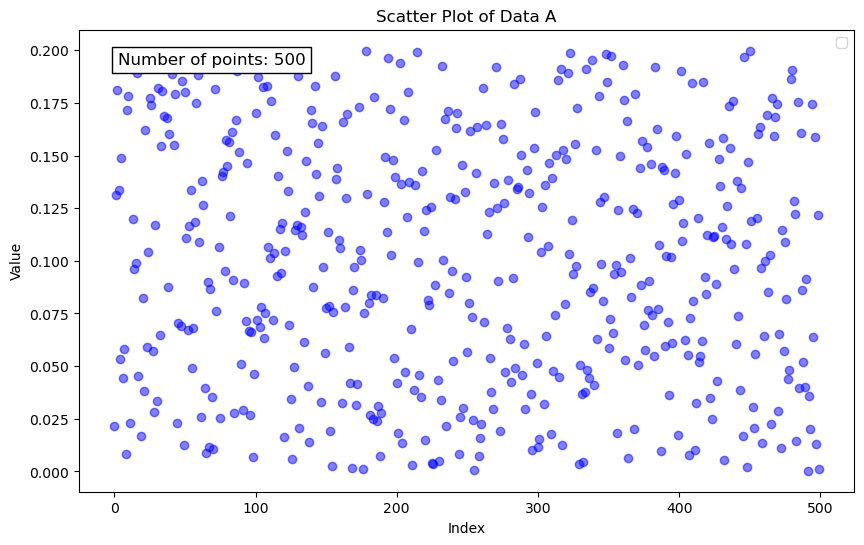

In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


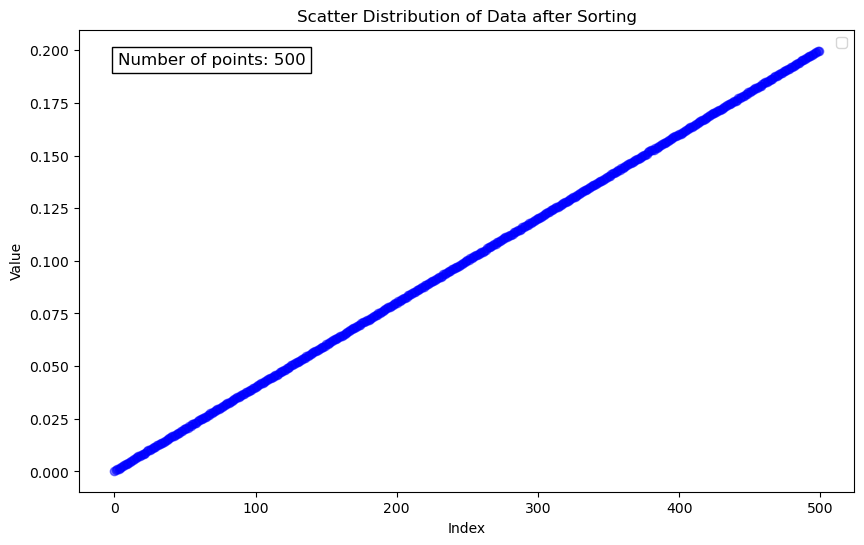

In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.005638439005231616, 0.003337219309988918, 0.00344006556531474, 0.0028524540984400373, 0.003249554767119341, 0.0027236931496567762, 0.003519572998204739, 0.0033632784869196616, 0.0028353367065845525, 0.0030290422865380646]
Error u of fuhe active learning(LHS sampling): 3.398866e-03
[0.0012367645431275536, 0.00042057844208333, 0.00029367011822168656, 0.00024413077102620272, 0.00027772899285180596, 0.0003533583063276017, 0.0003074371935886479, 0.0003713865869908958, 0.0003141702076107364, 0.00025913367983406354]
MAE of fuhe active learning(LHS sampling): 4.078359e-04
[3.883031385607423e-06, 1.3612209265403476e-06, 1.4465425152013067e-06, 9.948684400458176e-07, 1.2908936382641843e-06, 9.151640438007179e-07, 1.5144578410306147e-06, 1.3824681264794023e-06, 9.84855211862278e-07, 1.1214006477977603e-06]
MSE of fuhe active learning(LHS sampling): 1.489490e-06
[66.37101, 2.1093938, 283.081, 4.130148, 2.0555885, 18.43076, 0.0002526569, 1395.9924, 0.00013201995, 711.3448]
Chaos of fuhe active l

/tmp/ipykernel_1456451/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.005638439005231616, 0.003337219309988918, 0.00344006556531474, 0.0028524540984400373, 0.003249554767119341, 0.0027236931496567762, 0.003519572998204739, 0.0033632784869196616, 0.0028353367065845525, 0.0030290422865380646]
mean Error u: 3.398866e-03
Variance Error u: 6.268075e-07


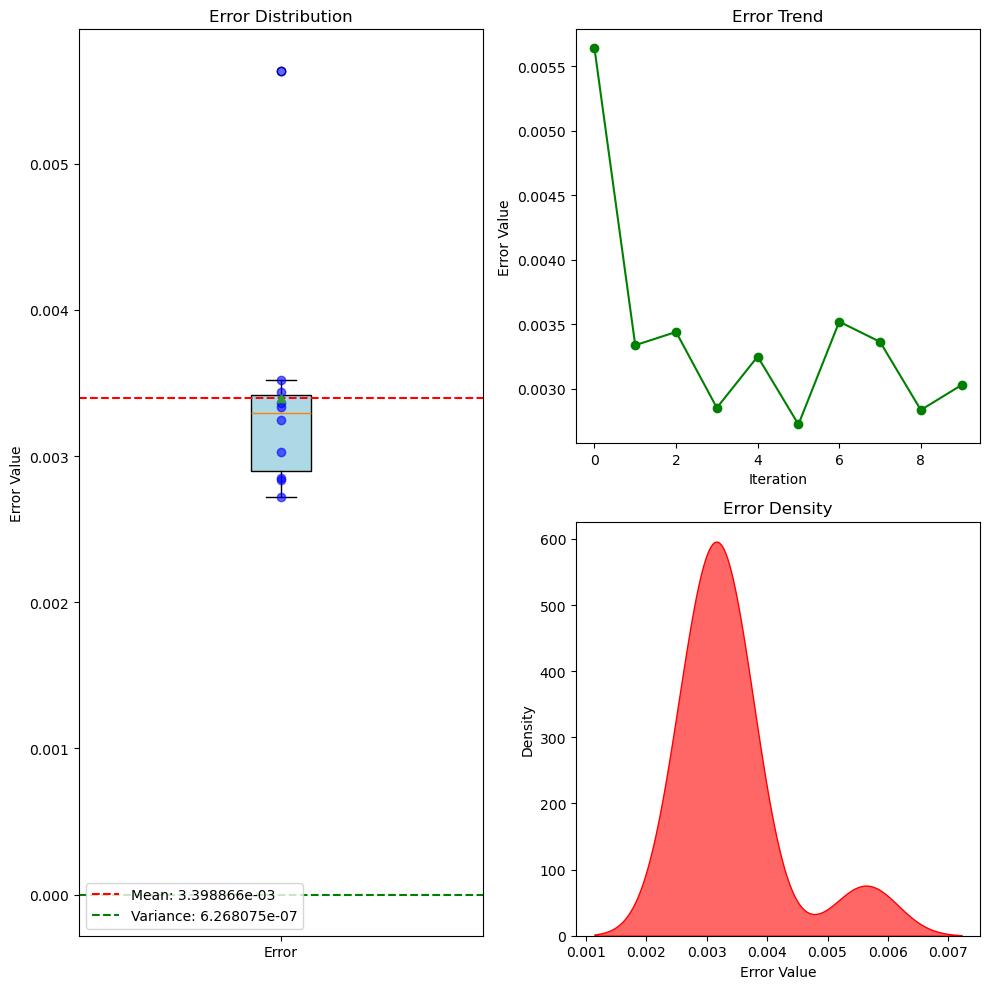

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0012367645431275536, 0.00042057844208333, 0.00029367011822168656, 0.00024413077102620272, 0.00027772899285180596, 0.0003533583063276017, 0.0003074371935886479, 0.0003713865869908958, 0.0003141702076107364, 0.00025913367983406354]
mean MAE: 4.078359e-04
Variance MAE: 7.893079e-08


/tmp/ipykernel_1456451/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


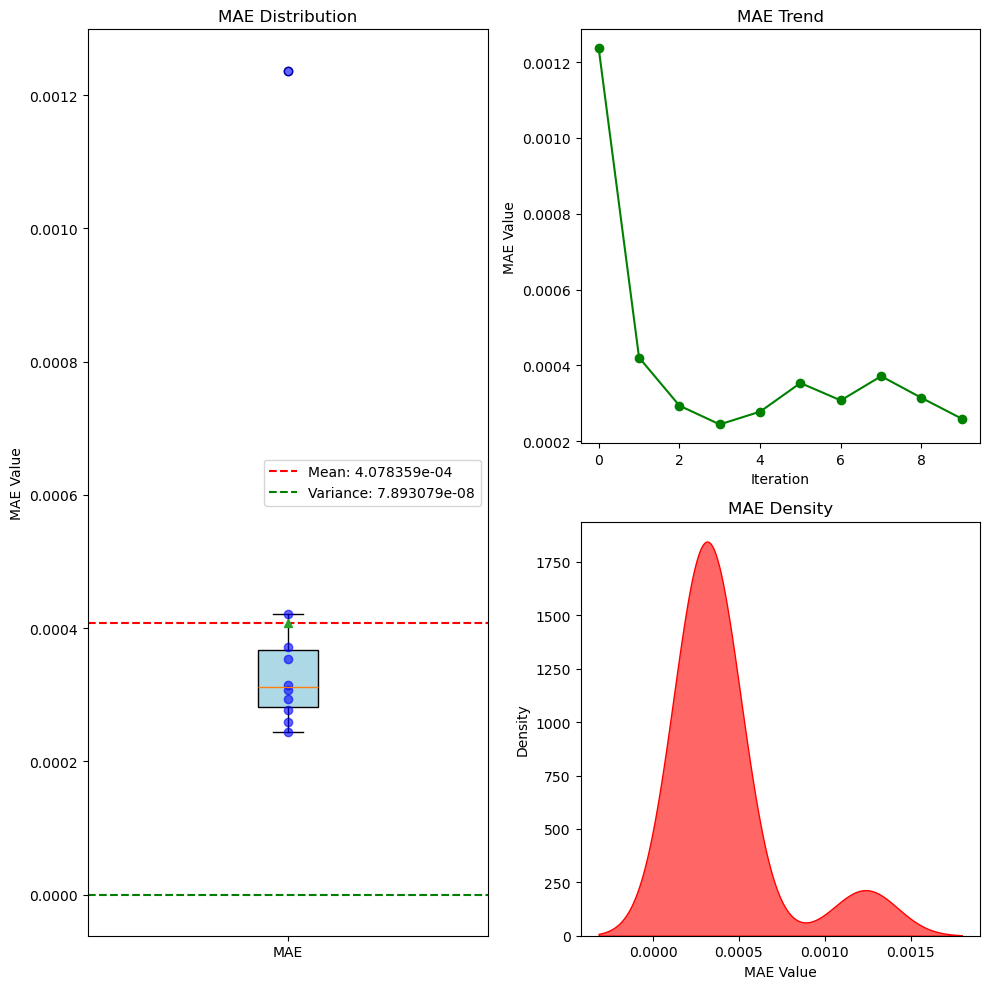

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[3.883031385607423e-06, 1.3612209265403476e-06, 1.4465425152013067e-06, 9.948684400458176e-07, 1.2908936382641843e-06, 9.151640438007179e-07, 1.5144578410306147e-06, 1.3824681264794023e-06, 9.84855211862278e-07, 1.1214006477977603e-06]
mean MSE: 1.489490e-06
Variance MSE: 6.763502e-13


/tmp/ipykernel_1456451/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


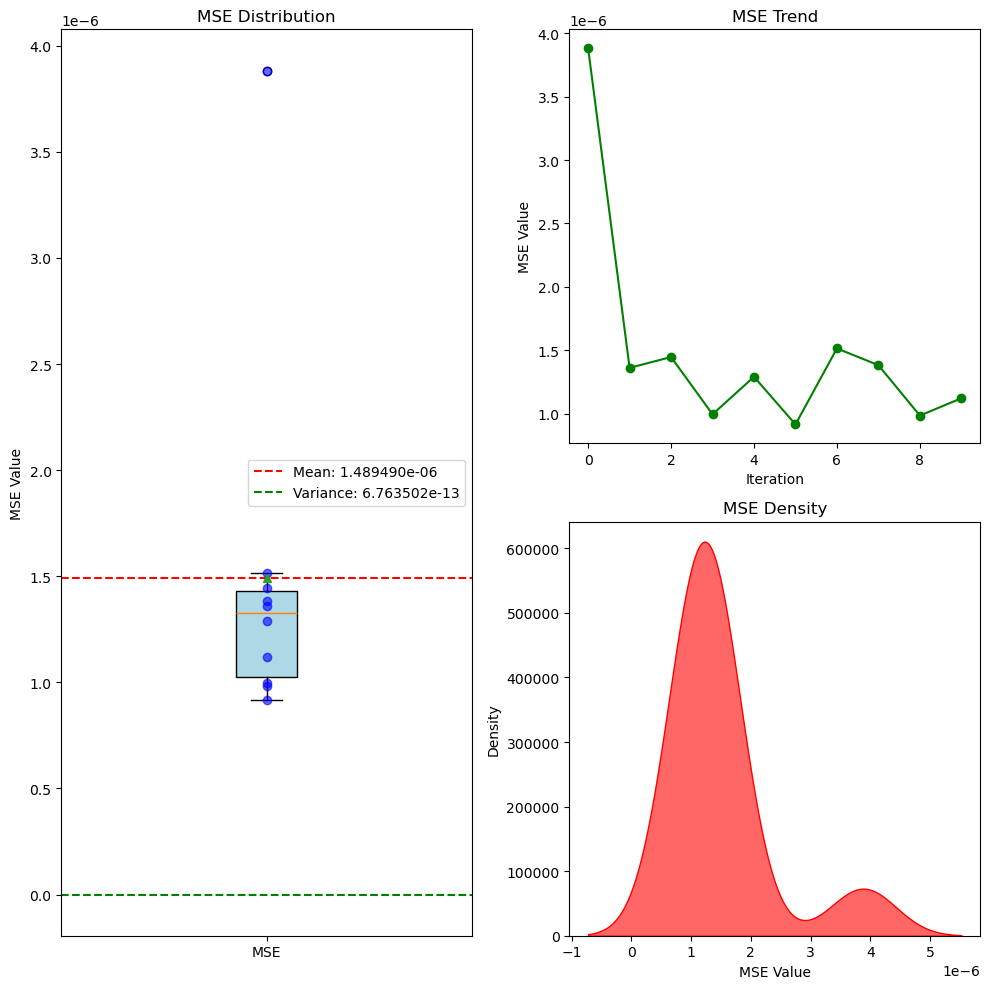

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[66.37101, 2.1093938, 283.081, 4.130148, 2.0555885, 18.43076, 0.0002526569, 1395.9924, 0.00013201995, 711.3448]
mean CHAOS: 2.483515e+02
Variance CHAOS: 1.922927e+05


/tmp/ipykernel_1456451/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


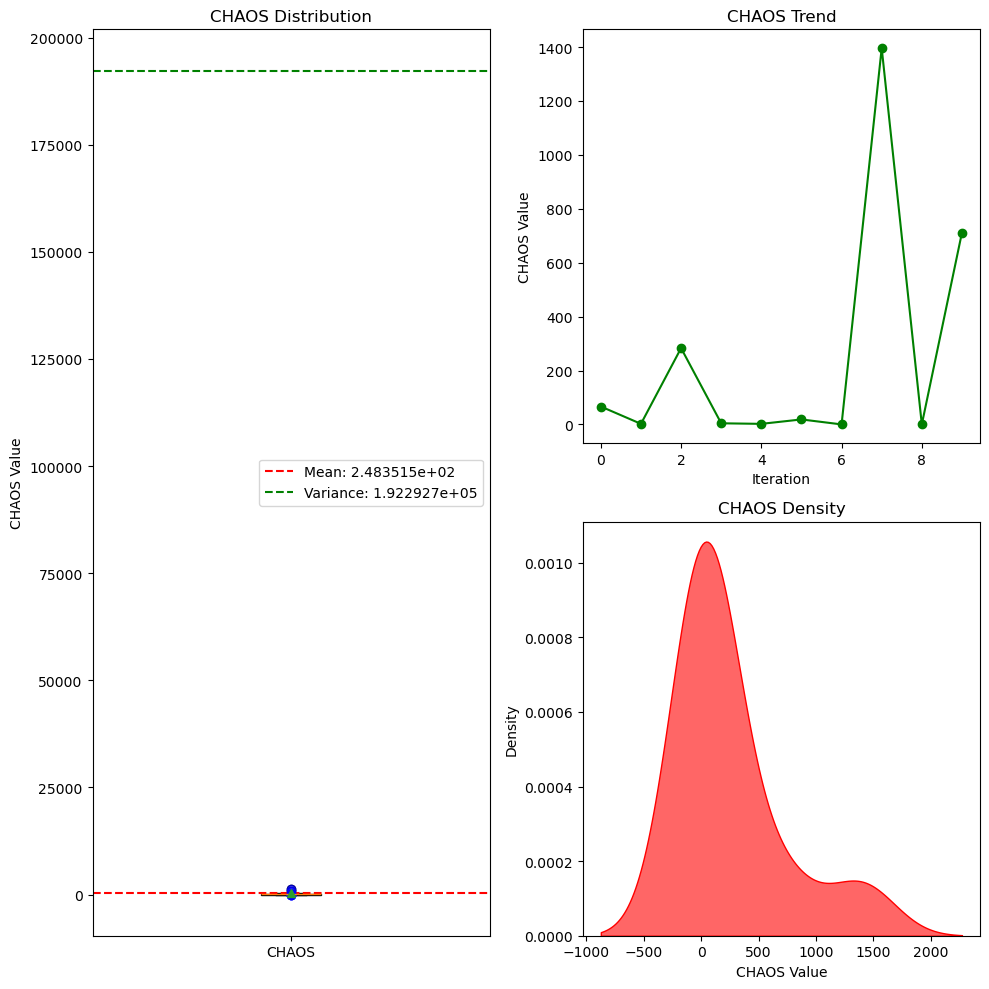

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0005543013, 0.00046430732, 0.0004791206, 0.00053710205, 0.0004314114, 0.0005336596, 0.0005067263, 0.00045261058, 0.00047512018, 0.0005081782]
mean RESIDUAL: 4.942538e-04
Variance RESIDUAL: 1.451917e-09


/tmp/ipykernel_1456451/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


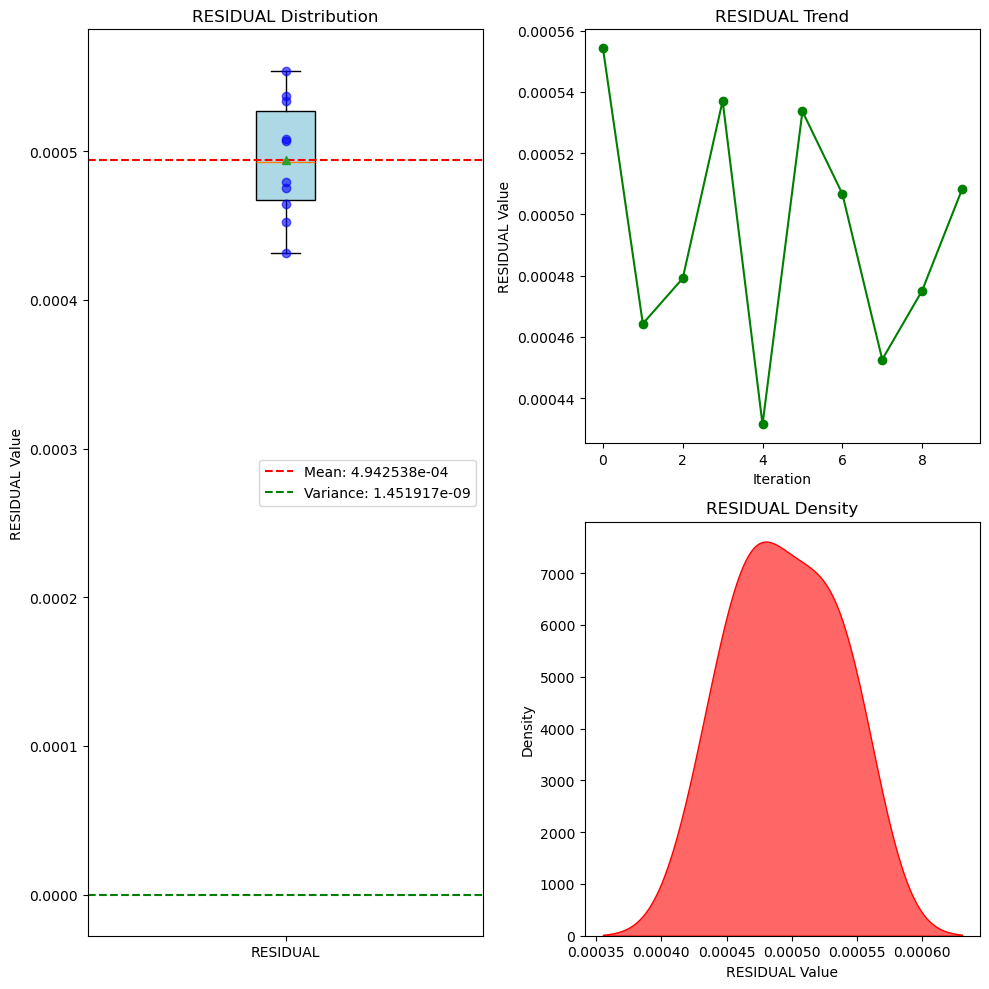

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.8029146e+03 1.7188875e+03 1.6492188e+03 ... 3.3002016e-03 3.2996768e-03
 3.2993129e-03]


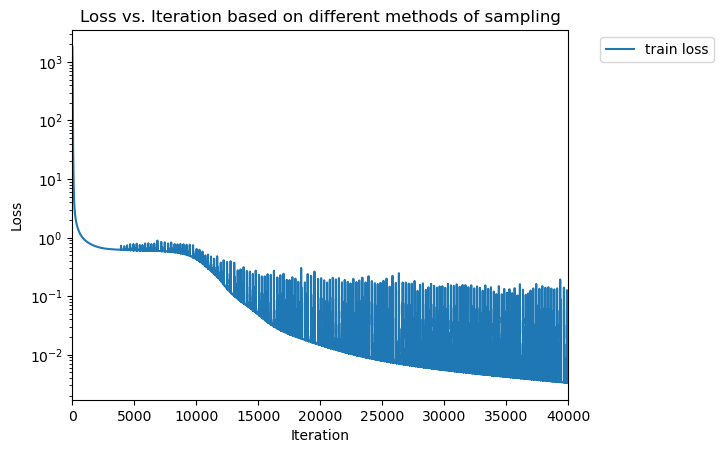

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.975889  0.006478  0.008517  0.008735  0.000097  0.000095  0.000133   
1  0.966404  0.008852  0.012046  0.012101  0.000149  0.000149  0.000212   
2  0.957498  0.011064  0.015366  0.015212  0.000215  0.000215  0.000306   
3  0.948992  0.013160  0.018536  0.018139  0.000294  0.000292  0.000415   
4  0.940814  0.015160  0.021585  0.020917  0.000384  0.000378  0.000538   

    state_8   state_9  state_10  state_11      state_12  
0  0.000048  0.000005  0.000001  0.000002  7.507133e-08  
1  0.000076  0.000007  0.000002  0.000003  9.775387e-08  
2  0.000110  0.000009  0.000002  0.000004  1.238386e-07  
3  0.000151  0.000012  0.000003  0.000005  1.541496e-07  
4  0.000197  0.000016  0.000004  0.000006  1.893244e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757833  0.053050  0.094723  0.068895  0.006641  0.004809  0.008610   
496  0.757833  0.053050  0.094722  0.068895  0.

Text(0, 0.5, 'Probability')

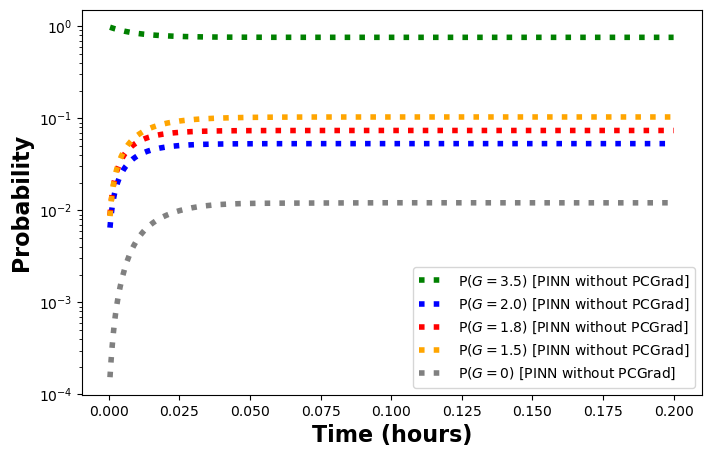

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

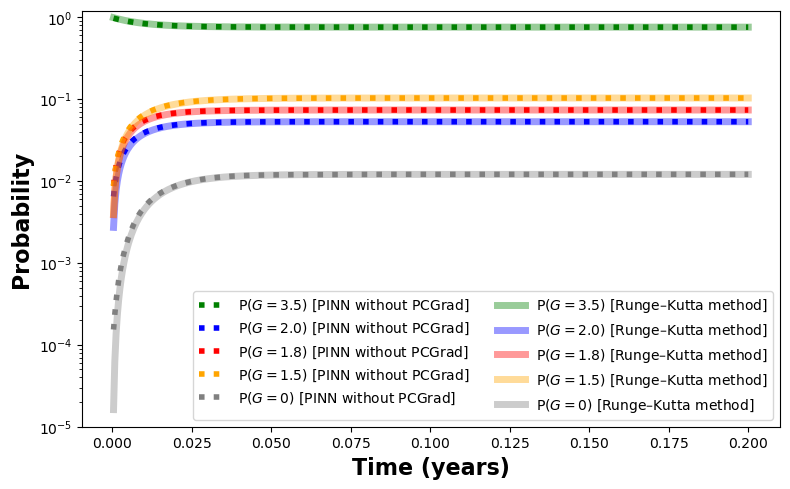

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 5.607003238988798e-06
RMSE of between PINN without PCGrad and the analytical solution is 5.60700323898807e-06


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0007428469062326314
RMSE of between PINN without PCGrad and the analytical solution is 0.0007428469062323185
